In [1]:
%matplotlib inline

# Case study: K2-24, putting it all together

In [2]:
%run notebook_setup

theano version: 1.0.4


pymc3 version: 3.7


exoplanet version: 0.2.1


In this tutorial, we will combine many of the previous tutorials to perform a fit of the K2-24 system using the K2 transit data and the RVs from [Petigura et al. (2016)](https://arxiv.org/abs/1511.04497).
This is the same system that we fit in the :ref:`rv` tutorial and we'll combine that model with the transit model from the :ref:`transit` tutorial and the Gaussian Process noise model from the :ref:`stellar-variability` tutorial.

## Datasets and initializations

To get started, let's download the relevant datasets.
First, the transit light curve from [Everest](https://rodluger.github.io/everest/):

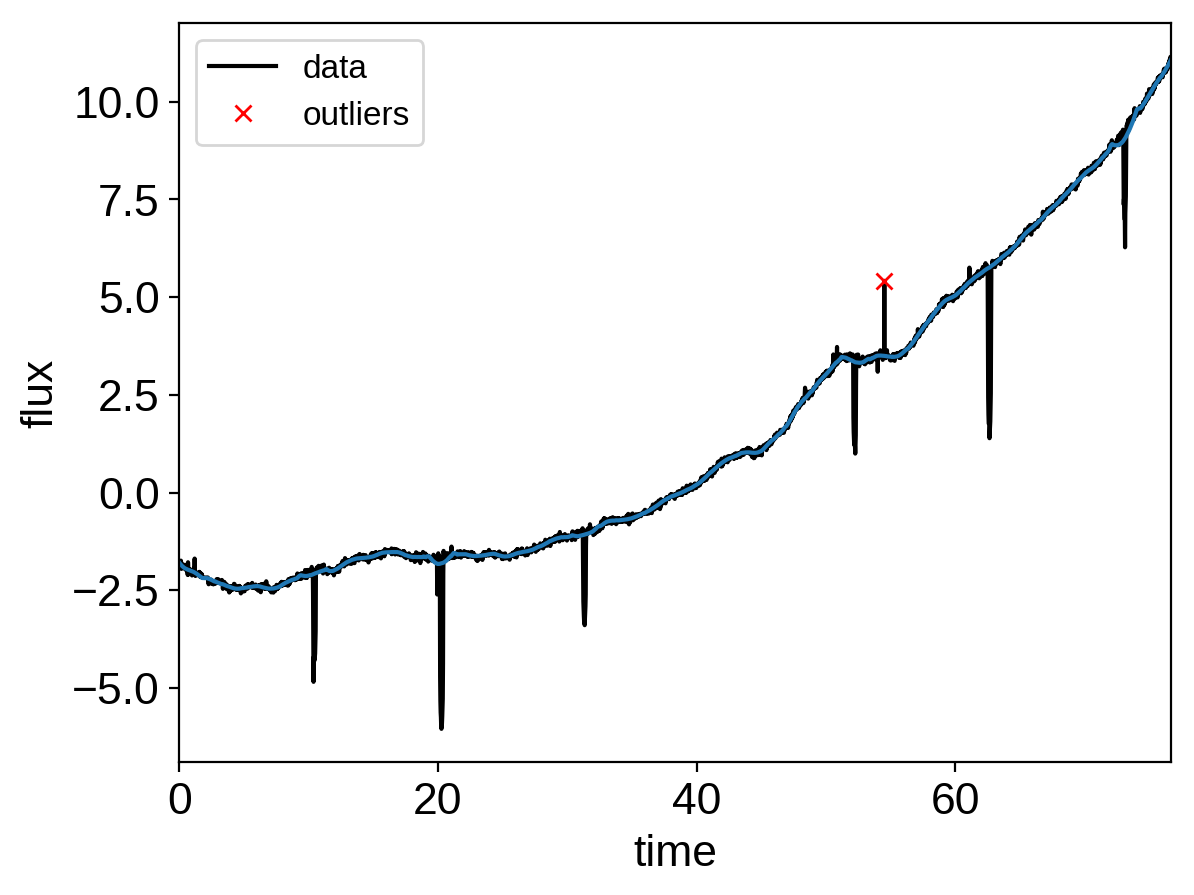

In [3]:
import numpy as np
import matplotlib.pyplot as plt

from astropy.io import fits
from scipy.signal import savgol_filter

# Download the data
lc_url = "https://archive.stsci.edu/hlsps/everest/v2/c02/203700000/71098/hlsp_everest_k2_llc_203771098-c02_kepler_v2.0_lc.fits"
with fits.open(lc_url) as hdus:
    lc = hdus[1].data
    lc_hdr = hdus[1].header

# Work out the exposure time
texp = lc_hdr["FRAMETIM"] * lc_hdr["NUM_FRM"]
texp /= 60.0 * 60.0 * 24.0

# Mask bad data
m = (np.arange(len(lc)) > 100) & np.isfinite(lc["FLUX"]) & np.isfinite(lc["TIME"])
bad_bits=[1, 2, 3, 4, 5, 6, 7, 8, 9, 11, 12, 13, 14, 16, 17]
qual = lc["QUALITY"]
for b in bad_bits:
    m &= qual & 2 ** (b - 1) == 0

# Convert to parts per thousand
x = lc["TIME"][m]
y = lc["FLUX"][m]
mu = np.median(y)
y = (y / mu - 1) * 1e3

# Identify outliers
m = np.ones(len(y), dtype=bool)
for i in range(10):
    y_prime = np.interp(x, x[m], y[m])
    smooth = savgol_filter(y_prime, 101, polyorder=3)
    resid = y - smooth
    sigma = np.sqrt(np.mean(resid**2))
    m0 = np.abs(resid) < 3*sigma
    if m.sum() == m0.sum():
        m = m0
        break
    m = m0
    
# Only discard positive outliers
m = resid < 3*sigma

# Shift the data so that the K2 data start at t=0. This tends to make the fit
# better behaved since t0 covaries with period.
x_ref = np.min(x[m])
x -= x_ref

# Plot the data
plt.plot(x, y, "k", label="data")
plt.plot(x, smooth)
plt.plot(x[~m], y[~m], "xr", label="outliers")
plt.legend(fontsize=12)
plt.xlim(x.min(), x.max())
plt.xlabel("time")
plt.ylabel("flux")

# Make sure that the data type is consistent
x = np.ascontiguousarray(x[m], dtype=np.float64)
y = np.ascontiguousarray(y[m], dtype=np.float64)
smooth = np.ascontiguousarray(smooth[m], dtype=np.float64)

Then the RVs from [RadVel](https://radvel.readthedocs.io):

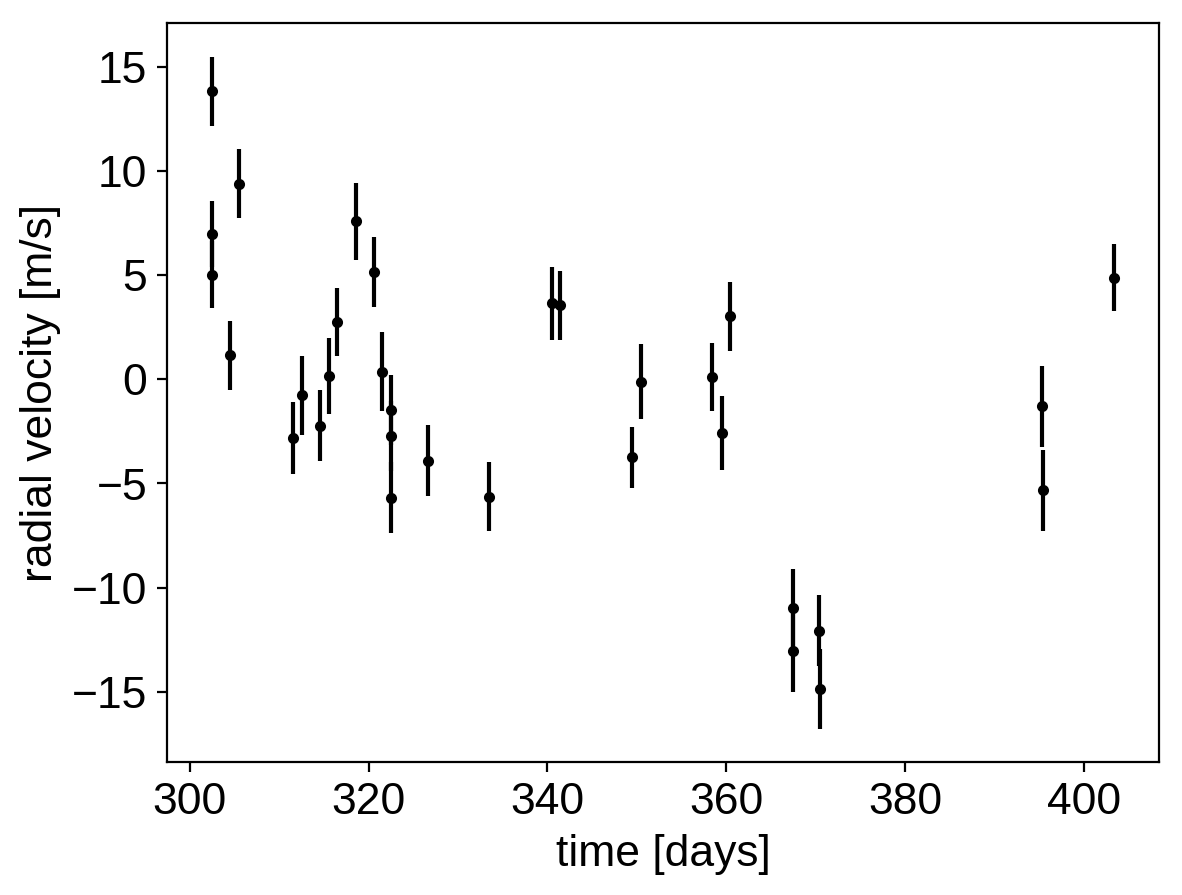

In [4]:
import pandas as pd

url = "https://raw.githubusercontent.com/California-Planet-Search/radvel/master/example_data/epic203771098.csv"
data = pd.read_csv(url, index_col=0)

# Don't forget to remove the time offset from above!
x_rv = np.array(data.t) - x_ref
y_rv = np.array(data.vel)
yerr_rv = np.array(data.errvel)

plt.errorbar(x_rv, y_rv, yerr=yerr_rv, fmt=".k")
plt.xlabel("time [days]")
plt.ylabel("radial velocity [m/s]");

We can initialize the transit parameters using [the box least squares periodogram from AstroPy](http://docs.astropy.org/en/latest/timeseries/bls.html).
(Note: you'll need AstroPy v3.1 or more recent to use this feature.)
A full discussion of transit detection and vetting is beyond the scope of this tutorial so let's assume that we know that there are two periodic transiting planets in this dataset.

In [5]:
from astropy.timeseries import BoxLeastSquares

m = np.zeros(len(x), dtype=bool)
period_grid = np.exp(np.linspace(np.log(5), np.log(50), 50000))
bls_results = []
periods = []
t0s = []
depths = []

# Compute the periodogram for each planet by iteratively masking out
# transits from the higher signal to noise planets. Here we're assuming
# that we know that there are exactly two planets.
for i in range(2):
    bls = BoxLeastSquares(x[~m], y[~m] - smooth[~m])
    bls_power = bls.power(period_grid, 0.1, oversample=20)
    bls_results.append(bls_power)
    
    # Save the highest peak as the planet candidate
    index = np.argmax(bls_power.power)
    periods.append(bls_power.period[index])
    t0s.append(bls_power.transit_time[index])
    depths.append(bls_power.depth[index])
    
    # Mask the data points that are in transit for this candidate
    m |= bls.transit_mask(x, periods[-1], 0.5, t0s[-1])

Let's plot the initial transit estimates based on these periodograms:

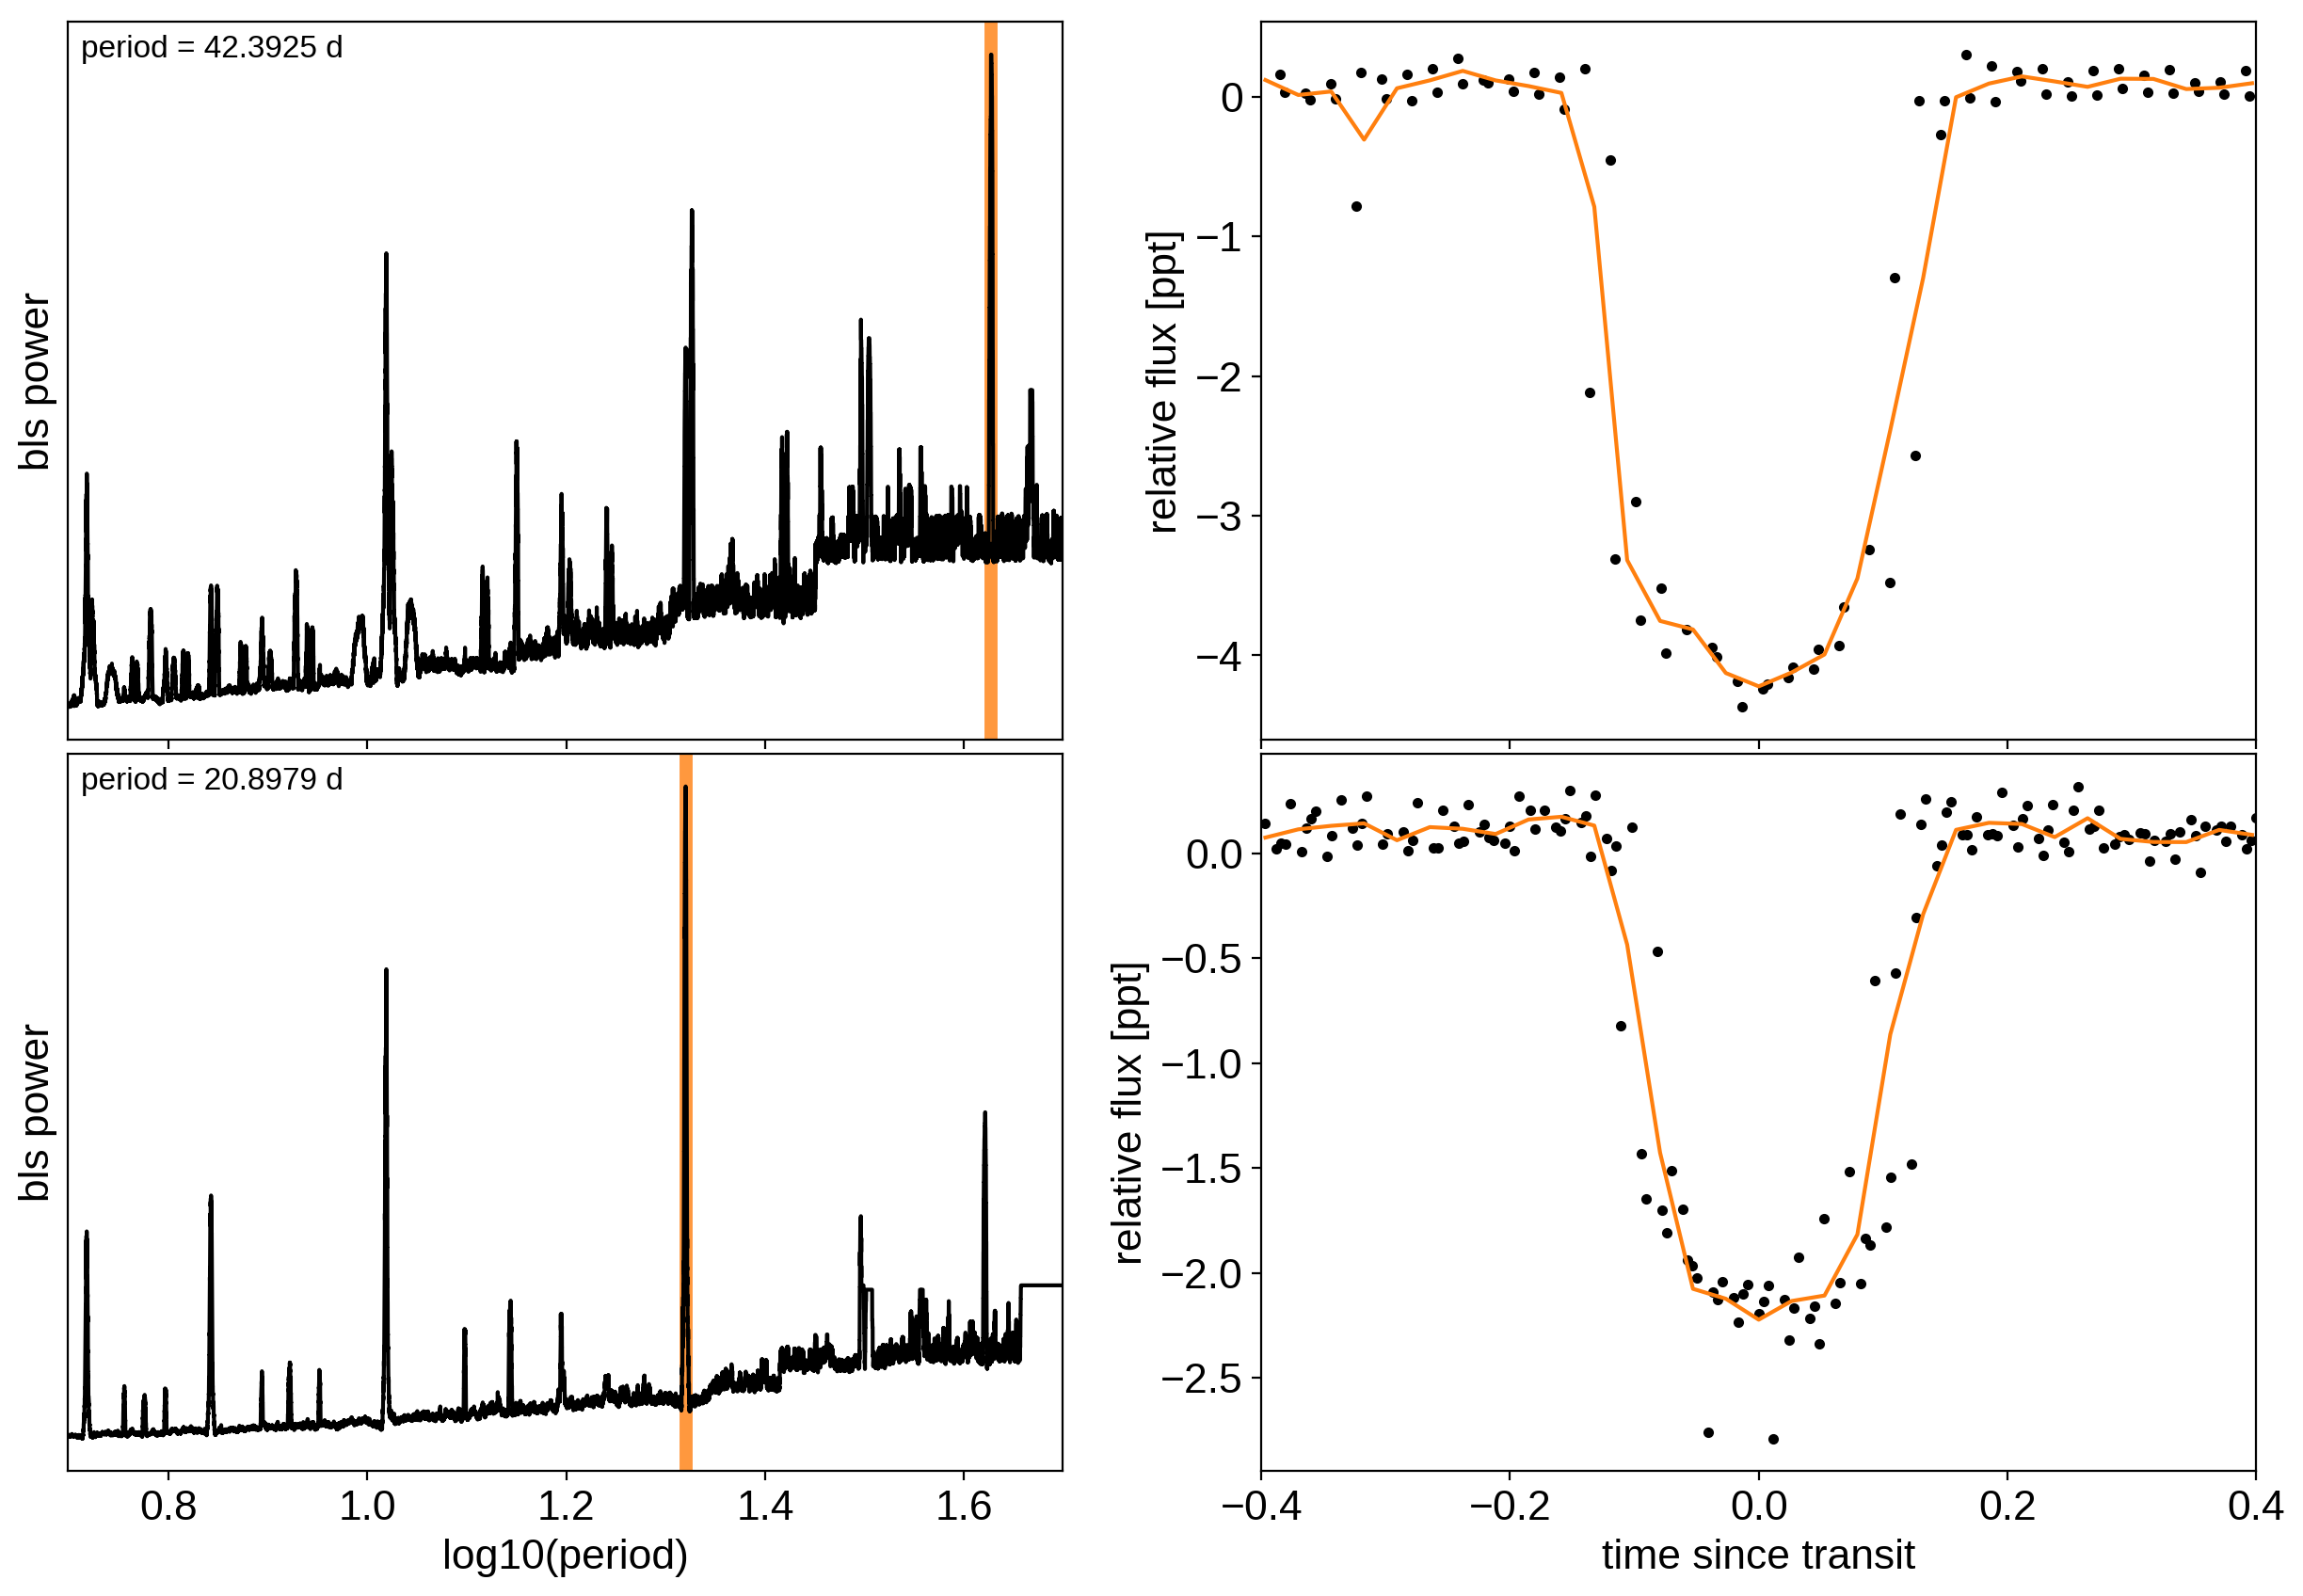

In [6]:
fig, axes = plt.subplots(len(bls_results), 2, figsize=(15, 10))

for i in range(len(bls_results)):
    # Plot the periodogram
    ax = axes[i, 0]
    ax.axvline(np.log10(periods[i]), color="C1", lw=5, alpha=0.8)
    ax.plot(np.log10(bls_results[i].period), bls_results[i].power, "k")
    ax.annotate("period = {0:.4f} d".format(periods[i]),
                (0, 1), xycoords="axes fraction",
                xytext=(5, -5), textcoords="offset points",
                va="top", ha="left", fontsize=12)
    ax.set_ylabel("bls power")
    ax.set_yticks([])
    ax.set_xlim(np.log10(period_grid.min()), np.log10(period_grid.max()))
    if i < len(bls_results) - 1:
        ax.set_xticklabels([])
    else:
        ax.set_xlabel("log10(period)")
    
    # Plot the folded transit
    ax = axes[i, 1]
    p = periods[i]
    x_fold = (x - t0s[i] + 0.5*p) % p - 0.5*p
    m = np.abs(x_fold) < 0.4
    ax.plot(x_fold[m], y[m] - smooth[m], ".k")
    
    # Overplot the phase binned light curve
    bins = np.linspace(-0.41, 0.41, 32)
    denom, _ = np.histogram(x_fold, bins)
    num, _ = np.histogram(x_fold, bins, weights=y - smooth)
    denom[num == 0] = 1.0
    ax.plot(0.5*(bins[1:] + bins[:-1]), num / denom, color="C1")

    ax.set_xlim(-0.4, 0.4)
    ax.set_ylabel("relative flux [ppt]")
    if i < len(bls_results) - 1:
        ax.set_xticklabels([])
    else:
        ax.set_xlabel("time since transit")
        
fig.subplots_adjust(hspace=0.02)

The discovery paper for K2-24 ([Petigura et al. (2016)](https://arxiv.org/abs/1511.04497)) includes the following estimates of the stellar mass and radius in Solar units:

In [7]:
M_star_petigura = 1.12, 0.05
R_star_petigura = 1.21, 0.11

Finally, using this stellar mass, we can also estimate the minimum masses of the planets given these transit parameters.

In [8]:
import exoplanet as xo
import astropy.units as u

msini = xo.estimate_minimum_mass(periods, x_rv, y_rv, yerr_rv, t0s=t0s, m_star=M_star_petigura[0])
msini = msini.to(u.M_earth)
print(msini)

[32.80060146 23.89885976] earthMass


## A joint transit and radial velocity model in PyMC3

Now, let's define our full model in *PyMC3*.
There's a lot going on here, but I've tried to comment it and most of it should be familiar from the previous tutorials (:ref:`rv`, :ref:`transit`, :ref:`gp`, and :ref:`stellar-variability`).
In this case, I've put the model inside a model "factory" function because we'll do some sigma clipping below.

In [9]:
import pymc3 as pm
import theano.tensor as tt

t_rv = np.linspace(x_rv.min()-5, x_rv.max()+5, 1000)

def build_model(mask=None, start=None):
    if mask is None:
        mask = np.ones(len(x), dtype=bool)
    with pm.Model() as model:

        # Parameters for the stellar properties
        mean = pm.Normal("mean", mu=0.0, sd=10.0)
        u_star = xo.distributions.QuadLimbDark("u_star")
        BoundedNormal = pm.Bound(pm.Normal, lower=0, upper=3)
        m_star = BoundedNormal("m_star", mu=M_star_petigura[0], sd=M_star_petigura[1])
        r_star = BoundedNormal("r_star", mu=R_star_petigura[0], sd=R_star_petigura[1])

        # Orbital parameters for the planets
        logm = pm.Normal("logm", mu=np.log(msini.value), sd=1, shape=2)
        logP = pm.Normal("logP", mu=np.log(periods), sd=1, shape=2)
        t0 = pm.Normal("t0", mu=np.array(t0s), sd=1, shape=2)
        logr = pm.Normal("logr", mu=0.5*np.log(1e-3*np.array(depths)) + np.log(R_star_petigura[0]),
                         sd=1.0, shape=2)
        r_pl = pm.Deterministic("r_pl", tt.exp(logr))
        ror = pm.Deterministic("ror", r_pl / r_star)
        b = xo.distributions.ImpactParameter("b", ror=ror, shape=2)

        ecc = xo.distributions.eccentricity.vaneylen19(
            "ecc", multi=True, shape=2, testval=np.array([0.01, 0.01]))
        omega = xo.distributions.Angle("omega", shape=2)

        # RV jitter & a quadratic RV trend
        logs_rv = pm.Normal("logs_rv", mu=np.log(np.median(yerr_rv)), sd=5)
        trend = pm.Normal("trend", mu=0, sd=10.0**-np.arange(3)[::-1], shape=3)

        # Transit jitter & GP parameters
        logs2 = pm.Normal("logs2", mu=np.log(np.var(y[mask])), sd=10)
        logw0 = pm.Normal("logw0", mu=0.0, sd=10)
        logSw4 = pm.Normal("logSw4", mu=np.log(np.var(y[mask])), sd=10)

        # Tracking planet parameters
        period = pm.Deterministic("period", tt.exp(logP))
        m_pl = pm.Deterministic("m_pl", tt.exp(logm))

        # Orbit model
        orbit = xo.orbits.KeplerianOrbit(
            r_star=r_star, m_star=m_star,
            period=period, t0=t0, b=b,
            m_planet=xo.units.with_unit(m_pl, msini.unit),
            ecc=ecc, omega=omega)

        # Compute the model light curve using starry
        light_curves = xo.LimbDarkLightCurve(u_star).get_light_curve(
            orbit=orbit, r=r_pl, t=x[mask], texp=texp)*1e3
        light_curve = pm.math.sum(light_curves, axis=-1) + mean
        pm.Deterministic("light_curves", light_curves)

        # GP model for the light curve
        kernel = xo.gp.terms.SHOTerm(log_Sw4=logSw4, log_w0=logw0, Q=1/np.sqrt(2))
        gp = xo.gp.GP(kernel, x[mask], tt.exp(logs2) + tt.zeros(mask.sum()))
        pm.Potential("transit_obs", gp.log_likelihood(y[mask] - light_curve))
        pm.Deterministic("gp_pred", gp.predict())

        # Set up the RV model and save it as a deterministic
        # for plotting purposes later
        vrad = orbit.get_radial_velocity(x_rv)
        pm.Deterministic("vrad", vrad)

        # Define the background RV model
        A = np.vander(x_rv - 0.5*(x_rv.min() + x_rv.max()), 3)
        bkg = pm.Deterministic("bkg", tt.dot(A, trend))

        # The likelihood for the RVs
        rv_model = pm.Deterministic("rv_model", tt.sum(vrad, axis=-1) + bkg)
        err = tt.sqrt(yerr_rv**2 + tt.exp(2*logs_rv))
        pm.Normal("obs", mu=rv_model, sd=err, observed=y_rv)
        
        vrad_pred = orbit.get_radial_velocity(t_rv)
        pm.Deterministic("vrad_pred", vrad_pred)
        A_pred = np.vander(t_rv - 0.5*(x_rv.min() + x_rv.max()), 3)
        bkg_pred = pm.Deterministic("bkg_pred", tt.dot(A_pred, trend))
        pm.Deterministic("rv_model_pred", tt.sum(vrad_pred, axis=-1) + bkg_pred)

        # Fit for the maximum a posteriori parameters, I've found that I can get
        # a better solution by trying different combinations of parameters in turn
        if start is None:
            start = model.test_point
        map_soln = xo.optimize(start=start, vars=[trend])
        map_soln = xo.optimize(start=map_soln, vars=[logs2])
        map_soln = xo.optimize(start=map_soln, vars=[logr, b])
        map_soln = xo.optimize(start=map_soln, vars=[logP, t0])
        map_soln = xo.optimize(start=map_soln, vars=[logs2, logSw4])
        map_soln = xo.optimize(start=map_soln, vars=[logw0])
        map_soln = xo.optimize(start=map_soln)

    return model, map_soln

model0, map_soln0 = build_model()

optimizing logp for variables: [trend]
0it [00:00, ?it/s]

0it [00:00, ?it/s, logp=-8.290067e+03]

1it [00:00, 132.63it/s, logp=-8.290067e+03]

2it [00:00, 187.47it/s, logp=-8.290067e+03]

3it [00:00, 216.86it/s, logp=-5.392070e+06]

4it [00:00, 238.05it/s, logp=-8.289847e+03]

5it [00:00, 248.76it/s, logp=-8.289419e+03]

6it [00:00, 260.66it/s, logp=-8.288014e+03]

7it [00:00, 260.12it/s, logp=-8.284634e+03]

8it [00:00, 259.97it/s, logp=-8.279284e+03]

9it [00:00, 259.35it/s, logp=-8.276752e+03]

10it [00:00, 259.60it/s, logp=-8.276752e+03]

11it [00:00, 261.88it/s, logp=-8.276752e+03]

12it [00:10,  1.16it/s, logp=-8.276752e+03] 


message: Optimization terminated successfully.
logp: -8290.066560739391 -> -8276.751877588842


optimizing logp for variables: [logs2]
0it [00:00, ?it/s]

0it [00:00, ?it/s, logp=-8.276752e+03]

1it [00:00, 112.09it/s, logp=-8.276752e+03]

2it [00:00, 145.90it/s, logp=-8.276752e+03]

3it [00:00, 158.99it/s, logp=-6.553614e+03]

4it [00:00, 170.59it/s, logp=-5.887021e+01]

5it [00:00, 183.43it/s, logp=-3.543119e+05]

6it [00:00, 198.44it/s, logp=1.118139e+02] 

7it [00:00, 210.47it/s, logp=1.763270e+03]

8it [00:00, 218.87it/s, logp=1.845136e+03]

9it [00:00, 226.15it/s, logp=1.987971e+03]

10it [00:00, 221.86it/s, logp=2.100900e+03]

11it [00:00, 226.37it/s, logp=2.109703e+03]

12it [00:00, 231.34it/s, logp=2.110024e+03]

13it [00:00, 234.40it/s, logp=2.110025e+03]

14it [00:00, 238.11it/s, logp=2.110025e+03]

15it [00:01,  8.76it/s, logp=2.110025e+03] 


message: Optimization terminated successfully.
logp: -8276.751877588842 -> 2110.024561282035


optimizing logp for variables: [b, logr, r_star]
0it [00:00, ?it/s]

0it [00:00, ?it/s, logp=2.110025e+03]

1it [00:00, 123.97it/s, logp=2.110025e+03]

2it [00:00, 178.18it/s, logp=2.110025e+03]

3it [00:00, 205.33it/s, logp=-3.326931e+04]

4it [00:00, 226.03it/s, logp=2.597750e+03] 

5it [00:00, 241.09it/s, logp=9.498090e+01]

6it [00:00, 252.86it/s, logp=2.606232e+03]

7it [00:00, 216.59it/s, logp=2.617498e+03]

8it [00:00, 211.81it/s, logp=2.624864e+03]

9it [00:00, 218.89it/s, logp=2.626822e+03]

10it [00:00, 225.37it/s, logp=2.630170e+03]

11it [00:00, 230.97it/s, logp=2.634492e+03]

12it [00:00, 235.24it/s, logp=2.636907e+03]

13it [00:00, 235.73it/s, logp=2.638483e+03]

14it [00:00, 239.56it/s, logp=2.637089e+03]

15it [00:00, 244.20it/s, logp=2.639518e+03]

16it [00:00, 247.74it/s, logp=2.640645e+03]

17it [00:00, 250.64it/s, logp=2.642629e+03]

18it [00:00, 253.39it/s, logp=2.645965e+03]

19it [00:00, 256.46it/s, logp=2.652071e+03]

20it [00:00, 259.21it/s, logp=2.648763e+03]

21it [00:00, 261.75it/s, logp=2.656808e+03]

22it [00:00, 263.98it/s, logp=2.663014e+03]

23it [00:00, 266.36it/s, logp=2.671619e+03]

24it [00:00, 268.51it/s, logp=2.678940e+03]

25it [00:00, 270.19it/s, logp=2.683125e+03]

26it [00:00, 271.81it/s, logp=2.686471e+03]

27it [00:00, 273.19it/s, logp=2.687700e+03]

28it [00:00, 274.62it/s, logp=2.688696e+03]

29it [00:00, 282.17it/s, logp=2.688696e+03]

29it [00:00, 282.17it/s, logp=2.688988e+03]

30it [00:00, 282.17it/s, logp=2.689034e+03]

31it [00:00, 282.17it/s, logp=2.689040e+03]

32it [00:00, 282.17it/s, logp=2.689040e+03]

33it [00:00, 282.17it/s, logp=2.689040e+03]

34it [00:00, 282.17it/s, logp=2.689040e+03]

35it [00:00, 282.17it/s, logp=2.689040e+03]

36it [00:00, 282.17it/s, logp=2.689040e+03]

37it [00:01, 22.99it/s, logp=2.689040e+03] 


message: Optimization terminated successfully.
logp: 2110.024561282035 -> 2689.0397283218604


optimizing logp for variables: [t0, logP]
0it [00:00, ?it/s]

0it [00:00, ?it/s, logp=2.689040e+03]

1it [00:00, 104.83it/s, logp=2.689040e+03]

2it [00:00, 154.26it/s, logp=2.689040e+03]

3it [00:00, 178.78it/s, logp=-5.044436e+03]

4it [00:00, 198.32it/s, logp=-1.040665e+03]

5it [00:00, 212.31it/s, logp=-7.647335e+02]

6it [00:00, 225.15it/s, logp=-8.705678e+02]

7it [00:00, 232.03it/s, logp=-5.332922e+02]

8it [00:00, 235.95it/s, logp=9.581148e+02] 

9it [00:00, 239.84it/s, logp=2.884187e+03]

10it [00:00, 244.11it/s, logp=-6.006890e+01]

11it [00:00, 249.46it/s, logp=2.882330e+03] 

12it [00:00, 247.83it/s, logp=2.886442e+03]

13it [00:00, 239.15it/s, logp=2.890979e+03]

14it [00:00, 231.42it/s, logp=2.908790e+03]

15it [00:00, 222.45it/s, logp=2.974219e+03]

16it [00:00, 217.79it/s, logp=3.120589e+03]

17it [00:00, 214.16it/s, logp=3.218437e+03]

18it [00:00, 213.47it/s, logp=3.240106e+03]

19it [00:00, 213.18it/s, logp=3.244828e+03]

20it [00:00, 213.91it/s, logp=3.244871e+03]

21it [00:00, 215.01it/s, logp=3.244872e+03]

22it [00:00, 215.95it/s, logp=3.244872e+03]

23it [00:00, 223.85it/s, logp=3.244872e+03]

23it [00:00, 223.85it/s, logp=3.244872e+03]

24it [00:00, 223.85it/s, logp=3.244872e+03]

25it [00:00, 223.85it/s, logp=3.244872e+03]

26it [00:00, 223.85it/s, logp=3.244872e+03]

27it [00:00, 223.85it/s, logp=3.244872e+03]

28it [00:00, 223.85it/s, logp=3.244872e+03]

29it [00:00, 223.85it/s, logp=3.244872e+03]

30it [00:00, 223.85it/s, logp=3.244872e+03]

31it [00:00, 223.85it/s, logp=3.244872e+03]

32it [00:00, 223.85it/s, logp=3.244872e+03]

33it [00:00, 223.85it/s, logp=3.244872e+03]

34it [00:00, 223.85it/s, logp=3.244872e+03]

35it [00:00, 223.85it/s, logp=3.244872e+03]

36it [00:00, 223.85it/s, logp=3.244872e+03]

37it [00:00, 223.85it/s, logp=3.244872e+03]

38it [00:00, 223.85it/s, logp=3.244872e+03]

39it [00:00, 223.85it/s, logp=3.244872e+03]

40it [00:00, 223.85it/s, logp=3.244872e+03]

41it [00:00, 223.85it/s, logp=3.244872e+03]

42it [00:00, 223.85it/s, logp=3.244872e+03]

43it [00:00, 223.85it/s, logp=3.244872e+03]

44it [00:00, 223.85it/s, logp=3.244872e+03]

45it [00:00, 223.85it/s, logp=3.244872e+03]

46it [00:00, 223.85it/s, logp=3.244872e+03]

47it [00:00, 227.77it/s, logp=3.244872e+03]

47it [00:00, 227.77it/s, logp=3.244872e+03]

48it [00:00, 227.77it/s, logp=3.244872e+03]

49it [00:00, 227.77it/s, logp=3.244872e+03]

50it [00:00, 227.77it/s, logp=3.244872e+03]

51it [00:00, 227.77it/s, logp=3.244872e+03]

52it [00:00, 227.77it/s, logp=3.244872e+03]

53it [00:00, 227.77it/s, logp=3.244872e+03]

54it [00:00, 227.77it/s, logp=3.244872e+03]

55it [00:00, 227.77it/s, logp=3.244872e+03]

56it [00:00, 227.77it/s, logp=3.244872e+03]

57it [00:00, 227.77it/s, logp=3.244872e+03]

58it [00:00, 227.77it/s, logp=3.244872e+03]

59it [00:00, 227.77it/s, logp=3.244872e+03]

60it [00:00, 227.77it/s, logp=3.244872e+03]

61it [00:00, 227.77it/s, logp=3.244872e+03]

62it [00:00, 227.77it/s, logp=3.244872e+03]

63it [00:00, 227.77it/s, logp=3.244872e+03]

64it [00:00, 227.77it/s, logp=3.244872e+03]

65it [00:00, 227.77it/s, logp=3.244872e+03]

66it [00:00, 227.77it/s, logp=3.244872e+03]

67it [00:00, 227.77it/s, logp=3.244872e+03]

68it [00:00, 227.77it/s, logp=3.244872e+03]

69it [00:00, 227.77it/s, logp=3.244872e+03]

70it [00:00, 227.77it/s, logp=3.244872e+03]

71it [00:00, 227.77it/s, logp=3.244872e+03]

72it [00:00, 227.77it/s, logp=3.244872e+03]

73it [00:00, 227.77it/s, logp=3.244872e+03]

74it [00:00, 227.77it/s, logp=3.244872e+03]

75it [00:00, 227.77it/s, logp=3.244872e+03]

76it [00:00, 227.77it/s, logp=3.244872e+03]

77it [00:00, 243.99it/s, logp=3.244872e+03]

77it [00:00, 243.99it/s, logp=3.244872e+03]

78it [00:00, 243.99it/s, logp=3.244872e+03]

79it [00:00, 243.99it/s, logp=3.244872e+03]

80it [00:00, 243.99it/s, logp=3.244872e+03]

81it [00:00, 243.99it/s, logp=3.244872e+03]

82it [00:00, 243.99it/s, logp=3.244872e+03]

83it [00:00, 243.99it/s, logp=3.244872e+03]

84it [00:00, 243.99it/s, logp=3.244872e+03]

85it [00:00, 243.99it/s, logp=3.244872e+03]

86it [00:00, 243.99it/s, logp=3.244872e+03]

87it [00:00, 243.99it/s, logp=3.244872e+03]

88it [00:00, 243.99it/s, logp=3.244872e+03]

89it [00:00, 243.99it/s, logp=3.244872e+03]

90it [00:00, 243.99it/s, logp=3.244872e+03]

91it [00:00, 243.99it/s, logp=3.244872e+03]

92it [00:00, 243.99it/s, logp=3.244872e+03]

93it [00:00, 243.99it/s, logp=3.244872e+03]

94it [00:00, 243.99it/s, logp=3.244872e+03]

95it [00:00, 243.99it/s, logp=3.244872e+03]

96it [00:00, 243.99it/s, logp=3.244872e+03]

97it [00:00, 243.99it/s, logp=3.244872e+03]

98it [00:00, 243.99it/s, logp=3.244872e+03]

99it [00:00, 243.99it/s, logp=3.244872e+03]

100it [00:00, 243.99it/s, logp=3.244872e+03]

101it [00:00, 243.99it/s, logp=3.244872e+03]

102it [00:00, 243.00it/s, logp=3.244872e+03]

102it [00:00, 243.00it/s, logp=3.244872e+03]

103it [00:00, 243.00it/s, logp=3.244872e+03]

104it [00:00, 243.00it/s, logp=3.244872e+03]

105it [00:00, 243.00it/s, logp=3.244872e+03]

106it [00:00, 243.00it/s, logp=3.244872e+03]

107it [00:00, 243.00it/s, logp=3.244872e+03]

108it [00:00, 243.00it/s, logp=3.244872e+03]

109it [00:00, 243.00it/s, logp=3.244872e+03]

110it [00:00, 243.00it/s, logp=3.244872e+03]

111it [00:00, 243.00it/s, logp=3.244872e+03]

112it [00:00, 243.00it/s, logp=3.244872e+03]

113it [00:00, 243.00it/s, logp=3.244872e+03]

114it [00:00, 243.00it/s, logp=3.244872e+03]

115it [00:00, 243.00it/s, logp=3.244872e+03]

116it [00:00, 243.00it/s, logp=3.244872e+03]

117it [00:00, 243.00it/s, logp=3.244872e+03]

118it [00:00, 243.00it/s, logp=3.244872e+03]

119it [00:00, 243.00it/s, logp=3.244872e+03]

120it [00:02, 53.88it/s, logp=3.244872e+03] 


message: Desired error not necessarily achieved due to precision loss.
logp: 2689.039728321853 -> 3244.871517188868


optimizing logp for variables: [logSw4, logs2]
0it [00:00, ?it/s]

0it [00:00, ?it/s, logp=3.244872e+03]

1it [00:00, 123.54it/s, logp=3.244872e+03]

2it [00:00, 174.84it/s, logp=3.244872e+03]

3it [00:00, 202.20it/s, logp=3.744214e+03]

4it [00:00, 219.35it/s, logp=-4.251570e+03]

5it [00:00, 232.04it/s, logp=3.896383e+03] 

6it [00:00, 239.59it/s, logp=3.898724e+03]

7it [00:00, 245.49it/s, logp=3.899739e+03]

8it [00:00, 249.53it/s, logp=3.899740e+03]

9it [00:00, 212.92it/s, logp=3.899740e+03]

10it [00:00, 201.25it/s, logp=3.899740e+03]

11it [00:00, 194.88it/s, logp=3.899740e+03]

12it [00:00, 191.21it/s, logp=3.899740e+03]

13it [00:00, 192.82it/s, logp=3.899740e+03]

14it [00:00, 194.53it/s, logp=3.899740e+03]

15it [00:00, 184.16it/s, logp=3.899740e+03]

16it [00:00, 178.53it/s, logp=3.899740e+03]

17it [00:00, 161.26it/s, logp=3.899740e+03]

18it [00:00, 168.11it/s, logp=3.899740e+03]

18it [00:00, 168.11it/s, logp=3.899740e+03]

19it [00:00, 168.11it/s, logp=3.899740e+03]

20it [00:01, 10.40it/s, logp=3.899740e+03] 


message: Optimization terminated successfully.
logp: 3244.8715171888616 -> 3899.7404630406486


optimizing logp for variables: [logw0]
0it [00:00, ?it/s]

0it [00:00, ?it/s, logp=3.899740e+03]

1it [00:00, 58.87it/s, logp=3.899740e+03]

2it [00:00, 82.23it/s, logp=3.899740e+03]

3it [00:00, 97.88it/s, logp=4.002758e+03]

4it [00:00, 109.45it/s, logp=4.002965e+03]

5it [00:00, 119.11it/s, logp=4.003665e+03]

6it [00:00, 125.74it/s, logp=4.003689e+03]

7it [00:00, 130.95it/s, logp=4.004107e+03]

8it [00:00, 133.16it/s, logp=4.004134e+03]

9it [00:00, 137.85it/s, logp=4.004137e+03]

10it [00:00, 141.06it/s, logp=4.004137e+03]

11it [00:00, 143.51it/s, logp=4.004137e+03]

12it [00:01,  7.10it/s, logp=4.004137e+03] 


message: Optimization terminated successfully.
logp: 3899.7404630406486 -> 4004.1373645708627


optimizing logp for variables: [logSw4, logw0, logs2, trend, logs_rv, omega, ecc_frac, ecc_sigma_rayleigh, ecc_sigma_gauss, ecc, b, logr, t0, logP, logm, r_star, m_star, u_star, mean]
0it [00:00, ?it/s]

0it [00:00, ?it/s, logp=4.004137e+03]

1it [00:00, 86.30it/s, logp=4.004137e+03]

2it [00:00, 125.47it/s, logp=4.004137e+03]

3it [00:00, 147.72it/s, logp=-5.635528e+03]

4it [00:00, 165.63it/s, logp=-7.658249e+03]

5it [00:00, 178.07it/s, logp=-8.025945e+03]

6it [00:00, 156.30it/s, logp=-7.142780e+03]

7it [00:00, 159.36it/s, logp=4.004112e+03] 

8it [00:00, 158.81it/s, logp=4.004236e+03]

9it [00:00, 158.12it/s, logp=4.000163e+03]

10it [00:00, 157.75it/s, logp=4.004238e+03]

11it [00:00, 160.26it/s, logp=4.004243e+03]

12it [00:00, 163.54it/s, logp=4.004263e+03]

13it [00:00, 167.30it/s, logp=4.004340e+03]

14it [00:00, 171.37it/s, logp=4.004646e+03]

15it [00:00, 174.99it/s, logp=4.005787e+03]

16it [00:00, 176.77it/s, logp=4.008663e+03]

17it [00:00, 178.51it/s, logp=4.014312e+03]

18it [00:00, 180.74it/s, logp=4.033618e+03]

19it [00:00, 189.02it/s, logp=4.033618e+03]

19it [00:00, 189.02it/s, logp=3.891968e+03]

20it [00:00, 189.02it/s, logp=4.036960e+03]

21it [00:00, 189.02it/s, logp=4.043151e+03]

22it [00:00, 189.02it/s, logp=4.054332e+03]

23it [00:00, 189.02it/s, logp=4.076148e+03]

24it [00:00, 189.02it/s, logp=4.136388e+03]

25it [00:00, 189.02it/s, logp=4.168071e+03]

26it [00:00, 189.02it/s, logp=4.192953e+03]

27it [00:00, 189.02it/s, logp=4.292386e+03]

28it [00:00, 189.02it/s, logp=3.953273e+03]

29it [00:00, 189.02it/s, logp=4.312842e+03]

30it [00:00, 189.02it/s, logp=4.341315e+03]

31it [00:00, 189.02it/s, logp=4.391293e+03]

32it [00:00, 189.02it/s, logp=4.289885e+03]

33it [00:00, 189.02it/s, logp=4.411809e+03]

34it [00:00, 189.02it/s, logp=4.443676e+03]

35it [00:00, 189.02it/s, logp=4.491211e+03]

36it [00:00, 189.02it/s, logp=4.569056e+03]

37it [00:00, 183.78it/s, logp=4.569056e+03]

37it [00:00, 183.78it/s, logp=3.285802e+03]

38it [00:00, 183.78it/s, logp=4.595179e+03]

39it [00:00, 183.78it/s, logp=4.631758e+03]

40it [00:00, 183.78it/s, logp=4.654921e+03]

41it [00:00, 183.78it/s, logp=4.661387e+03]

42it [00:00, 183.78it/s, logp=4.672659e+03]

43it [00:00, 183.78it/s, logp=4.689421e+03]

44it [00:00, 183.78it/s, logp=4.689278e+03]

45it [00:00, 183.78it/s, logp=4.698639e+03]

46it [00:00, 183.78it/s, logp=4.700361e+03]

47it [00:00, 183.78it/s, logp=4.704210e+03]

48it [00:00, 183.78it/s, logp=4.710890e+03]

49it [00:00, 183.78it/s, logp=4.692901e+03]

50it [00:00, 183.78it/s, logp=4.713142e+03]

51it [00:00, 183.78it/s, logp=4.716452e+03]

52it [00:00, 183.78it/s, logp=4.721562e+03]

53it [00:00, 183.78it/s, logp=4.725067e+03]

54it [00:00, 183.78it/s, logp=4.729956e+03]

55it [00:00, 183.78it/s, logp=4.735075e+03]

56it [00:00, 183.78it/s, logp=4.732927e+03]

57it [00:00, 183.78it/s, logp=4.737690e+03]

58it [00:00, 183.78it/s, logp=4.740120e+03]

59it [00:00, 191.44it/s, logp=4.740120e+03]

59it [00:00, 191.44it/s, logp=4.742726e+03]

60it [00:00, 191.44it/s, logp=4.745496e+03]

61it [00:00, 191.44it/s, logp=4.746963e+03]

62it [00:00, 191.44it/s, logp=4.749094e+03]

63it [00:00, 191.44it/s, logp=4.751899e+03]

64it [00:00, 191.44it/s, logp=4.753634e+03]

65it [00:00, 191.44it/s, logp=4.755904e+03]

66it [00:00, 191.44it/s, logp=4.758421e+03]

67it [00:00, 191.44it/s, logp=4.760629e+03]

68it [00:00, 191.44it/s, logp=4.760736e+03]

69it [00:00, 191.44it/s, logp=4.761754e+03]

70it [00:00, 191.44it/s, logp=4.762375e+03]

71it [00:00, 191.44it/s, logp=4.763223e+03]

72it [00:00, 191.44it/s, logp=4.763881e+03]

73it [00:00, 191.44it/s, logp=4.764229e+03]

74it [00:00, 191.44it/s, logp=4.764585e+03]

75it [00:00, 191.44it/s, logp=4.764962e+03]

76it [00:00, 191.44it/s, logp=4.765282e+03]

77it [00:00, 191.44it/s, logp=4.765633e+03]

78it [00:00, 191.44it/s, logp=4.765990e+03]

79it [00:00, 191.44it/s, logp=4.766322e+03]

80it [00:00, 191.44it/s, logp=4.766475e+03]

81it [00:00, 191.44it/s, logp=4.766597e+03]

82it [00:00, 201.46it/s, logp=4.766597e+03]

82it [00:00, 201.46it/s, logp=4.766789e+03]

83it [00:00, 201.46it/s, logp=4.766985e+03]

84it [00:00, 201.46it/s, logp=4.767140e+03]

85it [00:00, 201.46it/s, logp=4.767404e+03]

86it [00:00, 201.46it/s, logp=4.767860e+03]

87it [00:00, 201.46it/s, logp=4.768507e+03]

88it [00:00, 201.46it/s, logp=4.768183e+03]

89it [00:00, 201.46it/s, logp=4.768821e+03]

90it [00:00, 201.46it/s, logp=4.769293e+03]

91it [00:00, 201.46it/s, logp=4.769896e+03]

92it [00:00, 201.46it/s, logp=4.769743e+03]

93it [00:00, 201.46it/s, logp=4.770266e+03]

94it [00:00, 201.46it/s, logp=4.770655e+03]

95it [00:00, 201.46it/s, logp=4.771138e+03]

96it [00:00, 201.46it/s, logp=4.769624e+03]

97it [00:00, 201.46it/s, logp=4.771298e+03]

98it [00:00, 201.46it/s, logp=4.771387e+03]

99it [00:00, 201.46it/s, logp=4.771423e+03]

100it [00:00, 201.46it/s, logp=4.771463e+03]

101it [00:00, 201.46it/s, logp=4.771528e+03]

102it [00:00, 201.46it/s, logp=4.771645e+03]

103it [00:00, 201.46it/s, logp=4.771814e+03]

104it [00:00, 201.46it/s, logp=4.771863e+03]

105it [00:00, 208.39it/s, logp=4.771863e+03]

105it [00:00, 208.39it/s, logp=4.771923e+03]

106it [00:00, 208.39it/s, logp=4.772106e+03]

107it [00:00, 208.39it/s, logp=4.772263e+03]

108it [00:00, 208.39it/s, logp=4.772499e+03]

109it [00:00, 208.39it/s, logp=4.771682e+03]

110it [00:00, 208.39it/s, logp=4.772574e+03]

111it [00:00, 208.39it/s, logp=4.772701e+03]

112it [00:00, 208.39it/s, logp=4.772891e+03]

113it [00:00, 208.39it/s, logp=4.773174e+03]

114it [00:00, 208.39it/s, logp=4.773416e+03]

115it [00:00, 208.39it/s, logp=4.773585e+03]

116it [00:00, 208.39it/s, logp=4.773783e+03]

117it [00:00, 208.39it/s, logp=4.773984e+03]

118it [00:00, 208.39it/s, logp=4.774206e+03]

119it [00:00, 208.39it/s, logp=4.774341e+03]

120it [00:00, 208.39it/s, logp=4.774463e+03]

121it [00:00, 208.39it/s, logp=4.774526e+03]

122it [00:00, 208.39it/s, logp=4.774570e+03]

123it [00:00, 208.39it/s, logp=4.774642e+03]

124it [00:00, 208.39it/s, logp=4.774756e+03]

125it [00:00, 208.39it/s, logp=4.774828e+03]

126it [00:00, 208.39it/s, logp=4.774930e+03]

127it [00:00, 208.39it/s, logp=4.775014e+03]

128it [00:00, 208.39it/s, logp=4.775022e+03]

129it [00:00, 215.79it/s, logp=4.775022e+03]

129it [00:00, 215.79it/s, logp=4.775034e+03]

130it [00:00, 215.79it/s, logp=4.775050e+03]

131it [00:00, 215.79it/s, logp=4.775060e+03]

132it [00:00, 215.79it/s, logp=4.775074e+03]

133it [00:00, 215.79it/s, logp=4.775098e+03]

134it [00:00, 215.79it/s, logp=4.775141e+03]

135it [00:00, 215.79it/s, logp=4.775201e+03]

136it [00:00, 215.79it/s, logp=4.775230e+03]

137it [00:00, 215.79it/s, logp=4.775271e+03]

138it [00:00, 215.79it/s, logp=4.775303e+03]

139it [00:00, 215.79it/s, logp=4.775317e+03]

140it [00:00, 215.79it/s, logp=4.775330e+03]

141it [00:00, 215.79it/s, logp=4.775337e+03]

142it [00:00, 215.79it/s, logp=4.775348e+03]

143it [00:00, 215.79it/s, logp=4.775363e+03]

144it [00:00, 215.79it/s, logp=4.775379e+03]

145it [00:00, 215.79it/s, logp=4.775395e+03]

146it [00:00, 215.79it/s, logp=4.775394e+03]

147it [00:00, 215.79it/s, logp=4.775402e+03]

148it [00:00, 215.79it/s, logp=4.775414e+03]

149it [00:00, 215.79it/s, logp=4.775431e+03]

150it [00:00, 215.79it/s, logp=4.775447e+03]

151it [00:00, 215.79it/s, logp=4.775463e+03]

152it [00:00, 217.31it/s, logp=4.775463e+03]

152it [00:00, 217.31it/s, logp=4.775475e+03]

153it [00:00, 217.31it/s, logp=4.775478e+03]

154it [00:00, 217.31it/s, logp=4.775479e+03]

155it [00:00, 217.31it/s, logp=4.775480e+03]

156it [00:00, 217.31it/s, logp=4.775482e+03]

157it [00:00, 217.31it/s, logp=4.775486e+03]

158it [00:00, 217.31it/s, logp=4.775490e+03]

159it [00:00, 217.31it/s, logp=4.775493e+03]

160it [00:00, 217.31it/s, logp=4.775494e+03]

161it [00:00, 217.31it/s, logp=4.775494e+03]

162it [00:00, 217.31it/s, logp=4.775494e+03]

163it [00:00, 217.31it/s, logp=4.775494e+03]

164it [00:00, 217.31it/s, logp=4.775494e+03]

165it [00:00, 217.31it/s, logp=4.775494e+03]

166it [00:00, 217.31it/s, logp=4.775494e+03]

167it [00:00, 217.31it/s, logp=4.775494e+03]

168it [00:00, 217.31it/s, logp=4.775494e+03]

169it [00:00, 217.31it/s, logp=4.775494e+03]

170it [00:00, 217.31it/s, logp=4.775494e+03]

171it [00:00, 217.31it/s, logp=4.775494e+03]

172it [00:00, 217.31it/s, logp=4.775494e+03]

173it [00:00, 217.31it/s, logp=4.775494e+03]

174it [00:00, 217.31it/s, logp=4.775494e+03]

175it [00:00, 217.31it/s, logp=4.775494e+03]

176it [00:00, 222.91it/s, logp=4.775494e+03]

176it [00:00, 222.91it/s, logp=4.775494e+03]

177it [00:00, 222.91it/s, logp=4.775494e+03]

178it [00:00, 222.91it/s, logp=4.775494e+03]

179it [00:00, 222.91it/s, logp=4.775494e+03]

180it [00:00, 222.91it/s, logp=4.775494e+03]

181it [00:00, 222.91it/s, logp=4.775494e+03]

182it [00:00, 222.91it/s, logp=4.775494e+03]

183it [00:00, 222.91it/s, logp=4.775494e+03]

184it [00:00, 222.91it/s, logp=4.775494e+03]

185it [00:00, 222.91it/s, logp=4.775494e+03]

186it [00:00, 222.91it/s, logp=4.775494e+03]

187it [00:00, 222.91it/s, logp=4.775494e+03]

188it [00:00, 222.91it/s, logp=4.775494e+03]

189it [00:00, 222.91it/s, logp=4.775494e+03]

190it [00:00, 222.91it/s, logp=4.775494e+03]

191it [00:00, 222.91it/s, logp=4.775494e+03]

192it [00:00, 222.91it/s, logp=4.775494e+03]

193it [00:00, 222.91it/s, logp=4.775494e+03]

194it [00:00, 222.91it/s, logp=4.775494e+03]

195it [00:00, 222.91it/s, logp=4.775494e+03]

196it [00:00, 222.91it/s, logp=4.775494e+03]

197it [00:00, 222.91it/s, logp=4.775494e+03]

198it [00:00, 212.86it/s, logp=4.775494e+03]

198it [00:00, 212.86it/s, logp=4.775494e+03]

199it [00:00, 212.86it/s, logp=4.775494e+03]

200it [00:00, 212.86it/s, logp=4.775494e+03]

201it [00:00, 212.86it/s, logp=4.775494e+03]

202it [00:00, 212.86it/s, logp=4.775494e+03]

203it [00:00, 212.86it/s, logp=4.775494e+03]

204it [00:00, 212.86it/s, logp=4.775494e+03]

205it [00:00, 212.86it/s, logp=4.775494e+03]

206it [00:00, 212.86it/s, logp=4.775494e+03]

207it [00:00, 212.86it/s, logp=4.775494e+03]

208it [00:00, 212.86it/s, logp=4.775494e+03]

209it [00:00, 212.86it/s, logp=4.775494e+03]

210it [00:00, 212.86it/s, logp=4.775494e+03]

211it [00:00, 212.86it/s, logp=4.775494e+03]

212it [00:00, 212.86it/s, logp=4.775494e+03]

213it [00:00, 212.86it/s, logp=4.775494e+03]

214it [00:01, 212.86it/s, logp=4.775494e+03]

215it [00:01, 212.86it/s, logp=4.775494e+03]

216it [00:01, 212.86it/s, logp=4.775494e+03]

217it [00:01, 212.86it/s, logp=4.775494e+03]

218it [00:01, 212.86it/s, logp=4.775494e+03]

219it [00:01, 212.86it/s, logp=4.775494e+03]

220it [00:01, 212.86it/s, logp=4.775494e+03]

221it [00:01, 217.40it/s, logp=4.775494e+03]

221it [00:01, 217.40it/s, logp=4.775494e+03]

222it [00:01, 217.40it/s, logp=4.775494e+03]

223it [00:01, 217.40it/s, logp=4.775494e+03]

224it [00:01, 217.40it/s, logp=4.775494e+03]

225it [00:01, 217.40it/s, logp=4.775494e+03]

226it [00:01, 217.40it/s, logp=4.775494e+03]

227it [00:01, 217.40it/s, logp=4.775494e+03]

228it [00:01, 217.40it/s, logp=4.775494e+03]

229it [00:01, 217.40it/s, logp=4.775494e+03]

230it [00:01, 217.40it/s, logp=4.775494e+03]

231it [00:01, 217.40it/s, logp=4.775494e+03]

232it [00:01, 217.40it/s, logp=4.775494e+03]

233it [00:01, 217.40it/s, logp=4.775494e+03]

234it [00:01, 217.40it/s, logp=4.775494e+03]

235it [00:01, 217.40it/s, logp=4.775494e+03]

236it [00:01, 217.40it/s, logp=4.775494e+03]

237it [00:01, 217.40it/s, logp=4.775494e+03]

238it [00:01, 217.40it/s, logp=4.775494e+03]

239it [00:01, 217.40it/s, logp=4.775494e+03]

240it [00:01, 217.40it/s, logp=4.775494e+03]

241it [00:01, 217.40it/s, logp=4.775494e+03]

242it [00:01, 217.40it/s, logp=4.775494e+03]

243it [00:01, 201.80it/s, logp=4.775494e+03]

243it [00:01, 201.80it/s, logp=4.775494e+03]

244it [00:01, 201.80it/s, logp=4.775494e+03]

245it [00:01, 201.80it/s, logp=4.775494e+03]

246it [00:01, 201.80it/s, logp=4.775494e+03]

247it [00:01, 201.80it/s, logp=4.775494e+03]

248it [00:01, 201.80it/s, logp=4.775494e+03]

249it [00:01, 201.80it/s, logp=4.775494e+03]

250it [00:01, 201.80it/s, logp=4.775494e+03]

251it [00:01, 201.80it/s, logp=4.775494e+03]

252it [00:01, 201.80it/s, logp=4.775494e+03]

253it [00:01, 201.80it/s, logp=4.775494e+03]

254it [00:01, 201.80it/s, logp=4.775494e+03]

255it [00:01, 201.80it/s, logp=4.775494e+03]

256it [00:01, 201.80it/s, logp=4.775494e+03]

257it [00:01, 201.80it/s, logp=4.775494e+03]

258it [00:01, 201.80it/s, logp=4.775494e+03]

259it [00:01, 201.80it/s, logp=4.775494e+03]

260it [00:01, 201.80it/s, logp=4.775494e+03]

261it [00:01, 201.80it/s, logp=4.775494e+03]

262it [00:01, 201.80it/s, logp=4.775494e+03]

263it [00:01, 201.80it/s, logp=4.775494e+03]

264it [00:01, 173.91it/s, logp=4.775494e+03]

264it [00:01, 173.91it/s, logp=4.775494e+03]

265it [00:01, 173.91it/s, logp=4.775494e+03]

266it [00:01, 173.91it/s, logp=4.775494e+03]

267it [00:01, 173.91it/s, logp=4.775494e+03]

268it [00:01, 173.91it/s, logp=4.775494e+03]

269it [00:01, 173.91it/s, logp=4.775494e+03]

270it [00:01, 173.91it/s, logp=4.775494e+03]

271it [00:01, 173.91it/s, logp=4.775494e+03]

272it [00:01, 173.91it/s, logp=4.775494e+03]

273it [00:01, 173.91it/s, logp=4.775494e+03]

274it [00:01, 173.91it/s, logp=4.775494e+03]

275it [00:01, 173.91it/s, logp=4.775494e+03]

276it [00:01, 173.91it/s, logp=4.775494e+03]

277it [00:01, 173.91it/s, logp=4.775494e+03]

278it [00:01, 173.91it/s, logp=4.775494e+03]

279it [00:01, 173.91it/s, logp=4.775494e+03]

280it [00:01, 173.91it/s, logp=4.775494e+03]

281it [00:01, 173.91it/s, logp=4.775494e+03]

282it [00:01, 173.91it/s, logp=4.775494e+03]

283it [00:01, 173.91it/s, logp=4.775494e+03]

284it [00:01, 173.91it/s, logp=4.775494e+03]

285it [00:01, 173.91it/s, logp=4.775494e+03]

286it [00:01, 182.89it/s, logp=4.775494e+03]

286it [00:01, 182.89it/s, logp=4.775494e+03]

287it [00:01, 182.89it/s, logp=4.775494e+03]

288it [00:01, 182.89it/s, logp=4.775494e+03]

289it [00:01, 182.89it/s, logp=4.775494e+03]

290it [00:01, 182.89it/s, logp=4.775494e+03]

291it [00:01, 182.89it/s, logp=4.775494e+03]

292it [00:01, 182.89it/s, logp=4.775494e+03]

293it [00:01, 182.89it/s, logp=4.775494e+03]

294it [00:01, 182.89it/s, logp=4.775494e+03]

295it [00:01, 182.89it/s, logp=4.775494e+03]

296it [00:01, 182.89it/s, logp=4.775494e+03]

297it [00:01, 182.89it/s, logp=4.775494e+03]

298it [00:01, 182.89it/s, logp=4.775494e+03]

299it [00:01, 182.89it/s, logp=4.775494e+03]

300it [00:01, 182.89it/s, logp=4.775494e+03]

301it [00:01, 182.89it/s, logp=4.775494e+03]

302it [00:01, 182.89it/s, logp=4.775494e+03]

303it [00:01, 182.89it/s, logp=4.775494e+03]

304it [00:01, 182.89it/s, logp=4.775494e+03]

305it [00:01, 183.58it/s, logp=4.775494e+03]

305it [00:01, 183.58it/s, logp=4.775494e+03]

306it [00:01, 183.58it/s, logp=4.775494e+03]

307it [00:01, 183.58it/s, logp=4.775494e+03]

308it [00:01, 183.58it/s, logp=4.775494e+03]

309it [00:01, 183.58it/s, logp=4.775494e+03]

310it [00:01, 183.58it/s, logp=4.775494e+03]

311it [00:01, 183.58it/s, logp=4.775494e+03]

312it [00:01, 183.58it/s, logp=4.775494e+03]

313it [00:01, 183.58it/s, logp=4.775494e+03]

314it [00:01, 183.58it/s, logp=4.775494e+03]

315it [00:01, 183.58it/s, logp=4.775494e+03]

316it [00:01, 183.58it/s, logp=4.775494e+03]

317it [00:01, 183.58it/s, logp=4.775494e+03]

318it [00:01, 183.58it/s, logp=4.775494e+03]

319it [00:01, 183.58it/s, logp=4.775494e+03]

320it [00:01, 183.58it/s, logp=4.775494e+03]

321it [00:01, 183.58it/s, logp=4.775494e+03]

322it [00:01, 183.58it/s, logp=4.775494e+03]

323it [00:01, 183.58it/s, logp=4.775494e+03]

324it [00:01, 184.13it/s, logp=4.775494e+03]

324it [00:01, 184.13it/s, logp=4.775494e+03]

325it [00:01, 184.13it/s, logp=4.775494e+03]

326it [00:01, 184.13it/s, logp=4.775494e+03]

327it [00:01, 184.13it/s, logp=4.775494e+03]

328it [00:01, 184.13it/s, logp=4.775494e+03]

329it [00:01, 184.13it/s, logp=4.775494e+03]

330it [00:01, 184.13it/s, logp=4.775494e+03]

331it [00:01, 184.13it/s, logp=4.775494e+03]

332it [00:01, 184.13it/s, logp=4.775494e+03]

333it [00:01, 184.13it/s, logp=4.775494e+03]

334it [00:01, 184.13it/s, logp=4.775494e+03]

335it [00:01, 184.13it/s, logp=4.775494e+03]

336it [00:01, 184.13it/s, logp=4.775494e+03]

337it [00:01, 184.13it/s, logp=4.775494e+03]

338it [00:01, 184.13it/s, logp=4.775494e+03]

339it [00:01, 184.13it/s, logp=4.775494e+03]

340it [00:01, 184.13it/s, logp=4.775494e+03]

341it [00:01, 184.13it/s, logp=4.775494e+03]

342it [00:01, 184.13it/s, logp=4.775494e+03]

343it [00:01, 171.46it/s, logp=4.775494e+03]

343it [00:01, 171.46it/s, logp=4.775494e+03]

344it [00:01, 171.46it/s, logp=4.775494e+03]

345it [00:01, 171.46it/s, logp=4.775494e+03]

346it [00:01, 171.46it/s, logp=4.775494e+03]

347it [00:01, 171.46it/s, logp=4.775494e+03]

348it [00:01, 171.46it/s, logp=4.775494e+03]

349it [00:01, 171.46it/s, logp=4.775494e+03]

350it [00:01, 171.46it/s, logp=4.775494e+03]

351it [00:01, 171.46it/s, logp=4.775494e+03]

352it [00:01, 171.46it/s, logp=4.775494e+03]

353it [00:01, 171.46it/s, logp=4.775494e+03]

354it [00:01, 171.46it/s, logp=4.775494e+03]

355it [00:01, 171.46it/s, logp=4.775494e+03]

356it [00:01, 171.46it/s, logp=4.775494e+03]

357it [00:01, 171.46it/s, logp=4.775494e+03]

358it [00:01, 171.46it/s, logp=4.775494e+03]

359it [00:01, 171.46it/s, logp=4.775494e+03]

360it [00:01, 171.46it/s, logp=4.775494e+03]

361it [00:01, 170.59it/s, logp=4.775494e+03]

361it [00:01, 170.59it/s, logp=4.775494e+03]

362it [00:01, 170.59it/s, logp=4.775494e+03]

363it [00:01, 170.59it/s, logp=4.775494e+03]

364it [00:01, 170.59it/s, logp=4.775494e+03]

365it [00:01, 170.59it/s, logp=4.775494e+03]

366it [00:01, 170.59it/s, logp=4.775494e+03]

367it [00:01, 170.59it/s, logp=4.775494e+03]

368it [00:01, 170.59it/s, logp=4.775494e+03]

369it [00:01, 170.59it/s, logp=4.775494e+03]

370it [00:01, 170.59it/s, logp=4.775494e+03]

371it [00:01, 170.59it/s, logp=4.775494e+03]

372it [00:01, 170.59it/s, logp=4.775494e+03]

373it [00:01, 170.59it/s, logp=4.775494e+03]

374it [00:01, 170.59it/s, logp=4.775494e+03]

375it [00:01, 170.59it/s, logp=4.775494e+03]

376it [00:01, 170.59it/s, logp=4.775494e+03]

377it [00:01, 170.59it/s, logp=4.775494e+03]

378it [00:01, 170.59it/s, logp=4.775494e+03]

379it [00:01, 170.59it/s, logp=4.775494e+03]

380it [00:01, 170.59it/s, logp=4.775494e+03]

381it [00:01, 170.59it/s, logp=4.775494e+03]

382it [00:01, 170.59it/s, logp=4.775494e+03]

383it [00:01, 170.59it/s, logp=4.775494e+03]

384it [00:01, 183.95it/s, logp=4.775494e+03]

384it [00:01, 183.95it/s, logp=4.775494e+03]

385it [00:01, 183.95it/s, logp=4.775494e+03]

386it [00:01, 183.95it/s, logp=4.775494e+03]

387it [00:01, 183.95it/s, logp=4.775494e+03]

388it [00:01, 183.95it/s, logp=4.775494e+03]

389it [00:02, 183.95it/s, logp=4.775494e+03]

390it [00:02, 183.95it/s, logp=4.775494e+03]

391it [00:02, 183.95it/s, logp=4.775494e+03]

392it [00:02, 183.95it/s, logp=4.775494e+03]

393it [00:02, 183.95it/s, logp=4.775494e+03]

394it [00:02, 183.95it/s, logp=4.775494e+03]

395it [00:02, 183.95it/s, logp=4.775494e+03]

396it [00:02, 183.95it/s, logp=4.775494e+03]

397it [00:02, 183.95it/s, logp=4.775494e+03]

398it [00:02, 183.95it/s, logp=4.775494e+03]

399it [00:02, 183.95it/s, logp=4.775494e+03]

400it [00:02, 183.95it/s, logp=4.775494e+03]

401it [00:02, 183.95it/s, logp=4.775494e+03]

402it [00:02, 183.95it/s, logp=4.775494e+03]

403it [00:02, 174.19it/s, logp=4.775494e+03]

403it [00:02, 174.19it/s, logp=4.775494e+03]

404it [00:02, 174.19it/s, logp=4.775494e+03]

405it [00:02, 174.19it/s, logp=4.775494e+03]

406it [00:02, 174.19it/s, logp=4.775494e+03]

407it [00:02, 174.19it/s, logp=4.775494e+03]

408it [00:02, 174.19it/s, logp=4.775494e+03]

409it [00:02, 174.19it/s, logp=4.775494e+03]

410it [00:02, 174.19it/s, logp=4.775494e+03]

411it [00:02, 174.19it/s, logp=4.775494e+03]

412it [00:02, 174.19it/s, logp=4.775494e+03]

413it [00:02, 174.19it/s, logp=4.775494e+03]

414it [00:02, 174.19it/s, logp=4.775494e+03]

415it [00:02, 174.19it/s, logp=4.775494e+03]

416it [00:02, 174.19it/s, logp=4.775494e+03]

417it [00:02, 174.19it/s, logp=4.775494e+03]

418it [00:02, 174.19it/s, logp=4.775494e+03]

419it [00:02, 174.19it/s, logp=4.775494e+03]

420it [00:02, 174.19it/s, logp=4.775494e+03]

421it [00:02, 174.19it/s, logp=4.775494e+03]

422it [00:02, 174.19it/s, logp=4.775494e+03]

423it [00:02, 174.19it/s, logp=4.775494e+03]

424it [00:02, 179.41it/s, logp=4.775494e+03]


message: Desired error not necessarily achieved due to precision loss.
logp: 4004.1373645708536 -> 4775.494114321268


Now let's plot the map radial velocity model.

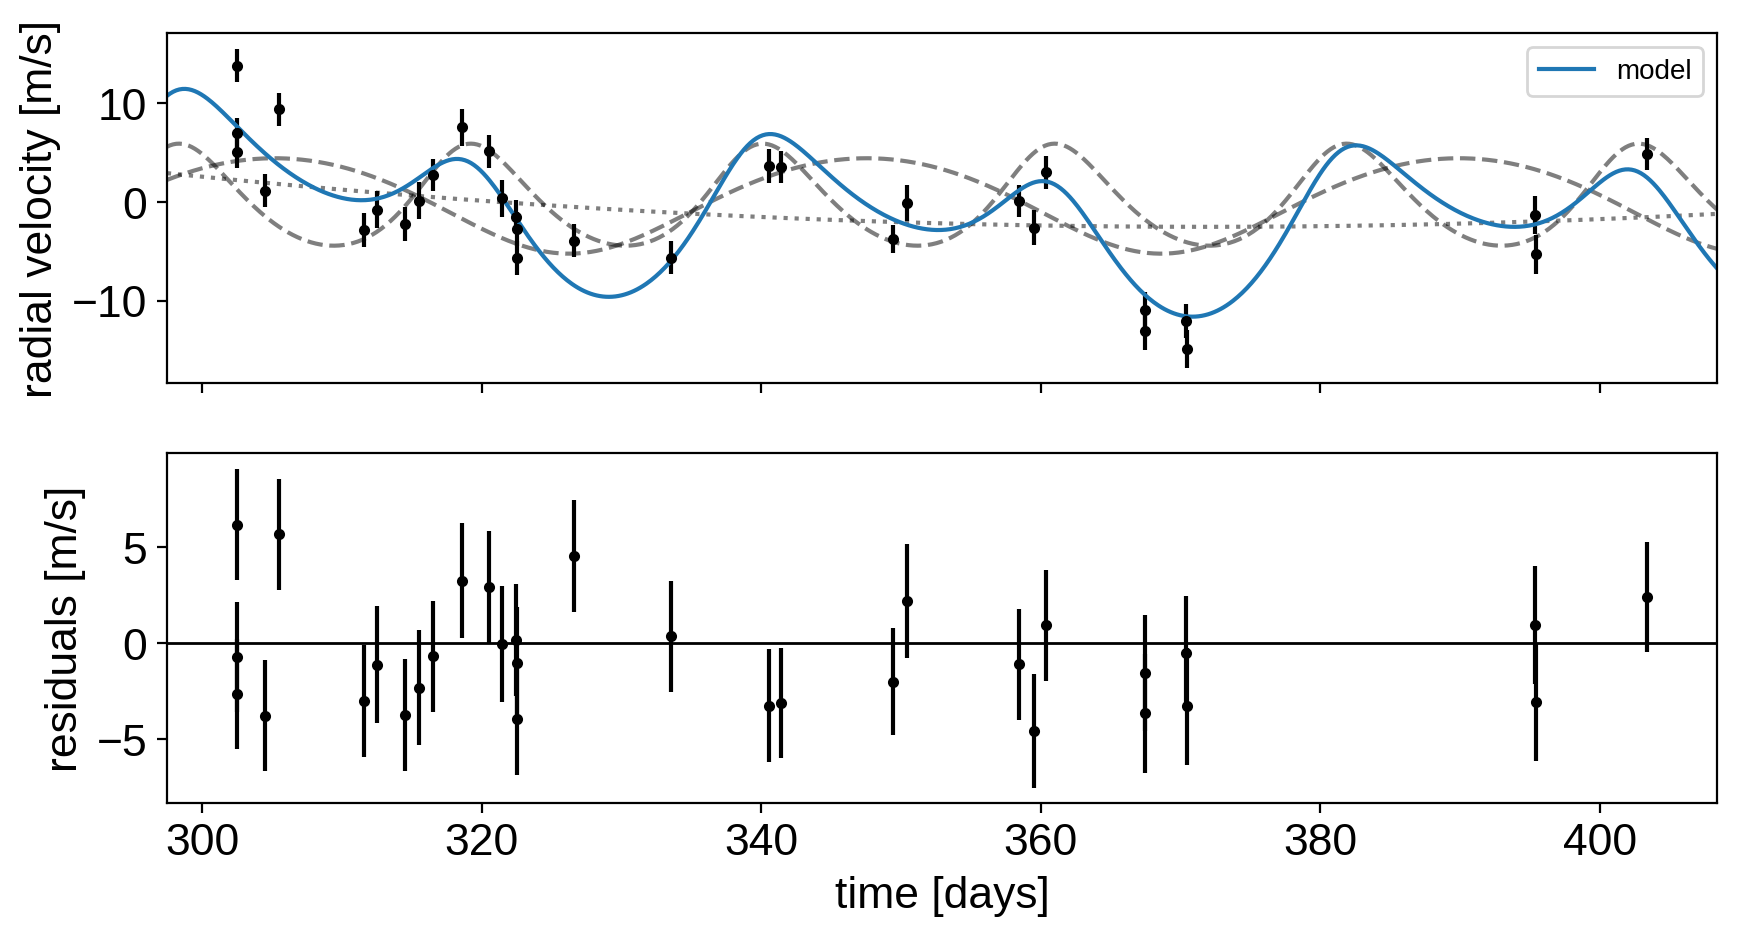

In [10]:
def plot_rv_curve(soln):
    fig, axes = plt.subplots(2, 1, figsize=(10, 5), sharex=True)
    
    ax = axes[0]
    ax.errorbar(x_rv, y_rv, yerr=yerr_rv, fmt=".k")
    ax.plot(t_rv, soln["vrad_pred"], "--k", alpha=0.5)
    ax.plot(t_rv, soln["bkg_pred"], ":k", alpha=0.5)
    ax.plot(t_rv, soln["rv_model_pred"], label="model")
    ax.legend(fontsize=10)
    ax.set_ylabel("radial velocity [m/s]")
    
    ax = axes[1]
    err = np.sqrt(yerr_rv**2+np.exp(2*soln["logs_rv"]))
    ax.errorbar(x_rv, y_rv - soln["rv_model"], yerr=err, fmt=".k")
    ax.axhline(0, color="k", lw=1)
    ax.set_ylabel("residuals [m/s]")
    ax.set_xlim(t_rv.min(), t_rv.max())
    ax.set_xlabel("time [days]")
    
plot_rv_curve(map_soln0)

That looks pretty similar to what we got in :ref:`rv`.
Now let's also plot the transit model.

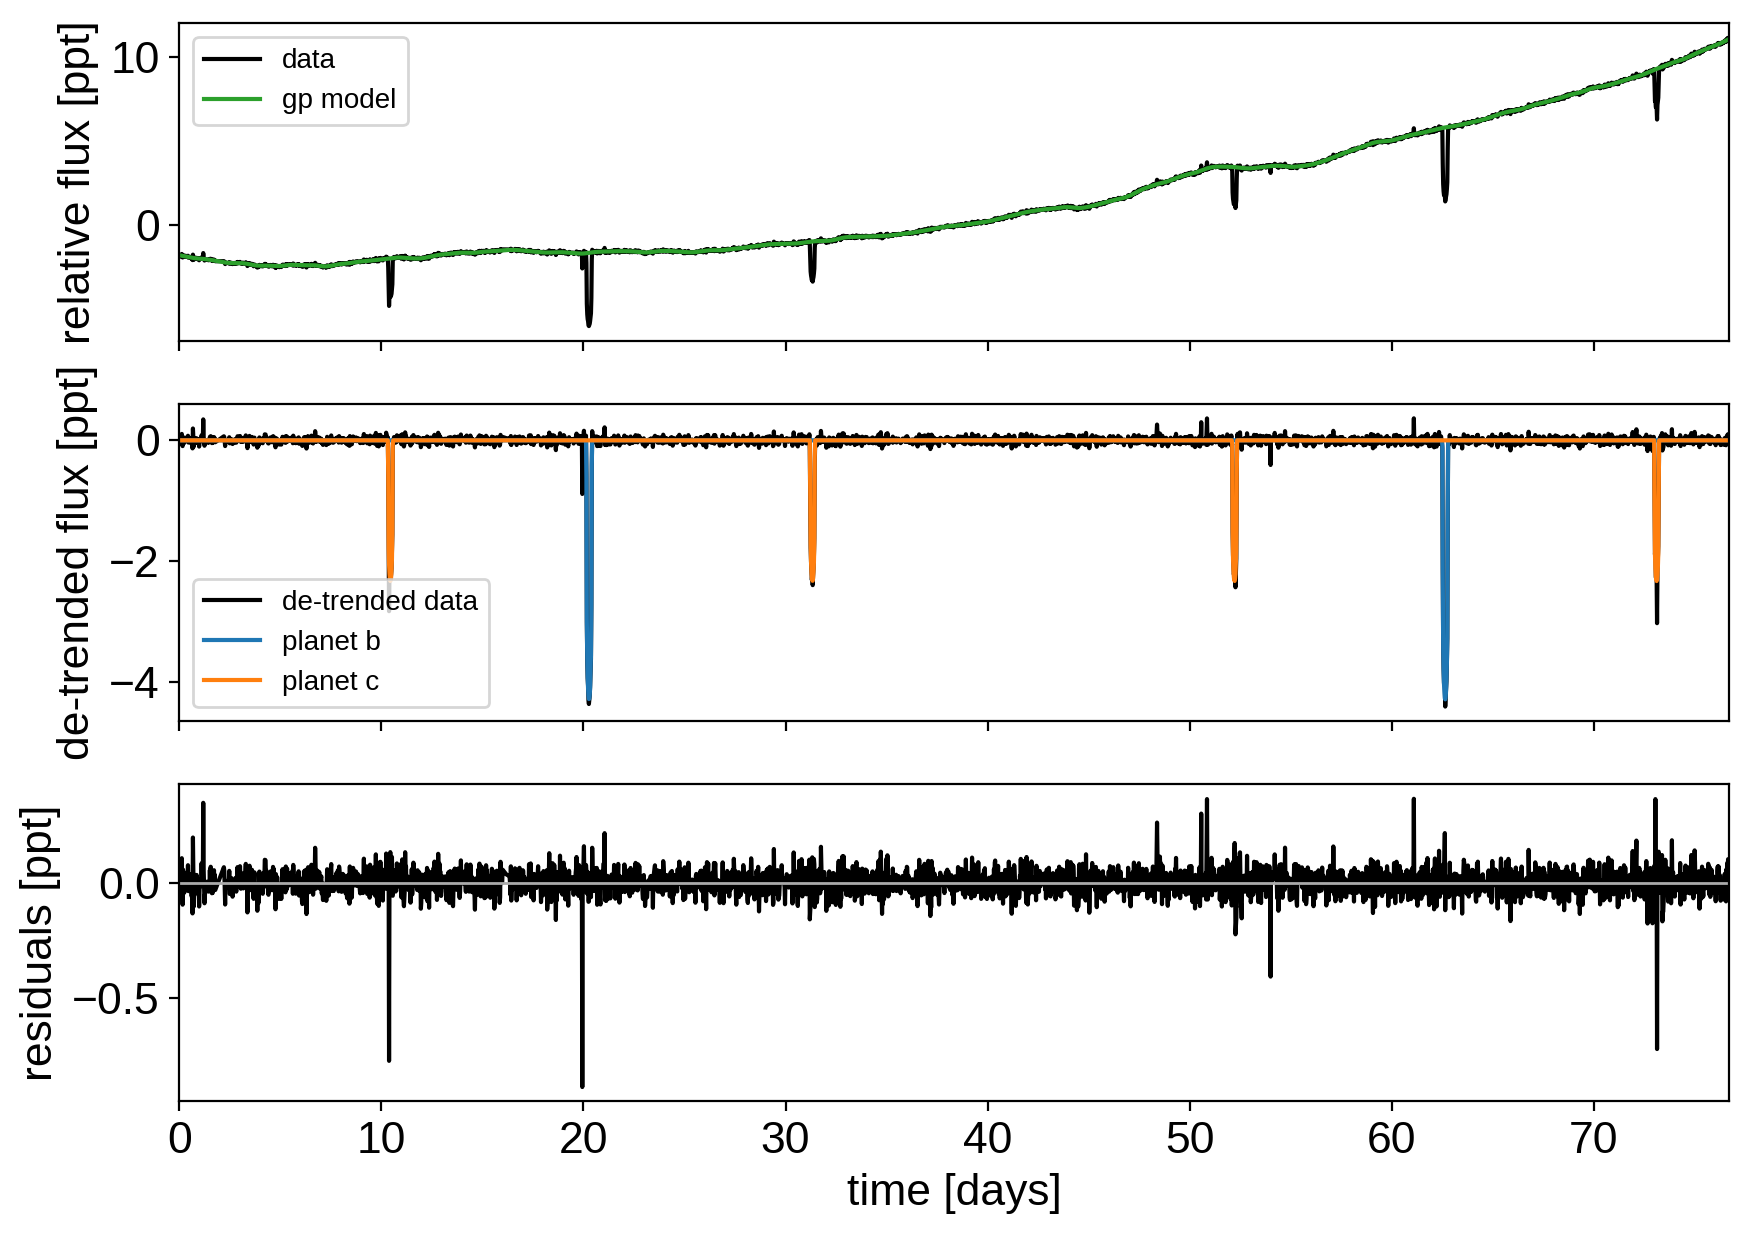

In [11]:
def plot_light_curve(soln, mask=None):
    if mask is None:
        mask = np.ones(len(x), dtype=bool)

    fig, axes = plt.subplots(3, 1, figsize=(10, 7), sharex=True)

    ax = axes[0]
    ax.plot(x[mask], y[mask], "k", label="data")
    gp_mod = soln["gp_pred"] + soln["mean"]
    ax.plot(x[mask], gp_mod, color="C2", label="gp model")
    ax.legend(fontsize=10)
    ax.set_ylabel("relative flux [ppt]")

    ax = axes[1]
    ax.plot(x[mask], y[mask] - gp_mod, "k", label="de-trended data")
    for i, l in enumerate("bc"):
        mod = soln["light_curves"][:, i]
        ax.plot(x[mask], mod, label="planet {0}".format(l))
    ax.legend(fontsize=10, loc=3)
    ax.set_ylabel("de-trended flux [ppt]")

    ax = axes[2]
    mod = gp_mod + np.sum(soln["light_curves"], axis=-1)
    ax.plot(x[mask], y[mask] - mod, "k")
    ax.axhline(0, color="#aaaaaa", lw=1)
    ax.set_ylabel("residuals [ppt]")
    ax.set_xlim(x[mask].min(), x[mask].max())
    ax.set_xlabel("time [days]")
    
    return fig
    
plot_light_curve(map_soln0);

There are still a few outliers in the light curve and it can be useful to remove those before doing the full fit because both the GP and transit parameters can be sensitive to this.

## Sigma clipping

To remove the outliers, we'll look at the empirical RMS of the residuals away from the GP + transit model and remove anything that is more than a 7-sigma outlier.

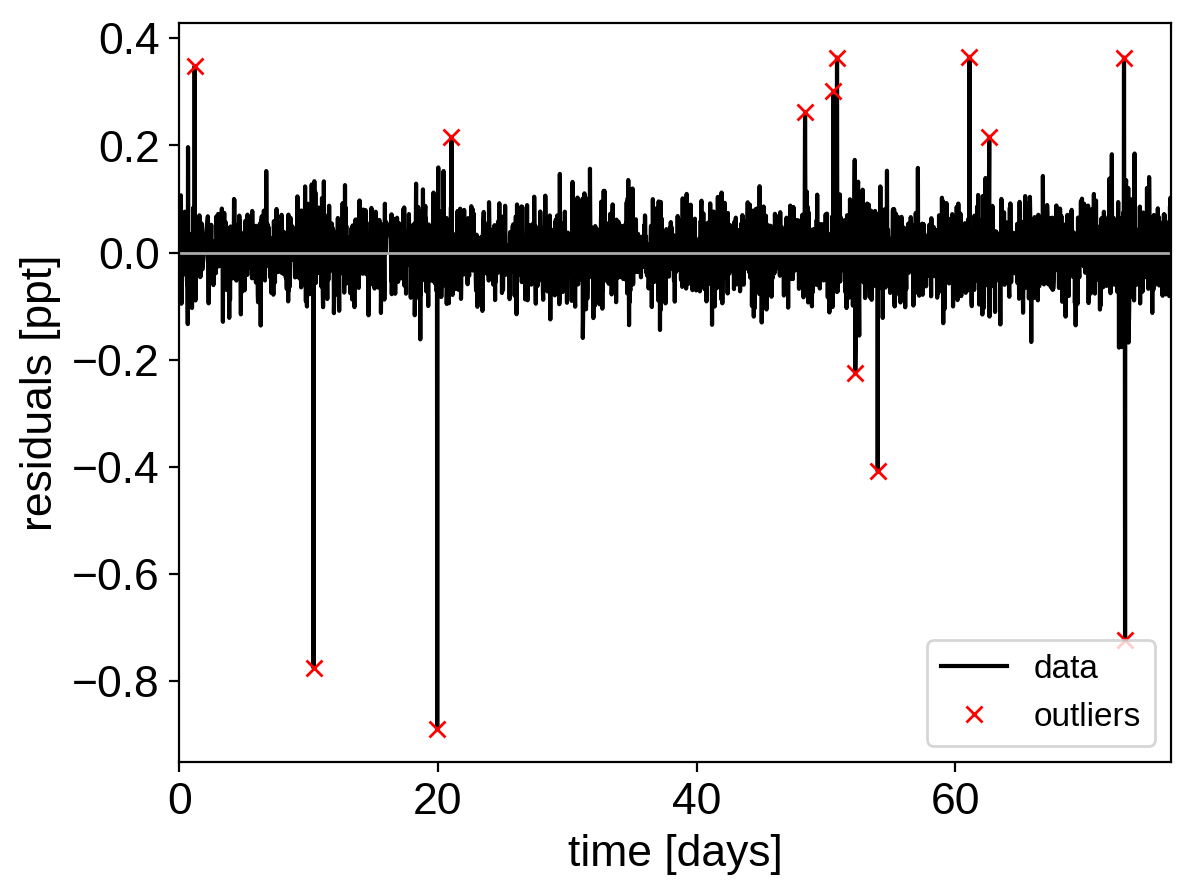

In [12]:
mod = map_soln0["gp_pred"] + map_soln0["mean"] + np.sum(map_soln0["light_curves"], axis=-1)
resid = y - mod
rms = np.sqrt(np.median(resid**2))
mask = np.abs(resid) < 7 * rms

plt.plot(x, resid, "k", label="data")
plt.plot(x[~mask], resid[~mask], "xr", label="outliers")
plt.axhline(0, color="#aaaaaa", lw=1)
plt.ylabel("residuals [ppt]")
plt.xlabel("time [days]")
plt.legend(fontsize=12, loc=4)
plt.xlim(x.min(), x.max());

That looks better. Let's re-build our model with this sigma-clipped dataset.

optimizing logp for variables: [trend]
0it [00:00, ?it/s]

0it [00:00, ?it/s, logp=5.225381e+03]

1it [00:00, 153.91it/s, logp=5.225381e+03]

2it [00:00, 196.46it/s, logp=5.225381e+03]

3it [00:00, 220.15it/s, logp=5.225362e+03]

4it [00:00, 239.48it/s, logp=5.225381e+03]

5it [00:00, 253.94it/s, logp=5.225381e+03]

6it [00:01,  3.87it/s, logp=5.225381e+03] 


message: Desired error not necessarily achieved due to precision loss.
logp: 5225.3812218700705 -> 5225.3812218700705


optimizing logp for variables: [logs2]
0it [00:00, ?it/s]

0it [00:00, ?it/s, logp=5.225381e+03]

1it [00:00, 162.10it/s, logp=5.225381e+03]

2it [00:00, 219.74it/s, logp=5.225381e+03]

3it [00:00, 249.48it/s, logp=4.837483e+03]

4it [00:00, 269.44it/s, logp=5.306928e+03]

5it [00:00, 281.76it/s, logp=5.307415e+03]

6it [00:00, 291.15it/s, logp=5.307429e+03]

7it [00:00, 297.88it/s, logp=5.307429e+03]

8it [00:00, 303.59it/s, logp=5.307429e+03]

9it [00:01,  5.64it/s, logp=5.307429e+03] 


message: Optimization terminated successfully.
logp: 5225.3812218700705 -> 5307.429388952928


optimizing logp for variables: [b, logr, r_star]
0it [00:00, ?it/s]

0it [00:00, ?it/s, logp=5.307429e+03]

1it [00:00, 172.42it/s, logp=5.307429e+03]

2it [00:00, 229.39it/s, logp=5.307429e+03]

3it [00:00, 254.49it/s, logp=-5.782812e+04]

4it [00:00, 275.06it/s, logp=5.311043e+03] 

5it [00:00, 285.40it/s, logp=5.248071e+03]

6it [00:00, 295.68it/s, logp=5.311239e+03]

7it [00:00, 302.56it/s, logp=5.311414e+03]

8it [00:00, 307.33it/s, logp=5.311688e+03]

9it [00:00, 311.54it/s, logp=5.312239e+03]

10it [00:00, 315.18it/s, logp=5.314205e+03]

11it [00:00, 318.32it/s, logp=5.286069e+03]

12it [00:00, 321.73it/s, logp=5.315289e+03]

13it [00:00, 311.77it/s, logp=5.297046e+03]

14it [00:00, 314.71it/s, logp=5.315596e+03]

15it [00:00, 315.94it/s, logp=5.316182e+03]

16it [00:00, 316.94it/s, logp=5.317200e+03]

17it [00:00, 317.28it/s, logp=5.318359e+03]

18it [00:00, 318.48it/s, logp=5.318392e+03]

19it [00:00, 319.92it/s, logp=5.318394e+03]

20it [00:00, 321.23it/s, logp=5.318396e+03]

21it [00:00, 322.33it/s, logp=5.318396e+03]

22it [00:00, 323.53it/s, logp=5.318396e+03]

23it [00:00, 324.69it/s, logp=5.318396e+03]

24it [00:00, 325.91it/s, logp=5.318396e+03]

25it [00:00, 326.47it/s, logp=5.318396e+03]

26it [00:00, 327.15it/s, logp=5.318396e+03]

27it [00:00, 327.56it/s, logp=5.318396e+03]

28it [00:00, 328.74it/s, logp=5.318396e+03]

29it [00:00, 329.81it/s, logp=5.318396e+03]

30it [00:00, 330.93it/s, logp=5.318396e+03]

31it [00:00, 331.99it/s, logp=5.318396e+03]

32it [00:00, 332.99it/s, logp=5.318396e+03]

33it [00:00, 333.91it/s, logp=5.318396e+03]

34it [00:00, 334.84it/s, logp=5.318396e+03]

35it [00:00, 342.07it/s, logp=5.318396e+03]

35it [00:00, 342.07it/s, logp=5.318396e+03]

36it [00:00, 342.07it/s, logp=5.318396e+03]

37it [00:00, 342.07it/s, logp=5.318396e+03]

38it [00:00, 342.07it/s, logp=5.318396e+03]

39it [00:00, 342.07it/s, logp=5.318396e+03]

40it [00:00, 342.07it/s, logp=5.318396e+03]

41it [00:00, 342.07it/s, logp=5.318396e+03]

42it [00:00, 342.07it/s, logp=5.318396e+03]

43it [00:00, 342.07it/s, logp=5.318396e+03]

44it [00:00, 342.07it/s, logp=5.318396e+03]

45it [00:00, 342.07it/s, logp=5.318396e+03]

46it [00:00, 342.07it/s, logp=5.318396e+03]

47it [00:00, 342.07it/s, logp=5.318396e+03]

48it [00:00, 342.07it/s, logp=5.318396e+03]

49it [00:00, 342.07it/s, logp=5.318396e+03]

50it [00:00, 342.07it/s, logp=5.318396e+03]

51it [00:00, 342.07it/s, logp=5.318396e+03]

52it [00:00, 342.07it/s, logp=5.318396e+03]

53it [00:00, 342.07it/s, logp=5.318396e+03]

54it [00:00, 342.07it/s, logp=5.318396e+03]

55it [00:00, 342.07it/s, logp=5.318396e+03]

56it [00:00, 342.07it/s, logp=5.318396e+03]

57it [00:00, 342.07it/s, logp=5.318396e+03]

58it [00:00, 342.07it/s, logp=5.318396e+03]

59it [00:00, 342.07it/s, logp=5.318396e+03]

60it [00:00, 342.07it/s, logp=5.318396e+03]

61it [00:00, 311.41it/s, logp=5.318396e+03]

61it [00:00, 311.41it/s, logp=5.318396e+03]

62it [00:00, 311.41it/s, logp=5.318396e+03]

63it [00:00, 311.41it/s, logp=5.318396e+03]

64it [00:00, 311.41it/s, logp=5.318396e+03]

65it [00:00, 311.41it/s, logp=5.318396e+03]

66it [00:00, 311.41it/s, logp=5.318396e+03]

67it [00:00, 311.41it/s, logp=5.318396e+03]

68it [00:00, 311.41it/s, logp=5.318396e+03]

69it [00:00, 311.41it/s, logp=5.318396e+03]

70it [00:00, 311.41it/s, logp=5.318396e+03]

71it [00:00, 311.41it/s, logp=5.318396e+03]

72it [00:00, 311.41it/s, logp=5.318396e+03]

73it [00:00, 311.41it/s, logp=5.318396e+03]

74it [00:00, 311.41it/s, logp=5.318396e+03]

75it [00:00, 311.41it/s, logp=5.318396e+03]

76it [00:00, 311.41it/s, logp=5.318396e+03]

77it [00:00, 311.41it/s, logp=5.318396e+03]

78it [00:00, 311.41it/s, logp=5.318396e+03]

79it [00:00, 311.41it/s, logp=5.318396e+03]

80it [00:00, 311.41it/s, logp=5.318396e+03]

81it [00:00, 311.41it/s, logp=5.318396e+03]

82it [00:00, 311.41it/s, logp=5.318396e+03]

83it [00:00, 311.41it/s, logp=5.318396e+03]

84it [00:00, 311.41it/s, logp=5.318396e+03]

85it [00:01, 53.15it/s, logp=5.318396e+03] 


message: Desired error not necessarily achieved due to precision loss.
logp: 5307.429388952928 -> 5318.395980443081


optimizing logp for variables: [t0, logP]
0it [00:00, ?it/s]

0it [00:00, ?it/s, logp=5.318396e+03]

1it [00:00, 162.87it/s, logp=5.318396e+03]

2it [00:00, 221.31it/s, logp=5.318396e+03]

3it [00:00, 237.39it/s, logp=-9.262876e+04]

4it [00:00, 254.07it/s, logp=-6.819000e+04]

5it [00:00, 265.92it/s, logp=-7.392265e+04]

6it [00:00, 276.24it/s, logp=-2.517375e+04]

7it [00:00, 284.84it/s, logp=5.316152e+03] 

8it [00:00, 290.42it/s, logp=5.318813e+03]

9it [00:00, 294.07it/s, logp=5.195295e+03]

10it [00:00, 297.81it/s, logp=5.318814e+03]

11it [00:00, 299.99it/s, logp=5.318817e+03]

12it [00:00, 303.63it/s, logp=5.318827e+03]

13it [00:00, 305.92it/s, logp=5.318866e+03]

14it [00:00, 308.53it/s, logp=5.319016e+03]

15it [00:00, 308.95it/s, logp=5.318834e+03]

16it [00:00, 311.23it/s, logp=5.319087e+03]

17it [00:00, 295.21it/s, logp=5.319222e+03]

18it [00:00, 279.33it/s, logp=5.319461e+03]

19it [00:00, 272.42it/s, logp=5.319759e+03]

20it [00:00, 266.79it/s, logp=5.319775e+03]

21it [00:00, 264.99it/s, logp=5.319775e+03]

22it [00:00, 263.68it/s, logp=5.319775e+03]

23it [00:00, 265.51it/s, logp=5.319775e+03]

24it [00:00, 267.39it/s, logp=5.319775e+03]

25it [00:00, 269.46it/s, logp=5.319775e+03]

26it [00:00, 272.00it/s, logp=5.319775e+03]

27it [00:00, 274.18it/s, logp=5.319775e+03]

28it [00:00, 276.22it/s, logp=5.319775e+03]

29it [00:00, 283.98it/s, logp=5.319775e+03]

29it [00:00, 283.98it/s, logp=5.319775e+03]

30it [00:00, 283.98it/s, logp=5.319775e+03]

31it [00:00, 283.98it/s, logp=5.319775e+03]

32it [00:00, 283.98it/s, logp=5.319775e+03]

33it [00:00, 283.98it/s, logp=5.319775e+03]

34it [00:00, 283.98it/s, logp=5.319775e+03]

35it [00:00, 283.98it/s, logp=5.319775e+03]

36it [00:00, 283.98it/s, logp=5.319775e+03]

37it [00:00, 283.98it/s, logp=5.319775e+03]

38it [00:00, 283.98it/s, logp=5.319775e+03]

39it [00:00, 283.98it/s, logp=5.319775e+03]

40it [00:00, 283.98it/s, logp=5.319775e+03]

41it [00:00, 283.98it/s, logp=5.319775e+03]

42it [00:00, 283.98it/s, logp=5.319775e+03]

43it [00:00, 283.98it/s, logp=5.319775e+03]

44it [00:00, 283.98it/s, logp=5.319775e+03]

45it [00:00, 283.98it/s, logp=5.319775e+03]

46it [00:00, 283.98it/s, logp=5.319775e+03]

47it [00:00, 283.98it/s, logp=5.319775e+03]

48it [00:00, 283.98it/s, logp=5.319775e+03]

49it [00:00, 283.98it/s, logp=5.319775e+03]

50it [00:00, 283.98it/s, logp=5.319775e+03]

51it [00:00, 283.98it/s, logp=5.319775e+03]

52it [00:00, 283.98it/s, logp=5.319775e+03]

53it [00:00, 283.98it/s, logp=5.319775e+03]

54it [00:00, 283.98it/s, logp=5.319775e+03]

55it [00:00, 283.98it/s, logp=5.319775e+03]

56it [00:00, 283.98it/s, logp=5.319775e+03]

57it [00:00, 283.98it/s, logp=5.319775e+03]

58it [00:00, 283.98it/s, logp=5.319775e+03]

59it [00:00, 283.98it/s, logp=5.319775e+03]

60it [00:00, 283.98it/s, logp=5.319775e+03]

61it [00:00, 283.98it/s, logp=5.319775e+03]

62it [00:00, 283.98it/s, logp=5.319775e+03]

63it [00:00, 283.98it/s, logp=5.319775e+03]

64it [00:00, 300.56it/s, logp=5.319775e+03]

64it [00:00, 300.56it/s, logp=5.319775e+03]

65it [00:00, 300.56it/s, logp=5.319775e+03]

66it [00:00, 300.56it/s, logp=5.319775e+03]

67it [00:00, 300.56it/s, logp=5.319775e+03]

68it [00:00, 300.56it/s, logp=5.319775e+03]

69it [00:00, 300.56it/s, logp=5.319775e+03]

70it [00:00, 300.56it/s, logp=5.319775e+03]

71it [00:00, 300.56it/s, logp=5.319775e+03]

72it [00:00, 300.56it/s, logp=5.319775e+03]

73it [00:00, 300.56it/s, logp=5.319775e+03]

74it [00:00, 300.56it/s, logp=5.319775e+03]

75it [00:00, 300.56it/s, logp=5.319775e+03]

76it [00:00, 300.56it/s, logp=5.319775e+03]

77it [00:00, 300.56it/s, logp=5.319775e+03]

78it [00:00, 300.56it/s, logp=5.319775e+03]

79it [00:00, 300.56it/s, logp=5.319775e+03]

80it [00:00, 300.56it/s, logp=5.319775e+03]

81it [00:00, 300.56it/s, logp=5.319775e+03]

82it [00:00, 300.56it/s, logp=5.319775e+03]

83it [00:00, 300.56it/s, logp=5.319775e+03]

84it [00:00, 300.56it/s, logp=5.319775e+03]

85it [00:00, 300.56it/s, logp=5.319775e+03]

86it [00:00, 300.56it/s, logp=5.319775e+03]

87it [00:00, 300.56it/s, logp=5.319775e+03]

88it [00:00, 300.56it/s, logp=5.319775e+03]

89it [00:00, 300.56it/s, logp=5.319775e+03]

90it [00:00, 300.56it/s, logp=5.319775e+03]

91it [00:00, 300.56it/s, logp=5.319775e+03]

92it [00:00, 300.56it/s, logp=5.319775e+03]

93it [00:00, 300.56it/s, logp=5.319775e+03]

94it [00:00, 300.56it/s, logp=5.319775e+03]

95it [00:00, 300.56it/s, logp=5.319775e+03]

96it [00:00, 300.56it/s, logp=5.319775e+03]

97it [00:00, 300.56it/s, logp=5.319775e+03]

98it [00:00, 300.56it/s, logp=5.319775e+03]

99it [00:00, 312.66it/s, logp=5.319775e+03]

99it [00:00, 312.66it/s, logp=5.319775e+03]

100it [00:00, 312.66it/s, logp=5.319775e+03]

101it [00:00, 312.66it/s, logp=5.319775e+03]

102it [00:00, 312.66it/s, logp=5.319775e+03]

103it [00:00, 312.66it/s, logp=5.319775e+03]

104it [00:00, 312.66it/s, logp=5.319775e+03]

105it [00:00, 312.66it/s, logp=5.319775e+03]

106it [00:00, 312.66it/s, logp=5.319775e+03]

107it [00:00, 312.66it/s, logp=5.319775e+03]

108it [00:00, 312.66it/s, logp=5.319775e+03]

109it [00:01, 57.38it/s, logp=5.319775e+03] 


message: Desired error not necessarily achieved due to precision loss.
logp: 5318.395980443073 -> 5319.775397564113


optimizing logp for variables: [logSw4, logs2]
0it [00:00, ?it/s]

0it [00:00, ?it/s, logp=5.319775e+03]

1it [00:00, 147.04it/s, logp=5.319775e+03]

2it [00:00, 201.06it/s, logp=5.319775e+03]

3it [00:00, 227.67it/s, logp=4.623524e+03]

4it [00:00, 247.38it/s, logp=5.319857e+03]

5it [00:00, 257.94it/s, logp=5.320011e+03]

6it [00:00, 266.56it/s, logp=5.320272e+03]

7it [00:00, 273.00it/s, logp=5.320504e+03]

8it [00:00, 278.85it/s, logp=5.320504e+03]

9it [00:00, 283.64it/s, logp=5.320504e+03]

10it [00:01,  5.26it/s, logp=5.320504e+03]


message: Optimization terminated successfully.
logp: 5319.775397564102 -> 5320.504272670553


optimizing logp for variables: [logw0]
0it [00:00, ?it/s]

0it [00:00, ?it/s, logp=5.320504e+03]

1it [00:00, 140.18it/s, logp=5.320504e+03]

2it [00:00, 186.81it/s, logp=5.320504e+03]

3it [00:00, 209.98it/s, logp=5.285627e+03]

4it [00:00, 225.59it/s, logp=5.320392e+03]

5it [00:00, 238.40it/s, logp=5.320538e+03]

6it [00:00, 192.88it/s, logp=5.320538e+03]

7it [00:00, 198.72it/s, logp=5.320538e+03]

8it [00:00, 206.92it/s, logp=5.320538e+03]

9it [00:01,  6.25it/s, logp=5.320538e+03] 


message: Optimization terminated successfully.
logp: 5320.504272670553 -> 5320.538334045068


optimizing logp for variables: [logSw4, logw0, logs2, trend, logs_rv, omega, ecc_frac, ecc_sigma_rayleigh, ecc_sigma_gauss, ecc, b, logr, t0, logP, logm, r_star, m_star, u_star, mean]
0it [00:00, ?it/s]

0it [00:00, ?it/s, logp=5.320538e+03]

1it [00:00, 106.86it/s, logp=5.320538e+03]

2it [00:00, 144.63it/s, logp=5.320538e+03]

3it [00:00, 159.90it/s, logp=-1.203447e+05]

4it [00:00, 172.51it/s, logp=-3.984307e+03]

5it [00:00, 179.42it/s, logp=5.320538e+03] 

6it [00:00, 184.60it/s, logp=5.320510e+03]

7it [00:00, 185.28it/s, logp=5.320538e+03]

8it [00:00, 185.88it/s, logp=5.320538e+03]

9it [00:00, 186.09it/s, logp=5.320538e+03]

10it [00:00, 187.20it/s, logp=5.320538e+03]

11it [00:00, 188.64it/s, logp=5.320539e+03]

12it [00:00, 189.52it/s, logp=5.320539e+03]

13it [00:00, 190.90it/s, logp=5.320539e+03]

14it [00:00, 192.19it/s, logp=5.320542e+03]

15it [00:00, 192.84it/s, logp=5.320535e+03]

16it [00:00, 194.09it/s, logp=5.320543e+03]

17it [00:00, 194.62it/s, logp=5.320544e+03]

18it [00:00, 195.26it/s, logp=5.320541e+03]

19it [00:00, 196.16it/s, logp=5.320544e+03]

20it [00:00, 196.68it/s, logp=5.320545e+03]

21it [00:00, 205.12it/s, logp=5.320545e+03]

21it [00:00, 205.12it/s, logp=5.320547e+03]

22it [00:00, 205.12it/s, logp=5.320551e+03]

23it [00:00, 205.12it/s, logp=5.320561e+03]

24it [00:00, 205.12it/s, logp=5.320595e+03]

25it [00:00, 205.12it/s, logp=5.320649e+03]

26it [00:00, 205.12it/s, logp=5.320753e+03]

27it [00:00, 205.12it/s, logp=5.321065e+03]

28it [00:00, 205.12it/s, logp=5.311798e+03]

29it [00:00, 205.12it/s, logp=5.321082e+03]

30it [00:00, 205.12it/s, logp=5.321113e+03]

31it [00:00, 205.12it/s, logp=5.321165e+03]

32it [00:00, 205.12it/s, logp=5.321223e+03]

33it [00:00, 205.12it/s, logp=5.321334e+03]

34it [00:00, 205.12it/s, logp=5.321666e+03]

35it [00:00, 205.12it/s, logp=5.319429e+03]

36it [00:00, 205.12it/s, logp=5.321766e+03]

37it [00:00, 205.12it/s, logp=5.321606e+03]

38it [00:00, 205.12it/s, logp=5.321796e+03]

39it [00:00, 205.12it/s, logp=5.321844e+03]

40it [00:00, 205.12it/s, logp=5.321921e+03]

41it [00:00, 205.12it/s, logp=5.321862e+03]

42it [00:00, 205.54it/s, logp=5.321862e+03]

42it [00:00, 205.54it/s, logp=5.321952e+03]

43it [00:00, 205.54it/s, logp=5.321997e+03]

44it [00:00, 205.54it/s, logp=5.322013e+03]

45it [00:00, 205.54it/s, logp=5.322041e+03]

46it [00:00, 205.54it/s, logp=5.322054e+03]

47it [00:00, 205.54it/s, logp=5.322075e+03]

48it [00:00, 205.54it/s, logp=5.322090e+03]

49it [00:00, 205.54it/s, logp=5.321864e+03]

50it [00:00, 205.54it/s, logp=5.322091e+03]

51it [00:00, 205.54it/s, logp=5.322093e+03]

52it [00:00, 205.54it/s, logp=5.322095e+03]

53it [00:00, 205.54it/s, logp=5.322096e+03]

54it [00:00, 205.54it/s, logp=5.322097e+03]

55it [00:00, 205.54it/s, logp=5.322098e+03]

56it [00:00, 205.54it/s, logp=5.322098e+03]

57it [00:00, 205.54it/s, logp=5.322098e+03]

58it [00:00, 205.54it/s, logp=5.322098e+03]

59it [00:00, 205.54it/s, logp=5.322098e+03]

60it [00:00, 205.54it/s, logp=5.322098e+03]

61it [00:00, 205.54it/s, logp=5.322099e+03]

62it [00:00, 203.78it/s, logp=5.322099e+03]

62it [00:00, 203.78it/s, logp=5.322099e+03]

63it [00:00, 203.78it/s, logp=5.322099e+03]

64it [00:00, 203.78it/s, logp=5.322099e+03]

65it [00:00, 203.78it/s, logp=5.322099e+03]

66it [00:00, 203.78it/s, logp=5.322099e+03]

67it [00:00, 203.78it/s, logp=5.322099e+03]

68it [00:00, 203.78it/s, logp=5.322099e+03]

69it [00:00, 203.78it/s, logp=5.322099e+03]

70it [00:00, 203.78it/s, logp=5.322099e+03]

71it [00:00, 203.78it/s, logp=5.322099e+03]

72it [00:00, 203.78it/s, logp=5.322099e+03]

73it [00:00, 203.78it/s, logp=5.322099e+03]

74it [00:00, 203.78it/s, logp=5.322099e+03]

75it [00:00, 203.78it/s, logp=5.322099e+03]

76it [00:00, 203.78it/s, logp=5.322099e+03]

77it [00:00, 203.78it/s, logp=5.322099e+03]

78it [00:00, 203.78it/s, logp=5.322099e+03]

79it [00:00, 203.78it/s, logp=5.322099e+03]

80it [00:00, 203.78it/s, logp=5.322099e+03]

81it [00:00, 203.78it/s, logp=5.322099e+03]

82it [00:00, 203.78it/s, logp=5.322099e+03]

83it [00:00, 203.78it/s, logp=5.322099e+03]

84it [00:00, 207.02it/s, logp=5.322099e+03]

84it [00:00, 207.02it/s, logp=5.322099e+03]

85it [00:00, 207.02it/s, logp=5.322099e+03]

86it [00:00, 207.02it/s, logp=5.322099e+03]

87it [00:00, 207.02it/s, logp=5.322099e+03]

88it [00:00, 207.02it/s, logp=5.322099e+03]

89it [00:00, 207.02it/s, logp=5.322099e+03]

90it [00:00, 207.02it/s, logp=5.322099e+03]

91it [00:00, 207.02it/s, logp=5.322099e+03]

92it [00:00, 207.02it/s, logp=5.322099e+03]

93it [00:00, 207.02it/s, logp=5.322099e+03]

94it [00:00, 207.02it/s, logp=5.322099e+03]

95it [00:00, 207.02it/s, logp=5.322099e+03]

96it [00:00, 207.02it/s, logp=5.322099e+03]

97it [00:00, 207.02it/s, logp=5.322099e+03]

98it [00:00, 207.02it/s, logp=5.322099e+03]

99it [00:00, 207.02it/s, logp=5.322099e+03]

100it [00:00, 207.02it/s, logp=5.322099e+03]

101it [00:00, 207.02it/s, logp=5.322099e+03]

102it [00:00, 195.17it/s, logp=5.322099e+03]

102it [00:00, 195.17it/s, logp=5.322099e+03]

103it [00:00, 195.17it/s, logp=5.322099e+03]

104it [00:00, 195.17it/s, logp=5.322099e+03]

105it [00:00, 195.17it/s, logp=5.322099e+03]

106it [00:00, 195.17it/s, logp=5.322099e+03]

107it [00:00, 195.17it/s, logp=5.322099e+03]

108it [00:00, 195.17it/s, logp=5.322099e+03]

109it [00:00, 195.17it/s, logp=5.322099e+03]

110it [00:00, 195.17it/s, logp=5.322099e+03]

111it [00:00, 195.17it/s, logp=5.322099e+03]

112it [00:00, 195.17it/s, logp=5.322099e+03]

113it [00:00, 195.17it/s, logp=5.322099e+03]

114it [00:00, 195.17it/s, logp=5.322099e+03]

115it [00:00, 195.17it/s, logp=5.322099e+03]

116it [00:00, 195.17it/s, logp=5.322099e+03]

117it [00:00, 195.17it/s, logp=5.322099e+03]

118it [00:00, 195.17it/s, logp=5.322099e+03]

119it [00:00, 178.46it/s, logp=5.322099e+03]

119it [00:00, 178.46it/s, logp=5.322099e+03]

120it [00:00, 178.46it/s, logp=5.322099e+03]

121it [00:00, 178.46it/s, logp=5.322099e+03]

122it [00:00, 178.46it/s, logp=5.322099e+03]

123it [00:00, 178.46it/s, logp=5.322099e+03]

124it [00:00, 178.46it/s, logp=5.322099e+03]

125it [00:00, 178.46it/s, logp=5.322099e+03]

126it [00:00, 178.46it/s, logp=5.322099e+03]

127it [00:00, 178.46it/s, logp=5.322099e+03]

128it [00:00, 178.46it/s, logp=5.322099e+03]

129it [00:00, 178.46it/s, logp=5.322099e+03]

130it [00:00, 178.46it/s, logp=5.322099e+03]

131it [00:00, 178.46it/s, logp=5.322099e+03]

132it [00:00, 178.46it/s, logp=5.322099e+03]

133it [00:00, 178.46it/s, logp=5.322099e+03]

134it [00:00, 178.46it/s, logp=5.322099e+03]

135it [00:00, 178.46it/s, logp=5.322099e+03]

136it [00:00, 178.46it/s, logp=5.322099e+03]

137it [00:00, 178.46it/s, logp=5.322099e+03]

138it [00:00, 181.04it/s, logp=5.322099e+03]

138it [00:00, 181.04it/s, logp=5.322099e+03]

139it [00:00, 181.04it/s, logp=5.322099e+03]

140it [00:00, 181.04it/s, logp=5.322099e+03]

141it [00:00, 181.04it/s, logp=5.322099e+03]

142it [00:00, 181.04it/s, logp=5.322099e+03]

143it [00:00, 181.04it/s, logp=5.322099e+03]

144it [00:00, 181.04it/s, logp=5.322099e+03]

145it [00:00, 181.04it/s, logp=5.322099e+03]

146it [00:00, 181.04it/s, logp=5.322099e+03]

147it [00:00, 181.04it/s, logp=5.322099e+03]

148it [00:00, 181.04it/s, logp=5.322099e+03]

149it [00:00, 181.04it/s, logp=5.322099e+03]

150it [00:00, 181.04it/s, logp=5.322099e+03]

151it [00:00, 181.04it/s, logp=5.322099e+03]

152it [00:00, 181.04it/s, logp=5.322099e+03]

153it [00:00, 181.04it/s, logp=5.322099e+03]

154it [00:00, 181.04it/s, logp=5.322099e+03]

155it [00:00, 181.04it/s, logp=5.322099e+03]

156it [00:02, 56.51it/s, logp=5.322099e+03] 


message: Desired error not necessarily achieved due to precision loss.
logp: 5320.538334045072 -> 5322.099130377849


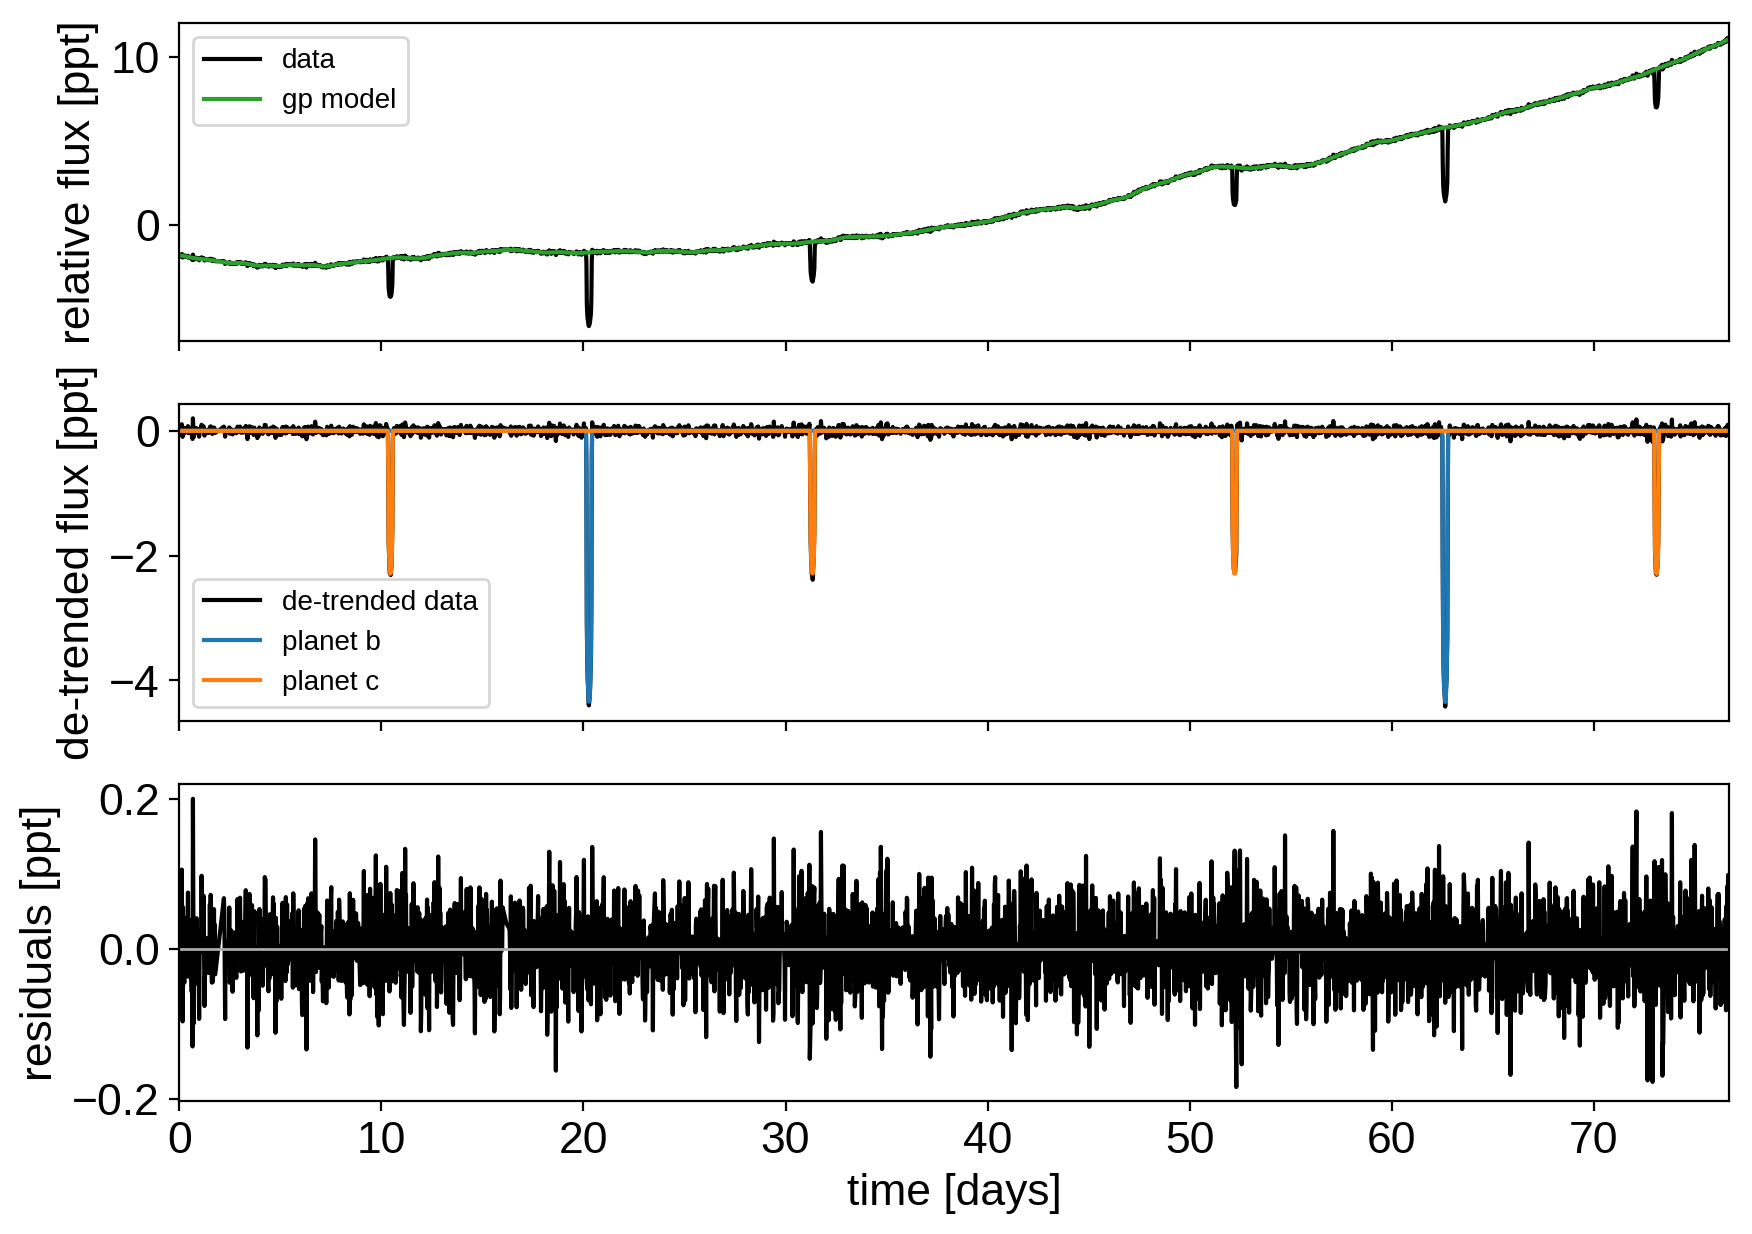

In [13]:
model, map_soln = build_model(mask, map_soln0)
plot_light_curve(map_soln, mask);

Great! Now we're ready to sample.

## Sampling

The sampling for this model is the same as for all the previous tutorials, but it takes a bit longer (about 2 hours on my laptop).
This is partly because the model is more expensive to compute than the previous ones and partly because there are some non-affine degeneracies in the problem (for example between impact parameter and eccentricity).
It might be worth thinking about reparameterizations (in terms of duration instead of eccentricity), but that's beyond the scope of this tutorial.
Besides, using more traditional MCMC methods, this would have taken a lot more than 2 hours to get >1000 effective samples!

In [14]:
np.random.seed(123)
with model:
    trace = pm.sample(tune=6000, draws=3000, start=map_soln, chains=4,
                      step=xo.get_dense_nuts_step(target_accept=0.9))

Multiprocess sampling (4 chains in 4 jobs)


NUTS: [logSw4, logw0, logs2, trend, logs_rv, omega, ecc_frac, ecc_sigma_rayleigh, ecc_sigma_gauss, ecc, b, logr, t0, logP, logm, r_star, m_star, u_star, mean]


Sampling 4 chains:   0%|          | 0/36000 [00:00<?, ?draws/s]

Sampling 4 chains:   0%|          | 21/36000 [00:00<23:05, 25.98draws/s]

Sampling 4 chains:   0%|          | 23/36000 [00:00<25:47, 23.25draws/s]

Sampling 4 chains:   0%|          | 25/36000 [00:01<1:07:42,  8.86draws/s]

Sampling 4 chains:   0%|          | 26/36000 [00:01<1:14:36,  8.04draws/s]

Sampling 4 chains:   0%|          | 29/36000 [00:02<1:22:10,  7.30draws/s]

Sampling 4 chains:   0%|          | 30/36000 [00:02<1:27:35,  6.84draws/s]

Sampling 4 chains:   0%|          | 31/36000 [00:02<1:24:50,  7.07draws/s]

Sampling 4 chains:   0%|          | 33/36000 [00:02<1:31:04,  6.58draws/s]

Sampling 4 chains:   0%|          | 34/36000 [00:02<1:36:31,  6.21draws/s]

Sampling 4 chains:   0%|          | 35/36000 [00:03<1:38:09,  6.11draws/s]

Sampling 4 chains:   0%|          | 37/36000 [00:03<1:35:13,  6.29draws/s]

Sampling 4 chains:   0%|          | 38/36000 [00:03<1:43:19,  5.80draws/s]

Sampling 4 chains:   0%|          | 39/36000 [00:03<1:39:51,  6.00draws/s]

Sampling 4 chains:   0%|          | 41/36000 [00:04<1:36:14,  6.23draws/s]

Sampling 4 chains:   0%|          | 42/36000 [00:04<1:54:02,  5.25draws/s]

Sampling 4 chains:   0%|          | 43/36000 [00:04<1:39:26,  6.03draws/s]

Sampling 4 chains:   0%|          | 44/36000 [00:04<1:32:03,  6.51draws/s]

Sampling 4 chains:   0%|          | 45/36000 [00:04<1:32:36,  6.47draws/s]

Sampling 4 chains:   0%|          | 46/36000 [00:05<2:06:00,  4.76draws/s]

Sampling 4 chains:   0%|          | 48/36000 [00:05<1:42:09,  5.87draws/s]

Sampling 4 chains:   0%|          | 49/36000 [00:05<1:48:23,  5.53draws/s]

Sampling 4 chains:   0%|          | 50/36000 [00:05<2:15:48,  4.41draws/s]

Sampling 4 chains:   0%|          | 52/36000 [00:05<1:46:57,  5.60draws/s]

Sampling 4 chains:   0%|          | 53/36000 [00:06<2:04:49,  4.80draws/s]

Sampling 4 chains:   0%|          | 54/36000 [00:06<2:13:06,  4.50draws/s]

Sampling 4 chains:   0%|          | 56/36000 [00:06<1:44:08,  5.75draws/s]

Sampling 4 chains:   0%|          | 57/36000 [00:06<2:13:49,  4.48draws/s]

Sampling 4 chains:   0%|          | 58/36000 [00:07<2:11:41,  4.55draws/s]

Sampling 4 chains:   0%|          | 60/36000 [00:07<1:42:13,  5.86draws/s]

Sampling 4 chains:   0%|          | 61/36000 [00:07<2:11:48,  4.54draws/s]

Sampling 4 chains:   0%|          | 62/36000 [00:07<2:10:09,  4.60draws/s]

Sampling 4 chains:   0%|          | 63/36000 [00:07<1:50:53,  5.40draws/s]

Sampling 4 chains:   0%|          | 65/36000 [00:08<1:48:54,  5.50draws/s]

Sampling 4 chains:   0%|          | 66/36000 [00:08<1:50:45,  5.41draws/s]

Sampling 4 chains:   0%|          | 67/36000 [00:08<1:39:57,  5.99draws/s]

Sampling 4 chains:   0%|          | 69/36000 [00:08<1:44:04,  5.75draws/s]

Sampling 4 chains:   0%|          | 70/36000 [00:09<2:09:37,  4.62draws/s]

Sampling 4 chains:   0%|          | 73/36000 [00:09<1:52:17,  5.33draws/s]

Sampling 4 chains:   0%|          | 74/36000 [00:09<2:15:36,  4.42draws/s]

Sampling 4 chains:   0%|          | 76/36000 [00:09<1:44:03,  5.75draws/s]

Sampling 4 chains:   0%|          | 77/36000 [00:10<1:55:21,  5.19draws/s]

Sampling 4 chains:   0%|          | 78/36000 [00:10<2:18:10,  4.33draws/s]

Sampling 4 chains:   0%|          | 80/36000 [00:10<1:51:25,  5.37draws/s]

Sampling 4 chains:   0%|          | 81/36000 [00:10<1:47:59,  5.54draws/s]

Sampling 4 chains:   0%|          | 82/36000 [00:11<2:17:29,  4.35draws/s]

Sampling 4 chains:   0%|          | 84/36000 [00:11<1:50:06,  5.44draws/s]

Sampling 4 chains:   0%|          | 85/36000 [00:11<1:46:10,  5.64draws/s]

Sampling 4 chains:   0%|          | 86/36000 [00:11<2:14:53,  4.44draws/s]

Sampling 4 chains:   0%|          | 88/36000 [00:12<1:55:03,  5.20draws/s]

Sampling 4 chains:   0%|          | 89/36000 [00:12<1:41:25,  5.90draws/s]

Sampling 4 chains:   0%|          | 90/36000 [00:12<2:06:03,  4.75draws/s]

Sampling 4 chains:   0%|          | 91/36000 [00:12<1:46:23,  5.63draws/s]

Sampling 4 chains:   0%|          | 92/36000 [00:12<1:52:55,  5.30draws/s]

Sampling 4 chains:   0%|          | 94/36000 [00:13<1:49:05,  5.49draws/s]

Sampling 4 chains:   0%|          | 95/36000 [00:13<1:48:42,  5.50draws/s]

Sampling 4 chains:   0%|          | 96/36000 [00:13<1:50:03,  5.44draws/s]

Sampling 4 chains:   0%|          | 98/36000 [00:13<1:42:43,  5.83draws/s]

Sampling 4 chains:   0%|          | 99/36000 [00:14<1:48:48,  5.50draws/s]

Sampling 4 chains:   0%|          | 100/36000 [00:14<1:48:04,  5.54draws/s]

Sampling 4 chains:   0%|          | 102/36000 [00:14<1:40:05,  5.98draws/s]

Sampling 4 chains:   0%|          | 103/36000 [00:14<1:46:16,  5.63draws/s]

Sampling 4 chains:   0%|          | 104/36000 [00:14<1:46:08,  5.64draws/s]

Sampling 4 chains:   0%|          | 105/36000 [00:15<1:42:53,  5.81draws/s]

Sampling 4 chains:   0%|          | 106/36000 [00:15<1:32:47,  6.45draws/s]

Sampling 4 chains:   0%|          | 107/36000 [00:15<1:41:04,  5.92draws/s]

Sampling 4 chains:   0%|          | 108/36000 [00:15<1:43:14,  5.79draws/s]

Sampling 4 chains:   0%|          | 109/36000 [00:15<1:55:02,  5.20draws/s]

Sampling 4 chains:   0%|          | 111/36000 [00:16<1:41:38,  5.89draws/s]

Sampling 4 chains:   0%|          | 112/36000 [00:16<1:42:12,  5.85draws/s]

Sampling 4 chains:   0%|          | 113/36000 [00:16<2:04:04,  4.82draws/s]

Sampling 4 chains:   0%|          | 115/36000 [00:16<1:43:26,  5.78draws/s]

Sampling 4 chains:   0%|          | 116/36000 [00:16<1:43:35,  5.77draws/s]

Sampling 4 chains:   0%|          | 117/36000 [00:17<2:06:50,  4.72draws/s]

Sampling 4 chains:   0%|          | 118/36000 [00:17<1:51:02,  5.39draws/s]

Sampling 4 chains:   0%|          | 120/36000 [00:17<1:38:23,  6.08draws/s]

Sampling 4 chains:   0%|          | 121/36000 [00:17<2:05:48,  4.75draws/s]

Sampling 4 chains:   0%|          | 122/36000 [00:17<1:54:49,  5.21draws/s]

Sampling 4 chains:   0%|          | 124/36000 [00:18<1:36:46,  6.18draws/s]

Sampling 4 chains:   0%|          | 125/36000 [00:18<2:06:04,  4.74draws/s]

Sampling 4 chains:   0%|          | 126/36000 [00:18<1:53:39,  5.26draws/s]

Sampling 4 chains:   0%|          | 128/36000 [00:18<1:36:09,  6.22draws/s]

Sampling 4 chains:   0%|          | 129/36000 [00:19<2:06:29,  4.73draws/s]

Sampling 4 chains:   0%|          | 130/36000 [00:19<1:53:02,  5.29draws/s]

Sampling 4 chains:   0%|          | 131/36000 [00:19<1:45:29,  5.67draws/s]

Sampling 4 chains:   0%|          | 133/36000 [00:19<1:48:47,  5.49draws/s]

Sampling 4 chains:   0%|          | 134/36000 [00:19<1:42:15,  5.85draws/s]

Sampling 4 chains:   0%|          | 135/36000 [00:20<1:47:45,  5.55draws/s]

Sampling 4 chains:   0%|          | 137/36000 [00:20<1:45:44,  5.65draws/s]

Sampling 4 chains:   0%|          | 138/36000 [00:20<1:50:57,  5.39draws/s]

Sampling 4 chains:   0%|          | 139/36000 [00:20<1:51:34,  5.36draws/s]

Sampling 4 chains:   0%|          | 141/36000 [00:21<1:50:03,  5.43draws/s]

Sampling 4 chains:   0%|          | 142/36000 [00:21<2:02:49,  4.87draws/s]

Sampling 4 chains:   0%|          | 143/36000 [00:21<1:43:56,  5.75draws/s]

Sampling 4 chains:   0%|          | 144/36000 [00:21<2:03:17,  4.85draws/s]

Sampling 4 chains:   0%|          | 146/36000 [00:22<1:58:00,  5.06draws/s]

Sampling 4 chains:   0%|          | 148/36000 [00:22<2:01:31,  4.92draws/s]

Sampling 4 chains:   0%|          | 150/36000 [00:22<1:49:33,  5.45draws/s]

Sampling 4 chains:   0%|          | 151/36000 [00:23<1:37:59,  6.10draws/s]

Sampling 4 chains:   0%|          | 152/36000 [00:23<2:16:50,  4.37draws/s]

Sampling 4 chains:   0%|          | 154/36000 [00:23<1:56:56,  5.11draws/s]

Sampling 4 chains:   0%|          | 155/36000 [00:23<1:42:24,  5.83draws/s]

Sampling 4 chains:   0%|          | 156/36000 [00:24<2:34:04,  3.88draws/s]

Sampling 4 chains:   0%|          | 157/36000 [00:24<2:30:14,  3.98draws/s]

Sampling 4 chains:   0%|          | 159/36000 [00:24<1:54:42,  5.21draws/s]

Sampling 4 chains:   0%|          | 160/36000 [00:25<3:07:39,  3.18draws/s]

Sampling 4 chains:   0%|          | 161/36000 [00:25<2:41:14,  3.70draws/s]

Sampling 4 chains:   0%|          | 164/36000 [00:26<2:38:05,  3.78draws/s]

Sampling 4 chains:   0%|          | 165/36000 [00:26<2:14:57,  4.43draws/s]

Sampling 4 chains:   0%|          | 168/36000 [00:26<2:17:00,  4.36draws/s]

Sampling 4 chains:   0%|          | 170/36000 [00:27<1:50:19,  5.41draws/s]

Sampling 4 chains:   0%|          | 171/36000 [00:27<1:56:51,  5.11draws/s]

Sampling 4 chains:   0%|          | 172/36000 [00:27<2:24:38,  4.13draws/s]

Sampling 4 chains:   0%|          | 174/36000 [00:28<2:24:56,  4.12draws/s]

Sampling 4 chains:   0%|          | 176/36000 [00:28<2:04:41,  4.79draws/s]

Sampling 4 chains:   0%|          | 178/36000 [00:29<2:24:29,  4.13draws/s]

Sampling 4 chains:   0%|          | 179/36000 [00:29<2:02:52,  4.86draws/s]

Sampling 4 chains:   1%|          | 182/36000 [00:29<2:12:54,  4.49draws/s]

Sampling 4 chains:   1%|          | 184/36000 [00:30<1:46:34,  5.60draws/s]

Sampling 4 chains:   1%|          | 185/36000 [00:30<1:47:24,  5.56draws/s]

Sampling 4 chains:   1%|          | 186/36000 [00:30<2:36:04,  3.82draws/s]

Sampling 4 chains:   1%|          | 187/36000 [00:30<2:13:06,  4.48draws/s]

Sampling 4 chains:   1%|          | 189/36000 [00:31<2:08:12,  4.66draws/s]

Sampling 4 chains:   1%|          | 190/36000 [00:31<2:09:10,  4.62draws/s]

Sampling 4 chains:   1%|          | 191/36000 [00:31<1:57:00,  5.10draws/s]

Sampling 4 chains:   1%|          | 192/36000 [00:31<1:43:23,  5.77draws/s]

Sampling 4 chains:   1%|          | 193/36000 [00:32<2:19:08,  4.29draws/s]

Sampling 4 chains:   1%|          | 194/36000 [00:32<2:15:24,  4.41draws/s]

Sampling 4 chains:   1%|          | 196/36000 [00:32<2:02:31,  4.87draws/s]

Sampling 4 chains:   1%|          | 197/36000 [00:33<2:41:01,  3.71draws/s]

Sampling 4 chains:   1%|          | 200/36000 [00:33<2:24:19,  4.13draws/s]

Sampling 4 chains:   1%|          | 201/36000 [00:33<2:25:35,  4.10draws/s]

Sampling 4 chains:   1%|          | 204/36000 [00:34<2:18:25,  4.31draws/s]

Sampling 4 chains:   1%|          | 206/36000 [00:34<1:55:52,  5.15draws/s]

Sampling 4 chains:   1%|          | 208/36000 [00:35<2:14:34,  4.43draws/s]

Sampling 4 chains:   1%|          | 210/36000 [00:35<1:49:28,  5.45draws/s]

Sampling 4 chains:   1%|          | 211/36000 [00:35<1:36:28,  6.18draws/s]

Sampling 4 chains:   1%|          | 212/36000 [00:36<2:33:46,  3.88draws/s]

Sampling 4 chains:   1%|          | 213/36000 [00:36<2:18:42,  4.30draws/s]

Sampling 4 chains:   1%|          | 215/36000 [00:36<1:50:38,  5.39draws/s]

Sampling 4 chains:   1%|          | 216/36000 [00:36<2:41:01,  3.70draws/s]

Sampling 4 chains:   1%|          | 217/36000 [00:37<2:26:38,  4.07draws/s]

Sampling 4 chains:   1%|          | 218/36000 [00:37<2:25:05,  4.11draws/s]

Sampling 4 chains:   1%|          | 220/36000 [00:37<2:14:07,  4.45draws/s]

Sampling 4 chains:   1%|          | 221/36000 [00:37<2:00:31,  4.95draws/s]

Sampling 4 chains:   1%|          | 222/36000 [00:38<2:31:38,  3.93draws/s]

Sampling 4 chains:   1%|          | 224/36000 [00:38<2:03:10,  4.84draws/s]

Sampling 4 chains:   1%|          | 225/36000 [00:38<2:02:23,  4.87draws/s]

Sampling 4 chains:   1%|          | 226/36000 [00:38<2:39:15,  3.74draws/s]

Sampling 4 chains:   1%|          | 227/36000 [00:39<2:13:29,  4.47draws/s]

Sampling 4 chains:   1%|          | 229/36000 [00:39<1:53:25,  5.26draws/s]

Sampling 4 chains:   1%|          | 230/36000 [00:39<2:56:19,  3.38draws/s]

Sampling 4 chains:   1%|          | 233/36000 [00:40<2:21:34,  4.21draws/s]

Sampling 4 chains:   1%|          | 234/36000 [00:40<3:02:16,  3.27draws/s]

Sampling 4 chains:   1%|          | 235/36000 [00:40<2:50:10,  3.50draws/s]

Sampling 4 chains:   1%|          | 238/36000 [00:41<2:31:53,  3.92draws/s]

Sampling 4 chains:   1%|          | 239/36000 [00:41<2:57:13,  3.36draws/s]

Sampling 4 chains:   1%|          | 241/36000 [00:41<2:14:19,  4.44draws/s]

Sampling 4 chains:   1%|          | 242/36000 [00:42<2:31:08,  3.94draws/s]

Sampling 4 chains:   1%|          | 243/36000 [00:42<2:43:10,  3.65draws/s]

Sampling 4 chains:   1%|          | 244/36000 [00:42<2:28:22,  4.02draws/s]

Sampling 4 chains:   1%|          | 246/36000 [00:42<2:03:59,  4.81draws/s]

Sampling 4 chains:   1%|          | 247/36000 [00:43<2:25:42,  4.09draws/s]

Sampling 4 chains:   1%|          | 248/36000 [00:43<2:43:59,  3.63draws/s]

Sampling 4 chains:   1%|          | 250/36000 [00:43<2:03:46,  4.81draws/s]

Sampling 4 chains:   1%|          | 251/36000 [00:44<2:24:34,  4.12draws/s]

Sampling 4 chains:   1%|          | 252/36000 [00:44<2:55:03,  3.40draws/s]

Sampling 4 chains:   1%|          | 253/36000 [00:44<2:22:31,  4.18draws/s]

Sampling 4 chains:   1%|          | 254/36000 [00:44<1:57:56,  5.05draws/s]

Sampling 4 chains:   1%|          | 255/36000 [00:44<1:53:05,  5.27draws/s]

Sampling 4 chains:   1%|          | 256/36000 [00:45<2:34:12,  3.86draws/s]

Sampling 4 chains:   1%|          | 257/36000 [00:45<2:35:48,  3.82draws/s]

Sampling 4 chains:   1%|          | 259/36000 [00:45<1:59:02,  5.00draws/s]

Sampling 4 chains:   1%|          | 260/36000 [00:46<2:35:38,  3.83draws/s]

Sampling 4 chains:   1%|          | 261/36000 [00:46<3:00:05,  3.31draws/s]

Sampling 4 chains:   1%|          | 263/36000 [00:46<2:21:44,  4.20draws/s]

Sampling 4 chains:   1%|          | 264/36000 [00:46<2:13:00,  4.48draws/s]

Sampling 4 chains:   1%|          | 265/36000 [00:47<2:59:33,  3.32draws/s]

Sampling 4 chains:   1%|          | 267/36000 [00:47<2:28:17,  4.02draws/s]

Sampling 4 chains:   1%|          | 269/36000 [00:48<2:34:33,  3.85draws/s]

Sampling 4 chains:   1%|          | 271/36000 [00:48<2:08:05,  4.65draws/s]

Sampling 4 chains:   1%|          | 272/36000 [00:48<1:49:47,  5.42draws/s]

Sampling 4 chains:   1%|          | 273/36000 [00:48<2:37:37,  3.78draws/s]

Sampling 4 chains:   1%|          | 274/36000 [00:49<2:23:19,  4.15draws/s]

Sampling 4 chains:   1%|          | 276/36000 [00:49<2:06:30,  4.71draws/s]

Sampling 4 chains:   1%|          | 277/36000 [00:49<2:27:33,  4.03draws/s]

Sampling 4 chains:   1%|          | 278/36000 [00:49<2:18:45,  4.29draws/s]

Sampling 4 chains:   1%|          | 279/36000 [00:50<2:01:38,  4.89draws/s]

Sampling 4 chains:   1%|          | 280/36000 [00:50<2:05:05,  4.76draws/s]

Sampling 4 chains:   1%|          | 281/36000 [00:50<1:56:41,  5.10draws/s]

Sampling 4 chains:   1%|          | 282/36000 [00:50<2:04:15,  4.79draws/s]

Sampling 4 chains:   1%|          | 283/36000 [00:51<2:22:12,  4.19draws/s]

Sampling 4 chains:   1%|          | 284/36000 [00:51<2:21:34,  4.20draws/s]

Sampling 4 chains:   1%|          | 286/36000 [00:51<1:59:08,  5.00draws/s]

Sampling 4 chains:   1%|          | 287/36000 [00:51<2:43:04,  3.65draws/s]

Sampling 4 chains:   1%|          | 288/36000 [00:52<2:14:12,  4.43draws/s]

Sampling 4 chains:   1%|          | 290/36000 [00:52<1:57:52,  5.05draws/s]

Sampling 4 chains:   1%|          | 291/36000 [00:52<2:56:53,  3.36draws/s]

Sampling 4 chains:   1%|          | 293/36000 [00:53<2:23:45,  4.14draws/s]

Sampling 4 chains:   1%|          | 295/36000 [00:53<2:27:51,  4.02draws/s]

Sampling 4 chains:   1%|          | 296/36000 [00:53<2:09:59,  4.58draws/s]

Sampling 4 chains:   1%|          | 297/36000 [00:53<1:51:02,  5.36draws/s]

Sampling 4 chains:   1%|          | 298/36000 [00:54<1:59:19,  4.99draws/s]

Sampling 4 chains:   1%|          | 299/36000 [00:54<2:13:48,  4.45draws/s]

Sampling 4 chains:   1%|          | 300/36000 [00:54<2:11:10,  4.54draws/s]

Sampling 4 chains:   1%|          | 301/36000 [00:54<1:53:47,  5.23draws/s]

Sampling 4 chains:   1%|          | 302/36000 [00:54<2:11:01,  4.54draws/s]

Sampling 4 chains:   1%|          | 303/36000 [00:55<1:51:24,  5.34draws/s]

Sampling 4 chains:   1%|          | 304/36000 [00:55<2:00:19,  4.94draws/s]

Sampling 4 chains:   1%|          | 305/36000 [00:55<2:24:15,  4.12draws/s]

Sampling 4 chains:   1%|          | 306/36000 [00:55<2:21:05,  4.22draws/s]

Sampling 4 chains:   1%|          | 307/36000 [00:56<1:58:44,  5.01draws/s]

Sampling 4 chains:   1%|          | 309/36000 [00:56<2:13:59,  4.44draws/s]

Sampling 4 chains:   1%|          | 311/36000 [00:56<1:52:26,  5.29draws/s]

Sampling 4 chains:   1%|          | 312/36000 [00:57<2:01:41,  4.89draws/s]

Sampling 4 chains:   1%|          | 313/36000 [00:57<2:34:05,  3.86draws/s]

Sampling 4 chains:   1%|          | 314/36000 [00:57<2:11:17,  4.53draws/s]

Sampling 4 chains:   1%|          | 316/36000 [00:57<2:06:36,  4.70draws/s]

Sampling 4 chains:   1%|          | 317/36000 [00:58<2:15:49,  4.38draws/s]

Sampling 4 chains:   1%|          | 319/36000 [00:58<2:24:19,  4.12draws/s]

Sampling 4 chains:   1%|          | 321/36000 [00:58<2:02:53,  4.84draws/s]

Sampling 4 chains:   1%|          | 323/36000 [00:59<2:31:28,  3.93draws/s]

Sampling 4 chains:   1%|          | 326/36000 [01:00<2:07:19,  4.67draws/s]

Sampling 4 chains:   1%|          | 327/36000 [01:00<2:44:32,  3.61draws/s]

Sampling 4 chains:   1%|          | 328/36000 [01:00<2:13:41,  4.45draws/s]

Sampling 4 chains:   1%|          | 329/36000 [01:00<1:51:33,  5.33draws/s]

Sampling 4 chains:   1%|          | 330/36000 [01:00<2:05:26,  4.74draws/s]

Sampling 4 chains:   1%|          | 331/36000 [01:01<2:35:06,  3.83draws/s]

Sampling 4 chains:   1%|          | 332/36000 [01:01<2:19:20,  4.27draws/s]

Sampling 4 chains:   1%|          | 333/36000 [01:01<1:59:35,  4.97draws/s]

Sampling 4 chains:   1%|          | 334/36000 [01:01<2:02:38,  4.85draws/s]

Sampling 4 chains:   1%|          | 335/36000 [01:02<2:11:22,  4.52draws/s]

Sampling 4 chains:   1%|          | 336/36000 [01:02<2:20:18,  4.24draws/s]

Sampling 4 chains:   1%|          | 337/36000 [01:02<2:22:10,  4.18draws/s]

Sampling 4 chains:   1%|          | 338/36000 [01:02<2:16:18,  4.36draws/s]

Sampling 4 chains:   1%|          | 340/36000 [01:03<2:10:20,  4.56draws/s]

Sampling 4 chains:   1%|          | 341/36000 [01:03<2:33:54,  3.86draws/s]

Sampling 4 chains:   1%|          | 343/36000 [01:03<2:06:03,  4.71draws/s]

Sampling 4 chains:   1%|          | 344/36000 [01:04<2:30:07,  3.96draws/s]

Sampling 4 chains:   1%|          | 345/36000 [01:04<2:17:08,  4.33draws/s]

Sampling 4 chains:   1%|          | 346/36000 [01:04<2:23:50,  4.13draws/s]

Sampling 4 chains:   1%|          | 347/36000 [01:04<2:17:16,  4.33draws/s]

Sampling 4 chains:   1%|          | 348/36000 [01:05<2:24:58,  4.10draws/s]

Sampling 4 chains:   1%|          | 350/36000 [01:05<2:20:04,  4.24draws/s]

Sampling 4 chains:   1%|          | 351/36000 [01:05<2:17:24,  4.32draws/s]

Sampling 4 chains:   1%|          | 353/36000 [01:06<2:10:10,  4.56draws/s]

Sampling 4 chains:   1%|          | 354/36000 [01:06<2:25:21,  4.09draws/s]

Sampling 4 chains:   1%|          | 355/36000 [01:06<2:08:24,  4.63draws/s]

Sampling 4 chains:   1%|          | 356/36000 [01:06<1:48:20,  5.48draws/s]

Sampling 4 chains:   1%|          | 357/36000 [01:07<2:21:01,  4.21draws/s]

Sampling 4 chains:   1%|          | 358/36000 [01:07<2:20:37,  4.22draws/s]

Sampling 4 chains:   1%|          | 360/36000 [01:07<2:01:48,  4.88draws/s]

Sampling 4 chains:   1%|          | 361/36000 [01:07<2:44:19,  3.61draws/s]

Sampling 4 chains:   1%|          | 363/36000 [01:08<2:09:13,  4.60draws/s]

Sampling 4 chains:   1%|          | 364/36000 [01:08<2:20:59,  4.21draws/s]

Sampling 4 chains:   1%|          | 365/36000 [01:08<2:59:52,  3.30draws/s]

Sampling 4 chains:   1%|          | 367/36000 [01:09<2:18:04,  4.30draws/s]

Sampling 4 chains:   1%|          | 368/36000 [01:09<2:45:34,  3.59draws/s]

Sampling 4 chains:   1%|          | 369/36000 [01:09<2:40:55,  3.69draws/s]

Sampling 4 chains:   1%|          | 370/36000 [01:09<2:36:15,  3.80draws/s]

Sampling 4 chains:   1%|          | 372/36000 [01:10<2:28:25,  4.00draws/s]

Sampling 4 chains:   1%|          | 374/36000 [01:10<2:20:43,  4.22draws/s]

Sampling 4 chains:   1%|          | 375/36000 [01:11<2:24:12,  4.12draws/s]

Sampling 4 chains:   1%|          | 376/36000 [01:11<2:06:50,  4.68draws/s]

Sampling 4 chains:   1%|          | 377/36000 [01:11<1:59:25,  4.97draws/s]

Sampling 4 chains:   1%|          | 378/36000 [01:11<2:23:33,  4.14draws/s]

Sampling 4 chains:   1%|          | 379/36000 [01:11<2:20:22,  4.23draws/s]

Sampling 4 chains:   1%|          | 380/36000 [01:12<1:59:04,  4.99draws/s]

Sampling 4 chains:   1%|          | 381/36000 [01:12<2:06:08,  4.71draws/s]

Sampling 4 chains:   1%|          | 382/36000 [01:12<2:39:17,  3.73draws/s]

Sampling 4 chains:   1%|          | 383/36000 [01:12<2:14:29,  4.41draws/s]

Sampling 4 chains:   1%|          | 384/36000 [01:12<2:02:09,  4.86draws/s]

Sampling 4 chains:   1%|          | 385/36000 [01:13<2:24:46,  4.10draws/s]

Sampling 4 chains:   1%|          | 386/36000 [01:13<2:26:28,  4.05draws/s]

Sampling 4 chains:   1%|          | 388/36000 [01:13<2:20:57,  4.21draws/s]

Sampling 4 chains:   1%|          | 389/36000 [01:14<2:21:27,  4.20draws/s]

Sampling 4 chains:   1%|          | 390/36000 [01:14<1:58:23,  5.01draws/s]

Sampling 4 chains:   1%|          | 392/36000 [01:14<2:12:38,  4.47draws/s]

Sampling 4 chains:   1%|          | 393/36000 [01:15<2:14:58,  4.40draws/s]

Sampling 4 chains:   1%|          | 395/36000 [01:15<1:47:03,  5.54draws/s]

Sampling 4 chains:   1%|          | 396/36000 [01:15<2:49:40,  3.50draws/s]

Sampling 4 chains:   1%|          | 398/36000 [01:15<2:15:34,  4.38draws/s]

Sampling 4 chains:   1%|          | 399/36000 [01:16<2:06:44,  4.68draws/s]

Sampling 4 chains:   1%|          | 400/36000 [01:16<2:53:37,  3.42draws/s]

Sampling 4 chains:   1%|          | 402/36000 [01:16<2:36:18,  3.80draws/s]

Sampling 4 chains:   1%|          | 404/36000 [01:17<2:22:14,  4.17draws/s]

Sampling 4 chains:   1%|          | 405/36000 [01:17<2:05:14,  4.74draws/s]

Sampling 4 chains:   1%|          | 406/36000 [01:17<2:54:14,  3.40draws/s]

Sampling 4 chains:   1%|          | 408/36000 [01:18<2:20:11,  4.23draws/s]

Sampling 4 chains:   1%|          | 409/36000 [01:18<2:10:33,  4.54draws/s]

Sampling 4 chains:   1%|          | 410/36000 [01:18<3:02:09,  3.26draws/s]

Sampling 4 chains:   1%|          | 412/36000 [01:19<2:26:12,  4.06draws/s]

Sampling 4 chains:   1%|          | 413/36000 [01:19<2:08:30,  4.62draws/s]

Sampling 4 chains:   1%|          | 414/36000 [01:19<2:43:02,  3.64draws/s]

Sampling 4 chains:   1%|          | 415/36000 [01:19<2:16:23,  4.35draws/s]

Sampling 4 chains:   1%|          | 416/36000 [01:20<2:45:39,  3.58draws/s]

Sampling 4 chains:   1%|          | 418/36000 [01:20<2:13:28,  4.44draws/s]

Sampling 4 chains:   1%|          | 419/36000 [01:20<2:51:16,  3.46draws/s]

Sampling 4 chains:   1%|          | 420/36000 [01:21<2:47:56,  3.53draws/s]

Sampling 4 chains:   1%|          | 421/36000 [01:21<2:26:11,  4.06draws/s]

Sampling 4 chains:   1%|          | 423/36000 [01:21<2:16:57,  4.33draws/s]

Sampling 4 chains:   1%|          | 424/36000 [01:22<2:50:31,  3.48draws/s]

Sampling 4 chains:   1%|          | 426/36000 [01:22<2:17:00,  4.33draws/s]

Sampling 4 chains:   1%|          | 427/36000 [01:22<2:32:55,  3.88draws/s]

Sampling 4 chains:   1%|          | 428/36000 [01:22<2:44:14,  3.61draws/s]

Sampling 4 chains:   1%|          | 429/36000 [01:22<2:13:18,  4.45draws/s]

Sampling 4 chains:   1%|          | 430/36000 [01:23<2:00:23,  4.92draws/s]

Sampling 4 chains:   1%|          | 431/36000 [01:23<2:19:39,  4.24draws/s]

Sampling 4 chains:   1%|          | 432/36000 [01:23<2:47:22,  3.54draws/s]

Sampling 4 chains:   1%|          | 433/36000 [01:23<2:20:39,  4.21draws/s]

Sampling 4 chains:   1%|          | 434/36000 [01:24<1:58:21,  5.01draws/s]

Sampling 4 chains:   1%|          | 435/36000 [01:24<2:13:18,  4.45draws/s]

Sampling 4 chains:   1%|          | 436/36000 [01:24<2:40:53,  3.68draws/s]

Sampling 4 chains:   1%|          | 437/36000 [01:24<2:17:38,  4.31draws/s]

Sampling 4 chains:   1%|          | 439/36000 [01:25<2:17:36,  4.31draws/s]

Sampling 4 chains:   1%|          | 440/36000 [01:25<2:33:11,  3.87draws/s]

Sampling 4 chains:   1%|          | 442/36000 [01:25<2:12:09,  4.48draws/s]

Sampling 4 chains:   1%|          | 443/36000 [01:26<2:57:55,  3.33draws/s]

Sampling 4 chains:   1%|          | 444/36000 [01:26<2:35:50,  3.80draws/s]

Sampling 4 chains:   1%|          | 446/36000 [01:26<2:07:23,  4.65draws/s]

Sampling 4 chains:   1%|          | 447/36000 [01:27<3:19:54,  2.96draws/s]

Sampling 4 chains:   1%|          | 448/36000 [01:27<2:43:57,  3.61draws/s]

Sampling 4 chains:   1%|▏         | 450/36000 [01:27<2:04:59,  4.74draws/s]

Sampling 4 chains:   1%|▏         | 451/36000 [01:28<3:23:21,  2.91draws/s]

Sampling 4 chains:   1%|▏         | 452/36000 [01:28<2:58:32,  3.32draws/s]

Sampling 4 chains:   1%|▏         | 454/36000 [01:28<2:19:30,  4.25draws/s]

Sampling 4 chains:   1%|▏         | 455/36000 [01:29<3:04:30,  3.21draws/s]

Sampling 4 chains:   1%|▏         | 456/36000 [01:29<3:04:15,  3.22draws/s]

Sampling 4 chains:   1%|▏         | 458/36000 [01:29<2:21:50,  4.18draws/s]

Sampling 4 chains:   1%|▏         | 459/36000 [01:30<2:49:04,  3.50draws/s]

Sampling 4 chains:   1%|▏         | 460/36000 [01:30<3:02:01,  3.25draws/s]

Sampling 4 chains:   1%|▏         | 461/36000 [01:30<2:40:35,  3.69draws/s]

Sampling 4 chains:   1%|▏         | 463/36000 [01:30<2:18:44,  4.27draws/s]

Sampling 4 chains:   1%|▏         | 464/36000 [01:31<2:50:59,  3.46draws/s]

Sampling 4 chains:   1%|▏         | 465/36000 [01:31<2:33:54,  3.85draws/s]

Sampling 4 chains:   1%|▏         | 466/36000 [01:31<2:27:33,  4.01draws/s]

Sampling 4 chains:   1%|▏         | 468/36000 [01:32<2:29:51,  3.95draws/s]

Sampling 4 chains:   1%|▏         | 469/36000 [01:32<2:12:47,  4.46draws/s]

Sampling 4 chains:   1%|▏         | 470/36000 [01:32<2:16:28,  4.34draws/s]

Sampling 4 chains:   1%|▏         | 472/36000 [01:33<2:28:19,  3.99draws/s]

Sampling 4 chains:   1%|▏         | 473/36000 [01:33<2:16:07,  4.35draws/s]

Sampling 4 chains:   1%|▏         | 474/36000 [01:33<1:58:13,  5.01draws/s]

Sampling 4 chains:   1%|▏         | 476/36000 [01:34<2:18:54,  4.26draws/s]

Sampling 4 chains:   1%|▏         | 477/36000 [01:34<2:14:59,  4.39draws/s]

Sampling 4 chains:   1%|▏         | 478/36000 [01:34<1:52:30,  5.26draws/s]

Sampling 4 chains:   1%|▏         | 480/36000 [01:35<2:08:26,  4.61draws/s]

Sampling 4 chains:   1%|▏         | 481/36000 [01:35<2:05:02,  4.73draws/s]

Sampling 4 chains:   1%|▏         | 482/36000 [01:35<2:03:22,  4.80draws/s]

Sampling 4 chains:   1%|▏         | 483/36000 [01:35<1:45:10,  5.63draws/s]

Sampling 4 chains:   1%|▏         | 484/36000 [01:36<2:55:36,  3.37draws/s]

Sampling 4 chains:   1%|▏         | 486/36000 [01:36<2:17:44,  4.30draws/s]

Sampling 4 chains:   1%|▏         | 487/36000 [01:36<2:18:18,  4.28draws/s]

Sampling 4 chains:   1%|▏         | 488/36000 [01:37<3:09:40,  3.12draws/s]

Sampling 4 chains:   1%|▏         | 490/36000 [01:37<2:28:10,  3.99draws/s]

Sampling 4 chains:   1%|▏         | 491/36000 [01:37<2:22:12,  4.16draws/s]

Sampling 4 chains:   1%|▏         | 492/36000 [01:38<3:25:58,  2.87draws/s]

Sampling 4 chains:   1%|▏         | 495/36000 [01:38<2:42:21,  3.64draws/s]

Sampling 4 chains:   1%|▏         | 496/36000 [01:38<3:42:39,  2.66draws/s]

Sampling 4 chains:   1%|▏         | 497/36000 [01:39<2:56:36,  3.35draws/s]

Sampling 4 chains:   1%|▏         | 498/36000 [01:39<2:22:41,  4.15draws/s]

Sampling 4 chains:   1%|▏         | 500/36000 [01:39<2:33:40,  3.85draws/s]

Sampling 4 chains:   1%|▏         | 501/36000 [01:40<2:29:09,  3.97draws/s]

Sampling 4 chains:   1%|▏         | 503/36000 [01:40<2:02:00,  4.85draws/s]

Sampling 4 chains:   1%|▏         | 504/36000 [01:40<2:42:59,  3.63draws/s]

Sampling 4 chains:   1%|▏         | 505/36000 [01:41<3:01:07,  3.27draws/s]

Sampling 4 chains:   1%|▏         | 507/36000 [01:41<2:24:07,  4.10draws/s]

Sampling 4 chains:   1%|▏         | 508/36000 [01:41<2:49:09,  3.50draws/s]

Sampling 4 chains:   1%|▏         | 509/36000 [01:41<2:48:30,  3.51draws/s]

Sampling 4 chains:   1%|▏         | 511/36000 [01:42<2:38:47,  3.72draws/s]

Sampling 4 chains:   1%|▏         | 512/36000 [01:42<2:26:18,  4.04draws/s]

Sampling 4 chains:   1%|▏         | 513/36000 [01:42<2:15:39,  4.36draws/s]

Sampling 4 chains:   1%|▏         | 515/36000 [01:43<2:41:48,  3.66draws/s]

Sampling 4 chains:   1%|▏         | 517/36000 [01:43<2:02:16,  4.84draws/s]

Sampling 4 chains:   1%|▏         | 519/36000 [01:44<2:37:44,  3.75draws/s]

Sampling 4 chains:   1%|▏         | 520/36000 [01:44<2:09:48,  4.56draws/s]

Sampling 4 chains:   1%|▏         | 522/36000 [01:44<1:45:23,  5.61draws/s]

Sampling 4 chains:   1%|▏         | 523/36000 [01:45<3:25:31,  2.88draws/s]

Sampling 4 chains:   1%|▏         | 525/36000 [01:45<2:32:59,  3.86draws/s]

Sampling 4 chains:   1%|▏         | 527/36000 [01:46<3:05:51,  3.18draws/s]

Sampling 4 chains:   1%|▏         | 530/36000 [01:46<2:16:14,  4.34draws/s]

Sampling 4 chains:   1%|▏         | 532/36000 [01:47<2:43:05,  3.62draws/s]

Sampling 4 chains:   1%|▏         | 534/36000 [01:47<2:26:11,  4.04draws/s]

Sampling 4 chains:   1%|▏         | 535/36000 [01:48<3:03:41,  3.22draws/s]

Sampling 4 chains:   1%|▏         | 536/36000 [01:48<2:43:11,  3.62draws/s]

Sampling 4 chains:   1%|▏         | 538/36000 [01:48<2:20:00,  4.22draws/s]

Sampling 4 chains:   1%|▏         | 539/36000 [01:48<2:37:21,  3.76draws/s]

Sampling 4 chains:   2%|▏         | 540/36000 [01:49<2:38:10,  3.74draws/s]

Sampling 4 chains:   2%|▏         | 542/36000 [01:49<2:25:42,  4.06draws/s]

Sampling 4 chains:   2%|▏         | 543/36000 [01:49<2:15:53,  4.35draws/s]

Sampling 4 chains:   2%|▏         | 544/36000 [01:50<2:29:55,  3.94draws/s]

Sampling 4 chains:   2%|▏         | 546/36000 [01:50<2:16:44,  4.32draws/s]

Sampling 4 chains:   2%|▏         | 547/36000 [01:50<2:11:13,  4.50draws/s]

Sampling 4 chains:   2%|▏         | 548/36000 [01:50<2:25:45,  4.05draws/s]

Sampling 4 chains:   2%|▏         | 550/36000 [01:51<2:22:53,  4.13draws/s]

Sampling 4 chains:   2%|▏         | 552/36000 [01:51<2:17:24,  4.30draws/s]

Sampling 4 chains:   2%|▏         | 554/36000 [01:52<2:21:30,  4.17draws/s]

Sampling 4 chains:   2%|▏         | 555/36000 [01:52<1:57:37,  5.02draws/s]

Sampling 4 chains:   2%|▏         | 556/36000 [01:52<2:12:34,  4.46draws/s]

Sampling 4 chains:   2%|▏         | 558/36000 [01:53<2:18:07,  4.28draws/s]

Sampling 4 chains:   2%|▏         | 559/36000 [01:53<2:02:22,  4.83draws/s]

Sampling 4 chains:   2%|▏         | 560/36000 [01:53<2:04:23,  4.75draws/s]

Sampling 4 chains:   2%|▏         | 561/36000 [01:53<2:10:57,  4.51draws/s]

Sampling 4 chains:   2%|▏         | 562/36000 [01:54<2:28:04,  3.99draws/s]

Sampling 4 chains:   2%|▏         | 564/36000 [01:54<2:26:53,  4.02draws/s]

Sampling 4 chains:   2%|▏         | 566/36000 [01:55<2:22:18,  4.15draws/s]

Sampling 4 chains:   2%|▏         | 568/36000 [01:55<2:26:41,  4.03draws/s]

Sampling 4 chains:   2%|▏         | 569/36000 [01:55<2:07:21,  4.64draws/s]

Sampling 4 chains:   2%|▏         | 570/36000 [01:55<2:01:32,  4.86draws/s]

Sampling 4 chains:   2%|▏         | 572/36000 [01:56<2:12:43,  4.45draws/s]

Sampling 4 chains:   2%|▏         | 573/36000 [01:56<2:18:58,  4.25draws/s]

Sampling 4 chains:   2%|▏         | 574/36000 [01:57<2:20:12,  4.21draws/s]

Sampling 4 chains:   2%|▏         | 575/36000 [01:57<2:04:53,  4.73draws/s]

Sampling 4 chains:   2%|▏         | 576/36000 [01:57<2:13:39,  4.42draws/s]

Sampling 4 chains:   2%|▏         | 577/36000 [01:57<2:29:39,  3.94draws/s]

Sampling 4 chains:   2%|▏         | 578/36000 [01:57<2:09:08,  4.57draws/s]

Sampling 4 chains:   2%|▏         | 579/36000 [01:58<2:02:56,  4.80draws/s]

Sampling 4 chains:   2%|▏         | 580/36000 [01:58<2:52:57,  3.41draws/s]

Sampling 4 chains:   2%|▏         | 581/36000 [01:58<2:26:22,  4.03draws/s]

Sampling 4 chains:   2%|▏         | 583/36000 [01:59<2:09:26,  4.56draws/s]

Sampling 4 chains:   2%|▏         | 584/36000 [01:59<3:04:15,  3.20draws/s]

Sampling 4 chains:   2%|▏         | 586/36000 [01:59<2:18:36,  4.26draws/s]

Sampling 4 chains:   2%|▏         | 587/36000 [01:59<2:21:14,  4.18draws/s]

Sampling 4 chains:   2%|▏         | 588/36000 [02:00<3:13:25,  3.05draws/s]

Sampling 4 chains:   2%|▏         | 590/36000 [02:00<2:28:50,  3.97draws/s]

Sampling 4 chains:   2%|▏         | 591/36000 [02:00<2:33:18,  3.85draws/s]

Sampling 4 chains:   2%|▏         | 592/36000 [02:01<3:05:19,  3.18draws/s]

Sampling 4 chains:   2%|▏         | 593/36000 [02:01<2:29:44,  3.94draws/s]

Sampling 4 chains:   2%|▏         | 595/36000 [02:01<2:08:21,  4.60draws/s]

Sampling 4 chains:   2%|▏         | 596/36000 [02:02<2:54:08,  3.39draws/s]

Sampling 4 chains:   2%|▏         | 597/36000 [02:02<2:23:00,  4.13draws/s]

Sampling 4 chains:   2%|▏         | 599/36000 [02:02<2:24:29,  4.08draws/s]

Sampling 4 chains:   2%|▏         | 600/36000 [02:03<2:29:40,  3.94draws/s]

Sampling 4 chains:   2%|▏         | 602/36000 [02:03<2:04:01,  4.76draws/s]

Sampling 4 chains:   2%|▏         | 603/36000 [02:03<2:35:19,  3.80draws/s]

Sampling 4 chains:   2%|▏         | 604/36000 [02:03<2:26:14,  4.03draws/s]

Sampling 4 chains:   2%|▏         | 605/36000 [02:04<2:02:35,  4.81draws/s]

Sampling 4 chains:   2%|▏         | 607/36000 [02:04<2:15:04,  4.37draws/s]

Sampling 4 chains:   2%|▏         | 608/36000 [02:04<1:59:48,  4.92draws/s]

Sampling 4 chains:   2%|▏         | 610/36000 [02:04<1:37:26,  6.05draws/s]

Sampling 4 chains:   2%|▏         | 611/36000 [02:05<2:44:04,  3.59draws/s]

Sampling 4 chains:   2%|▏         | 613/36000 [02:05<2:13:22,  4.42draws/s]

Sampling 4 chains:   2%|▏         | 614/36000 [02:05<1:52:36,  5.24draws/s]

Sampling 4 chains:   2%|▏         | 615/36000 [02:06<2:33:14,  3.85draws/s]

Sampling 4 chains:   2%|▏         | 617/36000 [02:06<2:13:44,  4.41draws/s]

Sampling 4 chains:   2%|▏         | 618/36000 [02:06<1:57:53,  5.00draws/s]

Sampling 4 chains:   2%|▏         | 619/36000 [02:06<2:10:41,  4.51draws/s]

Sampling 4 chains:   2%|▏         | 620/36000 [02:07<1:59:50,  4.92draws/s]

Sampling 4 chains:   2%|▏         | 621/36000 [02:07<2:05:33,  4.70draws/s]

Sampling 4 chains:   2%|▏         | 622/36000 [02:07<1:55:39,  5.10draws/s]

Sampling 4 chains:   2%|▏         | 623/36000 [02:07<2:12:45,  4.44draws/s]

Sampling 4 chains:   2%|▏         | 624/36000 [02:07<1:53:55,  5.18draws/s]

Sampling 4 chains:   2%|▏         | 625/36000 [02:08<2:25:53,  4.04draws/s]

Sampling 4 chains:   2%|▏         | 627/36000 [02:08<2:21:28,  4.17draws/s]

Sampling 4 chains:   2%|▏         | 629/36000 [02:09<2:14:00,  4.40draws/s]

Sampling 4 chains:   2%|▏         | 631/36000 [02:09<2:12:52,  4.44draws/s]

Sampling 4 chains:   2%|▏         | 633/36000 [02:09<2:04:11,  4.75draws/s]

Sampling 4 chains:   2%|▏         | 635/36000 [02:10<2:06:05,  4.67draws/s]

Sampling 4 chains:   2%|▏         | 637/36000 [02:10<1:58:54,  4.96draws/s]

Sampling 4 chains:   2%|▏         | 639/36000 [02:11<2:03:12,  4.78draws/s]

Sampling 4 chains:   2%|▏         | 641/36000 [02:11<1:57:00,  5.04draws/s]

Sampling 4 chains:   2%|▏         | 642/36000 [02:11<1:41:57,  5.78draws/s]

Sampling 4 chains:   2%|▏         | 643/36000 [02:11<2:13:31,  4.41draws/s]

Sampling 4 chains:   2%|▏         | 645/36000 [02:12<1:59:34,  4.93draws/s]

Sampling 4 chains:   2%|▏         | 646/36000 [02:12<1:55:29,  5.10draws/s]

Sampling 4 chains:   2%|▏         | 647/36000 [02:12<2:21:09,  4.17draws/s]

Sampling 4 chains:   2%|▏         | 649/36000 [02:13<2:07:50,  4.61draws/s]

Sampling 4 chains:   2%|▏         | 650/36000 [02:13<1:59:22,  4.94draws/s]

Sampling 4 chains:   2%|▏         | 651/36000 [02:13<2:18:41,  4.25draws/s]

Sampling 4 chains:   2%|▏         | 653/36000 [02:13<2:05:30,  4.69draws/s]

Sampling 4 chains:   2%|▏         | 654/36000 [02:14<2:04:20,  4.74draws/s]

Sampling 4 chains:   2%|▏         | 655/36000 [02:14<2:38:03,  3.73draws/s]

Sampling 4 chains:   2%|▏         | 657/36000 [02:14<2:09:02,  4.56draws/s]

Sampling 4 chains:   2%|▏         | 658/36000 [02:14<2:07:37,  4.62draws/s]

Sampling 4 chains:   2%|▏         | 659/36000 [02:15<2:41:27,  3.65draws/s]

Sampling 4 chains:   2%|▏         | 660/36000 [02:15<2:12:36,  4.44draws/s]

Sampling 4 chains:   2%|▏         | 662/36000 [02:15<1:42:22,  5.75draws/s]

Sampling 4 chains:   2%|▏         | 663/36000 [02:16<2:44:53,  3.57draws/s]

Sampling 4 chains:   2%|▏         | 664/36000 [02:16<2:28:05,  3.98draws/s]

Sampling 4 chains:   2%|▏         | 666/36000 [02:16<1:53:00,  5.21draws/s]

Sampling 4 chains:   2%|▏         | 668/36000 [02:17<2:25:58,  4.03draws/s]

Sampling 4 chains:   2%|▏         | 671/36000 [02:17<2:19:15,  4.23draws/s]

Sampling 4 chains:   2%|▏         | 672/36000 [02:17<2:10:17,  4.52draws/s]

Sampling 4 chains:   2%|▏         | 675/36000 [02:18<2:09:26,  4.55draws/s]

Sampling 4 chains:   2%|▏         | 676/36000 [02:18<1:54:28,  5.14draws/s]

Sampling 4 chains:   2%|▏         | 678/36000 [02:18<1:29:46,  6.56draws/s]

Sampling 4 chains:   2%|▏         | 679/36000 [02:19<2:45:38,  3.55draws/s]

Sampling 4 chains:   2%|▏         | 680/36000 [02:19<2:15:14,  4.35draws/s]

Sampling 4 chains:   2%|▏         | 682/36000 [02:19<1:49:29,  5.38draws/s]

Sampling 4 chains:   2%|▏         | 683/36000 [02:20<2:52:57,  3.40draws/s]

Sampling 4 chains:   2%|▏         | 684/36000 [02:20<2:23:09,  4.11draws/s]

Sampling 4 chains:   2%|▏         | 687/36000 [02:21<2:35:51,  3.78draws/s]

Sampling 4 chains:   2%|▏         | 691/36000 [02:21<2:18:27,  4.25draws/s]

Sampling 4 chains:   2%|▏         | 693/36000 [02:22<1:47:56,  5.45draws/s]

Sampling 4 chains:   2%|▏         | 695/36000 [02:22<1:52:50,  5.21draws/s]

Sampling 4 chains:   2%|▏         | 696/36000 [02:22<1:52:33,  5.23draws/s]

Sampling 4 chains:   2%|▏         | 697/36000 [02:22<1:49:35,  5.37draws/s]

Sampling 4 chains:   2%|▏         | 699/36000 [02:23<1:47:55,  5.45draws/s]

Sampling 4 chains:   2%|▏         | 700/36000 [02:23<1:42:52,  5.72draws/s]

Sampling 4 chains:   2%|▏         | 701/36000 [02:23<1:53:33,  5.18draws/s]

Sampling 4 chains:   2%|▏         | 703/36000 [02:23<1:40:47,  5.84draws/s]

Sampling 4 chains:   2%|▏         | 704/36000 [02:23<1:41:59,  5.77draws/s]

Sampling 4 chains:   2%|▏         | 707/36000 [02:24<1:34:04,  6.25draws/s]

Sampling 4 chains:   2%|▏         | 708/36000 [02:24<2:01:53,  4.83draws/s]

Sampling 4 chains:   2%|▏         | 711/36000 [02:25<1:49:43,  5.36draws/s]

Sampling 4 chains:   2%|▏         | 712/36000 [02:25<2:02:35,  4.80draws/s]

Sampling 4 chains:   2%|▏         | 714/36000 [02:25<1:38:30,  5.97draws/s]

Sampling 4 chains:   2%|▏         | 715/36000 [02:25<1:58:43,  4.95draws/s]

Sampling 4 chains:   2%|▏         | 716/36000 [02:26<2:06:09,  4.66draws/s]

Sampling 4 chains:   2%|▏         | 717/36000 [02:26<1:58:22,  4.97draws/s]

Sampling 4 chains:   2%|▏         | 719/36000 [02:26<1:46:23,  5.53draws/s]

Sampling 4 chains:   2%|▏         | 720/36000 [02:26<1:56:51,  5.03draws/s]

Sampling 4 chains:   2%|▏         | 721/36000 [02:26<2:07:41,  4.60draws/s]

Sampling 4 chains:   2%|▏         | 723/36000 [02:27<1:44:25,  5.63draws/s]

Sampling 4 chains:   2%|▏         | 724/36000 [02:27<1:54:25,  5.14draws/s]

Sampling 4 chains:   2%|▏         | 725/36000 [02:27<1:50:39,  5.31draws/s]

Sampling 4 chains:   2%|▏         | 726/36000 [02:27<1:53:00,  5.20draws/s]

Sampling 4 chains:   2%|▏         | 730/36000 [02:28<1:31:56,  6.39draws/s]

Sampling 4 chains:   2%|▏         | 731/36000 [02:28<2:18:03,  4.26draws/s]

Sampling 4 chains:   2%|▏         | 734/36000 [02:28<1:51:23,  5.28draws/s]

Sampling 4 chains:   2%|▏         | 735/36000 [02:29<2:28:33,  3.96draws/s]

Sampling 4 chains:   2%|▏         | 737/36000 [02:29<2:05:57,  4.67draws/s]

Sampling 4 chains:   2%|▏         | 740/36000 [02:29<1:42:24,  5.74draws/s]

Sampling 4 chains:   2%|▏         | 741/36000 [02:29<1:39:22,  5.91draws/s]

Sampling 4 chains:   2%|▏         | 742/36000 [02:29<1:36:22,  6.10draws/s]

Sampling 4 chains:   2%|▏         | 744/36000 [02:30<1:17:24,  7.59draws/s]

Sampling 4 chains:   2%|▏         | 746/36000 [02:30<1:27:52,  6.69draws/s]

Sampling 4 chains:   2%|▏         | 747/36000 [02:30<1:37:29,  6.03draws/s]

Sampling 4 chains:   2%|▏         | 749/36000 [02:30<1:17:32,  7.58draws/s]

Sampling 4 chains:   2%|▏         | 751/36000 [02:30<1:16:40,  7.66draws/s]

Sampling 4 chains:   2%|▏         | 753/36000 [02:31<1:19:29,  7.39draws/s]

Sampling 4 chains:   2%|▏         | 754/36000 [02:31<1:39:30,  5.90draws/s]

Sampling 4 chains:   2%|▏         | 755/36000 [02:31<1:28:10,  6.66draws/s]

Sampling 4 chains:   2%|▏         | 756/36000 [02:31<1:24:50,  6.92draws/s]

Sampling 4 chains:   2%|▏         | 758/36000 [02:31<1:14:22,  7.90draws/s]

Sampling 4 chains:   2%|▏         | 759/36000 [02:32<2:00:47,  4.86draws/s]

Sampling 4 chains:   2%|▏         | 760/36000 [02:32<1:45:46,  5.55draws/s]

Sampling 4 chains:   2%|▏         | 761/36000 [02:32<1:44:23,  5.63draws/s]

Sampling 4 chains:   2%|▏         | 762/36000 [02:32<1:46:49,  5.50draws/s]

Sampling 4 chains:   2%|▏         | 763/36000 [02:33<1:53:58,  5.15draws/s]

Sampling 4 chains:   2%|▏         | 765/36000 [02:33<1:34:11,  6.23draws/s]

Sampling 4 chains:   2%|▏         | 767/36000 [02:33<2:02:59,  4.77draws/s]

Sampling 4 chains:   2%|▏         | 770/36000 [02:34<1:46:22,  5.52draws/s]

Sampling 4 chains:   2%|▏         | 771/36000 [02:34<1:55:33,  5.08draws/s]

Sampling 4 chains:   2%|▏         | 773/36000 [02:34<1:39:34,  5.90draws/s]

Sampling 4 chains:   2%|▏         | 774/36000 [02:34<1:46:22,  5.52draws/s]

Sampling 4 chains:   2%|▏         | 775/36000 [02:35<2:09:48,  4.52draws/s]

Sampling 4 chains:   2%|▏         | 776/36000 [02:35<1:55:17,  5.09draws/s]

Sampling 4 chains:   2%|▏         | 778/36000 [02:35<1:38:03,  5.99draws/s]

Sampling 4 chains:   2%|▏         | 779/36000 [02:35<1:48:00,  5.43draws/s]

Sampling 4 chains:   2%|▏         | 780/36000 [02:36<2:13:10,  4.41draws/s]

Sampling 4 chains:   2%|▏         | 781/36000 [02:36<1:51:07,  5.28draws/s]

Sampling 4 chains:   2%|▏         | 783/36000 [02:36<1:29:46,  6.54draws/s]

Sampling 4 chains:   2%|▏         | 784/36000 [02:36<2:33:20,  3.83draws/s]

Sampling 4 chains:   2%|▏         | 786/36000 [02:36<2:07:21,  4.61draws/s]

Sampling 4 chains:   2%|▏         | 787/36000 [02:37<2:59:07,  3.28draws/s]

Sampling 4 chains:   2%|▏         | 789/36000 [02:37<2:23:09,  4.10draws/s]

Sampling 4 chains:   2%|▏         | 791/36000 [02:38<2:19:53,  4.19draws/s]

Sampling 4 chains:   2%|▏         | 792/36000 [02:38<2:21:09,  4.16draws/s]

Sampling 4 chains:   2%|▏         | 794/36000 [02:38<2:00:40,  4.86draws/s]

Sampling 4 chains:   2%|▏         | 795/36000 [02:38<1:53:34,  5.17draws/s]

Sampling 4 chains:   2%|▏         | 796/36000 [02:38<1:40:27,  5.84draws/s]

Sampling 4 chains:   2%|▏         | 797/36000 [02:39<2:34:09,  3.81draws/s]

Sampling 4 chains:   2%|▏         | 799/36000 [02:40<2:50:08,  3.45draws/s]

Sampling 4 chains:   2%|▏         | 801/36000 [02:40<2:56:21,  3.33draws/s]

Sampling 4 chains:   2%|▏         | 802/36000 [02:40<2:30:36,  3.90draws/s]

Sampling 4 chains:   2%|▏         | 804/36000 [02:41<2:18:36,  4.23draws/s]

Sampling 4 chains:   2%|▏         | 805/36000 [02:41<1:58:25,  4.95draws/s]

Sampling 4 chains:   2%|▏         | 807/36000 [02:41<1:37:04,  6.04draws/s]

Sampling 4 chains:   2%|▏         | 810/36000 [02:42<1:44:55,  5.59draws/s]

Sampling 4 chains:   2%|▏         | 811/36000 [02:42<2:23:42,  4.08draws/s]

Sampling 4 chains:   2%|▏         | 812/36000 [02:42<2:14:54,  4.35draws/s]

Sampling 4 chains:   2%|▏         | 813/36000 [02:42<2:01:26,  4.83draws/s]

Sampling 4 chains:   2%|▏         | 814/36000 [02:43<2:33:26,  3.82draws/s]

Sampling 4 chains:   2%|▏         | 816/36000 [02:43<2:10:36,  4.49draws/s]

Sampling 4 chains:   2%|▏         | 817/36000 [02:44<3:59:54,  2.44draws/s]

Sampling 4 chains:   2%|▏         | 818/36000 [02:44<3:22:10,  2.90draws/s]

Sampling 4 chains:   2%|▏         | 819/36000 [02:45<5:30:01,  1.78draws/s]

Sampling 4 chains:   2%|▏         | 820/36000 [02:45<4:33:55,  2.14draws/s]

Sampling 4 chains:   2%|▏         | 821/36000 [02:46<3:32:30,  2.76draws/s]

Sampling 4 chains:   2%|▏         | 822/36000 [02:46<3:47:05,  2.58draws/s]

Sampling 4 chains:   2%|▏         | 823/36000 [02:46<3:11:16,  3.07draws/s]

Sampling 4 chains:   2%|▏         | 824/36000 [02:46<2:50:30,  3.44draws/s]

Sampling 4 chains:   2%|▏         | 825/36000 [02:47<2:45:41,  3.54draws/s]

Sampling 4 chains:   2%|▏         | 826/36000 [02:47<2:25:29,  4.03draws/s]

Sampling 4 chains:   2%|▏         | 828/36000 [02:47<1:54:08,  5.14draws/s]

Sampling 4 chains:   2%|▏         | 829/36000 [02:47<2:27:34,  3.97draws/s]

Sampling 4 chains:   2%|▏         | 830/36000 [02:49<6:52:18,  1.42draws/s]

Sampling 4 chains:   2%|▏         | 831/36000 [02:49<5:25:33,  1.80draws/s]

Sampling 4 chains:   2%|▏         | 832/36000 [02:50<4:15:34,  2.29draws/s]

Sampling 4 chains:   2%|▏         | 833/36000 [02:50<3:54:17,  2.50draws/s]

Sampling 4 chains:   2%|▏         | 834/36000 [02:50<3:07:59,  3.12draws/s]

Sampling 4 chains:   2%|▏         | 835/36000 [02:50<2:53:37,  3.38draws/s]

Sampling 4 chains:   2%|▏         | 836/36000 [02:50<2:23:19,  4.09draws/s]

Sampling 4 chains:   2%|▏         | 838/36000 [02:51<2:09:33,  4.52draws/s]

Sampling 4 chains:   2%|▏         | 839/36000 [02:51<2:03:54,  4.73draws/s]

Sampling 4 chains:   2%|▏         | 840/36000 [02:51<1:52:12,  5.22draws/s]

Sampling 4 chains:   2%|▏         | 841/36000 [02:52<4:12:35,  2.32draws/s]

Sampling 4 chains:   2%|▏         | 842/36000 [02:53<5:49:23,  1.68draws/s]

Sampling 4 chains:   2%|▏         | 843/36000 [02:53<4:57:33,  1.97draws/s]

Sampling 4 chains:   2%|▏         | 844/36000 [02:53<3:55:24,  2.49draws/s]

Sampling 4 chains:   2%|▏         | 845/36000 [02:54<4:02:11,  2.42draws/s]

Sampling 4 chains:   2%|▏         | 846/36000 [02:54<3:39:34,  2.67draws/s]

Sampling 4 chains:   2%|▏         | 847/36000 [02:54<2:55:34,  3.34draws/s]

Sampling 4 chains:   2%|▏         | 848/36000 [02:55<3:11:19,  3.06draws/s]

Sampling 4 chains:   2%|▏         | 849/36000 [02:55<3:18:51,  2.95draws/s]

Sampling 4 chains:   2%|▏         | 850/36000 [02:55<3:32:03,  2.76draws/s]

Sampling 4 chains:   2%|▏         | 852/36000 [02:56<3:34:09,  2.74draws/s]

Sampling 4 chains:   2%|▏         | 853/36000 [02:56<2:50:42,  3.43draws/s]

Sampling 4 chains:   2%|▏         | 854/36000 [02:57<3:04:36,  3.17draws/s]

Sampling 4 chains:   2%|▏         | 855/36000 [02:57<2:56:16,  3.32draws/s]

Sampling 4 chains:   2%|▏         | 856/36000 [02:57<3:16:18,  2.98draws/s]

Sampling 4 chains:   2%|▏         | 857/36000 [02:58<4:42:57,  2.07draws/s]

Sampling 4 chains:   2%|▏         | 858/36000 [02:58<3:42:25,  2.63draws/s]

Sampling 4 chains:   2%|▏         | 859/36000 [02:59<3:18:27,  2.95draws/s]

Sampling 4 chains:   2%|▏         | 861/36000 [02:59<2:41:03,  3.64draws/s]

Sampling 4 chains:   2%|▏         | 862/36000 [02:59<2:55:46,  3.33draws/s]

Sampling 4 chains:   2%|▏         | 864/36000 [02:59<2:15:18,  4.33draws/s]

Sampling 4 chains:   2%|▏         | 865/36000 [02:59<2:02:15,  4.79draws/s]

Sampling 4 chains:   2%|▏         | 866/36000 [03:00<2:02:27,  4.78draws/s]

Sampling 4 chains:   2%|▏         | 867/36000 [03:00<2:01:21,  4.82draws/s]

Sampling 4 chains:   2%|▏         | 869/36000 [03:00<1:42:58,  5.69draws/s]

Sampling 4 chains:   2%|▏         | 870/36000 [03:00<2:08:08,  4.57draws/s]

Sampling 4 chains:   2%|▏         | 872/36000 [03:01<1:47:47,  5.43draws/s]

Sampling 4 chains:   2%|▏         | 873/36000 [03:01<1:50:08,  5.32draws/s]

Sampling 4 chains:   2%|▏         | 875/36000 [03:01<1:56:19,  5.03draws/s]

Sampling 4 chains:   2%|▏         | 876/36000 [03:02<2:33:25,  3.82draws/s]

Sampling 4 chains:   2%|▏         | 878/36000 [03:02<2:03:25,  4.74draws/s]

Sampling 4 chains:   2%|▏         | 880/36000 [03:02<1:44:37,  5.60draws/s]

Sampling 4 chains:   2%|▏         | 881/36000 [03:03<2:35:10,  3.77draws/s]

Sampling 4 chains:   2%|▏         | 882/36000 [03:03<2:25:39,  4.02draws/s]

Sampling 4 chains:   2%|▏         | 883/36000 [03:03<2:02:28,  4.78draws/s]

Sampling 4 chains:   2%|▏         | 885/36000 [03:03<1:36:49,  6.04draws/s]

Sampling 4 chains:   2%|▏         | 886/36000 [03:03<1:36:31,  6.06draws/s]

Sampling 4 chains:   2%|▏         | 887/36000 [03:04<2:19:42,  4.19draws/s]

Sampling 4 chains:   2%|▏         | 889/36000 [03:04<2:47:50,  3.49draws/s]

Sampling 4 chains:   2%|▏         | 890/36000 [03:04<2:19:06,  4.21draws/s]

Sampling 4 chains:   2%|▏         | 891/36000 [03:05<2:53:32,  3.37draws/s]

Sampling 4 chains:   2%|▏         | 892/36000 [03:05<3:17:50,  2.96draws/s]

Sampling 4 chains:   2%|▏         | 893/36000 [03:06<3:49:20,  2.55draws/s]

Sampling 4 chains:   2%|▏         | 895/36000 [03:06<2:52:49,  3.39draws/s]

Sampling 4 chains:   2%|▏         | 896/36000 [03:06<2:38:28,  3.69draws/s]

Sampling 4 chains:   2%|▏         | 897/36000 [03:06<2:09:16,  4.53draws/s]

Sampling 4 chains:   2%|▏         | 898/36000 [03:07<3:26:29,  2.83draws/s]

Sampling 4 chains:   2%|▏         | 899/36000 [03:08<4:02:51,  2.41draws/s]

Sampling 4 chains:   3%|▎         | 901/36000 [03:08<3:32:27,  2.75draws/s]

Sampling 4 chains:   3%|▎         | 902/36000 [03:08<3:38:58,  2.67draws/s]

Sampling 4 chains:   3%|▎         | 904/36000 [03:09<3:08:04,  3.11draws/s]

Sampling 4 chains:   3%|▎         | 907/36000 [03:09<2:20:51,  4.15draws/s]

Sampling 4 chains:   3%|▎         | 909/36000 [03:09<2:20:27,  4.16draws/s]

Sampling 4 chains:   3%|▎         | 910/36000 [03:10<2:36:57,  3.73draws/s]

Sampling 4 chains:   3%|▎         | 911/36000 [03:10<2:34:55,  3.77draws/s]

Sampling 4 chains:   3%|▎         | 912/36000 [03:10<2:27:11,  3.97draws/s]

Sampling 4 chains:   3%|▎         | 913/36000 [03:10<2:05:40,  4.65draws/s]

Sampling 4 chains:   3%|▎         | 914/36000 [03:11<1:50:47,  5.28draws/s]

Sampling 4 chains:   3%|▎         | 915/36000 [03:11<2:41:31,  3.62draws/s]

Sampling 4 chains:   3%|▎         | 916/36000 [03:11<2:35:44,  3.75draws/s]

Sampling 4 chains:   3%|▎         | 917/36000 [03:11<2:09:33,  4.51draws/s]

Sampling 4 chains:   3%|▎         | 918/36000 [03:11<1:48:47,  5.37draws/s]

Sampling 4 chains:   3%|▎         | 919/36000 [03:12<1:51:14,  5.26draws/s]

Sampling 4 chains:   3%|▎         | 920/36000 [03:12<1:50:35,  5.29draws/s]

Sampling 4 chains:   3%|▎         | 921/36000 [03:12<1:52:12,  5.21draws/s]

Sampling 4 chains:   3%|▎         | 923/36000 [03:12<1:39:57,  5.85draws/s]

Sampling 4 chains:   3%|▎         | 925/36000 [03:13<1:53:44,  5.14draws/s]

Sampling 4 chains:   3%|▎         | 926/36000 [03:13<1:48:38,  5.38draws/s]

Sampling 4 chains:   3%|▎         | 928/36000 [03:13<1:36:59,  6.03draws/s]

Sampling 4 chains:   3%|▎         | 929/36000 [03:14<2:00:21,  4.86draws/s]

Sampling 4 chains:   3%|▎         | 930/36000 [03:14<2:04:08,  4.71draws/s]

Sampling 4 chains:   3%|▎         | 931/36000 [03:14<1:53:14,  5.16draws/s]

Sampling 4 chains:   3%|▎         | 932/36000 [03:14<2:09:59,  4.50draws/s]

Sampling 4 chains:   3%|▎         | 933/36000 [03:14<2:25:02,  4.03draws/s]

Sampling 4 chains:   3%|▎         | 934/36000 [03:15<2:03:43,  4.72draws/s]

Sampling 4 chains:   3%|▎         | 935/36000 [03:15<2:00:55,  4.83draws/s]

Sampling 4 chains:   3%|▎         | 937/36000 [03:15<2:00:36,  4.85draws/s]

Sampling 4 chains:   3%|▎         | 938/36000 [03:15<2:08:20,  4.55draws/s]

Sampling 4 chains:   3%|▎         | 939/36000 [03:16<2:10:47,  4.47draws/s]

Sampling 4 chains:   3%|▎         | 941/36000 [03:16<2:22:09,  4.11draws/s]

Sampling 4 chains:   3%|▎         | 943/36000 [03:16<1:52:41,  5.18draws/s]

Sampling 4 chains:   3%|▎         | 944/36000 [03:17<2:14:17,  4.35draws/s]

Sampling 4 chains:   3%|▎         | 945/36000 [03:17<3:17:46,  2.95draws/s]

Sampling 4 chains:   3%|▎         | 946/36000 [03:18<3:22:50,  2.88draws/s]

Sampling 4 chains:   3%|▎         | 947/36000 [03:18<3:28:42,  2.80draws/s]

Sampling 4 chains:   3%|▎         | 948/36000 [03:18<3:01:58,  3.21draws/s]

Sampling 4 chains:   3%|▎         | 949/36000 [03:19<2:46:17,  3.51draws/s]

Sampling 4 chains:   3%|▎         | 951/36000 [03:19<3:16:45,  2.97draws/s]

Sampling 4 chains:   3%|▎         | 952/36000 [03:20<3:15:44,  2.98draws/s]

Sampling 4 chains:   3%|▎         | 954/36000 [03:20<2:37:55,  3.70draws/s]

Sampling 4 chains:   3%|▎         | 955/36000 [03:20<2:15:36,  4.31draws/s]

Sampling 4 chains:   3%|▎         | 957/36000 [03:20<1:52:05,  5.21draws/s]

Sampling 4 chains:   3%|▎         | 959/36000 [03:21<1:50:52,  5.27draws/s]

Sampling 4 chains:   3%|▎         | 960/36000 [03:21<1:58:47,  4.92draws/s]

Sampling 4 chains:   3%|▎         | 961/36000 [03:21<2:43:37,  3.57draws/s]

Sampling 4 chains:   3%|▎         | 963/36000 [03:22<2:19:35,  4.18draws/s]

Sampling 4 chains:   3%|▎         | 964/36000 [03:22<2:25:58,  4.00draws/s]

Sampling 4 chains:   3%|▎         | 965/36000 [03:22<2:26:33,  3.98draws/s]

Sampling 4 chains:   3%|▎         | 968/36000 [03:23<2:16:45,  4.27draws/s]

Sampling 4 chains:   3%|▎         | 970/36000 [03:24<2:41:45,  3.61draws/s]

Sampling 4 chains:   3%|▎         | 971/36000 [03:24<2:12:42,  4.40draws/s]

Sampling 4 chains:   3%|▎         | 972/36000 [03:24<2:56:13,  3.31draws/s]

Sampling 4 chains:   3%|▎         | 973/36000 [03:25<3:21:52,  2.89draws/s]

Sampling 4 chains:   3%|▎         | 975/36000 [03:25<2:40:44,  3.63draws/s]

Sampling 4 chains:   3%|▎         | 976/36000 [03:25<2:42:04,  3.60draws/s]

Sampling 4 chains:   3%|▎         | 977/36000 [03:25<2:28:56,  3.92draws/s]

Sampling 4 chains:   3%|▎         | 978/36000 [03:26<2:20:02,  4.17draws/s]

Sampling 4 chains:   3%|▎         | 981/36000 [03:26<2:05:52,  4.64draws/s]

Sampling 4 chains:   3%|▎         | 983/36000 [03:26<2:09:09,  4.52draws/s]

Sampling 4 chains:   3%|▎         | 985/36000 [03:27<2:11:37,  4.43draws/s]

Sampling 4 chains:   3%|▎         | 986/36000 [03:27<2:35:12,  3.76draws/s]

Sampling 4 chains:   3%|▎         | 989/36000 [03:27<1:54:45,  5.08draws/s]

Sampling 4 chains:   3%|▎         | 991/36000 [03:28<2:30:10,  3.89draws/s]

Sampling 4 chains:   3%|▎         | 993/36000 [03:29<2:24:25,  4.04draws/s]

Sampling 4 chains:   3%|▎         | 995/36000 [03:29<1:53:02,  5.16draws/s]

Sampling 4 chains:   3%|▎         | 996/36000 [03:29<2:14:19,  4.34draws/s]

Sampling 4 chains:   3%|▎         | 998/36000 [03:30<2:19:55,  4.17draws/s]

Sampling 4 chains:   3%|▎         | 1000/36000 [03:30<1:56:35,  5.00draws/s]

Sampling 4 chains:   3%|▎         | 1001/36000 [03:30<2:28:00,  3.94draws/s]

Sampling 4 chains:   3%|▎         | 1003/36000 [03:30<2:07:39,  4.57draws/s]

Sampling 4 chains:   3%|▎         | 1005/36000 [03:31<1:45:46,  5.51draws/s]

Sampling 4 chains:   3%|▎         | 1007/36000 [03:31<1:27:34,  6.66draws/s]

Sampling 4 chains:   3%|▎         | 1010/36000 [03:31<1:19:12,  7.36draws/s]

Sampling 4 chains:   3%|▎         | 1011/36000 [03:31<1:31:53,  6.35draws/s]

Sampling 4 chains:   3%|▎         | 1013/36000 [03:32<1:36:03,  6.07draws/s]

Sampling 4 chains:   3%|▎         | 1016/36000 [03:32<1:34:31,  6.17draws/s]

Sampling 4 chains:   3%|▎         | 1018/36000 [03:32<1:29:56,  6.48draws/s]

Sampling 4 chains:   3%|▎         | 1019/36000 [03:33<1:39:28,  5.86draws/s]

Sampling 4 chains:   3%|▎         | 1022/36000 [03:33<1:24:51,  6.87draws/s]

Sampling 4 chains:   3%|▎         | 1023/36000 [03:33<1:37:38,  5.97draws/s]

Sampling 4 chains:   3%|▎         | 1025/36000 [03:34<1:44:49,  5.56draws/s]

Sampling 4 chains:   3%|▎         | 1026/36000 [03:34<2:56:01,  3.31draws/s]

Sampling 4 chains:   3%|▎         | 1029/36000 [03:34<2:21:23,  4.12draws/s]

Sampling 4 chains:   3%|▎         | 1031/36000 [03:35<1:47:56,  5.40draws/s]

Sampling 4 chains:   3%|▎         | 1033/36000 [03:35<1:34:57,  6.14draws/s]

Sampling 4 chains:   3%|▎         | 1034/36000 [03:35<1:45:22,  5.53draws/s]

Sampling 4 chains:   3%|▎         | 1035/36000 [03:35<2:16:12,  4.28draws/s]

Sampling 4 chains:   3%|▎         | 1037/36000 [03:36<2:15:26,  4.30draws/s]

Sampling 4 chains:   3%|▎         | 1041/36000 [03:36<1:57:06,  4.98draws/s]

Sampling 4 chains:   3%|▎         | 1044/36000 [03:37<1:36:06,  6.06draws/s]

Sampling 4 chains:   3%|▎         | 1045/36000 [03:37<2:36:34,  3.72draws/s]

Sampling 4 chains:   3%|▎         | 1046/36000 [03:37<2:24:48,  4.02draws/s]

Sampling 4 chains:   3%|▎         | 1047/36000 [03:38<2:21:41,  4.11draws/s]

Sampling 4 chains:   3%|▎         | 1048/36000 [03:38<2:36:50,  3.71draws/s]

Sampling 4 chains:   3%|▎         | 1051/36000 [03:38<2:15:34,  4.30draws/s]

Sampling 4 chains:   3%|▎         | 1054/36000 [03:38<1:42:58,  5.66draws/s]

Sampling 4 chains:   3%|▎         | 1056/36000 [03:39<2:24:05,  4.04draws/s]

Sampling 4 chains:   3%|▎         | 1057/36000 [03:40<2:39:05,  3.66draws/s]

Sampling 4 chains:   3%|▎         | 1059/36000 [03:40<2:04:08,  4.69draws/s]

Sampling 4 chains:   3%|▎         | 1060/36000 [03:40<2:08:44,  4.52draws/s]

Sampling 4 chains:   3%|▎         | 1062/36000 [03:40<1:47:16,  5.43draws/s]

Sampling 4 chains:   3%|▎         | 1064/36000 [03:40<1:35:00,  6.13draws/s]

Sampling 4 chains:   3%|▎         | 1065/36000 [03:41<2:11:44,  4.42draws/s]

Sampling 4 chains:   3%|▎         | 1067/36000 [03:41<1:43:40,  5.62draws/s]

Sampling 4 chains:   3%|▎         | 1068/36000 [03:41<1:37:47,  5.95draws/s]

Sampling 4 chains:   3%|▎         | 1069/36000 [03:42<2:31:44,  3.84draws/s]

Sampling 4 chains:   3%|▎         | 1071/36000 [03:42<2:08:28,  4.53draws/s]

Sampling 4 chains:   3%|▎         | 1073/36000 [03:42<1:54:05,  5.10draws/s]

Sampling 4 chains:   3%|▎         | 1074/36000 [03:43<2:41:16,  3.61draws/s]

Sampling 4 chains:   3%|▎         | 1075/36000 [03:43<3:18:25,  2.93draws/s]

Sampling 4 chains:   3%|▎         | 1078/36000 [03:43<2:32:02,  3.83draws/s]

Sampling 4 chains:   3%|▎         | 1079/36000 [03:43<2:23:53,  4.04draws/s]

Sampling 4 chains:   3%|▎         | 1080/36000 [03:44<2:04:02,  4.69draws/s]

Sampling 4 chains:   3%|▎         | 1082/36000 [03:44<1:56:29,  5.00draws/s]

Sampling 4 chains:   3%|▎         | 1083/36000 [03:44<1:44:48,  5.55draws/s]

Sampling 4 chains:   3%|▎         | 1084/36000 [03:44<1:32:50,  6.27draws/s]

Sampling 4 chains:   3%|▎         | 1085/36000 [03:44<1:37:11,  5.99draws/s]

Sampling 4 chains:   3%|▎         | 1086/36000 [03:45<2:10:26,  4.46draws/s]

Sampling 4 chains:   3%|▎         | 1087/36000 [03:45<1:52:07,  5.19draws/s]

Sampling 4 chains:   3%|▎         | 1088/36000 [03:45<2:01:36,  4.78draws/s]

Sampling 4 chains:   3%|▎         | 1089/36000 [03:45<2:04:17,  4.68draws/s]

Sampling 4 chains:   3%|▎         | 1090/36000 [03:46<2:10:16,  4.47draws/s]

Sampling 4 chains:   3%|▎         | 1091/36000 [03:46<1:53:09,  5.14draws/s]

Sampling 4 chains:   3%|▎         | 1093/36000 [03:46<2:05:20,  4.64draws/s]

Sampling 4 chains:   3%|▎         | 1096/36000 [03:47<1:52:15,  5.18draws/s]

Sampling 4 chains:   3%|▎         | 1099/36000 [03:47<1:46:02,  5.49draws/s]

Sampling 4 chains:   3%|▎         | 1101/36000 [03:47<1:37:18,  5.98draws/s]

Sampling 4 chains:   3%|▎         | 1102/36000 [03:48<1:57:55,  4.93draws/s]

Sampling 4 chains:   3%|▎         | 1104/36000 [03:48<1:47:17,  5.42draws/s]

Sampling 4 chains:   3%|▎         | 1105/36000 [03:48<1:49:44,  5.30draws/s]

Sampling 4 chains:   3%|▎         | 1107/36000 [03:48<1:26:20,  6.74draws/s]

Sampling 4 chains:   3%|▎         | 1108/36000 [03:48<1:26:12,  6.75draws/s]

Sampling 4 chains:   3%|▎         | 1110/36000 [03:49<1:22:01,  7.09draws/s]

Sampling 4 chains:   3%|▎         | 1111/36000 [03:49<1:35:20,  6.10draws/s]

Sampling 4 chains:   3%|▎         | 1113/36000 [03:49<1:16:18,  7.62draws/s]

Sampling 4 chains:   3%|▎         | 1115/36000 [03:49<1:15:17,  7.72draws/s]

Sampling 4 chains:   3%|▎         | 1118/36000 [03:49<1:00:05,  9.68draws/s]

Sampling 4 chains:   3%|▎         | 1120/36000 [03:50<1:11:46,  8.10draws/s]

Sampling 4 chains:   3%|▎         | 1122/36000 [03:50<1:02:56,  9.24draws/s]

Sampling 4 chains:   3%|▎         | 1124/36000 [03:50<1:09:02,  8.42draws/s]

Sampling 4 chains:   3%|▎         | 1126/36000 [03:50<1:08:12,  8.52draws/s]

Sampling 4 chains:   3%|▎         | 1128/36000 [03:51<1:06:28,  8.74draws/s]

Sampling 4 chains:   3%|▎         | 1129/36000 [03:51<1:14:59,  7.75draws/s]

Sampling 4 chains:   3%|▎         | 1130/36000 [03:51<1:28:02,  6.60draws/s]

Sampling 4 chains:   3%|▎         | 1132/36000 [03:51<1:25:59,  6.76draws/s]

Sampling 4 chains:   3%|▎         | 1135/36000 [03:51<1:10:18,  8.26draws/s]

Sampling 4 chains:   3%|▎         | 1137/36000 [03:52<1:10:20,  8.26draws/s]

Sampling 4 chains:   3%|▎         | 1139/36000 [03:52<1:10:22,  8.26draws/s]

Sampling 4 chains:   3%|▎         | 1141/36000 [03:52<1:08:35,  8.47draws/s]

Sampling 4 chains:   3%|▎         | 1142/36000 [03:52<1:24:04,  6.91draws/s]

Sampling 4 chains:   3%|▎         | 1144/36000 [03:53<1:19:53,  7.27draws/s]

Sampling 4 chains:   3%|▎         | 1145/36000 [03:53<1:39:25,  5.84draws/s]

Sampling 4 chains:   3%|▎         | 1146/36000 [03:53<1:29:54,  6.46draws/s]

Sampling 4 chains:   3%|▎         | 1148/36000 [03:53<1:22:27,  7.04draws/s]

Sampling 4 chains:   3%|▎         | 1150/36000 [03:53<1:14:05,  7.84draws/s]

Sampling 4 chains:   3%|▎         | 1151/36000 [03:53<1:10:39,  8.22draws/s]

Sampling 4 chains:   3%|▎         | 1152/36000 [03:54<2:08:43,  4.51draws/s]

Sampling 4 chains:   3%|▎         | 1153/36000 [03:54<1:48:58,  5.33draws/s]

Sampling 4 chains:   3%|▎         | 1154/36000 [03:54<1:48:59,  5.33draws/s]

Sampling 4 chains:   3%|▎         | 1155/36000 [03:54<1:39:49,  5.82draws/s]

Sampling 4 chains:   3%|▎         | 1157/36000 [03:55<1:38:08,  5.92draws/s]

Sampling 4 chains:   3%|▎         | 1158/36000 [03:55<1:26:31,  6.71draws/s]

Sampling 4 chains:   3%|▎         | 1160/36000 [03:55<1:13:37,  7.89draws/s]

Sampling 4 chains:   3%|▎         | 1162/36000 [03:55<1:17:34,  7.49draws/s]

Sampling 4 chains:   3%|▎         | 1163/36000 [03:55<1:36:19,  6.03draws/s]

Sampling 4 chains:   3%|▎         | 1164/36000 [03:56<1:46:12,  5.47draws/s]

Sampling 4 chains:   3%|▎         | 1166/36000 [03:56<1:25:36,  6.78draws/s]

Sampling 4 chains:   3%|▎         | 1168/36000 [03:56<1:31:27,  6.35draws/s]

Sampling 4 chains:   3%|▎         | 1170/36000 [03:56<1:17:38,  7.48draws/s]

Sampling 4 chains:   3%|▎         | 1172/36000 [03:56<1:11:50,  8.08draws/s]

Sampling 4 chains:   3%|▎         | 1173/36000 [03:57<1:30:24,  6.42draws/s]

Sampling 4 chains:   3%|▎         | 1175/36000 [03:57<1:36:41,  6.00draws/s]

Sampling 4 chains:   3%|▎         | 1178/36000 [03:57<1:16:10,  7.62draws/s]

Sampling 4 chains:   3%|▎         | 1180/36000 [03:58<1:33:56,  6.18draws/s]

Sampling 4 chains:   3%|▎         | 1181/36000 [03:58<1:46:42,  5.44draws/s]

Sampling 4 chains:   3%|▎         | 1183/36000 [03:58<1:26:57,  6.67draws/s]

Sampling 4 chains:   3%|▎         | 1185/36000 [03:58<1:19:42,  7.28draws/s]

Sampling 4 chains:   3%|▎         | 1186/36000 [03:58<1:16:58,  7.54draws/s]

Sampling 4 chains:   3%|▎         | 1187/36000 [03:59<1:22:15,  7.05draws/s]

Sampling 4 chains:   3%|▎         | 1188/36000 [03:59<1:41:16,  5.73draws/s]

Sampling 4 chains:   3%|▎         | 1190/36000 [03:59<1:26:30,  6.71draws/s]

Sampling 4 chains:   3%|▎         | 1191/36000 [03:59<1:43:11,  5.62draws/s]

Sampling 4 chains:   3%|▎         | 1194/36000 [04:00<1:28:38,  6.54draws/s]

Sampling 4 chains:   3%|▎         | 1195/36000 [04:00<2:56:48,  3.28draws/s]

Sampling 4 chains:   3%|▎         | 1197/36000 [04:00<2:28:06,  3.92draws/s]

Sampling 4 chains:   3%|▎         | 1198/36000 [04:01<2:18:00,  4.20draws/s]

Sampling 4 chains:   3%|▎         | 1199/36000 [04:01<2:18:36,  4.18draws/s]

Sampling 4 chains:   3%|▎         | 1200/36000 [04:01<2:03:21,  4.70draws/s]

Sampling 4 chains:   3%|▎         | 1203/36000 [04:02<1:52:27,  5.16draws/s]

Sampling 4 chains:   3%|▎         | 1204/36000 [04:02<1:48:07,  5.36draws/s]

Sampling 4 chains:   3%|▎         | 1205/36000 [04:02<2:11:58,  4.39draws/s]

Sampling 4 chains:   3%|▎         | 1207/36000 [04:02<1:51:30,  5.20draws/s]

Sampling 4 chains:   3%|▎         | 1208/36000 [04:02<1:58:00,  4.91draws/s]

Sampling 4 chains:   3%|▎         | 1210/36000 [04:03<1:40:24,  5.78draws/s]

Sampling 4 chains:   3%|▎         | 1211/36000 [04:03<1:48:08,  5.36draws/s]

Sampling 4 chains:   3%|▎         | 1214/36000 [04:03<1:29:58,  6.44draws/s]

Sampling 4 chains:   3%|▎         | 1215/36000 [04:03<1:40:01,  5.80draws/s]

Sampling 4 chains:   3%|▎         | 1216/36000 [04:03<1:33:01,  6.23draws/s]

Sampling 4 chains:   3%|▎         | 1217/36000 [04:04<1:37:39,  5.94draws/s]

Sampling 4 chains:   3%|▎         | 1218/36000 [04:04<1:56:24,  4.98draws/s]

Sampling 4 chains:   3%|▎         | 1220/36000 [04:04<1:41:36,  5.70draws/s]

Sampling 4 chains:   3%|▎         | 1223/36000 [04:04<1:27:42,  6.61draws/s]

Sampling 4 chains:   3%|▎         | 1225/36000 [04:05<1:17:13,  7.51draws/s]

Sampling 4 chains:   3%|▎         | 1226/36000 [04:05<1:45:26,  5.50draws/s]

Sampling 4 chains:   3%|▎         | 1228/36000 [04:05<1:30:07,  6.43draws/s]

Sampling 4 chains:   3%|▎         | 1230/36000 [04:05<1:20:34,  7.19draws/s]

Sampling 4 chains:   3%|▎         | 1232/36000 [04:06<1:13:27,  7.89draws/s]

Sampling 4 chains:   3%|▎         | 1234/36000 [04:06<1:34:49,  6.11draws/s]

Sampling 4 chains:   3%|▎         | 1236/36000 [04:06<1:23:01,  6.98draws/s]

Sampling 4 chains:   3%|▎         | 1238/36000 [04:06<1:07:42,  8.56draws/s]

Sampling 4 chains:   3%|▎         | 1240/36000 [04:07<1:13:12,  7.91draws/s]

Sampling 4 chains:   3%|▎         | 1242/36000 [04:07<1:06:22,  8.73draws/s]

Sampling 4 chains:   3%|▎         | 1244/36000 [04:07<1:24:14,  6.88draws/s]

Sampling 4 chains:   3%|▎         | 1245/36000 [04:07<1:23:43,  6.92draws/s]

Sampling 4 chains:   3%|▎         | 1246/36000 [04:08<1:21:23,  7.12draws/s]

Sampling 4 chains:   3%|▎         | 1247/36000 [04:08<1:29:53,  6.44draws/s]

Sampling 4 chains:   3%|▎         | 1249/36000 [04:08<1:24:16,  6.87draws/s]

Sampling 4 chains:   3%|▎         | 1251/36000 [04:08<1:10:10,  8.25draws/s]

Sampling 4 chains:   3%|▎         | 1252/36000 [04:08<1:34:34,  6.12draws/s]

Sampling 4 chains:   3%|▎         | 1254/36000 [04:09<1:24:43,  6.83draws/s]

Sampling 4 chains:   3%|▎         | 1255/36000 [04:09<1:17:54,  7.43draws/s]

Sampling 4 chains:   3%|▎         | 1256/36000 [04:09<1:18:29,  7.38draws/s]

Sampling 4 chains:   3%|▎         | 1259/36000 [04:09<1:23:41,  6.92draws/s]

Sampling 4 chains:   4%|▎         | 1263/36000 [04:10<1:09:27,  8.34draws/s]

Sampling 4 chains:   4%|▎         | 1265/36000 [04:10<1:08:41,  8.43draws/s]

Sampling 4 chains:   4%|▎         | 1267/36000 [04:10<1:12:29,  7.98draws/s]

Sampling 4 chains:   4%|▎         | 1268/36000 [04:10<1:32:48,  6.24draws/s]

Sampling 4 chains:   4%|▎         | 1271/36000 [04:11<1:22:50,  6.99draws/s]

Sampling 4 chains:   4%|▎         | 1272/36000 [04:11<1:35:23,  6.07draws/s]

Sampling 4 chains:   4%|▎         | 1273/36000 [04:11<1:48:09,  5.35draws/s]

Sampling 4 chains:   4%|▎         | 1275/36000 [04:11<1:27:55,  6.58draws/s]

Sampling 4 chains:   4%|▎         | 1277/36000 [04:12<1:28:16,  6.56draws/s]

Sampling 4 chains:   4%|▎         | 1280/36000 [04:12<1:14:32,  7.76draws/s]

Sampling 4 chains:   4%|▎         | 1282/36000 [04:12<1:22:46,  6.99draws/s]

Sampling 4 chains:   4%|▎         | 1285/36000 [04:12<1:06:25,  8.71draws/s]

Sampling 4 chains:   4%|▎         | 1287/36000 [04:13<1:11:36,  8.08draws/s]

Sampling 4 chains:   4%|▎         | 1290/36000 [04:13<1:17:09,  7.50draws/s]

Sampling 4 chains:   4%|▎         | 1293/36000 [04:13<1:10:17,  8.23draws/s]

Sampling 4 chains:   4%|▎         | 1294/36000 [04:13<1:06:50,  8.65draws/s]

Sampling 4 chains:   4%|▎         | 1295/36000 [04:14<1:18:53,  7.33draws/s]

Sampling 4 chains:   4%|▎         | 1296/36000 [04:14<1:25:10,  6.79draws/s]

Sampling 4 chains:   4%|▎         | 1297/36000 [04:14<1:26:22,  6.70draws/s]

Sampling 4 chains:   4%|▎         | 1298/36000 [04:14<1:18:53,  7.33draws/s]

Sampling 4 chains:   4%|▎         | 1300/36000 [04:14<1:11:11,  8.12draws/s]

Sampling 4 chains:   4%|▎         | 1301/36000 [04:15<2:30:46,  3.84draws/s]

Sampling 4 chains:   4%|▎         | 1302/36000 [04:15<2:18:24,  4.18draws/s]

Sampling 4 chains:   4%|▎         | 1304/36000 [04:15<2:06:33,  4.57draws/s]

Sampling 4 chains:   4%|▎         | 1306/36000 [04:15<1:40:54,  5.73draws/s]

Sampling 4 chains:   4%|▎         | 1307/36000 [04:16<2:19:35,  4.14draws/s]

Sampling 4 chains:   4%|▎         | 1311/36000 [04:16<2:01:48,  4.75draws/s]

Sampling 4 chains:   4%|▎         | 1313/36000 [04:17<1:46:45,  5.42draws/s]

Sampling 4 chains:   4%|▎         | 1315/36000 [04:17<1:32:27,  6.25draws/s]

Sampling 4 chains:   4%|▎         | 1317/36000 [04:17<1:23:55,  6.89draws/s]

Sampling 4 chains:   4%|▎         | 1319/36000 [04:17<1:19:58,  7.23draws/s]

Sampling 4 chains:   4%|▎         | 1323/36000 [04:18<1:08:33,  8.43draws/s]

Sampling 4 chains:   4%|▎         | 1324/36000 [04:18<1:14:45,  7.73draws/s]

Sampling 4 chains:   4%|▎         | 1325/36000 [04:18<1:54:05,  5.07draws/s]

Sampling 4 chains:   4%|▎         | 1328/36000 [04:19<1:46:52,  5.41draws/s]

Sampling 4 chains:   4%|▎         | 1332/36000 [04:19<1:34:09,  6.14draws/s]

Sampling 4 chains:   4%|▎         | 1335/36000 [04:19<1:19:03,  7.31draws/s]

Sampling 4 chains:   4%|▎         | 1337/36000 [04:20<1:22:28,  7.00draws/s]

Sampling 4 chains:   4%|▎         | 1338/36000 [04:20<1:19:38,  7.25draws/s]

Sampling 4 chains:   4%|▎         | 1340/36000 [04:20<1:17:09,  7.49draws/s]

Sampling 4 chains:   4%|▎         | 1342/36000 [04:20<1:12:08,  8.01draws/s]

Sampling 4 chains:   4%|▎         | 1344/36000 [04:20<1:21:12,  7.11draws/s]

Sampling 4 chains:   4%|▎         | 1346/36000 [04:21<1:06:55,  8.63draws/s]

Sampling 4 chains:   4%|▎         | 1348/36000 [04:21<1:18:05,  7.40draws/s]

Sampling 4 chains:   4%|▍         | 1351/36000 [04:21<1:09:33,  8.30draws/s]

Sampling 4 chains:   4%|▍         | 1353/36000 [04:21<1:09:17,  8.33draws/s]

Sampling 4 chains:   4%|▍         | 1355/36000 [04:22<1:24:28,  6.84draws/s]

Sampling 4 chains:   4%|▍         | 1356/36000 [04:22<1:30:21,  6.39draws/s]

Sampling 4 chains:   4%|▍         | 1357/36000 [04:22<1:32:02,  6.27draws/s]

Sampling 4 chains:   4%|▍         | 1358/36000 [04:22<1:27:25,  6.60draws/s]

Sampling 4 chains:   4%|▍         | 1359/36000 [04:23<1:49:39,  5.27draws/s]

Sampling 4 chains:   4%|▍         | 1361/36000 [04:24<2:39:37,  3.62draws/s]

Sampling 4 chains:   4%|▍         | 1364/36000 [04:24<1:58:35,  4.87draws/s]

Sampling 4 chains:   4%|▍         | 1366/36000 [04:24<1:50:31,  5.22draws/s]

Sampling 4 chains:   4%|▍         | 1367/36000 [04:24<1:39:42,  5.79draws/s]

Sampling 4 chains:   4%|▍         | 1370/36000 [04:24<1:16:52,  7.51draws/s]

Sampling 4 chains:   4%|▍         | 1372/36000 [04:25<1:31:36,  6.30draws/s]

Sampling 4 chains:   4%|▍         | 1374/36000 [04:25<1:43:19,  5.59draws/s]

Sampling 4 chains:   4%|▍         | 1375/36000 [04:25<1:36:15,  5.99draws/s]

Sampling 4 chains:   4%|▍         | 1376/36000 [04:26<1:49:48,  5.26draws/s]

Sampling 4 chains:   4%|▍         | 1378/36000 [04:26<1:39:50,  5.78draws/s]

Sampling 4 chains:   4%|▍         | 1381/36000 [04:26<1:26:58,  6.63draws/s]

Sampling 4 chains:   4%|▍         | 1382/36000 [04:26<1:40:46,  5.73draws/s]

Sampling 4 chains:   4%|▍         | 1384/36000 [04:27<1:32:27,  6.24draws/s]

Sampling 4 chains:   4%|▍         | 1385/36000 [04:27<1:40:20,  5.75draws/s]

Sampling 4 chains:   4%|▍         | 1387/36000 [04:27<1:23:47,  6.88draws/s]

Sampling 4 chains:   4%|▍         | 1389/36000 [04:27<1:24:25,  6.83draws/s]

Sampling 4 chains:   4%|▍         | 1391/36000 [04:27<1:08:52,  8.37draws/s]

Sampling 4 chains:   4%|▍         | 1393/36000 [04:28<1:24:31,  6.82draws/s]

Sampling 4 chains:   4%|▍         | 1394/36000 [04:28<1:29:26,  6.45draws/s]

Sampling 4 chains:   4%|▍         | 1396/36000 [04:28<1:29:28,  6.45draws/s]

Sampling 4 chains:   4%|▍         | 1398/36000 [04:28<1:11:29,  8.07draws/s]

Sampling 4 chains:   4%|▍         | 1400/36000 [04:29<1:18:17,  7.37draws/s]

Sampling 4 chains:   4%|▍         | 1402/36000 [04:29<1:10:15,  8.21draws/s]

Sampling 4 chains:   4%|▍         | 1404/36000 [04:29<1:14:02,  7.79draws/s]

Sampling 4 chains:   4%|▍         | 1405/36000 [04:29<1:14:55,  7.69draws/s]

Sampling 4 chains:   4%|▍         | 1406/36000 [04:30<1:46:33,  5.41draws/s]

Sampling 4 chains:   4%|▍         | 1407/36000 [04:30<1:38:38,  5.85draws/s]

Sampling 4 chains:   4%|▍         | 1409/36000 [04:30<1:36:31,  5.97draws/s]

Sampling 4 chains:   4%|▍         | 1411/36000 [04:30<1:27:56,  6.56draws/s]

Sampling 4 chains:   4%|▍         | 1412/36000 [04:31<1:43:33,  5.57draws/s]

Sampling 4 chains:   4%|▍         | 1414/36000 [04:31<1:33:32,  6.16draws/s]

Sampling 4 chains:   4%|▍         | 1415/36000 [04:31<1:41:16,  5.69draws/s]

Sampling 4 chains:   4%|▍         | 1417/36000 [04:31<1:28:27,  6.52draws/s]

Sampling 4 chains:   4%|▍         | 1419/36000 [04:31<1:24:14,  6.84draws/s]

Sampling 4 chains:   4%|▍         | 1420/36000 [04:32<1:39:48,  5.77draws/s]

Sampling 4 chains:   4%|▍         | 1421/36000 [04:32<1:30:35,  6.36draws/s]

Sampling 4 chains:   4%|▍         | 1423/36000 [04:32<1:39:25,  5.80draws/s]

Sampling 4 chains:   4%|▍         | 1426/36000 [04:33<1:27:47,  6.56draws/s]

Sampling 4 chains:   4%|▍         | 1427/36000 [04:33<1:35:53,  6.01draws/s]

Sampling 4 chains:   4%|▍         | 1428/36000 [04:33<1:57:08,  4.92draws/s]

Sampling 4 chains:   4%|▍         | 1429/36000 [04:33<1:52:01,  5.14draws/s]

Sampling 4 chains:   4%|▍         | 1430/36000 [04:33<1:55:04,  5.01draws/s]

Sampling 4 chains:   4%|▍         | 1431/36000 [04:34<2:28:24,  3.88draws/s]

Sampling 4 chains:   4%|▍         | 1433/36000 [04:34<2:01:52,  4.73draws/s]

Sampling 4 chains:   4%|▍         | 1434/36000 [04:34<1:51:29,  5.17draws/s]

Sampling 4 chains:   4%|▍         | 1436/36000 [04:34<1:44:07,  5.53draws/s]

Sampling 4 chains:   4%|▍         | 1437/36000 [04:35<1:46:08,  5.43draws/s]

Sampling 4 chains:   4%|▍         | 1439/36000 [04:35<1:36:55,  5.94draws/s]

Sampling 4 chains:   4%|▍         | 1440/36000 [04:35<1:25:28,  6.74draws/s]

Sampling 4 chains:   4%|▍         | 1441/36000 [04:35<1:20:32,  7.15draws/s]

Sampling 4 chains:   4%|▍         | 1442/36000 [04:35<1:42:44,  5.61draws/s]

Sampling 4 chains:   4%|▍         | 1443/36000 [04:36<1:56:04,  4.96draws/s]

Sampling 4 chains:   4%|▍         | 1446/36000 [04:36<1:36:30,  5.97draws/s]

Sampling 4 chains:   4%|▍         | 1447/36000 [04:36<1:42:17,  5.63draws/s]

Sampling 4 chains:   4%|▍         | 1449/36000 [04:36<1:35:49,  6.01draws/s]

Sampling 4 chains:   4%|▍         | 1451/36000 [04:37<1:26:02,  6.69draws/s]

Sampling 4 chains:   4%|▍         | 1452/36000 [04:37<1:17:58,  7.38draws/s]

Sampling 4 chains:   4%|▍         | 1453/36000 [04:37<1:22:50,  6.95draws/s]

Sampling 4 chains:   4%|▍         | 1454/36000 [04:37<1:42:22,  5.62draws/s]

Sampling 4 chains:   4%|▍         | 1456/36000 [04:37<1:28:19,  6.52draws/s]

Sampling 4 chains:   4%|▍         | 1457/36000 [04:38<1:33:40,  6.15draws/s]

Sampling 4 chains:   4%|▍         | 1459/36000 [04:38<1:18:42,  7.31draws/s]

Sampling 4 chains:   4%|▍         | 1461/36000 [04:38<1:05:17,  8.82draws/s]

Sampling 4 chains:   4%|▍         | 1463/36000 [04:38<1:14:35,  7.72draws/s]

Sampling 4 chains:   4%|▍         | 1466/36000 [04:39<1:16:57,  7.48draws/s]

Sampling 4 chains:   4%|▍         | 1469/36000 [04:39<1:24:37,  6.80draws/s]

Sampling 4 chains:   4%|▍         | 1470/36000 [04:39<1:30:45,  6.34draws/s]

Sampling 4 chains:   4%|▍         | 1471/36000 [04:40<1:38:14,  5.86draws/s]

Sampling 4 chains:   4%|▍         | 1473/36000 [04:40<1:28:31,  6.50draws/s]

Sampling 4 chains:   4%|▍         | 1474/36000 [04:40<1:51:24,  5.16draws/s]

Sampling 4 chains:   4%|▍         | 1476/36000 [04:40<1:35:46,  6.01draws/s]

Sampling 4 chains:   4%|▍         | 1477/36000 [04:40<1:41:49,  5.65draws/s]

Sampling 4 chains:   4%|▍         | 1478/36000 [04:41<2:01:34,  4.73draws/s]

Sampling 4 chains:   4%|▍         | 1479/36000 [04:41<1:55:46,  4.97draws/s]

Sampling 4 chains:   4%|▍         | 1480/36000 [04:41<1:49:45,  5.24draws/s]

Sampling 4 chains:   4%|▍         | 1481/36000 [04:41<1:43:54,  5.54draws/s]

Sampling 4 chains:   4%|▍         | 1482/36000 [04:41<1:52:52,  5.10draws/s]

Sampling 4 chains:   4%|▍         | 1483/36000 [04:42<1:56:28,  4.94draws/s]

Sampling 4 chains:   4%|▍         | 1485/36000 [04:42<1:38:45,  5.83draws/s]

Sampling 4 chains:   4%|▍         | 1486/36000 [04:42<1:29:49,  6.40draws/s]

Sampling 4 chains:   4%|▍         | 1487/36000 [04:42<1:23:25,  6.90draws/s]

Sampling 4 chains:   4%|▍         | 1489/36000 [04:42<1:30:37,  6.35draws/s]

Sampling 4 chains:   4%|▍         | 1490/36000 [04:43<1:24:37,  6.80draws/s]

Sampling 4 chains:   4%|▍         | 1491/36000 [04:43<1:32:50,  6.19draws/s]

Sampling 4 chains:   4%|▍         | 1492/36000 [04:43<1:49:21,  5.26draws/s]

Sampling 4 chains:   4%|▍         | 1495/36000 [04:43<1:27:06,  6.60draws/s]

Sampling 4 chains:   4%|▍         | 1496/36000 [04:44<1:52:28,  5.11draws/s]

Sampling 4 chains:   4%|▍         | 1497/36000 [04:44<1:45:17,  5.46draws/s]

Sampling 4 chains:   4%|▍         | 1498/36000 [04:44<2:10:52,  4.39draws/s]

Sampling 4 chains:   4%|▍         | 1500/36000 [04:44<1:44:31,  5.50draws/s]

Sampling 4 chains:   4%|▍         | 1502/36000 [04:45<1:50:24,  5.21draws/s]

Sampling 4 chains:   4%|▍         | 1504/36000 [04:45<1:28:25,  6.50draws/s]

Sampling 4 chains:   4%|▍         | 1505/36000 [04:45<1:42:27,  5.61draws/s]

Sampling 4 chains:   4%|▍         | 1506/36000 [04:45<1:33:55,  6.12draws/s]

Sampling 4 chains:   4%|▍         | 1508/36000 [04:46<1:41:16,  5.68draws/s]

Sampling 4 chains:   4%|▍         | 1510/36000 [04:46<1:19:34,  7.22draws/s]

Sampling 4 chains:   4%|▍         | 1512/36000 [04:46<1:32:30,  6.21draws/s]

Sampling 4 chains:   4%|▍         | 1514/36000 [04:46<1:20:46,  7.12draws/s]

Sampling 4 chains:   4%|▍         | 1515/36000 [04:46<1:39:45,  5.76draws/s]

Sampling 4 chains:   4%|▍         | 1518/36000 [04:47<1:28:48,  6.47draws/s]

Sampling 4 chains:   4%|▍         | 1519/36000 [04:47<1:23:35,  6.87draws/s]

Sampling 4 chains:   4%|▍         | 1522/36000 [04:47<1:11:41,  8.02draws/s]

Sampling 4 chains:   4%|▍         | 1523/36000 [04:47<1:27:00,  6.60draws/s]

Sampling 4 chains:   4%|▍         | 1526/36000 [04:48<1:13:37,  7.80draws/s]

Sampling 4 chains:   4%|▍         | 1527/36000 [04:48<1:36:52,  5.93draws/s]

Sampling 4 chains:   4%|▍         | 1528/36000 [04:48<1:37:58,  5.86draws/s]

Sampling 4 chains:   4%|▍         | 1529/36000 [04:48<1:57:20,  4.90draws/s]

Sampling 4 chains:   4%|▍         | 1533/36000 [04:49<1:41:29,  5.66draws/s]

Sampling 4 chains:   4%|▍         | 1535/36000 [04:49<1:21:55,  7.01draws/s]

Sampling 4 chains:   4%|▍         | 1537/36000 [04:49<1:11:17,  8.06draws/s]

Sampling 4 chains:   4%|▍         | 1539/36000 [04:49<1:11:10,  8.07draws/s]

Sampling 4 chains:   4%|▍         | 1541/36000 [04:49<1:03:39,  9.02draws/s]

Sampling 4 chains:   4%|▍         | 1543/36000 [04:50<1:17:33,  7.41draws/s]

Sampling 4 chains:   4%|▍         | 1545/36000 [04:50<1:17:14,  7.43draws/s]

Sampling 4 chains:   4%|▍         | 1546/36000 [04:50<1:24:53,  6.76draws/s]

Sampling 4 chains:   4%|▍         | 1549/36000 [04:50<1:06:09,  8.68draws/s]

Sampling 4 chains:   4%|▍         | 1551/36000 [04:51<1:15:18,  7.62draws/s]

Sampling 4 chains:   4%|▍         | 1554/36000 [04:51<1:06:25,  8.64draws/s]

Sampling 4 chains:   4%|▍         | 1556/36000 [04:51<1:05:13,  8.80draws/s]

Sampling 4 chains:   4%|▍         | 1559/36000 [04:51<59:36,  9.63draws/s]  

Sampling 4 chains:   4%|▍         | 1561/36000 [04:52<55:59, 10.25draws/s]

Sampling 4 chains:   4%|▍         | 1563/36000 [04:52<1:02:48,  9.14draws/s]

Sampling 4 chains:   4%|▍         | 1565/36000 [04:52<1:04:24,  8.91draws/s]

Sampling 4 chains:   4%|▍         | 1566/36000 [04:52<1:04:25,  8.91draws/s]

Sampling 4 chains:   4%|▍         | 1567/36000 [04:53<1:34:21,  6.08draws/s]

Sampling 4 chains:   4%|▍         | 1569/36000 [04:53<1:22:26,  6.96draws/s]

Sampling 4 chains:   4%|▍         | 1570/36000 [04:53<1:49:49,  5.23draws/s]

Sampling 4 chains:   4%|▍         | 1573/36000 [04:53<1:23:11,  6.90draws/s]

Sampling 4 chains:   4%|▍         | 1575/36000 [04:53<1:27:47,  6.54draws/s]

Sampling 4 chains:   4%|▍         | 1577/36000 [04:54<1:35:08,  6.03draws/s]

Sampling 4 chains:   4%|▍         | 1580/36000 [04:54<1:14:21,  7.71draws/s]

Sampling 4 chains:   4%|▍         | 1582/36000 [04:54<1:14:23,  7.71draws/s]

Sampling 4 chains:   4%|▍         | 1585/36000 [04:54<1:00:32,  9.47draws/s]

Sampling 4 chains:   4%|▍         | 1587/36000 [04:55<1:16:44,  7.47draws/s]

Sampling 4 chains:   4%|▍         | 1589/36000 [04:55<1:23:41,  6.85draws/s]

Sampling 4 chains:   4%|▍         | 1591/36000 [04:55<1:10:23,  8.15draws/s]

Sampling 4 chains:   4%|▍         | 1593/36000 [04:55<1:07:25,  8.50draws/s]

Sampling 4 chains:   4%|▍         | 1595/36000 [04:56<57:54,  9.90draws/s]  

Sampling 4 chains:   4%|▍         | 1597/36000 [04:56<1:12:13,  7.94draws/s]

Sampling 4 chains:   4%|▍         | 1600/36000 [04:56<1:12:35,  7.90draws/s]

Sampling 4 chains:   4%|▍         | 1601/36000 [04:57<1:21:10,  7.06draws/s]

Sampling 4 chains:   4%|▍         | 1603/36000 [04:57<1:23:52,  6.83draws/s]

Sampling 4 chains:   4%|▍         | 1605/36000 [04:57<1:09:12,  8.28draws/s]

Sampling 4 chains:   4%|▍         | 1607/36000 [04:57<1:14:10,  7.73draws/s]

Sampling 4 chains:   4%|▍         | 1609/36000 [04:57<1:03:48,  8.98draws/s]

Sampling 4 chains:   4%|▍         | 1611/36000 [04:58<1:20:14,  7.14draws/s]

Sampling 4 chains:   4%|▍         | 1613/36000 [04:58<1:18:20,  7.32draws/s]

Sampling 4 chains:   4%|▍         | 1616/36000 [04:58<1:04:57,  8.82draws/s]

Sampling 4 chains:   4%|▍         | 1618/36000 [04:58<1:04:36,  8.87draws/s]

Sampling 4 chains:   4%|▍         | 1620/36000 [04:59<1:02:29,  9.17draws/s]

Sampling 4 chains:   5%|▍         | 1622/36000 [04:59<1:00:45,  9.43draws/s]

Sampling 4 chains:   5%|▍         | 1624/36000 [04:59<1:00:30,  9.47draws/s]

Sampling 4 chains:   5%|▍         | 1626/36000 [04:59<59:56,  9.56draws/s]  

Sampling 4 chains:   5%|▍         | 1628/36000 [04:59<57:59,  9.88draws/s]

Sampling 4 chains:   5%|▍         | 1630/36000 [05:00<1:00:17,  9.50draws/s]

Sampling 4 chains:   5%|▍         | 1632/36000 [05:00<57:41,  9.93draws/s]  

Sampling 4 chains:   5%|▍         | 1634/36000 [05:00<1:02:44,  9.13draws/s]

Sampling 4 chains:   5%|▍         | 1636/36000 [05:00<58:19,  9.82draws/s]  

Sampling 4 chains:   5%|▍         | 1638/36000 [05:01<1:00:52,  9.41draws/s]

Sampling 4 chains:   5%|▍         | 1640/36000 [05:01<1:00:22,  9.49draws/s]

Sampling 4 chains:   5%|▍         | 1641/36000 [05:01<1:16:06,  7.52draws/s]

Sampling 4 chains:   5%|▍         | 1644/36000 [05:01<1:06:50,  8.57draws/s]

Sampling 4 chains:   5%|▍         | 1646/36000 [05:01<1:03:04,  9.08draws/s]

Sampling 4 chains:   5%|▍         | 1648/36000 [05:02<1:00:40,  9.44draws/s]

Sampling 4 chains:   5%|▍         | 1650/36000 [05:02<57:21,  9.98draws/s]  

Sampling 4 chains:   5%|▍         | 1652/36000 [05:02<54:20, 10.53draws/s]

Sampling 4 chains:   5%|▍         | 1654/36000 [05:02<50:27, 11.35draws/s]

Sampling 4 chains:   5%|▍         | 1656/36000 [05:02<58:30,  9.78draws/s]

Sampling 4 chains:   5%|▍         | 1658/36000 [05:03<57:02, 10.03draws/s]

Sampling 4 chains:   5%|▍         | 1660/36000 [05:03<1:02:02,  9.22draws/s]

Sampling 4 chains:   5%|▍         | 1661/36000 [05:03<1:09:58,  8.18draws/s]

Sampling 4 chains:   5%|▍         | 1663/36000 [05:03<1:04:16,  8.90draws/s]

Sampling 4 chains:   5%|▍         | 1664/36000 [05:03<1:04:28,  8.88draws/s]

Sampling 4 chains:   5%|▍         | 1665/36000 [05:04<1:36:38,  5.92draws/s]

Sampling 4 chains:   5%|▍         | 1666/36000 [05:04<1:37:08,  5.89draws/s]

Sampling 4 chains:   5%|▍         | 1668/36000 [05:04<1:19:49,  7.17draws/s]

Sampling 4 chains:   5%|▍         | 1669/36000 [05:04<1:59:40,  4.78draws/s]

Sampling 4 chains:   5%|▍         | 1670/36000 [05:04<2:00:54,  4.73draws/s]

Sampling 4 chains:   5%|▍         | 1671/36000 [05:05<1:54:20,  5.00draws/s]

Sampling 4 chains:   5%|▍         | 1673/36000 [05:05<1:37:38,  5.86draws/s]

Sampling 4 chains:   5%|▍         | 1676/36000 [05:05<1:34:21,  6.06draws/s]

Sampling 4 chains:   5%|▍         | 1678/36000 [05:06<1:40:32,  5.69draws/s]

Sampling 4 chains:   5%|▍         | 1681/36000 [05:06<1:25:57,  6.65draws/s]

Sampling 4 chains:   5%|▍         | 1682/36000 [05:06<1:23:07,  6.88draws/s]

Sampling 4 chains:   5%|▍         | 1684/36000 [05:06<1:17:01,  7.43draws/s]

Sampling 4 chains:   5%|▍         | 1686/36000 [05:06<1:07:55,  8.42draws/s]

Sampling 4 chains:   5%|▍         | 1687/36000 [05:07<1:26:24,  6.62draws/s]

Sampling 4 chains:   5%|▍         | 1689/36000 [05:07<1:12:59,  7.83draws/s]

Sampling 4 chains:   5%|▍         | 1691/36000 [05:07<1:05:07,  8.78draws/s]

Sampling 4 chains:   5%|▍         | 1693/36000 [05:07<1:06:52,  8.55draws/s]

Sampling 4 chains:   5%|▍         | 1695/36000 [05:07<57:02, 10.02draws/s]  

Sampling 4 chains:   5%|▍         | 1697/36000 [05:08<1:07:51,  8.42draws/s]

Sampling 4 chains:   5%|▍         | 1700/36000 [05:08<1:00:47,  9.40draws/s]

Sampling 4 chains:   5%|▍         | 1702/36000 [05:08<57:31,  9.94draws/s]  

Sampling 4 chains:   5%|▍         | 1704/36000 [05:08<54:01, 10.58draws/s]

Sampling 4 chains:   5%|▍         | 1706/36000 [05:08<57:41,  9.91draws/s]

Sampling 4 chains:   5%|▍         | 1708/36000 [05:09<52:43, 10.84draws/s]

Sampling 4 chains:   5%|▍         | 1710/36000 [05:09<59:09,  9.66draws/s]

Sampling 4 chains:   5%|▍         | 1712/36000 [05:09<50:22, 11.34draws/s]

Sampling 4 chains:   5%|▍         | 1714/36000 [05:09<55:49, 10.24draws/s]

Sampling 4 chains:   5%|▍         | 1717/36000 [05:09<53:57, 10.59draws/s]

Sampling 4 chains:   5%|▍         | 1719/36000 [05:10<50:23, 11.34draws/s]

Sampling 4 chains:   5%|▍         | 1722/36000 [05:10<49:15, 11.60draws/s]

Sampling 4 chains:   5%|▍         | 1724/36000 [05:10<50:50, 11.24draws/s]

Sampling 4 chains:   5%|▍         | 1726/36000 [05:10<47:19, 12.07draws/s]

Sampling 4 chains:   5%|▍         | 1728/36000 [05:11<1:01:17,  9.32draws/s]

Sampling 4 chains:   5%|▍         | 1731/36000 [05:11<1:01:40,  9.26draws/s]

Sampling 4 chains:   5%|▍         | 1734/36000 [05:11<50:50, 11.23draws/s]  

Sampling 4 chains:   5%|▍         | 1736/36000 [05:11<54:13, 10.53draws/s]

Sampling 4 chains:   5%|▍         | 1739/36000 [05:11<50:09, 11.39draws/s]

Sampling 4 chains:   5%|▍         | 1742/36000 [05:12<47:41, 11.97draws/s]

Sampling 4 chains:   5%|▍         | 1744/36000 [05:12<42:45, 13.35draws/s]

Sampling 4 chains:   5%|▍         | 1746/36000 [05:12<38:37, 14.78draws/s]

Sampling 4 chains:   5%|▍         | 1748/36000 [05:12<46:09, 12.37draws/s]

Sampling 4 chains:   5%|▍         | 1750/36000 [05:12<47:02, 12.13draws/s]

Sampling 4 chains:   5%|▍         | 1752/36000 [05:13<54:49, 10.41draws/s]

Sampling 4 chains:   5%|▍         | 1754/36000 [05:13<56:35, 10.08draws/s]

Sampling 4 chains:   5%|▍         | 1756/36000 [05:13<1:07:37,  8.44draws/s]

Sampling 4 chains:   5%|▍         | 1759/36000 [05:13<1:06:01,  8.64draws/s]

Sampling 4 chains:   5%|▍         | 1761/36000 [05:13<54:46, 10.42draws/s]  

Sampling 4 chains:   5%|▍         | 1763/36000 [05:14<1:06:39,  8.56draws/s]

Sampling 4 chains:   5%|▍         | 1765/36000 [05:14<1:22:02,  6.96draws/s]

Sampling 4 chains:   5%|▍         | 1767/36000 [05:15<1:22:32,  6.91draws/s]

Sampling 4 chains:   5%|▍         | 1768/36000 [05:15<1:24:50,  6.72draws/s]

Sampling 4 chains:   5%|▍         | 1769/36000 [05:15<1:18:19,  7.28draws/s]

Sampling 4 chains:   5%|▍         | 1771/36000 [05:15<1:22:11,  6.94draws/s]

Sampling 4 chains:   5%|▍         | 1773/36000 [05:15<1:25:56,  6.64draws/s]

Sampling 4 chains:   5%|▍         | 1775/36000 [05:16<1:08:56,  8.27draws/s]

Sampling 4 chains:   5%|▍         | 1777/36000 [05:16<1:12:28,  7.87draws/s]

Sampling 4 chains:   5%|▍         | 1778/36000 [05:16<1:17:24,  7.37draws/s]

Sampling 4 chains:   5%|▍         | 1780/36000 [05:16<1:03:56,  8.92draws/s]

Sampling 4 chains:   5%|▍         | 1782/36000 [05:16<1:12:04,  7.91draws/s]

Sampling 4 chains:   5%|▍         | 1783/36000 [05:17<1:21:47,  6.97draws/s]

Sampling 4 chains:   5%|▍         | 1785/36000 [05:17<1:10:27,  8.09draws/s]

Sampling 4 chains:   5%|▍         | 1787/36000 [05:17<1:10:53,  8.04draws/s]

Sampling 4 chains:   5%|▍         | 1788/36000 [05:17<1:35:55,  5.94draws/s]

Sampling 4 chains:   5%|▍         | 1790/36000 [05:17<1:18:33,  7.26draws/s]

Sampling 4 chains:   5%|▍         | 1791/36000 [05:18<1:38:25,  5.79draws/s]

Sampling 4 chains:   5%|▍         | 1793/36000 [05:18<1:36:52,  5.88draws/s]

Sampling 4 chains:   5%|▍         | 1795/36000 [05:18<1:20:45,  7.06draws/s]

Sampling 4 chains:   5%|▍         | 1797/36000 [05:18<1:11:50,  7.93draws/s]

Sampling 4 chains:   5%|▍         | 1799/36000 [05:19<1:12:38,  7.85draws/s]

Sampling 4 chains:   5%|▌         | 1801/36000 [05:19<1:02:56,  9.06draws/s]

Sampling 4 chains:   5%|▌         | 1803/36000 [05:19<1:05:21,  8.72draws/s]

Sampling 4 chains:   5%|▌         | 1805/36000 [05:19<1:07:23,  8.46draws/s]

Sampling 4 chains:   5%|▌         | 1807/36000 [05:19<1:00:25,  9.43draws/s]

Sampling 4 chains:   5%|▌         | 1809/36000 [05:20<1:03:45,  8.94draws/s]

Sampling 4 chains:   5%|▌         | 1812/36000 [05:20<1:03:10,  9.02draws/s]

Sampling 4 chains:   5%|▌         | 1814/36000 [05:20<55:31, 10.26draws/s]  

Sampling 4 chains:   5%|▌         | 1816/36000 [05:20<55:16, 10.31draws/s]

Sampling 4 chains:   5%|▌         | 1818/36000 [05:21<59:08,  9.63draws/s]

Sampling 4 chains:   5%|▌         | 1820/36000 [05:21<1:00:10,  9.47draws/s]

Sampling 4 chains:   5%|▌         | 1821/36000 [05:21<1:15:31,  7.54draws/s]

Sampling 4 chains:   5%|▌         | 1823/36000 [05:21<1:12:10,  7.89draws/s]

Sampling 4 chains:   5%|▌         | 1825/36000 [05:21<1:06:36,  8.55draws/s]

Sampling 4 chains:   5%|▌         | 1826/36000 [05:22<1:20:05,  7.11draws/s]

Sampling 4 chains:   5%|▌         | 1828/36000 [05:22<1:06:27,  8.57draws/s]

Sampling 4 chains:   5%|▌         | 1830/36000 [05:22<1:09:31,  8.19draws/s]

Sampling 4 chains:   5%|▌         | 1832/36000 [05:22<1:04:59,  8.76draws/s]

Sampling 4 chains:   5%|▌         | 1833/36000 [05:22<1:04:48,  8.79draws/s]

Sampling 4 chains:   5%|▌         | 1835/36000 [05:22<1:03:19,  8.99draws/s]

Sampling 4 chains:   5%|▌         | 1837/36000 [05:23<54:11, 10.51draws/s]  

Sampling 4 chains:   5%|▌         | 1839/36000 [05:23<1:07:31,  8.43draws/s]

Sampling 4 chains:   5%|▌         | 1841/36000 [05:23<1:21:02,  7.03draws/s]

Sampling 4 chains:   5%|▌         | 1843/36000 [05:24<1:16:27,  7.44draws/s]

Sampling 4 chains:   5%|▌         | 1845/36000 [05:24<1:07:35,  8.42draws/s]

Sampling 4 chains:   5%|▌         | 1847/36000 [05:24<1:00:49,  9.36draws/s]

Sampling 4 chains:   5%|▌         | 1849/36000 [05:24<1:10:04,  8.12draws/s]

Sampling 4 chains:   5%|▌         | 1851/36000 [05:24<1:15:06,  7.58draws/s]

Sampling 4 chains:   5%|▌         | 1853/36000 [05:25<1:03:33,  8.95draws/s]

Sampling 4 chains:   5%|▌         | 1855/36000 [05:25<1:06:51,  8.51draws/s]

Sampling 4 chains:   5%|▌         | 1857/36000 [05:25<1:01:32,  9.25draws/s]

Sampling 4 chains:   5%|▌         | 1859/36000 [05:25<1:01:42,  9.22draws/s]

Sampling 4 chains:   5%|▌         | 1861/36000 [05:25<1:00:52,  9.35draws/s]

Sampling 4 chains:   5%|▌         | 1862/36000 [05:26<1:00:52,  9.35draws/s]

Sampling 4 chains:   5%|▌         | 1864/36000 [05:26<55:53, 10.18draws/s]  

Sampling 4 chains:   5%|▌         | 1866/36000 [05:26<49:58, 11.38draws/s]

Sampling 4 chains:   5%|▌         | 1869/36000 [05:26<50:07, 11.35draws/s]

Sampling 4 chains:   5%|▌         | 1871/36000 [05:26<56:50, 10.01draws/s]

Sampling 4 chains:   5%|▌         | 1873/36000 [05:27<54:26, 10.45draws/s]

Sampling 4 chains:   5%|▌         | 1875/36000 [05:27<46:39, 12.19draws/s]

Sampling 4 chains:   5%|▌         | 1877/36000 [05:27<51:55, 10.95draws/s]

Sampling 4 chains:   5%|▌         | 1879/36000 [05:27<50:36, 11.24draws/s]

Sampling 4 chains:   5%|▌         | 1881/36000 [05:27<51:48, 10.98draws/s]

Sampling 4 chains:   5%|▌         | 1883/36000 [05:27<53:21, 10.66draws/s]

Sampling 4 chains:   5%|▌         | 1885/36000 [05:28<57:01,  9.97draws/s]

Sampling 4 chains:   5%|▌         | 1887/36000 [05:28<56:18, 10.10draws/s]

Sampling 4 chains:   5%|▌         | 1889/36000 [05:28<1:07:27,  8.43draws/s]

Sampling 4 chains:   5%|▌         | 1890/36000 [05:28<1:27:05,  6.53draws/s]

Sampling 4 chains:   5%|▌         | 1892/36000 [05:29<1:09:55,  8.13draws/s]

Sampling 4 chains:   5%|▌         | 1894/36000 [05:29<1:16:06,  7.47draws/s]

Sampling 4 chains:   5%|▌         | 1896/36000 [05:29<1:03:09,  9.00draws/s]

Sampling 4 chains:   5%|▌         | 1898/36000 [05:29<1:05:32,  8.67draws/s]

Sampling 4 chains:   5%|▌         | 1900/36000 [05:30<1:10:25,  8.07draws/s]

Sampling 4 chains:   5%|▌         | 1902/36000 [05:30<58:26,  9.72draws/s]  

Sampling 4 chains:   5%|▌         | 1904/36000 [05:30<59:57,  9.48draws/s]

Sampling 4 chains:   5%|▌         | 1906/36000 [05:30<1:09:05,  8.22draws/s]

Sampling 4 chains:   5%|▌         | 1908/36000 [05:30<57:53,  9.81draws/s]  

Sampling 4 chains:   5%|▌         | 1910/36000 [05:30<53:10, 10.69draws/s]

Sampling 4 chains:   5%|▌         | 1912/36000 [05:31<1:03:39,  8.92draws/s]

Sampling 4 chains:   5%|▌         | 1915/36000 [05:31<55:56, 10.16draws/s]  

Sampling 4 chains:   5%|▌         | 1917/36000 [05:31<57:06,  9.95draws/s]

Sampling 4 chains:   5%|▌         | 1919/36000 [05:31<55:58, 10.15draws/s]

Sampling 4 chains:   5%|▌         | 1921/36000 [05:32<1:05:12,  8.71draws/s]

Sampling 4 chains:   5%|▌         | 1923/36000 [05:32<59:39,  9.52draws/s]  

Sampling 4 chains:   5%|▌         | 1925/36000 [05:32<59:02,  9.62draws/s]

Sampling 4 chains:   5%|▌         | 1927/36000 [05:32<52:06, 10.90draws/s]

Sampling 4 chains:   5%|▌         | 1929/36000 [05:32<1:04:28,  8.81draws/s]

Sampling 4 chains:   5%|▌         | 1931/36000 [05:33<58:16,  9.75draws/s]  

Sampling 4 chains:   5%|▌         | 1933/36000 [05:33<1:06:25,  8.55draws/s]

Sampling 4 chains:   5%|▌         | 1935/36000 [05:33<1:03:44,  8.91draws/s]

Sampling 4 chains:   5%|▌         | 1936/36000 [05:33<1:10:29,  8.05draws/s]

Sampling 4 chains:   5%|▌         | 1937/36000 [05:33<1:20:08,  7.08draws/s]

Sampling 4 chains:   5%|▌         | 1938/36000 [05:34<1:21:43,  6.95draws/s]

Sampling 4 chains:   5%|▌         | 1939/36000 [05:34<1:16:04,  7.46draws/s]

Sampling 4 chains:   5%|▌         | 1942/36000 [05:34<1:06:02,  8.60draws/s]

Sampling 4 chains:   5%|▌         | 1943/36000 [05:34<1:16:07,  7.46draws/s]

Sampling 4 chains:   5%|▌         | 1945/36000 [05:34<1:05:49,  8.62draws/s]

Sampling 4 chains:   5%|▌         | 1946/36000 [05:34<1:20:20,  7.06draws/s]

Sampling 4 chains:   5%|▌         | 1948/36000 [05:35<1:06:31,  8.53draws/s]

Sampling 4 chains:   5%|▌         | 1950/36000 [05:35<1:03:51,  8.89draws/s]

Sampling 4 chains:   5%|▌         | 1952/36000 [05:35<55:20, 10.25draws/s]  

Sampling 4 chains:   5%|▌         | 1954/36000 [05:35<1:05:58,  8.60draws/s]

Sampling 4 chains:   5%|▌         | 1957/36000 [05:35<55:17, 10.26draws/s]  

Sampling 4 chains:   5%|▌         | 1959/36000 [05:36<58:09,  9.76draws/s]

Sampling 4 chains:   5%|▌         | 1961/36000 [05:36<50:52, 11.15draws/s]

Sampling 4 chains:   5%|▌         | 1963/36000 [05:36<56:35, 10.03draws/s]

Sampling 4 chains:   5%|▌         | 1965/36000 [05:36<48:35, 11.67draws/s]

Sampling 4 chains:   5%|▌         | 1967/36000 [05:37<1:24:15,  6.73draws/s]

Sampling 4 chains:   5%|▌         | 1969/36000 [05:37<1:10:34,  8.04draws/s]

Sampling 4 chains:   5%|▌         | 1971/36000 [05:37<1:05:44,  8.63draws/s]

Sampling 4 chains:   5%|▌         | 1973/36000 [05:37<1:08:39,  8.26draws/s]

Sampling 4 chains:   5%|▌         | 1975/36000 [05:38<1:18:34,  7.22draws/s]

Sampling 4 chains:   5%|▌         | 1978/36000 [05:38<1:04:12,  8.83draws/s]

Sampling 4 chains:   6%|▌         | 1980/36000 [05:38<1:12:57,  7.77draws/s]

Sampling 4 chains:   6%|▌         | 1982/36000 [05:38<1:19:14,  7.15draws/s]

Sampling 4 chains:   6%|▌         | 1985/36000 [05:39<1:14:12,  7.64draws/s]

Sampling 4 chains:   6%|▌         | 1987/36000 [05:39<1:10:22,  8.05draws/s]

Sampling 4 chains:   6%|▌         | 1988/36000 [05:39<1:08:22,  8.29draws/s]

Sampling 4 chains:   6%|▌         | 1989/36000 [05:39<1:13:37,  7.70draws/s]

Sampling 4 chains:   6%|▌         | 1991/36000 [05:39<1:06:24,  8.54draws/s]

Sampling 4 chains:   6%|▌         | 1992/36000 [05:40<1:24:38,  6.70draws/s]

Sampling 4 chains:   6%|▌         | 1994/36000 [05:40<1:08:14,  8.31draws/s]

Sampling 4 chains:   6%|▌         | 1996/36000 [05:40<1:26:16,  6.57draws/s]

Sampling 4 chains:   6%|▌         | 1997/36000 [05:40<1:18:23,  7.23draws/s]

Sampling 4 chains:   6%|▌         | 1998/36000 [05:40<1:16:21,  7.42draws/s]

Sampling 4 chains:   6%|▌         | 1999/36000 [05:41<1:16:13,  7.43draws/s]

Sampling 4 chains:   6%|▌         | 2001/36000 [05:41<1:07:24,  8.41draws/s]

Sampling 4 chains:   6%|▌         | 2002/36000 [05:41<1:04:27,  8.79draws/s]

Sampling 4 chains:   6%|▌         | 2003/36000 [05:41<1:09:14,  8.18draws/s]

Sampling 4 chains:   6%|▌         | 2005/36000 [05:41<1:17:22,  7.32draws/s]

Sampling 4 chains:   6%|▌         | 2006/36000 [05:42<1:47:46,  5.26draws/s]

Sampling 4 chains:   6%|▌         | 2008/36000 [05:42<1:24:05,  6.74draws/s]

Sampling 4 chains:   6%|▌         | 2010/36000 [05:42<1:14:59,  7.55draws/s]

Sampling 4 chains:   6%|▌         | 2012/36000 [05:42<1:01:47,  9.17draws/s]

Sampling 4 chains:   6%|▌         | 2014/36000 [05:42<59:15,  9.56draws/s]  

Sampling 4 chains:   6%|▌         | 2016/36000 [05:42<52:31, 10.78draws/s]

Sampling 4 chains:   6%|▌         | 2018/36000 [05:43<53:27, 10.60draws/s]

Sampling 4 chains:   6%|▌         | 2020/36000 [05:43<57:52,  9.78draws/s]

Sampling 4 chains:   6%|▌         | 2022/36000 [05:43<57:32,  9.84draws/s]

Sampling 4 chains:   6%|▌         | 2024/36000 [05:43<1:00:30,  9.36draws/s]

Sampling 4 chains:   6%|▌         | 2027/36000 [05:43<49:54, 11.34draws/s]  

Sampling 4 chains:   6%|▌         | 2029/36000 [05:44<1:00:11,  9.41draws/s]

Sampling 4 chains:   6%|▌         | 2032/36000 [05:44<1:01:05,  9.27draws/s]

Sampling 4 chains:   6%|▌         | 2035/36000 [05:44<48:30, 11.67draws/s]  

Sampling 4 chains:   6%|▌         | 2037/36000 [05:44<53:41, 10.54draws/s]

Sampling 4 chains:   6%|▌         | 2040/36000 [05:45<57:14,  9.89draws/s]

Sampling 4 chains:   6%|▌         | 2042/36000 [05:45<54:02, 10.47draws/s]

Sampling 4 chains:   6%|▌         | 2044/36000 [05:45<51:48, 10.92draws/s]

Sampling 4 chains:   6%|▌         | 2046/36000 [05:45<51:48, 10.92draws/s]

Sampling 4 chains:   6%|▌         | 2048/36000 [05:45<48:24, 11.69draws/s]

Sampling 4 chains:   6%|▌         | 2050/36000 [05:46<58:00,  9.76draws/s]

Sampling 4 chains:   6%|▌         | 2055/36000 [05:46<47:41, 11.86draws/s]

Sampling 4 chains:   6%|▌         | 2057/36000 [05:46<47:52, 11.82draws/s]

Sampling 4 chains:   6%|▌         | 2059/36000 [05:46<47:08, 12.00draws/s]

Sampling 4 chains:   6%|▌         | 2061/36000 [05:46<47:36, 11.88draws/s]

Sampling 4 chains:   6%|▌         | 2063/36000 [05:47<47:33, 11.89draws/s]

Sampling 4 chains:   6%|▌         | 2065/36000 [05:47<47:12, 11.98draws/s]

Sampling 4 chains:   6%|▌         | 2067/36000 [05:47<56:31, 10.00draws/s]

Sampling 4 chains:   6%|▌         | 2069/36000 [05:47<1:08:04,  8.31draws/s]

Sampling 4 chains:   6%|▌         | 2071/36000 [05:47<56:41,  9.97draws/s]  

Sampling 4 chains:   6%|▌         | 2073/36000 [05:48<1:16:51,  7.36draws/s]

Sampling 4 chains:   6%|▌         | 2075/36000 [05:48<1:08:55,  8.20draws/s]

Sampling 4 chains:   6%|▌         | 2077/36000 [05:48<1:07:56,  8.32draws/s]

Sampling 4 chains:   6%|▌         | 2078/36000 [05:49<1:42:55,  5.49draws/s]

Sampling 4 chains:   6%|▌         | 2079/36000 [05:49<1:30:06,  6.27draws/s]

Sampling 4 chains:   6%|▌         | 2081/36000 [05:49<1:19:45,  7.09draws/s]

Sampling 4 chains:   6%|▌         | 2083/36000 [05:49<1:25:36,  6.60draws/s]

Sampling 4 chains:   6%|▌         | 2084/36000 [05:49<1:19:23,  7.12draws/s]

Sampling 4 chains:   6%|▌         | 2085/36000 [05:50<1:31:50,  6.15draws/s]

Sampling 4 chains:   6%|▌         | 2086/36000 [05:50<1:24:11,  6.71draws/s]

Sampling 4 chains:   6%|▌         | 2087/36000 [05:50<1:34:30,  5.98draws/s]

Sampling 4 chains:   6%|▌         | 2088/36000 [05:50<1:26:53,  6.50draws/s]

Sampling 4 chains:   6%|▌         | 2090/36000 [05:50<1:18:16,  7.22draws/s]

Sampling 4 chains:   6%|▌         | 2091/36000 [05:50<1:35:43,  5.90draws/s]

Sampling 4 chains:   6%|▌         | 2093/36000 [05:51<1:25:25,  6.61draws/s]

Sampling 4 chains:   6%|▌         | 2094/36000 [05:51<1:32:39,  6.10draws/s]

Sampling 4 chains:   6%|▌         | 2096/36000 [05:51<1:16:45,  7.36draws/s]

Sampling 4 chains:   6%|▌         | 2097/36000 [05:51<1:25:12,  6.63draws/s]

Sampling 4 chains:   6%|▌         | 2099/36000 [05:51<1:12:01,  7.84draws/s]

Sampling 4 chains:   6%|▌         | 2101/36000 [05:52<1:05:32,  8.62draws/s]

Sampling 4 chains:   6%|▌         | 2103/36000 [05:52<1:07:42,  8.34draws/s]

Sampling 4 chains:   6%|▌         | 2105/36000 [05:52<1:06:58,  8.43draws/s]

Sampling 4 chains:   6%|▌         | 2107/36000 [05:52<1:00:31,  9.33draws/s]

Sampling 4 chains:   6%|▌         | 2109/36000 [05:52<56:48,  9.94draws/s]  

Sampling 4 chains:   6%|▌         | 2111/36000 [05:53<59:48,  9.44draws/s]

Sampling 4 chains:   6%|▌         | 2114/36000 [05:53<55:48, 10.12draws/s]

Sampling 4 chains:   6%|▌         | 2117/36000 [05:53<44:49, 12.60draws/s]

Sampling 4 chains:   6%|▌         | 2119/36000 [05:53<56:34,  9.98draws/s]

Sampling 4 chains:   6%|▌         | 2122/36000 [05:54<56:32,  9.99draws/s]

Sampling 4 chains:   6%|▌         | 2126/36000 [05:54<54:44, 10.31draws/s]

Sampling 4 chains:   6%|▌         | 2129/36000 [05:54<46:06, 12.25draws/s]

Sampling 4 chains:   6%|▌         | 2131/36000 [05:54<52:26, 10.76draws/s]

Sampling 4 chains:   6%|▌         | 2133/36000 [05:54<50:02, 11.28draws/s]

Sampling 4 chains:   6%|▌         | 2135/36000 [05:55<49:48, 11.33draws/s]

Sampling 4 chains:   6%|▌         | 2137/36000 [05:55<57:11,  9.87draws/s]

Sampling 4 chains:   6%|▌         | 2140/36000 [05:55<59:09,  9.54draws/s]

Sampling 4 chains:   6%|▌         | 2144/36000 [05:56<55:22, 10.19draws/s]

Sampling 4 chains:   6%|▌         | 2147/36000 [05:56<50:32, 11.16draws/s]

Sampling 4 chains:   6%|▌         | 2149/36000 [05:56<50:43, 11.12draws/s]

Sampling 4 chains:   6%|▌         | 2151/36000 [05:56<45:23, 12.43draws/s]

Sampling 4 chains:   6%|▌         | 2153/36000 [05:56<50:00, 11.28draws/s]

Sampling 4 chains:   6%|▌         | 2155/36000 [05:56<50:00, 11.28draws/s]

Sampling 4 chains:   6%|▌         | 2157/36000 [05:57<57:27,  9.82draws/s]

Sampling 4 chains:   6%|▌         | 2159/36000 [05:57<53:46, 10.49draws/s]

Sampling 4 chains:   6%|▌         | 2161/36000 [05:57<1:05:20,  8.63draws/s]

Sampling 4 chains:   6%|▌         | 2164/36000 [05:57<59:59,  9.40draws/s]  

Sampling 4 chains:   6%|▌         | 2167/36000 [05:58<53:20, 10.57draws/s]

Sampling 4 chains:   6%|▌         | 2169/36000 [05:58<54:42, 10.31draws/s]

Sampling 4 chains:   6%|▌         | 2171/36000 [05:58<47:11, 11.95draws/s]

Sampling 4 chains:   6%|▌         | 2173/36000 [05:58<52:00, 10.84draws/s]

Sampling 4 chains:   6%|▌         | 2175/36000 [05:58<54:45, 10.30draws/s]

Sampling 4 chains:   6%|▌         | 2177/36000 [05:58<47:57, 11.75draws/s]

Sampling 4 chains:   6%|▌         | 2179/36000 [05:59<57:30,  9.80draws/s]

Sampling 4 chains:   6%|▌         | 2182/36000 [05:59<47:38, 11.83draws/s]

Sampling 4 chains:   6%|▌         | 2184/36000 [05:59<55:54, 10.08draws/s]

Sampling 4 chains:   6%|▌         | 2187/36000 [05:59<56:33,  9.96draws/s]

Sampling 4 chains:   6%|▌         | 2190/36000 [06:00<51:14, 11.00draws/s]

Sampling 4 chains:   6%|▌         | 2192/36000 [06:00<46:16, 12.18draws/s]

Sampling 4 chains:   6%|▌         | 2194/36000 [06:00<46:22, 12.15draws/s]

Sampling 4 chains:   6%|▌         | 2196/36000 [06:00<45:31, 12.37draws/s]

Sampling 4 chains:   6%|▌         | 2198/36000 [06:00<50:31, 11.15draws/s]

Sampling 4 chains:   6%|▌         | 2201/36000 [06:00<41:56, 13.43draws/s]

Sampling 4 chains:   6%|▌         | 2203/36000 [06:01<55:18, 10.19draws/s]

Sampling 4 chains:   6%|▌         | 2206/36000 [06:01<58:33,  9.62draws/s]

Sampling 4 chains:   6%|▌         | 2209/36000 [06:01<56:19, 10.00draws/s]

Sampling 4 chains:   6%|▌         | 2211/36000 [06:02<54:50, 10.27draws/s]

Sampling 4 chains:   6%|▌         | 2213/36000 [06:02<55:28, 10.15draws/s]

Sampling 4 chains:   6%|▌         | 2215/36000 [06:02<1:02:10,  9.06draws/s]

Sampling 4 chains:   6%|▌         | 2218/36000 [06:02<1:01:39,  9.13draws/s]

Sampling 4 chains:   6%|▌         | 2221/36000 [06:03<50:15, 11.20draws/s]  

Sampling 4 chains:   6%|▌         | 2223/36000 [06:03<57:17,  9.83draws/s]

Sampling 4 chains:   6%|▌         | 2225/36000 [06:03<1:04:14,  8.76draws/s]

Sampling 4 chains:   6%|▌         | 2227/36000 [06:03<55:24, 10.16draws/s]  

Sampling 4 chains:   6%|▌         | 2229/36000 [06:03<56:28,  9.97draws/s]

Sampling 4 chains:   6%|▌         | 2232/36000 [06:04<58:17,  9.65draws/s]

Sampling 4 chains:   6%|▌         | 2235/36000 [06:04<46:26, 12.12draws/s]

Sampling 4 chains:   6%|▌         | 2237/36000 [06:04<54:21, 10.35draws/s]

Sampling 4 chains:   6%|▌         | 2239/36000 [06:04<51:48, 10.86draws/s]

Sampling 4 chains:   6%|▌         | 2241/36000 [06:05<1:02:01,  9.07draws/s]

Sampling 4 chains:   6%|▌         | 2244/36000 [06:05<51:59, 10.82draws/s]  

Sampling 4 chains:   6%|▌         | 2246/36000 [06:05<51:49, 10.85draws/s]

Sampling 4 chains:   6%|▌         | 2248/36000 [06:05<44:55, 12.52draws/s]

Sampling 4 chains:   6%|▋         | 2251/36000 [06:05<40:15, 13.97draws/s]

Sampling 4 chains:   6%|▋         | 2254/36000 [06:05<42:00, 13.39draws/s]

Sampling 4 chains:   6%|▋         | 2256/36000 [06:06<43:31, 12.92draws/s]

Sampling 4 chains:   6%|▋         | 2258/36000 [06:06<44:32, 12.62draws/s]

Sampling 4 chains:   6%|▋         | 2260/36000 [06:06<57:17,  9.81draws/s]

Sampling 4 chains:   6%|▋         | 2262/36000 [06:06<53:21, 10.54draws/s]

Sampling 4 chains:   6%|▋         | 2265/36000 [06:06<53:35, 10.49draws/s]

Sampling 4 chains:   6%|▋         | 2268/36000 [06:07<58:16,  9.65draws/s]

Sampling 4 chains:   6%|▋         | 2271/36000 [06:07<49:05, 11.45draws/s]

Sampling 4 chains:   6%|▋         | 2273/36000 [06:07<52:44, 10.66draws/s]

Sampling 4 chains:   6%|▋         | 2275/36000 [06:08<1:00:56,  9.22draws/s]

Sampling 4 chains:   6%|▋         | 2277/36000 [06:08<1:00:05,  9.35draws/s]

Sampling 4 chains:   6%|▋         | 2279/36000 [06:08<51:15, 10.96draws/s]  

Sampling 4 chains:   6%|▋         | 2281/36000 [06:08<54:19, 10.35draws/s]

Sampling 4 chains:   6%|▋         | 2283/36000 [06:08<57:00,  9.86draws/s]

Sampling 4 chains:   6%|▋         | 2285/36000 [06:08<57:46,  9.73draws/s]

Sampling 4 chains:   6%|▋         | 2287/36000 [06:09<50:41, 11.08draws/s]

Sampling 4 chains:   6%|▋         | 2289/36000 [06:09<58:22,  9.63draws/s]

Sampling 4 chains:   6%|▋         | 2291/36000 [06:09<1:02:10,  9.04draws/s]

Sampling 4 chains:   6%|▋         | 2294/36000 [06:09<57:05,  9.84draws/s]  

Sampling 4 chains:   6%|▋         | 2296/36000 [06:10<53:42, 10.46draws/s]

Sampling 4 chains:   6%|▋         | 2298/36000 [06:10<58:35,  9.59draws/s]

Sampling 4 chains:   6%|▋         | 2301/36000 [06:10<55:05, 10.20draws/s]

Sampling 4 chains:   6%|▋         | 2303/36000 [06:10<52:09, 10.77draws/s]

Sampling 4 chains:   6%|▋         | 2305/36000 [06:10<51:19, 10.94draws/s]

Sampling 4 chains:   6%|▋         | 2307/36000 [06:11<1:09:31,  8.08draws/s]

Sampling 4 chains:   6%|▋         | 2310/36000 [06:11<1:02:20,  9.01draws/s]

Sampling 4 chains:   6%|▋         | 2312/36000 [06:11<57:56,  9.69draws/s]  

Sampling 4 chains:   6%|▋         | 2314/36000 [06:11<1:01:28,  9.13draws/s]

Sampling 4 chains:   6%|▋         | 2316/36000 [06:12<1:10:54,  7.92draws/s]

Sampling 4 chains:   6%|▋         | 2318/36000 [06:12<1:02:55,  8.92draws/s]

Sampling 4 chains:   6%|▋         | 2319/36000 [06:12<1:21:02,  6.93draws/s]

Sampling 4 chains:   6%|▋         | 2321/36000 [06:12<1:15:18,  7.45draws/s]

Sampling 4 chains:   6%|▋         | 2323/36000 [06:12<1:04:15,  8.74draws/s]

Sampling 4 chains:   6%|▋         | 2325/36000 [06:13<54:17, 10.34draws/s]  

Sampling 4 chains:   6%|▋         | 2327/36000 [06:13<54:25, 10.31draws/s]

Sampling 4 chains:   6%|▋         | 2329/36000 [06:13<1:00:53,  9.22draws/s]

Sampling 4 chains:   6%|▋         | 2331/36000 [06:13<1:10:09,  8.00draws/s]

Sampling 4 chains:   6%|▋         | 2333/36000 [06:14<1:13:00,  7.69draws/s]

Sampling 4 chains:   6%|▋         | 2335/36000 [06:14<1:01:28,  9.13draws/s]

Sampling 4 chains:   6%|▋         | 2337/36000 [06:14<1:04:39,  8.68draws/s]

Sampling 4 chains:   6%|▋         | 2340/36000 [06:14<52:48, 10.62draws/s]  

Sampling 4 chains:   7%|▋         | 2342/36000 [06:14<53:19, 10.52draws/s]

Sampling 4 chains:   7%|▋         | 2344/36000 [06:15<1:05:09,  8.61draws/s]

Sampling 4 chains:   7%|▋         | 2347/36000 [06:15<1:00:41,  9.24draws/s]

Sampling 4 chains:   7%|▋         | 2349/36000 [06:15<53:36, 10.46draws/s]  

Sampling 4 chains:   7%|▋         | 2351/36000 [06:15<1:05:05,  8.62draws/s]

Sampling 4 chains:   7%|▋         | 2353/36000 [06:16<1:14:18,  7.55draws/s]

Sampling 4 chains:   7%|▋         | 2355/36000 [06:16<1:00:26,  9.28draws/s]

Sampling 4 chains:   7%|▋         | 2357/36000 [06:16<1:07:39,  8.29draws/s]

Sampling 4 chains:   7%|▋         | 2359/36000 [06:16<1:09:18,  8.09draws/s]

Sampling 4 chains:   7%|▋         | 2360/36000 [06:17<1:12:18,  7.75draws/s]

Sampling 4 chains:   7%|▋         | 2362/36000 [06:17<1:05:23,  8.57draws/s]

Sampling 4 chains:   7%|▋         | 2364/36000 [06:17<1:04:38,  8.67draws/s]

Sampling 4 chains:   7%|▋         | 2366/36000 [06:17<1:03:40,  8.80draws/s]

Sampling 4 chains:   7%|▋         | 2367/36000 [06:17<1:07:43,  8.28draws/s]

Sampling 4 chains:   7%|▋         | 2369/36000 [06:18<1:12:57,  7.68draws/s]

Sampling 4 chains:   7%|▋         | 2370/36000 [06:18<1:11:23,  7.85draws/s]

Sampling 4 chains:   7%|▋         | 2372/36000 [06:18<1:16:47,  7.30draws/s]

Sampling 4 chains:   7%|▋         | 2374/36000 [06:18<1:13:55,  7.58draws/s]

Sampling 4 chains:   7%|▋         | 2375/36000 [06:18<1:09:45,  8.03draws/s]

Sampling 4 chains:   7%|▋         | 2377/36000 [06:19<1:00:54,  9.20draws/s]

Sampling 4 chains:   7%|▋         | 2379/36000 [06:19<58:39,  9.55draws/s]  

Sampling 4 chains:   7%|▋         | 2381/36000 [06:19<58:32,  9.57draws/s]

Sampling 4 chains:   7%|▋         | 2383/36000 [06:19<1:09:12,  8.10draws/s]

Sampling 4 chains:   7%|▋         | 2386/36000 [06:19<55:17, 10.13draws/s]  

Sampling 4 chains:   7%|▋         | 2388/36000 [06:20<1:06:52,  8.38draws/s]

Sampling 4 chains:   7%|▋         | 2391/36000 [06:20<57:36,  9.72draws/s]  

Sampling 4 chains:   7%|▋         | 2393/36000 [06:20<1:07:40,  8.28draws/s]

Sampling 4 chains:   7%|▋         | 2395/36000 [06:20<59:22,  9.43draws/s]  

Sampling 4 chains:   7%|▋         | 2397/36000 [06:21<1:06:43,  8.39draws/s]

Sampling 4 chains:   7%|▋         | 2399/36000 [06:21<1:04:50,  8.64draws/s]

Sampling 4 chains:   7%|▋         | 2401/36000 [06:21<1:04:23,  8.70draws/s]

Sampling 4 chains:   7%|▋         | 2402/36000 [06:21<1:02:10,  9.01draws/s]

Sampling 4 chains:   7%|▋         | 2403/36000 [06:21<1:00:30,  9.25draws/s]

Sampling 4 chains:   7%|▋         | 2405/36000 [06:22<1:02:15,  8.99draws/s]

Sampling 4 chains:   7%|▋         | 2406/36000 [06:22<1:06:51,  8.37draws/s]

Sampling 4 chains:   7%|▋         | 2408/36000 [06:22<1:12:42,  7.70draws/s]

Sampling 4 chains:   7%|▋         | 2410/36000 [06:22<1:06:57,  8.36draws/s]

Sampling 4 chains:   7%|▋         | 2411/36000 [06:22<1:14:13,  7.54draws/s]

Sampling 4 chains:   7%|▋         | 2413/36000 [06:23<1:06:03,  8.47draws/s]

Sampling 4 chains:   7%|▋         | 2414/36000 [06:23<1:13:48,  7.58draws/s]

Sampling 4 chains:   7%|▋         | 2415/36000 [06:23<1:18:19,  7.15draws/s]

Sampling 4 chains:   7%|▋         | 2417/36000 [06:23<1:09:18,  8.08draws/s]

Sampling 4 chains:   7%|▋         | 2419/36000 [06:23<1:01:36,  9.08draws/s]

Sampling 4 chains:   7%|▋         | 2421/36000 [06:23<58:01,  9.64draws/s]  

Sampling 4 chains:   7%|▋         | 2423/36000 [06:24<1:06:56,  8.36draws/s]

Sampling 4 chains:   7%|▋         | 2424/36000 [06:24<1:08:28,  8.17draws/s]

Sampling 4 chains:   7%|▋         | 2425/36000 [06:24<1:24:39,  6.61draws/s]

Sampling 4 chains:   7%|▋         | 2427/36000 [06:24<1:08:33,  8.16draws/s]

Sampling 4 chains:   7%|▋         | 2429/36000 [06:24<1:01:50,  9.05draws/s]

Sampling 4 chains:   7%|▋         | 2431/36000 [06:25<1:00:53,  9.19draws/s]

Sampling 4 chains:   7%|▋         | 2433/36000 [06:25<54:03, 10.35draws/s]  

Sampling 4 chains:   7%|▋         | 2435/36000 [06:25<1:09:07,  8.09draws/s]

Sampling 4 chains:   7%|▋         | 2437/36000 [06:25<1:10:37,  7.92draws/s]

Sampling 4 chains:   7%|▋         | 2438/36000 [06:26<1:43:39,  5.40draws/s]

Sampling 4 chains:   7%|▋         | 2440/36000 [06:26<1:39:40,  5.61draws/s]

Sampling 4 chains:   7%|▋         | 2442/36000 [06:26<1:23:35,  6.69draws/s]

Sampling 4 chains:   7%|▋         | 2443/36000 [06:26<1:25:28,  6.54draws/s]

Sampling 4 chains:   7%|▋         | 2444/36000 [06:26<1:28:02,  6.35draws/s]

Sampling 4 chains:   7%|▋         | 2446/36000 [06:27<1:14:54,  7.47draws/s]

Sampling 4 chains:   7%|▋         | 2447/36000 [06:27<1:41:06,  5.53draws/s]

Sampling 4 chains:   7%|▋         | 2450/36000 [06:27<1:17:16,  7.24draws/s]

Sampling 4 chains:   7%|▋         | 2452/36000 [06:27<1:21:37,  6.85draws/s]

Sampling 4 chains:   7%|▋         | 2454/36000 [06:28<1:25:09,  6.57draws/s]

Sampling 4 chains:   7%|▋         | 2456/36000 [06:28<1:09:01,  8.10draws/s]

Sampling 4 chains:   7%|▋         | 2458/36000 [06:28<1:06:51,  8.36draws/s]

Sampling 4 chains:   7%|▋         | 2460/36000 [06:28<55:28, 10.08draws/s]  

Sampling 4 chains:   7%|▋         | 2462/36000 [06:28<1:04:07,  8.72draws/s]

Sampling 4 chains:   7%|▋         | 2464/36000 [06:29<1:06:22,  8.42draws/s]

Sampling 4 chains:   7%|▋         | 2466/36000 [06:29<1:07:18,  8.30draws/s]

Sampling 4 chains:   7%|▋         | 2468/36000 [06:29<59:55,  9.33draws/s]  

Sampling 4 chains:   7%|▋         | 2470/36000 [06:29<1:09:23,  8.05draws/s]

Sampling 4 chains:   7%|▋         | 2471/36000 [06:30<1:18:04,  7.16draws/s]

Sampling 4 chains:   7%|▋         | 2473/36000 [06:30<1:06:50,  8.36draws/s]

Sampling 4 chains:   7%|▋         | 2476/36000 [06:30<1:03:55,  8.74draws/s]

Sampling 4 chains:   7%|▋         | 2478/36000 [06:30<1:01:02,  9.15draws/s]

Sampling 4 chains:   7%|▋         | 2479/36000 [06:30<1:00:09,  9.29draws/s]

Sampling 4 chains:   7%|▋         | 2480/36000 [06:31<1:32:10,  6.06draws/s]

Sampling 4 chains:   7%|▋         | 2483/36000 [06:31<1:20:16,  6.96draws/s]

Sampling 4 chains:   7%|▋         | 2486/36000 [06:31<1:18:35,  7.11draws/s]

Sampling 4 chains:   7%|▋         | 2489/36000 [06:31<1:01:15,  9.12draws/s]

Sampling 4 chains:   7%|▋         | 2491/36000 [06:32<1:03:06,  8.85draws/s]

Sampling 4 chains:   7%|▋         | 2493/36000 [06:32<55:08, 10.13draws/s]  

Sampling 4 chains:   7%|▋         | 2495/36000 [06:32<1:03:09,  8.84draws/s]

Sampling 4 chains:   7%|▋         | 2497/36000 [06:32<54:45, 10.20draws/s]  

Sampling 4 chains:   7%|▋         | 2499/36000 [06:32<55:18, 10.09draws/s]

Sampling 4 chains:   7%|▋         | 2501/36000 [06:33<56:33,  9.87draws/s]

Sampling 4 chains:   7%|▋         | 2503/36000 [06:33<49:24, 11.30draws/s]

Sampling 4 chains:   7%|▋         | 2505/36000 [06:33<56:48,  9.83draws/s]

Sampling 4 chains:   7%|▋         | 2507/36000 [06:33<50:59, 10.95draws/s]

Sampling 4 chains:   7%|▋         | 2509/36000 [06:33<46:59, 11.88draws/s]

Sampling 4 chains:   7%|▋         | 2511/36000 [06:34<1:00:03,  9.29draws/s]

Sampling 4 chains:   7%|▋         | 2513/36000 [06:34<1:07:07,  8.32draws/s]

Sampling 4 chains:   7%|▋         | 2515/36000 [06:34<1:14:51,  7.45draws/s]

Sampling 4 chains:   7%|▋         | 2517/36000 [06:35<1:12:57,  7.65draws/s]

Sampling 4 chains:   7%|▋         | 2519/36000 [06:35<59:30,  9.38draws/s]  

Sampling 4 chains:   7%|▋         | 2521/36000 [06:35<55:17, 10.09draws/s]

Sampling 4 chains:   7%|▋         | 2523/36000 [06:35<59:26,  9.39draws/s]

Sampling 4 chains:   7%|▋         | 2525/36000 [06:35<1:01:49,  9.03draws/s]

Sampling 4 chains:   7%|▋         | 2527/36000 [06:35<54:45, 10.19draws/s]  

Sampling 4 chains:   7%|▋         | 2529/36000 [06:36<1:13:02,  7.64draws/s]

Sampling 4 chains:   7%|▋         | 2531/36000 [06:36<59:56,  9.31draws/s]  

Sampling 4 chains:   7%|▋         | 2533/36000 [06:36<1:06:36,  8.37draws/s]

Sampling 4 chains:   7%|▋         | 2536/36000 [06:36<57:36,  9.68draws/s]  

Sampling 4 chains:   7%|▋         | 2538/36000 [06:37<55:26, 10.06draws/s]

Sampling 4 chains:   7%|▋         | 2540/36000 [06:37<49:58, 11.16draws/s]

Sampling 4 chains:   7%|▋         | 2542/36000 [06:37<51:38, 10.80draws/s]

Sampling 4 chains:   7%|▋         | 2544/36000 [06:37<58:03,  9.60draws/s]

Sampling 4 chains:   7%|▋         | 2546/36000 [06:37<59:41,  9.34draws/s]

Sampling 4 chains:   7%|▋         | 2548/36000 [06:38<56:35,  9.85draws/s]

Sampling 4 chains:   7%|▋         | 2550/36000 [06:38<58:21,  9.55draws/s]

Sampling 4 chains:   7%|▋         | 2552/36000 [06:38<50:06, 11.13draws/s]

Sampling 4 chains:   7%|▋         | 2554/36000 [06:38<55:17, 10.08draws/s]

Sampling 4 chains:   7%|▋         | 2557/36000 [06:38<47:40, 11.69draws/s]

Sampling 4 chains:   7%|▋         | 2559/36000 [06:39<48:46, 11.43draws/s]

Sampling 4 chains:   7%|▋         | 2561/36000 [06:39<46:20, 12.03draws/s]

Sampling 4 chains:   7%|▋         | 2563/36000 [06:39<46:18, 12.04draws/s]

Sampling 4 chains:   7%|▋         | 2565/36000 [06:39<48:36, 11.46draws/s]

Sampling 4 chains:   7%|▋         | 2567/36000 [06:39<48:24, 11.51draws/s]

Sampling 4 chains:   7%|▋         | 2569/36000 [06:39<52:45, 10.56draws/s]

Sampling 4 chains:   7%|▋         | 2571/36000 [06:40<55:22, 10.06draws/s]

Sampling 4 chains:   7%|▋         | 2573/36000 [06:40<53:08, 10.48draws/s]

Sampling 4 chains:   7%|▋         | 2575/36000 [06:40<51:20, 10.85draws/s]

Sampling 4 chains:   7%|▋         | 2577/36000 [06:40<55:44,  9.99draws/s]

Sampling 4 chains:   7%|▋         | 2580/36000 [06:40<52:45, 10.56draws/s]

Sampling 4 chains:   7%|▋         | 2582/36000 [06:41<1:01:35,  9.04draws/s]

Sampling 4 chains:   7%|▋         | 2584/36000 [06:41<1:00:52,  9.15draws/s]

Sampling 4 chains:   7%|▋         | 2587/36000 [06:41<50:44, 10.97draws/s]  

Sampling 4 chains:   7%|▋         | 2589/36000 [06:41<1:01:07,  9.11draws/s]

Sampling 4 chains:   7%|▋         | 2592/36000 [06:42<54:23, 10.24draws/s]  

Sampling 4 chains:   7%|▋         | 2594/36000 [06:42<49:49, 11.18draws/s]

Sampling 4 chains:   7%|▋         | 2596/36000 [06:42<44:16, 12.57draws/s]

Sampling 4 chains:   7%|▋         | 2598/36000 [06:42<1:07:48,  8.21draws/s]

Sampling 4 chains:   7%|▋         | 2600/36000 [06:43<1:24:29,  6.59draws/s]

Sampling 4 chains:   7%|▋         | 2601/36000 [06:43<1:31:37,  6.08draws/s]

Sampling 4 chains:   7%|▋         | 2602/36000 [06:43<1:23:15,  6.69draws/s]

Sampling 4 chains:   7%|▋         | 2603/36000 [06:43<1:59:17,  4.67draws/s]

Sampling 4 chains:   7%|▋         | 2604/36000 [06:44<1:53:57,  4.88draws/s]

Sampling 4 chains:   7%|▋         | 2606/36000 [06:44<1:28:33,  6.28draws/s]

Sampling 4 chains:   7%|▋         | 2608/36000 [06:44<1:31:13,  6.10draws/s]

Sampling 4 chains:   7%|▋         | 2609/36000 [06:44<1:32:06,  6.04draws/s]

Sampling 4 chains:   7%|▋         | 2611/36000 [06:44<1:16:16,  7.30draws/s]

Sampling 4 chains:   7%|▋         | 2612/36000 [06:45<2:28:57,  3.74draws/s]

Sampling 4 chains:   7%|▋         | 2616/36000 [06:46<2:14:32,  4.14draws/s]

Sampling 4 chains:   7%|▋         | 2617/36000 [06:46<2:00:09,  4.63draws/s]

Sampling 4 chains:   7%|▋         | 2619/36000 [06:46<1:34:30,  5.89draws/s]

Sampling 4 chains:   7%|▋         | 2621/36000 [06:46<1:37:31,  5.70draws/s]

Sampling 4 chains:   7%|▋         | 2622/36000 [06:47<1:57:09,  4.75draws/s]

Sampling 4 chains:   7%|▋         | 2626/36000 [06:47<1:37:14,  5.72draws/s]

Sampling 4 chains:   7%|▋         | 2627/36000 [06:47<1:33:03,  5.98draws/s]

Sampling 4 chains:   7%|▋         | 2628/36000 [06:47<1:30:32,  6.14draws/s]

Sampling 4 chains:   7%|▋         | 2630/36000 [06:47<1:17:01,  7.22draws/s]

Sampling 4 chains:   7%|▋         | 2631/36000 [06:48<1:22:03,  6.78draws/s]

Sampling 4 chains:   7%|▋         | 2633/36000 [06:48<1:25:03,  6.54draws/s]

Sampling 4 chains:   7%|▋         | 2636/36000 [06:48<1:15:46,  7.34draws/s]

Sampling 4 chains:   7%|▋         | 2639/36000 [06:48<1:04:47,  8.58draws/s]

Sampling 4 chains:   7%|▋         | 2641/36000 [06:49<1:22:26,  6.74draws/s]

Sampling 4 chains:   7%|▋         | 2644/36000 [06:49<1:05:07,  8.54draws/s]

Sampling 4 chains:   7%|▋         | 2646/36000 [06:49<1:06:51,  8.32draws/s]

Sampling 4 chains:   7%|▋         | 2648/36000 [06:50<1:13:48,  7.53draws/s]

Sampling 4 chains:   7%|▋         | 2650/36000 [06:50<1:10:43,  7.86draws/s]

Sampling 4 chains:   7%|▋         | 2652/36000 [06:50<58:28,  9.51draws/s]  

Sampling 4 chains:   7%|▋         | 2654/36000 [06:50<1:07:23,  8.25draws/s]

Sampling 4 chains:   7%|▋         | 2656/36000 [06:51<1:18:12,  7.11draws/s]

Sampling 4 chains:   7%|▋         | 2659/36000 [06:51<1:10:24,  7.89draws/s]

Sampling 4 chains:   7%|▋         | 2661/36000 [06:51<1:05:26,  8.49draws/s]

Sampling 4 chains:   7%|▋         | 2662/36000 [06:51<1:07:40,  8.21draws/s]

Sampling 4 chains:   7%|▋         | 2664/36000 [06:51<1:05:18,  8.51draws/s]

Sampling 4 chains:   7%|▋         | 2665/36000 [06:52<1:03:33,  8.74draws/s]

Sampling 4 chains:   7%|▋         | 2667/36000 [06:52<1:10:36,  7.87draws/s]

Sampling 4 chains:   7%|▋         | 2669/36000 [06:52<58:43,  9.46draws/s]  

Sampling 4 chains:   7%|▋         | 2671/36000 [06:52<1:04:27,  8.62draws/s]

Sampling 4 chains:   7%|▋         | 2673/36000 [06:52<59:35,  9.32draws/s]  

Sampling 4 chains:   7%|▋         | 2675/36000 [06:53<1:00:38,  9.16draws/s]

Sampling 4 chains:   7%|▋         | 2677/36000 [06:53<57:42,  9.62draws/s]  

Sampling 4 chains:   7%|▋         | 2679/36000 [06:53<58:11,  9.54draws/s]

Sampling 4 chains:   7%|▋         | 2680/36000 [06:53<59:44,  9.30draws/s]

Sampling 4 chains:   7%|▋         | 2681/36000 [06:53<1:05:35,  8.47draws/s]

Sampling 4 chains:   7%|▋         | 2683/36000 [06:54<58:13,  9.54draws/s]  

Sampling 4 chains:   7%|▋         | 2685/36000 [06:54<56:14,  9.87draws/s]

Sampling 4 chains:   7%|▋         | 2687/36000 [06:54<1:06:33,  8.34draws/s]

Sampling 4 chains:   7%|▋         | 2688/36000 [06:54<1:12:23,  7.67draws/s]

Sampling 4 chains:   7%|▋         | 2690/36000 [06:54<1:02:26,  8.89draws/s]

Sampling 4 chains:   7%|▋         | 2692/36000 [06:55<1:04:05,  8.66draws/s]

Sampling 4 chains:   7%|▋         | 2693/36000 [06:55<1:03:25,  8.75draws/s]

Sampling 4 chains:   7%|▋         | 2694/36000 [06:55<1:20:36,  6.89draws/s]

Sampling 4 chains:   7%|▋         | 2695/36000 [06:55<1:14:33,  7.44draws/s]

Sampling 4 chains:   7%|▋         | 2697/36000 [06:55<1:03:20,  8.76draws/s]

Sampling 4 chains:   7%|▋         | 2699/36000 [06:56<1:20:06,  6.93draws/s]

Sampling 4 chains:   8%|▊         | 2701/36000 [06:56<1:18:12,  7.10draws/s]

Sampling 4 chains:   8%|▊         | 2702/36000 [06:56<1:14:34,  7.44draws/s]

Sampling 4 chains:   8%|▊         | 2704/36000 [06:56<1:17:00,  7.21draws/s]

Sampling 4 chains:   8%|▊         | 2707/36000 [06:56<1:00:11,  9.22draws/s]

Sampling 4 chains:   8%|▊         | 2709/36000 [06:57<1:15:54,  7.31draws/s]

Sampling 4 chains:   8%|▊         | 2711/36000 [06:57<1:06:48,  8.30draws/s]

Sampling 4 chains:   8%|▊         | 2713/36000 [06:57<59:52,  9.27draws/s]  

Sampling 4 chains:   8%|▊         | 2715/36000 [06:57<57:37,  9.63draws/s]

Sampling 4 chains:   8%|▊         | 2717/36000 [06:57<57:07,  9.71draws/s]

Sampling 4 chains:   8%|▊         | 2719/36000 [06:58<51:32, 10.76draws/s]

Sampling 4 chains:   8%|▊         | 2721/36000 [06:58<57:06,  9.71draws/s]

Sampling 4 chains:   8%|▊         | 2723/36000 [06:58<52:03, 10.66draws/s]

Sampling 4 chains:   8%|▊         | 2725/36000 [06:58<1:03:38,  8.71draws/s]

Sampling 4 chains:   8%|▊         | 2726/36000 [06:59<1:36:22,  5.75draws/s]

Sampling 4 chains:   8%|▊         | 2728/36000 [06:59<1:16:51,  7.21draws/s]

Sampling 4 chains:   8%|▊         | 2730/36000 [06:59<1:13:23,  7.56draws/s]

Sampling 4 chains:   8%|▊         | 2732/36000 [06:59<1:04:56,  8.54draws/s]

Sampling 4 chains:   8%|▊         | 2734/36000 [06:59<1:07:53,  8.17draws/s]

Sampling 4 chains:   8%|▊         | 2735/36000 [07:00<1:09:10,  8.02draws/s]

Sampling 4 chains:   8%|▊         | 2737/36000 [07:00<1:10:02,  7.92draws/s]

Sampling 4 chains:   8%|▊         | 2738/36000 [07:00<1:11:03,  7.80draws/s]

Sampling 4 chains:   8%|▊         | 2741/36000 [07:00<1:03:46,  8.69draws/s]

Sampling 4 chains:   8%|▊         | 2742/36000 [07:00<1:06:04,  8.39draws/s]

Sampling 4 chains:   8%|▊         | 2744/36000 [07:01<1:07:41,  8.19draws/s]

Sampling 4 chains:   8%|▊         | 2747/36000 [07:01<56:19,  9.84draws/s]  

Sampling 4 chains:   8%|▊         | 2749/36000 [07:01<58:00,  9.55draws/s]

Sampling 4 chains:   8%|▊         | 2751/36000 [07:01<1:07:10,  8.25draws/s]

Sampling 4 chains:   8%|▊         | 2754/36000 [07:02<1:00:50,  9.11draws/s]

Sampling 4 chains:   8%|▊         | 2756/36000 [07:02<1:00:34,  9.15draws/s]

Sampling 4 chains:   8%|▊         | 2757/36000 [07:02<1:12:49,  7.61draws/s]

Sampling 4 chains:   8%|▊         | 2760/36000 [07:02<1:01:35,  8.99draws/s]

Sampling 4 chains:   8%|▊         | 2762/36000 [07:02<59:38,  9.29draws/s]  

Sampling 4 chains:   8%|▊         | 2764/36000 [07:03<58:02,  9.54draws/s]

Sampling 4 chains:   8%|▊         | 2766/36000 [07:03<56:45,  9.76draws/s]

Sampling 4 chains:   8%|▊         | 2768/36000 [07:03<55:43,  9.94draws/s]

Sampling 4 chains:   8%|▊         | 2770/36000 [07:03<55:12, 10.03draws/s]

Sampling 4 chains:   8%|▊         | 2772/36000 [07:03<1:10:02,  7.91draws/s]

Sampling 4 chains:   8%|▊         | 2774/36000 [07:04<1:03:44,  8.69draws/s]

Sampling 4 chains:   8%|▊         | 2776/36000 [07:04<1:04:02,  8.65draws/s]

Sampling 4 chains:   8%|▊         | 2778/36000 [07:04<58:15,  9.51draws/s]  

Sampling 4 chains:   8%|▊         | 2780/36000 [07:04<1:00:16,  9.19draws/s]

Sampling 4 chains:   8%|▊         | 2781/36000 [07:04<1:07:39,  8.18draws/s]

Sampling 4 chains:   8%|▊         | 2784/36000 [07:05<58:33,  9.45draws/s]  

Sampling 4 chains:   8%|▊         | 2786/36000 [07:05<54:57, 10.07draws/s]

Sampling 4 chains:   8%|▊         | 2788/36000 [07:05<1:00:46,  9.11draws/s]

Sampling 4 chains:   8%|▊         | 2790/36000 [07:05<53:24, 10.36draws/s]  

Sampling 4 chains:   8%|▊         | 2793/36000 [07:06<58:40,  9.43draws/s]

Sampling 4 chains:   8%|▊         | 2795/36000 [07:06<59:36,  9.28draws/s]

Sampling 4 chains:   8%|▊         | 2796/36000 [07:06<1:06:41,  8.30draws/s]

Sampling 4 chains:   8%|▊         | 2798/36000 [07:06<55:23,  9.99draws/s]  

Sampling 4 chains:   8%|▊         | 2800/36000 [07:06<1:03:04,  8.77draws/s]

Sampling 4 chains:   8%|▊         | 2802/36000 [07:07<1:05:53,  8.40draws/s]

Sampling 4 chains:   8%|▊         | 2803/36000 [07:07<1:07:01,  8.25draws/s]

Sampling 4 chains:   8%|▊         | 2805/36000 [07:07<57:12,  9.67draws/s]  

Sampling 4 chains:   8%|▊         | 2807/36000 [07:07<57:00,  9.70draws/s]

Sampling 4 chains:   8%|▊         | 2809/36000 [07:07<56:14,  9.83draws/s]

Sampling 4 chains:   8%|▊         | 2811/36000 [07:08<59:48,  9.25draws/s]

Sampling 4 chains:   8%|▊         | 2812/36000 [07:08<1:46:47,  5.18draws/s]

Sampling 4 chains:   8%|▊         | 2815/36000 [07:08<1:27:22,  6.33draws/s]

Sampling 4 chains:   8%|▊         | 2816/36000 [07:08<1:33:57,  5.89draws/s]

Sampling 4 chains:   8%|▊         | 2817/36000 [07:08<1:28:19,  6.26draws/s]

Sampling 4 chains:   8%|▊         | 2818/36000 [07:09<1:18:46,  7.02draws/s]

Sampling 4 chains:   8%|▊         | 2820/36000 [07:09<1:08:32,  8.07draws/s]

Sampling 4 chains:   8%|▊         | 2821/36000 [07:09<1:53:48,  4.86draws/s]

Sampling 4 chains:   8%|▊         | 2823/36000 [07:09<1:33:05,  5.94draws/s]

Sampling 4 chains:   8%|▊         | 2825/36000 [07:10<1:24:58,  6.51draws/s]

Sampling 4 chains:   8%|▊         | 2826/36000 [07:10<1:19:37,  6.94draws/s]

Sampling 4 chains:   8%|▊         | 2827/36000 [07:10<1:41:37,  5.44draws/s]

Sampling 4 chains:   8%|▊         | 2828/36000 [07:10<1:28:02,  6.28draws/s]

Sampling 4 chains:   8%|▊         | 2829/36000 [07:10<1:52:20,  4.92draws/s]

Sampling 4 chains:   8%|▊         | 2831/36000 [07:10<1:28:50,  6.22draws/s]

Sampling 4 chains:   8%|▊         | 2833/36000 [07:11<1:20:51,  6.84draws/s]

Sampling 4 chains:   8%|▊         | 2834/36000 [07:11<1:39:17,  5.57draws/s]

Sampling 4 chains:   8%|▊         | 2835/36000 [07:11<1:39:28,  5.56draws/s]

Sampling 4 chains:   8%|▊         | 2837/36000 [07:11<1:25:59,  6.43draws/s]

Sampling 4 chains:   8%|▊         | 2839/36000 [07:12<1:52:30,  4.91draws/s]

Sampling 4 chains:   8%|▊         | 2842/36000 [07:12<1:44:35,  5.28draws/s]

Sampling 4 chains:   8%|▊         | 2844/36000 [07:13<1:23:04,  6.65draws/s]

Sampling 4 chains:   8%|▊         | 2845/36000 [07:13<2:25:45,  3.79draws/s]

Sampling 4 chains:   8%|▊         | 2846/36000 [07:13<2:02:01,  4.53draws/s]

Sampling 4 chains:   8%|▊         | 2847/36000 [07:13<1:58:42,  4.65draws/s]

Sampling 4 chains:   8%|▊         | 2848/36000 [07:14<1:42:02,  5.41draws/s]

Sampling 4 chains:   8%|▊         | 2849/36000 [07:14<1:55:09,  4.80draws/s]

Sampling 4 chains:   8%|▊         | 2851/36000 [07:14<1:41:55,  5.42draws/s]

Sampling 4 chains:   8%|▊         | 2852/36000 [07:14<1:50:37,  4.99draws/s]

Sampling 4 chains:   8%|▊         | 2854/36000 [07:15<1:50:31,  5.00draws/s]

Sampling 4 chains:   8%|▊         | 2855/36000 [07:15<2:13:32,  4.14draws/s]

Sampling 4 chains:   8%|▊         | 2858/36000 [07:15<1:58:50,  4.65draws/s]

Sampling 4 chains:   8%|▊         | 2860/36000 [07:16<1:37:26,  5.67draws/s]

Sampling 4 chains:   8%|▊         | 2861/36000 [07:16<1:26:35,  6.38draws/s]

Sampling 4 chains:   8%|▊         | 2862/36000 [07:16<1:19:13,  6.97draws/s]

Sampling 4 chains:   8%|▊         | 2863/36000 [07:16<1:43:41,  5.33draws/s]

Sampling 4 chains:   8%|▊         | 2865/36000 [07:16<1:24:17,  6.55draws/s]

Sampling 4 chains:   8%|▊         | 2866/36000 [07:16<1:18:36,  7.03draws/s]

Sampling 4 chains:   8%|▊         | 2867/36000 [07:17<1:15:25,  7.32draws/s]

Sampling 4 chains:   8%|▊         | 2868/36000 [07:17<1:35:25,  5.79draws/s]

Sampling 4 chains:   8%|▊         | 2870/36000 [07:17<1:19:07,  6.98draws/s]

Sampling 4 chains:   8%|▊         | 2871/36000 [07:17<1:18:27,  7.04draws/s]

Sampling 4 chains:   8%|▊         | 2872/36000 [07:17<1:23:03,  6.65draws/s]

Sampling 4 chains:   8%|▊         | 2873/36000 [07:17<1:26:18,  6.40draws/s]

Sampling 4 chains:   8%|▊         | 2874/36000 [07:18<1:28:01,  6.27draws/s]

Sampling 4 chains:   8%|▊         | 2876/36000 [07:18<1:14:38,  7.40draws/s]

Sampling 4 chains:   8%|▊         | 2877/36000 [07:18<1:32:33,  5.96draws/s]

Sampling 4 chains:   8%|▊         | 2878/36000 [07:18<1:23:53,  6.58draws/s]

Sampling 4 chains:   8%|▊         | 2879/36000 [07:18<1:19:50,  6.91draws/s]

Sampling 4 chains:   8%|▊         | 2881/36000 [07:18<1:09:59,  7.89draws/s]

Sampling 4 chains:   8%|▊         | 2882/36000 [07:19<1:14:35,  7.40draws/s]

Sampling 4 chains:   8%|▊         | 2884/36000 [07:19<1:17:10,  7.15draws/s]

Sampling 4 chains:   8%|▊         | 2885/36000 [07:19<1:27:23,  6.32draws/s]

Sampling 4 chains:   8%|▊         | 2886/36000 [07:19<1:24:40,  6.52draws/s]

Sampling 4 chains:   8%|▊         | 2888/36000 [07:20<1:36:32,  5.72draws/s]

Sampling 4 chains:   8%|▊         | 2890/36000 [07:20<1:24:21,  6.54draws/s]

Sampling 4 chains:   8%|▊         | 2892/36000 [07:20<1:33:06,  5.93draws/s]

Sampling 4 chains:   8%|▊         | 2893/36000 [07:20<1:23:16,  6.63draws/s]

Sampling 4 chains:   8%|▊         | 2894/36000 [07:21<1:17:27,  7.12draws/s]

Sampling 4 chains:   8%|▊         | 2896/36000 [07:21<1:38:46,  5.59draws/s]

Sampling 4 chains:   8%|▊         | 2897/36000 [07:21<1:31:40,  6.02draws/s]

Sampling 4 chains:   8%|▊         | 2899/36000 [07:21<1:17:41,  7.10draws/s]

Sampling 4 chains:   8%|▊         | 2900/36000 [07:22<1:21:13,  6.79draws/s]

Sampling 4 chains:   8%|▊         | 2902/36000 [07:22<1:12:31,  7.61draws/s]

Sampling 4 chains:   8%|▊         | 2903/36000 [07:22<1:12:39,  7.59draws/s]

Sampling 4 chains:   8%|▊         | 2905/36000 [07:22<1:20:38,  6.84draws/s]

Sampling 4 chains:   8%|▊         | 2907/36000 [07:22<1:09:15,  7.96draws/s]

Sampling 4 chains:   8%|▊         | 2908/36000 [07:22<1:10:00,  7.88draws/s]

Sampling 4 chains:   8%|▊         | 2909/36000 [07:23<1:06:46,  8.26draws/s]

Sampling 4 chains:   8%|▊         | 2910/36000 [07:23<1:03:33,  8.68draws/s]

Sampling 4 chains:   8%|▊         | 2911/36000 [07:23<1:26:19,  6.39draws/s]

Sampling 4 chains:   8%|▊         | 2912/36000 [07:23<1:20:31,  6.85draws/s]

Sampling 4 chains:   8%|▊         | 2914/36000 [07:23<1:13:39,  7.49draws/s]

Sampling 4 chains:   8%|▊         | 2916/36000 [07:23<1:09:21,  7.95draws/s]

Sampling 4 chains:   8%|▊         | 2918/36000 [07:24<57:52,  9.53draws/s]  

Sampling 4 chains:   8%|▊         | 2920/36000 [07:24<1:06:02,  8.35draws/s]

Sampling 4 chains:   8%|▊         | 2922/36000 [07:24<55:47,  9.88draws/s]  

Sampling 4 chains:   8%|▊         | 2924/36000 [07:24<1:00:08,  9.17draws/s]

Sampling 4 chains:   8%|▊         | 2926/36000 [07:24<58:46,  9.38draws/s]  

Sampling 4 chains:   8%|▊         | 2928/36000 [07:25<57:24,  9.60draws/s]

Sampling 4 chains:   8%|▊         | 2930/36000 [07:25<50:19, 10.95draws/s]

Sampling 4 chains:   8%|▊         | 2932/36000 [07:25<1:01:53,  8.90draws/s]

Sampling 4 chains:   8%|▊         | 2934/36000 [07:25<54:32, 10.11draws/s]  

Sampling 4 chains:   8%|▊         | 2936/36000 [07:25<54:01, 10.20draws/s]

Sampling 4 chains:   8%|▊         | 2938/36000 [07:26<52:38, 10.47draws/s]

Sampling 4 chains:   8%|▊         | 2940/36000 [07:26<48:34, 11.34draws/s]

Sampling 4 chains:   8%|▊         | 2942/36000 [07:26<50:10, 10.98draws/s]

Sampling 4 chains:   8%|▊         | 2944/36000 [07:26<45:25, 12.13draws/s]

Sampling 4 chains:   8%|▊         | 2946/36000 [07:26<58:01,  9.49draws/s]

Sampling 4 chains:   8%|▊         | 2948/36000 [07:27<57:49,  9.53draws/s]

Sampling 4 chains:   8%|▊         | 2950/36000 [07:27<1:07:06,  8.21draws/s]

Sampling 4 chains:   8%|▊         | 2953/36000 [07:27<53:01, 10.39draws/s]  

Sampling 4 chains:   8%|▊         | 2955/36000 [07:28<1:21:26,  6.76draws/s]

Sampling 4 chains:   8%|▊         | 2957/36000 [07:28<1:06:10,  8.32draws/s]

Sampling 4 chains:   8%|▊         | 2959/36000 [07:28<1:03:40,  8.65draws/s]

Sampling 4 chains:   8%|▊         | 2961/36000 [07:28<1:10:38,  7.79draws/s]

Sampling 4 chains:   8%|▊         | 2963/36000 [07:28<58:37,  9.39draws/s]  

Sampling 4 chains:   8%|▊         | 2965/36000 [07:29<1:06:36,  8.27draws/s]

Sampling 4 chains:   8%|▊         | 2968/36000 [07:29<58:34,  9.40draws/s]  

Sampling 4 chains:   8%|▊         | 2970/36000 [07:29<50:33, 10.89draws/s]

Sampling 4 chains:   8%|▊         | 2972/36000 [07:29<1:01:32,  8.94draws/s]

Sampling 4 chains:   8%|▊         | 2974/36000 [07:29<59:44,  9.21draws/s]  

Sampling 4 chains:   8%|▊         | 2976/36000 [07:30<51:25, 10.70draws/s]

Sampling 4 chains:   8%|▊         | 2978/36000 [07:30<52:32, 10.47draws/s]

Sampling 4 chains:   8%|▊         | 2980/36000 [07:30<47:17, 11.64draws/s]

Sampling 4 chains:   8%|▊         | 2982/36000 [07:30<59:21,  9.27draws/s]

Sampling 4 chains:   8%|▊         | 2984/36000 [07:31<1:07:56,  8.10draws/s]

Sampling 4 chains:   8%|▊         | 2985/36000 [07:31<1:17:35,  7.09draws/s]

Sampling 4 chains:   8%|▊         | 2986/36000 [07:31<2:10:05,  4.23draws/s]

Sampling 4 chains:   8%|▊         | 2988/36000 [07:31<1:45:50,  5.20draws/s]

Sampling 4 chains:   8%|▊         | 2989/36000 [07:32<1:37:03,  5.67draws/s]

Sampling 4 chains:   8%|▊         | 2990/36000 [07:32<1:31:08,  6.04draws/s]

Sampling 4 chains:   8%|▊         | 2992/36000 [07:32<1:19:24,  6.93draws/s]

Sampling 4 chains:   8%|▊         | 2994/36000 [07:32<1:10:10,  7.84draws/s]

Sampling 4 chains:   8%|▊         | 2996/36000 [07:32<1:01:26,  8.95draws/s]

Sampling 4 chains:   8%|▊         | 2998/36000 [07:32<57:18,  9.60draws/s]  

Sampling 4 chains:   8%|▊         | 3000/36000 [07:33<56:22,  9.76draws/s]

Sampling 4 chains:   8%|▊         | 3002/36000 [07:33<1:03:51,  8.61draws/s]

Sampling 4 chains:   8%|▊         | 3004/36000 [07:33<57:47,  9.52draws/s]  

Sampling 4 chains:   8%|▊         | 3006/36000 [07:33<1:05:54,  8.34draws/s]

Sampling 4 chains:   8%|▊         | 3009/36000 [07:34<56:19,  9.76draws/s]  

Sampling 4 chains:   8%|▊         | 3011/36000 [07:34<1:07:10,  8.19draws/s]

Sampling 4 chains:   8%|▊         | 3012/36000 [07:34<1:12:01,  7.63draws/s]

Sampling 4 chains:   8%|▊         | 3014/36000 [07:34<1:00:03,  9.15draws/s]

Sampling 4 chains:   8%|▊         | 3016/36000 [07:34<1:06:12,  8.30draws/s]

Sampling 4 chains:   8%|▊         | 3018/36000 [07:35<58:39,  9.37draws/s]  

Sampling 4 chains:   8%|▊         | 3020/36000 [07:35<56:05,  9.80draws/s]

Sampling 4 chains:   8%|▊         | 3022/36000 [07:35<58:47,  9.35draws/s]

Sampling 4 chains:   8%|▊         | 3024/36000 [07:35<55:28,  9.91draws/s]

Sampling 4 chains:   8%|▊         | 3026/36000 [07:35<58:18,  9.42draws/s]

Sampling 4 chains:   8%|▊         | 3028/36000 [07:36<52:25, 10.48draws/s]

Sampling 4 chains:   8%|▊         | 3030/36000 [07:36<59:02,  9.31draws/s]

Sampling 4 chains:   8%|▊         | 3032/36000 [07:36<1:08:08,  8.06draws/s]

Sampling 4 chains:   8%|▊         | 3034/36000 [07:36<57:46,  9.51draws/s]  

Sampling 4 chains:   8%|▊         | 3036/36000 [07:37<1:10:47,  7.76draws/s]

Sampling 4 chains:   8%|▊         | 3038/36000 [07:37<1:01:46,  8.89draws/s]

Sampling 4 chains:   8%|▊         | 3040/36000 [07:37<1:00:19,  9.11draws/s]

Sampling 4 chains:   8%|▊         | 3042/36000 [07:37<1:20:38,  6.81draws/s]

Sampling 4 chains:   8%|▊         | 3043/36000 [07:38<1:13:22,  7.49draws/s]

Sampling 4 chains:   8%|▊         | 3046/36000 [07:38<1:08:37,  8.00draws/s]

Sampling 4 chains:   8%|▊         | 3048/36000 [07:38<1:15:45,  7.25draws/s]

Sampling 4 chains:   8%|▊         | 3051/36000 [07:38<58:38,  9.36draws/s]  

Sampling 4 chains:   8%|▊         | 3053/36000 [07:39<1:13:32,  7.47draws/s]

Sampling 4 chains:   8%|▊         | 3055/36000 [07:39<1:03:39,  8.63draws/s]

Sampling 4 chains:   8%|▊         | 3057/36000 [07:39<1:07:53,  8.09draws/s]

Sampling 4 chains:   8%|▊         | 3059/36000 [07:39<56:54,  9.65draws/s]  

Sampling 4 chains:   9%|▊         | 3061/36000 [07:40<1:06:22,  8.27draws/s]

Sampling 4 chains:   9%|▊         | 3064/36000 [07:40<1:00:30,  9.07draws/s]

Sampling 4 chains:   9%|▊         | 3066/36000 [07:40<55:43,  9.85draws/s]  

Sampling 4 chains:   9%|▊         | 3068/36000 [07:40<1:03:09,  8.69draws/s]

Sampling 4 chains:   9%|▊         | 3070/36000 [07:40<59:11,  9.27draws/s]  

Sampling 4 chains:   9%|▊         | 3072/36000 [07:41<1:07:59,  8.07draws/s]

Sampling 4 chains:   9%|▊         | 3074/36000 [07:41<1:03:04,  8.70draws/s]

Sampling 4 chains:   9%|▊         | 3075/36000 [07:41<1:05:49,  8.34draws/s]

Sampling 4 chains:   9%|▊         | 3077/36000 [07:41<56:43,  9.67draws/s]  

Sampling 4 chains:   9%|▊         | 3079/36000 [07:42<1:10:09,  7.82draws/s]

Sampling 4 chains:   9%|▊         | 3082/36000 [07:42<1:07:03,  8.18draws/s]

Sampling 4 chains:   9%|▊         | 3085/36000 [07:42<57:05,  9.61draws/s]  

Sampling 4 chains:   9%|▊         | 3087/36000 [07:42<52:41, 10.41draws/s]

Sampling 4 chains:   9%|▊         | 3089/36000 [07:43<58:10,  9.43draws/s]

Sampling 4 chains:   9%|▊         | 3092/36000 [07:43<1:01:09,  8.97draws/s]

Sampling 4 chains:   9%|▊         | 3095/36000 [07:43<52:28, 10.45draws/s]  

Sampling 4 chains:   9%|▊         | 3097/36000 [07:43<49:46, 11.02draws/s]

Sampling 4 chains:   9%|▊         | 3099/36000 [07:43<48:20, 11.34draws/s]

Sampling 4 chains:   9%|▊         | 3101/36000 [07:44<54:48, 10.01draws/s]

Sampling 4 chains:   9%|▊         | 3103/36000 [07:44<51:16, 10.69draws/s]

Sampling 4 chains:   9%|▊         | 3105/36000 [07:44<57:08,  9.59draws/s]

Sampling 4 chains:   9%|▊         | 3107/36000 [07:44<58:41,  9.34draws/s]

Sampling 4 chains:   9%|▊         | 3109/36000 [07:44<56:54,  9.63draws/s]

Sampling 4 chains:   9%|▊         | 3111/36000 [07:45<1:11:04,  7.71draws/s]

Sampling 4 chains:   9%|▊         | 3114/36000 [07:45<57:35,  9.52draws/s]  

Sampling 4 chains:   9%|▊         | 3116/36000 [07:45<1:02:53,  8.71draws/s]

Sampling 4 chains:   9%|▊         | 3119/36000 [07:46<1:01:33,  8.90draws/s]

Sampling 4 chains:   9%|▊         | 3121/36000 [07:46<54:22, 10.08draws/s]  

Sampling 4 chains:   9%|▊         | 3123/36000 [07:46<57:35,  9.51draws/s]

Sampling 4 chains:   9%|▊         | 3125/36000 [07:46<51:55, 10.55draws/s]

Sampling 4 chains:   9%|▊         | 3127/36000 [07:46<54:01, 10.14draws/s]

Sampling 4 chains:   9%|▊         | 3129/36000 [07:47<1:00:10,  9.10draws/s]

Sampling 4 chains:   9%|▊         | 3131/36000 [07:47<53:32, 10.23draws/s]  

Sampling 4 chains:   9%|▊         | 3133/36000 [07:47<53:42, 10.20draws/s]

Sampling 4 chains:   9%|▊         | 3135/36000 [07:47<55:02,  9.95draws/s]

Sampling 4 chains:   9%|▊         | 3137/36000 [07:47<48:07, 11.38draws/s]

Sampling 4 chains:   9%|▊         | 3139/36000 [07:48<54:07, 10.12draws/s]

Sampling 4 chains:   9%|▊         | 3141/36000 [07:48<59:10,  9.25draws/s]

Sampling 4 chains:   9%|▊         | 3143/36000 [07:48<54:00, 10.14draws/s]

Sampling 4 chains:   9%|▊         | 3145/36000 [07:48<59:09,  9.26draws/s]

Sampling 4 chains:   9%|▊         | 3148/36000 [07:49<1:01:33,  8.89draws/s]

Sampling 4 chains:   9%|▉         | 3151/36000 [07:49<54:13, 10.10draws/s]  

Sampling 4 chains:   9%|▉         | 3153/36000 [07:49<47:48, 11.45draws/s]

Sampling 4 chains:   9%|▉         | 3155/36000 [07:49<45:21, 12.07draws/s]

Sampling 4 chains:   9%|▉         | 3157/36000 [07:49<43:26, 12.60draws/s]

Sampling 4 chains:   9%|▉         | 3159/36000 [07:49<57:21,  9.54draws/s]

Sampling 4 chains:   9%|▉         | 3162/36000 [07:50<45:37, 11.99draws/s]

Sampling 4 chains:   9%|▉         | 3164/36000 [07:50<58:07,  9.42draws/s]

Sampling 4 chains:   9%|▉         | 3166/36000 [07:50<1:03:44,  8.59draws/s]

Sampling 4 chains:   9%|▉         | 3168/36000 [07:50<1:03:24,  8.63draws/s]

Sampling 4 chains:   9%|▉         | 3170/36000 [07:51<1:11:07,  7.69draws/s]

Sampling 4 chains:   9%|▉         | 3172/36000 [07:51<58:09,  9.41draws/s]  

Sampling 4 chains:   9%|▉         | 3174/36000 [07:51<1:09:19,  7.89draws/s]

Sampling 4 chains:   9%|▉         | 3176/36000 [07:51<1:13:00,  7.49draws/s]

Sampling 4 chains:   9%|▉         | 3178/36000 [07:52<1:04:54,  8.43draws/s]

Sampling 4 chains:   9%|▉         | 3180/36000 [07:52<1:07:33,  8.10draws/s]

Sampling 4 chains:   9%|▉         | 3181/36000 [07:52<1:11:16,  7.67draws/s]

Sampling 4 chains:   9%|▉         | 3183/36000 [07:52<1:03:26,  8.62draws/s]

Sampling 4 chains:   9%|▉         | 3185/36000 [07:52<1:05:09,  8.39draws/s]

Sampling 4 chains:   9%|▉         | 3186/36000 [07:53<1:16:02,  7.19draws/s]

Sampling 4 chains:   9%|▉         | 3188/36000 [07:53<1:14:14,  7.37draws/s]

Sampling 4 chains:   9%|▉         | 3191/36000 [07:53<1:09:59,  7.81draws/s]

Sampling 4 chains:   9%|▉         | 3193/36000 [07:53<59:29,  9.19draws/s]  

Sampling 4 chains:   9%|▉         | 3195/36000 [07:54<58:28,  9.35draws/s]

Sampling 4 chains:   9%|▉         | 3197/36000 [07:54<1:09:11,  7.90draws/s]

Sampling 4 chains:   9%|▉         | 3198/36000 [07:54<1:41:24,  5.39draws/s]

Sampling 4 chains:   9%|▉         | 3200/36000 [07:54<1:24:14,  6.49draws/s]

Sampling 4 chains:   9%|▉         | 3202/36000 [07:55<1:12:40,  7.52draws/s]

Sampling 4 chains:   9%|▉         | 3204/36000 [07:55<1:11:08,  7.68draws/s]

Sampling 4 chains:   9%|▉         | 3207/36000 [07:55<55:48,  9.79draws/s]  

Sampling 4 chains:   9%|▉         | 3209/36000 [07:55<1:05:07,  8.39draws/s]

Sampling 4 chains:   9%|▉         | 3212/36000 [07:56<1:03:26,  8.61draws/s]

Sampling 4 chains:   9%|▉         | 3215/36000 [07:56<50:21, 10.85draws/s]  

Sampling 4 chains:   9%|▉         | 3217/36000 [07:56<53:06, 10.29draws/s]

Sampling 4 chains:   9%|▉         | 3219/36000 [07:56<1:05:27,  8.35draws/s]

Sampling 4 chains:   9%|▉         | 3222/36000 [07:56<54:49,  9.96draws/s]  

Sampling 4 chains:   9%|▉         | 3224/36000 [07:57<56:37,  9.65draws/s]

Sampling 4 chains:   9%|▉         | 3226/36000 [07:57<48:49, 11.19draws/s]

Sampling 4 chains:   9%|▉         | 3228/36000 [07:57<51:44, 10.55draws/s]

Sampling 4 chains:   9%|▉         | 3230/36000 [07:57<47:22, 11.53draws/s]

Sampling 4 chains:   9%|▉         | 3232/36000 [07:57<59:47,  9.13draws/s]

Sampling 4 chains:   9%|▉         | 3234/36000 [07:58<1:04:24,  8.48draws/s]

Sampling 4 chains:   9%|▉         | 3237/36000 [07:58<51:40, 10.57draws/s]  

Sampling 4 chains:   9%|▉         | 3239/36000 [07:58<59:34,  9.17draws/s]

Sampling 4 chains:   9%|▉         | 3242/36000 [07:58<55:37,  9.81draws/s]

Sampling 4 chains:   9%|▉         | 3244/36000 [07:59<51:51, 10.53draws/s]

Sampling 4 chains:   9%|▉         | 3246/36000 [07:59<49:43, 10.98draws/s]

Sampling 4 chains:   9%|▉         | 3248/36000 [07:59<57:35,  9.48draws/s]

Sampling 4 chains:   9%|▉         | 3250/36000 [07:59<53:21, 10.23draws/s]

Sampling 4 chains:   9%|▉         | 3253/36000 [07:59<48:41, 11.21draws/s]

Sampling 4 chains:   9%|▉         | 3256/36000 [08:00<47:44, 11.43draws/s]

Sampling 4 chains:   9%|▉         | 3258/36000 [08:00<46:27, 11.75draws/s]

Sampling 4 chains:   9%|▉         | 3260/36000 [08:00<48:50, 11.17draws/s]

Sampling 4 chains:   9%|▉         | 3262/36000 [08:00<48:49, 11.17draws/s]

Sampling 4 chains:   9%|▉         | 3264/36000 [08:00<53:09, 10.26draws/s]

Sampling 4 chains:   9%|▉         | 3266/36000 [08:01<56:55,  9.58draws/s]

Sampling 4 chains:   9%|▉         | 3268/36000 [08:01<52:44, 10.34draws/s]

Sampling 4 chains:   9%|▉         | 3270/36000 [08:01<56:51,  9.59draws/s]

Sampling 4 chains:   9%|▉         | 3272/36000 [08:01<48:42, 11.20draws/s]

Sampling 4 chains:   9%|▉         | 3274/36000 [08:01<51:34, 10.58draws/s]

Sampling 4 chains:   9%|▉         | 3276/36000 [08:01<45:17, 12.04draws/s]

Sampling 4 chains:   9%|▉         | 3278/36000 [08:02<49:01, 11.12draws/s]

Sampling 4 chains:   9%|▉         | 3280/36000 [08:02<49:39, 10.98draws/s]

Sampling 4 chains:   9%|▉         | 3282/36000 [08:02<46:26, 11.74draws/s]

Sampling 4 chains:   9%|▉         | 3284/36000 [08:02<53:39, 10.16draws/s]

Sampling 4 chains:   9%|▉         | 3286/36000 [08:02<53:02, 10.28draws/s]

Sampling 4 chains:   9%|▉         | 3288/36000 [08:03<55:11,  9.88draws/s]

Sampling 4 chains:   9%|▉         | 3290/36000 [08:03<48:57, 11.14draws/s]

Sampling 4 chains:   9%|▉         | 3292/36000 [08:03<57:40,  9.45draws/s]

Sampling 4 chains:   9%|▉         | 3295/36000 [08:03<46:37, 11.69draws/s]

Sampling 4 chains:   9%|▉         | 3297/36000 [08:03<54:06, 10.07draws/s]

Sampling 4 chains:   9%|▉         | 3299/36000 [08:04<48:04, 11.34draws/s]

Sampling 4 chains:   9%|▉         | 3301/36000 [08:04<50:53, 10.71draws/s]

Sampling 4 chains:   9%|▉         | 3303/36000 [08:04<47:39, 11.43draws/s]

Sampling 4 chains:   9%|▉         | 3305/36000 [08:04<47:41, 11.43draws/s]

Sampling 4 chains:   9%|▉         | 3307/36000 [08:04<49:45, 10.95draws/s]

Sampling 4 chains:   9%|▉         | 3309/36000 [08:04<44:48, 12.16draws/s]

Sampling 4 chains:   9%|▉         | 3311/36000 [08:05<55:17,  9.85draws/s]

Sampling 4 chains:   9%|▉         | 3314/36000 [08:05<48:45, 11.17draws/s]

Sampling 4 chains:   9%|▉         | 3316/36000 [08:05<47:41, 11.42draws/s]

Sampling 4 chains:   9%|▉         | 3318/36000 [08:05<45:58, 11.85draws/s]

Sampling 4 chains:   9%|▉         | 3320/36000 [08:05<47:40, 11.42draws/s]

Sampling 4 chains:   9%|▉         | 3322/36000 [08:06<50:59, 10.68draws/s]

Sampling 4 chains:   9%|▉         | 3324/36000 [08:06<44:43, 12.18draws/s]

Sampling 4 chains:   9%|▉         | 3326/36000 [08:06<55:07,  9.88draws/s]

Sampling 4 chains:   9%|▉         | 3328/36000 [08:06<1:06:38,  8.17draws/s]

Sampling 4 chains:   9%|▉         | 3332/36000 [08:07<59:52,  9.09draws/s]  

Sampling 4 chains:   9%|▉         | 3334/36000 [08:07<50:58, 10.68draws/s]

Sampling 4 chains:   9%|▉         | 3336/36000 [08:07<1:02:24,  8.72draws/s]

Sampling 4 chains:   9%|▉         | 3339/36000 [08:07<55:10,  9.87draws/s]  

Sampling 4 chains:   9%|▉         | 3341/36000 [08:08<52:59, 10.27draws/s]

Sampling 4 chains:   9%|▉         | 3343/36000 [08:08<45:51, 11.87draws/s]

Sampling 4 chains:   9%|▉         | 3345/36000 [08:08<49:49, 10.92draws/s]

Sampling 4 chains:   9%|▉         | 3347/36000 [08:08<44:09, 12.32draws/s]

Sampling 4 chains:   9%|▉         | 3350/36000 [08:08<42:35, 12.78draws/s]

Sampling 4 chains:   9%|▉         | 3352/36000 [08:08<45:32, 11.95draws/s]

Sampling 4 chains:   9%|▉         | 3354/36000 [08:09<42:46, 12.72draws/s]

Sampling 4 chains:   9%|▉         | 3356/36000 [08:09<56:21,  9.65draws/s]

Sampling 4 chains:   9%|▉         | 3358/36000 [08:09<1:05:58,  8.25draws/s]

Sampling 4 chains:   9%|▉         | 3361/36000 [08:09<52:11, 10.42draws/s]  

Sampling 4 chains:   9%|▉         | 3363/36000 [08:10<1:04:06,  8.48draws/s]

Sampling 4 chains:   9%|▉         | 3365/36000 [08:10<1:18:44,  6.91draws/s]

Sampling 4 chains:   9%|▉         | 3367/36000 [08:10<1:04:14,  8.47draws/s]

Sampling 4 chains:   9%|▉         | 3369/36000 [08:10<1:09:29,  7.83draws/s]

Sampling 4 chains:   9%|▉         | 3371/36000 [08:11<1:17:39,  7.00draws/s]

Sampling 4 chains:   9%|▉         | 3373/36000 [08:11<1:04:40,  8.41draws/s]

Sampling 4 chains:   9%|▉         | 3375/36000 [08:11<1:14:18,  7.32draws/s]

Sampling 4 chains:   9%|▉         | 3376/36000 [08:11<1:18:55,  6.89draws/s]

Sampling 4 chains:   9%|▉         | 3377/36000 [08:12<1:36:09,  5.65draws/s]

Sampling 4 chains:   9%|▉         | 3379/36000 [08:12<1:16:08,  7.14draws/s]

Sampling 4 chains:   9%|▉         | 3381/36000 [08:12<1:17:28,  7.02draws/s]

Sampling 4 chains:   9%|▉         | 3382/36000 [08:12<1:52:49,  4.82draws/s]

Sampling 4 chains:   9%|▉         | 3384/36000 [08:13<1:27:37,  6.20draws/s]

Sampling 4 chains:   9%|▉         | 3386/36000 [08:13<1:28:59,  6.11draws/s]

Sampling 4 chains:   9%|▉         | 3387/36000 [08:13<1:36:54,  5.61draws/s]

Sampling 4 chains:   9%|▉         | 3388/36000 [08:13<1:40:42,  5.40draws/s]

Sampling 4 chains:   9%|▉         | 3391/36000 [08:13<1:17:27,  7.02draws/s]

Sampling 4 chains:   9%|▉         | 3393/36000 [08:14<1:17:28,  7.01draws/s]

Sampling 4 chains:   9%|▉         | 3396/36000 [08:14<1:10:30,  7.71draws/s]

Sampling 4 chains:   9%|▉         | 3398/36000 [08:14<58:21,  9.31draws/s]  

Sampling 4 chains:   9%|▉         | 3400/36000 [08:14<58:09,  9.34draws/s]

Sampling 4 chains:   9%|▉         | 3402/36000 [08:15<56:42,  9.58draws/s]

Sampling 4 chains:   9%|▉         | 3404/36000 [08:15<50:09, 10.83draws/s]

Sampling 4 chains:   9%|▉         | 3406/36000 [08:15<1:01:25,  8.84draws/s]

Sampling 4 chains:   9%|▉         | 3409/36000 [08:15<1:00:40,  8.95draws/s]

Sampling 4 chains:   9%|▉         | 3412/36000 [08:15<49:10, 11.05draws/s]  

Sampling 4 chains:   9%|▉         | 3414/36000 [08:16<51:20, 10.58draws/s]

Sampling 4 chains:   9%|▉         | 3416/36000 [08:16<52:42, 10.30draws/s]

Sampling 4 chains:   9%|▉         | 3418/36000 [08:16<46:31, 11.67draws/s]

Sampling 4 chains:  10%|▉         | 3420/36000 [08:16<58:43,  9.25draws/s]

Sampling 4 chains:  10%|▉         | 3422/36000 [08:17<1:04:49,  8.38draws/s]

Sampling 4 chains:  10%|▉         | 3425/36000 [08:17<1:01:42,  8.80draws/s]

Sampling 4 chains:  10%|▉         | 3427/36000 [08:17<51:27, 10.55draws/s]  

Sampling 4 chains:  10%|▉         | 3429/36000 [08:17<54:32,  9.95draws/s]

Sampling 4 chains:  10%|▉         | 3431/36000 [08:17<53:39, 10.12draws/s]

Sampling 4 chains:  10%|▉         | 3433/36000 [08:18<50:48, 10.68draws/s]

Sampling 4 chains:  10%|▉         | 3435/36000 [08:18<55:06,  9.85draws/s]

Sampling 4 chains:  10%|▉         | 3438/36000 [08:18<44:08, 12.29draws/s]

Sampling 4 chains:  10%|▉         | 3440/36000 [08:18<56:01,  9.69draws/s]

Sampling 4 chains:  10%|▉         | 3442/36000 [08:18<47:39, 11.39draws/s]

Sampling 4 chains:  10%|▉         | 3444/36000 [08:19<51:46, 10.48draws/s]

Sampling 4 chains:  10%|▉         | 3446/36000 [08:19<51:39, 10.50draws/s]

Sampling 4 chains:  10%|▉         | 3448/36000 [08:19<48:06, 11.28draws/s]

Sampling 4 chains:  10%|▉         | 3450/36000 [08:19<59:55,  9.05draws/s]

Sampling 4 chains:  10%|▉         | 3453/36000 [08:20<59:23,  9.13draws/s]

Sampling 4 chains:  10%|▉         | 3457/36000 [08:20<48:06, 11.28draws/s]

Sampling 4 chains:  10%|▉         | 3459/36000 [08:20<1:01:06,  8.87draws/s]

Sampling 4 chains:  10%|▉         | 3461/36000 [08:20<59:30,  9.11draws/s]  

Sampling 4 chains:  10%|▉         | 3463/36000 [08:20<54:34,  9.94draws/s]

Sampling 4 chains:  10%|▉         | 3465/36000 [08:21<1:04:14,  8.44draws/s]

Sampling 4 chains:  10%|▉         | 3467/36000 [08:21<56:21,  9.62draws/s]  

Sampling 4 chains:  10%|▉         | 3469/36000 [08:21<55:45,  9.72draws/s]

Sampling 4 chains:  10%|▉         | 3471/36000 [08:21<55:23,  9.79draws/s]

Sampling 4 chains:  10%|▉         | 3473/36000 [08:21<49:56, 10.85draws/s]

Sampling 4 chains:  10%|▉         | 3475/36000 [08:22<54:21,  9.97draws/s]

Sampling 4 chains:  10%|▉         | 3478/36000 [08:22<51:49, 10.46draws/s]

Sampling 4 chains:  10%|▉         | 3480/36000 [08:22<49:25, 10.97draws/s]

Sampling 4 chains:  10%|▉         | 3482/36000 [08:22<54:37,  9.92draws/s]

Sampling 4 chains:  10%|▉         | 3484/36000 [08:22<51:52, 10.45draws/s]

Sampling 4 chains:  10%|▉         | 3486/36000 [08:23<1:08:03,  7.96draws/s]

Sampling 4 chains:  10%|▉         | 3489/36000 [08:23<1:05:11,  8.31draws/s]

Sampling 4 chains:  10%|▉         | 3490/36000 [08:23<1:04:17,  8.43draws/s]

Sampling 4 chains:  10%|▉         | 3492/36000 [08:24<1:02:05,  8.73draws/s]

Sampling 4 chains:  10%|▉         | 3493/36000 [08:24<1:10:35,  7.68draws/s]

Sampling 4 chains:  10%|▉         | 3496/36000 [08:24<58:11,  9.31draws/s]  

Sampling 4 chains:  10%|▉         | 3498/36000 [08:24<1:04:46,  8.36draws/s]

Sampling 4 chains:  10%|▉         | 3500/36000 [08:24<1:01:18,  8.84draws/s]

Sampling 4 chains:  10%|▉         | 3502/36000 [08:25<59:16,  9.14draws/s]  

Sampling 4 chains:  10%|▉         | 3504/36000 [08:25<1:05:10,  8.31draws/s]

Sampling 4 chains:  10%|▉         | 3505/36000 [08:25<1:04:32,  8.39draws/s]

Sampling 4 chains:  10%|▉         | 3508/36000 [08:25<56:40,  9.55draws/s]  

Sampling 4 chains:  10%|▉         | 3510/36000 [08:25<55:30,  9.76draws/s]

Sampling 4 chains:  10%|▉         | 3512/36000 [08:25<49:26, 10.95draws/s]

Sampling 4 chains:  10%|▉         | 3514/36000 [08:26<57:26,  9.43draws/s]

Sampling 4 chains:  10%|▉         | 3517/36000 [08:26<51:36, 10.49draws/s]

Sampling 4 chains:  10%|▉         | 3519/36000 [08:26<51:59, 10.41draws/s]

Sampling 4 chains:  10%|▉         | 3521/36000 [08:26<1:00:45,  8.91draws/s]

Sampling 4 chains:  10%|▉         | 3522/36000 [08:27<59:15,  9.13draws/s]  

Sampling 4 chains:  10%|▉         | 3524/36000 [08:27<1:12:36,  7.46draws/s]

Sampling 4 chains:  10%|▉         | 3527/36000 [08:27<1:00:11,  8.99draws/s]

Sampling 4 chains:  10%|▉         | 3529/36000 [08:27<1:02:31,  8.65draws/s]

Sampling 4 chains:  10%|▉         | 3531/36000 [08:28<1:17:04,  7.02draws/s]

Sampling 4 chains:  10%|▉         | 3533/36000 [08:28<1:05:55,  8.21draws/s]

Sampling 4 chains:  10%|▉         | 3535/36000 [08:28<1:27:03,  6.21draws/s]

Sampling 4 chains:  10%|▉         | 3536/36000 [08:29<1:25:03,  6.36draws/s]

Sampling 4 chains:  10%|▉         | 3539/36000 [08:29<1:17:32,  6.98draws/s]

Sampling 4 chains:  10%|▉         | 3541/36000 [08:29<1:08:07,  7.94draws/s]

Sampling 4 chains:  10%|▉         | 3542/36000 [08:29<1:04:43,  8.36draws/s]

Sampling 4 chains:  10%|▉         | 3544/36000 [08:29<1:09:53,  7.74draws/s]

Sampling 4 chains:  10%|▉         | 3546/36000 [08:30<57:48,  9.36draws/s]  

Sampling 4 chains:  10%|▉         | 3548/36000 [08:30<1:05:17,  8.28draws/s]

Sampling 4 chains:  10%|▉         | 3549/36000 [08:30<1:03:44,  8.49draws/s]

Sampling 4 chains:  10%|▉         | 3550/36000 [08:30<1:19:55,  6.77draws/s]

Sampling 4 chains:  10%|▉         | 3552/36000 [08:30<1:10:32,  7.67draws/s]

Sampling 4 chains:  10%|▉         | 3554/36000 [08:31<1:00:59,  8.87draws/s]

Sampling 4 chains:  10%|▉         | 3556/36000 [08:31<1:05:52,  8.21draws/s]

Sampling 4 chains:  10%|▉         | 3558/36000 [08:31<1:10:54,  7.63draws/s]

Sampling 4 chains:  10%|▉         | 3560/36000 [08:31<58:13,  9.28draws/s]  

Sampling 4 chains:  10%|▉         | 3562/36000 [08:32<1:03:23,  8.53draws/s]

Sampling 4 chains:  10%|▉         | 3564/36000 [08:32<55:14,  9.78draws/s]  

Sampling 4 chains:  10%|▉         | 3566/36000 [08:32<54:28,  9.92draws/s]

Sampling 4 chains:  10%|▉         | 3568/36000 [08:32<53:16, 10.15draws/s]

Sampling 4 chains:  10%|▉         | 3570/36000 [08:32<48:20, 11.18draws/s]

Sampling 4 chains:  10%|▉         | 3572/36000 [08:32<51:30, 10.49draws/s]

Sampling 4 chains:  10%|▉         | 3574/36000 [08:33<45:26, 11.89draws/s]

Sampling 4 chains:  10%|▉         | 3576/36000 [08:33<56:34,  9.55draws/s]

Sampling 4 chains:  10%|▉         | 3579/36000 [08:33<51:54, 10.41draws/s]

Sampling 4 chains:  10%|▉         | 3581/36000 [08:33<1:03:10,  8.55draws/s]

Sampling 4 chains:  10%|▉         | 3583/36000 [08:34<1:06:57,  8.07draws/s]

Sampling 4 chains:  10%|▉         | 3586/36000 [08:34<54:58,  9.83draws/s]  

Sampling 4 chains:  10%|▉         | 3588/36000 [08:34<1:00:10,  8.98draws/s]

Sampling 4 chains:  10%|▉         | 3591/36000 [08:34<58:14,  9.27draws/s]  

Sampling 4 chains:  10%|▉         | 3593/36000 [08:34<50:12, 10.76draws/s]

Sampling 4 chains:  10%|▉         | 3595/36000 [08:35<52:24, 10.30draws/s]

Sampling 4 chains:  10%|▉         | 3597/36000 [08:35<53:00, 10.19draws/s]

Sampling 4 chains:  10%|▉         | 3599/36000 [08:35<51:47, 10.43draws/s]

Sampling 4 chains:  10%|█         | 3601/36000 [08:35<58:32,  9.22draws/s]

Sampling 4 chains:  10%|█         | 3604/36000 [08:36<58:42,  9.20draws/s]

Sampling 4 chains:  10%|█         | 3609/36000 [08:36<52:24, 10.30draws/s]

Sampling 4 chains:  10%|█         | 3611/36000 [08:36<45:56, 11.75draws/s]

Sampling 4 chains:  10%|█         | 3613/36000 [08:36<55:34,  9.71draws/s]

Sampling 4 chains:  10%|█         | 3615/36000 [08:37<52:25, 10.30draws/s]

Sampling 4 chains:  10%|█         | 3617/36000 [08:37<1:06:47,  8.08draws/s]

Sampling 4 chains:  10%|█         | 3619/36000 [08:37<55:48,  9.67draws/s]  

Sampling 4 chains:  10%|█         | 3621/36000 [08:37<1:03:30,  8.50draws/s]

Sampling 4 chains:  10%|█         | 3624/36000 [08:38<1:00:41,  8.89draws/s]

Sampling 4 chains:  10%|█         | 3626/36000 [08:38<51:41, 10.44draws/s]  

Sampling 4 chains:  10%|█         | 3628/36000 [08:38<53:42, 10.05draws/s]

Sampling 4 chains:  10%|█         | 3630/36000 [08:38<53:50, 10.02draws/s]

Sampling 4 chains:  10%|█         | 3632/36000 [08:38<48:28, 11.13draws/s]

Sampling 4 chains:  10%|█         | 3634/36000 [08:39<56:50,  9.49draws/s]

Sampling 4 chains:  10%|█         | 3637/36000 [08:39<1:00:00,  8.99draws/s]

Sampling 4 chains:  10%|█         | 3641/36000 [08:39<55:14,  9.76draws/s]  

Sampling 4 chains:  10%|█         | 3643/36000 [08:40<51:25, 10.49draws/s]

Sampling 4 chains:  10%|█         | 3645/36000 [08:40<50:37, 10.65draws/s]

Sampling 4 chains:  10%|█         | 3647/36000 [08:40<53:47, 10.02draws/s]

Sampling 4 chains:  10%|█         | 3649/36000 [08:40<1:10:13,  7.68draws/s]

Sampling 4 chains:  10%|█         | 3652/36000 [08:41<1:00:35,  8.90draws/s]

Sampling 4 chains:  10%|█         | 3654/36000 [08:41<57:30,  9.37draws/s]  

Sampling 4 chains:  10%|█         | 3656/36000 [08:41<57:17,  9.41draws/s]

Sampling 4 chains:  10%|█         | 3659/36000 [08:41<1:02:23,  8.64draws/s]

Sampling 4 chains:  10%|█         | 3661/36000 [08:42<1:09:01,  7.81draws/s]

Sampling 4 chains:  10%|█         | 3663/36000 [08:42<56:46,  9.49draws/s]  

Sampling 4 chains:  10%|█         | 3665/36000 [08:42<56:21,  9.56draws/s]

Sampling 4 chains:  10%|█         | 3667/36000 [08:42<1:01:34,  8.75draws/s]

Sampling 4 chains:  10%|█         | 3669/36000 [08:43<1:10:35,  7.63draws/s]

Sampling 4 chains:  10%|█         | 3670/36000 [08:43<1:23:00,  6.49draws/s]

Sampling 4 chains:  10%|█         | 3671/36000 [08:43<1:19:57,  6.74draws/s]

Sampling 4 chains:  10%|█         | 3674/36000 [08:43<1:13:38,  7.32draws/s]

Sampling 4 chains:  10%|█         | 3675/36000 [08:43<1:17:25,  6.96draws/s]

Sampling 4 chains:  10%|█         | 3676/36000 [08:44<1:23:56,  6.42draws/s]

Sampling 4 chains:  10%|█         | 3679/36000 [08:44<1:11:04,  7.58draws/s]

Sampling 4 chains:  10%|█         | 3680/36000 [08:44<1:56:42,  4.62draws/s]

Sampling 4 chains:  10%|█         | 3683/36000 [08:44<1:32:46,  5.81draws/s]

Sampling 4 chains:  10%|█         | 3684/36000 [08:45<1:38:52,  5.45draws/s]

Sampling 4 chains:  10%|█         | 3685/36000 [08:45<1:42:13,  5.27draws/s]

Sampling 4 chains:  10%|█         | 3688/36000 [08:45<1:22:53,  6.50draws/s]

Sampling 4 chains:  10%|█         | 3689/36000 [08:45<1:30:41,  5.94draws/s]

Sampling 4 chains:  10%|█         | 3690/36000 [08:45<1:38:05,  5.49draws/s]

Sampling 4 chains:  10%|█         | 3693/36000 [08:46<1:30:56,  5.92draws/s]

Sampling 4 chains:  10%|█         | 3694/36000 [08:46<1:33:39,  5.75draws/s]

Sampling 4 chains:  10%|█         | 3696/36000 [08:46<1:14:26,  7.23draws/s]

Sampling 4 chains:  10%|█         | 3698/36000 [08:47<1:16:37,  7.03draws/s]

Sampling 4 chains:  10%|█         | 3700/36000 [08:47<1:12:37,  7.41draws/s]

Sampling 4 chains:  10%|█         | 3702/36000 [08:47<59:02,  9.12draws/s]  

Sampling 4 chains:  10%|█         | 3704/36000 [08:47<1:07:34,  7.97draws/s]

Sampling 4 chains:  10%|█         | 3706/36000 [08:47<1:12:54,  7.38draws/s]

Sampling 4 chains:  10%|█         | 3709/36000 [08:48<1:09:05,  7.79draws/s]

Sampling 4 chains:  10%|█         | 3710/36000 [08:48<1:15:43,  7.11draws/s]

Sampling 4 chains:  10%|█         | 3711/36000 [08:48<1:15:56,  7.09draws/s]

Sampling 4 chains:  10%|█         | 3714/36000 [08:48<1:07:43,  7.95draws/s]

Sampling 4 chains:  10%|█         | 3716/36000 [08:49<1:18:04,  6.89draws/s]

Sampling 4 chains:  10%|█         | 3720/36000 [08:49<1:09:56,  7.69draws/s]

Sampling 4 chains:  10%|█         | 3722/36000 [08:49<1:12:08,  7.46draws/s]

Sampling 4 chains:  10%|█         | 3724/36000 [08:50<1:05:30,  8.21draws/s]

Sampling 4 chains:  10%|█         | 3726/36000 [08:50<59:25,  9.05draws/s]  

Sampling 4 chains:  10%|█         | 3727/36000 [08:50<1:20:48,  6.66draws/s]

Sampling 4 chains:  10%|█         | 3731/36000 [08:50<1:12:43,  7.40draws/s]

Sampling 4 chains:  10%|█         | 3733/36000 [08:51<1:15:20,  7.14draws/s]

Sampling 4 chains:  10%|█         | 3735/36000 [08:51<1:01:16,  8.78draws/s]

Sampling 4 chains:  10%|█         | 3737/36000 [08:51<1:01:31,  8.74draws/s]

Sampling 4 chains:  10%|█         | 3739/36000 [08:51<1:00:33,  8.88draws/s]

Sampling 4 chains:  10%|█         | 3741/36000 [08:51<51:04, 10.53draws/s]  

Sampling 4 chains:  10%|█         | 3743/36000 [08:52<1:00:58,  8.82draws/s]

Sampling 4 chains:  10%|█         | 3745/36000 [08:52<1:10:24,  7.64draws/s]

Sampling 4 chains:  10%|█         | 3748/36000 [08:52<1:07:22,  7.98draws/s]

Sampling 4 chains:  10%|█         | 3750/36000 [08:53<59:05,  9.10draws/s]  

Sampling 4 chains:  10%|█         | 3752/36000 [08:53<56:03,  9.59draws/s]

Sampling 4 chains:  10%|█         | 3754/36000 [08:53<1:05:01,  8.26draws/s]

Sampling 4 chains:  10%|█         | 3756/36000 [08:53<1:06:43,  8.05draws/s]

Sampling 4 chains:  10%|█         | 3759/36000 [08:54<1:07:57,  7.91draws/s]

Sampling 4 chains:  10%|█         | 3762/36000 [08:54<1:10:20,  7.64draws/s]

Sampling 4 chains:  10%|█         | 3764/36000 [08:54<1:07:56,  7.91draws/s]

Sampling 4 chains:  10%|█         | 3766/36000 [08:55<1:07:52,  7.91draws/s]

Sampling 4 chains:  10%|█         | 3768/36000 [08:55<1:14:19,  7.23draws/s]

Sampling 4 chains:  10%|█         | 3771/36000 [08:55<1:12:38,  7.39draws/s]

Sampling 4 chains:  10%|█         | 3773/36000 [08:55<1:00:12,  8.92draws/s]

Sampling 4 chains:  10%|█         | 3775/36000 [08:56<1:02:12,  8.63draws/s]

Sampling 4 chains:  10%|█         | 3777/36000 [08:56<56:44,  9.46draws/s]  

Sampling 4 chains:  10%|█         | 3779/36000 [08:56<1:06:09,  8.12draws/s]

Sampling 4 chains:  11%|█         | 3781/36000 [08:56<57:21,  9.36draws/s]  

Sampling 4 chains:  11%|█         | 3783/36000 [08:57<1:06:07,  8.12draws/s]

Sampling 4 chains:  11%|█         | 3786/36000 [08:57<59:48,  8.98draws/s]  

Sampling 4 chains:  11%|█         | 3788/36000 [08:57<50:16, 10.68draws/s]

Sampling 4 chains:  11%|█         | 3790/36000 [08:57<1:00:10,  8.92draws/s]

Sampling 4 chains:  11%|█         | 3792/36000 [08:57<50:48, 10.56draws/s]  

Sampling 4 chains:  11%|█         | 3794/36000 [08:58<1:00:11,  8.92draws/s]

Sampling 4 chains:  11%|█         | 3796/36000 [08:58<1:00:12,  8.91draws/s]

Sampling 4 chains:  11%|█         | 3798/36000 [08:58<57:49,  9.28draws/s]  

Sampling 4 chains:  11%|█         | 3800/36000 [08:58<51:21, 10.45draws/s]

Sampling 4 chains:  11%|█         | 3802/36000 [08:59<58:44,  9.14draws/s]

Sampling 4 chains:  11%|█         | 3804/36000 [08:59<50:14, 10.68draws/s]

Sampling 4 chains:  11%|█         | 3806/36000 [08:59<59:40,  8.99draws/s]

Sampling 4 chains:  11%|█         | 3808/36000 [08:59<1:03:59,  8.38draws/s]

Sampling 4 chains:  11%|█         | 3810/36000 [08:59<56:03,  9.57draws/s]  

Sampling 4 chains:  11%|█         | 3812/36000 [09:00<54:14,  9.89draws/s]

Sampling 4 chains:  11%|█         | 3814/36000 [09:00<1:01:01,  8.79draws/s]

Sampling 4 chains:  11%|█         | 3816/36000 [09:00<52:23, 10.24draws/s]  

Sampling 4 chains:  11%|█         | 3818/36000 [09:00<56:06,  9.56draws/s]

Sampling 4 chains:  11%|█         | 3820/36000 [09:01<1:04:55,  8.26draws/s]

Sampling 4 chains:  11%|█         | 3823/36000 [09:01<52:40, 10.18draws/s]  

Sampling 4 chains:  11%|█         | 3825/36000 [09:01<1:06:59,  8.00draws/s]

Sampling 4 chains:  11%|█         | 3827/36000 [09:01<57:46,  9.28draws/s]  

Sampling 4 chains:  11%|█         | 3829/36000 [09:01<1:03:34,  8.43draws/s]

Sampling 4 chains:  11%|█         | 3832/36000 [09:02<1:03:43,  8.41draws/s]

Sampling 4 chains:  11%|█         | 3835/36000 [09:02<51:00, 10.51draws/s]  

Sampling 4 chains:  11%|█         | 3837/36000 [09:02<1:04:40,  8.29draws/s]

Sampling 4 chains:  11%|█         | 3839/36000 [09:03<59:29,  9.01draws/s]  

Sampling 4 chains:  11%|█         | 3841/36000 [09:03<1:00:43,  8.83draws/s]

Sampling 4 chains:  11%|█         | 3844/36000 [09:03<55:37,  9.63draws/s]  

Sampling 4 chains:  11%|█         | 3846/36000 [09:03<53:25, 10.03draws/s]

Sampling 4 chains:  11%|█         | 3848/36000 [09:03<51:58, 10.31draws/s]

Sampling 4 chains:  11%|█         | 3850/36000 [09:04<54:59,  9.74draws/s]

Sampling 4 chains:  11%|█         | 3852/36000 [09:04<1:07:36,  7.92draws/s]

Sampling 4 chains:  11%|█         | 3856/36000 [09:04<56:16,  9.52draws/s]  

Sampling 4 chains:  11%|█         | 3858/36000 [09:04<56:46,  9.43draws/s]

Sampling 4 chains:  11%|█         | 3860/36000 [09:05<56:53,  9.42draws/s]

Sampling 4 chains:  11%|█         | 3862/36000 [09:05<55:24,  9.67draws/s]

Sampling 4 chains:  11%|█         | 3864/36000 [09:05<58:35,  9.14draws/s]

Sampling 4 chains:  11%|█         | 3865/36000 [09:05<1:00:06,  8.91draws/s]

Sampling 4 chains:  11%|█         | 3867/36000 [09:05<50:29, 10.61draws/s]  

Sampling 4 chains:  11%|█         | 3869/36000 [09:06<59:10,  9.05draws/s]

Sampling 4 chains:  11%|█         | 3872/36000 [09:06<56:28,  9.48draws/s]

Sampling 4 chains:  11%|█         | 3874/36000 [09:06<1:06:17,  8.08draws/s]

Sampling 4 chains:  11%|█         | 3875/36000 [09:06<1:22:17,  6.51draws/s]

Sampling 4 chains:  11%|█         | 3877/36000 [09:07<1:05:59,  8.11draws/s]

Sampling 4 chains:  11%|█         | 3879/36000 [09:07<1:11:17,  7.51draws/s]

Sampling 4 chains:  11%|█         | 3883/36000 [09:07<1:03:45,  8.40draws/s]

Sampling 4 chains:  11%|█         | 3886/36000 [09:07<1:02:00,  8.63draws/s]

Sampling 4 chains:  11%|█         | 3888/36000 [09:08<56:49,  9.42draws/s]  

Sampling 4 chains:  11%|█         | 3890/36000 [09:08<54:46,  9.77draws/s]

Sampling 4 chains:  11%|█         | 3892/36000 [09:08<57:15,  9.35draws/s]

Sampling 4 chains:  11%|█         | 3894/36000 [09:08<52:02, 10.28draws/s]

Sampling 4 chains:  11%|█         | 3896/36000 [09:08<58:29,  9.15draws/s]

Sampling 4 chains:  11%|█         | 3898/36000 [09:09<1:07:42,  7.90draws/s]

Sampling 4 chains:  11%|█         | 3901/36000 [09:09<1:04:56,  8.24draws/s]

Sampling 4 chains:  11%|█         | 3903/36000 [09:09<58:40,  9.12draws/s]  

Sampling 4 chains:  11%|█         | 3905/36000 [09:09<54:11,  9.87draws/s]

Sampling 4 chains:  11%|█         | 3907/36000 [09:10<51:37, 10.36draws/s]

Sampling 4 chains:  11%|█         | 3909/36000 [09:10<49:57, 10.71draws/s]

Sampling 4 chains:  11%|█         | 3911/36000 [09:10<48:19, 11.07draws/s]

Sampling 4 chains:  11%|█         | 3913/36000 [09:10<48:00, 11.14draws/s]

Sampling 4 chains:  11%|█         | 3915/36000 [09:10<54:31,  9.81draws/s]

Sampling 4 chains:  11%|█         | 3917/36000 [09:11<49:52, 10.72draws/s]

Sampling 4 chains:  11%|█         | 3919/36000 [09:11<44:29, 12.02draws/s]

Sampling 4 chains:  11%|█         | 3921/36000 [09:11<46:32, 11.49draws/s]

Sampling 4 chains:  11%|█         | 3923/36000 [09:11<41:53, 12.76draws/s]

Sampling 4 chains:  11%|█         | 3925/36000 [09:11<46:14, 11.56draws/s]

Sampling 4 chains:  11%|█         | 3927/36000 [09:11<48:39, 10.99draws/s]

Sampling 4 chains:  11%|█         | 3929/36000 [09:12<1:00:04,  8.90draws/s]

Sampling 4 chains:  11%|█         | 3932/36000 [09:12<48:41, 10.98draws/s]  

Sampling 4 chains:  11%|█         | 3934/36000 [09:12<1:03:58,  8.35draws/s]

Sampling 4 chains:  11%|█         | 3936/36000 [09:12<57:47,  9.25draws/s]  

Sampling 4 chains:  11%|█         | 3938/36000 [09:13<1:00:53,  8.78draws/s]

Sampling 4 chains:  11%|█         | 3940/36000 [09:13<58:06,  9.20draws/s]  

Sampling 4 chains:  11%|█         | 3942/36000 [09:13<59:19,  9.01draws/s]

Sampling 4 chains:  11%|█         | 3944/36000 [09:13<1:05:29,  8.16draws/s]

Sampling 4 chains:  11%|█         | 3946/36000 [09:14<56:16,  9.49draws/s]  

Sampling 4 chains:  11%|█         | 3948/36000 [09:14<55:06,  9.69draws/s]

Sampling 4 chains:  11%|█         | 3950/36000 [09:14<1:04:48,  8.24draws/s]

Sampling 4 chains:  11%|█         | 3952/36000 [09:14<59:42,  8.94draws/s]  

Sampling 4 chains:  11%|█         | 3953/36000 [09:14<1:05:57,  8.10draws/s]

Sampling 4 chains:  11%|█         | 3956/36000 [09:15<55:34,  9.61draws/s]  

Sampling 4 chains:  11%|█         | 3958/36000 [09:15<57:28,  9.29draws/s]

Sampling 4 chains:  11%|█         | 3960/36000 [09:15<58:35,  9.11draws/s]

Sampling 4 chains:  11%|█         | 3961/36000 [09:15<1:01:36,  8.67draws/s]

Sampling 4 chains:  11%|█         | 3963/36000 [09:15<1:05:55,  8.10draws/s]

Sampling 4 chains:  11%|█         | 3965/36000 [09:16<1:04:54,  8.23draws/s]

Sampling 4 chains:  11%|█         | 3966/36000 [09:16<1:07:19,  7.93draws/s]

Sampling 4 chains:  11%|█         | 3969/36000 [09:16<1:02:10,  8.59draws/s]

Sampling 4 chains:  11%|█         | 3971/36000 [09:16<53:44,  9.93draws/s]  

Sampling 4 chains:  11%|█         | 3973/36000 [09:16<1:00:48,  8.78draws/s]

Sampling 4 chains:  11%|█         | 3975/36000 [09:17<56:45,  9.40draws/s]  

Sampling 4 chains:  11%|█         | 3977/36000 [09:17<55:08,  9.68draws/s]

Sampling 4 chains:  11%|█         | 3979/36000 [09:17<57:36,  9.26draws/s]

Sampling 4 chains:  11%|█         | 3981/36000 [09:17<58:14,  9.16draws/s]

Sampling 4 chains:  11%|█         | 3983/36000 [09:17<54:33,  9.78draws/s]

Sampling 4 chains:  11%|█         | 3985/36000 [09:18<57:57,  9.21draws/s]

Sampling 4 chains:  11%|█         | 3987/36000 [09:18<48:45, 10.94draws/s]

Sampling 4 chains:  11%|█         | 3989/36000 [09:18<52:26, 10.17draws/s]

Sampling 4 chains:  11%|█         | 3991/36000 [09:18<55:47,  9.56draws/s]

Sampling 4 chains:  11%|█         | 3993/36000 [09:18<54:02,  9.87draws/s]

Sampling 4 chains:  11%|█         | 3995/36000 [09:19<55:05,  9.68draws/s]

Sampling 4 chains:  11%|█         | 3997/36000 [09:19<59:41,  8.93draws/s]

Sampling 4 chains:  11%|█         | 3999/36000 [09:19<53:18, 10.01draws/s]

Sampling 4 chains:  11%|█         | 4001/36000 [09:19<59:10,  9.01draws/s]

Sampling 4 chains:  11%|█         | 4002/36000 [09:20<1:03:01,  8.46draws/s]

Sampling 4 chains:  11%|█         | 4004/36000 [09:20<1:04:56,  8.21draws/s]

Sampling 4 chains:  11%|█         | 4006/36000 [09:20<57:46,  9.23draws/s]  

Sampling 4 chains:  11%|█         | 4007/36000 [09:20<1:20:46,  6.60draws/s]

Sampling 4 chains:  11%|█         | 4009/36000 [09:20<1:08:44,  7.76draws/s]

Sampling 4 chains:  11%|█         | 4011/36000 [09:21<1:19:50,  6.68draws/s]

Sampling 4 chains:  11%|█         | 4013/36000 [09:21<1:09:17,  7.69draws/s]

Sampling 4 chains:  11%|█         | 4014/36000 [09:21<1:10:49,  7.53draws/s]

Sampling 4 chains:  11%|█         | 4016/36000 [09:21<58:39,  9.09draws/s]  

Sampling 4 chains:  11%|█         | 4018/36000 [09:21<1:05:08,  8.18draws/s]

Sampling 4 chains:  11%|█         | 4020/36000 [09:22<1:06:43,  7.99draws/s]

Sampling 4 chains:  11%|█         | 4023/36000 [09:22<54:43,  9.74draws/s]  

Sampling 4 chains:  11%|█         | 4025/36000 [09:22<59:18,  8.99draws/s]

Sampling 4 chains:  11%|█         | 4027/36000 [09:22<1:03:18,  8.42draws/s]

Sampling 4 chains:  11%|█         | 4029/36000 [09:23<1:08:03,  7.83draws/s]

Sampling 4 chains:  11%|█         | 4031/36000 [09:23<1:07:45,  7.86draws/s]

Sampling 4 chains:  11%|█         | 4032/36000 [09:23<1:05:13,  8.17draws/s]

Sampling 4 chains:  11%|█         | 4035/36000 [09:23<1:04:13,  8.30draws/s]

Sampling 4 chains:  11%|█         | 4036/36000 [09:24<1:05:15,  8.16draws/s]

Sampling 4 chains:  11%|█         | 4037/36000 [09:24<1:13:40,  7.23draws/s]

Sampling 4 chains:  11%|█         | 4040/36000 [09:24<1:04:33,  8.25draws/s]

Sampling 4 chains:  11%|█         | 4041/36000 [09:24<1:01:21,  8.68draws/s]

Sampling 4 chains:  11%|█         | 4042/36000 [09:24<1:32:09,  5.78draws/s]

Sampling 4 chains:  11%|█         | 4045/36000 [09:25<1:17:11,  6.90draws/s]

Sampling 4 chains:  11%|█         | 4047/36000 [09:25<1:02:29,  8.52draws/s]

Sampling 4 chains:  11%|█         | 4049/36000 [09:25<1:03:04,  8.44draws/s]

Sampling 4 chains:  11%|█▏        | 4051/36000 [09:25<1:04:21,  8.27draws/s]

Sampling 4 chains:  11%|█▏        | 4053/36000 [09:25<57:12,  9.31draws/s]  

Sampling 4 chains:  11%|█▏        | 4055/36000 [09:26<1:19:02,  6.74draws/s]

Sampling 4 chains:  11%|█▏        | 4058/36000 [09:26<1:04:07,  8.30draws/s]

Sampling 4 chains:  11%|█▏        | 4060/36000 [09:26<1:21:18,  6.55draws/s]

Sampling 4 chains:  11%|█▏        | 4061/36000 [09:27<1:13:39,  7.23draws/s]

Sampling 4 chains:  11%|█▏        | 4063/36000 [09:27<1:01:42,  8.63draws/s]

Sampling 4 chains:  11%|█▏        | 4065/36000 [09:27<1:24:36,  6.29draws/s]

Sampling 4 chains:  11%|█▏        | 4067/36000 [09:27<1:07:13,  7.92draws/s]

Sampling 4 chains:  11%|█▏        | 4069/36000 [09:28<1:04:52,  8.20draws/s]

Sampling 4 chains:  11%|█▏        | 4071/36000 [09:28<1:20:00,  6.65draws/s]

Sampling 4 chains:  11%|█▏        | 4072/36000 [09:28<1:21:50,  6.50draws/s]

Sampling 4 chains:  11%|█▏        | 4074/36000 [09:28<1:13:23,  7.25draws/s]

Sampling 4 chains:  11%|█▏        | 4075/36000 [09:29<1:26:39,  6.14draws/s]

Sampling 4 chains:  11%|█▏        | 4077/36000 [09:29<1:16:29,  6.95draws/s]

Sampling 4 chains:  11%|█▏        | 4079/36000 [09:29<1:09:54,  7.61draws/s]

Sampling 4 chains:  11%|█▏        | 4080/36000 [09:29<1:21:44,  6.51draws/s]

Sampling 4 chains:  11%|█▏        | 4081/36000 [09:29<1:32:25,  5.76draws/s]

Sampling 4 chains:  11%|█▏        | 4083/36000 [09:30<1:20:18,  6.62draws/s]

Sampling 4 chains:  11%|█▏        | 4085/36000 [09:30<1:13:34,  7.23draws/s]

Sampling 4 chains:  11%|█▏        | 4086/36000 [09:30<1:15:04,  7.08draws/s]

Sampling 4 chains:  11%|█▏        | 4088/36000 [09:30<1:06:10,  8.04draws/s]

Sampling 4 chains:  11%|█▏        | 4089/36000 [09:30<1:02:34,  8.50draws/s]

Sampling 4 chains:  11%|█▏        | 4091/36000 [09:30<58:47,  9.05draws/s]  

Sampling 4 chains:  11%|█▏        | 4092/36000 [09:31<1:13:00,  7.28draws/s]

Sampling 4 chains:  11%|█▏        | 4094/36000 [09:31<1:03:52,  8.33draws/s]

Sampling 4 chains:  11%|█▏        | 4096/36000 [09:31<1:07:35,  7.87draws/s]

Sampling 4 chains:  11%|█▏        | 4097/36000 [09:31<1:17:06,  6.90draws/s]

Sampling 4 chains:  11%|█▏        | 4099/36000 [09:31<1:07:36,  7.86draws/s]

Sampling 4 chains:  11%|█▏        | 4101/36000 [09:32<1:01:47,  8.60draws/s]

Sampling 4 chains:  11%|█▏        | 4103/36000 [09:32<54:15,  9.80draws/s]  

Sampling 4 chains:  11%|█▏        | 4105/36000 [09:32<53:03, 10.02draws/s]

Sampling 4 chains:  11%|█▏        | 4107/36000 [09:32<48:44, 10.91draws/s]

Sampling 4 chains:  11%|█▏        | 4109/36000 [09:32<53:46,  9.88draws/s]

Sampling 4 chains:  11%|█▏        | 4111/36000 [09:32<50:42, 10.48draws/s]

Sampling 4 chains:  11%|█▏        | 4113/36000 [09:33<53:35,  9.92draws/s]

Sampling 4 chains:  11%|█▏        | 4115/36000 [09:33<52:48, 10.06draws/s]

Sampling 4 chains:  11%|█▏        | 4117/36000 [09:33<50:36, 10.50draws/s]

Sampling 4 chains:  11%|█▏        | 4119/36000 [09:33<51:27, 10.33draws/s]

Sampling 4 chains:  11%|█▏        | 4121/36000 [09:33<47:43, 11.13draws/s]

Sampling 4 chains:  11%|█▏        | 4123/36000 [09:34<47:52, 11.10draws/s]

Sampling 4 chains:  11%|█▏        | 4125/36000 [09:34<59:43,  8.89draws/s]

Sampling 4 chains:  11%|█▏        | 4127/36000 [09:34<52:21, 10.14draws/s]

Sampling 4 chains:  11%|█▏        | 4129/36000 [09:34<52:17, 10.16draws/s]

Sampling 4 chains:  11%|█▏        | 4131/36000 [09:34<47:56, 11.08draws/s]

Sampling 4 chains:  11%|█▏        | 4133/36000 [09:35<48:46, 10.89draws/s]

Sampling 4 chains:  11%|█▏        | 4135/36000 [09:35<52:26, 10.13draws/s]

Sampling 4 chains:  11%|█▏        | 4137/36000 [09:35<51:11, 10.38draws/s]

Sampling 4 chains:  11%|█▏        | 4139/36000 [09:35<48:41, 10.91draws/s]

Sampling 4 chains:  12%|█▏        | 4141/36000 [09:35<49:13, 10.79draws/s]

Sampling 4 chains:  12%|█▏        | 4144/36000 [09:36<47:18, 11.22draws/s]

Sampling 4 chains:  12%|█▏        | 4146/36000 [09:36<43:47, 12.12draws/s]

Sampling 4 chains:  12%|█▏        | 4148/36000 [09:36<45:56, 11.56draws/s]

Sampling 4 chains:  12%|█▏        | 4150/36000 [09:36<43:10, 12.30draws/s]

Sampling 4 chains:  12%|█▏        | 4152/36000 [09:36<45:21, 11.70draws/s]

Sampling 4 chains:  12%|█▏        | 4154/36000 [09:37<57:44,  9.19draws/s]

Sampling 4 chains:  12%|█▏        | 4156/36000 [09:37<50:37, 10.48draws/s]

Sampling 4 chains:  12%|█▏        | 4158/36000 [09:37<51:03, 10.39draws/s]

Sampling 4 chains:  12%|█▏        | 4160/36000 [09:37<46:06, 11.51draws/s]

Sampling 4 chains:  12%|█▏        | 4162/36000 [09:37<58:18,  9.10draws/s]

Sampling 4 chains:  12%|█▏        | 4164/36000 [09:38<56:50,  9.33draws/s]

Sampling 4 chains:  12%|█▏        | 4166/36000 [09:38<52:33, 10.10draws/s]

Sampling 4 chains:  12%|█▏        | 4168/36000 [09:38<50:00, 10.61draws/s]

Sampling 4 chains:  12%|█▏        | 4170/36000 [09:38<54:44,  9.69draws/s]

Sampling 4 chains:  12%|█▏        | 4172/36000 [09:38<50:00, 10.61draws/s]

Sampling 4 chains:  12%|█▏        | 4174/36000 [09:39<56:25,  9.40draws/s]

Sampling 4 chains:  12%|█▏        | 4176/36000 [09:39<50:49, 10.43draws/s]

Sampling 4 chains:  12%|█▏        | 4178/36000 [09:39<57:04,  9.29draws/s]

Sampling 4 chains:  12%|█▏        | 4180/36000 [09:39<51:17, 10.34draws/s]

Sampling 4 chains:  12%|█▏        | 4182/36000 [09:39<52:44, 10.06draws/s]

Sampling 4 chains:  12%|█▏        | 4184/36000 [09:40<52:45, 10.05draws/s]

Sampling 4 chains:  12%|█▏        | 4186/36000 [09:40<46:54, 11.30draws/s]

Sampling 4 chains:  12%|█▏        | 4188/36000 [09:40<50:04, 10.59draws/s]

Sampling 4 chains:  12%|█▏        | 4190/36000 [09:40<43:46, 12.11draws/s]

Sampling 4 chains:  12%|█▏        | 4192/36000 [09:40<48:54, 10.84draws/s]

Sampling 4 chains:  12%|█▏        | 4194/36000 [09:40<45:33, 11.64draws/s]

Sampling 4 chains:  12%|█▏        | 4196/36000 [09:41<53:32,  9.90draws/s]

Sampling 4 chains:  12%|█▏        | 4198/36000 [09:41<48:32, 10.92draws/s]

Sampling 4 chains:  12%|█▏        | 4200/36000 [09:41<50:23, 10.52draws/s]

Sampling 4 chains:  12%|█▏        | 4202/36000 [09:41<52:45, 10.04draws/s]

Sampling 4 chains:  12%|█▏        | 4204/36000 [09:41<47:38, 11.12draws/s]

Sampling 4 chains:  12%|█▏        | 4206/36000 [09:42<46:54, 11.30draws/s]

Sampling 4 chains:  12%|█▏        | 4208/36000 [09:42<43:46, 12.10draws/s]

Sampling 4 chains:  12%|█▏        | 4210/36000 [09:42<48:04, 11.02draws/s]

Sampling 4 chains:  12%|█▏        | 4212/36000 [09:42<44:50, 11.81draws/s]

Sampling 4 chains:  12%|█▏        | 4214/36000 [09:42<46:20, 11.43draws/s]

Sampling 4 chains:  12%|█▏        | 4216/36000 [09:42<43:34, 12.16draws/s]

Sampling 4 chains:  12%|█▏        | 4218/36000 [09:43<56:25,  9.39draws/s]

Sampling 4 chains:  12%|█▏        | 4220/36000 [09:43<56:58,  9.30draws/s]

Sampling 4 chains:  12%|█▏        | 4222/36000 [09:43<57:35,  9.20draws/s]

Sampling 4 chains:  12%|█▏        | 4224/36000 [09:43<57:09,  9.27draws/s]

Sampling 4 chains:  12%|█▏        | 4225/36000 [09:44<1:31:47,  5.77draws/s]

Sampling 4 chains:  12%|█▏        | 4226/36000 [09:44<1:25:16,  6.21draws/s]

Sampling 4 chains:  12%|█▏        | 4228/36000 [09:44<1:25:39,  6.18draws/s]

Sampling 4 chains:  12%|█▏        | 4231/36000 [09:44<1:17:07,  6.87draws/s]

Sampling 4 chains:  12%|█▏        | 4233/36000 [09:45<1:02:41,  8.45draws/s]

Sampling 4 chains:  12%|█▏        | 4235/36000 [09:45<1:01:09,  8.66draws/s]

Sampling 4 chains:  12%|█▏        | 4237/36000 [09:45<57:31,  9.20draws/s]  

Sampling 4 chains:  12%|█▏        | 4239/36000 [09:45<1:12:42,  7.28draws/s]

Sampling 4 chains:  12%|█▏        | 4241/36000 [09:45<1:01:37,  8.59draws/s]

Sampling 4 chains:  12%|█▏        | 4243/36000 [09:46<1:02:37,  8.45draws/s]

Sampling 4 chains:  12%|█▏        | 4246/36000 [09:46<52:55, 10.00draws/s]  

Sampling 4 chains:  12%|█▏        | 4248/36000 [09:46<1:00:16,  8.78draws/s]

Sampling 4 chains:  12%|█▏        | 4250/36000 [09:46<1:00:32,  8.74draws/s]

Sampling 4 chains:  12%|█▏        | 4251/36000 [09:47<1:00:10,  8.79draws/s]

Sampling 4 chains:  12%|█▏        | 4253/36000 [09:47<1:07:49,  7.80draws/s]

Sampling 4 chains:  12%|█▏        | 4254/36000 [09:47<1:12:03,  7.34draws/s]

Sampling 4 chains:  12%|█▏        | 4256/36000 [09:47<1:03:29,  8.33draws/s]

Sampling 4 chains:  12%|█▏        | 4258/36000 [09:47<1:01:43,  8.57draws/s]

Sampling 4 chains:  12%|█▏        | 4260/36000 [09:48<52:40, 10.04draws/s]  

Sampling 4 chains:  12%|█▏        | 4262/36000 [09:48<53:57,  9.80draws/s]

Sampling 4 chains:  12%|█▏        | 4264/36000 [09:48<1:04:44,  8.17draws/s]

Sampling 4 chains:  12%|█▏        | 4265/36000 [09:48<1:17:53,  6.79draws/s]

Sampling 4 chains:  12%|█▏        | 4266/36000 [09:48<1:11:42,  7.38draws/s]

Sampling 4 chains:  12%|█▏        | 4268/36000 [09:49<1:16:20,  6.93draws/s]

Sampling 4 chains:  12%|█▏        | 4271/36000 [09:49<1:10:39,  7.48draws/s]

Sampling 4 chains:  12%|█▏        | 4274/36000 [09:49<1:06:25,  7.96draws/s]

Sampling 4 chains:  12%|█▏        | 4276/36000 [09:50<1:07:24,  7.84draws/s]

Sampling 4 chains:  12%|█▏        | 4278/36000 [09:50<1:09:39,  7.59draws/s]

Sampling 4 chains:  12%|█▏        | 4279/36000 [09:50<1:10:27,  7.50draws/s]

Sampling 4 chains:  12%|█▏        | 4280/36000 [09:50<1:06:34,  7.94draws/s]

Sampling 4 chains:  12%|█▏        | 4281/36000 [09:50<1:33:10,  5.67draws/s]

Sampling 4 chains:  12%|█▏        | 4282/36000 [09:51<1:22:27,  6.41draws/s]

Sampling 4 chains:  12%|█▏        | 4284/36000 [09:51<1:09:10,  7.64draws/s]

Sampling 4 chains:  12%|█▏        | 4285/36000 [09:51<1:36:05,  5.50draws/s]

Sampling 4 chains:  12%|█▏        | 4286/36000 [09:51<1:39:19,  5.32draws/s]

Sampling 4 chains:  12%|█▏        | 4288/36000 [09:51<1:21:15,  6.50draws/s]

Sampling 4 chains:  12%|█▏        | 4290/36000 [09:52<1:35:02,  5.56draws/s]

Sampling 4 chains:  12%|█▏        | 4292/36000 [09:52<1:20:19,  6.58draws/s]

Sampling 4 chains:  12%|█▏        | 4294/36000 [09:52<1:15:40,  6.98draws/s]

Sampling 4 chains:  12%|█▏        | 4296/36000 [09:53<1:18:34,  6.73draws/s]

Sampling 4 chains:  12%|█▏        | 4298/36000 [09:53<1:22:43,  6.39draws/s]

Sampling 4 chains:  12%|█▏        | 4301/36000 [09:53<1:14:52,  7.06draws/s]

Sampling 4 chains:  12%|█▏        | 4303/36000 [09:53<1:06:31,  7.94draws/s]

Sampling 4 chains:  12%|█▏        | 4304/36000 [09:54<1:09:12,  7.63draws/s]

Sampling 4 chains:  12%|█▏        | 4306/36000 [09:54<1:01:28,  8.59draws/s]

Sampling 4 chains:  12%|█▏        | 4308/36000 [09:54<55:50,  9.46draws/s]  

Sampling 4 chains:  12%|█▏        | 4310/36000 [09:54<1:07:46,  7.79draws/s]

Sampling 4 chains:  12%|█▏        | 4312/36000 [09:55<1:09:16,  7.62draws/s]

Sampling 4 chains:  12%|█▏        | 4315/36000 [09:55<1:05:11,  8.10draws/s]

Sampling 4 chains:  12%|█▏        | 4316/36000 [09:55<1:02:49,  8.41draws/s]

Sampling 4 chains:  12%|█▏        | 4317/36000 [09:55<1:04:59,  8.13draws/s]

Sampling 4 chains:  12%|█▏        | 4319/36000 [09:55<1:00:47,  8.68draws/s]

Sampling 4 chains:  12%|█▏        | 4320/36000 [09:55<1:06:00,  8.00draws/s]

Sampling 4 chains:  12%|█▏        | 4322/36000 [09:56<1:00:21,  8.75draws/s]

Sampling 4 chains:  12%|█▏        | 4323/36000 [09:56<1:14:02,  7.13draws/s]

Sampling 4 chains:  12%|█▏        | 4324/36000 [09:56<1:10:04,  7.53draws/s]

Sampling 4 chains:  12%|█▏        | 4326/36000 [09:56<1:05:13,  8.09draws/s]

Sampling 4 chains:  12%|█▏        | 4327/36000 [09:56<1:05:11,  8.10draws/s]

Sampling 4 chains:  12%|█▏        | 4330/36000 [09:56<57:06,  9.24draws/s]  

Sampling 4 chains:  12%|█▏        | 4332/36000 [09:57<1:03:12,  8.35draws/s]

Sampling 4 chains:  12%|█▏        | 4334/36000 [09:57<56:51,  9.28draws/s]  

Sampling 4 chains:  12%|█▏        | 4336/36000 [09:57<52:39, 10.02draws/s]

Sampling 4 chains:  12%|█▏        | 4338/36000 [09:57<52:00, 10.15draws/s]

Sampling 4 chains:  12%|█▏        | 4340/36000 [09:58<59:43,  8.83draws/s]

Sampling 4 chains:  12%|█▏        | 4343/36000 [09:58<1:00:14,  8.76draws/s]

Sampling 4 chains:  12%|█▏        | 4345/36000 [09:58<50:41, 10.41draws/s]  

Sampling 4 chains:  12%|█▏        | 4347/36000 [09:58<52:29, 10.05draws/s]

Sampling 4 chains:  12%|█▏        | 4349/36000 [09:58<52:52,  9.98draws/s]

Sampling 4 chains:  12%|█▏        | 4351/36000 [09:59<49:43, 10.61draws/s]

Sampling 4 chains:  12%|█▏        | 4353/36000 [09:59<54:55,  9.60draws/s]

Sampling 4 chains:  12%|█▏        | 4356/36000 [09:59<55:41,  9.47draws/s]

Sampling 4 chains:  12%|█▏        | 4358/36000 [10:00<1:05:03,  8.11draws/s]

Sampling 4 chains:  12%|█▏        | 4361/36000 [10:00<54:58,  9.59draws/s]  

Sampling 4 chains:  12%|█▏        | 4363/36000 [10:00<1:03:58,  8.24draws/s]

Sampling 4 chains:  12%|█▏        | 4364/36000 [10:00<1:08:31,  7.69draws/s]

Sampling 4 chains:  12%|█▏        | 4366/36000 [10:00<1:09:13,  7.62draws/s]

Sampling 4 chains:  12%|█▏        | 4369/36000 [10:01<54:40,  9.64draws/s]  

Sampling 4 chains:  12%|█▏        | 4371/36000 [10:01<1:02:09,  8.48draws/s]

Sampling 4 chains:  12%|█▏        | 4373/36000 [10:01<1:11:16,  7.40draws/s]

Sampling 4 chains:  12%|█▏        | 4375/36000 [10:01<1:03:09,  8.34draws/s]

Sampling 4 chains:  12%|█▏        | 4377/36000 [10:02<57:16,  9.20draws/s]  

Sampling 4 chains:  12%|█▏        | 4379/36000 [10:02<59:59,  8.79draws/s]

Sampling 4 chains:  12%|█▏        | 4381/36000 [10:02<1:06:43,  7.90draws/s]

Sampling 4 chains:  12%|█▏        | 4383/36000 [10:02<1:17:08,  6.83draws/s]

Sampling 4 chains:  12%|█▏        | 4386/36000 [10:03<1:13:28,  7.17draws/s]

Sampling 4 chains:  12%|█▏        | 4388/36000 [10:03<1:04:38,  8.15draws/s]

Sampling 4 chains:  12%|█▏        | 4389/36000 [10:03<1:02:59,  8.36draws/s]

Sampling 4 chains:  12%|█▏        | 4391/36000 [10:03<59:41,  8.82draws/s]  

Sampling 4 chains:  12%|█▏        | 4392/36000 [10:03<58:14,  9.04draws/s]

Sampling 4 chains:  12%|█▏        | 4395/36000 [10:04<56:50,  9.27draws/s]

Sampling 4 chains:  12%|█▏        | 4398/36000 [10:04<45:37, 11.55draws/s]

Sampling 4 chains:  12%|█▏        | 4400/36000 [10:04<55:35,  9.47draws/s]

Sampling 4 chains:  12%|█▏        | 4403/36000 [10:04<55:37,  9.47draws/s]

Sampling 4 chains:  12%|█▏        | 4406/36000 [10:05<56:12,  9.37draws/s]

Sampling 4 chains:  12%|█▏        | 4408/36000 [10:05<51:57, 10.13draws/s]

Sampling 4 chains:  12%|█▏        | 4410/36000 [10:05<49:53, 10.55draws/s]

Sampling 4 chains:  12%|█▏        | 4412/36000 [10:05<54:02,  9.74draws/s]

Sampling 4 chains:  12%|█▏        | 4414/36000 [10:06<48:44, 10.80draws/s]

Sampling 4 chains:  12%|█▏        | 4416/36000 [10:06<47:36, 11.06draws/s]

Sampling 4 chains:  12%|█▏        | 4418/36000 [10:06<42:46, 12.31draws/s]

Sampling 4 chains:  12%|█▏        | 4420/36000 [10:06<46:01, 11.44draws/s]

Sampling 4 chains:  12%|█▏        | 4422/36000 [10:06<47:28, 11.09draws/s]

Sampling 4 chains:  12%|█▏        | 4424/36000 [10:06<45:48, 11.49draws/s]

Sampling 4 chains:  12%|█▏        | 4426/36000 [10:07<54:28,  9.66draws/s]

Sampling 4 chains:  12%|█▏        | 4428/36000 [10:07<48:37, 10.82draws/s]

Sampling 4 chains:  12%|█▏        | 4430/36000 [10:07<43:56, 11.97draws/s]

Sampling 4 chains:  12%|█▏        | 4432/36000 [10:07<47:11, 11.15draws/s]

Sampling 4 chains:  12%|█▏        | 4434/36000 [10:07<41:53, 12.56draws/s]

Sampling 4 chains:  12%|█▏        | 4436/36000 [10:07<50:08, 10.49draws/s]

Sampling 4 chains:  12%|█▏        | 4438/36000 [10:08<43:12, 12.17draws/s]

Sampling 4 chains:  12%|█▏        | 4440/36000 [10:08<52:18, 10.05draws/s]

Sampling 4 chains:  12%|█▏        | 4443/36000 [10:08<43:17, 12.15draws/s]

Sampling 4 chains:  12%|█▏        | 4445/36000 [10:08<48:16, 10.89draws/s]

Sampling 4 chains:  12%|█▏        | 4447/36000 [10:08<46:45, 11.25draws/s]

Sampling 4 chains:  12%|█▏        | 4449/36000 [10:09<55:23,  9.49draws/s]

Sampling 4 chains:  12%|█▏        | 4451/36000 [10:09<48:43, 10.79draws/s]

Sampling 4 chains:  12%|█▏        | 4453/36000 [10:09<49:41, 10.58draws/s]

Sampling 4 chains:  12%|█▏        | 4455/36000 [10:09<49:44, 10.57draws/s]

Sampling 4 chains:  12%|█▏        | 4457/36000 [10:09<45:10, 11.64draws/s]

Sampling 4 chains:  12%|█▏        | 4459/36000 [10:09<45:30, 11.55draws/s]

Sampling 4 chains:  12%|█▏        | 4462/36000 [10:10<39:46, 13.22draws/s]

Sampling 4 chains:  12%|█▏        | 4464/36000 [10:10<48:12, 10.90draws/s]

Sampling 4 chains:  12%|█▏        | 4467/36000 [10:10<45:07, 11.65draws/s]

Sampling 4 chains:  12%|█▏        | 4469/36000 [10:10<45:58, 11.43draws/s]

Sampling 4 chains:  12%|█▏        | 4471/36000 [10:10<41:24, 12.69draws/s]

Sampling 4 chains:  12%|█▏        | 4473/36000 [10:11<37:01, 14.19draws/s]

Sampling 4 chains:  12%|█▏        | 4475/36000 [10:11<41:41, 12.60draws/s]

Sampling 4 chains:  12%|█▏        | 4477/36000 [10:11<38:24, 13.68draws/s]

Sampling 4 chains:  12%|█▏        | 4479/36000 [10:11<39:35, 13.27draws/s]

Sampling 4 chains:  12%|█▏        | 4481/36000 [10:11<48:02, 10.93draws/s]

Sampling 4 chains:  12%|█▏        | 4484/36000 [10:12<48:54, 10.74draws/s]

Sampling 4 chains:  12%|█▏        | 4486/36000 [10:12<42:47, 12.28draws/s]

Sampling 4 chains:  12%|█▏        | 4488/36000 [10:12<42:56, 12.23draws/s]

Sampling 4 chains:  12%|█▏        | 4490/36000 [10:12<38:12, 13.75draws/s]

Sampling 4 chains:  12%|█▏        | 4492/36000 [10:12<44:34, 11.78draws/s]

Sampling 4 chains:  12%|█▏        | 4494/36000 [10:12<45:00, 11.67draws/s]

Sampling 4 chains:  12%|█▏        | 4497/36000 [10:13<45:23, 11.57draws/s]

Sampling 4 chains:  12%|█▎        | 4500/36000 [10:13<39:59, 13.13draws/s]

Sampling 4 chains:  13%|█▎        | 4502/36000 [10:13<46:44, 11.23draws/s]

Sampling 4 chains:  13%|█▎        | 4505/36000 [10:13<46:17, 11.34draws/s]

Sampling 4 chains:  13%|█▎        | 4507/36000 [10:13<48:42, 10.78draws/s]

Sampling 4 chains:  13%|█▎        | 4509/36000 [10:14<43:49, 11.98draws/s]

Sampling 4 chains:  13%|█▎        | 4511/36000 [10:14<53:31,  9.81draws/s]

Sampling 4 chains:  13%|█▎        | 4514/36000 [10:14<43:06, 12.17draws/s]

Sampling 4 chains:  13%|█▎        | 4516/36000 [10:14<56:16,  9.32draws/s]

Sampling 4 chains:  13%|█▎        | 4518/36000 [10:14<53:43,  9.77draws/s]

Sampling 4 chains:  13%|█▎        | 4520/36000 [10:15<49:17, 10.64draws/s]

Sampling 4 chains:  13%|█▎        | 4522/36000 [10:15<53:16,  9.85draws/s]

Sampling 4 chains:  13%|█▎        | 4525/36000 [10:15<49:08, 10.68draws/s]

Sampling 4 chains:  13%|█▎        | 4528/36000 [10:15<44:32, 11.78draws/s]

Sampling 4 chains:  13%|█▎        | 4530/36000 [10:16<48:50, 10.74draws/s]

Sampling 4 chains:  13%|█▎        | 4533/36000 [10:16<39:29, 13.28draws/s]

Sampling 4 chains:  13%|█▎        | 4535/36000 [10:16<53:30,  9.80draws/s]

Sampling 4 chains:  13%|█▎        | 4537/36000 [10:16<52:03, 10.07draws/s]

Sampling 4 chains:  13%|█▎        | 4539/36000 [10:16<1:04:18,  8.15draws/s]

Sampling 4 chains:  13%|█▎        | 4542/36000 [10:17<1:02:22,  8.41draws/s]

Sampling 4 chains:  13%|█▎        | 4544/36000 [10:17<53:32,  9.79draws/s]  

Sampling 4 chains:  13%|█▎        | 4546/36000 [10:17<54:45,  9.57draws/s]

Sampling 4 chains:  13%|█▎        | 4548/36000 [10:17<1:03:10,  8.30draws/s]

Sampling 4 chains:  13%|█▎        | 4549/36000 [10:18<1:15:22,  6.95draws/s]

Sampling 4 chains:  13%|█▎        | 4551/36000 [10:18<1:02:57,  8.33draws/s]

Sampling 4 chains:  13%|█▎        | 4553/36000 [10:18<1:06:28,  7.88draws/s]

Sampling 4 chains:  13%|█▎        | 4556/36000 [10:18<57:39,  9.09draws/s]  

Sampling 4 chains:  13%|█▎        | 4558/36000 [10:18<53:03,  9.88draws/s]

Sampling 4 chains:  13%|█▎        | 4561/36000 [10:19<50:43, 10.33draws/s]

Sampling 4 chains:  13%|█▎        | 4563/36000 [10:19<1:03:20,  8.27draws/s]

Sampling 4 chains:  13%|█▎        | 4566/36000 [10:19<58:30,  8.95draws/s]  

Sampling 4 chains:  13%|█▎        | 4568/36000 [10:20<1:12:26,  7.23draws/s]

Sampling 4 chains:  13%|█▎        | 4571/36000 [10:20<1:13:50,  7.09draws/s]

Sampling 4 chains:  13%|█▎        | 4573/36000 [10:20<1:12:10,  7.26draws/s]

Sampling 4 chains:  13%|█▎        | 4574/36000 [10:21<1:16:09,  6.88draws/s]

Sampling 4 chains:  13%|█▎        | 4575/36000 [10:21<1:59:13,  4.39draws/s]

Sampling 4 chains:  13%|█▎        | 4579/36000 [10:21<1:39:38,  5.26draws/s]

Sampling 4 chains:  13%|█▎        | 4580/36000 [10:22<1:49:26,  4.78draws/s]

Sampling 4 chains:  13%|█▎        | 4582/36000 [10:22<1:28:40,  5.90draws/s]

Sampling 4 chains:  13%|█▎        | 4584/36000 [10:22<1:15:37,  6.92draws/s]

Sampling 4 chains:  13%|█▎        | 4586/36000 [10:22<1:18:35,  6.66draws/s]

Sampling 4 chains:  13%|█▎        | 4588/36000 [10:22<1:04:19,  8.14draws/s]

Sampling 4 chains:  13%|█▎        | 4590/36000 [10:23<1:04:24,  8.13draws/s]

Sampling 4 chains:  13%|█▎        | 4592/36000 [10:23<1:12:10,  7.25draws/s]

Sampling 4 chains:  13%|█▎        | 4594/36000 [10:23<1:12:15,  7.24draws/s]

Sampling 4 chains:  13%|█▎        | 4595/36000 [10:23<1:12:35,  7.21draws/s]

Sampling 4 chains:  13%|█▎        | 4597/36000 [10:24<1:05:35,  7.98draws/s]

Sampling 4 chains:  13%|█▎        | 4599/36000 [10:24<1:03:14,  8.28draws/s]

Sampling 4 chains:  13%|█▎        | 4600/36000 [10:24<1:50:25,  4.74draws/s]

Sampling 4 chains:  13%|█▎        | 4604/36000 [10:25<1:30:30,  5.78draws/s]

Sampling 4 chains:  13%|█▎        | 4606/36000 [10:25<1:26:26,  6.05draws/s]

Sampling 4 chains:  13%|█▎        | 4609/36000 [10:25<1:16:48,  6.81draws/s]

Sampling 4 chains:  13%|█▎        | 4611/36000 [10:25<1:01:50,  8.46draws/s]

Sampling 4 chains:  13%|█▎        | 4613/36000 [10:26<1:07:44,  7.72draws/s]

Sampling 4 chains:  13%|█▎        | 4615/36000 [10:26<56:07,  9.32draws/s]  

Sampling 4 chains:  13%|█▎        | 4617/36000 [10:26<55:42,  9.39draws/s]

Sampling 4 chains:  13%|█▎        | 4619/36000 [10:26<1:04:49,  8.07draws/s]

Sampling 4 chains:  13%|█▎        | 4621/36000 [10:27<1:01:52,  8.45draws/s]

Sampling 4 chains:  13%|█▎        | 4623/36000 [10:27<1:06:53,  7.82draws/s]

Sampling 4 chains:  13%|█▎        | 4624/36000 [10:27<1:09:30,  7.52draws/s]

Sampling 4 chains:  13%|█▎        | 4625/36000 [10:27<1:28:16,  5.92draws/s]

Sampling 4 chains:  13%|█▎        | 4627/36000 [10:27<1:12:51,  7.18draws/s]

Sampling 4 chains:  13%|█▎        | 4628/36000 [10:28<1:32:49,  5.63draws/s]

Sampling 4 chains:  13%|█▎        | 4630/36000 [10:28<1:17:34,  6.74draws/s]

Sampling 4 chains:  13%|█▎        | 4632/36000 [10:28<1:15:10,  6.96draws/s]

Sampling 4 chains:  13%|█▎        | 4633/36000 [10:28<1:17:03,  6.78draws/s]

Sampling 4 chains:  13%|█▎        | 4635/36000 [10:28<1:14:04,  7.06draws/s]

Sampling 4 chains:  13%|█▎        | 4637/36000 [10:29<1:04:44,  8.07draws/s]

Sampling 4 chains:  13%|█▎        | 4638/36000 [10:29<1:25:45,  6.10draws/s]

Sampling 4 chains:  13%|█▎        | 4640/36000 [10:29<1:13:06,  7.15draws/s]

Sampling 4 chains:  13%|█▎        | 4641/36000 [10:29<1:10:35,  7.40draws/s]

Sampling 4 chains:  13%|█▎        | 4642/36000 [10:29<1:08:50,  7.59draws/s]

Sampling 4 chains:  13%|█▎        | 4643/36000 [10:29<1:15:26,  6.93draws/s]

Sampling 4 chains:  13%|█▎        | 4644/36000 [10:30<1:13:51,  7.08draws/s]

Sampling 4 chains:  13%|█▎        | 4645/36000 [10:30<1:08:39,  7.61draws/s]

Sampling 4 chains:  13%|█▎        | 4646/36000 [10:30<1:05:25,  7.99draws/s]

Sampling 4 chains:  13%|█▎        | 4648/36000 [10:30<54:37,  9.57draws/s]  

Sampling 4 chains:  13%|█▎        | 4650/36000 [10:30<1:04:15,  8.13draws/s]

Sampling 4 chains:  13%|█▎        | 4653/36000 [10:31<56:25,  9.26draws/s]  

Sampling 4 chains:  13%|█▎        | 4655/36000 [10:31<59:15,  8.82draws/s]

Sampling 4 chains:  13%|█▎        | 4656/36000 [10:31<1:12:51,  7.17draws/s]

Sampling 4 chains:  13%|█▎        | 4658/36000 [10:31<1:06:50,  7.81draws/s]

Sampling 4 chains:  13%|█▎        | 4660/36000 [10:31<57:58,  9.01draws/s]  

Sampling 4 chains:  13%|█▎        | 4662/36000 [10:32<1:06:16,  7.88draws/s]

Sampling 4 chains:  13%|█▎        | 4663/36000 [10:32<1:11:37,  7.29draws/s]

Sampling 4 chains:  13%|█▎        | 4665/36000 [10:32<1:06:21,  7.87draws/s]

Sampling 4 chains:  13%|█▎        | 4667/36000 [10:32<1:03:06,  8.27draws/s]

Sampling 4 chains:  13%|█▎        | 4669/36000 [10:32<1:03:09,  8.27draws/s]

Sampling 4 chains:  13%|█▎        | 4671/36000 [10:33<57:26,  9.09draws/s]  

Sampling 4 chains:  13%|█▎        | 4672/36000 [10:33<1:19:25,  6.57draws/s]

Sampling 4 chains:  13%|█▎        | 4674/36000 [10:33<1:08:36,  7.61draws/s]

Sampling 4 chains:  13%|█▎        | 4676/36000 [10:33<1:04:34,  8.08draws/s]

Sampling 4 chains:  13%|█▎        | 4678/36000 [10:34<1:13:38,  7.09draws/s]

Sampling 4 chains:  13%|█▎        | 4680/36000 [10:34<59:47,  8.73draws/s]  

Sampling 4 chains:  13%|█▎        | 4682/36000 [10:34<1:10:38,  7.39draws/s]

Sampling 4 chains:  13%|█▎        | 4684/36000 [10:34<1:04:09,  8.13draws/s]

Sampling 4 chains:  13%|█▎        | 4685/36000 [10:34<1:07:20,  7.75draws/s]

Sampling 4 chains:  13%|█▎        | 4687/36000 [10:35<58:17,  8.95draws/s]  

Sampling 4 chains:  13%|█▎        | 4689/36000 [10:35<1:10:05,  7.44draws/s]

Sampling 4 chains:  13%|█▎        | 4691/36000 [10:35<59:19,  8.80draws/s]  

Sampling 4 chains:  13%|█▎        | 4693/36000 [10:35<1:02:26,  8.36draws/s]

Sampling 4 chains:  13%|█▎        | 4695/36000 [10:36<1:00:00,  8.69draws/s]

Sampling 4 chains:  13%|█▎        | 4698/36000 [10:36<51:07, 10.20draws/s]  

Sampling 4 chains:  13%|█▎        | 4700/36000 [10:36<1:00:12,  8.67draws/s]

Sampling 4 chains:  13%|█▎        | 4702/36000 [10:36<1:01:11,  8.52draws/s]

Sampling 4 chains:  13%|█▎        | 4703/36000 [10:36<58:32,  8.91draws/s]  

Sampling 4 chains:  13%|█▎        | 4705/36000 [10:37<1:15:13,  6.93draws/s]

Sampling 4 chains:  13%|█▎        | 4707/36000 [10:37<1:01:50,  8.43draws/s]

Sampling 4 chains:  13%|█▎        | 4709/36000 [10:37<1:06:50,  7.80draws/s]

Sampling 4 chains:  13%|█▎        | 4712/36000 [10:38<1:05:16,  7.99draws/s]

Sampling 4 chains:  13%|█▎        | 4715/36000 [10:38<52:50,  9.87draws/s]  

Sampling 4 chains:  13%|█▎        | 4717/36000 [10:38<58:38,  8.89draws/s]

Sampling 4 chains:  13%|█▎        | 4719/36000 [10:38<59:29,  8.76draws/s]

Sampling 4 chains:  13%|█▎        | 4721/36000 [10:39<1:07:25,  7.73draws/s]

Sampling 4 chains:  13%|█▎        | 4723/36000 [10:39<1:12:57,  7.15draws/s]

Sampling 4 chains:  13%|█▎        | 4726/36000 [10:39<1:08:39,  7.59draws/s]

Sampling 4 chains:  13%|█▎        | 4729/36000 [10:39<57:12,  9.11draws/s]  

Sampling 4 chains:  13%|█▎        | 4731/36000 [10:40<1:03:29,  8.21draws/s]

Sampling 4 chains:  13%|█▎        | 4732/36000 [10:40<1:14:24,  7.00draws/s]

Sampling 4 chains:  13%|█▎        | 4734/36000 [10:40<1:07:27,  7.73draws/s]

Sampling 4 chains:  13%|█▎        | 4735/36000 [10:40<1:11:17,  7.31draws/s]

Sampling 4 chains:  13%|█▎        | 4737/36000 [10:40<1:04:18,  8.10draws/s]

Sampling 4 chains:  13%|█▎        | 4738/36000 [10:41<1:06:53,  7.79draws/s]

Sampling 4 chains:  13%|█▎        | 4739/36000 [10:41<1:05:31,  7.95draws/s]

Sampling 4 chains:  13%|█▎        | 4741/36000 [10:41<53:55,  9.66draws/s]  

Sampling 4 chains:  13%|█▎        | 4743/36000 [10:41<1:25:48,  6.07draws/s]

Sampling 4 chains:  13%|█▎        | 4744/36000 [10:42<1:21:16,  6.41draws/s]

Sampling 4 chains:  13%|█▎        | 4747/36000 [10:42<1:02:39,  8.31draws/s]

Sampling 4 chains:  13%|█▎        | 4749/36000 [10:42<1:02:52,  8.28draws/s]

Sampling 4 chains:  13%|█▎        | 4751/36000 [10:42<1:24:40,  6.15draws/s]

Sampling 4 chains:  13%|█▎        | 4753/36000 [10:43<1:07:12,  7.75draws/s]

Sampling 4 chains:  13%|█▎        | 4755/36000 [10:43<1:14:54,  6.95draws/s]

Sampling 4 chains:  13%|█▎        | 4757/36000 [10:43<1:23:46,  6.22draws/s]

Sampling 4 chains:  13%|█▎        | 4759/36000 [10:43<1:15:11,  6.92draws/s]

Sampling 4 chains:  13%|█▎        | 4761/36000 [10:44<1:12:15,  7.21draws/s]

Sampling 4 chains:  13%|█▎        | 4762/36000 [10:44<1:22:09,  6.34draws/s]

Sampling 4 chains:  13%|█▎        | 4763/36000 [10:44<1:25:50,  6.06draws/s]

Sampling 4 chains:  13%|█▎        | 4765/36000 [10:44<1:17:32,  6.71draws/s]

Sampling 4 chains:  13%|█▎        | 4767/36000 [10:45<1:10:04,  7.43draws/s]

Sampling 4 chains:  13%|█▎        | 4769/36000 [10:45<1:01:56,  8.40draws/s]

Sampling 4 chains:  13%|█▎        | 4770/36000 [10:45<1:24:19,  6.17draws/s]

Sampling 4 chains:  13%|█▎        | 4773/36000 [10:45<1:07:42,  7.69draws/s]

Sampling 4 chains:  13%|█▎        | 4775/36000 [10:45<1:07:29,  7.71draws/s]

Sampling 4 chains:  13%|█▎        | 4778/36000 [10:46<1:01:54,  8.41draws/s]

Sampling 4 chains:  13%|█▎        | 4780/36000 [10:46<53:45,  9.68draws/s]  

Sampling 4 chains:  13%|█▎        | 4782/36000 [10:46<52:34,  9.90draws/s]

Sampling 4 chains:  13%|█▎        | 4784/36000 [10:46<53:19,  9.76draws/s]

Sampling 4 chains:  13%|█▎        | 4786/36000 [10:46<58:44,  8.86draws/s]

Sampling 4 chains:  13%|█▎        | 4787/36000 [10:47<1:04:43,  8.04draws/s]

Sampling 4 chains:  13%|█▎        | 4789/36000 [10:47<1:01:54,  8.40draws/s]

Sampling 4 chains:  13%|█▎        | 4791/36000 [10:47<55:50,  9.32draws/s]  

Sampling 4 chains:  13%|█▎        | 4793/36000 [10:47<47:54, 10.86draws/s]

Sampling 4 chains:  13%|█▎        | 4795/36000 [10:47<50:24, 10.32draws/s]

Sampling 4 chains:  13%|█▎        | 4797/36000 [10:48<49:46, 10.45draws/s]

Sampling 4 chains:  13%|█▎        | 4799/36000 [10:48<46:08, 11.27draws/s]

Sampling 4 chains:  13%|█▎        | 4801/36000 [10:48<44:11, 11.77draws/s]

Sampling 4 chains:  13%|█▎        | 4803/36000 [10:48<44:44, 11.62draws/s]

Sampling 4 chains:  13%|█▎        | 4805/36000 [10:48<56:51,  9.14draws/s]

Sampling 4 chains:  13%|█▎        | 4808/36000 [10:48<47:20, 10.98draws/s]

Sampling 4 chains:  13%|█▎        | 4810/36000 [10:49<58:32,  8.88draws/s]

Sampling 4 chains:  13%|█▎        | 4812/36000 [10:49<56:10,  9.25draws/s]

Sampling 4 chains:  13%|█▎        | 4814/36000 [10:49<57:55,  8.97draws/s]

Sampling 4 chains:  13%|█▎        | 4817/36000 [10:49<51:45, 10.04draws/s]

Sampling 4 chains:  13%|█▎        | 4819/36000 [10:50<54:12,  9.59draws/s]

Sampling 4 chains:  13%|█▎        | 4821/36000 [10:50<1:00:56,  8.53draws/s]

Sampling 4 chains:  13%|█▎        | 4822/36000 [10:50<58:23,  8.90draws/s]  

Sampling 4 chains:  13%|█▎        | 4824/36000 [10:50<57:59,  8.96draws/s]

Sampling 4 chains:  13%|█▎        | 4825/36000 [10:51<1:31:04,  5.71draws/s]

Sampling 4 chains:  13%|█▎        | 4827/36000 [10:51<1:13:41,  7.05draws/s]

Sampling 4 chains:  13%|█▎        | 4828/36000 [10:51<1:19:24,  6.54draws/s]

Sampling 4 chains:  13%|█▎        | 4829/36000 [10:51<1:12:18,  7.19draws/s]

Sampling 4 chains:  13%|█▎        | 4830/36000 [10:51<1:43:59,  5.00draws/s]

Sampling 4 chains:  13%|█▎        | 4833/36000 [10:52<1:30:22,  5.75draws/s]

Sampling 4 chains:  13%|█▎        | 4835/36000 [10:52<1:30:27,  5.74draws/s]

Sampling 4 chains:  13%|█▎        | 4836/36000 [10:52<1:41:19,  5.13draws/s]

Sampling 4 chains:  13%|█▎        | 4838/36000 [10:53<1:36:43,  5.37draws/s]

Sampling 4 chains:  13%|█▎        | 4840/36000 [10:53<1:37:43,  5.31draws/s]

Sampling 4 chains:  13%|█▎        | 4841/36000 [10:53<1:28:24,  5.87draws/s]

Sampling 4 chains:  13%|█▎        | 4842/36000 [10:53<1:32:50,  5.59draws/s]

Sampling 4 chains:  13%|█▎        | 4844/36000 [10:53<1:15:31,  6.88draws/s]

Sampling 4 chains:  13%|█▎        | 4845/36000 [10:54<2:00:23,  4.31draws/s]

Sampling 4 chains:  13%|█▎        | 4847/36000 [10:54<1:39:21,  5.23draws/s]

Sampling 4 chains:  13%|█▎        | 4848/36000 [10:54<1:45:06,  4.94draws/s]

Sampling 4 chains:  13%|█▎        | 4850/36000 [10:55<1:32:17,  5.63draws/s]

Sampling 4 chains:  13%|█▎        | 4851/36000 [10:55<1:34:33,  5.49draws/s]

Sampling 4 chains:  13%|█▎        | 4852/36000 [10:55<2:09:55,  4.00draws/s]

Sampling 4 chains:  13%|█▎        | 4855/36000 [10:55<1:43:44,  5.00draws/s]

Sampling 4 chains:  13%|█▎        | 4856/36000 [10:56<1:47:53,  4.81draws/s]

Sampling 4 chains:  13%|█▎        | 4857/36000 [10:56<1:46:41,  4.87draws/s]

Sampling 4 chains:  13%|█▎        | 4858/36000 [10:56<1:39:44,  5.20draws/s]

Sampling 4 chains:  14%|█▎        | 4861/36000 [10:56<1:18:01,  6.65draws/s]

Sampling 4 chains:  14%|█▎        | 4862/36000 [10:57<2:22:57,  3.63draws/s]

Sampling 4 chains:  14%|█▎        | 4864/36000 [10:57<1:49:07,  4.76draws/s]

Sampling 4 chains:  14%|█▎        | 4866/36000 [10:57<1:33:15,  5.56draws/s]

Sampling 4 chains:  14%|█▎        | 4868/36000 [10:58<1:54:05,  4.55draws/s]

Sampling 4 chains:  14%|█▎        | 4871/36000 [10:58<1:39:35,  5.21draws/s]

Sampling 4 chains:  14%|█▎        | 4872/36000 [10:58<1:58:04,  4.39draws/s]

Sampling 4 chains:  14%|█▎        | 4873/36000 [10:59<1:47:10,  4.84draws/s]

Sampling 4 chains:  14%|█▎        | 4875/36000 [10:59<1:28:30,  5.86draws/s]

Sampling 4 chains:  14%|█▎        | 4876/36000 [10:59<1:47:58,  4.80draws/s]

Sampling 4 chains:  14%|█▎        | 4877/36000 [10:59<2:09:13,  4.01draws/s]

Sampling 4 chains:  14%|█▎        | 4879/36000 [11:00<1:56:32,  4.45draws/s]

Sampling 4 chains:  14%|█▎        | 4880/36000 [11:00<1:40:14,  5.17draws/s]

Sampling 4 chains:  14%|█▎        | 4882/36000 [11:00<1:23:46,  6.19draws/s]

Sampling 4 chains:  14%|█▎        | 4883/36000 [11:00<1:55:34,  4.49draws/s]

Sampling 4 chains:  14%|█▎        | 4884/36000 [11:01<2:04:20,  4.17draws/s]

Sampling 4 chains:  14%|█▎        | 4888/36000 [11:01<1:41:47,  5.09draws/s]

Sampling 4 chains:  14%|█▎        | 4889/36000 [11:01<1:53:31,  4.57draws/s]

Sampling 4 chains:  14%|█▎        | 4891/36000 [11:02<1:36:15,  5.39draws/s]

Sampling 4 chains:  14%|█▎        | 4893/36000 [11:02<1:40:51,  5.14draws/s]

Sampling 4 chains:  14%|█▎        | 4896/36000 [11:02<1:32:03,  5.63draws/s]

Sampling 4 chains:  14%|█▎        | 4898/36000 [11:03<1:22:10,  6.31draws/s]

Sampling 4 chains:  14%|█▎        | 4899/36000 [11:03<1:27:27,  5.93draws/s]

Sampling 4 chains:  14%|█▎        | 4901/36000 [11:03<1:21:12,  6.38draws/s]

Sampling 4 chains:  14%|█▎        | 4902/36000 [11:03<1:22:45,  6.26draws/s]

Sampling 4 chains:  14%|█▎        | 4904/36000 [11:04<1:30:18,  5.74draws/s]

Sampling 4 chains:  14%|█▎        | 4907/36000 [11:04<1:16:26,  6.78draws/s]

Sampling 4 chains:  14%|█▎        | 4908/36000 [11:04<1:17:15,  6.71draws/s]

Sampling 4 chains:  14%|█▎        | 4911/36000 [11:04<1:16:18,  6.79draws/s]

Sampling 4 chains:  14%|█▎        | 4912/36000 [11:05<1:29:14,  5.81draws/s]

Sampling 4 chains:  14%|█▎        | 4913/36000 [11:05<1:27:07,  5.95draws/s]

Sampling 4 chains:  14%|█▎        | 4915/36000 [11:05<1:24:20,  6.14draws/s]

Sampling 4 chains:  14%|█▎        | 4916/36000 [11:05<1:15:24,  6.87draws/s]

Sampling 4 chains:  14%|█▎        | 4919/36000 [11:06<1:14:48,  6.92draws/s]

Sampling 4 chains:  14%|█▎        | 4921/36000 [11:06<1:01:06,  8.48draws/s]

Sampling 4 chains:  14%|█▎        | 4923/36000 [11:06<1:04:57,  7.97draws/s]

Sampling 4 chains:  14%|█▎        | 4925/36000 [11:06<1:05:59,  7.85draws/s]

Sampling 4 chains:  14%|█▎        | 4927/36000 [11:06<57:33,  9.00draws/s]  

Sampling 4 chains:  14%|█▎        | 4929/36000 [11:07<54:40,  9.47draws/s]

Sampling 4 chains:  14%|█▎        | 4931/36000 [11:07<1:01:33,  8.41draws/s]

Sampling 4 chains:  14%|█▎        | 4934/36000 [11:07<59:37,  8.68draws/s]  

Sampling 4 chains:  14%|█▎        | 4936/36000 [11:08<1:10:53,  7.30draws/s]

Sampling 4 chains:  14%|█▎        | 4940/36000 [11:08<1:02:30,  8.28draws/s]

Sampling 4 chains:  14%|█▎        | 4941/36000 [11:08<1:05:18,  7.93draws/s]

Sampling 4 chains:  14%|█▎        | 4943/36000 [11:08<1:01:13,  8.45draws/s]

Sampling 4 chains:  14%|█▎        | 4945/36000 [11:09<1:01:16,  8.45draws/s]

Sampling 4 chains:  14%|█▎        | 4947/36000 [11:09<51:41, 10.01draws/s]  

Sampling 4 chains:  14%|█▎        | 4949/36000 [11:09<59:49,  8.65draws/s]

Sampling 4 chains:  14%|█▍        | 4951/36000 [11:09<1:07:41,  7.65draws/s]

Sampling 4 chains:  14%|█▍        | 4955/36000 [11:10<1:00:12,  8.59draws/s]

Sampling 4 chains:  14%|█▍        | 4956/36000 [11:10<1:08:25,  7.56draws/s]

Sampling 4 chains:  14%|█▍        | 4958/36000 [11:10<1:00:03,  8.61draws/s]

Sampling 4 chains:  14%|█▍        | 4961/36000 [11:10<56:02,  9.23draws/s]  

Sampling 4 chains:  14%|█▍        | 4963/36000 [11:11<1:09:40,  7.42draws/s]

Sampling 4 chains:  14%|█▍        | 4967/36000 [11:11<1:03:00,  8.21draws/s]

Sampling 4 chains:  14%|█▍        | 4969/36000 [11:11<1:06:23,  7.79draws/s]

Sampling 4 chains:  14%|█▍        | 4970/36000 [11:12<1:18:26,  6.59draws/s]

Sampling 4 chains:  14%|█▍        | 4972/36000 [11:12<1:04:24,  8.03draws/s]

Sampling 4 chains:  14%|█▍        | 4974/36000 [11:12<1:09:53,  7.40draws/s]

Sampling 4 chains:  14%|█▍        | 4977/36000 [11:12<1:05:50,  7.85draws/s]

Sampling 4 chains:  14%|█▍        | 4981/36000 [11:13<58:33,  8.83draws/s]  

Sampling 4 chains:  14%|█▍        | 4983/36000 [11:13<51:06, 10.11draws/s]

Sampling 4 chains:  14%|█▍        | 4985/36000 [11:13<1:14:37,  6.93draws/s]

Sampling 4 chains:  14%|█▍        | 4988/36000 [11:14<1:11:07,  7.27draws/s]

Sampling 4 chains:  14%|█▍        | 4990/36000 [11:14<1:15:00,  6.89draws/s]

Sampling 4 chains:  14%|█▍        | 4993/36000 [11:14<1:10:01,  7.38draws/s]

Sampling 4 chains:  14%|█▍        | 4994/36000 [11:14<1:05:26,  7.90draws/s]

Sampling 4 chains:  14%|█▍        | 4995/36000 [11:14<1:05:39,  7.87draws/s]

Sampling 4 chains:  14%|█▍        | 4997/36000 [11:15<1:08:12,  7.58draws/s]

Sampling 4 chains:  14%|█▍        | 4998/36000 [11:15<1:03:32,  8.13draws/s]

Sampling 4 chains:  14%|█▍        | 4999/36000 [11:15<1:34:26,  5.47draws/s]

Sampling 4 chains:  14%|█▍        | 5001/36000 [11:15<1:16:16,  6.77draws/s]

Sampling 4 chains:  14%|█▍        | 5002/36000 [11:16<1:22:58,  6.23draws/s]

Sampling 4 chains:  14%|█▍        | 5004/36000 [11:16<1:05:50,  7.85draws/s]

Sampling 4 chains:  14%|█▍        | 5006/36000 [11:16<1:06:59,  7.71draws/s]

Sampling 4 chains:  14%|█▍        | 5008/36000 [11:16<1:08:56,  7.49draws/s]

Sampling 4 chains:  14%|█▍        | 5010/36000 [11:16<1:10:45,  7.30draws/s]

Sampling 4 chains:  14%|█▍        | 5013/36000 [11:17<56:24,  9.16draws/s]  

Sampling 4 chains:  14%|█▍        | 5015/36000 [11:17<1:01:23,  8.41draws/s]

Sampling 4 chains:  14%|█▍        | 5017/36000 [11:17<1:07:45,  7.62draws/s]

Sampling 4 chains:  14%|█▍        | 5019/36000 [11:17<1:05:03,  7.94draws/s]

Sampling 4 chains:  14%|█▍        | 5022/36000 [11:18<1:05:08,  7.93draws/s]

Sampling 4 chains:  14%|█▍        | 5024/36000 [11:18<54:44,  9.43draws/s]  

Sampling 4 chains:  14%|█▍        | 5026/36000 [11:18<1:04:27,  8.01draws/s]

Sampling 4 chains:  14%|█▍        | 5028/36000 [11:18<59:31,  8.67draws/s]  

Sampling 4 chains:  14%|█▍        | 5030/36000 [11:19<1:01:33,  8.38draws/s]

Sampling 4 chains:  14%|█▍        | 5031/36000 [11:19<1:04:37,  7.99draws/s]

Sampling 4 chains:  14%|█▍        | 5032/36000 [11:19<1:17:53,  6.63draws/s]

Sampling 4 chains:  14%|█▍        | 5035/36000 [11:19<1:11:33,  7.21draws/s]

Sampling 4 chains:  14%|█▍        | 5036/36000 [11:20<1:13:21,  7.04draws/s]

Sampling 4 chains:  14%|█▍        | 5037/36000 [11:20<1:19:12,  6.52draws/s]

Sampling 4 chains:  14%|█▍        | 5039/36000 [11:20<1:13:34,  7.01draws/s]

Sampling 4 chains:  14%|█▍        | 5042/36000 [11:20<58:00,  8.89draws/s]  

Sampling 4 chains:  14%|█▍        | 5044/36000 [11:20<1:03:48,  8.08draws/s]

Sampling 4 chains:  14%|█▍        | 5046/36000 [11:21<1:10:10,  7.35draws/s]

Sampling 4 chains:  14%|█▍        | 5050/36000 [11:21<1:01:59,  8.32draws/s]

Sampling 4 chains:  14%|█▍        | 5052/36000 [11:21<54:48,  9.41draws/s]  

Sampling 4 chains:  14%|█▍        | 5054/36000 [11:22<1:13:32,  7.01draws/s]

Sampling 4 chains:  14%|█▍        | 5057/36000 [11:22<1:10:59,  7.26draws/s]

Sampling 4 chains:  14%|█▍        | 5060/36000 [11:22<1:07:07,  7.68draws/s]

Sampling 4 chains:  14%|█▍        | 5063/36000 [11:22<53:23,  9.66draws/s]  

Sampling 4 chains:  14%|█▍        | 5065/36000 [11:23<1:06:33,  7.75draws/s]

Sampling 4 chains:  14%|█▍        | 5067/36000 [11:23<1:00:00,  8.59draws/s]

Sampling 4 chains:  14%|█▍        | 5069/36000 [11:23<1:04:23,  8.01draws/s]

Sampling 4 chains:  14%|█▍        | 5072/36000 [11:24<1:02:51,  8.20draws/s]

Sampling 4 chains:  14%|█▍        | 5074/36000 [11:24<1:09:43,  7.39draws/s]

Sampling 4 chains:  14%|█▍        | 5076/36000 [11:24<58:41,  8.78draws/s]  

Sampling 4 chains:  14%|█▍        | 5078/36000 [11:24<56:38,  9.10draws/s]

Sampling 4 chains:  14%|█▍        | 5080/36000 [11:25<59:38,  8.64draws/s]

Sampling 4 chains:  14%|█▍        | 5083/36000 [11:25<1:00:45,  8.48draws/s]

Sampling 4 chains:  14%|█▍        | 5085/36000 [11:25<1:09:07,  7.45draws/s]

Sampling 4 chains:  14%|█▍        | 5088/36000 [11:25<55:07,  9.35draws/s]  

Sampling 4 chains:  14%|█▍        | 5090/36000 [11:26<1:01:46,  8.34draws/s]

Sampling 4 chains:  14%|█▍        | 5092/36000 [11:26<1:00:49,  8.47draws/s]

Sampling 4 chains:  14%|█▍        | 5094/36000 [11:26<1:06:31,  7.74draws/s]

Sampling 4 chains:  14%|█▍        | 5096/36000 [11:27<1:07:52,  7.59draws/s]

Sampling 4 chains:  14%|█▍        | 5099/36000 [11:27<1:07:55,  7.58draws/s]

Sampling 4 chains:  14%|█▍        | 5101/36000 [11:27<1:00:52,  8.46draws/s]

Sampling 4 chains:  14%|█▍        | 5102/36000 [11:27<1:06:39,  7.73draws/s]

Sampling 4 chains:  14%|█▍        | 5103/36000 [11:28<1:36:26,  5.34draws/s]

Sampling 4 chains:  14%|█▍        | 5105/36000 [11:28<1:21:22,  6.33draws/s]

Sampling 4 chains:  14%|█▍        | 5106/36000 [11:28<1:18:50,  6.53draws/s]

Sampling 4 chains:  14%|█▍        | 5109/36000 [11:28<1:08:58,  7.47draws/s]

Sampling 4 chains:  14%|█▍        | 5111/36000 [11:29<1:17:32,  6.64draws/s]

Sampling 4 chains:  14%|█▍        | 5114/36000 [11:29<1:06:12,  7.77draws/s]

Sampling 4 chains:  14%|█▍        | 5115/36000 [11:29<1:05:05,  7.91draws/s]

Sampling 4 chains:  14%|█▍        | 5116/36000 [11:29<1:26:31,  5.95draws/s]

Sampling 4 chains:  14%|█▍        | 5118/36000 [11:29<1:17:34,  6.64draws/s]

Sampling 4 chains:  14%|█▍        | 5119/36000 [11:30<1:20:56,  6.36draws/s]

Sampling 4 chains:  14%|█▍        | 5121/36000 [11:30<1:15:52,  6.78draws/s]

Sampling 4 chains:  14%|█▍        | 5123/36000 [11:30<1:18:10,  6.58draws/s]

Sampling 4 chains:  14%|█▍        | 5126/36000 [11:30<1:11:25,  7.20draws/s]

Sampling 4 chains:  14%|█▍        | 5129/36000 [11:31<58:12,  8.84draws/s]  

Sampling 4 chains:  14%|█▍        | 5131/36000 [11:31<1:00:23,  8.52draws/s]

Sampling 4 chains:  14%|█▍        | 5133/36000 [11:31<54:57,  9.36draws/s]  

Sampling 4 chains:  14%|█▍        | 5135/36000 [11:31<58:59,  8.72draws/s]

Sampling 4 chains:  14%|█▍        | 5136/36000 [11:31<1:01:16,  8.40draws/s]

Sampling 4 chains:  14%|█▍        | 5139/36000 [11:32<57:51,  8.89draws/s]  

Sampling 4 chains:  14%|█▍        | 5140/36000 [11:32<1:01:13,  8.40draws/s]

Sampling 4 chains:  14%|█▍        | 5141/36000 [11:32<1:17:16,  6.66draws/s]

Sampling 4 chains:  14%|█▍        | 5143/36000 [11:32<1:02:15,  8.26draws/s]

Sampling 4 chains:  14%|█▍        | 5145/36000 [11:32<1:00:14,  8.54draws/s]

Sampling 4 chains:  14%|█▍        | 5147/36000 [11:33<1:05:03,  7.90draws/s]

Sampling 4 chains:  14%|█▍        | 5149/36000 [11:33<57:03,  9.01draws/s]  

Sampling 4 chains:  14%|█▍        | 5151/36000 [11:33<57:07,  9.00draws/s]

Sampling 4 chains:  14%|█▍        | 5153/36000 [11:33<48:01, 10.70draws/s]

Sampling 4 chains:  14%|█▍        | 5155/36000 [11:33<52:11,  9.85draws/s]

Sampling 4 chains:  14%|█▍        | 5157/36000 [11:34<44:55, 11.44draws/s]

Sampling 4 chains:  14%|█▍        | 5159/36000 [11:34<55:10,  9.32draws/s]

Sampling 4 chains:  14%|█▍        | 5161/36000 [11:34<54:41,  9.40draws/s]

Sampling 4 chains:  14%|█▍        | 5163/36000 [11:34<54:44,  9.39draws/s]

Sampling 4 chains:  14%|█▍        | 5165/36000 [11:34<46:36, 11.03draws/s]

Sampling 4 chains:  14%|█▍        | 5167/36000 [11:35<1:02:12,  8.26draws/s]

Sampling 4 chains:  14%|█▍        | 5169/36000 [11:35<1:03:23,  8.11draws/s]

Sampling 4 chains:  14%|█▍        | 5170/36000 [11:35<1:00:26,  8.50draws/s]

Sampling 4 chains:  14%|█▍        | 5173/36000 [11:35<53:14,  9.65draws/s]  

Sampling 4 chains:  14%|█▍        | 5175/36000 [11:36<56:07,  9.15draws/s]

Sampling 4 chains:  14%|█▍        | 5177/36000 [11:36<54:59,  9.34draws/s]

Sampling 4 chains:  14%|█▍        | 5179/36000 [11:36<53:16,  9.64draws/s]

Sampling 4 chains:  14%|█▍        | 5181/36000 [11:36<47:11, 10.89draws/s]

Sampling 4 chains:  14%|█▍        | 5183/36000 [11:36<56:38,  9.07draws/s]

Sampling 4 chains:  14%|█▍        | 5185/36000 [11:37<1:05:50,  7.80draws/s]

Sampling 4 chains:  14%|█▍        | 5188/36000 [11:37<55:46,  9.21draws/s]  

Sampling 4 chains:  14%|█▍        | 5190/36000 [11:37<1:02:28,  8.22draws/s]

Sampling 4 chains:  14%|█▍        | 5193/36000 [11:37<51:19, 10.01draws/s]  

Sampling 4 chains:  14%|█▍        | 5195/36000 [11:38<57:05,  8.99draws/s]

Sampling 4 chains:  14%|█▍        | 5198/36000 [11:38<52:42,  9.74draws/s]

Sampling 4 chains:  14%|█▍        | 5200/36000 [11:38<49:33, 10.36draws/s]

Sampling 4 chains:  14%|█▍        | 5202/36000 [11:38<46:56, 10.94draws/s]

Sampling 4 chains:  14%|█▍        | 5204/36000 [11:38<52:19,  9.81draws/s]

Sampling 4 chains:  14%|█▍        | 5207/36000 [11:39<46:35, 11.02draws/s]

Sampling 4 chains:  14%|█▍        | 5209/36000 [11:39<49:37, 10.34draws/s]

Sampling 4 chains:  14%|█▍        | 5211/36000 [11:39<43:07, 11.90draws/s]

Sampling 4 chains:  14%|█▍        | 5213/36000 [11:39<45:34, 11.26draws/s]

Sampling 4 chains:  14%|█▍        | 5215/36000 [11:39<43:04, 11.91draws/s]

Sampling 4 chains:  14%|█▍        | 5217/36000 [11:40<58:58,  8.70draws/s]

Sampling 4 chains:  14%|█▍        | 5219/36000 [11:40<51:12, 10.02draws/s]

Sampling 4 chains:  15%|█▍        | 5221/36000 [11:40<52:41,  9.74draws/s]

Sampling 4 chains:  15%|█▍        | 5223/36000 [11:40<45:37, 11.24draws/s]

Sampling 4 chains:  15%|█▍        | 5225/36000 [11:41<56:02,  9.15draws/s]

Sampling 4 chains:  15%|█▍        | 5227/36000 [11:41<58:56,  8.70draws/s]

Sampling 4 chains:  15%|█▍        | 5229/36000 [11:41<49:12, 10.42draws/s]

Sampling 4 chains:  15%|█▍        | 5231/36000 [11:41<58:21,  8.79draws/s]

Sampling 4 chains:  15%|█▍        | 5233/36000 [11:41<55:02,  9.32draws/s]

Sampling 4 chains:  15%|█▍        | 5235/36000 [11:42<50:50, 10.09draws/s]

Sampling 4 chains:  15%|█▍        | 5237/36000 [11:42<56:21,  9.10draws/s]

Sampling 4 chains:  15%|█▍        | 5239/36000 [11:42<49:55, 10.27draws/s]

Sampling 4 chains:  15%|█▍        | 5241/36000 [11:42<54:16,  9.44draws/s]

Sampling 4 chains:  15%|█▍        | 5243/36000 [11:43<1:02:38,  8.18draws/s]

Sampling 4 chains:  15%|█▍        | 5246/36000 [11:43<51:04, 10.04draws/s]  

Sampling 4 chains:  15%|█▍        | 5248/36000 [11:43<1:07:35,  7.58draws/s]

Sampling 4 chains:  15%|█▍        | 5250/36000 [11:43<55:22,  9.25draws/s]  

Sampling 4 chains:  15%|█▍        | 5252/36000 [11:43<1:02:57,  8.14draws/s]

Sampling 4 chains:  15%|█▍        | 5254/36000 [11:44<1:09:32,  7.37draws/s]

Sampling 4 chains:  15%|█▍        | 5257/36000 [11:44<1:07:44,  7.56draws/s]

Sampling 4 chains:  15%|█▍        | 5258/36000 [11:44<1:07:40,  7.57draws/s]

Sampling 4 chains:  15%|█▍        | 5259/36000 [11:44<1:12:14,  7.09draws/s]

Sampling 4 chains:  15%|█▍        | 5261/36000 [11:45<59:26,  8.62draws/s]  

Sampling 4 chains:  15%|█▍        | 5263/36000 [11:45<1:12:53,  7.03draws/s]

Sampling 4 chains:  15%|█▍        | 5264/36000 [11:45<1:11:42,  7.14draws/s]

Sampling 4 chains:  15%|█▍        | 5267/36000 [11:45<1:04:28,  7.94draws/s]

Sampling 4 chains:  15%|█▍        | 5268/36000 [11:46<1:07:47,  7.56draws/s]

Sampling 4 chains:  15%|█▍        | 5269/36000 [11:46<1:22:37,  6.20draws/s]

Sampling 4 chains:  15%|█▍        | 5271/36000 [11:46<1:12:40,  7.05draws/s]

Sampling 4 chains:  15%|█▍        | 5272/36000 [11:46<1:18:01,  6.56draws/s]

Sampling 4 chains:  15%|█▍        | 5274/36000 [11:46<1:13:31,  6.97draws/s]

Sampling 4 chains:  15%|█▍        | 5276/36000 [11:47<1:10:09,  7.30draws/s]

Sampling 4 chains:  15%|█▍        | 5277/36000 [11:47<1:16:08,  6.72draws/s]

Sampling 4 chains:  15%|█▍        | 5278/36000 [11:47<1:36:29,  5.31draws/s]

Sampling 4 chains:  15%|█▍        | 5279/36000 [11:47<1:29:10,  5.74draws/s]

Sampling 4 chains:  15%|█▍        | 5280/36000 [11:47<1:33:03,  5.50draws/s]

Sampling 4 chains:  15%|█▍        | 5283/36000 [11:48<1:17:04,  6.64draws/s]

Sampling 4 chains:  15%|█▍        | 5284/36000 [11:48<1:14:23,  6.88draws/s]

Sampling 4 chains:  15%|█▍        | 5286/36000 [11:48<1:14:40,  6.85draws/s]

Sampling 4 chains:  15%|█▍        | 5289/36000 [11:48<1:00:39,  8.44draws/s]

Sampling 4 chains:  15%|█▍        | 5291/36000 [11:49<1:15:36,  6.77draws/s]

Sampling 4 chains:  15%|█▍        | 5293/36000 [11:49<1:01:00,  8.39draws/s]

Sampling 4 chains:  15%|█▍        | 5295/36000 [11:49<1:05:26,  7.82draws/s]

Sampling 4 chains:  15%|█▍        | 5297/36000 [11:49<1:10:43,  7.24draws/s]

Sampling 4 chains:  15%|█▍        | 5299/36000 [11:50<1:00:13,  8.50draws/s]

Sampling 4 chains:  15%|█▍        | 5301/36000 [11:50<1:02:41,  8.16draws/s]

Sampling 4 chains:  15%|█▍        | 5302/36000 [11:50<1:06:50,  7.65draws/s]

Sampling 4 chains:  15%|█▍        | 5303/36000 [11:50<1:05:08,  7.85draws/s]

Sampling 4 chains:  15%|█▍        | 5304/36000 [11:50<1:10:28,  7.26draws/s]

Sampling 4 chains:  15%|█▍        | 5306/36000 [11:50<1:00:18,  8.48draws/s]

Sampling 4 chains:  15%|█▍        | 5307/36000 [11:51<1:25:15,  6.00draws/s]

Sampling 4 chains:  15%|█▍        | 5309/36000 [11:51<1:09:26,  7.37draws/s]

Sampling 4 chains:  15%|█▍        | 5311/36000 [11:51<1:11:35,  7.14draws/s]

Sampling 4 chains:  15%|█▍        | 5312/36000 [11:51<1:07:52,  7.54draws/s]

Sampling 4 chains:  15%|█▍        | 5313/36000 [11:51<1:17:46,  6.58draws/s]

Sampling 4 chains:  15%|█▍        | 5314/36000 [11:52<1:12:18,  7.07draws/s]

Sampling 4 chains:  15%|█▍        | 5316/36000 [11:52<58:22,  8.76draws/s]  

Sampling 4 chains:  15%|█▍        | 5318/36000 [11:52<1:12:08,  7.09draws/s]

Sampling 4 chains:  15%|█▍        | 5320/36000 [11:52<1:13:09,  6.99draws/s]

Sampling 4 chains:  15%|█▍        | 5322/36000 [11:53<1:22:13,  6.22draws/s]

Sampling 4 chains:  15%|█▍        | 5325/36000 [11:53<1:14:01,  6.91draws/s]

Sampling 4 chains:  15%|█▍        | 5326/36000 [11:53<1:08:41,  7.44draws/s]

Sampling 4 chains:  15%|█▍        | 5327/36000 [11:53<1:21:48,  6.25draws/s]

Sampling 4 chains:  15%|█▍        | 5328/36000 [11:54<1:23:27,  6.12draws/s]

Sampling 4 chains:  15%|█▍        | 5330/36000 [11:54<1:13:01,  7.00draws/s]

Sampling 4 chains:  15%|█▍        | 5331/36000 [11:54<1:20:14,  6.37draws/s]

Sampling 4 chains:  15%|█▍        | 5332/36000 [11:54<1:28:39,  5.76draws/s]

Sampling 4 chains:  15%|█▍        | 5333/36000 [11:54<1:29:22,  5.72draws/s]

Sampling 4 chains:  15%|█▍        | 5335/36000 [11:55<1:14:15,  6.88draws/s]

Sampling 4 chains:  15%|█▍        | 5336/36000 [11:55<1:31:28,  5.59draws/s]

Sampling 4 chains:  15%|█▍        | 5339/36000 [11:55<1:20:40,  6.33draws/s]

Sampling 4 chains:  15%|█▍        | 5340/36000 [11:55<1:14:11,  6.89draws/s]

Sampling 4 chains:  15%|█▍        | 5341/36000 [11:55<1:14:24,  6.87draws/s]

Sampling 4 chains:  15%|█▍        | 5343/36000 [11:55<1:02:47,  8.14draws/s]

Sampling 4 chains:  15%|█▍        | 5344/36000 [11:56<1:04:53,  7.87draws/s]

Sampling 4 chains:  15%|█▍        | 5345/36000 [11:56<1:49:51,  4.65draws/s]

Sampling 4 chains:  15%|█▍        | 5347/36000 [11:56<1:25:05,  6.00draws/s]

Sampling 4 chains:  15%|█▍        | 5349/36000 [11:56<1:18:34,  6.50draws/s]

Sampling 4 chains:  15%|█▍        | 5352/36000 [11:57<1:11:44,  7.12draws/s]

Sampling 4 chains:  15%|█▍        | 5353/36000 [11:57<1:13:13,  6.98draws/s]

Sampling 4 chains:  15%|█▍        | 5354/36000 [11:57<1:15:55,  6.73draws/s]

Sampling 4 chains:  15%|█▍        | 5356/36000 [11:57<1:02:48,  8.13draws/s]

Sampling 4 chains:  15%|█▍        | 5358/36000 [11:57<1:02:43,  8.14draws/s]

Sampling 4 chains:  15%|█▍        | 5359/36000 [11:58<1:31:26,  5.58draws/s]

Sampling 4 chains:  15%|█▍        | 5362/36000 [11:58<1:12:17,  7.06draws/s]

Sampling 4 chains:  15%|█▍        | 5364/36000 [11:58<1:10:15,  7.27draws/s]

Sampling 4 chains:  15%|█▍        | 5366/36000 [11:58<1:13:18,  6.97draws/s]

Sampling 4 chains:  15%|█▍        | 5367/36000 [11:59<1:07:36,  7.55draws/s]

Sampling 4 chains:  15%|█▍        | 5368/36000 [11:59<1:10:45,  7.21draws/s]

Sampling 4 chains:  15%|█▍        | 5370/36000 [11:59<1:10:20,  7.26draws/s]

Sampling 4 chains:  15%|█▍        | 5372/36000 [11:59<57:36,  8.86draws/s]  

Sampling 4 chains:  15%|█▍        | 5374/36000 [11:59<1:00:41,  8.41draws/s]

Sampling 4 chains:  15%|█▍        | 5376/36000 [12:00<1:00:21,  8.46draws/s]

Sampling 4 chains:  15%|█▍        | 5378/36000 [12:00<52:42,  9.68draws/s]  

Sampling 4 chains:  15%|█▍        | 5380/36000 [12:00<52:21,  9.75draws/s]

Sampling 4 chains:  15%|█▍        | 5382/36000 [12:00<45:35, 11.19draws/s]

Sampling 4 chains:  15%|█▍        | 5384/36000 [12:00<48:08, 10.60draws/s]

Sampling 4 chains:  15%|█▍        | 5386/36000 [12:00<47:52, 10.66draws/s]

Sampling 4 chains:  15%|█▍        | 5388/36000 [12:01<50:58, 10.01draws/s]

Sampling 4 chains:  15%|█▍        | 5390/36000 [12:01<1:01:38,  8.28draws/s]

Sampling 4 chains:  15%|█▍        | 5392/36000 [12:01<1:00:25,  8.44draws/s]

Sampling 4 chains:  15%|█▍        | 5394/36000 [12:02<1:04:01,  7.97draws/s]

Sampling 4 chains:  15%|█▍        | 5396/36000 [12:02<54:50,  9.30draws/s]  

Sampling 4 chains:  15%|█▍        | 5398/36000 [12:02<53:10,  9.59draws/s]

Sampling 4 chains:  15%|█▌        | 5400/36000 [12:02<1:01:58,  8.23draws/s]

Sampling 4 chains:  15%|█▌        | 5401/36000 [12:02<1:02:17,  8.19draws/s]

Sampling 4 chains:  15%|█▌        | 5403/36000 [12:03<59:06,  8.63draws/s]  

Sampling 4 chains:  15%|█▌        | 5405/36000 [12:03<50:10, 10.16draws/s]

Sampling 4 chains:  15%|█▌        | 5407/36000 [12:03<1:05:17,  7.81draws/s]

Sampling 4 chains:  15%|█▌        | 5409/36000 [12:03<1:04:48,  7.87draws/s]

Sampling 4 chains:  15%|█▌        | 5410/36000 [12:03<1:12:15,  7.06draws/s]

Sampling 4 chains:  15%|█▌        | 5413/36000 [12:04<58:06,  8.77draws/s]  

Sampling 4 chains:  15%|█▌        | 5415/36000 [12:04<1:05:25,  7.79draws/s]

Sampling 4 chains:  15%|█▌        | 5417/36000 [12:04<1:10:41,  7.21draws/s]

Sampling 4 chains:  15%|█▌        | 5420/36000 [12:05<1:06:02,  7.72draws/s]

Sampling 4 chains:  15%|█▌        | 5421/36000 [12:05<1:07:49,  7.51draws/s]

Sampling 4 chains:  15%|█▌        | 5423/36000 [12:05<1:01:28,  8.29draws/s]

Sampling 4 chains:  15%|█▌        | 5424/36000 [12:05<1:19:38,  6.40draws/s]

Sampling 4 chains:  15%|█▌        | 5427/36000 [12:05<1:08:52,  7.40draws/s]

Sampling 4 chains:  15%|█▌        | 5429/36000 [12:06<1:00:40,  8.40draws/s]

Sampling 4 chains:  15%|█▌        | 5431/36000 [12:06<53:19,  9.55draws/s]  

Sampling 4 chains:  15%|█▌        | 5433/36000 [12:06<58:23,  8.72draws/s]

Sampling 4 chains:  15%|█▌        | 5436/36000 [12:06<59:49,  8.51draws/s]

Sampling 4 chains:  15%|█▌        | 5440/36000 [12:07<59:25,  8.57draws/s]

Sampling 4 chains:  15%|█▌        | 5442/36000 [12:07<56:03,  9.08draws/s]

Sampling 4 chains:  15%|█▌        | 5444/36000 [12:07<57:02,  8.93draws/s]

Sampling 4 chains:  15%|█▌        | 5447/36000 [12:07<46:24, 10.97draws/s]

Sampling 4 chains:  15%|█▌        | 5449/36000 [12:08<54:53,  9.28draws/s]

Sampling 4 chains:  15%|█▌        | 5452/36000 [12:08<54:36,  9.32draws/s]

Sampling 4 chains:  15%|█▌        | 5454/36000 [12:08<49:48, 10.22draws/s]

Sampling 4 chains:  15%|█▌        | 5456/36000 [12:08<51:34,  9.87draws/s]

Sampling 4 chains:  15%|█▌        | 5458/36000 [12:08<47:34, 10.70draws/s]

Sampling 4 chains:  15%|█▌        | 5460/36000 [12:09<46:43, 10.89draws/s]

Sampling 4 chains:  15%|█▌        | 5462/36000 [12:09<53:49,  9.46draws/s]

Sampling 4 chains:  15%|█▌        | 5464/36000 [12:09<1:02:28,  8.15draws/s]

Sampling 4 chains:  15%|█▌        | 5467/36000 [12:09<53:35,  9.49draws/s]  

Sampling 4 chains:  15%|█▌        | 5469/36000 [12:10<59:34,  8.54draws/s]

Sampling 4 chains:  15%|█▌        | 5470/36000 [12:10<1:08:57,  7.38draws/s]

Sampling 4 chains:  15%|█▌        | 5471/36000 [12:10<1:44:34,  4.87draws/s]

Sampling 4 chains:  15%|█▌        | 5473/36000 [12:11<1:34:23,  5.39draws/s]

Sampling 4 chains:  15%|█▌        | 5476/36000 [12:11<1:14:06,  6.86draws/s]

Sampling 4 chains:  15%|█▌        | 5478/36000 [12:11<1:24:28,  6.02draws/s]

Sampling 4 chains:  15%|█▌        | 5480/36000 [12:11<1:09:06,  7.36draws/s]

Sampling 4 chains:  15%|█▌        | 5482/36000 [12:12<1:29:42,  5.67draws/s]

Sampling 4 chains:  15%|█▌        | 5484/36000 [12:12<1:10:53,  7.17draws/s]

Sampling 4 chains:  15%|█▌        | 5486/36000 [12:12<1:10:02,  7.26draws/s]

Sampling 4 chains:  15%|█▌        | 5489/36000 [12:13<1:08:22,  7.44draws/s]

Sampling 4 chains:  15%|█▌        | 5491/36000 [12:13<1:08:11,  7.46draws/s]

Sampling 4 chains:  15%|█▌        | 5494/36000 [12:13<1:08:16,  7.45draws/s]

Sampling 4 chains:  15%|█▌        | 5495/36000 [12:13<1:23:24,  6.10draws/s]

Sampling 4 chains:  15%|█▌        | 5498/36000 [12:14<1:08:45,  7.39draws/s]

Sampling 4 chains:  15%|█▌        | 5499/36000 [12:14<1:19:30,  6.39draws/s]

Sampling 4 chains:  15%|█▌        | 5501/36000 [12:14<1:18:20,  6.49draws/s]

Sampling 4 chains:  15%|█▌        | 5503/36000 [12:14<1:03:58,  7.94draws/s]

Sampling 4 chains:  15%|█▌        | 5505/36000 [12:15<1:04:10,  7.92draws/s]

Sampling 4 chains:  15%|█▌        | 5506/36000 [12:15<1:09:11,  7.34draws/s]

Sampling 4 chains:  15%|█▌        | 5507/36000 [12:15<1:08:02,  7.47draws/s]

Sampling 4 chains:  15%|█▌        | 5509/36000 [12:15<55:52,  9.10draws/s]  

Sampling 4 chains:  15%|█▌        | 5511/36000 [12:16<1:24:08,  6.04draws/s]

Sampling 4 chains:  15%|█▌        | 5513/36000 [12:16<1:23:05,  6.12draws/s]

Sampling 4 chains:  15%|█▌        | 5515/36000 [12:16<1:21:42,  6.22draws/s]

Sampling 4 chains:  15%|█▌        | 5517/36000 [12:16<1:12:17,  7.03draws/s]

Sampling 4 chains:  15%|█▌        | 5518/36000 [12:17<1:10:28,  7.21draws/s]

Sampling 4 chains:  15%|█▌        | 5520/36000 [12:17<1:06:42,  7.61draws/s]

Sampling 4 chains:  15%|█▌        | 5521/36000 [12:17<1:02:06,  8.18draws/s]

Sampling 4 chains:  15%|█▌        | 5523/36000 [12:17<1:08:39,  7.40draws/s]

Sampling 4 chains:  15%|█▌        | 5526/36000 [12:17<1:04:45,  7.84draws/s]

Sampling 4 chains:  15%|█▌        | 5527/36000 [12:18<1:01:14,  8.29draws/s]

Sampling 4 chains:  15%|█▌        | 5529/36000 [12:18<59:58,  8.47draws/s]  

Sampling 4 chains:  15%|█▌        | 5531/36000 [12:18<1:14:40,  6.80draws/s]

Sampling 4 chains:  15%|█▌        | 5533/36000 [12:18<1:06:19,  7.66draws/s]

Sampling 4 chains:  15%|█▌        | 5535/36000 [12:19<1:02:41,  8.10draws/s]

Sampling 4 chains:  15%|█▌        | 5537/36000 [12:19<1:08:56,  7.36draws/s]

Sampling 4 chains:  15%|█▌        | 5538/36000 [12:19<1:05:02,  7.81draws/s]

Sampling 4 chains:  15%|█▌        | 5540/36000 [12:19<58:22,  8.70draws/s]  

Sampling 4 chains:  15%|█▌        | 5542/36000 [12:20<1:00:26,  8.40draws/s]

Sampling 4 chains:  15%|█▌        | 5543/36000 [12:20<1:00:16,  8.42draws/s]

Sampling 4 chains:  15%|█▌        | 5544/36000 [12:20<1:07:37,  7.51draws/s]

Sampling 4 chains:  15%|█▌        | 5545/36000 [12:20<1:09:17,  7.33draws/s]

Sampling 4 chains:  15%|█▌        | 5547/36000 [12:20<1:00:14,  8.42draws/s]

Sampling 4 chains:  15%|█▌        | 5548/36000 [12:20<1:11:52,  7.06draws/s]

Sampling 4 chains:  15%|█▌        | 5550/36000 [12:20<1:03:00,  8.05draws/s]

Sampling 4 chains:  15%|█▌        | 5551/36000 [12:21<1:08:43,  7.38draws/s]

Sampling 4 chains:  15%|█▌        | 5552/36000 [12:21<1:14:49,  6.78draws/s]

Sampling 4 chains:  15%|█▌        | 5553/36000 [12:21<1:14:10,  6.84draws/s]

Sampling 4 chains:  15%|█▌        | 5555/36000 [12:21<1:05:16,  7.77draws/s]

Sampling 4 chains:  15%|█▌        | 5556/36000 [12:21<1:01:42,  8.22draws/s]

Sampling 4 chains:  15%|█▌        | 5558/36000 [12:22<1:13:45,  6.88draws/s]

Sampling 4 chains:  15%|█▌        | 5560/36000 [12:22<1:02:39,  8.10draws/s]

Sampling 4 chains:  15%|█▌        | 5562/36000 [12:22<57:48,  8.77draws/s]  

Sampling 4 chains:  15%|█▌        | 5563/36000 [12:22<59:50,  8.48draws/s]

Sampling 4 chains:  15%|█▌        | 5564/36000 [12:22<58:37,  8.65draws/s]

Sampling 4 chains:  15%|█▌        | 5565/36000 [12:22<1:18:06,  6.49draws/s]

Sampling 4 chains:  15%|█▌        | 5567/36000 [12:23<1:07:53,  7.47draws/s]

Sampling 4 chains:  15%|█▌        | 5568/36000 [12:23<1:11:17,  7.11draws/s]

Sampling 4 chains:  15%|█▌        | 5569/36000 [12:23<1:15:52,  6.68draws/s]

Sampling 4 chains:  15%|█▌        | 5571/36000 [12:23<1:18:20,  6.47draws/s]

Sampling 4 chains:  15%|█▌        | 5572/36000 [12:23<1:18:20,  6.47draws/s]

Sampling 4 chains:  15%|█▌        | 5573/36000 [12:24<1:44:46,  4.84draws/s]

Sampling 4 chains:  15%|█▌        | 5575/36000 [12:24<1:21:15,  6.24draws/s]

Sampling 4 chains:  15%|█▌        | 5577/36000 [12:24<1:13:56,  6.86draws/s]

Sampling 4 chains:  15%|█▌        | 5578/36000 [12:24<1:21:50,  6.20draws/s]

Sampling 4 chains:  15%|█▌        | 5579/36000 [12:24<1:16:38,  6.62draws/s]

Sampling 4 chains:  16%|█▌        | 5580/36000 [12:25<1:21:36,  6.21draws/s]

Sampling 4 chains:  16%|█▌        | 5581/36000 [12:25<1:18:58,  6.42draws/s]

Sampling 4 chains:  16%|█▌        | 5582/36000 [12:25<1:42:42,  4.94draws/s]

Sampling 4 chains:  16%|█▌        | 5583/36000 [12:25<1:41:46,  4.98draws/s]

Sampling 4 chains:  16%|█▌        | 5584/36000 [12:25<1:32:10,  5.50draws/s]

Sampling 4 chains:  16%|█▌        | 5585/36000 [12:26<1:28:10,  5.75draws/s]

Sampling 4 chains:  16%|█▌        | 5587/36000 [12:26<1:14:24,  6.81draws/s]

Sampling 4 chains:  16%|█▌        | 5588/36000 [12:26<1:20:42,  6.28draws/s]

Sampling 4 chains:  16%|█▌        | 5590/36000 [12:26<1:06:53,  7.58draws/s]

Sampling 4 chains:  16%|█▌        | 5591/36000 [12:26<1:15:46,  6.69draws/s]

Sampling 4 chains:  16%|█▌        | 5592/36000 [12:26<1:08:29,  7.40draws/s]

Sampling 4 chains:  16%|█▌        | 5594/36000 [12:27<1:04:58,  7.80draws/s]

Sampling 4 chains:  16%|█▌        | 5595/36000 [12:27<1:07:35,  7.50draws/s]

Sampling 4 chains:  16%|█▌        | 5597/36000 [12:27<55:18,  9.16draws/s]  

Sampling 4 chains:  16%|█▌        | 5599/36000 [12:27<55:28,  9.13draws/s]

Sampling 4 chains:  16%|█▌        | 5601/36000 [12:28<1:17:09,  6.57draws/s]

Sampling 4 chains:  16%|█▌        | 5603/36000 [12:28<1:02:05,  8.16draws/s]

Sampling 4 chains:  16%|█▌        | 5605/36000 [12:28<1:00:20,  8.40draws/s]

Sampling 4 chains:  16%|█▌        | 5607/36000 [12:28<54:19,  9.33draws/s]  

Sampling 4 chains:  16%|█▌        | 5609/36000 [12:28<1:01:59,  8.17draws/s]

Sampling 4 chains:  16%|█▌        | 5610/36000 [12:28<59:58,  8.44draws/s]  

Sampling 4 chains:  16%|█▌        | 5612/36000 [12:29<58:41,  8.63draws/s]

Sampling 4 chains:  16%|█▌        | 5613/36000 [12:29<1:07:10,  7.54draws/s]

Sampling 4 chains:  16%|█▌        | 5615/36000 [12:29<59:04,  8.57draws/s]  

Sampling 4 chains:  16%|█▌        | 5617/36000 [12:29<54:07,  9.36draws/s]

Sampling 4 chains:  16%|█▌        | 5619/36000 [12:29<50:12, 10.08draws/s]

Sampling 4 chains:  16%|█▌        | 5621/36000 [12:29<48:37, 10.41draws/s]

Sampling 4 chains:  16%|█▌        | 5623/36000 [12:30<57:14,  8.85draws/s]

Sampling 4 chains:  16%|█▌        | 5624/36000 [12:30<57:47,  8.76draws/s]

Sampling 4 chains:  16%|█▌        | 5625/36000 [12:30<1:09:12,  7.31draws/s]

Sampling 4 chains:  16%|█▌        | 5627/36000 [12:30<1:03:28,  7.98draws/s]

Sampling 4 chains:  16%|█▌        | 5629/36000 [12:30<56:01,  9.03draws/s]  

Sampling 4 chains:  16%|█▌        | 5631/36000 [12:31<47:13, 10.72draws/s]

Sampling 4 chains:  16%|█▌        | 5633/36000 [12:31<49:58, 10.13draws/s]

Sampling 4 chains:  16%|█▌        | 5635/36000 [12:31<48:30, 10.43draws/s]

Sampling 4 chains:  16%|█▌        | 5637/36000 [12:31<45:05, 11.22draws/s]

Sampling 4 chains:  16%|█▌        | 5639/36000 [12:31<54:37,  9.26draws/s]

Sampling 4 chains:  16%|█▌        | 5641/36000 [12:32<53:40,  9.43draws/s]

Sampling 4 chains:  16%|█▌        | 5643/36000 [12:32<48:27, 10.44draws/s]

Sampling 4 chains:  16%|█▌        | 5645/36000 [12:32<1:12:18,  7.00draws/s]

Sampling 4 chains:  16%|█▌        | 5646/36000 [12:32<1:10:50,  7.14draws/s]

Sampling 4 chains:  16%|█▌        | 5647/36000 [12:33<1:16:09,  6.64draws/s]

Sampling 4 chains:  16%|█▌        | 5649/36000 [12:33<1:01:58,  8.16draws/s]

Sampling 4 chains:  16%|█▌        | 5651/36000 [12:33<1:01:34,  8.21draws/s]

Sampling 4 chains:  16%|█▌        | 5652/36000 [12:33<1:01:04,  8.28draws/s]

Sampling 4 chains:  16%|█▌        | 5654/36000 [12:33<54:30,  9.28draws/s]  

Sampling 4 chains:  16%|█▌        | 5656/36000 [12:33<50:39,  9.98draws/s]

Sampling 4 chains:  16%|█▌        | 5659/36000 [12:34<46:34, 10.86draws/s]

Sampling 4 chains:  16%|█▌        | 5661/36000 [12:34<48:23, 10.45draws/s]

Sampling 4 chains:  16%|█▌        | 5663/36000 [12:34<51:33,  9.81draws/s]

Sampling 4 chains:  16%|█▌        | 5665/36000 [12:34<50:42,  9.97draws/s]

Sampling 4 chains:  16%|█▌        | 5667/36000 [12:34<45:37, 11.08draws/s]

Sampling 4 chains:  16%|█▌        | 5669/36000 [12:35<56:32,  8.94draws/s]

Sampling 4 chains:  16%|█▌        | 5671/36000 [12:35<1:04:17,  7.86draws/s]

Sampling 4 chains:  16%|█▌        | 5673/36000 [12:35<1:01:51,  8.17draws/s]

Sampling 4 chains:  16%|█▌        | 5674/36000 [12:35<58:56,  8.58draws/s]  

Sampling 4 chains:  16%|█▌        | 5675/36000 [12:35<58:41,  8.61draws/s]

Sampling 4 chains:  16%|█▌        | 5677/36000 [12:36<49:27, 10.22draws/s]

Sampling 4 chains:  16%|█▌        | 5679/36000 [12:36<57:41,  8.76draws/s]

Sampling 4 chains:  16%|█▌        | 5682/36000 [12:36<46:30, 10.87draws/s]

Sampling 4 chains:  16%|█▌        | 5684/36000 [12:36<54:43,  9.23draws/s]

Sampling 4 chains:  16%|█▌        | 5686/36000 [12:37<58:12,  8.68draws/s]

Sampling 4 chains:  16%|█▌        | 5688/36000 [12:37<51:31,  9.80draws/s]

Sampling 4 chains:  16%|█▌        | 5690/36000 [12:37<50:08, 10.07draws/s]

Sampling 4 chains:  16%|█▌        | 5692/36000 [12:37<52:31,  9.62draws/s]

Sampling 4 chains:  16%|█▌        | 5695/36000 [12:37<46:25, 10.88draws/s]

Sampling 4 chains:  16%|█▌        | 5697/36000 [12:38<49:41, 10.16draws/s]

Sampling 4 chains:  16%|█▌        | 5700/36000 [12:38<43:35, 11.58draws/s]

Sampling 4 chains:  16%|█▌        | 5702/36000 [12:38<49:42, 10.16draws/s]

Sampling 4 chains:  16%|█▌        | 5705/36000 [12:38<51:17,  9.84draws/s]

Sampling 4 chains:  16%|█▌        | 5708/36000 [12:38<44:50, 11.26draws/s]

Sampling 4 chains:  16%|█▌        | 5710/36000 [12:39<48:02, 10.51draws/s]

Sampling 4 chains:  16%|█▌        | 5712/36000 [12:39<48:51, 10.33draws/s]

Sampling 4 chains:  16%|█▌        | 5714/36000 [12:39<43:31, 11.60draws/s]

Sampling 4 chains:  16%|█▌        | 5716/36000 [12:39<50:27, 10.00draws/s]

Sampling 4 chains:  16%|█▌        | 5719/36000 [12:40<51:43,  9.76draws/s]

Sampling 4 chains:  16%|█▌        | 5722/36000 [12:40<43:22, 11.64draws/s]

Sampling 4 chains:  16%|█▌        | 5724/36000 [12:40<48:32, 10.39draws/s]

Sampling 4 chains:  16%|█▌        | 5726/36000 [12:40<47:56, 10.53draws/s]

Sampling 4 chains:  16%|█▌        | 5728/36000 [12:40<44:26, 11.35draws/s]

Sampling 4 chains:  16%|█▌        | 5730/36000 [12:41<51:27,  9.80draws/s]

Sampling 4 chains:  16%|█▌        | 5733/36000 [12:41<49:53, 10.11draws/s]

Sampling 4 chains:  16%|█▌        | 5735/36000 [12:41<43:07, 11.70draws/s]

Sampling 4 chains:  16%|█▌        | 5737/36000 [12:41<50:46,  9.93draws/s]

Sampling 4 chains:  16%|█▌        | 5740/36000 [12:42<51:50,  9.73draws/s]

Sampling 4 chains:  16%|█▌        | 5742/36000 [12:42<46:15, 10.90draws/s]

Sampling 4 chains:  16%|█▌        | 5744/36000 [12:42<46:42, 10.79draws/s]

Sampling 4 chains:  16%|█▌        | 5746/36000 [12:42<49:24, 10.21draws/s]

Sampling 4 chains:  16%|█▌        | 5748/36000 [12:42<48:07, 10.48draws/s]

Sampling 4 chains:  16%|█▌        | 5750/36000 [12:42<52:43,  9.56draws/s]

Sampling 4 chains:  16%|█▌        | 5752/36000 [12:43<50:25, 10.00draws/s]

Sampling 4 chains:  16%|█▌        | 5754/36000 [12:43<51:52,  9.72draws/s]

Sampling 4 chains:  16%|█▌        | 5756/36000 [12:43<50:16, 10.03draws/s]

Sampling 4 chains:  16%|█▌        | 5758/36000 [12:43<46:08, 10.92draws/s]

Sampling 4 chains:  16%|█▌        | 5760/36000 [12:43<46:09, 10.92draws/s]

Sampling 4 chains:  16%|█▌        | 5762/36000 [12:44<43:22, 11.62draws/s]

Sampling 4 chains:  16%|█▌        | 5764/36000 [12:44<44:02, 11.44draws/s]

Sampling 4 chains:  16%|█▌        | 5766/36000 [12:44<46:53, 10.75draws/s]

Sampling 4 chains:  16%|█▌        | 5768/36000 [12:44<46:30, 10.83draws/s]

Sampling 4 chains:  16%|█▌        | 5770/36000 [12:44<51:07,  9.85draws/s]

Sampling 4 chains:  16%|█▌        | 5772/36000 [12:45<47:59, 10.50draws/s]

Sampling 4 chains:  16%|█▌        | 5774/36000 [12:45<47:00, 10.72draws/s]

Sampling 4 chains:  16%|█▌        | 5776/36000 [12:45<44:30, 11.32draws/s]

Sampling 4 chains:  16%|█▌        | 5778/36000 [12:45<44:14, 11.39draws/s]

Sampling 4 chains:  16%|█▌        | 5780/36000 [12:45<43:23, 11.61draws/s]

Sampling 4 chains:  16%|█▌        | 5782/36000 [12:45<41:26, 12.15draws/s]

Sampling 4 chains:  16%|█▌        | 5785/36000 [12:46<37:51, 13.30draws/s]

Sampling 4 chains:  16%|█▌        | 5787/36000 [12:46<38:43, 13.00draws/s]

Sampling 4 chains:  16%|█▌        | 5789/36000 [12:46<39:15, 12.82draws/s]

Sampling 4 chains:  16%|█▌        | 5791/36000 [12:46<43:43, 11.51draws/s]

Sampling 4 chains:  16%|█▌        | 5793/36000 [12:46<39:14, 12.83draws/s]

Sampling 4 chains:  16%|█▌        | 5795/36000 [12:46<50:44,  9.92draws/s]

Sampling 4 chains:  16%|█▌        | 5797/36000 [12:47<43:54, 11.46draws/s]

Sampling 4 chains:  16%|█▌        | 5799/36000 [12:47<47:24, 10.62draws/s]

Sampling 4 chains:  16%|█▌        | 5801/36000 [12:47<47:18, 10.64draws/s]

Sampling 4 chains:  16%|█▌        | 5803/36000 [12:47<43:28, 11.58draws/s]

Sampling 4 chains:  16%|█▌        | 5805/36000 [12:47<52:54,  9.51draws/s]

Sampling 4 chains:  16%|█▌        | 5807/36000 [12:48<53:29,  9.41draws/s]

Sampling 4 chains:  16%|█▌        | 5809/36000 [12:48<48:03, 10.47draws/s]

Sampling 4 chains:  16%|█▌        | 5811/36000 [12:48<47:49, 10.52draws/s]

Sampling 4 chains:  16%|█▌        | 5813/36000 [12:48<48:18, 10.41draws/s]

Sampling 4 chains:  16%|█▌        | 5815/36000 [12:48<53:47,  9.35draws/s]

Sampling 4 chains:  16%|█▌        | 5816/36000 [12:49<1:01:54,  8.13draws/s]

Sampling 4 chains:  16%|█▌        | 5819/36000 [12:49<51:41,  9.73draws/s]  

Sampling 4 chains:  16%|█▌        | 5821/36000 [12:49<55:16,  9.10draws/s]

Sampling 4 chains:  16%|█▌        | 5823/36000 [12:49<59:32,  8.45draws/s]

Sampling 4 chains:  16%|█▌        | 5824/36000 [12:49<1:00:24,  8.32draws/s]

Sampling 4 chains:  16%|█▌        | 5827/36000 [12:50<52:29,  9.58draws/s]  

Sampling 4 chains:  16%|█▌        | 5829/36000 [12:50<1:00:06,  8.37draws/s]

Sampling 4 chains:  16%|█▌        | 5831/36000 [12:50<52:28,  9.58draws/s]  

Sampling 4 chains:  16%|█▌        | 5833/36000 [12:50<53:14,  9.44draws/s]

Sampling 4 chains:  16%|█▌        | 5836/36000 [12:50<42:42, 11.77draws/s]

Sampling 4 chains:  16%|█▌        | 5838/36000 [12:51<54:29,  9.22draws/s]

Sampling 4 chains:  16%|█▌        | 5840/36000 [12:51<1:01:32,  8.17draws/s]

Sampling 4 chains:  16%|█▌        | 5842/36000 [12:51<55:22,  9.08draws/s]  

Sampling 4 chains:  16%|█▌        | 5844/36000 [12:51<52:21,  9.60draws/s]

Sampling 4 chains:  16%|█▌        | 5846/36000 [12:52<54:53,  9.16draws/s]

Sampling 4 chains:  16%|█▌        | 5848/36000 [12:52<1:06:57,  7.50draws/s]

Sampling 4 chains:  16%|█▋        | 5851/36000 [12:52<1:04:22,  7.81draws/s]

Sampling 4 chains:  16%|█▋        | 5852/36000 [12:52<1:02:14,  8.07draws/s]

Sampling 4 chains:  16%|█▋        | 5853/36000 [12:53<1:16:07,  6.60draws/s]

Sampling 4 chains:  16%|█▋        | 5854/36000 [12:53<1:18:38,  6.39draws/s]

Sampling 4 chains:  16%|█▋        | 5856/36000 [12:53<1:07:03,  7.49draws/s]

Sampling 4 chains:  16%|█▋        | 5857/36000 [12:53<1:05:46,  7.64draws/s]

Sampling 4 chains:  16%|█▋        | 5858/36000 [12:53<1:01:12,  8.21draws/s]

Sampling 4 chains:  16%|█▋        | 5860/36000 [12:53<1:01:12,  8.21draws/s]

Sampling 4 chains:  16%|█▋        | 5861/36000 [12:54<1:10:33,  7.12draws/s]

Sampling 4 chains:  16%|█▋        | 5863/36000 [12:54<1:06:53,  7.51draws/s]

Sampling 4 chains:  16%|█▋        | 5865/36000 [12:54<1:03:42,  7.88draws/s]

Sampling 4 chains:  16%|█▋        | 5866/36000 [12:54<1:13:15,  6.86draws/s]

Sampling 4 chains:  16%|█▋        | 5868/36000 [12:55<1:15:14,  6.67draws/s]

Sampling 4 chains:  16%|█▋        | 5869/36000 [12:55<1:10:19,  7.14draws/s]

Sampling 4 chains:  16%|█▋        | 5870/36000 [12:55<1:21:42,  6.15draws/s]

Sampling 4 chains:  16%|█▋        | 5872/36000 [12:55<1:13:00,  6.88draws/s]

Sampling 4 chains:  16%|█▋        | 5873/36000 [12:55<1:06:53,  7.51draws/s]

Sampling 4 chains:  16%|█▋        | 5874/36000 [12:56<1:34:43,  5.30draws/s]

Sampling 4 chains:  16%|█▋        | 5876/36000 [12:56<1:23:26,  6.02draws/s]

Sampling 4 chains:  16%|█▋        | 5877/36000 [12:56<1:13:35,  6.82draws/s]

Sampling 4 chains:  16%|█▋        | 5879/36000 [12:56<1:15:59,  6.61draws/s]

Sampling 4 chains:  16%|█▋        | 5881/36000 [12:56<1:06:54,  7.50draws/s]

Sampling 4 chains:  16%|█▋        | 5882/36000 [12:57<1:07:23,  7.45draws/s]

Sampling 4 chains:  16%|█▋        | 5883/36000 [12:57<1:29:28,  5.61draws/s]

Sampling 4 chains:  16%|█▋        | 5885/36000 [12:57<1:21:14,  6.18draws/s]

Sampling 4 chains:  16%|█▋        | 5886/36000 [12:57<1:15:05,  6.68draws/s]

Sampling 4 chains:  16%|█▋        | 5888/36000 [12:58<1:19:41,  6.30draws/s]

Sampling 4 chains:  16%|█▋        | 5890/36000 [12:58<1:17:26,  6.48draws/s]

Sampling 4 chains:  16%|█▋        | 5892/36000 [12:58<1:11:17,  7.04draws/s]

Sampling 4 chains:  16%|█▋        | 5893/36000 [12:58<1:10:02,  7.16draws/s]

Sampling 4 chains:  16%|█▋        | 5894/36000 [12:59<1:31:02,  5.51draws/s]

Sampling 4 chains:  16%|█▋        | 5896/36000 [12:59<1:26:53,  5.77draws/s]

Sampling 4 chains:  16%|█▋        | 5898/36000 [12:59<1:10:12,  7.15draws/s]

Sampling 4 chains:  16%|█▋        | 5899/36000 [12:59<1:20:32,  6.23draws/s]

Sampling 4 chains:  16%|█▋        | 5900/36000 [12:59<1:28:31,  5.67draws/s]

Sampling 4 chains:  16%|█▋        | 5901/36000 [13:00<1:27:40,  5.72draws/s]

Sampling 4 chains:  16%|█▋        | 5902/36000 [13:00<1:22:06,  6.11draws/s]

Sampling 4 chains:  16%|█▋        | 5903/36000 [13:00<1:15:25,  6.65draws/s]

Sampling 4 chains:  16%|█▋        | 5906/36000 [13:00<1:13:59,  6.78draws/s]

Sampling 4 chains:  16%|█▋        | 5907/36000 [13:00<1:27:22,  5.74draws/s]

Sampling 4 chains:  16%|█▋        | 5910/36000 [13:01<1:10:47,  7.08draws/s]

Sampling 4 chains:  16%|█▋        | 5911/36000 [13:01<1:37:36,  5.14draws/s]

Sampling 4 chains:  16%|█▋        | 5912/36000 [13:01<1:24:19,  5.95draws/s]

Sampling 4 chains:  16%|█▋        | 5914/36000 [13:01<1:06:51,  7.50draws/s]

Sampling 4 chains:  16%|█▋        | 5916/36000 [13:01<1:06:03,  7.59draws/s]

Sampling 4 chains:  16%|█▋        | 5918/36000 [13:02<1:10:49,  7.08draws/s]

Sampling 4 chains:  16%|█▋        | 5920/36000 [13:02<1:02:54,  7.97draws/s]

Sampling 4 chains:  16%|█▋        | 5922/36000 [13:02<55:32,  9.03draws/s]  

Sampling 4 chains:  16%|█▋        | 5924/36000 [13:02<1:03:27,  7.90draws/s]

Sampling 4 chains:  16%|█▋        | 5927/36000 [13:03<1:03:37,  7.88draws/s]

Sampling 4 chains:  16%|█▋        | 5930/36000 [13:03<58:05,  8.63draws/s]  

Sampling 4 chains:  16%|█▋        | 5932/36000 [13:03<52:15,  9.59draws/s]

Sampling 4 chains:  16%|█▋        | 5934/36000 [13:03<49:20, 10.15draws/s]

Sampling 4 chains:  16%|█▋        | 5936/36000 [13:04<49:34, 10.11draws/s]

Sampling 4 chains:  16%|█▋        | 5938/36000 [13:04<45:11, 11.09draws/s]

Sampling 4 chains:  16%|█▋        | 5940/36000 [13:04<52:12,  9.60draws/s]

Sampling 4 chains:  17%|█▋        | 5942/36000 [13:04<47:57, 10.44draws/s]

Sampling 4 chains:  17%|█▋        | 5944/36000 [13:04<54:19,  9.22draws/s]

Sampling 4 chains:  17%|█▋        | 5946/36000 [13:05<49:40, 10.08draws/s]

Sampling 4 chains:  17%|█▋        | 5948/36000 [13:05<48:43, 10.28draws/s]

Sampling 4 chains:  17%|█▋        | 5950/36000 [13:05<51:53,  9.65draws/s]

Sampling 4 chains:  17%|█▋        | 5953/36000 [13:05<52:40,  9.51draws/s]

Sampling 4 chains:  17%|█▋        | 5956/36000 [13:06<53:12,  9.41draws/s]

Sampling 4 chains:  17%|█▋        | 5959/36000 [13:06<47:15, 10.59draws/s]

Sampling 4 chains:  17%|█▋        | 5961/36000 [13:06<49:22, 10.14draws/s]

Sampling 4 chains:  17%|█▋        | 5963/36000 [13:06<50:47,  9.86draws/s]

Sampling 4 chains:  17%|█▋        | 5965/36000 [13:06<44:17, 11.30draws/s]

Sampling 4 chains:  17%|█▋        | 5967/36000 [13:07<54:21,  9.21draws/s]

Sampling 4 chains:  17%|█▋        | 5969/36000 [13:07<55:43,  8.98draws/s]

Sampling 4 chains:  17%|█▋        | 5971/36000 [13:07<47:31, 10.53draws/s]

Sampling 4 chains:  17%|█▋        | 5973/36000 [13:07<45:50, 10.92draws/s]

Sampling 4 chains:  17%|█▋        | 5975/36000 [13:07<44:02, 11.36draws/s]

Sampling 4 chains:  17%|█▋        | 5977/36000 [13:08<43:02, 11.62draws/s]

Sampling 4 chains:  17%|█▋        | 5979/36000 [13:08<48:48, 10.25draws/s]

Sampling 4 chains:  17%|█▋        | 5983/36000 [13:08<49:07, 10.18draws/s]

Sampling 4 chains:  17%|█▋        | 5986/36000 [13:09<50:37,  9.88draws/s]

Sampling 4 chains:  17%|█▋        | 5988/36000 [13:09<45:41, 10.95draws/s]

Sampling 4 chains:  17%|█▋        | 5990/36000 [13:09<46:14, 10.82draws/s]

Sampling 4 chains:  17%|█▋        | 5992/36000 [13:09<50:19,  9.94draws/s]

Sampling 4 chains:  17%|█▋        | 5995/36000 [13:10<55:52,  8.95draws/s]

Sampling 4 chains:  17%|█▋        | 5999/36000 [13:10<45:20, 11.03draws/s]

Sampling 4 chains:  17%|█▋        | 6001/36000 [13:10<52:04,  9.60draws/s]

Sampling 4 chains:  17%|█▋        | 6004/36000 [13:10<47:11, 10.59draws/s]

Sampling 4 chains:  17%|█▋        | 6006/36000 [13:10<48:45, 10.25draws/s]

Sampling 4 chains:  17%|█▋        | 6008/36000 [13:10<43:00, 11.62draws/s]

Sampling 4 chains:  17%|█▋        | 6010/36000 [13:11<52:55,  9.44draws/s]

Sampling 4 chains:  17%|█▋        | 6013/36000 [13:11<45:51, 10.90draws/s]

Sampling 4 chains:  17%|█▋        | 6015/36000 [13:11<50:31,  9.89draws/s]

Sampling 4 chains:  17%|█▋        | 6018/36000 [13:11<48:26, 10.32draws/s]

Sampling 4 chains:  17%|█▋        | 6020/36000 [13:12<46:10, 10.82draws/s]

Sampling 4 chains:  17%|█▋        | 6022/36000 [13:12<44:42, 11.17draws/s]

Sampling 4 chains:  17%|█▋        | 6024/36000 [13:12<52:21,  9.54draws/s]

Sampling 4 chains:  17%|█▋        | 6026/36000 [13:12<51:18,  9.74draws/s]

Sampling 4 chains:  17%|█▋        | 6028/36000 [13:12<49:25, 10.11draws/s]

Sampling 4 chains:  17%|█▋        | 6031/36000 [13:13<50:07,  9.96draws/s]

Sampling 4 chains:  17%|█▋        | 6033/36000 [13:13<43:53, 11.38draws/s]

Sampling 4 chains:  17%|█▋        | 6035/36000 [13:13<47:10, 10.59draws/s]

Sampling 4 chains:  17%|█▋        | 6037/36000 [13:13<51:48,  9.64draws/s]

Sampling 4 chains:  17%|█▋        | 6040/36000 [13:14<46:25, 10.76draws/s]

Sampling 4 chains:  17%|█▋        | 6042/36000 [13:14<46:46, 10.67draws/s]

Sampling 4 chains:  17%|█▋        | 6044/36000 [13:14<43:02, 11.60draws/s]

Sampling 4 chains:  17%|█▋        | 6046/36000 [13:14<44:10, 11.30draws/s]

Sampling 4 chains:  17%|█▋        | 6048/36000 [13:14<41:36, 12.00draws/s]

Sampling 4 chains:  17%|█▋        | 6050/36000 [13:15<51:59,  9.60draws/s]

Sampling 4 chains:  17%|█▋        | 6052/36000 [13:15<52:43,  9.47draws/s]

Sampling 4 chains:  17%|█▋        | 6054/36000 [13:15<47:12, 10.57draws/s]

Sampling 4 chains:  17%|█▋        | 6056/36000 [13:15<51:27,  9.70draws/s]

Sampling 4 chains:  17%|█▋        | 6059/36000 [13:15<46:11, 10.80draws/s]

Sampling 4 chains:  17%|█▋        | 6062/36000 [13:16<46:50, 10.65draws/s]

Sampling 4 chains:  17%|█▋        | 6064/36000 [13:16<50:48,  9.82draws/s]

Sampling 4 chains:  17%|█▋        | 6066/36000 [13:16<49:50, 10.01draws/s]

Sampling 4 chains:  17%|█▋        | 6068/36000 [13:16<45:14, 11.03draws/s]

Sampling 4 chains:  17%|█▋        | 6070/36000 [13:17<56:15,  8.87draws/s]

Sampling 4 chains:  17%|█▋        | 6072/36000 [13:17<53:05,  9.40draws/s]

Sampling 4 chains:  17%|█▋        | 6074/36000 [13:17<49:01, 10.17draws/s]

Sampling 4 chains:  17%|█▋        | 6076/36000 [13:17<49:46, 10.02draws/s]

Sampling 4 chains:  17%|█▋        | 6078/36000 [13:17<1:06:15,  7.53draws/s]

Sampling 4 chains:  17%|█▋        | 6080/36000 [13:18<1:00:42,  8.21draws/s]

Sampling 4 chains:  17%|█▋        | 6081/36000 [13:18<1:05:22,  7.63draws/s]

Sampling 4 chains:  17%|█▋        | 6083/36000 [13:18<1:10:20,  7.09draws/s]

Sampling 4 chains:  17%|█▋        | 6084/36000 [13:18<1:08:31,  7.28draws/s]

Sampling 4 chains:  17%|█▋        | 6087/36000 [13:19<57:53,  8.61draws/s]  

Sampling 4 chains:  17%|█▋        | 6088/36000 [13:19<1:14:19,  6.71draws/s]

Sampling 4 chains:  17%|█▋        | 6091/36000 [13:19<1:05:31,  7.61draws/s]

Sampling 4 chains:  17%|█▋        | 6092/36000 [13:19<1:08:04,  7.32draws/s]

Sampling 4 chains:  17%|█▋        | 6094/36000 [13:19<1:06:42,  7.47draws/s]

Sampling 4 chains:  17%|█▋        | 6095/36000 [13:20<1:12:53,  6.84draws/s]

Sampling 4 chains:  17%|█▋        | 6098/36000 [13:20<58:37,  8.50draws/s]  

Sampling 4 chains:  17%|█▋        | 6100/36000 [13:20<1:01:29,  8.10draws/s]

Sampling 4 chains:  17%|█▋        | 6103/36000 [13:20<54:03,  9.22draws/s]  

Sampling 4 chains:  17%|█▋        | 6105/36000 [13:20<53:24,  9.33draws/s]

Sampling 4 chains:  17%|█▋        | 6107/36000 [13:21<46:14, 10.77draws/s]

Sampling 4 chains:  17%|█▋        | 6109/36000 [13:21<55:11,  9.03draws/s]

Sampling 4 chains:  17%|█▋        | 6112/36000 [13:21<44:30, 11.19draws/s]

Sampling 4 chains:  17%|█▋        | 6114/36000 [13:21<54:13,  9.19draws/s]

Sampling 4 chains:  17%|█▋        | 6116/36000 [13:22<1:04:03,  7.78draws/s]

Sampling 4 chains:  17%|█▋        | 6118/36000 [13:22<1:09:26,  7.17draws/s]

Sampling 4 chains:  17%|█▋        | 6119/36000 [13:22<1:13:43,  6.75draws/s]

Sampling 4 chains:  17%|█▋        | 6121/36000 [13:22<1:00:25,  8.24draws/s]

Sampling 4 chains:  17%|█▋        | 6123/36000 [13:23<1:05:28,  7.60draws/s]

Sampling 4 chains:  17%|█▋        | 6127/36000 [13:23<54:22,  9.16draws/s]  

Sampling 4 chains:  17%|█▋        | 6129/36000 [13:23<54:47,  9.09draws/s]

Sampling 4 chains:  17%|█▋        | 6131/36000 [13:23<53:40,  9.27draws/s]

Sampling 4 chains:  17%|█▋        | 6133/36000 [13:23<54:09,  9.19draws/s]

Sampling 4 chains:  17%|█▋        | 6135/36000 [13:24<1:03:14,  7.87draws/s]

Sampling 4 chains:  17%|█▋        | 6139/36000 [13:24<56:33,  8.80draws/s]  

Sampling 4 chains:  17%|█▋        | 6140/36000 [13:24<1:07:00,  7.43draws/s]

Sampling 4 chains:  17%|█▋        | 6142/36000 [13:24<57:41,  8.62draws/s]  

Sampling 4 chains:  17%|█▋        | 6144/36000 [13:25<1:01:10,  8.13draws/s]

Sampling 4 chains:  17%|█▋        | 6146/36000 [13:25<1:00:20,  8.25draws/s]

Sampling 4 chains:  17%|█▋        | 6147/36000 [13:25<1:04:05,  7.76draws/s]

Sampling 4 chains:  17%|█▋        | 6149/36000 [13:25<58:08,  8.56draws/s]  

Sampling 4 chains:  17%|█▋        | 6150/36000 [13:25<1:03:03,  7.89draws/s]

Sampling 4 chains:  17%|█▋        | 6152/36000 [13:26<54:30,  9.13draws/s]  

Sampling 4 chains:  17%|█▋        | 6154/36000 [13:26<52:13,  9.53draws/s]

Sampling 4 chains:  17%|█▋        | 6156/36000 [13:26<54:06,  9.19draws/s]

Sampling 4 chains:  17%|█▋        | 6158/36000 [13:26<57:08,  8.70draws/s]

Sampling 4 chains:  17%|█▋        | 6160/36000 [13:27<1:16:36,  6.49draws/s]

Sampling 4 chains:  17%|█▋        | 6162/36000 [13:27<1:05:40,  7.57draws/s]

Sampling 4 chains:  17%|█▋        | 6163/36000 [13:27<1:11:02,  7.00draws/s]

Sampling 4 chains:  17%|█▋        | 6165/36000 [13:27<1:02:02,  8.02draws/s]

Sampling 4 chains:  17%|█▋        | 6167/36000 [13:27<55:22,  8.98draws/s]  

Sampling 4 chains:  17%|█▋        | 6169/36000 [13:28<1:03:22,  7.84draws/s]

Sampling 4 chains:  17%|█▋        | 6170/36000 [13:28<1:08:29,  7.26draws/s]

Sampling 4 chains:  17%|█▋        | 6171/36000 [13:28<1:06:37,  7.46draws/s]

Sampling 4 chains:  17%|█▋        | 6172/36000 [13:28<1:02:58,  7.89draws/s]

Sampling 4 chains:  17%|█▋        | 6173/36000 [13:29<1:45:18,  4.72draws/s]

Sampling 4 chains:  17%|█▋        | 6174/36000 [13:29<1:39:52,  4.98draws/s]

Sampling 4 chains:  17%|█▋        | 6175/36000 [13:29<1:32:33,  5.37draws/s]

Sampling 4 chains:  17%|█▋        | 6177/36000 [13:29<1:13:22,  6.77draws/s]

Sampling 4 chains:  17%|█▋        | 6179/36000 [13:29<1:07:11,  7.40draws/s]

Sampling 4 chains:  17%|█▋        | 6180/36000 [13:30<1:35:30,  5.20draws/s]

Sampling 4 chains:  17%|█▋        | 6181/36000 [13:30<1:33:22,  5.32draws/s]

Sampling 4 chains:  17%|█▋        | 6183/36000 [13:30<1:15:40,  6.57draws/s]

Sampling 4 chains:  17%|█▋        | 6185/36000 [13:30<1:18:12,  6.35draws/s]

Sampling 4 chains:  17%|█▋        | 6186/36000 [13:30<1:20:41,  6.16draws/s]

Sampling 4 chains:  17%|█▋        | 6187/36000 [13:30<1:19:35,  6.24draws/s]

Sampling 4 chains:  17%|█▋        | 6189/36000 [13:31<1:08:47,  7.22draws/s]

Sampling 4 chains:  17%|█▋        | 6190/36000 [13:31<1:11:03,  6.99draws/s]

Sampling 4 chains:  17%|█▋        | 6191/36000 [13:31<1:14:05,  6.70draws/s]

Sampling 4 chains:  17%|█▋        | 6192/36000 [13:31<1:16:35,  6.49draws/s]

Sampling 4 chains:  17%|█▋        | 6193/36000 [13:31<1:17:44,  6.39draws/s]

Sampling 4 chains:  17%|█▋        | 6195/36000 [13:31<1:06:34,  7.46draws/s]

Sampling 4 chains:  17%|█▋        | 6197/36000 [13:32<59:10,  8.39draws/s]  

Sampling 4 chains:  17%|█▋        | 6199/36000 [13:32<1:05:38,  7.57draws/s]

Sampling 4 chains:  17%|█▋        | 6201/36000 [13:32<1:02:46,  7.91draws/s]

Sampling 4 chains:  17%|█▋        | 6203/36000 [13:32<54:57,  9.04draws/s]  

Sampling 4 chains:  17%|█▋        | 6205/36000 [13:33<59:04,  8.41draws/s]

Sampling 4 chains:  17%|█▋        | 6207/36000 [13:33<1:05:39,  7.56draws/s]

Sampling 4 chains:  17%|█▋        | 6209/36000 [13:33<1:03:33,  7.81draws/s]

Sampling 4 chains:  17%|█▋        | 6211/36000 [13:33<55:37,  8.92draws/s]  

Sampling 4 chains:  17%|█▋        | 6212/36000 [13:34<1:18:52,  6.29draws/s]

Sampling 4 chains:  17%|█▋        | 6213/36000 [13:34<1:29:22,  5.56draws/s]

Sampling 4 chains:  17%|█▋        | 6216/36000 [13:34<1:12:34,  6.84draws/s]

Sampling 4 chains:  17%|█▋        | 6217/36000 [13:34<1:16:10,  6.52draws/s]

Sampling 4 chains:  17%|█▋        | 6220/36000 [13:35<1:11:57,  6.90draws/s]

Sampling 4 chains:  17%|█▋        | 6222/36000 [13:35<1:11:09,  6.98draws/s]

Sampling 4 chains:  17%|█▋        | 6225/36000 [13:35<1:00:06,  8.26draws/s]

Sampling 4 chains:  17%|█▋        | 6226/36000 [13:35<1:07:01,  7.40draws/s]

Sampling 4 chains:  17%|█▋        | 6228/36000 [13:35<1:05:35,  7.57draws/s]

Sampling 4 chains:  17%|█▋        | 6231/36000 [13:36<1:06:30,  7.46draws/s]

Sampling 4 chains:  17%|█▋        | 6232/36000 [13:36<1:25:40,  5.79draws/s]

Sampling 4 chains:  17%|█▋        | 6235/36000 [13:36<1:07:27,  7.35draws/s]

Sampling 4 chains:  17%|█▋        | 6237/36000 [13:37<1:24:57,  5.84draws/s]

Sampling 4 chains:  17%|█▋        | 6239/36000 [13:37<1:13:17,  6.77draws/s]

Sampling 4 chains:  17%|█▋        | 6240/36000 [13:37<1:11:42,  6.92draws/s]

Sampling 4 chains:  17%|█▋        | 6242/36000 [13:37<1:15:13,  6.59draws/s]

Sampling 4 chains:  17%|█▋        | 6245/36000 [13:38<1:07:44,  7.32draws/s]

Sampling 4 chains:  17%|█▋        | 6248/36000 [13:38<1:04:50,  7.65draws/s]

Sampling 4 chains:  17%|█▋        | 6251/36000 [13:39<1:03:52,  7.76draws/s]

Sampling 4 chains:  17%|█▋        | 6252/36000 [13:39<1:02:48,  7.89draws/s]

Sampling 4 chains:  17%|█▋        | 6254/36000 [13:39<56:04,  8.84draws/s]  

Sampling 4 chains:  17%|█▋        | 6256/36000 [13:39<58:54,  8.42draws/s]

Sampling 4 chains:  17%|█▋        | 6257/36000 [13:39<57:45,  8.58draws/s]

Sampling 4 chains:  17%|█▋        | 6258/36000 [13:39<1:21:39,  6.07draws/s]

Sampling 4 chains:  17%|█▋        | 6261/36000 [13:40<1:03:10,  7.85draws/s]

Sampling 4 chains:  17%|█▋        | 6263/36000 [13:40<1:09:15,  7.16draws/s]

Sampling 4 chains:  17%|█▋        | 6265/36000 [13:40<1:10:24,  7.04draws/s]

Sampling 4 chains:  17%|█▋        | 6266/36000 [13:40<1:08:48,  7.20draws/s]

Sampling 4 chains:  17%|█▋        | 6267/36000 [13:40<1:04:10,  7.72draws/s]

Sampling 4 chains:  17%|█▋        | 6269/36000 [13:41<1:00:53,  8.14draws/s]

Sampling 4 chains:  17%|█▋        | 6271/36000 [13:41<1:06:34,  7.44draws/s]

Sampling 4 chains:  17%|█▋        | 6274/36000 [13:41<1:00:47,  8.15draws/s]

Sampling 4 chains:  17%|█▋        | 6277/36000 [13:42<1:01:54,  8.00draws/s]

Sampling 4 chains:  17%|█▋        | 6279/36000 [13:42<1:04:48,  7.64draws/s]

Sampling 4 chains:  17%|█▋        | 6282/36000 [13:42<52:34,  9.42draws/s]  

Sampling 4 chains:  17%|█▋        | 6284/36000 [13:42<53:39,  9.23draws/s]

Sampling 4 chains:  17%|█▋        | 6286/36000 [13:43<51:44,  9.57draws/s]

Sampling 4 chains:  17%|█▋        | 6288/36000 [13:43<59:24,  8.34draws/s]

Sampling 4 chains:  17%|█▋        | 6290/36000 [13:43<49:04, 10.09draws/s]

Sampling 4 chains:  17%|█▋        | 6292/36000 [13:43<53:40,  9.23draws/s]

Sampling 4 chains:  17%|█▋        | 6294/36000 [13:43<46:56, 10.55draws/s]

Sampling 4 chains:  17%|█▋        | 6296/36000 [13:44<47:37, 10.40draws/s]

Sampling 4 chains:  17%|█▋        | 6298/36000 [13:44<51:22,  9.64draws/s]

Sampling 4 chains:  18%|█▊        | 6301/36000 [13:44<51:28,  9.62draws/s]

Sampling 4 chains:  18%|█▊        | 6303/36000 [13:44<52:40,  9.40draws/s]

Sampling 4 chains:  18%|█▊        | 6304/36000 [13:44<51:53,  9.54draws/s]

Sampling 4 chains:  18%|█▊        | 6306/36000 [13:45<51:19,  9.64draws/s]

Sampling 4 chains:  18%|█▊        | 6307/36000 [13:45<54:52,  9.02draws/s]

Sampling 4 chains:  18%|█▊        | 6309/36000 [13:45<59:27,  8.32draws/s]

Sampling 4 chains:  18%|█▊        | 6311/36000 [13:45<51:20,  9.64draws/s]

Sampling 4 chains:  18%|█▊        | 6313/36000 [13:45<54:10,  9.13draws/s]

Sampling 4 chains:  18%|█▊        | 6316/36000 [13:46<47:28, 10.42draws/s]

Sampling 4 chains:  18%|█▊        | 6318/36000 [13:46<49:19, 10.03draws/s]

Sampling 4 chains:  18%|█▊        | 6320/36000 [13:46<49:59,  9.89draws/s]

Sampling 4 chains:  18%|█▊        | 6322/36000 [13:46<1:04:04,  7.72draws/s]

Sampling 4 chains:  18%|█▊        | 6324/36000 [13:47<1:04:52,  7.62draws/s]

Sampling 4 chains:  18%|█▊        | 6326/36000 [13:47<55:37,  8.89draws/s]  

Sampling 4 chains:  18%|█▊        | 6328/36000 [13:47<57:26,  8.61draws/s]

Sampling 4 chains:  18%|█▊        | 6331/36000 [13:47<52:46,  9.37draws/s]

Sampling 4 chains:  18%|█▊        | 6333/36000 [13:47<48:56, 10.10draws/s]

Sampling 4 chains:  18%|█▊        | 6335/36000 [13:48<52:04,  9.49draws/s]

Sampling 4 chains:  18%|█▊        | 6337/36000 [13:48<51:41,  9.57draws/s]

Sampling 4 chains:  18%|█▊        | 6339/36000 [13:48<57:11,  8.64draws/s]

Sampling 4 chains:  18%|█▊        | 6340/36000 [13:48<59:43,  8.28draws/s]

Sampling 4 chains:  18%|█▊        | 6342/36000 [13:49<56:33,  8.74draws/s]

Sampling 4 chains:  18%|█▊        | 6344/36000 [13:49<51:39,  9.57draws/s]

Sampling 4 chains:  18%|█▊        | 6346/36000 [13:49<48:16, 10.24draws/s]

Sampling 4 chains:  18%|█▊        | 6348/36000 [13:49<56:00,  8.82draws/s]

Sampling 4 chains:  18%|█▊        | 6350/36000 [13:49<53:11,  9.29draws/s]

Sampling 4 chains:  18%|█▊        | 6352/36000 [13:50<49:41,  9.94draws/s]

Sampling 4 chains:  18%|█▊        | 6354/36000 [13:50<46:32, 10.61draws/s]

Sampling 4 chains:  18%|█▊        | 6356/36000 [13:50<46:28, 10.63draws/s]

Sampling 4 chains:  18%|█▊        | 6358/36000 [13:50<42:42, 11.57draws/s]

Sampling 4 chains:  18%|█▊        | 6360/36000 [13:50<1:00:37,  8.15draws/s]

Sampling 4 chains:  18%|█▊        | 6362/36000 [13:51<1:00:10,  8.21draws/s]

Sampling 4 chains:  18%|█▊        | 6364/36000 [13:51<49:57,  9.89draws/s]  

Sampling 4 chains:  18%|█▊        | 6366/36000 [13:51<59:37,  8.28draws/s]

Sampling 4 chains:  18%|█▊        | 6368/36000 [13:51<54:12,  9.11draws/s]

Sampling 4 chains:  18%|█▊        | 6370/36000 [13:52<1:05:17,  7.56draws/s]

Sampling 4 chains:  18%|█▊        | 6372/36000 [13:52<54:46,  9.01draws/s]  

Sampling 4 chains:  18%|█▊        | 6374/36000 [13:52<55:57,  8.82draws/s]

Sampling 4 chains:  18%|█▊        | 6376/36000 [13:52<47:46, 10.34draws/s]

Sampling 4 chains:  18%|█▊        | 6378/36000 [13:52<55:32,  8.89draws/s]

Sampling 4 chains:  18%|█▊        | 6380/36000 [13:53<1:07:53,  7.27draws/s]

Sampling 4 chains:  18%|█▊        | 6382/36000 [13:53<57:03,  8.65draws/s]  

Sampling 4 chains:  18%|█▊        | 6384/36000 [13:53<54:36,  9.04draws/s]

Sampling 4 chains:  18%|█▊        | 6386/36000 [13:53<57:12,  8.63draws/s]

Sampling 4 chains:  18%|█▊        | 6387/36000 [13:54<1:08:44,  7.18draws/s]

Sampling 4 chains:  18%|█▊        | 6388/36000 [13:54<1:06:12,  7.46draws/s]

Sampling 4 chains:  18%|█▊        | 6390/36000 [13:54<1:25:30,  5.77draws/s]

Sampling 4 chains:  18%|█▊        | 6392/36000 [13:54<1:15:20,  6.55draws/s]

Sampling 4 chains:  18%|█▊        | 6393/36000 [13:55<1:08:48,  7.17draws/s]

Sampling 4 chains:  18%|█▊        | 6394/36000 [13:55<1:04:11,  7.69draws/s]

Sampling 4 chains:  18%|█▊        | 6395/36000 [13:55<1:17:24,  6.37draws/s]

Sampling 4 chains:  18%|█▊        | 6396/36000 [13:55<1:09:56,  7.05draws/s]

Sampling 4 chains:  18%|█▊        | 6397/36000 [13:55<2:02:35,  4.02draws/s]

Sampling 4 chains:  18%|█▊        | 6399/36000 [13:56<1:52:06,  4.40draws/s]

Sampling 4 chains:  18%|█▊        | 6401/36000 [13:56<1:42:42,  4.80draws/s]

Sampling 4 chains:  18%|█▊        | 6402/36000 [13:56<1:35:00,  5.19draws/s]

Sampling 4 chains:  18%|█▊        | 6404/36000 [13:57<1:34:11,  5.24draws/s]

Sampling 4 chains:  18%|█▊        | 6406/36000 [13:57<1:14:19,  6.64draws/s]

Sampling 4 chains:  18%|█▊        | 6407/36000 [13:57<1:16:40,  6.43draws/s]

Sampling 4 chains:  18%|█▊        | 6408/36000 [13:57<1:20:55,  6.09draws/s]

Sampling 4 chains:  18%|█▊        | 6409/36000 [13:57<1:40:40,  4.90draws/s]

Sampling 4 chains:  18%|█▊        | 6411/36000 [13:58<1:19:02,  6.24draws/s]

Sampling 4 chains:  18%|█▊        | 6413/36000 [13:58<1:26:18,  5.71draws/s]

Sampling 4 chains:  18%|█▊        | 6414/36000 [13:58<1:17:14,  6.38draws/s]

Sampling 4 chains:  18%|█▊        | 6415/36000 [13:58<1:21:02,  6.08draws/s]

Sampling 4 chains:  18%|█▊        | 6416/36000 [13:58<1:15:04,  6.57draws/s]

Sampling 4 chains:  18%|█▊        | 6418/36000 [13:59<1:17:46,  6.34draws/s]

Sampling 4 chains:  18%|█▊        | 6420/36000 [13:59<1:08:11,  7.23draws/s]

Sampling 4 chains:  18%|█▊        | 6421/36000 [13:59<1:08:28,  7.20draws/s]

Sampling 4 chains:  18%|█▊        | 6422/36000 [13:59<1:16:20,  6.46draws/s]

Sampling 4 chains:  18%|█▊        | 6424/36000 [14:00<1:17:47,  6.34draws/s]

Sampling 4 chains:  18%|█▊        | 6425/36000 [14:00<1:09:28,  7.10draws/s]

Sampling 4 chains:  18%|█▊        | 6427/36000 [14:00<1:19:41,  6.18draws/s]

Sampling 4 chains:  18%|█▊        | 6429/36000 [14:00<1:05:58,  7.47draws/s]

Sampling 4 chains:  18%|█▊        | 6430/36000 [14:00<1:03:21,  7.78draws/s]

Sampling 4 chains:  18%|█▊        | 6431/36000 [14:01<1:11:02,  6.94draws/s]

Sampling 4 chains:  18%|█▊        | 6433/36000 [14:01<1:16:04,  6.48draws/s]

Sampling 4 chains:  18%|█▊        | 6435/36000 [14:01<1:01:25,  8.02draws/s]

Sampling 4 chains:  18%|█▊        | 6437/36000 [14:01<1:12:01,  6.84draws/s]

Sampling 4 chains:  18%|█▊        | 6438/36000 [14:02<1:11:42,  6.87draws/s]

Sampling 4 chains:  18%|█▊        | 6439/36000 [14:02<1:06:54,  7.36draws/s]

Sampling 4 chains:  18%|█▊        | 6440/36000 [14:02<1:11:38,  6.88draws/s]

Sampling 4 chains:  18%|█▊        | 6441/36000 [14:02<1:45:20,  4.68draws/s]

Sampling 4 chains:  18%|█▊        | 6443/36000 [14:02<1:21:37,  6.04draws/s]

Sampling 4 chains:  18%|█▊        | 6444/36000 [14:03<1:45:24,  4.67draws/s]

Sampling 4 chains:  18%|█▊        | 6446/36000 [14:03<1:30:06,  5.47draws/s]

Sampling 4 chains:  18%|█▊        | 6447/36000 [14:03<1:18:22,  6.28draws/s]

Sampling 4 chains:  18%|█▊        | 6448/36000 [14:03<1:18:01,  6.31draws/s]

Sampling 4 chains:  18%|█▊        | 6449/36000 [14:03<1:19:18,  6.21draws/s]

Sampling 4 chains:  18%|█▊        | 6450/36000 [14:04<1:29:25,  5.51draws/s]

Sampling 4 chains:  18%|█▊        | 6452/36000 [14:04<1:33:27,  5.27draws/s]

Sampling 4 chains:  18%|█▊        | 6454/36000 [14:04<1:23:05,  5.93draws/s]

Sampling 4 chains:  18%|█▊        | 6456/36000 [14:04<1:15:15,  6.54draws/s]

Sampling 4 chains:  18%|█▊        | 6457/36000 [14:04<1:07:29,  7.30draws/s]

Sampling 4 chains:  18%|█▊        | 6459/36000 [14:05<1:09:23,  7.10draws/s]

Sampling 4 chains:  18%|█▊        | 6462/36000 [14:05<1:06:25,  7.41draws/s]

Sampling 4 chains:  18%|█▊        | 6465/36000 [14:05<1:02:33,  7.87draws/s]

Sampling 4 chains:  18%|█▊        | 6467/36000 [14:06<55:50,  8.81draws/s]  

Sampling 4 chains:  18%|█▊        | 6468/36000 [14:06<1:03:13,  7.79draws/s]

Sampling 4 chains:  18%|█▊        | 6470/36000 [14:06<1:03:51,  7.71draws/s]

Sampling 4 chains:  18%|█▊        | 6473/36000 [14:06<49:52,  9.87draws/s]  

Sampling 4 chains:  18%|█▊        | 6475/36000 [14:06<58:16,  8.44draws/s]

Sampling 4 chains:  18%|█▊        | 6477/36000 [14:07<1:03:00,  7.81draws/s]

Sampling 4 chains:  18%|█▊        | 6479/36000 [14:07<56:13,  8.75draws/s]  

Sampling 4 chains:  18%|█▊        | 6481/36000 [14:07<52:12,  9.42draws/s]

Sampling 4 chains:  18%|█▊        | 6483/36000 [14:07<55:29,  8.87draws/s]

Sampling 4 chains:  18%|█▊        | 6485/36000 [14:08<1:07:30,  7.29draws/s]

Sampling 4 chains:  18%|█▊        | 6488/36000 [14:08<1:03:04,  7.80draws/s]

Sampling 4 chains:  18%|█▊        | 6491/36000 [14:08<51:26,  9.56draws/s]  

Sampling 4 chains:  18%|█▊        | 6493/36000 [14:08<50:30,  9.74draws/s]

Sampling 4 chains:  18%|█▊        | 6495/36000 [14:09<57:53,  8.49draws/s]

Sampling 4 chains:  18%|█▊        | 6497/36000 [14:09<1:00:30,  8.13draws/s]

Sampling 4 chains:  18%|█▊        | 6501/36000 [14:09<56:22,  8.72draws/s]  

Sampling 4 chains:  18%|█▊        | 6503/36000 [14:10<49:14,  9.98draws/s]

Sampling 4 chains:  18%|█▊        | 6505/36000 [14:10<50:36,  9.71draws/s]

Sampling 4 chains:  18%|█▊        | 6507/36000 [14:10<50:58,  9.64draws/s]

Sampling 4 chains:  18%|█▊        | 6510/36000 [14:10<53:45,  9.14draws/s]

Sampling 4 chains:  18%|█▊        | 6513/36000 [14:11<55:08,  8.91draws/s]

Sampling 4 chains:  18%|█▊        | 6515/36000 [14:11<1:00:42,  8.10draws/s]

Sampling 4 chains:  18%|█▊        | 6517/36000 [14:11<1:01:01,  8.05draws/s]

Sampling 4 chains:  18%|█▊        | 6519/36000 [14:11<51:26,  9.55draws/s]  

Sampling 4 chains:  18%|█▊        | 6521/36000 [14:12<57:13,  8.59draws/s]

Sampling 4 chains:  18%|█▊        | 6524/36000 [14:12<1:12:08,  6.81draws/s]

Sampling 4 chains:  18%|█▊        | 6526/36000 [14:13<1:07:25,  7.29draws/s]

Sampling 4 chains:  18%|█▊        | 6527/36000 [14:13<1:01:57,  7.93draws/s]

Sampling 4 chains:  18%|█▊        | 6529/36000 [14:13<1:07:21,  7.29draws/s]

Sampling 4 chains:  18%|█▊        | 6532/36000 [14:13<57:50,  8.49draws/s]  

Sampling 4 chains:  18%|█▊        | 6534/36000 [14:13<48:47, 10.07draws/s]

Sampling 4 chains:  18%|█▊        | 6536/36000 [14:14<53:14,  9.22draws/s]

Sampling 4 chains:  18%|█▊        | 6538/36000 [14:14<1:10:31,  6.96draws/s]

Sampling 4 chains:  18%|█▊        | 6539/36000 [14:14<1:17:52,  6.31draws/s]

Sampling 4 chains:  18%|█▊        | 6542/36000 [14:15<1:17:56,  6.30draws/s]

Sampling 4 chains:  18%|█▊        | 6544/36000 [14:15<1:07:09,  7.31draws/s]

Sampling 4 chains:  18%|█▊        | 6545/36000 [14:15<1:25:03,  5.77draws/s]

Sampling 4 chains:  18%|█▊        | 6546/36000 [14:15<1:45:44,  4.64draws/s]

Sampling 4 chains:  18%|█▊        | 6548/36000 [14:16<1:22:10,  5.97draws/s]

Sampling 4 chains:  18%|█▊        | 6549/36000 [14:16<1:29:44,  5.47draws/s]

Sampling 4 chains:  18%|█▊        | 6550/36000 [14:16<1:34:01,  5.22draws/s]

Sampling 4 chains:  18%|█▊        | 6551/36000 [14:16<1:23:14,  5.90draws/s]

Sampling 4 chains:  18%|█▊        | 6553/36000 [14:16<1:20:23,  6.10draws/s]

Sampling 4 chains:  18%|█▊        | 6555/36000 [14:16<1:04:35,  7.60draws/s]

Sampling 4 chains:  18%|█▊        | 6557/36000 [14:17<1:03:23,  7.74draws/s]

Sampling 4 chains:  18%|█▊        | 6559/36000 [14:17<1:04:16,  7.63draws/s]

Sampling 4 chains:  18%|█▊        | 6561/36000 [14:17<1:01:26,  7.99draws/s]

Sampling 4 chains:  18%|█▊        | 6562/36000 [14:17<57:48,  8.49draws/s]  

Sampling 4 chains:  18%|█▊        | 6563/36000 [14:18<1:27:18,  5.62draws/s]

Sampling 4 chains:  18%|█▊        | 6565/36000 [14:18<1:31:03,  5.39draws/s]

Sampling 4 chains:  18%|█▊        | 6567/36000 [14:18<1:11:38,  6.85draws/s]

Sampling 4 chains:  18%|█▊        | 6569/36000 [14:19<1:46:48,  4.59draws/s]

Sampling 4 chains:  18%|█▊        | 6572/36000 [14:19<1:20:09,  6.12draws/s]

Sampling 4 chains:  18%|█▊        | 6574/36000 [14:20<1:35:44,  5.12draws/s]

Sampling 4 chains:  18%|█▊        | 6576/36000 [14:20<1:21:36,  6.01draws/s]

Sampling 4 chains:  18%|█▊        | 6578/36000 [14:20<1:15:24,  6.50draws/s]

Sampling 4 chains:  18%|█▊        | 6579/36000 [14:20<1:41:10,  4.85draws/s]

Sampling 4 chains:  18%|█▊        | 6580/36000 [14:21<1:52:02,  4.38draws/s]

Sampling 4 chains:  18%|█▊        | 6583/36000 [14:21<1:30:11,  5.44draws/s]

Sampling 4 chains:  18%|█▊        | 6584/36000 [14:21<1:22:47,  5.92draws/s]

Sampling 4 chains:  18%|█▊        | 6585/36000 [14:21<1:46:15,  4.61draws/s]

Sampling 4 chains:  18%|█▊        | 6586/36000 [14:21<1:36:38,  5.07draws/s]

Sampling 4 chains:  18%|█▊        | 6588/36000 [14:22<1:20:30,  6.09draws/s]

Sampling 4 chains:  18%|█▊        | 6589/36000 [14:22<1:39:40,  4.92draws/s]

Sampling 4 chains:  18%|█▊        | 6591/36000 [14:22<1:25:09,  5.76draws/s]

Sampling 4 chains:  18%|█▊        | 6592/36000 [14:22<1:22:01,  5.98draws/s]

Sampling 4 chains:  18%|█▊        | 6594/36000 [14:23<1:21:39,  6.00draws/s]

Sampling 4 chains:  18%|█▊        | 6595/36000 [14:23<1:20:11,  6.11draws/s]

Sampling 4 chains:  18%|█▊        | 6596/36000 [14:23<1:21:35,  6.01draws/s]

Sampling 4 chains:  18%|█▊        | 6597/36000 [14:23<1:28:19,  5.55draws/s]

Sampling 4 chains:  18%|█▊        | 6598/36000 [14:23<1:19:17,  6.18draws/s]

Sampling 4 chains:  18%|█▊        | 6599/36000 [14:23<1:18:17,  6.26draws/s]

Sampling 4 chains:  18%|█▊        | 6600/36000 [14:24<1:17:20,  6.34draws/s]

Sampling 4 chains:  18%|█▊        | 6603/36000 [14:24<1:14:54,  6.54draws/s]

Sampling 4 chains:  18%|█▊        | 6604/36000 [14:24<1:29:43,  5.46draws/s]

Sampling 4 chains:  18%|█▊        | 6605/36000 [14:24<1:27:55,  5.57draws/s]

Sampling 4 chains:  18%|█▊        | 6607/36000 [14:25<1:23:00,  5.90draws/s]

Sampling 4 chains:  18%|█▊        | 6608/36000 [14:25<1:17:33,  6.32draws/s]

Sampling 4 chains:  18%|█▊        | 6610/36000 [14:25<1:25:27,  5.73draws/s]

Sampling 4 chains:  18%|█▊        | 6612/36000 [14:26<1:21:00,  6.05draws/s]

Sampling 4 chains:  18%|█▊        | 6613/36000 [14:26<1:17:14,  6.34draws/s]

Sampling 4 chains:  18%|█▊        | 6614/36000 [14:26<1:39:16,  4.93draws/s]

Sampling 4 chains:  18%|█▊        | 6615/36000 [14:26<1:26:40,  5.65draws/s]

Sampling 4 chains:  18%|█▊        | 6618/36000 [14:27<1:21:50,  5.98draws/s]

Sampling 4 chains:  18%|█▊        | 6620/36000 [14:27<1:20:52,  6.06draws/s]

Sampling 4 chains:  18%|█▊        | 6622/36000 [14:27<1:04:38,  7.57draws/s]

Sampling 4 chains:  18%|█▊        | 6624/36000 [14:27<1:15:35,  6.48draws/s]

Sampling 4 chains:  18%|█▊        | 6626/36000 [14:28<1:02:57,  7.78draws/s]

Sampling 4 chains:  18%|█▊        | 6628/36000 [14:28<1:13:21,  6.67draws/s]

Sampling 4 chains:  18%|█▊        | 6629/36000 [14:28<1:29:40,  5.46draws/s]

Sampling 4 chains:  18%|█▊        | 6632/36000 [14:29<1:21:36,  6.00draws/s]

Sampling 4 chains:  18%|█▊        | 6634/36000 [14:29<1:05:13,  7.50draws/s]

Sampling 4 chains:  18%|█▊        | 6636/36000 [14:29<1:01:21,  7.98draws/s]

Sampling 4 chains:  18%|█▊        | 6638/36000 [14:29<1:14:35,  6.56draws/s]

Sampling 4 chains:  18%|█▊        | 6639/36000 [14:30<1:18:29,  6.23draws/s]

Sampling 4 chains:  18%|█▊        | 6641/36000 [14:30<1:13:13,  6.68draws/s]

Sampling 4 chains:  18%|█▊        | 6642/36000 [14:30<1:07:48,  7.22draws/s]

Sampling 4 chains:  18%|█▊        | 6644/36000 [14:30<1:09:02,  7.09draws/s]

Sampling 4 chains:  18%|█▊        | 6647/36000 [14:31<1:05:37,  7.46draws/s]

Sampling 4 chains:  18%|█▊        | 6649/36000 [14:31<1:05:02,  7.52draws/s]

Sampling 4 chains:  18%|█▊        | 6651/36000 [14:31<1:13:51,  6.62draws/s]

Sampling 4 chains:  18%|█▊        | 6653/36000 [14:32<1:13:52,  6.62draws/s]

Sampling 4 chains:  18%|█▊        | 6655/36000 [14:32<1:02:12,  7.86draws/s]

Sampling 4 chains:  18%|█▊        | 6656/36000 [14:32<1:12:34,  6.74draws/s]

Sampling 4 chains:  18%|█▊        | 6658/36000 [14:32<1:06:54,  7.31draws/s]

Sampling 4 chains:  18%|█▊        | 6660/36000 [14:32<1:07:56,  7.20draws/s]

Sampling 4 chains:  19%|█▊        | 6661/36000 [14:32<1:06:40,  7.33draws/s]

Sampling 4 chains:  19%|█▊        | 6663/36000 [14:33<1:08:20,  7.15draws/s]

Sampling 4 chains:  19%|█▊        | 6665/36000 [14:33<56:06,  8.71draws/s]  

Sampling 4 chains:  19%|█▊        | 6667/36000 [14:33<1:02:05,  7.87draws/s]

Sampling 4 chains:  19%|█▊        | 6669/36000 [14:33<1:02:32,  7.82draws/s]

Sampling 4 chains:  19%|█▊        | 6671/36000 [14:34<55:51,  8.75draws/s]  

Sampling 4 chains:  19%|█▊        | 6673/36000 [14:34<1:10:12,  6.96draws/s]

Sampling 4 chains:  19%|█▊        | 6677/36000 [14:34<1:03:06,  7.74draws/s]

Sampling 4 chains:  19%|█▊        | 6680/36000 [14:35<1:02:14,  7.85draws/s]

Sampling 4 chains:  19%|█▊        | 6681/36000 [14:35<58:38,  8.33draws/s]  

Sampling 4 chains:  19%|█▊        | 6683/36000 [14:35<53:36,  9.11draws/s]

Sampling 4 chains:  19%|█▊        | 6684/36000 [14:35<1:15:27,  6.48draws/s]

Sampling 4 chains:  19%|█▊        | 6687/36000 [14:35<58:54,  8.29draws/s]  

Sampling 4 chains:  19%|█▊        | 6689/36000 [14:36<1:03:24,  7.70draws/s]

Sampling 4 chains:  19%|█▊        | 6691/36000 [14:36<1:01:08,  7.99draws/s]

Sampling 4 chains:  19%|█▊        | 6693/36000 [14:36<52:01,  9.39draws/s]  

Sampling 4 chains:  19%|█▊        | 6695/36000 [14:36<55:31,  8.80draws/s]

Sampling 4 chains:  19%|█▊        | 6697/36000 [14:37<56:43,  8.61draws/s]

Sampling 4 chains:  19%|█▊        | 6698/36000 [14:37<1:01:29,  7.94draws/s]

Sampling 4 chains:  19%|█▊        | 6700/36000 [14:37<1:01:43,  7.91draws/s]

Sampling 4 chains:  19%|█▊        | 6702/36000 [14:37<58:45,  8.31draws/s]  

Sampling 4 chains:  19%|█▊        | 6704/36000 [14:37<49:19,  9.90draws/s]

Sampling 4 chains:  19%|█▊        | 6706/36000 [14:38<56:41,  8.61draws/s]

Sampling 4 chains:  19%|█▊        | 6709/36000 [14:38<56:40,  8.61draws/s]

Sampling 4 chains:  19%|█▊        | 6712/36000 [14:38<49:26,  9.87draws/s]

Sampling 4 chains:  19%|█▊        | 6714/36000 [14:38<55:11,  8.84draws/s]

Sampling 4 chains:  19%|█▊        | 6716/36000 [14:39<50:34,  9.65draws/s]

Sampling 4 chains:  19%|█▊        | 6718/36000 [14:39<59:07,  8.25draws/s]

Sampling 4 chains:  19%|█▊        | 6720/36000 [14:39<1:05:09,  7.49draws/s]

Sampling 4 chains:  19%|█▊        | 6724/36000 [14:40<59:02,  8.26draws/s]  

Sampling 4 chains:  19%|█▊        | 6726/36000 [14:40<59:51,  8.15draws/s]

Sampling 4 chains:  19%|█▊        | 6728/36000 [14:40<51:24,  9.49draws/s]

Sampling 4 chains:  19%|█▊        | 6730/36000 [14:40<55:32,  8.78draws/s]

Sampling 4 chains:  19%|█▊        | 6732/36000 [14:41<56:23,  8.65draws/s]

Sampling 4 chains:  19%|█▊        | 6733/36000 [14:41<1:00:35,  8.05draws/s]

Sampling 4 chains:  19%|█▊        | 6734/36000 [14:41<1:20:42,  6.04draws/s]

Sampling 4 chains:  19%|█▊        | 6737/36000 [14:41<1:08:20,  7.14draws/s]

Sampling 4 chains:  19%|█▊        | 6739/36000 [14:41<1:01:30,  7.93draws/s]

Sampling 4 chains:  19%|█▊        | 6740/36000 [14:42<1:14:54,  6.51draws/s]

Sampling 4 chains:  19%|█▊        | 6742/36000 [14:42<1:06:50,  7.29draws/s]

Sampling 4 chains:  19%|█▊        | 6743/36000 [14:42<1:05:40,  7.43draws/s]

Sampling 4 chains:  19%|█▊        | 6745/36000 [14:42<55:15,  8.82draws/s]  

Sampling 4 chains:  19%|█▊        | 6747/36000 [14:42<53:11,  9.17draws/s]

Sampling 4 chains:  19%|█▊        | 6749/36000 [14:43<1:04:51,  7.52draws/s]

Sampling 4 chains:  19%|█▉        | 6751/36000 [14:43<1:05:58,  7.39draws/s]

Sampling 4 chains:  19%|█▉        | 6753/36000 [14:43<56:17,  8.66draws/s]  

Sampling 4 chains:  19%|█▉        | 6755/36000 [14:43<57:34,  8.47draws/s]

Sampling 4 chains:  19%|█▉        | 6756/36000 [14:43<1:04:12,  7.59draws/s]

Sampling 4 chains:  19%|█▉        | 6758/36000 [14:44<56:53,  8.57draws/s]  

Sampling 4 chains:  19%|█▉        | 6759/36000 [14:44<1:00:02,  8.12draws/s]

Sampling 4 chains:  19%|█▉        | 6760/36000 [14:44<58:18,  8.36draws/s]  

Sampling 4 chains:  19%|█▉        | 6761/36000 [14:44<1:20:16,  6.07draws/s]

Sampling 4 chains:  19%|█▉        | 6763/36000 [14:44<1:06:52,  7.29draws/s]

Sampling 4 chains:  19%|█▉        | 6764/36000 [14:45<1:36:19,  5.06draws/s]

Sampling 4 chains:  19%|█▉        | 6766/36000 [14:45<1:24:39,  5.76draws/s]

Sampling 4 chains:  19%|█▉        | 6768/36000 [14:45<1:07:18,  7.24draws/s]

Sampling 4 chains:  19%|█▉        | 6770/36000 [14:45<1:16:53,  6.34draws/s]

Sampling 4 chains:  19%|█▉        | 6771/36000 [14:46<1:10:57,  6.87draws/s]

Sampling 4 chains:  19%|█▉        | 6773/36000 [14:46<1:06:56,  7.28draws/s]

Sampling 4 chains:  19%|█▉        | 6774/36000 [14:46<1:15:12,  6.48draws/s]

Sampling 4 chains:  19%|█▉        | 6775/36000 [14:46<1:11:44,  6.79draws/s]

Sampling 4 chains:  19%|█▉        | 6776/36000 [14:46<1:04:59,  7.49draws/s]

Sampling 4 chains:  19%|█▉        | 6777/36000 [14:46<1:14:34,  6.53draws/s]

Sampling 4 chains:  19%|█▉        | 6779/36000 [14:47<1:17:43,  6.27draws/s]

Sampling 4 chains:  19%|█▉        | 6782/36000 [14:47<1:18:59,  6.16draws/s]

Sampling 4 chains:  19%|█▉        | 6784/36000 [14:47<1:06:08,  7.36draws/s]

Sampling 4 chains:  19%|█▉        | 6786/36000 [14:48<1:07:06,  7.25draws/s]

Sampling 4 chains:  19%|█▉        | 6788/36000 [14:48<1:13:59,  6.58draws/s]

Sampling 4 chains:  19%|█▉        | 6792/36000 [14:48<1:03:36,  7.65draws/s]

Sampling 4 chains:  19%|█▉        | 6793/36000 [14:49<1:07:41,  7.19draws/s]

Sampling 4 chains:  19%|█▉        | 6794/36000 [14:49<1:11:09,  6.84draws/s]

Sampling 4 chains:  19%|█▉        | 6796/36000 [14:49<1:08:42,  7.08draws/s]

Sampling 4 chains:  19%|█▉        | 6799/36000 [14:49<1:07:17,  7.23draws/s]

Sampling 4 chains:  19%|█▉        | 6801/36000 [14:50<1:10:52,  6.87draws/s]

Sampling 4 chains:  19%|█▉        | 6802/36000 [14:50<1:07:51,  7.17draws/s]

Sampling 4 chains:  19%|█▉        | 6804/36000 [14:50<1:01:57,  7.85draws/s]

Sampling 4 chains:  19%|█▉        | 6806/36000 [14:50<1:07:09,  7.24draws/s]

Sampling 4 chains:  19%|█▉        | 6807/36000 [14:51<1:34:24,  5.15draws/s]

Sampling 4 chains:  19%|█▉        | 6811/36000 [14:51<1:12:56,  6.67draws/s]

Sampling 4 chains:  19%|█▉        | 6813/36000 [14:51<1:15:06,  6.48draws/s]

Sampling 4 chains:  19%|█▉        | 6814/36000 [14:51<1:07:12,  7.24draws/s]

Sampling 4 chains:  19%|█▉        | 6815/36000 [14:51<1:04:50,  7.50draws/s]

Sampling 4 chains:  19%|█▉        | 6817/36000 [14:52<55:05,  8.83draws/s]  

Sampling 4 chains:  19%|█▉        | 6819/36000 [14:52<1:15:56,  6.40draws/s]

Sampling 4 chains:  19%|█▉        | 6821/36000 [14:52<1:00:37,  8.02draws/s]

Sampling 4 chains:  19%|█▉        | 6823/36000 [14:52<1:06:19,  7.33draws/s]

Sampling 4 chains:  19%|█▉        | 6825/36000 [14:53<1:10:20,  6.91draws/s]

Sampling 4 chains:  19%|█▉        | 6826/36000 [14:53<1:11:42,  6.78draws/s]

Sampling 4 chains:  19%|█▉        | 6827/36000 [14:53<1:15:23,  6.45draws/s]

Sampling 4 chains:  19%|█▉        | 6828/36000 [14:53<1:09:39,  6.98draws/s]

Sampling 4 chains:  19%|█▉        | 6830/36000 [14:53<1:03:55,  7.61draws/s]

Sampling 4 chains:  19%|█▉        | 6831/36000 [14:54<1:31:54,  5.29draws/s]

Sampling 4 chains:  19%|█▉        | 6833/36000 [14:54<1:18:01,  6.23draws/s]

Sampling 4 chains:  19%|█▉        | 6834/36000 [14:54<1:14:17,  6.54draws/s]

Sampling 4 chains:  19%|█▉        | 6836/36000 [14:54<1:15:54,  6.40draws/s]

Sampling 4 chains:  19%|█▉        | 6838/36000 [14:55<1:10:18,  6.91draws/s]

Sampling 4 chains:  19%|█▉        | 6840/36000 [14:55<57:00,  8.52draws/s]  

Sampling 4 chains:  19%|█▉        | 6842/36000 [14:55<1:09:14,  7.02draws/s]

Sampling 4 chains:  19%|█▉        | 6844/36000 [14:55<1:11:52,  6.76draws/s]

Sampling 4 chains:  19%|█▉        | 6845/36000 [14:56<1:10:56,  6.85draws/s]

Sampling 4 chains:  19%|█▉        | 6846/36000 [14:56<1:16:53,  6.32draws/s]

Sampling 4 chains:  19%|█▉        | 6847/36000 [14:56<1:24:06,  5.78draws/s]

Sampling 4 chains:  19%|█▉        | 6850/36000 [14:56<1:14:25,  6.53draws/s]

Sampling 4 chains:  19%|█▉        | 6851/36000 [14:56<1:09:51,  6.96draws/s]

Sampling 4 chains:  19%|█▉        | 6853/36000 [14:57<1:03:44,  7.62draws/s]

Sampling 4 chains:  19%|█▉        | 6854/36000 [14:57<1:01:41,  7.88draws/s]

Sampling 4 chains:  19%|█▉        | 6855/36000 [14:57<59:48,  8.12draws/s]  

Sampling 4 chains:  19%|█▉        | 6856/36000 [14:57<1:12:42,  6.68draws/s]

Sampling 4 chains:  19%|█▉        | 6857/36000 [14:57<1:19:36,  6.10draws/s]

Sampling 4 chains:  19%|█▉        | 6859/36000 [14:57<1:05:18,  7.44draws/s]

Sampling 4 chains:  19%|█▉        | 6860/36000 [14:58<1:32:23,  5.26draws/s]

Sampling 4 chains:  19%|█▉        | 6862/36000 [14:58<1:18:42,  6.17draws/s]

Sampling 4 chains:  19%|█▉        | 6863/36000 [14:58<1:15:20,  6.45draws/s]

Sampling 4 chains:  19%|█▉        | 6865/36000 [14:58<1:16:32,  6.34draws/s]

Sampling 4 chains:  19%|█▉        | 6866/36000 [14:59<1:19:34,  6.10draws/s]

Sampling 4 chains:  19%|█▉        | 6869/36000 [14:59<1:02:56,  7.71draws/s]

Sampling 4 chains:  19%|█▉        | 6871/36000 [14:59<1:07:48,  7.16draws/s]

Sampling 4 chains:  19%|█▉        | 6872/36000 [14:59<1:11:41,  6.77draws/s]

Sampling 4 chains:  19%|█▉        | 6873/36000 [14:59<1:13:27,  6.61draws/s]

Sampling 4 chains:  19%|█▉        | 6875/36000 [15:00<1:03:17,  7.67draws/s]

Sampling 4 chains:  19%|█▉        | 6876/36000 [15:00<1:31:39,  5.30draws/s]

Sampling 4 chains:  19%|█▉        | 6878/36000 [15:00<1:15:57,  6.39draws/s]

Sampling 4 chains:  19%|█▉        | 6879/36000 [15:00<1:38:59,  4.90draws/s]

Sampling 4 chains:  19%|█▉        | 6880/36000 [15:00<1:24:05,  5.77draws/s]

Sampling 4 chains:  19%|█▉        | 6881/36000 [15:01<1:39:17,  4.89draws/s]

Sampling 4 chains:  19%|█▉        | 6884/36000 [15:01<1:27:52,  5.52draws/s]

Sampling 4 chains:  19%|█▉        | 6885/36000 [15:01<1:30:36,  5.36draws/s]

Sampling 4 chains:  19%|█▉        | 6886/36000 [15:01<1:22:07,  5.91draws/s]

Sampling 4 chains:  19%|█▉        | 6888/36000 [15:02<1:09:04,  7.02draws/s]

Sampling 4 chains:  19%|█▉        | 6889/36000 [15:02<1:58:57,  4.08draws/s]

Sampling 4 chains:  19%|█▉        | 6891/36000 [15:02<1:35:01,  5.11draws/s]

Sampling 4 chains:  19%|█▉        | 6892/36000 [15:02<1:29:56,  5.39draws/s]

Sampling 4 chains:  19%|█▉        | 6895/36000 [15:03<1:18:32,  6.18draws/s]

Sampling 4 chains:  19%|█▉        | 6896/36000 [15:03<1:41:29,  4.78draws/s]

Sampling 4 chains:  19%|█▉        | 6898/36000 [15:03<1:20:50,  6.00draws/s]

Sampling 4 chains:  19%|█▉        | 6900/36000 [15:04<1:33:16,  5.20draws/s]

Sampling 4 chains:  19%|█▉        | 6902/36000 [15:04<1:32:44,  5.23draws/s]

Sampling 4 chains:  19%|█▉        | 6904/36000 [15:04<1:24:18,  5.75draws/s]

Sampling 4 chains:  19%|█▉        | 6906/36000 [15:05<1:22:24,  5.88draws/s]

Sampling 4 chains:  19%|█▉        | 6907/36000 [15:05<1:32:19,  5.25draws/s]

Sampling 4 chains:  19%|█▉        | 6909/36000 [15:05<1:16:44,  6.32draws/s]

Sampling 4 chains:  19%|█▉        | 6911/36000 [15:05<1:10:42,  6.86draws/s]

Sampling 4 chains:  19%|█▉        | 6913/36000 [15:06<1:07:10,  7.22draws/s]

Sampling 4 chains:  19%|█▉        | 6915/36000 [15:06<1:00:56,  7.95draws/s]

Sampling 4 chains:  19%|█▉        | 6916/36000 [15:06<1:11:46,  6.75draws/s]

Sampling 4 chains:  19%|█▉        | 6917/36000 [15:06<1:19:52,  6.07draws/s]

Sampling 4 chains:  19%|█▉        | 6918/36000 [15:06<1:13:13,  6.62draws/s]

Sampling 4 chains:  19%|█▉        | 6919/36000 [15:06<1:10:15,  6.90draws/s]

Sampling 4 chains:  19%|█▉        | 6921/36000 [15:07<1:03:09,  7.67draws/s]

Sampling 4 chains:  19%|█▉        | 6922/36000 [15:07<1:31:03,  5.32draws/s]

Sampling 4 chains:  19%|█▉        | 6924/36000 [15:07<1:13:40,  6.58draws/s]

Sampling 4 chains:  19%|█▉        | 6925/36000 [15:07<1:40:57,  4.80draws/s]

Sampling 4 chains:  19%|█▉        | 6927/36000 [15:08<1:22:53,  5.85draws/s]

Sampling 4 chains:  19%|█▉        | 6928/36000 [15:08<1:18:38,  6.16draws/s]

Sampling 4 chains:  19%|█▉        | 6929/36000 [15:08<1:10:34,  6.87draws/s]

Sampling 4 chains:  19%|█▉        | 6932/36000 [15:08<1:00:00,  8.07draws/s]

Sampling 4 chains:  19%|█▉        | 6934/36000 [15:08<1:05:39,  7.38draws/s]

Sampling 4 chains:  19%|█▉        | 6936/36000 [15:09<58:41,  8.25draws/s]  

Sampling 4 chains:  19%|█▉        | 6937/36000 [15:09<57:07,  8.48draws/s]

Sampling 4 chains:  19%|█▉        | 6939/36000 [15:09<1:06:39,  7.27draws/s]

Sampling 4 chains:  19%|█▉        | 6941/36000 [15:09<58:51,  8.23draws/s]  

Sampling 4 chains:  19%|█▉        | 6942/36000 [15:09<1:01:28,  7.88draws/s]

Sampling 4 chains:  19%|█▉        | 6944/36000 [15:09<53:52,  8.99draws/s]  

Sampling 4 chains:  19%|█▉        | 6946/36000 [15:10<52:04,  9.30draws/s]

Sampling 4 chains:  19%|█▉        | 6948/36000 [15:10<52:00,  9.31draws/s]

Sampling 4 chains:  19%|█▉        | 6949/36000 [15:10<51:53,  9.33draws/s]

Sampling 4 chains:  19%|█▉        | 6950/36000 [15:10<1:00:05,  8.06draws/s]

Sampling 4 chains:  19%|█▉        | 6951/36000 [15:10<57:24,  8.43draws/s]  

Sampling 4 chains:  19%|█▉        | 6954/36000 [15:10<50:37,  9.56draws/s]

Sampling 4 chains:  19%|█▉        | 6956/36000 [15:11<52:30,  9.22draws/s]

Sampling 4 chains:  19%|█▉        | 6959/36000 [15:11<48:59,  9.88draws/s]

Sampling 4 chains:  19%|█▉        | 6961/36000 [15:11<45:49, 10.56draws/s]

Sampling 4 chains:  19%|█▉        | 6963/36000 [15:11<52:29,  9.22draws/s]

Sampling 4 chains:  19%|█▉        | 6965/36000 [15:12<51:42,  9.36draws/s]

Sampling 4 chains:  19%|█▉        | 6967/36000 [15:12<47:53, 10.10draws/s]

Sampling 4 chains:  19%|█▉        | 6969/36000 [15:12<45:25, 10.65draws/s]

Sampling 4 chains:  19%|█▉        | 6971/36000 [15:12<44:53, 10.78draws/s]

Sampling 4 chains:  19%|█▉        | 6973/36000 [15:12<53:04,  9.12draws/s]

Sampling 4 chains:  19%|█▉        | 6975/36000 [15:13<1:00:33,  7.99draws/s]

Sampling 4 chains:  19%|█▉        | 6977/36000 [15:13<1:05:13,  7.42draws/s]

Sampling 4 chains:  19%|█▉        | 6980/36000 [15:13<1:01:31,  7.86draws/s]

Sampling 4 chains:  19%|█▉        | 6983/36000 [15:14<59:54,  8.07draws/s]  

Sampling 4 chains:  19%|█▉        | 6984/36000 [15:14<1:03:36,  7.60draws/s]

Sampling 4 chains:  19%|█▉        | 6985/36000 [15:14<1:00:35,  7.98draws/s]

Sampling 4 chains:  19%|█▉        | 6988/36000 [15:14<59:22,  8.14draws/s]  

Sampling 4 chains:  19%|█▉        | 6990/36000 [15:15<1:07:47,  7.13draws/s]

Sampling 4 chains:  19%|█▉        | 6992/36000 [15:15<1:03:06,  7.66draws/s]

Sampling 4 chains:  19%|█▉        | 6994/36000 [15:15<52:32,  9.20draws/s]  

Sampling 4 chains:  19%|█▉        | 6996/36000 [15:15<1:12:34,  6.66draws/s]

Sampling 4 chains:  19%|█▉        | 6998/36000 [15:16<1:02:11,  7.77draws/s]

Sampling 4 chains:  19%|█▉        | 6999/36000 [15:16<1:08:32,  7.05draws/s]

Sampling 4 chains:  19%|█▉        | 7000/36000 [15:16<1:42:36,  4.71draws/s]

Sampling 4 chains:  19%|█▉        | 7001/36000 [15:16<1:26:51,  5.56draws/s]

Sampling 4 chains:  19%|█▉        | 7002/36000 [15:17<1:32:12,  5.24draws/s]

Sampling 4 chains:  19%|█▉        | 7003/36000 [15:17<1:34:47,  5.10draws/s]

Sampling 4 chains:  19%|█▉        | 7004/36000 [15:17<1:39:23,  4.86draws/s]

Sampling 4 chains:  19%|█▉        | 7005/36000 [15:17<1:31:45,  5.27draws/s]

Sampling 4 chains:  19%|█▉        | 7008/36000 [15:18<1:23:30,  5.79draws/s]

Sampling 4 chains:  19%|█▉        | 7009/36000 [15:18<1:17:14,  6.26draws/s]

Sampling 4 chains:  19%|█▉        | 7010/36000 [15:18<1:22:43,  5.84draws/s]

Sampling 4 chains:  19%|█▉        | 7012/36000 [15:18<1:18:53,  6.12draws/s]

Sampling 4 chains:  19%|█▉        | 7014/36000 [15:18<1:06:21,  7.28draws/s]

Sampling 4 chains:  19%|█▉        | 7015/36000 [15:18<1:16:59,  6.27draws/s]

Sampling 4 chains:  19%|█▉        | 7016/36000 [15:19<1:09:38,  6.94draws/s]

Sampling 4 chains:  19%|█▉        | 7018/36000 [15:19<59:09,  8.17draws/s]  

Sampling 4 chains:  19%|█▉        | 7019/36000 [15:19<1:28:57,  5.43draws/s]

Sampling 4 chains:  20%|█▉        | 7021/36000 [15:19<1:14:44,  6.46draws/s]

Sampling 4 chains:  20%|█▉        | 7022/36000 [15:19<1:25:02,  5.68draws/s]

Sampling 4 chains:  20%|█▉        | 7024/36000 [15:20<1:23:13,  5.80draws/s]

Sampling 4 chains:  20%|█▉        | 7026/36000 [15:20<1:11:04,  6.79draws/s]

Sampling 4 chains:  20%|█▉        | 7028/36000 [15:20<1:00:31,  7.98draws/s]

Sampling 4 chains:  20%|█▉        | 7029/36000 [15:20<1:29:50,  5.37draws/s]

Sampling 4 chains:  20%|█▉        | 7032/36000 [15:21<1:18:44,  6.13draws/s]

Sampling 4 chains:  20%|█▉        | 7034/36000 [15:21<1:07:17,  7.17draws/s]

Sampling 4 chains:  20%|█▉        | 7035/36000 [15:21<1:10:02,  6.89draws/s]

Sampling 4 chains:  20%|█▉        | 7037/36000 [15:21<1:11:00,  6.80draws/s]

Sampling 4 chains:  20%|█▉        | 7039/36000 [15:22<1:03:53,  7.56draws/s]

Sampling 4 chains:  20%|█▉        | 7040/36000 [15:22<1:07:24,  7.16draws/s]

Sampling 4 chains:  20%|█▉        | 7042/36000 [15:22<1:05:26,  7.37draws/s]

Sampling 4 chains:  20%|█▉        | 7044/36000 [15:22<53:10,  9.07draws/s]  

Sampling 4 chains:  20%|█▉        | 7046/36000 [15:22<58:55,  8.19draws/s]

Sampling 4 chains:  20%|█▉        | 7048/36000 [15:23<1:05:31,  7.36draws/s]

Sampling 4 chains:  20%|█▉        | 7050/36000 [15:23<1:08:25,  7.05draws/s]

Sampling 4 chains:  20%|█▉        | 7052/36000 [15:23<1:02:33,  7.71draws/s]

Sampling 4 chains:  20%|█▉        | 7053/36000 [15:23<1:01:23,  7.86draws/s]

Sampling 4 chains:  20%|█▉        | 7055/36000 [15:24<1:03:37,  7.58draws/s]

Sampling 4 chains:  20%|█▉        | 7057/36000 [15:24<1:09:40,  6.92draws/s]

Sampling 4 chains:  20%|█▉        | 7059/36000 [15:24<1:01:30,  7.84draws/s]

Sampling 4 chains:  20%|█▉        | 7060/36000 [15:24<1:07:38,  7.13draws/s]

Sampling 4 chains:  20%|█▉        | 7061/36000 [15:24<1:05:48,  7.33draws/s]

Sampling 4 chains:  20%|█▉        | 7062/36000 [15:25<1:09:06,  6.98draws/s]

Sampling 4 chains:  20%|█▉        | 7065/36000 [15:25<1:11:06,  6.78draws/s]

Sampling 4 chains:  20%|█▉        | 7066/36000 [15:25<1:13:35,  6.55draws/s]

Sampling 4 chains:  20%|█▉        | 7069/36000 [15:26<1:13:14,  6.58draws/s]

Sampling 4 chains:  20%|█▉        | 7070/36000 [15:26<1:18:13,  6.16draws/s]

Sampling 4 chains:  20%|█▉        | 7072/36000 [15:26<1:03:32,  7.59draws/s]

Sampling 4 chains:  20%|█▉        | 7073/36000 [15:26<59:55,  8.05draws/s]  

Sampling 4 chains:  20%|█▉        | 7074/36000 [15:27<1:40:33,  4.79draws/s]

Sampling 4 chains:  20%|█▉        | 7077/36000 [15:27<1:29:53,  5.36draws/s]

Sampling 4 chains:  20%|█▉        | 7079/36000 [15:27<1:20:01,  6.02draws/s]

Sampling 4 chains:  20%|█▉        | 7081/36000 [15:28<1:26:31,  5.57draws/s]

Sampling 4 chains:  20%|█▉        | 7082/36000 [15:28<1:22:48,  5.82draws/s]

Sampling 4 chains:  20%|█▉        | 7084/36000 [15:28<1:06:02,  7.30draws/s]

Sampling 4 chains:  20%|█▉        | 7086/36000 [15:28<1:14:10,  6.50draws/s]

Sampling 4 chains:  20%|█▉        | 7088/36000 [15:29<1:14:34,  6.46draws/s]

Sampling 4 chains:  20%|█▉        | 7089/36000 [15:29<1:21:49,  5.89draws/s]

Sampling 4 chains:  20%|█▉        | 7090/36000 [15:29<1:16:16,  6.32draws/s]

Sampling 4 chains:  20%|█▉        | 7091/36000 [15:29<1:44:30,  4.61draws/s]

Sampling 4 chains:  20%|█▉        | 7092/36000 [15:29<1:30:13,  5.34draws/s]

Sampling 4 chains:  20%|█▉        | 7094/36000 [15:30<1:15:36,  6.37draws/s]

Sampling 4 chains:  20%|█▉        | 7095/36000 [15:30<1:18:29,  6.14draws/s]

Sampling 4 chains:  20%|█▉        | 7097/36000 [15:30<1:05:26,  7.36draws/s]

Sampling 4 chains:  20%|█▉        | 7098/36000 [15:30<1:30:56,  5.30draws/s]

Sampling 4 chains:  20%|█▉        | 7099/36000 [15:30<1:32:57,  5.18draws/s]

Sampling 4 chains:  20%|█▉        | 7100/36000 [15:31<1:23:51,  5.74draws/s]

Sampling 4 chains:  20%|█▉        | 7101/36000 [15:31<1:18:02,  6.17draws/s]

Sampling 4 chains:  20%|█▉        | 7103/36000 [15:31<1:20:31,  5.98draws/s]

Sampling 4 chains:  20%|█▉        | 7105/36000 [15:31<1:04:06,  7.51draws/s]

Sampling 4 chains:  20%|█▉        | 7107/36000 [15:31<1:02:21,  7.72draws/s]

Sampling 4 chains:  20%|█▉        | 7108/36000 [15:32<1:15:46,  6.35draws/s]

Sampling 4 chains:  20%|█▉        | 7109/36000 [15:32<1:27:18,  5.52draws/s]

Sampling 4 chains:  20%|█▉        | 7111/36000 [15:32<1:14:14,  6.49draws/s]

Sampling 4 chains:  20%|█▉        | 7112/36000 [15:32<1:27:58,  5.47draws/s]

Sampling 4 chains:  20%|█▉        | 7114/36000 [15:32<1:17:41,  6.20draws/s]

Sampling 4 chains:  20%|█▉        | 7116/36000 [15:33<1:06:40,  7.22draws/s]

Sampling 4 chains:  20%|█▉        | 7118/36000 [15:33<1:10:48,  6.80draws/s]

Sampling 4 chains:  20%|█▉        | 7119/36000 [15:33<1:04:05,  7.51draws/s]

Sampling 4 chains:  20%|█▉        | 7121/36000 [15:33<59:57,  8.03draws/s]  

Sampling 4 chains:  20%|█▉        | 7122/36000 [15:33<1:04:19,  7.48draws/s]

Sampling 4 chains:  20%|█▉        | 7124/36000 [15:34<1:09:09,  6.96draws/s]

Sampling 4 chains:  20%|█▉        | 7125/36000 [15:34<1:06:23,  7.25draws/s]

Sampling 4 chains:  20%|█▉        | 7128/36000 [15:34<1:11:35,  6.72draws/s]

Sampling 4 chains:  20%|█▉        | 7129/36000 [15:35<1:12:45,  6.61draws/s]

Sampling 4 chains:  20%|█▉        | 7130/36000 [15:35<1:10:43,  6.80draws/s]

Sampling 4 chains:  20%|█▉        | 7133/36000 [15:35<1:06:43,  7.21draws/s]

Sampling 4 chains:  20%|█▉        | 7135/36000 [15:35<57:08,  8.42draws/s]  

Sampling 4 chains:  20%|█▉        | 7137/36000 [15:35<53:08,  9.05draws/s]

Sampling 4 chains:  20%|█▉        | 7138/36000 [15:36<57:40,  8.34draws/s]

Sampling 4 chains:  20%|█▉        | 7139/36000 [15:36<1:06:46,  7.20draws/s]

Sampling 4 chains:  20%|█▉        | 7141/36000 [15:36<56:48,  8.47draws/s]  

Sampling 4 chains:  20%|█▉        | 7142/36000 [15:36<1:27:26,  5.50draws/s]

Sampling 4 chains:  20%|█▉        | 7143/36000 [15:36<1:25:55,  5.60draws/s]

Sampling 4 chains:  20%|█▉        | 7145/36000 [15:37<1:10:34,  6.81draws/s]

Sampling 4 chains:  20%|█▉        | 7146/36000 [15:37<1:11:17,  6.75draws/s]

Sampling 4 chains:  20%|█▉        | 7147/36000 [15:37<1:06:03,  7.28draws/s]

Sampling 4 chains:  20%|█▉        | 7149/36000 [15:37<1:04:13,  7.49draws/s]

Sampling 4 chains:  20%|█▉        | 7150/36000 [15:37<59:52,  8.03draws/s]  

Sampling 4 chains:  20%|█▉        | 7152/36000 [15:37<57:41,  8.33draws/s]

Sampling 4 chains:  20%|█▉        | 7153/36000 [15:37<58:58,  8.15draws/s]

Sampling 4 chains:  20%|█▉        | 7154/36000 [15:38<58:38,  8.20draws/s]

Sampling 4 chains:  20%|█▉        | 7156/36000 [15:38<55:36,  8.65draws/s]

Sampling 4 chains:  20%|█▉        | 7157/36000 [15:38<1:07:07,  7.16draws/s]

Sampling 4 chains:  20%|█▉        | 7160/36000 [15:38<53:08,  9.04draws/s]  

Sampling 4 chains:  20%|█▉        | 7162/36000 [15:39<1:06:43,  7.20draws/s]

Sampling 4 chains:  20%|█▉        | 7164/36000 [15:39<1:08:23,  7.03draws/s]

Sampling 4 chains:  20%|█▉        | 7165/36000 [15:39<1:06:21,  7.24draws/s]

Sampling 4 chains:  20%|█▉        | 7167/36000 [15:39<1:18:33,  6.12draws/s]

Sampling 4 chains:  20%|█▉        | 7169/36000 [15:40<1:09:27,  6.92draws/s]

Sampling 4 chains:  20%|█▉        | 7171/36000 [15:40<1:12:08,  6.66draws/s]

Sampling 4 chains:  20%|█▉        | 7173/36000 [15:40<58:29,  8.21draws/s]  

Sampling 4 chains:  20%|█▉        | 7175/36000 [15:40<56:31,  8.50draws/s]

Sampling 4 chains:  20%|█▉        | 7177/36000 [15:41<1:10:14,  6.84draws/s]

Sampling 4 chains:  20%|█▉        | 7179/36000 [15:41<1:02:18,  7.71draws/s]

Sampling 4 chains:  20%|█▉        | 7181/36000 [15:41<53:51,  8.92draws/s]  

Sampling 4 chains:  20%|█▉        | 7183/36000 [15:41<1:00:59,  7.87draws/s]

Sampling 4 chains:  20%|█▉        | 7186/36000 [15:42<53:56,  8.90draws/s]  

Sampling 4 chains:  20%|█▉        | 7188/36000 [15:42<49:42,  9.66draws/s]

Sampling 4 chains:  20%|█▉        | 7190/36000 [15:42<52:37,  9.12draws/s]

Sampling 4 chains:  20%|█▉        | 7192/36000 [15:42<1:00:08,  7.98draws/s]

Sampling 4 chains:  20%|█▉        | 7194/36000 [15:43<55:30,  8.65draws/s]  

Sampling 4 chains:  20%|█▉        | 7196/36000 [15:43<48:44,  9.85draws/s]

Sampling 4 chains:  20%|█▉        | 7198/36000 [15:43<58:25,  8.22draws/s]

Sampling 4 chains:  20%|██        | 7200/36000 [15:43<1:02:53,  7.63draws/s]

Sampling 4 chains:  20%|██        | 7201/36000 [15:43<59:21,  8.09draws/s]  

Sampling 4 chains:  20%|██        | 7203/36000 [15:44<57:03,  8.41draws/s]

Sampling 4 chains:  20%|██        | 7205/36000 [15:44<54:13,  8.85draws/s]

Sampling 4 chains:  20%|██        | 7206/36000 [15:44<55:48,  8.60draws/s]

Sampling 4 chains:  20%|██        | 7207/36000 [15:44<1:21:07,  5.92draws/s]

Sampling 4 chains:  20%|██        | 7208/36000 [15:44<1:15:30,  6.35draws/s]

Sampling 4 chains:  20%|██        | 7210/36000 [15:45<1:09:01,  6.95draws/s]

Sampling 4 chains:  20%|██        | 7212/36000 [15:45<1:11:35,  6.70draws/s]

Sampling 4 chains:  20%|██        | 7213/36000 [15:45<1:04:49,  7.40draws/s]

Sampling 4 chains:  20%|██        | 7215/36000 [15:45<1:01:08,  7.85draws/s]

Sampling 4 chains:  20%|██        | 7217/36000 [15:45<59:58,  8.00draws/s]  

Sampling 4 chains:  20%|██        | 7219/36000 [15:46<55:41,  8.61draws/s]

Sampling 4 chains:  20%|██        | 7220/36000 [15:46<1:09:37,  6.89draws/s]

Sampling 4 chains:  20%|██        | 7222/36000 [15:46<1:11:57,  6.67draws/s]

Sampling 4 chains:  20%|██        | 7224/36000 [15:46<58:00,  8.27draws/s]  

Sampling 4 chains:  20%|██        | 7226/36000 [15:47<56:07,  8.55draws/s]

Sampling 4 chains:  20%|██        | 7228/36000 [15:47<53:52,  8.90draws/s]

Sampling 4 chains:  20%|██        | 7230/36000 [15:47<54:44,  8.76draws/s]

Sampling 4 chains:  20%|██        | 7231/36000 [15:47<1:04:08,  7.48draws/s]

Sampling 4 chains:  20%|██        | 7233/36000 [15:47<52:34,  9.12draws/s]  

Sampling 4 chains:  20%|██        | 7235/36000 [15:48<1:02:36,  7.66draws/s]

Sampling 4 chains:  20%|██        | 7238/36000 [15:48<53:26,  8.97draws/s]  

Sampling 4 chains:  20%|██        | 7240/36000 [15:48<1:10:40,  6.78draws/s]

Sampling 4 chains:  20%|██        | 7241/36000 [15:48<1:16:15,  6.29draws/s]

Sampling 4 chains:  20%|██        | 7244/36000 [15:49<1:13:40,  6.51draws/s]

Sampling 4 chains:  20%|██        | 7246/36000 [15:49<59:44,  8.02draws/s]  

Sampling 4 chains:  20%|██        | 7248/36000 [15:49<1:04:23,  7.44draws/s]

Sampling 4 chains:  20%|██        | 7249/36000 [15:49<1:05:27,  7.32draws/s]

Sampling 4 chains:  20%|██        | 7250/36000 [15:50<1:06:44,  7.18draws/s]

Sampling 4 chains:  20%|██        | 7251/36000 [15:50<1:03:29,  7.55draws/s]

Sampling 4 chains:  20%|██        | 7252/36000 [15:50<1:12:06,  6.65draws/s]

Sampling 4 chains:  20%|██        | 7253/36000 [15:50<1:10:45,  6.77draws/s]

Sampling 4 chains:  20%|██        | 7255/36000 [15:50<1:04:25,  7.44draws/s]

Sampling 4 chains:  20%|██        | 7256/36000 [15:50<59:51,  8.00draws/s]  

Sampling 4 chains:  20%|██        | 7258/36000 [15:51<1:12:48,  6.58draws/s]

Sampling 4 chains:  20%|██        | 7260/36000 [15:51<59:25,  8.06draws/s]  

Sampling 4 chains:  20%|██        | 7262/36000 [15:51<56:53,  8.42draws/s]

Sampling 4 chains:  20%|██        | 7263/36000 [15:51<56:04,  8.54draws/s]

Sampling 4 chains:  20%|██        | 7265/36000 [15:51<55:00,  8.71draws/s]

Sampling 4 chains:  20%|██        | 7266/36000 [15:52<1:16:47,  6.24draws/s]

Sampling 4 chains:  20%|██        | 7269/36000 [15:52<1:01:13,  7.82draws/s]

Sampling 4 chains:  20%|██        | 7271/36000 [15:52<1:04:00,  7.48draws/s]

Sampling 4 chains:  20%|██        | 7272/36000 [15:52<1:25:11,  5.62draws/s]

Sampling 4 chains:  20%|██        | 7275/36000 [15:53<1:07:50,  7.06draws/s]

Sampling 4 chains:  20%|██        | 7277/36000 [15:53<1:09:06,  6.93draws/s]

Sampling 4 chains:  20%|██        | 7278/36000 [15:53<1:10:20,  6.81draws/s]

Sampling 4 chains:  20%|██        | 7280/36000 [15:53<56:34,  8.46draws/s]  

Sampling 4 chains:  20%|██        | 7282/36000 [15:53<1:03:00,  7.60draws/s]

Sampling 4 chains:  20%|██        | 7284/36000 [15:54<59:04,  8.10draws/s]  

Sampling 4 chains:  20%|██        | 7286/36000 [15:54<49:36,  9.65draws/s]

Sampling 4 chains:  20%|██        | 7288/36000 [15:54<55:08,  8.68draws/s]

Sampling 4 chains:  20%|██        | 7290/36000 [15:54<1:00:42,  7.88draws/s]

Sampling 4 chains:  20%|██        | 7293/36000 [15:55<1:00:34,  7.90draws/s]

Sampling 4 chains:  20%|██        | 7296/36000 [15:55<47:19, 10.11draws/s]  

Sampling 4 chains:  20%|██        | 7298/36000 [15:55<55:21,  8.64draws/s]

Sampling 4 chains:  20%|██        | 7300/36000 [15:56<1:12:21,  6.61draws/s]

Sampling 4 chains:  20%|██        | 7302/36000 [15:56<1:13:27,  6.51draws/s]

Sampling 4 chains:  20%|██        | 7303/36000 [15:56<1:10:54,  6.74draws/s]

Sampling 4 chains:  20%|██        | 7305/36000 [15:56<1:03:13,  7.56draws/s]

Sampling 4 chains:  20%|██        | 7307/36000 [15:56<53:34,  8.92draws/s]  

Sampling 4 chains:  20%|██        | 7309/36000 [15:57<1:00:40,  7.88draws/s]

Sampling 4 chains:  20%|██        | 7311/36000 [15:57<58:43,  8.14draws/s]  

Sampling 4 chains:  20%|██        | 7313/36000 [15:57<48:20,  9.89draws/s]

Sampling 4 chains:  20%|██        | 7315/36000 [15:58<1:15:42,  6.31draws/s]

Sampling 4 chains:  20%|██        | 7318/36000 [15:58<1:08:27,  6.98draws/s]

Sampling 4 chains:  20%|██        | 7320/36000 [15:58<1:11:29,  6.69draws/s]

Sampling 4 chains:  20%|██        | 7323/36000 [15:59<1:18:13,  6.11draws/s]

Sampling 4 chains:  20%|██        | 7325/36000 [15:59<1:04:12,  7.44draws/s]

Sampling 4 chains:  20%|██        | 7326/36000 [15:59<1:25:04,  5.62draws/s]

Sampling 4 chains:  20%|██        | 7327/36000 [16:00<1:43:56,  4.60draws/s]

Sampling 4 chains:  20%|██        | 7330/36000 [16:00<1:37:52,  4.88draws/s]

Sampling 4 chains:  20%|██        | 7331/36000 [16:00<1:27:05,  5.49draws/s]

Sampling 4 chains:  20%|██        | 7334/36000 [16:01<1:16:44,  6.23draws/s]

Sampling 4 chains:  20%|██        | 7335/36000 [16:01<1:39:03,  4.82draws/s]

Sampling 4 chains:  20%|██        | 7338/36000 [16:01<1:24:48,  5.63draws/s]

Sampling 4 chains:  20%|██        | 7340/36000 [16:02<1:24:36,  5.65draws/s]

Sampling 4 chains:  20%|██        | 7341/36000 [16:02<1:23:13,  5.74draws/s]

Sampling 4 chains:  20%|██        | 7342/36000 [16:02<1:19:43,  5.99draws/s]

Sampling 4 chains:  20%|██        | 7344/36000 [16:02<1:12:17,  6.61draws/s]

Sampling 4 chains:  20%|██        | 7345/36000 [16:02<1:07:29,  7.08draws/s]

Sampling 4 chains:  20%|██        | 7346/36000 [16:02<1:02:29,  7.64draws/s]

Sampling 4 chains:  20%|██        | 7347/36000 [16:03<1:06:21,  7.20draws/s]

Sampling 4 chains:  20%|██        | 7349/36000 [16:03<1:13:53,  6.46draws/s]

Sampling 4 chains:  20%|██        | 7351/36000 [16:03<1:08:19,  6.99draws/s]

Sampling 4 chains:  20%|██        | 7352/36000 [16:03<1:03:35,  7.51draws/s]

Sampling 4 chains:  20%|██        | 7353/36000 [16:04<1:21:53,  5.83draws/s]

Sampling 4 chains:  20%|██        | 7355/36000 [16:04<1:09:07,  6.91draws/s]

Sampling 4 chains:  20%|██        | 7356/36000 [16:04<1:22:33,  5.78draws/s]

Sampling 4 chains:  20%|██        | 7357/36000 [16:04<1:19:17,  6.02draws/s]

Sampling 4 chains:  20%|██        | 7358/36000 [16:04<1:17:04,  6.19draws/s]

Sampling 4 chains:  20%|██        | 7361/36000 [16:04<1:05:22,  7.30draws/s]

Sampling 4 chains:  20%|██        | 7362/36000 [16:05<1:18:20,  6.09draws/s]

Sampling 4 chains:  20%|██        | 7363/36000 [16:05<1:18:45,  6.06draws/s]

Sampling 4 chains:  20%|██        | 7366/36000 [16:05<1:05:28,  7.29draws/s]

Sampling 4 chains:  20%|██        | 7367/36000 [16:05<1:09:33,  6.86draws/s]

Sampling 4 chains:  20%|██        | 7369/36000 [16:05<1:04:17,  7.42draws/s]

Sampling 4 chains:  20%|██        | 7371/36000 [16:06<56:07,  8.50draws/s]  

Sampling 4 chains:  20%|██        | 7373/36000 [16:06<57:47,  8.26draws/s]

Sampling 4 chains:  20%|██        | 7374/36000 [16:06<55:48,  8.55draws/s]

Sampling 4 chains:  20%|██        | 7376/36000 [16:06<49:15,  9.69draws/s]

Sampling 4 chains:  20%|██        | 7378/36000 [16:06<53:48,  8.86draws/s]

Sampling 4 chains:  20%|██        | 7379/36000 [16:07<57:13,  8.34draws/s]

Sampling 4 chains:  20%|██        | 7380/36000 [16:07<1:01:01,  7.82draws/s]

Sampling 4 chains:  21%|██        | 7381/36000 [16:07<59:06,  8.07draws/s]  

Sampling 4 chains:  21%|██        | 7383/36000 [16:07<56:48,  8.40draws/s]

Sampling 4 chains:  21%|██        | 7384/36000 [16:07<56:35,  8.43draws/s]

Sampling 4 chains:  21%|██        | 7387/36000 [16:07<49:23,  9.65draws/s]

Sampling 4 chains:  21%|██        | 7389/36000 [16:08<46:21, 10.29draws/s]

Sampling 4 chains:  21%|██        | 7391/36000 [16:08<44:39, 10.68draws/s]

Sampling 4 chains:  21%|██        | 7393/36000 [16:08<54:33,  8.74draws/s]

Sampling 4 chains:  21%|██        | 7395/36000 [16:08<47:58,  9.94draws/s]

Sampling 4 chains:  21%|██        | 7397/36000 [16:08<48:14,  9.88draws/s]

Sampling 4 chains:  21%|██        | 7399/36000 [16:09<55:59,  8.51draws/s]

Sampling 4 chains:  21%|██        | 7401/36000 [16:09<48:56,  9.74draws/s]

Sampling 4 chains:  21%|██        | 7403/36000 [16:09<48:38,  9.80draws/s]

Sampling 4 chains:  21%|██        | 7405/36000 [16:09<53:30,  8.91draws/s]

Sampling 4 chains:  21%|██        | 7408/36000 [16:09<45:16, 10.53draws/s]

Sampling 4 chains:  21%|██        | 7410/36000 [16:10<46:38, 10.21draws/s]

Sampling 4 chains:  21%|██        | 7412/36000 [16:10<55:13,  8.63draws/s]

Sampling 4 chains:  21%|██        | 7415/36000 [16:10<44:08, 10.79draws/s]

Sampling 4 chains:  21%|██        | 7417/36000 [16:10<46:48, 10.18draws/s]

Sampling 4 chains:  21%|██        | 7419/36000 [16:11<55:05,  8.65draws/s]

Sampling 4 chains:  21%|██        | 7422/36000 [16:11<43:23, 10.98draws/s]

Sampling 4 chains:  21%|██        | 7424/36000 [16:11<53:17,  8.94draws/s]

Sampling 4 chains:  21%|██        | 7426/36000 [16:11<53:34,  8.89draws/s]

Sampling 4 chains:  21%|██        | 7429/36000 [16:11<46:49, 10.17draws/s]

Sampling 4 chains:  21%|██        | 7431/36000 [16:12<1:05:15,  7.30draws/s]

Sampling 4 chains:  21%|██        | 7434/36000 [16:12<51:01,  9.33draws/s]  

Sampling 4 chains:  21%|██        | 7436/36000 [16:12<58:41,  8.11draws/s]

Sampling 4 chains:  21%|██        | 7438/36000 [16:13<58:58,  8.07draws/s]

Sampling 4 chains:  21%|██        | 7441/36000 [16:13<50:37,  9.40draws/s]

Sampling 4 chains:  21%|██        | 7443/36000 [16:13<48:46,  9.76draws/s]

Sampling 4 chains:  21%|██        | 7445/36000 [16:13<52:21,  9.09draws/s]

Sampling 4 chains:  21%|██        | 7449/36000 [16:14<48:27,  9.82draws/s]

Sampling 4 chains:  21%|██        | 7452/36000 [16:14<39:05, 12.17draws/s]

Sampling 4 chains:  21%|██        | 7454/36000 [16:14<46:53, 10.15draws/s]

Sampling 4 chains:  21%|██        | 7456/36000 [16:14<44:44, 10.63draws/s]

Sampling 4 chains:  21%|██        | 7458/36000 [16:14<42:16, 11.25draws/s]

Sampling 4 chains:  21%|██        | 7460/36000 [16:15<48:46,  9.75draws/s]

Sampling 4 chains:  21%|██        | 7464/36000 [16:15<47:55,  9.92draws/s]

Sampling 4 chains:  21%|██        | 7467/36000 [16:15<46:45, 10.17draws/s]

Sampling 4 chains:  21%|██        | 7470/36000 [16:15<44:18, 10.73draws/s]

Sampling 4 chains:  21%|██        | 7472/36000 [16:16<41:53, 11.35draws/s]

Sampling 4 chains:  21%|██        | 7474/36000 [16:16<49:39,  9.57draws/s]

Sampling 4 chains:  21%|██        | 7477/36000 [16:16<49:13,  9.66draws/s]

Sampling 4 chains:  21%|██        | 7480/36000 [16:16<41:31, 11.45draws/s]

Sampling 4 chains:  21%|██        | 7482/36000 [16:17<44:21, 10.72draws/s]

Sampling 4 chains:  21%|██        | 7484/36000 [16:17<48:01,  9.90draws/s]

Sampling 4 chains:  21%|██        | 7486/36000 [16:17<1:01:30,  7.73draws/s]

Sampling 4 chains:  21%|██        | 7490/36000 [16:18<54:46,  8.68draws/s]  

Sampling 4 chains:  21%|██        | 7493/36000 [16:18<45:40, 10.40draws/s]

Sampling 4 chains:  21%|██        | 7495/36000 [16:18<44:25, 10.69draws/s]

Sampling 4 chains:  21%|██        | 7497/36000 [16:18<48:47,  9.74draws/s]

Sampling 4 chains:  21%|██        | 7500/36000 [16:18<44:16, 10.73draws/s]

Sampling 4 chains:  21%|██        | 7502/36000 [16:18<43:20, 10.96draws/s]

Sampling 4 chains:  21%|██        | 7504/36000 [16:19<43:22, 10.95draws/s]

Sampling 4 chains:  21%|██        | 7506/36000 [16:19<40:13, 11.80draws/s]

Sampling 4 chains:  21%|██        | 7508/36000 [16:19<37:22, 12.71draws/s]

Sampling 4 chains:  21%|██        | 7510/36000 [16:19<40:23, 11.75draws/s]

Sampling 4 chains:  21%|██        | 7512/36000 [16:19<44:09, 10.75draws/s]

Sampling 4 chains:  21%|██        | 7515/36000 [16:20<41:01, 11.57draws/s]

Sampling 4 chains:  21%|██        | 7517/36000 [16:20<42:29, 11.17draws/s]

Sampling 4 chains:  21%|██        | 7519/36000 [16:20<42:30, 11.17draws/s]

Sampling 4 chains:  21%|██        | 7521/36000 [16:20<39:38, 11.97draws/s]

Sampling 4 chains:  21%|██        | 7523/36000 [16:20<47:08, 10.07draws/s]

Sampling 4 chains:  21%|██        | 7526/36000 [16:21<50:02,  9.48draws/s]

Sampling 4 chains:  21%|██        | 7529/36000 [16:21<44:27, 10.67draws/s]

Sampling 4 chains:  21%|██        | 7531/36000 [16:21<49:46,  9.53draws/s]

Sampling 4 chains:  21%|██        | 7533/36000 [16:22<1:00:21,  7.86draws/s]

Sampling 4 chains:  21%|██        | 7536/36000 [16:22<49:33,  9.57draws/s]  

Sampling 4 chains:  21%|██        | 7538/36000 [16:22<57:31,  8.25draws/s]

Sampling 4 chains:  21%|██        | 7540/36000 [16:22<54:18,  8.73draws/s]

Sampling 4 chains:  21%|██        | 7542/36000 [16:22<53:29,  8.87draws/s]

Sampling 4 chains:  21%|██        | 7543/36000 [16:23<1:12:23,  6.55draws/s]

Sampling 4 chains:  21%|██        | 7544/36000 [16:23<1:14:50,  6.34draws/s]

Sampling 4 chains:  21%|██        | 7547/36000 [16:23<59:51,  7.92draws/s]  

Sampling 4 chains:  21%|██        | 7549/36000 [16:23<1:00:17,  7.86draws/s]

Sampling 4 chains:  21%|██        | 7551/36000 [16:24<1:04:08,  7.39draws/s]

Sampling 4 chains:  21%|██        | 7553/36000 [16:24<52:56,  8.96draws/s]  

Sampling 4 chains:  21%|██        | 7555/36000 [16:24<1:06:30,  7.13draws/s]

Sampling 4 chains:  21%|██        | 7557/36000 [16:24<55:54,  8.48draws/s]  

Sampling 4 chains:  21%|██        | 7559/36000 [16:24<58:41,  8.08draws/s]

Sampling 4 chains:  21%|██        | 7561/36000 [16:25<1:04:29,  7.35draws/s]

Sampling 4 chains:  21%|██        | 7564/36000 [16:25<1:00:49,  7.79draws/s]

Sampling 4 chains:  21%|██        | 7565/36000 [16:25<59:11,  8.01draws/s]  

Sampling 4 chains:  21%|██        | 7567/36000 [16:25<57:44,  8.21draws/s]

Sampling 4 chains:  21%|██        | 7569/36000 [16:26<51:05,  9.27draws/s]

Sampling 4 chains:  21%|██        | 7571/36000 [16:26<48:19,  9.80draws/s]

Sampling 4 chains:  21%|██        | 7573/36000 [16:26<57:10,  8.29draws/s]

Sampling 4 chains:  21%|██        | 7575/36000 [16:26<1:03:26,  7.47draws/s]

Sampling 4 chains:  21%|██        | 7577/36000 [16:27<1:09:22,  6.83draws/s]

Sampling 4 chains:  21%|██        | 7579/36000 [16:27<57:29,  8.24draws/s]  

Sampling 4 chains:  21%|██        | 7581/36000 [16:27<55:50,  8.48draws/s]

Sampling 4 chains:  21%|██        | 7582/36000 [16:27<56:54,  8.32draws/s]

Sampling 4 chains:  21%|██        | 7584/36000 [16:28<56:41,  8.35draws/s]

Sampling 4 chains:  21%|██        | 7585/36000 [16:28<1:12:50,  6.50draws/s]

Sampling 4 chains:  21%|██        | 7587/36000 [16:28<1:04:16,  7.37draws/s]

Sampling 4 chains:  21%|██        | 7589/36000 [16:29<1:24:46,  5.59draws/s]

Sampling 4 chains:  21%|██        | 7592/36000 [16:29<1:13:53,  6.41draws/s]

Sampling 4 chains:  21%|██        | 7594/36000 [16:29<1:22:14,  5.76draws/s]

Sampling 4 chains:  21%|██        | 7595/36000 [16:29<1:20:16,  5.90draws/s]

Sampling 4 chains:  21%|██        | 7597/36000 [16:30<1:13:25,  6.45draws/s]

Sampling 4 chains:  21%|██        | 7598/36000 [16:30<1:15:09,  6.30draws/s]

Sampling 4 chains:  21%|██        | 7600/36000 [16:30<1:16:48,  6.16draws/s]

Sampling 4 chains:  21%|██        | 7602/36000 [16:30<1:16:45,  6.17draws/s]

Sampling 4 chains:  21%|██        | 7605/36000 [16:31<1:00:18,  7.85draws/s]

Sampling 4 chains:  21%|██        | 7607/36000 [16:31<1:01:24,  7.71draws/s]

Sampling 4 chains:  21%|██        | 7609/36000 [16:31<1:06:23,  7.13draws/s]

Sampling 4 chains:  21%|██        | 7610/36000 [16:31<1:17:29,  6.11draws/s]

Sampling 4 chains:  21%|██        | 7612/36000 [16:32<1:02:15,  7.60draws/s]

Sampling 4 chains:  21%|██        | 7614/36000 [16:32<1:21:51,  5.78draws/s]

Sampling 4 chains:  21%|██        | 7616/36000 [16:32<1:05:41,  7.20draws/s]

Sampling 4 chains:  21%|██        | 7618/36000 [16:33<1:22:37,  5.72draws/s]

Sampling 4 chains:  21%|██        | 7619/36000 [16:33<1:17:51,  6.07draws/s]

Sampling 4 chains:  21%|██        | 7620/36000 [16:33<1:10:56,  6.67draws/s]

Sampling 4 chains:  21%|██        | 7622/36000 [16:33<1:04:57,  7.28draws/s]

Sampling 4 chains:  21%|██        | 7623/36000 [16:33<1:12:13,  6.55draws/s]

Sampling 4 chains:  21%|██        | 7624/36000 [16:34<1:11:15,  6.64draws/s]

Sampling 4 chains:  21%|██        | 7625/36000 [16:34<1:33:23,  5.06draws/s]

Sampling 4 chains:  21%|██        | 7627/36000 [16:34<1:18:11,  6.05draws/s]

Sampling 4 chains:  21%|██        | 7628/36000 [16:34<1:19:32,  5.95draws/s]

Sampling 4 chains:  21%|██        | 7630/36000 [16:35<1:28:21,  5.35draws/s]

Sampling 4 chains:  21%|██        | 7633/36000 [16:35<1:11:20,  6.63draws/s]

Sampling 4 chains:  21%|██        | 7634/36000 [16:35<1:25:17,  5.54draws/s]

Sampling 4 chains:  21%|██        | 7636/36000 [16:35<1:13:04,  6.47draws/s]

Sampling 4 chains:  21%|██        | 7637/36000 [16:36<1:20:20,  5.88draws/s]

Sampling 4 chains:  21%|██        | 7640/36000 [16:36<1:13:33,  6.43draws/s]

Sampling 4 chains:  21%|██        | 7642/36000 [16:36<59:31,  7.94draws/s]  

Sampling 4 chains:  21%|██        | 7644/36000 [16:36<1:09:01,  6.85draws/s]

Sampling 4 chains:  21%|██        | 7646/36000 [16:37<59:53,  7.89draws/s]  

Sampling 4 chains:  21%|██        | 7647/36000 [16:37<56:48,  8.32draws/s]

Sampling 4 chains:  21%|██        | 7648/36000 [16:37<1:03:33,  7.43draws/s]

Sampling 4 chains:  21%|██▏       | 7651/36000 [16:37<1:03:29,  7.44draws/s]

Sampling 4 chains:  21%|██▏       | 7655/36000 [16:38<55:45,  8.47draws/s]  

Sampling 4 chains:  21%|██▏       | 7656/36000 [16:38<53:42,  8.79draws/s]

Sampling 4 chains:  21%|██▏       | 7658/36000 [16:38<52:54,  8.93draws/s]

Sampling 4 chains:  21%|██▏       | 7659/36000 [16:38<52:06,  9.06draws/s]

Sampling 4 chains:  21%|██▏       | 7660/36000 [16:38<53:51,  8.77draws/s]

Sampling 4 chains:  21%|██▏       | 7661/36000 [16:38<53:47,  8.78draws/s]

Sampling 4 chains:  21%|██▏       | 7662/36000 [16:38<1:15:29,  6.26draws/s]

Sampling 4 chains:  21%|██▏       | 7665/36000 [16:39<1:00:17,  7.83draws/s]

Sampling 4 chains:  21%|██▏       | 7667/36000 [16:39<1:00:49,  7.76draws/s]

Sampling 4 chains:  21%|██▏       | 7669/36000 [16:39<1:02:44,  7.53draws/s]

Sampling 4 chains:  21%|██▏       | 7670/36000 [16:39<1:00:38,  7.79draws/s]

Sampling 4 chains:  21%|██▏       | 7673/36000 [16:40<1:02:42,  7.53draws/s]

Sampling 4 chains:  21%|██▏       | 7676/36000 [16:40<54:50,  8.61draws/s]  

Sampling 4 chains:  21%|██▏       | 7677/36000 [16:40<1:04:29,  7.32draws/s]

Sampling 4 chains:  21%|██▏       | 7680/36000 [16:40<1:00:44,  7.77draws/s]

Sampling 4 chains:  21%|██▏       | 7682/36000 [16:41<53:29,  8.82draws/s]  

Sampling 4 chains:  21%|██▏       | 7684/36000 [16:41<49:35,  9.52draws/s]

Sampling 4 chains:  21%|██▏       | 7686/36000 [16:41<52:55,  8.92draws/s]

Sampling 4 chains:  21%|██▏       | 7688/36000 [16:41<53:34,  8.81draws/s]

Sampling 4 chains:  21%|██▏       | 7689/36000 [16:41<51:43,  9.12draws/s]

Sampling 4 chains:  21%|██▏       | 7692/36000 [16:42<45:12, 10.44draws/s]

Sampling 4 chains:  21%|██▏       | 7694/36000 [16:42<48:01,  9.82draws/s]

Sampling 4 chains:  21%|██▏       | 7696/36000 [16:42<47:32,  9.92draws/s]

Sampling 4 chains:  21%|██▏       | 7698/36000 [16:42<48:39,  9.69draws/s]

Sampling 4 chains:  21%|██▏       | 7700/36000 [16:42<48:24,  9.74draws/s]

Sampling 4 chains:  21%|██▏       | 7702/36000 [16:43<44:50, 10.52draws/s]

Sampling 4 chains:  21%|██▏       | 7704/36000 [16:43<50:14,  9.39draws/s]

Sampling 4 chains:  21%|██▏       | 7706/36000 [16:43<43:46, 10.77draws/s]

Sampling 4 chains:  21%|██▏       | 7708/36000 [16:43<49:20,  9.56draws/s]

Sampling 4 chains:  21%|██▏       | 7710/36000 [16:43<45:52, 10.28draws/s]

Sampling 4 chains:  21%|██▏       | 7712/36000 [16:44<44:05, 10.69draws/s]

Sampling 4 chains:  21%|██▏       | 7714/36000 [16:44<49:45,  9.48draws/s]

Sampling 4 chains:  21%|██▏       | 7717/36000 [16:44<53:11,  8.86draws/s]

Sampling 4 chains:  21%|██▏       | 7720/36000 [16:44<47:44,  9.87draws/s]

Sampling 4 chains:  21%|██▏       | 7722/36000 [16:45<47:24,  9.94draws/s]

Sampling 4 chains:  21%|██▏       | 7724/36000 [16:45<1:03:04,  7.47draws/s]

Sampling 4 chains:  21%|██▏       | 7727/36000 [16:45<50:59,  9.24draws/s]  

Sampling 4 chains:  21%|██▏       | 7729/36000 [16:45<55:53,  8.43draws/s]

Sampling 4 chains:  21%|██▏       | 7731/36000 [16:46<1:04:39,  7.29draws/s]

Sampling 4 chains:  21%|██▏       | 7734/36000 [16:46<56:48,  8.29draws/s]  

Sampling 4 chains:  21%|██▏       | 7736/36000 [16:46<56:31,  8.33draws/s]

Sampling 4 chains:  21%|██▏       | 7738/36000 [16:46<51:33,  9.13draws/s]

Sampling 4 chains:  22%|██▏       | 7740/36000 [16:47<53:35,  8.79draws/s]

Sampling 4 chains:  22%|██▏       | 7742/36000 [16:47<1:00:10,  7.83draws/s]

Sampling 4 chains:  22%|██▏       | 7745/36000 [16:47<46:59, 10.02draws/s]  

Sampling 4 chains:  22%|██▏       | 7747/36000 [16:48<1:02:00,  7.59draws/s]

Sampling 4 chains:  22%|██▏       | 7749/36000 [16:48<53:00,  8.88draws/s]  

Sampling 4 chains:  22%|██▏       | 7751/36000 [16:48<56:57,  8.26draws/s]

Sampling 4 chains:  22%|██▏       | 7754/36000 [16:48<58:39,  8.03draws/s]

Sampling 4 chains:  22%|██▏       | 7758/36000 [16:49<52:39,  8.94draws/s]

Sampling 4 chains:  22%|██▏       | 7760/36000 [16:49<44:50, 10.50draws/s]

Sampling 4 chains:  22%|██▏       | 7762/36000 [16:49<46:21, 10.15draws/s]

Sampling 4 chains:  22%|██▏       | 7764/36000 [16:49<48:52,  9.63draws/s]

Sampling 4 chains:  22%|██▏       | 7766/36000 [16:49<45:00, 10.45draws/s]

Sampling 4 chains:  22%|██▏       | 7768/36000 [16:50<50:18,  9.35draws/s]

Sampling 4 chains:  22%|██▏       | 7771/36000 [16:50<50:30,  9.32draws/s]

Sampling 4 chains:  22%|██▏       | 7773/36000 [16:50<58:17,  8.07draws/s]

Sampling 4 chains:  22%|██▏       | 7775/36000 [16:51<59:17,  7.93draws/s]

Sampling 4 chains:  22%|██▏       | 7778/36000 [16:51<47:19,  9.94draws/s]

Sampling 4 chains:  22%|██▏       | 7780/36000 [16:51<52:53,  8.89draws/s]

Sampling 4 chains:  22%|██▏       | 7782/36000 [16:51<1:02:33,  7.52draws/s]

Sampling 4 chains:  22%|██▏       | 7783/36000 [16:51<59:57,  7.84draws/s]  

Sampling 4 chains:  22%|██▏       | 7784/36000 [16:52<1:14:09,  6.34draws/s]

Sampling 4 chains:  22%|██▏       | 7786/36000 [16:52<1:13:40,  6.38draws/s]

Sampling 4 chains:  22%|██▏       | 7788/36000 [16:52<1:06:34,  7.06draws/s]

Sampling 4 chains:  22%|██▏       | 7789/36000 [16:52<1:05:40,  7.16draws/s]

Sampling 4 chains:  22%|██▏       | 7790/36000 [16:53<1:15:20,  6.24draws/s]

Sampling 4 chains:  22%|██▏       | 7791/36000 [16:53<1:07:09,  7.00draws/s]

Sampling 4 chains:  22%|██▏       | 7792/36000 [16:53<1:30:08,  5.22draws/s]

Sampling 4 chains:  22%|██▏       | 7795/36000 [16:53<1:19:05,  5.94draws/s]

Sampling 4 chains:  22%|██▏       | 7798/36000 [16:54<1:10:41,  6.65draws/s]

Sampling 4 chains:  22%|██▏       | 7800/36000 [16:54<1:00:50,  7.73draws/s]

Sampling 4 chains:  22%|██▏       | 7802/36000 [16:54<55:35,  8.45draws/s]  

Sampling 4 chains:  22%|██▏       | 7804/36000 [16:54<55:10,  8.52draws/s]

Sampling 4 chains:  22%|██▏       | 7806/36000 [16:54<47:35,  9.87draws/s]

Sampling 4 chains:  22%|██▏       | 7808/36000 [16:55<56:18,  8.34draws/s]

Sampling 4 chains:  22%|██▏       | 7810/36000 [16:55<1:00:23,  7.78draws/s]

Sampling 4 chains:  22%|██▏       | 7813/36000 [16:55<49:22,  9.52draws/s]  

Sampling 4 chains:  22%|██▏       | 7815/36000 [16:55<49:22,  9.51draws/s]

Sampling 4 chains:  22%|██▏       | 7817/36000 [16:56<49:16,  9.53draws/s]

Sampling 4 chains:  22%|██▏       | 7819/36000 [16:56<1:00:35,  7.75draws/s]

Sampling 4 chains:  22%|██▏       | 7823/36000 [16:56<56:35,  8.30draws/s]  

Sampling 4 chains:  22%|██▏       | 7826/36000 [16:57<53:10,  8.83draws/s]

Sampling 4 chains:  22%|██▏       | 7828/36000 [16:57<47:25,  9.90draws/s]

Sampling 4 chains:  22%|██▏       | 7830/36000 [16:57<48:33,  9.67draws/s]

Sampling 4 chains:  22%|██▏       | 7832/36000 [16:57<52:50,  8.88draws/s]

Sampling 4 chains:  22%|██▏       | 7835/36000 [16:58<53:13,  8.82draws/s]

Sampling 4 chains:  22%|██▏       | 7838/36000 [16:58<49:23,  9.50draws/s]

Sampling 4 chains:  22%|██▏       | 7840/36000 [16:58<42:10, 11.13draws/s]

Sampling 4 chains:  22%|██▏       | 7842/36000 [16:58<51:38,  9.09draws/s]

Sampling 4 chains:  22%|██▏       | 7844/36000 [16:58<47:03,  9.97draws/s]

Sampling 4 chains:  22%|██▏       | 7846/36000 [16:59<47:11,  9.94draws/s]

Sampling 4 chains:  22%|██▏       | 7848/36000 [16:59<48:15,  9.72draws/s]

Sampling 4 chains:  22%|██▏       | 7850/36000 [16:59<41:25, 11.33draws/s]

Sampling 4 chains:  22%|██▏       | 7852/36000 [16:59<49:28,  9.48draws/s]

Sampling 4 chains:  22%|██▏       | 7855/36000 [17:00<51:15,  9.15draws/s]

Sampling 4 chains:  22%|██▏       | 7857/36000 [17:00<56:45,  8.26draws/s]

Sampling 4 chains:  22%|██▏       | 7860/36000 [17:00<48:54,  9.59draws/s]

Sampling 4 chains:  22%|██▏       | 7862/36000 [17:00<45:58, 10.20draws/s]

Sampling 4 chains:  22%|██▏       | 7864/36000 [17:01<48:54,  9.59draws/s]

Sampling 4 chains:  22%|██▏       | 7866/36000 [17:01<1:00:19,  7.77draws/s]

Sampling 4 chains:  22%|██▏       | 7869/36000 [17:01<57:18,  8.18draws/s]  

Sampling 4 chains:  22%|██▏       | 7872/36000 [17:01<45:54, 10.21draws/s]

Sampling 4 chains:  22%|██▏       | 7874/36000 [17:02<50:01,  9.37draws/s]

Sampling 4 chains:  22%|██▏       | 7876/36000 [17:02<57:56,  8.09draws/s]

Sampling 4 chains:  22%|██▏       | 7878/36000 [17:02<57:01,  8.22draws/s]

Sampling 4 chains:  22%|██▏       | 7881/36000 [17:02<49:43,  9.42draws/s]

Sampling 4 chains:  22%|██▏       | 7883/36000 [17:03<1:04:07,  7.31draws/s]

Sampling 4 chains:  22%|██▏       | 7886/36000 [17:03<49:57,  9.38draws/s]  

Sampling 4 chains:  22%|██▏       | 7888/36000 [17:03<48:18,  9.70draws/s]

Sampling 4 chains:  22%|██▏       | 7890/36000 [17:03<48:41,  9.62draws/s]

Sampling 4 chains:  22%|██▏       | 7892/36000 [17:03<47:27,  9.87draws/s]

Sampling 4 chains:  22%|██▏       | 7894/36000 [17:04<48:37,  9.63draws/s]

Sampling 4 chains:  22%|██▏       | 7896/36000 [17:04<48:22,  9.68draws/s]

Sampling 4 chains:  22%|██▏       | 7898/36000 [17:04<50:25,  9.29draws/s]

Sampling 4 chains:  22%|██▏       | 7900/36000 [17:04<56:47,  8.25draws/s]

Sampling 4 chains:  22%|██▏       | 7901/36000 [17:05<56:40,  8.26draws/s]

Sampling 4 chains:  22%|██▏       | 7902/36000 [17:05<1:08:01,  6.88draws/s]

Sampling 4 chains:  22%|██▏       | 7903/36000 [17:05<1:05:44,  7.12draws/s]

Sampling 4 chains:  22%|██▏       | 7907/36000 [17:05<57:33,  8.13draws/s]  

Sampling 4 chains:  22%|██▏       | 7909/36000 [17:06<1:03:29,  7.37draws/s]

Sampling 4 chains:  22%|██▏       | 7911/36000 [17:06<1:03:31,  7.37draws/s]

Sampling 4 chains:  22%|██▏       | 7914/36000 [17:06<1:02:34,  7.48draws/s]

Sampling 4 chains:  22%|██▏       | 7917/36000 [17:07<58:33,  7.99draws/s]  

Sampling 4 chains:  22%|██▏       | 7918/36000 [17:07<58:22,  8.02draws/s]

Sampling 4 chains:  22%|██▏       | 7920/36000 [17:07<54:21,  8.61draws/s]

Sampling 4 chains:  22%|██▏       | 7921/36000 [17:07<1:10:29,  6.64draws/s]

Sampling 4 chains:  22%|██▏       | 7923/36000 [17:07<1:17:37,  6.03draws/s]

Sampling 4 chains:  22%|██▏       | 7926/36000 [17:08<1:09:23,  6.74draws/s]

Sampling 4 chains:  22%|██▏       | 7927/36000 [17:08<1:04:11,  7.29draws/s]

Sampling 4 chains:  22%|██▏       | 7929/36000 [17:08<59:39,  7.84draws/s]  

Sampling 4 chains:  22%|██▏       | 7930/36000 [17:08<1:09:53,  6.69draws/s]

Sampling 4 chains:  22%|██▏       | 7933/36000 [17:09<1:08:25,  6.84draws/s]

Sampling 4 chains:  22%|██▏       | 7936/36000 [17:09<1:03:16,  7.39draws/s]

Sampling 4 chains:  22%|██▏       | 7939/36000 [17:09<49:32,  9.44draws/s]  

Sampling 4 chains:  22%|██▏       | 7941/36000 [17:10<1:04:05,  7.30draws/s]

Sampling 4 chains:  22%|██▏       | 7943/36000 [17:10<53:47,  8.69draws/s]  

Sampling 4 chains:  22%|██▏       | 7945/36000 [17:10<58:03,  8.05draws/s]

Sampling 4 chains:  22%|██▏       | 7947/36000 [17:10<1:05:08,  7.18draws/s]

Sampling 4 chains:  22%|██▏       | 7951/36000 [17:11<57:03,  8.19draws/s]  

Sampling 4 chains:  22%|██▏       | 7953/36000 [17:11<51:18,  9.11draws/s]

Sampling 4 chains:  22%|██▏       | 7955/36000 [17:11<48:55,  9.55draws/s]

Sampling 4 chains:  22%|██▏       | 7957/36000 [17:11<56:19,  8.30draws/s]

Sampling 4 chains:  22%|██▏       | 7958/36000 [17:12<1:21:13,  5.75draws/s]

Sampling 4 chains:  22%|██▏       | 7962/36000 [17:12<1:09:23,  6.73draws/s]

Sampling 4 chains:  22%|██▏       | 7964/36000 [17:12<1:11:21,  6.55draws/s]

Sampling 4 chains:  22%|██▏       | 7966/36000 [17:12<1:00:59,  7.66draws/s]

Sampling 4 chains:  22%|██▏       | 7968/36000 [17:13<54:35,  8.56draws/s]  

Sampling 4 chains:  22%|██▏       | 7970/36000 [17:13<1:01:46,  7.56draws/s]

Sampling 4 chains:  22%|██▏       | 7971/36000 [17:13<1:27:40,  5.33draws/s]

Sampling 4 chains:  22%|██▏       | 7974/36000 [17:14<1:16:45,  6.09draws/s]

Sampling 4 chains:  22%|██▏       | 7976/36000 [17:14<1:01:42,  7.57draws/s]

Sampling 4 chains:  22%|██▏       | 7978/36000 [17:14<1:13:01,  6.40draws/s]

Sampling 4 chains:  22%|██▏       | 7980/36000 [17:14<58:58,  7.92draws/s]  

Sampling 4 chains:  22%|██▏       | 7982/36000 [17:15<1:02:42,  7.45draws/s]

Sampling 4 chains:  22%|██▏       | 7984/36000 [17:15<1:09:03,  6.76draws/s]

Sampling 4 chains:  22%|██▏       | 7986/36000 [17:15<57:12,  8.16draws/s]  

Sampling 4 chains:  22%|██▏       | 7988/36000 [17:15<1:04:24,  7.25draws/s]

Sampling 4 chains:  22%|██▏       | 7989/36000 [17:16<1:10:03,  6.66draws/s]

Sampling 4 chains:  22%|██▏       | 7991/36000 [17:16<1:05:46,  7.10draws/s]

Sampling 4 chains:  22%|██▏       | 7994/36000 [17:16<50:45,  9.20draws/s]  

Sampling 4 chains:  22%|██▏       | 7996/36000 [17:16<58:15,  8.01draws/s]

Sampling 4 chains:  22%|██▏       | 7998/36000 [17:17<57:40,  8.09draws/s]

Sampling 4 chains:  22%|██▏       | 8000/36000 [17:17<53:01,  8.80draws/s]

Sampling 4 chains:  22%|██▏       | 8002/36000 [17:17<47:27,  9.83draws/s]

Sampling 4 chains:  22%|██▏       | 8004/36000 [17:17<56:02,  8.33draws/s]

Sampling 4 chains:  22%|██▏       | 8007/36000 [17:17<54:28,  8.56draws/s]

Sampling 4 chains:  22%|██▏       | 8009/36000 [17:18<47:12,  9.88draws/s]

Sampling 4 chains:  22%|██▏       | 8011/36000 [17:18<53:12,  8.77draws/s]

Sampling 4 chains:  22%|██▏       | 8013/36000 [17:18<44:33, 10.47draws/s]

Sampling 4 chains:  22%|██▏       | 8015/36000 [17:18<54:18,  8.59draws/s]

Sampling 4 chains:  22%|██▏       | 8017/36000 [17:18<48:10,  9.68draws/s]

Sampling 4 chains:  22%|██▏       | 8019/36000 [17:19<52:11,  8.93draws/s]

Sampling 4 chains:  22%|██▏       | 8022/36000 [17:19<43:56, 10.61draws/s]

Sampling 4 chains:  22%|██▏       | 8024/36000 [17:19<47:59,  9.72draws/s]

Sampling 4 chains:  22%|██▏       | 8026/36000 [17:19<55:02,  8.47draws/s]

Sampling 4 chains:  22%|██▏       | 8028/36000 [17:20<46:42,  9.98draws/s]

Sampling 4 chains:  22%|██▏       | 8030/36000 [17:20<47:15,  9.86draws/s]

Sampling 4 chains:  22%|██▏       | 8032/36000 [17:20<55:53,  8.34draws/s]

Sampling 4 chains:  22%|██▏       | 8034/36000 [17:20<47:49,  9.75draws/s]

Sampling 4 chains:  22%|██▏       | 8036/36000 [17:20<47:29,  9.82draws/s]

Sampling 4 chains:  22%|██▏       | 8038/36000 [17:21<56:35,  8.24draws/s]

Sampling 4 chains:  22%|██▏       | 8040/36000 [17:21<47:42,  9.77draws/s]

Sampling 4 chains:  22%|██▏       | 8042/36000 [17:21<47:42,  9.77draws/s]

Sampling 4 chains:  22%|██▏       | 8044/36000 [17:21<45:16, 10.29draws/s]

Sampling 4 chains:  22%|██▏       | 8046/36000 [17:22<51:15,  9.09draws/s]

Sampling 4 chains:  22%|██▏       | 8048/36000 [17:22<50:47,  9.17draws/s]

Sampling 4 chains:  22%|██▏       | 8050/36000 [17:22<58:17,  7.99draws/s]

Sampling 4 chains:  22%|██▏       | 8052/36000 [17:22<49:03,  9.49draws/s]

Sampling 4 chains:  22%|██▏       | 8054/36000 [17:22<48:45,  9.55draws/s]

Sampling 4 chains:  22%|██▏       | 8056/36000 [17:23<42:28, 10.96draws/s]

Sampling 4 chains:  22%|██▏       | 8058/36000 [17:23<44:14, 10.53draws/s]

Sampling 4 chains:  22%|██▏       | 8060/36000 [17:23<46:13, 10.07draws/s]

Sampling 4 chains:  22%|██▏       | 8062/36000 [17:23<42:57, 10.84draws/s]

Sampling 4 chains:  22%|██▏       | 8064/36000 [17:23<48:35,  9.58draws/s]

Sampling 4 chains:  22%|██▏       | 8066/36000 [17:23<42:25, 10.97draws/s]

Sampling 4 chains:  22%|██▏       | 8068/36000 [17:24<50:13,  9.27draws/s]

Sampling 4 chains:  22%|██▏       | 8070/36000 [17:24<53:11,  8.75draws/s]

Sampling 4 chains:  22%|██▏       | 8071/36000 [17:24<58:22,  7.97draws/s]

Sampling 4 chains:  22%|██▏       | 8072/36000 [17:24<55:21,  8.41draws/s]

Sampling 4 chains:  22%|██▏       | 8075/36000 [17:24<46:18, 10.05draws/s]

Sampling 4 chains:  22%|██▏       | 8077/36000 [17:25<50:03,  9.30draws/s]

Sampling 4 chains:  22%|██▏       | 8079/36000 [17:25<56:22,  8.25draws/s]

Sampling 4 chains:  22%|██▏       | 8081/36000 [17:25<1:02:19,  7.47draws/s]

Sampling 4 chains:  22%|██▏       | 8082/36000 [17:26<1:06:26,  7.00draws/s]

Sampling 4 chains:  22%|██▏       | 8084/36000 [17:26<54:16,  8.57draws/s]  

Sampling 4 chains:  22%|██▏       | 8086/36000 [17:26<53:00,  8.78draws/s]

Sampling 4 chains:  22%|██▏       | 8088/36000 [17:26<54:44,  8.50draws/s]

Sampling 4 chains:  22%|██▏       | 8090/36000 [17:26<59:50,  7.77draws/s]

Sampling 4 chains:  22%|██▏       | 8094/36000 [17:27<56:19,  8.26draws/s]

Sampling 4 chains:  22%|██▏       | 8096/36000 [17:27<56:58,  8.16draws/s]

Sampling 4 chains:  22%|██▏       | 8098/36000 [17:27<52:02,  8.93draws/s]

Sampling 4 chains:  23%|██▎       | 8101/36000 [17:27<43:27, 10.70draws/s]

Sampling 4 chains:  23%|██▎       | 8103/36000 [17:28<54:34,  8.52draws/s]

Sampling 4 chains:  23%|██▎       | 8105/36000 [17:28<59:19,  7.84draws/s]

Sampling 4 chains:  23%|██▎       | 8108/36000 [17:28<47:21,  9.82draws/s]

Sampling 4 chains:  23%|██▎       | 8110/36000 [17:28<52:55,  8.78draws/s]

Sampling 4 chains:  23%|██▎       | 8112/36000 [17:29<1:10:11,  6.62draws/s]

Sampling 4 chains:  23%|██▎       | 8114/36000 [17:29<57:59,  8.01draws/s]  

Sampling 4 chains:  23%|██▎       | 8116/36000 [17:29<1:01:04,  7.61draws/s]

Sampling 4 chains:  23%|██▎       | 8118/36000 [17:29<51:56,  8.95draws/s]  

Sampling 4 chains:  23%|██▎       | 8120/36000 [17:30<55:50,  8.32draws/s]

Sampling 4 chains:  23%|██▎       | 8122/36000 [17:30<49:18,  9.42draws/s]

Sampling 4 chains:  23%|██▎       | 8124/36000 [17:30<47:14,  9.83draws/s]

Sampling 4 chains:  23%|██▎       | 8126/36000 [17:30<49:55,  9.31draws/s]

Sampling 4 chains:  23%|██▎       | 8129/36000 [17:31<48:01,  9.67draws/s]

Sampling 4 chains:  23%|██▎       | 8131/36000 [17:31<43:41, 10.63draws/s]

Sampling 4 chains:  23%|██▎       | 8133/36000 [17:31<47:31,  9.77draws/s]

Sampling 4 chains:  23%|██▎       | 8135/36000 [17:31<52:42,  8.81draws/s]

Sampling 4 chains:  23%|██▎       | 8136/36000 [17:31<52:03,  8.92draws/s]

Sampling 4 chains:  23%|██▎       | 8138/36000 [17:32<51:52,  8.95draws/s]

Sampling 4 chains:  23%|██▎       | 8140/36000 [17:32<59:16,  7.83draws/s]

Sampling 4 chains:  23%|██▎       | 8142/36000 [17:32<1:02:45,  7.40draws/s]

Sampling 4 chains:  23%|██▎       | 8144/36000 [17:32<58:28,  7.94draws/s]  

Sampling 4 chains:  23%|██▎       | 8145/36000 [17:33<1:01:06,  7.60draws/s]

Sampling 4 chains:  23%|██▎       | 8148/36000 [17:33<57:58,  8.01draws/s]  

Sampling 4 chains:  23%|██▎       | 8149/36000 [17:33<1:00:44,  7.64draws/s]

Sampling 4 chains:  23%|██▎       | 8152/36000 [17:33<54:36,  8.50draws/s]  

Sampling 4 chains:  23%|██▎       | 8153/36000 [17:33<59:52,  7.75draws/s]

Sampling 4 chains:  23%|██▎       | 8155/36000 [17:34<1:04:29,  7.20draws/s]

Sampling 4 chains:  23%|██▎       | 8157/36000 [17:34<52:59,  8.76draws/s]  

Sampling 4 chains:  23%|██▎       | 8159/36000 [17:34<52:00,  8.92draws/s]

Sampling 4 chains:  23%|██▎       | 8161/36000 [17:34<50:16,  9.23draws/s]

Sampling 4 chains:  23%|██▎       | 8163/36000 [17:35<55:43,  8.33draws/s]

Sampling 4 chains:  23%|██▎       | 8164/36000 [17:35<54:53,  8.45draws/s]

Sampling 4 chains:  23%|██▎       | 8166/36000 [17:35<1:07:06,  6.91draws/s]

Sampling 4 chains:  23%|██▎       | 8168/36000 [17:35<55:32,  8.35draws/s]  

Sampling 4 chains:  23%|██▎       | 8170/36000 [17:36<59:25,  7.80draws/s]

Sampling 4 chains:  23%|██▎       | 8172/36000 [17:36<54:45,  8.47draws/s]

Sampling 4 chains:  23%|██▎       | 8173/36000 [17:36<1:01:05,  7.59draws/s]

Sampling 4 chains:  23%|██▎       | 8175/36000 [17:36<50:51,  9.12draws/s]  

Sampling 4 chains:  23%|██▎       | 8177/36000 [17:36<1:00:38,  7.65draws/s]

Sampling 4 chains:  23%|██▎       | 8178/36000 [17:37<1:06:15,  7.00draws/s]

Sampling 4 chains:  23%|██▎       | 8179/36000 [17:37<1:10:17,  6.60draws/s]

Sampling 4 chains:  23%|██▎       | 8181/36000 [17:37<1:00:35,  7.65draws/s]

Sampling 4 chains:  23%|██▎       | 8182/36000 [17:37<1:25:22,  5.43draws/s]

Sampling 4 chains:  23%|██▎       | 8184/36000 [17:37<1:12:01,  6.44draws/s]

Sampling 4 chains:  23%|██▎       | 8185/36000 [17:38<1:25:22,  5.43draws/s]

Sampling 4 chains:  23%|██▎       | 8187/36000 [17:38<1:08:35,  6.76draws/s]

Sampling 4 chains:  23%|██▎       | 8189/36000 [17:38<1:07:33,  6.86draws/s]

Sampling 4 chains:  23%|██▎       | 8190/36000 [17:38<1:08:08,  6.80draws/s]

Sampling 4 chains:  23%|██▎       | 8191/36000 [17:38<1:12:15,  6.41draws/s]

Sampling 4 chains:  23%|██▎       | 8193/36000 [17:39<59:04,  7.85draws/s]  

Sampling 4 chains:  23%|██▎       | 8195/36000 [17:39<1:03:46,  7.27draws/s]

Sampling 4 chains:  23%|██▎       | 8197/36000 [17:39<59:23,  7.80draws/s]  

Sampling 4 chains:  23%|██▎       | 8199/36000 [17:39<49:02,  9.45draws/s]

Sampling 4 chains:  23%|██▎       | 8201/36000 [17:39<56:36,  8.18draws/s]

Sampling 4 chains:  23%|██▎       | 8203/36000 [17:40<1:10:49,  6.54draws/s]

Sampling 4 chains:  23%|██▎       | 8204/36000 [17:40<1:03:43,  7.27draws/s]

Sampling 4 chains:  23%|██▎       | 8206/36000 [17:40<52:00,  8.91draws/s]  

Sampling 4 chains:  23%|██▎       | 8208/36000 [17:41<1:04:35,  7.17draws/s]

Sampling 4 chains:  23%|██▎       | 8209/36000 [17:41<1:04:47,  7.15draws/s]

Sampling 4 chains:  23%|██▎       | 8212/36000 [17:41<57:49,  8.01draws/s]  

Sampling 4 chains:  23%|██▎       | 8213/36000 [17:41<1:16:36,  6.05draws/s]

Sampling 4 chains:  23%|██▎       | 8214/36000 [17:41<1:10:59,  6.52draws/s]

Sampling 4 chains:  23%|██▎       | 8217/36000 [17:42<1:10:30,  6.57draws/s]

Sampling 4 chains:  23%|██▎       | 8218/36000 [17:42<1:18:39,  5.89draws/s]

Sampling 4 chains:  23%|██▎       | 8220/36000 [17:42<1:02:38,  7.39draws/s]

Sampling 4 chains:  23%|██▎       | 8222/36000 [17:42<59:08,  7.83draws/s]  

Sampling 4 chains:  23%|██▎       | 8223/36000 [17:42<56:03,  8.26draws/s]

Sampling 4 chains:  23%|██▎       | 8224/36000 [17:43<1:04:29,  7.18draws/s]

Sampling 4 chains:  23%|██▎       | 8226/36000 [17:43<55:05,  8.40draws/s]  

Sampling 4 chains:  23%|██▎       | 8228/36000 [17:43<54:53,  8.43draws/s]

Sampling 4 chains:  23%|██▎       | 8231/36000 [17:43<57:12,  8.09draws/s]

Sampling 4 chains:  23%|██▎       | 8234/36000 [17:44<55:58,  8.27draws/s]

Sampling 4 chains:  23%|██▎       | 8237/36000 [17:44<44:45, 10.34draws/s]

Sampling 4 chains:  23%|██▎       | 8239/36000 [17:44<55:44,  8.30draws/s]

Sampling 4 chains:  23%|██▎       | 8241/36000 [17:45<1:05:25,  7.07draws/s]

Sampling 4 chains:  23%|██▎       | 8244/36000 [17:45<1:05:49,  7.03draws/s]

Sampling 4 chains:  23%|██▎       | 8247/36000 [17:45<1:03:34,  7.28draws/s]

Sampling 4 chains:  23%|██▎       | 8250/36000 [17:46<59:41,  7.75draws/s]  

Sampling 4 chains:  23%|██▎       | 8251/36000 [17:46<55:47,  8.29draws/s]

Sampling 4 chains:  23%|██▎       | 8253/36000 [17:46<57:20,  8.07draws/s]

Sampling 4 chains:  23%|██▎       | 8255/36000 [17:46<52:15,  8.85draws/s]

Sampling 4 chains:  23%|██▎       | 8256/36000 [17:46<55:02,  8.40draws/s]

Sampling 4 chains:  23%|██▎       | 8258/36000 [17:47<46:31,  9.94draws/s]

Sampling 4 chains:  23%|██▎       | 8260/36000 [17:47<1:01:30,  7.52draws/s]

Sampling 4 chains:  23%|██▎       | 8261/36000 [17:47<58:48,  7.86draws/s]  

Sampling 4 chains:  23%|██▎       | 8264/36000 [17:47<48:01,  9.63draws/s]

Sampling 4 chains:  23%|██▎       | 8266/36000 [17:48<58:11,  7.94draws/s]

Sampling 4 chains:  23%|██▎       | 8268/36000 [17:48<1:00:17,  7.67draws/s]

Sampling 4 chains:  23%|██▎       | 8270/36000 [17:48<52:09,  8.86draws/s]  

Sampling 4 chains:  23%|██▎       | 8272/36000 [17:48<1:05:02,  7.10draws/s]

Sampling 4 chains:  23%|██▎       | 8274/36000 [17:49<56:24,  8.19draws/s]  

Sampling 4 chains:  23%|██▎       | 8276/36000 [17:49<56:36,  8.16draws/s]

Sampling 4 chains:  23%|██▎       | 8278/36000 [17:49<1:02:32,  7.39draws/s]

Sampling 4 chains:  23%|██▎       | 8281/36000 [17:49<59:54,  7.71draws/s]  

Sampling 4 chains:  23%|██▎       | 8283/36000 [17:50<52:22,  8.82draws/s]

Sampling 4 chains:  23%|██▎       | 8284/36000 [17:50<1:01:02,  7.57draws/s]

Sampling 4 chains:  23%|██▎       | 8286/36000 [17:50<58:41,  7.87draws/s]  

Sampling 4 chains:  23%|██▎       | 8288/36000 [17:50<1:02:32,  7.38draws/s]

Sampling 4 chains:  23%|██▎       | 8289/36000 [17:50<57:52,  7.98draws/s]  

Sampling 4 chains:  23%|██▎       | 8292/36000 [17:51<55:36,  8.30draws/s]

Sampling 4 chains:  23%|██▎       | 8293/36000 [17:51<1:23:45,  5.51draws/s]

Sampling 4 chains:  23%|██▎       | 8296/36000 [17:51<1:06:26,  6.95draws/s]

Sampling 4 chains:  23%|██▎       | 8298/36000 [17:52<1:15:04,  6.15draws/s]

Sampling 4 chains:  23%|██▎       | 8300/36000 [17:52<1:05:59,  7.00draws/s]

Sampling 4 chains:  23%|██▎       | 8301/36000 [17:52<1:06:14,  6.97draws/s]

Sampling 4 chains:  23%|██▎       | 8304/36000 [17:52<54:45,  8.43draws/s]  

Sampling 4 chains:  23%|██▎       | 8306/36000 [17:53<59:52,  7.71draws/s]

Sampling 4 chains:  23%|██▎       | 8307/36000 [17:53<1:19:42,  5.79draws/s]

Sampling 4 chains:  23%|██▎       | 8310/36000 [17:53<1:10:50,  6.52draws/s]

Sampling 4 chains:  23%|██▎       | 8312/36000 [17:53<1:00:23,  7.64draws/s]

Sampling 4 chains:  23%|██▎       | 8314/36000 [17:54<1:00:09,  7.67draws/s]

Sampling 4 chains:  23%|██▎       | 8315/36000 [17:54<1:13:57,  6.24draws/s]

Sampling 4 chains:  23%|██▎       | 8317/36000 [17:54<59:37,  7.74draws/s]  

Sampling 4 chains:  23%|██▎       | 8319/36000 [17:54<1:00:12,  7.66draws/s]

Sampling 4 chains:  23%|██▎       | 8322/36000 [17:54<53:54,  8.56draws/s]  

Sampling 4 chains:  23%|██▎       | 8324/36000 [17:55<52:17,  8.82draws/s]

Sampling 4 chains:  23%|██▎       | 8326/36000 [17:55<45:33, 10.12draws/s]

Sampling 4 chains:  23%|██▎       | 8328/36000 [17:55<52:04,  8.86draws/s]

Sampling 4 chains:  23%|██▎       | 8331/36000 [17:55<52:47,  8.74draws/s]

Sampling 4 chains:  23%|██▎       | 8333/36000 [17:56<59:23,  7.76draws/s]

Sampling 4 chains:  23%|██▎       | 8335/36000 [17:56<49:33,  9.30draws/s]

Sampling 4 chains:  23%|██▎       | 8337/36000 [17:56<49:16,  9.36draws/s]

Sampling 4 chains:  23%|██▎       | 8339/36000 [17:56<51:21,  8.98draws/s]

Sampling 4 chains:  23%|██▎       | 8342/36000 [17:57<53:50,  8.56draws/s]

Sampling 4 chains:  23%|██▎       | 8345/36000 [17:57<52:09,  8.84draws/s]

Sampling 4 chains:  23%|██▎       | 8348/36000 [17:57<42:33, 10.83draws/s]

Sampling 4 chains:  23%|██▎       | 8350/36000 [17:57<46:59,  9.81draws/s]

Sampling 4 chains:  23%|██▎       | 8352/36000 [17:58<43:40, 10.55draws/s]

Sampling 4 chains:  23%|██▎       | 8354/36000 [17:58<53:10,  8.67draws/s]

Sampling 4 chains:  23%|██▎       | 8356/36000 [17:58<47:42,  9.66draws/s]

Sampling 4 chains:  23%|██▎       | 8358/36000 [17:58<52:32,  8.77draws/s]

Sampling 4 chains:  23%|██▎       | 8361/36000 [17:59<53:12,  8.66draws/s]

Sampling 4 chains:  23%|██▎       | 8364/36000 [17:59<42:49, 10.76draws/s]

Sampling 4 chains:  23%|██▎       | 8366/36000 [17:59<56:05,  8.21draws/s]

Sampling 4 chains:  23%|██▎       | 8368/36000 [17:59<48:38,  9.47draws/s]

Sampling 4 chains:  23%|██▎       | 8370/36000 [18:00<54:35,  8.44draws/s]

Sampling 4 chains:  23%|██▎       | 8373/36000 [18:00<53:55,  8.54draws/s]

Sampling 4 chains:  23%|██▎       | 8377/36000 [18:00<48:55,  9.41draws/s]

Sampling 4 chains:  23%|██▎       | 8379/36000 [18:00<45:58, 10.01draws/s]

Sampling 4 chains:  23%|██▎       | 8381/36000 [18:01<42:09, 10.92draws/s]

Sampling 4 chains:  23%|██▎       | 8383/36000 [18:01<48:13,  9.55draws/s]

Sampling 4 chains:  23%|██▎       | 8386/36000 [18:01<42:08, 10.92draws/s]

Sampling 4 chains:  23%|██▎       | 8388/36000 [18:01<45:32, 10.10draws/s]

Sampling 4 chains:  23%|██▎       | 8391/36000 [18:02<45:32, 10.10draws/s]

Sampling 4 chains:  23%|██▎       | 8393/36000 [18:02<40:25, 11.38draws/s]

Sampling 4 chains:  23%|██▎       | 8395/36000 [18:02<42:03, 10.94draws/s]

Sampling 4 chains:  23%|██▎       | 8397/36000 [18:02<44:37, 10.31draws/s]

Sampling 4 chains:  23%|██▎       | 8399/36000 [18:02<39:37, 11.61draws/s]

Sampling 4 chains:  23%|██▎       | 8401/36000 [18:02<48:02,  9.57draws/s]

Sampling 4 chains:  23%|██▎       | 8404/36000 [18:03<39:49, 11.55draws/s]

Sampling 4 chains:  23%|██▎       | 8406/36000 [18:03<47:14,  9.74draws/s]

Sampling 4 chains:  23%|██▎       | 8408/36000 [18:03<40:19, 11.40draws/s]

Sampling 4 chains:  23%|██▎       | 8410/36000 [18:03<46:38,  9.86draws/s]

Sampling 4 chains:  23%|██▎       | 8412/36000 [18:03<47:21,  9.71draws/s]

Sampling 4 chains:  23%|██▎       | 8414/36000 [18:04<50:25,  9.12draws/s]

Sampling 4 chains:  23%|██▎       | 8416/36000 [18:04<43:47, 10.50draws/s]

Sampling 4 chains:  23%|██▎       | 8418/36000 [18:04<49:14,  9.34draws/s]

Sampling 4 chains:  23%|██▎       | 8420/36000 [18:04<42:33, 10.80draws/s]

Sampling 4 chains:  23%|██▎       | 8422/36000 [18:05<52:17,  8.79draws/s]

Sampling 4 chains:  23%|██▎       | 8424/36000 [18:05<46:11,  9.95draws/s]

Sampling 4 chains:  23%|██▎       | 8426/36000 [18:05<46:24,  9.90draws/s]

Sampling 4 chains:  23%|██▎       | 8429/36000 [18:05<47:24,  9.69draws/s]

Sampling 4 chains:  23%|██▎       | 8431/36000 [18:05<43:33, 10.55draws/s]

Sampling 4 chains:  23%|██▎       | 8433/36000 [18:06<42:26, 10.82draws/s]

Sampling 4 chains:  23%|██▎       | 8435/36000 [18:06<45:52, 10.02draws/s]

Sampling 4 chains:  23%|██▎       | 8437/36000 [18:06<44:37, 10.29draws/s]

Sampling 4 chains:  23%|██▎       | 8439/36000 [18:06<46:59,  9.78draws/s]

Sampling 4 chains:  23%|██▎       | 8441/36000 [18:06<40:02, 11.47draws/s]

Sampling 4 chains:  23%|██▎       | 8443/36000 [18:07<45:08, 10.17draws/s]

Sampling 4 chains:  23%|██▎       | 8446/36000 [18:07<46:33,  9.86draws/s]

Sampling 4 chains:  23%|██▎       | 8448/36000 [18:07<43:25, 10.57draws/s]

Sampling 4 chains:  23%|██▎       | 8450/36000 [18:07<46:59,  9.77draws/s]

Sampling 4 chains:  23%|██▎       | 8452/36000 [18:07<44:41, 10.27draws/s]

Sampling 4 chains:  23%|██▎       | 8454/36000 [18:08<42:47, 10.73draws/s]

Sampling 4 chains:  23%|██▎       | 8456/36000 [18:08<46:12,  9.93draws/s]

Sampling 4 chains:  23%|██▎       | 8458/36000 [18:08<39:18, 11.68draws/s]

Sampling 4 chains:  24%|██▎       | 8460/36000 [18:08<44:02, 10.42draws/s]

Sampling 4 chains:  24%|██▎       | 8462/36000 [18:08<38:01, 12.07draws/s]

Sampling 4 chains:  24%|██▎       | 8464/36000 [18:08<38:44, 11.85draws/s]

Sampling 4 chains:  24%|██▎       | 8466/36000 [18:09<42:00, 10.92draws/s]

Sampling 4 chains:  24%|██▎       | 8468/36000 [18:09<48:27,  9.47draws/s]

Sampling 4 chains:  24%|██▎       | 8470/36000 [18:09<45:01, 10.19draws/s]

Sampling 4 chains:  24%|██▎       | 8472/36000 [18:09<45:23, 10.11draws/s]

Sampling 4 chains:  24%|██▎       | 8474/36000 [18:10<44:15, 10.36draws/s]

Sampling 4 chains:  24%|██▎       | 8476/36000 [18:10<48:15,  9.51draws/s]

Sampling 4 chains:  24%|██▎       | 8477/36000 [18:10<56:42,  8.09draws/s]

Sampling 4 chains:  24%|██▎       | 8479/36000 [18:10<50:36,  9.06draws/s]

Sampling 4 chains:  24%|██▎       | 8481/36000 [18:10<42:22, 10.82draws/s]

Sampling 4 chains:  24%|██▎       | 8483/36000 [18:10<51:10,  8.96draws/s]

Sampling 4 chains:  24%|██▎       | 8485/36000 [18:11<55:17,  8.29draws/s]

Sampling 4 chains:  24%|██▎       | 8488/36000 [18:11<55:54,  8.20draws/s]

Sampling 4 chains:  24%|██▎       | 8491/36000 [18:12<54:55,  8.35draws/s]

Sampling 4 chains:  24%|██▎       | 8494/36000 [18:12<43:51, 10.45draws/s]

Sampling 4 chains:  24%|██▎       | 8496/36000 [18:12<58:57,  7.78draws/s]

Sampling 4 chains:  24%|██▎       | 8498/36000 [18:12<1:09:02,  6.64draws/s]

Sampling 4 chains:  24%|██▎       | 8501/36000 [18:13<53:38,  8.54draws/s]  

Sampling 4 chains:  24%|██▎       | 8503/36000 [18:13<1:00:11,  7.61draws/s]

Sampling 4 chains:  24%|██▎       | 8505/36000 [18:13<1:04:44,  7.08draws/s]

Sampling 4 chains:  24%|██▎       | 8508/36000 [18:14<1:00:09,  7.62draws/s]

Sampling 4 chains:  24%|██▎       | 8509/36000 [18:14<1:06:11,  6.92draws/s]

Sampling 4 chains:  24%|██▎       | 8510/36000 [18:14<1:01:13,  7.48draws/s]

Sampling 4 chains:  24%|██▎       | 8512/36000 [18:14<52:20,  8.75draws/s]  

Sampling 4 chains:  24%|██▎       | 8514/36000 [18:14<44:57, 10.19draws/s]

Sampling 4 chains:  24%|██▎       | 8517/36000 [18:14<43:34, 10.51draws/s]

Sampling 4 chains:  24%|██▎       | 8519/36000 [18:15<57:08,  8.01draws/s]

Sampling 4 chains:  24%|██▎       | 8521/36000 [18:15<54:26,  8.41draws/s]

Sampling 4 chains:  24%|██▎       | 8523/36000 [18:15<46:07,  9.93draws/s]

Sampling 4 chains:  24%|██▎       | 8525/36000 [18:15<52:49,  8.67draws/s]

Sampling 4 chains:  24%|██▎       | 8528/36000 [18:15<42:06, 10.87draws/s]

Sampling 4 chains:  24%|██▎       | 8530/36000 [18:16<57:04,  8.02draws/s]

Sampling 4 chains:  24%|██▎       | 8532/36000 [18:16<1:08:06,  6.72draws/s]

Sampling 4 chains:  24%|██▎       | 8535/36000 [18:16<54:45,  8.36draws/s]  

Sampling 4 chains:  24%|██▎       | 8537/36000 [18:17<55:52,  8.19draws/s]

Sampling 4 chains:  24%|██▎       | 8539/36000 [18:17<53:27,  8.56draws/s]

Sampling 4 chains:  24%|██▎       | 8541/36000 [18:17<50:19,  9.09draws/s]

Sampling 4 chains:  24%|██▎       | 8543/36000 [18:17<52:08,  8.78draws/s]

Sampling 4 chains:  24%|██▎       | 8545/36000 [18:18<49:46,  9.19draws/s]

Sampling 4 chains:  24%|██▎       | 8547/36000 [18:18<43:53, 10.43draws/s]

Sampling 4 chains:  24%|██▎       | 8549/36000 [18:18<50:04,  9.14draws/s]

Sampling 4 chains:  24%|██▍       | 8551/36000 [18:18<43:25, 10.54draws/s]

Sampling 4 chains:  24%|██▍       | 8553/36000 [18:18<50:31,  9.05draws/s]

Sampling 4 chains:  24%|██▍       | 8556/36000 [18:19<54:13,  8.43draws/s]

Sampling 4 chains:  24%|██▍       | 8557/36000 [18:19<52:41,  8.68draws/s]

Sampling 4 chains:  24%|██▍       | 8559/36000 [18:19<48:38,  9.40draws/s]

Sampling 4 chains:  24%|██▍       | 8561/36000 [18:19<51:42,  8.84draws/s]

Sampling 4 chains:  24%|██▍       | 8563/36000 [18:20<53:01,  8.62draws/s]

Sampling 4 chains:  24%|██▍       | 8565/36000 [18:20<47:36,  9.60draws/s]

Sampling 4 chains:  24%|██▍       | 8567/36000 [18:20<50:54,  8.98draws/s]

Sampling 4 chains:  24%|██▍       | 8570/36000 [18:20<49:41,  9.20draws/s]

Sampling 4 chains:  24%|██▍       | 8571/36000 [18:21<1:17:21,  5.91draws/s]

Sampling 4 chains:  24%|██▍       | 8573/36000 [18:21<1:01:38,  7.42draws/s]

Sampling 4 chains:  24%|██▍       | 8575/36000 [18:21<1:05:33,  6.97draws/s]

Sampling 4 chains:  24%|██▍       | 8577/36000 [18:21<1:04:21,  7.10draws/s]

Sampling 4 chains:  24%|██▍       | 8579/36000 [18:22<1:00:29,  7.56draws/s]

Sampling 4 chains:  24%|██▍       | 8580/36000 [18:22<56:36,  8.07draws/s]  

Sampling 4 chains:  24%|██▍       | 8581/36000 [18:22<1:14:40,  6.12draws/s]

Sampling 4 chains:  24%|██▍       | 8584/36000 [18:22<58:53,  7.76draws/s]  

Sampling 4 chains:  24%|██▍       | 8586/36000 [18:22<1:03:20,  7.21draws/s]

Sampling 4 chains:  24%|██▍       | 8588/36000 [18:23<1:01:54,  7.38draws/s]

Sampling 4 chains:  24%|██▍       | 8590/36000 [18:23<51:58,  8.79draws/s]  

Sampling 4 chains:  24%|██▍       | 8592/36000 [18:23<54:18,  8.41draws/s]

Sampling 4 chains:  24%|██▍       | 8594/36000 [18:23<56:17,  8.11draws/s]

Sampling 4 chains:  24%|██▍       | 8596/36000 [18:23<47:22,  9.64draws/s]

Sampling 4 chains:  24%|██▍       | 8598/36000 [18:24<47:57,  9.52draws/s]

Sampling 4 chains:  24%|██▍       | 8601/36000 [18:24<43:03, 10.60draws/s]

Sampling 4 chains:  24%|██▍       | 8603/36000 [18:24<38:42, 11.80draws/s]

Sampling 4 chains:  24%|██▍       | 8605/36000 [18:24<47:43,  9.57draws/s]

Sampling 4 chains:  24%|██▍       | 8607/36000 [18:24<48:44,  9.37draws/s]

Sampling 4 chains:  24%|██▍       | 8609/36000 [18:25<43:12, 10.56draws/s]

Sampling 4 chains:  24%|██▍       | 8611/36000 [18:25<50:35,  9.02draws/s]

Sampling 4 chains:  24%|██▍       | 8613/36000 [18:25<47:19,  9.64draws/s]

Sampling 4 chains:  24%|██▍       | 8615/36000 [18:25<1:02:04,  7.35draws/s]

Sampling 4 chains:  24%|██▍       | 8618/36000 [18:26<54:55,  8.31draws/s]  

Sampling 4 chains:  24%|██▍       | 8619/36000 [18:26<55:10,  8.27draws/s]

Sampling 4 chains:  24%|██▍       | 8622/36000 [18:26<53:32,  8.52draws/s]

Sampling 4 chains:  24%|██▍       | 8623/36000 [18:26<57:22,  7.95draws/s]

Sampling 4 chains:  24%|██▍       | 8624/36000 [18:27<1:09:14,  6.59draws/s]

Sampling 4 chains:  24%|██▍       | 8627/36000 [18:27<1:03:06,  7.23draws/s]

Sampling 4 chains:  24%|██▍       | 8629/36000 [18:27<1:05:01,  7.02draws/s]

Sampling 4 chains:  24%|██▍       | 8632/36000 [18:27<55:56,  8.15draws/s]  

Sampling 4 chains:  24%|██▍       | 8633/36000 [18:27<55:18,  8.25draws/s]

Sampling 4 chains:  24%|██▍       | 8635/36000 [18:28<59:52,  7.62draws/s]

Sampling 4 chains:  24%|██▍       | 8637/36000 [18:28<54:35,  8.35draws/s]

Sampling 4 chains:  24%|██▍       | 8638/36000 [18:28<1:00:37,  7.52draws/s]

Sampling 4 chains:  24%|██▍       | 8640/36000 [18:28<59:29,  7.66draws/s]  

Sampling 4 chains:  24%|██▍       | 8642/36000 [18:29<59:23,  7.68draws/s]

Sampling 4 chains:  24%|██▍       | 8643/36000 [18:29<1:01:52,  7.37draws/s]

Sampling 4 chains:  24%|██▍       | 8645/36000 [18:29<1:02:18,  7.32draws/s]

Sampling 4 chains:  24%|██▍       | 8648/36000 [18:29<50:24,  9.04draws/s]  

Sampling 4 chains:  24%|██▍       | 8650/36000 [18:29<51:01,  8.93draws/s]

Sampling 4 chains:  24%|██▍       | 8652/36000 [18:30<58:24,  7.80draws/s]

Sampling 4 chains:  24%|██▍       | 8653/36000 [18:30<1:01:02,  7.47draws/s]

Sampling 4 chains:  24%|██▍       | 8655/36000 [18:30<54:37,  8.34draws/s]  

Sampling 4 chains:  24%|██▍       | 8657/36000 [18:30<55:07,  8.27draws/s]

Sampling 4 chains:  24%|██▍       | 8660/36000 [18:31<57:01,  7.99draws/s]

Sampling 4 chains:  24%|██▍       | 8663/36000 [18:31<54:41,  8.33draws/s]

Sampling 4 chains:  24%|██▍       | 8665/36000 [18:31<45:35,  9.99draws/s]

Sampling 4 chains:  24%|██▍       | 8667/36000 [18:31<48:12,  9.45draws/s]

Sampling 4 chains:  24%|██▍       | 8669/36000 [18:32<48:39,  9.36draws/s]

Sampling 4 chains:  24%|██▍       | 8671/36000 [18:32<41:42, 10.92draws/s]

Sampling 4 chains:  24%|██▍       | 8673/36000 [18:32<48:15,  9.44draws/s]

Sampling 4 chains:  24%|██▍       | 8675/36000 [18:32<45:23, 10.03draws/s]

Sampling 4 chains:  24%|██▍       | 8677/36000 [18:32<47:24,  9.60draws/s]

Sampling 4 chains:  24%|██▍       | 8679/36000 [18:33<54:36,  8.34draws/s]

Sampling 4 chains:  24%|██▍       | 8682/36000 [18:33<43:31, 10.46draws/s]

Sampling 4 chains:  24%|██▍       | 8684/36000 [18:33<1:06:32,  6.84draws/s]

Sampling 4 chains:  24%|██▍       | 8686/36000 [18:34<1:04:55,  7.01draws/s]

Sampling 4 chains:  24%|██▍       | 8689/36000 [18:34<1:02:29,  7.28draws/s]

Sampling 4 chains:  24%|██▍       | 8691/36000 [18:34<55:05,  8.26draws/s]  

Sampling 4 chains:  24%|██▍       | 8693/36000 [18:34<57:09,  7.96draws/s]

Sampling 4 chains:  24%|██▍       | 8695/36000 [18:35<54:39,  8.33draws/s]

Sampling 4 chains:  24%|██▍       | 8696/36000 [18:35<1:01:34,  7.39draws/s]

Sampling 4 chains:  24%|██▍       | 8698/36000 [18:35<53:15,  8.54draws/s]  

Sampling 4 chains:  24%|██▍       | 8699/36000 [18:35<1:16:50,  5.92draws/s]

Sampling 4 chains:  24%|██▍       | 8702/36000 [18:36<1:02:55,  7.23draws/s]

Sampling 4 chains:  24%|██▍       | 8704/36000 [18:36<1:07:46,  6.71draws/s]

Sampling 4 chains:  24%|██▍       | 8705/36000 [18:36<1:08:01,  6.69draws/s]

Sampling 4 chains:  24%|██▍       | 8706/36000 [18:36<1:04:50,  7.02draws/s]

Sampling 4 chains:  24%|██▍       | 8708/36000 [18:36<59:18,  7.67draws/s]  

Sampling 4 chains:  24%|██▍       | 8709/36000 [18:37<1:03:15,  7.19draws/s]

Sampling 4 chains:  24%|██▍       | 8710/36000 [18:37<1:07:39,  6.72draws/s]

Sampling 4 chains:  24%|██▍       | 8711/36000 [18:37<1:02:52,  7.23draws/s]

Sampling 4 chains:  24%|██▍       | 8712/36000 [18:37<1:09:42,  6.52draws/s]

Sampling 4 chains:  24%|██▍       | 8714/36000 [18:37<1:00:03,  7.57draws/s]

Sampling 4 chains:  24%|██▍       | 8715/36000 [18:37<1:07:18,  6.76draws/s]

Sampling 4 chains:  24%|██▍       | 8717/36000 [18:37<54:56,  8.28draws/s]  

Sampling 4 chains:  24%|██▍       | 8719/36000 [18:38<1:00:44,  7.49draws/s]

Sampling 4 chains:  24%|██▍       | 8721/36000 [18:38<57:02,  7.97draws/s]  

Sampling 4 chains:  24%|██▍       | 8722/36000 [18:38<55:31,  8.19draws/s]

Sampling 4 chains:  24%|██▍       | 8723/36000 [18:38<56:14,  8.08draws/s]

Sampling 4 chains:  24%|██▍       | 8725/36000 [18:38<51:56,  8.75draws/s]

Sampling 4 chains:  24%|██▍       | 8727/36000 [18:39<51:42,  8.79draws/s]

Sampling 4 chains:  24%|██▍       | 8729/36000 [18:39<44:04, 10.31draws/s]

Sampling 4 chains:  24%|██▍       | 8731/36000 [18:39<51:28,  8.83draws/s]

Sampling 4 chains:  24%|██▍       | 8733/36000 [18:39<1:04:02,  7.10draws/s]

Sampling 4 chains:  24%|██▍       | 8734/36000 [18:40<1:03:36,  7.14draws/s]

Sampling 4 chains:  24%|██▍       | 8736/36000 [18:40<52:45,  8.61draws/s]  

Sampling 4 chains:  24%|██▍       | 8738/36000 [18:40<50:47,  8.95draws/s]

Sampling 4 chains:  24%|██▍       | 8740/36000 [18:40<55:45,  8.15draws/s]

Sampling 4 chains:  24%|██▍       | 8742/36000 [18:40<46:05,  9.86draws/s]

Sampling 4 chains:  24%|██▍       | 8744/36000 [18:41<47:01,  9.66draws/s]

Sampling 4 chains:  24%|██▍       | 8746/36000 [18:41<1:02:30,  7.27draws/s]

Sampling 4 chains:  24%|██▍       | 8747/36000 [18:41<1:13:56,  6.14draws/s]

Sampling 4 chains:  24%|██▍       | 8750/36000 [18:41<57:01,  7.97draws/s]  

Sampling 4 chains:  24%|██▍       | 8752/36000 [18:42<56:08,  8.09draws/s]

Sampling 4 chains:  24%|██▍       | 8754/36000 [18:42<1:02:04,  7.32draws/s]

Sampling 4 chains:  24%|██▍       | 8757/36000 [18:42<48:42,  9.32draws/s]  

Sampling 4 chains:  24%|██▍       | 8759/36000 [18:42<49:22,  9.20draws/s]

Sampling 4 chains:  24%|██▍       | 8761/36000 [18:42<43:38, 10.40draws/s]

Sampling 4 chains:  24%|██▍       | 8763/36000 [18:43<49:45,  9.12draws/s]

Sampling 4 chains:  24%|██▍       | 8765/36000 [18:43<51:36,  8.80draws/s]

Sampling 4 chains:  24%|██▍       | 8767/36000 [18:43<56:48,  7.99draws/s]

Sampling 4 chains:  24%|██▍       | 8770/36000 [18:44<55:56,  8.11draws/s]

Sampling 4 chains:  24%|██▍       | 8772/36000 [18:44<57:48,  7.85draws/s]

Sampling 4 chains:  24%|██▍       | 8774/36000 [18:44<47:42,  9.51draws/s]

Sampling 4 chains:  24%|██▍       | 8776/36000 [18:44<1:10:23,  6.45draws/s]

Sampling 4 chains:  24%|██▍       | 8779/36000 [18:45<57:48,  7.85draws/s]  

Sampling 4 chains:  24%|██▍       | 8781/36000 [18:45<1:09:03,  6.57draws/s]

Sampling 4 chains:  24%|██▍       | 8783/36000 [18:45<56:29,  8.03draws/s]  

Sampling 4 chains:  24%|██▍       | 8785/36000 [18:45<59:57,  7.57draws/s]

Sampling 4 chains:  24%|██▍       | 8787/36000 [18:46<1:05:03,  6.97draws/s]

Sampling 4 chains:  24%|██▍       | 8789/36000 [18:46<1:02:21,  7.27draws/s]

Sampling 4 chains:  24%|██▍       | 8791/36000 [18:46<1:00:38,  7.48draws/s]

Sampling 4 chains:  24%|██▍       | 8793/36000 [18:46<51:56,  8.73draws/s]  

Sampling 4 chains:  24%|██▍       | 8795/36000 [18:47<56:58,  7.96draws/s]

Sampling 4 chains:  24%|██▍       | 8796/36000 [18:47<1:17:40,  5.84draws/s]

Sampling 4 chains:  24%|██▍       | 8798/36000 [18:47<1:02:48,  7.22draws/s]

Sampling 4 chains:  24%|██▍       | 8800/36000 [18:47<1:01:04,  7.42draws/s]

Sampling 4 chains:  24%|██▍       | 8801/36000 [18:48<1:05:55,  6.88draws/s]

Sampling 4 chains:  24%|██▍       | 8802/36000 [18:48<59:49,  7.58draws/s]  

Sampling 4 chains:  24%|██▍       | 8804/36000 [18:48<59:57,  7.56draws/s]

Sampling 4 chains:  24%|██▍       | 8805/36000 [18:48<56:58,  7.96draws/s]

Sampling 4 chains:  24%|██▍       | 8807/36000 [18:48<58:23,  7.76draws/s]

Sampling 4 chains:  24%|██▍       | 8810/36000 [18:49<51:39,  8.77draws/s]

Sampling 4 chains:  24%|██▍       | 8811/36000 [18:49<54:19,  8.34draws/s]

Sampling 4 chains:  24%|██▍       | 8813/36000 [18:49<56:14,  8.06draws/s]

Sampling 4 chains:  24%|██▍       | 8816/36000 [18:49<57:10,  7.93draws/s]

Sampling 4 chains:  24%|██▍       | 8817/36000 [18:50<1:16:11,  5.95draws/s]

Sampling 4 chains:  24%|██▍       | 8819/36000 [18:50<1:03:24,  7.14draws/s]

Sampling 4 chains:  24%|██▍       | 8820/36000 [18:50<1:15:04,  6.03draws/s]

Sampling 4 chains:  25%|██▍       | 8821/36000 [18:50<1:29:52,  5.04draws/s]

Sampling 4 chains:  25%|██▍       | 8823/36000 [18:51<1:23:55,  5.40draws/s]

Sampling 4 chains:  25%|██▍       | 8826/36000 [18:51<1:13:52,  6.13draws/s]

Sampling 4 chains:  25%|██▍       | 8828/36000 [18:51<1:14:52,  6.05draws/s]

Sampling 4 chains:  25%|██▍       | 8830/36000 [18:51<1:03:42,  7.11draws/s]

Sampling 4 chains:  25%|██▍       | 8831/36000 [18:52<1:04:07,  7.06draws/s]

Sampling 4 chains:  25%|██▍       | 8832/36000 [18:52<1:08:13,  6.64draws/s]

Sampling 4 chains:  25%|██▍       | 8833/36000 [18:52<1:10:10,  6.45draws/s]

Sampling 4 chains:  25%|██▍       | 8834/36000 [18:52<1:09:10,  6.54draws/s]

Sampling 4 chains:  25%|██▍       | 8835/36000 [18:52<1:11:56,  6.29draws/s]

Sampling 4 chains:  25%|██▍       | 8836/36000 [18:52<1:09:54,  6.48draws/s]

Sampling 4 chains:  25%|██▍       | 8837/36000 [18:53<1:13:08,  6.19draws/s]

Sampling 4 chains:  25%|██▍       | 8839/36000 [18:53<1:00:36,  7.47draws/s]

Sampling 4 chains:  25%|██▍       | 8840/36000 [18:53<1:06:51,  6.77draws/s]

Sampling 4 chains:  25%|██▍       | 8841/36000 [18:53<1:05:40,  6.89draws/s]

Sampling 4 chains:  25%|██▍       | 8842/36000 [18:53<1:10:31,  6.42draws/s]

Sampling 4 chains:  25%|██▍       | 8844/36000 [18:53<58:54,  7.68draws/s]  

Sampling 4 chains:  25%|██▍       | 8845/36000 [18:54<1:05:48,  6.88draws/s]

Sampling 4 chains:  25%|██▍       | 8846/36000 [18:54<1:04:47,  6.98draws/s]

Sampling 4 chains:  25%|██▍       | 8847/36000 [18:54<1:10:34,  6.41draws/s]

Sampling 4 chains:  25%|██▍       | 8849/36000 [18:54<1:01:13,  7.39draws/s]

Sampling 4 chains:  25%|██▍       | 8850/36000 [18:54<1:03:51,  7.09draws/s]

Sampling 4 chains:  25%|██▍       | 8851/36000 [18:54<1:11:08,  6.36draws/s]

Sampling 4 chains:  25%|██▍       | 8852/36000 [18:54<1:05:49,  6.87draws/s]

Sampling 4 chains:  25%|██▍       | 8854/36000 [18:55<1:00:03,  7.53draws/s]

Sampling 4 chains:  25%|██▍       | 8855/36000 [18:55<59:34,  7.59draws/s]  

Sampling 4 chains:  25%|██▍       | 8856/36000 [18:55<1:07:43,  6.68draws/s]

Sampling 4 chains:  25%|██▍       | 8857/36000 [18:55<1:03:06,  7.17draws/s]

Sampling 4 chains:  25%|██▍       | 8860/36000 [18:55<58:43,  7.70draws/s]  

Sampling 4 chains:  25%|██▍       | 8863/36000 [18:56<55:38,  8.13draws/s]

Sampling 4 chains:  25%|██▍       | 8866/36000 [18:56<54:47,  8.25draws/s]

Sampling 4 chains:  25%|██▍       | 8868/36000 [18:56<58:51,  7.68draws/s]

Sampling 4 chains:  25%|██▍       | 8870/36000 [18:57<49:36,  9.11draws/s]

Sampling 4 chains:  25%|██▍       | 8872/36000 [18:57<50:04,  9.03draws/s]

Sampling 4 chains:  25%|██▍       | 8873/36000 [18:57<1:01:18,  7.37draws/s]

Sampling 4 chains:  25%|██▍       | 8874/36000 [18:57<57:54,  7.81draws/s]  

Sampling 4 chains:  25%|██▍       | 8876/36000 [18:57<1:01:45,  7.32draws/s]

Sampling 4 chains:  25%|██▍       | 8878/36000 [18:58<1:07:09,  6.73draws/s]

Sampling 4 chains:  25%|██▍       | 8881/36000 [18:58<1:01:45,  7.32draws/s]

Sampling 4 chains:  25%|██▍       | 8882/36000 [18:58<1:02:52,  7.19draws/s]

Sampling 4 chains:  25%|██▍       | 8884/36000 [18:58<56:24,  8.01draws/s]  

Sampling 4 chains:  25%|██▍       | 8886/36000 [18:59<54:53,  8.23draws/s]

Sampling 4 chains:  25%|██▍       | 8887/36000 [18:59<1:35:11,  4.75draws/s]

Sampling 4 chains:  25%|██▍       | 8891/36000 [18:59<1:17:54,  5.80draws/s]

Sampling 4 chains:  25%|██▍       | 8893/36000 [19:00<1:16:33,  5.90draws/s]

Sampling 4 chains:  25%|██▍       | 8895/36000 [19:00<1:07:26,  6.70draws/s]

Sampling 4 chains:  25%|██▍       | 8896/36000 [19:00<1:03:46,  7.08draws/s]

Sampling 4 chains:  25%|██▍       | 8897/36000 [19:00<1:22:35,  5.47draws/s]

Sampling 4 chains:  25%|██▍       | 8899/36000 [19:00<1:04:48,  6.97draws/s]

Sampling 4 chains:  25%|██▍       | 8901/36000 [19:01<1:04:53,  6.96draws/s]

Sampling 4 chains:  25%|██▍       | 8903/36000 [19:01<1:07:14,  6.72draws/s]

Sampling 4 chains:  25%|██▍       | 8905/36000 [19:01<56:59,  7.92draws/s]  

Sampling 4 chains:  25%|██▍       | 8907/36000 [19:01<52:31,  8.60draws/s]

Sampling 4 chains:  25%|██▍       | 8909/36000 [19:02<58:43,  7.69draws/s]

Sampling 4 chains:  25%|██▍       | 8911/36000 [19:02<59:39,  7.57draws/s]

Sampling 4 chains:  25%|██▍       | 8914/36000 [19:02<58:24,  7.73draws/s]

Sampling 4 chains:  25%|██▍       | 8916/36000 [19:02<50:20,  8.97draws/s]

Sampling 4 chains:  25%|██▍       | 8918/36000 [19:03<50:23,  8.96draws/s]

Sampling 4 chains:  25%|██▍       | 8919/36000 [19:03<1:16:06,  5.93draws/s]

Sampling 4 chains:  25%|██▍       | 8921/36000 [19:03<1:15:15,  6.00draws/s]

Sampling 4 chains:  25%|██▍       | 8923/36000 [19:04<1:21:16,  5.55draws/s]

Sampling 4 chains:  25%|██▍       | 8924/36000 [19:04<1:28:41,  5.09draws/s]

Sampling 4 chains:  25%|██▍       | 8925/36000 [19:04<1:29:49,  5.02draws/s]

Sampling 4 chains:  25%|██▍       | 8927/36000 [19:04<1:19:50,  5.65draws/s]

Sampling 4 chains:  25%|██▍       | 8928/36000 [19:05<1:20:55,  5.58draws/s]

Sampling 4 chains:  25%|██▍       | 8929/36000 [19:05<1:16:44,  5.88draws/s]

Sampling 4 chains:  25%|██▍       | 8930/36000 [19:05<1:10:00,  6.44draws/s]

Sampling 4 chains:  25%|██▍       | 8931/36000 [19:05<1:07:54,  6.64draws/s]

Sampling 4 chains:  25%|██▍       | 8933/36000 [19:05<58:12,  7.75draws/s]  

Sampling 4 chains:  25%|██▍       | 8934/36000 [19:05<54:42,  8.25draws/s]

Sampling 4 chains:  25%|██▍       | 8935/36000 [19:05<1:00:18,  7.48draws/s]

Sampling 4 chains:  25%|██▍       | 8936/36000 [19:06<1:24:01,  5.37draws/s]

Sampling 4 chains:  25%|██▍       | 8938/36000 [19:06<1:07:01,  6.73draws/s]

Sampling 4 chains:  25%|██▍       | 8940/36000 [19:06<1:01:08,  7.38draws/s]

Sampling 4 chains:  25%|██▍       | 8941/36000 [19:07<1:50:51,  4.07draws/s]

Sampling 4 chains:  25%|██▍       | 8943/36000 [19:07<1:26:22,  5.22draws/s]

Sampling 4 chains:  25%|██▍       | 8945/36000 [19:07<1:35:58,  4.70draws/s]

Sampling 4 chains:  25%|██▍       | 8946/36000 [19:07<1:30:12,  5.00draws/s]

Sampling 4 chains:  25%|██▍       | 8947/36000 [19:08<1:22:23,  5.47draws/s]

Sampling 4 chains:  25%|██▍       | 8948/36000 [19:08<1:46:08,  4.25draws/s]

Sampling 4 chains:  25%|██▍       | 8949/36000 [19:08<1:35:51,  4.70draws/s]

Sampling 4 chains:  25%|██▍       | 8950/36000 [19:08<1:38:03,  4.60draws/s]

Sampling 4 chains:  25%|██▍       | 8952/36000 [19:09<1:27:05,  5.18draws/s]

Sampling 4 chains:  25%|██▍       | 8953/36000 [19:09<1:22:25,  5.47draws/s]

Sampling 4 chains:  25%|██▍       | 8954/36000 [19:09<1:21:01,  5.56draws/s]

Sampling 4 chains:  25%|██▍       | 8955/36000 [19:09<1:17:40,  5.80draws/s]

Sampling 4 chains:  25%|██▍       | 8957/36000 [19:09<1:04:14,  7.02draws/s]

Sampling 4 chains:  25%|██▍       | 8958/36000 [19:10<1:33:06,  4.84draws/s]

Sampling 4 chains:  25%|██▍       | 8959/36000 [19:10<1:26:35,  5.20draws/s]

Sampling 4 chains:  25%|██▍       | 8960/36000 [19:10<1:34:36,  4.76draws/s]

Sampling 4 chains:  25%|██▍       | 8962/36000 [19:10<1:23:15,  5.41draws/s]

Sampling 4 chains:  25%|██▍       | 8963/36000 [19:10<1:19:26,  5.67draws/s]

Sampling 4 chains:  25%|██▍       | 8964/36000 [19:11<1:53:28,  3.97draws/s]

Sampling 4 chains:  25%|██▍       | 8967/36000 [19:11<1:29:42,  5.02draws/s]

Sampling 4 chains:  25%|██▍       | 8968/36000 [19:11<1:26:26,  5.21draws/s]

Sampling 4 chains:  25%|██▍       | 8969/36000 [19:12<1:59:58,  3.76draws/s]

Sampling 4 chains:  25%|██▍       | 8971/36000 [19:12<1:39:46,  4.51draws/s]

Sampling 4 chains:  25%|██▍       | 8972/36000 [19:12<1:28:28,  5.09draws/s]

Sampling 4 chains:  25%|██▍       | 8973/36000 [19:12<1:27:38,  5.14draws/s]

Sampling 4 chains:  25%|██▍       | 8974/36000 [19:13<1:39:31,  4.53draws/s]

Sampling 4 chains:  25%|██▍       | 8977/36000 [19:13<1:17:45,  5.79draws/s]

Sampling 4 chains:  25%|██▍       | 8978/36000 [19:13<1:20:45,  5.58draws/s]

Sampling 4 chains:  25%|██▍       | 8979/36000 [19:13<1:41:31,  4.44draws/s]

Sampling 4 chains:  25%|██▍       | 8980/36000 [19:13<1:29:16,  5.04draws/s]

Sampling 4 chains:  25%|██▍       | 8983/36000 [19:14<1:11:39,  6.28draws/s]

Sampling 4 chains:  25%|██▍       | 8984/36000 [19:14<1:06:53,  6.73draws/s]

Sampling 4 chains:  25%|██▍       | 8985/36000 [19:14<1:16:11,  5.91draws/s]

Sampling 4 chains:  25%|██▍       | 8986/36000 [19:14<1:08:33,  6.57draws/s]

Sampling 4 chains:  25%|██▍       | 8987/36000 [19:14<1:14:12,  6.07draws/s]

Sampling 4 chains:  25%|██▍       | 8989/36000 [19:14<1:00:58,  7.38draws/s]

Sampling 4 chains:  25%|██▍       | 8991/36000 [19:15<1:02:19,  7.22draws/s]

Sampling 4 chains:  25%|██▍       | 8994/36000 [19:15<1:00:13,  7.47draws/s]

Sampling 4 chains:  25%|██▍       | 8997/36000 [19:15<57:05,  7.88draws/s]  

Sampling 4 chains:  25%|██▍       | 8999/36000 [19:15<48:21,  9.31draws/s]

Sampling 4 chains:  25%|██▌       | 9001/36000 [19:16<48:03,  9.36draws/s]

Sampling 4 chains:  25%|██▌       | 9003/36000 [19:16<48:27,  9.29draws/s]

Sampling 4 chains:  25%|██▌       | 9005/36000 [19:16<41:16, 10.90draws/s]

Sampling 4 chains:  25%|██▌       | 9007/36000 [19:16<50:56,  8.83draws/s]

Sampling 4 chains:  25%|██▌       | 9009/36000 [19:17<57:50,  7.78draws/s]

Sampling 4 chains:  25%|██▌       | 9013/36000 [19:17<46:03,  9.77draws/s]

Sampling 4 chains:  25%|██▌       | 9015/36000 [19:17<54:22,  8.27draws/s]

Sampling 4 chains:  25%|██▌       | 9017/36000 [19:17<1:00:44,  7.40draws/s]

Sampling 4 chains:  25%|██▌       | 9020/36000 [19:18<50:18,  8.94draws/s]  

Sampling 4 chains:  25%|██▌       | 9022/36000 [19:18<55:10,  8.15draws/s]

Sampling 4 chains:  25%|██▌       | 9024/36000 [19:18<51:19,  8.76draws/s]

Sampling 4 chains:  25%|██▌       | 9026/36000 [19:18<51:34,  8.72draws/s]

Sampling 4 chains:  25%|██▌       | 9029/36000 [19:19<48:09,  9.33draws/s]

Sampling 4 chains:  25%|██▌       | 9031/36000 [19:19<44:24, 10.12draws/s]

Sampling 4 chains:  25%|██▌       | 9033/36000 [19:19<53:22,  8.42draws/s]

Sampling 4 chains:  25%|██▌       | 9035/36000 [19:19<45:12,  9.94draws/s]

Sampling 4 chains:  25%|██▌       | 9037/36000 [19:19<45:53,  9.79draws/s]

Sampling 4 chains:  25%|██▌       | 9039/36000 [19:20<45:02,  9.98draws/s]

Sampling 4 chains:  25%|██▌       | 9041/36000 [19:20<53:36,  8.38draws/s]

Sampling 4 chains:  25%|██▌       | 9043/36000 [19:20<44:34, 10.08draws/s]

Sampling 4 chains:  25%|██▌       | 9045/36000 [19:20<46:14,  9.72draws/s]

Sampling 4 chains:  25%|██▌       | 9047/36000 [19:21<54:27,  8.25draws/s]

Sampling 4 chains:  25%|██▌       | 9048/36000 [19:21<1:15:06,  5.98draws/s]

Sampling 4 chains:  25%|██▌       | 9050/36000 [19:21<1:16:51,  5.84draws/s]

Sampling 4 chains:  25%|██▌       | 9052/36000 [19:21<1:03:23,  7.08draws/s]

Sampling 4 chains:  25%|██▌       | 9053/36000 [19:22<1:12:27,  6.20draws/s]

Sampling 4 chains:  25%|██▌       | 9054/36000 [19:22<1:06:12,  6.78draws/s]

Sampling 4 chains:  25%|██▌       | 9056/36000 [19:22<1:00:56,  7.37draws/s]

Sampling 4 chains:  25%|██▌       | 9057/36000 [19:22<58:06,  7.73draws/s]  

Sampling 4 chains:  25%|██▌       | 9059/36000 [19:22<55:03,  8.15draws/s]

Sampling 4 chains:  25%|██▌       | 9060/36000 [19:22<53:35,  8.38draws/s]

Sampling 4 chains:  25%|██▌       | 9061/36000 [19:23<1:02:51,  7.14draws/s]

Sampling 4 chains:  25%|██▌       | 9063/36000 [19:23<52:57,  8.48draws/s]  

Sampling 4 chains:  25%|██▌       | 9064/36000 [19:23<1:06:12,  6.78draws/s]

Sampling 4 chains:  25%|██▌       | 9067/36000 [19:23<50:59,  8.80draws/s]  

Sampling 4 chains:  25%|██▌       | 9069/36000 [19:23<1:01:56,  7.25draws/s]

Sampling 4 chains:  25%|██▌       | 9071/36000 [19:24<1:00:37,  7.40draws/s]

Sampling 4 chains:  25%|██▌       | 9073/36000 [19:24<1:04:16,  6.98draws/s]

Sampling 4 chains:  25%|██▌       | 9074/36000 [19:24<1:17:36,  5.78draws/s]

Sampling 4 chains:  25%|██▌       | 9077/36000 [19:25<1:08:55,  6.51draws/s]

Sampling 4 chains:  25%|██▌       | 9081/36000 [19:25<59:14,  7.57draws/s]  

Sampling 4 chains:  25%|██▌       | 9083/36000 [19:25<53:51,  8.33draws/s]

Sampling 4 chains:  25%|██▌       | 9084/36000 [19:25<1:07:41,  6.63draws/s]

Sampling 4 chains:  25%|██▌       | 9085/36000 [19:25<1:03:25,  7.07draws/s]

Sampling 4 chains:  25%|██▌       | 9086/36000 [19:26<1:02:01,  7.23draws/s]

Sampling 4 chains:  25%|██▌       | 9088/36000 [19:26<1:05:19,  6.87draws/s]

Sampling 4 chains:  25%|██▌       | 9091/36000 [19:26<1:00:22,  7.43draws/s]

Sampling 4 chains:  25%|██▌       | 9094/36000 [19:27<56:55,  7.88draws/s]  

Sampling 4 chains:  25%|██▌       | 9096/36000 [19:27<53:50,  8.33draws/s]

Sampling 4 chains:  25%|██▌       | 9097/36000 [19:27<1:02:37,  7.16draws/s]

Sampling 4 chains:  25%|██▌       | 9098/36000 [19:27<1:03:10,  7.10draws/s]

Sampling 4 chains:  25%|██▌       | 9099/36000 [19:27<59:01,  7.60draws/s]  

Sampling 4 chains:  25%|██▌       | 9101/36000 [19:27<1:01:35,  7.28draws/s]

Sampling 4 chains:  25%|██▌       | 9104/36000 [19:28<58:36,  7.65draws/s]  

Sampling 4 chains:  25%|██▌       | 9107/36000 [19:28<55:28,  8.08draws/s]

Sampling 4 chains:  25%|██▌       | 9109/36000 [19:28<49:08,  9.12draws/s]

Sampling 4 chains:  25%|██▌       | 9111/36000 [19:28<45:48,  9.78draws/s]

Sampling 4 chains:  25%|██▌       | 9113/36000 [19:29<48:36,  9.22draws/s]

Sampling 4 chains:  25%|██▌       | 9116/36000 [19:29<38:36, 11.61draws/s]

Sampling 4 chains:  25%|██▌       | 9118/36000 [19:29<48:02,  9.32draws/s]

Sampling 4 chains:  25%|██▌       | 9120/36000 [19:29<54:50,  8.17draws/s]

Sampling 4 chains:  25%|██▌       | 9123/36000 [19:30<47:52,  9.36draws/s]

Sampling 4 chains:  25%|██▌       | 9125/36000 [19:30<41:25, 10.81draws/s]

Sampling 4 chains:  25%|██▌       | 9127/36000 [19:30<50:31,  8.87draws/s]

Sampling 4 chains:  25%|██▌       | 9129/36000 [19:30<53:29,  8.37draws/s]

Sampling 4 chains:  25%|██▌       | 9132/36000 [19:30<42:43, 10.48draws/s]

Sampling 4 chains:  25%|██▌       | 9134/36000 [19:31<48:30,  9.23draws/s]

Sampling 4 chains:  25%|██▌       | 9136/36000 [19:31<56:00,  7.99draws/s]

Sampling 4 chains:  25%|██▌       | 9138/36000 [19:31<54:34,  8.20draws/s]

Sampling 4 chains:  25%|██▌       | 9141/36000 [19:32<56:30,  7.92draws/s]

Sampling 4 chains:  25%|██▌       | 9143/36000 [19:32<59:29,  7.52draws/s]

Sampling 4 chains:  25%|██▌       | 9146/36000 [19:32<47:43,  9.38draws/s]

Sampling 4 chains:  25%|██▌       | 9148/36000 [19:32<49:17,  9.08draws/s]

Sampling 4 chains:  25%|██▌       | 9150/36000 [19:33<46:53,  9.54draws/s]

Sampling 4 chains:  25%|██▌       | 9152/36000 [19:33<42:31, 10.52draws/s]

Sampling 4 chains:  25%|██▌       | 9154/36000 [19:33<49:21,  9.06draws/s]

Sampling 4 chains:  25%|██▌       | 9156/36000 [19:33<51:58,  8.61draws/s]

Sampling 4 chains:  25%|██▌       | 9159/36000 [19:33<42:26, 10.54draws/s]

Sampling 4 chains:  25%|██▌       | 9161/36000 [19:34<48:15,  9.27draws/s]

Sampling 4 chains:  25%|██▌       | 9163/36000 [19:34<52:35,  8.51draws/s]

Sampling 4 chains:  25%|██▌       | 9165/36000 [19:34<45:47,  9.77draws/s]

Sampling 4 chains:  25%|██▌       | 9167/36000 [19:34<46:22,  9.64draws/s]

Sampling 4 chains:  25%|██▌       | 9169/36000 [19:35<46:23,  9.64draws/s]

Sampling 4 chains:  25%|██▌       | 9171/36000 [19:35<43:11, 10.35draws/s]

Sampling 4 chains:  25%|██▌       | 9173/36000 [19:35<49:05,  9.11draws/s]

Sampling 4 chains:  25%|██▌       | 9175/36000 [19:35<42:09, 10.60draws/s]

Sampling 4 chains:  25%|██▌       | 9177/36000 [19:35<46:41,  9.58draws/s]

Sampling 4 chains:  25%|██▌       | 9179/36000 [19:36<54:23,  8.22draws/s]

Sampling 4 chains:  26%|██▌       | 9180/36000 [19:36<53:20,  8.38draws/s]

Sampling 4 chains:  26%|██▌       | 9181/36000 [19:36<56:17,  7.94draws/s]

Sampling 4 chains:  26%|██▌       | 9184/36000 [19:36<51:34,  8.67draws/s]

Sampling 4 chains:  26%|██▌       | 9185/36000 [19:37<1:29:06,  5.02draws/s]

Sampling 4 chains:  26%|██▌       | 9188/36000 [19:37<1:10:02,  6.38draws/s]

Sampling 4 chains:  26%|██▌       | 9190/36000 [19:37<1:01:49,  7.23draws/s]

Sampling 4 chains:  26%|██▌       | 9192/36000 [19:37<1:06:33,  6.71draws/s]

Sampling 4 chains:  26%|██▌       | 9193/36000 [19:37<1:06:21,  6.73draws/s]

Sampling 4 chains:  26%|██▌       | 9194/36000 [19:38<1:05:49,  6.79draws/s]

Sampling 4 chains:  26%|██▌       | 9197/36000 [19:38<58:05,  7.69draws/s]  

Sampling 4 chains:  26%|██▌       | 9199/36000 [19:38<1:05:42,  6.80draws/s]

Sampling 4 chains:  26%|██▌       | 9202/36000 [19:38<54:29,  8.20draws/s]  

Sampling 4 chains:  26%|██▌       | 9204/36000 [19:39<55:37,  8.03draws/s]

Sampling 4 chains:  26%|██▌       | 9205/36000 [19:39<1:03:45,  7.00draws/s]

Sampling 4 chains:  26%|██▌       | 9206/36000 [19:39<1:14:58,  5.96draws/s]

Sampling 4 chains:  26%|██▌       | 9208/36000 [19:39<1:03:28,  7.04draws/s]

Sampling 4 chains:  26%|██▌       | 9210/36000 [19:40<1:01:00,  7.32draws/s]

Sampling 4 chains:  26%|██▌       | 9213/36000 [19:40<57:45,  7.73draws/s]  

Sampling 4 chains:  26%|██▌       | 9216/36000 [19:40<51:50,  8.61draws/s]

Sampling 4 chains:  26%|██▌       | 9218/36000 [19:40<46:37,  9.57draws/s]

Sampling 4 chains:  26%|██▌       | 9220/36000 [19:41<50:44,  8.80draws/s]

Sampling 4 chains:  26%|██▌       | 9222/36000 [19:41<50:24,  8.85draws/s]

Sampling 4 chains:  26%|██▌       | 9224/36000 [19:41<42:18, 10.55draws/s]

Sampling 4 chains:  26%|██▌       | 9226/36000 [19:41<44:37, 10.00draws/s]

Sampling 4 chains:  26%|██▌       | 9228/36000 [19:41<38:07, 11.70draws/s]

Sampling 4 chains:  26%|██▌       | 9230/36000 [19:42<48:40,  9.16draws/s]

Sampling 4 chains:  26%|██▌       | 9232/36000 [19:42<49:34,  9.00draws/s]

Sampling 4 chains:  26%|██▌       | 9235/36000 [19:42<46:23,  9.62draws/s]

Sampling 4 chains:  26%|██▌       | 9237/36000 [19:42<42:56, 10.39draws/s]

Sampling 4 chains:  26%|██▌       | 9239/36000 [19:42<46:21,  9.62draws/s]

Sampling 4 chains:  26%|██▌       | 9242/36000 [19:43<42:10, 10.57draws/s]

Sampling 4 chains:  26%|██▌       | 9244/36000 [19:43<37:07, 12.01draws/s]

Sampling 4 chains:  26%|██▌       | 9246/36000 [19:43<46:29,  9.59draws/s]

Sampling 4 chains:  26%|██▌       | 9249/36000 [19:43<48:24,  9.21draws/s]

Sampling 4 chains:  26%|██▌       | 9253/36000 [19:44<44:54,  9.93draws/s]

Sampling 4 chains:  26%|██▌       | 9255/36000 [19:44<40:16, 11.07draws/s]

Sampling 4 chains:  26%|██▌       | 9257/36000 [19:44<46:05,  9.67draws/s]

Sampling 4 chains:  26%|██▌       | 9259/36000 [19:44<43:37, 10.22draws/s]

Sampling 4 chains:  26%|██▌       | 9261/36000 [19:44<41:02, 10.86draws/s]

Sampling 4 chains:  26%|██▌       | 9263/36000 [19:45<46:02,  9.68draws/s]

Sampling 4 chains:  26%|██▌       | 9266/36000 [19:45<47:09,  9.45draws/s]

Sampling 4 chains:  26%|██▌       | 9270/36000 [19:45<44:04, 10.11draws/s]

Sampling 4 chains:  26%|██▌       | 9272/36000 [19:46<41:42, 10.68draws/s]

Sampling 4 chains:  26%|██▌       | 9274/36000 [19:46<43:47, 10.17draws/s]

Sampling 4 chains:  26%|██▌       | 9276/36000 [19:46<52:49,  8.43draws/s]

Sampling 4 chains:  26%|██▌       | 9277/36000 [19:46<1:10:27,  6.32draws/s]

Sampling 4 chains:  26%|██▌       | 9280/36000 [19:47<1:03:59,  6.96draws/s]

Sampling 4 chains:  26%|██▌       | 9282/36000 [19:47<52:55,  8.41draws/s]  

Sampling 4 chains:  26%|██▌       | 9284/36000 [19:47<53:00,  8.40draws/s]

Sampling 4 chains:  26%|██▌       | 9285/36000 [19:47<1:15:56,  5.86draws/s]

Sampling 4 chains:  26%|██▌       | 9286/36000 [19:48<1:26:51,  5.13draws/s]

Sampling 4 chains:  26%|██▌       | 9289/36000 [19:48<1:05:54,  6.76draws/s]

Sampling 4 chains:  26%|██▌       | 9291/36000 [19:48<1:27:05,  5.11draws/s]

Sampling 4 chains:  26%|██▌       | 9294/36000 [19:48<1:08:11,  6.53draws/s]

Sampling 4 chains:  26%|██▌       | 9296/36000 [19:49<1:20:04,  5.56draws/s]

Sampling 4 chains:  26%|██▌       | 9298/36000 [19:49<1:14:19,  5.99draws/s]

Sampling 4 chains:  26%|██▌       | 9300/36000 [19:49<59:33,  7.47draws/s]  

Sampling 4 chains:  26%|██▌       | 9302/36000 [19:50<59:20,  7.50draws/s]

Sampling 4 chains:  26%|██▌       | 9304/36000 [19:50<58:00,  7.67draws/s]

Sampling 4 chains:  26%|██▌       | 9306/36000 [19:50<50:32,  8.80draws/s]

Sampling 4 chains:  26%|██▌       | 9308/36000 [19:50<52:58,  8.40draws/s]

Sampling 4 chains:  26%|██▌       | 9310/36000 [19:51<56:53,  7.82draws/s]

Sampling 4 chains:  26%|██▌       | 9312/36000 [19:51<46:32,  9.56draws/s]

Sampling 4 chains:  26%|██▌       | 9314/36000 [19:51<54:47,  8.12draws/s]

Sampling 4 chains:  26%|██▌       | 9316/36000 [19:51<1:00:41,  7.33draws/s]

Sampling 4 chains:  26%|██▌       | 9318/36000 [19:52<54:55,  8.10draws/s]  

Sampling 4 chains:  26%|██▌       | 9319/36000 [19:52<57:40,  7.71draws/s]

Sampling 4 chains:  26%|██▌       | 9320/36000 [19:52<1:02:11,  7.15draws/s]

Sampling 4 chains:  26%|██▌       | 9322/36000 [19:52<50:38,  8.78draws/s]  

Sampling 4 chains:  26%|██▌       | 9324/36000 [19:52<1:01:48,  7.19draws/s]

Sampling 4 chains:  26%|██▌       | 9326/36000 [19:53<58:36,  7.59draws/s]  

Sampling 4 chains:  26%|██▌       | 9327/36000 [19:53<54:26,  8.17draws/s]

Sampling 4 chains:  26%|██▌       | 9329/36000 [19:53<44:56,  9.89draws/s]

Sampling 4 chains:  26%|██▌       | 9331/36000 [19:53<1:01:40,  7.21draws/s]

Sampling 4 chains:  26%|██▌       | 9333/36000 [19:53<1:02:01,  7.16draws/s]

Sampling 4 chains:  26%|██▌       | 9334/36000 [19:54<56:52,  7.81draws/s]  

Sampling 4 chains:  26%|██▌       | 9335/36000 [19:54<1:15:52,  5.86draws/s]

Sampling 4 chains:  26%|██▌       | 9337/36000 [19:54<1:03:02,  7.05draws/s]

Sampling 4 chains:  26%|██▌       | 9338/36000 [19:54<1:27:05,  5.10draws/s]

Sampling 4 chains:  26%|██▌       | 9340/36000 [19:55<1:12:49,  6.10draws/s]

Sampling 4 chains:  26%|██▌       | 9342/36000 [19:55<1:13:15,  6.07draws/s]

Sampling 4 chains:  26%|██▌       | 9344/36000 [19:55<1:12:07,  6.16draws/s]

Sampling 4 chains:  26%|██▌       | 9346/36000 [19:55<57:25,  7.73draws/s]  

Sampling 4 chains:  26%|██▌       | 9348/36000 [19:56<1:08:17,  6.50draws/s]

Sampling 4 chains:  26%|██▌       | 9349/36000 [19:56<1:04:00,  6.94draws/s]

Sampling 4 chains:  26%|██▌       | 9350/36000 [19:56<59:11,  7.50draws/s]  

Sampling 4 chains:  26%|██▌       | 9352/36000 [19:56<53:59,  8.22draws/s]

Sampling 4 chains:  26%|██▌       | 9353/36000 [19:56<55:50,  7.95draws/s]

Sampling 4 chains:  26%|██▌       | 9354/36000 [19:56<1:08:35,  6.47draws/s]

Sampling 4 chains:  26%|██▌       | 9356/36000 [19:57<1:14:07,  5.99draws/s]

Sampling 4 chains:  26%|██▌       | 9359/36000 [19:57<1:03:49,  6.96draws/s]

Sampling 4 chains:  26%|██▌       | 9360/36000 [19:57<58:46,  7.55draws/s]  

Sampling 4 chains:  26%|██▌       | 9361/36000 [19:57<58:00,  7.65draws/s]

Sampling 4 chains:  26%|██▌       | 9362/36000 [19:58<1:07:27,  6.58draws/s]

Sampling 4 chains:  26%|██▌       | 9363/36000 [19:58<1:05:16,  6.80draws/s]

Sampling 4 chains:  26%|██▌       | 9366/36000 [19:58<54:21,  8.16draws/s]  

Sampling 4 chains:  26%|██▌       | 9367/36000 [19:58<1:15:32,  5.88draws/s]

Sampling 4 chains:  26%|██▌       | 9369/36000 [19:58<1:10:11,  6.32draws/s]

Sampling 4 chains:  26%|██▌       | 9370/36000 [19:59<1:03:28,  6.99draws/s]

Sampling 4 chains:  26%|██▌       | 9373/36000 [19:59<59:22,  7.48draws/s]  

Sampling 4 chains:  26%|██▌       | 9374/36000 [19:59<59:34,  7.45draws/s]

Sampling 4 chains:  26%|██▌       | 9376/36000 [20:00<1:16:26,  5.81draws/s]

Sampling 4 chains:  26%|██▌       | 9377/36000 [20:00<1:21:08,  5.47draws/s]

Sampling 4 chains:  26%|██▌       | 9378/36000 [20:00<1:11:54,  6.17draws/s]

Sampling 4 chains:  26%|██▌       | 9380/36000 [20:00<1:04:21,  6.89draws/s]

Sampling 4 chains:  26%|██▌       | 9381/36000 [20:00<1:01:36,  7.20draws/s]

Sampling 4 chains:  26%|██▌       | 9383/36000 [20:00<56:25,  7.86draws/s]  

Sampling 4 chains:  26%|██▌       | 9384/36000 [20:01<56:34,  7.84draws/s]

Sampling 4 chains:  26%|██▌       | 9385/36000 [20:01<56:08,  7.90draws/s]

Sampling 4 chains:  26%|██▌       | 9387/36000 [20:01<1:05:59,  6.72draws/s]

Sampling 4 chains:  26%|██▌       | 9389/36000 [20:01<54:58,  8.07draws/s]  

Sampling 4 chains:  26%|██▌       | 9390/36000 [20:02<1:25:55,  5.16draws/s]

Sampling 4 chains:  26%|██▌       | 9391/36000 [20:02<1:21:43,  5.43draws/s]

Sampling 4 chains:  26%|██▌       | 9392/36000 [20:02<1:16:24,  5.80draws/s]

Sampling 4 chains:  26%|██▌       | 9394/36000 [20:02<1:15:17,  5.89draws/s]

Sampling 4 chains:  26%|██▌       | 9395/36000 [20:02<1:16:22,  5.81draws/s]

Sampling 4 chains:  26%|██▌       | 9397/36000 [20:02<1:03:19,  7.00draws/s]

Sampling 4 chains:  26%|██▌       | 9398/36000 [20:03<1:18:50,  5.62draws/s]

Sampling 4 chains:  26%|██▌       | 9400/36000 [20:03<1:11:51,  6.17draws/s]

Sampling 4 chains:  26%|██▌       | 9401/36000 [20:03<1:09:27,  6.38draws/s]

Sampling 4 chains:  26%|██▌       | 9403/36000 [20:03<1:00:44,  7.30draws/s]

Sampling 4 chains:  26%|██▌       | 9404/36000 [20:04<1:17:36,  5.71draws/s]

Sampling 4 chains:  26%|██▌       | 9406/36000 [20:04<1:08:17,  6.49draws/s]

Sampling 4 chains:  26%|██▌       | 9407/36000 [20:04<1:12:03,  6.15draws/s]

Sampling 4 chains:  26%|██▌       | 9409/36000 [20:04<1:00:15,  7.35draws/s]

Sampling 4 chains:  26%|██▌       | 9410/36000 [20:04<1:04:37,  6.86draws/s]

Sampling 4 chains:  26%|██▌       | 9412/36000 [20:04<53:57,  8.21draws/s]  

Sampling 4 chains:  26%|██▌       | 9414/36000 [20:05<51:48,  8.55draws/s]

Sampling 4 chains:  26%|██▌       | 9416/36000 [20:05<57:55,  7.65draws/s]

Sampling 4 chains:  26%|██▌       | 9417/36000 [20:05<1:21:37,  5.43draws/s]

Sampling 4 chains:  26%|██▌       | 9419/36000 [20:05<1:08:56,  6.43draws/s]

Sampling 4 chains:  26%|██▌       | 9420/36000 [20:06<1:09:53,  6.34draws/s]

Sampling 4 chains:  26%|██▌       | 9422/36000 [20:06<59:47,  7.41draws/s]  

Sampling 4 chains:  26%|██▌       | 9423/36000 [20:06<1:25:07,  5.20draws/s]

Sampling 4 chains:  26%|██▌       | 9426/36000 [20:06<1:07:05,  6.60draws/s]

Sampling 4 chains:  26%|██▌       | 9428/36000 [20:07<1:19:01,  5.60draws/s]

Sampling 4 chains:  26%|██▌       | 9429/36000 [20:07<1:19:01,  5.60draws/s]

Sampling 4 chains:  26%|██▌       | 9432/36000 [20:07<1:16:22,  5.80draws/s]

Sampling 4 chains:  26%|██▌       | 9433/36000 [20:08<1:18:02,  5.67draws/s]

Sampling 4 chains:  26%|██▌       | 9434/36000 [20:08<1:23:30,  5.30draws/s]

Sampling 4 chains:  26%|██▌       | 9436/36000 [20:08<1:15:02,  5.90draws/s]

Sampling 4 chains:  26%|██▌       | 9437/36000 [20:08<1:16:55,  5.75draws/s]

Sampling 4 chains:  26%|██▌       | 9439/36000 [20:09<1:16:17,  5.80draws/s]

Sampling 4 chains:  26%|██▌       | 9442/36000 [20:09<58:55,  7.51draws/s]  

Sampling 4 chains:  26%|██▌       | 9444/36000 [20:09<1:16:43,  5.77draws/s]

Sampling 4 chains:  26%|██▌       | 9445/36000 [20:09<1:08:43,  6.44draws/s]

Sampling 4 chains:  26%|██▌       | 9446/36000 [20:10<1:07:11,  6.59draws/s]

Sampling 4 chains:  26%|██▌       | 9449/36000 [20:10<55:05,  8.03draws/s]  

Sampling 4 chains:  26%|██▋       | 9451/36000 [20:10<54:46,  8.08draws/s]

Sampling 4 chains:  26%|██▋       | 9453/36000 [20:10<59:14,  7.47draws/s]

Sampling 4 chains:  26%|██▋       | 9454/36000 [20:10<55:21,  7.99draws/s]

Sampling 4 chains:  26%|██▋       | 9456/36000 [20:11<1:00:00,  7.37draws/s]

Sampling 4 chains:  26%|██▋       | 9458/36000 [20:11<49:06,  9.01draws/s]  

Sampling 4 chains:  26%|██▋       | 9460/36000 [20:11<42:51, 10.32draws/s]

Sampling 4 chains:  26%|██▋       | 9462/36000 [20:11<56:01,  7.89draws/s]

Sampling 4 chains:  26%|██▋       | 9464/36000 [20:12<57:33,  7.68draws/s]

Sampling 4 chains:  26%|██▋       | 9467/36000 [20:12<47:01,  9.40draws/s]

Sampling 4 chains:  26%|██▋       | 9469/36000 [20:12<1:00:49,  7.27draws/s]

Sampling 4 chains:  26%|██▋       | 9471/36000 [20:12<52:52,  8.36draws/s]  

Sampling 4 chains:  26%|██▋       | 9473/36000 [20:13<55:03,  8.03draws/s]

Sampling 4 chains:  26%|██▋       | 9475/36000 [20:13<1:00:03,  7.36draws/s]

Sampling 4 chains:  26%|██▋       | 9476/36000 [20:13<55:36,  7.95draws/s]  

Sampling 4 chains:  26%|██▋       | 9477/36000 [20:13<1:16:41,  5.76draws/s]

Sampling 4 chains:  26%|██▋       | 9479/36000 [20:13<1:02:13,  7.10draws/s]

Sampling 4 chains:  26%|██▋       | 9480/36000 [20:14<1:02:53,  7.03draws/s]

Sampling 4 chains:  26%|██▋       | 9481/36000 [20:14<1:19:50,  5.54draws/s]

Sampling 4 chains:  26%|██▋       | 9483/36000 [20:14<1:03:03,  7.01draws/s]

Sampling 4 chains:  26%|██▋       | 9485/36000 [20:14<1:03:02,  7.01draws/s]

Sampling 4 chains:  26%|██▋       | 9487/36000 [20:15<1:05:55,  6.70draws/s]

Sampling 4 chains:  26%|██▋       | 9489/36000 [20:15<54:33,  8.10draws/s]  

Sampling 4 chains:  26%|██▋       | 9491/36000 [20:15<54:13,  8.15draws/s]

Sampling 4 chains:  26%|██▋       | 9493/36000 [20:15<50:21,  8.77draws/s]

Sampling 4 chains:  26%|██▋       | 9495/36000 [20:15<44:14,  9.98draws/s]

Sampling 4 chains:  26%|██▋       | 9497/36000 [20:16<50:06,  8.82draws/s]

Sampling 4 chains:  26%|██▋       | 9499/36000 [20:16<56:15,  7.85draws/s]

Sampling 4 chains:  26%|██▋       | 9503/36000 [20:16<50:15,  8.79draws/s]

Sampling 4 chains:  26%|██▋       | 9505/36000 [20:16<48:01,  9.19draws/s]

Sampling 4 chains:  26%|██▋       | 9507/36000 [20:17<46:48,  9.43draws/s]

Sampling 4 chains:  26%|██▋       | 9509/36000 [20:17<47:03,  9.38draws/s]

Sampling 4 chains:  26%|██▋       | 9511/36000 [20:17<40:24, 10.93draws/s]

Sampling 4 chains:  26%|██▋       | 9513/36000 [20:17<48:06,  9.18draws/s]

Sampling 4 chains:  26%|██▋       | 9515/36000 [20:18<55:45,  7.92draws/s]

Sampling 4 chains:  26%|██▋       | 9518/36000 [20:18<51:50,  8.51draws/s]

Sampling 4 chains:  26%|██▋       | 9520/36000 [20:18<49:07,  8.98draws/s]

Sampling 4 chains:  26%|██▋       | 9521/36000 [20:18<59:47,  7.38draws/s]

Sampling 4 chains:  26%|██▋       | 9522/36000 [20:18<1:04:12,  6.87draws/s]

Sampling 4 chains:  26%|██▋       | 9525/36000 [20:19<51:51,  8.51draws/s]  

Sampling 4 chains:  26%|██▋       | 9527/36000 [20:19<57:38,  7.65draws/s]

Sampling 4 chains:  26%|██▋       | 9528/36000 [20:19<1:16:48,  5.74draws/s]

Sampling 4 chains:  26%|██▋       | 9531/36000 [20:19<59:07,  7.46draws/s]  

Sampling 4 chains:  26%|██▋       | 9533/36000 [20:20<1:09:20,  6.36draws/s]

Sampling 4 chains:  26%|██▋       | 9535/36000 [20:20<55:38,  7.93draws/s]  

Sampling 4 chains:  26%|██▋       | 9537/36000 [20:20<56:48,  7.76draws/s]

Sampling 4 chains:  26%|██▋       | 9539/36000 [20:20<49:02,  8.99draws/s]

Sampling 4 chains:  27%|██▋       | 9541/36000 [20:20<50:15,  8.77draws/s]

Sampling 4 chains:  27%|██▋       | 9543/36000 [20:21<54:07,  8.15draws/s]

Sampling 4 chains:  27%|██▋       | 9545/36000 [20:21<49:32,  8.90draws/s]

Sampling 4 chains:  27%|██▋       | 9547/36000 [20:21<44:47,  9.84draws/s]

Sampling 4 chains:  27%|██▋       | 9549/36000 [20:21<44:55,  9.81draws/s]

Sampling 4 chains:  27%|██▋       | 9551/36000 [20:21<44:42,  9.86draws/s]

Sampling 4 chains:  27%|██▋       | 9553/36000 [20:22<50:02,  8.81draws/s]

Sampling 4 chains:  27%|██▋       | 9555/36000 [20:22<43:47, 10.06draws/s]

Sampling 4 chains:  27%|██▋       | 9557/36000 [20:22<55:01,  8.01draws/s]

Sampling 4 chains:  27%|██▋       | 9558/36000 [20:22<58:19,  7.56draws/s]

Sampling 4 chains:  27%|██▋       | 9559/36000 [20:23<1:04:35,  6.82draws/s]

Sampling 4 chains:  27%|██▋       | 9561/36000 [20:23<54:51,  8.03draws/s]  

Sampling 4 chains:  27%|██▋       | 9563/36000 [20:23<50:28,  8.73draws/s]

Sampling 4 chains:  27%|██▋       | 9564/36000 [20:23<1:07:32,  6.52draws/s]

Sampling 4 chains:  27%|██▋       | 9566/36000 [20:23<1:04:02,  6.88draws/s]

Sampling 4 chains:  27%|██▋       | 9568/36000 [20:24<55:59,  7.87draws/s]  

Sampling 4 chains:  27%|██▋       | 9569/36000 [20:24<1:19:17,  5.56draws/s]

Sampling 4 chains:  27%|██▋       | 9570/36000 [20:24<1:10:38,  6.24draws/s]

Sampling 4 chains:  27%|██▋       | 9572/36000 [20:24<1:09:47,  6.31draws/s]

Sampling 4 chains:  27%|██▋       | 9574/36000 [20:24<55:59,  7.87draws/s]  

Sampling 4 chains:  27%|██▋       | 9576/36000 [20:25<1:07:16,  6.55draws/s]

Sampling 4 chains:  27%|██▋       | 9577/36000 [20:25<1:14:50,  5.88draws/s]

Sampling 4 chains:  27%|██▋       | 9579/36000 [20:25<1:01:41,  7.14draws/s]

Sampling 4 chains:  27%|██▋       | 9581/36000 [20:26<1:15:45,  5.81draws/s]

Sampling 4 chains:  27%|██▋       | 9583/36000 [20:26<1:03:48,  6.90draws/s]

Sampling 4 chains:  27%|██▋       | 9584/36000 [20:26<1:03:15,  6.96draws/s]

Sampling 4 chains:  27%|██▋       | 9585/36000 [20:26<59:37,  7.38draws/s]  

Sampling 4 chains:  27%|██▋       | 9586/36000 [20:26<1:14:29,  5.91draws/s]

Sampling 4 chains:  27%|██▋       | 9587/36000 [20:26<1:11:14,  6.18draws/s]

Sampling 4 chains:  27%|██▋       | 9589/36000 [20:27<1:12:07,  6.10draws/s]

Sampling 4 chains:  27%|██▋       | 9590/36000 [20:27<1:03:41,  6.91draws/s]

Sampling 4 chains:  27%|██▋       | 9592/36000 [20:27<58:19,  7.55draws/s]  

Sampling 4 chains:  27%|██▋       | 9594/36000 [20:27<48:43,  9.03draws/s]

Sampling 4 chains:  27%|██▋       | 9596/36000 [20:28<1:00:46,  7.24draws/s]

Sampling 4 chains:  27%|██▋       | 9597/36000 [20:28<56:22,  7.81draws/s]  

Sampling 4 chains:  27%|██▋       | 9599/36000 [20:28<54:10,  8.12draws/s]

Sampling 4 chains:  27%|██▋       | 9600/36000 [20:28<52:23,  8.40draws/s]

Sampling 4 chains:  27%|██▋       | 9602/36000 [20:28<51:06,  8.61draws/s]

Sampling 4 chains:  27%|██▋       | 9603/36000 [20:28<51:24,  8.56draws/s]

Sampling 4 chains:  27%|██▋       | 9604/36000 [20:29<1:03:50,  6.89draws/s]

Sampling 4 chains:  27%|██▋       | 9605/36000 [20:29<1:22:54,  5.31draws/s]

Sampling 4 chains:  27%|██▋       | 9608/36000 [20:29<1:04:27,  6.82draws/s]

Sampling 4 chains:  27%|██▋       | 9610/36000 [20:29<1:06:39,  6.60draws/s]

Sampling 4 chains:  27%|██▋       | 9611/36000 [20:30<1:34:45,  4.64draws/s]

Sampling 4 chains:  27%|██▋       | 9613/36000 [20:30<1:17:31,  5.67draws/s]

Sampling 4 chains:  27%|██▋       | 9614/36000 [20:30<1:09:23,  6.34draws/s]

Sampling 4 chains:  27%|██▋       | 9615/36000 [20:30<1:06:35,  6.60draws/s]

Sampling 4 chains:  27%|██▋       | 9618/36000 [20:31<1:05:10,  6.75draws/s]

Sampling 4 chains:  27%|██▋       | 9621/36000 [20:31<59:24,  7.40draws/s]  

Sampling 4 chains:  27%|██▋       | 9622/36000 [20:31<55:00,  7.99draws/s]

Sampling 4 chains:  27%|██▋       | 9624/36000 [20:31<45:20,  9.70draws/s]

Sampling 4 chains:  27%|██▋       | 9626/36000 [20:31<46:15,  9.50draws/s]

Sampling 4 chains:  27%|██▋       | 9628/36000 [20:32<47:46,  9.20draws/s]

Sampling 4 chains:  27%|██▋       | 9630/36000 [20:32<53:13,  8.26draws/s]

Sampling 4 chains:  27%|██▋       | 9632/36000 [20:32<52:19,  8.40draws/s]

Sampling 4 chains:  27%|██▋       | 9633/36000 [20:32<54:22,  8.08draws/s]

Sampling 4 chains:  27%|██▋       | 9635/36000 [20:32<48:17,  9.10draws/s]

Sampling 4 chains:  27%|██▋       | 9636/36000 [20:33<56:50,  7.73draws/s]

Sampling 4 chains:  27%|██▋       | 9637/36000 [20:33<1:00:14,  7.29draws/s]

Sampling 4 chains:  27%|██▋       | 9640/36000 [20:33<1:00:44,  7.23draws/s]

Sampling 4 chains:  27%|██▋       | 9642/36000 [20:33<49:08,  8.94draws/s]  

Sampling 4 chains:  27%|██▋       | 9644/36000 [20:34<55:32,  7.91draws/s]

Sampling 4 chains:  27%|██▋       | 9645/36000 [20:34<52:10,  8.42draws/s]

Sampling 4 chains:  27%|██▋       | 9646/36000 [20:34<1:03:50,  6.88draws/s]

Sampling 4 chains:  27%|██▋       | 9647/36000 [20:34<59:53,  7.33draws/s]  

Sampling 4 chains:  27%|██▋       | 9650/36000 [20:34<1:00:26,  7.27draws/s]

Sampling 4 chains:  27%|██▋       | 9651/36000 [20:35<56:03,  7.83draws/s]  

Sampling 4 chains:  27%|██▋       | 9653/36000 [20:35<51:41,  8.49draws/s]

Sampling 4 chains:  27%|██▋       | 9654/36000 [20:35<53:19,  8.24draws/s]

Sampling 4 chains:  27%|██▋       | 9655/36000 [20:35<50:58,  8.61draws/s]

Sampling 4 chains:  27%|██▋       | 9657/36000 [20:35<51:34,  8.51draws/s]

Sampling 4 chains:  27%|██▋       | 9659/36000 [20:35<47:38,  9.21draws/s]

Sampling 4 chains:  27%|██▋       | 9661/36000 [20:36<54:54,  7.99draws/s]

Sampling 4 chains:  27%|██▋       | 9663/36000 [20:36<48:16,  9.09draws/s]

Sampling 4 chains:  27%|██▋       | 9665/36000 [20:36<45:32,  9.64draws/s]

Sampling 4 chains:  27%|██▋       | 9667/36000 [20:36<44:15,  9.91draws/s]

Sampling 4 chains:  27%|██▋       | 9669/36000 [20:36<40:20, 10.88draws/s]

Sampling 4 chains:  27%|██▋       | 9671/36000 [20:37<46:47,  9.38draws/s]

Sampling 4 chains:  27%|██▋       | 9673/36000 [20:37<45:20,  9.68draws/s]

Sampling 4 chains:  27%|██▋       | 9675/36000 [20:37<47:00,  9.33draws/s]

Sampling 4 chains:  27%|██▋       | 9678/36000 [20:37<44:46,  9.80draws/s]

Sampling 4 chains:  27%|██▋       | 9680/36000 [20:37<41:49, 10.49draws/s]

Sampling 4 chains:  27%|██▋       | 9682/36000 [20:38<56:09,  7.81draws/s]

Sampling 4 chains:  27%|██▋       | 9683/36000 [20:38<53:19,  8.23draws/s]

Sampling 4 chains:  27%|██▋       | 9684/36000 [20:38<56:08,  7.81draws/s]

Sampling 4 chains:  27%|██▋       | 9685/36000 [20:38<59:44,  7.34draws/s]

Sampling 4 chains:  27%|██▋       | 9687/36000 [20:38<49:51,  8.79draws/s]

Sampling 4 chains:  27%|██▋       | 9689/36000 [20:39<1:00:10,  7.29draws/s]

Sampling 4 chains:  27%|██▋       | 9691/36000 [20:39<51:18,  8.55draws/s]  

Sampling 4 chains:  27%|██▋       | 9693/36000 [20:39<57:17,  7.65draws/s]

Sampling 4 chains:  27%|██▋       | 9695/36000 [20:39<52:56,  8.28draws/s]

Sampling 4 chains:  27%|██▋       | 9698/36000 [20:40<47:56,  9.14draws/s]

Sampling 4 chains:  27%|██▋       | 9700/36000 [20:40<51:43,  8.48draws/s]

Sampling 4 chains:  27%|██▋       | 9701/36000 [20:40<53:23,  8.21draws/s]

Sampling 4 chains:  27%|██▋       | 9704/36000 [20:40<49:53,  8.78draws/s]

Sampling 4 chains:  27%|██▋       | 9705/36000 [20:41<51:08,  8.57draws/s]

Sampling 4 chains:  27%|██▋       | 9707/36000 [20:41<51:53,  8.45draws/s]

Sampling 4 chains:  27%|██▋       | 9710/36000 [20:41<44:01,  9.95draws/s]

Sampling 4 chains:  27%|██▋       | 9712/36000 [20:41<56:49,  7.71draws/s]

Sampling 4 chains:  27%|██▋       | 9715/36000 [20:42<53:10,  8.24draws/s]

Sampling 4 chains:  27%|██▋       | 9717/36000 [20:42<46:07,  9.50draws/s]

Sampling 4 chains:  27%|██▋       | 9719/36000 [20:42<52:09,  8.40draws/s]

Sampling 4 chains:  27%|██▋       | 9720/36000 [20:42<51:44,  8.47draws/s]

Sampling 4 chains:  27%|██▋       | 9721/36000 [20:42<52:13,  8.39draws/s]

Sampling 4 chains:  27%|██▋       | 9722/36000 [20:43<58:46,  7.45draws/s]

Sampling 4 chains:  27%|██▋       | 9723/36000 [20:43<57:53,  7.57draws/s]

Sampling 4 chains:  27%|██▋       | 9725/36000 [20:43<48:28,  9.03draws/s]

Sampling 4 chains:  27%|██▋       | 9727/36000 [20:43<53:25,  8.20draws/s]

Sampling 4 chains:  27%|██▋       | 9728/36000 [20:43<1:04:50,  6.75draws/s]

Sampling 4 chains:  27%|██▋       | 9731/36000 [20:43<52:00,  8.42draws/s]  

Sampling 4 chains:  27%|██▋       | 9733/36000 [20:44<53:54,  8.12draws/s]

Sampling 4 chains:  27%|██▋       | 9735/36000 [20:44<1:03:36,  6.88draws/s]

Sampling 4 chains:  27%|██▋       | 9737/36000 [20:44<52:33,  8.33draws/s]  

Sampling 4 chains:  27%|██▋       | 9739/36000 [20:45<58:16,  7.51draws/s]

Sampling 4 chains:  27%|██▋       | 9741/36000 [20:45<54:29,  8.03draws/s]

Sampling 4 chains:  27%|██▋       | 9742/36000 [20:45<1:05:17,  6.70draws/s]

Sampling 4 chains:  27%|██▋       | 9745/36000 [20:45<1:00:52,  7.19draws/s]

Sampling 4 chains:  27%|██▋       | 9747/36000 [20:45<49:28,  8.84draws/s]  

Sampling 4 chains:  27%|██▋       | 9749/36000 [20:46<49:17,  8.88draws/s]

Sampling 4 chains:  27%|██▋       | 9751/36000 [20:46<52:27,  8.34draws/s]

Sampling 4 chains:  27%|██▋       | 9753/36000 [20:46<47:11,  9.27draws/s]

Sampling 4 chains:  27%|██▋       | 9755/36000 [20:46<47:36,  9.19draws/s]

Sampling 4 chains:  27%|██▋       | 9757/36000 [20:46<40:16, 10.86draws/s]

Sampling 4 chains:  27%|██▋       | 9759/36000 [20:47<44:32,  9.82draws/s]

Sampling 4 chains:  27%|██▋       | 9761/36000 [20:47<50:31,  8.66draws/s]

Sampling 4 chains:  27%|██▋       | 9762/36000 [20:47<50:02,  8.74draws/s]

Sampling 4 chains:  27%|██▋       | 9764/36000 [20:47<42:54, 10.19draws/s]

Sampling 4 chains:  27%|██▋       | 9767/36000 [20:48<48:26,  9.03draws/s]

Sampling 4 chains:  27%|██▋       | 9770/36000 [20:48<38:50, 11.26draws/s]

Sampling 4 chains:  27%|██▋       | 9772/36000 [20:48<48:58,  8.93draws/s]

Sampling 4 chains:  27%|██▋       | 9774/36000 [20:48<55:21,  7.90draws/s]

Sampling 4 chains:  27%|██▋       | 9777/36000 [20:49<1:00:54,  7.17draws/s]

Sampling 4 chains:  27%|██▋       | 9780/36000 [20:49<48:55,  8.93draws/s]  

Sampling 4 chains:  27%|██▋       | 9782/36000 [20:49<52:43,  8.29draws/s]

Sampling 4 chains:  27%|██▋       | 9784/36000 [20:50<54:15,  8.05draws/s]

Sampling 4 chains:  27%|██▋       | 9785/36000 [20:50<51:46,  8.44draws/s]

Sampling 4 chains:  27%|██▋       | 9787/36000 [20:50<50:48,  8.60draws/s]

Sampling 4 chains:  27%|██▋       | 9788/36000 [20:50<1:09:02,  6.33draws/s]

Sampling 4 chains:  27%|██▋       | 9790/36000 [20:50<59:56,  7.29draws/s]  

Sampling 4 chains:  27%|██▋       | 9791/36000 [20:51<1:10:26,  6.20draws/s]

Sampling 4 chains:  27%|██▋       | 9794/36000 [20:51<1:03:33,  6.87draws/s]

Sampling 4 chains:  27%|██▋       | 9795/36000 [20:51<1:00:03,  7.27draws/s]

Sampling 4 chains:  27%|██▋       | 9796/36000 [20:51<1:35:42,  4.56draws/s]

Sampling 4 chains:  27%|██▋       | 9798/36000 [20:51<1:14:54,  5.83draws/s]

Sampling 4 chains:  27%|██▋       | 9799/36000 [20:52<1:07:29,  6.47draws/s]

Sampling 4 chains:  27%|██▋       | 9800/36000 [20:52<1:14:22,  5.87draws/s]

Sampling 4 chains:  27%|██▋       | 9801/36000 [20:52<1:38:05,  4.45draws/s]

Sampling 4 chains:  27%|██▋       | 9804/36000 [20:52<1:16:13,  5.73draws/s]

Sampling 4 chains:  27%|██▋       | 9805/36000 [20:52<1:13:21,  5.95draws/s]

Sampling 4 chains:  27%|██▋       | 9807/36000 [20:53<1:12:49,  5.99draws/s]

Sampling 4 chains:  27%|██▋       | 9809/36000 [20:53<1:06:25,  6.57draws/s]

Sampling 4 chains:  27%|██▋       | 9811/36000 [20:53<54:29,  8.01draws/s]  

Sampling 4 chains:  27%|██▋       | 9813/36000 [20:54<1:02:30,  6.98draws/s]

Sampling 4 chains:  27%|██▋       | 9814/36000 [20:54<1:17:24,  5.64draws/s]

Sampling 4 chains:  27%|██▋       | 9817/36000 [20:54<1:03:06,  6.91draws/s]

Sampling 4 chains:  27%|██▋       | 9818/36000 [20:54<59:44,  7.31draws/s]  

Sampling 4 chains:  27%|██▋       | 9821/36000 [20:54<49:27,  8.82draws/s]

Sampling 4 chains:  27%|██▋       | 9823/36000 [20:55<54:27,  8.01draws/s]

Sampling 4 chains:  27%|██▋       | 9825/36000 [20:55<1:05:08,  6.70draws/s]

Sampling 4 chains:  27%|██▋       | 9827/36000 [20:55<52:21,  8.33draws/s]  

Sampling 4 chains:  27%|██▋       | 9829/36000 [20:55<56:53,  7.67draws/s]

Sampling 4 chains:  27%|██▋       | 9831/36000 [20:56<1:13:38,  5.92draws/s]

Sampling 4 chains:  27%|██▋       | 9832/36000 [20:56<1:08:10,  6.40draws/s]

Sampling 4 chains:  27%|██▋       | 9833/36000 [20:56<1:11:50,  6.07draws/s]

Sampling 4 chains:  27%|██▋       | 9836/36000 [20:56<56:26,  7.73draws/s]  

Sampling 4 chains:  27%|██▋       | 9838/36000 [20:57<1:03:32,  6.86draws/s]

Sampling 4 chains:  27%|██▋       | 9839/36000 [20:57<1:13:19,  5.95draws/s]

Sampling 4 chains:  27%|██▋       | 9842/36000 [20:57<59:51,  7.28draws/s]  

Sampling 4 chains:  27%|██▋       | 9844/36000 [20:58<1:15:47,  5.75draws/s]

Sampling 4 chains:  27%|██▋       | 9845/36000 [20:58<1:21:46,  5.33draws/s]

Sampling 4 chains:  27%|██▋       | 9846/36000 [20:58<1:10:30,  6.18draws/s]

Sampling 4 chains:  27%|██▋       | 9847/36000 [20:58<1:24:18,  5.17draws/s]

Sampling 4 chains:  27%|██▋       | 9848/36000 [20:59<1:48:14,  4.03draws/s]

Sampling 4 chains:  27%|██▋       | 9850/36000 [20:59<1:28:07,  4.95draws/s]

Sampling 4 chains:  27%|██▋       | 9851/36000 [20:59<1:14:46,  5.83draws/s]

Sampling 4 chains:  27%|██▋       | 9852/36000 [20:59<1:21:26,  5.35draws/s]

Sampling 4 chains:  27%|██▋       | 9854/36000 [20:59<1:05:47,  6.62draws/s]

Sampling 4 chains:  27%|██▋       | 9855/36000 [21:00<1:22:40,  5.27draws/s]

Sampling 4 chains:  27%|██▋       | 9858/36000 [21:00<1:13:45,  5.91draws/s]

Sampling 4 chains:  27%|██▋       | 9860/36000 [21:00<1:01:11,  7.12draws/s]

Sampling 4 chains:  27%|██▋       | 9861/36000 [21:00<1:04:30,  6.75draws/s]

Sampling 4 chains:  27%|██▋       | 9863/36000 [21:01<1:07:04,  6.50draws/s]

Sampling 4 chains:  27%|██▋       | 9864/36000 [21:01<1:19:00,  5.51draws/s]

Sampling 4 chains:  27%|██▋       | 9868/36000 [21:01<1:08:27,  6.36draws/s]

Sampling 4 chains:  27%|██▋       | 9869/36000 [21:01<1:01:00,  7.14draws/s]

Sampling 4 chains:  27%|██▋       | 9870/36000 [21:02<1:12:58,  5.97draws/s]

Sampling 4 chains:  27%|██▋       | 9872/36000 [21:02<1:02:58,  6.91draws/s]

Sampling 4 chains:  27%|██▋       | 9873/36000 [21:02<1:02:08,  7.01draws/s]

Sampling 4 chains:  27%|██▋       | 9874/36000 [21:02<1:27:44,  4.96draws/s]

Sampling 4 chains:  27%|██▋       | 9875/36000 [21:03<1:39:58,  4.36draws/s]

Sampling 4 chains:  27%|██▋       | 9878/36000 [21:03<1:18:56,  5.51draws/s]

Sampling 4 chains:  27%|██▋       | 9879/36000 [21:03<1:15:03,  5.80draws/s]

Sampling 4 chains:  27%|██▋       | 9881/36000 [21:03<1:03:55,  6.81draws/s]

Sampling 4 chains:  27%|██▋       | 9882/36000 [21:03<1:23:55,  5.19draws/s]

Sampling 4 chains:  27%|██▋       | 9884/36000 [21:04<1:09:57,  6.22draws/s]

Sampling 4 chains:  27%|██▋       | 9885/36000 [21:04<1:12:07,  6.04draws/s]

Sampling 4 chains:  27%|██▋       | 9886/36000 [21:04<1:52:52,  3.86draws/s]

Sampling 4 chains:  27%|██▋       | 9889/36000 [21:04<1:26:12,  5.05draws/s]

Sampling 4 chains:  27%|██▋       | 9890/36000 [21:05<1:42:20,  4.25draws/s]

Sampling 4 chains:  27%|██▋       | 9891/36000 [21:05<1:33:18,  4.66draws/s]

Sampling 4 chains:  27%|██▋       | 9892/36000 [21:05<1:31:42,  4.74draws/s]

Sampling 4 chains:  27%|██▋       | 9894/36000 [21:05<1:22:14,  5.29draws/s]

Sampling 4 chains:  27%|██▋       | 9895/36000 [21:06<1:20:23,  5.41draws/s]

Sampling 4 chains:  27%|██▋       | 9896/36000 [21:06<1:46:32,  4.08draws/s]

Sampling 4 chains:  27%|██▋       | 9899/36000 [21:06<1:26:14,  5.04draws/s]

Sampling 4 chains:  28%|██▊       | 9900/36000 [21:06<1:18:20,  5.55draws/s]

Sampling 4 chains:  28%|██▊       | 9901/36000 [21:07<1:49:20,  3.98draws/s]

Sampling 4 chains:  28%|██▊       | 9903/36000 [21:07<1:23:25,  5.21draws/s]

Sampling 4 chains:  28%|██▊       | 9904/36000 [21:07<1:14:16,  5.86draws/s]

Sampling 4 chains:  28%|██▊       | 9905/36000 [21:07<2:01:54,  3.57draws/s]

Sampling 4 chains:  28%|██▊       | 9907/36000 [21:08<1:32:43,  4.69draws/s]

Sampling 4 chains:  28%|██▊       | 9909/36000 [21:08<1:30:54,  4.78draws/s]

Sampling 4 chains:  28%|██▊       | 9910/36000 [21:08<1:22:25,  5.28draws/s]

Sampling 4 chains:  28%|██▊       | 9911/36000 [21:08<1:21:05,  5.36draws/s]

Sampling 4 chains:  28%|██▊       | 9913/36000 [21:08<1:03:42,  6.82draws/s]

Sampling 4 chains:  28%|██▊       | 9915/36000 [21:09<58:39,  7.41draws/s]  

Sampling 4 chains:  28%|██▊       | 9917/36000 [21:09<50:48,  8.56draws/s]

Sampling 4 chains:  28%|██▊       | 9919/36000 [21:09<56:37,  7.68draws/s]

Sampling 4 chains:  28%|██▊       | 9921/36000 [21:09<48:55,  8.88draws/s]

Sampling 4 chains:  28%|██▊       | 9923/36000 [21:10<57:55,  7.50draws/s]

Sampling 4 chains:  28%|██▊       | 9925/36000 [21:10<49:46,  8.73draws/s]

Sampling 4 chains:  28%|██▊       | 9927/36000 [21:10<52:33,  8.27draws/s]

Sampling 4 chains:  28%|██▊       | 9929/36000 [21:10<52:09,  8.33draws/s]

Sampling 4 chains:  28%|██▊       | 9930/36000 [21:10<57:56,  7.50draws/s]

Sampling 4 chains:  28%|██▊       | 9932/36000 [21:11<50:58,  8.52draws/s]

Sampling 4 chains:  28%|██▊       | 9933/36000 [21:11<1:16:00,  5.72draws/s]

Sampling 4 chains:  28%|██▊       | 9935/36000 [21:11<1:05:04,  6.68draws/s]

Sampling 4 chains:  28%|██▊       | 9936/36000 [21:11<1:06:06,  6.57draws/s]

Sampling 4 chains:  28%|██▊       | 9938/36000 [21:12<1:07:13,  6.46draws/s]

Sampling 4 chains:  28%|██▊       | 9939/36000 [21:12<1:04:41,  6.71draws/s]

Sampling 4 chains:  28%|██▊       | 9942/36000 [21:12<1:03:29,  6.84draws/s]

Sampling 4 chains:  28%|██▊       | 9944/36000 [21:12<1:02:23,  6.96draws/s]

Sampling 4 chains:  28%|██▊       | 9945/36000 [21:13<1:01:03,  7.11draws/s]

Sampling 4 chains:  28%|██▊       | 9947/36000 [21:13<1:10:21,  6.17draws/s]

Sampling 4 chains:  28%|██▊       | 9948/36000 [21:13<1:02:26,  6.95draws/s]

Sampling 4 chains:  28%|██▊       | 9949/36000 [21:13<58:42,  7.40draws/s]  

Sampling 4 chains:  28%|██▊       | 9950/36000 [21:13<1:11:35,  6.06draws/s]

Sampling 4 chains:  28%|██▊       | 9951/36000 [21:14<1:31:09,  4.76draws/s]

Sampling 4 chains:  28%|██▊       | 9955/36000 [21:14<1:20:41,  5.38draws/s]

Sampling 4 chains:  28%|██▊       | 9956/36000 [21:14<1:14:48,  5.80draws/s]

Sampling 4 chains:  28%|██▊       | 9958/36000 [21:15<1:08:27,  6.34draws/s]

Sampling 4 chains:  28%|██▊       | 9959/36000 [21:15<1:40:52,  4.30draws/s]

Sampling 4 chains:  28%|██▊       | 9963/36000 [21:15<1:21:15,  5.34draws/s]

Sampling 4 chains:  28%|██▊       | 9965/36000 [21:15<1:04:01,  6.78draws/s]

Sampling 4 chains:  28%|██▊       | 9967/36000 [21:16<1:12:05,  6.02draws/s]

Sampling 4 chains:  28%|██▊       | 9968/36000 [21:16<1:06:48,  6.49draws/s]

Sampling 4 chains:  28%|██▊       | 9970/36000 [21:16<1:05:03,  6.67draws/s]

Sampling 4 chains:  28%|██▊       | 9973/36000 [21:17<1:01:46,  7.02draws/s]

Sampling 4 chains:  28%|██▊       | 9976/36000 [21:17<58:09,  7.46draws/s]  

Sampling 4 chains:  28%|██▊       | 9977/36000 [21:17<56:32,  7.67draws/s]

Sampling 4 chains:  28%|██▊       | 9979/36000 [21:17<51:38,  8.40draws/s]

Sampling 4 chains:  28%|██▊       | 9980/36000 [21:18<1:05:50,  6.59draws/s]

Sampling 4 chains:  28%|██▊       | 9982/36000 [21:18<53:12,  8.15draws/s]  

Sampling 4 chains:  28%|██▊       | 9984/36000 [21:18<57:57,  7.48draws/s]

Sampling 4 chains:  28%|██▊       | 9985/36000 [21:18<1:22:58,  5.23draws/s]

Sampling 4 chains:  28%|██▊       | 9988/36000 [21:19<1:12:28,  5.98draws/s]

Sampling 4 chains:  28%|██▊       | 9989/36000 [21:19<1:12:12,  6.00draws/s]

Sampling 4 chains:  28%|██▊       | 9990/36000 [21:19<1:43:48,  4.18draws/s]

Sampling 4 chains:  28%|██▊       | 9993/36000 [21:20<1:29:22,  4.85draws/s]

Sampling 4 chains:  28%|██▊       | 9996/36000 [21:20<1:17:20,  5.60draws/s]

Sampling 4 chains:  28%|██▊       | 9997/36000 [21:20<1:08:26,  6.33draws/s]

Sampling 4 chains:  28%|██▊       | 9999/36000 [21:20<1:00:29,  7.16draws/s]

Sampling 4 chains:  28%|██▊       | 10001/36000 [21:20<56:54,  7.61draws/s] 

Sampling 4 chains:  28%|██▊       | 10003/36000 [21:21<1:06:41,  6.50draws/s]

Sampling 4 chains:  28%|██▊       | 10007/36000 [21:21<58:30,  7.40draws/s]  

Sampling 4 chains:  28%|██▊       | 10010/36000 [21:22<53:20,  8.12draws/s]

Sampling 4 chains:  28%|██▊       | 10013/36000 [21:22<45:44,  9.47draws/s]

Sampling 4 chains:  28%|██▊       | 10015/36000 [21:22<59:06,  7.33draws/s]

Sampling 4 chains:  28%|██▊       | 10018/36000 [21:22<53:25,  8.11draws/s]

Sampling 4 chains:  28%|██▊       | 10019/36000 [21:23<55:31,  7.80draws/s]

Sampling 4 chains:  28%|██▊       | 10020/36000 [21:23<1:13:31,  5.89draws/s]

Sampling 4 chains:  28%|██▊       | 10023/36000 [21:23<58:08,  7.45draws/s]  

Sampling 4 chains:  28%|██▊       | 10025/36000 [21:23<1:07:59,  6.37draws/s]

Sampling 4 chains:  28%|██▊       | 10027/36000 [21:24<55:48,  7.76draws/s]  

Sampling 4 chains:  28%|██▊       | 10029/36000 [21:24<58:00,  7.46draws/s]

Sampling 4 chains:  28%|██▊       | 10030/36000 [21:24<1:18:28,  5.52draws/s]

Sampling 4 chains:  28%|██▊       | 10032/36000 [21:24<1:02:51,  6.88draws/s]

Sampling 4 chains:  28%|██▊       | 10034/36000 [21:25<1:11:15,  6.07draws/s]

Sampling 4 chains:  28%|██▊       | 10035/36000 [21:25<1:03:34,  6.81draws/s]

Sampling 4 chains:  28%|██▊       | 10037/36000 [21:25<1:05:00,  6.66draws/s]

Sampling 4 chains:  28%|██▊       | 10038/36000 [21:25<1:20:17,  5.39draws/s]

Sampling 4 chains:  28%|██▊       | 10040/36000 [21:25<1:04:38,  6.69draws/s]

Sampling 4 chains:  28%|██▊       | 10042/36000 [21:26<1:06:21,  6.52draws/s]

Sampling 4 chains:  28%|██▊       | 10043/36000 [21:26<59:32,  7.27draws/s]  

Sampling 4 chains:  28%|██▊       | 10044/36000 [21:26<1:03:25,  6.82draws/s]

Sampling 4 chains:  28%|██▊       | 10046/36000 [21:26<1:00:14,  7.18draws/s]

Sampling 4 chains:  28%|██▊       | 10048/36000 [21:26<51:11,  8.45draws/s]  

Sampling 4 chains:  28%|██▊       | 10049/36000 [21:27<1:11:21,  6.06draws/s]

Sampling 4 chains:  28%|██▊       | 10050/36000 [21:27<1:22:59,  5.21draws/s]

Sampling 4 chains:  28%|██▊       | 10052/36000 [21:27<1:05:49,  6.57draws/s]

Sampling 4 chains:  28%|██▊       | 10054/36000 [21:27<1:03:30,  6.81draws/s]

Sampling 4 chains:  28%|██▊       | 10056/36000 [21:28<56:50,  7.61draws/s]  

Sampling 4 chains:  28%|██▊       | 10057/36000 [21:28<1:11:55,  6.01draws/s]

Sampling 4 chains:  28%|██▊       | 10058/36000 [21:28<1:12:50,  5.94draws/s]

Sampling 4 chains:  28%|██▊       | 10061/36000 [21:28<1:09:05,  6.26draws/s]

Sampling 4 chains:  28%|██▊       | 10062/36000 [21:29<1:19:30,  5.44draws/s]

Sampling 4 chains:  28%|██▊       | 10065/36000 [21:29<1:03:36,  6.80draws/s]

Sampling 4 chains:  28%|██▊       | 10066/36000 [21:29<1:39:11,  4.36draws/s]

Sampling 4 chains:  28%|██▊       | 10068/36000 [21:29<1:17:28,  5.58draws/s]

Sampling 4 chains:  28%|██▊       | 10069/36000 [21:29<1:07:32,  6.40draws/s]

Sampling 4 chains:  28%|██▊       | 10070/36000 [21:30<1:10:02,  6.17draws/s]

Sampling 4 chains:  28%|██▊       | 10073/36000 [21:30<1:07:14,  6.43draws/s]

Sampling 4 chains:  28%|██▊       | 10074/36000 [21:30<1:16:16,  5.66draws/s]

Sampling 4 chains:  28%|██▊       | 10077/36000 [21:30<1:01:56,  6.97draws/s]

Sampling 4 chains:  28%|██▊       | 10078/36000 [21:31<59:58,  7.20draws/s]  

Sampling 4 chains:  28%|██▊       | 10079/36000 [21:31<1:30:19,  4.78draws/s]

Sampling 4 chains:  28%|██▊       | 10080/36000 [21:31<1:19:14,  5.45draws/s]

Sampling 4 chains:  28%|██▊       | 10081/36000 [21:31<1:15:03,  5.76draws/s]

Sampling 4 chains:  28%|██▊       | 10084/36000 [21:32<1:05:21,  6.61draws/s]

Sampling 4 chains:  28%|██▊       | 10085/36000 [21:32<1:08:10,  6.34draws/s]

Sampling 4 chains:  28%|██▊       | 10086/36000 [21:32<1:10:27,  6.13draws/s]

Sampling 4 chains:  28%|██▊       | 10088/36000 [21:32<1:04:47,  6.66draws/s]

Sampling 4 chains:  28%|██▊       | 10090/36000 [21:33<1:12:02,  5.99draws/s]

Sampling 4 chains:  28%|██▊       | 10092/36000 [21:33<1:03:24,  6.81draws/s]

Sampling 4 chains:  28%|██▊       | 10093/36000 [21:33<58:53,  7.33draws/s]  

Sampling 4 chains:  28%|██▊       | 10094/36000 [21:33<54:25,  7.93draws/s]

Sampling 4 chains:  28%|██▊       | 10095/36000 [21:33<1:08:34,  6.30draws/s]

Sampling 4 chains:  28%|██▊       | 10096/36000 [21:33<1:11:29,  6.04draws/s]

Sampling 4 chains:  28%|██▊       | 10097/36000 [21:34<1:07:18,  6.41draws/s]

Sampling 4 chains:  28%|██▊       | 10099/36000 [21:34<1:05:43,  6.57draws/s]

Sampling 4 chains:  28%|██▊       | 10101/36000 [21:34<1:09:49,  6.18draws/s]

Sampling 4 chains:  28%|██▊       | 10103/36000 [21:34<1:05:10,  6.62draws/s]

Sampling 4 chains:  28%|██▊       | 10105/36000 [21:35<59:31,  7.25draws/s]  

Sampling 4 chains:  28%|██▊       | 10106/36000 [21:35<1:07:10,  6.43draws/s]

Sampling 4 chains:  28%|██▊       | 10108/36000 [21:35<1:02:20,  6.92draws/s]

Sampling 4 chains:  28%|██▊       | 10109/36000 [21:35<1:01:54,  6.97draws/s]

Sampling 4 chains:  28%|██▊       | 10111/36000 [21:36<1:02:11,  6.94draws/s]

Sampling 4 chains:  28%|██▊       | 10112/36000 [21:36<1:29:03,  4.85draws/s]

Sampling 4 chains:  28%|██▊       | 10114/36000 [21:36<1:17:43,  5.55draws/s]

Sampling 4 chains:  28%|██▊       | 10116/36000 [21:36<1:20:44,  5.34draws/s]

Sampling 4 chains:  28%|██▊       | 10117/36000 [21:37<1:29:29,  4.82draws/s]

Sampling 4 chains:  28%|██▊       | 10120/36000 [21:37<1:10:15,  6.14draws/s]

Sampling 4 chains:  28%|██▊       | 10121/36000 [21:37<1:16:42,  5.62draws/s]

Sampling 4 chains:  28%|██▊       | 10122/36000 [21:37<1:34:34,  4.56draws/s]

Sampling 4 chains:  28%|██▊       | 10124/36000 [21:38<1:14:35,  5.78draws/s]

Sampling 4 chains:  28%|██▊       | 10125/36000 [21:38<1:15:03,  5.75draws/s]

Sampling 4 chains:  28%|██▊       | 10127/36000 [21:38<1:15:02,  5.75draws/s]

Sampling 4 chains:  28%|██▊       | 10129/36000 [21:38<1:13:23,  5.87draws/s]

Sampling 4 chains:  28%|██▊       | 10131/36000 [21:39<1:02:42,  6.88draws/s]

Sampling 4 chains:  28%|██▊       | 10132/36000 [21:39<1:03:29,  6.79draws/s]

Sampling 4 chains:  28%|██▊       | 10134/36000 [21:39<1:05:36,  6.57draws/s]

Sampling 4 chains:  28%|██▊       | 10135/36000 [21:39<1:10:10,  6.14draws/s]

Sampling 4 chains:  28%|██▊       | 10136/36000 [21:39<1:06:44,  6.46draws/s]

Sampling 4 chains:  28%|██▊       | 10140/36000 [21:40<57:09,  7.54draws/s]  

Sampling 4 chains:  28%|██▊       | 10141/36000 [21:40<57:15,  7.53draws/s]

Sampling 4 chains:  28%|██▊       | 10142/36000 [21:40<1:04:32,  6.68draws/s]

Sampling 4 chains:  28%|██▊       | 10144/36000 [21:40<1:03:39,  6.77draws/s]

Sampling 4 chains:  28%|██▊       | 10145/36000 [21:41<1:31:04,  4.73draws/s]

Sampling 4 chains:  28%|██▊       | 10148/36000 [21:41<1:24:33,  5.10draws/s]

Sampling 4 chains:  28%|██▊       | 10149/36000 [21:41<1:20:54,  5.33draws/s]

Sampling 4 chains:  28%|██▊       | 10150/36000 [21:41<1:11:43,  6.01draws/s]

Sampling 4 chains:  28%|██▊       | 10152/36000 [21:42<1:03:42,  6.76draws/s]

Sampling 4 chains:  28%|██▊       | 10153/36000 [21:42<1:12:42,  5.92draws/s]

Sampling 4 chains:  28%|██▊       | 10154/36000 [21:42<1:32:38,  4.65draws/s]

Sampling 4 chains:  28%|██▊       | 10156/36000 [21:42<1:13:09,  5.89draws/s]

Sampling 4 chains:  28%|██▊       | 10158/36000 [21:43<1:12:12,  5.96draws/s]

Sampling 4 chains:  28%|██▊       | 10159/36000 [21:43<1:17:47,  5.54draws/s]

Sampling 4 chains:  28%|██▊       | 10160/36000 [21:43<1:08:44,  6.26draws/s]

Sampling 4 chains:  28%|██▊       | 10161/36000 [21:43<1:11:14,  6.05draws/s]

Sampling 4 chains:  28%|██▊       | 10164/36000 [21:43<55:52,  7.71draws/s]  

Sampling 4 chains:  28%|██▊       | 10166/36000 [21:44<1:01:25,  7.01draws/s]

Sampling 4 chains:  28%|██▊       | 10167/36000 [21:44<1:14:55,  5.75draws/s]

Sampling 4 chains:  28%|██▊       | 10168/36000 [21:44<1:10:12,  6.13draws/s]

Sampling 4 chains:  28%|██▊       | 10170/36000 [21:44<1:01:54,  6.95draws/s]

Sampling 4 chains:  28%|██▊       | 10171/36000 [21:44<1:10:38,  6.09draws/s]

Sampling 4 chains:  28%|██▊       | 10173/36000 [21:45<56:38,  7.60draws/s]  

Sampling 4 chains:  28%|██▊       | 10175/36000 [21:45<1:01:30,  7.00draws/s]

Sampling 4 chains:  28%|██▊       | 10176/36000 [21:45<56:18,  7.64draws/s]  

Sampling 4 chains:  28%|██▊       | 10177/36000 [21:45<54:35,  7.88draws/s]

Sampling 4 chains:  28%|██▊       | 10178/36000 [21:45<58:48,  7.32draws/s]

Sampling 4 chains:  28%|██▊       | 10179/36000 [21:45<1:02:55,  6.84draws/s]

Sampling 4 chains:  28%|██▊       | 10181/36000 [21:46<59:26,  7.24draws/s]  

Sampling 4 chains:  28%|██▊       | 10183/36000 [21:46<52:17,  8.23draws/s]

Sampling 4 chains:  28%|██▊       | 10184/36000 [21:46<1:19:37,  5.40draws/s]

Sampling 4 chains:  28%|██▊       | 10185/36000 [21:46<1:28:04,  4.88draws/s]

Sampling 4 chains:  28%|██▊       | 10187/36000 [21:47<1:14:50,  5.75draws/s]

Sampling 4 chains:  28%|██▊       | 10188/36000 [21:47<1:16:49,  5.60draws/s]

Sampling 4 chains:  28%|██▊       | 10190/36000 [21:47<1:10:25,  6.11draws/s]

Sampling 4 chains:  28%|██▊       | 10191/36000 [21:47<1:17:07,  5.58draws/s]

Sampling 4 chains:  28%|██▊       | 10193/36000 [21:47<1:05:56,  6.52draws/s]

Sampling 4 chains:  28%|██▊       | 10195/36000 [21:48<1:01:24,  7.00draws/s]

Sampling 4 chains:  28%|██▊       | 10196/36000 [21:48<1:10:14,  6.12draws/s]

Sampling 4 chains:  28%|██▊       | 10198/36000 [21:48<1:01:31,  6.99draws/s]

Sampling 4 chains:  28%|██▊       | 10200/36000 [21:48<56:27,  7.62draws/s]  

Sampling 4 chains:  28%|██▊       | 10201/36000 [21:49<1:06:02,  6.51draws/s]

Sampling 4 chains:  28%|██▊       | 10203/36000 [21:49<53:49,  7.99draws/s]  

Sampling 4 chains:  28%|██▊       | 10205/36000 [21:49<56:26,  7.62draws/s]

Sampling 4 chains:  28%|██▊       | 10208/36000 [21:49<54:43,  7.86draws/s]

Sampling 4 chains:  28%|██▊       | 10209/36000 [21:50<1:17:40,  5.53draws/s]

Sampling 4 chains:  28%|██▊       | 10211/36000 [21:50<1:04:50,  6.63draws/s]

Sampling 4 chains:  28%|██▊       | 10213/36000 [21:50<57:46,  7.44draws/s]  

Sampling 4 chains:  28%|██▊       | 10214/36000 [21:50<1:19:13,  5.43draws/s]

Sampling 4 chains:  28%|██▊       | 10216/36000 [21:51<1:16:45,  5.60draws/s]

Sampling 4 chains:  28%|██▊       | 10220/36000 [21:51<1:04:33,  6.65draws/s]

Sampling 4 chains:  28%|██▊       | 10222/36000 [21:51<1:05:51,  6.52draws/s]

Sampling 4 chains:  28%|██▊       | 10224/36000 [21:51<59:11,  7.26draws/s]  

Sampling 4 chains:  28%|██▊       | 10225/36000 [21:52<57:09,  7.52draws/s]

Sampling 4 chains:  28%|██▊       | 10226/36000 [21:52<1:18:23,  5.48draws/s]

Sampling 4 chains:  28%|██▊       | 10229/36000 [21:52<1:03:00,  6.82draws/s]

Sampling 4 chains:  28%|██▊       | 10230/36000 [21:52<1:05:01,  6.61draws/s]

Sampling 4 chains:  28%|██▊       | 10233/36000 [21:53<59:28,  7.22draws/s]  

Sampling 4 chains:  28%|██▊       | 10234/36000 [21:53<57:48,  7.43draws/s]

Sampling 4 chains:  28%|██▊       | 10236/36000 [21:53<53:17,  8.06draws/s]

Sampling 4 chains:  28%|██▊       | 10238/36000 [21:53<51:20,  8.36draws/s]

Sampling 4 chains:  28%|██▊       | 10240/36000 [21:53<42:52, 10.02draws/s]

Sampling 4 chains:  28%|██▊       | 10242/36000 [21:54<50:49,  8.45draws/s]

Sampling 4 chains:  28%|██▊       | 10244/36000 [21:54<56:15,  7.63draws/s]

Sampling 4 chains:  28%|██▊       | 10247/36000 [21:54<44:16,  9.70draws/s]

Sampling 4 chains:  28%|██▊       | 10249/36000 [21:54<44:19,  9.68draws/s]

Sampling 4 chains:  28%|██▊       | 10251/36000 [21:54<51:41,  8.30draws/s]

Sampling 4 chains:  28%|██▊       | 10254/36000 [21:55<49:15,  8.71draws/s]

Sampling 4 chains:  28%|██▊       | 10257/36000 [21:55<42:40, 10.05draws/s]

Sampling 4 chains:  28%|██▊       | 10259/36000 [21:55<42:34, 10.08draws/s]

Sampling 4 chains:  29%|██▊       | 10261/36000 [21:55<43:50,  9.79draws/s]

Sampling 4 chains:  29%|██▊       | 10263/36000 [21:56<37:49, 11.34draws/s]

Sampling 4 chains:  29%|██▊       | 10265/36000 [21:56<34:01, 12.61draws/s]

Sampling 4 chains:  29%|██▊       | 10267/36000 [21:56<37:24, 11.47draws/s]

Sampling 4 chains:  29%|██▊       | 10269/36000 [21:56<47:37,  9.00draws/s]

Sampling 4 chains:  29%|██▊       | 10271/36000 [21:56<52:53,  8.11draws/s]

Sampling 4 chains:  29%|██▊       | 10273/36000 [21:57<43:37,  9.83draws/s]

Sampling 4 chains:  29%|██▊       | 10275/36000 [21:57<46:58,  9.13draws/s]

Sampling 4 chains:  29%|██▊       | 10278/36000 [21:57<43:47,  9.79draws/s]

Sampling 4 chains:  29%|██▊       | 10280/36000 [21:57<39:32, 10.84draws/s]

Sampling 4 chains:  29%|██▊       | 10282/36000 [21:58<45:43,  9.38draws/s]

Sampling 4 chains:  29%|██▊       | 10284/36000 [21:58<46:11,  9.28draws/s]

Sampling 4 chains:  29%|██▊       | 10286/36000 [21:58<41:44, 10.27draws/s]

Sampling 4 chains:  29%|██▊       | 10288/36000 [21:58<46:42,  9.17draws/s]

Sampling 4 chains:  29%|██▊       | 10291/36000 [21:58<41:25, 10.34draws/s]

Sampling 4 chains:  29%|██▊       | 10293/36000 [21:59<39:54, 10.73draws/s]

Sampling 4 chains:  29%|██▊       | 10295/36000 [21:59<46:43,  9.17draws/s]

Sampling 4 chains:  29%|██▊       | 10297/36000 [21:59<43:14,  9.91draws/s]

Sampling 4 chains:  29%|██▊       | 10299/36000 [21:59<42:47, 10.01draws/s]

Sampling 4 chains:  29%|██▊       | 10301/36000 [21:59<49:14,  8.70draws/s]

Sampling 4 chains:  29%|██▊       | 10303/36000 [22:00<42:48, 10.00draws/s]

Sampling 4 chains:  29%|██▊       | 10305/36000 [22:00<43:46,  9.78draws/s]

Sampling 4 chains:  29%|██▊       | 10307/36000 [22:00<50:49,  8.42draws/s]

Sampling 4 chains:  29%|██▊       | 10310/36000 [22:00<40:00, 10.70draws/s]

Sampling 4 chains:  29%|██▊       | 10312/36000 [22:00<42:26, 10.09draws/s]

Sampling 4 chains:  29%|██▊       | 10314/36000 [22:01<42:05, 10.17draws/s]

Sampling 4 chains:  29%|██▊       | 10316/36000 [22:01<42:49, 10.00draws/s]

Sampling 4 chains:  29%|██▊       | 10318/36000 [22:01<46:28,  9.21draws/s]

Sampling 4 chains:  29%|██▊       | 10320/36000 [22:01<45:03,  9.50draws/s]

Sampling 4 chains:  29%|██▊       | 10322/36000 [22:01<42:20, 10.11draws/s]

Sampling 4 chains:  29%|██▊       | 10324/36000 [22:02<48:33,  8.81draws/s]

Sampling 4 chains:  29%|██▊       | 10325/36000 [22:02<50:40,  8.44draws/s]

Sampling 4 chains:  29%|██▊       | 10326/36000 [22:02<1:04:52,  6.60draws/s]

Sampling 4 chains:  29%|██▊       | 10327/36000 [22:02<1:04:02,  6.68draws/s]

Sampling 4 chains:  29%|██▊       | 10329/36000 [22:02<54:39,  7.83draws/s]  

Sampling 4 chains:  29%|██▊       | 10330/36000 [22:03<1:12:31,  5.90draws/s]

Sampling 4 chains:  29%|██▊       | 10332/36000 [22:03<1:03:41,  6.72draws/s]

Sampling 4 chains:  29%|██▊       | 10335/36000 [22:03<59:58,  7.13draws/s]  

Sampling 4 chains:  29%|██▊       | 10337/36000 [22:03<51:33,  8.30draws/s]

Sampling 4 chains:  29%|██▊       | 10338/36000 [22:04<58:39,  7.29draws/s]

Sampling 4 chains:  29%|██▊       | 10339/36000 [22:04<59:38,  7.17draws/s]

Sampling 4 chains:  29%|██▊       | 10341/36000 [22:04<53:31,  7.99draws/s]

Sampling 4 chains:  29%|██▊       | 10342/36000 [22:04<56:19,  7.59draws/s]

Sampling 4 chains:  29%|██▊       | 10344/36000 [22:04<50:54,  8.40draws/s]

Sampling 4 chains:  29%|██▊       | 10345/36000 [22:05<1:17:07,  5.54draws/s]

Sampling 4 chains:  29%|██▊       | 10347/36000 [22:05<1:03:44,  6.71draws/s]

Sampling 4 chains:  29%|██▊       | 10348/36000 [22:05<58:39,  7.29draws/s]  

Sampling 4 chains:  29%|██▉       | 10350/36000 [22:05<1:05:56,  6.48draws/s]

Sampling 4 chains:  29%|██▉       | 10352/36000 [22:05<56:15,  7.60draws/s]  

Sampling 4 chains:  29%|██▉       | 10354/36000 [22:06<50:14,  8.51draws/s]

Sampling 4 chains:  29%|██▉       | 10356/36000 [22:06<55:48,  7.66draws/s]

Sampling 4 chains:  29%|██▉       | 10358/36000 [22:06<49:54,  8.56draws/s]

Sampling 4 chains:  29%|██▉       | 10359/36000 [22:06<1:07:05,  6.37draws/s]

Sampling 4 chains:  29%|██▉       | 10361/36000 [22:07<1:01:43,  6.92draws/s]

Sampling 4 chains:  29%|██▉       | 10362/36000 [22:07<1:06:35,  6.42draws/s]

Sampling 4 chains:  29%|██▉       | 10363/36000 [22:07<1:29:13,  4.79draws/s]

Sampling 4 chains:  29%|██▉       | 10365/36000 [22:07<1:10:02,  6.10draws/s]

Sampling 4 chains:  29%|██▉       | 10367/36000 [22:07<1:02:35,  6.83draws/s]

Sampling 4 chains:  29%|██▉       | 10368/36000 [22:07<1:00:38,  7.04draws/s]

Sampling 4 chains:  29%|██▉       | 10370/36000 [22:08<55:03,  7.76draws/s]  

Sampling 4 chains:  29%|██▉       | 10371/36000 [22:08<1:13:48,  5.79draws/s]

Sampling 4 chains:  29%|██▉       | 10373/36000 [22:08<1:02:59,  6.78draws/s]

Sampling 4 chains:  29%|██▉       | 10374/36000 [22:08<1:10:45,  6.04draws/s]

Sampling 4 chains:  29%|██▉       | 10376/36000 [22:08<56:43,  7.53draws/s]  

Sampling 4 chains:  29%|██▉       | 10378/36000 [22:09<1:00:39,  7.04draws/s]

Sampling 4 chains:  29%|██▉       | 10380/36000 [22:09<1:03:41,  6.70draws/s]

Sampling 4 chains:  29%|██▉       | 10381/36000 [22:09<58:22,  7.31draws/s]  

Sampling 4 chains:  29%|██▉       | 10383/36000 [22:09<55:10,  7.74draws/s]

Sampling 4 chains:  29%|██▉       | 10384/36000 [22:10<52:13,  8.18draws/s]

Sampling 4 chains:  29%|██▉       | 10386/36000 [22:10<50:42,  8.42draws/s]

Sampling 4 chains:  29%|██▉       | 10387/36000 [22:10<49:02,  8.70draws/s]

Sampling 4 chains:  29%|██▉       | 10388/36000 [22:10<55:13,  7.73draws/s]

Sampling 4 chains:  29%|██▉       | 10390/36000 [22:10<49:54,  8.55draws/s]

Sampling 4 chains:  29%|██▉       | 10391/36000 [22:10<1:02:36,  6.82draws/s]

Sampling 4 chains:  29%|██▉       | 10393/36000 [22:11<51:03,  8.36draws/s]  

Sampling 4 chains:  29%|██▉       | 10395/36000 [22:11<56:53,  7.50draws/s]

Sampling 4 chains:  29%|██▉       | 10397/36000 [22:11<52:47,  8.08draws/s]

Sampling 4 chains:  29%|██▉       | 10398/36000 [22:11<52:39,  8.10draws/s]

Sampling 4 chains:  29%|██▉       | 10399/36000 [22:11<49:49,  8.56draws/s]

Sampling 4 chains:  29%|██▉       | 10400/36000 [22:12<1:04:03,  6.66draws/s]

Sampling 4 chains:  29%|██▉       | 10401/36000 [22:12<1:10:15,  6.07draws/s]

Sampling 4 chains:  29%|██▉       | 10403/36000 [22:12<57:34,  7.41draws/s]  

Sampling 4 chains:  29%|██▉       | 10404/36000 [22:12<1:05:01,  6.56draws/s]

Sampling 4 chains:  29%|██▉       | 10406/36000 [22:12<54:20,  7.85draws/s]  

Sampling 4 chains:  29%|██▉       | 10408/36000 [22:13<1:01:00,  6.99draws/s]

Sampling 4 chains:  29%|██▉       | 10409/36000 [22:13<56:30,  7.55draws/s]  

Sampling 4 chains:  29%|██▉       | 10411/36000 [22:13<51:50,  8.23draws/s]

Sampling 4 chains:  29%|██▉       | 10412/36000 [22:13<51:39,  8.26draws/s]

Sampling 4 chains:  29%|██▉       | 10413/36000 [22:13<1:02:23,  6.83draws/s]

Sampling 4 chains:  29%|██▉       | 10414/36000 [22:13<1:07:40,  6.30draws/s]

Sampling 4 chains:  29%|██▉       | 10415/36000 [22:14<1:05:56,  6.47draws/s]

Sampling 4 chains:  29%|██▉       | 10417/36000 [22:14<57:38,  7.40draws/s]  

Sampling 4 chains:  29%|██▉       | 10418/36000 [22:14<58:49,  7.25draws/s]

Sampling 4 chains:  29%|██▉       | 10419/36000 [22:14<55:44,  7.65draws/s]

Sampling 4 chains:  29%|██▉       | 10421/36000 [22:14<52:33,  8.11draws/s]

Sampling 4 chains:  29%|██▉       | 10423/36000 [22:14<47:53,  8.90draws/s]

Sampling 4 chains:  29%|██▉       | 10424/36000 [22:15<53:55,  7.91draws/s]

Sampling 4 chains:  29%|██▉       | 10426/36000 [22:15<56:58,  7.48draws/s]

Sampling 4 chains:  29%|██▉       | 10428/36000 [22:15<51:09,  8.33draws/s]

Sampling 4 chains:  29%|██▉       | 10429/36000 [22:15<49:46,  8.56draws/s]

Sampling 4 chains:  29%|██▉       | 10431/36000 [22:15<48:05,  8.86draws/s]

Sampling 4 chains:  29%|██▉       | 10433/36000 [22:15<46:10,  9.23draws/s]

Sampling 4 chains:  29%|██▉       | 10435/36000 [22:16<51:39,  8.25draws/s]

Sampling 4 chains:  29%|██▉       | 10437/36000 [22:16<44:11,  9.64draws/s]

Sampling 4 chains:  29%|██▉       | 10439/36000 [22:16<46:34,  9.15draws/s]

Sampling 4 chains:  29%|██▉       | 10441/36000 [22:17<59:55,  7.11draws/s]

Sampling 4 chains:  29%|██▉       | 10443/36000 [22:17<56:00,  7.60draws/s]

Sampling 4 chains:  29%|██▉       | 10444/36000 [22:17<1:09:22,  6.14draws/s]

Sampling 4 chains:  29%|██▉       | 10446/36000 [22:17<57:56,  7.35draws/s]  

Sampling 4 chains:  29%|██▉       | 10448/36000 [22:17<57:23,  7.42draws/s]

Sampling 4 chains:  29%|██▉       | 10449/36000 [22:18<53:59,  7.89draws/s]

Sampling 4 chains:  29%|██▉       | 10450/36000 [22:18<1:05:08,  6.54draws/s]

Sampling 4 chains:  29%|██▉       | 10451/36000 [22:18<58:48,  7.24draws/s]  

Sampling 4 chains:  29%|██▉       | 10453/36000 [22:18<50:45,  8.39draws/s]

Sampling 4 chains:  29%|██▉       | 10455/36000 [22:18<48:34,  8.76draws/s]

Sampling 4 chains:  29%|██▉       | 10456/36000 [22:18<49:24,  8.62draws/s]

Sampling 4 chains:  29%|██▉       | 10457/36000 [22:19<55:58,  7.60draws/s]

Sampling 4 chains:  29%|██▉       | 10459/36000 [22:19<48:52,  8.71draws/s]

Sampling 4 chains:  29%|██▉       | 10461/36000 [22:19<47:24,  8.98draws/s]

Sampling 4 chains:  29%|██▉       | 10463/36000 [22:19<40:26, 10.52draws/s]

Sampling 4 chains:  29%|██▉       | 10465/36000 [22:19<48:46,  8.73draws/s]

Sampling 4 chains:  29%|██▉       | 10467/36000 [22:20<47:19,  8.99draws/s]

Sampling 4 chains:  29%|██▉       | 10469/36000 [22:20<40:14, 10.57draws/s]

Sampling 4 chains:  29%|██▉       | 10471/36000 [22:20<41:37, 10.22draws/s]

Sampling 4 chains:  29%|██▉       | 10473/36000 [22:20<45:39,  9.32draws/s]

Sampling 4 chains:  29%|██▉       | 10475/36000 [22:20<47:00,  9.05draws/s]

Sampling 4 chains:  29%|██▉       | 10478/36000 [22:21<39:37, 10.73draws/s]

Sampling 4 chains:  29%|██▉       | 10480/36000 [22:21<50:20,  8.45draws/s]

Sampling 4 chains:  29%|██▉       | 10482/36000 [22:21<53:39,  7.92draws/s]

Sampling 4 chains:  29%|██▉       | 10484/36000 [22:21<46:12,  9.20draws/s]

Sampling 4 chains:  29%|██▉       | 10486/36000 [22:21<44:04,  9.65draws/s]

Sampling 4 chains:  29%|██▉       | 10488/36000 [22:22<48:04,  8.84draws/s]

Sampling 4 chains:  29%|██▉       | 10491/36000 [22:22<48:07,  8.84draws/s]

Sampling 4 chains:  29%|██▉       | 10494/36000 [22:22<47:31,  8.94draws/s]

Sampling 4 chains:  29%|██▉       | 10497/36000 [22:23<41:31, 10.23draws/s]

Sampling 4 chains:  29%|██▉       | 10499/36000 [22:23<39:45, 10.69draws/s]

Sampling 4 chains:  29%|██▉       | 10501/36000 [22:23<46:16,  9.18draws/s]

Sampling 4 chains:  29%|██▉       | 10503/36000 [22:23<46:50,  9.07draws/s]

Sampling 4 chains:  29%|██▉       | 10504/36000 [22:23<48:15,  8.80draws/s]

Sampling 4 chains:  29%|██▉       | 10506/36000 [22:24<52:39,  8.07draws/s]

Sampling 4 chains:  29%|██▉       | 10509/36000 [22:24<43:07,  9.85draws/s]

Sampling 4 chains:  29%|██▉       | 10511/36000 [22:24<52:36,  8.07draws/s]

Sampling 4 chains:  29%|██▉       | 10513/36000 [22:24<51:28,  8.25draws/s]

Sampling 4 chains:  29%|██▉       | 10515/36000 [22:25<48:18,  8.79draws/s]

Sampling 4 chains:  29%|██▉       | 10517/36000 [22:25<45:38,  9.31draws/s]

Sampling 4 chains:  29%|██▉       | 10519/36000 [22:25<46:43,  9.09draws/s]

Sampling 4 chains:  29%|██▉       | 10522/36000 [22:25<46:36,  9.11draws/s]

Sampling 4 chains:  29%|██▉       | 10525/36000 [22:26<46:02,  9.22draws/s]

Sampling 4 chains:  29%|██▉       | 10527/36000 [22:26<38:54, 10.91draws/s]

Sampling 4 chains:  29%|██▉       | 10529/36000 [22:26<42:13, 10.05draws/s]

Sampling 4 chains:  29%|██▉       | 10532/36000 [22:26<41:35, 10.20draws/s]

Sampling 4 chains:  29%|██▉       | 10534/36000 [22:27<42:33,  9.97draws/s]

Sampling 4 chains:  29%|██▉       | 10536/36000 [22:27<43:22,  9.78draws/s]

Sampling 4 chains:  29%|██▉       | 10538/36000 [22:27<43:20,  9.79draws/s]

Sampling 4 chains:  29%|██▉       | 10540/36000 [22:27<44:06,  9.62draws/s]

Sampling 4 chains:  29%|██▉       | 10541/36000 [22:27<54:08,  7.84draws/s]

Sampling 4 chains:  29%|██▉       | 10544/36000 [22:28<48:08,  8.81draws/s]

Sampling 4 chains:  29%|██▉       | 10546/36000 [22:28<44:50,  9.46draws/s]

Sampling 4 chains:  29%|██▉       | 10548/36000 [22:28<46:51,  9.05draws/s]

Sampling 4 chains:  29%|██▉       | 10551/36000 [22:28<40:47, 10.40draws/s]

Sampling 4 chains:  29%|██▉       | 10553/36000 [22:28<42:37,  9.95draws/s]

Sampling 4 chains:  29%|██▉       | 10555/36000 [22:29<45:04,  9.41draws/s]

Sampling 4 chains:  29%|██▉       | 10557/36000 [22:29<43:31,  9.74draws/s]

Sampling 4 chains:  29%|██▉       | 10559/36000 [22:29<39:54, 10.62draws/s]

Sampling 4 chains:  29%|██▉       | 10561/36000 [22:29<45:10,  9.38draws/s]

Sampling 4 chains:  29%|██▉       | 10563/36000 [22:30<55:35,  7.63draws/s]

Sampling 4 chains:  29%|██▉       | 10566/36000 [22:30<48:26,  8.75draws/s]

Sampling 4 chains:  29%|██▉       | 10568/36000 [22:30<48:57,  8.66draws/s]

Sampling 4 chains:  29%|██▉       | 10569/36000 [22:30<56:50,  7.46draws/s]

Sampling 4 chains:  29%|██▉       | 10572/36000 [22:31<50:08,  8.45draws/s]

Sampling 4 chains:  29%|██▉       | 10573/36000 [22:31<57:46,  7.33draws/s]

Sampling 4 chains:  29%|██▉       | 10574/36000 [22:31<1:12:08,  5.87draws/s]

Sampling 4 chains:  29%|██▉       | 10576/36000 [22:31<1:01:31,  6.89draws/s]

Sampling 4 chains:  29%|██▉       | 10577/36000 [22:32<1:36:04,  4.41draws/s]

Sampling 4 chains:  29%|██▉       | 10579/36000 [22:32<1:33:43,  4.52draws/s]

Sampling 4 chains:  29%|██▉       | 10580/36000 [22:32<1:45:31,  4.01draws/s]

Sampling 4 chains:  29%|██▉       | 10581/36000 [22:33<1:58:56,  3.56draws/s]

Sampling 4 chains:  29%|██▉       | 10582/36000 [22:33<1:39:11,  4.27draws/s]

Sampling 4 chains:  29%|██▉       | 10584/36000 [22:33<1:20:41,  5.25draws/s]

Sampling 4 chains:  29%|██▉       | 10585/36000 [22:33<1:11:05,  5.96draws/s]

Sampling 4 chains:  29%|██▉       | 10586/36000 [22:33<1:10:37,  6.00draws/s]

Sampling 4 chains:  29%|██▉       | 10587/36000 [22:33<1:14:04,  5.72draws/s]

Sampling 4 chains:  29%|██▉       | 10588/36000 [22:34<1:14:57,  5.65draws/s]

Sampling 4 chains:  29%|██▉       | 10590/36000 [22:34<1:11:31,  5.92draws/s]

Sampling 4 chains:  29%|██▉       | 10592/36000 [22:34<1:00:32,  6.99draws/s]

Sampling 4 chains:  29%|██▉       | 10594/36000 [22:35<1:15:19,  5.62draws/s]

Sampling 4 chains:  29%|██▉       | 10595/36000 [22:35<1:10:40,  5.99draws/s]

Sampling 4 chains:  29%|██▉       | 10597/36000 [22:35<1:00:01,  7.05draws/s]

Sampling 4 chains:  29%|██▉       | 10598/36000 [22:35<1:25:44,  4.94draws/s]

Sampling 4 chains:  29%|██▉       | 10599/36000 [22:35<1:17:04,  5.49draws/s]

Sampling 4 chains:  29%|██▉       | 10600/36000 [22:36<1:18:35,  5.39draws/s]

Sampling 4 chains:  29%|██▉       | 10602/36000 [22:36<1:05:12,  6.49draws/s]

Sampling 4 chains:  29%|██▉       | 10603/36000 [22:36<1:07:06,  6.31draws/s]

Sampling 4 chains:  29%|██▉       | 10605/36000 [22:36<54:20,  7.79draws/s]  

Sampling 4 chains:  29%|██▉       | 10607/36000 [22:36<51:40,  8.19draws/s]

Sampling 4 chains:  29%|██▉       | 10609/36000 [22:37<57:10,  7.40draws/s]

Sampling 4 chains:  29%|██▉       | 10611/36000 [22:37<46:32,  9.09draws/s]

Sampling 4 chains:  29%|██▉       | 10613/36000 [22:37<46:55,  9.02draws/s]

Sampling 4 chains:  29%|██▉       | 10615/36000 [22:37<55:01,  7.69draws/s]

Sampling 4 chains:  29%|██▉       | 10617/36000 [22:37<48:11,  8.78draws/s]

Sampling 4 chains:  29%|██▉       | 10619/36000 [22:38<50:55,  8.31draws/s]

Sampling 4 chains:  30%|██▉       | 10620/36000 [22:38<54:36,  7.74draws/s]

Sampling 4 chains:  30%|██▉       | 10621/36000 [22:38<55:56,  7.56draws/s]

Sampling 4 chains:  30%|██▉       | 10622/36000 [22:38<1:09:51,  6.06draws/s]

Sampling 4 chains:  30%|██▉       | 10624/36000 [22:38<1:08:24,  6.18draws/s]

Sampling 4 chains:  30%|██▉       | 10627/36000 [22:39<54:19,  7.78draws/s]  

Sampling 4 chains:  30%|██▉       | 10629/36000 [22:39<1:04:44,  6.53draws/s]

Sampling 4 chains:  30%|██▉       | 10630/36000 [22:39<58:29,  7.23draws/s]  

Sampling 4 chains:  30%|██▉       | 10632/36000 [22:39<1:00:35,  6.98draws/s]

Sampling 4 chains:  30%|██▉       | 10634/36000 [22:40<59:18,  7.13draws/s]  

Sampling 4 chains:  30%|██▉       | 10635/36000 [22:40<59:25,  7.11draws/s]

Sampling 4 chains:  30%|██▉       | 10637/36000 [22:40<58:47,  7.19draws/s]

Sampling 4 chains:  30%|██▉       | 10638/36000 [22:40<1:00:50,  6.95draws/s]

Sampling 4 chains:  30%|██▉       | 10639/36000 [22:41<1:11:08,  5.94draws/s]

Sampling 4 chains:  30%|██▉       | 10641/36000 [22:41<1:01:51,  6.83draws/s]

Sampling 4 chains:  30%|██▉       | 10643/36000 [22:41<1:00:42,  6.96draws/s]

Sampling 4 chains:  30%|██▉       | 10644/36000 [22:41<59:32,  7.10draws/s]  

Sampling 4 chains:  30%|██▉       | 10647/36000 [22:41<53:48,  7.85draws/s]

Sampling 4 chains:  30%|██▉       | 10648/36000 [22:42<55:35,  7.60draws/s]

Sampling 4 chains:  30%|██▉       | 10649/36000 [22:42<1:07:18,  6.28draws/s]

Sampling 4 chains:  30%|██▉       | 10652/36000 [22:42<55:18,  7.64draws/s]  

Sampling 4 chains:  30%|██▉       | 10654/36000 [22:42<56:44,  7.44draws/s]

Sampling 4 chains:  30%|██▉       | 10655/36000 [22:42<52:31,  8.04draws/s]

Sampling 4 chains:  30%|██▉       | 10657/36000 [22:42<44:06,  9.58draws/s]

Sampling 4 chains:  30%|██▉       | 10659/36000 [22:43<44:17,  9.54draws/s]

Sampling 4 chains:  30%|██▉       | 10661/36000 [22:43<38:23, 11.00draws/s]

Sampling 4 chains:  30%|██▉       | 10663/36000 [22:43<45:39,  9.25draws/s]

Sampling 4 chains:  30%|██▉       | 10665/36000 [22:43<53:52,  7.84draws/s]

Sampling 4 chains:  30%|██▉       | 10667/36000 [22:44<49:09,  8.59draws/s]

Sampling 4 chains:  30%|██▉       | 10669/36000 [22:44<43:20,  9.74draws/s]

Sampling 4 chains:  30%|██▉       | 10671/36000 [22:44<44:34,  9.47draws/s]

Sampling 4 chains:  30%|██▉       | 10674/36000 [22:44<41:10, 10.25draws/s]

Sampling 4 chains:  30%|██▉       | 10676/36000 [22:44<36:21, 11.61draws/s]

Sampling 4 chains:  30%|██▉       | 10678/36000 [22:45<44:15,  9.54draws/s]

Sampling 4 chains:  30%|██▉       | 10680/36000 [22:45<38:39, 10.91draws/s]

Sampling 4 chains:  30%|██▉       | 10682/36000 [22:45<45:15,  9.32draws/s]

Sampling 4 chains:  30%|██▉       | 10684/36000 [22:45<39:41, 10.63draws/s]

Sampling 4 chains:  30%|██▉       | 10686/36000 [22:45<41:06, 10.26draws/s]

Sampling 4 chains:  30%|██▉       | 10688/36000 [22:46<41:59, 10.05draws/s]

Sampling 4 chains:  30%|██▉       | 10690/36000 [22:46<36:44, 11.48draws/s]

Sampling 4 chains:  30%|██▉       | 10692/36000 [22:46<40:09, 10.50draws/s]

Sampling 4 chains:  30%|██▉       | 10695/36000 [22:46<41:51, 10.07draws/s]

Sampling 4 chains:  30%|██▉       | 10698/36000 [22:46<36:20, 11.60draws/s]

Sampling 4 chains:  30%|██▉       | 10700/36000 [22:47<41:10, 10.24draws/s]

Sampling 4 chains:  30%|██▉       | 10702/36000 [22:47<39:39, 10.63draws/s]

Sampling 4 chains:  30%|██▉       | 10704/36000 [22:47<37:19, 11.29draws/s]

Sampling 4 chains:  30%|██▉       | 10706/36000 [22:47<41:15, 10.22draws/s]

Sampling 4 chains:  30%|██▉       | 10709/36000 [22:48<41:52, 10.06draws/s]

Sampling 4 chains:  30%|██▉       | 10711/36000 [22:48<35:43, 11.80draws/s]

Sampling 4 chains:  30%|██▉       | 10713/36000 [22:48<45:29,  9.26draws/s]

Sampling 4 chains:  30%|██▉       | 10715/36000 [22:48<40:34, 10.39draws/s]

Sampling 4 chains:  30%|██▉       | 10717/36000 [22:48<47:06,  8.94draws/s]

Sampling 4 chains:  30%|██▉       | 10719/36000 [22:49<46:22,  9.08draws/s]

Sampling 4 chains:  30%|██▉       | 10721/36000 [22:49<49:27,  8.52draws/s]

Sampling 4 chains:  30%|██▉       | 10724/36000 [22:49<49:35,  8.49draws/s]

Sampling 4 chains:  30%|██▉       | 10725/36000 [22:49<51:05,  8.25draws/s]

Sampling 4 chains:  30%|██▉       | 10726/36000 [22:50<57:58,  7.27draws/s]

Sampling 4 chains:  30%|██▉       | 10728/36000 [22:50<47:31,  8.86draws/s]

Sampling 4 chains:  30%|██▉       | 10730/36000 [22:50<41:41, 10.10draws/s]

Sampling 4 chains:  30%|██▉       | 10732/36000 [22:50<55:29,  7.59draws/s]

Sampling 4 chains:  30%|██▉       | 10734/36000 [22:50<49:05,  8.58draws/s]

Sampling 4 chains:  30%|██▉       | 10736/36000 [22:51<50:35,  8.32draws/s]

Sampling 4 chains:  30%|██▉       | 10737/36000 [22:51<56:09,  7.50draws/s]

Sampling 4 chains:  30%|██▉       | 10739/36000 [22:51<46:59,  8.96draws/s]

Sampling 4 chains:  30%|██▉       | 10741/36000 [22:51<49:30,  8.50draws/s]

Sampling 4 chains:  30%|██▉       | 10742/36000 [22:51<1:11:13,  5.91draws/s]

Sampling 4 chains:  30%|██▉       | 10744/36000 [22:52<1:07:36,  6.23draws/s]

Sampling 4 chains:  30%|██▉       | 10746/36000 [22:52<54:05,  7.78draws/s]  

Sampling 4 chains:  30%|██▉       | 10748/36000 [22:52<1:05:54,  6.39draws/s]

Sampling 4 chains:  30%|██▉       | 10749/36000 [22:52<1:09:05,  6.09draws/s]

Sampling 4 chains:  30%|██▉       | 10751/36000 [22:53<55:26,  7.59draws/s]  

Sampling 4 chains:  30%|██▉       | 10753/36000 [22:53<53:50,  7.81draws/s]

Sampling 4 chains:  30%|██▉       | 10755/36000 [22:53<56:54,  7.39draws/s]

Sampling 4 chains:  30%|██▉       | 10758/36000 [22:53<52:30,  8.01draws/s]

Sampling 4 chains:  30%|██▉       | 10760/36000 [22:54<45:02,  9.34draws/s]

Sampling 4 chains:  30%|██▉       | 10762/36000 [22:54<47:17,  8.90draws/s]

Sampling 4 chains:  30%|██▉       | 10764/36000 [22:54<43:47,  9.60draws/s]

Sampling 4 chains:  30%|██▉       | 10766/36000 [22:54<56:57,  7.38draws/s]

Sampling 4 chains:  30%|██▉       | 10769/36000 [22:55<52:06,  8.07draws/s]

Sampling 4 chains:  30%|██▉       | 10771/36000 [22:55<44:59,  9.35draws/s]

Sampling 4 chains:  30%|██▉       | 10773/36000 [22:55<49:13,  8.54draws/s]

Sampling 4 chains:  30%|██▉       | 10775/36000 [22:55<43:14,  9.72draws/s]

Sampling 4 chains:  30%|██▉       | 10777/36000 [22:55<43:38,  9.63draws/s]

Sampling 4 chains:  30%|██▉       | 10779/36000 [22:56<48:43,  8.63draws/s]

Sampling 4 chains:  30%|██▉       | 10781/36000 [22:56<42:14,  9.95draws/s]

Sampling 4 chains:  30%|██▉       | 10783/36000 [22:56<42:43,  9.84draws/s]

Sampling 4 chains:  30%|██▉       | 10785/36000 [22:56<43:06,  9.75draws/s]

Sampling 4 chains:  30%|██▉       | 10787/36000 [22:57<45:06,  9.32draws/s]

Sampling 4 chains:  30%|██▉       | 10788/36000 [22:57<54:12,  7.75draws/s]

Sampling 4 chains:  30%|██▉       | 10790/36000 [22:57<47:17,  8.89draws/s]

Sampling 4 chains:  30%|██▉       | 10792/36000 [22:57<50:04,  8.39draws/s]

Sampling 4 chains:  30%|██▉       | 10794/36000 [22:58<59:46,  7.03draws/s]

Sampling 4 chains:  30%|██▉       | 10797/36000 [22:58<49:06,  8.55draws/s]

Sampling 4 chains:  30%|██▉       | 10799/36000 [22:58<53:21,  7.87draws/s]

Sampling 4 chains:  30%|███       | 10801/36000 [22:58<48:35,  8.64draws/s]

Sampling 4 chains:  30%|███       | 10803/36000 [22:58<49:15,  8.53draws/s]

Sampling 4 chains:  30%|███       | 10804/36000 [22:59<1:06:28,  6.32draws/s]

Sampling 4 chains:  30%|███       | 10805/36000 [22:59<1:05:26,  6.42draws/s]

Sampling 4 chains:  30%|███       | 10808/36000 [22:59<59:09,  7.10draws/s]  

Sampling 4 chains:  30%|███       | 10809/36000 [22:59<54:46,  7.67draws/s]

Sampling 4 chains:  30%|███       | 10812/36000 [22:59<47:25,  8.85draws/s]

Sampling 4 chains:  30%|███       | 10814/36000 [23:00<47:33,  8.83draws/s]

Sampling 4 chains:  30%|███       | 10815/36000 [23:00<1:09:54,  6.00draws/s]

Sampling 4 chains:  30%|███       | 10816/36000 [23:00<1:04:32,  6.50draws/s]

Sampling 4 chains:  30%|███       | 10819/36000 [23:00<53:48,  7.80draws/s]  

Sampling 4 chains:  30%|███       | 10820/36000 [23:00<52:48,  7.95draws/s]

Sampling 4 chains:  30%|███       | 10821/36000 [23:01<49:47,  8.43draws/s]

Sampling 4 chains:  30%|███       | 10823/36000 [23:01<48:25,  8.67draws/s]

Sampling 4 chains:  30%|███       | 10826/36000 [23:01<42:48,  9.80draws/s]

Sampling 4 chains:  30%|███       | 10828/36000 [23:01<37:20, 11.24draws/s]

Sampling 4 chains:  30%|███       | 10830/36000 [23:01<45:53,  9.14draws/s]

Sampling 4 chains:  30%|███       | 10833/36000 [23:02<46:28,  9.02draws/s]

Sampling 4 chains:  30%|███       | 10836/36000 [23:02<46:15,  9.07draws/s]

Sampling 4 chains:  30%|███       | 10838/36000 [23:02<43:23,  9.67draws/s]

Sampling 4 chains:  30%|███       | 10840/36000 [23:02<40:00, 10.48draws/s]

Sampling 4 chains:  30%|███       | 10842/36000 [23:03<45:24,  9.23draws/s]

Sampling 4 chains:  30%|███       | 10845/36000 [23:03<47:29,  8.83draws/s]

Sampling 4 chains:  30%|███       | 10848/36000 [23:03<46:46,  8.96draws/s]

Sampling 4 chains:  30%|███       | 10850/36000 [23:04<41:42, 10.05draws/s]

Sampling 4 chains:  30%|███       | 10852/36000 [23:04<40:31, 10.34draws/s]

Sampling 4 chains:  30%|███       | 10854/36000 [23:04<43:46,  9.58draws/s]

Sampling 4 chains:  30%|███       | 10856/36000 [23:04<38:45, 10.81draws/s]

Sampling 4 chains:  30%|███       | 10858/36000 [23:04<44:53,  9.33draws/s]

Sampling 4 chains:  30%|███       | 10860/36000 [23:05<45:20,  9.24draws/s]

Sampling 4 chains:  30%|███       | 10862/36000 [23:05<41:07, 10.19draws/s]

Sampling 4 chains:  30%|███       | 10864/36000 [23:05<45:35,  9.19draws/s]

Sampling 4 chains:  30%|███       | 10866/36000 [23:05<44:28,  9.42draws/s]

Sampling 4 chains:  30%|███       | 10867/36000 [23:05<49:02,  8.54draws/s]

Sampling 4 chains:  30%|███       | 10870/36000 [23:06<45:38,  9.18draws/s]

Sampling 4 chains:  30%|███       | 10872/36000 [23:06<45:56,  9.12draws/s]

Sampling 4 chains:  30%|███       | 10873/36000 [23:06<52:27,  7.98draws/s]

Sampling 4 chains:  30%|███       | 10876/36000 [23:06<50:26,  8.30draws/s]

Sampling 4 chains:  30%|███       | 10878/36000 [23:06<43:28,  9.63draws/s]

Sampling 4 chains:  30%|███       | 10880/36000 [23:07<44:35,  9.39draws/s]

Sampling 4 chains:  30%|███       | 10882/36000 [23:07<50:20,  8.32draws/s]

Sampling 4 chains:  30%|███       | 10884/36000 [23:07<42:28,  9.86draws/s]

Sampling 4 chains:  30%|███       | 10886/36000 [23:08<56:26,  7.42draws/s]

Sampling 4 chains:  30%|███       | 10887/36000 [23:08<54:18,  7.71draws/s]

Sampling 4 chains:  30%|███       | 10890/36000 [23:08<49:45,  8.41draws/s]

Sampling 4 chains:  30%|███       | 10892/36000 [23:08<58:30,  7.15draws/s]

Sampling 4 chains:  30%|███       | 10896/36000 [23:09<55:26,  7.55draws/s]

Sampling 4 chains:  30%|███       | 10898/36000 [23:09<48:58,  8.54draws/s]

Sampling 4 chains:  30%|███       | 10900/36000 [23:09<41:50, 10.00draws/s]

Sampling 4 chains:  30%|███       | 10902/36000 [23:09<48:03,  8.70draws/s]

Sampling 4 chains:  30%|███       | 10904/36000 [23:10<50:43,  8.25draws/s]

Sampling 4 chains:  30%|███       | 10906/36000 [23:10<44:34,  9.38draws/s]

Sampling 4 chains:  30%|███       | 10908/36000 [23:10<1:03:13,  6.61draws/s]

Sampling 4 chains:  30%|███       | 10910/36000 [23:10<54:45,  7.64draws/s]  

Sampling 4 chains:  30%|███       | 10911/36000 [23:11<58:00,  7.21draws/s]

Sampling 4 chains:  30%|███       | 10913/36000 [23:11<57:27,  7.28draws/s]

Sampling 4 chains:  30%|███       | 10915/36000 [23:11<49:20,  8.47draws/s]

Sampling 4 chains:  30%|███       | 10918/36000 [23:11<44:32,  9.39draws/s]

Sampling 4 chains:  30%|███       | 10920/36000 [23:12<51:33,  8.11draws/s]

Sampling 4 chains:  30%|███       | 10922/36000 [23:12<53:18,  7.84draws/s]

Sampling 4 chains:  30%|███       | 10924/36000 [23:12<1:00:38,  6.89draws/s]

Sampling 4 chains:  30%|███       | 10926/36000 [23:12<48:46,  8.57draws/s]  

Sampling 4 chains:  30%|███       | 10928/36000 [23:13<47:59,  8.71draws/s]

Sampling 4 chains:  30%|███       | 10930/36000 [23:13<46:26,  9.00draws/s]

Sampling 4 chains:  30%|███       | 10932/36000 [23:13<47:24,  8.81draws/s]

Sampling 4 chains:  30%|███       | 10933/36000 [23:13<50:55,  8.20draws/s]

Sampling 4 chains:  30%|███       | 10935/36000 [23:13<59:44,  6.99draws/s]

Sampling 4 chains:  30%|███       | 10938/36000 [23:14<47:15,  8.84draws/s]

Sampling 4 chains:  30%|███       | 10940/36000 [23:14<56:35,  7.38draws/s]

Sampling 4 chains:  30%|███       | 10942/36000 [23:14<56:57,  7.33draws/s]

Sampling 4 chains:  30%|███       | 10944/36000 [23:14<48:54,  8.54draws/s]

Sampling 4 chains:  30%|███       | 10946/36000 [23:15<58:42,  7.11draws/s]

Sampling 4 chains:  30%|███       | 10948/36000 [23:15<48:00,  8.70draws/s]

Sampling 4 chains:  30%|███       | 10950/36000 [23:15<1:07:03,  6.23draws/s]

Sampling 4 chains:  30%|███       | 10951/36000 [23:16<1:00:56,  6.85draws/s]

Sampling 4 chains:  30%|███       | 10953/36000 [23:16<55:30,  7.52draws/s]  

Sampling 4 chains:  30%|███       | 10955/36000 [23:16<1:00:17,  6.92draws/s]

Sampling 4 chains:  30%|███       | 10957/36000 [23:16<1:00:56,  6.85draws/s]

Sampling 4 chains:  30%|███       | 10958/36000 [23:17<1:18:50,  5.29draws/s]

Sampling 4 chains:  30%|███       | 10959/36000 [23:17<1:14:49,  5.58draws/s]

Sampling 4 chains:  30%|███       | 10961/36000 [23:17<1:05:11,  6.40draws/s]

Sampling 4 chains:  30%|███       | 10962/36000 [23:17<1:00:53,  6.85draws/s]

Sampling 4 chains:  30%|███       | 10963/36000 [23:17<1:06:57,  6.23draws/s]

Sampling 4 chains:  30%|███       | 10965/36000 [23:18<55:22,  7.54draws/s]  

Sampling 4 chains:  30%|███       | 10967/36000 [23:18<51:24,  8.12draws/s]

Sampling 4 chains:  30%|███       | 10968/36000 [23:18<51:27,  8.11draws/s]

Sampling 4 chains:  30%|███       | 10969/36000 [23:18<1:23:44,  4.98draws/s]

Sampling 4 chains:  30%|███       | 10970/36000 [23:18<1:19:32,  5.24draws/s]

Sampling 4 chains:  30%|███       | 10971/36000 [23:18<1:08:15,  6.11draws/s]

Sampling 4 chains:  30%|███       | 10972/36000 [23:19<1:07:41,  6.16draws/s]

Sampling 4 chains:  30%|███       | 10974/36000 [23:19<57:55,  7.20draws/s]  

Sampling 4 chains:  30%|███       | 10975/36000 [23:19<1:12:39,  5.74draws/s]

Sampling 4 chains:  30%|███       | 10977/36000 [23:19<1:01:04,  6.83draws/s]

Sampling 4 chains:  30%|███       | 10978/36000 [23:19<57:11,  7.29draws/s]  

Sampling 4 chains:  30%|███       | 10979/36000 [23:19<54:52,  7.60draws/s]

Sampling 4 chains:  30%|███       | 10980/36000 [23:20<1:19:23,  5.25draws/s]

Sampling 4 chains:  31%|███       | 10981/36000 [23:20<1:10:32,  5.91draws/s]

Sampling 4 chains:  31%|███       | 10983/36000 [23:20<59:16,  7.03draws/s]  

Sampling 4 chains:  31%|███       | 10985/36000 [23:20<57:42,  7.22draws/s]

Sampling 4 chains:  31%|███       | 10986/36000 [23:21<1:34:00,  4.43draws/s]

Sampling 4 chains:  31%|███       | 10988/36000 [23:21<1:15:28,  5.52draws/s]

Sampling 4 chains:  31%|███       | 10990/36000 [23:21<1:03:37,  6.55draws/s]

Sampling 4 chains:  31%|███       | 10991/36000 [23:22<1:49:26,  3.81draws/s]

Sampling 4 chains:  31%|███       | 10993/36000 [23:22<1:24:02,  4.96draws/s]

Sampling 4 chains:  31%|███       | 10995/36000 [23:22<1:19:00,  5.27draws/s]

Sampling 4 chains:  31%|███       | 10996/36000 [23:22<1:26:34,  4.81draws/s]

Sampling 4 chains:  31%|███       | 10997/36000 [23:22<1:20:23,  5.18draws/s]

Sampling 4 chains:  31%|███       | 10998/36000 [23:23<1:15:38,  5.51draws/s]

Sampling 4 chains:  31%|███       | 11000/36000 [23:23<1:14:15,  5.61draws/s]

Sampling 4 chains:  31%|███       | 11002/36000 [23:23<1:10:13,  5.93draws/s]

Sampling 4 chains:  31%|███       | 11003/36000 [23:23<1:02:07,  6.71draws/s]

Sampling 4 chains:  31%|███       | 11005/36000 [23:24<58:46,  7.09draws/s]  

Sampling 4 chains:  31%|███       | 11007/36000 [23:24<1:00:13,  6.92draws/s]

Sampling 4 chains:  31%|███       | 11009/36000 [23:24<1:02:36,  6.65draws/s]

Sampling 4 chains:  31%|███       | 11012/36000 [23:25<57:22,  7.26draws/s]  

Sampling 4 chains:  31%|███       | 11014/36000 [23:25<47:27,  8.77draws/s]

Sampling 4 chains:  31%|███       | 11016/36000 [23:25<51:51,  8.03draws/s]

Sampling 4 chains:  31%|███       | 11017/36000 [23:25<50:19,  8.27draws/s]

Sampling 4 chains:  31%|███       | 11018/36000 [23:25<50:59,  8.16draws/s]

Sampling 4 chains:  31%|███       | 11020/36000 [23:26<53:35,  7.77draws/s]

Sampling 4 chains:  31%|███       | 11021/36000 [23:26<52:17,  7.96draws/s]

Sampling 4 chains:  31%|███       | 11023/36000 [23:26<56:29,  7.37draws/s]

Sampling 4 chains:  31%|███       | 11026/36000 [23:26<47:20,  8.79draws/s]

Sampling 4 chains:  31%|███       | 11028/36000 [23:26<47:25,  8.77draws/s]

Sampling 4 chains:  31%|███       | 11029/36000 [23:27<1:08:14,  6.10draws/s]

Sampling 4 chains:  31%|███       | 11030/36000 [23:27<1:02:14,  6.69draws/s]

Sampling 4 chains:  31%|███       | 11031/36000 [23:27<1:02:55,  6.61draws/s]

Sampling 4 chains:  31%|███       | 11032/36000 [23:27<1:04:49,  6.42draws/s]

Sampling 4 chains:  31%|███       | 11034/36000 [23:27<57:14,  7.27draws/s]  

Sampling 4 chains:  31%|███       | 11035/36000 [23:27<55:50,  7.45draws/s]

Sampling 4 chains:  31%|███       | 11036/36000 [23:28<59:05,  7.04draws/s]

Sampling 4 chains:  31%|███       | 11037/36000 [23:28<1:20:40,  5.16draws/s]

Sampling 4 chains:  31%|███       | 11038/36000 [23:28<1:16:10,  5.46draws/s]

Sampling 4 chains:  31%|███       | 11040/36000 [23:28<1:03:23,  6.56draws/s]

Sampling 4 chains:  31%|███       | 11042/36000 [23:28<54:02,  7.70draws/s]  

Sampling 4 chains:  31%|███       | 11043/36000 [23:29<1:33:55,  4.43draws/s]

Sampling 4 chains:  31%|███       | 11045/36000 [23:29<1:12:19,  5.75draws/s]

Sampling 4 chains:  31%|███       | 11047/36000 [23:29<1:15:06,  5.54draws/s]

Sampling 4 chains:  31%|███       | 11048/36000 [23:29<1:10:38,  5.89draws/s]

Sampling 4 chains:  31%|███       | 11050/36000 [23:30<1:00:03,  6.92draws/s]

Sampling 4 chains:  31%|███       | 11051/36000 [23:30<59:56,  6.94draws/s]  

Sampling 4 chains:  31%|███       | 11052/36000 [23:30<1:22:28,  5.04draws/s]

Sampling 4 chains:  31%|███       | 11054/36000 [23:30<1:07:57,  6.12draws/s]

Sampling 4 chains:  31%|███       | 11055/36000 [23:30<1:16:07,  5.46draws/s]

Sampling 4 chains:  31%|███       | 11057/36000 [23:31<1:00:01,  6.93draws/s]

Sampling 4 chains:  31%|███       | 11059/36000 [23:31<50:23,  8.25draws/s]  

Sampling 4 chains:  31%|███       | 11061/36000 [23:31<1:12:17,  5.75draws/s]

Sampling 4 chains:  31%|███       | 11064/36000 [23:32<1:09:42,  5.96draws/s]

Sampling 4 chains:  31%|███       | 11065/36000 [23:32<1:10:43,  5.88draws/s]

Sampling 4 chains:  31%|███       | 11067/36000 [23:32<1:03:53,  6.50draws/s]

Sampling 4 chains:  31%|███       | 11068/36000 [23:32<1:14:29,  5.58draws/s]

Sampling 4 chains:  31%|███       | 11069/36000 [23:33<1:13:38,  5.64draws/s]

Sampling 4 chains:  31%|███       | 11071/36000 [23:33<1:16:09,  5.46draws/s]

Sampling 4 chains:  31%|███       | 11073/36000 [23:33<1:08:36,  6.06draws/s]

Sampling 4 chains:  31%|███       | 11075/36000 [23:33<57:47,  7.19draws/s]  

Sampling 4 chains:  31%|███       | 11076/36000 [23:34<1:05:24,  6.35draws/s]

Sampling 4 chains:  31%|███       | 11077/36000 [23:34<1:12:06,  5.76draws/s]

Sampling 4 chains:  31%|███       | 11079/36000 [23:34<1:05:40,  6.32draws/s]

Sampling 4 chains:  31%|███       | 11080/36000 [23:34<1:09:14,  6.00draws/s]

Sampling 4 chains:  31%|███       | 11081/36000 [23:34<1:05:53,  6.30draws/s]

Sampling 4 chains:  31%|███       | 11082/36000 [23:35<1:04:46,  6.41draws/s]

Sampling 4 chains:  31%|███       | 11085/36000 [23:35<58:41,  7.07draws/s]  

Sampling 4 chains:  31%|███       | 11087/36000 [23:35<52:00,  7.98draws/s]

Sampling 4 chains:  31%|███       | 11088/36000 [23:35<54:52,  7.57draws/s]

Sampling 4 chains:  31%|███       | 11090/36000 [23:35<53:13,  7.80draws/s]

Sampling 4 chains:  31%|███       | 11091/36000 [23:36<51:19,  8.09draws/s]

Sampling 4 chains:  31%|███       | 11092/36000 [23:36<55:12,  7.52draws/s]

Sampling 4 chains:  31%|███       | 11093/36000 [23:36<56:00,  7.41draws/s]

Sampling 4 chains:  31%|███       | 11095/36000 [23:36<53:52,  7.70draws/s]

Sampling 4 chains:  31%|███       | 11097/36000 [23:36<44:32,  9.32draws/s]

Sampling 4 chains:  31%|███       | 11099/36000 [23:36<49:31,  8.38draws/s]

Sampling 4 chains:  31%|███       | 11101/36000 [23:37<48:19,  8.59draws/s]

Sampling 4 chains:  31%|███       | 11102/36000 [23:37<50:53,  8.15draws/s]

Sampling 4 chains:  31%|███       | 11105/36000 [23:37<50:24,  8.23draws/s]

Sampling 4 chains:  31%|███       | 11107/36000 [23:37<53:46,  7.72draws/s]

Sampling 4 chains:  31%|███       | 11111/36000 [23:38<49:19,  8.41draws/s]

Sampling 4 chains:  31%|███       | 11113/36000 [23:38<51:01,  8.13draws/s]

Sampling 4 chains:  31%|███       | 11116/36000 [23:38<44:36,  9.30draws/s]

Sampling 4 chains:  31%|███       | 11118/36000 [23:39<56:14,  7.37draws/s]

Sampling 4 chains:  31%|███       | 11122/36000 [23:39<51:40,  8.02draws/s]

Sampling 4 chains:  31%|███       | 11125/36000 [23:39<46:50,  8.85draws/s]

Sampling 4 chains:  31%|███       | 11126/36000 [23:40<53:51,  7.70draws/s]

Sampling 4 chains:  31%|███       | 11127/36000 [23:40<1:02:35,  6.62draws/s]

Sampling 4 chains:  31%|███       | 11129/36000 [23:40<56:35,  7.33draws/s]  

Sampling 4 chains:  31%|███       | 11131/36000 [23:40<1:04:27,  6.43draws/s]

Sampling 4 chains:  31%|███       | 11134/36000 [23:41<1:00:20,  6.87draws/s]

Sampling 4 chains:  31%|███       | 11137/36000 [23:41<56:20,  7.36draws/s]  

Sampling 4 chains:  31%|███       | 11140/36000 [23:41<53:18,  7.77draws/s]

Sampling 4 chains:  31%|███       | 11142/36000 [23:42<50:58,  8.13draws/s]

Sampling 4 chains:  31%|███       | 11143/36000 [23:42<49:15,  8.41draws/s]

Sampling 4 chains:  31%|███       | 11145/36000 [23:42<52:29,  7.89draws/s]

Sampling 4 chains:  31%|███       | 11147/36000 [23:42<43:12,  9.59draws/s]

Sampling 4 chains:  31%|███       | 11149/36000 [23:42<45:45,  9.05draws/s]

Sampling 4 chains:  31%|███       | 11151/36000 [23:43<51:14,  8.08draws/s]

Sampling 4 chains:  31%|███       | 11154/36000 [23:43<49:49,  8.31draws/s]

Sampling 4 chains:  31%|███       | 11157/36000 [23:43<50:53,  8.14draws/s]

Sampling 4 chains:  31%|███       | 11159/36000 [23:44<51:51,  7.98draws/s]

Sampling 4 chains:  31%|███       | 11161/36000 [23:44<49:30,  8.36draws/s]

Sampling 4 chains:  31%|███       | 11162/36000 [23:44<48:36,  8.52draws/s]

Sampling 4 chains:  31%|███       | 11164/36000 [23:44<52:14,  7.92draws/s]

Sampling 4 chains:  31%|███       | 11167/36000 [23:45<51:13,  8.08draws/s]

Sampling 4 chains:  31%|███       | 11170/36000 [23:45<49:13,  8.41draws/s]

Sampling 4 chains:  31%|███       | 11173/36000 [23:45<47:43,  8.67draws/s]

Sampling 4 chains:  31%|███       | 11176/36000 [23:46<46:43,  8.85draws/s]

Sampling 4 chains:  31%|███       | 11178/36000 [23:46<39:17, 10.53draws/s]

Sampling 4 chains:  31%|███       | 11180/36000 [23:46<41:33,  9.95draws/s]

Sampling 4 chains:  31%|███       | 11182/36000 [23:46<48:22,  8.55draws/s]

Sampling 4 chains:  31%|███       | 11184/36000 [23:46<44:37,  9.27draws/s]

Sampling 4 chains:  31%|███       | 11186/36000 [23:47<40:38, 10.17draws/s]

Sampling 4 chains:  31%|███       | 11188/36000 [23:47<48:07,  8.59draws/s]

Sampling 4 chains:  31%|███       | 11190/36000 [23:47<44:39,  9.26draws/s]

Sampling 4 chains:  31%|███       | 11192/36000 [23:47<40:16, 10.27draws/s]

Sampling 4 chains:  31%|███       | 11194/36000 [23:48<48:07,  8.59draws/s]

Sampling 4 chains:  31%|███       | 11196/36000 [23:48<44:35,  9.27draws/s]

Sampling 4 chains:  31%|███       | 11198/36000 [23:48<40:18, 10.26draws/s]

Sampling 4 chains:  31%|███       | 11200/36000 [23:48<48:11,  8.58draws/s]

Sampling 4 chains:  31%|███       | 11202/36000 [23:48<44:29,  9.29draws/s]

Sampling 4 chains:  31%|███       | 11204/36000 [23:48<40:11, 10.28draws/s]

Sampling 4 chains:  31%|███       | 11206/36000 [23:49<45:48,  9.02draws/s]

Sampling 4 chains:  31%|███       | 11209/36000 [23:49<41:01, 10.07draws/s]

Sampling 4 chains:  31%|███       | 11211/36000 [23:49<54:26,  7.59draws/s]

Sampling 4 chains:  31%|███       | 11214/36000 [23:50<47:53,  8.63draws/s]

Sampling 4 chains:  31%|███       | 11216/36000 [23:50<53:33,  7.71draws/s]

Sampling 4 chains:  31%|███       | 11218/36000 [23:50<45:13,  9.13draws/s]

Sampling 4 chains:  31%|███       | 11220/36000 [23:50<44:15,  9.33draws/s]

Sampling 4 chains:  31%|███       | 11222/36000 [23:51<51:08,  8.08draws/s]

Sampling 4 chains:  31%|███       | 11224/36000 [23:51<42:23,  9.74draws/s]

Sampling 4 chains:  31%|███       | 11226/36000 [23:51<43:01,  9.60draws/s]

Sampling 4 chains:  31%|███       | 11228/36000 [23:51<49:56,  8.27draws/s]

Sampling 4 chains:  31%|███       | 11231/36000 [23:51<39:51, 10.36draws/s]

Sampling 4 chains:  31%|███       | 11233/36000 [23:52<47:57,  8.61draws/s]

Sampling 4 chains:  31%|███       | 11235/36000 [23:52<51:03,  8.08draws/s]

Sampling 4 chains:  31%|███       | 11237/36000 [23:52<50:33,  8.16draws/s]

Sampling 4 chains:  31%|███       | 11238/36000 [23:52<51:00,  8.09draws/s]

Sampling 4 chains:  31%|███       | 11239/36000 [23:52<48:10,  8.57draws/s]

Sampling 4 chains:  31%|███       | 11240/36000 [23:53<49:07,  8.40draws/s]

Sampling 4 chains:  31%|███       | 11242/36000 [23:53<52:57,  7.79draws/s]

Sampling 4 chains:  31%|███       | 11243/36000 [23:53<1:03:52,  6.46draws/s]

Sampling 4 chains:  31%|███       | 11244/36000 [23:53<57:58,  7.12draws/s]  

Sampling 4 chains:  31%|███       | 11247/36000 [23:53<49:22,  8.36draws/s]

Sampling 4 chains:  31%|███       | 11248/36000 [23:54<48:19,  8.54draws/s]

Sampling 4 chains:  31%|███       | 11249/36000 [23:54<1:13:09,  5.64draws/s]

Sampling 4 chains:  31%|███▏      | 11252/36000 [23:54<59:40,  6.91draws/s]  

Sampling 4 chains:  31%|███▏      | 11253/36000 [23:54<57:40,  7.15draws/s]

Sampling 4 chains:  31%|███▏      | 11254/36000 [23:54<1:17:19,  5.33draws/s]

Sampling 4 chains:  31%|███▏      | 11257/36000 [23:55<1:02:46,  6.57draws/s]

Sampling 4 chains:  31%|███▏      | 11258/36000 [23:55<1:00:56,  6.77draws/s]

Sampling 4 chains:  31%|███▏      | 11260/36000 [23:55<1:00:23,  6.83draws/s]

Sampling 4 chains:  31%|███▏      | 11262/36000 [23:55<49:39,  8.30draws/s]  

Sampling 4 chains:  31%|███▏      | 11264/36000 [23:56<54:41,  7.54draws/s]

Sampling 4 chains:  31%|███▏      | 11265/36000 [23:56<1:02:11,  6.63draws/s]

Sampling 4 chains:  31%|███▏      | 11267/36000 [23:56<51:34,  7.99draws/s]  

Sampling 4 chains:  31%|███▏      | 11269/36000 [23:56<47:42,  8.64draws/s]

Sampling 4 chains:  31%|███▏      | 11271/36000 [23:56<52:55,  7.79draws/s]

Sampling 4 chains:  31%|███▏      | 11273/36000 [23:57<45:40,  9.02draws/s]

Sampling 4 chains:  31%|███▏      | 11275/36000 [23:57<42:38,  9.66draws/s]

Sampling 4 chains:  31%|███▏      | 11277/36000 [23:57<52:56,  7.78draws/s]

Sampling 4 chains:  31%|███▏      | 11278/36000 [23:57<49:56,  8.25draws/s]

Sampling 4 chains:  31%|███▏      | 11280/36000 [23:57<44:01,  9.36draws/s]

Sampling 4 chains:  31%|███▏      | 11282/36000 [23:58<50:20,  8.18draws/s]

Sampling 4 chains:  31%|███▏      | 11284/36000 [23:58<50:29,  8.16draws/s]

Sampling 4 chains:  31%|███▏      | 11286/36000 [23:58<1:03:24,  6.50draws/s]

Sampling 4 chains:  31%|███▏      | 11287/36000 [23:58<1:00:54,  6.76draws/s]

Sampling 4 chains:  31%|███▏      | 11289/36000 [23:59<49:53,  8.25draws/s]  

Sampling 4 chains:  31%|███▏      | 11291/36000 [23:59<54:34,  7.54draws/s]

Sampling 4 chains:  31%|███▏      | 11293/36000 [23:59<51:16,  8.03draws/s]

Sampling 4 chains:  31%|███▏      | 11295/36000 [23:59<42:25,  9.70draws/s]

Sampling 4 chains:  31%|███▏      | 11297/36000 [23:59<45:33,  9.04draws/s]

Sampling 4 chains:  31%|███▏      | 11299/36000 [24:00<39:56, 10.31draws/s]

Sampling 4 chains:  31%|███▏      | 11301/36000 [24:00<42:53,  9.60draws/s]

Sampling 4 chains:  31%|███▏      | 11303/36000 [24:00<46:35,  8.84draws/s]

Sampling 4 chains:  31%|███▏      | 11305/36000 [24:00<40:21, 10.20draws/s]

Sampling 4 chains:  31%|███▏      | 11307/36000 [24:01<57:39,  7.14draws/s]

Sampling 4 chains:  31%|███▏      | 11310/36000 [24:01<46:58,  8.76draws/s]

Sampling 4 chains:  31%|███▏      | 11312/36000 [24:01<1:02:44,  6.56draws/s]

Sampling 4 chains:  31%|███▏      | 11315/36000 [24:02<50:07,  8.21draws/s]  

Sampling 4 chains:  31%|███▏      | 11317/36000 [24:02<49:39,  8.28draws/s]

Sampling 4 chains:  31%|███▏      | 11319/36000 [24:02<53:15,  7.72draws/s]

Sampling 4 chains:  31%|███▏      | 11321/36000 [24:02<43:29,  9.46draws/s]

Sampling 4 chains:  31%|███▏      | 11323/36000 [24:03<1:01:45,  6.66draws/s]

Sampling 4 chains:  31%|███▏      | 11326/36000 [24:03<48:46,  8.43draws/s]  

Sampling 4 chains:  31%|███▏      | 11328/36000 [24:03<48:17,  8.51draws/s]

Sampling 4 chains:  31%|███▏      | 11331/36000 [24:03<46:56,  8.76draws/s]

Sampling 4 chains:  31%|███▏      | 11333/36000 [24:04<50:04,  8.21draws/s]

Sampling 4 chains:  31%|███▏      | 11335/36000 [24:04<43:02,  9.55draws/s]

Sampling 4 chains:  31%|███▏      | 11337/36000 [24:04<49:48,  8.25draws/s]

Sampling 4 chains:  31%|███▏      | 11339/36000 [24:04<46:57,  8.75draws/s]

Sampling 4 chains:  32%|███▏      | 11341/36000 [24:04<43:33,  9.43draws/s]

Sampling 4 chains:  32%|███▏      | 11343/36000 [24:05<59:32,  6.90draws/s]

Sampling 4 chains:  32%|███▏      | 11344/36000 [24:05<55:48,  7.36draws/s]

Sampling 4 chains:  32%|███▏      | 11346/36000 [24:05<58:52,  6.98draws/s]

Sampling 4 chains:  32%|███▏      | 11348/36000 [24:06<54:12,  7.58draws/s]

Sampling 4 chains:  32%|███▏      | 11350/36000 [24:06<47:10,  8.71draws/s]

Sampling 4 chains:  32%|███▏      | 11351/36000 [24:06<58:38,  7.01draws/s]

Sampling 4 chains:  32%|███▏      | 11353/36000 [24:06<47:30,  8.65draws/s]

Sampling 4 chains:  32%|███▏      | 11355/36000 [24:06<52:23,  7.84draws/s]

Sampling 4 chains:  32%|███▏      | 11357/36000 [24:07<55:51,  7.35draws/s]

Sampling 4 chains:  32%|███▏      | 11358/36000 [24:07<1:03:48,  6.44draws/s]

Sampling 4 chains:  32%|███▏      | 11359/36000 [24:07<1:13:54,  5.56draws/s]

Sampling 4 chains:  32%|███▏      | 11360/36000 [24:07<1:07:24,  6.09draws/s]

Sampling 4 chains:  32%|███▏      | 11362/36000 [24:07<58:57,  6.96draws/s]  

Sampling 4 chains:  32%|███▏      | 11364/36000 [24:08<52:39,  7.80draws/s]

Sampling 4 chains:  32%|███▏      | 11365/36000 [24:08<53:25,  7.68draws/s]

Sampling 4 chains:  32%|███▏      | 11366/36000 [24:08<53:56,  7.61draws/s]

Sampling 4 chains:  32%|███▏      | 11367/36000 [24:08<1:00:57,  6.73draws/s]

Sampling 4 chains:  32%|███▏      | 11369/36000 [24:08<53:37,  7.66draws/s]  

Sampling 4 chains:  32%|███▏      | 11370/36000 [24:08<55:03,  7.46draws/s]

Sampling 4 chains:  32%|███▏      | 11372/36000 [24:08<46:55,  8.75draws/s]

Sampling 4 chains:  32%|███▏      | 11374/36000 [24:09<53:18,  7.70draws/s]

Sampling 4 chains:  32%|███▏      | 11375/36000 [24:09<59:48,  6.86draws/s]

Sampling 4 chains:  32%|███▏      | 11376/36000 [24:09<57:23,  7.15draws/s]

Sampling 4 chains:  32%|███▏      | 11377/36000 [24:09<1:13:01,  5.62draws/s]

Sampling 4 chains:  32%|███▏      | 11379/36000 [24:10<1:05:26,  6.27draws/s]

Sampling 4 chains:  32%|███▏      | 11380/36000 [24:10<1:02:49,  6.53draws/s]

Sampling 4 chains:  32%|███▏      | 11381/36000 [24:10<1:05:45,  6.24draws/s]

Sampling 4 chains:  32%|███▏      | 11383/36000 [24:10<55:02,  7.45draws/s]  

Sampling 4 chains:  32%|███▏      | 11384/36000 [24:10<59:15,  6.92draws/s]

Sampling 4 chains:  32%|███▏      | 11386/36000 [24:10<50:16,  8.16draws/s]

Sampling 4 chains:  32%|███▏      | 11389/36000 [24:11<46:33,  8.81draws/s]

Sampling 4 chains:  32%|███▏      | 11391/36000 [24:11<52:22,  7.83draws/s]

Sampling 4 chains:  32%|███▏      | 11395/36000 [24:11<46:36,  8.80draws/s]

Sampling 4 chains:  32%|███▏      | 11397/36000 [24:12<52:42,  7.78draws/s]

Sampling 4 chains:  32%|███▏      | 11400/36000 [24:12<50:12,  8.17draws/s]

Sampling 4 chains:  32%|███▏      | 11401/36000 [24:12<1:14:51,  5.48draws/s]

Sampling 4 chains:  32%|███▏      | 11404/36000 [24:13<1:05:12,  6.29draws/s]

Sampling 4 chains:  32%|███▏      | 11406/36000 [24:13<1:06:07,  6.20draws/s]

Sampling 4 chains:  32%|███▏      | 11409/36000 [24:13<58:30,  7.01draws/s]  

Sampling 4 chains:  32%|███▏      | 11411/36000 [24:14<1:02:18,  6.58draws/s]

Sampling 4 chains:  32%|███▏      | 11414/36000 [24:14<55:18,  7.41draws/s]  

Sampling 4 chains:  32%|███▏      | 11417/36000 [24:14<53:34,  7.65draws/s]

Sampling 4 chains:  32%|███▏      | 11419/36000 [24:15<54:13,  7.55draws/s]

Sampling 4 chains:  32%|███▏      | 11422/36000 [24:15<53:06,  7.71draws/s]

Sampling 4 chains:  32%|███▏      | 11424/36000 [24:15<55:05,  7.44draws/s]

Sampling 4 chains:  32%|███▏      | 11426/36000 [24:15<56:21,  7.27draws/s]

Sampling 4 chains:  32%|███▏      | 11430/36000 [24:16<50:55,  8.04draws/s]

Sampling 4 chains:  32%|███▏      | 11431/36000 [24:16<1:07:19,  6.08draws/s]

Sampling 4 chains:  32%|███▏      | 11435/36000 [24:16<59:03,  6.93draws/s]  

Sampling 4 chains:  32%|███▏      | 11436/36000 [24:17<1:11:14,  5.75draws/s]

Sampling 4 chains:  32%|███▏      | 11440/36000 [24:17<1:00:58,  6.71draws/s]

Sampling 4 chains:  32%|███▏      | 11442/36000 [24:17<59:23,  6.89draws/s]  

Sampling 4 chains:  32%|███▏      | 11446/36000 [24:18<52:51,  7.74draws/s]

Sampling 4 chains:  32%|███▏      | 11448/36000 [24:18<53:23,  7.66draws/s]

Sampling 4 chains:  32%|███▏      | 11451/36000 [24:18<52:16,  7.83draws/s]

Sampling 4 chains:  32%|███▏      | 11453/36000 [24:19<53:13,  7.69draws/s]

Sampling 4 chains:  32%|███▏      | 11454/36000 [24:19<49:35,  8.25draws/s]

Sampling 4 chains:  32%|███▏      | 11456/36000 [24:19<47:57,  8.53draws/s]

Sampling 4 chains:  32%|███▏      | 11458/36000 [24:19<40:02, 10.22draws/s]

Sampling 4 chains:  32%|███▏      | 11460/36000 [24:19<47:41,  8.58draws/s]

Sampling 4 chains:  32%|███▏      | 11462/36000 [24:20<48:02,  8.51draws/s]

Sampling 4 chains:  32%|███▏      | 11464/36000 [24:20<50:39,  8.07draws/s]

Sampling 4 chains:  32%|███▏      | 11466/36000 [24:20<43:44,  9.35draws/s]

Sampling 4 chains:  32%|███▏      | 11468/36000 [24:20<45:04,  9.07draws/s]

Sampling 4 chains:  32%|███▏      | 11470/36000 [24:20<44:42,  9.15draws/s]

Sampling 4 chains:  32%|███▏      | 11472/36000 [24:21<37:30, 10.90draws/s]

Sampling 4 chains:  32%|███▏      | 11474/36000 [24:21<39:43, 10.29draws/s]

Sampling 4 chains:  32%|███▏      | 11476/36000 [24:21<37:31, 10.89draws/s]

Sampling 4 chains:  32%|███▏      | 11478/36000 [24:21<38:44, 10.55draws/s]

Sampling 4 chains:  32%|███▏      | 11480/36000 [24:21<34:34, 11.82draws/s]

Sampling 4 chains:  32%|███▏      | 11482/36000 [24:22<44:02,  9.28draws/s]

Sampling 4 chains:  32%|███▏      | 11484/36000 [24:22<42:12,  9.68draws/s]

Sampling 4 chains:  32%|███▏      | 11486/36000 [24:22<39:44, 10.28draws/s]

Sampling 4 chains:  32%|███▏      | 11488/36000 [24:22<40:25, 10.11draws/s]

Sampling 4 chains:  32%|███▏      | 11490/36000 [24:23<53:23,  7.65draws/s]

Sampling 4 chains:  32%|███▏      | 11492/36000 [24:23<47:20,  8.63draws/s]

Sampling 4 chains:  32%|███▏      | 11494/36000 [24:23<44:15,  9.23draws/s]

Sampling 4 chains:  32%|███▏      | 11496/36000 [24:23<49:18,  8.28draws/s]

Sampling 4 chains:  32%|███▏      | 11498/36000 [24:23<47:35,  8.58draws/s]

Sampling 4 chains:  32%|███▏      | 11499/36000 [24:24<47:12,  8.65draws/s]

Sampling 4 chains:  32%|███▏      | 11501/36000 [24:24<41:13,  9.90draws/s]

Sampling 4 chains:  32%|███▏      | 11503/36000 [24:24<51:56,  7.86draws/s]

Sampling 4 chains:  32%|███▏      | 11504/36000 [24:24<52:06,  7.83draws/s]

Sampling 4 chains:  32%|███▏      | 11506/36000 [24:24<43:42,  9.34draws/s]

Sampling 4 chains:  32%|███▏      | 11508/36000 [24:25<44:34,  9.16draws/s]

Sampling 4 chains:  32%|███▏      | 11510/36000 [24:25<50:33,  8.07draws/s]

Sampling 4 chains:  32%|███▏      | 11512/36000 [24:25<54:34,  7.48draws/s]

Sampling 4 chains:  32%|███▏      | 11513/36000 [24:25<56:19,  7.25draws/s]

Sampling 4 chains:  32%|███▏      | 11515/36000 [24:25<49:51,  8.19draws/s]

Sampling 4 chains:  32%|███▏      | 11517/36000 [24:26<54:31,  7.48draws/s]

Sampling 4 chains:  32%|███▏      | 11518/36000 [24:26<55:24,  7.36draws/s]

Sampling 4 chains:  32%|███▏      | 11519/36000 [24:26<1:00:42,  6.72draws/s]

Sampling 4 chains:  32%|███▏      | 11521/36000 [24:26<56:37,  7.20draws/s]  

Sampling 4 chains:  32%|███▏      | 11523/36000 [24:27<53:24,  7.64draws/s]

Sampling 4 chains:  32%|███▏      | 11525/36000 [24:27<48:31,  8.41draws/s]

Sampling 4 chains:  32%|███▏      | 11527/36000 [24:27<48:24,  8.43draws/s]

Sampling 4 chains:  32%|███▏      | 11529/36000 [24:27<40:47, 10.00draws/s]

Sampling 4 chains:  32%|███▏      | 11531/36000 [24:27<41:21,  9.86draws/s]

Sampling 4 chains:  32%|███▏      | 11533/36000 [24:28<41:51,  9.74draws/s]

Sampling 4 chains:  32%|███▏      | 11535/36000 [24:28<40:43, 10.01draws/s]

Sampling 4 chains:  32%|███▏      | 11537/36000 [24:28<36:20, 11.22draws/s]

Sampling 4 chains:  32%|███▏      | 11539/36000 [24:28<32:29, 12.55draws/s]

Sampling 4 chains:  32%|███▏      | 11541/36000 [24:28<37:12, 10.96draws/s]

Sampling 4 chains:  32%|███▏      | 11543/36000 [24:29<50:59,  7.99draws/s]

Sampling 4 chains:  32%|███▏      | 11544/36000 [24:29<58:52,  6.92draws/s]

Sampling 4 chains:  32%|███▏      | 11546/36000 [24:29<49:24,  8.25draws/s]

Sampling 4 chains:  32%|███▏      | 11548/36000 [24:29<45:34,  8.94draws/s]

Sampling 4 chains:  32%|███▏      | 11550/36000 [24:29<40:40, 10.02draws/s]

Sampling 4 chains:  32%|███▏      | 11552/36000 [24:29<42:25,  9.60draws/s]

Sampling 4 chains:  32%|███▏      | 11554/36000 [24:30<39:10, 10.40draws/s]

Sampling 4 chains:  32%|███▏      | 11556/36000 [24:30<37:36, 10.83draws/s]

Sampling 4 chains:  32%|███▏      | 11558/36000 [24:30<42:06,  9.68draws/s]

Sampling 4 chains:  32%|███▏      | 11560/36000 [24:30<41:39,  9.78draws/s]

Sampling 4 chains:  32%|███▏      | 11562/36000 [24:30<40:31, 10.05draws/s]

Sampling 4 chains:  32%|███▏      | 11564/36000 [24:31<47:54,  8.50draws/s]

Sampling 4 chains:  32%|███▏      | 11565/36000 [24:31<46:07,  8.83draws/s]

Sampling 4 chains:  32%|███▏      | 11567/36000 [24:31<41:13,  9.88draws/s]

Sampling 4 chains:  32%|███▏      | 11569/36000 [24:31<53:04,  7.67draws/s]

Sampling 4 chains:  32%|███▏      | 11571/36000 [24:32<43:40,  9.32draws/s]

Sampling 4 chains:  32%|███▏      | 11573/36000 [24:32<50:24,  8.08draws/s]

Sampling 4 chains:  32%|███▏      | 11575/36000 [24:32<48:10,  8.45draws/s]

Sampling 4 chains:  32%|███▏      | 11577/36000 [24:32<40:37, 10.02draws/s]

Sampling 4 chains:  32%|███▏      | 11579/36000 [24:32<48:08,  8.45draws/s]

Sampling 4 chains:  32%|███▏      | 11581/36000 [24:33<50:37,  8.04draws/s]

Sampling 4 chains:  32%|███▏      | 11583/36000 [24:33<44:19,  9.18draws/s]

Sampling 4 chains:  32%|███▏      | 11585/36000 [24:33<44:31,  9.14draws/s]

Sampling 4 chains:  32%|███▏      | 11587/36000 [24:33<47:20,  8.60draws/s]

Sampling 4 chains:  32%|███▏      | 11589/36000 [24:34<42:00,  9.68draws/s]

Sampling 4 chains:  32%|███▏      | 11591/36000 [24:34<44:06,  9.22draws/s]

Sampling 4 chains:  32%|███▏      | 11593/36000 [24:34<45:54,  8.86draws/s]

Sampling 4 chains:  32%|███▏      | 11595/36000 [24:34<40:47,  9.97draws/s]

Sampling 4 chains:  32%|███▏      | 11597/36000 [24:34<44:17,  9.18draws/s]

Sampling 4 chains:  32%|███▏      | 11599/36000 [24:35<42:50,  9.49draws/s]

Sampling 4 chains:  32%|███▏      | 11601/36000 [24:35<37:54, 10.73draws/s]

Sampling 4 chains:  32%|███▏      | 11603/36000 [24:35<45:59,  8.84draws/s]

Sampling 4 chains:  32%|███▏      | 11605/36000 [24:35<44:07,  9.21draws/s]

Sampling 4 chains:  32%|███▏      | 11607/36000 [24:35<38:39, 10.52draws/s]

Sampling 4 chains:  32%|███▏      | 11609/36000 [24:36<46:46,  8.69draws/s]

Sampling 4 chains:  32%|███▏      | 11611/36000 [24:36<44:07,  9.21draws/s]

Sampling 4 chains:  32%|███▏      | 11613/36000 [24:36<40:30, 10.03draws/s]

Sampling 4 chains:  32%|███▏      | 11615/36000 [24:36<46:45,  8.69draws/s]

Sampling 4 chains:  32%|███▏      | 11616/36000 [24:37<52:31,  7.74draws/s]

Sampling 4 chains:  32%|███▏      | 11618/36000 [24:37<46:56,  8.66draws/s]

Sampling 4 chains:  32%|███▏      | 11619/36000 [24:37<50:13,  8.09draws/s]

Sampling 4 chains:  32%|███▏      | 11621/36000 [24:37<45:43,  8.89draws/s]

Sampling 4 chains:  32%|███▏      | 11623/36000 [24:37<40:10, 10.11draws/s]

Sampling 4 chains:  32%|███▏      | 11625/36000 [24:37<39:18, 10.33draws/s]

Sampling 4 chains:  32%|███▏      | 11627/36000 [24:38<39:08, 10.38draws/s]

Sampling 4 chains:  32%|███▏      | 11629/36000 [24:38<35:49, 11.34draws/s]

Sampling 4 chains:  32%|███▏      | 11631/36000 [24:38<36:22, 11.17draws/s]

Sampling 4 chains:  32%|███▏      | 11633/36000 [24:38<51:59,  7.81draws/s]

Sampling 4 chains:  32%|███▏      | 11635/36000 [24:38<43:08,  9.41draws/s]

Sampling 4 chains:  32%|███▏      | 11637/36000 [24:39<42:50,  9.48draws/s]

Sampling 4 chains:  32%|███▏      | 11639/36000 [24:39<36:43, 11.06draws/s]

Sampling 4 chains:  32%|███▏      | 11641/36000 [24:39<31:57, 12.71draws/s]

Sampling 4 chains:  32%|███▏      | 11643/36000 [24:39<30:49, 13.17draws/s]

Sampling 4 chains:  32%|███▏      | 11645/36000 [24:39<38:57, 10.42draws/s]

Sampling 4 chains:  32%|███▏      | 11647/36000 [24:39<39:28, 10.28draws/s]

Sampling 4 chains:  32%|███▏      | 11649/36000 [24:40<37:38, 10.78draws/s]

Sampling 4 chains:  32%|███▏      | 11651/36000 [24:40<43:00,  9.44draws/s]

Sampling 4 chains:  32%|███▏      | 11653/36000 [24:40<42:03,  9.65draws/s]

Sampling 4 chains:  32%|███▏      | 11655/36000 [24:40<36:48, 11.02draws/s]

Sampling 4 chains:  32%|███▏      | 11657/36000 [24:41<48:25,  8.38draws/s]

Sampling 4 chains:  32%|███▏      | 11659/36000 [24:41<44:19,  9.15draws/s]

Sampling 4 chains:  32%|███▏      | 11661/36000 [24:41<40:09, 10.10draws/s]

Sampling 4 chains:  32%|███▏      | 11663/36000 [24:41<43:56,  9.23draws/s]

Sampling 4 chains:  32%|███▏      | 11665/36000 [24:41<42:48,  9.47draws/s]

Sampling 4 chains:  32%|███▏      | 11667/36000 [24:41<37:17, 10.88draws/s]

Sampling 4 chains:  32%|███▏      | 11669/36000 [24:42<38:11, 10.62draws/s]

Sampling 4 chains:  32%|███▏      | 11671/36000 [24:42<33:52, 11.97draws/s]

Sampling 4 chains:  32%|███▏      | 11673/36000 [24:42<35:52, 11.30draws/s]

Sampling 4 chains:  32%|███▏      | 11675/36000 [24:42<32:07, 12.62draws/s]

Sampling 4 chains:  32%|███▏      | 11677/36000 [24:42<37:33, 10.79draws/s]

Sampling 4 chains:  32%|███▏      | 11679/36000 [24:42<35:52, 11.30draws/s]

Sampling 4 chains:  32%|███▏      | 11681/36000 [24:43<35:18, 11.48draws/s]

Sampling 4 chains:  32%|███▏      | 11683/36000 [24:43<34:11, 11.85draws/s]

Sampling 4 chains:  32%|███▏      | 11685/36000 [24:43<43:33,  9.30draws/s]

Sampling 4 chains:  32%|███▏      | 11687/36000 [24:43<40:49,  9.93draws/s]

Sampling 4 chains:  32%|███▏      | 11689/36000 [24:43<37:56, 10.68draws/s]

Sampling 4 chains:  32%|███▏      | 11691/36000 [24:44<36:27, 11.11draws/s]

Sampling 4 chains:  32%|███▏      | 11694/36000 [24:44<38:28, 10.53draws/s]

Sampling 4 chains:  32%|███▏      | 11697/36000 [24:44<36:48, 11.00draws/s]

Sampling 4 chains:  32%|███▎      | 11700/36000 [24:44<30:18, 13.36draws/s]

Sampling 4 chains:  33%|███▎      | 11702/36000 [24:45<39:20, 10.29draws/s]

Sampling 4 chains:  33%|███▎      | 11704/36000 [24:45<40:43,  9.94draws/s]

Sampling 4 chains:  33%|███▎      | 11707/36000 [24:45<33:23, 12.13draws/s]

Sampling 4 chains:  33%|███▎      | 11709/36000 [24:45<42:44,  9.47draws/s]

Sampling 4 chains:  33%|███▎      | 11711/36000 [24:46<48:29,  8.35draws/s]

Sampling 4 chains:  33%|███▎      | 11713/36000 [24:46<44:21,  9.12draws/s]

Sampling 4 chains:  33%|███▎      | 11715/36000 [24:46<50:24,  8.03draws/s]

Sampling 4 chains:  33%|███▎      | 11717/36000 [24:46<43:06,  9.39draws/s]

Sampling 4 chains:  33%|███▎      | 11719/36000 [24:46<43:14,  9.36draws/s]

Sampling 4 chains:  33%|███▎      | 11721/36000 [24:47<48:10,  8.40draws/s]

Sampling 4 chains:  33%|███▎      | 11723/36000 [24:47<41:21,  9.78draws/s]

Sampling 4 chains:  33%|███▎      | 11725/36000 [24:47<40:53,  9.89draws/s]

Sampling 4 chains:  33%|███▎      | 11727/36000 [24:47<48:03,  8.42draws/s]

Sampling 4 chains:  33%|███▎      | 11729/36000 [24:47<41:08,  9.83draws/s]

Sampling 4 chains:  33%|███▎      | 11731/36000 [24:48<40:41,  9.94draws/s]

Sampling 4 chains:  33%|███▎      | 11733/36000 [24:48<38:46, 10.43draws/s]

Sampling 4 chains:  33%|███▎      | 11735/36000 [24:48<36:29, 11.08draws/s]

Sampling 4 chains:  33%|███▎      | 11737/36000 [24:48<44:13,  9.14draws/s]

Sampling 4 chains:  33%|███▎      | 11739/36000 [24:48<42:08,  9.60draws/s]

Sampling 4 chains:  33%|███▎      | 11741/36000 [24:49<38:12, 10.58draws/s]

Sampling 4 chains:  33%|███▎      | 11743/36000 [24:49<37:30, 10.78draws/s]

Sampling 4 chains:  33%|███▎      | 11745/36000 [24:49<34:56, 11.57draws/s]

Sampling 4 chains:  33%|███▎      | 11747/36000 [24:49<42:50,  9.44draws/s]

Sampling 4 chains:  33%|███▎      | 11749/36000 [24:49<37:32, 10.77draws/s]

Sampling 4 chains:  33%|███▎      | 11751/36000 [24:50<39:10, 10.32draws/s]

Sampling 4 chains:  33%|███▎      | 11753/36000 [24:50<45:37,  8.86draws/s]

Sampling 4 chains:  33%|███▎      | 11755/36000 [24:50<38:59, 10.36draws/s]

Sampling 4 chains:  33%|███▎      | 11757/36000 [24:50<39:33, 10.22draws/s]

Sampling 4 chains:  33%|███▎      | 11759/36000 [24:50<34:47, 11.61draws/s]

Sampling 4 chains:  33%|███▎      | 11761/36000 [24:51<49:44,  8.12draws/s]

Sampling 4 chains:  33%|███▎      | 11763/36000 [24:51<48:15,  8.37draws/s]

Sampling 4 chains:  33%|███▎      | 11765/36000 [24:51<45:52,  8.81draws/s]

Sampling 4 chains:  33%|███▎      | 11767/36000 [24:51<45:41,  8.84draws/s]

Sampling 4 chains:  33%|███▎      | 11769/36000 [24:51<38:48, 10.41draws/s]

Sampling 4 chains:  33%|███▎      | 11771/36000 [24:52<39:44, 10.16draws/s]

Sampling 4 chains:  33%|███▎      | 11773/36000 [24:52<34:30, 11.70draws/s]

Sampling 4 chains:  33%|███▎      | 11775/36000 [24:52<43:32,  9.27draws/s]

Sampling 4 chains:  33%|███▎      | 11777/36000 [24:52<43:46,  9.22draws/s]

Sampling 4 chains:  33%|███▎      | 11779/36000 [24:53<50:10,  8.05draws/s]

Sampling 4 chains:  33%|███▎      | 11780/36000 [24:53<1:00:49,  6.64draws/s]

Sampling 4 chains:  33%|███▎      | 11781/36000 [24:53<55:52,  7.22draws/s]  

Sampling 4 chains:  33%|███▎      | 11784/36000 [24:53<52:02,  7.76draws/s]

Sampling 4 chains:  33%|███▎      | 11785/36000 [24:54<1:01:02,  6.61draws/s]

Sampling 4 chains:  33%|███▎      | 11786/36000 [24:54<56:52,  7.10draws/s]  

Sampling 4 chains:  33%|███▎      | 11788/36000 [24:54<51:58,  7.76draws/s]

Sampling 4 chains:  33%|███▎      | 11790/36000 [24:54<48:10,  8.38draws/s]

Sampling 4 chains:  33%|███▎      | 11791/36000 [24:54<56:14,  7.17draws/s]

Sampling 4 chains:  33%|███▎      | 11792/36000 [24:54<1:09:56,  5.77draws/s]

Sampling 4 chains:  33%|███▎      | 11794/36000 [24:55<1:01:10,  6.59draws/s]

Sampling 4 chains:  33%|███▎      | 11795/36000 [24:55<1:05:53,  6.12draws/s]

Sampling 4 chains:  33%|███▎      | 11796/36000 [24:55<1:16:17,  5.29draws/s]

Sampling 4 chains:  33%|███▎      | 11798/36000 [24:55<1:05:19,  6.18draws/s]

Sampling 4 chains:  33%|███▎      | 11799/36000 [24:55<1:01:56,  6.51draws/s]

Sampling 4 chains:  33%|███▎      | 11801/36000 [24:56<54:32,  7.40draws/s]  

Sampling 4 chains:  33%|███▎      | 11802/36000 [24:56<53:16,  7.57draws/s]

Sampling 4 chains:  33%|███▎      | 11804/36000 [24:56<49:06,  8.21draws/s]

Sampling 4 chains:  33%|███▎      | 11805/36000 [24:56<49:52,  8.09draws/s]

Sampling 4 chains:  33%|███▎      | 11807/36000 [24:56<46:20,  8.70draws/s]

Sampling 4 chains:  33%|███▎      | 11808/36000 [24:56<48:05,  8.38draws/s]

Sampling 4 chains:  33%|███▎      | 11810/36000 [24:57<44:58,  8.96draws/s]

Sampling 4 chains:  33%|███▎      | 11811/36000 [24:57<46:51,  8.60draws/s]

Sampling 4 chains:  33%|███▎      | 11813/36000 [24:57<44:20,  9.09draws/s]

Sampling 4 chains:  33%|███▎      | 11814/36000 [24:57<47:39,  8.46draws/s]

Sampling 4 chains:  33%|███▎      | 11816/36000 [24:57<44:23,  9.08draws/s]

Sampling 4 chains:  33%|███▎      | 11817/36000 [24:57<46:43,  8.63draws/s]

Sampling 4 chains:  33%|███▎      | 11820/36000 [24:58<40:14, 10.02draws/s]

Sampling 4 chains:  33%|███▎      | 11822/36000 [24:58<47:18,  8.52draws/s]

Sampling 4 chains:  33%|███▎      | 11823/36000 [24:58<49:14,  8.18draws/s]

Sampling 4 chains:  33%|███▎      | 11825/36000 [24:58<40:37,  9.92draws/s]

Sampling 4 chains:  33%|███▎      | 11827/36000 [24:58<47:59,  8.40draws/s]

Sampling 4 chains:  33%|███▎      | 11829/36000 [24:59<46:23,  8.68draws/s]

Sampling 4 chains:  33%|███▎      | 11831/36000 [24:59<39:12, 10.27draws/s]

Sampling 4 chains:  33%|███▎      | 11833/36000 [24:59<47:00,  8.57draws/s]

Sampling 4 chains:  33%|███▎      | 11835/36000 [24:59<45:03,  8.94draws/s]

Sampling 4 chains:  33%|███▎      | 11837/36000 [24:59<38:57, 10.34draws/s]

Sampling 4 chains:  33%|███▎      | 11839/36000 [25:00<47:08,  8.54draws/s]

Sampling 4 chains:  33%|███▎      | 11841/36000 [25:00<44:05,  9.13draws/s]

Sampling 4 chains:  33%|███▎      | 11843/36000 [25:00<39:20, 10.24draws/s]

Sampling 4 chains:  33%|███▎      | 11845/36000 [25:00<39:41, 10.14draws/s]

Sampling 4 chains:  33%|███▎      | 11847/36000 [25:00<36:55, 10.90draws/s]

Sampling 4 chains:  33%|███▎      | 11849/36000 [25:01<43:43,  9.20draws/s]

Sampling 4 chains:  33%|███▎      | 11851/36000 [25:01<42:36,  9.45draws/s]

Sampling 4 chains:  33%|███▎      | 11853/36000 [25:01<38:31, 10.45draws/s]

Sampling 4 chains:  33%|███▎      | 11855/36000 [25:01<37:47, 10.65draws/s]

Sampling 4 chains:  33%|███▎      | 11857/36000 [25:02<53:22,  7.54draws/s]

Sampling 4 chains:  33%|███▎      | 11859/36000 [25:02<46:33,  8.64draws/s]

Sampling 4 chains:  33%|███▎      | 11861/36000 [25:02<42:51,  9.39draws/s]

Sampling 4 chains:  33%|███▎      | 11863/36000 [25:02<42:08,  9.54draws/s]

Sampling 4 chains:  33%|███▎      | 11865/36000 [25:02<37:08, 10.83draws/s]

Sampling 4 chains:  33%|███▎      | 11867/36000 [25:03<37:52, 10.62draws/s]

Sampling 4 chains:  33%|███▎      | 11869/36000 [25:03<45:51,  8.77draws/s]

Sampling 4 chains:  33%|███▎      | 11870/36000 [25:03<45:50,  8.77draws/s]

Sampling 4 chains:  33%|███▎      | 11872/36000 [25:03<40:18,  9.98draws/s]

Sampling 4 chains:  33%|███▎      | 11874/36000 [25:03<51:43,  7.77draws/s]

Sampling 4 chains:  33%|███▎      | 11875/36000 [25:04<49:37,  8.10draws/s]

Sampling 4 chains:  33%|███▎      | 11877/36000 [25:04<42:32,  9.45draws/s]

Sampling 4 chains:  33%|███▎      | 11879/36000 [25:04<42:07,  9.54draws/s]

Sampling 4 chains:  33%|███▎      | 11881/36000 [25:04<47:55,  8.39draws/s]

Sampling 4 chains:  33%|███▎      | 11883/36000 [25:04<40:38,  9.89draws/s]

Sampling 4 chains:  33%|███▎      | 11885/36000 [25:05<41:50,  9.61draws/s]

Sampling 4 chains:  33%|███▎      | 11887/36000 [25:05<40:22,  9.95draws/s]

Sampling 4 chains:  33%|███▎      | 11889/36000 [25:05<36:37, 10.97draws/s]

Sampling 4 chains:  33%|███▎      | 11891/36000 [25:05<45:00,  8.93draws/s]

Sampling 4 chains:  33%|███▎      | 11893/36000 [25:05<41:50,  9.60draws/s]

Sampling 4 chains:  33%|███▎      | 11895/36000 [25:06<38:12, 10.51draws/s]

Sampling 4 chains:  33%|███▎      | 11897/36000 [25:06<36:56, 10.87draws/s]

Sampling 4 chains:  33%|███▎      | 11899/36000 [25:06<45:08,  8.90draws/s]

Sampling 4 chains:  33%|███▎      | 11900/36000 [25:06<46:27,  8.64draws/s]

Sampling 4 chains:  33%|███▎      | 11901/36000 [25:06<56:25,  7.12draws/s]

Sampling 4 chains:  33%|███▎      | 11903/36000 [25:07<51:28,  7.80draws/s]

Sampling 4 chains:  33%|███▎      | 11904/36000 [25:07<50:48,  7.91draws/s]

Sampling 4 chains:  33%|███▎      | 11906/36000 [25:07<42:26,  9.46draws/s]

Sampling 4 chains:  33%|███▎      | 11908/36000 [25:07<42:39,  9.41draws/s]

Sampling 4 chains:  33%|███▎      | 11910/36000 [25:07<40:24,  9.93draws/s]

Sampling 4 chains:  33%|███▎      | 11912/36000 [25:07<37:14, 10.78draws/s]

Sampling 4 chains:  33%|███▎      | 11914/36000 [25:08<45:13,  8.88draws/s]

Sampling 4 chains:  33%|███▎      | 11916/36000 [25:08<51:07,  7.85draws/s]

Sampling 4 chains:  33%|███▎      | 11919/36000 [25:08<41:42,  9.62draws/s]

Sampling 4 chains:  33%|███▎      | 11921/36000 [25:08<40:03, 10.02draws/s]

Sampling 4 chains:  33%|███▎      | 11923/36000 [25:08<35:57, 11.16draws/s]

Sampling 4 chains:  33%|███▎      | 11925/36000 [25:09<55:33,  7.22draws/s]

Sampling 4 chains:  33%|███▎      | 11928/36000 [25:09<43:22,  9.25draws/s]

Sampling 4 chains:  33%|███▎      | 11930/36000 [25:09<43:36,  9.20draws/s]

Sampling 4 chains:  33%|███▎      | 11932/36000 [25:10<49:21,  8.13draws/s]

Sampling 4 chains:  33%|███▎      | 11935/36000 [25:10<47:31,  8.44draws/s]

Sampling 4 chains:  33%|███▎      | 11938/36000 [25:10<46:13,  8.68draws/s]

Sampling 4 chains:  33%|███▎      | 11941/36000 [25:10<38:50, 10.32draws/s]

Sampling 4 chains:  33%|███▎      | 11943/36000 [25:11<56:34,  7.09draws/s]

Sampling 4 chains:  33%|███▎      | 11945/36000 [25:11<49:03,  8.17draws/s]

Sampling 4 chains:  33%|███▎      | 11947/36000 [25:11<53:44,  7.46draws/s]

Sampling 4 chains:  33%|███▎      | 11948/36000 [25:12<57:41,  6.95draws/s]

Sampling 4 chains:  33%|███▎      | 11950/36000 [25:12<1:00:03,  6.67draws/s]

Sampling 4 chains:  33%|███▎      | 11952/36000 [25:12<51:11,  7.83draws/s]  

Sampling 4 chains:  33%|███▎      | 11953/36000 [25:12<55:41,  7.20draws/s]

Sampling 4 chains:  33%|███▎      | 11955/36000 [25:12<58:50,  6.81draws/s]

Sampling 4 chains:  33%|███▎      | 11957/36000 [25:13<50:09,  7.99draws/s]

Sampling 4 chains:  33%|███▎      | 11958/36000 [25:13<52:51,  7.58draws/s]

Sampling 4 chains:  33%|███▎      | 11959/36000 [25:13<1:15:06,  5.33draws/s]

Sampling 4 chains:  33%|███▎      | 11962/36000 [25:13<59:47,  6.70draws/s]  

Sampling 4 chains:  33%|███▎      | 11963/36000 [25:14<1:20:36,  4.97draws/s]

Sampling 4 chains:  33%|███▎      | 11964/36000 [25:14<1:12:11,  5.55draws/s]

Sampling 4 chains:  33%|███▎      | 11967/36000 [25:14<58:12,  6.88draws/s]  

Sampling 4 chains:  33%|███▎      | 11969/36000 [25:14<1:00:01,  6.67draws/s]

Sampling 4 chains:  33%|███▎      | 11970/36000 [25:14<56:32,  7.08draws/s]  

Sampling 4 chains:  33%|███▎      | 11973/36000 [25:15<47:32,  8.42draws/s]

Sampling 4 chains:  33%|███▎      | 11975/36000 [25:15<41:27,  9.66draws/s]

Sampling 4 chains:  33%|███▎      | 11977/36000 [25:15<46:55,  8.53draws/s]

Sampling 4 chains:  33%|███▎      | 11979/36000 [25:15<45:13,  8.85draws/s]

Sampling 4 chains:  33%|███▎      | 11981/36000 [25:15<39:32, 10.12draws/s]

Sampling 4 chains:  33%|███▎      | 11983/36000 [25:16<38:54, 10.29draws/s]

Sampling 4 chains:  33%|███▎      | 11985/36000 [25:16<46:30,  8.61draws/s]

Sampling 4 chains:  33%|███▎      | 11986/36000 [25:16<44:40,  8.96draws/s]

Sampling 4 chains:  33%|███▎      | 11989/36000 [25:16<40:07,  9.97draws/s]

Sampling 4 chains:  33%|███▎      | 11991/36000 [25:16<47:27,  8.43draws/s]

Sampling 4 chains:  33%|███▎      | 11993/36000 [25:17<39:49, 10.05draws/s]

Sampling 4 chains:  33%|███▎      | 11995/36000 [25:17<40:35,  9.85draws/s]

Sampling 4 chains:  33%|███▎      | 11997/36000 [25:17<38:38, 10.35draws/s]

Sampling 4 chains:  33%|███▎      | 11999/36000 [25:17<40:41,  9.83draws/s]

Sampling 4 chains:  33%|███▎      | 12002/36000 [25:17<38:17, 10.44draws/s]

Sampling 4 chains:  33%|███▎      | 12005/36000 [25:18<33:40, 11.87draws/s]

Sampling 4 chains:  33%|███▎      | 12007/36000 [25:18<55:22,  7.22draws/s]

Sampling 4 chains:  33%|███▎      | 12009/36000 [25:18<45:41,  8.75draws/s]

Sampling 4 chains:  33%|███▎      | 12011/36000 [25:19<1:00:12,  6.64draws/s]

Sampling 4 chains:  33%|███▎      | 12014/36000 [25:19<49:12,  8.12draws/s]  

Sampling 4 chains:  33%|███▎      | 12016/36000 [25:19<53:40,  7.45draws/s]

Sampling 4 chains:  33%|███▎      | 12018/36000 [25:19<49:04,  8.14draws/s]

Sampling 4 chains:  33%|███▎      | 12020/36000 [25:20<42:06,  9.49draws/s]

Sampling 4 chains:  33%|███▎      | 12022/36000 [25:20<48:41,  8.21draws/s]

Sampling 4 chains:  33%|███▎      | 12024/36000 [25:20<45:09,  8.85draws/s]

Sampling 4 chains:  33%|███▎      | 12026/36000 [25:20<39:51, 10.02draws/s]

Sampling 4 chains:  33%|███▎      | 12028/36000 [25:20<36:45, 10.87draws/s]

Sampling 4 chains:  33%|███▎      | 12030/36000 [25:21<45:02,  8.87draws/s]

Sampling 4 chains:  33%|███▎      | 12032/36000 [25:21<42:08,  9.48draws/s]

Sampling 4 chains:  33%|███▎      | 12034/36000 [25:21<38:07, 10.48draws/s]

Sampling 4 chains:  33%|███▎      | 12036/36000 [25:21<46:58,  8.50draws/s]

Sampling 4 chains:  33%|███▎      | 12037/36000 [25:21<50:44,  7.87draws/s]

Sampling 4 chains:  33%|███▎      | 12039/36000 [25:22<44:47,  8.91draws/s]

Sampling 4 chains:  33%|███▎      | 12041/36000 [25:22<51:04,  7.82draws/s]

Sampling 4 chains:  33%|███▎      | 12042/36000 [25:22<53:24,  7.48draws/s]

Sampling 4 chains:  33%|███▎      | 12044/36000 [25:22<47:08,  8.47draws/s]

Sampling 4 chains:  33%|███▎      | 12046/36000 [25:22<42:20,  9.43draws/s]

Sampling 4 chains:  33%|███▎      | 12048/36000 [25:23<39:29, 10.11draws/s]

Sampling 4 chains:  33%|███▎      | 12050/36000 [25:23<39:22, 10.14draws/s]

Sampling 4 chains:  33%|███▎      | 12052/36000 [25:23<53:33,  7.45draws/s]

Sampling 4 chains:  33%|███▎      | 12053/36000 [25:23<56:45,  7.03draws/s]

Sampling 4 chains:  33%|███▎      | 12055/36000 [25:24<49:49,  8.01draws/s]

Sampling 4 chains:  33%|███▎      | 12056/36000 [25:24<52:35,  7.59draws/s]

Sampling 4 chains:  33%|███▎      | 12058/36000 [25:24<45:49,  8.71draws/s]

Sampling 4 chains:  34%|███▎      | 12060/36000 [25:24<45:20,  8.80draws/s]

Sampling 4 chains:  34%|███▎      | 12061/36000 [25:24<45:59,  8.68draws/s]

Sampling 4 chains:  34%|███▎      | 12062/36000 [25:24<49:23,  8.08draws/s]

Sampling 4 chains:  34%|███▎      | 12064/36000 [25:24<43:13,  9.23draws/s]

Sampling 4 chains:  34%|███▎      | 12066/36000 [25:25<51:23,  7.76draws/s]

Sampling 4 chains:  34%|███▎      | 12067/36000 [25:25<52:17,  7.63draws/s]

Sampling 4 chains:  34%|███▎      | 12069/36000 [25:25<44:56,  8.87draws/s]

Sampling 4 chains:  34%|███▎      | 12071/36000 [25:25<46:36,  8.56draws/s]

Sampling 4 chains:  34%|███▎      | 12073/36000 [25:26<47:03,  8.48draws/s]

Sampling 4 chains:  34%|███▎      | 12075/36000 [25:26<44:15,  9.01draws/s]

Sampling 4 chains:  34%|███▎      | 12076/36000 [25:26<56:53,  7.01draws/s]

Sampling 4 chains:  34%|███▎      | 12078/36000 [25:26<45:54,  8.68draws/s]

Sampling 4 chains:  34%|███▎      | 12080/36000 [25:26<45:35,  8.74draws/s]

Sampling 4 chains:  34%|███▎      | 12082/36000 [25:27<45:26,  8.77draws/s]

Sampling 4 chains:  34%|███▎      | 12084/36000 [25:27<43:05,  9.25draws/s]

Sampling 4 chains:  34%|███▎      | 12086/36000 [25:27<45:11,  8.82draws/s]

Sampling 4 chains:  34%|███▎      | 12088/36000 [25:27<43:17,  9.21draws/s]

Sampling 4 chains:  34%|███▎      | 12089/36000 [25:27<42:57,  9.28draws/s]

Sampling 4 chains:  34%|███▎      | 12091/36000 [25:28<49:23,  8.07draws/s]

Sampling 4 chains:  34%|███▎      | 12094/36000 [25:28<42:40,  9.34draws/s]

Sampling 4 chains:  34%|███▎      | 12096/36000 [25:28<42:09,  9.45draws/s]

Sampling 4 chains:  34%|███▎      | 12098/36000 [25:28<43:33,  9.15draws/s]

Sampling 4 chains:  34%|███▎      | 12100/36000 [25:28<42:12,  9.44draws/s]

Sampling 4 chains:  34%|███▎      | 12101/36000 [25:29<44:34,  8.94draws/s]

Sampling 4 chains:  34%|███▎      | 12103/36000 [25:29<50:29,  7.89draws/s]

Sampling 4 chains:  34%|███▎      | 12105/36000 [25:29<46:42,  8.53draws/s]

Sampling 4 chains:  34%|███▎      | 12106/36000 [25:29<44:48,  8.89draws/s]

Sampling 4 chains:  34%|███▎      | 12108/36000 [25:29<38:06, 10.45draws/s]

Sampling 4 chains:  34%|███▎      | 12110/36000 [25:30<41:10,  9.67draws/s]

Sampling 4 chains:  34%|███▎      | 12112/36000 [25:30<39:28, 10.09draws/s]

Sampling 4 chains:  34%|███▎      | 12114/36000 [25:30<40:36,  9.80draws/s]

Sampling 4 chains:  34%|███▎      | 12116/36000 [25:30<43:28,  9.16draws/s]

Sampling 4 chains:  34%|███▎      | 12118/36000 [25:30<40:16,  9.88draws/s]

Sampling 4 chains:  34%|███▎      | 12120/36000 [25:31<41:25,  9.61draws/s]

Sampling 4 chains:  34%|███▎      | 12121/36000 [25:31<52:36,  7.56draws/s]

Sampling 4 chains:  34%|███▎      | 12123/36000 [25:31<44:09,  9.01draws/s]

Sampling 4 chains:  34%|███▎      | 12125/36000 [25:31<42:39,  9.33draws/s]

Sampling 4 chains:  34%|███▎      | 12127/36000 [25:31<37:19, 10.66draws/s]

Sampling 4 chains:  34%|███▎      | 12129/36000 [25:31<37:40, 10.56draws/s]

Sampling 4 chains:  34%|███▎      | 12131/36000 [25:32<38:58, 10.21draws/s]

Sampling 4 chains:  34%|███▎      | 12133/36000 [25:32<33:46, 11.78draws/s]

Sampling 4 chains:  34%|███▎      | 12135/36000 [25:32<37:43, 10.55draws/s]

Sampling 4 chains:  34%|███▎      | 12137/36000 [25:32<43:55,  9.05draws/s]

Sampling 4 chains:  34%|███▎      | 12139/36000 [25:32<37:02, 10.74draws/s]

Sampling 4 chains:  34%|███▎      | 12141/36000 [25:33<40:52,  9.73draws/s]

Sampling 4 chains:  34%|███▎      | 12143/36000 [25:33<40:56,  9.71draws/s]

Sampling 4 chains:  34%|███▎      | 12145/36000 [25:33<35:39, 11.15draws/s]

Sampling 4 chains:  34%|███▎      | 12147/36000 [25:33<44:17,  8.98draws/s]

Sampling 4 chains:  34%|███▎      | 12149/36000 [25:33<43:01,  9.24draws/s]

Sampling 4 chains:  34%|███▍      | 12151/36000 [25:34<37:20, 10.64draws/s]

Sampling 4 chains:  34%|███▍      | 12153/36000 [25:34<45:34,  8.72draws/s]

Sampling 4 chains:  34%|███▍      | 12155/36000 [25:34<43:32,  9.13draws/s]

Sampling 4 chains:  34%|███▍      | 12157/36000 [25:34<38:07, 10.42draws/s]

Sampling 4 chains:  34%|███▍      | 12159/36000 [25:34<38:13, 10.39draws/s]

Sampling 4 chains:  34%|███▍      | 12161/36000 [25:35<34:22, 11.56draws/s]

Sampling 4 chains:  34%|███▍      | 12163/36000 [25:35<35:40, 11.13draws/s]

Sampling 4 chains:  34%|███▍      | 12165/36000 [25:35<33:47, 11.76draws/s]

Sampling 4 chains:  34%|███▍      | 12167/36000 [25:35<37:08, 10.69draws/s]

Sampling 4 chains:  34%|███▍      | 12169/36000 [25:35<42:17,  9.39draws/s]

Sampling 4 chains:  34%|███▍      | 12171/36000 [25:36<48:49,  8.13draws/s]

Sampling 4 chains:  34%|███▍      | 12173/36000 [25:36<41:18,  9.61draws/s]

Sampling 4 chains:  34%|███▍      | 12175/36000 [25:36<42:54,  9.26draws/s]

Sampling 4 chains:  34%|███▍      | 12177/36000 [25:36<49:00,  8.10draws/s]

Sampling 4 chains:  34%|███▍      | 12179/36000 [25:37<40:30,  9.80draws/s]

Sampling 4 chains:  34%|███▍      | 12181/36000 [25:37<47:32,  8.35draws/s]

Sampling 4 chains:  34%|███▍      | 12183/36000 [25:37<45:27,  8.73draws/s]

Sampling 4 chains:  34%|███▍      | 12185/36000 [25:37<39:07, 10.15draws/s]

Sampling 4 chains:  34%|███▍      | 12187/36000 [25:37<38:44, 10.25draws/s]

Sampling 4 chains:  34%|███▍      | 12189/36000 [25:38<35:10, 11.28draws/s]

Sampling 4 chains:  34%|███▍      | 12191/36000 [25:38<35:29, 11.18draws/s]

Sampling 4 chains:  34%|███▍      | 12193/36000 [25:38<33:14, 11.94draws/s]

Sampling 4 chains:  34%|███▍      | 12195/36000 [25:38<33:36, 11.80draws/s]

Sampling 4 chains:  34%|███▍      | 12197/36000 [25:38<32:25, 12.23draws/s]

Sampling 4 chains:  34%|███▍      | 12199/36000 [25:38<33:07, 11.98draws/s]

Sampling 4 chains:  34%|███▍      | 12201/36000 [25:38<32:01, 12.38draws/s]

Sampling 4 chains:  34%|███▍      | 12203/36000 [25:39<32:41, 12.13draws/s]

Sampling 4 chains:  34%|███▍      | 12205/36000 [25:39<40:33,  9.78draws/s]

Sampling 4 chains:  34%|███▍      | 12208/36000 [25:39<35:23, 11.20draws/s]

Sampling 4 chains:  34%|███▍      | 12210/36000 [25:39<34:52, 11.37draws/s]

Sampling 4 chains:  34%|███▍      | 12212/36000 [25:40<40:49,  9.71draws/s]

Sampling 4 chains:  34%|███▍      | 12214/36000 [25:40<40:37,  9.76draws/s]

Sampling 4 chains:  34%|███▍      | 12216/36000 [25:40<38:09, 10.39draws/s]

Sampling 4 chains:  34%|███▍      | 12218/36000 [25:40<42:45,  9.27draws/s]

Sampling 4 chains:  34%|███▍      | 12220/36000 [25:40<42:33,  9.31draws/s]

Sampling 4 chains:  34%|███▍      | 12221/36000 [25:41<42:28,  9.33draws/s]

Sampling 4 chains:  34%|███▍      | 12224/36000 [25:41<38:10, 10.38draws/s]

Sampling 4 chains:  34%|███▍      | 12226/36000 [25:41<35:53, 11.04draws/s]

Sampling 4 chains:  34%|███▍      | 12228/36000 [25:41<41:07,  9.63draws/s]

Sampling 4 chains:  34%|███▍      | 12231/36000 [25:41<37:24, 10.59draws/s]

Sampling 4 chains:  34%|███▍      | 12233/36000 [25:42<35:01, 11.31draws/s]

Sampling 4 chains:  34%|███▍      | 12235/36000 [25:42<34:41, 11.42draws/s]

Sampling 4 chains:  34%|███▍      | 12237/36000 [25:42<32:55, 12.03draws/s]

Sampling 4 chains:  34%|███▍      | 12239/36000 [25:42<33:43, 11.74draws/s]

Sampling 4 chains:  34%|███▍      | 12241/36000 [25:42<32:00, 12.37draws/s]

Sampling 4 chains:  34%|███▍      | 12243/36000 [25:42<38:49, 10.20draws/s]

Sampling 4 chains:  34%|███▍      | 12246/36000 [25:43<36:09, 10.95draws/s]

Sampling 4 chains:  34%|███▍      | 12248/36000 [25:43<33:32, 11.80draws/s]

Sampling 4 chains:  34%|███▍      | 12250/36000 [25:43<34:21, 11.52draws/s]

Sampling 4 chains:  34%|███▍      | 12252/36000 [25:43<32:17, 12.26draws/s]

Sampling 4 chains:  34%|███▍      | 12254/36000 [25:43<33:28, 11.82draws/s]

Sampling 4 chains:  34%|███▍      | 12256/36000 [25:43<31:38, 12.51draws/s]

Sampling 4 chains:  34%|███▍      | 12258/36000 [25:44<28:38, 13.82draws/s]

Sampling 4 chains:  34%|███▍      | 12260/36000 [25:44<32:36, 12.13draws/s]

Sampling 4 chains:  34%|███▍      | 12262/36000 [25:44<29:10, 13.56draws/s]

Sampling 4 chains:  34%|███▍      | 12264/36000 [25:44<33:12, 11.91draws/s]

Sampling 4 chains:  34%|███▍      | 12266/36000 [25:44<29:20, 13.48draws/s]

Sampling 4 chains:  34%|███▍      | 12269/36000 [25:44<29:16, 13.51draws/s]

Sampling 4 chains:  34%|███▍      | 12271/36000 [25:45<29:40, 13.33draws/s]

Sampling 4 chains:  34%|███▍      | 12273/36000 [25:45<30:44, 12.86draws/s]

Sampling 4 chains:  34%|███▍      | 12275/36000 [25:45<29:59, 13.18draws/s]

Sampling 4 chains:  34%|███▍      | 12277/36000 [25:45<31:31, 12.54draws/s]

Sampling 4 chains:  34%|███▍      | 12279/36000 [25:45<32:58, 11.99draws/s]

Sampling 4 chains:  34%|███▍      | 12281/36000 [25:45<36:23, 10.86draws/s]

Sampling 4 chains:  34%|███▍      | 12284/36000 [25:46<34:41, 11.39draws/s]

Sampling 4 chains:  34%|███▍      | 12286/36000 [25:46<31:25, 12.57draws/s]

Sampling 4 chains:  34%|███▍      | 12288/36000 [25:46<33:47, 11.70draws/s]

Sampling 4 chains:  34%|███▍      | 12290/36000 [25:46<30:31, 12.94draws/s]

Sampling 4 chains:  34%|███▍      | 12292/36000 [25:46<38:10, 10.35draws/s]

Sampling 4 chains:  34%|███▍      | 12294/36000 [25:47<40:57,  9.65draws/s]

Sampling 4 chains:  34%|███▍      | 12296/36000 [25:47<34:52, 11.33draws/s]

Sampling 4 chains:  34%|███▍      | 12298/36000 [25:47<41:27,  9.53draws/s]

Sampling 4 chains:  34%|███▍      | 12300/36000 [25:47<36:39, 10.77draws/s]

Sampling 4 chains:  34%|███▍      | 12302/36000 [25:47<36:43, 10.75draws/s]

Sampling 4 chains:  34%|███▍      | 12304/36000 [25:48<33:45, 11.70draws/s]

Sampling 4 chains:  34%|███▍      | 12306/36000 [25:48<34:13, 11.54draws/s]

Sampling 4 chains:  34%|███▍      | 12308/36000 [25:48<32:31, 12.14draws/s]

Sampling 4 chains:  34%|███▍      | 12310/36000 [25:48<32:42, 12.07draws/s]

Sampling 4 chains:  34%|███▍      | 12312/36000 [25:48<39:06, 10.10draws/s]

Sampling 4 chains:  34%|███▍      | 12315/36000 [25:48<35:10, 11.22draws/s]

Sampling 4 chains:  34%|███▍      | 12317/36000 [25:49<33:41, 11.72draws/s]

Sampling 4 chains:  34%|███▍      | 12319/36000 [25:49<41:00,  9.63draws/s]

Sampling 4 chains:  34%|███▍      | 12322/36000 [25:49<36:41, 10.76draws/s]

Sampling 4 chains:  34%|███▍      | 12324/36000 [25:49<33:11, 11.89draws/s]

Sampling 4 chains:  34%|███▍      | 12326/36000 [25:50<41:36,  9.48draws/s]

Sampling 4 chains:  34%|███▍      | 12329/36000 [25:50<37:08, 10.62draws/s]

Sampling 4 chains:  34%|███▍      | 12331/36000 [25:50<33:21, 11.83draws/s]

Sampling 4 chains:  34%|███▍      | 12333/36000 [25:50<35:24, 11.14draws/s]

Sampling 4 chains:  34%|███▍      | 12335/36000 [25:50<32:40, 12.07draws/s]

Sampling 4 chains:  34%|███▍      | 12337/36000 [25:50<34:09, 11.54draws/s]

Sampling 4 chains:  34%|███▍      | 12339/36000 [25:51<33:05, 11.92draws/s]

Sampling 4 chains:  34%|███▍      | 12341/36000 [25:51<39:31,  9.98draws/s]

Sampling 4 chains:  34%|███▍      | 12343/36000 [25:51<39:58,  9.86draws/s]

Sampling 4 chains:  34%|███▍      | 12345/36000 [25:51<37:26, 10.53draws/s]

Sampling 4 chains:  34%|███▍      | 12347/36000 [25:51<40:46,  9.67draws/s]

Sampling 4 chains:  34%|███▍      | 12350/36000 [25:52<37:52, 10.41draws/s]

Sampling 4 chains:  34%|███▍      | 12354/36000 [25:52<36:01, 10.94draws/s]

Sampling 4 chains:  34%|███▍      | 12357/36000 [25:52<31:41, 12.43draws/s]

Sampling 4 chains:  34%|███▍      | 12359/36000 [25:52<34:41, 11.36draws/s]

Sampling 4 chains:  34%|███▍      | 12361/36000 [25:53<44:15,  8.90draws/s]

Sampling 4 chains:  34%|███▍      | 12363/36000 [25:53<40:57,  9.62draws/s]

Sampling 4 chains:  34%|███▍      | 12365/36000 [25:53<37:32, 10.49draws/s]

Sampling 4 chains:  34%|███▍      | 12367/36000 [25:53<43:09,  9.13draws/s]

Sampling 4 chains:  34%|███▍      | 12369/36000 [25:54<42:23,  9.29draws/s]

Sampling 4 chains:  34%|███▍      | 12371/36000 [25:54<38:02, 10.35draws/s]

Sampling 4 chains:  34%|███▍      | 12373/36000 [25:54<43:29,  9.06draws/s]

Sampling 4 chains:  34%|███▍      | 12374/36000 [25:54<47:43,  8.25draws/s]

Sampling 4 chains:  34%|███▍      | 12376/36000 [25:54<43:26,  9.06draws/s]

Sampling 4 chains:  34%|███▍      | 12378/36000 [25:55<44:09,  8.92draws/s]

Sampling 4 chains:  34%|███▍      | 12380/36000 [25:55<45:21,  8.68draws/s]

Sampling 4 chains:  34%|███▍      | 12382/36000 [25:55<40:50,  9.64draws/s]

Sampling 4 chains:  34%|███▍      | 12384/36000 [25:55<43:16,  9.09draws/s]

Sampling 4 chains:  34%|███▍      | 12386/36000 [25:55<44:41,  8.81draws/s]

Sampling 4 chains:  34%|███▍      | 12388/36000 [25:56<39:38,  9.93draws/s]

Sampling 4 chains:  34%|███▍      | 12390/36000 [25:56<43:23,  9.07draws/s]

Sampling 4 chains:  34%|███▍      | 12393/36000 [25:56<39:47,  9.89draws/s]

Sampling 4 chains:  34%|███▍      | 12395/36000 [25:56<35:51, 10.97draws/s]

Sampling 4 chains:  34%|███▍      | 12397/36000 [25:57<43:49,  8.97draws/s]

Sampling 4 chains:  34%|███▍      | 12399/36000 [25:57<42:00,  9.37draws/s]

Sampling 4 chains:  34%|███▍      | 12401/36000 [25:57<36:50, 10.68draws/s]

Sampling 4 chains:  34%|███▍      | 12403/36000 [25:57<44:45,  8.79draws/s]

Sampling 4 chains:  34%|███▍      | 12405/36000 [25:57<38:38, 10.18draws/s]

Sampling 4 chains:  34%|███▍      | 12407/36000 [25:57<36:38, 10.73draws/s]

Sampling 4 chains:  34%|███▍      | 12409/36000 [25:58<44:41,  8.80draws/s]

Sampling 4 chains:  34%|███▍      | 12412/36000 [25:58<40:35,  9.69draws/s]

Sampling 4 chains:  34%|███▍      | 12414/36000 [25:58<34:19, 11.45draws/s]

Sampling 4 chains:  34%|███▍      | 12416/36000 [25:58<42:08,  9.33draws/s]

Sampling 4 chains:  34%|███▍      | 12418/36000 [25:59<43:40,  9.00draws/s]

Sampling 4 chains:  34%|███▍      | 12420/36000 [25:59<47:22,  8.29draws/s]

Sampling 4 chains:  35%|███▍      | 12421/36000 [25:59<46:56,  8.37draws/s]

Sampling 4 chains:  35%|███▍      | 12423/36000 [25:59<44:31,  8.82draws/s]

Sampling 4 chains:  35%|███▍      | 12425/36000 [25:59<38:21, 10.24draws/s]

Sampling 4 chains:  35%|███▍      | 12427/36000 [26:00<45:54,  8.56draws/s]

Sampling 4 chains:  35%|███▍      | 12429/36000 [26:00<43:09,  9.10draws/s]

Sampling 4 chains:  35%|███▍      | 12431/36000 [26:00<38:17, 10.26draws/s]

Sampling 4 chains:  35%|███▍      | 12433/36000 [26:00<41:25,  9.48draws/s]

Sampling 4 chains:  35%|███▍      | 12435/36000 [26:00<42:59,  9.14draws/s]

Sampling 4 chains:  35%|███▍      | 12438/36000 [26:01<42:40,  9.20draws/s]

Sampling 4 chains:  35%|███▍      | 12439/36000 [26:01<45:49,  8.57draws/s]

Sampling 4 chains:  35%|███▍      | 12440/36000 [26:01<52:54,  7.42draws/s]

Sampling 4 chains:  35%|███▍      | 12443/36000 [26:01<49:53,  7.87draws/s]

Sampling 4 chains:  35%|███▍      | 12444/36000 [26:02<50:09,  7.83draws/s]

Sampling 4 chains:  35%|███▍      | 12445/36000 [26:02<55:33,  7.07draws/s]

Sampling 4 chains:  35%|███▍      | 12447/36000 [26:02<45:31,  8.62draws/s]

Sampling 4 chains:  35%|███▍      | 12449/36000 [26:02<50:46,  7.73draws/s]

Sampling 4 chains:  35%|███▍      | 12452/36000 [26:02<43:18,  9.06draws/s]

Sampling 4 chains:  35%|███▍      | 12454/36000 [26:03<56:30,  6.95draws/s]

Sampling 4 chains:  35%|███▍      | 12457/36000 [26:03<47:01,  8.35draws/s]

Sampling 4 chains:  35%|███▍      | 12459/36000 [26:03<59:20,  6.61draws/s]

Sampling 4 chains:  35%|███▍      | 12462/36000 [26:04<48:48,  8.04draws/s]

Sampling 4 chains:  35%|███▍      | 12464/36000 [26:04<47:06,  8.33draws/s]

Sampling 4 chains:  35%|███▍      | 12466/36000 [26:04<47:54,  8.19draws/s]

Sampling 4 chains:  35%|███▍      | 12468/36000 [26:04<42:55,  9.14draws/s]

Sampling 4 chains:  35%|███▍      | 12470/36000 [26:05<57:43,  6.79draws/s]

Sampling 4 chains:  35%|███▍      | 12473/36000 [26:05<46:41,  8.40draws/s]

Sampling 4 chains:  35%|███▍      | 12475/36000 [26:05<1:01:11,  6.41draws/s]

Sampling 4 chains:  35%|███▍      | 12477/36000 [26:06<51:19,  7.64draws/s]  

Sampling 4 chains:  35%|███▍      | 12479/36000 [26:06<51:35,  7.60draws/s]

Sampling 4 chains:  35%|███▍      | 12481/36000 [26:06<49:19,  7.95draws/s]

Sampling 4 chains:  35%|███▍      | 12483/36000 [26:06<40:24,  9.70draws/s]

Sampling 4 chains:  35%|███▍      | 12485/36000 [26:06<47:24,  8.27draws/s]

Sampling 4 chains:  35%|███▍      | 12487/36000 [26:07<45:33,  8.60draws/s]

Sampling 4 chains:  35%|███▍      | 12489/36000 [26:07<38:32, 10.17draws/s]

Sampling 4 chains:  35%|███▍      | 12491/36000 [26:07<39:09, 10.01draws/s]

Sampling 4 chains:  35%|███▍      | 12493/36000 [26:07<34:17, 11.43draws/s]

Sampling 4 chains:  35%|███▍      | 12495/36000 [26:07<43:49,  8.94draws/s]

Sampling 4 chains:  35%|███▍      | 12497/36000 [26:08<43:27,  9.01draws/s]

Sampling 4 chains:  35%|███▍      | 12499/36000 [26:08<36:23, 10.76draws/s]

Sampling 4 chains:  35%|███▍      | 12501/36000 [26:08<43:44,  8.95draws/s]

Sampling 4 chains:  35%|███▍      | 12503/36000 [26:08<44:14,  8.85draws/s]

Sampling 4 chains:  35%|███▍      | 12506/36000 [26:09<43:30,  9.00draws/s]

Sampling 4 chains:  35%|███▍      | 12508/36000 [26:09<49:23,  7.93draws/s]

Sampling 4 chains:  35%|███▍      | 12511/36000 [26:09<47:09,  8.30draws/s]

Sampling 4 chains:  35%|███▍      | 12513/36000 [26:10<49:06,  7.97draws/s]

Sampling 4 chains:  35%|███▍      | 12515/36000 [26:10<41:24,  9.45draws/s]

Sampling 4 chains:  35%|███▍      | 12517/36000 [26:10<43:33,  8.99draws/s]

Sampling 4 chains:  35%|███▍      | 12520/36000 [26:10<41:00,  9.54draws/s]

Sampling 4 chains:  35%|███▍      | 12522/36000 [26:10<35:31, 11.01draws/s]

Sampling 4 chains:  35%|███▍      | 12524/36000 [26:11<39:48,  9.83draws/s]

Sampling 4 chains:  35%|███▍      | 12526/36000 [26:11<36:00, 10.87draws/s]

Sampling 4 chains:  35%|███▍      | 12528/36000 [26:11<34:20, 11.39draws/s]

Sampling 4 chains:  35%|███▍      | 12530/36000 [26:11<42:38,  9.17draws/s]

Sampling 4 chains:  35%|███▍      | 12532/36000 [26:11<39:54,  9.80draws/s]

Sampling 4 chains:  35%|███▍      | 12534/36000 [26:11<36:28, 10.72draws/s]

Sampling 4 chains:  35%|███▍      | 12536/36000 [26:12<44:10,  8.85draws/s]

Sampling 4 chains:  35%|███▍      | 12538/36000 [26:12<41:37,  9.39draws/s]

Sampling 4 chains:  35%|███▍      | 12540/36000 [26:12<37:02, 10.55draws/s]

Sampling 4 chains:  35%|███▍      | 12542/36000 [26:12<44:33,  8.77draws/s]

Sampling 4 chains:  35%|███▍      | 12544/36000 [26:13<42:16,  9.25draws/s]

Sampling 4 chains:  35%|███▍      | 12546/36000 [26:13<37:07, 10.53draws/s]

Sampling 4 chains:  35%|███▍      | 12548/36000 [26:13<44:34,  8.77draws/s]

Sampling 4 chains:  35%|███▍      | 12550/36000 [26:13<42:50,  9.12draws/s]

Sampling 4 chains:  35%|███▍      | 12552/36000 [26:13<37:00, 10.56draws/s]

Sampling 4 chains:  35%|███▍      | 12554/36000 [26:14<44:31,  8.78draws/s]

Sampling 4 chains:  35%|███▍      | 12556/36000 [26:14<43:22,  9.01draws/s]

Sampling 4 chains:  35%|███▍      | 12558/36000 [26:14<36:49, 10.61draws/s]

Sampling 4 chains:  35%|███▍      | 12560/36000 [26:14<44:25,  8.79draws/s]

Sampling 4 chains:  35%|███▍      | 12562/36000 [26:15<44:05,  8.86draws/s]

Sampling 4 chains:  35%|███▍      | 12565/36000 [26:15<43:29,  8.98draws/s]

Sampling 4 chains:  35%|███▍      | 12567/36000 [26:15<45:59,  8.49draws/s]

Sampling 4 chains:  35%|███▍      | 12569/36000 [26:15<39:08,  9.98draws/s]

Sampling 4 chains:  35%|███▍      | 12571/36000 [26:15<39:21,  9.92draws/s]

Sampling 4 chains:  35%|███▍      | 12573/36000 [26:16<34:46, 11.23draws/s]

Sampling 4 chains:  35%|███▍      | 12575/36000 [26:16<42:26,  9.20draws/s]

Sampling 4 chains:  35%|███▍      | 12577/36000 [26:16<42:14,  9.24draws/s]

Sampling 4 chains:  35%|███▍      | 12579/36000 [26:16<35:57, 10.86draws/s]

Sampling 4 chains:  35%|███▍      | 12581/36000 [26:17<43:33,  8.96draws/s]

Sampling 4 chains:  35%|███▍      | 12583/36000 [26:17<43:36,  8.95draws/s]

Sampling 4 chains:  35%|███▍      | 12586/36000 [26:17<45:18,  8.61draws/s]

Sampling 4 chains:  35%|███▍      | 12589/36000 [26:17<42:13,  9.24draws/s]

Sampling 4 chains:  35%|███▍      | 12592/36000 [26:18<44:21,  8.79draws/s]

Sampling 4 chains:  35%|███▍      | 12595/36000 [26:18<37:59, 10.27draws/s]

Sampling 4 chains:  35%|███▍      | 12597/36000 [26:18<45:10,  8.63draws/s]

Sampling 4 chains:  35%|███▍      | 12599/36000 [26:18<41:11,  9.47draws/s]

Sampling 4 chains:  35%|███▌      | 12601/36000 [26:19<42:46,  9.12draws/s]

Sampling 4 chains:  35%|███▌      | 12603/36000 [26:19<43:29,  8.97draws/s]

Sampling 4 chains:  35%|███▌      | 12604/36000 [26:19<49:24,  7.89draws/s]

Sampling 4 chains:  35%|███▌      | 12606/36000 [26:19<43:38,  8.94draws/s]

Sampling 4 chains:  35%|███▌      | 12608/36000 [26:19<36:57, 10.55draws/s]

Sampling 4 chains:  35%|███▌      | 12611/36000 [26:20<40:03,  9.73draws/s]

Sampling 4 chains:  35%|███▌      | 12613/36000 [26:20<42:47,  9.11draws/s]

Sampling 4 chains:  35%|███▌      | 12616/36000 [26:20<45:57,  8.48draws/s]

Sampling 4 chains:  35%|███▌      | 12617/36000 [26:21<59:33,  6.54draws/s]

Sampling 4 chains:  35%|███▌      | 12621/36000 [26:21<52:38,  7.40draws/s]

Sampling 4 chains:  35%|███▌      | 12622/36000 [26:21<1:08:48,  5.66draws/s]

Sampling 4 chains:  35%|███▌      | 12626/36000 [26:22<56:55,  6.84draws/s]  

Sampling 4 chains:  35%|███▌      | 12628/36000 [26:22<58:25,  6.67draws/s]

Sampling 4 chains:  35%|███▌      | 12632/36000 [26:22<50:15,  7.75draws/s]

Sampling 4 chains:  35%|███▌      | 12635/36000 [26:23<47:43,  8.16draws/s]

Sampling 4 chains:  35%|███▌      | 12638/36000 [26:23<45:56,  8.48draws/s]

Sampling 4 chains:  35%|███▌      | 12640/36000 [26:23<50:56,  7.64draws/s]

Sampling 4 chains:  35%|███▌      | 12643/36000 [26:24<49:43,  7.83draws/s]

Sampling 4 chains:  35%|███▌      | 12644/36000 [26:24<49:18,  7.89draws/s]

Sampling 4 chains:  35%|███▌      | 12646/36000 [26:24<43:30,  8.94draws/s]

Sampling 4 chains:  35%|███▌      | 12648/36000 [26:24<48:44,  7.98draws/s]

Sampling 4 chains:  35%|███▌      | 12649/36000 [26:24<54:21,  7.16draws/s]

Sampling 4 chains:  35%|███▌      | 12651/36000 [26:25<1:04:47,  6.01draws/s]

Sampling 4 chains:  35%|███▌      | 12652/36000 [26:25<1:07:09,  5.79draws/s]

Sampling 4 chains:  35%|███▌      | 12654/36000 [26:25<54:41,  7.12draws/s]  

Sampling 4 chains:  35%|███▌      | 12656/36000 [26:25<56:49,  6.85draws/s]

Sampling 4 chains:  35%|███▌      | 12658/36000 [26:26<51:13,  7.60draws/s]

Sampling 4 chains:  35%|███▌      | 12660/36000 [26:26<43:05,  9.03draws/s]

Sampling 4 chains:  35%|███▌      | 12662/36000 [26:26<47:22,  8.21draws/s]

Sampling 4 chains:  35%|███▌      | 12665/36000 [26:26<45:40,  8.51draws/s]

Sampling 4 chains:  35%|███▌      | 12667/36000 [26:27<50:47,  7.66draws/s]

Sampling 4 chains:  35%|███▌      | 12670/36000 [26:27<48:09,  8.07draws/s]

Sampling 4 chains:  35%|███▌      | 12673/36000 [26:27<45:54,  8.47draws/s]

Sampling 4 chains:  35%|███▌      | 12676/36000 [26:28<44:24,  8.75draws/s]

Sampling 4 chains:  35%|███▌      | 12680/36000 [26:28<40:17,  9.65draws/s]

Sampling 4 chains:  35%|███▌      | 12682/36000 [26:28<46:39,  8.33draws/s]

Sampling 4 chains:  35%|███▌      | 12686/36000 [26:29<41:55,  9.27draws/s]

Sampling 4 chains:  35%|███▌      | 12688/36000 [26:29<47:53,  8.11draws/s]

Sampling 4 chains:  35%|███▌      | 12691/36000 [26:29<45:48,  8.48draws/s]

Sampling 4 chains:  35%|███▌      | 12694/36000 [26:30<44:18,  8.77draws/s]

Sampling 4 chains:  35%|███▌      | 12697/36000 [26:30<43:20,  8.96draws/s]

Sampling 4 chains:  35%|███▌      | 12700/36000 [26:30<42:33,  9.13draws/s]

Sampling 4 chains:  35%|███▌      | 12704/36000 [26:30<38:51,  9.99draws/s]

Sampling 4 chains:  35%|███▌      | 12706/36000 [26:31<45:26,  8.54draws/s]

Sampling 4 chains:  35%|███▌      | 12709/36000 [26:31<43:55,  8.84draws/s]

Sampling 4 chains:  35%|███▌      | 12711/36000 [26:31<36:36, 10.60draws/s]

Sampling 4 chains:  35%|███▌      | 12713/36000 [26:31<40:56,  9.48draws/s]

Sampling 4 chains:  35%|███▌      | 12715/36000 [26:32<43:46,  8.87draws/s]

Sampling 4 chains:  35%|███▌      | 12717/36000 [26:32<48:56,  7.93draws/s]

Sampling 4 chains:  35%|███▌      | 12720/36000 [26:32<39:08,  9.91draws/s]

Sampling 4 chains:  35%|███▌      | 12722/36000 [26:32<46:06,  8.41draws/s]

Sampling 4 chains:  35%|███▌      | 12724/36000 [26:33<44:27,  8.73draws/s]

Sampling 4 chains:  35%|███▌      | 12726/36000 [26:33<37:49, 10.26draws/s]

Sampling 4 chains:  35%|███▌      | 12728/36000 [26:33<41:27,  9.36draws/s]

Sampling 4 chains:  35%|███▌      | 12730/36000 [26:33<42:45,  9.07draws/s]

Sampling 4 chains:  35%|███▌      | 12733/36000 [26:33<35:46, 10.84draws/s]

Sampling 4 chains:  35%|███▌      | 12735/36000 [26:34<34:41, 11.18draws/s]

Sampling 4 chains:  35%|███▌      | 12737/36000 [26:34<42:40,  9.09draws/s]

Sampling 4 chains:  35%|███▌      | 12740/36000 [26:34<39:16,  9.87draws/s]

Sampling 4 chains:  35%|███▌      | 12742/36000 [26:34<33:20, 11.63draws/s]

Sampling 4 chains:  35%|███▌      | 12744/36000 [26:34<29:45, 13.02draws/s]

Sampling 4 chains:  35%|███▌      | 12746/36000 [26:35<36:57, 10.49draws/s]

Sampling 4 chains:  35%|███▌      | 12748/36000 [26:35<38:33, 10.05draws/s]

Sampling 4 chains:  35%|███▌      | 12750/36000 [26:35<33:19, 11.63draws/s]

Sampling 4 chains:  35%|███▌      | 12752/36000 [26:35<37:44, 10.27draws/s]

Sampling 4 chains:  35%|███▌      | 12754/36000 [26:35<33:19, 11.63draws/s]

Sampling 4 chains:  35%|███▌      | 12756/36000 [26:36<39:37,  9.77draws/s]

Sampling 4 chains:  35%|███▌      | 12758/36000 [26:36<38:31, 10.05draws/s]

Sampling 4 chains:  35%|███▌      | 12760/36000 [26:36<34:56, 11.08draws/s]

Sampling 4 chains:  35%|███▌      | 12762/36000 [26:36<34:49, 11.12draws/s]

Sampling 4 chains:  35%|███▌      | 12764/36000 [26:36<32:44, 11.83draws/s]

Sampling 4 chains:  35%|███▌      | 12766/36000 [26:37<36:14, 10.68draws/s]

Sampling 4 chains:  35%|███▌      | 12768/36000 [26:37<33:13, 11.65draws/s]

Sampling 4 chains:  35%|███▌      | 12770/36000 [26:37<33:55, 11.41draws/s]

Sampling 4 chains:  35%|███▌      | 12773/36000 [26:37<29:06, 13.30draws/s]

Sampling 4 chains:  35%|███▌      | 12775/36000 [26:37<36:34, 10.58draws/s]

Sampling 4 chains:  35%|███▌      | 12777/36000 [26:37<37:26, 10.34draws/s]

Sampling 4 chains:  36%|███▌      | 12780/36000 [26:38<30:42, 12.61draws/s]

Sampling 4 chains:  36%|███▌      | 12782/36000 [26:38<40:04,  9.66draws/s]

Sampling 4 chains:  36%|███▌      | 12784/36000 [26:38<40:15,  9.61draws/s]

Sampling 4 chains:  36%|███▌      | 12786/36000 [26:38<34:37, 11.18draws/s]

Sampling 4 chains:  36%|███▌      | 12788/36000 [26:39<42:50,  9.03draws/s]

Sampling 4 chains:  36%|███▌      | 12790/36000 [26:39<41:40,  9.28draws/s]

Sampling 4 chains:  36%|███▌      | 12792/36000 [26:39<36:10, 10.69draws/s]

Sampling 4 chains:  36%|███▌      | 12794/36000 [26:39<36:46, 10.52draws/s]

Sampling 4 chains:  36%|███▌      | 12796/36000 [26:39<44:11,  8.75draws/s]

Sampling 4 chains:  36%|███▌      | 12798/36000 [26:39<38:26, 10.06draws/s]

Sampling 4 chains:  36%|███▌      | 12800/36000 [26:40<37:49, 10.22draws/s]

Sampling 4 chains:  36%|███▌      | 12802/36000 [26:40<37:23, 10.34draws/s]

Sampling 4 chains:  36%|███▌      | 12804/36000 [26:40<38:24, 10.07draws/s]

Sampling 4 chains:  36%|███▌      | 12806/36000 [26:40<33:19, 11.60draws/s]

Sampling 4 chains:  36%|███▌      | 12808/36000 [26:41<41:58,  9.21draws/s]

Sampling 4 chains:  36%|███▌      | 12810/36000 [26:41<40:53,  9.45draws/s]

Sampling 4 chains:  36%|███▌      | 12812/36000 [26:41<35:35, 10.86draws/s]

Sampling 4 chains:  36%|███▌      | 12814/36000 [26:41<40:45,  9.48draws/s]

Sampling 4 chains:  36%|███▌      | 12816/36000 [26:41<38:20, 10.08draws/s]

Sampling 4 chains:  36%|███▌      | 12818/36000 [26:41<35:46, 10.80draws/s]

Sampling 4 chains:  36%|███▌      | 12820/36000 [26:42<34:40, 11.14draws/s]

Sampling 4 chains:  36%|███▌      | 12822/36000 [26:42<35:37, 10.84draws/s]

Sampling 4 chains:  36%|███▌      | 12824/36000 [26:42<41:26,  9.32draws/s]

Sampling 4 chains:  36%|███▌      | 12826/36000 [26:42<38:22, 10.06draws/s]

Sampling 4 chains:  36%|███▌      | 12828/36000 [26:42<38:25, 10.05draws/s]

Sampling 4 chains:  36%|███▌      | 12830/36000 [26:43<43:33,  8.87draws/s]

Sampling 4 chains:  36%|███▌      | 12832/36000 [26:43<39:20,  9.81draws/s]

Sampling 4 chains:  36%|███▌      | 12834/36000 [26:43<46:05,  8.38draws/s]

Sampling 4 chains:  36%|███▌      | 12836/36000 [26:43<42:25,  9.10draws/s]

Sampling 4 chains:  36%|███▌      | 12838/36000 [26:44<38:07, 10.13draws/s]

Sampling 4 chains:  36%|███▌      | 12840/36000 [26:44<38:54,  9.92draws/s]

Sampling 4 chains:  36%|███▌      | 12842/36000 [26:44<33:53, 11.39draws/s]

Sampling 4 chains:  36%|███▌      | 12844/36000 [26:44<35:30, 10.87draws/s]

Sampling 4 chains:  36%|███▌      | 12846/36000 [26:44<42:06,  9.16draws/s]

Sampling 4 chains:  36%|███▌      | 12848/36000 [26:44<36:30, 10.57draws/s]

Sampling 4 chains:  36%|███▌      | 12850/36000 [26:45<38:01, 10.15draws/s]

Sampling 4 chains:  36%|███▌      | 12852/36000 [26:45<44:27,  8.68draws/s]

Sampling 4 chains:  36%|███▌      | 12855/36000 [26:45<47:18,  8.15draws/s]

Sampling 4 chains:  36%|███▌      | 12856/36000 [26:46<59:04,  6.53draws/s]

Sampling 4 chains:  36%|███▌      | 12859/36000 [26:46<53:47,  7.17draws/s]

Sampling 4 chains:  36%|███▌      | 12861/36000 [26:46<56:23,  6.84draws/s]

Sampling 4 chains:  36%|███▌      | 12865/36000 [26:47<48:49,  7.90draws/s]

Sampling 4 chains:  36%|███▌      | 12866/36000 [26:47<1:11:38,  5.38draws/s]

Sampling 4 chains:  36%|███▌      | 12870/36000 [26:47<59:57,  6.43draws/s]  

Sampling 4 chains:  36%|███▌      | 12873/36000 [26:48<53:47,  7.17draws/s]

Sampling 4 chains:  36%|███▌      | 12874/36000 [26:48<1:15:19,  5.12draws/s]

Sampling 4 chains:  36%|███▌      | 12878/36000 [26:49<1:11:24,  5.40draws/s]

Sampling 4 chains:  36%|███▌      | 12882/36000 [26:49<59:10,  6.51draws/s]  

Sampling 4 chains:  36%|███▌      | 12884/36000 [26:49<1:00:33,  6.36draws/s]

Sampling 4 chains:  36%|███▌      | 12887/36000 [26:49<54:01,  7.13draws/s]  

Sampling 4 chains:  36%|███▌      | 12888/36000 [26:50<1:17:01,  5.00draws/s]

Sampling 4 chains:  36%|███▌      | 12891/36000 [26:50<1:05:13,  5.90draws/s]

Sampling 4 chains:  36%|███▌      | 12893/36000 [26:50<1:03:52,  6.03draws/s]

Sampling 4 chains:  36%|███▌      | 12897/36000 [26:51<49:33,  7.77draws/s]  

Sampling 4 chains:  36%|███▌      | 12899/36000 [26:51<44:51,  8.58draws/s]

Sampling 4 chains:  36%|███▌      | 12901/36000 [26:51<51:48,  7.43draws/s]

Sampling 4 chains:  36%|███▌      | 12903/36000 [26:51<50:20,  7.65draws/s]

Sampling 4 chains:  36%|███▌      | 12906/36000 [26:52<54:29,  7.06draws/s]

Sampling 4 chains:  36%|███▌      | 12907/36000 [26:52<52:19,  7.36draws/s]

Sampling 4 chains:  36%|███▌      | 12909/36000 [26:52<42:32,  9.05draws/s]

Sampling 4 chains:  36%|███▌      | 12911/36000 [26:52<46:35,  8.26draws/s]

Sampling 4 chains:  36%|███▌      | 12913/36000 [26:53<39:27,  9.75draws/s]

Sampling 4 chains:  36%|███▌      | 12915/36000 [26:53<39:26,  9.76draws/s]

Sampling 4 chains:  36%|███▌      | 12917/36000 [26:53<41:06,  9.36draws/s]

Sampling 4 chains:  36%|███▌      | 12919/36000 [26:53<35:54, 10.71draws/s]

Sampling 4 chains:  36%|███▌      | 12921/36000 [26:53<36:18, 10.59draws/s]

Sampling 4 chains:  36%|███▌      | 12923/36000 [26:53<32:52, 11.70draws/s]

Sampling 4 chains:  36%|███▌      | 12925/36000 [26:54<52:05,  7.38draws/s]

Sampling 4 chains:  36%|███▌      | 12927/36000 [26:54<44:26,  8.65draws/s]

Sampling 4 chains:  36%|███▌      | 12929/36000 [26:54<53:53,  7.13draws/s]

Sampling 4 chains:  36%|███▌      | 12931/36000 [26:55<50:29,  7.61draws/s]

Sampling 4 chains:  36%|███▌      | 12933/36000 [26:55<46:27,  8.27draws/s]

Sampling 4 chains:  36%|███▌      | 12934/36000 [26:55<58:22,  6.59draws/s]

Sampling 4 chains:  36%|███▌      | 12936/36000 [26:55<53:37,  7.17draws/s]

Sampling 4 chains:  36%|███▌      | 12938/36000 [26:55<47:55,  8.02draws/s]

Sampling 4 chains:  36%|███▌      | 12939/36000 [26:56<53:46,  7.15draws/s]

Sampling 4 chains:  36%|███▌      | 12941/36000 [26:56<45:39,  8.42draws/s]

Sampling 4 chains:  36%|███▌      | 12943/36000 [26:56<42:38,  9.01draws/s]

Sampling 4 chains:  36%|███▌      | 12945/36000 [26:56<48:41,  7.89draws/s]

Sampling 4 chains:  36%|███▌      | 12947/36000 [26:56<41:04,  9.35draws/s]

Sampling 4 chains:  36%|███▌      | 12949/36000 [26:57<40:36,  9.46draws/s]

Sampling 4 chains:  36%|███▌      | 12951/36000 [26:57<47:00,  8.17draws/s]

Sampling 4 chains:  36%|███▌      | 12953/36000 [26:57<38:44,  9.92draws/s]

Sampling 4 chains:  36%|███▌      | 12955/36000 [26:57<39:46,  9.65draws/s]

Sampling 4 chains:  36%|███▌      | 12957/36000 [26:58<48:17,  7.95draws/s]

Sampling 4 chains:  36%|███▌      | 12958/36000 [26:58<1:00:27,  6.35draws/s]

Sampling 4 chains:  36%|███▌      | 12960/36000 [26:58<49:47,  7.71draws/s]  

Sampling 4 chains:  36%|███▌      | 12962/36000 [26:58<50:47,  7.56draws/s]

Sampling 4 chains:  36%|███▌      | 12963/36000 [26:59<1:02:05,  6.18draws/s]

Sampling 4 chains:  36%|███▌      | 12964/36000 [26:59<57:07,  6.72draws/s]  

Sampling 4 chains:  36%|███▌      | 12965/36000 [26:59<1:11:34,  5.36draws/s]

Sampling 4 chains:  36%|███▌      | 12967/36000 [26:59<1:04:32,  5.95draws/s]

Sampling 4 chains:  36%|███▌      | 12970/36000 [26:59<49:08,  7.81draws/s]  

Sampling 4 chains:  36%|███▌      | 12972/36000 [27:00<1:05:32,  5.86draws/s]

Sampling 4 chains:  36%|███▌      | 12976/36000 [27:00<57:16,  6.70draws/s]  

Sampling 4 chains:  36%|███▌      | 12978/36000 [27:01<58:22,  6.57draws/s]

Sampling 4 chains:  36%|███▌      | 12981/36000 [27:01<47:02,  8.16draws/s]

Sampling 4 chains:  36%|███▌      | 12983/36000 [27:01<56:41,  6.77draws/s]

Sampling 4 chains:  36%|███▌      | 12985/36000 [27:01<52:55,  7.25draws/s]

Sampling 4 chains:  36%|███▌      | 12986/36000 [27:01<53:48,  7.13draws/s]

Sampling 4 chains:  36%|███▌      | 12988/36000 [27:02<53:09,  7.21draws/s]

Sampling 4 chains:  36%|███▌      | 12989/36000 [27:02<1:02:49,  6.11draws/s]

Sampling 4 chains:  36%|███▌      | 12991/36000 [27:02<51:57,  7.38draws/s]  

Sampling 4 chains:  36%|███▌      | 12993/36000 [27:02<52:41,  7.28draws/s]

Sampling 4 chains:  36%|███▌      | 12994/36000 [27:03<1:01:45,  6.21draws/s]

Sampling 4 chains:  36%|███▌      | 12995/36000 [27:03<55:27,  6.91draws/s]  

Sampling 4 chains:  36%|███▌      | 12998/36000 [27:03<47:03,  8.15draws/s]

Sampling 4 chains:  36%|███▌      | 12999/36000 [27:03<1:21:32,  4.70draws/s]

Sampling 4 chains:  36%|███▌      | 13002/36000 [27:04<1:05:35,  5.84draws/s]

Sampling 4 chains:  36%|███▌      | 13004/36000 [27:04<52:27,  7.31draws/s]  

Sampling 4 chains:  36%|███▌      | 13006/36000 [27:04<54:52,  6.98draws/s]

Sampling 4 chains:  36%|███▌      | 13008/36000 [27:04<50:29,  7.59draws/s]

Sampling 4 chains:  36%|███▌      | 13009/36000 [27:04<47:28,  8.07draws/s]

Sampling 4 chains:  36%|███▌      | 13010/36000 [27:05<1:09:02,  5.55draws/s]

Sampling 4 chains:  36%|███▌      | 13013/36000 [27:05<56:53,  6.73draws/s]  

Sampling 4 chains:  36%|███▌      | 13014/36000 [27:05<52:50,  7.25draws/s]

Sampling 4 chains:  36%|███▌      | 13015/36000 [27:05<1:10:17,  5.45draws/s]

Sampling 4 chains:  36%|███▌      | 13018/36000 [27:05<57:47,  6.63draws/s]  

Sampling 4 chains:  36%|███▌      | 13019/36000 [27:06<55:49,  6.86draws/s]

Sampling 4 chains:  36%|███▌      | 13020/36000 [27:06<59:31,  6.43draws/s]

Sampling 4 chains:  36%|███▌      | 13022/36000 [27:06<50:05,  7.65draws/s]

Sampling 4 chains:  36%|███▌      | 13024/36000 [27:06<44:34,  8.59draws/s]

Sampling 4 chains:  36%|███▌      | 13026/36000 [27:06<40:42,  9.41draws/s]

Sampling 4 chains:  36%|███▌      | 13028/36000 [27:06<42:24,  9.03draws/s]

Sampling 4 chains:  36%|███▌      | 13031/36000 [27:07<44:47,  8.55draws/s]

Sampling 4 chains:  36%|███▌      | 13033/36000 [27:07<44:39,  8.57draws/s]

Sampling 4 chains:  36%|███▌      | 13036/36000 [27:08<46:39,  8.20draws/s]

Sampling 4 chains:  36%|███▌      | 13037/36000 [27:08<48:56,  7.82draws/s]

Sampling 4 chains:  36%|███▌      | 13039/36000 [27:08<44:14,  8.65draws/s]

Sampling 4 chains:  36%|███▌      | 13041/36000 [27:08<39:18,  9.74draws/s]

Sampling 4 chains:  36%|███▌      | 13043/36000 [27:08<38:57,  9.82draws/s]

Sampling 4 chains:  36%|███▌      | 13045/36000 [27:08<38:16,  9.99draws/s]

Sampling 4 chains:  36%|███▌      | 13047/36000 [27:09<50:17,  7.61draws/s]

Sampling 4 chains:  36%|███▌      | 13048/36000 [27:09<52:54,  7.23draws/s]

Sampling 4 chains:  36%|███▋      | 13050/36000 [27:09<46:14,  8.27draws/s]

Sampling 4 chains:  36%|███▋      | 13052/36000 [27:09<41:42,  9.17draws/s]

Sampling 4 chains:  36%|███▋      | 13054/36000 [27:10<47:41,  8.02draws/s]

Sampling 4 chains:  36%|███▋      | 13056/36000 [27:10<42:05,  9.09draws/s]

Sampling 4 chains:  36%|███▋      | 13058/36000 [27:10<39:11,  9.76draws/s]

Sampling 4 chains:  36%|███▋      | 13060/36000 [27:10<38:10, 10.02draws/s]

Sampling 4 chains:  36%|███▋      | 13062/36000 [27:10<36:32, 10.46draws/s]

Sampling 4 chains:  36%|███▋      | 13064/36000 [27:11<49:34,  7.71draws/s]

Sampling 4 chains:  36%|███▋      | 13066/36000 [27:11<45:47,  8.35draws/s]

Sampling 4 chains:  36%|███▋      | 13068/36000 [27:11<39:11,  9.75draws/s]

Sampling 4 chains:  36%|███▋      | 13070/36000 [27:11<39:30,  9.67draws/s]

Sampling 4 chains:  36%|███▋      | 13072/36000 [27:12<45:36,  8.38draws/s]

Sampling 4 chains:  36%|███▋      | 13074/36000 [27:12<38:07, 10.02draws/s]

Sampling 4 chains:  36%|███▋      | 13076/36000 [27:12<38:40,  9.88draws/s]

Sampling 4 chains:  36%|███▋      | 13078/36000 [27:12<36:46, 10.39draws/s]

Sampling 4 chains:  36%|███▋      | 13080/36000 [27:12<34:51, 10.96draws/s]

Sampling 4 chains:  36%|███▋      | 13082/36000 [27:12<41:42,  9.16draws/s]

Sampling 4 chains:  36%|███▋      | 13084/36000 [27:13<39:13,  9.74draws/s]

Sampling 4 chains:  36%|███▋      | 13086/36000 [27:13<37:18, 10.24draws/s]

Sampling 4 chains:  36%|███▋      | 13088/36000 [27:13<44:41,  8.55draws/s]

Sampling 4 chains:  36%|███▋      | 13090/36000 [27:13<47:37,  8.02draws/s]

Sampling 4 chains:  36%|███▋      | 13091/36000 [27:14<54:10,  7.05draws/s]

Sampling 4 chains:  36%|███▋      | 13092/36000 [27:14<57:39,  6.62draws/s]

Sampling 4 chains:  36%|███▋      | 13095/36000 [27:14<45:59,  8.30draws/s]

Sampling 4 chains:  36%|███▋      | 13097/36000 [27:14<42:41,  8.94draws/s]

Sampling 4 chains:  36%|███▋      | 13099/36000 [27:14<50:40,  7.53draws/s]

Sampling 4 chains:  36%|███▋      | 13101/36000 [27:15<50:14,  7.60draws/s]

Sampling 4 chains:  36%|███▋      | 13102/36000 [27:15<53:26,  7.14draws/s]

Sampling 4 chains:  36%|███▋      | 13103/36000 [27:15<55:14,  6.91draws/s]

Sampling 4 chains:  36%|███▋      | 13105/36000 [27:15<48:17,  7.90draws/s]

Sampling 4 chains:  36%|███▋      | 13106/36000 [27:15<54:19,  7.02draws/s]

Sampling 4 chains:  36%|███▋      | 13107/36000 [27:16<54:31,  7.00draws/s]

Sampling 4 chains:  36%|███▋      | 13108/36000 [27:16<54:53,  6.95draws/s]

Sampling 4 chains:  36%|███▋      | 13111/36000 [27:16<50:36,  7.54draws/s]

Sampling 4 chains:  36%|███▋      | 13113/36000 [27:16<45:49,  8.32draws/s]

Sampling 4 chains:  36%|███▋      | 13114/36000 [27:16<47:53,  7.96draws/s]

Sampling 4 chains:  36%|███▋      | 13117/36000 [27:17<40:32,  9.41draws/s]

Sampling 4 chains:  36%|███▋      | 13119/36000 [27:17<38:32,  9.90draws/s]

Sampling 4 chains:  36%|███▋      | 13121/36000 [27:17<35:01, 10.89draws/s]

Sampling 4 chains:  36%|███▋      | 13123/36000 [27:17<35:15, 10.81draws/s]

Sampling 4 chains:  36%|███▋      | 13125/36000 [27:17<39:40,  9.61draws/s]

Sampling 4 chains:  36%|███▋      | 13129/36000 [27:18<36:49, 10.35draws/s]

Sampling 4 chains:  36%|███▋      | 13133/36000 [27:18<34:51, 10.93draws/s]

Sampling 4 chains:  36%|███▋      | 13137/36000 [27:18<33:24, 11.41draws/s]

Sampling 4 chains:  37%|███▋      | 13141/36000 [27:19<32:26, 11.74draws/s]

Sampling 4 chains:  37%|███▋      | 13145/36000 [27:19<31:47, 11.98draws/s]

Sampling 4 chains:  37%|███▋      | 13149/36000 [27:19<31:17, 12.17draws/s]

Sampling 4 chains:  37%|███▋      | 13152/36000 [27:20<33:57, 11.21draws/s]

Sampling 4 chains:  37%|███▋      | 13155/36000 [27:20<27:40, 13.75draws/s]

Sampling 4 chains:  37%|███▋      | 13157/36000 [27:20<33:19, 11.43draws/s]

Sampling 4 chains:  37%|███▋      | 13160/36000 [27:20<34:21, 11.08draws/s]

Sampling 4 chains:  37%|███▋      | 13162/36000 [27:20<42:14,  9.01draws/s]

Sampling 4 chains:  37%|███▋      | 13165/36000 [27:21<34:00, 11.19draws/s]

Sampling 4 chains:  37%|███▋      | 13167/36000 [27:21<37:59, 10.01draws/s]

Sampling 4 chains:  37%|███▋      | 13169/36000 [27:21<42:10,  9.02draws/s]

Sampling 4 chains:  37%|███▋      | 13171/36000 [27:21<36:27, 10.43draws/s]

Sampling 4 chains:  37%|███▋      | 13173/36000 [27:21<39:38,  9.60draws/s]

Sampling 4 chains:  37%|███▋      | 13175/36000 [27:22<42:53,  8.87draws/s]

Sampling 4 chains:  37%|███▋      | 13177/36000 [27:22<37:32, 10.13draws/s]

Sampling 4 chains:  37%|███▋      | 13179/36000 [27:22<39:48,  9.55draws/s]

Sampling 4 chains:  37%|███▋      | 13181/36000 [27:22<42:26,  8.96draws/s]

Sampling 4 chains:  37%|███▋      | 13183/36000 [27:23<38:32,  9.87draws/s]

Sampling 4 chains:  37%|███▋      | 13185/36000 [27:23<39:40,  9.58draws/s]

Sampling 4 chains:  37%|███▋      | 13187/36000 [27:23<33:32, 11.33draws/s]

Sampling 4 chains:  37%|███▋      | 13189/36000 [27:23<35:48, 10.62draws/s]

Sampling 4 chains:  37%|███▋      | 13191/36000 [27:23<39:31,  9.62draws/s]

Sampling 4 chains:  37%|███▋      | 13193/36000 [27:23<36:36, 10.39draws/s]

Sampling 4 chains:  37%|███▋      | 13195/36000 [27:24<38:21,  9.91draws/s]

Sampling 4 chains:  37%|███▋      | 13198/36000 [27:24<31:28, 12.07draws/s]

Sampling 4 chains:  37%|███▋      | 13200/36000 [27:24<38:17,  9.92draws/s]

Sampling 4 chains:  37%|███▋      | 13202/36000 [27:24<39:43,  9.57draws/s]

Sampling 4 chains:  37%|███▋      | 13205/36000 [27:25<41:10,  9.23draws/s]

Sampling 4 chains:  37%|███▋      | 13207/36000 [27:25<34:39, 10.96draws/s]

Sampling 4 chains:  37%|███▋      | 13209/36000 [27:25<36:38, 10.37draws/s]

Sampling 4 chains:  37%|███▋      | 13211/36000 [27:25<31:43, 11.97draws/s]

Sampling 4 chains:  37%|███▋      | 13213/36000 [27:25<34:12, 11.10draws/s]

Sampling 4 chains:  37%|███▋      | 13215/36000 [27:25<30:21, 12.51draws/s]

Sampling 4 chains:  37%|███▋      | 13217/36000 [27:26<33:06, 11.47draws/s]

Sampling 4 chains:  37%|███▋      | 13219/36000 [27:26<29:41, 12.79draws/s]

Sampling 4 chains:  37%|███▋      | 13221/36000 [27:26<32:33, 11.66draws/s]

Sampling 4 chains:  37%|███▋      | 13223/36000 [27:26<29:22, 12.92draws/s]

Sampling 4 chains:  37%|███▋      | 13225/36000 [27:26<29:39, 12.80draws/s]

Sampling 4 chains:  37%|███▋      | 13227/36000 [27:26<30:16, 12.54draws/s]

Sampling 4 chains:  37%|███▋      | 13229/36000 [27:27<39:28,  9.62draws/s]

Sampling 4 chains:  37%|███▋      | 13231/36000 [27:27<35:50, 10.59draws/s]

Sampling 4 chains:  37%|███▋      | 13233/36000 [27:27<35:19, 10.74draws/s]

Sampling 4 chains:  37%|███▋      | 13235/36000 [27:27<32:35, 11.64draws/s]

Sampling 4 chains:  37%|███▋      | 13237/36000 [27:27<36:03, 10.52draws/s]

Sampling 4 chains:  37%|███▋      | 13239/36000 [27:28<43:27,  8.73draws/s]

Sampling 4 chains:  37%|███▋      | 13241/36000 [27:28<39:05,  9.70draws/s]

Sampling 4 chains:  37%|███▋      | 13243/36000 [27:28<41:30,  9.14draws/s]

Sampling 4 chains:  37%|███▋      | 13245/36000 [27:28<42:27,  8.93draws/s]

Sampling 4 chains:  37%|███▋      | 13247/36000 [27:29<38:07,  9.95draws/s]

Sampling 4 chains:  37%|███▋      | 13249/36000 [27:29<40:53,  9.27draws/s]

Sampling 4 chains:  37%|███▋      | 13251/36000 [27:29<40:16,  9.41draws/s]

Sampling 4 chains:  37%|███▋      | 13253/36000 [27:29<34:31, 10.98draws/s]

Sampling 4 chains:  37%|███▋      | 13255/36000 [27:29<35:58, 10.54draws/s]

Sampling 4 chains:  37%|███▋      | 13257/36000 [27:29<35:05, 10.80draws/s]

Sampling 4 chains:  37%|███▋      | 13259/36000 [27:30<35:22, 10.71draws/s]

Sampling 4 chains:  37%|███▋      | 13261/36000 [27:30<31:58, 11.85draws/s]

Sampling 4 chains:  37%|███▋      | 13263/36000 [27:30<40:22,  9.38draws/s]

Sampling 4 chains:  37%|███▋      | 13265/36000 [27:30<39:46,  9.53draws/s]

Sampling 4 chains:  37%|███▋      | 13267/36000 [27:30<34:24, 11.01draws/s]

Sampling 4 chains:  37%|███▋      | 13269/36000 [27:31<35:48, 10.58draws/s]

Sampling 4 chains:  37%|███▋      | 13271/36000 [27:31<31:16, 12.11draws/s]

Sampling 4 chains:  37%|███▋      | 13273/36000 [27:31<33:55, 11.16draws/s]

Sampling 4 chains:  37%|███▋      | 13275/36000 [27:31<29:42, 12.75draws/s]

Sampling 4 chains:  37%|███▋      | 13277/36000 [27:31<35:13, 10.75draws/s]

Sampling 4 chains:  37%|███▋      | 13279/36000 [27:32<38:21,  9.87draws/s]

Sampling 4 chains:  37%|███▋      | 13281/36000 [27:32<34:44, 10.90draws/s]

Sampling 4 chains:  37%|███▋      | 13283/36000 [27:32<39:04,  9.69draws/s]

Sampling 4 chains:  37%|███▋      | 13285/36000 [27:32<41:23,  9.15draws/s]

Sampling 4 chains:  37%|███▋      | 13288/36000 [27:33<41:08,  9.20draws/s]

Sampling 4 chains:  37%|███▋      | 13291/36000 [27:33<33:23, 11.34draws/s]

Sampling 4 chains:  37%|███▋      | 13293/36000 [27:33<36:33, 10.35draws/s]

Sampling 4 chains:  37%|███▋      | 13296/36000 [27:33<36:30, 10.37draws/s]

Sampling 4 chains:  37%|███▋      | 13298/36000 [27:33<43:49,  8.63draws/s]

Sampling 4 chains:  37%|███▋      | 13302/36000 [27:34<39:49,  9.50draws/s]

Sampling 4 chains:  37%|███▋      | 13306/36000 [27:34<35:58, 10.51draws/s]

Sampling 4 chains:  37%|███▋      | 13309/36000 [27:34<29:54, 12.64draws/s]

Sampling 4 chains:  37%|███▋      | 13311/36000 [27:34<32:10, 11.75draws/s]

Sampling 4 chains:  37%|███▋      | 13313/36000 [27:35<40:40,  9.30draws/s]

Sampling 4 chains:  37%|███▋      | 13315/36000 [27:35<34:57, 10.82draws/s]

Sampling 4 chains:  37%|███▋      | 13317/36000 [27:35<36:16, 10.42draws/s]

Sampling 4 chains:  37%|███▋      | 13319/36000 [27:35<31:31, 11.99draws/s]

Sampling 4 chains:  37%|███▋      | 13321/36000 [27:35<34:17, 11.02draws/s]

Sampling 4 chains:  37%|███▋      | 13323/36000 [27:35<29:50, 12.66draws/s]

Sampling 4 chains:  37%|███▋      | 13325/36000 [27:36<33:12, 11.38draws/s]

Sampling 4 chains:  37%|███▋      | 13328/36000 [27:36<34:36, 10.92draws/s]

Sampling 4 chains:  37%|███▋      | 13331/36000 [27:36<28:34, 13.22draws/s]

Sampling 4 chains:  37%|███▋      | 13333/36000 [27:36<32:35, 11.59draws/s]

Sampling 4 chains:  37%|███▋      | 13336/36000 [27:37<33:57, 11.12draws/s]

Sampling 4 chains:  37%|███▋      | 13339/36000 [27:37<27:48, 13.59draws/s]

Sampling 4 chains:  37%|███▋      | 13341/36000 [27:37<33:00, 11.44draws/s]

Sampling 4 chains:  37%|███▋      | 13344/36000 [27:37<35:13, 10.72draws/s]

Sampling 4 chains:  37%|███▋      | 13347/36000 [27:38<36:46, 10.27draws/s]

Sampling 4 chains:  37%|███▋      | 13349/36000 [27:38<43:50,  8.61draws/s]

Sampling 4 chains:  37%|███▋      | 13352/36000 [27:38<42:46,  8.82draws/s]

Sampling 4 chains:  37%|███▋      | 13355/36000 [27:39<40:01,  9.43draws/s]

Sampling 4 chains:  37%|███▋      | 13357/36000 [27:39<33:44, 11.18draws/s]

Sampling 4 chains:  37%|███▋      | 13359/36000 [27:39<35:37, 10.59draws/s]

Sampling 4 chains:  37%|███▋      | 13361/36000 [27:39<30:45, 12.27draws/s]

Sampling 4 chains:  37%|███▋      | 13363/36000 [27:39<33:33, 11.24draws/s]

Sampling 4 chains:  37%|███▋      | 13365/36000 [27:39<29:30, 12.79draws/s]

Sampling 4 chains:  37%|███▋      | 13367/36000 [27:40<36:55, 10.22draws/s]

Sampling 4 chains:  37%|███▋      | 13370/36000 [27:40<33:06, 11.39draws/s]

Sampling 4 chains:  37%|███▋      | 13372/36000 [27:40<31:26, 11.99draws/s]

Sampling 4 chains:  37%|███▋      | 13374/36000 [27:40<39:22,  9.58draws/s]

Sampling 4 chains:  37%|███▋      | 13376/36000 [27:40<38:00,  9.92draws/s]

Sampling 4 chains:  37%|███▋      | 13378/36000 [27:41<34:26, 10.95draws/s]

Sampling 4 chains:  37%|███▋      | 13380/36000 [27:41<42:04,  8.96draws/s]

Sampling 4 chains:  37%|███▋      | 13382/36000 [27:41<40:09,  9.39draws/s]

Sampling 4 chains:  37%|███▋      | 13384/36000 [27:41<35:50, 10.52draws/s]

Sampling 4 chains:  37%|███▋      | 13386/36000 [27:41<42:35,  8.85draws/s]

Sampling 4 chains:  37%|███▋      | 13388/36000 [27:42<42:14,  8.92draws/s]

Sampling 4 chains:  37%|███▋      | 13390/36000 [27:42<46:39,  8.08draws/s]

Sampling 4 chains:  37%|███▋      | 13391/36000 [27:42<45:00,  8.37draws/s]

Sampling 4 chains:  37%|███▋      | 13392/36000 [27:42<55:39,  6.77draws/s]

Sampling 4 chains:  37%|███▋      | 13394/36000 [27:42<44:42,  8.43draws/s]

Sampling 4 chains:  37%|███▋      | 13396/36000 [27:43<43:45,  8.61draws/s]

Sampling 4 chains:  37%|███▋      | 13398/36000 [27:43<38:44,  9.72draws/s]

Sampling 4 chains:  37%|███▋      | 13400/36000 [27:43<37:33, 10.03draws/s]

Sampling 4 chains:  37%|███▋      | 13402/36000 [27:43<34:05, 11.05draws/s]

Sampling 4 chains:  37%|███▋      | 13404/36000 [27:43<34:07, 11.04draws/s]

Sampling 4 chains:  37%|███▋      | 13406/36000 [27:43<31:54, 11.80draws/s]

Sampling 4 chains:  37%|███▋      | 13408/36000 [27:44<32:10, 11.70draws/s]

Sampling 4 chains:  37%|███▋      | 13410/36000 [27:44<30:56, 12.17draws/s]

Sampling 4 chains:  37%|███▋      | 13412/36000 [27:44<31:00, 12.14draws/s]

Sampling 4 chains:  37%|███▋      | 13414/36000 [27:44<30:33, 12.32draws/s]

Sampling 4 chains:  37%|███▋      | 13416/36000 [27:44<35:34, 10.58draws/s]

Sampling 4 chains:  37%|███▋      | 13418/36000 [27:44<32:44, 11.49draws/s]

Sampling 4 chains:  37%|███▋      | 13420/36000 [27:45<33:03, 11.39draws/s]

Sampling 4 chains:  37%|███▋      | 13422/36000 [27:45<31:15, 12.04draws/s]

Sampling 4 chains:  37%|███▋      | 13424/36000 [27:45<31:37, 11.90draws/s]

Sampling 4 chains:  37%|███▋      | 13426/36000 [27:45<30:28, 12.35draws/s]

Sampling 4 chains:  37%|███▋      | 13429/36000 [27:45<27:36, 13.62draws/s]

Sampling 4 chains:  37%|███▋      | 13431/36000 [27:45<32:12, 11.68draws/s]

Sampling 4 chains:  37%|███▋      | 13433/36000 [27:46<36:37, 10.27draws/s]

Sampling 4 chains:  37%|███▋      | 13435/36000 [27:46<31:17, 12.02draws/s]

Sampling 4 chains:  37%|███▋      | 13437/36000 [27:46<34:19, 10.96draws/s]

Sampling 4 chains:  37%|███▋      | 13439/36000 [27:46<29:51, 12.59draws/s]

Sampling 4 chains:  37%|███▋      | 13441/36000 [27:46<33:01, 11.39draws/s]

Sampling 4 chains:  37%|███▋      | 13443/36000 [27:47<31:43, 11.85draws/s]

Sampling 4 chains:  37%|███▋      | 13445/36000 [27:47<35:07, 10.70draws/s]

Sampling 4 chains:  37%|███▋      | 13448/36000 [27:47<28:23, 13.24draws/s]

Sampling 4 chains:  37%|███▋      | 13450/36000 [27:47<36:51, 10.19draws/s]

Sampling 4 chains:  37%|███▋      | 13452/36000 [27:47<38:52,  9.67draws/s]

Sampling 4 chains:  37%|███▋      | 13455/36000 [27:48<31:25, 11.96draws/s]

Sampling 4 chains:  37%|███▋      | 13457/36000 [27:48<38:17,  9.81draws/s]

Sampling 4 chains:  37%|███▋      | 13459/36000 [27:48<40:00,  9.39draws/s]

Sampling 4 chains:  37%|███▋      | 13462/36000 [27:48<32:30, 11.56draws/s]

Sampling 4 chains:  37%|███▋      | 13464/36000 [27:48<38:05,  9.86draws/s]

Sampling 4 chains:  37%|███▋      | 13467/36000 [27:49<38:35,  9.73draws/s]

Sampling 4 chains:  37%|███▋      | 13469/36000 [27:49<41:07,  9.13draws/s]

Sampling 4 chains:  37%|███▋      | 13472/36000 [27:49<33:21, 11.25draws/s]

Sampling 4 chains:  37%|███▋      | 13474/36000 [27:49<38:52,  9.66draws/s]

Sampling 4 chains:  37%|███▋      | 13476/36000 [27:50<33:11, 11.31draws/s]

Sampling 4 chains:  37%|███▋      | 13478/36000 [27:50<35:12, 10.66draws/s]

Sampling 4 chains:  37%|███▋      | 13480/36000 [27:50<30:31, 12.29draws/s]

Sampling 4 chains:  37%|███▋      | 13482/36000 [27:50<36:35, 10.26draws/s]

Sampling 4 chains:  37%|███▋      | 13484/36000 [27:50<36:16, 10.35draws/s]

Sampling 4 chains:  37%|███▋      | 13486/36000 [27:50<32:55, 11.40draws/s]

Sampling 4 chains:  37%|███▋      | 13488/36000 [27:51<34:45, 10.79draws/s]

Sampling 4 chains:  37%|███▋      | 13490/36000 [27:51<32:41, 11.48draws/s]

Sampling 4 chains:  37%|███▋      | 13492/36000 [27:51<32:43, 11.47draws/s]

Sampling 4 chains:  37%|███▋      | 13494/36000 [27:51<41:05,  9.13draws/s]

Sampling 4 chains:  37%|███▋      | 13496/36000 [27:51<36:16, 10.34draws/s]

Sampling 4 chains:  37%|███▋      | 13498/36000 [27:52<36:08, 10.37draws/s]

Sampling 4 chains:  38%|███▊      | 13500/36000 [27:52<41:06,  9.12draws/s]

Sampling 4 chains:  38%|███▊      | 13502/36000 [27:52<37:22, 10.03draws/s]

Sampling 4 chains:  38%|███▊      | 13504/36000 [27:52<35:20, 10.61draws/s]

Sampling 4 chains:  38%|███▊      | 13506/36000 [27:52<33:41, 11.13draws/s]

Sampling 4 chains:  38%|███▊      | 13508/36000 [27:53<35:26, 10.58draws/s]

Sampling 4 chains:  38%|███▊      | 13510/36000 [27:53<39:21,  9.52draws/s]

Sampling 4 chains:  38%|███▊      | 13512/36000 [27:53<36:37, 10.23draws/s]

Sampling 4 chains:  38%|███▊      | 13514/36000 [27:53<38:16,  9.79draws/s]

Sampling 4 chains:  38%|███▊      | 13516/36000 [27:53<40:51,  9.17draws/s]

Sampling 4 chains:  38%|███▊      | 13518/36000 [27:54<38:47,  9.66draws/s]

Sampling 4 chains:  38%|███▊      | 13519/36000 [27:54<51:23,  7.29draws/s]

Sampling 4 chains:  38%|███▊      | 13521/36000 [27:54<49:33,  7.56draws/s]

Sampling 4 chains:  38%|███▊      | 13523/36000 [27:54<42:26,  8.83draws/s]

Sampling 4 chains:  38%|███▊      | 13525/36000 [27:54<44:41,  8.38draws/s]

Sampling 4 chains:  38%|███▊      | 13526/36000 [27:55<1:07:34,  5.54draws/s]

Sampling 4 chains:  38%|███▊      | 13529/36000 [27:55<55:51,  6.71draws/s]  

Sampling 4 chains:  38%|███▊      | 13531/36000 [27:55<46:08,  8.12draws/s]

Sampling 4 chains:  38%|███▊      | 13533/36000 [27:55<48:24,  7.74draws/s]

Sampling 4 chains:  38%|███▊      | 13534/36000 [27:56<45:20,  8.26draws/s]

Sampling 4 chains:  38%|███▊      | 13535/36000 [27:56<49:58,  7.49draws/s]

Sampling 4 chains:  38%|███▊      | 13538/36000 [27:56<45:20,  8.26draws/s]

Sampling 4 chains:  38%|███▊      | 13539/36000 [27:56<43:25,  8.62draws/s]

Sampling 4 chains:  38%|███▊      | 13541/36000 [27:56<45:14,  8.27draws/s]

Sampling 4 chains:  38%|███▊      | 13544/36000 [27:57<41:37,  8.99draws/s]

Sampling 4 chains:  38%|███▊      | 13545/36000 [27:57<42:08,  8.88draws/s]

Sampling 4 chains:  38%|███▊      | 13547/36000 [27:57<44:14,  8.46draws/s]

Sampling 4 chains:  38%|███▊      | 13550/36000 [27:57<40:23,  9.26draws/s]

Sampling 4 chains:  38%|███▊      | 13551/36000 [27:57<41:28,  9.02draws/s]

Sampling 4 chains:  38%|███▊      | 13553/36000 [27:58<44:16,  8.45draws/s]

Sampling 4 chains:  38%|███▊      | 13556/36000 [27:58<39:57,  9.36draws/s]

Sampling 4 chains:  38%|███▊      | 13557/36000 [27:58<41:07,  9.09draws/s]

Sampling 4 chains:  38%|███▊      | 13559/36000 [27:58<44:28,  8.41draws/s]

Sampling 4 chains:  38%|███▊      | 13562/36000 [27:59<39:48,  9.40draws/s]

Sampling 4 chains:  38%|███▊      | 13564/36000 [27:59<36:57, 10.12draws/s]

Sampling 4 chains:  38%|███▊      | 13566/36000 [27:59<40:43,  9.18draws/s]

Sampling 4 chains:  38%|███▊      | 13568/36000 [27:59<40:03,  9.33draws/s]

Sampling 4 chains:  38%|███▊      | 13570/36000 [27:59<34:02, 10.98draws/s]

Sampling 4 chains:  38%|███▊      | 13572/36000 [28:00<42:59,  8.70draws/s]

Sampling 4 chains:  38%|███▊      | 13574/36000 [28:00<40:26,  9.24draws/s]

Sampling 4 chains:  38%|███▊      | 13576/36000 [28:00<37:05, 10.08draws/s]

Sampling 4 chains:  38%|███▊      | 13578/36000 [28:00<43:46,  8.54draws/s]

Sampling 4 chains:  38%|███▊      | 13580/36000 [28:00<39:22,  9.49draws/s]

Sampling 4 chains:  38%|███▊      | 13582/36000 [28:01<36:38, 10.19draws/s]

Sampling 4 chains:  38%|███▊      | 13584/36000 [28:01<40:42,  9.18draws/s]

Sampling 4 chains:  38%|███▊      | 13587/36000 [28:01<36:07, 10.34draws/s]

Sampling 4 chains:  38%|███▊      | 13589/36000 [28:01<36:35, 10.21draws/s]

Sampling 4 chains:  38%|███▊      | 13591/36000 [28:02<41:38,  8.97draws/s]

Sampling 4 chains:  38%|███▊      | 13593/36000 [28:02<37:25,  9.98draws/s]

Sampling 4 chains:  38%|███▊      | 13595/36000 [28:02<35:50, 10.42draws/s]

Sampling 4 chains:  38%|███▊      | 13597/36000 [28:02<40:25,  9.24draws/s]

Sampling 4 chains:  38%|███▊      | 13600/36000 [28:02<35:13, 10.60draws/s]

Sampling 4 chains:  38%|███▊      | 13602/36000 [28:03<37:28,  9.96draws/s]

Sampling 4 chains:  38%|███▊      | 13604/36000 [28:03<40:51,  9.13draws/s]

Sampling 4 chains:  38%|███▊      | 13606/36000 [28:03<36:48, 10.14draws/s]

Sampling 4 chains:  38%|███▊      | 13608/36000 [28:03<33:16, 11.21draws/s]

Sampling 4 chains:  38%|███▊      | 13610/36000 [28:03<34:22, 10.86draws/s]

Sampling 4 chains:  38%|███▊      | 13612/36000 [28:03<35:21, 10.55draws/s]

Sampling 4 chains:  38%|███▊      | 13614/36000 [28:04<30:35, 12.20draws/s]

Sampling 4 chains:  38%|███▊      | 13616/36000 [28:04<37:26,  9.97draws/s]

Sampling 4 chains:  38%|███▊      | 13618/36000 [28:04<43:57,  8.49draws/s]

Sampling 4 chains:  38%|███▊      | 13620/36000 [28:04<40:31,  9.21draws/s]

Sampling 4 chains:  38%|███▊      | 13622/36000 [28:05<36:28, 10.22draws/s]

Sampling 4 chains:  38%|███▊      | 13624/36000 [28:05<43:27,  8.58draws/s]

Sampling 4 chains:  38%|███▊      | 13626/36000 [28:05<40:31,  9.20draws/s]

Sampling 4 chains:  38%|███▊      | 13628/36000 [28:05<36:08, 10.32draws/s]

Sampling 4 chains:  38%|███▊      | 13630/36000 [28:05<40:03,  9.31draws/s]

Sampling 4 chains:  38%|███▊      | 13633/36000 [28:06<37:00, 10.07draws/s]

Sampling 4 chains:  38%|███▊      | 13635/36000 [28:06<33:22, 11.17draws/s]

Sampling 4 chains:  38%|███▊      | 13637/36000 [28:06<38:39,  9.64draws/s]

Sampling 4 chains:  38%|███▊      | 13640/36000 [28:06<35:41, 10.44draws/s]

Sampling 4 chains:  38%|███▊      | 13642/36000 [28:06<32:32, 11.45draws/s]

Sampling 4 chains:  38%|███▊      | 13644/36000 [28:07<38:16,  9.73draws/s]

Sampling 4 chains:  38%|███▊      | 13647/36000 [28:07<35:01, 10.64draws/s]

Sampling 4 chains:  38%|███▊      | 13649/36000 [28:07<32:17, 11.54draws/s]

Sampling 4 chains:  38%|███▊      | 13651/36000 [28:07<38:10,  9.76draws/s]

Sampling 4 chains:  38%|███▊      | 13654/36000 [28:08<34:52, 10.68draws/s]

Sampling 4 chains:  38%|███▊      | 13656/36000 [28:08<32:00, 11.64draws/s]

Sampling 4 chains:  38%|███▊      | 13658/36000 [28:08<38:30,  9.67draws/s]

Sampling 4 chains:  38%|███▊      | 13662/36000 [28:08<35:05, 10.61draws/s]

Sampling 4 chains:  38%|███▊      | 13665/36000 [28:09<32:32, 11.44draws/s]

Sampling 4 chains:  38%|███▊      | 13667/36000 [28:09<30:36, 12.16draws/s]

Sampling 4 chains:  38%|███▊      | 13669/36000 [28:09<31:32, 11.80draws/s]

Sampling 4 chains:  38%|███▊      | 13671/36000 [28:09<29:55, 12.44draws/s]

Sampling 4 chains:  38%|███▊      | 13673/36000 [28:09<32:02, 11.61draws/s]

Sampling 4 chains:  38%|███▊      | 13675/36000 [28:09<29:36, 12.56draws/s]

Sampling 4 chains:  38%|███▊      | 13677/36000 [28:09<30:22, 12.25draws/s]

Sampling 4 chains:  38%|███▊      | 13679/36000 [28:10<39:06,  9.51draws/s]

Sampling 4 chains:  38%|███▊      | 13681/36000 [28:10<34:58, 10.64draws/s]

Sampling 4 chains:  38%|███▊      | 13683/36000 [28:10<34:48, 10.69draws/s]

Sampling 4 chains:  38%|███▊      | 13685/36000 [28:10<40:01,  9.29draws/s]

Sampling 4 chains:  38%|███▊      | 13688/36000 [28:11<34:22, 10.82draws/s]

Sampling 4 chains:  38%|███▊      | 13690/36000 [28:11<34:28, 10.79draws/s]

Sampling 4 chains:  38%|███▊      | 13692/36000 [28:11<41:53,  8.88draws/s]

Sampling 4 chains:  38%|███▊      | 13694/36000 [28:11<36:44, 10.12draws/s]

Sampling 4 chains:  38%|███▊      | 13696/36000 [28:11<36:00, 10.32draws/s]

Sampling 4 chains:  38%|███▊      | 13698/36000 [28:12<41:51,  8.88draws/s]

Sampling 4 chains:  38%|███▊      | 13701/36000 [28:12<34:59, 10.62draws/s]

Sampling 4 chains:  38%|███▊      | 13703/36000 [28:12<34:58, 10.63draws/s]

Sampling 4 chains:  38%|███▊      | 13705/36000 [28:12<41:06,  9.04draws/s]

Sampling 4 chains:  38%|███▊      | 13708/36000 [28:13<40:43,  9.12draws/s]

Sampling 4 chains:  38%|███▊      | 13710/36000 [28:13<36:42, 10.12draws/s]

Sampling 4 chains:  38%|███▊      | 13712/36000 [28:13<36:23, 10.21draws/s]

Sampling 4 chains:  38%|███▊      | 13714/36000 [28:13<32:25, 11.46draws/s]

Sampling 4 chains:  38%|███▊      | 13716/36000 [28:13<33:29, 11.09draws/s]

Sampling 4 chains:  38%|███▊      | 13718/36000 [28:14<40:04,  9.27draws/s]

Sampling 4 chains:  38%|███▊      | 13721/36000 [28:14<39:47,  9.33draws/s]

Sampling 4 chains:  38%|███▊      | 13724/36000 [28:14<32:18, 11.49draws/s]

Sampling 4 chains:  38%|███▊      | 13726/36000 [28:14<39:54,  9.30draws/s]

Sampling 4 chains:  38%|███▊      | 13728/36000 [28:15<41:59,  8.84draws/s]

Sampling 4 chains:  38%|███▊      | 13731/36000 [28:15<39:53,  9.30draws/s]

Sampling 4 chains:  38%|███▊      | 13733/36000 [28:15<33:39, 11.03draws/s]

Sampling 4 chains:  38%|███▊      | 13735/36000 [28:15<35:37, 10.42draws/s]

Sampling 4 chains:  38%|███▊      | 13738/36000 [28:15<33:31, 11.07draws/s]

Sampling 4 chains:  38%|███▊      | 13740/36000 [28:16<32:51, 11.29draws/s]

Sampling 4 chains:  38%|███▊      | 13742/36000 [28:16<38:01,  9.76draws/s]

Sampling 4 chains:  38%|███▊      | 13744/36000 [28:16<38:11,  9.71draws/s]

Sampling 4 chains:  38%|███▊      | 13746/36000 [28:16<32:49, 11.30draws/s]

Sampling 4 chains:  38%|███▊      | 13748/36000 [28:17<40:37,  9.13draws/s]

Sampling 4 chains:  38%|███▊      | 13750/36000 [28:17<45:23,  8.17draws/s]

Sampling 4 chains:  38%|███▊      | 13752/36000 [28:17<45:10,  8.21draws/s]

Sampling 4 chains:  38%|███▊      | 13755/36000 [28:17<36:46, 10.08draws/s]

Sampling 4 chains:  38%|███▊      | 13757/36000 [28:17<40:28,  9.16draws/s]

Sampling 4 chains:  38%|███▊      | 13760/36000 [28:18<37:15,  9.95draws/s]

Sampling 4 chains:  38%|███▊      | 13762/36000 [28:18<33:20, 11.11draws/s]

Sampling 4 chains:  38%|███▊      | 13764/36000 [28:18<38:08,  9.72draws/s]

Sampling 4 chains:  38%|███▊      | 13767/36000 [28:18<38:25,  9.64draws/s]

Sampling 4 chains:  38%|███▊      | 13769/36000 [28:19<44:53,  8.25draws/s]

Sampling 4 chains:  38%|███▊      | 13771/36000 [28:19<44:47,  8.27draws/s]

Sampling 4 chains:  38%|███▊      | 13774/36000 [28:19<35:37, 10.40draws/s]

Sampling 4 chains:  38%|███▊      | 13776/36000 [28:19<40:55,  9.05draws/s]

Sampling 4 chains:  38%|███▊      | 13778/36000 [28:20<42:01,  8.81draws/s]

Sampling 4 chains:  38%|███▊      | 13781/36000 [28:20<33:24, 11.08draws/s]

Sampling 4 chains:  38%|███▊      | 13783/36000 [28:20<40:02,  9.25draws/s]

Sampling 4 chains:  38%|███▊      | 13785/36000 [28:20<41:26,  8.94draws/s]

Sampling 4 chains:  38%|███▊      | 13789/36000 [28:21<37:53,  9.77draws/s]

Sampling 4 chains:  38%|███▊      | 13792/36000 [28:21<41:22,  8.95draws/s]

Sampling 4 chains:  38%|███▊      | 13795/36000 [28:21<38:08,  9.70draws/s]

Sampling 4 chains:  38%|███▊      | 13798/36000 [28:22<38:44,  9.55draws/s]

Sampling 4 chains:  38%|███▊      | 13802/36000 [28:22<35:55, 10.30draws/s]

Sampling 4 chains:  38%|███▊      | 13805/36000 [28:22<38:59,  9.49draws/s]

Sampling 4 chains:  38%|███▊      | 13808/36000 [28:23<37:16,  9.92draws/s]

Sampling 4 chains:  38%|███▊      | 13812/36000 [28:23<36:01, 10.27draws/s]

Sampling 4 chains:  38%|███▊      | 13815/36000 [28:23<35:18, 10.47draws/s]

Sampling 4 chains:  38%|███▊      | 13819/36000 [28:24<34:17, 10.78draws/s]

Sampling 4 chains:  38%|███▊      | 13822/36000 [28:24<30:43, 12.03draws/s]

Sampling 4 chains:  38%|███▊      | 13824/36000 [28:24<29:03, 12.72draws/s]

Sampling 4 chains:  38%|███▊      | 13826/36000 [28:24<30:30, 12.12draws/s]

Sampling 4 chains:  38%|███▊      | 13828/36000 [28:24<32:14, 11.46draws/s]

Sampling 4 chains:  38%|███▊      | 13830/36000 [28:24<35:36, 10.37draws/s]

Sampling 4 chains:  38%|███▊      | 13833/36000 [28:25<32:37, 11.33draws/s]

Sampling 4 chains:  38%|███▊      | 13835/36000 [28:25<33:16, 11.10draws/s]

Sampling 4 chains:  38%|███▊      | 13837/36000 [28:25<37:50,  9.76draws/s]

Sampling 4 chains:  38%|███▊      | 13839/36000 [28:25<36:42, 10.06draws/s]

Sampling 4 chains:  38%|███▊      | 13841/36000 [28:25<36:00, 10.26draws/s]

Sampling 4 chains:  38%|███▊      | 13843/36000 [28:26<36:35, 10.09draws/s]

Sampling 4 chains:  38%|███▊      | 13845/36000 [28:26<32:00, 11.54draws/s]

Sampling 4 chains:  38%|███▊      | 13847/36000 [28:26<33:41, 10.96draws/s]

Sampling 4 chains:  38%|███▊      | 13849/36000 [28:26<41:10,  8.97draws/s]

Sampling 4 chains:  38%|███▊      | 13851/36000 [28:26<35:38, 10.36draws/s]

Sampling 4 chains:  38%|███▊      | 13853/36000 [28:27<35:44, 10.33draws/s]

Sampling 4 chains:  38%|███▊      | 13855/36000 [28:27<38:42,  9.53draws/s]

Sampling 4 chains:  38%|███▊      | 13857/36000 [28:27<35:49, 10.30draws/s]

Sampling 4 chains:  38%|███▊      | 13859/36000 [28:27<37:49,  9.76draws/s]

Sampling 4 chains:  39%|███▊      | 13861/36000 [28:28<40:29,  9.11draws/s]

Sampling 4 chains:  39%|███▊      | 13862/36000 [28:28<46:39,  7.91draws/s]

Sampling 4 chains:  39%|███▊      | 13864/36000 [28:28<44:31,  8.28draws/s]

Sampling 4 chains:  39%|███▊      | 13865/36000 [28:28<42:22,  8.71draws/s]

Sampling 4 chains:  39%|███▊      | 13867/36000 [28:28<38:11,  9.66draws/s]

Sampling 4 chains:  39%|███▊      | 13869/36000 [28:28<37:51,  9.74draws/s]

Sampling 4 chains:  39%|███▊      | 13871/36000 [28:29<36:31, 10.10draws/s]

Sampling 4 chains:  39%|███▊      | 13873/36000 [28:29<39:44,  9.28draws/s]

Sampling 4 chains:  39%|███▊      | 13875/36000 [28:29<36:59,  9.97draws/s]

Sampling 4 chains:  39%|███▊      | 13877/36000 [28:29<33:27, 11.02draws/s]

Sampling 4 chains:  39%|███▊      | 13880/36000 [28:29<30:08, 12.23draws/s]

Sampling 4 chains:  39%|███▊      | 13882/36000 [28:29<29:35, 12.46draws/s]

Sampling 4 chains:  39%|███▊      | 13884/36000 [28:30<31:14, 11.80draws/s]

Sampling 4 chains:  39%|███▊      | 13886/36000 [28:30<32:59, 11.17draws/s]

Sampling 4 chains:  39%|███▊      | 13888/36000 [28:30<29:45, 12.39draws/s]

Sampling 4 chains:  39%|███▊      | 13890/36000 [28:30<37:31,  9.82draws/s]

Sampling 4 chains:  39%|███▊      | 13892/36000 [28:30<34:33, 10.66draws/s]

Sampling 4 chains:  39%|███▊      | 13894/36000 [28:31<34:52, 10.56draws/s]

Sampling 4 chains:  39%|███▊      | 13896/36000 [28:31<42:16,  8.71draws/s]

Sampling 4 chains:  39%|███▊      | 13897/36000 [28:31<43:16,  8.51draws/s]

Sampling 4 chains:  39%|███▊      | 13899/36000 [28:31<40:21,  9.13draws/s]

Sampling 4 chains:  39%|███▊      | 13901/36000 [28:31<35:45, 10.30draws/s]

Sampling 4 chains:  39%|███▊      | 13903/36000 [28:32<36:03, 10.21draws/s]

Sampling 4 chains:  39%|███▊      | 13905/36000 [28:32<42:03,  8.76draws/s]

Sampling 4 chains:  39%|███▊      | 13907/36000 [28:32<36:40, 10.04draws/s]

Sampling 4 chains:  39%|███▊      | 13909/36000 [28:32<37:08,  9.91draws/s]

Sampling 4 chains:  39%|███▊      | 13911/36000 [28:33<43:07,  8.54draws/s]

Sampling 4 chains:  39%|███▊      | 13913/36000 [28:33<37:14,  9.88draws/s]

Sampling 4 chains:  39%|███▊      | 13916/36000 [28:33<37:29,  9.82draws/s]

Sampling 4 chains:  39%|███▊      | 13918/36000 [28:33<37:25,  9.83draws/s]

Sampling 4 chains:  39%|███▊      | 13920/36000 [28:33<33:27, 11.00draws/s]

Sampling 4 chains:  39%|███▊      | 13922/36000 [28:34<40:36,  9.06draws/s]

Sampling 4 chains:  39%|███▊      | 13924/36000 [28:34<46:05,  7.98draws/s]

Sampling 4 chains:  39%|███▊      | 13927/36000 [28:34<44:04,  8.35draws/s]

Sampling 4 chains:  39%|███▊      | 13928/36000 [28:34<48:28,  7.59draws/s]

Sampling 4 chains:  39%|███▊      | 13930/36000 [28:35<43:03,  8.54draws/s]

Sampling 4 chains:  39%|███▊      | 13932/36000 [28:35<38:38,  9.52draws/s]

Sampling 4 chains:  39%|███▊      | 13934/36000 [28:35<44:42,  8.23draws/s]

Sampling 4 chains:  39%|███▊      | 13936/36000 [28:35<40:18,  9.12draws/s]

Sampling 4 chains:  39%|███▊      | 13938/36000 [28:35<37:01,  9.93draws/s]

Sampling 4 chains:  39%|███▊      | 13940/36000 [28:36<43:40,  8.42draws/s]

Sampling 4 chains:  39%|███▊      | 13941/36000 [28:36<47:48,  7.69draws/s]

Sampling 4 chains:  39%|███▊      | 13944/36000 [28:36<40:47,  9.01draws/s]

Sampling 4 chains:  39%|███▊      | 13946/36000 [28:36<52:20,  7.02draws/s]

Sampling 4 chains:  39%|███▊      | 13949/36000 [28:37<49:19,  7.45draws/s]

Sampling 4 chains:  39%|███▉      | 13950/36000 [28:37<1:06:55,  5.49draws/s]

Sampling 4 chains:  39%|███▉      | 13953/36000 [28:37<54:42,  6.72draws/s]  

Sampling 4 chains:  39%|███▉      | 13954/36000 [28:37<49:41,  7.40draws/s]

Sampling 4 chains:  39%|███▉      | 13957/36000 [28:38<41:02,  8.95draws/s]

Sampling 4 chains:  39%|███▉      | 13959/36000 [28:38<49:01,  7.49draws/s]

Sampling 4 chains:  39%|███▉      | 13960/36000 [28:38<45:43,  8.03draws/s]

Sampling 4 chains:  39%|███▉      | 13962/36000 [28:38<41:31,  8.85draws/s]

Sampling 4 chains:  39%|███▉      | 13964/36000 [28:39<46:51,  7.84draws/s]

Sampling 4 chains:  39%|███▉      | 13966/36000 [28:39<40:32,  9.06draws/s]

Sampling 4 chains:  39%|███▉      | 13968/36000 [28:39<38:25,  9.55draws/s]

Sampling 4 chains:  39%|███▉      | 13970/36000 [28:39<44:39,  8.22draws/s]

Sampling 4 chains:  39%|███▉      | 13972/36000 [28:39<38:44,  9.48draws/s]

Sampling 4 chains:  39%|███▉      | 13974/36000 [28:40<40:07,  9.15draws/s]

Sampling 4 chains:  39%|███▉      | 13976/36000 [28:40<43:07,  8.51draws/s]

Sampling 4 chains:  39%|███▉      | 13977/36000 [28:40<44:34,  8.24draws/s]

Sampling 4 chains:  39%|███▉      | 13979/36000 [28:40<41:43,  8.80draws/s]

Sampling 4 chains:  39%|███▉      | 13981/36000 [28:40<37:59,  9.66draws/s]

Sampling 4 chains:  39%|███▉      | 13983/36000 [28:41<42:34,  8.62draws/s]

Sampling 4 chains:  39%|███▉      | 13984/36000 [28:41<51:04,  7.19draws/s]

Sampling 4 chains:  39%|███▉      | 13986/36000 [28:41<44:08,  8.31draws/s]

Sampling 4 chains:  39%|███▉      | 13987/36000 [28:41<49:20,  7.44draws/s]

Sampling 4 chains:  39%|███▉      | 13989/36000 [28:41<41:35,  8.82draws/s]

Sampling 4 chains:  39%|███▉      | 13991/36000 [28:41<39:40,  9.24draws/s]

Sampling 4 chains:  39%|███▉      | 13993/36000 [28:42<36:05, 10.16draws/s]

Sampling 4 chains:  39%|███▉      | 13995/36000 [28:42<37:11,  9.86draws/s]

Sampling 4 chains:  39%|███▉      | 13997/36000 [28:42<31:38, 11.59draws/s]

Sampling 4 chains:  39%|███▉      | 13999/36000 [28:42<39:29,  9.29draws/s]

Sampling 4 chains:  39%|███▉      | 14001/36000 [28:43<44:25,  8.25draws/s]

Sampling 4 chains:  39%|███▉      | 14003/36000 [28:43<41:20,  8.87draws/s]

Sampling 4 chains:  39%|███▉      | 14005/36000 [28:43<46:36,  7.87draws/s]

Sampling 4 chains:  39%|███▉      | 14006/36000 [28:43<47:18,  7.75draws/s]

Sampling 4 chains:  39%|███▉      | 14008/36000 [28:43<43:23,  8.45draws/s]

Sampling 4 chains:  39%|███▉      | 14011/36000 [28:44<42:11,  8.69draws/s]

Sampling 4 chains:  39%|███▉      | 14013/36000 [28:44<36:47,  9.96draws/s]

Sampling 4 chains:  39%|███▉      | 14015/36000 [28:44<40:00,  9.16draws/s]

Sampling 4 chains:  39%|███▉      | 14017/36000 [28:44<48:54,  7.49draws/s]

Sampling 4 chains:  39%|███▉      | 14018/36000 [28:45<1:02:46,  5.84draws/s]

Sampling 4 chains:  39%|███▉      | 14019/36000 [28:45<1:11:08,  5.15draws/s]

Sampling 4 chains:  39%|███▉      | 14021/36000 [28:45<57:13,  6.40draws/s]  

Sampling 4 chains:  39%|███▉      | 14022/36000 [28:45<1:00:38,  6.04draws/s]

Sampling 4 chains:  39%|███▉      | 14024/36000 [28:45<49:52,  7.34draws/s]  

Sampling 4 chains:  39%|███▉      | 14025/36000 [28:46<1:00:37,  6.04draws/s]

Sampling 4 chains:  39%|███▉      | 14026/36000 [28:46<1:12:43,  5.04draws/s]

Sampling 4 chains:  39%|███▉      | 14029/36000 [28:46<55:36,  6.58draws/s]  

Sampling 4 chains:  39%|███▉      | 14031/36000 [28:46<56:10,  6.52draws/s]

Sampling 4 chains:  39%|███▉      | 14033/36000 [28:47<54:00,  6.78draws/s]

Sampling 4 chains:  39%|███▉      | 14035/36000 [28:47<53:33,  6.84draws/s]

Sampling 4 chains:  39%|███▉      | 14036/36000 [28:47<1:08:09,  5.37draws/s]

Sampling 4 chains:  39%|███▉      | 14039/36000 [28:47<52:23,  6.99draws/s]  

Sampling 4 chains:  39%|███▉      | 14041/36000 [28:48<1:04:35,  5.67draws/s]

Sampling 4 chains:  39%|███▉      | 14044/36000 [28:48<49:53,  7.34draws/s]  

Sampling 4 chains:  39%|███▉      | 14046/36000 [28:48<1:00:16,  6.07draws/s]

Sampling 4 chains:  39%|███▉      | 14048/36000 [28:49<48:56,  7.47draws/s]  

Sampling 4 chains:  39%|███▉      | 14050/36000 [28:49<44:55,  8.14draws/s]

Sampling 4 chains:  39%|███▉      | 14052/36000 [28:49<51:32,  7.10draws/s]

Sampling 4 chains:  39%|███▉      | 14054/36000 [28:49<43:20,  8.44draws/s]

Sampling 4 chains:  39%|███▉      | 14056/36000 [28:50<45:06,  8.11draws/s]

Sampling 4 chains:  39%|███▉      | 14058/36000 [28:50<41:47,  8.75draws/s]

Sampling 4 chains:  39%|███▉      | 14060/36000 [28:50<39:23,  9.28draws/s]

Sampling 4 chains:  39%|███▉      | 14062/36000 [28:50<42:35,  8.59draws/s]

Sampling 4 chains:  39%|███▉      | 14063/36000 [28:50<49:40,  7.36draws/s]

Sampling 4 chains:  39%|███▉      | 14065/36000 [28:51<45:08,  8.10draws/s]

Sampling 4 chains:  39%|███▉      | 14066/36000 [28:51<46:00,  7.95draws/s]

Sampling 4 chains:  39%|███▉      | 14067/36000 [28:51<48:18,  7.57draws/s]

Sampling 4 chains:  39%|███▉      | 14069/36000 [28:51<43:19,  8.44draws/s]

Sampling 4 chains:  39%|███▉      | 14071/36000 [28:51<40:54,  8.93draws/s]

Sampling 4 chains:  39%|███▉      | 14072/36000 [28:51<42:48,  8.54draws/s]

Sampling 4 chains:  39%|███▉      | 14073/36000 [28:51<46:38,  7.83draws/s]

Sampling 4 chains:  39%|███▉      | 14075/36000 [28:52<41:47,  8.75draws/s]

Sampling 4 chains:  39%|███▉      | 14077/36000 [28:52<40:01,  9.13draws/s]

Sampling 4 chains:  39%|███▉      | 14078/36000 [28:52<41:29,  8.81draws/s]

Sampling 4 chains:  39%|███▉      | 14080/36000 [28:52<38:02,  9.60draws/s]

Sampling 4 chains:  39%|███▉      | 14082/36000 [28:52<35:01, 10.43draws/s]

Sampling 4 chains:  39%|███▉      | 14084/36000 [28:53<41:57,  8.71draws/s]

Sampling 4 chains:  39%|███▉      | 14086/36000 [28:53<38:57,  9.37draws/s]

Sampling 4 chains:  39%|███▉      | 14088/36000 [28:53<35:07, 10.40draws/s]

Sampling 4 chains:  39%|███▉      | 14090/36000 [28:53<35:28, 10.29draws/s]

Sampling 4 chains:  39%|███▉      | 14092/36000 [28:53<35:34, 10.26draws/s]

Sampling 4 chains:  39%|███▉      | 14094/36000 [28:54<38:03,  9.59draws/s]

Sampling 4 chains:  39%|███▉      | 14096/36000 [28:54<37:10,  9.82draws/s]

Sampling 4 chains:  39%|███▉      | 14098/36000 [28:54<37:22,  9.77draws/s]

Sampling 4 chains:  39%|███▉      | 14099/36000 [28:54<39:47,  9.17draws/s]

Sampling 4 chains:  39%|███▉      | 14100/36000 [28:54<39:53,  9.15draws/s]

Sampling 4 chains:  39%|███▉      | 14101/36000 [28:54<50:26,  7.23draws/s]

Sampling 4 chains:  39%|███▉      | 14103/36000 [28:54<41:10,  8.86draws/s]

Sampling 4 chains:  39%|███▉      | 14105/36000 [28:55<40:59,  8.90draws/s]

Sampling 4 chains:  39%|███▉      | 14107/36000 [28:55<45:54,  7.95draws/s]

Sampling 4 chains:  39%|███▉      | 14110/36000 [28:55<44:03,  8.28draws/s]

Sampling 4 chains:  39%|███▉      | 14111/36000 [28:56<50:15,  7.26draws/s]

Sampling 4 chains:  39%|███▉      | 14112/36000 [28:56<50:42,  7.19draws/s]

Sampling 4 chains:  39%|███▉      | 14115/36000 [28:56<41:58,  8.69draws/s]

Sampling 4 chains:  39%|███▉      | 14117/36000 [28:56<41:37,  8.76draws/s]

Sampling 4 chains:  39%|███▉      | 14120/36000 [28:56<38:06,  9.57draws/s]

Sampling 4 chains:  39%|███▉      | 14122/36000 [28:57<48:04,  7.59draws/s]

Sampling 4 chains:  39%|███▉      | 14125/36000 [28:57<42:59,  8.48draws/s]

Sampling 4 chains:  39%|███▉      | 14127/36000 [28:57<38:49,  9.39draws/s]

Sampling 4 chains:  39%|███▉      | 14129/36000 [28:57<44:23,  8.21draws/s]

Sampling 4 chains:  39%|███▉      | 14130/36000 [28:58<49:43,  7.33draws/s]

Sampling 4 chains:  39%|███▉      | 14132/36000 [28:58<42:51,  8.50draws/s]

Sampling 4 chains:  39%|███▉      | 14133/36000 [28:58<45:26,  8.02draws/s]

Sampling 4 chains:  39%|███▉      | 14135/36000 [28:58<40:39,  8.96draws/s]

Sampling 4 chains:  39%|███▉      | 14137/36000 [28:58<37:21,  9.75draws/s]

Sampling 4 chains:  39%|███▉      | 14139/36000 [28:59<43:00,  8.47draws/s]

Sampling 4 chains:  39%|███▉      | 14141/36000 [28:59<39:13,  9.29draws/s]

Sampling 4 chains:  39%|███▉      | 14143/36000 [28:59<37:32,  9.70draws/s]

Sampling 4 chains:  39%|███▉      | 14145/36000 [28:59<41:30,  8.78draws/s]

Sampling 4 chains:  39%|███▉      | 14147/36000 [28:59<37:08,  9.80draws/s]

Sampling 4 chains:  39%|███▉      | 14149/36000 [28:59<35:06, 10.37draws/s]

Sampling 4 chains:  39%|███▉      | 14151/36000 [29:00<32:33, 11.18draws/s]

Sampling 4 chains:  39%|███▉      | 14153/36000 [29:00<34:47, 10.47draws/s]

Sampling 4 chains:  39%|███▉      | 14155/36000 [29:00<30:17, 12.02draws/s]

Sampling 4 chains:  39%|███▉      | 14157/36000 [29:00<32:50, 11.09draws/s]

Sampling 4 chains:  39%|███▉      | 14159/36000 [29:00<31:45, 11.46draws/s]

Sampling 4 chains:  39%|███▉      | 14161/36000 [29:01<35:47, 10.17draws/s]

Sampling 4 chains:  39%|███▉      | 14163/36000 [29:01<34:22, 10.59draws/s]

Sampling 4 chains:  39%|███▉      | 14165/36000 [29:01<32:05, 11.34draws/s]

Sampling 4 chains:  39%|███▉      | 14167/36000 [29:01<39:40,  9.17draws/s]

Sampling 4 chains:  39%|███▉      | 14169/36000 [29:01<37:07,  9.80draws/s]

Sampling 4 chains:  39%|███▉      | 14171/36000 [29:02<33:59, 10.70draws/s]

Sampling 4 chains:  39%|███▉      | 14173/36000 [29:02<41:00,  8.87draws/s]

Sampling 4 chains:  39%|███▉      | 14176/36000 [29:02<38:57,  9.33draws/s]

Sampling 4 chains:  39%|███▉      | 14179/36000 [29:02<31:25, 11.57draws/s]

Sampling 4 chains:  39%|███▉      | 14181/36000 [29:02<35:13, 10.32draws/s]

Sampling 4 chains:  39%|███▉      | 14184/36000 [29:03<34:39, 10.49draws/s]

Sampling 4 chains:  39%|███▉      | 14187/36000 [29:03<28:58, 12.54draws/s]

Sampling 4 chains:  39%|███▉      | 14189/36000 [29:03<33:14, 10.94draws/s]

Sampling 4 chains:  39%|███▉      | 14192/36000 [29:03<32:24, 11.22draws/s]

Sampling 4 chains:  39%|███▉      | 14194/36000 [29:04<39:18,  9.24draws/s]

Sampling 4 chains:  39%|███▉      | 14197/36000 [29:04<33:36, 10.81draws/s]

Sampling 4 chains:  39%|███▉      | 14199/36000 [29:04<35:43, 10.17draws/s]

Sampling 4 chains:  39%|███▉      | 14201/36000 [29:04<41:28,  8.76draws/s]

Sampling 4 chains:  39%|███▉      | 14203/36000 [29:04<35:22, 10.27draws/s]

Sampling 4 chains:  39%|███▉      | 14205/36000 [29:05<35:51, 10.13draws/s]

Sampling 4 chains:  39%|███▉      | 14207/36000 [29:05<37:12,  9.76draws/s]

Sampling 4 chains:  39%|███▉      | 14209/36000 [29:05<32:05, 11.32draws/s]

Sampling 4 chains:  39%|███▉      | 14211/36000 [29:05<36:47,  9.87draws/s]

Sampling 4 chains:  39%|███▉      | 14213/36000 [29:06<38:49,  9.35draws/s]

Sampling 4 chains:  39%|███▉      | 14215/36000 [29:06<34:13, 10.61draws/s]

Sampling 4 chains:  39%|███▉      | 14217/36000 [29:06<30:14, 12.01draws/s]

Sampling 4 chains:  39%|███▉      | 14219/36000 [29:06<32:28, 11.18draws/s]

Sampling 4 chains:  40%|███▉      | 14221/36000 [29:06<31:27, 11.54draws/s]

Sampling 4 chains:  40%|███▉      | 14223/36000 [29:06<30:38, 11.84draws/s]

Sampling 4 chains:  40%|███▉      | 14225/36000 [29:06<30:15, 11.99draws/s]

Sampling 4 chains:  40%|███▉      | 14227/36000 [29:07<29:42, 12.21draws/s]

Sampling 4 chains:  40%|███▉      | 14229/36000 [29:07<29:50, 12.16draws/s]

Sampling 4 chains:  40%|███▉      | 14231/36000 [29:07<29:18, 12.38draws/s]

Sampling 4 chains:  40%|███▉      | 14233/36000 [29:07<29:43, 12.20draws/s]

Sampling 4 chains:  40%|███▉      | 14235/36000 [29:07<35:48, 10.13draws/s]

Sampling 4 chains:  40%|███▉      | 14238/36000 [29:08<31:52, 11.38draws/s]

Sampling 4 chains:  40%|███▉      | 14240/36000 [29:08<31:43, 11.43draws/s]

Sampling 4 chains:  40%|███▉      | 14242/36000 [29:08<30:05, 12.05draws/s]

Sampling 4 chains:  40%|███▉      | 14244/36000 [29:08<30:27, 11.90draws/s]

Sampling 4 chains:  40%|███▉      | 14246/36000 [29:08<36:45,  9.86draws/s]

Sampling 4 chains:  40%|███▉      | 14249/36000 [29:09<31:55, 11.35draws/s]

Sampling 4 chains:  40%|███▉      | 14251/36000 [29:09<31:49, 11.39draws/s]

Sampling 4 chains:  40%|███▉      | 14253/36000 [29:09<30:12, 12.00draws/s]

Sampling 4 chains:  40%|███▉      | 14255/36000 [29:09<46:24,  7.81draws/s]

Sampling 4 chains:  40%|███▉      | 14258/36000 [29:09<38:25,  9.43draws/s]

Sampling 4 chains:  40%|███▉      | 14260/36000 [29:10<35:53, 10.09draws/s]

Sampling 4 chains:  40%|███▉      | 14262/36000 [29:10<41:39,  8.70draws/s]

Sampling 4 chains:  40%|███▉      | 14265/36000 [29:10<34:42, 10.44draws/s]

Sampling 4 chains:  40%|███▉      | 14267/36000 [29:10<33:22, 10.85draws/s]

Sampling 4 chains:  40%|███▉      | 14269/36000 [29:11<39:39,  9.13draws/s]

Sampling 4 chains:  40%|███▉      | 14272/36000 [29:11<33:48, 10.71draws/s]

Sampling 4 chains:  40%|███▉      | 14274/36000 [29:11<33:02, 10.96draws/s]

Sampling 4 chains:  40%|███▉      | 14276/36000 [29:11<38:49,  9.33draws/s]

Sampling 4 chains:  40%|███▉      | 14280/36000 [29:11<31:53, 11.35draws/s]

Sampling 4 chains:  40%|███▉      | 14282/36000 [29:12<34:28, 10.50draws/s]

Sampling 4 chains:  40%|███▉      | 14284/36000 [29:12<36:12, 10.00draws/s]

Sampling 4 chains:  40%|███▉      | 14286/36000 [29:12<30:55, 11.70draws/s]

Sampling 4 chains:  40%|███▉      | 14289/36000 [29:12<32:53, 11.00draws/s]

Sampling 4 chains:  40%|███▉      | 14291/36000 [29:13<39:56,  9.06draws/s]

Sampling 4 chains:  40%|███▉      | 14295/36000 [29:13<36:22,  9.94draws/s]

Sampling 4 chains:  40%|███▉      | 14298/36000 [29:13<29:08, 12.41draws/s]

Sampling 4 chains:  40%|███▉      | 14300/36000 [29:13<32:55, 10.99draws/s]

Sampling 4 chains:  40%|███▉      | 14303/36000 [29:13<33:27, 10.81draws/s]

Sampling 4 chains:  40%|███▉      | 14305/36000 [29:14<29:35, 12.22draws/s]

Sampling 4 chains:  40%|███▉      | 14307/36000 [29:14<34:07, 10.60draws/s]

Sampling 4 chains:  40%|███▉      | 14309/36000 [29:14<40:56,  8.83draws/s]

Sampling 4 chains:  40%|███▉      | 14311/36000 [29:14<43:14,  8.36draws/s]

Sampling 4 chains:  40%|███▉      | 14314/36000 [29:15<34:40, 10.42draws/s]

Sampling 4 chains:  40%|███▉      | 14316/36000 [29:15<37:07,  9.74draws/s]

Sampling 4 chains:  40%|███▉      | 14318/36000 [29:15<41:17,  8.75draws/s]

Sampling 4 chains:  40%|███▉      | 14321/36000 [29:15<33:00, 10.95draws/s]

Sampling 4 chains:  40%|███▉      | 14323/36000 [29:15<35:27, 10.19draws/s]

Sampling 4 chains:  40%|███▉      | 14326/36000 [29:16<35:28, 10.18draws/s]

Sampling 4 chains:  40%|███▉      | 14329/36000 [29:16<28:38, 12.61draws/s]

Sampling 4 chains:  40%|███▉      | 14331/36000 [29:16<31:47, 11.36draws/s]

Sampling 4 chains:  40%|███▉      | 14334/36000 [29:16<25:54, 13.94draws/s]

Sampling 4 chains:  40%|███▉      | 14336/36000 [29:16<35:12, 10.25draws/s]

Sampling 4 chains:  40%|███▉      | 14338/36000 [29:17<41:53,  8.62draws/s]

Sampling 4 chains:  40%|███▉      | 14340/36000 [29:17<35:10, 10.26draws/s]

Sampling 4 chains:  40%|███▉      | 14342/36000 [29:17<57:23,  6.29draws/s]

Sampling 4 chains:  40%|███▉      | 14344/36000 [29:18<46:40,  7.73draws/s]

Sampling 4 chains:  40%|███▉      | 14346/36000 [29:18<43:29,  8.30draws/s]

Sampling 4 chains:  40%|███▉      | 14348/36000 [29:18<48:01,  7.51draws/s]

Sampling 4 chains:  40%|███▉      | 14350/36000 [29:18<50:24,  7.16draws/s]

Sampling 4 chains:  40%|███▉      | 14351/36000 [29:19<47:42,  7.56draws/s]

Sampling 4 chains:  40%|███▉      | 14352/36000 [29:19<1:08:09,  5.29draws/s]

Sampling 4 chains:  40%|███▉      | 14353/36000 [29:19<1:00:22,  5.98draws/s]

Sampling 4 chains:  40%|███▉      | 14355/36000 [29:19<59:19,  6.08draws/s]  

Sampling 4 chains:  40%|███▉      | 14356/36000 [29:19<1:03:35,  5.67draws/s]

Sampling 4 chains:  40%|███▉      | 14357/36000 [29:20<55:27,  6.50draws/s]  

Sampling 4 chains:  40%|███▉      | 14358/36000 [29:20<1:01:59,  5.82draws/s]

Sampling 4 chains:  40%|███▉      | 14359/36000 [29:20<56:14,  6.41draws/s]  

Sampling 4 chains:  40%|███▉      | 14361/36000 [29:20<55:58,  6.44draws/s]

Sampling 4 chains:  40%|███▉      | 14363/36000 [29:20<50:15,  7.18draws/s]

Sampling 4 chains:  40%|███▉      | 14364/36000 [29:21<47:42,  7.56draws/s]

Sampling 4 chains:  40%|███▉      | 14366/36000 [29:21<44:16,  8.14draws/s]

Sampling 4 chains:  40%|███▉      | 14367/36000 [29:21<1:19:02,  4.56draws/s]

Sampling 4 chains:  40%|███▉      | 14369/36000 [29:21<1:05:36,  5.49draws/s]

Sampling 4 chains:  40%|███▉      | 14370/36000 [29:22<59:15,  6.08draws/s]  

Sampling 4 chains:  40%|███▉      | 14371/36000 [29:22<1:02:21,  5.78draws/s]

Sampling 4 chains:  40%|███▉      | 14372/36000 [29:22<56:58,  6.33draws/s]  

Sampling 4 chains:  40%|███▉      | 14375/36000 [29:22<58:19,  6.18draws/s]

Sampling 4 chains:  40%|███▉      | 14376/36000 [29:22<53:23,  6.75draws/s]

Sampling 4 chains:  40%|███▉      | 14379/36000 [29:23<55:57,  6.44draws/s]

Sampling 4 chains:  40%|███▉      | 14380/36000 [29:23<50:44,  7.10draws/s]

Sampling 4 chains:  40%|███▉      | 14383/36000 [29:23<47:33,  7.58draws/s]

Sampling 4 chains:  40%|███▉      | 14385/36000 [29:24<43:31,  8.28draws/s]

Sampling 4 chains:  40%|███▉      | 14386/36000 [29:24<41:33,  8.67draws/s]

Sampling 4 chains:  40%|███▉      | 14388/36000 [29:24<47:18,  7.61draws/s]

Sampling 4 chains:  40%|███▉      | 14390/36000 [29:24<43:43,  8.24draws/s]

Sampling 4 chains:  40%|███▉      | 14391/36000 [29:24<41:33,  8.67draws/s]

Sampling 4 chains:  40%|███▉      | 14392/36000 [29:25<53:04,  6.79draws/s]

Sampling 4 chains:  40%|███▉      | 14393/36000 [29:25<49:48,  7.23draws/s]

Sampling 4 chains:  40%|███▉      | 14395/36000 [29:25<50:40,  7.10draws/s]

Sampling 4 chains:  40%|███▉      | 14396/36000 [29:25<1:00:30,  5.95draws/s]

Sampling 4 chains:  40%|███▉      | 14398/36000 [29:25<48:05,  7.49draws/s]  

Sampling 4 chains:  40%|████      | 14400/36000 [29:26<45:12,  7.96draws/s]

Sampling 4 chains:  40%|████      | 14402/36000 [29:26<38:45,  9.29draws/s]

Sampling 4 chains:  40%|████      | 14404/36000 [29:26<42:38,  8.44draws/s]

Sampling 4 chains:  40%|████      | 14406/36000 [29:26<45:31,  7.91draws/s]

Sampling 4 chains:  40%|████      | 14409/36000 [29:26<40:51,  8.81draws/s]

Sampling 4 chains:  40%|████      | 14411/36000 [29:27<46:03,  7.81draws/s]

Sampling 4 chains:  40%|████      | 14415/36000 [29:27<42:54,  8.38draws/s]

Sampling 4 chains:  40%|████      | 14417/36000 [29:27<42:43,  8.42draws/s]

Sampling 4 chains:  40%|████      | 14420/36000 [29:28<43:47,  8.21draws/s]

Sampling 4 chains:  40%|████      | 14421/36000 [29:28<57:15,  6.28draws/s]

Sampling 4 chains:  40%|████      | 14424/36000 [29:28<51:20,  7.00draws/s]

Sampling 4 chains:  40%|████      | 14426/36000 [29:29<53:06,  6.77draws/s]

Sampling 4 chains:  40%|████      | 14429/36000 [29:29<48:40,  7.39draws/s]

Sampling 4 chains:  40%|████      | 14433/36000 [29:29<42:37,  8.43draws/s]

Sampling 4 chains:  40%|████      | 14435/36000 [29:30<46:53,  7.67draws/s]

Sampling 4 chains:  40%|████      | 14439/36000 [29:30<41:23,  8.68draws/s]

Sampling 4 chains:  40%|████      | 14440/36000 [29:30<1:02:54,  5.71draws/s]

Sampling 4 chains:  40%|████      | 14443/36000 [29:30<47:39,  7.54draws/s]  

Sampling 4 chains:  40%|████      | 14445/36000 [29:31<49:09,  7.31draws/s]

Sampling 4 chains:  40%|████      | 14447/36000 [29:31<50:55,  7.05draws/s]

Sampling 4 chains:  40%|████      | 14450/36000 [29:31<45:12,  7.94draws/s]

Sampling 4 chains:  40%|████      | 14452/36000 [29:32<52:09,  6.89draws/s]

Sampling 4 chains:  40%|████      | 14454/36000 [29:32<50:35,  7.10draws/s]

Sampling 4 chains:  40%|████      | 14456/36000 [29:32<52:32,  6.83draws/s]

Sampling 4 chains:  40%|████      | 14460/36000 [29:33<45:18,  7.92draws/s]

Sampling 4 chains:  40%|████      | 14462/36000 [29:33<48:46,  7.36draws/s]

Sampling 4 chains:  40%|████      | 14466/36000 [29:33<42:38,  8.42draws/s]

Sampling 4 chains:  40%|████      | 14467/36000 [29:33<45:38,  7.86draws/s]

Sampling 4 chains:  40%|████      | 14468/36000 [29:34<52:39,  6.82draws/s]

Sampling 4 chains:  40%|████      | 14471/36000 [29:34<41:31,  8.64draws/s]

Sampling 4 chains:  40%|████      | 14473/36000 [29:34<46:14,  7.76draws/s]

Sampling 4 chains:  40%|████      | 14475/36000 [29:34<43:08,  8.32draws/s]

Sampling 4 chains:  40%|████      | 14477/36000 [29:34<36:50,  9.74draws/s]

Sampling 4 chains:  40%|████      | 14479/36000 [29:35<39:51,  9.00draws/s]

Sampling 4 chains:  40%|████      | 14481/36000 [29:35<41:16,  8.69draws/s]

Sampling 4 chains:  40%|████      | 14482/36000 [29:35<42:17,  8.48draws/s]

Sampling 4 chains:  40%|████      | 14483/36000 [29:35<46:22,  7.73draws/s]

Sampling 4 chains:  40%|████      | 14485/36000 [29:35<38:21,  9.35draws/s]

Sampling 4 chains:  40%|████      | 14487/36000 [29:35<37:32,  9.55draws/s]

Sampling 4 chains:  40%|████      | 14489/36000 [29:36<35:53,  9.99draws/s]

Sampling 4 chains:  40%|████      | 14491/36000 [29:36<35:33, 10.08draws/s]

Sampling 4 chains:  40%|████      | 14493/36000 [29:36<31:48, 11.27draws/s]

Sampling 4 chains:  40%|████      | 14495/36000 [29:36<39:21,  9.11draws/s]

Sampling 4 chains:  40%|████      | 14497/36000 [29:36<41:01,  8.74draws/s]

Sampling 4 chains:  40%|████      | 14499/36000 [29:37<37:07,  9.65draws/s]

Sampling 4 chains:  40%|████      | 14501/36000 [29:37<38:36,  9.28draws/s]

Sampling 4 chains:  40%|████      | 14503/36000 [29:37<37:20,  9.60draws/s]

Sampling 4 chains:  40%|████      | 14505/36000 [29:37<33:09, 10.80draws/s]

Sampling 4 chains:  40%|████      | 14507/36000 [29:37<33:13, 10.78draws/s]

Sampling 4 chains:  40%|████      | 14509/36000 [29:38<40:24,  8.87draws/s]

Sampling 4 chains:  40%|████      | 14511/36000 [29:38<34:40, 10.33draws/s]

Sampling 4 chains:  40%|████      | 14513/36000 [29:38<34:49, 10.28draws/s]

Sampling 4 chains:  40%|████      | 14515/36000 [29:38<33:32, 10.67draws/s]

Sampling 4 chains:  40%|████      | 14517/36000 [29:38<34:09, 10.48draws/s]

Sampling 4 chains:  40%|████      | 14519/36000 [29:38<30:04, 11.91draws/s]

Sampling 4 chains:  40%|████      | 14521/36000 [29:39<35:02, 10.22draws/s]

Sampling 4 chains:  40%|████      | 14523/36000 [29:39<36:00,  9.94draws/s]

Sampling 4 chains:  40%|████      | 14525/36000 [29:39<33:06, 10.81draws/s]

Sampling 4 chains:  40%|████      | 14527/36000 [29:39<37:44,  9.48draws/s]

Sampling 4 chains:  40%|████      | 14529/36000 [29:40<37:55,  9.44draws/s]

Sampling 4 chains:  40%|████      | 14531/36000 [29:40<34:02, 10.51draws/s]

Sampling 4 chains:  40%|████      | 14533/36000 [29:40<39:02,  9.16draws/s]

Sampling 4 chains:  40%|████      | 14535/36000 [29:40<38:35,  9.27draws/s]

Sampling 4 chains:  40%|████      | 14537/36000 [29:40<34:10, 10.47draws/s]

Sampling 4 chains:  40%|████      | 14539/36000 [29:41<39:30,  9.05draws/s]

Sampling 4 chains:  40%|████      | 14541/36000 [29:41<39:03,  9.16draws/s]

Sampling 4 chains:  40%|████      | 14543/36000 [29:41<33:12, 10.77draws/s]

Sampling 4 chains:  40%|████      | 14545/36000 [29:41<34:20, 10.41draws/s]

Sampling 4 chains:  40%|████      | 14547/36000 [29:41<30:02, 11.90draws/s]

Sampling 4 chains:  40%|████      | 14549/36000 [29:41<32:03, 11.15draws/s]

Sampling 4 chains:  40%|████      | 14551/36000 [29:42<28:31, 12.53draws/s]

Sampling 4 chains:  40%|████      | 14553/36000 [29:42<30:55, 11.56draws/s]

Sampling 4 chains:  40%|████      | 14555/36000 [29:42<27:23, 13.05draws/s]

Sampling 4 chains:  40%|████      | 14557/36000 [29:42<30:30, 11.72draws/s]

Sampling 4 chains:  40%|████      | 14559/36000 [29:42<28:03, 12.74draws/s]

Sampling 4 chains:  40%|████      | 14561/36000 [29:42<32:17, 11.06draws/s]

Sampling 4 chains:  40%|████      | 14564/36000 [29:43<32:28, 11.00draws/s]

Sampling 4 chains:  40%|████      | 14566/36000 [29:43<29:40, 12.04draws/s]

Sampling 4 chains:  40%|████      | 14568/36000 [29:43<33:22, 10.70draws/s]

Sampling 4 chains:  40%|████      | 14571/36000 [29:43<33:10, 10.76draws/s]

Sampling 4 chains:  40%|████      | 14575/36000 [29:44<28:31, 12.51draws/s]

Sampling 4 chains:  40%|████      | 14577/36000 [29:44<30:30, 11.71draws/s]

Sampling 4 chains:  40%|████      | 14579/36000 [29:44<34:40, 10.29draws/s]

Sampling 4 chains:  41%|████      | 14582/36000 [29:44<31:10, 11.45draws/s]

Sampling 4 chains:  41%|████      | 14584/36000 [29:44<30:41, 11.63draws/s]

Sampling 4 chains:  41%|████      | 14586/36000 [29:45<36:24,  9.80draws/s]

Sampling 4 chains:  41%|████      | 14588/36000 [29:45<35:54,  9.94draws/s]

Sampling 4 chains:  41%|████      | 14590/36000 [29:45<34:16, 10.41draws/s]

Sampling 4 chains:  41%|████      | 14592/36000 [29:45<38:19,  9.31draws/s]

Sampling 4 chains:  41%|████      | 14594/36000 [29:46<37:19,  9.56draws/s]

Sampling 4 chains:  41%|████      | 14596/36000 [29:46<35:08, 10.15draws/s]

Sampling 4 chains:  41%|████      | 14598/36000 [29:46<32:40, 10.91draws/s]

Sampling 4 chains:  41%|████      | 14600/36000 [29:46<39:11,  9.10draws/s]

Sampling 4 chains:  41%|████      | 14602/36000 [29:46<37:13,  9.58draws/s]

Sampling 4 chains:  41%|████      | 14604/36000 [29:46<33:20, 10.70draws/s]

Sampling 4 chains:  41%|████      | 14606/36000 [29:47<33:15, 10.72draws/s]

Sampling 4 chains:  41%|████      | 14608/36000 [29:47<31:23, 11.36draws/s]

Sampling 4 chains:  41%|████      | 14610/36000 [29:47<30:53, 11.54draws/s]

Sampling 4 chains:  41%|████      | 14612/36000 [29:47<29:48, 11.96draws/s]

Sampling 4 chains:  41%|████      | 14614/36000 [29:47<29:36, 12.04draws/s]

Sampling 4 chains:  41%|████      | 14617/36000 [29:48<30:10, 11.81draws/s]

Sampling 4 chains:  41%|████      | 14619/36000 [29:48<27:45, 12.84draws/s]

Sampling 4 chains:  41%|████      | 14621/36000 [29:48<32:30, 10.96draws/s]

Sampling 4 chains:  41%|████      | 14624/36000 [29:48<32:24, 10.99draws/s]

Sampling 4 chains:  41%|████      | 14626/36000 [29:48<29:34, 12.04draws/s]

Sampling 4 chains:  41%|████      | 14628/36000 [29:49<33:18, 10.69draws/s]

Sampling 4 chains:  41%|████      | 14631/36000 [29:49<33:01, 10.78draws/s]

Sampling 4 chains:  41%|████      | 14634/36000 [29:49<27:58, 12.73draws/s]

Sampling 4 chains:  41%|████      | 14637/36000 [29:49<23:26, 15.19draws/s]

Sampling 4 chains:  41%|████      | 14639/36000 [29:49<29:00, 12.27draws/s]

Sampling 4 chains:  41%|████      | 14642/36000 [29:50<30:55, 11.51draws/s]

Sampling 4 chains:  41%|████      | 14645/36000 [29:50<33:29, 10.63draws/s]

Sampling 4 chains:  41%|████      | 14648/36000 [29:50<34:19, 10.37draws/s]

Sampling 4 chains:  41%|████      | 14651/36000 [29:51<35:16, 10.09draws/s]

Sampling 4 chains:  41%|████      | 14655/36000 [29:51<33:10, 10.72draws/s]

Sampling 4 chains:  41%|████      | 14659/36000 [29:51<31:30, 11.29draws/s]

Sampling 4 chains:  41%|████      | 14662/36000 [29:51<25:54, 13.73draws/s]

Sampling 4 chains:  41%|████      | 14664/36000 [29:51<28:58, 12.27draws/s]

Sampling 4 chains:  41%|████      | 14666/36000 [29:52<35:54,  9.90draws/s]

Sampling 4 chains:  41%|████      | 14669/36000 [29:52<30:13, 11.76draws/s]

Sampling 4 chains:  41%|████      | 14671/36000 [29:52<31:06, 11.43draws/s]

Sampling 4 chains:  41%|████      | 14673/36000 [29:52<37:53,  9.38draws/s]

Sampling 4 chains:  41%|████      | 14676/36000 [29:53<31:51, 11.16draws/s]

Sampling 4 chains:  41%|████      | 14678/36000 [29:53<31:59, 11.11draws/s]

Sampling 4 chains:  41%|████      | 14680/36000 [29:53<38:15,  9.29draws/s]

Sampling 4 chains:  41%|████      | 14683/36000 [29:53<32:24, 10.96draws/s]

Sampling 4 chains:  41%|████      | 14685/36000 [29:53<32:15, 11.01draws/s]

Sampling 4 chains:  41%|████      | 14687/36000 [29:54<38:12,  9.30draws/s]

Sampling 4 chains:  41%|████      | 14690/36000 [29:54<32:56, 10.78draws/s]

Sampling 4 chains:  41%|████      | 14692/36000 [29:54<32:22, 10.97draws/s]

Sampling 4 chains:  41%|████      | 14694/36000 [29:54<39:27,  9.00draws/s]

Sampling 4 chains:  41%|████      | 14696/36000 [29:54<35:24, 10.03draws/s]

Sampling 4 chains:  41%|████      | 14698/36000 [29:55<33:55, 10.47draws/s]

Sampling 4 chains:  41%|████      | 14700/36000 [29:55<38:32,  9.21draws/s]

Sampling 4 chains:  41%|████      | 14703/36000 [29:55<33:53, 10.47draws/s]

Sampling 4 chains:  41%|████      | 14705/36000 [29:55<32:30, 10.92draws/s]

Sampling 4 chains:  41%|████      | 14707/36000 [29:56<36:51,  9.63draws/s]

Sampling 4 chains:  41%|████      | 14710/36000 [29:56<33:11, 10.69draws/s]

Sampling 4 chains:  41%|████      | 14712/36000 [29:56<29:05, 12.19draws/s]

Sampling 4 chains:  41%|████      | 14715/36000 [29:56<27:53, 12.72draws/s]

Sampling 4 chains:  41%|████      | 14717/36000 [29:56<28:03, 12.64draws/s]

Sampling 4 chains:  41%|████      | 14719/36000 [29:57<36:26,  9.73draws/s]

Sampling 4 chains:  41%|████      | 14721/36000 [29:57<42:10,  8.41draws/s]

Sampling 4 chains:  41%|████      | 14723/36000 [29:57<38:39,  9.17draws/s]

Sampling 4 chains:  41%|████      | 14725/36000 [29:57<35:18, 10.04draws/s]

Sampling 4 chains:  41%|████      | 14727/36000 [29:58<50:21,  7.04draws/s]

Sampling 4 chains:  41%|████      | 14729/36000 [29:58<42:06,  8.42draws/s]

Sampling 4 chains:  41%|████      | 14731/36000 [29:58<42:37,  8.32draws/s]

Sampling 4 chains:  41%|████      | 14733/36000 [29:58<46:27,  7.63draws/s]

Sampling 4 chains:  41%|████      | 14735/36000 [29:59<49:12,  7.20draws/s]

Sampling 4 chains:  41%|████      | 14736/36000 [29:59<1:02:54,  5.63draws/s]

Sampling 4 chains:  41%|████      | 14738/36000 [29:59<49:53,  7.10draws/s]  

Sampling 4 chains:  41%|████      | 14740/36000 [29:59<47:58,  7.39draws/s]

Sampling 4 chains:  41%|████      | 14742/36000 [30:00<48:31,  7.30draws/s]

Sampling 4 chains:  41%|████      | 14745/36000 [30:00<38:46,  9.14draws/s]

Sampling 4 chains:  41%|████      | 14747/36000 [30:00<53:47,  6.58draws/s]

Sampling 4 chains:  41%|████      | 14750/36000 [30:00<42:19,  8.37draws/s]

Sampling 4 chains:  41%|████      | 14752/36000 [30:01<56:21,  6.28draws/s]

Sampling 4 chains:  41%|████      | 14755/36000 [30:01<43:56,  8.06draws/s]

Sampling 4 chains:  41%|████      | 14757/36000 [30:01<44:21,  7.98draws/s]

Sampling 4 chains:  41%|████      | 14759/36000 [30:02<44:40,  7.92draws/s]

Sampling 4 chains:  41%|████      | 14761/36000 [30:02<47:20,  7.48draws/s]

Sampling 4 chains:  41%|████      | 14762/36000 [30:02<1:07:07,  5.27draws/s]

Sampling 4 chains:  41%|████      | 14765/36000 [30:02<51:42,  6.84draws/s]  

Sampling 4 chains:  41%|████      | 14767/36000 [30:03<53:03,  6.67draws/s]

Sampling 4 chains:  41%|████      | 14769/36000 [30:03<48:05,  7.36draws/s]

Sampling 4 chains:  41%|████      | 14771/36000 [30:03<49:04,  7.21draws/s]

Sampling 4 chains:  41%|████      | 14773/36000 [30:03<42:12,  8.38draws/s]

Sampling 4 chains:  41%|████      | 14775/36000 [30:03<40:27,  8.74draws/s]

Sampling 4 chains:  41%|████      | 14777/36000 [30:04<45:25,  7.79draws/s]

Sampling 4 chains:  41%|████      | 14779/36000 [30:04<37:33,  9.42draws/s]

Sampling 4 chains:  41%|████      | 14781/36000 [30:04<51:44,  6.84draws/s]

Sampling 4 chains:  41%|████      | 14783/36000 [30:04<41:38,  8.49draws/s]

Sampling 4 chains:  41%|████      | 14785/36000 [30:05<40:22,  8.76draws/s]

Sampling 4 chains:  41%|████      | 14787/36000 [30:05<47:58,  7.37draws/s]

Sampling 4 chains:  41%|████      | 14790/36000 [30:05<42:23,  8.34draws/s]

Sampling 4 chains:  41%|████      | 14792/36000 [30:06<51:59,  6.80draws/s]

Sampling 4 chains:  41%|████      | 14794/36000 [30:06<46:53,  7.54draws/s]

Sampling 4 chains:  41%|████      | 14796/36000 [30:06<49:47,  7.10draws/s]

Sampling 4 chains:  41%|████      | 14797/36000 [30:06<47:38,  7.42draws/s]

Sampling 4 chains:  41%|████      | 14799/36000 [30:07<43:42,  8.08draws/s]

Sampling 4 chains:  41%|████      | 14801/36000 [30:07<47:12,  7.48draws/s]

Sampling 4 chains:  41%|████      | 14803/36000 [30:07<39:43,  8.89draws/s]

Sampling 4 chains:  41%|████      | 14805/36000 [30:07<37:58,  9.30draws/s]

Sampling 4 chains:  41%|████      | 14807/36000 [30:08<48:33,  7.27draws/s]

Sampling 4 chains:  41%|████      | 14810/36000 [30:08<41:32,  8.50draws/s]

Sampling 4 chains:  41%|████      | 14812/36000 [30:08<45:54,  7.69draws/s]

Sampling 4 chains:  41%|████      | 14813/36000 [30:08<43:32,  8.11draws/s]

Sampling 4 chains:  41%|████      | 14816/36000 [30:08<37:52,  9.32draws/s]

Sampling 4 chains:  41%|████      | 14818/36000 [30:09<35:36,  9.91draws/s]

Sampling 4 chains:  41%|████      | 14820/36000 [30:09<40:00,  8.82draws/s]

Sampling 4 chains:  41%|████      | 14823/36000 [30:09<38:18,  9.21draws/s]

Sampling 4 chains:  41%|████      | 14826/36000 [30:09<38:00,  9.28draws/s]

Sampling 4 chains:  41%|████      | 14830/36000 [30:10<34:56, 10.10draws/s]

Sampling 4 chains:  41%|████      | 14833/36000 [30:10<35:32,  9.93draws/s]

Sampling 4 chains:  41%|████      | 14837/36000 [30:10<34:25, 10.25draws/s]

Sampling 4 chains:  41%|████      | 14839/36000 [30:11<40:30,  8.71draws/s]

Sampling 4 chains:  41%|████      | 14842/36000 [30:11<38:17,  9.21draws/s]

Sampling 4 chains:  41%|████      | 14844/36000 [30:11<45:15,  7.79draws/s]

Sampling 4 chains:  41%|████      | 14847/36000 [30:12<41:38,  8.47draws/s]

Sampling 4 chains:  41%|████      | 14849/36000 [30:12<46:08,  7.64draws/s]

Sampling 4 chains:  41%|████▏     | 14853/36000 [30:12<41:20,  8.52draws/s]

Sampling 4 chains:  41%|████▏     | 14855/36000 [30:13<42:07,  8.37draws/s]

Sampling 4 chains:  41%|████▏     | 14858/36000 [30:13<33:51, 10.41draws/s]

Sampling 4 chains:  41%|████▏     | 14860/36000 [30:13<36:05,  9.76draws/s]

Sampling 4 chains:  41%|████▏     | 14862/36000 [30:13<30:40, 11.49draws/s]

Sampling 4 chains:  41%|████▏     | 14864/36000 [30:13<32:56, 10.69draws/s]

Sampling 4 chains:  41%|████▏     | 14867/36000 [30:14<32:45, 10.75draws/s]

Sampling 4 chains:  41%|████▏     | 14869/36000 [30:14<39:44,  8.86draws/s]

Sampling 4 chains:  41%|████▏     | 14871/36000 [30:14<33:45, 10.43draws/s]

Sampling 4 chains:  41%|████▏     | 14873/36000 [30:14<36:52,  9.55draws/s]

Sampling 4 chains:  41%|████▏     | 14875/36000 [30:15<40:20,  8.73draws/s]

Sampling 4 chains:  41%|████▏     | 14877/36000 [30:15<33:36, 10.47draws/s]

Sampling 4 chains:  41%|████▏     | 14879/36000 [30:15<41:06,  8.56draws/s]

Sampling 4 chains:  41%|████▏     | 14881/36000 [30:15<42:04,  8.36draws/s]

Sampling 4 chains:  41%|████▏     | 14884/36000 [30:16<40:34,  8.67draws/s]

Sampling 4 chains:  41%|████▏     | 14886/36000 [30:16<42:59,  8.19draws/s]

Sampling 4 chains:  41%|████▏     | 14889/36000 [30:16<33:37, 10.46draws/s]

Sampling 4 chains:  41%|████▏     | 14891/36000 [30:16<40:02,  8.78draws/s]

Sampling 4 chains:  41%|████▏     | 14893/36000 [30:16<42:03,  8.36draws/s]

Sampling 4 chains:  41%|████▏     | 14895/36000 [30:17<46:25,  7.58draws/s]

Sampling 4 chains:  41%|████▏     | 14897/36000 [30:17<46:55,  7.50draws/s]

Sampling 4 chains:  41%|████▏     | 14900/36000 [30:17<44:02,  7.98draws/s]

Sampling 4 chains:  41%|████▏     | 14904/36000 [30:18<40:27,  8.69draws/s]

Sampling 4 chains:  41%|████▏     | 14906/36000 [30:18<41:53,  8.39draws/s]

Sampling 4 chains:  41%|████▏     | 14909/36000 [30:18<33:13, 10.58draws/s]

Sampling 4 chains:  41%|████▏     | 14911/36000 [30:18<38:26,  9.14draws/s]

Sampling 4 chains:  41%|████▏     | 14913/36000 [30:19<43:34,  8.07draws/s]

Sampling 4 chains:  41%|████▏     | 14915/36000 [30:19<42:17,  8.31draws/s]

Sampling 4 chains:  41%|████▏     | 14917/36000 [30:19<50:33,  6.95draws/s]

Sampling 4 chains:  41%|████▏     | 14919/36000 [30:20<47:13,  7.44draws/s]

Sampling 4 chains:  41%|████▏     | 14922/36000 [30:20<44:06,  7.97draws/s]

Sampling 4 chains:  41%|████▏     | 14924/36000 [30:20<37:41,  9.32draws/s]

Sampling 4 chains:  41%|████▏     | 14926/36000 [30:20<40:42,  8.63draws/s]

Sampling 4 chains:  41%|████▏     | 14927/36000 [30:21<54:31,  6.44draws/s]

Sampling 4 chains:  41%|████▏     | 14929/36000 [30:21<44:02,  7.97draws/s]

Sampling 4 chains:  41%|████▏     | 14931/36000 [30:21<41:46,  8.41draws/s]

Sampling 4 chains:  41%|████▏     | 14933/36000 [30:21<48:31,  7.24draws/s]

Sampling 4 chains:  41%|████▏     | 14935/36000 [30:21<47:19,  7.42draws/s]

Sampling 4 chains:  41%|████▏     | 14938/36000 [30:22<46:01,  7.63draws/s]

Sampling 4 chains:  42%|████▏     | 14940/36000 [30:22<46:23,  7.57draws/s]

Sampling 4 chains:  42%|████▏     | 14944/36000 [30:22<40:49,  8.60draws/s]

Sampling 4 chains:  42%|████▏     | 14948/36000 [30:23<37:51,  9.27draws/s]

Sampling 4 chains:  42%|████▏     | 14950/36000 [30:23<41:38,  8.43draws/s]

Sampling 4 chains:  42%|████▏     | 14953/36000 [30:23<40:22,  8.69draws/s]

Sampling 4 chains:  42%|████▏     | 14957/36000 [30:24<36:39,  9.57draws/s]

Sampling 4 chains:  42%|████▏     | 14959/36000 [30:24<43:00,  8.15draws/s]

Sampling 4 chains:  42%|████▏     | 14962/36000 [30:24<41:11,  8.51draws/s]

Sampling 4 chains:  42%|████▏     | 14964/36000 [30:25<45:44,  7.66draws/s]

Sampling 4 chains:  42%|████▏     | 14966/36000 [30:25<48:45,  7.19draws/s]

Sampling 4 chains:  42%|████▏     | 14968/36000 [30:25<50:32,  6.94draws/s]

Sampling 4 chains:  42%|████▏     | 14972/36000 [30:26<44:01,  7.96draws/s]

Sampling 4 chains:  42%|████▏     | 14974/36000 [30:26<46:47,  7.49draws/s]

Sampling 4 chains:  42%|████▏     | 14978/36000 [30:26<40:58,  8.55draws/s]

Sampling 4 chains:  42%|████▏     | 14981/36000 [30:27<39:55,  8.77draws/s]

Sampling 4 chains:  42%|████▏     | 14983/36000 [30:27<44:08,  7.93draws/s]

Sampling 4 chains:  42%|████▏     | 14987/36000 [30:27<39:29,  8.87draws/s]

Sampling 4 chains:  42%|████▏     | 14989/36000 [30:28<43:20,  8.08draws/s]

Sampling 4 chains:  42%|████▏     | 14992/36000 [30:28<41:26,  8.45draws/s]

Sampling 4 chains:  42%|████▏     | 14995/36000 [30:28<40:49,  8.58draws/s]

Sampling 4 chains:  42%|████▏     | 14998/36000 [30:29<40:25,  8.66draws/s]

Sampling 4 chains:  42%|████▏     | 14999/36000 [30:29<56:10,  6.23draws/s]

Sampling 4 chains:  42%|████▏     | 15002/36000 [30:29<50:29,  6.93draws/s]

Sampling 4 chains:  42%|████▏     | 15006/36000 [30:29<40:32,  8.63draws/s]

Sampling 4 chains:  42%|████▏     | 15008/36000 [30:29<37:50,  9.25draws/s]

Sampling 4 chains:  42%|████▏     | 15010/36000 [30:30<42:31,  8.23draws/s]

Sampling 4 chains:  42%|████▏     | 15012/36000 [30:30<37:55,  9.22draws/s]

Sampling 4 chains:  42%|████▏     | 15014/36000 [30:30<36:01,  9.71draws/s]

Sampling 4 chains:  42%|████▏     | 15016/36000 [30:30<40:56,  8.54draws/s]

Sampling 4 chains:  42%|████▏     | 15018/36000 [30:31<36:38,  9.54draws/s]

Sampling 4 chains:  42%|████▏     | 15020/36000 [30:31<34:16, 10.20draws/s]

Sampling 4 chains:  42%|████▏     | 15022/36000 [30:31<31:53, 10.97draws/s]

Sampling 4 chains:  42%|████▏     | 15024/36000 [30:31<32:13, 10.85draws/s]

Sampling 4 chains:  42%|████▏     | 15026/36000 [30:31<35:27,  9.86draws/s]

Sampling 4 chains:  42%|████▏     | 15028/36000 [30:32<35:07,  9.95draws/s]

Sampling 4 chains:  42%|████▏     | 15030/36000 [30:32<32:33, 10.74draws/s]

Sampling 4 chains:  42%|████▏     | 15032/36000 [30:32<31:12, 11.20draws/s]

Sampling 4 chains:  42%|████▏     | 15034/36000 [30:32<29:59, 11.65draws/s]

Sampling 4 chains:  42%|████▏     | 15036/36000 [30:32<35:46,  9.76draws/s]

Sampling 4 chains:  42%|████▏     | 15039/36000 [30:33<36:01,  9.70draws/s]

Sampling 4 chains:  42%|████▏     | 15041/36000 [30:33<41:44,  8.37draws/s]

Sampling 4 chains:  42%|████▏     | 15044/36000 [30:33<35:47,  9.76draws/s]

Sampling 4 chains:  42%|████▏     | 15046/36000 [30:33<36:24,  9.59draws/s]

Sampling 4 chains:  42%|████▏     | 15048/36000 [30:34<37:32,  9.30draws/s]

Sampling 4 chains:  42%|████▏     | 15050/36000 [30:34<36:05,  9.67draws/s]

Sampling 4 chains:  42%|████▏     | 15052/36000 [30:34<41:47,  8.35draws/s]

Sampling 4 chains:  42%|████▏     | 15053/36000 [30:34<42:41,  8.18draws/s]

Sampling 4 chains:  42%|████▏     | 15056/36000 [30:34<36:34,  9.54draws/s]

Sampling 4 chains:  42%|████▏     | 15058/36000 [30:35<48:29,  7.20draws/s]

Sampling 4 chains:  42%|████▏     | 15060/36000 [30:35<39:36,  8.81draws/s]

Sampling 4 chains:  42%|████▏     | 15062/36000 [30:35<38:35,  9.04draws/s]

Sampling 4 chains:  42%|████▏     | 15064/36000 [30:35<32:51, 10.62draws/s]

Sampling 4 chains:  42%|████▏     | 15066/36000 [30:36<44:20,  7.87draws/s]

Sampling 4 chains:  42%|████▏     | 15068/36000 [30:36<38:21,  9.10draws/s]

Sampling 4 chains:  42%|████▏     | 15070/36000 [30:36<36:28,  9.56draws/s]

Sampling 4 chains:  42%|████▏     | 15072/36000 [30:36<37:20,  9.34draws/s]

Sampling 4 chains:  42%|████▏     | 15074/36000 [30:36<35:35,  9.80draws/s]

Sampling 4 chains:  42%|████▏     | 15076/36000 [30:37<43:00,  8.11draws/s]

Sampling 4 chains:  42%|████▏     | 15077/36000 [30:37<41:16,  8.45draws/s]

Sampling 4 chains:  42%|████▏     | 15079/36000 [30:37<37:57,  9.19draws/s]

Sampling 4 chains:  42%|████▏     | 15081/36000 [30:37<34:13, 10.19draws/s]

Sampling 4 chains:  42%|████▏     | 15083/36000 [30:37<34:45, 10.03draws/s]

Sampling 4 chains:  42%|████▏     | 15085/36000 [30:38<38:35,  9.03draws/s]

Sampling 4 chains:  42%|████▏     | 15087/36000 [30:38<34:55,  9.98draws/s]

Sampling 4 chains:  42%|████▏     | 15089/36000 [30:38<35:20,  9.86draws/s]

Sampling 4 chains:  42%|████▏     | 15091/36000 [30:38<38:50,  8.97draws/s]

Sampling 4 chains:  42%|████▏     | 15093/36000 [30:38<35:13,  9.89draws/s]

Sampling 4 chains:  42%|████▏     | 15095/36000 [30:39<35:44,  9.75draws/s]

Sampling 4 chains:  42%|████▏     | 15097/36000 [30:39<34:56,  9.97draws/s]

Sampling 4 chains:  42%|████▏     | 15099/36000 [30:39<31:11, 11.17draws/s]

Sampling 4 chains:  42%|████▏     | 15101/36000 [30:39<31:54, 10.92draws/s]

Sampling 4 chains:  42%|████▏     | 15103/36000 [30:39<34:53,  9.98draws/s]

Sampling 4 chains:  42%|████▏     | 15105/36000 [30:40<32:04, 10.86draws/s]

Sampling 4 chains:  42%|████▏     | 15107/36000 [30:40<31:19, 11.12draws/s]

Sampling 4 chains:  42%|████▏     | 15109/36000 [30:40<32:19, 10.77draws/s]

Sampling 4 chains:  42%|████▏     | 15111/36000 [30:40<33:03, 10.53draws/s]

Sampling 4 chains:  42%|████▏     | 15113/36000 [30:40<29:21, 11.86draws/s]

Sampling 4 chains:  42%|████▏     | 15115/36000 [30:40<30:59, 11.23draws/s]

Sampling 4 chains:  42%|████▏     | 15117/36000 [30:41<34:22, 10.13draws/s]

Sampling 4 chains:  42%|████▏     | 15119/36000 [30:41<30:24, 11.45draws/s]

Sampling 4 chains:  42%|████▏     | 15121/36000 [30:41<31:31, 11.04draws/s]

Sampling 4 chains:  42%|████▏     | 15123/36000 [30:41<38:35,  9.02draws/s]

Sampling 4 chains:  42%|████▏     | 15125/36000 [30:41<33:04, 10.52draws/s]

Sampling 4 chains:  42%|████▏     | 15127/36000 [30:42<37:52,  9.18draws/s]

Sampling 4 chains:  42%|████▏     | 15129/36000 [30:42<43:02,  8.08draws/s]

Sampling 4 chains:  42%|████▏     | 15131/36000 [30:42<42:20,  8.22draws/s]

Sampling 4 chains:  42%|████▏     | 15133/36000 [30:42<39:31,  8.80draws/s]

Sampling 4 chains:  42%|████▏     | 15134/36000 [30:43<41:10,  8.45draws/s]

Sampling 4 chains:  42%|████▏     | 15136/36000 [30:43<34:09, 10.18draws/s]

Sampling 4 chains:  42%|████▏     | 15138/36000 [30:43<39:20,  8.84draws/s]

Sampling 4 chains:  42%|████▏     | 15140/36000 [30:43<40:07,  8.66draws/s]

Sampling 4 chains:  42%|████▏     | 15143/36000 [30:43<33:35, 10.35draws/s]

Sampling 4 chains:  42%|████▏     | 15145/36000 [30:44<35:52,  9.69draws/s]

Sampling 4 chains:  42%|████▏     | 15147/36000 [30:44<42:05,  8.26draws/s]

Sampling 4 chains:  42%|████▏     | 15149/36000 [30:44<45:42,  7.60draws/s]

Sampling 4 chains:  42%|████▏     | 15150/36000 [30:44<42:29,  8.18draws/s]

Sampling 4 chains:  42%|████▏     | 15151/36000 [30:45<51:51,  6.70draws/s]

Sampling 4 chains:  42%|████▏     | 15154/36000 [30:45<39:57,  8.70draws/s]

Sampling 4 chains:  42%|████▏     | 15156/36000 [30:45<44:18,  7.84draws/s]

Sampling 4 chains:  42%|████▏     | 15158/36000 [30:45<42:06,  8.25draws/s]

Sampling 4 chains:  42%|████▏     | 15160/36000 [30:46<47:06,  7.37draws/s]

Sampling 4 chains:  42%|████▏     | 15163/36000 [30:46<43:13,  8.04draws/s]

Sampling 4 chains:  42%|████▏     | 15165/36000 [30:46<36:10,  9.60draws/s]

Sampling 4 chains:  42%|████▏     | 15167/36000 [30:46<41:53,  8.29draws/s]

Sampling 4 chains:  42%|████▏     | 15169/36000 [30:46<39:47,  8.73draws/s]

Sampling 4 chains:  42%|████▏     | 15171/36000 [30:47<33:57, 10.22draws/s]

Sampling 4 chains:  42%|████▏     | 15173/36000 [30:47<41:30,  8.36draws/s]

Sampling 4 chains:  42%|████▏     | 15175/36000 [30:47<40:18,  8.61draws/s]

Sampling 4 chains:  42%|████▏     | 15177/36000 [30:47<41:53,  8.28draws/s]

Sampling 4 chains:  42%|████▏     | 15179/36000 [30:48<37:53,  9.16draws/s]

Sampling 4 chains:  42%|████▏     | 15181/36000 [30:48<41:30,  8.36draws/s]

Sampling 4 chains:  42%|████▏     | 15183/36000 [30:48<38:22,  9.04draws/s]

Sampling 4 chains:  42%|████▏     | 15185/36000 [30:48<34:19, 10.11draws/s]

Sampling 4 chains:  42%|████▏     | 15187/36000 [30:48<36:47,  9.43draws/s]

Sampling 4 chains:  42%|████▏     | 15189/36000 [30:48<31:22, 11.06draws/s]

Sampling 4 chains:  42%|████▏     | 15191/36000 [30:49<33:03, 10.49draws/s]

Sampling 4 chains:  42%|████▏     | 15193/36000 [30:49<35:26,  9.78draws/s]

Sampling 4 chains:  42%|████▏     | 15195/36000 [30:49<32:37, 10.63draws/s]

Sampling 4 chains:  42%|████▏     | 15197/36000 [30:49<31:33, 10.99draws/s]

Sampling 4 chains:  42%|████▏     | 15199/36000 [30:49<29:53, 11.60draws/s]

Sampling 4 chains:  42%|████▏     | 15201/36000 [30:50<39:51,  8.70draws/s]

Sampling 4 chains:  42%|████▏     | 15203/36000 [30:50<39:07,  8.86draws/s]

Sampling 4 chains:  42%|████▏     | 15205/36000 [30:50<39:01,  8.88draws/s]

Sampling 4 chains:  42%|████▏     | 15207/36000 [30:50<35:10,  9.85draws/s]

Sampling 4 chains:  42%|████▏     | 15209/36000 [30:51<49:37,  6.98draws/s]

Sampling 4 chains:  42%|████▏     | 15211/36000 [30:51<42:57,  8.07draws/s]

Sampling 4 chains:  42%|████▏     | 15213/36000 [30:51<43:13,  8.01draws/s]

Sampling 4 chains:  42%|████▏     | 15216/36000 [30:51<38:00,  9.11draws/s]

Sampling 4 chains:  42%|████▏     | 15218/36000 [30:52<48:09,  7.19draws/s]

Sampling 4 chains:  42%|████▏     | 15220/36000 [30:52<39:50,  8.69draws/s]

Sampling 4 chains:  42%|████▏     | 15222/36000 [30:52<38:30,  8.99draws/s]

Sampling 4 chains:  42%|████▏     | 15224/36000 [30:53<43:40,  7.93draws/s]

Sampling 4 chains:  42%|████▏     | 15226/36000 [30:53<41:39,  8.31draws/s]

Sampling 4 chains:  42%|████▏     | 15227/36000 [30:53<40:16,  8.59draws/s]

Sampling 4 chains:  42%|████▏     | 15230/36000 [30:53<37:04,  9.34draws/s]

Sampling 4 chains:  42%|████▏     | 15232/36000 [30:53<31:43, 10.91draws/s]

Sampling 4 chains:  42%|████▏     | 15234/36000 [30:54<38:47,  8.92draws/s]

Sampling 4 chains:  42%|████▏     | 15236/36000 [30:54<41:50,  8.27draws/s]

Sampling 4 chains:  42%|████▏     | 15239/36000 [30:54<37:43,  9.17draws/s]

Sampling 4 chains:  42%|████▏     | 15241/36000 [30:54<32:11, 10.75draws/s]

Sampling 4 chains:  42%|████▏     | 15243/36000 [30:54<37:18,  9.27draws/s]

Sampling 4 chains:  42%|████▏     | 15245/36000 [30:55<38:34,  8.97draws/s]

Sampling 4 chains:  42%|████▏     | 15247/36000 [30:55<32:52, 10.52draws/s]

Sampling 4 chains:  42%|████▏     | 15249/36000 [30:55<33:43, 10.25draws/s]

Sampling 4 chains:  42%|████▏     | 15251/36000 [30:55<29:21, 11.78draws/s]

Sampling 4 chains:  42%|████▏     | 15253/36000 [30:55<37:05,  9.32draws/s]

Sampling 4 chains:  42%|████▏     | 15255/36000 [30:56<36:48,  9.39draws/s]

Sampling 4 chains:  42%|████▏     | 15257/36000 [30:56<33:03, 10.46draws/s]

Sampling 4 chains:  42%|████▏     | 15259/36000 [30:56<38:03,  9.08draws/s]

Sampling 4 chains:  42%|████▏     | 15261/36000 [30:56<37:26,  9.23draws/s]

Sampling 4 chains:  42%|████▏     | 15263/36000 [30:56<31:56, 10.82draws/s]

Sampling 4 chains:  42%|████▏     | 15265/36000 [30:57<38:49,  8.90draws/s]

Sampling 4 chains:  42%|████▏     | 15267/36000 [30:57<37:55,  9.11draws/s]

Sampling 4 chains:  42%|████▏     | 15269/36000 [30:57<32:17, 10.70draws/s]

Sampling 4 chains:  42%|████▏     | 15271/36000 [30:57<39:07,  8.83draws/s]

Sampling 4 chains:  42%|████▏     | 15273/36000 [30:58<37:50,  9.13draws/s]

Sampling 4 chains:  42%|████▏     | 15275/36000 [30:58<32:34, 10.60draws/s]

Sampling 4 chains:  42%|████▏     | 15277/36000 [30:58<36:12,  9.54draws/s]

Sampling 4 chains:  42%|████▏     | 15280/36000 [30:58<34:06, 10.13draws/s]

Sampling 4 chains:  42%|████▏     | 15282/36000 [30:58<30:10, 11.44draws/s]

Sampling 4 chains:  42%|████▏     | 15284/36000 [30:59<37:30,  9.21draws/s]

Sampling 4 chains:  42%|████▏     | 15286/36000 [30:59<36:05,  9.57draws/s]

Sampling 4 chains:  42%|████▏     | 15288/36000 [30:59<31:59, 10.79draws/s]

Sampling 4 chains:  42%|████▏     | 15290/36000 [30:59<35:59,  9.59draws/s]

Sampling 4 chains:  42%|████▏     | 15293/36000 [30:59<33:22, 10.34draws/s]

Sampling 4 chains:  42%|████▏     | 15295/36000 [31:00<30:37, 11.27draws/s]

Sampling 4 chains:  42%|████▏     | 15297/36000 [31:00<34:32,  9.99draws/s]

Sampling 4 chains:  42%|████▎     | 15300/36000 [31:00<31:59, 10.79draws/s]

Sampling 4 chains:  43%|████▎     | 15302/36000 [31:00<27:58, 12.33draws/s]

Sampling 4 chains:  43%|████▎     | 15304/36000 [31:00<34:57,  9.87draws/s]

Sampling 4 chains:  43%|████▎     | 15306/36000 [31:01<36:21,  9.48draws/s]

Sampling 4 chains:  43%|████▎     | 15308/36000 [31:01<31:01, 11.12draws/s]

Sampling 4 chains:  43%|████▎     | 15310/36000 [31:01<36:47,  9.37draws/s]

Sampling 4 chains:  43%|████▎     | 15312/36000 [31:01<37:48,  9.12draws/s]

Sampling 4 chains:  43%|████▎     | 15314/36000 [31:01<32:08, 10.72draws/s]

Sampling 4 chains:  43%|████▎     | 15316/36000 [31:02<37:27,  9.20draws/s]

Sampling 4 chains:  43%|████▎     | 15318/36000 [31:02<38:19,  8.99draws/s]

Sampling 4 chains:  43%|████▎     | 15320/36000 [31:02<32:48, 10.51draws/s]

Sampling 4 chains:  43%|████▎     | 15322/36000 [31:02<39:22,  8.75draws/s]

Sampling 4 chains:  43%|████▎     | 15324/36000 [31:03<39:14,  8.78draws/s]

Sampling 4 chains:  43%|████▎     | 15326/36000 [31:03<42:48,  8.05draws/s]

Sampling 4 chains:  43%|████▎     | 15328/36000 [31:03<35:57,  9.58draws/s]

Sampling 4 chains:  43%|████▎     | 15330/36000 [31:03<36:20,  9.48draws/s]

Sampling 4 chains:  43%|████▎     | 15332/36000 [31:04<41:00,  8.40draws/s]

Sampling 4 chains:  43%|████▎     | 15334/36000 [31:04<35:02,  9.83draws/s]

Sampling 4 chains:  43%|████▎     | 15336/36000 [31:04<35:27,  9.71draws/s]

Sampling 4 chains:  43%|████▎     | 15338/36000 [31:04<40:19,  8.54draws/s]

Sampling 4 chains:  43%|████▎     | 15340/36000 [31:04<34:27,  9.99draws/s]

Sampling 4 chains:  43%|████▎     | 15342/36000 [31:05<35:17,  9.75draws/s]

Sampling 4 chains:  43%|████▎     | 15344/36000 [31:05<39:58,  8.61draws/s]

Sampling 4 chains:  43%|████▎     | 15346/36000 [31:05<34:21, 10.02draws/s]

Sampling 4 chains:  43%|████▎     | 15348/36000 [31:05<35:22,  9.73draws/s]

Sampling 4 chains:  43%|████▎     | 15350/36000 [31:05<39:43,  8.66draws/s]

Sampling 4 chains:  43%|████▎     | 15352/36000 [31:06<34:19, 10.02draws/s]

Sampling 4 chains:  43%|████▎     | 15354/36000 [31:06<35:29,  9.69draws/s]

Sampling 4 chains:  43%|████▎     | 15356/36000 [31:06<39:39,  8.68draws/s]

Sampling 4 chains:  43%|████▎     | 15358/36000 [31:06<34:26,  9.99draws/s]

Sampling 4 chains:  43%|████▎     | 15360/36000 [31:06<35:36,  9.66draws/s]

Sampling 4 chains:  43%|████▎     | 15363/36000 [31:07<34:42,  9.91draws/s]

Sampling 4 chains:  43%|████▎     | 15365/36000 [31:07<41:52,  8.21draws/s]

Sampling 4 chains:  43%|████▎     | 15368/36000 [31:07<39:11,  8.77draws/s]

Sampling 4 chains:  43%|████▎     | 15370/36000 [31:08<33:51, 10.15draws/s]

Sampling 4 chains:  43%|████▎     | 15372/36000 [31:08<34:48,  9.88draws/s]

Sampling 4 chains:  43%|████▎     | 15374/36000 [31:08<29:39, 11.59draws/s]

Sampling 4 chains:  43%|████▎     | 15376/36000 [31:08<33:20, 10.31draws/s]

Sampling 4 chains:  43%|████▎     | 15378/36000 [31:08<36:52,  9.32draws/s]

Sampling 4 chains:  43%|████▎     | 15381/36000 [31:08<30:19, 11.33draws/s]

Sampling 4 chains:  43%|████▎     | 15383/36000 [31:09<33:34, 10.24draws/s]

Sampling 4 chains:  43%|████▎     | 15385/36000 [31:09<37:16,  9.22draws/s]

Sampling 4 chains:  43%|████▎     | 15388/36000 [31:09<30:39, 11.20draws/s]

Sampling 4 chains:  43%|████▎     | 15390/36000 [31:09<33:15, 10.33draws/s]

Sampling 4 chains:  43%|████▎     | 15392/36000 [31:10<44:35,  7.70draws/s]

Sampling 4 chains:  43%|████▎     | 15394/36000 [31:10<41:36,  8.25draws/s]

Sampling 4 chains:  43%|████▎     | 15396/36000 [31:10<35:20,  9.72draws/s]

Sampling 4 chains:  43%|████▎     | 15398/36000 [31:10<34:55,  9.83draws/s]

Sampling 4 chains:  43%|████▎     | 15400/36000 [31:11<41:19,  8.31draws/s]

Sampling 4 chains:  43%|████▎     | 15401/36000 [31:11<40:38,  8.45draws/s]

Sampling 4 chains:  43%|████▎     | 15402/36000 [31:11<46:03,  7.45draws/s]

Sampling 4 chains:  43%|████▎     | 15404/36000 [31:11<39:58,  8.59draws/s]

Sampling 4 chains:  43%|████▎     | 15405/36000 [31:11<45:14,  7.59draws/s]

Sampling 4 chains:  43%|████▎     | 15408/36000 [31:11<36:57,  9.29draws/s]

Sampling 4 chains:  43%|████▎     | 15410/36000 [31:12<34:40,  9.90draws/s]

Sampling 4 chains:  43%|████▎     | 15412/36000 [31:12<40:04,  8.56draws/s]

Sampling 4 chains:  43%|████▎     | 15415/36000 [31:12<33:38, 10.20draws/s]

Sampling 4 chains:  43%|████▎     | 15417/36000 [31:12<40:03,  8.56draws/s]

Sampling 4 chains:  43%|████▎     | 15419/36000 [31:12<36:07,  9.50draws/s]

Sampling 4 chains:  43%|████▎     | 15421/36000 [31:13<33:46, 10.15draws/s]

Sampling 4 chains:  43%|████▎     | 15423/36000 [31:13<40:06,  8.55draws/s]

Sampling 4 chains:  43%|████▎     | 15424/36000 [31:13<41:09,  8.33draws/s]

Sampling 4 chains:  43%|████▎     | 15427/36000 [31:13<35:18,  9.71draws/s]

Sampling 4 chains:  43%|████▎     | 15429/36000 [31:13<32:27, 10.56draws/s]

Sampling 4 chains:  43%|████▎     | 15431/36000 [31:14<38:14,  8.97draws/s]

Sampling 4 chains:  43%|████▎     | 15433/36000 [31:14<36:03,  9.51draws/s]

Sampling 4 chains:  43%|████▎     | 15435/36000 [31:14<33:03, 10.37draws/s]

Sampling 4 chains:  43%|████▎     | 15437/36000 [31:14<37:43,  9.09draws/s]

Sampling 4 chains:  43%|████▎     | 15440/36000 [31:15<33:12, 10.32draws/s]

Sampling 4 chains:  43%|████▎     | 15442/36000 [31:15<31:16, 10.96draws/s]

Sampling 4 chains:  43%|████▎     | 15444/36000 [31:15<36:21,  9.42draws/s]

Sampling 4 chains:  43%|████▎     | 15446/36000 [31:15<35:47,  9.57draws/s]

Sampling 4 chains:  43%|████▎     | 15448/36000 [31:15<30:57, 11.06draws/s]

Sampling 4 chains:  43%|████▎     | 15450/36000 [31:15<32:07, 10.66draws/s]

Sampling 4 chains:  43%|████▎     | 15452/36000 [31:16<38:53,  8.81draws/s]

Sampling 4 chains:  43%|████▎     | 15454/36000 [31:16<32:46, 10.45draws/s]

Sampling 4 chains:  43%|████▎     | 15456/36000 [31:16<33:53, 10.10draws/s]

Sampling 4 chains:  43%|████▎     | 15458/36000 [31:16<39:59,  8.56draws/s]

Sampling 4 chains:  43%|████▎     | 15460/36000 [31:17<33:09, 10.32draws/s]

Sampling 4 chains:  43%|████▎     | 15462/36000 [31:17<34:22,  9.96draws/s]

Sampling 4 chains:  43%|████▎     | 15465/36000 [31:17<35:01,  9.77draws/s]

Sampling 4 chains:  43%|████▎     | 15468/36000 [31:17<27:57, 12.24draws/s]

Sampling 4 chains:  43%|████▎     | 15470/36000 [31:17<32:07, 10.65draws/s]

Sampling 4 chains:  43%|████▎     | 15472/36000 [31:18<39:08,  8.74draws/s]

Sampling 4 chains:  43%|████▎     | 15475/36000 [31:18<37:15,  9.18draws/s]

Sampling 4 chains:  43%|████▎     | 15477/36000 [31:18<44:20,  7.71draws/s]

Sampling 4 chains:  43%|████▎     | 15480/36000 [31:19<42:01,  8.14draws/s]

Sampling 4 chains:  43%|████▎     | 15482/36000 [31:19<43:07,  7.93draws/s]

Sampling 4 chains:  43%|████▎     | 15486/36000 [31:19<38:22,  8.91draws/s]

Sampling 4 chains:  43%|████▎     | 15488/36000 [31:20<43:15,  7.90draws/s]

Sampling 4 chains:  43%|████▎     | 15492/36000 [31:20<38:30,  8.88draws/s]

Sampling 4 chains:  43%|████▎     | 15495/36000 [31:20<37:55,  9.01draws/s]

Sampling 4 chains:  43%|████▎     | 15499/36000 [31:21<34:45,  9.83draws/s]

Sampling 4 chains:  43%|████▎     | 15502/36000 [31:21<35:12,  9.70draws/s]

Sampling 4 chains:  43%|████▎     | 15505/36000 [31:21<35:37,  9.59draws/s]

Sampling 4 chains:  43%|████▎     | 15507/36000 [31:22<41:17,  8.27draws/s]

Sampling 4 chains:  43%|████▎     | 15511/36000 [31:22<37:03,  9.22draws/s]

Sampling 4 chains:  43%|████▎     | 15514/36000 [31:22<36:54,  9.25draws/s]

Sampling 4 chains:  43%|████▎     | 15517/36000 [31:23<36:42,  9.30draws/s]

Sampling 4 chains:  43%|████▎     | 15520/36000 [31:23<36:31,  9.35draws/s]

Sampling 4 chains:  43%|████▎     | 15524/36000 [31:23<33:44, 10.11draws/s]

Sampling 4 chains:  43%|████▎     | 15527/36000 [31:23<34:26,  9.91draws/s]

Sampling 4 chains:  43%|████▎     | 15529/36000 [31:24<40:17,  8.47draws/s]

Sampling 4 chains:  43%|████▎     | 15533/36000 [31:24<36:22,  9.38draws/s]

Sampling 4 chains:  43%|████▎     | 15537/36000 [31:24<33:37, 10.14draws/s]

Sampling 4 chains:  43%|████▎     | 15541/36000 [31:25<31:41, 10.76draws/s]

Sampling 4 chains:  43%|████▎     | 15545/36000 [31:25<30:23, 11.22draws/s]

Sampling 4 chains:  43%|████▎     | 15549/36000 [31:25<29:22, 11.60draws/s]

Sampling 4 chains:  43%|████▎     | 15552/36000 [31:25<24:03, 14.17draws/s]

Sampling 4 chains:  43%|████▎     | 15554/36000 [31:26<28:44, 11.85draws/s]

Sampling 4 chains:  43%|████▎     | 15556/36000 [31:26<35:28,  9.61draws/s]

Sampling 4 chains:  43%|████▎     | 15559/36000 [31:26<36:04,  9.44draws/s]

Sampling 4 chains:  43%|████▎     | 15561/36000 [31:27<40:58,  8.31draws/s]

Sampling 4 chains:  43%|████▎     | 15564/36000 [31:27<39:43,  8.58draws/s]

Sampling 4 chains:  43%|████▎     | 15566/36000 [31:27<33:44, 10.09draws/s]

Sampling 4 chains:  43%|████▎     | 15568/36000 [31:27<34:02, 10.00draws/s]

Sampling 4 chains:  43%|████▎     | 15570/36000 [31:27<29:49, 11.42draws/s]

Sampling 4 chains:  43%|████▎     | 15572/36000 [31:28<31:08, 10.93draws/s]

Sampling 4 chains:  43%|████▎     | 15574/36000 [31:28<27:59, 12.16draws/s]

Sampling 4 chains:  43%|████▎     | 15576/36000 [31:28<29:36, 11.49draws/s]

Sampling 4 chains:  43%|████▎     | 15578/36000 [31:28<27:06, 12.55draws/s]

Sampling 4 chains:  43%|████▎     | 15580/36000 [31:28<28:59, 11.74draws/s]

Sampling 4 chains:  43%|████▎     | 15582/36000 [31:29<36:00,  9.45draws/s]

Sampling 4 chains:  43%|████▎     | 15585/36000 [31:29<29:56, 11.36draws/s]

Sampling 4 chains:  43%|████▎     | 15587/36000 [31:29<30:44, 11.07draws/s]

Sampling 4 chains:  43%|████▎     | 15589/36000 [31:29<28:14, 12.05draws/s]

Sampling 4 chains:  43%|████▎     | 15591/36000 [31:29<29:18, 11.61draws/s]

Sampling 4 chains:  43%|████▎     | 15593/36000 [31:30<35:32,  9.57draws/s]

Sampling 4 chains:  43%|████▎     | 15596/36000 [31:30<30:25, 11.18draws/s]

Sampling 4 chains:  43%|████▎     | 15598/36000 [31:30<30:23, 11.19draws/s]

Sampling 4 chains:  43%|████▎     | 15600/36000 [31:30<35:48,  9.50draws/s]

Sampling 4 chains:  43%|████▎     | 15603/36000 [31:30<31:09, 10.91draws/s]

Sampling 4 chains:  43%|████▎     | 15605/36000 [31:30<30:37, 11.10draws/s]

Sampling 4 chains:  43%|████▎     | 15607/36000 [31:31<29:01, 11.71draws/s]

Sampling 4 chains:  43%|████▎     | 15609/36000 [31:31<28:55, 11.75draws/s]

Sampling 4 chains:  43%|████▎     | 15611/36000 [31:31<33:14, 10.22draws/s]

Sampling 4 chains:  43%|████▎     | 15613/36000 [31:31<28:30, 11.92draws/s]

Sampling 4 chains:  43%|████▎     | 15615/36000 [31:31<34:05,  9.96draws/s]

Sampling 4 chains:  43%|████▎     | 15617/36000 [31:32<31:25, 10.81draws/s]

Sampling 4 chains:  43%|████▎     | 15620/36000 [31:32<28:51, 11.77draws/s]

Sampling 4 chains:  43%|████▎     | 15622/36000 [31:32<36:16,  9.36draws/s]

Sampling 4 chains:  43%|████▎     | 15624/36000 [31:32<32:30, 10.45draws/s]

Sampling 4 chains:  43%|████▎     | 15626/36000 [31:32<31:50, 10.67draws/s]

Sampling 4 chains:  43%|████▎     | 15628/36000 [31:33<29:37, 11.46draws/s]

Sampling 4 chains:  43%|████▎     | 15630/36000 [31:33<29:38, 11.45draws/s]

Sampling 4 chains:  43%|████▎     | 15632/36000 [31:33<29:44, 11.41draws/s]

Sampling 4 chains:  43%|████▎     | 15634/36000 [31:33<35:40,  9.52draws/s]

Sampling 4 chains:  43%|████▎     | 15636/36000 [31:33<33:23, 10.16draws/s]

Sampling 4 chains:  43%|████▎     | 15638/36000 [31:34<32:10, 10.55draws/s]

Sampling 4 chains:  43%|████▎     | 15640/36000 [31:34<37:53,  8.95draws/s]

Sampling 4 chains:  43%|████▎     | 15642/36000 [31:34<41:09,  8.24draws/s]

Sampling 4 chains:  43%|████▎     | 15645/36000 [31:34<34:53,  9.72draws/s]

Sampling 4 chains:  43%|████▎     | 15647/36000 [31:34<33:30, 10.12draws/s]

Sampling 4 chains:  43%|████▎     | 15649/36000 [31:35<39:37,  8.56draws/s]

Sampling 4 chains:  43%|████▎     | 15651/36000 [31:35<35:01,  9.68draws/s]

Sampling 4 chains:  43%|████▎     | 15653/36000 [31:35<33:21, 10.17draws/s]

Sampling 4 chains:  43%|████▎     | 15655/36000 [31:35<39:56,  8.49draws/s]

Sampling 4 chains:  43%|████▎     | 15656/36000 [31:36<41:52,  8.10draws/s]

Sampling 4 chains:  43%|████▎     | 15657/36000 [31:36<44:38,  7.60draws/s]

Sampling 4 chains:  44%|████▎     | 15660/36000 [31:36<36:51,  9.20draws/s]

Sampling 4 chains:  44%|████▎     | 15662/36000 [31:36<35:30,  9.54draws/s]

Sampling 4 chains:  44%|████▎     | 15664/36000 [31:36<38:51,  8.72draws/s]

Sampling 4 chains:  44%|████▎     | 15667/36000 [31:37<32:56, 10.29draws/s]

Sampling 4 chains:  44%|████▎     | 15669/36000 [31:37<33:06, 10.23draws/s]

Sampling 4 chains:  44%|████▎     | 15671/36000 [31:37<36:59,  9.16draws/s]

Sampling 4 chains:  44%|████▎     | 15674/36000 [31:37<31:38, 10.71draws/s]

Sampling 4 chains:  44%|████▎     | 15676/36000 [31:37<32:14, 10.51draws/s]

Sampling 4 chains:  44%|████▎     | 15678/36000 [31:38<35:57,  9.42draws/s]

Sampling 4 chains:  44%|████▎     | 15681/36000 [31:38<31:10, 10.87draws/s]

Sampling 4 chains:  44%|████▎     | 15683/36000 [31:38<31:46, 10.66draws/s]

Sampling 4 chains:  44%|████▎     | 15685/36000 [31:38<35:19,  9.59draws/s]

Sampling 4 chains:  44%|████▎     | 15687/36000 [31:38<30:25, 11.13draws/s]

Sampling 4 chains:  44%|████▎     | 15689/36000 [31:39<37:18,  9.07draws/s]

Sampling 4 chains:  44%|████▎     | 15691/36000 [31:39<37:32,  9.02draws/s]

Sampling 4 chains:  44%|████▎     | 15694/36000 [31:39<31:53, 10.61draws/s]

Sampling 4 chains:  44%|████▎     | 15696/36000 [31:39<34:39,  9.77draws/s]

Sampling 4 chains:  44%|████▎     | 15698/36000 [31:40<35:51,  9.44draws/s]

Sampling 4 chains:  44%|████▎     | 15701/36000 [31:40<30:49, 10.98draws/s]

Sampling 4 chains:  44%|████▎     | 15703/36000 [31:40<33:23, 10.13draws/s]

Sampling 4 chains:  44%|████▎     | 15705/36000 [31:40<35:10,  9.62draws/s]

Sampling 4 chains:  44%|████▎     | 15707/36000 [31:40<32:50, 10.30draws/s]

Sampling 4 chains:  44%|████▎     | 15709/36000 [31:41<39:04,  8.65draws/s]

Sampling 4 chains:  44%|████▎     | 15710/36000 [31:41<42:29,  7.96draws/s]

Sampling 4 chains:  44%|████▎     | 15712/36000 [31:41<38:23,  8.81draws/s]

Sampling 4 chains:  44%|████▎     | 15714/36000 [31:41<38:38,  8.75draws/s]

Sampling 4 chains:  44%|████▎     | 15716/36000 [31:41<33:41, 10.03draws/s]

Sampling 4 chains:  44%|████▎     | 15718/36000 [31:42<33:05, 10.22draws/s]

Sampling 4 chains:  44%|████▎     | 15720/36000 [31:42<39:15,  8.61draws/s]

Sampling 4 chains:  44%|████▎     | 15722/36000 [31:42<34:12,  9.88draws/s]

Sampling 4 chains:  44%|████▎     | 15724/36000 [31:42<33:18, 10.15draws/s]

Sampling 4 chains:  44%|████▎     | 15726/36000 [31:43<39:26,  8.57draws/s]

Sampling 4 chains:  44%|████▎     | 15728/36000 [31:43<34:19,  9.84draws/s]

Sampling 4 chains:  44%|████▎     | 15730/36000 [31:43<33:19, 10.14draws/s]

Sampling 4 chains:  44%|████▎     | 15732/36000 [31:43<39:27,  8.56draws/s]

Sampling 4 chains:  44%|████▎     | 15734/36000 [31:43<34:31,  9.78draws/s]

Sampling 4 chains:  44%|████▎     | 15736/36000 [31:43<33:17, 10.14draws/s]

Sampling 4 chains:  44%|████▎     | 15738/36000 [31:44<39:19,  8.59draws/s]

Sampling 4 chains:  44%|████▎     | 15740/36000 [31:44<34:58,  9.65draws/s]

Sampling 4 chains:  44%|████▎     | 15742/36000 [31:44<33:02, 10.22draws/s]

Sampling 4 chains:  44%|████▎     | 15744/36000 [31:44<39:06,  8.63draws/s]

Sampling 4 chains:  44%|████▎     | 15745/36000 [31:45<37:47,  8.93draws/s]

Sampling 4 chains:  44%|████▎     | 15747/36000 [31:45<33:43, 10.01draws/s]

Sampling 4 chains:  44%|████▎     | 15749/36000 [31:45<32:27, 10.40draws/s]

Sampling 4 chains:  44%|████▍     | 15751/36000 [31:45<38:50,  8.69draws/s]

Sampling 4 chains:  44%|████▍     | 15753/36000 [31:45<34:20,  9.83draws/s]

Sampling 4 chains:  44%|████▍     | 15755/36000 [31:45<32:46, 10.29draws/s]

Sampling 4 chains:  44%|████▍     | 15757/36000 [31:46<38:51,  8.68draws/s]

Sampling 4 chains:  44%|████▍     | 15759/36000 [31:46<34:32,  9.77draws/s]

Sampling 4 chains:  44%|████▍     | 15761/36000 [31:46<32:44, 10.30draws/s]

Sampling 4 chains:  44%|████▍     | 15763/36000 [31:46<41:54,  8.05draws/s]

Sampling 4 chains:  44%|████▍     | 15765/36000 [31:47<35:47,  9.42draws/s]

Sampling 4 chains:  44%|████▍     | 15767/36000 [31:47<41:03,  8.21draws/s]

Sampling 4 chains:  44%|████▍     | 15768/36000 [31:47<41:22,  8.15draws/s]

Sampling 4 chains:  44%|████▍     | 15770/36000 [31:47<38:39,  8.72draws/s]

Sampling 4 chains:  44%|████▍     | 15771/36000 [31:47<39:33,  8.52draws/s]

Sampling 4 chains:  44%|████▍     | 15772/36000 [31:48<44:16,  7.61draws/s]

Sampling 4 chains:  44%|████▍     | 15774/36000 [31:48<38:44,  8.70draws/s]

Sampling 4 chains:  44%|████▍     | 15776/36000 [31:48<35:30,  9.49draws/s]

Sampling 4 chains:  44%|████▍     | 15778/36000 [31:48<32:27, 10.39draws/s]

Sampling 4 chains:  44%|████▍     | 15780/36000 [31:48<35:37,  9.46draws/s]

Sampling 4 chains:  44%|████▍     | 15782/36000 [31:48<32:32, 10.35draws/s]

Sampling 4 chains:  44%|████▍     | 15784/36000 [31:49<31:04, 10.85draws/s]

Sampling 4 chains:  44%|████▍     | 15786/36000 [31:49<33:44,  9.99draws/s]

Sampling 4 chains:  44%|████▍     | 15788/36000 [31:49<30:43, 10.97draws/s]

Sampling 4 chains:  44%|████▍     | 15790/36000 [31:49<34:29,  9.76draws/s]

Sampling 4 chains:  44%|████▍     | 15792/36000 [31:49<36:29,  9.23draws/s]

Sampling 4 chains:  44%|████▍     | 15794/36000 [31:50<32:31, 10.35draws/s]

Sampling 4 chains:  44%|████▍     | 15796/36000 [31:50<31:54, 10.55draws/s]

Sampling 4 chains:  44%|████▍     | 15798/36000 [31:50<38:35,  8.72draws/s]

Sampling 4 chains:  44%|████▍     | 15800/36000 [31:50<33:43,  9.98draws/s]

Sampling 4 chains:  44%|████▍     | 15802/36000 [31:50<28:57, 11.63draws/s]

Sampling 4 chains:  44%|████▍     | 15804/36000 [31:51<30:56, 10.88draws/s]

Sampling 4 chains:  44%|████▍     | 15806/36000 [31:51<34:06,  9.87draws/s]

Sampling 4 chains:  44%|████▍     | 15808/36000 [31:51<29:50, 11.28draws/s]

Sampling 4 chains:  44%|████▍     | 15810/36000 [31:51<30:58, 10.86draws/s]

Sampling 4 chains:  44%|████▍     | 15812/36000 [31:51<27:42, 12.14draws/s]

Sampling 4 chains:  44%|████▍     | 15814/36000 [31:52<35:21,  9.51draws/s]

Sampling 4 chains:  44%|████▍     | 15817/36000 [31:52<33:48,  9.95draws/s]

Sampling 4 chains:  44%|████▍     | 15820/36000 [31:52<34:20,  9.80draws/s]

Sampling 4 chains:  44%|████▍     | 15823/36000 [31:52<28:43, 11.71draws/s]

Sampling 4 chains:  44%|████▍     | 15825/36000 [31:52<31:07, 10.80draws/s]

Sampling 4 chains:  44%|████▍     | 15827/36000 [31:53<35:41,  9.42draws/s]

Sampling 4 chains:  44%|████▍     | 15830/36000 [31:53<30:06, 11.16draws/s]

Sampling 4 chains:  44%|████▍     | 15832/36000 [31:53<31:39, 10.62draws/s]

Sampling 4 chains:  44%|████▍     | 15834/36000 [31:53<36:08,  9.30draws/s]

Sampling 4 chains:  44%|████▍     | 15836/36000 [31:54<41:17,  8.14draws/s]

Sampling 4 chains:  44%|████▍     | 15839/36000 [31:54<39:31,  8.50draws/s]

Sampling 4 chains:  44%|████▍     | 15842/36000 [31:54<32:51, 10.23draws/s]

Sampling 4 chains:  44%|████▍     | 15844/36000 [31:54<33:46,  9.95draws/s]

Sampling 4 chains:  44%|████▍     | 15846/36000 [31:55<37:08,  9.04draws/s]

Sampling 4 chains:  44%|████▍     | 15848/36000 [31:55<33:38,  9.98draws/s]

Sampling 4 chains:  44%|████▍     | 15850/36000 [31:55<32:20, 10.38draws/s]

Sampling 4 chains:  44%|████▍     | 15852/36000 [31:55<38:47,  8.66draws/s]

Sampling 4 chains:  44%|████▍     | 15854/36000 [31:55<34:32,  9.72draws/s]

Sampling 4 chains:  44%|████▍     | 15856/36000 [31:56<35:58,  9.33draws/s]

Sampling 4 chains:  44%|████▍     | 15858/36000 [31:56<38:17,  8.77draws/s]

Sampling 4 chains:  44%|████▍     | 15859/36000 [31:56<41:33,  8.08draws/s]

Sampling 4 chains:  44%|████▍     | 15860/36000 [31:56<46:39,  7.19draws/s]

Sampling 4 chains:  44%|████▍     | 15862/36000 [31:57<47:02,  7.14draws/s]

Sampling 4 chains:  44%|████▍     | 15864/36000 [31:57<42:13,  7.95draws/s]

Sampling 4 chains:  44%|████▍     | 15865/36000 [31:57<43:13,  7.76draws/s]

Sampling 4 chains:  44%|████▍     | 15867/36000 [31:57<46:21,  7.24draws/s]

Sampling 4 chains:  44%|████▍     | 15870/36000 [31:57<38:39,  8.68draws/s]

Sampling 4 chains:  44%|████▍     | 15872/36000 [31:58<49:44,  6.75draws/s]

Sampling 4 chains:  44%|████▍     | 15875/36000 [31:58<41:01,  8.17draws/s]

Sampling 4 chains:  44%|████▍     | 15877/36000 [31:58<44:47,  7.49draws/s]

Sampling 4 chains:  44%|████▍     | 15878/36000 [31:58<44:31,  7.53draws/s]

Sampling 4 chains:  44%|████▍     | 15881/36000 [31:59<37:32,  8.93draws/s]

Sampling 4 chains:  44%|████▍     | 15883/36000 [31:59<50:38,  6.62draws/s]

Sampling 4 chains:  44%|████▍     | 15885/36000 [31:59<43:25,  7.72draws/s]

Sampling 4 chains:  44%|████▍     | 15887/36000 [32:00<54:46,  6.12draws/s]

Sampling 4 chains:  44%|████▍     | 15889/36000 [32:00<46:20,  7.23draws/s]

Sampling 4 chains:  44%|████▍     | 15890/36000 [32:00<43:54,  7.63draws/s]

Sampling 4 chains:  44%|████▍     | 15891/36000 [32:00<1:07:19,  4.98draws/s]

Sampling 4 chains:  44%|████▍     | 15893/36000 [32:01<55:22,  6.05draws/s]  

Sampling 4 chains:  44%|████▍     | 15894/36000 [32:01<49:36,  6.75draws/s]

Sampling 4 chains:  44%|████▍     | 15895/36000 [32:01<1:11:15,  4.70draws/s]

Sampling 4 chains:  44%|████▍     | 15897/36000 [32:01<58:31,  5.72draws/s]  

Sampling 4 chains:  44%|████▍     | 15899/36000 [32:01<48:17,  6.94draws/s]

Sampling 4 chains:  44%|████▍     | 15901/36000 [32:02<58:48,  5.70draws/s]

Sampling 4 chains:  44%|████▍     | 15903/36000 [32:02<47:53,  6.99draws/s]

Sampling 4 chains:  44%|████▍     | 15905/36000 [32:02<46:44,  7.16draws/s]

Sampling 4 chains:  44%|████▍     | 15906/36000 [32:03<57:29,  5.83draws/s]

Sampling 4 chains:  44%|████▍     | 15907/36000 [32:03<53:08,  6.30draws/s]

Sampling 4 chains:  44%|████▍     | 15909/36000 [32:03<50:30,  6.63draws/s]

Sampling 4 chains:  44%|████▍     | 15910/36000 [32:03<1:00:37,  5.52draws/s]

Sampling 4 chains:  44%|████▍     | 15912/36000 [32:03<48:36,  6.89draws/s]  

Sampling 4 chains:  44%|████▍     | 15914/36000 [32:04<1:00:16,  5.55draws/s]

Sampling 4 chains:  44%|████▍     | 15916/36000 [32:04<47:59,  6.97draws/s]  

Sampling 4 chains:  44%|████▍     | 15918/36000 [32:04<46:40,  7.17draws/s]

Sampling 4 chains:  44%|████▍     | 15919/36000 [32:04<59:40,  5.61draws/s]

Sampling 4 chains:  44%|████▍     | 15920/36000 [32:05<52:02,  6.43draws/s]

Sampling 4 chains:  44%|████▍     | 15922/36000 [32:05<49:50,  6.71draws/s]

Sampling 4 chains:  44%|████▍     | 15923/36000 [32:05<1:02:08,  5.39draws/s]

Sampling 4 chains:  44%|████▍     | 15925/36000 [32:05<49:30,  6.76draws/s]  

Sampling 4 chains:  44%|████▍     | 15926/36000 [32:05<59:29,  5.62draws/s]

Sampling 4 chains:  44%|████▍     | 15928/36000 [32:06<55:23,  6.04draws/s]

Sampling 4 chains:  44%|████▍     | 15929/36000 [32:06<50:53,  6.57draws/s]

Sampling 4 chains:  44%|████▍     | 15930/36000 [32:06<59:58,  5.58draws/s]

Sampling 4 chains:  44%|████▍     | 15933/36000 [32:06<51:22,  6.51draws/s]

Sampling 4 chains:  44%|████▍     | 15934/36000 [32:07<1:11:44,  4.66draws/s]

Sampling 4 chains:  44%|████▍     | 15937/36000 [32:07<59:38,  5.61draws/s]  

Sampling 4 chains:  44%|████▍     | 15939/36000 [32:07<59:29,  5.62draws/s]

Sampling 4 chains:  44%|████▍     | 15942/36000 [32:08<51:14,  6.52draws/s]

Sampling 4 chains:  44%|████▍     | 15944/36000 [32:08<52:54,  6.32draws/s]

Sampling 4 chains:  44%|████▍     | 15947/36000 [32:08<42:43,  7.82draws/s]

Sampling 4 chains:  44%|████▍     | 15949/36000 [32:08<37:18,  8.96draws/s]

Sampling 4 chains:  44%|████▍     | 15951/36000 [32:09<43:07,  7.75draws/s]

Sampling 4 chains:  44%|████▍     | 15952/36000 [32:09<45:40,  7.32draws/s]

Sampling 4 chains:  44%|████▍     | 15953/36000 [32:09<45:48,  7.29draws/s]

Sampling 4 chains:  44%|████▍     | 15955/36000 [32:09<41:15,  8.10draws/s]

Sampling 4 chains:  44%|████▍     | 15956/36000 [32:09<42:54,  7.79draws/s]

Sampling 4 chains:  44%|████▍     | 15958/36000 [32:10<46:00,  7.26draws/s]

Sampling 4 chains:  44%|████▍     | 15960/36000 [32:10<41:10,  8.11draws/s]

Sampling 4 chains:  44%|████▍     | 15961/36000 [32:10<42:52,  7.79draws/s]

Sampling 4 chains:  44%|████▍     | 15963/36000 [32:10<46:04,  7.25draws/s]

Sampling 4 chains:  44%|████▍     | 15964/36000 [32:10<50:04,  6.67draws/s]

Sampling 4 chains:  44%|████▍     | 15965/36000 [32:11<48:57,  6.82draws/s]

Sampling 4 chains:  44%|████▍     | 15967/36000 [32:11<50:31,  6.61draws/s]

Sampling 4 chains:  44%|████▍     | 15968/36000 [32:11<52:44,  6.33draws/s]

Sampling 4 chains:  44%|████▍     | 15969/36000 [32:11<50:30,  6.61draws/s]

Sampling 4 chains:  44%|████▍     | 15971/36000 [32:12<51:40,  6.46draws/s]

Sampling 4 chains:  44%|████▍     | 15973/36000 [32:12<44:54,  7.43draws/s]

Sampling 4 chains:  44%|████▍     | 15974/36000 [32:12<44:28,  7.50draws/s]

Sampling 4 chains:  44%|████▍     | 15975/36000 [32:12<1:03:57,  5.22draws/s]

Sampling 4 chains:  44%|████▍     | 15977/36000 [32:12<53:06,  6.28draws/s]  

Sampling 4 chains:  44%|████▍     | 15979/36000 [32:12<44:21,  7.52draws/s]

Sampling 4 chains:  44%|████▍     | 15980/36000 [32:13<1:03:14,  5.28draws/s]

Sampling 4 chains:  44%|████▍     | 15981/36000 [32:13<1:02:07,  5.37draws/s]

Sampling 4 chains:  44%|████▍     | 15983/36000 [32:13<49:59,  6.67draws/s]  

Sampling 4 chains:  44%|████▍     | 15984/36000 [32:13<1:06:10,  5.04draws/s]

Sampling 4 chains:  44%|████▍     | 15986/36000 [32:14<56:16,  5.93draws/s]  

Sampling 4 chains:  44%|████▍     | 15988/36000 [32:14<55:19,  6.03draws/s]

Sampling 4 chains:  44%|████▍     | 15989/36000 [32:14<50:13,  6.64draws/s]

Sampling 4 chains:  44%|████▍     | 15991/36000 [32:14<45:32,  7.32draws/s]

Sampling 4 chains:  44%|████▍     | 15992/36000 [32:15<1:02:17,  5.35draws/s]

Sampling 4 chains:  44%|████▍     | 15994/36000 [32:15<49:34,  6.73draws/s]  

Sampling 4 chains:  44%|████▍     | 15996/36000 [32:15<44:30,  7.49draws/s]

Sampling 4 chains:  44%|████▍     | 15998/36000 [32:15<37:12,  8.96draws/s]

Sampling 4 chains:  44%|████▍     | 16000/36000 [32:15<36:52,  9.04draws/s]

Sampling 4 chains:  44%|████▍     | 16002/36000 [32:15<40:27,  8.24draws/s]

Sampling 4 chains:  44%|████▍     | 16004/36000 [32:16<34:34,  9.64draws/s]

Sampling 4 chains:  44%|████▍     | 16006/36000 [32:16<49:37,  6.72draws/s]

Sampling 4 chains:  44%|████▍     | 16008/36000 [32:16<40:58,  8.13draws/s]

Sampling 4 chains:  44%|████▍     | 16010/36000 [32:16<38:20,  8.69draws/s]

Sampling 4 chains:  44%|████▍     | 16012/36000 [32:17<33:00, 10.09draws/s]

Sampling 4 chains:  44%|████▍     | 16014/36000 [32:17<38:56,  8.56draws/s]

Sampling 4 chains:  44%|████▍     | 16016/36000 [32:17<37:09,  8.96draws/s]

Sampling 4 chains:  44%|████▍     | 16018/36000 [32:17<32:04, 10.38draws/s]

Sampling 4 chains:  44%|████▍     | 16020/36000 [32:17<33:30,  9.94draws/s]

Sampling 4 chains:  45%|████▍     | 16023/36000 [32:18<33:19,  9.99draws/s]

Sampling 4 chains:  45%|████▍     | 16025/36000 [32:18<39:06,  8.51draws/s]

Sampling 4 chains:  45%|████▍     | 16027/36000 [32:18<32:25, 10.27draws/s]

Sampling 4 chains:  45%|████▍     | 16029/36000 [32:18<33:31,  9.93draws/s]

Sampling 4 chains:  45%|████▍     | 16031/36000 [32:18<29:11, 11.40draws/s]

Sampling 4 chains:  45%|████▍     | 16033/36000 [32:19<32:21, 10.28draws/s]

Sampling 4 chains:  45%|████▍     | 16035/36000 [32:19<36:37,  9.08draws/s]

Sampling 4 chains:  45%|████▍     | 16037/36000 [32:19<31:08, 10.69draws/s]

Sampling 4 chains:  45%|████▍     | 16039/36000 [32:19<36:53,  9.02draws/s]

Sampling 4 chains:  45%|████▍     | 16041/36000 [32:20<36:59,  8.99draws/s]

Sampling 4 chains:  45%|████▍     | 16043/36000 [32:20<41:47,  7.96draws/s]

Sampling 4 chains:  45%|████▍     | 16045/36000 [32:20<34:41,  9.59draws/s]

Sampling 4 chains:  45%|████▍     | 16047/36000 [32:20<37:13,  8.93draws/s]

Sampling 4 chains:  45%|████▍     | 16049/36000 [32:21<39:26,  8.43draws/s]

Sampling 4 chains:  45%|████▍     | 16052/36000 [32:21<38:08,  8.72draws/s]

Sampling 4 chains:  45%|████▍     | 16055/36000 [32:21<31:59, 10.39draws/s]

Sampling 4 chains:  45%|████▍     | 16057/36000 [32:21<38:09,  8.71draws/s]

Sampling 4 chains:  45%|████▍     | 16059/36000 [32:22<38:56,  8.53draws/s]

Sampling 4 chains:  45%|████▍     | 16061/36000 [32:22<41:54,  7.93draws/s]

Sampling 4 chains:  45%|████▍     | 16064/36000 [32:22<39:59,  8.31draws/s]

Sampling 4 chains:  45%|████▍     | 16066/36000 [32:22<33:25,  9.94draws/s]

Sampling 4 chains:  45%|████▍     | 16068/36000 [32:23<34:09,  9.72draws/s]

Sampling 4 chains:  45%|████▍     | 16070/36000 [32:23<39:31,  8.41draws/s]

Sampling 4 chains:  45%|████▍     | 16072/36000 [32:23<33:01, 10.06draws/s]

Sampling 4 chains:  45%|████▍     | 16074/36000 [32:23<33:44,  9.84draws/s]

Sampling 4 chains:  45%|████▍     | 16076/36000 [32:23<28:45, 11.55draws/s]

Sampling 4 chains:  45%|████▍     | 16078/36000 [32:24<30:47, 10.78draws/s]

Sampling 4 chains:  45%|████▍     | 16080/36000 [32:24<36:48,  9.02draws/s]

Sampling 4 chains:  45%|████▍     | 16083/36000 [32:24<29:32, 11.24draws/s]

Sampling 4 chains:  45%|████▍     | 16085/36000 [32:24<31:26, 10.56draws/s]

Sampling 4 chains:  45%|████▍     | 16087/36000 [32:24<37:00,  8.97draws/s]

Sampling 4 chains:  45%|████▍     | 16090/36000 [32:25<29:56, 11.08draws/s]

Sampling 4 chains:  45%|████▍     | 16092/36000 [32:25<31:14, 10.62draws/s]

Sampling 4 chains:  45%|████▍     | 16094/36000 [32:25<36:56,  8.98draws/s]

Sampling 4 chains:  45%|████▍     | 16097/36000 [32:25<30:13, 10.98draws/s]

Sampling 4 chains:  45%|████▍     | 16099/36000 [32:25<31:03, 10.68draws/s]

Sampling 4 chains:  45%|████▍     | 16101/36000 [32:26<36:47,  9.01draws/s]

Sampling 4 chains:  45%|████▍     | 16103/36000 [32:26<41:26,  8.00draws/s]

Sampling 4 chains:  45%|████▍     | 16105/36000 [32:26<35:45,  9.27draws/s]

Sampling 4 chains:  45%|████▍     | 16107/36000 [32:26<34:07,  9.72draws/s]

Sampling 4 chains:  45%|████▍     | 16109/36000 [32:26<30:35, 10.84draws/s]

Sampling 4 chains:  45%|████▍     | 16111/36000 [32:27<31:50, 10.41draws/s]

Sampling 4 chains:  45%|████▍     | 16113/36000 [32:27<35:23,  9.37draws/s]

Sampling 4 chains:  45%|████▍     | 16116/36000 [32:27<30:10, 10.98draws/s]

Sampling 4 chains:  45%|████▍     | 16118/36000 [32:27<31:44, 10.44draws/s]

Sampling 4 chains:  45%|████▍     | 16120/36000 [32:27<28:46, 11.51draws/s]

Sampling 4 chains:  45%|████▍     | 16122/36000 [32:28<29:24, 11.26draws/s]

Sampling 4 chains:  45%|████▍     | 16124/36000 [32:28<36:30,  9.07draws/s]

Sampling 4 chains:  45%|████▍     | 16126/36000 [32:28<32:05, 10.32draws/s]

Sampling 4 chains:  45%|████▍     | 16128/36000 [32:28<31:57, 10.36draws/s]

Sampling 4 chains:  45%|████▍     | 16130/36000 [32:29<38:21,  8.63draws/s]

Sampling 4 chains:  45%|████▍     | 16131/36000 [32:29<39:18,  8.42draws/s]

Sampling 4 chains:  45%|████▍     | 16133/36000 [32:29<37:08,  8.92draws/s]

Sampling 4 chains:  45%|████▍     | 16134/36000 [32:29<36:17,  9.12draws/s]

Sampling 4 chains:  45%|████▍     | 16135/36000 [32:29<46:49,  7.07draws/s]

Sampling 4 chains:  45%|████▍     | 16136/36000 [32:29<44:21,  7.46draws/s]

Sampling 4 chains:  45%|████▍     | 16138/36000 [32:30<41:17,  8.02draws/s]

Sampling 4 chains:  45%|████▍     | 16140/36000 [32:30<34:24,  9.62draws/s]

Sampling 4 chains:  45%|████▍     | 16142/36000 [32:30<34:36,  9.56draws/s]

Sampling 4 chains:  45%|████▍     | 16144/36000 [32:30<32:07, 10.30draws/s]

Sampling 4 chains:  45%|████▍     | 16146/36000 [32:30<30:40, 10.79draws/s]

Sampling 4 chains:  45%|████▍     | 16148/36000 [32:31<37:34,  8.80draws/s]

Sampling 4 chains:  45%|████▍     | 16149/36000 [32:31<40:29,  8.17draws/s]

Sampling 4 chains:  45%|████▍     | 16151/36000 [32:31<37:17,  8.87draws/s]

Sampling 4 chains:  45%|████▍     | 16153/36000 [32:31<42:08,  7.85draws/s]

Sampling 4 chains:  45%|████▍     | 16155/36000 [32:31<35:58,  9.19draws/s]

Sampling 4 chains:  45%|████▍     | 16157/36000 [32:32<34:44,  9.52draws/s]

Sampling 4 chains:  45%|████▍     | 16159/36000 [32:32<40:20,  8.20draws/s]

Sampling 4 chains:  45%|████▍     | 16161/36000 [32:32<34:17,  9.64draws/s]

Sampling 4 chains:  45%|████▍     | 16163/36000 [32:32<33:57,  9.74draws/s]

Sampling 4 chains:  45%|████▍     | 16165/36000 [32:33<42:53,  7.71draws/s]

Sampling 4 chains:  45%|████▍     | 16167/36000 [32:33<35:23,  9.34draws/s]

Sampling 4 chains:  45%|████▍     | 16169/36000 [32:33<35:06,  9.41draws/s]

Sampling 4 chains:  45%|████▍     | 16171/36000 [32:33<40:07,  8.24draws/s]

Sampling 4 chains:  45%|████▍     | 16173/36000 [32:33<33:40,  9.81draws/s]

Sampling 4 chains:  45%|████▍     | 16175/36000 [32:33<33:32,  9.85draws/s]

Sampling 4 chains:  45%|████▍     | 16177/36000 [32:34<38:54,  8.49draws/s]

Sampling 4 chains:  45%|████▍     | 16179/36000 [32:34<33:30,  9.86draws/s]

Sampling 4 chains:  45%|████▍     | 16181/36000 [32:34<32:33, 10.15draws/s]

Sampling 4 chains:  45%|████▍     | 16183/36000 [32:34<38:21,  8.61draws/s]

Sampling 4 chains:  45%|████▍     | 16185/36000 [32:35<33:35,  9.83draws/s]

Sampling 4 chains:  45%|████▍     | 16187/36000 [32:35<32:25, 10.18draws/s]

Sampling 4 chains:  45%|████▍     | 16189/36000 [32:35<38:32,  8.57draws/s]

Sampling 4 chains:  45%|████▍     | 16191/36000 [32:35<33:47,  9.77draws/s]

Sampling 4 chains:  45%|████▍     | 16193/36000 [32:35<32:37, 10.12draws/s]

Sampling 4 chains:  45%|████▍     | 16195/36000 [32:36<38:42,  8.53draws/s]

Sampling 4 chains:  45%|████▍     | 16197/36000 [32:36<33:58,  9.71draws/s]

Sampling 4 chains:  45%|████▍     | 16199/36000 [32:36<32:03, 10.29draws/s]

Sampling 4 chains:  45%|████▌     | 16201/36000 [32:36<35:15,  9.36draws/s]

Sampling 4 chains:  45%|████▌     | 16204/36000 [32:36<31:25, 10.50draws/s]

Sampling 4 chains:  45%|████▌     | 16206/36000 [32:37<31:37, 10.43draws/s]

Sampling 4 chains:  45%|████▌     | 16208/36000 [32:37<33:49,  9.75draws/s]

Sampling 4 chains:  45%|████▌     | 16211/36000 [32:37<35:45,  9.22draws/s]

Sampling 4 chains:  45%|████▌     | 16213/36000 [32:37<32:32, 10.14draws/s]

Sampling 4 chains:  45%|████▌     | 16215/36000 [32:38<30:59, 10.64draws/s]

Sampling 4 chains:  45%|████▌     | 16217/36000 [32:38<39:53,  8.27draws/s]

Sampling 4 chains:  45%|████▌     | 16218/36000 [32:38<38:02,  8.67draws/s]

Sampling 4 chains:  45%|████▌     | 16219/36000 [32:38<36:43,  8.98draws/s]

Sampling 4 chains:  45%|████▌     | 16221/36000 [32:38<31:25, 10.49draws/s]

Sampling 4 chains:  45%|████▌     | 16223/36000 [32:39<42:35,  7.74draws/s]

Sampling 4 chains:  45%|████▌     | 16225/36000 [32:39<37:15,  8.84draws/s]

Sampling 4 chains:  45%|████▌     | 16227/36000 [32:39<45:40,  7.22draws/s]

Sampling 4 chains:  45%|████▌     | 16229/36000 [32:39<40:58,  8.04draws/s]

Sampling 4 chains:  45%|████▌     | 16231/36000 [32:40<35:35,  9.26draws/s]

Sampling 4 chains:  45%|████▌     | 16233/36000 [32:40<44:56,  7.33draws/s]

Sampling 4 chains:  45%|████▌     | 16235/36000 [32:40<38:57,  8.46draws/s]

Sampling 4 chains:  45%|████▌     | 16237/36000 [32:40<42:55,  7.67draws/s]

Sampling 4 chains:  45%|████▌     | 16239/36000 [32:41<38:19,  8.59draws/s]

Sampling 4 chains:  45%|████▌     | 16241/36000 [32:41<34:18,  9.60draws/s]

Sampling 4 chains:  45%|████▌     | 16243/36000 [32:41<32:17, 10.20draws/s]

Sampling 4 chains:  45%|████▌     | 16245/36000 [32:41<38:14,  8.61draws/s]

Sampling 4 chains:  45%|████▌     | 16247/36000 [32:41<38:46,  8.49draws/s]

Sampling 4 chains:  45%|████▌     | 16248/36000 [32:42<49:09,  6.70draws/s]

Sampling 4 chains:  45%|████▌     | 16250/36000 [32:42<42:54,  7.67draws/s]

Sampling 4 chains:  45%|████▌     | 16252/36000 [32:42<37:14,  8.84draws/s]

Sampling 4 chains:  45%|████▌     | 16254/36000 [32:42<34:37,  9.50draws/s]

Sampling 4 chains:  45%|████▌     | 16256/36000 [32:43<39:58,  8.23draws/s]

Sampling 4 chains:  45%|████▌     | 16258/36000 [32:43<34:55,  9.42draws/s]

Sampling 4 chains:  45%|████▌     | 16260/36000 [32:43<36:08,  9.10draws/s]

Sampling 4 chains:  45%|████▌     | 16262/36000 [32:43<35:00,  9.40draws/s]

Sampling 4 chains:  45%|████▌     | 16264/36000 [32:43<40:17,  8.16draws/s]

Sampling 4 chains:  45%|████▌     | 16266/36000 [32:44<34:01,  9.67draws/s]

Sampling 4 chains:  45%|████▌     | 16268/36000 [32:44<33:49,  9.72draws/s]

Sampling 4 chains:  45%|████▌     | 16270/36000 [32:44<39:18,  8.37draws/s]

Sampling 4 chains:  45%|████▌     | 16271/36000 [32:44<38:03,  8.64draws/s]

Sampling 4 chains:  45%|████▌     | 16273/36000 [32:44<37:09,  8.85draws/s]

Sampling 4 chains:  45%|████▌     | 16275/36000 [32:45<33:58,  9.68draws/s]

Sampling 4 chains:  45%|████▌     | 16277/36000 [32:45<36:07,  9.10draws/s]

Sampling 4 chains:  45%|████▌     | 16279/36000 [32:45<36:33,  8.99draws/s]

Sampling 4 chains:  45%|████▌     | 16281/36000 [32:45<34:08,  9.62draws/s]

Sampling 4 chains:  45%|████▌     | 16283/36000 [32:45<35:06,  9.36draws/s]

Sampling 4 chains:  45%|████▌     | 16285/36000 [32:46<36:16,  9.06draws/s]

Sampling 4 chains:  45%|████▌     | 16287/36000 [32:46<41:06,  7.99draws/s]

Sampling 4 chains:  45%|████▌     | 16289/36000 [32:46<44:31,  7.38draws/s]

Sampling 4 chains:  45%|████▌     | 16291/36000 [32:46<39:27,  8.32draws/s]

Sampling 4 chains:  45%|████▌     | 16292/36000 [32:47<42:43,  7.69draws/s]

Sampling 4 chains:  45%|████▌     | 16294/36000 [32:47<38:05,  8.62draws/s]

Sampling 4 chains:  45%|████▌     | 16295/36000 [32:47<41:57,  7.83draws/s]

Sampling 4 chains:  45%|████▌     | 16297/36000 [32:47<37:26,  8.77draws/s]

Sampling 4 chains:  45%|████▌     | 16298/36000 [32:47<41:32,  7.90draws/s]

Sampling 4 chains:  45%|████▌     | 16300/36000 [32:47<37:05,  8.85draws/s]

Sampling 4 chains:  45%|████▌     | 16301/36000 [32:48<41:15,  7.96draws/s]

Sampling 4 chains:  45%|████▌     | 16303/36000 [32:48<36:56,  8.88draws/s]

Sampling 4 chains:  45%|████▌     | 16304/36000 [32:48<41:28,  7.92draws/s]

Sampling 4 chains:  45%|████▌     | 16306/36000 [32:48<36:55,  8.89draws/s]

Sampling 4 chains:  45%|████▌     | 16307/36000 [32:48<41:51,  7.84draws/s]

Sampling 4 chains:  45%|████▌     | 16309/36000 [32:48<37:03,  8.86draws/s]

Sampling 4 chains:  45%|████▌     | 16310/36000 [32:49<42:01,  7.81draws/s]

Sampling 4 chains:  45%|████▌     | 16313/36000 [32:49<34:27,  9.52draws/s]

Sampling 4 chains:  45%|████▌     | 16315/36000 [32:49<32:36, 10.06draws/s]

Sampling 4 chains:  45%|████▌     | 16317/36000 [32:49<38:40,  8.48draws/s]

Sampling 4 chains:  45%|████▌     | 16319/36000 [32:49<34:12,  9.59draws/s]

Sampling 4 chains:  45%|████▌     | 16321/36000 [32:49<32:44, 10.02draws/s]

Sampling 4 chains:  45%|████▌     | 16323/36000 [32:50<38:46,  8.46draws/s]

Sampling 4 chains:  45%|████▌     | 16325/36000 [32:50<33:47,  9.70draws/s]

Sampling 4 chains:  45%|████▌     | 16327/36000 [32:50<32:51,  9.98draws/s]

Sampling 4 chains:  45%|████▌     | 16329/36000 [32:50<37:51,  8.66draws/s]

Sampling 4 chains:  45%|████▌     | 16332/36000 [32:51<31:07, 10.53draws/s]

Sampling 4 chains:  45%|████▌     | 16334/36000 [32:51<30:31, 10.74draws/s]

Sampling 4 chains:  45%|████▌     | 16336/36000 [32:51<28:29, 11.51draws/s]

Sampling 4 chains:  45%|████▌     | 16338/36000 [32:51<30:10, 10.86draws/s]

Sampling 4 chains:  45%|████▌     | 16340/36000 [32:51<35:09,  9.32draws/s]

Sampling 4 chains:  45%|████▌     | 16342/36000 [32:52<32:01, 10.23draws/s]

Sampling 4 chains:  45%|████▌     | 16344/36000 [32:52<32:06, 10.20draws/s]

Sampling 4 chains:  45%|████▌     | 16346/36000 [32:52<38:02,  8.61draws/s]

Sampling 4 chains:  45%|████▌     | 16347/36000 [32:52<39:10,  8.36draws/s]

Sampling 4 chains:  45%|████▌     | 16349/36000 [32:53<43:09,  7.59draws/s]

Sampling 4 chains:  45%|████▌     | 16351/36000 [32:53<39:23,  8.31draws/s]

Sampling 4 chains:  45%|████▌     | 16352/36000 [32:53<40:43,  8.04draws/s]

Sampling 4 chains:  45%|████▌     | 16354/36000 [32:53<37:29,  8.74draws/s]

Sampling 4 chains:  45%|████▌     | 16356/36000 [32:53<33:06,  9.89draws/s]

Sampling 4 chains:  45%|████▌     | 16358/36000 [32:53<35:52,  9.12draws/s]

Sampling 4 chains:  45%|████▌     | 16359/36000 [32:54<48:00,  6.82draws/s]

Sampling 4 chains:  45%|████▌     | 16361/36000 [32:54<40:54,  8.00draws/s]

Sampling 4 chains:  45%|████▌     | 16362/36000 [32:54<52:29,  6.24draws/s]

Sampling 4 chains:  45%|████▌     | 16366/36000 [32:54<44:58,  7.28draws/s]

Sampling 4 chains:  45%|████▌     | 16369/36000 [32:55<41:08,  7.95draws/s]

Sampling 4 chains:  45%|████▌     | 16372/36000 [32:55<34:42,  9.43draws/s]

Sampling 4 chains:  45%|████▌     | 16374/36000 [32:55<35:21,  9.25draws/s]

Sampling 4 chains:  45%|████▌     | 16376/36000 [32:55<35:37,  9.18draws/s]

Sampling 4 chains:  45%|████▌     | 16379/36000 [32:55<31:07, 10.51draws/s]

Sampling 4 chains:  46%|████▌     | 16381/36000 [32:56<33:07,  9.87draws/s]

Sampling 4 chains:  46%|████▌     | 16383/36000 [32:56<37:32,  8.71draws/s]

Sampling 4 chains:  46%|████▌     | 16385/36000 [32:56<31:50, 10.27draws/s]

Sampling 4 chains:  46%|████▌     | 16387/36000 [32:56<33:57,  9.62draws/s]

Sampling 4 chains:  46%|████▌     | 16389/36000 [32:57<39:17,  8.32draws/s]

Sampling 4 chains:  46%|████▌     | 16391/36000 [32:57<37:29,  8.72draws/s]

Sampling 4 chains:  46%|████▌     | 16392/36000 [32:57<37:20,  8.75draws/s]

Sampling 4 chains:  46%|████▌     | 16394/36000 [32:57<39:46,  8.21draws/s]

Sampling 4 chains:  46%|████▌     | 16396/36000 [32:57<33:34,  9.73draws/s]

Sampling 4 chains:  46%|████▌     | 16398/36000 [32:58<33:10,  9.85draws/s]

Sampling 4 chains:  46%|████▌     | 16400/36000 [32:58<29:01, 11.26draws/s]

Sampling 4 chains:  46%|████▌     | 16402/36000 [32:58<41:50,  7.81draws/s]

Sampling 4 chains:  46%|████▌     | 16404/36000 [32:58<38:49,  8.41draws/s]

Sampling 4 chains:  46%|████▌     | 16406/36000 [32:59<42:43,  7.64draws/s]

Sampling 4 chains:  46%|████▌     | 16407/36000 [32:59<41:33,  7.86draws/s]

Sampling 4 chains:  46%|████▌     | 16409/36000 [32:59<35:55,  9.09draws/s]

Sampling 4 chains:  46%|████▌     | 16411/36000 [32:59<43:43,  7.47draws/s]

Sampling 4 chains:  46%|████▌     | 16412/36000 [32:59<41:27,  7.87draws/s]

Sampling 4 chains:  46%|████▌     | 16414/36000 [33:00<36:14,  9.01draws/s]

Sampling 4 chains:  46%|████▌     | 16416/36000 [33:00<33:32,  9.73draws/s]

Sampling 4 chains:  46%|████▌     | 16418/36000 [33:00<41:16,  7.91draws/s]

Sampling 4 chains:  46%|████▌     | 16419/36000 [33:00<39:01,  8.36draws/s]

Sampling 4 chains:  46%|████▌     | 16421/36000 [33:00<37:32,  8.69draws/s]

Sampling 4 chains:  46%|████▌     | 16422/36000 [33:01<36:40,  8.90draws/s]

Sampling 4 chains:  46%|████▌     | 16424/36000 [33:01<33:48,  9.65draws/s]

Sampling 4 chains:  46%|████▌     | 16426/36000 [33:01<40:43,  8.01draws/s]

Sampling 4 chains:  46%|████▌     | 16427/36000 [33:01<39:51,  8.18draws/s]

Sampling 4 chains:  46%|████▌     | 16429/36000 [33:01<43:16,  7.54draws/s]

Sampling 4 chains:  46%|████▌     | 16431/36000 [33:02<38:12,  8.54draws/s]

Sampling 4 chains:  46%|████▌     | 16433/36000 [33:02<34:11,  9.54draws/s]

Sampling 4 chains:  46%|████▌     | 16435/36000 [33:02<31:53, 10.22draws/s]

Sampling 4 chains:  46%|████▌     | 16437/36000 [33:02<29:57, 10.89draws/s]

Sampling 4 chains:  46%|████▌     | 16439/36000 [33:02<31:36, 10.32draws/s]

Sampling 4 chains:  46%|████▌     | 16441/36000 [33:03<34:48,  9.37draws/s]

Sampling 4 chains:  46%|████▌     | 16442/36000 [33:03<40:03,  8.14draws/s]

Sampling 4 chains:  46%|████▌     | 16444/36000 [33:03<47:27,  6.87draws/s]

Sampling 4 chains:  46%|████▌     | 16446/36000 [33:03<39:01,  8.35draws/s]

Sampling 4 chains:  46%|████▌     | 16448/36000 [33:03<37:04,  8.79draws/s]

Sampling 4 chains:  46%|████▌     | 16450/36000 [33:04<41:37,  7.83draws/s]

Sampling 4 chains:  46%|████▌     | 16452/36000 [33:04<44:50,  7.27draws/s]

Sampling 4 chains:  46%|████▌     | 16453/36000 [33:04<41:43,  7.81draws/s]

Sampling 4 chains:  46%|████▌     | 16454/36000 [33:04<43:54,  7.42draws/s]

Sampling 4 chains:  46%|████▌     | 16456/36000 [33:04<37:23,  8.71draws/s]

Sampling 4 chains:  46%|████▌     | 16458/36000 [33:05<32:17, 10.08draws/s]

Sampling 4 chains:  46%|████▌     | 16460/36000 [33:05<31:55, 10.20draws/s]

Sampling 4 chains:  46%|████▌     | 16462/36000 [33:05<28:44, 11.33draws/s]

Sampling 4 chains:  46%|████▌     | 16464/36000 [33:05<30:47, 10.57draws/s]

Sampling 4 chains:  46%|████▌     | 16466/36000 [33:05<31:59, 10.18draws/s]

Sampling 4 chains:  46%|████▌     | 16468/36000 [33:05<27:20, 11.91draws/s]

Sampling 4 chains:  46%|████▌     | 16470/36000 [33:06<29:47, 10.93draws/s]

Sampling 4 chains:  46%|████▌     | 16472/36000 [33:06<30:55, 10.53draws/s]

Sampling 4 chains:  46%|████▌     | 16474/36000 [33:06<29:55, 10.87draws/s]

Sampling 4 chains:  46%|████▌     | 16476/36000 [33:06<33:48,  9.63draws/s]

Sampling 4 chains:  46%|████▌     | 16478/36000 [33:07<33:36,  9.68draws/s]

Sampling 4 chains:  46%|████▌     | 16480/36000 [33:07<31:16, 10.40draws/s]

Sampling 4 chains:  46%|████▌     | 16483/36000 [33:07<27:11, 11.96draws/s]

Sampling 4 chains:  46%|████▌     | 16485/36000 [33:07<28:27, 11.43draws/s]

Sampling 4 chains:  46%|████▌     | 16487/36000 [33:07<31:46, 10.24draws/s]

Sampling 4 chains:  46%|████▌     | 16489/36000 [33:07<32:23, 10.04draws/s]

Sampling 4 chains:  46%|████▌     | 16491/36000 [33:08<31:03, 10.47draws/s]

Sampling 4 chains:  46%|████▌     | 16493/36000 [33:08<34:28,  9.43draws/s]

Sampling 4 chains:  46%|████▌     | 16495/36000 [33:08<29:25, 11.05draws/s]

Sampling 4 chains:  46%|████▌     | 16497/36000 [33:08<29:27, 11.03draws/s]

Sampling 4 chains:  46%|████▌     | 16499/36000 [33:08<26:03, 12.47draws/s]

Sampling 4 chains:  46%|████▌     | 16501/36000 [33:09<34:50,  9.33draws/s]

Sampling 4 chains:  46%|████▌     | 16503/36000 [33:09<36:58,  8.79draws/s]

Sampling 4 chains:  46%|████▌     | 16505/36000 [33:09<43:37,  7.45draws/s]

Sampling 4 chains:  46%|████▌     | 16507/36000 [33:10<41:36,  7.81draws/s]

Sampling 4 chains:  46%|████▌     | 16509/36000 [33:10<48:38,  6.68draws/s]

Sampling 4 chains:  46%|████▌     | 16512/36000 [33:10<43:10,  7.52draws/s]

Sampling 4 chains:  46%|████▌     | 16514/36000 [33:10<35:30,  9.15draws/s]

Sampling 4 chains:  46%|████▌     | 16516/36000 [33:11<38:27,  8.44draws/s]

Sampling 4 chains:  46%|████▌     | 16518/36000 [33:11<38:54,  8.35draws/s]

Sampling 4 chains:  46%|████▌     | 16520/36000 [33:11<38:21,  8.47draws/s]

Sampling 4 chains:  46%|████▌     | 16521/36000 [33:11<41:12,  7.88draws/s]

Sampling 4 chains:  46%|████▌     | 16523/36000 [33:11<37:40,  8.62draws/s]

Sampling 4 chains:  46%|████▌     | 16525/36000 [33:12<33:10,  9.78draws/s]

Sampling 4 chains:  46%|████▌     | 16527/36000 [33:12<38:53,  8.35draws/s]

Sampling 4 chains:  46%|████▌     | 16529/36000 [33:12<43:00,  7.55draws/s]

Sampling 4 chains:  46%|████▌     | 16530/36000 [33:12<49:04,  6.61draws/s]

Sampling 4 chains:  46%|████▌     | 16531/36000 [33:12<46:19,  7.00draws/s]

Sampling 4 chains:  46%|████▌     | 16533/36000 [33:13<44:37,  7.27draws/s]

Sampling 4 chains:  46%|████▌     | 16535/36000 [33:13<44:36,  7.27draws/s]

Sampling 4 chains:  46%|████▌     | 16536/36000 [33:13<41:06,  7.89draws/s]

Sampling 4 chains:  46%|████▌     | 16538/36000 [33:13<39:27,  8.22draws/s]

Sampling 4 chains:  46%|████▌     | 16541/36000 [33:14<38:03,  8.52draws/s]

Sampling 4 chains:  46%|████▌     | 16543/36000 [33:14<35:56,  9.02draws/s]

Sampling 4 chains:  46%|████▌     | 16544/36000 [33:14<38:01,  8.53draws/s]

Sampling 4 chains:  46%|████▌     | 16547/36000 [33:14<36:59,  8.76draws/s]

Sampling 4 chains:  46%|████▌     | 16549/36000 [33:14<34:55,  9.28draws/s]

Sampling 4 chains:  46%|████▌     | 16550/36000 [33:15<37:21,  8.68draws/s]

Sampling 4 chains:  46%|████▌     | 16553/36000 [33:15<32:18, 10.03draws/s]

Sampling 4 chains:  46%|████▌     | 16555/36000 [33:15<33:13,  9.75draws/s]

Sampling 4 chains:  46%|████▌     | 16557/36000 [33:15<38:50,  8.34draws/s]

Sampling 4 chains:  46%|████▌     | 16558/36000 [33:15<37:16,  8.69draws/s]

Sampling 4 chains:  46%|████▌     | 16559/36000 [33:16<39:25,  8.22draws/s]

Sampling 4 chains:  46%|████▌     | 16561/36000 [33:16<41:20,  7.84draws/s]

Sampling 4 chains:  46%|████▌     | 16562/36000 [33:16<39:58,  8.11draws/s]

Sampling 4 chains:  46%|████▌     | 16563/36000 [33:16<38:44,  8.36draws/s]

Sampling 4 chains:  46%|████▌     | 16564/36000 [33:16<40:11,  8.06draws/s]

Sampling 4 chains:  46%|████▌     | 16566/36000 [33:16<37:14,  8.70draws/s]

Sampling 4 chains:  46%|████▌     | 16568/36000 [33:17<32:34,  9.94draws/s]

Sampling 4 chains:  46%|████▌     | 16570/36000 [33:17<32:05, 10.09draws/s]

Sampling 4 chains:  46%|████▌     | 16572/36000 [33:17<32:15, 10.04draws/s]

Sampling 4 chains:  46%|████▌     | 16574/36000 [33:17<31:35, 10.25draws/s]

Sampling 4 chains:  46%|████▌     | 16576/36000 [33:17<28:38, 11.30draws/s]

Sampling 4 chains:  46%|████▌     | 16578/36000 [33:18<32:33,  9.94draws/s]

Sampling 4 chains:  46%|████▌     | 16580/36000 [33:18<31:59, 10.12draws/s]

Sampling 4 chains:  46%|████▌     | 16582/36000 [33:18<28:43, 11.27draws/s]

Sampling 4 chains:  46%|████▌     | 16584/36000 [33:18<29:25, 11.00draws/s]

Sampling 4 chains:  46%|████▌     | 16586/36000 [33:18<29:25, 11.00draws/s]

Sampling 4 chains:  46%|████▌     | 16588/36000 [33:18<28:49, 11.23draws/s]

Sampling 4 chains:  46%|████▌     | 16590/36000 [33:19<27:13, 11.88draws/s]

Sampling 4 chains:  46%|████▌     | 16592/36000 [33:19<34:30,  9.38draws/s]

Sampling 4 chains:  46%|████▌     | 16594/36000 [33:19<37:14,  8.68draws/s]

Sampling 4 chains:  46%|████▌     | 16596/36000 [33:19<35:55,  9.00draws/s]

Sampling 4 chains:  46%|████▌     | 16597/36000 [33:19<36:46,  8.79draws/s]

Sampling 4 chains:  46%|████▌     | 16599/36000 [33:20<35:36,  9.08draws/s]

Sampling 4 chains:  46%|████▌     | 16600/36000 [33:20<36:07,  8.95draws/s]

Sampling 4 chains:  46%|████▌     | 16602/36000 [33:20<35:08,  9.20draws/s]

Sampling 4 chains:  46%|████▌     | 16603/36000 [33:20<35:43,  9.05draws/s]

Sampling 4 chains:  46%|████▌     | 16605/36000 [33:20<34:26,  9.39draws/s]

Sampling 4 chains:  46%|████▌     | 16606/36000 [33:20<36:24,  8.88draws/s]

Sampling 4 chains:  46%|████▌     | 16608/36000 [33:21<35:22,  9.14draws/s]

Sampling 4 chains:  46%|████▌     | 16609/36000 [33:21<36:08,  8.94draws/s]

Sampling 4 chains:  46%|████▌     | 16611/36000 [33:21<33:37,  9.61draws/s]

Sampling 4 chains:  46%|████▌     | 16612/36000 [33:21<37:49,  8.54draws/s]

Sampling 4 chains:  46%|████▌     | 16614/36000 [33:21<36:26,  8.87draws/s]

Sampling 4 chains:  46%|████▌     | 16615/36000 [33:21<37:04,  8.71draws/s]

Sampling 4 chains:  46%|████▌     | 16617/36000 [33:22<41:20,  7.82draws/s]

Sampling 4 chains:  46%|████▌     | 16619/36000 [33:22<38:36,  8.37draws/s]

Sampling 4 chains:  46%|████▌     | 16620/36000 [33:22<38:15,  8.44draws/s]

Sampling 4 chains:  46%|████▌     | 16622/36000 [33:22<33:52,  9.53draws/s]

Sampling 4 chains:  46%|████▌     | 16624/36000 [33:22<32:38,  9.89draws/s]

Sampling 4 chains:  46%|████▌     | 16626/36000 [33:23<37:10,  8.68draws/s]

Sampling 4 chains:  46%|████▌     | 16628/36000 [33:23<32:44,  9.86draws/s]

Sampling 4 chains:  46%|████▌     | 16630/36000 [33:23<33:13,  9.72draws/s]

Sampling 4 chains:  46%|████▌     | 16632/36000 [33:23<36:40,  8.80draws/s]

Sampling 4 chains:  46%|████▌     | 16634/36000 [33:24<40:41,  7.93draws/s]

Sampling 4 chains:  46%|████▌     | 16635/36000 [33:24<40:44,  7.92draws/s]

Sampling 4 chains:  46%|████▌     | 16636/36000 [33:24<39:53,  8.09draws/s]

Sampling 4 chains:  46%|████▌     | 16638/36000 [33:24<34:00,  9.49draws/s]

Sampling 4 chains:  46%|████▌     | 16640/36000 [33:24<36:50,  8.76draws/s]

Sampling 4 chains:  46%|████▌     | 16642/36000 [33:24<31:10, 10.35draws/s]

Sampling 4 chains:  46%|████▌     | 16644/36000 [33:25<31:54, 10.11draws/s]

Sampling 4 chains:  46%|████▌     | 16646/36000 [33:25<40:38,  7.94draws/s]

Sampling 4 chains:  46%|████▌     | 16647/36000 [33:25<46:33,  6.93draws/s]

Sampling 4 chains:  46%|████▌     | 16649/36000 [33:25<39:11,  8.23draws/s]

Sampling 4 chains:  46%|████▋     | 16651/36000 [33:25<40:01,  8.06draws/s]

Sampling 4 chains:  46%|████▋     | 16654/36000 [33:26<35:42,  9.03draws/s]

Sampling 4 chains:  46%|████▋     | 16656/36000 [33:26<32:00, 10.07draws/s]

Sampling 4 chains:  46%|████▋     | 16658/36000 [33:26<34:32,  9.33draws/s]

Sampling 4 chains:  46%|████▋     | 16661/36000 [33:26<31:51, 10.12draws/s]

Sampling 4 chains:  46%|████▋     | 16663/36000 [33:27<29:49, 10.81draws/s]

Sampling 4 chains:  46%|████▋     | 16665/36000 [33:27<32:15,  9.99draws/s]

Sampling 4 chains:  46%|████▋     | 16667/36000 [33:27<34:12,  9.42draws/s]

Sampling 4 chains:  46%|████▋     | 16669/36000 [33:27<31:54, 10.10draws/s]

Sampling 4 chains:  46%|████▋     | 16671/36000 [33:27<33:23,  9.65draws/s]

Sampling 4 chains:  46%|████▋     | 16673/36000 [33:28<35:17,  9.13draws/s]

Sampling 4 chains:  46%|████▋     | 16675/36000 [33:28<31:07, 10.35draws/s]

Sampling 4 chains:  46%|████▋     | 16677/36000 [33:28<30:57, 10.40draws/s]

Sampling 4 chains:  46%|████▋     | 16679/36000 [33:28<29:46, 10.82draws/s]

Sampling 4 chains:  46%|████▋     | 16681/36000 [33:28<31:48, 10.12draws/s]

Sampling 4 chains:  46%|████▋     | 16684/36000 [33:29<30:20, 10.61draws/s]

Sampling 4 chains:  46%|████▋     | 16686/36000 [33:29<29:12, 11.02draws/s]

Sampling 4 chains:  46%|████▋     | 16688/36000 [33:29<31:17, 10.29draws/s]

Sampling 4 chains:  46%|████▋     | 16690/36000 [33:29<34:27,  9.34draws/s]

Sampling 4 chains:  46%|████▋     | 16693/36000 [33:30<34:26,  9.34draws/s]

Sampling 4 chains:  46%|████▋     | 16696/36000 [33:30<34:15,  9.39draws/s]

Sampling 4 chains:  46%|████▋     | 16699/36000 [33:30<34:16,  9.38draws/s]

Sampling 4 chains:  46%|████▋     | 16702/36000 [33:31<34:13,  9.40draws/s]

Sampling 4 chains:  46%|████▋     | 16705/36000 [33:31<34:18,  9.37draws/s]

Sampling 4 chains:  46%|████▋     | 16708/36000 [33:31<34:10,  9.41draws/s]

Sampling 4 chains:  46%|████▋     | 16711/36000 [33:31<34:10,  9.41draws/s]

Sampling 4 chains:  46%|████▋     | 16713/36000 [33:32<39:13,  8.19draws/s]

Sampling 4 chains:  46%|████▋     | 16716/36000 [33:32<36:57,  8.70draws/s]

Sampling 4 chains:  46%|████▋     | 16719/36000 [33:32<36:53,  8.71draws/s]

Sampling 4 chains:  46%|████▋     | 16722/36000 [33:33<37:35,  8.55draws/s]

Sampling 4 chains:  46%|████▋     | 16723/36000 [33:33<48:03,  6.69draws/s]

Sampling 4 chains:  46%|████▋     | 16727/36000 [33:33<42:33,  7.55draws/s]

Sampling 4 chains:  46%|████▋     | 16729/36000 [33:34<42:03,  7.64draws/s]

Sampling 4 chains:  46%|████▋     | 16731/36000 [33:34<34:45,  9.24draws/s]

Sampling 4 chains:  46%|████▋     | 16733/36000 [33:34<37:49,  8.49draws/s]

Sampling 4 chains:  46%|████▋     | 16734/36000 [33:34<49:11,  6.53draws/s]

Sampling 4 chains:  46%|████▋     | 16738/36000 [33:35<43:57,  7.30draws/s]

Sampling 4 chains:  47%|████▋     | 16741/36000 [33:35<37:55,  8.46draws/s]

Sampling 4 chains:  47%|████▋     | 16744/36000 [33:35<29:56, 10.72draws/s]

Sampling 4 chains:  47%|████▋     | 16746/36000 [33:35<34:33,  9.29draws/s]

Sampling 4 chains:  47%|████▋     | 16748/36000 [33:36<39:31,  8.12draws/s]

Sampling 4 chains:  47%|████▋     | 16751/36000 [33:36<35:02,  9.16draws/s]

Sampling 4 chains:  47%|████▋     | 16753/36000 [33:36<30:11, 10.63draws/s]

Sampling 4 chains:  47%|████▋     | 16755/36000 [33:36<30:30, 10.51draws/s]

Sampling 4 chains:  47%|████▋     | 16757/36000 [33:36<27:24, 11.70draws/s]

Sampling 4 chains:  47%|████▋     | 16759/36000 [33:36<28:12, 11.37draws/s]

Sampling 4 chains:  47%|████▋     | 16761/36000 [33:37<27:37, 11.60draws/s]

Sampling 4 chains:  47%|████▋     | 16763/36000 [33:37<31:45, 10.10draws/s]

Sampling 4 chains:  47%|████▋     | 16765/36000 [33:37<32:16,  9.93draws/s]

Sampling 4 chains:  47%|████▋     | 16767/36000 [33:37<30:41, 10.45draws/s]

Sampling 4 chains:  47%|████▋     | 16769/36000 [33:38<34:04,  9.41draws/s]

Sampling 4 chains:  47%|████▋     | 16771/36000 [33:38<33:30,  9.57draws/s]

Sampling 4 chains:  47%|████▋     | 16772/36000 [33:38<35:00,  9.16draws/s]

Sampling 4 chains:  47%|████▋     | 16775/36000 [33:38<30:41, 10.44draws/s]

Sampling 4 chains:  47%|████▋     | 16777/36000 [33:38<29:24, 10.89draws/s]

Sampling 4 chains:  47%|████▋     | 16779/36000 [33:38<33:47,  9.48draws/s]

Sampling 4 chains:  47%|████▋     | 16782/36000 [33:39<29:42, 10.78draws/s]

Sampling 4 chains:  47%|████▋     | 16784/36000 [33:39<35:53,  8.92draws/s]

Sampling 4 chains:  47%|████▋     | 16786/36000 [33:39<34:07,  9.39draws/s]

Sampling 4 chains:  47%|████▋     | 16788/36000 [33:39<36:40,  8.73draws/s]

Sampling 4 chains:  47%|████▋     | 16791/36000 [33:40<31:13, 10.25draws/s]

Sampling 4 chains:  47%|████▋     | 16793/36000 [33:40<31:40, 10.11draws/s]

Sampling 4 chains:  47%|████▋     | 16795/36000 [33:40<27:31, 11.63draws/s]

Sampling 4 chains:  47%|████▋     | 16797/36000 [33:40<29:21, 10.90draws/s]

Sampling 4 chains:  47%|████▋     | 16799/36000 [33:40<32:53,  9.73draws/s]

Sampling 4 chains:  47%|████▋     | 16802/36000 [33:41<28:16, 11.31draws/s]

Sampling 4 chains:  47%|████▋     | 16804/36000 [33:41<30:10, 10.60draws/s]

Sampling 4 chains:  47%|████▋     | 16806/36000 [33:41<33:32,  9.54draws/s]

Sampling 4 chains:  47%|████▋     | 16809/36000 [33:41<28:38, 11.17draws/s]

Sampling 4 chains:  47%|████▋     | 16811/36000 [33:41<30:43, 10.41draws/s]

Sampling 4 chains:  47%|████▋     | 16814/36000 [33:42<29:34, 10.82draws/s]

Sampling 4 chains:  47%|████▋     | 16816/36000 [33:42<25:55, 12.34draws/s]

Sampling 4 chains:  47%|████▋     | 16818/36000 [33:42<28:14, 11.32draws/s]

Sampling 4 chains:  47%|████▋     | 16820/36000 [33:42<25:13, 12.67draws/s]

Sampling 4 chains:  47%|████▋     | 16822/36000 [33:42<27:37, 11.57draws/s]

Sampling 4 chains:  47%|████▋     | 16824/36000 [33:42<24:54, 12.83draws/s]

Sampling 4 chains:  47%|████▋     | 16826/36000 [33:43<30:42, 10.40draws/s]

Sampling 4 chains:  47%|████▋     | 16829/36000 [33:43<30:02, 10.64draws/s]

Sampling 4 chains:  47%|████▋     | 16831/36000 [33:43<26:14, 12.18draws/s]

Sampling 4 chains:  47%|████▋     | 16833/36000 [33:43<28:48, 11.09draws/s]

Sampling 4 chains:  47%|████▋     | 16835/36000 [33:43<25:19, 12.61draws/s]

Sampling 4 chains:  47%|████▋     | 16837/36000 [33:44<30:59, 10.31draws/s]

Sampling 4 chains:  47%|████▋     | 16840/36000 [33:44<32:25,  9.85draws/s]

Sampling 4 chains:  47%|████▋     | 16843/36000 [33:44<30:30, 10.46draws/s]

Sampling 4 chains:  47%|████▋     | 16845/36000 [33:44<26:17, 12.14draws/s]

Sampling 4 chains:  47%|████▋     | 16847/36000 [33:45<29:32, 10.81draws/s]

Sampling 4 chains:  47%|████▋     | 16850/36000 [33:45<24:15, 13.16draws/s]

Sampling 4 chains:  47%|████▋     | 16852/36000 [33:45<32:00,  9.97draws/s]

Sampling 4 chains:  47%|████▋     | 16854/36000 [33:45<35:32,  8.98draws/s]

Sampling 4 chains:  47%|████▋     | 16857/36000 [33:46<33:26,  9.54draws/s]

Sampling 4 chains:  47%|████▋     | 16859/36000 [33:46<38:54,  8.20draws/s]

Sampling 4 chains:  47%|████▋     | 16862/36000 [33:46<30:57, 10.30draws/s]

Sampling 4 chains:  47%|████▋     | 16864/36000 [33:47<46:37,  6.84draws/s]

Sampling 4 chains:  47%|████▋     | 16867/36000 [33:47<36:28,  8.74draws/s]

Sampling 4 chains:  47%|████▋     | 16869/36000 [33:47<38:00,  8.39draws/s]

Sampling 4 chains:  47%|████▋     | 16871/36000 [33:47<39:30,  8.07draws/s]

Sampling 4 chains:  47%|████▋     | 16873/36000 [33:48<42:57,  7.42draws/s]

Sampling 4 chains:  47%|████▋     | 16875/36000 [33:48<35:36,  8.95draws/s]

Sampling 4 chains:  47%|████▋     | 16877/36000 [33:48<36:00,  8.85draws/s]

Sampling 4 chains:  47%|████▋     | 16879/36000 [33:48<42:05,  7.57draws/s]

Sampling 4 chains:  47%|████▋     | 16881/36000 [33:48<42:02,  7.58draws/s]

Sampling 4 chains:  47%|████▋     | 16883/36000 [33:49<44:41,  7.13draws/s]

Sampling 4 chains:  47%|████▋     | 16885/36000 [33:49<37:20,  8.53draws/s]

Sampling 4 chains:  47%|████▋     | 16887/36000 [33:49<38:56,  8.18draws/s]

Sampling 4 chains:  47%|████▋     | 16888/36000 [33:49<50:55,  6.26draws/s]

Sampling 4 chains:  47%|████▋     | 16891/36000 [33:50<39:42,  8.02draws/s]

Sampling 4 chains:  47%|████▋     | 16893/36000 [33:50<51:36,  6.17draws/s]

Sampling 4 chains:  47%|████▋     | 16896/36000 [33:50<40:37,  7.84draws/s]

Sampling 4 chains:  47%|████▋     | 16898/36000 [33:51<54:41,  5.82draws/s]

Sampling 4 chains:  47%|████▋     | 16901/36000 [33:51<51:08,  6.22draws/s]

Sampling 4 chains:  47%|████▋     | 16902/36000 [33:51<50:12,  6.34draws/s]

Sampling 4 chains:  47%|████▋     | 16904/36000 [33:51<40:16,  7.90draws/s]

Sampling 4 chains:  47%|████▋     | 16906/36000 [33:52<38:06,  8.35draws/s]

Sampling 4 chains:  47%|████▋     | 16908/36000 [33:52<47:02,  6.76draws/s]

Sampling 4 chains:  47%|████▋     | 16910/36000 [33:52<42:58,  7.40draws/s]

Sampling 4 chains:  47%|████▋     | 16911/36000 [33:52<47:37,  6.68draws/s]

Sampling 4 chains:  47%|████▋     | 16912/36000 [33:53<46:27,  6.85draws/s]

Sampling 4 chains:  47%|████▋     | 16915/36000 [33:53<35:54,  8.86draws/s]

Sampling 4 chains:  47%|████▋     | 16917/36000 [33:53<49:51,  6.38draws/s]

Sampling 4 chains:  47%|████▋     | 16920/36000 [33:53<38:21,  8.29draws/s]

Sampling 4 chains:  47%|████▋     | 16922/36000 [33:54<53:20,  5.96draws/s]

Sampling 4 chains:  47%|████▋     | 16925/36000 [33:54<48:19,  6.58draws/s]

Sampling 4 chains:  47%|████▋     | 16927/36000 [33:55<50:04,  6.35draws/s]

Sampling 4 chains:  47%|████▋     | 16928/36000 [33:55<1:02:30,  5.08draws/s]

Sampling 4 chains:  47%|████▋     | 16929/36000 [33:55<1:12:53,  4.36draws/s]

Sampling 4 chains:  47%|████▋     | 16932/36000 [33:55<1:01:25,  5.17draws/s]

Sampling 4 chains:  47%|████▋     | 16934/36000 [33:56<57:57,  5.48draws/s]  

Sampling 4 chains:  47%|████▋     | 16936/36000 [33:56<55:38,  5.71draws/s]

Sampling 4 chains:  47%|████▋     | 16938/36000 [33:56<54:17,  5.85draws/s]

Sampling 4 chains:  47%|████▋     | 16940/36000 [33:57<52:43,  6.02draws/s]

Sampling 4 chains:  47%|████▋     | 16943/36000 [33:57<47:13,  6.73draws/s]

Sampling 4 chains:  47%|████▋     | 16945/36000 [33:57<47:40,  6.66draws/s]

Sampling 4 chains:  47%|████▋     | 16948/36000 [33:58<43:53,  7.23draws/s]

Sampling 4 chains:  47%|████▋     | 16950/36000 [33:58<44:52,  7.07draws/s]

Sampling 4 chains:  47%|████▋     | 16952/36000 [33:58<47:31,  6.68draws/s]

Sampling 4 chains:  47%|████▋     | 16954/36000 [33:59<47:04,  6.74draws/s]

Sampling 4 chains:  47%|████▋     | 16958/36000 [33:59<41:34,  7.63draws/s]

Sampling 4 chains:  47%|████▋     | 16960/36000 [33:59<41:30,  7.65draws/s]

Sampling 4 chains:  47%|████▋     | 16964/36000 [34:00<37:42,  8.41draws/s]

Sampling 4 chains:  47%|████▋     | 16965/36000 [34:00<52:05,  6.09draws/s]

Sampling 4 chains:  47%|████▋     | 16969/36000 [34:00<44:57,  7.05draws/s]

Sampling 4 chains:  47%|████▋     | 16970/36000 [34:01<57:48,  5.49draws/s]

Sampling 4 chains:  47%|████▋     | 16974/36000 [34:01<48:55,  6.48draws/s]

Sampling 4 chains:  47%|████▋     | 16976/36000 [34:01<47:28,  6.68draws/s]

Sampling 4 chains:  47%|████▋     | 16980/36000 [34:02<41:35,  7.62draws/s]

Sampling 4 chains:  47%|████▋     | 16982/36000 [34:02<42:18,  7.49draws/s]

Sampling 4 chains:  47%|████▋     | 16986/36000 [34:02<37:58,  8.34draws/s]

Sampling 4 chains:  47%|████▋     | 16988/36000 [34:02<40:05,  7.90draws/s]

Sampling 4 chains:  47%|████▋     | 16992/36000 [34:03<30:48, 10.28draws/s]

Sampling 4 chains:  47%|████▋     | 16994/36000 [34:03<34:54,  9.07draws/s]

Sampling 4 chains:  47%|████▋     | 16997/36000 [34:03<34:28,  9.19draws/s]

Sampling 4 chains:  47%|████▋     | 16999/36000 [34:03<35:24,  8.95draws/s]

Sampling 4 chains:  47%|████▋     | 17002/36000 [34:03<28:36, 11.07draws/s]

Sampling 4 chains:  47%|████▋     | 17004/36000 [34:04<33:31,  9.44draws/s]

Sampling 4 chains:  47%|████▋     | 17006/36000 [34:04<38:28,  8.23draws/s]

Sampling 4 chains:  47%|████▋     | 17009/36000 [34:04<33:50,  9.35draws/s]

Sampling 4 chains:  47%|████▋     | 17011/36000 [34:04<30:13, 10.47draws/s]

Sampling 4 chains:  47%|████▋     | 17013/36000 [34:05<35:02,  9.03draws/s]

Sampling 4 chains:  47%|████▋     | 17015/36000 [34:05<34:05,  9.28draws/s]

Sampling 4 chains:  47%|████▋     | 17017/36000 [34:05<29:37, 10.68draws/s]

Sampling 4 chains:  47%|████▋     | 17019/36000 [34:05<35:16,  8.97draws/s]

Sampling 4 chains:  47%|████▋     | 17022/36000 [34:06<31:15, 10.12draws/s]

Sampling 4 chains:  47%|████▋     | 17024/36000 [34:06<28:14, 11.20draws/s]

Sampling 4 chains:  47%|████▋     | 17026/36000 [34:06<33:57,  9.31draws/s]

Sampling 4 chains:  47%|████▋     | 17029/36000 [34:06<28:47, 10.98draws/s]

Sampling 4 chains:  47%|████▋     | 17031/36000 [34:06<27:43, 11.40draws/s]

Sampling 4 chains:  47%|████▋     | 17033/36000 [34:06<27:07, 11.65draws/s]

Sampling 4 chains:  47%|████▋     | 17035/36000 [34:07<26:09, 12.09draws/s]

Sampling 4 chains:  47%|████▋     | 17037/36000 [34:07<26:19, 12.01draws/s]

Sampling 4 chains:  47%|████▋     | 17039/36000 [34:07<25:27, 12.42draws/s]

Sampling 4 chains:  47%|████▋     | 17041/36000 [34:07<25:49, 12.24draws/s]

Sampling 4 chains:  47%|████▋     | 17043/36000 [34:07<26:39, 11.85draws/s]

Sampling 4 chains:  47%|████▋     | 17045/36000 [34:07<26:40, 11.84draws/s]

Sampling 4 chains:  47%|████▋     | 17047/36000 [34:08<32:07,  9.83draws/s]

Sampling 4 chains:  47%|████▋     | 17049/36000 [34:08<30:33, 10.34draws/s]

Sampling 4 chains:  47%|████▋     | 17051/36000 [34:08<29:58, 10.54draws/s]

Sampling 4 chains:  47%|████▋     | 17053/36000 [34:08<34:40,  9.11draws/s]

Sampling 4 chains:  47%|████▋     | 17055/36000 [34:09<32:06,  9.84draws/s]

Sampling 4 chains:  47%|████▋     | 17057/36000 [34:09<29:48, 10.59draws/s]

Sampling 4 chains:  47%|████▋     | 17059/36000 [34:09<34:43,  9.09draws/s]

Sampling 4 chains:  47%|████▋     | 17062/36000 [34:09<29:55, 10.55draws/s]

Sampling 4 chains:  47%|████▋     | 17064/36000 [34:09<30:07, 10.48draws/s]

Sampling 4 chains:  47%|████▋     | 17066/36000 [34:10<33:45,  9.35draws/s]

Sampling 4 chains:  47%|████▋     | 17069/36000 [34:10<28:59, 10.88draws/s]

Sampling 4 chains:  47%|████▋     | 17071/36000 [34:10<27:25, 11.50draws/s]

Sampling 4 chains:  47%|████▋     | 17073/36000 [34:10<34:19,  9.19draws/s]

Sampling 4 chains:  47%|████▋     | 17075/36000 [34:10<31:58,  9.86draws/s]

Sampling 4 chains:  47%|████▋     | 17077/36000 [34:11<29:26, 10.71draws/s]

Sampling 4 chains:  47%|████▋     | 17079/36000 [34:11<32:27,  9.72draws/s]

Sampling 4 chains:  47%|████▋     | 17081/36000 [34:11<33:50,  9.32draws/s]

Sampling 4 chains:  47%|████▋     | 17083/36000 [34:11<30:31, 10.33draws/s]

Sampling 4 chains:  47%|████▋     | 17085/36000 [34:11<29:43, 10.60draws/s]

Sampling 4 chains:  47%|████▋     | 17087/36000 [34:12<27:30, 11.46draws/s]

Sampling 4 chains:  47%|████▋     | 17089/36000 [34:12<42:32,  7.41draws/s]

Sampling 4 chains:  47%|████▋     | 17091/36000 [34:12<35:48,  8.80draws/s]

Sampling 4 chains:  47%|████▋     | 17093/36000 [34:12<34:10,  9.22draws/s]

Sampling 4 chains:  47%|████▋     | 17095/36000 [34:13<38:50,  8.11draws/s]

Sampling 4 chains:  47%|████▋     | 17097/36000 [34:13<32:44,  9.62draws/s]

Sampling 4 chains:  47%|████▋     | 17099/36000 [34:13<32:24,  9.72draws/s]

Sampling 4 chains:  48%|████▊     | 17101/36000 [34:13<29:13, 10.77draws/s]

Sampling 4 chains:  48%|████▊     | 17103/36000 [34:13<31:38,  9.95draws/s]

Sampling 4 chains:  48%|████▊     | 17105/36000 [34:14<34:02,  9.25draws/s]

Sampling 4 chains:  48%|████▊     | 17107/36000 [34:14<38:48,  8.11draws/s]

Sampling 4 chains:  48%|████▊     | 17109/36000 [34:14<34:15,  9.19draws/s]

Sampling 4 chains:  48%|████▊     | 17111/36000 [34:14<36:39,  8.59draws/s]

Sampling 4 chains:  48%|████▊     | 17112/36000 [34:15<46:43,  6.74draws/s]

Sampling 4 chains:  48%|████▊     | 17115/36000 [34:15<37:24,  8.42draws/s]

Sampling 4 chains:  48%|████▊     | 17117/36000 [34:15<38:14,  8.23draws/s]

Sampling 4 chains:  48%|████▊     | 17119/36000 [34:15<40:10,  7.83draws/s]

Sampling 4 chains:  48%|████▊     | 17122/36000 [34:16<36:38,  8.59draws/s]

Sampling 4 chains:  48%|████▊     | 17123/36000 [34:16<55:20,  5.69draws/s]

Sampling 4 chains:  48%|████▊     | 17126/36000 [34:16<43:25,  7.24draws/s]

Sampling 4 chains:  48%|████▊     | 17128/36000 [34:16<41:22,  7.60draws/s]

Sampling 4 chains:  48%|████▊     | 17130/36000 [34:17<40:53,  7.69draws/s]

Sampling 4 chains:  48%|████▊     | 17133/36000 [34:17<38:39,  8.13draws/s]

Sampling 4 chains:  48%|████▊     | 17135/36000 [34:17<34:14,  9.18draws/s]

Sampling 4 chains:  48%|████▊     | 17137/36000 [34:17<33:49,  9.29draws/s]

Sampling 4 chains:  48%|████▊     | 17139/36000 [34:17<36:41,  8.57draws/s]

Sampling 4 chains:  48%|████▊     | 17141/36000 [34:18<32:52,  9.56draws/s]

Sampling 4 chains:  48%|████▊     | 17143/36000 [34:18<32:24,  9.70draws/s]

Sampling 4 chains:  48%|████▊     | 17145/36000 [34:18<36:34,  8.59draws/s]

Sampling 4 chains:  48%|████▊     | 17147/36000 [34:18<32:26,  9.68draws/s]

Sampling 4 chains:  48%|████▊     | 17149/36000 [34:18<31:31,  9.97draws/s]

Sampling 4 chains:  48%|████▊     | 17151/36000 [34:19<36:36,  8.58draws/s]

Sampling 4 chains:  48%|████▊     | 17153/36000 [34:19<32:09,  9.77draws/s]

Sampling 4 chains:  48%|████▊     | 17155/36000 [34:19<31:16, 10.04draws/s]

Sampling 4 chains:  48%|████▊     | 17157/36000 [34:19<29:23, 10.68draws/s]

Sampling 4 chains:  48%|████▊     | 17159/36000 [34:19<28:00, 11.21draws/s]

Sampling 4 chains:  48%|████▊     | 17161/36000 [34:20<27:23, 11.46draws/s]

Sampling 4 chains:  48%|████▊     | 17163/36000 [34:20<34:28,  9.11draws/s]

Sampling 4 chains:  48%|████▊     | 17165/36000 [34:20<31:04, 10.10draws/s]

Sampling 4 chains:  48%|████▊     | 17167/36000 [34:20<30:04, 10.44draws/s]

Sampling 4 chains:  48%|████▊     | 17169/36000 [34:20<28:42, 10.93draws/s]

Sampling 4 chains:  48%|████▊     | 17171/36000 [34:21<33:14,  9.44draws/s]

Sampling 4 chains:  48%|████▊     | 17174/36000 [34:21<28:15, 11.10draws/s]

Sampling 4 chains:  48%|████▊     | 17176/36000 [34:21<28:02, 11.19draws/s]

Sampling 4 chains:  48%|████▊     | 17178/36000 [34:21<26:38, 11.77draws/s]

Sampling 4 chains:  48%|████▊     | 17180/36000 [34:21<26:41, 11.75draws/s]

Sampling 4 chains:  48%|████▊     | 17182/36000 [34:22<33:02,  9.49draws/s]

Sampling 4 chains:  48%|████▊     | 17185/36000 [34:22<28:28, 11.01draws/s]

Sampling 4 chains:  48%|████▊     | 17187/36000 [34:22<27:03, 11.59draws/s]

Sampling 4 chains:  48%|████▊     | 17189/36000 [34:22<30:29, 10.28draws/s]

Sampling 4 chains:  48%|████▊     | 17191/36000 [34:22<27:28, 11.41draws/s]

Sampling 4 chains:  48%|████▊     | 17193/36000 [34:23<31:35,  9.92draws/s]

Sampling 4 chains:  48%|████▊     | 17195/36000 [34:23<30:18, 10.34draws/s]

Sampling 4 chains:  48%|████▊     | 17197/36000 [34:23<28:04, 11.16draws/s]

Sampling 4 chains:  48%|████▊     | 17199/36000 [34:23<28:04, 11.16draws/s]

Sampling 4 chains:  48%|████▊     | 17201/36000 [34:23<26:25, 11.85draws/s]

Sampling 4 chains:  48%|████▊     | 17203/36000 [34:23<26:50, 11.67draws/s]

Sampling 4 chains:  48%|████▊     | 17205/36000 [34:24<28:17, 11.07draws/s]

Sampling 4 chains:  48%|████▊     | 17207/36000 [34:24<27:41, 11.31draws/s]

Sampling 4 chains:  48%|████▊     | 17209/36000 [34:24<39:02,  8.02draws/s]

Sampling 4 chains:  48%|████▊     | 17211/36000 [34:24<35:20,  8.86draws/s]

Sampling 4 chains:  48%|████▊     | 17213/36000 [34:24<31:52,  9.82draws/s]

Sampling 4 chains:  48%|████▊     | 17215/36000 [34:25<32:54,  9.52draws/s]

Sampling 4 chains:  48%|████▊     | 17217/36000 [34:25<36:17,  8.63draws/s]

Sampling 4 chains:  48%|████▊     | 17219/36000 [34:25<32:14,  9.71draws/s]

Sampling 4 chains:  48%|████▊     | 17221/36000 [34:25<37:33,  8.33draws/s]

Sampling 4 chains:  48%|████▊     | 17222/36000 [34:26<42:31,  7.36draws/s]

Sampling 4 chains:  48%|████▊     | 17225/36000 [34:26<34:20,  9.11draws/s]

Sampling 4 chains:  48%|████▊     | 17227/36000 [34:26<34:39,  9.03draws/s]

Sampling 4 chains:  48%|████▊     | 17229/36000 [34:26<38:02,  8.22draws/s]

Sampling 4 chains:  48%|████▊     | 17231/36000 [34:26<32:14,  9.70draws/s]

Sampling 4 chains:  48%|████▊     | 17233/36000 [34:27<33:33,  9.32draws/s]

Sampling 4 chains:  48%|████▊     | 17235/36000 [34:27<35:37,  8.78draws/s]

Sampling 4 chains:  48%|████▊     | 17238/36000 [34:27<29:29, 10.61draws/s]

Sampling 4 chains:  48%|████▊     | 17240/36000 [34:27<32:03,  9.75draws/s]

Sampling 4 chains:  48%|████▊     | 17242/36000 [34:28<34:12,  9.14draws/s]

Sampling 4 chains:  48%|████▊     | 17245/36000 [34:28<28:37, 10.92draws/s]

Sampling 4 chains:  48%|████▊     | 17247/36000 [34:28<31:03, 10.06draws/s]

Sampling 4 chains:  48%|████▊     | 17249/36000 [34:28<33:45,  9.26draws/s]

Sampling 4 chains:  48%|████▊     | 17252/36000 [34:28<28:05, 11.12draws/s]

Sampling 4 chains:  48%|████▊     | 17254/36000 [34:29<31:16,  9.99draws/s]

Sampling 4 chains:  48%|████▊     | 17256/36000 [34:29<33:37,  9.29draws/s]

Sampling 4 chains:  48%|████▊     | 17259/36000 [34:29<28:07, 11.10draws/s]

Sampling 4 chains:  48%|████▊     | 17261/36000 [34:29<31:21,  9.96draws/s]

Sampling 4 chains:  48%|████▊     | 17263/36000 [34:29<32:58,  9.47draws/s]

Sampling 4 chains:  48%|████▊     | 17266/36000 [34:30<27:44, 11.26draws/s]

Sampling 4 chains:  48%|████▊     | 17268/36000 [34:30<31:25,  9.93draws/s]

Sampling 4 chains:  48%|████▊     | 17270/36000 [34:30<32:28,  9.61draws/s]

Sampling 4 chains:  48%|████▊     | 17273/36000 [34:30<27:23, 11.39draws/s]

Sampling 4 chains:  48%|████▊     | 17275/36000 [34:31<34:01,  9.17draws/s]

Sampling 4 chains:  48%|████▊     | 17277/36000 [34:31<32:25,  9.62draws/s]

Sampling 4 chains:  48%|████▊     | 17279/36000 [34:31<29:06, 10.72draws/s]

Sampling 4 chains:  48%|████▊     | 17281/36000 [34:31<34:42,  8.99draws/s]

Sampling 4 chains:  48%|████▊     | 17283/36000 [34:31<33:25,  9.33draws/s]

Sampling 4 chains:  48%|████▊     | 17285/36000 [34:32<29:56, 10.42draws/s]

Sampling 4 chains:  48%|████▊     | 17287/36000 [34:32<35:10,  8.87draws/s]

Sampling 4 chains:  48%|████▊     | 17289/36000 [34:32<38:17,  8.14draws/s]

Sampling 4 chains:  48%|████▊     | 17292/36000 [34:32<33:34,  9.29draws/s]

Sampling 4 chains:  48%|████▊     | 17294/36000 [34:33<41:12,  7.57draws/s]

Sampling 4 chains:  48%|████▊     | 17298/36000 [34:33<34:57,  8.92draws/s]

Sampling 4 chains:  48%|████▊     | 17300/36000 [34:33<39:18,  7.93draws/s]

Sampling 4 chains:  48%|████▊     | 17301/36000 [34:33<38:41,  8.06draws/s]

Sampling 4 chains:  48%|████▊     | 17303/36000 [34:34<36:22,  8.57draws/s]

Sampling 4 chains:  48%|████▊     | 17304/36000 [34:34<36:30,  8.53draws/s]

Sampling 4 chains:  48%|████▊     | 17306/36000 [34:34<34:52,  8.94draws/s]

Sampling 4 chains:  48%|████▊     | 17307/36000 [34:34<36:33,  8.52draws/s]

Sampling 4 chains:  48%|████▊     | 17308/36000 [34:34<42:58,  7.25draws/s]

Sampling 4 chains:  48%|████▊     | 17309/36000 [34:34<40:50,  7.63draws/s]

Sampling 4 chains:  48%|████▊     | 17312/36000 [34:35<34:50,  8.94draws/s]

Sampling 4 chains:  48%|████▊     | 17314/36000 [34:35<30:48, 10.11draws/s]

Sampling 4 chains:  48%|████▊     | 17316/36000 [34:35<29:57, 10.39draws/s]

Sampling 4 chains:  48%|████▊     | 17318/36000 [34:35<35:33,  8.76draws/s]

Sampling 4 chains:  48%|████▊     | 17319/36000 [34:35<36:33,  8.52draws/s]

Sampling 4 chains:  48%|████▊     | 17322/36000 [34:36<31:30,  9.88draws/s]

Sampling 4 chains:  48%|████▊     | 17324/36000 [34:36<28:55, 10.76draws/s]

Sampling 4 chains:  48%|████▊     | 17327/36000 [34:36<29:34, 10.52draws/s]

Sampling 4 chains:  48%|████▊     | 17331/36000 [34:36<28:33, 10.89draws/s]

Sampling 4 chains:  48%|████▊     | 17334/36000 [34:37<26:33, 11.72draws/s]

Sampling 4 chains:  48%|████▊     | 17336/36000 [34:37<24:23, 12.75draws/s]

Sampling 4 chains:  48%|████▊     | 17338/36000 [34:37<26:03, 11.94draws/s]

Sampling 4 chains:  48%|████▊     | 17340/36000 [34:37<24:10, 12.87draws/s]

Sampling 4 chains:  48%|████▊     | 17342/36000 [34:37<25:43, 12.09draws/s]

Sampling 4 chains:  48%|████▊     | 17344/36000 [34:37<24:14, 12.83draws/s]

Sampling 4 chains:  48%|████▊     | 17346/36000 [34:37<25:32, 12.17draws/s]

Sampling 4 chains:  48%|████▊     | 17348/36000 [34:38<24:19, 12.78draws/s]

Sampling 4 chains:  48%|████▊     | 17350/36000 [34:38<25:30, 12.18draws/s]

Sampling 4 chains:  48%|████▊     | 17352/36000 [34:38<26:21, 11.79draws/s]

Sampling 4 chains:  48%|████▊     | 17354/36000 [34:38<28:43, 10.82draws/s]

Sampling 4 chains:  48%|████▊     | 17357/36000 [34:38<23:12, 13.39draws/s]

Sampling 4 chains:  48%|████▊     | 17359/36000 [34:39<29:39, 10.48draws/s]

Sampling 4 chains:  48%|████▊     | 17362/36000 [34:39<28:18, 10.97draws/s]

Sampling 4 chains:  48%|████▊     | 17364/36000 [34:39<24:37, 12.61draws/s]

Sampling 4 chains:  48%|████▊     | 17366/36000 [34:39<27:01, 11.49draws/s]

Sampling 4 chains:  48%|████▊     | 17368/36000 [34:39<24:02, 12.91draws/s]

Sampling 4 chains:  48%|████▊     | 17371/36000 [34:40<26:17, 11.81draws/s]

Sampling 4 chains:  48%|████▊     | 17373/36000 [34:40<28:38, 10.84draws/s]

Sampling 4 chains:  48%|████▊     | 17375/36000 [34:40<25:42, 12.08draws/s]

Sampling 4 chains:  48%|████▊     | 17377/36000 [34:40<32:57,  9.42draws/s]

Sampling 4 chains:  48%|████▊     | 17379/36000 [34:41<37:18,  8.32draws/s]

Sampling 4 chains:  48%|████▊     | 17381/36000 [34:41<36:16,  8.55draws/s]

Sampling 4 chains:  48%|████▊     | 17382/36000 [34:41<36:08,  8.59draws/s]

Sampling 4 chains:  48%|████▊     | 17384/36000 [34:41<39:52,  7.78draws/s]

Sampling 4 chains:  48%|████▊     | 17386/36000 [34:41<37:38,  8.24draws/s]

Sampling 4 chains:  48%|████▊     | 17387/36000 [34:41<37:14,  8.33draws/s]

Sampling 4 chains:  48%|████▊     | 17388/36000 [34:42<56:02,  5.54draws/s]

Sampling 4 chains:  48%|████▊     | 17390/36000 [34:42<48:16,  6.42draws/s]

Sampling 4 chains:  48%|████▊     | 17391/36000 [34:42<44:49,  6.92draws/s]

Sampling 4 chains:  48%|████▊     | 17393/36000 [34:42<40:36,  7.64draws/s]

Sampling 4 chains:  48%|████▊     | 17394/36000 [34:43<47:30,  6.53draws/s]

Sampling 4 chains:  48%|████▊     | 17395/36000 [34:43<54:52,  5.65draws/s]

Sampling 4 chains:  48%|████▊     | 17398/36000 [34:43<44:36,  6.95draws/s]

Sampling 4 chains:  48%|████▊     | 17399/36000 [34:43<1:00:48,  5.10draws/s]

Sampling 4 chains:  48%|████▊     | 17400/36000 [34:43<53:54,  5.75draws/s]  

Sampling 4 chains:  48%|████▊     | 17403/36000 [34:44<43:47,  7.08draws/s]

Sampling 4 chains:  48%|████▊     | 17404/36000 [34:44<42:13,  7.34draws/s]

Sampling 4 chains:  48%|████▊     | 17407/36000 [34:44<39:35,  7.83draws/s]

Sampling 4 chains:  48%|████▊     | 17410/36000 [34:44<31:49,  9.73draws/s]

Sampling 4 chains:  48%|████▊     | 17412/36000 [34:44<31:06,  9.96draws/s]

Sampling 4 chains:  48%|████▊     | 17414/36000 [34:45<36:41,  8.44draws/s]

Sampling 4 chains:  48%|████▊     | 17416/36000 [34:45<40:41,  7.61draws/s]

Sampling 4 chains:  48%|████▊     | 17418/36000 [34:45<34:14,  9.04draws/s]

Sampling 4 chains:  48%|████▊     | 17420/36000 [34:45<33:15,  9.31draws/s]

Sampling 4 chains:  48%|████▊     | 17422/36000 [34:45<28:47, 10.75draws/s]

Sampling 4 chains:  48%|████▊     | 17424/36000 [34:46<29:37, 10.45draws/s]

Sampling 4 chains:  48%|████▊     | 17426/36000 [34:46<25:59, 11.91draws/s]

Sampling 4 chains:  48%|████▊     | 17428/36000 [34:46<29:48, 10.39draws/s]

Sampling 4 chains:  48%|████▊     | 17430/36000 [34:46<26:28, 11.69draws/s]

Sampling 4 chains:  48%|████▊     | 17432/36000 [34:46<27:55, 11.08draws/s]

Sampling 4 chains:  48%|████▊     | 17434/36000 [34:47<34:40,  8.92draws/s]

Sampling 4 chains:  48%|████▊     | 17437/36000 [34:47<32:51,  9.42draws/s]

Sampling 4 chains:  48%|████▊     | 17440/36000 [34:47<27:02, 11.44draws/s]

Sampling 4 chains:  48%|████▊     | 17442/36000 [34:47<33:24,  9.26draws/s]

Sampling 4 chains:  48%|████▊     | 17444/36000 [34:48<35:26,  8.72draws/s]

Sampling 4 chains:  48%|████▊     | 17446/36000 [34:48<40:07,  7.71draws/s]

Sampling 4 chains:  48%|████▊     | 17449/36000 [34:48<33:49,  9.14draws/s]

Sampling 4 chains:  48%|████▊     | 17451/36000 [34:48<30:19, 10.19draws/s]

Sampling 4 chains:  48%|████▊     | 17453/36000 [34:48<29:43, 10.40draws/s]

Sampling 4 chains:  48%|████▊     | 17455/36000 [34:49<35:36,  8.68draws/s]

Sampling 4 chains:  48%|████▊     | 17457/36000 [34:49<31:58,  9.67draws/s]

Sampling 4 chains:  48%|████▊     | 17459/36000 [34:49<30:11, 10.24draws/s]

Sampling 4 chains:  49%|████▊     | 17461/36000 [34:49<28:25, 10.87draws/s]

Sampling 4 chains:  49%|████▊     | 17463/36000 [34:49<27:29, 11.24draws/s]

Sampling 4 chains:  49%|████▊     | 17465/36000 [34:50<27:52, 11.08draws/s]

Sampling 4 chains:  49%|████▊     | 17467/36000 [34:50<33:18,  9.27draws/s]

Sampling 4 chains:  49%|████▊     | 17469/36000 [34:50<30:26, 10.14draws/s]

Sampling 4 chains:  49%|████▊     | 17471/36000 [34:50<36:11,  8.53draws/s]

Sampling 4 chains:  49%|████▊     | 17473/36000 [34:51<33:51,  9.12draws/s]

Sampling 4 chains:  49%|████▊     | 17474/36000 [34:51<41:34,  7.43draws/s]

Sampling 4 chains:  49%|████▊     | 17475/36000 [34:51<39:12,  7.87draws/s]

Sampling 4 chains:  49%|████▊     | 17477/36000 [34:51<34:38,  8.91draws/s]

Sampling 4 chains:  49%|████▊     | 17478/36000 [34:51<39:34,  7.80draws/s]

Sampling 4 chains:  49%|████▊     | 17480/36000 [34:52<42:38,  7.24draws/s]

Sampling 4 chains:  49%|████▊     | 17483/36000 [34:52<34:35,  8.92draws/s]

Sampling 4 chains:  49%|████▊     | 17485/36000 [34:52<38:58,  7.92draws/s]

Sampling 4 chains:  49%|████▊     | 17486/36000 [34:52<42:51,  7.20draws/s]

Sampling 4 chains:  49%|████▊     | 17489/36000 [34:52<34:37,  8.91draws/s]

Sampling 4 chains:  49%|████▊     | 17491/36000 [34:53<46:24,  6.65draws/s]

Sampling 4 chains:  49%|████▊     | 17494/36000 [34:53<37:21,  8.26draws/s]

Sampling 4 chains:  49%|████▊     | 17496/36000 [34:53<34:18,  8.99draws/s]

Sampling 4 chains:  49%|████▊     | 17498/36000 [34:53<37:28,  8.23draws/s]

Sampling 4 chains:  49%|████▊     | 17501/36000 [34:54<35:49,  8.61draws/s]

Sampling 4 chains:  49%|████▊     | 17503/36000 [34:54<39:29,  7.81draws/s]

Sampling 4 chains:  49%|████▊     | 17505/36000 [34:54<36:06,  8.54draws/s]

Sampling 4 chains:  49%|████▊     | 17506/36000 [34:54<37:34,  8.20draws/s]

Sampling 4 chains:  49%|████▊     | 17508/36000 [34:55<34:40,  8.89draws/s]

Sampling 4 chains:  49%|████▊     | 17509/36000 [34:55<36:19,  8.48draws/s]

Sampling 4 chains:  49%|████▊     | 17511/36000 [34:55<34:48,  8.85draws/s]

Sampling 4 chains:  49%|████▊     | 17512/36000 [34:55<34:40,  8.88draws/s]

Sampling 4 chains:  49%|████▊     | 17514/36000 [34:55<33:52,  9.10draws/s]

Sampling 4 chains:  49%|████▊     | 17515/36000 [34:55<33:24,  9.22draws/s]

Sampling 4 chains:  49%|████▊     | 17516/36000 [34:55<34:06,  9.03draws/s]

Sampling 4 chains:  49%|████▊     | 17518/36000 [34:56<33:10,  9.29draws/s]

Sampling 4 chains:  49%|████▊     | 17520/36000 [34:56<33:06,  9.30draws/s]

Sampling 4 chains:  49%|████▊     | 17521/36000 [34:56<43:14,  7.12draws/s]

Sampling 4 chains:  49%|████▊     | 17522/36000 [34:56<41:13,  7.47draws/s]

Sampling 4 chains:  49%|████▊     | 17523/36000 [34:56<43:29,  7.08draws/s]

Sampling 4 chains:  49%|████▊     | 17524/36000 [34:57<45:18,  6.80draws/s]

Sampling 4 chains:  49%|████▊     | 17526/36000 [34:57<40:43,  7.56draws/s]

Sampling 4 chains:  49%|████▊     | 17527/36000 [34:57<40:05,  7.68draws/s]

Sampling 4 chains:  49%|████▊     | 17529/36000 [34:57<35:10,  8.75draws/s]

Sampling 4 chains:  49%|████▊     | 17530/36000 [34:57<39:59,  7.70draws/s]

Sampling 4 chains:  49%|████▊     | 17532/36000 [34:57<35:02,  8.79draws/s]

Sampling 4 chains:  49%|████▊     | 17534/36000 [34:57<32:11,  9.56draws/s]

Sampling 4 chains:  49%|████▊     | 17536/36000 [34:58<29:36, 10.40draws/s]

Sampling 4 chains:  49%|████▊     | 17538/36000 [34:58<30:25, 10.11draws/s]

Sampling 4 chains:  49%|████▊     | 17540/36000 [34:58<34:44,  8.86draws/s]

Sampling 4 chains:  49%|████▊     | 17542/36000 [34:58<30:50,  9.98draws/s]

Sampling 4 chains:  49%|████▊     | 17544/36000 [34:58<30:23, 10.12draws/s]

Sampling 4 chains:  49%|████▊     | 17546/36000 [34:59<35:38,  8.63draws/s]

Sampling 4 chains:  49%|████▊     | 17548/36000 [34:59<31:22,  9.80draws/s]

Sampling 4 chains:  49%|████▉     | 17550/36000 [34:59<38:42,  7.94draws/s]

Sampling 4 chains:  49%|████▉     | 17551/36000 [34:59<38:45,  7.93draws/s]

Sampling 4 chains:  49%|████▉     | 17553/36000 [35:00<33:52,  9.08draws/s]

Sampling 4 chains:  49%|████▉     | 17555/36000 [35:00<33:13,  9.25draws/s]

Sampling 4 chains:  49%|████▉     | 17557/36000 [35:00<37:49,  8.13draws/s]

Sampling 4 chains:  49%|████▉     | 17559/36000 [35:00<31:54,  9.63draws/s]

Sampling 4 chains:  49%|████▉     | 17561/36000 [35:00<32:10,  9.55draws/s]

Sampling 4 chains:  49%|████▉     | 17563/36000 [35:01<36:14,  8.48draws/s]

Sampling 4 chains:  49%|████▉     | 17565/36000 [35:01<31:13,  9.84draws/s]

Sampling 4 chains:  49%|████▉     | 17567/36000 [35:01<30:51,  9.96draws/s]

Sampling 4 chains:  49%|████▉     | 17569/36000 [35:01<35:38,  8.62draws/s]

Sampling 4 chains:  49%|████▉     | 17571/36000 [35:01<31:20,  9.80draws/s]

Sampling 4 chains:  49%|████▉     | 17573/36000 [35:02<30:20, 10.12draws/s]

Sampling 4 chains:  49%|████▉     | 17575/36000 [35:02<29:19, 10.47draws/s]

Sampling 4 chains:  49%|████▉     | 17577/36000 [35:02<27:00, 11.37draws/s]

Sampling 4 chains:  49%|████▉     | 17579/36000 [35:02<33:32,  9.15draws/s]

Sampling 4 chains:  49%|████▉     | 17581/36000 [35:02<31:35,  9.72draws/s]

Sampling 4 chains:  49%|████▉     | 17583/36000 [35:03<36:28,  8.41draws/s]

Sampling 4 chains:  49%|████▉     | 17584/36000 [35:03<38:04,  8.06draws/s]

Sampling 4 chains:  49%|████▉     | 17586/36000 [35:03<33:43,  9.10draws/s]

Sampling 4 chains:  49%|████▉     | 17588/36000 [35:03<31:03,  9.88draws/s]

Sampling 4 chains:  49%|████▉     | 17590/36000 [35:03<28:43, 10.68draws/s]

Sampling 4 chains:  49%|████▉     | 17592/36000 [35:04<27:55, 10.99draws/s]

Sampling 4 chains:  49%|████▉     | 17594/36000 [35:04<27:51, 11.01draws/s]

Sampling 4 chains:  49%|████▉     | 17596/36000 [35:04<25:44, 11.91draws/s]

Sampling 4 chains:  49%|████▉     | 17598/36000 [35:04<25:11, 12.18draws/s]

Sampling 4 chains:  49%|████▉     | 17600/36000 [35:04<25:15, 12.14draws/s]

Sampling 4 chains:  49%|████▉     | 17602/36000 [35:04<32:08,  9.54draws/s]

Sampling 4 chains:  49%|████▉     | 17604/36000 [35:05<29:55, 10.25draws/s]

Sampling 4 chains:  49%|████▉     | 17606/36000 [35:05<28:13, 10.86draws/s]

Sampling 4 chains:  49%|████▉     | 17608/36000 [35:05<34:23,  8.91draws/s]

Sampling 4 chains:  49%|████▉     | 17609/36000 [35:05<36:32,  8.39draws/s]

Sampling 4 chains:  49%|████▉     | 17612/36000 [35:05<31:11,  9.82draws/s]

Sampling 4 chains:  49%|████▉     | 17614/36000 [35:06<36:32,  8.39draws/s]

Sampling 4 chains:  49%|████▉     | 17615/36000 [35:06<37:38,  8.14draws/s]

Sampling 4 chains:  49%|████▉     | 17618/36000 [35:06<32:09,  9.53draws/s]

Sampling 4 chains:  49%|████▉     | 17620/36000 [35:06<30:09, 10.16draws/s]

Sampling 4 chains:  49%|████▉     | 17623/36000 [35:06<27:32, 11.12draws/s]

Sampling 4 chains:  49%|████▉     | 17625/36000 [35:07<27:26, 11.16draws/s]

Sampling 4 chains:  49%|████▉     | 17627/36000 [35:07<32:03,  9.55draws/s]

Sampling 4 chains:  49%|████▉     | 17629/36000 [35:07<33:18,  9.19draws/s]

Sampling 4 chains:  49%|████▉     | 17631/36000 [35:07<28:18, 10.81draws/s]

Sampling 4 chains:  49%|████▉     | 17633/36000 [35:08<33:25,  9.16draws/s]

Sampling 4 chains:  49%|████▉     | 17635/36000 [35:08<33:57,  9.01draws/s]

Sampling 4 chains:  49%|████▉     | 17637/36000 [35:08<29:04, 10.53draws/s]

Sampling 4 chains:  49%|████▉     | 17639/36000 [35:08<30:19, 10.09draws/s]

Sampling 4 chains:  49%|████▉     | 17641/36000 [35:08<33:47,  9.06draws/s]

Sampling 4 chains:  49%|████▉     | 17643/36000 [35:09<30:30, 10.03draws/s]

Sampling 4 chains:  49%|████▉     | 17645/36000 [35:09<35:49,  8.54draws/s]

Sampling 4 chains:  49%|████▉     | 17646/36000 [35:09<44:39,  6.85draws/s]

Sampling 4 chains:  49%|████▉     | 17647/36000 [35:09<41:46,  7.32draws/s]

Sampling 4 chains:  49%|████▉     | 17648/36000 [35:09<45:19,  6.75draws/s]

Sampling 4 chains:  49%|████▉     | 17649/36000 [35:10<44:43,  6.84draws/s]

Sampling 4 chains:  49%|████▉     | 17651/36000 [35:10<39:33,  7.73draws/s]

Sampling 4 chains:  49%|████▉     | 17652/36000 [35:10<40:31,  7.55draws/s]

Sampling 4 chains:  49%|████▉     | 17653/36000 [35:10<44:55,  6.81draws/s]

Sampling 4 chains:  49%|████▉     | 17654/36000 [35:10<44:17,  6.90draws/s]

Sampling 4 chains:  49%|████▉     | 17656/36000 [35:10<39:18,  7.78draws/s]

Sampling 4 chains:  49%|████▉     | 17658/36000 [35:10<33:53,  9.02draws/s]

Sampling 4 chains:  49%|████▉     | 17660/36000 [35:11<32:28,  9.41draws/s]

Sampling 4 chains:  49%|████▉     | 17662/36000 [35:11<29:18, 10.43draws/s]

Sampling 4 chains:  49%|████▉     | 17664/36000 [35:11<28:47, 10.62draws/s]

Sampling 4 chains:  49%|████▉     | 17666/36000 [35:11<34:14,  8.93draws/s]

Sampling 4 chains:  49%|████▉     | 17668/36000 [35:11<29:52, 10.23draws/s]

Sampling 4 chains:  49%|████▉     | 17670/36000 [35:12<29:35, 10.32draws/s]

Sampling 4 chains:  49%|████▉     | 17672/36000 [35:12<26:35, 11.48draws/s]

Sampling 4 chains:  49%|████▉     | 17674/36000 [35:12<27:47, 10.99draws/s]

Sampling 4 chains:  49%|████▉     | 17676/36000 [35:12<26:03, 11.72draws/s]

Sampling 4 chains:  49%|████▉     | 17678/36000 [35:12<26:17, 11.62draws/s]

Sampling 4 chains:  49%|████▉     | 17680/36000 [35:12<25:05, 12.17draws/s]

Sampling 4 chains:  49%|████▉     | 17682/36000 [35:13<25:36, 11.92draws/s]

Sampling 4 chains:  49%|████▉     | 17684/36000 [35:13<31:50,  9.59draws/s]

Sampling 4 chains:  49%|████▉     | 17687/36000 [35:13<28:22, 10.76draws/s]

Sampling 4 chains:  49%|████▉     | 17689/36000 [35:13<26:40, 11.44draws/s]

Sampling 4 chains:  49%|████▉     | 17691/36000 [35:14<32:10,  9.48draws/s]

Sampling 4 chains:  49%|████▉     | 17693/36000 [35:14<31:43,  9.62draws/s]

Sampling 4 chains:  49%|████▉     | 17695/36000 [35:14<36:55,  8.26draws/s]

Sampling 4 chains:  49%|████▉     | 17696/36000 [35:14<36:15,  8.41draws/s]

Sampling 4 chains:  49%|████▉     | 17699/36000 [35:14<35:06,  8.69draws/s]

Sampling 4 chains:  49%|████▉     | 17702/36000 [35:15<31:00,  9.83draws/s]

Sampling 4 chains:  49%|████▉     | 17704/36000 [35:15<28:22, 10.75draws/s]

Sampling 4 chains:  49%|████▉     | 17706/36000 [35:15<32:48,  9.30draws/s]

Sampling 4 chains:  49%|████▉     | 17708/36000 [35:15<38:44,  7.87draws/s]

Sampling 4 chains:  49%|████▉     | 17709/36000 [35:16<42:43,  7.14draws/s]

Sampling 4 chains:  49%|████▉     | 17711/36000 [35:16<35:31,  8.58draws/s]

Sampling 4 chains:  49%|████▉     | 17713/36000 [35:16<34:01,  8.96draws/s]

Sampling 4 chains:  49%|████▉     | 17715/36000 [35:16<29:10, 10.45draws/s]

Sampling 4 chains:  49%|████▉     | 17717/36000 [35:16<29:48, 10.22draws/s]

Sampling 4 chains:  49%|████▉     | 17719/36000 [35:16<26:49, 11.36draws/s]

Sampling 4 chains:  49%|████▉     | 17721/36000 [35:17<28:34, 10.66draws/s]

Sampling 4 chains:  49%|████▉     | 17723/36000 [35:17<33:49,  9.00draws/s]

Sampling 4 chains:  49%|████▉     | 17725/36000 [35:17<29:16, 10.40draws/s]

Sampling 4 chains:  49%|████▉     | 17727/36000 [35:17<30:14, 10.07draws/s]

Sampling 4 chains:  49%|████▉     | 17729/36000 [35:17<26:02, 11.69draws/s]

Sampling 4 chains:  49%|████▉     | 17731/36000 [35:18<27:58, 10.88draws/s]

Sampling 4 chains:  49%|████▉     | 17733/36000 [35:18<33:37,  9.05draws/s]

Sampling 4 chains:  49%|████▉     | 17735/36000 [35:18<38:14,  7.96draws/s]

Sampling 4 chains:  49%|████▉     | 17738/36000 [35:18<30:15, 10.06draws/s]

Sampling 4 chains:  49%|████▉     | 17740/36000 [35:19<30:54,  9.85draws/s]

Sampling 4 chains:  49%|████▉     | 17742/36000 [35:19<26:33, 11.46draws/s]

Sampling 4 chains:  49%|████▉     | 17744/36000 [35:19<31:36,  9.63draws/s]

Sampling 4 chains:  49%|████▉     | 17746/36000 [35:19<28:33, 10.65draws/s]

Sampling 4 chains:  49%|████▉     | 17748/36000 [35:19<27:59, 10.87draws/s]

Sampling 4 chains:  49%|████▉     | 17750/36000 [35:20<35:52,  8.48draws/s]

Sampling 4 chains:  49%|████▉     | 17752/36000 [35:20<34:52,  8.72draws/s]

Sampling 4 chains:  49%|████▉     | 17754/36000 [35:20<34:18,  8.87draws/s]

Sampling 4 chains:  49%|████▉     | 17755/36000 [35:20<33:34,  9.06draws/s]

Sampling 4 chains:  49%|████▉     | 17757/36000 [35:20<28:08, 10.81draws/s]

Sampling 4 chains:  49%|████▉     | 17759/36000 [35:20<29:46, 10.21draws/s]

Sampling 4 chains:  49%|████▉     | 17761/36000 [35:21<25:24, 11.96draws/s]

Sampling 4 chains:  49%|████▉     | 17763/36000 [35:21<27:54, 10.89draws/s]

Sampling 4 chains:  49%|████▉     | 17765/36000 [35:21<34:10,  8.89draws/s]

Sampling 4 chains:  49%|████▉     | 17768/36000 [35:21<30:40,  9.91draws/s]

Sampling 4 chains:  49%|████▉     | 17770/36000 [35:22<36:11,  8.40draws/s]

Sampling 4 chains:  49%|████▉     | 17772/36000 [35:22<30:34,  9.94draws/s]

Sampling 4 chains:  49%|████▉     | 17774/36000 [35:22<30:53,  9.83draws/s]

Sampling 4 chains:  49%|████▉     | 17776/36000 [35:22<26:37, 11.40draws/s]

Sampling 4 chains:  49%|████▉     | 17778/36000 [35:22<32:21,  9.39draws/s]

Sampling 4 chains:  49%|████▉     | 17781/36000 [35:23<29:40, 10.23draws/s]

Sampling 4 chains:  49%|████▉     | 17784/36000 [35:23<30:34,  9.93draws/s]

Sampling 4 chains:  49%|████▉     | 17787/36000 [35:23<26:42, 11.36draws/s]

Sampling 4 chains:  49%|████▉     | 17789/36000 [35:23<29:20, 10.35draws/s]

Sampling 4 chains:  49%|████▉     | 17791/36000 [35:24<31:00,  9.79draws/s]

Sampling 4 chains:  49%|████▉     | 17794/36000 [35:24<29:21, 10.34draws/s]

Sampling 4 chains:  49%|████▉     | 17796/36000 [35:24<27:28, 11.04draws/s]

Sampling 4 chains:  49%|████▉     | 17798/36000 [35:24<29:36, 10.25draws/s]

Sampling 4 chains:  49%|████▉     | 17800/36000 [35:24<32:27,  9.35draws/s]

Sampling 4 chains:  49%|████▉     | 17802/36000 [35:25<29:53, 10.15draws/s]

Sampling 4 chains:  49%|████▉     | 17804/36000 [35:25<31:13,  9.71draws/s]

Sampling 4 chains:  49%|████▉     | 17806/36000 [35:25<36:24,  8.33draws/s]

Sampling 4 chains:  49%|████▉     | 17808/36000 [35:25<32:49,  9.24draws/s]

Sampling 4 chains:  49%|████▉     | 17810/36000 [35:26<37:25,  8.10draws/s]

Sampling 4 chains:  49%|████▉     | 17813/36000 [35:26<33:52,  8.95draws/s]

Sampling 4 chains:  49%|████▉     | 17815/36000 [35:26<38:14,  7.93draws/s]

Sampling 4 chains:  49%|████▉     | 17818/36000 [35:26<31:35,  9.59draws/s]

Sampling 4 chains:  50%|████▉     | 17820/36000 [35:27<33:00,  9.18draws/s]

Sampling 4 chains:  50%|████▉     | 17822/36000 [35:27<34:00,  8.91draws/s]

Sampling 4 chains:  50%|████▉     | 17825/36000 [35:27<28:48, 10.52draws/s]

Sampling 4 chains:  50%|████▉     | 17827/36000 [35:27<30:56,  9.79draws/s]

Sampling 4 chains:  50%|████▉     | 17829/36000 [35:28<35:39,  8.49draws/s]

Sampling 4 chains:  50%|████▉     | 17833/36000 [35:28<32:36,  9.28draws/s]

Sampling 4 chains:  50%|████▉     | 17835/36000 [35:28<36:09,  8.37draws/s]

Sampling 4 chains:  50%|████▉     | 17837/36000 [35:28<30:20,  9.98draws/s]

Sampling 4 chains:  50%|████▉     | 17839/36000 [35:29<38:08,  7.94draws/s]

Sampling 4 chains:  50%|████▉     | 17840/36000 [35:29<40:12,  7.53draws/s]

Sampling 4 chains:  50%|████▉     | 17842/36000 [35:29<33:54,  8.92draws/s]

Sampling 4 chains:  50%|████▉     | 17844/36000 [35:29<32:19,  9.36draws/s]

Sampling 4 chains:  50%|████▉     | 17846/36000 [35:29<28:37, 10.57draws/s]

Sampling 4 chains:  50%|████▉     | 17848/36000 [35:30<42:50,  7.06draws/s]

Sampling 4 chains:  50%|████▉     | 17850/36000 [35:30<36:22,  8.32draws/s]

Sampling 4 chains:  50%|████▉     | 17852/36000 [35:30<37:45,  8.01draws/s]

Sampling 4 chains:  50%|████▉     | 17855/36000 [35:31<36:03,  8.39draws/s]

Sampling 4 chains:  50%|████▉     | 17859/36000 [35:31<39:44,  7.61draws/s]

Sampling 4 chains:  50%|████▉     | 17863/36000 [35:32<36:21,  8.31draws/s]

Sampling 4 chains:  50%|████▉     | 17865/36000 [35:32<37:29,  8.06draws/s]

Sampling 4 chains:  50%|████▉     | 17868/36000 [35:32<37:18,  8.10draws/s]

Sampling 4 chains:  50%|████▉     | 17870/36000 [35:32<38:26,  7.86draws/s]

Sampling 4 chains:  50%|████▉     | 17873/36000 [35:33<37:45,  8.00draws/s]

Sampling 4 chains:  50%|████▉     | 17875/36000 [35:33<39:01,  7.74draws/s]

Sampling 4 chains:  50%|████▉     | 17877/36000 [35:33<43:33,  6.93draws/s]

Sampling 4 chains:  50%|████▉     | 17880/36000 [35:34<38:41,  7.81draws/s]

Sampling 4 chains:  50%|████▉     | 17884/36000 [35:34<35:45,  8.45draws/s]

Sampling 4 chains:  50%|████▉     | 17886/36000 [35:34<36:27,  8.28draws/s]

Sampling 4 chains:  50%|████▉     | 17890/36000 [35:35<34:22,  8.78draws/s]

Sampling 4 chains:  50%|████▉     | 17892/36000 [35:35<35:07,  8.59draws/s]

Sampling 4 chains:  50%|████▉     | 17894/36000 [35:35<42:41,  7.07draws/s]

Sampling 4 chains:  50%|████▉     | 17896/36000 [35:36<40:36,  7.43draws/s]

Sampling 4 chains:  50%|████▉     | 17900/36000 [35:36<36:26,  8.28draws/s]

Sampling 4 chains:  50%|████▉     | 17902/36000 [35:36<38:17,  7.88draws/s]

Sampling 4 chains:  50%|████▉     | 17905/36000 [35:36<32:29,  9.28draws/s]

Sampling 4 chains:  50%|████▉     | 17907/36000 [35:37<32:44,  9.21draws/s]

Sampling 4 chains:  50%|████▉     | 17909/36000 [35:37<33:07,  9.10draws/s]

Sampling 4 chains:  50%|████▉     | 17911/36000 [35:37<31:57,  9.43draws/s]

Sampling 4 chains:  50%|████▉     | 17912/36000 [35:37<37:51,  7.96draws/s]

Sampling 4 chains:  50%|████▉     | 17914/36000 [35:37<33:15,  9.06draws/s]

Sampling 4 chains:  50%|████▉     | 17916/36000 [35:38<30:58,  9.73draws/s]

Sampling 4 chains:  50%|████▉     | 17918/36000 [35:38<28:30, 10.57draws/s]

Sampling 4 chains:  50%|████▉     | 17920/36000 [35:38<34:30,  8.73draws/s]

Sampling 4 chains:  50%|████▉     | 17921/36000 [35:38<34:16,  8.79draws/s]

Sampling 4 chains:  50%|████▉     | 17922/36000 [35:38<34:21,  8.77draws/s]

Sampling 4 chains:  50%|████▉     | 17924/36000 [35:38<33:17,  9.05draws/s]

Sampling 4 chains:  50%|████▉     | 17925/36000 [35:39<33:54,  8.88draws/s]

Sampling 4 chains:  50%|████▉     | 17927/36000 [35:39<32:53,  9.16draws/s]

Sampling 4 chains:  50%|████▉     | 17929/36000 [35:39<28:19, 10.63draws/s]

Sampling 4 chains:  50%|████▉     | 17931/36000 [35:39<28:56, 10.40draws/s]

Sampling 4 chains:  50%|████▉     | 17933/36000 [35:39<30:07, 10.00draws/s]

Sampling 4 chains:  50%|████▉     | 17935/36000 [35:40<28:14, 10.66draws/s]

Sampling 4 chains:  50%|████▉     | 17937/36000 [35:40<27:11, 11.07draws/s]

Sampling 4 chains:  50%|████▉     | 17939/36000 [35:40<26:05, 11.53draws/s]

Sampling 4 chains:  50%|████▉     | 17941/36000 [35:40<25:48, 11.66draws/s]

Sampling 4 chains:  50%|████▉     | 17943/36000 [35:40<24:54, 12.08draws/s]

Sampling 4 chains:  50%|████▉     | 17945/36000 [35:40<25:14, 11.92draws/s]

Sampling 4 chains:  50%|████▉     | 17947/36000 [35:40<24:21, 12.35draws/s]

Sampling 4 chains:  50%|████▉     | 17949/36000 [35:41<24:57, 12.05draws/s]

Sampling 4 chains:  50%|████▉     | 17951/36000 [35:41<24:02, 12.51draws/s]

Sampling 4 chains:  50%|████▉     | 17953/36000 [35:41<24:52, 12.09draws/s]

Sampling 4 chains:  50%|████▉     | 17955/36000 [35:41<25:58, 11.58draws/s]

Sampling 4 chains:  50%|████▉     | 17957/36000 [35:41<27:40, 10.87draws/s]

Sampling 4 chains:  50%|████▉     | 17960/36000 [35:42<26:48, 11.21draws/s]

Sampling 4 chains:  50%|████▉     | 17962/36000 [35:42<23:21, 12.87draws/s]

Sampling 4 chains:  50%|████▉     | 17964/36000 [35:42<26:16, 11.44draws/s]

Sampling 4 chains:  50%|████▉     | 17966/36000 [35:42<24:19, 12.36draws/s]

Sampling 4 chains:  50%|████▉     | 17968/36000 [35:42<28:36, 10.51draws/s]

Sampling 4 chains:  50%|████▉     | 17971/36000 [35:43<25:36, 11.74draws/s]

Sampling 4 chains:  50%|████▉     | 17973/36000 [35:43<26:53, 11.17draws/s]

Sampling 4 chains:  50%|████▉     | 17975/36000 [35:43<27:26, 10.94draws/s]

Sampling 4 chains:  50%|████▉     | 17977/36000 [35:43<30:13,  9.94draws/s]

Sampling 4 chains:  50%|████▉     | 17979/36000 [35:43<27:18, 11.00draws/s]

Sampling 4 chains:  50%|████▉     | 17981/36000 [35:43<27:15, 11.02draws/s]

Sampling 4 chains:  50%|████▉     | 17983/36000 [35:44<25:20, 11.85draws/s]

Sampling 4 chains:  50%|████▉     | 17985/36000 [35:44<29:24, 10.21draws/s]

Sampling 4 chains:  50%|████▉     | 17987/36000 [35:44<34:43,  8.64draws/s]

Sampling 4 chains:  50%|████▉     | 17989/36000 [35:44<35:30,  8.45draws/s]

Sampling 4 chains:  50%|████▉     | 17990/36000 [35:45<37:16,  8.05draws/s]

Sampling 4 chains:  50%|████▉     | 17992/36000 [35:45<34:18,  8.75draws/s]

Sampling 4 chains:  50%|████▉     | 17994/36000 [35:45<38:30,  7.79draws/s]

Sampling 4 chains:  50%|████▉     | 17996/36000 [35:45<33:00,  9.09draws/s]

Sampling 4 chains:  50%|████▉     | 17998/36000 [35:45<31:30,  9.52draws/s]

Sampling 4 chains:  50%|█████     | 18000/36000 [35:46<28:00, 10.71draws/s]

Sampling 4 chains:  50%|█████     | 18002/36000 [35:46<30:30,  9.83draws/s]

Sampling 4 chains:  50%|█████     | 18004/36000 [35:46<28:17, 10.60draws/s]

Sampling 4 chains:  50%|█████     | 18006/36000 [35:46<27:15, 11.00draws/s]

Sampling 4 chains:  50%|█████     | 18008/36000 [35:46<33:32,  8.94draws/s]

Sampling 4 chains:  50%|█████     | 18010/36000 [35:47<30:21,  9.88draws/s]

Sampling 4 chains:  50%|█████     | 18012/36000 [35:47<28:49, 10.40draws/s]

Sampling 4 chains:  50%|█████     | 18014/36000 [35:47<41:20,  7.25draws/s]

Sampling 4 chains:  50%|█████     | 18015/36000 [35:47<40:08,  7.47draws/s]

Sampling 4 chains:  50%|█████     | 18017/36000 [35:47<32:52,  9.11draws/s]

Sampling 4 chains:  50%|█████     | 18019/36000 [35:48<34:53,  8.59draws/s]

Sampling 4 chains:  50%|█████     | 18021/36000 [35:48<38:05,  7.87draws/s]

Sampling 4 chains:  50%|█████     | 18024/36000 [35:48<36:48,  8.14draws/s]

Sampling 4 chains:  50%|█████     | 18026/36000 [35:49<37:36,  7.96draws/s]

Sampling 4 chains:  50%|█████     | 18030/36000 [35:49<33:26,  8.96draws/s]

Sampling 4 chains:  50%|█████     | 18033/36000 [35:49<34:01,  8.80draws/s]

Sampling 4 chains:  50%|█████     | 18035/36000 [35:50<36:42,  8.16draws/s]

Sampling 4 chains:  50%|█████     | 18038/36000 [35:50<36:16,  8.25draws/s]

Sampling 4 chains:  50%|█████     | 18040/36000 [35:50<38:09,  7.84draws/s]

Sampling 4 chains:  50%|█████     | 18043/36000 [35:51<38:55,  7.69draws/s]

Sampling 4 chains:  50%|█████     | 18044/36000 [35:51<48:23,  6.18draws/s]

Sampling 4 chains:  50%|█████     | 18047/36000 [35:51<44:26,  6.73draws/s]

Sampling 4 chains:  50%|█████     | 18048/36000 [35:51<56:38,  5.28draws/s]

Sampling 4 chains:  50%|█████     | 18052/36000 [35:52<47:36,  6.28draws/s]

Sampling 4 chains:  50%|█████     | 18053/36000 [35:52<59:00,  5.07draws/s]

Sampling 4 chains:  50%|█████     | 18056/36000 [35:52<51:49,  5.77draws/s]

Sampling 4 chains:  50%|█████     | 18058/36000 [35:53<48:52,  6.12draws/s]

Sampling 4 chains:  50%|█████     | 18061/36000 [35:53<43:36,  6.86draws/s]

Sampling 4 chains:  50%|█████     | 18064/36000 [35:53<39:54,  7.49draws/s]

Sampling 4 chains:  50%|█████     | 18067/36000 [35:54<37:14,  8.03draws/s]

Sampling 4 chains:  50%|█████     | 18070/36000 [35:54<35:24,  8.44draws/s]

Sampling 4 chains:  50%|█████     | 18071/36000 [35:54<34:39,  8.62draws/s]

Sampling 4 chains:  50%|█████     | 18072/36000 [35:54<42:49,  6.98draws/s]

Sampling 4 chains:  50%|█████     | 18074/36000 [35:54<34:30,  8.66draws/s]

Sampling 4 chains:  50%|█████     | 18076/36000 [35:55<39:17,  7.60draws/s]

Sampling 4 chains:  50%|█████     | 18077/36000 [35:55<45:27,  6.57draws/s]

Sampling 4 chains:  50%|█████     | 18080/36000 [35:55<41:22,  7.22draws/s]

Sampling 4 chains:  50%|█████     | 18082/36000 [35:55<33:28,  8.92draws/s]

Sampling 4 chains:  50%|█████     | 18084/36000 [35:56<33:20,  8.96draws/s]

Sampling 4 chains:  50%|█████     | 18087/36000 [35:56<32:59,  9.05draws/s]

Sampling 4 chains:  50%|█████     | 18089/36000 [35:56<37:31,  7.95draws/s]

Sampling 4 chains:  50%|█████     | 18092/36000 [35:57<35:55,  8.31draws/s]

Sampling 4 chains:  50%|█████     | 18094/36000 [35:57<30:17,  9.85draws/s]

Sampling 4 chains:  50%|█████     | 18096/36000 [35:57<33:44,  8.84draws/s]

Sampling 4 chains:  50%|█████     | 18098/36000 [35:57<37:53,  7.87draws/s]

Sampling 4 chains:  50%|█████     | 18100/36000 [35:58<37:51,  7.88draws/s]

Sampling 4 chains:  50%|█████     | 18102/36000 [35:58<31:34,  9.44draws/s]

Sampling 4 chains:  50%|█████     | 18104/36000 [35:58<34:06,  8.74draws/s]

Sampling 4 chains:  50%|█████     | 18107/36000 [35:58<31:31,  9.46draws/s]

Sampling 4 chains:  50%|█████     | 18109/36000 [35:58<36:19,  8.21draws/s]

Sampling 4 chains:  50%|█████     | 18112/36000 [35:59<28:57, 10.29draws/s]

Sampling 4 chains:  50%|█████     | 18114/36000 [35:59<31:41,  9.41draws/s]

Sampling 4 chains:  50%|█████     | 18117/36000 [35:59<30:08,  9.89draws/s]

Sampling 4 chains:  50%|█████     | 18119/36000 [35:59<35:27,  8.40draws/s]

Sampling 4 chains:  50%|█████     | 18122/36000 [36:00<28:23, 10.49draws/s]

Sampling 4 chains:  50%|█████     | 18124/36000 [36:00<34:08,  8.73draws/s]

Sampling 4 chains:  50%|█████     | 18126/36000 [36:00<35:30,  8.39draws/s]

Sampling 4 chains:  50%|█████     | 18128/36000 [36:00<36:32,  8.15draws/s]

Sampling 4 chains:  50%|█████     | 18129/36000 [36:01<36:22,  8.19draws/s]

Sampling 4 chains:  50%|█████     | 18130/36000 [36:01<43:30,  6.84draws/s]

Sampling 4 chains:  50%|█████     | 18133/36000 [36:01<34:04,  8.74draws/s]

Sampling 4 chains:  50%|█████     | 18135/36000 [36:01<33:47,  8.81draws/s]

Sampling 4 chains:  50%|█████     | 18138/36000 [36:01<32:31,  9.15draws/s]

Sampling 4 chains:  50%|█████     | 18141/36000 [36:02<26:26, 11.26draws/s]

Sampling 4 chains:  50%|█████     | 18143/36000 [36:02<29:12, 10.19draws/s]

Sampling 4 chains:  50%|█████     | 18145/36000 [36:02<33:24,  8.91draws/s]

Sampling 4 chains:  50%|█████     | 18147/36000 [36:02<28:22, 10.48draws/s]

Sampling 4 chains:  50%|█████     | 18149/36000 [36:02<30:20,  9.81draws/s]

Sampling 4 chains:  50%|█████     | 18151/36000 [36:03<34:08,  8.71draws/s]

Sampling 4 chains:  50%|█████     | 18153/36000 [36:03<29:19, 10.15draws/s]

Sampling 4 chains:  50%|█████     | 18155/36000 [36:03<30:12,  9.84draws/s]

Sampling 4 chains:  50%|█████     | 18157/36000 [36:03<34:31,  8.61draws/s]

Sampling 4 chains:  50%|█████     | 18160/36000 [36:04<33:55,  8.76draws/s]

Sampling 4 chains:  50%|█████     | 18162/36000 [36:04<29:25, 10.11draws/s]

Sampling 4 chains:  50%|█████     | 18164/36000 [36:04<43:11,  6.88draws/s]

Sampling 4 chains:  50%|█████     | 18166/36000 [36:04<36:28,  8.15draws/s]

Sampling 4 chains:  50%|█████     | 18168/36000 [36:05<33:20,  8.92draws/s]

Sampling 4 chains:  50%|█████     | 18170/36000 [36:05<44:11,  6.73draws/s]

Sampling 4 chains:  50%|█████     | 18171/36000 [36:05<43:51,  6.77draws/s]

Sampling 4 chains:  50%|█████     | 18174/36000 [36:05<35:55,  8.27draws/s]

Sampling 4 chains:  50%|█████     | 18176/36000 [36:06<39:26,  7.53draws/s]

Sampling 4 chains:  50%|█████     | 18177/36000 [36:06<38:30,  7.71draws/s]

Sampling 4 chains:  50%|█████     | 18180/36000 [36:06<32:52,  9.04draws/s]

Sampling 4 chains:  51%|█████     | 18182/36000 [36:06<37:20,  7.95draws/s]

Sampling 4 chains:  51%|█████     | 18183/36000 [36:06<35:21,  8.40draws/s]

Sampling 4 chains:  51%|█████     | 18186/36000 [36:07<31:15,  9.50draws/s]

Sampling 4 chains:  51%|█████     | 18188/36000 [36:07<36:12,  8.20draws/s]

Sampling 4 chains:  51%|█████     | 18190/36000 [36:07<31:52,  9.31draws/s]

Sampling 4 chains:  51%|█████     | 18192/36000 [36:07<30:03,  9.87draws/s]

Sampling 4 chains:  51%|█████     | 18194/36000 [36:07<27:24, 10.83draws/s]

Sampling 4 chains:  51%|█████     | 18196/36000 [36:08<33:11,  8.94draws/s]

Sampling 4 chains:  51%|█████     | 18198/36000 [36:08<35:21,  8.39draws/s]

Sampling 4 chains:  51%|█████     | 18200/36000 [36:08<35:05,  8.46draws/s]

Sampling 4 chains:  51%|█████     | 18201/36000 [36:08<39:13,  7.56draws/s]

Sampling 4 chains:  51%|█████     | 18202/36000 [36:09<41:25,  7.16draws/s]

Sampling 4 chains:  51%|█████     | 18204/36000 [36:09<34:31,  8.59draws/s]

Sampling 4 chains:  51%|█████     | 18206/36000 [36:09<36:39,  8.09draws/s]

Sampling 4 chains:  51%|█████     | 18209/36000 [36:09<32:47,  9.04draws/s]

Sampling 4 chains:  51%|█████     | 18211/36000 [36:10<37:20,  7.94draws/s]

Sampling 4 chains:  51%|█████     | 18213/36000 [36:10<31:05,  9.54draws/s]

Sampling 4 chains:  51%|█████     | 18215/36000 [36:10<31:09,  9.51draws/s]

Sampling 4 chains:  51%|█████     | 18217/36000 [36:10<26:27, 11.20draws/s]

Sampling 4 chains:  51%|█████     | 18219/36000 [36:10<30:52,  9.60draws/s]

Sampling 4 chains:  51%|█████     | 18222/36000 [36:11<29:18, 10.11draws/s]

Sampling 4 chains:  51%|█████     | 18224/36000 [36:11<38:50,  7.63draws/s]

Sampling 4 chains:  51%|█████     | 18226/36000 [36:11<37:14,  7.96draws/s]

Sampling 4 chains:  51%|█████     | 18228/36000 [36:11<31:42,  9.34draws/s]

Sampling 4 chains:  51%|█████     | 18230/36000 [36:12<34:48,  8.51draws/s]

Sampling 4 chains:  51%|█████     | 18232/36000 [36:12<34:19,  8.63draws/s]

Sampling 4 chains:  51%|█████     | 18234/36000 [36:12<30:01,  9.86draws/s]

Sampling 4 chains:  51%|█████     | 18236/36000 [36:12<31:38,  9.36draws/s]

Sampling 4 chains:  51%|█████     | 18240/36000 [36:13<30:11,  9.80draws/s]

Sampling 4 chains:  51%|█████     | 18242/36000 [36:13<33:17,  8.89draws/s]

Sampling 4 chains:  51%|█████     | 18246/36000 [36:13<31:25,  9.41draws/s]

Sampling 4 chains:  51%|█████     | 18248/36000 [36:13<34:02,  8.69draws/s]

Sampling 4 chains:  51%|█████     | 18252/36000 [36:14<37:55,  7.80draws/s]

Sampling 4 chains:  51%|█████     | 18256/36000 [36:14<34:40,  8.53draws/s]

Sampling 4 chains:  51%|█████     | 18258/36000 [36:15<36:13,  8.16draws/s]

Sampling 4 chains:  51%|█████     | 18261/36000 [36:15<28:26, 10.39draws/s]

Sampling 4 chains:  51%|█████     | 18263/36000 [36:15<33:56,  8.71draws/s]

Sampling 4 chains:  51%|█████     | 18265/36000 [36:15<35:42,  8.28draws/s]

Sampling 4 chains:  51%|█████     | 18267/36000 [36:16<39:08,  7.55draws/s]

Sampling 4 chains:  51%|█████     | 18270/36000 [36:16<35:24,  8.35draws/s]

Sampling 4 chains:  51%|█████     | 18272/36000 [36:16<29:39,  9.96draws/s]

Sampling 4 chains:  51%|█████     | 18274/36000 [36:16<34:58,  8.45draws/s]

Sampling 4 chains:  51%|█████     | 18276/36000 [36:17<38:44,  7.62draws/s]

Sampling 4 chains:  51%|█████     | 18278/36000 [36:17<38:32,  7.66draws/s]

Sampling 4 chains:  51%|█████     | 18281/36000 [36:17<34:43,  8.50draws/s]

Sampling 4 chains:  51%|█████     | 18283/36000 [36:17<29:37,  9.97draws/s]

Sampling 4 chains:  51%|█████     | 18285/36000 [36:18<32:13,  9.16draws/s]

Sampling 4 chains:  51%|█████     | 18287/36000 [36:18<33:52,  8.72draws/s]

Sampling 4 chains:  51%|█████     | 18288/36000 [36:18<34:49,  8.48draws/s]

Sampling 4 chains:  51%|█████     | 18290/36000 [36:18<32:56,  8.96draws/s]

Sampling 4 chains:  51%|█████     | 18292/36000 [36:18<29:34,  9.98draws/s]

Sampling 4 chains:  51%|█████     | 18294/36000 [36:19<34:45,  8.49draws/s]

Sampling 4 chains:  51%|█████     | 18295/36000 [36:19<39:20,  7.50draws/s]

Sampling 4 chains:  51%|█████     | 18297/36000 [36:19<33:19,  8.85draws/s]

Sampling 4 chains:  51%|█████     | 18299/36000 [36:19<38:03,  7.75draws/s]

Sampling 4 chains:  51%|█████     | 18300/36000 [36:19<41:27,  7.12draws/s]

Sampling 4 chains:  51%|█████     | 18302/36000 [36:20<43:00,  6.86draws/s]

Sampling 4 chains:  51%|█████     | 18303/36000 [36:20<42:36,  6.92draws/s]

Sampling 4 chains:  51%|█████     | 18305/36000 [36:20<41:19,  7.14draws/s]

Sampling 4 chains:  51%|█████     | 18307/36000 [36:20<39:10,  7.53draws/s]

Sampling 4 chains:  51%|█████     | 18308/36000 [36:21<40:01,  7.37draws/s]

Sampling 4 chains:  51%|█████     | 18309/36000 [36:21<43:43,  6.74draws/s]

Sampling 4 chains:  51%|█████     | 18311/36000 [36:21<38:22,  7.68draws/s]

Sampling 4 chains:  51%|█████     | 18312/36000 [36:21<39:38,  7.44draws/s]

Sampling 4 chains:  51%|█████     | 18313/36000 [36:21<43:34,  6.76draws/s]

Sampling 4 chains:  51%|█████     | 18314/36000 [36:21<42:59,  6.86draws/s]

Sampling 4 chains:  51%|█████     | 18316/36000 [36:22<35:49,  8.23draws/s]

Sampling 4 chains:  51%|█████     | 18318/36000 [36:22<33:31,  8.79draws/s]

Sampling 4 chains:  51%|█████     | 18319/36000 [36:22<34:23,  8.57draws/s]

Sampling 4 chains:  51%|█████     | 18321/36000 [36:22<36:19,  8.11draws/s]

Sampling 4 chains:  51%|█████     | 18323/36000 [36:22<30:05,  9.79draws/s]

Sampling 4 chains:  51%|█████     | 18325/36000 [36:22<32:20,  9.11draws/s]

Sampling 4 chains:  51%|█████     | 18327/36000 [36:23<34:52,  8.44draws/s]

Sampling 4 chains:  51%|█████     | 18328/36000 [36:23<34:26,  8.55draws/s]

Sampling 4 chains:  51%|█████     | 18329/36000 [36:23<35:13,  8.36draws/s]

Sampling 4 chains:  51%|█████     | 18331/36000 [36:23<29:35,  9.95draws/s]

Sampling 4 chains:  51%|█████     | 18333/36000 [36:23<26:11, 11.24draws/s]

Sampling 4 chains:  51%|█████     | 18335/36000 [36:24<36:01,  8.17draws/s]

Sampling 4 chains:  51%|█████     | 18337/36000 [36:24<34:11,  8.61draws/s]

Sampling 4 chains:  51%|█████     | 18339/36000 [36:24<37:56,  7.76draws/s]

Sampling 4 chains:  51%|█████     | 18340/36000 [36:24<36:51,  7.98draws/s]

Sampling 4 chains:  51%|█████     | 18342/36000 [36:24<34:38,  8.50draws/s]

Sampling 4 chains:  51%|█████     | 18344/36000 [36:25<38:22,  7.67draws/s]

Sampling 4 chains:  51%|█████     | 18345/36000 [36:25<37:13,  7.91draws/s]

Sampling 4 chains:  51%|█████     | 18347/36000 [36:25<35:01,  8.40draws/s]

Sampling 4 chains:  51%|█████     | 18349/36000 [36:25<38:37,  7.62draws/s]

Sampling 4 chains:  51%|█████     | 18350/36000 [36:26<37:05,  7.93draws/s]

Sampling 4 chains:  51%|█████     | 18352/36000 [36:26<35:05,  8.38draws/s]

Sampling 4 chains:  51%|█████     | 18354/36000 [36:26<38:44,  7.59draws/s]

Sampling 4 chains:  51%|█████     | 18356/36000 [36:26<31:37,  9.30draws/s]

Sampling 4 chains:  51%|█████     | 18358/36000 [36:26<31:46,  9.25draws/s]

Sampling 4 chains:  51%|█████     | 18360/36000 [36:27<36:18,  8.10draws/s]

Sampling 4 chains:  51%|█████     | 18363/36000 [36:27<34:43,  8.47draws/s]

Sampling 4 chains:  51%|█████     | 18364/36000 [36:27<40:35,  7.24draws/s]

Sampling 4 chains:  51%|█████     | 18365/36000 [36:27<40:16,  7.30draws/s]

Sampling 4 chains:  51%|█████     | 18368/36000 [36:28<33:33,  8.76draws/s]

Sampling 4 chains:  51%|█████     | 18370/36000 [36:28<43:22,  6.77draws/s]

Sampling 4 chains:  51%|█████     | 18372/36000 [36:28<38:24,  7.65draws/s]

Sampling 4 chains:  51%|█████     | 18373/36000 [36:29<1:07:00,  4.38draws/s]

Sampling 4 chains:  51%|█████     | 18376/36000 [36:29<52:17,  5.62draws/s]  

Sampling 4 chains:  51%|█████     | 18377/36000 [36:29<54:45,  5.36draws/s]

Sampling 4 chains:  51%|█████     | 18378/36000 [36:29<1:00:34,  4.85draws/s]

Sampling 4 chains:  51%|█████     | 18380/36000 [36:29<50:12,  5.85draws/s]  

Sampling 4 chains:  51%|█████     | 18381/36000 [36:30<47:52,  6.13draws/s]

Sampling 4 chains:  51%|█████     | 18383/36000 [36:30<48:12,  6.09draws/s]

Sampling 4 chains:  51%|█████     | 18384/36000 [36:30<47:40,  6.16draws/s]

Sampling 4 chains:  51%|█████     | 18385/36000 [36:30<46:16,  6.34draws/s]

Sampling 4 chains:  51%|█████     | 18387/36000 [36:30<39:58,  7.34draws/s]

Sampling 4 chains:  51%|█████     | 18388/36000 [36:31<41:03,  7.15draws/s]

Sampling 4 chains:  51%|█████     | 18391/36000 [36:31<38:12,  7.68draws/s]

Sampling 4 chains:  51%|█████     | 18392/36000 [36:31<41:01,  7.15draws/s]

Sampling 4 chains:  51%|█████     | 18393/36000 [36:31<42:12,  6.95draws/s]

Sampling 4 chains:  51%|█████     | 18395/36000 [36:31<36:51,  7.96draws/s]

Sampling 4 chains:  51%|█████     | 18396/36000 [36:32<40:21,  7.27draws/s]

Sampling 4 chains:  51%|█████     | 18398/36000 [36:32<41:25,  7.08draws/s]

Sampling 4 chains:  51%|█████     | 18400/36000 [36:32<36:37,  8.01draws/s]

Sampling 4 chains:  51%|█████     | 18401/36000 [36:32<41:03,  7.14draws/s]

Sampling 4 chains:  51%|█████     | 18403/36000 [36:32<35:05,  8.36draws/s]

Sampling 4 chains:  51%|█████     | 18404/36000 [36:32<37:43,  7.77draws/s]

Sampling 4 chains:  51%|█████     | 18406/36000 [36:33<33:52,  8.65draws/s]

Sampling 4 chains:  51%|█████     | 18407/36000 [36:33<39:54,  7.35draws/s]

Sampling 4 chains:  51%|█████     | 18409/36000 [36:33<33:54,  8.65draws/s]

Sampling 4 chains:  51%|█████     | 18411/36000 [36:33<32:02,  9.15draws/s]

Sampling 4 chains:  51%|█████     | 18413/36000 [36:33<36:39,  8.00draws/s]

Sampling 4 chains:  51%|█████     | 18415/36000 [36:34<31:07,  9.42draws/s]

Sampling 4 chains:  51%|█████     | 18417/36000 [36:34<35:45,  8.20draws/s]

Sampling 4 chains:  51%|█████     | 18418/36000 [36:34<42:19,  6.92draws/s]

Sampling 4 chains:  51%|█████     | 18420/36000 [36:34<35:00,  8.37draws/s]

Sampling 4 chains:  51%|█████     | 18422/36000 [36:34<33:44,  8.68draws/s]

Sampling 4 chains:  51%|█████     | 18424/36000 [36:35<37:03,  7.91draws/s]

Sampling 4 chains:  51%|█████     | 18426/36000 [36:35<38:39,  7.58draws/s]

Sampling 4 chains:  51%|█████     | 18428/36000 [36:35<33:39,  8.70draws/s]

Sampling 4 chains:  51%|█████     | 18429/36000 [36:35<38:43,  7.56draws/s]

Sampling 4 chains:  51%|█████     | 18431/36000 [36:35<33:24,  8.77draws/s]

Sampling 4 chains:  51%|█████     | 18433/36000 [36:36<33:37,  8.71draws/s]

Sampling 4 chains:  51%|█████     | 18434/36000 [36:36<46:52,  6.24draws/s]

Sampling 4 chains:  51%|█████     | 18437/36000 [36:36<36:33,  8.01draws/s]

Sampling 4 chains:  51%|█████     | 18439/36000 [36:37<48:11,  6.07draws/s]

Sampling 4 chains:  51%|█████     | 18442/36000 [36:37<36:54,  7.93draws/s]

Sampling 4 chains:  51%|█████     | 18444/36000 [36:37<49:00,  5.97draws/s]

Sampling 4 chains:  51%|█████     | 18448/36000 [36:38<43:24,  6.74draws/s]

Sampling 4 chains:  51%|█████▏    | 18450/36000 [36:38<40:20,  7.25draws/s]

Sampling 4 chains:  51%|█████▏    | 18452/36000 [36:38<46:01,  6.35draws/s]

Sampling 4 chains:  51%|█████▏    | 18454/36000 [36:39<42:25,  6.89draws/s]

Sampling 4 chains:  51%|█████▏    | 18456/36000 [36:39<47:10,  6.20draws/s]

Sampling 4 chains:  51%|█████▏    | 18458/36000 [36:39<43:32,  6.71draws/s]

Sampling 4 chains:  51%|█████▏    | 18461/36000 [36:40<39:48,  7.34draws/s]

Sampling 4 chains:  51%|█████▏    | 18463/36000 [36:40<34:46,  8.41draws/s]

Sampling 4 chains:  51%|█████▏    | 18464/36000 [36:40<44:47,  6.53draws/s]

Sampling 4 chains:  51%|█████▏    | 18466/36000 [36:40<41:46,  7.00draws/s]

Sampling 4 chains:  51%|█████▏    | 18468/36000 [36:40<36:22,  8.03draws/s]

Sampling 4 chains:  51%|█████▏    | 18469/36000 [36:41<46:59,  6.22draws/s]

Sampling 4 chains:  51%|█████▏    | 18470/36000 [36:41<52:53,  5.52draws/s]

Sampling 4 chains:  51%|█████▏    | 18472/36000 [36:41<44:05,  6.62draws/s]

Sampling 4 chains:  51%|█████▏    | 18473/36000 [36:41<52:19,  5.58draws/s]

Sampling 4 chains:  51%|█████▏    | 18475/36000 [36:41<46:56,  6.22draws/s]

Sampling 4 chains:  51%|█████▏    | 18476/36000 [36:42<46:45,  6.25draws/s]

Sampling 4 chains:  51%|█████▏    | 18477/36000 [36:42<46:49,  6.24draws/s]

Sampling 4 chains:  51%|█████▏    | 18480/36000 [36:42<46:43,  6.25draws/s]

Sampling 4 chains:  51%|█████▏    | 18481/36000 [36:42<46:46,  6.24draws/s]

Sampling 4 chains:  51%|█████▏    | 18483/36000 [36:43<46:42,  6.25draws/s]

Sampling 4 chains:  51%|█████▏    | 18485/36000 [36:43<39:43,  7.35draws/s]

Sampling 4 chains:  51%|█████▏    | 18486/36000 [36:43<49:00,  5.96draws/s]

Sampling 4 chains:  51%|█████▏    | 18488/36000 [36:43<44:48,  6.51draws/s]

Sampling 4 chains:  51%|█████▏    | 18490/36000 [36:43<38:12,  7.64draws/s]

Sampling 4 chains:  51%|█████▏    | 18491/36000 [36:44<47:21,  6.16draws/s]

Sampling 4 chains:  51%|█████▏    | 18493/36000 [36:44<44:02,  6.63draws/s]

Sampling 4 chains:  51%|█████▏    | 18495/36000 [36:44<37:40,  7.74draws/s]

Sampling 4 chains:  51%|█████▏    | 18496/36000 [36:44<46:43,  6.24draws/s]

Sampling 4 chains:  51%|█████▏    | 18498/36000 [36:45<43:40,  6.68draws/s]

Sampling 4 chains:  51%|█████▏    | 18500/36000 [36:45<37:26,  7.79draws/s]

Sampling 4 chains:  51%|█████▏    | 18501/36000 [36:45<46:07,  6.32draws/s]

Sampling 4 chains:  51%|█████▏    | 18503/36000 [36:45<43:31,  6.70draws/s]

Sampling 4 chains:  51%|█████▏    | 18505/36000 [36:45<37:13,  7.83draws/s]

Sampling 4 chains:  51%|█████▏    | 18506/36000 [36:46<45:55,  6.35draws/s]

Sampling 4 chains:  51%|█████▏    | 18507/36000 [36:46<54:49,  5.32draws/s]

Sampling 4 chains:  51%|█████▏    | 18509/36000 [36:46<45:03,  6.47draws/s]

Sampling 4 chains:  51%|█████▏    | 18510/36000 [36:46<51:09,  5.70draws/s]

Sampling 4 chains:  51%|█████▏    | 18511/36000 [36:47<55:28,  5.25draws/s]

Sampling 4 chains:  51%|█████▏    | 18513/36000 [36:47<44:41,  6.52draws/s]

Sampling 4 chains:  51%|█████▏    | 18515/36000 [36:47<39:20,  7.41draws/s]

Sampling 4 chains:  51%|█████▏    | 18516/36000 [36:47<55:22,  5.26draws/s]

Sampling 4 chains:  51%|█████▏    | 18518/36000 [36:47<47:14,  6.17draws/s]

Sampling 4 chains:  51%|█████▏    | 18519/36000 [36:47<43:52,  6.64draws/s]

Sampling 4 chains:  51%|█████▏    | 18520/36000 [36:48<43:31,  6.69draws/s]

Sampling 4 chains:  51%|█████▏    | 18521/36000 [36:48<49:06,  5.93draws/s]

Sampling 4 chains:  51%|█████▏    | 18522/36000 [36:48<43:43,  6.66draws/s]

Sampling 4 chains:  51%|█████▏    | 18524/36000 [36:48<44:40,  6.52draws/s]

Sampling 4 chains:  51%|█████▏    | 18525/36000 [36:48<45:13,  6.44draws/s]

Sampling 4 chains:  51%|█████▏    | 18527/36000 [36:49<38:48,  7.50draws/s]

Sampling 4 chains:  51%|█████▏    | 18529/36000 [36:49<33:48,  8.61draws/s]

Sampling 4 chains:  51%|█████▏    | 18530/36000 [36:49<38:36,  7.54draws/s]

Sampling 4 chains:  51%|█████▏    | 18531/36000 [36:49<55:04,  5.29draws/s]

Sampling 4 chains:  51%|█████▏    | 18533/36000 [36:49<44:32,  6.54draws/s]

Sampling 4 chains:  51%|█████▏    | 18535/36000 [36:50<39:13,  7.42draws/s]

Sampling 4 chains:  51%|█████▏    | 18537/36000 [36:50<41:30,  7.01draws/s]

Sampling 4 chains:  51%|█████▏    | 18539/36000 [36:50<34:47,  8.36draws/s]

Sampling 4 chains:  52%|█████▏    | 18541/36000 [36:50<34:25,  8.45draws/s]

Sampling 4 chains:  52%|█████▏    | 18543/36000 [36:51<36:24,  7.99draws/s]

Sampling 4 chains:  52%|█████▏    | 18545/36000 [36:51<30:45,  9.46draws/s]

Sampling 4 chains:  52%|█████▏    | 18547/36000 [36:51<37:49,  7.69draws/s]

Sampling 4 chains:  52%|█████▏    | 18548/36000 [36:51<42:18,  6.88draws/s]

Sampling 4 chains:  52%|█████▏    | 18550/36000 [36:52<43:33,  6.68draws/s]

Sampling 4 chains:  52%|█████▏    | 18551/36000 [36:52<42:17,  6.88draws/s]

Sampling 4 chains:  52%|█████▏    | 18552/36000 [36:52<45:39,  6.37draws/s]

Sampling 4 chains:  52%|█████▏    | 18554/36000 [36:52<45:51,  6.34draws/s]

Sampling 4 chains:  52%|█████▏    | 18555/36000 [36:52<43:23,  6.70draws/s]

Sampling 4 chains:  52%|█████▏    | 18556/36000 [36:52<44:25,  6.54draws/s]

Sampling 4 chains:  52%|█████▏    | 18559/36000 [36:53<35:33,  8.17draws/s]

Sampling 4 chains:  52%|█████▏    | 18561/36000 [36:53<33:26,  8.69draws/s]

Sampling 4 chains:  52%|█████▏    | 18563/36000 [36:53<28:39, 10.14draws/s]

Sampling 4 chains:  52%|█████▏    | 18565/36000 [36:53<30:57,  9.39draws/s]

Sampling 4 chains:  52%|█████▏    | 18567/36000 [36:53<27:38, 10.51draws/s]

Sampling 4 chains:  52%|█████▏    | 18569/36000 [36:53<27:04, 10.73draws/s]

Sampling 4 chains:  52%|█████▏    | 18571/36000 [36:54<30:41,  9.47draws/s]

Sampling 4 chains:  52%|█████▏    | 18573/36000 [36:54<26:53, 10.80draws/s]

Sampling 4 chains:  52%|█████▏    | 18575/36000 [36:54<29:08,  9.97draws/s]

Sampling 4 chains:  52%|█████▏    | 18577/36000 [36:54<27:09, 10.69draws/s]

Sampling 4 chains:  52%|█████▏    | 18579/36000 [36:54<26:01, 11.16draws/s]

Sampling 4 chains:  52%|█████▏    | 18581/36000 [36:55<35:38,  8.14draws/s]

Sampling 4 chains:  52%|█████▏    | 18582/36000 [36:55<42:03,  6.90draws/s]

Sampling 4 chains:  52%|█████▏    | 18584/36000 [36:55<34:52,  8.32draws/s]

Sampling 4 chains:  52%|█████▏    | 18586/36000 [36:56<42:09,  6.89draws/s]

Sampling 4 chains:  52%|█████▏    | 18587/36000 [36:56<38:26,  7.55draws/s]

Sampling 4 chains:  52%|█████▏    | 18589/36000 [36:56<32:48,  8.84draws/s]

Sampling 4 chains:  52%|█████▏    | 18591/36000 [36:56<40:41,  7.13draws/s]

Sampling 4 chains:  52%|█████▏    | 18592/36000 [36:56<40:51,  7.10draws/s]

Sampling 4 chains:  52%|█████▏    | 18594/36000 [36:57<40:28,  7.17draws/s]

Sampling 4 chains:  52%|█████▏    | 18597/36000 [36:57<38:41,  7.50draws/s]

Sampling 4 chains:  52%|█████▏    | 18599/36000 [36:57<39:17,  7.38draws/s]

Sampling 4 chains:  52%|█████▏    | 18601/36000 [36:57<33:10,  8.74draws/s]

Sampling 4 chains:  52%|█████▏    | 18603/36000 [36:58<37:00,  7.83draws/s]

Sampling 4 chains:  52%|█████▏    | 18604/36000 [36:58<42:36,  6.80draws/s]

Sampling 4 chains:  52%|█████▏    | 18606/36000 [36:58<35:25,  8.18draws/s]

Sampling 4 chains:  52%|█████▏    | 18608/36000 [36:58<34:27,  8.41draws/s]

Sampling 4 chains:  52%|█████▏    | 18610/36000 [36:59<38:13,  7.58draws/s]

Sampling 4 chains:  52%|█████▏    | 18611/36000 [36:59<51:27,  5.63draws/s]

Sampling 4 chains:  52%|█████▏    | 18613/36000 [36:59<41:47,  6.93draws/s]

Sampling 4 chains:  52%|█████▏    | 18614/36000 [36:59<47:32,  6.09draws/s]

Sampling 4 chains:  52%|█████▏    | 18615/36000 [36:59<58:42,  4.94draws/s]

Sampling 4 chains:  52%|█████▏    | 18617/36000 [37:00<47:15,  6.13draws/s]

Sampling 4 chains:  52%|█████▏    | 18618/36000 [37:00<50:18,  5.76draws/s]

Sampling 4 chains:  52%|█████▏    | 18619/36000 [37:00<1:00:40,  4.77draws/s]

Sampling 4 chains:  52%|█████▏    | 18621/36000 [37:00<48:56,  5.92draws/s]  

Sampling 4 chains:  52%|█████▏    | 18622/36000 [37:01<55:17,  5.24draws/s]

Sampling 4 chains:  52%|█████▏    | 18624/36000 [37:01<49:23,  5.86draws/s]

Sampling 4 chains:  52%|█████▏    | 18626/36000 [37:01<41:23,  7.00draws/s]

Sampling 4 chains:  52%|█████▏    | 18627/36000 [37:01<50:07,  5.78draws/s]

Sampling 4 chains:  52%|█████▏    | 18629/36000 [37:01<45:25,  6.37draws/s]

Sampling 4 chains:  52%|█████▏    | 18631/36000 [37:02<46:27,  6.23draws/s]

Sampling 4 chains:  52%|█████▏    | 18632/36000 [37:02<44:47,  6.46draws/s]

Sampling 4 chains:  52%|█████▏    | 18633/36000 [37:02<45:14,  6.40draws/s]

Sampling 4 chains:  52%|█████▏    | 18634/36000 [37:02<45:22,  6.38draws/s]

Sampling 4 chains:  52%|█████▏    | 18635/36000 [37:02<45:56,  6.30draws/s]

Sampling 4 chains:  52%|█████▏    | 18638/36000 [37:03<45:55,  6.30draws/s]

Sampling 4 chains:  52%|█████▏    | 18639/36000 [37:03<46:30,  6.22draws/s]

Sampling 4 chains:  52%|█████▏    | 18642/36000 [37:03<37:03,  7.81draws/s]

Sampling 4 chains:  52%|█████▏    | 18644/36000 [37:03<39:48,  7.27draws/s]

Sampling 4 chains:  52%|█████▏    | 18645/36000 [37:04<41:55,  6.90draws/s]

Sampling 4 chains:  52%|█████▏    | 18647/36000 [37:04<36:05,  8.01draws/s]

Sampling 4 chains:  52%|█████▏    | 18648/36000 [37:04<1:06:50,  4.33draws/s]

Sampling 4 chains:  52%|█████▏    | 18650/36000 [37:04<53:46,  5.38draws/s]  

Sampling 4 chains:  52%|█████▏    | 18651/36000 [37:05<51:01,  5.67draws/s]

Sampling 4 chains:  52%|█████▏    | 18653/36000 [37:05<42:51,  6.75draws/s]

Sampling 4 chains:  52%|█████▏    | 18654/36000 [37:05<43:16,  6.68draws/s]

Sampling 4 chains:  52%|█████▏    | 18655/36000 [37:05<39:12,  7.37draws/s]

Sampling 4 chains:  52%|█████▏    | 18657/36000 [37:05<36:47,  7.86draws/s]

Sampling 4 chains:  52%|█████▏    | 18659/36000 [37:05<33:08,  8.72draws/s]

Sampling 4 chains:  52%|█████▏    | 18660/36000 [37:06<35:39,  8.11draws/s]

Sampling 4 chains:  52%|█████▏    | 18662/36000 [37:06<30:01,  9.62draws/s]

Sampling 4 chains:  52%|█████▏    | 18664/36000 [37:06<30:05,  9.60draws/s]

Sampling 4 chains:  52%|█████▏    | 18666/36000 [37:06<35:05,  8.23draws/s]

Sampling 4 chains:  52%|█████▏    | 18667/36000 [37:06<34:20,  8.41draws/s]

Sampling 4 chains:  52%|█████▏    | 18669/36000 [37:06<32:50,  8.79draws/s]

Sampling 4 chains:  52%|█████▏    | 18670/36000 [37:07<50:26,  5.73draws/s]

Sampling 4 chains:  52%|█████▏    | 18672/36000 [37:07<40:43,  7.09draws/s]

Sampling 4 chains:  52%|█████▏    | 18674/36000 [37:07<36:57,  7.81draws/s]

Sampling 4 chains:  52%|█████▏    | 18676/36000 [37:07<39:50,  7.25draws/s]

Sampling 4 chains:  52%|█████▏    | 18677/36000 [37:08<38:47,  7.44draws/s]

Sampling 4 chains:  52%|█████▏    | 18679/36000 [37:08<35:09,  8.21draws/s]

Sampling 4 chains:  52%|█████▏    | 18681/36000 [37:08<38:17,  7.54draws/s]

Sampling 4 chains:  52%|█████▏    | 18683/36000 [37:08<32:46,  8.81draws/s]

Sampling 4 chains:  52%|█████▏    | 18685/36000 [37:08<31:14,  9.24draws/s]

Sampling 4 chains:  52%|█████▏    | 18687/36000 [37:09<35:39,  8.09draws/s]

Sampling 4 chains:  52%|█████▏    | 18688/36000 [37:09<36:16,  7.95draws/s]

Sampling 4 chains:  52%|█████▏    | 18690/36000 [37:09<32:28,  8.89draws/s]

Sampling 4 chains:  52%|█████▏    | 18691/36000 [37:09<50:13,  5.74draws/s]

Sampling 4 chains:  52%|█████▏    | 18693/36000 [37:09<42:07,  6.85draws/s]

Sampling 4 chains:  52%|█████▏    | 18695/36000 [37:10<36:17,  7.95draws/s]

Sampling 4 chains:  52%|█████▏    | 18697/36000 [37:10<34:30,  8.35draws/s]

Sampling 4 chains:  52%|█████▏    | 18699/36000 [37:10<35:57,  8.02draws/s]

Sampling 4 chains:  52%|█████▏    | 18700/36000 [37:10<38:13,  7.54draws/s]

Sampling 4 chains:  52%|█████▏    | 18702/36000 [37:11<36:17,  7.94draws/s]

Sampling 4 chains:  52%|█████▏    | 18704/36000 [37:11<29:50,  9.66draws/s]

Sampling 4 chains:  52%|█████▏    | 18706/36000 [37:11<34:17,  8.41draws/s]

Sampling 4 chains:  52%|█████▏    | 18708/36000 [37:11<37:36,  7.66draws/s]

Sampling 4 chains:  52%|█████▏    | 18710/36000 [37:11<34:14,  8.42draws/s]

Sampling 4 chains:  52%|█████▏    | 18711/36000 [37:12<35:30,  8.12draws/s]

Sampling 4 chains:  52%|█████▏    | 18713/36000 [37:12<35:15,  8.17draws/s]

Sampling 4 chains:  52%|█████▏    | 18716/36000 [37:12<32:24,  8.89draws/s]

Sampling 4 chains:  52%|█████▏    | 18717/36000 [37:12<33:06,  8.70draws/s]

Sampling 4 chains:  52%|█████▏    | 18719/36000 [37:12<33:46,  8.53draws/s]

Sampling 4 chains:  52%|█████▏    | 18722/36000 [37:13<31:36,  9.11draws/s]

Sampling 4 chains:  52%|█████▏    | 18724/36000 [37:13<27:01, 10.65draws/s]

Sampling 4 chains:  52%|█████▏    | 18726/36000 [37:13<32:42,  8.80draws/s]

Sampling 4 chains:  52%|█████▏    | 18728/36000 [37:13<31:42,  9.08draws/s]

Sampling 4 chains:  52%|█████▏    | 18730/36000 [37:13<27:06, 10.62draws/s]

Sampling 4 chains:  52%|█████▏    | 18732/36000 [37:14<29:30,  9.75draws/s]

Sampling 4 chains:  52%|█████▏    | 18735/36000 [37:14<28:31, 10.09draws/s]

Sampling 4 chains:  52%|█████▏    | 18737/36000 [37:14<24:58, 11.52draws/s]

Sampling 4 chains:  52%|█████▏    | 18739/36000 [37:14<28:14, 10.18draws/s]

Sampling 4 chains:  52%|█████▏    | 18741/36000 [37:15<26:45, 10.75draws/s]

Sampling 4 chains:  52%|█████▏    | 18743/36000 [37:15<28:28, 10.10draws/s]

Sampling 4 chains:  52%|█████▏    | 18745/36000 [37:15<30:51,  9.32draws/s]

Sampling 4 chains:  52%|█████▏    | 18747/36000 [37:15<28:17, 10.17draws/s]

Sampling 4 chains:  52%|█████▏    | 18749/36000 [37:15<26:57, 10.66draws/s]

Sampling 4 chains:  52%|█████▏    | 18751/36000 [37:16<30:26,  9.44draws/s]

Sampling 4 chains:  52%|█████▏    | 18753/36000 [37:16<29:56,  9.60draws/s]

Sampling 4 chains:  52%|█████▏    | 18755/36000 [37:16<26:21, 10.90draws/s]

Sampling 4 chains:  52%|█████▏    | 18757/36000 [37:16<31:57,  8.99draws/s]

Sampling 4 chains:  52%|█████▏    | 18759/36000 [37:17<36:12,  7.94draws/s]

Sampling 4 chains:  52%|█████▏    | 18761/36000 [37:17<34:05,  8.43draws/s]

Sampling 4 chains:  52%|█████▏    | 18762/36000 [37:17<34:03,  8.43draws/s]

Sampling 4 chains:  52%|█████▏    | 18764/36000 [37:17<37:27,  7.67draws/s]

Sampling 4 chains:  52%|█████▏    | 18766/36000 [37:17<34:51,  8.24draws/s]

Sampling 4 chains:  52%|█████▏    | 18768/36000 [37:18<31:57,  8.99draws/s]

Sampling 4 chains:  52%|█████▏    | 18769/36000 [37:18<41:00,  7.00draws/s]

Sampling 4 chains:  52%|█████▏    | 18771/36000 [37:18<33:14,  8.64draws/s]

Sampling 4 chains:  52%|█████▏    | 18773/36000 [37:18<32:25,  8.86draws/s]

Sampling 4 chains:  52%|█████▏    | 18775/36000 [37:18<36:26,  7.88draws/s]

Sampling 4 chains:  52%|█████▏    | 18777/36000 [37:19<30:13,  9.50draws/s]

Sampling 4 chains:  52%|█████▏    | 18779/36000 [37:19<30:10,  9.51draws/s]

Sampling 4 chains:  52%|█████▏    | 18781/36000 [37:19<34:54,  8.22draws/s]

Sampling 4 chains:  52%|█████▏    | 18784/36000 [37:19<31:16,  9.17draws/s]

Sampling 4 chains:  52%|█████▏    | 18786/36000 [37:19<26:53, 10.67draws/s]

Sampling 4 chains:  52%|█████▏    | 18788/36000 [37:20<30:55,  9.28draws/s]

Sampling 4 chains:  52%|█████▏    | 18790/36000 [37:20<31:58,  8.97draws/s]

Sampling 4 chains:  52%|█████▏    | 18792/36000 [37:20<27:18, 10.50draws/s]

Sampling 4 chains:  52%|█████▏    | 18794/36000 [37:20<31:23,  9.14draws/s]

Sampling 4 chains:  52%|█████▏    | 18796/36000 [37:21<32:09,  8.92draws/s]

Sampling 4 chains:  52%|█████▏    | 18798/36000 [37:21<27:44, 10.34draws/s]

Sampling 4 chains:  52%|█████▏    | 18800/36000 [37:21<32:05,  8.93draws/s]

Sampling 4 chains:  52%|█████▏    | 18802/36000 [37:21<31:46,  9.02draws/s]

Sampling 4 chains:  52%|█████▏    | 18804/36000 [37:21<27:58, 10.24draws/s]

Sampling 4 chains:  52%|█████▏    | 18806/36000 [37:22<32:04,  8.93draws/s]

Sampling 4 chains:  52%|█████▏    | 18808/36000 [37:22<31:43,  9.03draws/s]

Sampling 4 chains:  52%|█████▏    | 18809/36000 [37:22<31:21,  9.14draws/s]

Sampling 4 chains:  52%|█████▏    | 18811/36000 [37:22<30:56,  9.26draws/s]

Sampling 4 chains:  52%|█████▏    | 18813/36000 [37:22<26:21, 10.87draws/s]

Sampling 4 chains:  52%|█████▏    | 18815/36000 [37:22<27:26, 10.44draws/s]

Sampling 4 chains:  52%|█████▏    | 18817/36000 [37:23<25:50, 11.09draws/s]

Sampling 4 chains:  52%|█████▏    | 18819/36000 [37:23<28:49,  9.93draws/s]

Sampling 4 chains:  52%|█████▏    | 18822/36000 [37:23<26:44, 10.70draws/s]

Sampling 4 chains:  52%|█████▏    | 18824/36000 [37:23<32:17,  8.87draws/s]

Sampling 4 chains:  52%|█████▏    | 18826/36000 [37:24<27:59, 10.23draws/s]

Sampling 4 chains:  52%|█████▏    | 18828/36000 [37:24<27:55, 10.25draws/s]

Sampling 4 chains:  52%|█████▏    | 18830/36000 [37:24<26:53, 10.64draws/s]

Sampling 4 chains:  52%|█████▏    | 18832/36000 [37:24<28:38,  9.99draws/s]

Sampling 4 chains:  52%|█████▏    | 18834/36000 [37:24<30:08,  9.49draws/s]

Sampling 4 chains:  52%|█████▏    | 18835/36000 [37:24<31:59,  8.94draws/s]

Sampling 4 chains:  52%|█████▏    | 18837/36000 [37:25<33:58,  8.42draws/s]

Sampling 4 chains:  52%|█████▏    | 18839/36000 [37:25<33:48,  8.46draws/s]

Sampling 4 chains:  52%|█████▏    | 18841/36000 [37:25<29:15,  9.78draws/s]

Sampling 4 chains:  52%|█████▏    | 18843/36000 [37:25<31:55,  8.96draws/s]

Sampling 4 chains:  52%|█████▏    | 18845/36000 [37:26<28:27, 10.05draws/s]

Sampling 4 chains:  52%|█████▏    | 18847/36000 [37:26<29:41,  9.63draws/s]

Sampling 4 chains:  52%|█████▏    | 18849/36000 [37:26<32:06,  8.90draws/s]

Sampling 4 chains:  52%|█████▏    | 18851/36000 [37:26<29:00,  9.85draws/s]

Sampling 4 chains:  52%|█████▏    | 18853/36000 [37:27<34:06,  8.38draws/s]

Sampling 4 chains:  52%|█████▏    | 18854/36000 [37:27<37:52,  7.55draws/s]

Sampling 4 chains:  52%|█████▏    | 18856/36000 [37:27<33:12,  8.61draws/s]

Sampling 4 chains:  52%|█████▏    | 18858/36000 [37:27<32:59,  8.66draws/s]

Sampling 4 chains:  52%|█████▏    | 18859/36000 [37:27<35:54,  7.96draws/s]

Sampling 4 chains:  52%|█████▏    | 18861/36000 [37:27<32:29,  8.79draws/s]

Sampling 4 chains:  52%|█████▏    | 18863/36000 [37:28<33:10,  8.61draws/s]

Sampling 4 chains:  52%|█████▏    | 18865/36000 [37:28<30:04,  9.50draws/s]

Sampling 4 chains:  52%|█████▏    | 18867/36000 [37:28<31:12,  9.15draws/s]

Sampling 4 chains:  52%|█████▏    | 18869/36000 [37:28<28:00, 10.19draws/s]

Sampling 4 chains:  52%|█████▏    | 18871/36000 [37:28<27:06, 10.53draws/s]

Sampling 4 chains:  52%|█████▏    | 18873/36000 [37:28<25:14, 11.31draws/s]

Sampling 4 chains:  52%|█████▏    | 18875/36000 [37:29<28:48,  9.91draws/s]

Sampling 4 chains:  52%|█████▏    | 18877/36000 [37:29<26:35, 10.73draws/s]

Sampling 4 chains:  52%|█████▏    | 18879/36000 [37:29<25:58, 10.98draws/s]

Sampling 4 chains:  52%|█████▏    | 18881/36000 [37:29<28:12, 10.12draws/s]

Sampling 4 chains:  52%|█████▏    | 18883/36000 [37:30<29:37,  9.63draws/s]

Sampling 4 chains:  52%|█████▏    | 18885/36000 [37:30<30:04,  9.49draws/s]

Sampling 4 chains:  52%|█████▏    | 18886/36000 [37:30<37:31,  7.60draws/s]

Sampling 4 chains:  52%|█████▏    | 18888/36000 [37:30<31:21,  9.09draws/s]

Sampling 4 chains:  52%|█████▏    | 18890/36000 [37:30<27:23, 10.41draws/s]

Sampling 4 chains:  52%|█████▏    | 18892/36000 [37:30<26:58, 10.57draws/s]

Sampling 4 chains:  52%|█████▏    | 18894/36000 [37:31<24:49, 11.48draws/s]

Sampling 4 chains:  52%|█████▏    | 18896/36000 [37:31<31:03,  9.18draws/s]

Sampling 4 chains:  52%|█████▏    | 18898/36000 [37:31<34:37,  8.23draws/s]

Sampling 4 chains:  53%|█████▎    | 18901/36000 [37:31<29:19,  9.72draws/s]

Sampling 4 chains:  53%|█████▎    | 18903/36000 [37:32<40:12,  7.09draws/s]

Sampling 4 chains:  53%|█████▎    | 18906/36000 [37:32<32:47,  8.69draws/s]

Sampling 4 chains:  53%|█████▎    | 18908/36000 [37:32<36:20,  7.84draws/s]

Sampling 4 chains:  53%|█████▎    | 18910/36000 [37:32<33:28,  8.51draws/s]

Sampling 4 chains:  53%|█████▎    | 18912/36000 [37:33<37:00,  7.70draws/s]

Sampling 4 chains:  53%|█████▎    | 18914/36000 [37:33<31:08,  9.14draws/s]

Sampling 4 chains:  53%|█████▎    | 18916/36000 [37:33<30:19,  9.39draws/s]

Sampling 4 chains:  53%|█████▎    | 18918/36000 [37:33<34:58,  8.14draws/s]

Sampling 4 chains:  53%|█████▎    | 18920/36000 [37:34<29:26,  9.67draws/s]

Sampling 4 chains:  53%|█████▎    | 18922/36000 [37:34<29:19,  9.71draws/s]

Sampling 4 chains:  53%|█████▎    | 18924/36000 [37:34<34:19,  8.29draws/s]

Sampling 4 chains:  53%|█████▎    | 18926/36000 [37:34<28:47,  9.88draws/s]

Sampling 4 chains:  53%|█████▎    | 18928/36000 [37:34<29:02,  9.80draws/s]

Sampling 4 chains:  53%|█████▎    | 18930/36000 [37:35<34:02,  8.36draws/s]

Sampling 4 chains:  53%|█████▎    | 18932/36000 [37:35<28:25, 10.01draws/s]

Sampling 4 chains:  53%|█████▎    | 18934/36000 [37:35<29:05,  9.78draws/s]

Sampling 4 chains:  53%|█████▎    | 18936/36000 [37:35<34:00,  8.36draws/s]

Sampling 4 chains:  53%|█████▎    | 18938/36000 [37:36<34:59,  8.13draws/s]

Sampling 4 chains:  53%|█████▎    | 18941/36000 [37:36<28:49,  9.86draws/s]

Sampling 4 chains:  53%|█████▎    | 18943/36000 [37:36<33:51,  8.40draws/s]

Sampling 4 chains:  53%|█████▎    | 18945/36000 [37:36<33:25,  8.50draws/s]

Sampling 4 chains:  53%|█████▎    | 18948/36000 [37:37<32:31,  8.74draws/s]

Sampling 4 chains:  53%|█████▎    | 18950/36000 [37:37<33:43,  8.43draws/s]

Sampling 4 chains:  53%|█████▎    | 18953/36000 [37:37<28:02, 10.13draws/s]

Sampling 4 chains:  53%|█████▎    | 18955/36000 [37:37<40:07,  7.08draws/s]

Sampling 4 chains:  53%|█████▎    | 18958/36000 [37:38<32:24,  8.76draws/s]

Sampling 4 chains:  53%|█████▎    | 18960/36000 [37:38<36:07,  7.86draws/s]

Sampling 4 chains:  53%|█████▎    | 18962/36000 [37:38<34:46,  8.17draws/s]

Sampling 4 chains:  53%|█████▎    | 18965/36000 [37:39<33:24,  8.50draws/s]

Sampling 4 chains:  53%|█████▎    | 18967/36000 [37:39<34:35,  8.21draws/s]

Sampling 4 chains:  53%|█████▎    | 18970/36000 [37:39<28:20, 10.02draws/s]

Sampling 4 chains:  53%|█████▎    | 18972/36000 [37:39<29:44,  9.54draws/s]

Sampling 4 chains:  53%|█████▎    | 18975/36000 [37:39<29:46,  9.53draws/s]

Sampling 4 chains:  53%|█████▎    | 18977/36000 [37:40<32:11,  8.81draws/s]

Sampling 4 chains:  53%|█████▎    | 18980/36000 [37:40<26:38, 10.65draws/s]

Sampling 4 chains:  53%|█████▎    | 18982/36000 [37:40<30:10,  9.40draws/s]

Sampling 4 chains:  53%|█████▎    | 18984/36000 [37:40<30:35,  9.27draws/s]

Sampling 4 chains:  53%|█████▎    | 18987/36000 [37:41<25:34, 11.08draws/s]

Sampling 4 chains:  53%|█████▎    | 18989/36000 [37:41<29:29,  9.61draws/s]

Sampling 4 chains:  53%|█████▎    | 18991/36000 [37:41<29:56,  9.47draws/s]

Sampling 4 chains:  53%|█████▎    | 18993/36000 [37:41<25:20, 11.19draws/s]

Sampling 4 chains:  53%|█████▎    | 18995/36000 [37:41<29:22,  9.65draws/s]

Sampling 4 chains:  53%|█████▎    | 18998/36000 [37:42<29:39,  9.56draws/s]

Sampling 4 chains:  53%|█████▎    | 19001/36000 [37:42<24:55, 11.37draws/s]

Sampling 4 chains:  53%|█████▎    | 19003/36000 [37:42<24:51, 11.40draws/s]

Sampling 4 chains:  53%|█████▎    | 19005/36000 [37:42<23:36, 11.99draws/s]

Sampling 4 chains:  53%|█████▎    | 19007/36000 [37:42<27:19, 10.36draws/s]

Sampling 4 chains:  53%|█████▎    | 19009/36000 [37:43<26:36, 10.64draws/s]

Sampling 4 chains:  53%|█████▎    | 19011/36000 [37:43<24:38, 11.49draws/s]

Sampling 4 chains:  53%|█████▎    | 19013/36000 [37:43<24:50, 11.40draws/s]

Sampling 4 chains:  53%|█████▎    | 19015/36000 [37:43<23:16, 12.17draws/s]

Sampling 4 chains:  53%|█████▎    | 19017/36000 [37:43<27:03, 10.46draws/s]

Sampling 4 chains:  53%|█████▎    | 19019/36000 [37:43<24:32, 11.53draws/s]

Sampling 4 chains:  53%|█████▎    | 19021/36000 [37:44<25:14, 11.21draws/s]

Sampling 4 chains:  53%|█████▎    | 19023/36000 [37:44<23:15, 12.17draws/s]

Sampling 4 chains:  53%|█████▎    | 19025/36000 [37:44<26:30, 10.67draws/s]

Sampling 4 chains:  53%|█████▎    | 19027/36000 [37:44<30:05,  9.40draws/s]

Sampling 4 chains:  53%|█████▎    | 19030/36000 [37:45<27:40, 10.22draws/s]

Sampling 4 chains:  53%|█████▎    | 19032/36000 [37:45<25:09, 11.24draws/s]

Sampling 4 chains:  53%|█████▎    | 19034/36000 [37:45<29:08,  9.70draws/s]

Sampling 4 chains:  53%|█████▎    | 19037/36000 [37:45<26:48, 10.55draws/s]

Sampling 4 chains:  53%|█████▎    | 19039/36000 [37:45<24:52, 11.37draws/s]

Sampling 4 chains:  53%|█████▎    | 19041/36000 [37:46<28:43,  9.84draws/s]

Sampling 4 chains:  53%|█████▎    | 19044/36000 [37:46<26:22, 10.71draws/s]

Sampling 4 chains:  53%|█████▎    | 19046/36000 [37:46<24:46, 11.41draws/s]

Sampling 4 chains:  53%|█████▎    | 19048/36000 [37:46<24:35, 11.49draws/s]

Sampling 4 chains:  53%|█████▎    | 19050/36000 [37:47<34:56,  8.08draws/s]

Sampling 4 chains:  53%|█████▎    | 19053/36000 [37:47<30:30,  9.26draws/s]

Sampling 4 chains:  53%|█████▎    | 19055/36000 [37:47<28:53,  9.78draws/s]

Sampling 4 chains:  53%|█████▎    | 19057/36000 [37:47<30:45,  9.18draws/s]

Sampling 4 chains:  53%|█████▎    | 19060/36000 [37:47<27:26, 10.29draws/s]

Sampling 4 chains:  53%|█████▎    | 19062/36000 [37:48<26:43, 10.56draws/s]

Sampling 4 chains:  53%|█████▎    | 19064/36000 [37:48<29:18,  9.63draws/s]

Sampling 4 chains:  53%|█████▎    | 19067/36000 [37:48<26:22, 10.70draws/s]

Sampling 4 chains:  53%|█████▎    | 19069/36000 [37:48<23:13, 12.15draws/s]

Sampling 4 chains:  53%|█████▎    | 19071/36000 [37:48<24:58, 11.30draws/s]

Sampling 4 chains:  53%|█████▎    | 19073/36000 [37:48<22:20, 12.62draws/s]

Sampling 4 chains:  53%|█████▎    | 19075/36000 [37:49<25:09, 11.22draws/s]

Sampling 4 chains:  53%|█████▎    | 19077/36000 [37:49<24:13, 11.65draws/s]

Sampling 4 chains:  53%|█████▎    | 19079/36000 [37:49<22:39, 12.45draws/s]

Sampling 4 chains:  53%|█████▎    | 19081/36000 [37:49<23:41, 11.90draws/s]

Sampling 4 chains:  53%|█████▎    | 19083/36000 [37:49<27:38, 10.20draws/s]

Sampling 4 chains:  53%|█████▎    | 19086/36000 [37:50<24:40, 11.43draws/s]

Sampling 4 chains:  53%|█████▎    | 19088/36000 [37:50<24:58, 11.29draws/s]

Sampling 4 chains:  53%|█████▎    | 19090/36000 [37:50<23:17, 12.10draws/s]

Sampling 4 chains:  53%|█████▎    | 19092/36000 [37:50<24:00, 11.74draws/s]

Sampling 4 chains:  53%|█████▎    | 19094/36000 [37:50<28:22,  9.93draws/s]

Sampling 4 chains:  53%|█████▎    | 19097/36000 [37:51<25:01, 11.26draws/s]

Sampling 4 chains:  53%|█████▎    | 19099/36000 [37:51<25:05, 11.23draws/s]

Sampling 4 chains:  53%|█████▎    | 19101/36000 [37:51<29:18,  9.61draws/s]

Sampling 4 chains:  53%|█████▎    | 19104/36000 [37:51<25:42, 10.95draws/s]

Sampling 4 chains:  53%|█████▎    | 19106/36000 [37:51<23:47, 11.84draws/s]

Sampling 4 chains:  53%|█████▎    | 19108/36000 [37:52<26:54, 10.46draws/s]

Sampling 4 chains:  53%|█████▎    | 19110/36000 [37:52<23:49, 11.82draws/s]

Sampling 4 chains:  53%|█████▎    | 19112/36000 [37:52<25:19, 11.11draws/s]

Sampling 4 chains:  53%|█████▎    | 19114/36000 [37:52<22:28, 12.52draws/s]

Sampling 4 chains:  53%|█████▎    | 19116/36000 [37:52<27:43, 10.15draws/s]

Sampling 4 chains:  53%|█████▎    | 19118/36000 [37:52<26:50, 10.49draws/s]

Sampling 4 chains:  53%|█████▎    | 19120/36000 [37:53<24:45, 11.36draws/s]

Sampling 4 chains:  53%|█████▎    | 19122/36000 [37:53<28:06, 10.01draws/s]

Sampling 4 chains:  53%|█████▎    | 19125/36000 [37:53<26:21, 10.67draws/s]

Sampling 4 chains:  53%|█████▎    | 19127/36000 [37:53<24:41, 11.39draws/s]

Sampling 4 chains:  53%|█████▎    | 19129/36000 [37:54<28:14,  9.96draws/s]

Sampling 4 chains:  53%|█████▎    | 19131/36000 [37:54<29:12,  9.63draws/s]

Sampling 4 chains:  53%|█████▎    | 19133/36000 [37:54<26:52, 10.46draws/s]

Sampling 4 chains:  53%|█████▎    | 19135/36000 [37:54<30:03,  9.35draws/s]

Sampling 4 chains:  53%|█████▎    | 19138/36000 [37:54<27:11, 10.33draws/s]

Sampling 4 chains:  53%|█████▎    | 19140/36000 [37:55<25:32, 11.00draws/s]

Sampling 4 chains:  53%|█████▎    | 19142/36000 [37:55<29:08,  9.64draws/s]

Sampling 4 chains:  53%|█████▎    | 19145/36000 [37:55<26:23, 10.64draws/s]

Sampling 4 chains:  53%|█████▎    | 19147/36000 [37:55<24:59, 11.24draws/s]

Sampling 4 chains:  53%|█████▎    | 19149/36000 [37:55<28:53,  9.72draws/s]

Sampling 4 chains:  53%|█████▎    | 19153/36000 [37:56<24:33, 11.43draws/s]

Sampling 4 chains:  53%|█████▎    | 19155/36000 [37:56<23:59, 11.70draws/s]

Sampling 4 chains:  53%|█████▎    | 19157/36000 [37:56<29:56,  9.37draws/s]

Sampling 4 chains:  53%|█████▎    | 19161/36000 [37:56<24:17, 11.56draws/s]

Sampling 4 chains:  53%|█████▎    | 19163/36000 [37:56<24:36, 11.41draws/s]

Sampling 4 chains:  53%|█████▎    | 19165/36000 [37:57<31:54,  8.79draws/s]

Sampling 4 chains:  53%|█████▎    | 19167/36000 [37:57<33:28,  8.38draws/s]

Sampling 4 chains:  53%|█████▎    | 19170/36000 [37:57<27:57, 10.03draws/s]

Sampling 4 chains:  53%|█████▎    | 19172/36000 [37:58<32:51,  8.54draws/s]

Sampling 4 chains:  53%|█████▎    | 19174/36000 [37:58<31:30,  8.90draws/s]

Sampling 4 chains:  53%|█████▎    | 19176/36000 [37:58<27:05, 10.35draws/s]

Sampling 4 chains:  53%|█████▎    | 19178/36000 [37:58<32:17,  8.68draws/s]

Sampling 4 chains:  53%|█████▎    | 19180/36000 [37:58<31:10,  8.99draws/s]

Sampling 4 chains:  53%|█████▎    | 19182/36000 [37:59<26:57, 10.40draws/s]

Sampling 4 chains:  53%|█████▎    | 19184/36000 [37:59<32:09,  8.71draws/s]

Sampling 4 chains:  53%|█████▎    | 19186/36000 [37:59<31:08,  9.00draws/s]

Sampling 4 chains:  53%|█████▎    | 19188/36000 [37:59<26:36, 10.53draws/s]

Sampling 4 chains:  53%|█████▎    | 19190/36000 [37:59<32:10,  8.71draws/s]

Sampling 4 chains:  53%|█████▎    | 19192/36000 [38:00<31:02,  9.02draws/s]

Sampling 4 chains:  53%|█████▎    | 19194/36000 [38:00<39:42,  7.05draws/s]

Sampling 4 chains:  53%|█████▎    | 19196/36000 [38:00<36:16,  7.72draws/s]

Sampling 4 chains:  53%|█████▎    | 19198/36000 [38:00<30:08,  9.29draws/s]

Sampling 4 chains:  53%|█████▎    | 19200/36000 [38:01<29:44,  9.41draws/s]

Sampling 4 chains:  53%|█████▎    | 19202/36000 [38:01<25:22, 11.03draws/s]

Sampling 4 chains:  53%|█████▎    | 19204/36000 [38:01<31:11,  8.97draws/s]

Sampling 4 chains:  53%|█████▎    | 19206/36000 [38:01<30:16,  9.25draws/s]

Sampling 4 chains:  53%|█████▎    | 19208/36000 [38:01<26:13, 10.67draws/s]

Sampling 4 chains:  53%|█████▎    | 19210/36000 [38:02<31:53,  8.77draws/s]

Sampling 4 chains:  53%|█████▎    | 19212/36000 [38:02<30:17,  9.24draws/s]

Sampling 4 chains:  53%|█████▎    | 19214/36000 [38:02<26:43, 10.47draws/s]

Sampling 4 chains:  53%|█████▎    | 19216/36000 [38:02<26:35, 10.52draws/s]

Sampling 4 chains:  53%|█████▎    | 19218/36000 [38:02<24:29, 11.42draws/s]

Sampling 4 chains:  53%|█████▎    | 19220/36000 [38:03<26:24, 10.59draws/s]

Sampling 4 chains:  53%|█████▎    | 19222/36000 [38:03<30:01,  9.31draws/s]

Sampling 4 chains:  53%|█████▎    | 19224/36000 [38:03<27:03, 10.33draws/s]

Sampling 4 chains:  53%|█████▎    | 19226/36000 [38:03<28:12,  9.91draws/s]

Sampling 4 chains:  53%|█████▎    | 19229/36000 [38:04<28:41,  9.74draws/s]

Sampling 4 chains:  53%|█████▎    | 19231/36000 [38:04<30:53,  9.05draws/s]

Sampling 4 chains:  53%|█████▎    | 19233/36000 [38:04<27:59,  9.98draws/s]

Sampling 4 chains:  53%|█████▎    | 19235/36000 [38:04<26:26, 10.57draws/s]

Sampling 4 chains:  53%|█████▎    | 19237/36000 [38:04<24:59, 11.18draws/s]

Sampling 4 chains:  53%|█████▎    | 19239/36000 [38:04<24:14, 11.52draws/s]

Sampling 4 chains:  53%|█████▎    | 19241/36000 [38:05<23:31, 11.88draws/s]

Sampling 4 chains:  53%|█████▎    | 19243/36000 [38:05<22:59, 12.15draws/s]

Sampling 4 chains:  53%|█████▎    | 19245/36000 [38:05<22:53, 12.20draws/s]

Sampling 4 chains:  53%|█████▎    | 19247/36000 [38:05<22:29, 12.42draws/s]

Sampling 4 chains:  53%|█████▎    | 19249/36000 [38:05<22:40, 12.31draws/s]

Sampling 4 chains:  53%|█████▎    | 19251/36000 [38:05<20:40, 13.50draws/s]

Sampling 4 chains:  53%|█████▎    | 19253/36000 [38:06<23:33, 11.85draws/s]

Sampling 4 chains:  53%|█████▎    | 19255/36000 [38:06<26:02, 10.71draws/s]

Sampling 4 chains:  53%|█████▎    | 19258/36000 [38:06<23:34, 11.84draws/s]

Sampling 4 chains:  54%|█████▎    | 19260/36000 [38:06<25:02, 11.14draws/s]

Sampling 4 chains:  54%|█████▎    | 19262/36000 [38:06<22:18, 12.51draws/s]

Sampling 4 chains:  54%|█████▎    | 19264/36000 [38:06<24:10, 11.54draws/s]

Sampling 4 chains:  54%|█████▎    | 19266/36000 [38:07<21:46, 12.81draws/s]

Sampling 4 chains:  54%|█████▎    | 19268/36000 [38:07<24:15, 11.49draws/s]

Sampling 4 chains:  54%|█████▎    | 19270/36000 [38:07<27:03, 10.31draws/s]

Sampling 4 chains:  54%|█████▎    | 19273/36000 [38:07<23:57, 11.64draws/s]

Sampling 4 chains:  54%|█████▎    | 19275/36000 [38:07<25:21, 10.99draws/s]

Sampling 4 chains:  54%|█████▎    | 19277/36000 [38:08<22:30, 12.38draws/s]

Sampling 4 chains:  54%|█████▎    | 19279/36000 [38:08<24:23, 11.43draws/s]

Sampling 4 chains:  54%|█████▎    | 19281/36000 [38:08<21:45, 12.80draws/s]

Sampling 4 chains:  54%|█████▎    | 19283/36000 [38:08<23:48, 11.70draws/s]

Sampling 4 chains:  54%|█████▎    | 19285/36000 [38:08<21:22, 13.03draws/s]

Sampling 4 chains:  54%|█████▎    | 19287/36000 [38:08<23:21, 11.92draws/s]

Sampling 4 chains:  54%|█████▎    | 19289/36000 [38:09<21:10, 13.15draws/s]

Sampling 4 chains:  54%|█████▎    | 19291/36000 [38:09<23:14, 11.98draws/s]

Sampling 4 chains:  54%|█████▎    | 19293/36000 [38:09<20:58, 13.28draws/s]

Sampling 4 chains:  54%|█████▎    | 19295/36000 [38:09<23:16, 11.97draws/s]

Sampling 4 chains:  54%|█████▎    | 19297/36000 [38:09<20:53, 13.32draws/s]

Sampling 4 chains:  54%|█████▎    | 19299/36000 [38:09<23:21, 11.92draws/s]

Sampling 4 chains:  54%|█████▎    | 19301/36000 [38:09<20:51, 13.35draws/s]

Sampling 4 chains:  54%|█████▎    | 19303/36000 [38:10<23:27, 11.87draws/s]

Sampling 4 chains:  54%|█████▎    | 19305/36000 [38:10<28:17,  9.83draws/s]

Sampling 4 chains:  54%|█████▎    | 19308/36000 [38:10<23:36, 11.78draws/s]

Sampling 4 chains:  54%|█████▎    | 19310/36000 [38:10<26:48, 10.38draws/s]

Sampling 4 chains:  54%|█████▎    | 19312/36000 [38:11<29:47,  9.34draws/s]

Sampling 4 chains:  54%|█████▎    | 19315/36000 [38:11<29:48,  9.33draws/s]

Sampling 4 chains:  54%|█████▎    | 19318/36000 [38:11<24:00, 11.58draws/s]

Sampling 4 chains:  54%|█████▎    | 19320/36000 [38:11<26:04, 10.66draws/s]

Sampling 4 chains:  54%|█████▎    | 19322/36000 [38:11<22:47, 12.20draws/s]

Sampling 4 chains:  54%|█████▎    | 19324/36000 [38:12<28:13,  9.85draws/s]

Sampling 4 chains:  54%|█████▎    | 19326/36000 [38:12<28:45,  9.66draws/s]

Sampling 4 chains:  54%|█████▎    | 19328/36000 [38:12<25:40, 10.82draws/s]

Sampling 4 chains:  54%|█████▎    | 19330/36000 [38:12<29:43,  9.35draws/s]

Sampling 4 chains:  54%|█████▎    | 19332/36000 [38:13<29:47,  9.32draws/s]

Sampling 4 chains:  54%|█████▎    | 19334/36000 [38:13<26:40, 10.41draws/s]

Sampling 4 chains:  54%|█████▎    | 19336/36000 [38:13<31:54,  8.71draws/s]

Sampling 4 chains:  54%|█████▎    | 19338/36000 [38:13<30:35,  9.08draws/s]

Sampling 4 chains:  54%|█████▎    | 19340/36000 [38:14<37:47,  7.35draws/s]

Sampling 4 chains:  54%|█████▎    | 19341/36000 [38:14<45:07,  6.15draws/s]

Sampling 4 chains:  54%|█████▎    | 19343/36000 [38:14<37:55,  7.32draws/s]

Sampling 4 chains:  54%|█████▎    | 19344/36000 [38:14<40:37,  6.83draws/s]

Sampling 4 chains:  54%|█████▎    | 19346/36000 [38:14<34:49,  7.97draws/s]

Sampling 4 chains:  54%|█████▎    | 19347/36000 [38:14<38:16,  7.25draws/s]

Sampling 4 chains:  54%|█████▎    | 19349/36000 [38:15<40:15,  6.89draws/s]

Sampling 4 chains:  54%|█████▍    | 19351/36000 [38:15<34:35,  8.02draws/s]

Sampling 4 chains:  54%|█████▍    | 19353/36000 [38:15<30:56,  8.97draws/s]

Sampling 4 chains:  54%|█████▍    | 19355/36000 [38:15<34:48,  7.97draws/s]

Sampling 4 chains:  54%|█████▍    | 19357/36000 [38:16<30:53,  8.98draws/s]

Sampling 4 chains:  54%|█████▍    | 19359/36000 [38:16<28:26,  9.75draws/s]

Sampling 4 chains:  54%|█████▍    | 19361/36000 [38:16<33:29,  8.28draws/s]

Sampling 4 chains:  54%|█████▍    | 19362/36000 [38:16<35:54,  7.72draws/s]

Sampling 4 chains:  54%|█████▍    | 19364/36000 [38:16<31:56,  8.68draws/s]

Sampling 4 chains:  54%|█████▍    | 19365/36000 [38:16<35:36,  7.79draws/s]

Sampling 4 chains:  54%|█████▍    | 19366/36000 [38:17<38:21,  7.23draws/s]

Sampling 4 chains:  54%|█████▍    | 19368/36000 [38:17<33:30,  8.27draws/s]

Sampling 4 chains:  54%|█████▍    | 19370/36000 [38:17<30:08,  9.20draws/s]

Sampling 4 chains:  54%|█████▍    | 19372/36000 [38:17<41:17,  6.71draws/s]

Sampling 4 chains:  54%|█████▍    | 19374/36000 [38:18<35:03,  7.91draws/s]

Sampling 4 chains:  54%|█████▍    | 19376/36000 [38:18<31:40,  8.75draws/s]

Sampling 4 chains:  54%|█████▍    | 19378/36000 [38:18<28:35,  9.69draws/s]

Sampling 4 chains:  54%|█████▍    | 19380/36000 [38:18<27:26, 10.10draws/s]

Sampling 4 chains:  54%|█████▍    | 19382/36000 [38:18<24:56, 11.11draws/s]

Sampling 4 chains:  54%|█████▍    | 19384/36000 [38:19<30:33,  9.06draws/s]

Sampling 4 chains:  54%|█████▍    | 19386/36000 [38:19<29:04,  9.53draws/s]

Sampling 4 chains:  54%|█████▍    | 19388/36000 [38:19<25:47, 10.74draws/s]

Sampling 4 chains:  54%|█████▍    | 19390/36000 [38:19<25:56, 10.67draws/s]

Sampling 4 chains:  54%|█████▍    | 19392/36000 [38:19<31:15,  8.86draws/s]

Sampling 4 chains:  54%|█████▍    | 19394/36000 [38:20<26:27, 10.46draws/s]

Sampling 4 chains:  54%|█████▍    | 19396/36000 [38:20<27:21, 10.12draws/s]

Sampling 4 chains:  54%|█████▍    | 19398/36000 [38:20<24:22, 11.35draws/s]

Sampling 4 chains:  54%|█████▍    | 19400/36000 [38:20<25:13, 10.97draws/s]

Sampling 4 chains:  54%|█████▍    | 19402/36000 [38:20<34:46,  7.95draws/s]

Sampling 4 chains:  54%|█████▍    | 19404/36000 [38:21<33:10,  8.34draws/s]

Sampling 4 chains:  54%|█████▍    | 19406/36000 [38:21<28:19,  9.76draws/s]

Sampling 4 chains:  54%|█████▍    | 19408/36000 [38:21<32:16,  8.57draws/s]

Sampling 4 chains:  54%|█████▍    | 19410/36000 [38:21<31:33,  8.76draws/s]

Sampling 4 chains:  54%|█████▍    | 19412/36000 [38:21<26:25, 10.46draws/s]

Sampling 4 chains:  54%|█████▍    | 19414/36000 [38:22<32:10,  8.59draws/s]

Sampling 4 chains:  54%|█████▍    | 19416/36000 [38:22<32:08,  8.60draws/s]

Sampling 4 chains:  54%|█████▍    | 19419/36000 [38:22<31:24,  8.80draws/s]

Sampling 4 chains:  54%|█████▍    | 19421/36000 [38:23<34:05,  8.11draws/s]

Sampling 4 chains:  54%|█████▍    | 19423/36000 [38:23<28:26,  9.71draws/s]

Sampling 4 chains:  54%|█████▍    | 19425/36000 [38:23<29:57,  9.22draws/s]

Sampling 4 chains:  54%|█████▍    | 19428/36000 [38:23<28:43,  9.62draws/s]

Sampling 4 chains:  54%|█████▍    | 19430/36000 [38:23<24:41, 11.19draws/s]

Sampling 4 chains:  54%|█████▍    | 19432/36000 [38:24<30:26,  9.07draws/s]

Sampling 4 chains:  54%|█████▍    | 19434/36000 [38:24<29:59,  9.21draws/s]

Sampling 4 chains:  54%|█████▍    | 19436/36000 [38:24<25:24, 10.86draws/s]

Sampling 4 chains:  54%|█████▍    | 19438/36000 [38:24<30:47,  8.97draws/s]

Sampling 4 chains:  54%|█████▍    | 19440/36000 [38:24<30:20,  9.10draws/s]

Sampling 4 chains:  54%|█████▍    | 19442/36000 [38:25<25:36, 10.78draws/s]

Sampling 4 chains:  54%|█████▍    | 19444/36000 [38:25<31:04,  8.88draws/s]

Sampling 4 chains:  54%|█████▍    | 19446/36000 [38:25<30:29,  9.05draws/s]

Sampling 4 chains:  54%|█████▍    | 19448/36000 [38:25<25:44, 10.71draws/s]

Sampling 4 chains:  54%|█████▍    | 19450/36000 [38:26<31:04,  8.87draws/s]

Sampling 4 chains:  54%|█████▍    | 19452/36000 [38:26<30:29,  9.04draws/s]

Sampling 4 chains:  54%|█████▍    | 19454/36000 [38:26<25:48, 10.68draws/s]

Sampling 4 chains:  54%|█████▍    | 19456/36000 [38:26<31:19,  8.80draws/s]

Sampling 4 chains:  54%|█████▍    | 19458/36000 [38:26<30:28,  9.05draws/s]

Sampling 4 chains:  54%|█████▍    | 19460/36000 [38:27<25:57, 10.62draws/s]

Sampling 4 chains:  54%|█████▍    | 19462/36000 [38:27<29:34,  9.32draws/s]

Sampling 4 chains:  54%|█████▍    | 19465/36000 [38:27<25:07, 10.97draws/s]

Sampling 4 chains:  54%|█████▍    | 19467/36000 [38:27<25:49, 10.67draws/s]

Sampling 4 chains:  54%|█████▍    | 19469/36000 [38:27<29:40,  9.29draws/s]

Sampling 4 chains:  54%|█████▍    | 19471/36000 [38:28<27:32, 10.01draws/s]

Sampling 4 chains:  54%|█████▍    | 19473/36000 [38:28<25:24, 10.84draws/s]

Sampling 4 chains:  54%|█████▍    | 19475/36000 [38:28<31:00,  8.88draws/s]

Sampling 4 chains:  54%|█████▍    | 19478/36000 [38:28<28:11,  9.77draws/s]

Sampling 4 chains:  54%|█████▍    | 19481/36000 [38:29<28:24,  9.69draws/s]

Sampling 4 chains:  54%|█████▍    | 19483/36000 [38:29<27:25, 10.04draws/s]

Sampling 4 chains:  54%|█████▍    | 19485/36000 [38:29<28:53,  9.53draws/s]

Sampling 4 chains:  54%|█████▍    | 19487/36000 [38:29<28:03,  9.81draws/s]

Sampling 4 chains:  54%|█████▍    | 19489/36000 [38:29<28:36,  9.62draws/s]

Sampling 4 chains:  54%|█████▍    | 19490/36000 [38:30<30:51,  8.91draws/s]

Sampling 4 chains:  54%|█████▍    | 19491/36000 [38:30<30:22,  9.06draws/s]

Sampling 4 chains:  54%|█████▍    | 19492/36000 [38:30<47:46,  5.76draws/s]

Sampling 4 chains:  54%|█████▍    | 19494/36000 [38:30<42:14,  6.51draws/s]

Sampling 4 chains:  54%|█████▍    | 19495/36000 [38:30<38:26,  7.15draws/s]

Sampling 4 chains:  54%|█████▍    | 19496/36000 [38:31<42:44,  6.44draws/s]

Sampling 4 chains:  54%|█████▍    | 19498/36000 [38:31<35:13,  7.81draws/s]

Sampling 4 chains:  54%|█████▍    | 19500/36000 [38:31<37:48,  7.27draws/s]

Sampling 4 chains:  54%|█████▍    | 19501/36000 [38:31<42:08,  6.53draws/s]

Sampling 4 chains:  54%|█████▍    | 19503/36000 [38:31<34:48,  7.90draws/s]

Sampling 4 chains:  54%|█████▍    | 19505/36000 [38:31<32:14,  8.53draws/s]

Sampling 4 chains:  54%|█████▍    | 19507/36000 [38:32<27:49,  9.88draws/s]

Sampling 4 chains:  54%|█████▍    | 19509/36000 [38:32<35:19,  7.78draws/s]

Sampling 4 chains:  54%|█████▍    | 19510/36000 [38:32<35:34,  7.73draws/s]

Sampling 4 chains:  54%|█████▍    | 19511/36000 [38:32<34:26,  7.98draws/s]

Sampling 4 chains:  54%|█████▍    | 19512/36000 [38:32<40:32,  6.78draws/s]

Sampling 4 chains:  54%|█████▍    | 19513/36000 [38:33<38:05,  7.21draws/s]

Sampling 4 chains:  54%|█████▍    | 19515/36000 [38:33<34:42,  7.91draws/s]

Sampling 4 chains:  54%|█████▍    | 19517/36000 [38:33<29:22,  9.35draws/s]

Sampling 4 chains:  54%|█████▍    | 19519/36000 [38:33<28:55,  9.50draws/s]

Sampling 4 chains:  54%|█████▍    | 19521/36000 [38:33<27:51,  9.86draws/s]

Sampling 4 chains:  54%|█████▍    | 19523/36000 [38:33<29:45,  9.23draws/s]

Sampling 4 chains:  54%|█████▍    | 19524/36000 [38:34<37:03,  7.41draws/s]

Sampling 4 chains:  54%|█████▍    | 19525/36000 [38:34<35:45,  7.68draws/s]

Sampling 4 chains:  54%|█████▍    | 19527/36000 [38:34<33:19,  8.24draws/s]

Sampling 4 chains:  54%|█████▍    | 19528/36000 [38:34<32:54,  8.34draws/s]

Sampling 4 chains:  54%|█████▍    | 19529/36000 [38:34<39:35,  6.93draws/s]

Sampling 4 chains:  54%|█████▍    | 19530/36000 [38:34<37:27,  7.33draws/s]

Sampling 4 chains:  54%|█████▍    | 19532/36000 [38:35<34:24,  7.98draws/s]

Sampling 4 chains:  54%|█████▍    | 19533/36000 [38:35<34:03,  8.06draws/s]

Sampling 4 chains:  54%|█████▍    | 19534/36000 [38:35<39:53,  6.88draws/s]

Sampling 4 chains:  54%|█████▍    | 19535/36000 [38:35<38:03,  7.21draws/s]

Sampling 4 chains:  54%|█████▍    | 19537/36000 [38:35<34:39,  7.92draws/s]

Sampling 4 chains:  54%|█████▍    | 19538/36000 [38:35<39:58,  6.86draws/s]

Sampling 4 chains:  54%|█████▍    | 19539/36000 [38:36<37:56,  7.23draws/s]

Sampling 4 chains:  54%|█████▍    | 19541/36000 [38:36<31:36,  8.68draws/s]

Sampling 4 chains:  54%|█████▍    | 19543/36000 [38:36<30:27,  9.00draws/s]

Sampling 4 chains:  54%|█████▍    | 19545/36000 [38:36<29:10,  9.40draws/s]

Sampling 4 chains:  54%|█████▍    | 19547/36000 [38:36<30:16,  9.06draws/s]

Sampling 4 chains:  54%|█████▍    | 19548/36000 [38:37<36:52,  7.44draws/s]

Sampling 4 chains:  54%|█████▍    | 19549/36000 [38:37<36:18,  7.55draws/s]

Sampling 4 chains:  54%|█████▍    | 19552/36000 [38:37<30:32,  8.98draws/s]

Sampling 4 chains:  54%|█████▍    | 19554/36000 [38:37<39:54,  6.87draws/s]

Sampling 4 chains:  54%|█████▍    | 19557/36000 [38:37<32:50,  8.35draws/s]

Sampling 4 chains:  54%|█████▍    | 19559/36000 [38:38<32:00,  8.56draws/s]

Sampling 4 chains:  54%|█████▍    | 19561/36000 [38:38<39:13,  6.98draws/s]

Sampling 4 chains:  54%|█████▍    | 19562/36000 [38:38<39:53,  6.87draws/s]

Sampling 4 chains:  54%|█████▍    | 19565/36000 [38:39<36:38,  7.48draws/s]

Sampling 4 chains:  54%|█████▍    | 19566/36000 [38:39<39:27,  6.94draws/s]

Sampling 4 chains:  54%|█████▍    | 19567/36000 [38:39<40:01,  6.84draws/s]

Sampling 4 chains:  54%|█████▍    | 19569/36000 [38:39<32:10,  8.51draws/s]

Sampling 4 chains:  54%|█████▍    | 19571/36000 [38:39<31:27,  8.70draws/s]

Sampling 4 chains:  54%|█████▍    | 19573/36000 [38:40<35:05,  7.80draws/s]

Sampling 4 chains:  54%|█████▍    | 19574/36000 [38:40<32:48,  8.35draws/s]

Sampling 4 chains:  54%|█████▍    | 19576/36000 [38:40<31:58,  8.56draws/s]

Sampling 4 chains:  54%|█████▍    | 19578/36000 [38:40<26:29, 10.33draws/s]

Sampling 4 chains:  54%|█████▍    | 19580/36000 [38:40<34:17,  7.98draws/s]

Sampling 4 chains:  54%|█████▍    | 19582/36000 [38:41<33:17,  8.22draws/s]

Sampling 4 chains:  54%|█████▍    | 19585/36000 [38:41<30:04,  9.09draws/s]

Sampling 4 chains:  54%|█████▍    | 19587/36000 [38:41<34:01,  8.04draws/s]

Sampling 4 chains:  54%|█████▍    | 19589/36000 [38:41<28:25,  9.62draws/s]

Sampling 4 chains:  54%|█████▍    | 19591/36000 [38:42<33:06,  8.26draws/s]

Sampling 4 chains:  54%|█████▍    | 19593/36000 [38:42<28:46,  9.50draws/s]

Sampling 4 chains:  54%|█████▍    | 19595/36000 [38:42<27:44,  9.86draws/s]

Sampling 4 chains:  54%|█████▍    | 19597/36000 [38:42<27:21, 10.00draws/s]

Sampling 4 chains:  54%|█████▍    | 19599/36000 [38:42<29:43,  9.20draws/s]

Sampling 4 chains:  54%|█████▍    | 19601/36000 [38:43<30:50,  8.86draws/s]

Sampling 4 chains:  54%|█████▍    | 19602/36000 [38:43<32:08,  8.50draws/s]

Sampling 4 chains:  54%|█████▍    | 19603/36000 [38:43<37:51,  7.22draws/s]

Sampling 4 chains:  54%|█████▍    | 19605/36000 [38:43<31:43,  8.61draws/s]

Sampling 4 chains:  54%|█████▍    | 19607/36000 [38:43<29:53,  9.14draws/s]

Sampling 4 chains:  54%|█████▍    | 19609/36000 [38:44<33:58,  8.04draws/s]

Sampling 4 chains:  54%|█████▍    | 19611/36000 [38:44<28:46,  9.49draws/s]

Sampling 4 chains:  54%|█████▍    | 19613/36000 [38:44<33:04,  8.26draws/s]

Sampling 4 chains:  54%|█████▍    | 19614/36000 [38:44<39:18,  6.95draws/s]

Sampling 4 chains:  54%|█████▍    | 19616/36000 [38:44<32:29,  8.40draws/s]

Sampling 4 chains:  54%|█████▍    | 19618/36000 [38:44<30:59,  8.81draws/s]

Sampling 4 chains:  55%|█████▍    | 19620/36000 [38:45<26:33, 10.28draws/s]

Sampling 4 chains:  55%|█████▍    | 19622/36000 [38:45<30:10,  9.05draws/s]

Sampling 4 chains:  55%|█████▍    | 19624/36000 [38:45<30:55,  8.82draws/s]

Sampling 4 chains:  55%|█████▍    | 19626/36000 [38:45<30:40,  8.89draws/s]

Sampling 4 chains:  55%|█████▍    | 19627/36000 [38:45<29:42,  9.19draws/s]

Sampling 4 chains:  55%|█████▍    | 19629/36000 [38:46<25:21, 10.76draws/s]

Sampling 4 chains:  55%|█████▍    | 19631/36000 [38:46<29:39,  9.20draws/s]

Sampling 4 chains:  55%|█████▍    | 19633/36000 [38:46<26:15, 10.39draws/s]

Sampling 4 chains:  55%|█████▍    | 19635/36000 [38:46<26:57, 10.12draws/s]

Sampling 4 chains:  55%|█████▍    | 19637/36000 [38:46<30:58,  8.81draws/s]

Sampling 4 chains:  55%|█████▍    | 19639/36000 [38:47<26:50, 10.16draws/s]

Sampling 4 chains:  55%|█████▍    | 19641/36000 [38:47<26:43, 10.20draws/s]

Sampling 4 chains:  55%|█████▍    | 19643/36000 [38:47<27:30,  9.91draws/s]

Sampling 4 chains:  55%|█████▍    | 19645/36000 [38:47<24:07, 11.30draws/s]

Sampling 4 chains:  55%|█████▍    | 19647/36000 [38:47<25:03, 10.87draws/s]

Sampling 4 chains:  55%|█████▍    | 19649/36000 [38:47<22:21, 12.19draws/s]

Sampling 4 chains:  55%|█████▍    | 19651/36000 [38:48<28:08,  9.68draws/s]

Sampling 4 chains:  55%|█████▍    | 19653/36000 [38:48<24:59, 10.90draws/s]

Sampling 4 chains:  55%|█████▍    | 19655/36000 [38:48<25:15, 10.78draws/s]

Sampling 4 chains:  55%|█████▍    | 19657/36000 [38:48<26:12, 10.40draws/s]

Sampling 4 chains:  55%|█████▍    | 19659/36000 [38:48<23:32, 11.57draws/s]

Sampling 4 chains:  55%|█████▍    | 19661/36000 [38:49<24:17, 11.21draws/s]

Sampling 4 chains:  55%|█████▍    | 19663/36000 [38:49<22:19, 12.20draws/s]

Sampling 4 chains:  55%|█████▍    | 19665/36000 [38:49<27:49,  9.78draws/s]

Sampling 4 chains:  55%|█████▍    | 19667/36000 [38:49<25:07, 10.83draws/s]

Sampling 4 chains:  55%|█████▍    | 19669/36000 [38:49<25:06, 10.84draws/s]

Sampling 4 chains:  55%|█████▍    | 19671/36000 [38:50<22:58, 11.84draws/s]

Sampling 4 chains:  55%|█████▍    | 19673/36000 [38:50<24:25, 11.14draws/s]

Sampling 4 chains:  55%|█████▍    | 19675/36000 [38:50<22:26, 12.13draws/s]

Sampling 4 chains:  55%|█████▍    | 19677/36000 [38:50<23:20, 11.65draws/s]

Sampling 4 chains:  55%|█████▍    | 19679/36000 [38:50<28:47,  9.45draws/s]

Sampling 4 chains:  55%|█████▍    | 19681/36000 [38:50<25:19, 10.74draws/s]

Sampling 4 chains:  55%|█████▍    | 19683/36000 [38:51<25:37, 10.61draws/s]

Sampling 4 chains:  55%|█████▍    | 19685/36000 [38:51<22:46, 11.94draws/s]

Sampling 4 chains:  55%|█████▍    | 19687/36000 [38:51<24:44, 10.99draws/s]

Sampling 4 chains:  55%|█████▍    | 19689/36000 [38:51<23:01, 11.81draws/s]

Sampling 4 chains:  55%|█████▍    | 19691/36000 [38:51<22:49, 11.91draws/s]

Sampling 4 chains:  55%|█████▍    | 19693/36000 [38:52<26:47, 10.15draws/s]

Sampling 4 chains:  55%|█████▍    | 19695/36000 [38:52<25:27, 10.68draws/s]

Sampling 4 chains:  55%|█████▍    | 19697/36000 [38:52<24:08, 11.25draws/s]

Sampling 4 chains:  55%|█████▍    | 19699/36000 [38:52<25:17, 10.74draws/s]

Sampling 4 chains:  55%|█████▍    | 19701/36000 [38:52<30:44,  8.84draws/s]

Sampling 4 chains:  55%|█████▍    | 19703/36000 [38:53<26:15, 10.34draws/s]

Sampling 4 chains:  55%|█████▍    | 19705/36000 [38:53<31:27,  8.63draws/s]

Sampling 4 chains:  55%|█████▍    | 19707/36000 [38:53<30:02,  9.04draws/s]

Sampling 4 chains:  55%|█████▍    | 19709/36000 [38:53<28:09,  9.64draws/s]

Sampling 4 chains:  55%|█████▍    | 19711/36000 [38:53<30:36,  8.87draws/s]

Sampling 4 chains:  55%|█████▍    | 19713/36000 [38:54<29:06,  9.33draws/s]

Sampling 4 chains:  55%|█████▍    | 19715/36000 [38:54<25:43, 10.55draws/s]

Sampling 4 chains:  55%|█████▍    | 19717/36000 [38:54<25:35, 10.61draws/s]

Sampling 4 chains:  55%|█████▍    | 19719/36000 [38:54<25:34, 10.61draws/s]

Sampling 4 chains:  55%|█████▍    | 19721/36000 [38:54<24:33, 11.04draws/s]

Sampling 4 chains:  55%|█████▍    | 19723/36000 [38:54<23:31, 11.53draws/s]

Sampling 4 chains:  55%|█████▍    | 19725/36000 [38:55<29:28,  9.20draws/s]

Sampling 4 chains:  55%|█████▍    | 19727/36000 [38:55<27:32,  9.85draws/s]

Sampling 4 chains:  55%|█████▍    | 19729/36000 [38:55<25:20, 10.70draws/s]

Sampling 4 chains:  55%|█████▍    | 19731/36000 [38:55<30:46,  8.81draws/s]

Sampling 4 chains:  55%|█████▍    | 19733/36000 [38:56<28:37,  9.47draws/s]

Sampling 4 chains:  55%|█████▍    | 19735/36000 [38:56<25:52, 10.47draws/s]

Sampling 4 chains:  55%|█████▍    | 19737/36000 [38:56<28:59,  9.35draws/s]

Sampling 4 chains:  55%|█████▍    | 19739/36000 [38:56<24:30, 11.06draws/s]

Sampling 4 chains:  55%|█████▍    | 19741/36000 [38:56<25:28, 10.63draws/s]

Sampling 4 chains:  55%|█████▍    | 19743/36000 [38:56<22:31, 12.03draws/s]

Sampling 4 chains:  55%|█████▍    | 19745/36000 [38:57<24:06, 11.24draws/s]

Sampling 4 chains:  55%|█████▍    | 19747/36000 [38:57<21:35, 12.55draws/s]

Sampling 4 chains:  55%|█████▍    | 19749/36000 [38:57<33:35,  8.06draws/s]

Sampling 4 chains:  55%|█████▍    | 19751/36000 [38:57<28:10,  9.61draws/s]

Sampling 4 chains:  55%|█████▍    | 19753/36000 [38:58<30:54,  8.76draws/s]

Sampling 4 chains:  55%|█████▍    | 19755/36000 [38:58<26:18, 10.29draws/s]

Sampling 4 chains:  55%|█████▍    | 19757/36000 [38:58<26:41, 10.14draws/s]

Sampling 4 chains:  55%|█████▍    | 19759/36000 [38:58<23:23, 11.57draws/s]

Sampling 4 chains:  55%|█████▍    | 19761/36000 [38:58<26:09, 10.34draws/s]

Sampling 4 chains:  55%|█████▍    | 19763/36000 [38:59<27:08,  9.97draws/s]

Sampling 4 chains:  55%|█████▍    | 19765/36000 [38:59<23:05, 11.72draws/s]

Sampling 4 chains:  55%|█████▍    | 19767/36000 [38:59<27:49,  9.72draws/s]

Sampling 4 chains:  55%|█████▍    | 19769/36000 [38:59<24:12, 11.18draws/s]

Sampling 4 chains:  55%|█████▍    | 19771/36000 [38:59<25:08, 10.76draws/s]

Sampling 4 chains:  55%|█████▍    | 19773/36000 [38:59<22:18, 12.12draws/s]

Sampling 4 chains:  55%|█████▍    | 19775/36000 [39:00<28:39,  9.44draws/s]

Sampling 4 chains:  55%|█████▍    | 19777/36000 [39:00<28:14,  9.58draws/s]

Sampling 4 chains:  55%|█████▍    | 19779/36000 [39:00<24:37, 10.98draws/s]

Sampling 4 chains:  55%|█████▍    | 19781/36000 [39:00<27:03,  9.99draws/s]

Sampling 4 chains:  55%|█████▍    | 19783/36000 [39:00<27:22,  9.87draws/s]

Sampling 4 chains:  55%|█████▍    | 19785/36000 [39:01<23:33, 11.47draws/s]

Sampling 4 chains:  55%|█████▍    | 19787/36000 [39:01<27:36,  9.79draws/s]

Sampling 4 chains:  55%|█████▍    | 19790/36000 [39:01<26:05, 10.36draws/s]

Sampling 4 chains:  55%|█████▍    | 19792/36000 [39:01<23:00, 11.74draws/s]

Sampling 4 chains:  55%|█████▍    | 19794/36000 [39:01<24:04, 11.22draws/s]

Sampling 4 chains:  55%|█████▍    | 19796/36000 [39:02<32:03,  8.42draws/s]

Sampling 4 chains:  55%|█████▍    | 19799/36000 [39:02<29:26,  9.17draws/s]

Sampling 4 chains:  55%|█████▌    | 19801/36000 [39:02<26:24, 10.23draws/s]

Sampling 4 chains:  55%|█████▌    | 19803/36000 [39:02<30:33,  8.84draws/s]

Sampling 4 chains:  55%|█████▌    | 19805/36000 [39:03<29:28,  9.16draws/s]

Sampling 4 chains:  55%|█████▌    | 19807/36000 [39:03<35:03,  7.70draws/s]

Sampling 4 chains:  55%|█████▌    | 19809/36000 [39:03<28:59,  9.31draws/s]

Sampling 4 chains:  55%|█████▌    | 19811/36000 [39:03<28:46,  9.38draws/s]

Sampling 4 chains:  55%|█████▌    | 19813/36000 [39:04<31:39,  8.52draws/s]

Sampling 4 chains:  55%|█████▌    | 19815/36000 [39:04<26:35, 10.15draws/s]

Sampling 4 chains:  55%|█████▌    | 19817/36000 [39:04<28:39,  9.41draws/s]

Sampling 4 chains:  55%|█████▌    | 19819/36000 [39:04<31:20,  8.60draws/s]

Sampling 4 chains:  55%|█████▌    | 19821/36000 [39:04<26:16, 10.27draws/s]

Sampling 4 chains:  55%|█████▌    | 19823/36000 [39:05<28:40,  9.41draws/s]

Sampling 4 chains:  55%|█████▌    | 19825/36000 [39:05<31:14,  8.63draws/s]

Sampling 4 chains:  55%|█████▌    | 19827/36000 [39:05<26:02, 10.35draws/s]

Sampling 4 chains:  55%|█████▌    | 19829/36000 [39:05<28:46,  9.37draws/s]

Sampling 4 chains:  55%|█████▌    | 19831/36000 [39:05<24:45, 10.88draws/s]

Sampling 4 chains:  55%|█████▌    | 19833/36000 [39:06<25:37, 10.52draws/s]

Sampling 4 chains:  55%|█████▌    | 19835/36000 [39:06<30:52,  8.73draws/s]

Sampling 4 chains:  55%|█████▌    | 19837/36000 [39:06<26:13, 10.27draws/s]

Sampling 4 chains:  55%|█████▌    | 19839/36000 [39:06<26:40, 10.10draws/s]

Sampling 4 chains:  55%|█████▌    | 19841/36000 [39:07<31:36,  8.52draws/s]

Sampling 4 chains:  55%|█████▌    | 19843/36000 [39:07<26:27, 10.18draws/s]

Sampling 4 chains:  55%|█████▌    | 19845/36000 [39:07<27:05,  9.94draws/s]

Sampling 4 chains:  55%|█████▌    | 19847/36000 [39:07<25:24, 10.60draws/s]

Sampling 4 chains:  55%|█████▌    | 19849/36000 [39:07<26:26, 10.18draws/s]

Sampling 4 chains:  55%|█████▌    | 19851/36000 [39:07<22:43, 11.85draws/s]

Sampling 4 chains:  55%|█████▌    | 19853/36000 [39:08<26:34, 10.13draws/s]

Sampling 4 chains:  55%|█████▌    | 19855/36000 [39:08<23:17, 11.56draws/s]

Sampling 4 chains:  55%|█████▌    | 19857/36000 [39:08<26:36, 10.11draws/s]

Sampling 4 chains:  55%|█████▌    | 19859/36000 [39:08<29:23,  9.15draws/s]

Sampling 4 chains:  55%|█████▌    | 19861/36000 [39:08<25:26, 10.57draws/s]

Sampling 4 chains:  55%|█████▌    | 19863/36000 [39:09<25:50, 10.41draws/s]

Sampling 4 chains:  55%|█████▌    | 19865/36000 [39:09<23:02, 11.67draws/s]

Sampling 4 chains:  55%|█████▌    | 19867/36000 [39:09<26:11, 10.26draws/s]

Sampling 4 chains:  55%|█████▌    | 19869/36000 [39:09<29:08,  9.22draws/s]

Sampling 4 chains:  55%|█████▌    | 19871/36000 [39:09<25:21, 10.60draws/s]

Sampling 4 chains:  55%|█████▌    | 19873/36000 [39:10<35:46,  7.51draws/s]

Sampling 4 chains:  55%|█████▌    | 19875/36000 [39:10<29:54,  8.98draws/s]

Sampling 4 chains:  55%|█████▌    | 19877/36000 [39:10<31:50,  8.44draws/s]

Sampling 4 chains:  55%|█████▌    | 19879/36000 [39:10<32:07,  8.36draws/s]

Sampling 4 chains:  55%|█████▌    | 19881/36000 [39:11<30:39,  8.76draws/s]

Sampling 4 chains:  55%|█████▌    | 19882/36000 [39:11<40:11,  6.68draws/s]

Sampling 4 chains:  55%|█████▌    | 19883/36000 [39:11<44:29,  6.04draws/s]

Sampling 4 chains:  55%|█████▌    | 19885/36000 [39:11<35:35,  7.55draws/s]

Sampling 4 chains:  55%|█████▌    | 19887/36000 [39:12<42:48,  6.27draws/s]

Sampling 4 chains:  55%|█████▌    | 19889/36000 [39:12<37:28,  7.17draws/s]

Sampling 4 chains:  55%|█████▌    | 19890/36000 [39:12<34:45,  7.73draws/s]

Sampling 4 chains:  55%|█████▌    | 19892/36000 [39:12<32:37,  8.23draws/s]

Sampling 4 chains:  55%|█████▌    | 19893/36000 [39:12<34:17,  7.83draws/s]

Sampling 4 chains:  55%|█████▌    | 19895/36000 [39:12<32:35,  8.24draws/s]

Sampling 4 chains:  55%|█████▌    | 19897/36000 [39:13<33:53,  7.92draws/s]

Sampling 4 chains:  55%|█████▌    | 19899/36000 [39:13<32:39,  8.22draws/s]

Sampling 4 chains:  55%|█████▌    | 19900/36000 [39:13<34:06,  7.87draws/s]

Sampling 4 chains:  55%|█████▌    | 19902/36000 [39:13<36:43,  7.31draws/s]

Sampling 4 chains:  55%|█████▌    | 19903/36000 [39:14<39:29,  6.79draws/s]

Sampling 4 chains:  55%|█████▌    | 19904/36000 [39:14<36:08,  7.42draws/s]

Sampling 4 chains:  55%|█████▌    | 19905/36000 [39:14<35:21,  7.59draws/s]

Sampling 4 chains:  55%|█████▌    | 19906/36000 [39:14<43:57,  6.10draws/s]

Sampling 4 chains:  55%|█████▌    | 19907/36000 [39:14<44:08,  6.08draws/s]

Sampling 4 chains:  55%|█████▌    | 19908/36000 [39:14<39:52,  6.73draws/s]

Sampling 4 chains:  55%|█████▌    | 19910/36000 [39:14<33:01,  8.12draws/s]

Sampling 4 chains:  55%|█████▌    | 19911/36000 [39:15<55:31,  4.83draws/s]

Sampling 4 chains:  55%|█████▌    | 19912/36000 [39:15<47:09,  5.69draws/s]

Sampling 4 chains:  55%|█████▌    | 19913/36000 [39:15<41:26,  6.47draws/s]

Sampling 4 chains:  55%|█████▌    | 19915/36000 [39:15<41:44,  6.42draws/s]

Sampling 4 chains:  55%|█████▌    | 19916/36000 [39:16<38:38,  6.94draws/s]

Sampling 4 chains:  55%|█████▌    | 19918/36000 [39:16<37:02,  7.24draws/s]

Sampling 4 chains:  55%|█████▌    | 19920/36000 [39:16<37:03,  7.23draws/s]

Sampling 4 chains:  55%|█████▌    | 19921/36000 [39:16<42:31,  6.30draws/s]

Sampling 4 chains:  55%|█████▌    | 19922/36000 [39:16<42:57,  6.24draws/s]

Sampling 4 chains:  55%|█████▌    | 19924/36000 [39:17<40:56,  6.54draws/s]

Sampling 4 chains:  55%|█████▌    | 19925/36000 [39:17<44:52,  5.97draws/s]

Sampling 4 chains:  55%|█████▌    | 19926/36000 [39:17<45:24,  5.90draws/s]

Sampling 4 chains:  55%|█████▌    | 19928/36000 [39:17<42:30,  6.30draws/s]

Sampling 4 chains:  55%|█████▌    | 19929/36000 [39:18<45:32,  5.88draws/s]

Sampling 4 chains:  55%|█████▌    | 19930/36000 [39:18<46:37,  5.75draws/s]

Sampling 4 chains:  55%|█████▌    | 19932/36000 [39:18<43:15,  6.19draws/s]

Sampling 4 chains:  55%|█████▌    | 19934/36000 [39:18<38:00,  7.04draws/s]

Sampling 4 chains:  55%|█████▌    | 19935/36000 [39:18<41:36,  6.44draws/s]

Sampling 4 chains:  55%|█████▌    | 19936/36000 [39:19<50:08,  5.34draws/s]

Sampling 4 chains:  55%|█████▌    | 19938/36000 [39:19<42:45,  6.26draws/s]

Sampling 4 chains:  55%|█████▌    | 19939/36000 [39:19<45:31,  5.88draws/s]

Sampling 4 chains:  55%|█████▌    | 19940/36000 [39:19<52:36,  5.09draws/s]

Sampling 4 chains:  55%|█████▌    | 19942/36000 [39:19<44:19,  6.04draws/s]

Sampling 4 chains:  55%|█████▌    | 19943/36000 [39:20<41:52,  6.39draws/s]

Sampling 4 chains:  55%|█████▌    | 19945/36000 [39:20<45:09,  5.92draws/s]

Sampling 4 chains:  55%|█████▌    | 19946/36000 [39:20<40:17,  6.64draws/s]

Sampling 4 chains:  55%|█████▌    | 19947/36000 [39:20<39:32,  6.77draws/s]

Sampling 4 chains:  55%|█████▌    | 19950/36000 [39:21<38:03,  7.03draws/s]

Sampling 4 chains:  55%|█████▌    | 19951/36000 [39:21<34:56,  7.66draws/s]

Sampling 4 chains:  55%|█████▌    | 19952/36000 [39:21<36:32,  7.32draws/s]

Sampling 4 chains:  55%|█████▌    | 19954/36000 [39:21<40:37,  6.58draws/s]

Sampling 4 chains:  55%|█████▌    | 19956/36000 [39:21<32:46,  8.16draws/s]

Sampling 4 chains:  55%|█████▌    | 19958/36000 [39:22<31:24,  8.51draws/s]

Sampling 4 chains:  55%|█████▌    | 19960/36000 [39:22<26:21, 10.14draws/s]

Sampling 4 chains:  55%|█████▌    | 19962/36000 [39:22<26:57,  9.91draws/s]

Sampling 4 chains:  55%|█████▌    | 19964/36000 [39:22<31:42,  8.43draws/s]

Sampling 4 chains:  55%|█████▌    | 19966/36000 [39:22<32:59,  8.10draws/s]

Sampling 4 chains:  55%|█████▌    | 19967/36000 [39:23<34:49,  7.67draws/s]

Sampling 4 chains:  55%|█████▌    | 19968/36000 [39:23<38:03,  7.02draws/s]

Sampling 4 chains:  55%|█████▌    | 19971/36000 [39:23<35:11,  7.59draws/s]

Sampling 4 chains:  55%|█████▌    | 19973/36000 [39:23<30:19,  8.81draws/s]

Sampling 4 chains:  55%|█████▌    | 19974/36000 [39:23<35:25,  7.54draws/s]

Sampling 4 chains:  55%|█████▌    | 19977/36000 [39:24<33:20,  8.01draws/s]

Sampling 4 chains:  55%|█████▌    | 19978/36000 [39:24<34:29,  7.74draws/s]

Sampling 4 chains:  55%|█████▌    | 19979/36000 [39:24<38:48,  6.88draws/s]

Sampling 4 chains:  56%|█████▌    | 19982/36000 [39:24<30:47,  8.67draws/s]

Sampling 4 chains:  56%|█████▌    | 19984/36000 [39:25<41:53,  6.37draws/s]

Sampling 4 chains:  56%|█████▌    | 19987/36000 [39:25<41:06,  6.49draws/s]

Sampling 4 chains:  56%|█████▌    | 19988/36000 [39:25<44:46,  5.96draws/s]

Sampling 4 chains:  56%|█████▌    | 19991/36000 [39:26<39:51,  6.69draws/s]

Sampling 4 chains:  56%|█████▌    | 19993/36000 [39:26<32:21,  8.24draws/s]

Sampling 4 chains:  56%|█████▌    | 19995/36000 [39:26<34:46,  7.67draws/s]

Sampling 4 chains:  56%|█████▌    | 19996/36000 [39:26<42:28,  6.28draws/s]

Sampling 4 chains:  56%|█████▌    | 19998/36000 [39:27<42:36,  6.26draws/s]

Sampling 4 chains:  56%|█████▌    | 20002/36000 [39:27<36:13,  7.36draws/s]

Sampling 4 chains:  56%|█████▌    | 20005/36000 [39:27<33:53,  7.87draws/s]

Sampling 4 chains:  56%|█████▌    | 20008/36000 [39:28<32:15,  8.26draws/s]

Sampling 4 chains:  56%|█████▌    | 20012/36000 [39:28<28:59,  9.19draws/s]

Sampling 4 chains:  56%|█████▌    | 20014/36000 [39:28<33:08,  8.04draws/s]

Sampling 4 chains:  56%|█████▌    | 20018/36000 [39:29<29:34,  9.01draws/s]

Sampling 4 chains:  56%|█████▌    | 20020/36000 [39:29<33:17,  8.00draws/s]

Sampling 4 chains:  56%|█████▌    | 20023/36000 [39:29<26:08, 10.19draws/s]

Sampling 4 chains:  56%|█████▌    | 20025/36000 [39:29<27:07,  9.81draws/s]

Sampling 4 chains:  56%|█████▌    | 20028/36000 [39:30<29:05,  9.15draws/s]

Sampling 4 chains:  56%|█████▌    | 20030/36000 [39:30<30:52,  8.62draws/s]

Sampling 4 chains:  56%|█████▌    | 20033/36000 [39:30<30:09,  8.82draws/s]

Sampling 4 chains:  56%|█████▌    | 20035/36000 [39:31<36:10,  7.36draws/s]

Sampling 4 chains:  56%|█████▌    | 20037/36000 [39:31<35:50,  7.42draws/s]

Sampling 4 chains:  56%|█████▌    | 20039/36000 [39:31<37:34,  7.08draws/s]

Sampling 4 chains:  56%|█████▌    | 20041/36000 [39:31<39:34,  6.72draws/s]

Sampling 4 chains:  56%|█████▌    | 20044/36000 [39:32<35:46,  7.43draws/s]

Sampling 4 chains:  56%|█████▌    | 20046/36000 [39:32<38:25,  6.92draws/s]

Sampling 4 chains:  56%|█████▌    | 20049/36000 [39:32<34:40,  7.67draws/s]

Sampling 4 chains:  56%|█████▌    | 20052/36000 [39:33<33:30,  7.93draws/s]

Sampling 4 chains:  56%|█████▌    | 20055/36000 [39:33<30:53,  8.60draws/s]

Sampling 4 chains:  56%|█████▌    | 20057/36000 [39:33<36:01,  7.38draws/s]

Sampling 4 chains:  56%|█████▌    | 20059/36000 [39:34<35:57,  7.39draws/s]

Sampling 4 chains:  56%|█████▌    | 20062/36000 [39:34<35:02,  7.58draws/s]

Sampling 4 chains:  56%|█████▌    | 20064/36000 [39:34<34:56,  7.60draws/s]

Sampling 4 chains:  56%|█████▌    | 20066/36000 [39:34<28:42,  9.25draws/s]

Sampling 4 chains:  56%|█████▌    | 20068/36000 [39:35<33:02,  8.04draws/s]

Sampling 4 chains:  56%|█████▌    | 20069/36000 [39:35<39:10,  6.78draws/s]

Sampling 4 chains:  56%|█████▌    | 20071/36000 [39:35<32:17,  8.22draws/s]

Sampling 4 chains:  56%|█████▌    | 20073/36000 [39:35<35:29,  7.48draws/s]

Sampling 4 chains:  56%|█████▌    | 20074/36000 [39:36<38:58,  6.81draws/s]

Sampling 4 chains:  56%|█████▌    | 20075/36000 [39:36<36:02,  7.36draws/s]

Sampling 4 chains:  56%|█████▌    | 20077/36000 [39:36<36:56,  7.18draws/s]

Sampling 4 chains:  56%|█████▌    | 20080/36000 [39:36<31:48,  8.34draws/s]

Sampling 4 chains:  56%|█████▌    | 20081/36000 [39:36<31:59,  8.29draws/s]

Sampling 4 chains:  56%|█████▌    | 20083/36000 [39:37<34:10,  7.76draws/s]

Sampling 4 chains:  56%|█████▌    | 20085/36000 [39:37<32:12,  8.24draws/s]

Sampling 4 chains:  56%|█████▌    | 20087/36000 [39:37<27:04,  9.79draws/s]

Sampling 4 chains:  56%|█████▌    | 20089/36000 [39:37<39:05,  6.78draws/s]

Sampling 4 chains:  56%|█████▌    | 20091/36000 [39:38<32:45,  8.09draws/s]

Sampling 4 chains:  56%|█████▌    | 20093/36000 [39:38<31:55,  8.30draws/s]

Sampling 4 chains:  56%|█████▌    | 20095/36000 [39:38<26:32,  9.99draws/s]

Sampling 4 chains:  56%|█████▌    | 20097/36000 [39:38<27:10,  9.75draws/s]

Sampling 4 chains:  56%|█████▌    | 20099/36000 [39:39<35:49,  7.40draws/s]

Sampling 4 chains:  56%|█████▌    | 20100/36000 [39:39<37:46,  7.01draws/s]

Sampling 4 chains:  56%|█████▌    | 20102/36000 [39:39<32:18,  8.20draws/s]

Sampling 4 chains:  56%|█████▌    | 20104/36000 [39:39<35:16,  7.51draws/s]

Sampling 4 chains:  56%|█████▌    | 20106/36000 [39:39<31:23,  8.44draws/s]

Sampling 4 chains:  56%|█████▌    | 20107/36000 [39:39<33:58,  7.80draws/s]

Sampling 4 chains:  56%|█████▌    | 20108/36000 [39:40<43:07,  6.14draws/s]

Sampling 4 chains:  56%|█████▌    | 20110/36000 [39:40<39:53,  6.64draws/s]

Sampling 4 chains:  56%|█████▌    | 20112/36000 [39:40<33:57,  7.80draws/s]

Sampling 4 chains:  56%|█████▌    | 20114/36000 [39:40<33:43,  7.85draws/s]

Sampling 4 chains:  56%|█████▌    | 20115/36000 [39:41<42:18,  6.26draws/s]

Sampling 4 chains:  56%|█████▌    | 20117/36000 [39:41<35:35,  7.44draws/s]

Sampling 4 chains:  56%|█████▌    | 20119/36000 [39:41<31:36,  8.37draws/s]

Sampling 4 chains:  56%|█████▌    | 20121/36000 [39:41<28:30,  9.28draws/s]

Sampling 4 chains:  56%|█████▌    | 20123/36000 [39:41<32:09,  8.23draws/s]

Sampling 4 chains:  56%|█████▌    | 20125/36000 [39:42<29:21,  9.01draws/s]

Sampling 4 chains:  56%|█████▌    | 20127/36000 [39:42<26:22, 10.03draws/s]

Sampling 4 chains:  56%|█████▌    | 20129/36000 [39:42<25:27, 10.39draws/s]

Sampling 4 chains:  56%|█████▌    | 20131/36000 [39:42<23:45, 11.13draws/s]

Sampling 4 chains:  56%|█████▌    | 20133/36000 [39:42<26:31,  9.97draws/s]

Sampling 4 chains:  56%|█████▌    | 20136/36000 [39:43<24:57, 10.59draws/s]

Sampling 4 chains:  56%|█████▌    | 20138/36000 [39:43<23:03, 11.46draws/s]

Sampling 4 chains:  56%|█████▌    | 20140/36000 [39:43<28:48,  9.17draws/s]

Sampling 4 chains:  56%|█████▌    | 20142/36000 [39:43<27:15,  9.70draws/s]

Sampling 4 chains:  56%|█████▌    | 20144/36000 [39:43<25:01, 10.56draws/s]

Sampling 4 chains:  56%|█████▌    | 20146/36000 [39:44<27:15,  9.70draws/s]

Sampling 4 chains:  56%|█████▌    | 20148/36000 [39:44<28:50,  9.16draws/s]

Sampling 4 chains:  56%|█████▌    | 20149/36000 [39:44<32:23,  8.16draws/s]

Sampling 4 chains:  56%|█████▌    | 20150/36000 [39:44<41:26,  6.37draws/s]

Sampling 4 chains:  56%|█████▌    | 20152/36000 [39:44<38:42,  6.82draws/s]

Sampling 4 chains:  56%|█████▌    | 20155/36000 [39:45<31:21,  8.42draws/s]

Sampling 4 chains:  56%|█████▌    | 20157/36000 [39:45<31:42,  8.33draws/s]

Sampling 4 chains:  56%|█████▌    | 20159/36000 [39:45<33:58,  7.77draws/s]

Sampling 4 chains:  56%|█████▌    | 20162/36000 [39:45<30:27,  8.67draws/s]

Sampling 4 chains:  56%|█████▌    | 20165/36000 [39:46<31:37,  8.34draws/s]

Sampling 4 chains:  56%|█████▌    | 20168/36000 [39:46<28:40,  9.20draws/s]

Sampling 4 chains:  56%|█████▌    | 20170/36000 [39:46<32:38,  8.08draws/s]

Sampling 4 chains:  56%|█████▌    | 20173/36000 [39:46<27:04,  9.74draws/s]

Sampling 4 chains:  56%|█████▌    | 20175/36000 [39:47<29:10,  9.04draws/s]

Sampling 4 chains:  56%|█████▌    | 20177/36000 [39:47<32:25,  8.13draws/s]

Sampling 4 chains:  56%|█████▌    | 20180/36000 [39:47<28:50,  9.14draws/s]

Sampling 4 chains:  56%|█████▌    | 20182/36000 [39:48<36:18,  7.26draws/s]

Sampling 4 chains:  56%|█████▌    | 20185/36000 [39:48<31:18,  8.42draws/s]

Sampling 4 chains:  56%|█████▌    | 20187/36000 [39:48<34:26,  7.65draws/s]

Sampling 4 chains:  56%|█████▌    | 20188/36000 [39:48<32:05,  8.21draws/s]

Sampling 4 chains:  56%|█████▌    | 20191/36000 [39:49<28:13,  9.33draws/s]

Sampling 4 chains:  56%|█████▌    | 20193/36000 [39:49<32:24,  8.13draws/s]

Sampling 4 chains:  56%|█████▌    | 20194/36000 [39:49<31:16,  8.43draws/s]

Sampling 4 chains:  56%|█████▌    | 20196/36000 [39:49<30:20,  8.68draws/s]

Sampling 4 chains:  56%|█████▌    | 20197/36000 [39:49<29:45,  8.85draws/s]

Sampling 4 chains:  56%|█████▌    | 20198/36000 [39:50<37:41,  6.99draws/s]

Sampling 4 chains:  56%|█████▌    | 20199/36000 [39:50<34:39,  7.60draws/s]

Sampling 4 chains:  56%|█████▌    | 20202/36000 [39:50<29:57,  8.79draws/s]

Sampling 4 chains:  56%|█████▌    | 20204/36000 [39:50<25:28, 10.33draws/s]

Sampling 4 chains:  56%|█████▌    | 20206/36000 [39:50<30:35,  8.61draws/s]

Sampling 4 chains:  56%|█████▌    | 20208/36000 [39:50<29:11,  9.01draws/s]

Sampling 4 chains:  56%|█████▌    | 20210/36000 [39:51<28:07,  9.36draws/s]

Sampling 4 chains:  56%|█████▌    | 20212/36000 [39:51<28:50,  9.12draws/s]

Sampling 4 chains:  56%|█████▌    | 20215/36000 [39:51<25:42, 10.23draws/s]

Sampling 4 chains:  56%|█████▌    | 20217/36000 [39:51<25:56, 10.14draws/s]

Sampling 4 chains:  56%|█████▌    | 20219/36000 [39:52<27:06,  9.70draws/s]

Sampling 4 chains:  56%|█████▌    | 20222/36000 [39:52<24:27, 10.75draws/s]

Sampling 4 chains:  56%|█████▌    | 20224/36000 [39:52<22:10, 11.86draws/s]

Sampling 4 chains:  56%|█████▌    | 20226/36000 [39:52<27:20,  9.62draws/s]

Sampling 4 chains:  56%|█████▌    | 20228/36000 [39:52<27:29,  9.56draws/s]

Sampling 4 chains:  56%|█████▌    | 20230/36000 [39:53<24:18, 10.81draws/s]

Sampling 4 chains:  56%|█████▌    | 20232/36000 [39:53<33:02,  7.95draws/s]

Sampling 4 chains:  56%|█████▌    | 20233/36000 [39:53<31:28,  8.35draws/s]

Sampling 4 chains:  56%|█████▌    | 20234/36000 [39:53<30:23,  8.65draws/s]

Sampling 4 chains:  56%|█████▌    | 20236/36000 [39:53<33:51,  7.76draws/s]

Sampling 4 chains:  56%|█████▌    | 20238/36000 [39:54<27:59,  9.39draws/s]

Sampling 4 chains:  56%|█████▌    | 20240/36000 [39:54<27:58,  9.39draws/s]

Sampling 4 chains:  56%|█████▌    | 20242/36000 [39:54<23:49, 11.03draws/s]

Sampling 4 chains:  56%|█████▌    | 20244/36000 [39:54<37:38,  6.98draws/s]

Sampling 4 chains:  56%|█████▌    | 20246/36000 [39:55<30:38,  8.57draws/s]

Sampling 4 chains:  56%|█████▌    | 20248/36000 [39:55<29:45,  8.82draws/s]

Sampling 4 chains:  56%|█████▋    | 20250/36000 [39:55<28:53,  9.09draws/s]

Sampling 4 chains:  56%|█████▋    | 20252/36000 [39:55<29:11,  8.99draws/s]

Sampling 4 chains:  56%|█████▋    | 20254/36000 [39:55<28:41,  9.15draws/s]

Sampling 4 chains:  56%|█████▋    | 20256/36000 [39:56<32:42,  8.02draws/s]

Sampling 4 chains:  56%|█████▋    | 20258/36000 [39:56<31:10,  8.42draws/s]

Sampling 4 chains:  56%|█████▋    | 20259/36000 [39:56<38:54,  6.74draws/s]

Sampling 4 chains:  56%|█████▋    | 20261/36000 [39:56<35:31,  7.38draws/s]

Sampling 4 chains:  56%|█████▋    | 20263/36000 [39:57<33:06,  7.92draws/s]

Sampling 4 chains:  56%|█████▋    | 20264/36000 [39:57<40:12,  6.52draws/s]

Sampling 4 chains:  56%|█████▋    | 20265/36000 [39:57<36:20,  7.22draws/s]

Sampling 4 chains:  56%|█████▋    | 20266/36000 [39:57<34:21,  7.63draws/s]

Sampling 4 chains:  56%|█████▋    | 20268/36000 [39:57<36:41,  7.15draws/s]

Sampling 4 chains:  56%|█████▋    | 20271/36000 [39:58<31:05,  8.43draws/s]

Sampling 4 chains:  56%|█████▋    | 20272/36000 [39:58<30:34,  8.57draws/s]

Sampling 4 chains:  56%|█████▋    | 20273/36000 [39:58<46:25,  5.65draws/s]

Sampling 4 chains:  56%|█████▋    | 20277/36000 [39:58<40:28,  6.47draws/s]

Sampling 4 chains:  56%|█████▋    | 20278/36000 [39:59<46:36,  5.62draws/s]

Sampling 4 chains:  56%|█████▋    | 20282/36000 [39:59<38:54,  6.73draws/s]

Sampling 4 chains:  56%|█████▋    | 20286/36000 [39:59<34:23,  7.61draws/s]

Sampling 4 chains:  56%|█████▋    | 20288/36000 [40:00<38:08,  6.87draws/s]

Sampling 4 chains:  56%|█████▋    | 20290/36000 [40:00<35:36,  7.35draws/s]

Sampling 4 chains:  56%|█████▋    | 20293/36000 [40:00<33:22,  7.84draws/s]

Sampling 4 chains:  56%|█████▋    | 20296/36000 [40:01<31:56,  8.20draws/s]

Sampling 4 chains:  56%|█████▋    | 20299/36000 [40:01<30:28,  8.59draws/s]

Sampling 4 chains:  56%|█████▋    | 20301/36000 [40:01<33:50,  7.73draws/s]

Sampling 4 chains:  56%|█████▋    | 20305/36000 [40:01<29:58,  8.73draws/s]

Sampling 4 chains:  56%|█████▋    | 20308/36000 [40:02<29:19,  8.92draws/s]

Sampling 4 chains:  56%|█████▋    | 20312/36000 [40:02<26:48,  9.76draws/s]

Sampling 4 chains:  56%|█████▋    | 20315/36000 [40:02<27:06,  9.64draws/s]

Sampling 4 chains:  56%|█████▋    | 20318/36000 [40:03<27:13,  9.60draws/s]

Sampling 4 chains:  56%|█████▋    | 20322/36000 [40:03<25:16, 10.34draws/s]

Sampling 4 chains:  56%|█████▋    | 20324/36000 [40:03<21:47, 11.99draws/s]

Sampling 4 chains:  56%|█████▋    | 20326/36000 [40:03<23:53, 10.93draws/s]

Sampling 4 chains:  56%|█████▋    | 20328/36000 [40:03<20:40, 12.63draws/s]

Sampling 4 chains:  56%|█████▋    | 20330/36000 [40:04<23:04, 11.32draws/s]

Sampling 4 chains:  56%|█████▋    | 20332/36000 [40:04<28:45,  9.08draws/s]

Sampling 4 chains:  56%|█████▋    | 20335/36000 [40:04<28:29,  9.16draws/s]

Sampling 4 chains:  56%|█████▋    | 20338/36000 [40:05<28:08,  9.28draws/s]

Sampling 4 chains:  57%|█████▋    | 20341/36000 [40:05<22:21, 11.67draws/s]

Sampling 4 chains:  57%|█████▋    | 20343/36000 [40:05<24:27, 10.67draws/s]

Sampling 4 chains:  57%|█████▋    | 20346/36000 [40:05<25:13, 10.34draws/s]

Sampling 4 chains:  57%|█████▋    | 20349/36000 [40:05<20:21, 12.82draws/s]

Sampling 4 chains:  57%|█████▋    | 20351/36000 [40:06<23:11, 11.25draws/s]

Sampling 4 chains:  57%|█████▋    | 20354/36000 [40:06<24:19, 10.72draws/s]

Sampling 4 chains:  57%|█████▋    | 20357/36000 [40:06<25:24, 10.26draws/s]

Sampling 4 chains:  57%|█████▋    | 20361/36000 [40:07<24:02, 10.84draws/s]

Sampling 4 chains:  57%|█████▋    | 20365/36000 [40:07<23:05, 11.29draws/s]

Sampling 4 chains:  57%|█████▋    | 20368/36000 [40:07<24:25, 10.67draws/s]

Sampling 4 chains:  57%|█████▋    | 20372/36000 [40:08<23:16, 11.19draws/s]

Sampling 4 chains:  57%|█████▋    | 20376/36000 [40:08<22:26, 11.60draws/s]

Sampling 4 chains:  57%|█████▋    | 20380/36000 [40:08<21:48, 11.94draws/s]

Sampling 4 chains:  57%|█████▋    | 20382/36000 [40:08<19:10, 13.57draws/s]

Sampling 4 chains:  57%|█████▋    | 20384/36000 [40:08<21:45, 11.96draws/s]

Sampling 4 chains:  57%|█████▋    | 20386/36000 [40:09<19:18, 13.48draws/s]

Sampling 4 chains:  57%|█████▋    | 20388/36000 [40:09<21:41, 11.99draws/s]

Sampling 4 chains:  57%|█████▋    | 20390/36000 [40:09<19:26, 13.39draws/s]

Sampling 4 chains:  57%|█████▋    | 20392/36000 [40:09<25:59, 10.01draws/s]

Sampling 4 chains:  57%|█████▋    | 20394/36000 [40:09<26:08,  9.95draws/s]

Sampling 4 chains:  57%|█████▋    | 20396/36000 [40:10<23:08, 11.24draws/s]

Sampling 4 chains:  57%|█████▋    | 20398/36000 [40:10<28:30,  9.12draws/s]

Sampling 4 chains:  57%|█████▋    | 20400/36000 [40:10<27:47,  9.35draws/s]

Sampling 4 chains:  57%|█████▋    | 20402/36000 [40:10<24:16, 10.71draws/s]

Sampling 4 chains:  57%|█████▋    | 20404/36000 [40:10<29:01,  8.96draws/s]

Sampling 4 chains:  57%|█████▋    | 20406/36000 [40:11<28:24,  9.15draws/s]

Sampling 4 chains:  57%|█████▋    | 20408/36000 [40:11<24:49, 10.47draws/s]

Sampling 4 chains:  57%|█████▋    | 20410/36000 [40:11<29:04,  8.94draws/s]

Sampling 4 chains:  57%|█████▋    | 20412/36000 [40:11<28:38,  9.07draws/s]

Sampling 4 chains:  57%|█████▋    | 20414/36000 [40:11<25:16, 10.28draws/s]

Sampling 4 chains:  57%|█████▋    | 20416/36000 [40:12<29:07,  8.92draws/s]

Sampling 4 chains:  57%|█████▋    | 20418/36000 [40:12<28:42,  9.05draws/s]

Sampling 4 chains:  57%|█████▋    | 20419/36000 [40:12<28:30,  9.11draws/s]

Sampling 4 chains:  57%|█████▋    | 20421/36000 [40:12<32:24,  8.01draws/s]

Sampling 4 chains:  57%|█████▋    | 20423/36000 [40:13<30:49,  8.42draws/s]

Sampling 4 chains:  57%|█████▋    | 20424/36000 [40:13<30:11,  8.60draws/s]

Sampling 4 chains:  57%|█████▋    | 20426/36000 [40:13<29:02,  8.94draws/s]

Sampling 4 chains:  57%|█████▋    | 20427/36000 [40:13<29:15,  8.87draws/s]

Sampling 4 chains:  57%|█████▋    | 20429/36000 [40:13<28:24,  9.14draws/s]

Sampling 4 chains:  57%|█████▋    | 20431/36000 [40:13<24:22, 10.64draws/s]

Sampling 4 chains:  57%|█████▋    | 20433/36000 [40:14<24:59, 10.38draws/s]

Sampling 4 chains:  57%|█████▋    | 20435/36000 [40:14<23:29, 11.04draws/s]

Sampling 4 chains:  57%|█████▋    | 20437/36000 [40:14<23:04, 11.24draws/s]

Sampling 4 chains:  57%|█████▋    | 20439/36000 [40:14<21:59, 11.80draws/s]

Sampling 4 chains:  57%|█████▋    | 20441/36000 [40:14<21:49, 11.89draws/s]

Sampling 4 chains:  57%|█████▋    | 20443/36000 [40:14<19:37, 13.21draws/s]

Sampling 4 chains:  57%|█████▋    | 20445/36000 [40:15<21:52, 11.86draws/s]

Sampling 4 chains:  57%|█████▋    | 20447/36000 [40:15<26:39,  9.72draws/s]

Sampling 4 chains:  57%|█████▋    | 20450/36000 [40:15<22:10, 11.69draws/s]

Sampling 4 chains:  57%|█████▋    | 20452/36000 [40:15<23:27, 11.05draws/s]

Sampling 4 chains:  57%|█████▋    | 20454/36000 [40:15<28:13,  9.18draws/s]

Sampling 4 chains:  57%|█████▋    | 20457/36000 [40:16<22:54, 11.31draws/s]

Sampling 4 chains:  57%|█████▋    | 20459/36000 [40:16<24:38, 10.51draws/s]

Sampling 4 chains:  57%|█████▋    | 20461/36000 [40:16<28:45,  9.01draws/s]

Sampling 4 chains:  57%|█████▋    | 20464/36000 [40:16<23:14, 11.14draws/s]

Sampling 4 chains:  57%|█████▋    | 20466/36000 [40:16<25:03, 10.33draws/s]

Sampling 4 chains:  57%|█████▋    | 20468/36000 [40:17<28:44,  9.00draws/s]

Sampling 4 chains:  57%|█████▋    | 20470/36000 [40:17<24:39, 10.50draws/s]

Sampling 4 chains:  57%|█████▋    | 20472/36000 [40:17<25:28, 10.16draws/s]

Sampling 4 chains:  57%|█████▋    | 20474/36000 [40:17<30:13,  8.56draws/s]

Sampling 4 chains:  57%|█████▋    | 20476/36000 [40:17<25:08, 10.29draws/s]

Sampling 4 chains:  57%|█████▋    | 20478/36000 [40:18<26:02,  9.93draws/s]

Sampling 4 chains:  57%|█████▋    | 20480/36000 [40:18<22:37, 11.43draws/s]

Sampling 4 chains:  57%|█████▋    | 20482/36000 [40:18<24:41, 10.48draws/s]

Sampling 4 chains:  57%|█████▋    | 20484/36000 [40:18<23:19, 11.09draws/s]

Sampling 4 chains:  57%|█████▋    | 20486/36000 [40:18<26:20,  9.81draws/s]

Sampling 4 chains:  57%|█████▋    | 20488/36000 [40:19<26:59,  9.58draws/s]

Sampling 4 chains:  57%|█████▋    | 20490/36000 [40:19<29:40,  8.71draws/s]

Sampling 4 chains:  57%|█████▋    | 20492/36000 [40:19<26:16,  9.84draws/s]

Sampling 4 chains:  57%|█████▋    | 20494/36000 [40:19<26:53,  9.61draws/s]

Sampling 4 chains:  57%|█████▋    | 20496/36000 [40:19<24:19, 10.62draws/s]

Sampling 4 chains:  57%|█████▋    | 20498/36000 [40:20<23:54, 10.81draws/s]

Sampling 4 chains:  57%|█████▋    | 20500/36000 [40:20<22:12, 11.63draws/s]

Sampling 4 chains:  57%|█████▋    | 20502/36000 [40:20<27:50,  9.28draws/s]

Sampling 4 chains:  57%|█████▋    | 20504/36000 [40:20<26:17,  9.82draws/s]

Sampling 4 chains:  57%|█████▋    | 20506/36000 [40:20<23:52, 10.82draws/s]

Sampling 4 chains:  57%|█████▋    | 20508/36000 [40:21<33:40,  7.67draws/s]

Sampling 4 chains:  57%|█████▋    | 20510/36000 [40:21<30:03,  8.59draws/s]

Sampling 4 chains:  57%|█████▋    | 20512/36000 [40:21<26:50,  9.62draws/s]

Sampling 4 chains:  57%|█████▋    | 20514/36000 [40:21<25:29, 10.12draws/s]

Sampling 4 chains:  57%|█████▋    | 20516/36000 [40:21<23:24, 11.02draws/s]

Sampling 4 chains:  57%|█████▋    | 20518/36000 [40:22<23:17, 11.07draws/s]

Sampling 4 chains:  57%|█████▋    | 20520/36000 [40:22<23:30, 10.97draws/s]

Sampling 4 chains:  57%|█████▋    | 20522/36000 [40:22<22:24, 11.51draws/s]

Sampling 4 chains:  57%|█████▋    | 20524/36000 [40:22<21:56, 11.76draws/s]

Sampling 4 chains:  57%|█████▋    | 20526/36000 [40:22<20:49, 12.38draws/s]

Sampling 4 chains:  57%|█████▋    | 20528/36000 [40:23<26:53,  9.59draws/s]

Sampling 4 chains:  57%|█████▋    | 20530/36000 [40:23<25:38, 10.06draws/s]

Sampling 4 chains:  57%|█████▋    | 20532/36000 [40:23<23:31, 10.96draws/s]

Sampling 4 chains:  57%|█████▋    | 20534/36000 [40:23<30:21,  8.49draws/s]

Sampling 4 chains:  57%|█████▋    | 20537/36000 [40:23<24:51, 10.37draws/s]

Sampling 4 chains:  57%|█████▋    | 20539/36000 [40:24<27:40,  9.31draws/s]

Sampling 4 chains:  57%|█████▋    | 20541/36000 [40:24<31:45,  8.11draws/s]

Sampling 4 chains:  57%|█████▋    | 20543/36000 [40:24<29:41,  8.67draws/s]

Sampling 4 chains:  57%|█████▋    | 20545/36000 [40:25<33:05,  7.78draws/s]

Sampling 4 chains:  57%|█████▋    | 20546/36000 [40:25<31:55,  8.07draws/s]

Sampling 4 chains:  57%|█████▋    | 20549/36000 [40:25<27:37,  9.32draws/s]

Sampling 4 chains:  57%|█████▋    | 20551/36000 [40:25<35:30,  7.25draws/s]

Sampling 4 chains:  57%|█████▋    | 20554/36000 [40:25<30:26,  8.45draws/s]

Sampling 4 chains:  57%|█████▋    | 20556/36000 [40:26<33:37,  7.66draws/s]

Sampling 4 chains:  57%|█████▋    | 20558/36000 [40:26<28:42,  8.97draws/s]

Sampling 4 chains:  57%|█████▋    | 20560/36000 [40:26<30:48,  8.35draws/s]

Sampling 4 chains:  57%|█████▋    | 20562/36000 [40:26<30:01,  8.57draws/s]

Sampling 4 chains:  57%|█████▋    | 20564/36000 [40:27<26:38,  9.66draws/s]

Sampling 4 chains:  57%|█████▋    | 20566/36000 [40:27<25:20, 10.15draws/s]

Sampling 4 chains:  57%|█████▋    | 20568/36000 [40:27<30:04,  8.55draws/s]

Sampling 4 chains:  57%|█████▋    | 20569/36000 [40:27<28:51,  8.91draws/s]

Sampling 4 chains:  57%|█████▋    | 20571/36000 [40:27<28:41,  8.96draws/s]

Sampling 4 chains:  57%|█████▋    | 20573/36000 [40:28<27:30,  9.35draws/s]

Sampling 4 chains:  57%|█████▋    | 20574/36000 [40:28<36:46,  6.99draws/s]

Sampling 4 chains:  57%|█████▋    | 20575/36000 [40:28<42:54,  5.99draws/s]

Sampling 4 chains:  57%|█████▋    | 20577/36000 [40:28<37:18,  6.89draws/s]

Sampling 4 chains:  57%|█████▋    | 20578/36000 [40:28<36:22,  7.07draws/s]

Sampling 4 chains:  57%|█████▋    | 20580/36000 [40:29<37:51,  6.79draws/s]

Sampling 4 chains:  57%|█████▋    | 20582/36000 [40:29<33:29,  7.67draws/s]

Sampling 4 chains:  57%|█████▋    | 20583/36000 [40:29<34:16,  7.50draws/s]

Sampling 4 chains:  57%|█████▋    | 20586/36000 [40:29<32:16,  7.96draws/s]

Sampling 4 chains:  57%|█████▋    | 20588/36000 [40:30<29:18,  8.77draws/s]

Sampling 4 chains:  57%|█████▋    | 20589/36000 [40:30<31:51,  8.06draws/s]

Sampling 4 chains:  57%|█████▋    | 20592/36000 [40:30<32:41,  7.86draws/s]

Sampling 4 chains:  57%|█████▋    | 20594/36000 [40:30<32:06,  8.00draws/s]

Sampling 4 chains:  57%|█████▋    | 20597/36000 [40:31<32:44,  7.84draws/s]

Sampling 4 chains:  57%|█████▋    | 20599/36000 [40:31<32:16,  7.95draws/s]

Sampling 4 chains:  57%|█████▋    | 20602/36000 [40:31<32:42,  7.85draws/s]

Sampling 4 chains:  57%|█████▋    | 20604/36000 [40:32<32:27,  7.91draws/s]

Sampling 4 chains:  57%|█████▋    | 20607/36000 [40:32<32:40,  7.85draws/s]

Sampling 4 chains:  57%|█████▋    | 20609/36000 [40:32<32:38,  7.86draws/s]

Sampling 4 chains:  57%|█████▋    | 20612/36000 [40:33<32:34,  7.87draws/s]

Sampling 4 chains:  57%|█████▋    | 20614/36000 [40:33<32:38,  7.86draws/s]

Sampling 4 chains:  57%|█████▋    | 20617/36000 [40:33<32:44,  7.83draws/s]

Sampling 4 chains:  57%|█████▋    | 20619/36000 [40:34<32:40,  7.85draws/s]

Sampling 4 chains:  57%|█████▋    | 20621/36000 [40:34<28:30,  8.99draws/s]

Sampling 4 chains:  57%|█████▋    | 20623/36000 [40:34<32:17,  7.94draws/s]

Sampling 4 chains:  57%|█████▋    | 20624/36000 [40:34<35:34,  7.20draws/s]

Sampling 4 chains:  57%|█████▋    | 20627/36000 [40:34<33:05,  7.74draws/s]

Sampling 4 chains:  57%|█████▋    | 20629/36000 [40:35<28:59,  8.84draws/s]

Sampling 4 chains:  57%|█████▋    | 20630/36000 [40:35<38:01,  6.74draws/s]

Sampling 4 chains:  57%|█████▋    | 20632/36000 [40:35<36:34,  7.00draws/s]

Sampling 4 chains:  57%|█████▋    | 20634/36000 [40:35<31:21,  8.17draws/s]

Sampling 4 chains:  57%|█████▋    | 20635/36000 [40:35<39:47,  6.44draws/s]

Sampling 4 chains:  57%|█████▋    | 20637/36000 [40:36<37:53,  6.76draws/s]

Sampling 4 chains:  57%|█████▋    | 20640/36000 [40:36<34:48,  7.35draws/s]

Sampling 4 chains:  57%|█████▋    | 20642/36000 [40:36<29:50,  8.58draws/s]

Sampling 4 chains:  57%|█████▋    | 20644/36000 [40:36<29:32,  8.66draws/s]

Sampling 4 chains:  57%|█████▋    | 20646/36000 [40:37<33:01,  7.75draws/s]

Sampling 4 chains:  57%|█████▋    | 20648/36000 [40:37<33:39,  7.60draws/s]

Sampling 4 chains:  57%|█████▋    | 20651/36000 [40:37<32:49,  7.79draws/s]

Sampling 4 chains:  57%|█████▋    | 20653/36000 [40:38<33:42,  7.59draws/s]

Sampling 4 chains:  57%|█████▋    | 20656/36000 [40:38<26:54,  9.50draws/s]

Sampling 4 chains:  57%|█████▋    | 20658/36000 [40:38<27:44,  9.22draws/s]

Sampling 4 chains:  57%|█████▋    | 20660/36000 [40:38<31:34,  8.10draws/s]

Sampling 4 chains:  57%|█████▋    | 20663/36000 [40:39<29:17,  8.72draws/s]

Sampling 4 chains:  57%|█████▋    | 20665/36000 [40:39<32:53,  7.77draws/s]

Sampling 4 chains:  57%|█████▋    | 20668/36000 [40:39<26:11,  9.76draws/s]

Sampling 4 chains:  57%|█████▋    | 20670/36000 [40:39<27:35,  9.26draws/s]

Sampling 4 chains:  57%|█████▋    | 20672/36000 [40:40<31:07,  8.21draws/s]

Sampling 4 chains:  57%|█████▋    | 20675/36000 [40:40<29:53,  8.54draws/s]

Sampling 4 chains:  57%|█████▋    | 20677/36000 [40:40<33:06,  7.71draws/s]

Sampling 4 chains:  57%|█████▋    | 20679/36000 [40:41<34:32,  7.39draws/s]

Sampling 4 chains:  57%|█████▋    | 20682/36000 [40:41<32:18,  7.90draws/s]

Sampling 4 chains:  57%|█████▋    | 20684/36000 [40:41<27:08,  9.40draws/s]

Sampling 4 chains:  57%|█████▋    | 20686/36000 [40:41<27:38,  9.23draws/s]

Sampling 4 chains:  57%|█████▋    | 20688/36000 [40:42<30:47,  8.29draws/s]

Sampling 4 chains:  57%|█████▋    | 20690/36000 [40:42<26:05,  9.78draws/s]

Sampling 4 chains:  57%|█████▋    | 20692/36000 [40:42<26:29,  9.63draws/s]

Sampling 4 chains:  57%|█████▋    | 20694/36000 [40:42<22:38, 11.27draws/s]

Sampling 4 chains:  57%|█████▋    | 20696/36000 [40:42<23:57, 10.64draws/s]

Sampling 4 chains:  57%|█████▋    | 20698/36000 [40:42<28:47,  8.86draws/s]

Sampling 4 chains:  58%|█████▊    | 20701/36000 [40:43<28:12,  9.04draws/s]

Sampling 4 chains:  58%|█████▊    | 20704/36000 [40:43<27:48,  9.17draws/s]

Sampling 4 chains:  58%|█████▊    | 20706/36000 [40:43<31:10,  8.17draws/s]

Sampling 4 chains:  58%|█████▊    | 20709/36000 [40:44<29:50,  8.54draws/s]

Sampling 4 chains:  58%|█████▊    | 20712/36000 [40:44<28:53,  8.82draws/s]

Sampling 4 chains:  58%|█████▊    | 20715/36000 [40:44<28:20,  8.99draws/s]

Sampling 4 chains:  58%|█████▊    | 20718/36000 [40:45<27:59,  9.10draws/s]

Sampling 4 chains:  58%|█████▊    | 20721/36000 [40:45<27:41,  9.20draws/s]

Sampling 4 chains:  58%|█████▊    | 20724/36000 [40:45<27:29,  9.26draws/s]

Sampling 4 chains:  58%|█████▊    | 20728/36000 [40:46<25:17, 10.06draws/s]

Sampling 4 chains:  58%|█████▊    | 20730/36000 [40:46<29:56,  8.50draws/s]

Sampling 4 chains:  58%|█████▊    | 20732/36000 [40:46<33:12,  7.66draws/s]

Sampling 4 chains:  58%|█████▊    | 20734/36000 [40:47<35:24,  7.19draws/s]

Sampling 4 chains:  58%|█████▊    | 20738/36000 [40:47<30:50,  8.25draws/s]

Sampling 4 chains:  58%|█████▊    | 20743/36000 [40:47<26:35,  9.56draws/s]

Sampling 4 chains:  58%|█████▊    | 20746/36000 [40:48<26:44,  9.51draws/s]

Sampling 4 chains:  58%|█████▊    | 20750/36000 [40:48<24:46, 10.26draws/s]

Sampling 4 chains:  58%|█████▊    | 20754/36000 [40:48<23:01, 11.04draws/s]

Sampling 4 chains:  58%|█████▊    | 20757/36000 [40:49<24:37, 10.32draws/s]

Sampling 4 chains:  58%|█████▊    | 20759/36000 [40:49<29:06,  8.72draws/s]

Sampling 4 chains:  58%|█████▊    | 20763/36000 [40:49<26:21,  9.63draws/s]

Sampling 4 chains:  58%|█████▊    | 20766/36000 [40:49<26:49,  9.47draws/s]

Sampling 4 chains:  58%|█████▊    | 20768/36000 [40:50<30:13,  8.40draws/s]

Sampling 4 chains:  58%|█████▊    | 20770/36000 [40:50<24:58, 10.16draws/s]

Sampling 4 chains:  58%|█████▊    | 20772/36000 [40:50<26:28,  9.59draws/s]

Sampling 4 chains:  58%|█████▊    | 20775/36000 [40:50<26:04,  9.73draws/s]

Sampling 4 chains:  58%|█████▊    | 20778/36000 [40:51<26:11,  9.69draws/s]

Sampling 4 chains:  58%|█████▊    | 20781/36000 [40:51<20:55, 12.13draws/s]

Sampling 4 chains:  58%|█████▊    | 20783/36000 [40:51<23:04, 10.99draws/s]

Sampling 4 chains:  58%|█████▊    | 20786/36000 [40:51<26:43,  9.49draws/s]

Sampling 4 chains:  58%|█████▊    | 20788/36000 [40:52<26:57,  9.41draws/s]

Sampling 4 chains:  58%|█████▊    | 20790/36000 [40:52<30:40,  8.26draws/s]

Sampling 4 chains:  58%|█████▊    | 20791/36000 [40:52<30:09,  8.41draws/s]

Sampling 4 chains:  58%|█████▊    | 20792/36000 [40:52<36:46,  6.89draws/s]

Sampling 4 chains:  58%|█████▊    | 20795/36000 [40:53<33:47,  7.50draws/s]

Sampling 4 chains:  58%|█████▊    | 20796/36000 [40:53<32:40,  7.76draws/s]

Sampling 4 chains:  58%|█████▊    | 20797/36000 [40:53<37:55,  6.68draws/s]

Sampling 4 chains:  58%|█████▊    | 20800/36000 [40:53<29:38,  8.55draws/s]

Sampling 4 chains:  58%|█████▊    | 20802/36000 [40:53<30:21,  8.34draws/s]

Sampling 4 chains:  58%|█████▊    | 20804/36000 [40:54<31:16,  8.10draws/s]

Sampling 4 chains:  58%|█████▊    | 20806/36000 [40:54<26:17,  9.63draws/s]

Sampling 4 chains:  58%|█████▊    | 20808/36000 [40:54<28:31,  8.88draws/s]

Sampling 4 chains:  58%|█████▊    | 20810/36000 [40:54<29:29,  8.58draws/s]

Sampling 4 chains:  58%|█████▊    | 20812/36000 [40:54<25:05, 10.09draws/s]

Sampling 4 chains:  58%|█████▊    | 20814/36000 [40:55<29:38,  8.54draws/s]

Sampling 4 chains:  58%|█████▊    | 20816/36000 [40:55<28:32,  8.87draws/s]

Sampling 4 chains:  58%|█████▊    | 20818/36000 [40:55<31:14,  8.10draws/s]

Sampling 4 chains:  58%|█████▊    | 20819/36000 [40:55<29:34,  8.55draws/s]

Sampling 4 chains:  58%|█████▊    | 20821/36000 [40:56<29:52,  8.47draws/s]

Sampling 4 chains:  58%|█████▊    | 20823/36000 [40:56<32:01,  7.90draws/s]

Sampling 4 chains:  58%|█████▊    | 20824/36000 [40:56<30:48,  8.21draws/s]

Sampling 4 chains:  58%|█████▊    | 20826/36000 [40:56<30:28,  8.30draws/s]

Sampling 4 chains:  58%|█████▊    | 20828/36000 [40:56<32:25,  7.80draws/s]

Sampling 4 chains:  58%|█████▊    | 20829/36000 [40:57<31:43,  7.97draws/s]

Sampling 4 chains:  58%|█████▊    | 20831/36000 [40:57<29:45,  8.50draws/s]

Sampling 4 chains:  58%|█████▊    | 20833/36000 [40:57<25:30,  9.91draws/s]

Sampling 4 chains:  58%|█████▊    | 20835/36000 [40:57<31:12,  8.10draws/s]

Sampling 4 chains:  58%|█████▊    | 20836/36000 [40:57<33:27,  7.55draws/s]

Sampling 4 chains:  58%|█████▊    | 20838/36000 [40:58<28:49,  8.77draws/s]

Sampling 4 chains:  58%|█████▊    | 20840/36000 [40:58<26:43,  9.45draws/s]

Sampling 4 chains:  58%|█████▊    | 20842/36000 [40:58<25:12, 10.02draws/s]

Sampling 4 chains:  58%|█████▊    | 20844/36000 [40:58<24:59, 10.11draws/s]

Sampling 4 chains:  58%|█████▊    | 20846/36000 [40:58<27:55,  9.05draws/s]

Sampling 4 chains:  58%|█████▊    | 20848/36000 [40:59<25:19,  9.97draws/s]

Sampling 4 chains:  58%|█████▊    | 20850/36000 [40:59<25:47,  9.79draws/s]

Sampling 4 chains:  58%|█████▊    | 20852/36000 [40:59<28:22,  8.90draws/s]

Sampling 4 chains:  58%|█████▊    | 20854/36000 [40:59<25:52,  9.76draws/s]

Sampling 4 chains:  58%|█████▊    | 20856/36000 [40:59<26:03,  9.69draws/s]

Sampling 4 chains:  58%|█████▊    | 20858/36000 [41:00<28:14,  8.94draws/s]

Sampling 4 chains:  58%|█████▊    | 20860/36000 [41:00<26:17,  9.60draws/s]

Sampling 4 chains:  58%|█████▊    | 20862/36000 [41:00<26:03,  9.68draws/s]

Sampling 4 chains:  58%|█████▊    | 20863/36000 [41:00<27:14,  9.26draws/s]

Sampling 4 chains:  58%|█████▊    | 20864/36000 [41:00<29:42,  8.49draws/s]

Sampling 4 chains:  58%|█████▊    | 20866/36000 [41:00<27:31,  9.16draws/s]

Sampling 4 chains:  58%|█████▊    | 20867/36000 [41:01<32:44,  7.70draws/s]

Sampling 4 chains:  58%|█████▊    | 20869/36000 [41:01<28:18,  8.91draws/s]

Sampling 4 chains:  58%|█████▊    | 20871/36000 [41:01<26:29,  9.52draws/s]

Sampling 4 chains:  58%|█████▊    | 20873/36000 [41:01<31:17,  8.06draws/s]

Sampling 4 chains:  58%|█████▊    | 20874/36000 [41:01<31:44,  7.94draws/s]

Sampling 4 chains:  58%|█████▊    | 20875/36000 [41:02<32:01,  7.87draws/s]

Sampling 4 chains:  58%|█████▊    | 20877/36000 [41:02<36:05,  6.98draws/s]

Sampling 4 chains:  58%|█████▊    | 20879/36000 [41:02<31:02,  8.12draws/s]

Sampling 4 chains:  58%|█████▊    | 20880/36000 [41:02<30:44,  8.20draws/s]

Sampling 4 chains:  58%|█████▊    | 20882/36000 [41:02<29:12,  8.63draws/s]

Sampling 4 chains:  58%|█████▊    | 20883/36000 [41:03<33:03,  7.62draws/s]

Sampling 4 chains:  58%|█████▊    | 20885/36000 [41:03<29:03,  8.67draws/s]

Sampling 4 chains:  58%|█████▊    | 20886/36000 [41:03<28:26,  8.86draws/s]

Sampling 4 chains:  58%|█████▊    | 20889/36000 [41:03<25:22,  9.93draws/s]

Sampling 4 chains:  58%|█████▊    | 20891/36000 [41:03<33:31,  7.51draws/s]

Sampling 4 chains:  58%|█████▊    | 20894/36000 [41:04<29:14,  8.61draws/s]

Sampling 4 chains:  58%|█████▊    | 20896/36000 [41:04<26:23,  9.54draws/s]

Sampling 4 chains:  58%|█████▊    | 20898/36000 [41:04<27:50,  9.04draws/s]

Sampling 4 chains:  58%|█████▊    | 20901/36000 [41:04<25:30,  9.87draws/s]

Sampling 4 chains:  58%|█████▊    | 20903/36000 [41:04<23:36, 10.66draws/s]

Sampling 4 chains:  58%|█████▊    | 20905/36000 [41:05<25:49,  9.74draws/s]

Sampling 4 chains:  58%|█████▊    | 20908/36000 [41:05<24:12, 10.39draws/s]

Sampling 4 chains:  58%|█████▊    | 20910/36000 [41:05<22:41, 11.08draws/s]

Sampling 4 chains:  58%|█████▊    | 20912/36000 [41:05<25:00, 10.06draws/s]

Sampling 4 chains:  58%|█████▊    | 20915/36000 [41:06<23:41, 10.62draws/s]

Sampling 4 chains:  58%|█████▊    | 20917/36000 [41:06<22:04, 11.39draws/s]

Sampling 4 chains:  58%|█████▊    | 20919/36000 [41:06<27:29,  9.14draws/s]

Sampling 4 chains:  58%|█████▊    | 20921/36000 [41:06<26:00,  9.67draws/s]

Sampling 4 chains:  58%|█████▊    | 20923/36000 [41:06<23:31, 10.68draws/s]

Sampling 4 chains:  58%|█████▊    | 20925/36000 [41:07<23:16, 10.79draws/s]

Sampling 4 chains:  58%|█████▊    | 20927/36000 [41:07<21:45, 11.54draws/s]

Sampling 4 chains:  58%|█████▊    | 20929/36000 [41:07<24:05, 10.43draws/s]

Sampling 4 chains:  58%|█████▊    | 20931/36000 [41:07<26:51,  9.35draws/s]

Sampling 4 chains:  58%|█████▊    | 20933/36000 [41:07<23:43, 10.58draws/s]

Sampling 4 chains:  58%|█████▊    | 20935/36000 [41:08<25:40,  9.78draws/s]

Sampling 4 chains:  58%|█████▊    | 20937/36000 [41:08<28:13,  8.90draws/s]

Sampling 4 chains:  58%|█████▊    | 20939/36000 [41:08<24:29, 10.25draws/s]

Sampling 4 chains:  58%|█████▊    | 20941/36000 [41:08<26:03,  9.63draws/s]

Sampling 4 chains:  58%|█████▊    | 20943/36000 [41:08<28:52,  8.69draws/s]

Sampling 4 chains:  58%|█████▊    | 20946/36000 [41:09<23:09, 10.84draws/s]

Sampling 4 chains:  58%|█████▊    | 20948/36000 [41:09<25:16,  9.93draws/s]

Sampling 4 chains:  58%|█████▊    | 20950/36000 [41:09<28:29,  8.80draws/s]

Sampling 4 chains:  58%|█████▊    | 20952/36000 [41:09<32:02,  7.83draws/s]

Sampling 4 chains:  58%|█████▊    | 20955/36000 [41:10<25:04, 10.00draws/s]

Sampling 4 chains:  58%|█████▊    | 20957/36000 [41:10<28:47,  8.71draws/s]

Sampling 4 chains:  58%|█████▊    | 20959/36000 [41:10<29:54,  8.38draws/s]

Sampling 4 chains:  58%|█████▊    | 20961/36000 [41:10<32:04,  7.81draws/s]

Sampling 4 chains:  58%|█████▊    | 20964/36000 [41:11<30:59,  8.09draws/s]

Sampling 4 chains:  58%|█████▊    | 20966/36000 [41:11<32:58,  7.60draws/s]

Sampling 4 chains:  58%|█████▊    | 20968/36000 [41:11<35:12,  7.12draws/s]

Sampling 4 chains:  58%|█████▊    | 20972/36000 [41:12<30:52,  8.11draws/s]

Sampling 4 chains:  58%|█████▊    | 20973/36000 [41:12<44:59,  5.57draws/s]

Sampling 4 chains:  58%|█████▊    | 20977/36000 [41:13<43:34,  5.75draws/s]

Sampling 4 chains:  58%|█████▊    | 20981/36000 [41:13<36:33,  6.85draws/s]

Sampling 4 chains:  58%|█████▊    | 20983/36000 [41:13<37:18,  6.71draws/s]

Sampling 4 chains:  58%|█████▊    | 20986/36000 [41:14<34:17,  7.30draws/s]

Sampling 4 chains:  58%|█████▊    | 20987/36000 [41:14<47:08,  5.31draws/s]

Sampling 4 chains:  58%|█████▊    | 20990/36000 [41:14<41:18,  6.06draws/s]

Sampling 4 chains:  58%|█████▊    | 20992/36000 [41:15<40:15,  6.21draws/s]

Sampling 4 chains:  58%|█████▊    | 20994/36000 [41:15<40:10,  6.22draws/s]

Sampling 4 chains:  58%|█████▊    | 20997/36000 [41:15<36:35,  6.83draws/s]

Sampling 4 chains:  58%|█████▊    | 20999/36000 [41:16<36:39,  6.82draws/s]

Sampling 4 chains:  58%|█████▊    | 21001/36000 [41:16<38:32,  6.49draws/s]

Sampling 4 chains:  58%|█████▊    | 21004/36000 [41:16<34:15,  7.30draws/s]

Sampling 4 chains:  58%|█████▊    | 21006/36000 [41:17<38:05,  6.56draws/s]

Sampling 4 chains:  58%|█████▊    | 21008/36000 [41:17<36:21,  6.87draws/s]

Sampling 4 chains:  58%|█████▊    | 21010/36000 [41:17<39:00,  6.40draws/s]

Sampling 4 chains:  58%|█████▊    | 21013/36000 [41:17<34:00,  7.34draws/s]

Sampling 4 chains:  58%|█████▊    | 21014/36000 [41:18<51:52,  4.81draws/s]

Sampling 4 chains:  58%|█████▊    | 21017/36000 [41:18<42:49,  5.83draws/s]

Sampling 4 chains:  58%|█████▊    | 21019/36000 [41:18<34:05,  7.32draws/s]

Sampling 4 chains:  58%|█████▊    | 21021/36000 [41:18<34:30,  7.23draws/s]

Sampling 4 chains:  58%|█████▊    | 21023/36000 [41:19<33:19,  7.49draws/s]

Sampling 4 chains:  58%|█████▊    | 21025/36000 [41:19<27:41,  9.01draws/s]

Sampling 4 chains:  58%|█████▊    | 21027/36000 [41:19<29:37,  8.42draws/s]

Sampling 4 chains:  58%|█████▊    | 21030/36000 [41:20<34:50,  7.16draws/s]

Sampling 4 chains:  58%|█████▊    | 21033/36000 [41:20<27:17,  9.14draws/s]

Sampling 4 chains:  58%|█████▊    | 21035/36000 [41:20<28:42,  8.69draws/s]

Sampling 4 chains:  58%|█████▊    | 21037/36000 [41:20<34:00,  7.33draws/s]

Sampling 4 chains:  58%|█████▊    | 21039/36000 [41:21<33:27,  7.45draws/s]

Sampling 4 chains:  58%|█████▊    | 21042/36000 [41:21<38:07,  6.54draws/s]

Sampling 4 chains:  58%|█████▊    | 21045/36000 [41:21<29:14,  8.52draws/s]

Sampling 4 chains:  58%|█████▊    | 21047/36000 [41:22<29:47,  8.37draws/s]

Sampling 4 chains:  58%|█████▊    | 21049/36000 [41:22<35:07,  7.09draws/s]

Sampling 4 chains:  58%|█████▊    | 21051/36000 [41:22<32:46,  7.60draws/s]

Sampling 4 chains:  58%|█████▊    | 21053/36000 [41:23<34:50,  7.15draws/s]

Sampling 4 chains:  58%|█████▊    | 21056/36000 [41:23<27:13,  9.15draws/s]

Sampling 4 chains:  58%|█████▊    | 21058/36000 [41:23<29:55,  8.32draws/s]

Sampling 4 chains:  58%|█████▊    | 21060/36000 [41:23<29:59,  8.30draws/s]

Sampling 4 chains:  59%|█████▊    | 21062/36000 [41:24<35:23,  7.03draws/s]

Sampling 4 chains:  59%|█████▊    | 21064/36000 [41:24<34:05,  7.30draws/s]

Sampling 4 chains:  59%|█████▊    | 21065/36000 [41:24<47:05,  5.28draws/s]

Sampling 4 chains:  59%|█████▊    | 21068/36000 [41:24<36:01,  6.91draws/s]

Sampling 4 chains:  59%|█████▊    | 21070/36000 [41:25<44:15,  5.62draws/s]

Sampling 4 chains:  59%|█████▊    | 21073/36000 [41:25<34:12,  7.27draws/s]

Sampling 4 chains:  59%|█████▊    | 21075/36000 [41:25<31:20,  7.94draws/s]

Sampling 4 chains:  59%|█████▊    | 21077/36000 [41:25<26:30,  9.38draws/s]

Sampling 4 chains:  59%|█████▊    | 21079/36000 [41:26<30:19,  8.20draws/s]

Sampling 4 chains:  59%|█████▊    | 21081/36000 [41:26<28:47,  8.64draws/s]

Sampling 4 chains:  59%|█████▊    | 21083/36000 [41:26<32:05,  7.75draws/s]

Sampling 4 chains:  59%|█████▊    | 21085/36000 [41:26<26:42,  9.31draws/s]

Sampling 4 chains:  59%|█████▊    | 21087/36000 [41:26<26:27,  9.39draws/s]

Sampling 4 chains:  59%|█████▊    | 21089/36000 [41:27<30:25,  8.17draws/s]

Sampling 4 chains:  59%|█████▊    | 21090/36000 [41:27<29:38,  8.38draws/s]

Sampling 4 chains:  59%|█████▊    | 21091/36000 [41:27<31:49,  7.81draws/s]

Sampling 4 chains:  59%|█████▊    | 21093/36000 [41:27<26:43,  9.29draws/s]

Sampling 4 chains:  59%|█████▊    | 21095/36000 [41:27<30:30,  8.14draws/s]

Sampling 4 chains:  59%|█████▊    | 21097/36000 [41:28<28:30,  8.71draws/s]

Sampling 4 chains:  59%|█████▊    | 21099/36000 [41:28<24:46, 10.02draws/s]

Sampling 4 chains:  59%|█████▊    | 21101/36000 [41:28<26:59,  9.20draws/s]

Sampling 4 chains:  59%|█████▊    | 21103/36000 [41:28<23:36, 10.52draws/s]

Sampling 4 chains:  59%|█████▊    | 21105/36000 [41:28<23:43, 10.47draws/s]

Sampling 4 chains:  59%|█████▊    | 21107/36000 [41:29<25:52,  9.59draws/s]

Sampling 4 chains:  59%|█████▊    | 21109/36000 [41:29<22:56, 10.81draws/s]

Sampling 4 chains:  59%|█████▊    | 21111/36000 [41:29<23:04, 10.75draws/s]

Sampling 4 chains:  59%|█████▊    | 21113/36000 [41:29<20:58, 11.83draws/s]

Sampling 4 chains:  59%|█████▊    | 21115/36000 [41:29<24:08, 10.28draws/s]

Sampling 4 chains:  59%|█████▊    | 21117/36000 [41:29<22:27, 11.04draws/s]

Sampling 4 chains:  59%|█████▊    | 21119/36000 [41:30<31:18,  7.92draws/s]

Sampling 4 chains:  59%|█████▊    | 21121/36000 [41:30<26:43,  9.28draws/s]

Sampling 4 chains:  59%|█████▊    | 21123/36000 [41:30<30:45,  8.06draws/s]

Sampling 4 chains:  59%|█████▊    | 21125/36000 [41:30<28:07,  8.82draws/s]

Sampling 4 chains:  59%|█████▊    | 21127/36000 [41:31<26:41,  9.29draws/s]

Sampling 4 chains:  59%|█████▊    | 21129/36000 [41:31<30:36,  8.10draws/s]

Sampling 4 chains:  59%|█████▊    | 21130/36000 [41:31<30:58,  8.00draws/s]

Sampling 4 chains:  59%|█████▊    | 21132/36000 [41:31<33:32,  7.39draws/s]

Sampling 4 chains:  59%|█████▊    | 21133/36000 [41:32<37:49,  6.55draws/s]

Sampling 4 chains:  59%|█████▊    | 21134/36000 [41:32<42:41,  5.80draws/s]

Sampling 4 chains:  59%|█████▊    | 21135/36000 [41:32<41:10,  6.02draws/s]

Sampling 4 chains:  59%|█████▊    | 21137/36000 [41:32<38:50,  6.38draws/s]

Sampling 4 chains:  59%|█████▊    | 21138/36000 [41:32<36:00,  6.88draws/s]

Sampling 4 chains:  59%|█████▊    | 21140/36000 [41:32<31:05,  7.97draws/s]

Sampling 4 chains:  59%|█████▊    | 21141/36000 [41:33<45:01,  5.50draws/s]

Sampling 4 chains:  59%|█████▊    | 21143/36000 [41:33<41:07,  6.02draws/s]

Sampling 4 chains:  59%|█████▊    | 21145/36000 [41:33<34:32,  7.17draws/s]

Sampling 4 chains:  59%|█████▊    | 21146/36000 [41:33<44:20,  5.58draws/s]

Sampling 4 chains:  59%|█████▊    | 21147/36000 [41:34<46:29,  5.32draws/s]

Sampling 4 chains:  59%|█████▊    | 21149/36000 [41:34<48:24,  5.11draws/s]

Sampling 4 chains:  59%|█████▉    | 21150/36000 [41:34<49:02,  5.05draws/s]

Sampling 4 chains:  59%|█████▉    | 21152/36000 [41:34<38:38,  6.41draws/s]

Sampling 4 chains:  59%|█████▉    | 21154/36000 [41:35<46:33,  5.31draws/s]

Sampling 4 chains:  59%|█████▉    | 21156/36000 [41:35<36:52,  6.71draws/s]

Sampling 4 chains:  59%|█████▉    | 21158/36000 [41:35<40:00,  6.18draws/s]

Sampling 4 chains:  59%|█████▉    | 21159/36000 [41:36<38:21,  6.45draws/s]

Sampling 4 chains:  59%|█████▉    | 21161/36000 [41:36<40:42,  6.08draws/s]

Sampling 4 chains:  59%|█████▉    | 21162/36000 [41:36<37:47,  6.54draws/s]

Sampling 4 chains:  59%|█████▉    | 21163/36000 [41:36<36:44,  6.73draws/s]

Sampling 4 chains:  59%|█████▉    | 21164/36000 [41:36<39:10,  6.31draws/s]

Sampling 4 chains:  59%|█████▉    | 21166/36000 [41:37<34:20,  7.20draws/s]

Sampling 4 chains:  59%|█████▉    | 21167/36000 [41:37<44:21,  5.57draws/s]

Sampling 4 chains:  59%|█████▉    | 21169/36000 [41:37<37:42,  6.55draws/s]

Sampling 4 chains:  59%|█████▉    | 21171/36000 [41:38<43:31,  5.68draws/s]

Sampling 4 chains:  59%|█████▉    | 21173/36000 [41:38<36:57,  6.69draws/s]

Sampling 4 chains:  59%|█████▉    | 21175/36000 [41:38<42:56,  5.75draws/s]

Sampling 4 chains:  59%|█████▉    | 21177/36000 [41:38<36:34,  6.76draws/s]

Sampling 4 chains:  59%|█████▉    | 21179/36000 [41:39<42:39,  5.79draws/s]

Sampling 4 chains:  59%|█████▉    | 21181/36000 [41:39<36:25,  6.78draws/s]

Sampling 4 chains:  59%|█████▉    | 21183/36000 [41:39<30:49,  8.01draws/s]

Sampling 4 chains:  59%|█████▉    | 21185/36000 [41:39<34:14,  7.21draws/s]

Sampling 4 chains:  59%|█████▉    | 21186/36000 [41:40<35:20,  6.99draws/s]

Sampling 4 chains:  59%|█████▉    | 21188/36000 [41:40<30:46,  8.02draws/s]

Sampling 4 chains:  59%|█████▉    | 21189/36000 [41:40<43:39,  5.65draws/s]

Sampling 4 chains:  59%|█████▉    | 21190/36000 [41:40<43:33,  5.67draws/s]

Sampling 4 chains:  59%|█████▉    | 21192/36000 [41:41<47:35,  5.19draws/s]

Sampling 4 chains:  59%|█████▉    | 21194/36000 [41:41<39:50,  6.19draws/s]

Sampling 4 chains:  59%|█████▉    | 21196/36000 [41:41<33:15,  7.42draws/s]

Sampling 4 chains:  59%|█████▉    | 21197/36000 [41:41<47:02,  5.24draws/s]

Sampling 4 chains:  59%|█████▉    | 21199/36000 [41:42<39:22,  6.27draws/s]

Sampling 4 chains:  59%|█████▉    | 21201/36000 [41:42<33:00,  7.47draws/s]

Sampling 4 chains:  59%|█████▉    | 21203/36000 [41:42<34:58,  7.05draws/s]

Sampling 4 chains:  59%|█████▉    | 21204/36000 [41:42<37:02,  6.66draws/s]

Sampling 4 chains:  59%|█████▉    | 21207/36000 [41:42<29:16,  8.42draws/s]

Sampling 4 chains:  59%|█████▉    | 21209/36000 [41:43<29:58,  8.23draws/s]

Sampling 4 chains:  59%|█████▉    | 21211/36000 [41:43<32:50,  7.51draws/s]

Sampling 4 chains:  59%|█████▉    | 21213/36000 [41:43<32:02,  7.69draws/s]

Sampling 4 chains:  59%|█████▉    | 21215/36000 [41:43<35:40,  6.91draws/s]

Sampling 4 chains:  59%|█████▉    | 21217/36000 [41:44<35:20,  6.97draws/s]

Sampling 4 chains:  59%|█████▉    | 21219/36000 [41:44<29:27,  8.36draws/s]

Sampling 4 chains:  59%|█████▉    | 21221/36000 [41:44<30:31,  8.07draws/s]

Sampling 4 chains:  59%|█████▉    | 21223/36000 [41:44<30:28,  8.08draws/s]

Sampling 4 chains:  59%|█████▉    | 21224/36000 [41:45<30:21,  8.11draws/s]

Sampling 4 chains:  59%|█████▉    | 21225/36000 [41:45<36:03,  6.83draws/s]

Sampling 4 chains:  59%|█████▉    | 21228/36000 [41:45<34:46,  7.08draws/s]

Sampling 4 chains:  59%|█████▉    | 21230/36000 [41:45<33:35,  7.33draws/s]

Sampling 4 chains:  59%|█████▉    | 21233/36000 [41:46<34:11,  7.20draws/s]

Sampling 4 chains:  59%|█████▉    | 21234/36000 [41:46<39:02,  6.30draws/s]

Sampling 4 chains:  59%|█████▉    | 21237/36000 [41:46<36:43,  6.70draws/s]

Sampling 4 chains:  59%|█████▉    | 21239/36000 [41:47<35:15,  6.98draws/s]

Sampling 4 chains:  59%|█████▉    | 21242/36000 [41:47<30:10,  8.15draws/s]

Sampling 4 chains:  59%|█████▉    | 21243/36000 [41:47<36:17,  6.78draws/s]

Sampling 4 chains:  59%|█████▉    | 21244/36000 [41:47<33:54,  7.25draws/s]

Sampling 4 chains:  59%|█████▉    | 21246/36000 [41:47<29:49,  8.24draws/s]

Sampling 4 chains:  59%|█████▉    | 21247/36000 [41:48<32:18,  7.61draws/s]

Sampling 4 chains:  59%|█████▉    | 21249/36000 [41:48<30:03,  8.18draws/s]

Sampling 4 chains:  59%|█████▉    | 21250/36000 [41:48<29:47,  8.25draws/s]

Sampling 4 chains:  59%|█████▉    | 21251/36000 [41:48<33:37,  7.31draws/s]

Sampling 4 chains:  59%|█████▉    | 21253/36000 [41:48<29:00,  8.47draws/s]

Sampling 4 chains:  59%|█████▉    | 21255/36000 [41:48<32:08,  7.65draws/s]

Sampling 4 chains:  59%|█████▉    | 21256/36000 [41:49<35:37,  6.90draws/s]

Sampling 4 chains:  59%|█████▉    | 21258/36000 [41:49<30:12,  8.14draws/s]

Sampling 4 chains:  59%|█████▉    | 21260/36000 [41:49<32:53,  7.47draws/s]

Sampling 4 chains:  59%|█████▉    | 21261/36000 [41:49<36:40,  6.70draws/s]

Sampling 4 chains:  59%|█████▉    | 21263/36000 [41:49<30:39,  8.01draws/s]

Sampling 4 chains:  59%|█████▉    | 21265/36000 [41:50<40:07,  6.12draws/s]

Sampling 4 chains:  59%|█████▉    | 21267/36000 [41:50<33:05,  7.42draws/s]

Sampling 4 chains:  59%|█████▉    | 21269/36000 [41:51<38:20,  6.40draws/s]

Sampling 4 chains:  59%|█████▉    | 21272/36000 [41:51<32:21,  7.59draws/s]

Sampling 4 chains:  59%|█████▉    | 21274/36000 [41:51<41:14,  5.95draws/s]

Sampling 4 chains:  59%|█████▉    | 21276/36000 [41:51<33:57,  7.23draws/s]

Sampling 4 chains:  59%|█████▉    | 21278/36000 [41:52<35:28,  6.92draws/s]

Sampling 4 chains:  59%|█████▉    | 21280/36000 [41:52<31:21,  7.82draws/s]

Sampling 4 chains:  59%|█████▉    | 21282/36000 [41:52<27:09,  9.03draws/s]

Sampling 4 chains:  59%|█████▉    | 21284/36000 [41:52<33:55,  7.23draws/s]

Sampling 4 chains:  59%|█████▉    | 21286/36000 [41:53<27:44,  8.84draws/s]

Sampling 4 chains:  59%|█████▉    | 21288/36000 [41:53<27:05,  9.05draws/s]

Sampling 4 chains:  59%|█████▉    | 21290/36000 [41:53<34:00,  7.21draws/s]

Sampling 4 chains:  59%|█████▉    | 21292/36000 [41:53<29:17,  8.37draws/s]

Sampling 4 chains:  59%|█████▉    | 21294/36000 [41:53<28:01,  8.75draws/s]

Sampling 4 chains:  59%|█████▉    | 21296/36000 [41:54<30:10,  8.12draws/s]

Sampling 4 chains:  59%|█████▉    | 21297/36000 [41:54<31:50,  7.69draws/s]

Sampling 4 chains:  59%|█████▉    | 21299/36000 [41:54<28:41,  8.54draws/s]

Sampling 4 chains:  59%|█████▉    | 21301/36000 [41:54<31:41,  7.73draws/s]

Sampling 4 chains:  59%|█████▉    | 21302/36000 [41:55<32:43,  7.49draws/s]

Sampling 4 chains:  59%|█████▉    | 21304/36000 [41:55<31:05,  7.88draws/s]

Sampling 4 chains:  59%|█████▉    | 21305/36000 [41:55<34:43,  7.05draws/s]

Sampling 4 chains:  59%|█████▉    | 21307/36000 [41:55<32:46,  7.47draws/s]

Sampling 4 chains:  59%|█████▉    | 21309/36000 [41:55<31:37,  7.74draws/s]

Sampling 4 chains:  59%|█████▉    | 21310/36000 [41:56<34:44,  7.05draws/s]

Sampling 4 chains:  59%|█████▉    | 21312/36000 [41:56<32:39,  7.49draws/s]

Sampling 4 chains:  59%|█████▉    | 21314/36000 [41:56<31:49,  7.69draws/s]

Sampling 4 chains:  59%|█████▉    | 21315/36000 [41:56<34:50,  7.03draws/s]

Sampling 4 chains:  59%|█████▉    | 21317/36000 [41:56<29:51,  8.20draws/s]

Sampling 4 chains:  59%|█████▉    | 21319/36000 [41:57<39:00,  6.27draws/s]

Sampling 4 chains:  59%|█████▉    | 21321/36000 [41:57<32:46,  7.46draws/s]

Sampling 4 chains:  59%|█████▉    | 21323/36000 [41:57<29:17,  8.35draws/s]

Sampling 4 chains:  59%|█████▉    | 21325/36000 [41:58<32:17,  7.58draws/s]

Sampling 4 chains:  59%|█████▉    | 21327/36000 [41:58<28:02,  8.72draws/s]

Sampling 4 chains:  59%|█████▉    | 21329/36000 [41:58<29:11,  8.37draws/s]

Sampling 4 chains:  59%|█████▉    | 21330/36000 [41:58<37:21,  6.54draws/s]

Sampling 4 chains:  59%|█████▉    | 21331/36000 [41:58<37:13,  6.57draws/s]

Sampling 4 chains:  59%|█████▉    | 21333/36000 [41:59<35:34,  6.87draws/s]

Sampling 4 chains:  59%|█████▉    | 21334/36000 [41:59<41:42,  5.86draws/s]

Sampling 4 chains:  59%|█████▉    | 21336/36000 [41:59<34:55,  7.00draws/s]

Sampling 4 chains:  59%|█████▉    | 21338/36000 [41:59<37:54,  6.45draws/s]

Sampling 4 chains:  59%|█████▉    | 21339/36000 [41:59<34:47,  7.02draws/s]

Sampling 4 chains:  59%|█████▉    | 21341/36000 [42:00<31:57,  7.65draws/s]

Sampling 4 chains:  59%|█████▉    | 21342/36000 [42:00<30:38,  7.97draws/s]

Sampling 4 chains:  59%|█████▉    | 21343/36000 [42:00<36:32,  6.68draws/s]

Sampling 4 chains:  59%|█████▉    | 21344/36000 [42:00<40:16,  6.06draws/s]

Sampling 4 chains:  59%|█████▉    | 21345/36000 [42:00<45:39,  5.35draws/s]

Sampling 4 chains:  59%|█████▉    | 21346/36000 [42:01<42:19,  5.77draws/s]

Sampling 4 chains:  59%|█████▉    | 21348/36000 [42:01<39:11,  6.23draws/s]

Sampling 4 chains:  59%|█████▉    | 21349/36000 [42:01<35:21,  6.91draws/s]

Sampling 4 chains:  59%|█████▉    | 21350/36000 [42:01<34:17,  7.12draws/s]

Sampling 4 chains:  59%|█████▉    | 21351/36000 [42:01<37:36,  6.49draws/s]

Sampling 4 chains:  59%|█████▉    | 21352/36000 [42:01<42:12,  5.78draws/s]

Sampling 4 chains:  59%|█████▉    | 21353/36000 [42:02<37:04,  6.58draws/s]

Sampling 4 chains:  59%|█████▉    | 21354/36000 [42:02<35:39,  6.85draws/s]

Sampling 4 chains:  59%|█████▉    | 21355/36000 [42:02<36:29,  6.69draws/s]

Sampling 4 chains:  59%|█████▉    | 21356/36000 [42:02<41:44,  5.85draws/s]

Sampling 4 chains:  59%|█████▉    | 21358/36000 [42:02<33:46,  7.22draws/s]

Sampling 4 chains:  59%|█████▉    | 21359/36000 [42:02<45:43,  5.34draws/s]

Sampling 4 chains:  59%|█████▉    | 21361/36000 [42:03<39:44,  6.14draws/s]

Sampling 4 chains:  59%|█████▉    | 21363/36000 [42:03<32:23,  7.53draws/s]

Sampling 4 chains:  59%|█████▉    | 21365/36000 [42:03<34:19,  7.11draws/s]

Sampling 4 chains:  59%|█████▉    | 21366/36000 [42:03<32:45,  7.45draws/s]

Sampling 4 chains:  59%|█████▉    | 21368/36000 [42:03<30:09,  8.09draws/s]

Sampling 4 chains:  59%|█████▉    | 21369/36000 [42:04<30:37,  7.96draws/s]

Sampling 4 chains:  59%|█████▉    | 21370/36000 [42:04<44:08,  5.52draws/s]

Sampling 4 chains:  59%|█████▉    | 21372/36000 [42:04<37:58,  6.42draws/s]

Sampling 4 chains:  59%|█████▉    | 21373/36000 [42:04<36:50,  6.62draws/s]

Sampling 4 chains:  59%|█████▉    | 21374/36000 [42:05<48:01,  5.08draws/s]

Sampling 4 chains:  59%|█████▉    | 21376/36000 [42:05<40:43,  5.98draws/s]

Sampling 4 chains:  59%|█████▉    | 21377/36000 [42:05<39:20,  6.20draws/s]

Sampling 4 chains:  59%|█████▉    | 21378/36000 [42:05<49:10,  4.96draws/s]

Sampling 4 chains:  59%|█████▉    | 21380/36000 [42:05<41:26,  5.88draws/s]

Sampling 4 chains:  59%|█████▉    | 21381/36000 [42:06<38:20,  6.35draws/s]

Sampling 4 chains:  59%|█████▉    | 21384/36000 [42:06<31:27,  7.74draws/s]

Sampling 4 chains:  59%|█████▉    | 21386/36000 [42:06<38:28,  6.33draws/s]

Sampling 4 chains:  59%|█████▉    | 21389/36000 [42:06<31:29,  7.73draws/s]

Sampling 4 chains:  59%|█████▉    | 21391/36000 [42:07<33:47,  7.21draws/s]

Sampling 4 chains:  59%|█████▉    | 21392/36000 [42:07<32:54,  7.40draws/s]

Sampling 4 chains:  59%|█████▉    | 21395/36000 [42:07<30:50,  7.89draws/s]

Sampling 4 chains:  59%|█████▉    | 21396/36000 [42:07<35:55,  6.77draws/s]

Sampling 4 chains:  59%|█████▉    | 21397/36000 [42:07<34:08,  7.13draws/s]

Sampling 4 chains:  59%|█████▉    | 21400/36000 [42:08<28:43,  8.47draws/s]

Sampling 4 chains:  59%|█████▉    | 21402/36000 [42:08<35:56,  6.77draws/s]

Sampling 4 chains:  59%|█████▉    | 21404/36000 [42:08<32:38,  7.45draws/s]

Sampling 4 chains:  59%|█████▉    | 21405/36000 [42:08<35:04,  6.93draws/s]

Sampling 4 chains:  59%|█████▉    | 21406/36000 [42:09<43:27,  5.60draws/s]

Sampling 4 chains:  59%|█████▉    | 21408/36000 [42:09<38:10,  6.37draws/s]

Sampling 4 chains:  59%|█████▉    | 21409/36000 [42:09<38:51,  6.26draws/s]

Sampling 4 chains:  59%|█████▉    | 21410/36000 [42:09<45:39,  5.33draws/s]

Sampling 4 chains:  59%|█████▉    | 21412/36000 [42:10<40:03,  6.07draws/s]

Sampling 4 chains:  59%|█████▉    | 21414/36000 [42:10<33:56,  7.16draws/s]

Sampling 4 chains:  59%|█████▉    | 21415/36000 [42:10<35:16,  6.89draws/s]

Sampling 4 chains:  59%|█████▉    | 21417/36000 [42:10<31:49,  7.64draws/s]

Sampling 4 chains:  59%|█████▉    | 21418/36000 [42:10<31:22,  7.75draws/s]

Sampling 4 chains:  60%|█████▉    | 21420/36000 [42:10<27:44,  8.76draws/s]

Sampling 4 chains:  60%|█████▉    | 21421/36000 [42:10<31:09,  7.80draws/s]

Sampling 4 chains:  60%|█████▉    | 21423/36000 [42:11<29:02,  8.37draws/s]

Sampling 4 chains:  60%|█████▉    | 21424/36000 [42:11<29:08,  8.34draws/s]

Sampling 4 chains:  60%|█████▉    | 21426/36000 [42:11<26:06,  9.30draws/s]

Sampling 4 chains:  60%|█████▉    | 21428/36000 [42:11<27:38,  8.78draws/s]

Sampling 4 chains:  60%|█████▉    | 21430/36000 [42:11<23:22, 10.39draws/s]

Sampling 4 chains:  60%|█████▉    | 21432/36000 [42:12<28:02,  8.66draws/s]

Sampling 4 chains:  60%|█████▉    | 21434/36000 [42:12<27:00,  8.99draws/s]

Sampling 4 chains:  60%|█████▉    | 21436/36000 [42:12<27:19,  8.88draws/s]

Sampling 4 chains:  60%|█████▉    | 21438/36000 [42:12<26:42,  9.09draws/s]

Sampling 4 chains:  60%|█████▉    | 21440/36000 [42:12<22:47, 10.65draws/s]

Sampling 4 chains:  60%|█████▉    | 21442/36000 [42:13<27:38,  8.78draws/s]

Sampling 4 chains:  60%|█████▉    | 21444/36000 [42:13<26:52,  9.03draws/s]

Sampling 4 chains:  60%|█████▉    | 21446/36000 [42:13<22:57, 10.57draws/s]

Sampling 4 chains:  60%|█████▉    | 21448/36000 [42:13<27:40,  8.76draws/s]

Sampling 4 chains:  60%|█████▉    | 21450/36000 [42:14<27:01,  8.97draws/s]

Sampling 4 chains:  60%|█████▉    | 21452/36000 [42:14<22:55, 10.58draws/s]

Sampling 4 chains:  60%|█████▉    | 21454/36000 [42:14<26:41,  9.08draws/s]

Sampling 4 chains:  60%|█████▉    | 21457/36000 [42:14<24:25,  9.92draws/s]

Sampling 4 chains:  60%|█████▉    | 21459/36000 [42:15<34:37,  7.00draws/s]

Sampling 4 chains:  60%|█████▉    | 21460/36000 [42:15<36:02,  6.72draws/s]

Sampling 4 chains:  60%|█████▉    | 21462/36000 [42:15<39:10,  6.19draws/s]

Sampling 4 chains:  60%|█████▉    | 21465/36000 [42:16<33:39,  7.20draws/s]

Sampling 4 chains:  60%|█████▉    | 21466/36000 [42:16<50:52,  4.76draws/s]

Sampling 4 chains:  60%|█████▉    | 21469/36000 [42:16<41:57,  5.77draws/s]

Sampling 4 chains:  60%|█████▉    | 21471/36000 [42:16<33:53,  7.14draws/s]

Sampling 4 chains:  60%|█████▉    | 21473/36000 [42:17<34:25,  7.03draws/s]

Sampling 4 chains:  60%|█████▉    | 21475/36000 [42:17<31:55,  7.58draws/s]

Sampling 4 chains:  60%|█████▉    | 21477/36000 [42:17<34:09,  7.09draws/s]

Sampling 4 chains:  60%|█████▉    | 21479/36000 [42:17<28:22,  8.53draws/s]

Sampling 4 chains:  60%|█████▉    | 21481/36000 [42:18<31:20,  7.72draws/s]

Sampling 4 chains:  60%|█████▉    | 21482/36000 [42:18<36:52,  6.56draws/s]

Sampling 4 chains:  60%|█████▉    | 21484/36000 [42:18<29:46,  8.12draws/s]

Sampling 4 chains:  60%|█████▉    | 21486/36000 [42:18<31:50,  7.60draws/s]

Sampling 4 chains:  60%|█████▉    | 21488/36000 [42:18<30:41,  7.88draws/s]

Sampling 4 chains:  60%|█████▉    | 21491/36000 [42:19<29:12,  8.28draws/s]

Sampling 4 chains:  60%|█████▉    | 21495/36000 [42:19<27:45,  8.71draws/s]

Sampling 4 chains:  60%|█████▉    | 21497/36000 [42:19<29:27,  8.21draws/s]

Sampling 4 chains:  60%|█████▉    | 21499/36000 [42:20<33:35,  7.20draws/s]

Sampling 4 chains:  60%|█████▉    | 21501/36000 [42:20<32:36,  7.41draws/s]

Sampling 4 chains:  60%|█████▉    | 21504/36000 [42:20<32:15,  7.49draws/s]

Sampling 4 chains:  60%|█████▉    | 21505/36000 [42:21<40:56,  5.90draws/s]

Sampling 4 chains:  60%|█████▉    | 21509/36000 [42:21<35:37,  6.78draws/s]

Sampling 4 chains:  60%|█████▉    | 21510/36000 [42:21<43:49,  5.51draws/s]

Sampling 4 chains:  60%|█████▉    | 21513/36000 [42:22<38:30,  6.27draws/s]

Sampling 4 chains:  60%|█████▉    | 21515/36000 [42:22<39:05,  6.18draws/s]

Sampling 4 chains:  60%|█████▉    | 21518/36000 [42:22<34:49,  6.93draws/s]

Sampling 4 chains:  60%|█████▉    | 21521/36000 [42:23<32:20,  7.46draws/s]

Sampling 4 chains:  60%|█████▉    | 21523/36000 [42:23<33:52,  7.12draws/s]

Sampling 4 chains:  60%|█████▉    | 21526/36000 [42:23<31:28,  7.66draws/s]

Sampling 4 chains:  60%|█████▉    | 21529/36000 [42:24<29:51,  8.08draws/s]

Sampling 4 chains:  60%|█████▉    | 21531/36000 [42:24<32:35,  7.40draws/s]

Sampling 4 chains:  60%|█████▉    | 21533/36000 [42:24<35:10,  6.86draws/s]

Sampling 4 chains:  60%|█████▉    | 21535/36000 [42:25<34:57,  6.90draws/s]

Sampling 4 chains:  60%|█████▉    | 21537/36000 [42:25<36:03,  6.69draws/s]

Sampling 4 chains:  60%|█████▉    | 21539/36000 [42:25<36:49,  6.54draws/s]

Sampling 4 chains:  60%|█████▉    | 21542/36000 [42:25<33:51,  7.12draws/s]

Sampling 4 chains:  60%|█████▉    | 21544/36000 [42:26<34:46,  6.93draws/s]

Sampling 4 chains:  60%|█████▉    | 21547/36000 [42:26<32:46,  7.35draws/s]

Sampling 4 chains:  60%|█████▉    | 21548/36000 [42:26<43:32,  5.53draws/s]

Sampling 4 chains:  60%|█████▉    | 21551/36000 [42:27<38:54,  6.19draws/s]

Sampling 4 chains:  60%|█████▉    | 21552/36000 [42:27<47:34,  5.06draws/s]

Sampling 4 chains:  60%|█████▉    | 21555/36000 [42:27<41:51,  5.75draws/s]

Sampling 4 chains:  60%|█████▉    | 21556/36000 [42:28<49:16,  4.89draws/s]

Sampling 4 chains:  60%|█████▉    | 21558/36000 [42:28<47:20,  5.08draws/s]

Sampling 4 chains:  60%|█████▉    | 21560/36000 [42:28<43:22,  5.55draws/s]

Sampling 4 chains:  60%|█████▉    | 21562/36000 [42:29<41:54,  5.74draws/s]

Sampling 4 chains:  60%|█████▉    | 21564/36000 [42:29<40:52,  5.89draws/s]

Sampling 4 chains:  60%|█████▉    | 21567/36000 [42:29<36:18,  6.63draws/s]

Sampling 4 chains:  60%|█████▉    | 21570/36000 [42:30<33:06,  7.27draws/s]

Sampling 4 chains:  60%|█████▉    | 21573/36000 [42:30<30:50,  7.80draws/s]

Sampling 4 chains:  60%|█████▉    | 21577/36000 [42:30<27:56,  8.60draws/s]

Sampling 4 chains:  60%|█████▉    | 21578/36000 [42:31<40:02,  6.00draws/s]

Sampling 4 chains:  60%|█████▉    | 21581/36000 [42:31<36:28,  6.59draws/s]

Sampling 4 chains:  60%|█████▉    | 21582/36000 [42:31<46:05,  5.21draws/s]

Sampling 4 chains:  60%|█████▉    | 21585/36000 [42:32<40:00,  6.01draws/s]

Sampling 4 chains:  60%|█████▉    | 21588/36000 [42:32<35:47,  6.71draws/s]

Sampling 4 chains:  60%|█████▉    | 21590/36000 [42:32<36:37,  6.56draws/s]

Sampling 4 chains:  60%|█████▉    | 21593/36000 [42:32<33:20,  7.20draws/s]

Sampling 4 chains:  60%|█████▉    | 21596/36000 [42:33<31:55,  7.52draws/s]

Sampling 4 chains:  60%|█████▉    | 21597/36000 [42:33<43:00,  5.58draws/s]

Sampling 4 chains:  60%|██████    | 21600/36000 [42:33<37:44,  6.36draws/s]

Sampling 4 chains:  60%|██████    | 21603/36000 [42:34<34:29,  6.96draws/s]

Sampling 4 chains:  60%|██████    | 21605/36000 [42:34<34:53,  6.88draws/s]

Sampling 4 chains:  60%|██████    | 21608/36000 [42:34<32:36,  7.36draws/s]

Sampling 4 chains:  60%|██████    | 21610/36000 [42:35<33:20,  7.19draws/s]

Sampling 4 chains:  60%|██████    | 21613/36000 [42:35<30:54,  7.76draws/s]

Sampling 4 chains:  60%|██████    | 21616/36000 [42:35<29:12,  8.21draws/s]

Sampling 4 chains:  60%|██████    | 21619/36000 [42:36<27:59,  8.56draws/s]

Sampling 4 chains:  60%|██████    | 21622/36000 [42:36<27:08,  8.83draws/s]

Sampling 4 chains:  60%|██████    | 21625/36000 [42:36<26:33,  9.02draws/s]

Sampling 4 chains:  60%|██████    | 21628/36000 [42:37<27:12,  8.80draws/s]

Sampling 4 chains:  60%|██████    | 21631/36000 [42:37<25:36,  9.35draws/s]

Sampling 4 chains:  60%|██████    | 21634/36000 [42:37<27:09,  8.82draws/s]

Sampling 4 chains:  60%|██████    | 21636/36000 [42:38<28:05,  8.52draws/s]

Sampling 4 chains:  60%|██████    | 21640/36000 [42:38<27:07,  8.83draws/s]

Sampling 4 chains:  60%|██████    | 21641/36000 [42:38<35:04,  6.82draws/s]

Sampling 4 chains:  60%|██████    | 21645/36000 [42:39<30:19,  7.89draws/s]

Sampling 4 chains:  60%|██████    | 21646/36000 [42:39<28:25,  8.42draws/s]

Sampling 4 chains:  60%|██████    | 21647/36000 [42:39<28:24,  8.42draws/s]

Sampling 4 chains:  60%|██████    | 21648/36000 [42:39<29:35,  8.08draws/s]

Sampling 4 chains:  60%|██████    | 21650/36000 [42:39<31:04,  7.70draws/s]

Sampling 4 chains:  60%|██████    | 21651/36000 [42:39<29:03,  8.23draws/s]

Sampling 4 chains:  60%|██████    | 21652/36000 [42:39<28:08,  8.50draws/s]

Sampling 4 chains:  60%|██████    | 21653/36000 [42:40<27:48,  8.60draws/s]

Sampling 4 chains:  60%|██████    | 21656/36000 [42:40<24:23,  9.80draws/s]

Sampling 4 chains:  60%|██████    | 21658/36000 [42:40<24:39,  9.70draws/s]

Sampling 4 chains:  60%|██████    | 21660/36000 [42:40<28:45,  8.31draws/s]

Sampling 4 chains:  60%|██████    | 21661/36000 [42:40<27:35,  8.66draws/s]

Sampling 4 chains:  60%|██████    | 21662/36000 [42:40<29:13,  8.18draws/s]

Sampling 4 chains:  60%|██████    | 21664/36000 [42:41<26:54,  8.88draws/s]

Sampling 4 chains:  60%|██████    | 21665/36000 [42:41<27:23,  8.72draws/s]

Sampling 4 chains:  60%|██████    | 21666/36000 [42:41<26:46,  8.92draws/s]

Sampling 4 chains:  60%|██████    | 21668/36000 [42:41<27:07,  8.80draws/s]

Sampling 4 chains:  60%|██████    | 21670/36000 [42:41<25:31,  9.36draws/s]

Sampling 4 chains:  60%|██████    | 21672/36000 [42:41<22:10, 10.77draws/s]

Sampling 4 chains:  60%|██████    | 21674/36000 [42:42<22:38, 10.54draws/s]

Sampling 4 chains:  60%|██████    | 21676/36000 [42:42<27:15,  8.76draws/s]

Sampling 4 chains:  60%|██████    | 21677/36000 [42:42<26:26,  9.03draws/s]

Sampling 4 chains:  60%|██████    | 21680/36000 [42:42<23:39, 10.09draws/s]

Sampling 4 chains:  60%|██████    | 21682/36000 [42:42<21:31, 11.09draws/s]

Sampling 4 chains:  60%|██████    | 21684/36000 [42:43<21:36, 11.04draws/s]

Sampling 4 chains:  60%|██████    | 21686/36000 [42:43<19:35, 12.18draws/s]

Sampling 4 chains:  60%|██████    | 21688/36000 [42:43<24:40,  9.67draws/s]

Sampling 4 chains:  60%|██████    | 21690/36000 [42:43<28:42,  8.31draws/s]

Sampling 4 chains:  60%|██████    | 21693/36000 [42:44<25:06,  9.50draws/s]

Sampling 4 chains:  60%|██████    | 21695/36000 [42:44<23:55,  9.97draws/s]

Sampling 4 chains:  60%|██████    | 21697/36000 [42:44<25:44,  9.26draws/s]

Sampling 4 chains:  60%|██████    | 21699/36000 [42:44<25:31,  9.34draws/s]

Sampling 4 chains:  60%|██████    | 21700/36000 [42:44<25:37,  9.30draws/s]

Sampling 4 chains:  60%|██████    | 21702/36000 [42:45<25:21,  9.40draws/s]

Sampling 4 chains:  60%|██████    | 21703/36000 [42:45<26:06,  9.13draws/s]

Sampling 4 chains:  60%|██████    | 21705/36000 [42:45<25:28,  9.35draws/s]

Sampling 4 chains:  60%|██████    | 21706/36000 [42:45<26:39,  8.94draws/s]

Sampling 4 chains:  60%|██████    | 21708/36000 [42:45<24:24,  9.76draws/s]

Sampling 4 chains:  60%|██████    | 21710/36000 [42:45<23:56,  9.95draws/s]

Sampling 4 chains:  60%|██████    | 21712/36000 [42:45<22:30, 10.58draws/s]

Sampling 4 chains:  60%|██████    | 21714/36000 [42:46<21:22, 11.14draws/s]

Sampling 4 chains:  60%|██████    | 21716/36000 [42:46<20:46, 11.46draws/s]

Sampling 4 chains:  60%|██████    | 21718/36000 [42:46<25:03,  9.50draws/s]

Sampling 4 chains:  60%|██████    | 21720/36000 [42:46<23:35, 10.09draws/s]

Sampling 4 chains:  60%|██████    | 21722/36000 [42:46<21:57, 10.84draws/s]

Sampling 4 chains:  60%|██████    | 21724/36000 [42:47<21:24, 11.11draws/s]

Sampling 4 chains:  60%|██████    | 21726/36000 [42:47<20:49, 11.42draws/s]

Sampling 4 chains:  60%|██████    | 21728/36000 [42:47<20:15, 11.74draws/s]

Sampling 4 chains:  60%|██████    | 21730/36000 [42:47<19:59, 11.90draws/s]

Sampling 4 chains:  60%|██████    | 21732/36000 [42:47<24:47,  9.59draws/s]

Sampling 4 chains:  60%|██████    | 21734/36000 [42:48<23:43, 10.02draws/s]

Sampling 4 chains:  60%|██████    | 21736/36000 [42:48<22:19, 10.65draws/s]

Sampling 4 chains:  60%|██████    | 21738/36000 [42:48<26:26,  8.99draws/s]

Sampling 4 chains:  60%|██████    | 21740/36000 [42:48<24:59,  9.51draws/s]

Sampling 4 chains:  60%|██████    | 21742/36000 [42:48<28:03,  8.47draws/s]

Sampling 4 chains:  60%|██████    | 21744/36000 [42:49<25:27,  9.33draws/s]

Sampling 4 chains:  60%|██████    | 21746/36000 [42:49<24:24,  9.73draws/s]

Sampling 4 chains:  60%|██████    | 21748/36000 [42:49<27:29,  8.64draws/s]

Sampling 4 chains:  60%|██████    | 21749/36000 [42:49<31:14,  7.60draws/s]

Sampling 4 chains:  60%|██████    | 21751/36000 [42:49<28:29,  8.34draws/s]

Sampling 4 chains:  60%|██████    | 21752/36000 [42:50<29:36,  8.02draws/s]

Sampling 4 chains:  60%|██████    | 21754/36000 [42:50<26:02,  9.12draws/s]

Sampling 4 chains:  60%|██████    | 21755/36000 [42:50<30:38,  7.75draws/s]

Sampling 4 chains:  60%|██████    | 21757/36000 [42:50<26:36,  8.92draws/s]

Sampling 4 chains:  60%|██████    | 21759/36000 [42:50<24:57,  9.51draws/s]

Sampling 4 chains:  60%|██████    | 21761/36000 [42:51<28:53,  8.21draws/s]

Sampling 4 chains:  60%|██████    | 21763/36000 [42:51<25:07,  9.44draws/s]

Sampling 4 chains:  60%|██████    | 21765/36000 [42:51<24:09,  9.82draws/s]

Sampling 4 chains:  60%|██████    | 21767/36000 [42:51<23:24, 10.13draws/s]

Sampling 4 chains:  60%|██████    | 21769/36000 [42:51<25:52,  9.16draws/s]

Sampling 4 chains:  60%|██████    | 21771/36000 [42:52<24:59,  9.49draws/s]

Sampling 4 chains:  60%|██████    | 21773/36000 [42:52<24:02,  9.87draws/s]

Sampling 4 chains:  60%|██████    | 21775/36000 [42:52<21:52, 10.84draws/s]

Sampling 4 chains:  60%|██████    | 21777/36000 [42:52<26:28,  8.95draws/s]

Sampling 4 chains:  60%|██████    | 21778/36000 [42:52<27:47,  8.53draws/s]

Sampling 4 chains:  60%|██████    | 21779/36000 [42:52<32:57,  7.19draws/s]

Sampling 4 chains:  61%|██████    | 21781/36000 [42:53<26:48,  8.84draws/s]

Sampling 4 chains:  61%|██████    | 21783/36000 [42:53<26:21,  8.99draws/s]

Sampling 4 chains:  61%|██████    | 21785/36000 [42:53<33:10,  7.14draws/s]

Sampling 4 chains:  61%|██████    | 21787/36000 [42:53<31:01,  7.63draws/s]

Sampling 4 chains:  61%|██████    | 21789/36000 [42:54<34:09,  6.93draws/s]

Sampling 4 chains:  61%|██████    | 21791/36000 [42:54<27:57,  8.47draws/s]

Sampling 4 chains:  61%|██████    | 21793/36000 [42:54<26:49,  8.83draws/s]

Sampling 4 chains:  61%|██████    | 21795/36000 [42:54<30:10,  7.85draws/s]

Sampling 4 chains:  61%|██████    | 21797/36000 [42:55<25:01,  9.46draws/s]

Sampling 4 chains:  61%|██████    | 21799/36000 [42:55<25:00,  9.47draws/s]

Sampling 4 chains:  61%|██████    | 21801/36000 [42:55<21:23, 11.06draws/s]

Sampling 4 chains:  61%|██████    | 21803/36000 [42:55<22:23, 10.56draws/s]

Sampling 4 chains:  61%|██████    | 21805/36000 [42:55<26:46,  8.83draws/s]

Sampling 4 chains:  61%|██████    | 21807/36000 [42:56<23:04, 10.25draws/s]

Sampling 4 chains:  61%|██████    | 21809/36000 [42:56<22:58, 10.29draws/s]

Sampling 4 chains:  61%|██████    | 21811/36000 [42:56<26:54,  8.79draws/s]

Sampling 4 chains:  61%|██████    | 21814/36000 [42:56<22:13, 10.64draws/s]

Sampling 4 chains:  61%|██████    | 21816/36000 [42:56<22:02, 10.72draws/s]

Sampling 4 chains:  61%|██████    | 21818/36000 [42:57<26:43,  8.84draws/s]

Sampling 4 chains:  61%|██████    | 21820/36000 [42:57<23:33, 10.03draws/s]

Sampling 4 chains:  61%|██████    | 21822/36000 [42:57<22:54, 10.32draws/s]

Sampling 4 chains:  61%|██████    | 21824/36000 [42:57<27:15,  8.67draws/s]

Sampling 4 chains:  61%|██████    | 21826/36000 [42:57<24:03,  9.82draws/s]

Sampling 4 chains:  61%|██████    | 21828/36000 [42:58<28:13,  8.37draws/s]

Sampling 4 chains:  61%|██████    | 21829/36000 [42:58<30:54,  7.64draws/s]

Sampling 4 chains:  61%|██████    | 21832/36000 [42:58<29:59,  7.87draws/s]

Sampling 4 chains:  61%|██████    | 21833/36000 [42:58<30:03,  7.85draws/s]

Sampling 4 chains:  61%|██████    | 21834/36000 [42:59<31:52,  7.41draws/s]

Sampling 4 chains:  61%|██████    | 21837/36000 [42:59<26:13,  9.00draws/s]

Sampling 4 chains:  61%|██████    | 21839/36000 [42:59<35:50,  6.58draws/s]

Sampling 4 chains:  61%|██████    | 21841/36000 [42:59<30:00,  7.86draws/s]

Sampling 4 chains:  61%|██████    | 21843/36000 [43:00<37:14,  6.34draws/s]

Sampling 4 chains:  61%|██████    | 21845/36000 [43:00<32:18,  7.30draws/s]

Sampling 4 chains:  61%|██████    | 21846/36000 [43:00<35:38,  6.62draws/s]

Sampling 4 chains:  61%|██████    | 21847/36000 [43:00<43:51,  5.38draws/s]

Sampling 4 chains:  61%|██████    | 21849/36000 [43:01<37:20,  6.31draws/s]

Sampling 4 chains:  61%|██████    | 21850/36000 [43:01<37:55,  6.22draws/s]

Sampling 4 chains:  61%|██████    | 21852/36000 [43:01<36:00,  6.55draws/s]

Sampling 4 chains:  61%|██████    | 21854/36000 [43:01<32:18,  7.30draws/s]

Sampling 4 chains:  61%|██████    | 21855/36000 [43:01<33:53,  6.95draws/s]

Sampling 4 chains:  61%|██████    | 21857/36000 [43:02<33:06,  7.12draws/s]

Sampling 4 chains:  61%|██████    | 21859/36000 [43:02<30:51,  7.64draws/s]

Sampling 4 chains:  61%|██████    | 21860/36000 [43:02<31:59,  7.37draws/s]

Sampling 4 chains:  61%|██████    | 21862/36000 [43:02<31:40,  7.44draws/s]

Sampling 4 chains:  61%|██████    | 21864/36000 [43:03<30:12,  7.80draws/s]

Sampling 4 chains:  61%|██████    | 21865/36000 [43:03<30:45,  7.66draws/s]

Sampling 4 chains:  61%|██████    | 21867/36000 [43:03<31:07,  7.57draws/s]

Sampling 4 chains:  61%|██████    | 21868/36000 [43:03<38:18,  6.15draws/s]

Sampling 4 chains:  61%|██████    | 21870/36000 [43:03<31:14,  7.54draws/s]

Sampling 4 chains:  61%|██████    | 21872/36000 [43:04<33:01,  7.13draws/s]

Sampling 4 chains:  61%|██████    | 21873/36000 [43:04<37:00,  6.36draws/s]

Sampling 4 chains:  61%|██████    | 21875/36000 [43:04<30:07,  7.81draws/s]

Sampling 4 chains:  61%|██████    | 21877/36000 [43:04<32:14,  7.30draws/s]

Sampling 4 chains:  61%|██████    | 21878/36000 [43:04<36:50,  6.39draws/s]

Sampling 4 chains:  61%|██████    | 21880/36000 [43:05<29:44,  7.91draws/s]

Sampling 4 chains:  61%|██████    | 21882/36000 [43:05<31:57,  7.36draws/s]

Sampling 4 chains:  61%|██████    | 21883/36000 [43:05<29:54,  7.86draws/s]

Sampling 4 chains:  61%|██████    | 21884/36000 [43:05<28:24,  8.28draws/s]

Sampling 4 chains:  61%|██████    | 21886/36000 [43:05<23:26, 10.04draws/s]

Sampling 4 chains:  61%|██████    | 21888/36000 [43:06<31:41,  7.42draws/s]

Sampling 4 chains:  61%|██████    | 21890/36000 [43:06<29:06,  8.08draws/s]

Sampling 4 chains:  61%|██████    | 21892/36000 [43:06<31:27,  7.47draws/s]

Sampling 4 chains:  61%|██████    | 21893/36000 [43:06<31:16,  7.52draws/s]

Sampling 4 chains:  61%|██████    | 21894/36000 [43:06<32:10,  7.31draws/s]

Sampling 4 chains:  61%|██████    | 21896/36000 [43:07<32:23,  7.26draws/s]

Sampling 4 chains:  61%|██████    | 21898/36000 [43:07<30:20,  7.74draws/s]

Sampling 4 chains:  61%|██████    | 21899/36000 [43:07<31:05,  7.56draws/s]

Sampling 4 chains:  61%|██████    | 21901/36000 [43:07<31:47,  7.39draws/s]

Sampling 4 chains:  61%|██████    | 21903/36000 [43:08<30:03,  7.82draws/s]

Sampling 4 chains:  61%|██████    | 21905/36000 [43:08<25:36,  9.17draws/s]

Sampling 4 chains:  61%|██████    | 21907/36000 [43:08<28:01,  8.38draws/s]

Sampling 4 chains:  61%|██████    | 21909/36000 [43:08<27:38,  8.50draws/s]

Sampling 4 chains:  61%|██████    | 21911/36000 [43:08<23:48,  9.86draws/s]

Sampling 4 chains:  61%|██████    | 21913/36000 [43:09<28:44,  8.17draws/s]

Sampling 4 chains:  61%|██████    | 21914/36000 [43:09<32:07,  7.31draws/s]

Sampling 4 chains:  61%|██████    | 21916/36000 [43:09<26:55,  8.72draws/s]

Sampling 4 chains:  61%|██████    | 21918/36000 [43:09<25:45,  9.11draws/s]

Sampling 4 chains:  61%|██████    | 21920/36000 [43:09<23:00, 10.20draws/s]

Sampling 4 chains:  61%|██████    | 21922/36000 [43:10<26:40,  8.80draws/s]

Sampling 4 chains:  61%|██████    | 21924/36000 [43:10<25:43,  9.12draws/s]

Sampling 4 chains:  61%|██████    | 21926/36000 [43:10<27:08,  8.64draws/s]

Sampling 4 chains:  61%|██████    | 21927/36000 [43:10<28:57,  8.10draws/s]

Sampling 4 chains:  61%|██████    | 21929/36000 [43:10<26:24,  8.88draws/s]

Sampling 4 chains:  61%|██████    | 21931/36000 [43:11<23:37,  9.92draws/s]

Sampling 4 chains:  61%|██████    | 21933/36000 [43:11<22:34, 10.39draws/s]

Sampling 4 chains:  61%|██████    | 21935/36000 [43:11<22:04, 10.62draws/s]

Sampling 4 chains:  61%|██████    | 21937/36000 [43:11<23:06, 10.14draws/s]

Sampling 4 chains:  61%|██████    | 21939/36000 [43:11<19:45, 11.86draws/s]

Sampling 4 chains:  61%|██████    | 21941/36000 [43:11<21:37, 10.84draws/s]

Sampling 4 chains:  61%|██████    | 21943/36000 [43:12<28:52,  8.11draws/s]

Sampling 4 chains:  61%|██████    | 21945/36000 [43:12<26:04,  8.98draws/s]

Sampling 4 chains:  61%|██████    | 21947/36000 [43:12<23:38,  9.91draws/s]

Sampling 4 chains:  61%|██████    | 21949/36000 [43:12<27:44,  8.44draws/s]

Sampling 4 chains:  61%|██████    | 21951/36000 [43:13<25:16,  9.26draws/s]

Sampling 4 chains:  61%|██████    | 21953/36000 [43:13<28:41,  8.16draws/s]

Sampling 4 chains:  61%|██████    | 21954/36000 [43:13<31:09,  7.51draws/s]

Sampling 4 chains:  61%|██████    | 21956/36000 [43:13<27:16,  8.58draws/s]

Sampling 4 chains:  61%|██████    | 21958/36000 [43:14<30:10,  7.76draws/s]

Sampling 4 chains:  61%|██████    | 21959/36000 [43:14<32:43,  7.15draws/s]

Sampling 4 chains:  61%|██████    | 21961/36000 [43:14<28:10,  8.30draws/s]

Sampling 4 chains:  61%|██████    | 21962/36000 [43:14<26:59,  8.67draws/s]

Sampling 4 chains:  61%|██████    | 21964/36000 [43:14<26:24,  8.86draws/s]

Sampling 4 chains:  61%|██████    | 21965/36000 [43:14<30:32,  7.66draws/s]

Sampling 4 chains:  61%|██████    | 21967/36000 [43:15<26:25,  8.85draws/s]

Sampling 4 chains:  61%|██████    | 21969/36000 [43:15<24:40,  9.47draws/s]

Sampling 4 chains:  61%|██████    | 21971/36000 [43:15<28:28,  8.21draws/s]

Sampling 4 chains:  61%|██████    | 21972/36000 [43:15<29:06,  8.03draws/s]

Sampling 4 chains:  61%|██████    | 21973/36000 [43:15<28:23,  8.23draws/s]

Sampling 4 chains:  61%|██████    | 21975/36000 [43:15<26:53,  8.69draws/s]

Sampling 4 chains:  61%|██████    | 21976/36000 [43:16<32:22,  7.22draws/s]

Sampling 4 chains:  61%|██████    | 21977/36000 [43:16<31:09,  7.50draws/s]

Sampling 4 chains:  61%|██████    | 21978/36000 [43:16<30:16,  7.72draws/s]

Sampling 4 chains:  61%|██████    | 21980/36000 [43:16<27:58,  8.36draws/s]

Sampling 4 chains:  61%|██████    | 21981/36000 [43:16<28:35,  8.17draws/s]

Sampling 4 chains:  61%|██████    | 21984/36000 [43:16<24:22,  9.59draws/s]

Sampling 4 chains:  61%|██████    | 21986/36000 [43:17<28:08,  8.30draws/s]

Sampling 4 chains:  61%|██████    | 21987/36000 [43:17<29:26,  7.93draws/s]

Sampling 4 chains:  61%|██████    | 21990/36000 [43:17<24:47,  9.42draws/s]

Sampling 4 chains:  61%|██████    | 21992/36000 [43:17<25:00,  9.33draws/s]

Sampling 4 chains:  61%|██████    | 21994/36000 [43:17<25:52,  9.02draws/s]

Sampling 4 chains:  61%|██████    | 21997/36000 [43:18<22:15, 10.49draws/s]

Sampling 4 chains:  61%|██████    | 21999/36000 [43:18<26:36,  8.77draws/s]

Sampling 4 chains:  61%|██████    | 22001/36000 [43:18<26:19,  8.86draws/s]

Sampling 4 chains:  61%|██████    | 22004/36000 [43:19<26:01,  8.96draws/s]

Sampling 4 chains:  61%|██████    | 22006/36000 [43:19<26:29,  8.80draws/s]

Sampling 4 chains:  61%|██████    | 22009/36000 [43:19<22:16, 10.47draws/s]

Sampling 4 chains:  61%|██████    | 22011/36000 [43:19<24:09,  9.65draws/s]

Sampling 4 chains:  61%|██████    | 22013/36000 [43:19<27:29,  8.48draws/s]

Sampling 4 chains:  61%|██████    | 22015/36000 [43:20<31:08,  7.49draws/s]

Sampling 4 chains:  61%|██████    | 22016/36000 [43:20<38:34,  6.04draws/s]

Sampling 4 chains:  61%|██████    | 22018/36000 [43:20<31:56,  7.29draws/s]

Sampling 4 chains:  61%|██████    | 22019/36000 [43:20<34:54,  6.68draws/s]

Sampling 4 chains:  61%|██████    | 22022/36000 [43:21<27:38,  8.43draws/s]

Sampling 4 chains:  61%|██████    | 22024/36000 [43:21<36:53,  6.31draws/s]

Sampling 4 chains:  61%|██████    | 22027/36000 [43:21<28:53,  8.06draws/s]

Sampling 4 chains:  61%|██████    | 22029/36000 [43:22<38:05,  6.11draws/s]

Sampling 4 chains:  61%|██████    | 22032/36000 [43:22<29:33,  7.88draws/s]

Sampling 4 chains:  61%|██████    | 22034/36000 [43:22<30:26,  7.65draws/s]

Sampling 4 chains:  61%|██████    | 22036/36000 [43:22<29:40,  7.84draws/s]

Sampling 4 chains:  61%|██████    | 22039/36000 [43:23<29:14,  7.96draws/s]

Sampling 4 chains:  61%|██████    | 22042/36000 [43:23<26:47,  8.68draws/s]

Sampling 4 chains:  61%|██████    | 22045/36000 [43:23<27:19,  8.51draws/s]

Sampling 4 chains:  61%|██████    | 22047/36000 [43:24<28:15,  8.23draws/s]

Sampling 4 chains:  61%|██████▏   | 22050/36000 [43:24<22:25, 10.37draws/s]

Sampling 4 chains:  61%|██████▏   | 22052/36000 [43:24<26:51,  8.66draws/s]

Sampling 4 chains:  61%|██████▏   | 22054/36000 [43:24<27:53,  8.33draws/s]

Sampling 4 chains:  61%|██████▏   | 22056/36000 [43:25<30:38,  7.58draws/s]

Sampling 4 chains:  61%|██████▏   | 22059/36000 [43:25<27:51,  8.34draws/s]

Sampling 4 chains:  61%|██████▏   | 22060/36000 [43:25<41:42,  5.57draws/s]

Sampling 4 chains:  61%|██████▏   | 22063/36000 [43:25<31:31,  7.37draws/s]

Sampling 4 chains:  61%|██████▏   | 22065/36000 [43:26<40:42,  5.70draws/s]

Sampling 4 chains:  61%|██████▏   | 22068/36000 [43:26<30:52,  7.52draws/s]

Sampling 4 chains:  61%|██████▏   | 22070/36000 [43:26<40:26,  5.74draws/s]

Sampling 4 chains:  61%|██████▏   | 22073/36000 [43:27<36:31,  6.35draws/s]

Sampling 4 chains:  61%|██████▏   | 22075/36000 [43:27<35:39,  6.51draws/s]

Sampling 4 chains:  61%|██████▏   | 22078/36000 [43:27<32:26,  7.15draws/s]

Sampling 4 chains:  61%|██████▏   | 22082/36000 [43:28<28:20,  8.18draws/s]

Sampling 4 chains:  61%|██████▏   | 22086/36000 [43:28<25:26,  9.11draws/s]

Sampling 4 chains:  61%|██████▏   | 22090/36000 [43:28<23:25,  9.90draws/s]

Sampling 4 chains:  61%|██████▏   | 22094/36000 [43:29<22:20, 10.38draws/s]

Sampling 4 chains:  61%|██████▏   | 22096/36000 [43:29<20:05, 11.54draws/s]

Sampling 4 chains:  61%|██████▏   | 22098/36000 [43:29<20:44, 11.17draws/s]

Sampling 4 chains:  61%|██████▏   | 22100/36000 [43:29<25:04,  9.24draws/s]

Sampling 4 chains:  61%|██████▏   | 22103/36000 [43:29<20:45, 11.15draws/s]

Sampling 4 chains:  61%|██████▏   | 22105/36000 [43:30<21:38, 10.70draws/s]

Sampling 4 chains:  61%|██████▏   | 22107/36000 [43:30<22:20, 10.36draws/s]

Sampling 4 chains:  61%|██████▏   | 22109/36000 [43:30<19:29, 11.88draws/s]

Sampling 4 chains:  61%|██████▏   | 22111/36000 [43:30<24:40,  9.38draws/s]

Sampling 4 chains:  61%|██████▏   | 22113/36000 [43:30<21:15, 10.89draws/s]

Sampling 4 chains:  61%|██████▏   | 22115/36000 [43:31<21:56, 10.55draws/s]

Sampling 4 chains:  61%|██████▏   | 22117/36000 [43:31<25:44,  8.99draws/s]

Sampling 4 chains:  61%|██████▏   | 22120/36000 [43:31<21:06, 10.96draws/s]

Sampling 4 chains:  61%|██████▏   | 22122/36000 [43:31<22:03, 10.48draws/s]

Sampling 4 chains:  61%|██████▏   | 22124/36000 [43:32<26:34,  8.70draws/s]

Sampling 4 chains:  61%|██████▏   | 22126/36000 [43:32<22:16, 10.38draws/s]

Sampling 4 chains:  61%|██████▏   | 22128/36000 [43:32<23:10,  9.97draws/s]

Sampling 4 chains:  61%|██████▏   | 22130/36000 [43:32<26:26,  8.74draws/s]

Sampling 4 chains:  61%|██████▏   | 22133/36000 [43:32<21:21, 10.82draws/s]

Sampling 4 chains:  61%|██████▏   | 22135/36000 [43:33<22:49, 10.13draws/s]

Sampling 4 chains:  61%|██████▏   | 22137/36000 [43:33<27:07,  8.52draws/s]

Sampling 4 chains:  62%|██████▏   | 22140/36000 [43:33<25:46,  8.96draws/s]

Sampling 4 chains:  62%|██████▏   | 22142/36000 [43:33<21:45, 10.62draws/s]

Sampling 4 chains:  62%|██████▏   | 22144/36000 [43:34<24:14,  9.53draws/s]

Sampling 4 chains:  62%|██████▏   | 22146/36000 [43:34<26:36,  8.68draws/s]

Sampling 4 chains:  62%|██████▏   | 22148/36000 [43:34<29:46,  7.75draws/s]

Sampling 4 chains:  62%|██████▏   | 22152/36000 [43:35<26:50,  8.60draws/s]

Sampling 4 chains:  62%|██████▏   | 22154/36000 [43:35<29:01,  7.95draws/s]

Sampling 4 chains:  62%|██████▏   | 22158/36000 [43:35<26:15,  8.79draws/s]

Sampling 4 chains:  62%|██████▏   | 22160/36000 [43:35<28:37,  8.06draws/s]

Sampling 4 chains:  62%|██████▏   | 22164/36000 [43:36<26:02,  8.86draws/s]

Sampling 4 chains:  62%|██████▏   | 22167/36000 [43:36<25:02,  9.21draws/s]

Sampling 4 chains:  62%|██████▏   | 22171/36000 [43:36<23:30,  9.81draws/s]

Sampling 4 chains:  62%|██████▏   | 22174/36000 [43:37<23:16,  9.90draws/s]

Sampling 4 chains:  62%|██████▏   | 22178/36000 [43:37<22:13, 10.36draws/s]

Sampling 4 chains:  62%|██████▏   | 22181/36000 [43:37<22:21, 10.30draws/s]

Sampling 4 chains:  62%|██████▏   | 22185/36000 [43:38<21:35, 10.66draws/s]

Sampling 4 chains:  62%|██████▏   | 22188/36000 [43:38<21:57, 10.49draws/s]

Sampling 4 chains:  62%|██████▏   | 22192/36000 [43:38<20:52, 11.03draws/s]

Sampling 4 chains:  62%|██████▏   | 22196/36000 [43:39<20:57, 10.97draws/s]

Sampling 4 chains:  62%|██████▏   | 22198/36000 [43:39<24:36,  9.35draws/s]

Sampling 4 chains:  62%|██████▏   | 22201/36000 [43:39<24:26,  9.41draws/s]

Sampling 4 chains:  62%|██████▏   | 22204/36000 [43:40<24:20,  9.44draws/s]

Sampling 4 chains:  62%|██████▏   | 22205/36000 [43:40<39:17,  5.85draws/s]

Sampling 4 chains:  62%|██████▏   | 22208/36000 [43:40<34:50,  6.60draws/s]

Sampling 4 chains:  62%|██████▏   | 22211/36000 [43:41<31:45,  7.24draws/s]

Sampling 4 chains:  62%|██████▏   | 22214/36000 [43:41<29:36,  7.76draws/s]

Sampling 4 chains:  62%|██████▏   | 22218/36000 [43:41<26:20,  8.72draws/s]

Sampling 4 chains:  62%|██████▏   | 22220/36000 [43:42<29:09,  7.88draws/s]

Sampling 4 chains:  62%|██████▏   | 22223/36000 [43:42<27:44,  8.28draws/s]

Sampling 4 chains:  62%|██████▏   | 22226/36000 [43:42<26:41,  8.60draws/s]

Sampling 4 chains:  62%|██████▏   | 22230/36000 [43:43<24:10,  9.49draws/s]

Sampling 4 chains:  62%|██████▏   | 22232/36000 [43:43<27:57,  8.21draws/s]

Sampling 4 chains:  62%|██████▏   | 22236/36000 [43:43<25:04,  9.15draws/s]

Sampling 4 chains:  62%|██████▏   | 22238/36000 [43:43<28:26,  8.06draws/s]

Sampling 4 chains:  62%|██████▏   | 22241/36000 [43:44<27:10,  8.44draws/s]

Sampling 4 chains:  62%|██████▏   | 22243/36000 [43:44<30:01,  7.64draws/s]

Sampling 4 chains:  62%|██████▏   | 22246/36000 [43:44<28:16,  8.11draws/s]

Sampling 4 chains:  62%|██████▏   | 22248/36000 [43:45<25:32,  8.97draws/s]

Sampling 4 chains:  62%|██████▏   | 22249/36000 [43:45<26:17,  8.72draws/s]

Sampling 4 chains:  62%|██████▏   | 22251/36000 [43:45<30:19,  7.56draws/s]

Sampling 4 chains:  62%|██████▏   | 22253/36000 [43:45<26:48,  8.54draws/s]

Sampling 4 chains:  62%|██████▏   | 22254/36000 [43:45<28:03,  8.16draws/s]

Sampling 4 chains:  62%|██████▏   | 22257/36000 [43:46<27:00,  8.48draws/s]

Sampling 4 chains:  62%|██████▏   | 22260/36000 [43:46<22:57,  9.98draws/s]

Sampling 4 chains:  62%|██████▏   | 22262/36000 [43:46<21:49, 10.49draws/s]

Sampling 4 chains:  62%|██████▏   | 22264/36000 [43:46<25:55,  8.83draws/s]

Sampling 4 chains:  62%|██████▏   | 22266/36000 [43:46<23:44,  9.64draws/s]

Sampling 4 chains:  62%|██████▏   | 22268/36000 [43:47<21:59, 10.40draws/s]

Sampling 4 chains:  62%|██████▏   | 22270/36000 [43:47<25:50,  8.86draws/s]

Sampling 4 chains:  62%|██████▏   | 22273/36000 [43:47<22:09, 10.33draws/s]

Sampling 4 chains:  62%|██████▏   | 22275/36000 [43:48<31:26,  7.28draws/s]

Sampling 4 chains:  62%|██████▏   | 22277/36000 [43:48<28:02,  8.16draws/s]

Sampling 4 chains:  62%|██████▏   | 22279/36000 [43:48<24:59,  9.15draws/s]

Sampling 4 chains:  62%|██████▏   | 22281/36000 [43:48<28:08,  8.13draws/s]

Sampling 4 chains:  62%|██████▏   | 22283/36000 [43:49<30:51,  7.41draws/s]

Sampling 4 chains:  62%|██████▏   | 22284/36000 [43:49<32:53,  6.95draws/s]

Sampling 4 chains:  62%|██████▏   | 22285/36000 [43:49<33:38,  6.79draws/s]

Sampling 4 chains:  62%|██████▏   | 22287/36000 [43:49<34:30,  6.62draws/s]

Sampling 4 chains:  62%|██████▏   | 22290/36000 [43:49<27:47,  8.22draws/s]

Sampling 4 chains:  62%|██████▏   | 22292/36000 [43:50<25:14,  9.05draws/s]

Sampling 4 chains:  62%|██████▏   | 22294/36000 [43:50<28:26,  8.03draws/s]

Sampling 4 chains:  62%|██████▏   | 22296/36000 [43:50<30:54,  7.39draws/s]

Sampling 4 chains:  62%|██████▏   | 22298/36000 [43:50<26:47,  8.52draws/s]

Sampling 4 chains:  62%|██████▏   | 22299/36000 [43:50<30:11,  7.56draws/s]

Sampling 4 chains:  62%|██████▏   | 22302/36000 [43:51<28:26,  8.03draws/s]

Sampling 4 chains:  62%|██████▏   | 22304/36000 [43:51<25:04,  9.10draws/s]

Sampling 4 chains:  62%|██████▏   | 22306/36000 [43:51<23:33,  9.69draws/s]

Sampling 4 chains:  62%|██████▏   | 22308/36000 [43:51<27:21,  8.34draws/s]

Sampling 4 chains:  62%|██████▏   | 22310/36000 [43:52<24:02,  9.49draws/s]

Sampling 4 chains:  62%|██████▏   | 22312/36000 [43:52<22:42, 10.05draws/s]

Sampling 4 chains:  62%|██████▏   | 22314/36000 [43:52<26:27,  8.62draws/s]

Sampling 4 chains:  62%|██████▏   | 22317/36000 [43:52<22:04, 10.33draws/s]

Sampling 4 chains:  62%|██████▏   | 22319/36000 [43:53<26:22,  8.64draws/s]

Sampling 4 chains:  62%|██████▏   | 22321/36000 [43:53<24:23,  9.35draws/s]

Sampling 4 chains:  62%|██████▏   | 22323/36000 [43:53<22:06, 10.31draws/s]

Sampling 4 chains:  62%|██████▏   | 22325/36000 [43:53<21:21, 10.67draws/s]

Sampling 4 chains:  62%|██████▏   | 22327/36000 [43:53<25:55,  8.79draws/s]

Sampling 4 chains:  62%|██████▏   | 22329/36000 [43:53<22:55,  9.94draws/s]

Sampling 4 chains:  62%|██████▏   | 22331/36000 [43:54<22:11, 10.26draws/s]

Sampling 4 chains:  62%|██████▏   | 22333/36000 [43:54<26:11,  8.70draws/s]

Sampling 4 chains:  62%|██████▏   | 22336/36000 [43:54<21:29, 10.60draws/s]

Sampling 4 chains:  62%|██████▏   | 22338/36000 [43:54<21:29, 10.60draws/s]

Sampling 4 chains:  62%|██████▏   | 22340/36000 [43:55<25:43,  8.85draws/s]

Sampling 4 chains:  62%|██████▏   | 22343/36000 [43:55<21:03, 10.81draws/s]

Sampling 4 chains:  62%|██████▏   | 22345/36000 [43:55<21:14, 10.71draws/s]

Sampling 4 chains:  62%|██████▏   | 22347/36000 [43:55<25:30,  8.92draws/s]

Sampling 4 chains:  62%|██████▏   | 22349/36000 [43:55<22:20, 10.18draws/s]

Sampling 4 chains:  62%|██████▏   | 22351/36000 [43:56<22:13, 10.24draws/s]

Sampling 4 chains:  62%|██████▏   | 22353/36000 [43:56<26:11,  8.68draws/s]

Sampling 4 chains:  62%|██████▏   | 22355/36000 [43:56<22:56,  9.92draws/s]

Sampling 4 chains:  62%|██████▏   | 22357/36000 [43:56<22:40, 10.03draws/s]

Sampling 4 chains:  62%|██████▏   | 22359/36000 [43:56<20:01, 11.36draws/s]

Sampling 4 chains:  62%|██████▏   | 22361/36000 [43:57<20:50, 10.91draws/s]

Sampling 4 chains:  62%|██████▏   | 22363/36000 [43:57<25:07,  9.05draws/s]

Sampling 4 chains:  62%|██████▏   | 22365/36000 [43:57<21:44, 10.45draws/s]

Sampling 4 chains:  62%|██████▏   | 22367/36000 [43:57<22:20, 10.17draws/s]

Sampling 4 chains:  62%|██████▏   | 22369/36000 [43:58<27:31,  8.25draws/s]

Sampling 4 chains:  62%|██████▏   | 22371/36000 [43:58<28:32,  7.96draws/s]

Sampling 4 chains:  62%|██████▏   | 22374/36000 [43:58<22:35, 10.05draws/s]

Sampling 4 chains:  62%|██████▏   | 22376/36000 [43:58<24:26,  9.29draws/s]

Sampling 4 chains:  62%|██████▏   | 22378/36000 [43:58<26:16,  8.64draws/s]

Sampling 4 chains:  62%|██████▏   | 22380/36000 [43:59<31:12,  7.27draws/s]

Sampling 4 chains:  62%|██████▏   | 22382/36000 [43:59<30:44,  7.38draws/s]

Sampling 4 chains:  62%|██████▏   | 22386/36000 [43:59<26:55,  8.43draws/s]

Sampling 4 chains:  62%|██████▏   | 22390/36000 [44:00<24:16,  9.34draws/s]

Sampling 4 chains:  62%|██████▏   | 22393/36000 [44:00<24:10,  9.38draws/s]

Sampling 4 chains:  62%|██████▏   | 22396/36000 [44:00<24:05,  9.41draws/s]

Sampling 4 chains:  62%|██████▏   | 22399/36000 [44:01<24:48,  9.14draws/s]

Sampling 4 chains:  62%|██████▏   | 22402/36000 [44:01<23:58,  9.45draws/s]

Sampling 4 chains:  62%|██████▏   | 22405/36000 [44:01<24:00,  9.43draws/s]

Sampling 4 chains:  62%|██████▏   | 22409/36000 [44:02<22:14, 10.19draws/s]

Sampling 4 chains:  62%|██████▏   | 22413/36000 [44:02<20:59, 10.79draws/s]

Sampling 4 chains:  62%|██████▏   | 22416/36000 [44:02<22:34, 10.03draws/s]

Sampling 4 chains:  62%|██████▏   | 22419/36000 [44:03<22:24, 10.10draws/s]

Sampling 4 chains:  62%|██████▏   | 22422/36000 [44:03<22:56,  9.86draws/s]

Sampling 4 chains:  62%|██████▏   | 22426/36000 [44:03<22:13, 10.18draws/s]

Sampling 4 chains:  62%|██████▏   | 22428/36000 [44:04<24:52,  9.09draws/s]

Sampling 4 chains:  62%|██████▏   | 22431/36000 [44:04<20:36, 10.98draws/s]

Sampling 4 chains:  62%|██████▏   | 22433/36000 [44:04<21:53, 10.33draws/s]

Sampling 4 chains:  62%|██████▏   | 22435/36000 [44:04<25:26,  8.89draws/s]

Sampling 4 chains:  62%|██████▏   | 22437/36000 [44:04<22:08, 10.21draws/s]

Sampling 4 chains:  62%|██████▏   | 22439/36000 [44:05<22:36, 10.00draws/s]

Sampling 4 chains:  62%|██████▏   | 22441/36000 [44:05<25:58,  8.70draws/s]

Sampling 4 chains:  62%|██████▏   | 22443/36000 [44:05<22:52,  9.88draws/s]

Sampling 4 chains:  62%|██████▏   | 22445/36000 [44:05<22:37,  9.99draws/s]

Sampling 4 chains:  62%|██████▏   | 22447/36000 [44:05<26:06,  8.65draws/s]

Sampling 4 chains:  62%|██████▏   | 22449/36000 [44:06<23:20,  9.67draws/s]

Sampling 4 chains:  62%|██████▏   | 22451/36000 [44:06<22:00, 10.26draws/s]

Sampling 4 chains:  62%|██████▏   | 22453/36000 [44:06<25:40,  8.79draws/s]

Sampling 4 chains:  62%|██████▏   | 22455/36000 [44:06<23:57,  9.42draws/s]

Sampling 4 chains:  62%|██████▏   | 22457/36000 [44:06<22:03, 10.23draws/s]

Sampling 4 chains:  62%|██████▏   | 22459/36000 [44:07<21:07, 10.69draws/s]

Sampling 4 chains:  62%|██████▏   | 22461/36000 [44:07<25:40,  8.79draws/s]

Sampling 4 chains:  62%|██████▏   | 22462/36000 [44:07<27:28,  8.21draws/s]

Sampling 4 chains:  62%|██████▏   | 22465/36000 [44:07<23:21,  9.66draws/s]

Sampling 4 chains:  62%|██████▏   | 22467/36000 [44:07<21:58, 10.26draws/s]

Sampling 4 chains:  62%|██████▏   | 22469/36000 [44:08<25:11,  8.95draws/s]

Sampling 4 chains:  62%|██████▏   | 22472/36000 [44:08<24:50,  9.07draws/s]

Sampling 4 chains:  62%|██████▏   | 22475/36000 [44:08<21:41, 10.39draws/s]

Sampling 4 chains:  62%|██████▏   | 22477/36000 [44:09<30:10,  7.47draws/s]

Sampling 4 chains:  62%|██████▏   | 22480/36000 [44:09<25:44,  8.75draws/s]

Sampling 4 chains:  62%|██████▏   | 22482/36000 [44:09<28:59,  7.77draws/s]

Sampling 4 chains:  62%|██████▏   | 22483/36000 [44:09<27:09,  8.30draws/s]

Sampling 4 chains:  62%|██████▏   | 22486/36000 [44:10<24:02,  9.37draws/s]

Sampling 4 chains:  62%|██████▏   | 22488/36000 [44:10<30:46,  7.32draws/s]

Sampling 4 chains:  62%|██████▏   | 22491/36000 [44:10<26:43,  8.42draws/s]

Sampling 4 chains:  62%|██████▏   | 22493/36000 [44:10<23:15,  9.68draws/s]

Sampling 4 chains:  62%|██████▏   | 22495/36000 [44:11<26:31,  8.48draws/s]

Sampling 4 chains:  62%|██████▏   | 22497/36000 [44:11<25:29,  8.83draws/s]

Sampling 4 chains:  62%|██████▏   | 22499/36000 [44:11<21:48, 10.32draws/s]

Sampling 4 chains:  63%|██████▎   | 22501/36000 [44:11<22:12, 10.13draws/s]

Sampling 4 chains:  63%|██████▎   | 22503/36000 [44:11<26:24,  8.52draws/s]

Sampling 4 chains:  63%|██████▎   | 22505/36000 [44:12<22:12, 10.13draws/s]

Sampling 4 chains:  63%|██████▎   | 22507/36000 [44:12<22:39,  9.92draws/s]

Sampling 4 chains:  63%|██████▎   | 22509/36000 [44:12<26:39,  8.44draws/s]

Sampling 4 chains:  63%|██████▎   | 22511/36000 [44:12<22:22, 10.05draws/s]

Sampling 4 chains:  63%|██████▎   | 22513/36000 [44:12<25:02,  8.97draws/s]

Sampling 4 chains:  63%|██████▎   | 22516/36000 [44:13<23:12,  9.68draws/s]

Sampling 4 chains:  63%|██████▎   | 22518/36000 [44:13<20:23, 11.02draws/s]

Sampling 4 chains:  63%|██████▎   | 22520/36000 [44:13<24:32,  9.16draws/s]

Sampling 4 chains:  63%|██████▎   | 22522/36000 [44:13<26:28,  8.49draws/s]

Sampling 4 chains:  63%|██████▎   | 22523/36000 [44:14<36:30,  6.15draws/s]

Sampling 4 chains:  63%|██████▎   | 22525/36000 [44:14<29:29,  7.62draws/s]

Sampling 4 chains:  63%|██████▎   | 22527/36000 [44:14<29:19,  7.66draws/s]

Sampling 4 chains:  63%|██████▎   | 22529/36000 [44:14<29:39,  7.57draws/s]

Sampling 4 chains:  63%|██████▎   | 22532/36000 [44:14<23:06,  9.72draws/s]

Sampling 4 chains:  63%|██████▎   | 22534/36000 [44:15<25:04,  8.95draws/s]

Sampling 4 chains:  63%|██████▎   | 22537/36000 [44:15<23:43,  9.46draws/s]

Sampling 4 chains:  63%|██████▎   | 22540/36000 [44:15<23:49,  9.42draws/s]

Sampling 4 chains:  63%|██████▎   | 22544/36000 [44:16<23:38,  9.49draws/s]

Sampling 4 chains:  63%|██████▎   | 22546/36000 [44:16<25:32,  8.78draws/s]

Sampling 4 chains:  63%|██████▎   | 22549/36000 [44:16<25:02,  8.95draws/s]

Sampling 4 chains:  63%|██████▎   | 22551/36000 [44:17<27:06,  8.27draws/s]

Sampling 4 chains:  63%|██████▎   | 22555/36000 [44:17<24:19,  9.21draws/s]

Sampling 4 chains:  63%|██████▎   | 22558/36000 [44:17<22:49,  9.81draws/s]

Sampling 4 chains:  63%|██████▎   | 22561/36000 [44:17<19:05, 11.73draws/s]

Sampling 4 chains:  63%|██████▎   | 22563/36000 [44:18<21:42, 10.32draws/s]

Sampling 4 chains:  63%|██████▎   | 22565/36000 [44:18<23:45,  9.42draws/s]

Sampling 4 chains:  63%|██████▎   | 22568/36000 [44:18<19:41, 11.37draws/s]

Sampling 4 chains:  63%|██████▎   | 22570/36000 [44:18<22:16, 10.05draws/s]

Sampling 4 chains:  63%|██████▎   | 22572/36000 [44:18<24:05,  9.29draws/s]

Sampling 4 chains:  63%|██████▎   | 22575/36000 [44:19<19:54, 11.24draws/s]

Sampling 4 chains:  63%|██████▎   | 22577/36000 [44:19<22:24,  9.98draws/s]

Sampling 4 chains:  63%|██████▎   | 22579/36000 [44:19<23:59,  9.33draws/s]

Sampling 4 chains:  63%|██████▎   | 22582/36000 [44:19<19:57, 11.20draws/s]

Sampling 4 chains:  63%|██████▎   | 22584/36000 [44:20<22:29,  9.94draws/s]

Sampling 4 chains:  63%|██████▎   | 22586/36000 [44:20<23:46,  9.40draws/s]

Sampling 4 chains:  63%|██████▎   | 22589/36000 [44:20<19:52, 11.25draws/s]

Sampling 4 chains:  63%|██████▎   | 22591/36000 [44:20<22:30,  9.93draws/s]

Sampling 4 chains:  63%|██████▎   | 22593/36000 [44:20<23:43,  9.42draws/s]

Sampling 4 chains:  63%|██████▎   | 22596/36000 [44:21<19:49, 11.27draws/s]

Sampling 4 chains:  63%|██████▎   | 22598/36000 [44:21<22:30,  9.92draws/s]

Sampling 4 chains:  63%|██████▎   | 22600/36000 [44:21<21:32, 10.37draws/s]

Sampling 4 chains:  63%|██████▎   | 22602/36000 [44:21<19:58, 11.18draws/s]

Sampling 4 chains:  63%|██████▎   | 22604/36000 [44:21<19:53, 11.22draws/s]

Sampling 4 chains:  63%|██████▎   | 22606/36000 [44:22<24:42,  9.04draws/s]

Sampling 4 chains:  63%|██████▎   | 22608/36000 [44:22<21:49, 10.22draws/s]

Sampling 4 chains:  63%|██████▎   | 22610/36000 [44:22<21:29, 10.38draws/s]

Sampling 4 chains:  63%|██████▎   | 22612/36000 [44:22<19:33, 11.41draws/s]

Sampling 4 chains:  63%|██████▎   | 22614/36000 [44:22<21:58, 10.15draws/s]

Sampling 4 chains:  63%|██████▎   | 22616/36000 [44:22<19:50, 11.25draws/s]

Sampling 4 chains:  63%|██████▎   | 22618/36000 [44:23<22:34,  9.88draws/s]

Sampling 4 chains:  63%|██████▎   | 22620/36000 [44:23<21:10, 10.53draws/s]

Sampling 4 chains:  63%|██████▎   | 22622/36000 [44:23<20:31, 10.86draws/s]

Sampling 4 chains:  63%|██████▎   | 22624/36000 [44:23<19:20, 11.52draws/s]

Sampling 4 chains:  63%|██████▎   | 22626/36000 [44:24<24:13,  9.20draws/s]

Sampling 4 chains:  63%|██████▎   | 22628/36000 [44:24<22:45,  9.79draws/s]

Sampling 4 chains:  63%|██████▎   | 22630/36000 [44:24<20:47, 10.71draws/s]

Sampling 4 chains:  63%|██████▎   | 22632/36000 [44:24<25:14,  8.83draws/s]

Sampling 4 chains:  63%|██████▎   | 22633/36000 [44:24<29:15,  7.61draws/s]

Sampling 4 chains:  63%|██████▎   | 22635/36000 [44:24<25:15,  8.82draws/s]

Sampling 4 chains:  63%|██████▎   | 22637/36000 [44:25<23:35,  9.44draws/s]

Sampling 4 chains:  63%|██████▎   | 22639/36000 [44:25<27:10,  8.19draws/s]

Sampling 4 chains:  63%|██████▎   | 22641/36000 [44:25<23:42,  9.39draws/s]

Sampling 4 chains:  63%|██████▎   | 22643/36000 [44:25<22:39,  9.82draws/s]

Sampling 4 chains:  63%|██████▎   | 22645/36000 [44:26<26:35,  8.37draws/s]

Sampling 4 chains:  63%|██████▎   | 22647/36000 [44:26<23:09,  9.61draws/s]

Sampling 4 chains:  63%|██████▎   | 22649/36000 [44:26<22:24,  9.93draws/s]

Sampling 4 chains:  63%|██████▎   | 22651/36000 [44:26<26:28,  8.40draws/s]

Sampling 4 chains:  63%|██████▎   | 22653/36000 [44:26<22:47,  9.76draws/s]

Sampling 4 chains:  63%|██████▎   | 22655/36000 [44:27<22:28,  9.90draws/s]

Sampling 4 chains:  63%|██████▎   | 22657/36000 [44:27<26:26,  8.41draws/s]

Sampling 4 chains:  63%|██████▎   | 22659/36000 [44:27<22:34,  9.85draws/s]

Sampling 4 chains:  63%|██████▎   | 22661/36000 [44:27<22:27,  9.90draws/s]

Sampling 4 chains:  63%|██████▎   | 22663/36000 [44:28<26:23,  8.42draws/s]

Sampling 4 chains:  63%|██████▎   | 22665/36000 [44:28<22:33,  9.85draws/s]

Sampling 4 chains:  63%|██████▎   | 22667/36000 [44:28<22:22,  9.93draws/s]

Sampling 4 chains:  63%|██████▎   | 22669/36000 [44:28<26:23,  8.42draws/s]

Sampling 4 chains:  63%|██████▎   | 22671/36000 [44:28<22:23,  9.92draws/s]

Sampling 4 chains:  63%|██████▎   | 22673/36000 [44:28<22:24,  9.91draws/s]

Sampling 4 chains:  63%|██████▎   | 22675/36000 [44:29<26:19,  8.44draws/s]

Sampling 4 chains:  63%|██████▎   | 22677/36000 [44:29<22:15,  9.98draws/s]

Sampling 4 chains:  63%|██████▎   | 22679/36000 [44:29<22:28,  9.87draws/s]

Sampling 4 chains:  63%|██████▎   | 22681/36000 [44:29<26:28,  8.39draws/s]

Sampling 4 chains:  63%|██████▎   | 22683/36000 [44:30<22:09, 10.02draws/s]

Sampling 4 chains:  63%|██████▎   | 22685/36000 [44:30<22:32,  9.85draws/s]

Sampling 4 chains:  63%|██████▎   | 22687/36000 [44:30<26:43,  8.30draws/s]

Sampling 4 chains:  63%|██████▎   | 22689/36000 [44:30<24:46,  8.96draws/s]

Sampling 4 chains:  63%|██████▎   | 22691/36000 [44:31<32:32,  6.82draws/s]

Sampling 4 chains:  63%|██████▎   | 22692/36000 [44:31<29:42,  7.46draws/s]

Sampling 4 chains:  63%|██████▎   | 22694/36000 [44:31<27:49,  7.97draws/s]

Sampling 4 chains:  63%|██████▎   | 22695/36000 [44:31<26:38,  8.33draws/s]

Sampling 4 chains:  63%|██████▎   | 22697/36000 [44:31<25:33,  8.68draws/s]

Sampling 4 chains:  63%|██████▎   | 22699/36000 [44:32<32:02,  6.92draws/s]

Sampling 4 chains:  63%|██████▎   | 22700/36000 [44:32<29:17,  7.57draws/s]

Sampling 4 chains:  63%|██████▎   | 22701/36000 [44:32<27:48,  7.97draws/s]

Sampling 4 chains:  63%|██████▎   | 22703/36000 [44:32<22:55,  9.67draws/s]

Sampling 4 chains:  63%|██████▎   | 22705/36000 [44:33<30:24,  7.29draws/s]

Sampling 4 chains:  63%|██████▎   | 22706/36000 [44:33<28:10,  7.86draws/s]

Sampling 4 chains:  63%|██████▎   | 22708/36000 [44:33<30:22,  7.29draws/s]

Sampling 4 chains:  63%|██████▎   | 22709/36000 [44:33<28:12,  7.85draws/s]

Sampling 4 chains:  63%|██████▎   | 22710/36000 [44:33<27:29,  8.06draws/s]

Sampling 4 chains:  63%|██████▎   | 22712/36000 [44:33<22:59,  9.63draws/s]

Sampling 4 chains:  63%|██████▎   | 22714/36000 [44:34<23:04,  9.59draws/s]

Sampling 4 chains:  63%|██████▎   | 22716/36000 [44:34<19:52, 11.14draws/s]

Sampling 4 chains:  63%|██████▎   | 22718/36000 [44:34<20:57, 10.57draws/s]

Sampling 4 chains:  63%|██████▎   | 22720/36000 [44:34<18:19, 12.08draws/s]

Sampling 4 chains:  63%|██████▎   | 22722/36000 [44:34<30:37,  7.22draws/s]

Sampling 4 chains:  63%|██████▎   | 22724/36000 [44:35<25:00,  8.85draws/s]

Sampling 4 chains:  63%|██████▎   | 22726/36000 [44:35<26:22,  8.39draws/s]

Sampling 4 chains:  63%|██████▎   | 22728/36000 [44:35<27:24,  8.07draws/s]

Sampling 4 chains:  63%|██████▎   | 22730/36000 [44:35<25:30,  8.67draws/s]

Sampling 4 chains:  63%|██████▎   | 22732/36000 [44:36<32:54,  6.72draws/s]

Sampling 4 chains:  63%|██████▎   | 22734/36000 [44:36<27:44,  7.97draws/s]

Sampling 4 chains:  63%|██████▎   | 22736/36000 [44:36<28:19,  7.81draws/s]

Sampling 4 chains:  63%|██████▎   | 22737/36000 [44:36<26:27,  8.35draws/s]

Sampling 4 chains:  63%|██████▎   | 22738/36000 [44:36<27:29,  8.04draws/s]

Sampling 4 chains:  63%|██████▎   | 22739/36000 [44:37<27:57,  7.91draws/s]

Sampling 4 chains:  63%|██████▎   | 22741/36000 [44:37<28:27,  7.76draws/s]

Sampling 4 chains:  63%|██████▎   | 22742/36000 [44:37<36:01,  6.13draws/s]

Sampling 4 chains:  63%|██████▎   | 22743/36000 [44:37<33:25,  6.61draws/s]

Sampling 4 chains:  63%|██████▎   | 22745/36000 [44:37<30:00,  7.36draws/s]

Sampling 4 chains:  63%|██████▎   | 22747/36000 [44:38<27:05,  8.15draws/s]

Sampling 4 chains:  63%|██████▎   | 22748/36000 [44:38<35:38,  6.20draws/s]

Sampling 4 chains:  63%|██████▎   | 22749/36000 [44:38<38:25,  5.75draws/s]

Sampling 4 chains:  63%|██████▎   | 22751/36000 [44:38<32:55,  6.71draws/s]

Sampling 4 chains:  63%|██████▎   | 22752/36000 [44:38<32:15,  6.84draws/s]

Sampling 4 chains:  63%|██████▎   | 22753/36000 [44:38<29:32,  7.47draws/s]

Sampling 4 chains:  63%|██████▎   | 22755/36000 [44:39<27:50,  7.93draws/s]

Sampling 4 chains:  63%|██████▎   | 22757/36000 [44:39<22:54,  9.63draws/s]

Sampling 4 chains:  63%|██████▎   | 22759/36000 [44:39<23:14,  9.50draws/s]

Sampling 4 chains:  63%|██████▎   | 22761/36000 [44:39<26:57,  8.18draws/s]

Sampling 4 chains:  63%|██████▎   | 22764/36000 [44:39<22:31,  9.79draws/s]

Sampling 4 chains:  63%|██████▎   | 22766/36000 [44:40<23:16,  9.48draws/s]

Sampling 4 chains:  63%|██████▎   | 22768/36000 [44:40<24:40,  8.94draws/s]

Sampling 4 chains:  63%|██████▎   | 22770/36000 [44:40<22:32,  9.78draws/s]

Sampling 4 chains:  63%|██████▎   | 22772/36000 [44:40<23:26,  9.40draws/s]

Sampling 4 chains:  63%|██████▎   | 22775/36000 [44:41<22:02, 10.00draws/s]

Sampling 4 chains:  63%|██████▎   | 22777/36000 [44:41<20:25, 10.79draws/s]

Sampling 4 chains:  63%|██████▎   | 22779/36000 [44:41<22:22,  9.85draws/s]

Sampling 4 chains:  63%|██████▎   | 22781/36000 [44:41<23:46,  9.26draws/s]

Sampling 4 chains:  63%|██████▎   | 22784/36000 [44:41<20:01, 11.00draws/s]

Sampling 4 chains:  63%|██████▎   | 22786/36000 [44:42<24:34,  8.96draws/s]

Sampling 4 chains:  63%|██████▎   | 22788/36000 [44:42<24:52,  8.85draws/s]

Sampling 4 chains:  63%|██████▎   | 22791/36000 [44:42<22:59,  9.57draws/s]

Sampling 4 chains:  63%|██████▎   | 22793/36000 [44:43<26:43,  8.24draws/s]

Sampling 4 chains:  63%|██████▎   | 22796/36000 [44:43<21:54, 10.04draws/s]

Sampling 4 chains:  63%|██████▎   | 22798/36000 [44:43<25:49,  8.52draws/s]

Sampling 4 chains:  63%|██████▎   | 22800/36000 [44:43<25:39,  8.58draws/s]

Sampling 4 chains:  63%|██████▎   | 22803/36000 [44:43<23:46,  9.25draws/s]

Sampling 4 chains:  63%|██████▎   | 22806/36000 [44:44<19:48, 11.10draws/s]

Sampling 4 chains:  63%|██████▎   | 22808/36000 [44:44<21:25, 10.26draws/s]

Sampling 4 chains:  63%|██████▎   | 22810/36000 [44:44<23:54,  9.19draws/s]

Sampling 4 chains:  63%|██████▎   | 22813/36000 [44:44<19:45, 11.13draws/s]

Sampling 4 chains:  63%|██████▎   | 22815/36000 [44:45<24:14,  9.06draws/s]

Sampling 4 chains:  63%|██████▎   | 22817/36000 [44:45<24:50,  8.84draws/s]

Sampling 4 chains:  63%|██████▎   | 22820/36000 [44:45<23:28,  9.36draws/s]

Sampling 4 chains:  63%|██████▎   | 22822/36000 [44:45<28:26,  7.72draws/s]

Sampling 4 chains:  63%|██████▎   | 22825/36000 [44:46<26:07,  8.41draws/s]

Sampling 4 chains:  63%|██████▎   | 22828/36000 [44:46<25:21,  8.65draws/s]

Sampling 4 chains:  63%|██████▎   | 22832/36000 [44:46<23:02,  9.52draws/s]

Sampling 4 chains:  63%|██████▎   | 22835/36000 [44:47<23:13,  9.45draws/s]

Sampling 4 chains:  63%|██████▎   | 22838/36000 [44:47<23:21,  9.39draws/s]

Sampling 4 chains:  63%|██████▎   | 22840/36000 [44:47<26:56,  8.14draws/s]

Sampling 4 chains:  63%|██████▎   | 22844/36000 [44:47<20:30, 10.69draws/s]

Sampling 4 chains:  63%|██████▎   | 22846/36000 [44:48<23:16,  9.42draws/s]

Sampling 4 chains:  63%|██████▎   | 22849/36000 [44:48<22:16,  9.84draws/s]

Sampling 4 chains:  63%|██████▎   | 22851/36000 [44:48<26:03,  8.41draws/s]

Sampling 4 chains:  63%|██████▎   | 22854/36000 [44:48<20:34, 10.65draws/s]

Sampling 4 chains:  63%|██████▎   | 22856/36000 [44:49<23:04,  9.50draws/s]

Sampling 4 chains:  63%|██████▎   | 22858/36000 [44:49<26:52,  8.15draws/s]

Sampling 4 chains:  64%|██████▎   | 22860/36000 [44:49<27:19,  8.01draws/s]

Sampling 4 chains:  64%|██████▎   | 22862/36000 [44:49<22:49,  9.59draws/s]

Sampling 4 chains:  64%|██████▎   | 22864/36000 [44:50<24:49,  8.82draws/s]

Sampling 4 chains:  64%|██████▎   | 22866/36000 [44:50<25:47,  8.48draws/s]

Sampling 4 chains:  64%|██████▎   | 22869/36000 [44:50<20:30, 10.68draws/s]

Sampling 4 chains:  64%|██████▎   | 22871/36000 [44:50<22:54,  9.55draws/s]

Sampling 4 chains:  64%|██████▎   | 22873/36000 [44:51<24:41,  8.86draws/s]

Sampling 4 chains:  64%|██████▎   | 22876/36000 [44:51<19:49, 11.04draws/s]

Sampling 4 chains:  64%|██████▎   | 22878/36000 [44:51<22:30,  9.72draws/s]

Sampling 4 chains:  64%|██████▎   | 22880/36000 [44:51<24:08,  9.06draws/s]

Sampling 4 chains:  64%|██████▎   | 22883/36000 [44:51<19:27, 11.24draws/s]

Sampling 4 chains:  64%|██████▎   | 22885/36000 [44:52<22:24,  9.75draws/s]

Sampling 4 chains:  64%|██████▎   | 22887/36000 [44:52<26:21,  8.29draws/s]

Sampling 4 chains:  64%|██████▎   | 22889/36000 [44:52<26:14,  8.33draws/s]

Sampling 4 chains:  64%|██████▎   | 22891/36000 [44:52<28:46,  7.59draws/s]

Sampling 4 chains:  64%|██████▎   | 22894/36000 [44:53<23:02,  9.48draws/s]

Sampling 4 chains:  64%|██████▎   | 22896/36000 [44:53<24:46,  8.82draws/s]

Sampling 4 chains:  64%|██████▎   | 22898/36000 [44:53<27:58,  7.81draws/s]

Sampling 4 chains:  64%|██████▎   | 22900/36000 [44:53<29:56,  7.29draws/s]

Sampling 4 chains:  64%|██████▎   | 22901/36000 [44:54<42:05,  5.19draws/s]

Sampling 4 chains:  64%|██████▎   | 22903/36000 [44:54<36:50,  5.93draws/s]

Sampling 4 chains:  64%|██████▎   | 22906/36000 [44:54<32:41,  6.68draws/s]

Sampling 4 chains:  64%|██████▎   | 22909/36000 [44:55<26:29,  8.23draws/s]

Sampling 4 chains:  64%|██████▎   | 22911/36000 [44:55<37:01,  5.89draws/s]

Sampling 4 chains:  64%|██████▎   | 22914/36000 [44:55<30:33,  7.14draws/s]

Sampling 4 chains:  64%|██████▎   | 22916/36000 [44:55<27:38,  7.89draws/s]

Sampling 4 chains:  64%|██████▎   | 22918/36000 [44:56<27:41,  7.87draws/s]

Sampling 4 chains:  64%|██████▎   | 22919/36000 [44:56<31:33,  6.91draws/s]

Sampling 4 chains:  64%|██████▎   | 22920/36000 [44:56<29:02,  7.51draws/s]

Sampling 4 chains:  64%|██████▎   | 22922/36000 [44:56<31:49,  6.85draws/s]

Sampling 4 chains:  64%|██████▎   | 22923/36000 [44:57<33:32,  6.50draws/s]

Sampling 4 chains:  64%|██████▎   | 22924/36000 [44:57<30:27,  7.16draws/s]

Sampling 4 chains:  64%|██████▎   | 22926/36000 [44:57<24:39,  8.84draws/s]

Sampling 4 chains:  64%|██████▎   | 22928/36000 [44:57<25:42,  8.48draws/s]

Sampling 4 chains:  64%|██████▎   | 22930/36000 [44:57<26:32,  8.21draws/s]

Sampling 4 chains:  64%|██████▎   | 22932/36000 [44:57<22:22,  9.73draws/s]

Sampling 4 chains:  64%|██████▎   | 22934/36000 [44:58<22:03,  9.87draws/s]

Sampling 4 chains:  64%|██████▎   | 22936/36000 [44:58<22:28,  9.68draws/s]

Sampling 4 chains:  64%|██████▎   | 22938/36000 [44:58<25:54,  8.40draws/s]

Sampling 4 chains:  64%|██████▎   | 22939/36000 [44:58<24:42,  8.81draws/s]

Sampling 4 chains:  64%|██████▎   | 22940/36000 [44:58<26:17,  8.28draws/s]

Sampling 4 chains:  64%|██████▎   | 22942/36000 [44:59<28:55,  7.53draws/s]

Sampling 4 chains:  64%|██████▎   | 22944/36000 [44:59<25:50,  8.42draws/s]

Sampling 4 chains:  64%|██████▎   | 22946/36000 [44:59<22:58,  9.47draws/s]

Sampling 4 chains:  64%|██████▎   | 22948/36000 [44:59<24:24,  8.91draws/s]

Sampling 4 chains:  64%|██████▍   | 22950/36000 [44:59<20:56, 10.39draws/s]

Sampling 4 chains:  64%|██████▍   | 22952/36000 [45:00<21:17, 10.22draws/s]

Sampling 4 chains:  64%|██████▍   | 22954/36000 [45:00<18:37, 11.68draws/s]

Sampling 4 chains:  64%|██████▍   | 22956/36000 [45:00<22:01,  9.87draws/s]

Sampling 4 chains:  64%|██████▍   | 22958/36000 [45:00<20:07, 10.80draws/s]

Sampling 4 chains:  64%|██████▍   | 22960/36000 [45:00<21:08, 10.28draws/s]

Sampling 4 chains:  64%|██████▍   | 22962/36000 [45:01<24:04,  9.03draws/s]

Sampling 4 chains:  64%|██████▍   | 22964/36000 [45:01<21:07, 10.28draws/s]

Sampling 4 chains:  64%|██████▍   | 22966/36000 [45:01<21:59,  9.88draws/s]

Sampling 4 chains:  64%|██████▍   | 22968/36000 [45:01<22:01,  9.86draws/s]

Sampling 4 chains:  64%|██████▍   | 22970/36000 [45:01<19:13, 11.30draws/s]

Sampling 4 chains:  64%|██████▍   | 22972/36000 [45:02<23:53,  9.09draws/s]

Sampling 4 chains:  64%|██████▍   | 22974/36000 [45:02<23:08,  9.38draws/s]

Sampling 4 chains:  64%|██████▍   | 22976/36000 [45:02<20:11, 10.75draws/s]

Sampling 4 chains:  64%|██████▍   | 22978/36000 [45:02<24:31,  8.85draws/s]

Sampling 4 chains:  64%|██████▍   | 22980/36000 [45:02<23:37,  9.19draws/s]

Sampling 4 chains:  64%|██████▍   | 22982/36000 [45:03<23:25,  9.26draws/s]

Sampling 4 chains:  64%|██████▍   | 22984/36000 [45:03<23:33,  9.21draws/s]

Sampling 4 chains:  64%|██████▍   | 22987/36000 [45:03<23:30,  9.23draws/s]

Sampling 4 chains:  64%|██████▍   | 22989/36000 [45:03<23:05,  9.39draws/s]

Sampling 4 chains:  64%|██████▍   | 22990/36000 [45:04<23:30,  9.22draws/s]

Sampling 4 chains:  64%|██████▍   | 22992/36000 [45:04<23:14,  9.33draws/s]

Sampling 4 chains:  64%|██████▍   | 22993/36000 [45:04<24:14,  8.94draws/s]

Sampling 4 chains:  64%|██████▍   | 22995/36000 [45:04<26:46,  8.09draws/s]

Sampling 4 chains:  64%|██████▍   | 22996/36000 [45:04<32:47,  6.61draws/s]

Sampling 4 chains:  64%|██████▍   | 22997/36000 [45:05<31:25,  6.89draws/s]

Sampling 4 chains:  64%|██████▍   | 22999/36000 [45:05<31:20,  6.91draws/s]

Sampling 4 chains:  64%|██████▍   | 23001/36000 [45:05<29:00,  7.47draws/s]

Sampling 4 chains:  64%|██████▍   | 23002/36000 [45:05<26:51,  8.07draws/s]

Sampling 4 chains:  64%|██████▍   | 23003/36000 [45:05<25:36,  8.46draws/s]

Sampling 4 chains:  64%|██████▍   | 23004/36000 [45:05<34:23,  6.30draws/s]

Sampling 4 chains:  64%|██████▍   | 23005/36000 [45:06<35:42,  6.06draws/s]

Sampling 4 chains:  64%|██████▍   | 23006/36000 [45:06<31:29,  6.88draws/s]

Sampling 4 chains:  64%|██████▍   | 23008/36000 [45:06<25:36,  8.46draws/s]

Sampling 4 chains:  64%|██████▍   | 23010/36000 [45:06<31:31,  6.87draws/s]

Sampling 4 chains:  64%|██████▍   | 23012/36000 [45:06<25:37,  8.45draws/s]

Sampling 4 chains:  64%|██████▍   | 23014/36000 [45:07<24:42,  8.76draws/s]

Sampling 4 chains:  64%|██████▍   | 23016/36000 [45:07<27:32,  7.85draws/s]

Sampling 4 chains:  64%|██████▍   | 23018/36000 [45:07<22:59,  9.41draws/s]

Sampling 4 chains:  64%|██████▍   | 23020/36000 [45:07<23:04,  9.38draws/s]

Sampling 4 chains:  64%|██████▍   | 23022/36000 [45:08<25:53,  8.35draws/s]

Sampling 4 chains:  64%|██████▍   | 23024/36000 [45:08<26:05,  8.29draws/s]

Sampling 4 chains:  64%|██████▍   | 23027/36000 [45:08<22:23,  9.65draws/s]

Sampling 4 chains:  64%|██████▍   | 23029/36000 [45:08<25:57,  8.33draws/s]

Sampling 4 chains:  64%|██████▍   | 23030/36000 [45:08<26:53,  8.04draws/s]

Sampling 4 chains:  64%|██████▍   | 23032/36000 [45:09<30:02,  7.19draws/s]

Sampling 4 chains:  64%|██████▍   | 23034/36000 [45:09<30:33,  7.07draws/s]

Sampling 4 chains:  64%|██████▍   | 23037/36000 [45:09<23:38,  9.14draws/s]

Sampling 4 chains:  64%|██████▍   | 23039/36000 [45:09<24:21,  8.87draws/s]

Sampling 4 chains:  64%|██████▍   | 23042/36000 [45:10<23:57,  9.02draws/s]

Sampling 4 chains:  64%|██████▍   | 23045/36000 [45:10<22:58,  9.40draws/s]

Sampling 4 chains:  64%|██████▍   | 23048/36000 [45:10<18:33, 11.63draws/s]

Sampling 4 chains:  64%|██████▍   | 23050/36000 [45:10<20:49, 10.36draws/s]

Sampling 4 chains:  64%|██████▍   | 23052/36000 [45:11<23:31,  9.17draws/s]

Sampling 4 chains:  64%|██████▍   | 23055/36000 [45:11<19:10, 11.25draws/s]

Sampling 4 chains:  64%|██████▍   | 23057/36000 [45:11<21:04, 10.24draws/s]

Sampling 4 chains:  64%|██████▍   | 23059/36000 [45:11<23:40,  9.11draws/s]

Sampling 4 chains:  64%|██████▍   | 23061/36000 [45:11<20:48, 10.36draws/s]

Sampling 4 chains:  64%|██████▍   | 23063/36000 [45:12<22:17,  9.67draws/s]

Sampling 4 chains:  64%|██████▍   | 23065/36000 [45:12<20:18, 10.62draws/s]

Sampling 4 chains:  64%|██████▍   | 23067/36000 [45:12<22:36,  9.53draws/s]

Sampling 4 chains:  64%|██████▍   | 23069/36000 [45:12<23:36,  9.13draws/s]

Sampling 4 chains:  64%|██████▍   | 23071/36000 [45:12<21:00, 10.26draws/s]

Sampling 4 chains:  64%|██████▍   | 23073/36000 [45:13<23:14,  9.27draws/s]

Sampling 4 chains:  64%|██████▍   | 23075/36000 [45:13<21:28, 10.03draws/s]

Sampling 4 chains:  64%|██████▍   | 23077/36000 [45:13<21:57,  9.81draws/s]

Sampling 4 chains:  64%|██████▍   | 23079/36000 [45:13<23:54,  9.01draws/s]

Sampling 4 chains:  64%|██████▍   | 23080/36000 [45:14<26:25,  8.15draws/s]

Sampling 4 chains:  64%|██████▍   | 23082/36000 [45:14<23:59,  8.97draws/s]

Sampling 4 chains:  64%|██████▍   | 23084/36000 [45:14<24:27,  8.80draws/s]

Sampling 4 chains:  64%|██████▍   | 23086/36000 [45:14<24:35,  8.75draws/s]

Sampling 4 chains:  64%|██████▍   | 23087/36000 [45:14<28:25,  7.57draws/s]

Sampling 4 chains:  64%|██████▍   | 23089/36000 [45:15<27:28,  7.83draws/s]

Sampling 4 chains:  64%|██████▍   | 23091/36000 [45:15<26:45,  8.04draws/s]

Sampling 4 chains:  64%|██████▍   | 23093/36000 [45:15<24:17,  8.86draws/s]

Sampling 4 chains:  64%|██████▍   | 23095/36000 [45:15<24:35,  8.75draws/s]

Sampling 4 chains:  64%|██████▍   | 23097/36000 [45:15<21:22, 10.06draws/s]

Sampling 4 chains:  64%|██████▍   | 23099/36000 [45:16<21:03, 10.21draws/s]

Sampling 4 chains:  64%|██████▍   | 23101/36000 [45:16<18:54, 11.37draws/s]

Sampling 4 chains:  64%|██████▍   | 23103/36000 [45:16<22:21,  9.62draws/s]

Sampling 4 chains:  64%|██████▍   | 23106/36000 [45:16<18:39, 11.52draws/s]

Sampling 4 chains:  64%|██████▍   | 23108/36000 [45:16<21:23, 10.04draws/s]

Sampling 4 chains:  64%|██████▍   | 23110/36000 [45:17<23:46,  9.03draws/s]

Sampling 4 chains:  64%|██████▍   | 23112/36000 [45:17<20:05, 10.69draws/s]

Sampling 4 chains:  64%|██████▍   | 23114/36000 [45:17<20:56, 10.26draws/s]

Sampling 4 chains:  64%|██████▍   | 23116/36000 [45:17<21:07, 10.16draws/s]

Sampling 4 chains:  64%|██████▍   | 23118/36000 [45:17<20:27, 10.50draws/s]

Sampling 4 chains:  64%|██████▍   | 23120/36000 [45:18<22:48,  9.41draws/s]

Sampling 4 chains:  64%|██████▍   | 23122/36000 [45:18<22:28,  9.55draws/s]

Sampling 4 chains:  64%|██████▍   | 23124/36000 [45:18<22:40,  9.47draws/s]

Sampling 4 chains:  64%|██████▍   | 23125/36000 [45:18<22:43,  9.45draws/s]

Sampling 4 chains:  64%|██████▍   | 23126/36000 [45:18<23:13,  9.24draws/s]

Sampling 4 chains:  64%|██████▍   | 23127/36000 [45:18<34:41,  6.18draws/s]

Sampling 4 chains:  64%|██████▍   | 23128/36000 [45:19<32:29,  6.60draws/s]

Sampling 4 chains:  64%|██████▍   | 23129/36000 [45:19<29:56,  7.16draws/s]

Sampling 4 chains:  64%|██████▍   | 23130/36000 [45:19<28:02,  7.65draws/s]

Sampling 4 chains:  64%|██████▍   | 23131/36000 [45:19<33:10,  6.47draws/s]

Sampling 4 chains:  64%|██████▍   | 23133/36000 [45:19<29:51,  7.18draws/s]

Sampling 4 chains:  64%|██████▍   | 23134/36000 [45:19<28:11,  7.61draws/s]

Sampling 4 chains:  64%|██████▍   | 23135/36000 [45:19<26:27,  8.11draws/s]

Sampling 4 chains:  64%|██████▍   | 23136/36000 [45:20<32:21,  6.63draws/s]

Sampling 4 chains:  64%|██████▍   | 23137/36000 [45:20<36:11,  5.92draws/s]

Sampling 4 chains:  64%|██████▍   | 23138/36000 [45:20<32:22,  6.62draws/s]

Sampling 4 chains:  64%|██████▍   | 23139/36000 [45:20<29:27,  7.28draws/s]

Sampling 4 chains:  64%|██████▍   | 23140/36000 [45:20<27:30,  7.79draws/s]

Sampling 4 chains:  64%|██████▍   | 23141/36000 [45:20<26:13,  8.17draws/s]

Sampling 4 chains:  64%|██████▍   | 23143/36000 [45:20<21:44,  9.85draws/s]

Sampling 4 chains:  64%|██████▍   | 23145/36000 [45:21<22:12,  9.65draws/s]

Sampling 4 chains:  64%|██████▍   | 23147/36000 [45:21<28:49,  7.43draws/s]

Sampling 4 chains:  64%|██████▍   | 23149/36000 [45:21<23:44,  9.02draws/s]

Sampling 4 chains:  64%|██████▍   | 23151/36000 [45:21<23:41,  9.04draws/s]

Sampling 4 chains:  64%|██████▍   | 23153/36000 [45:22<26:35,  8.05draws/s]

Sampling 4 chains:  64%|██████▍   | 23154/36000 [45:22<25:28,  8.41draws/s]

Sampling 4 chains:  64%|██████▍   | 23155/36000 [45:22<31:59,  6.69draws/s]

Sampling 4 chains:  64%|██████▍   | 23156/36000 [45:22<36:39,  5.84draws/s]

Sampling 4 chains:  64%|██████▍   | 23157/36000 [45:22<37:55,  5.64draws/s]

Sampling 4 chains:  64%|██████▍   | 23158/36000 [45:23<34:46,  6.15draws/s]

Sampling 4 chains:  64%|██████▍   | 23160/36000 [45:23<37:43,  5.67draws/s]

Sampling 4 chains:  64%|██████▍   | 23162/36000 [45:23<33:36,  6.37draws/s]

Sampling 4 chains:  64%|██████▍   | 23164/36000 [45:24<36:53,  5.80draws/s]

Sampling 4 chains:  64%|██████▍   | 23166/36000 [45:24<33:08,  6.45draws/s]

Sampling 4 chains:  64%|██████▍   | 23168/36000 [45:24<28:51,  7.41draws/s]

Sampling 4 chains:  64%|██████▍   | 23169/36000 [45:24<34:28,  6.20draws/s]

Sampling 4 chains:  64%|██████▍   | 23171/36000 [45:25<32:03,  6.67draws/s]

Sampling 4 chains:  64%|██████▍   | 23172/36000 [45:25<33:24,  6.40draws/s]

Sampling 4 chains:  64%|██████▍   | 23173/36000 [45:25<37:05,  5.76draws/s]

Sampling 4 chains:  64%|██████▍   | 23175/36000 [45:25<34:13,  6.25draws/s]

Sampling 4 chains:  64%|██████▍   | 23176/36000 [45:25<34:26,  6.21draws/s]

Sampling 4 chains:  64%|██████▍   | 23177/36000 [45:26<37:22,  5.72draws/s]

Sampling 4 chains:  64%|██████▍   | 23180/36000 [45:26<31:54,  6.70draws/s]

Sampling 4 chains:  64%|██████▍   | 23181/36000 [45:26<45:29,  4.70draws/s]

Sampling 4 chains:  64%|██████▍   | 23184/36000 [45:26<37:39,  5.67draws/s]

Sampling 4 chains:  64%|██████▍   | 23185/36000 [45:27<49:10,  4.34draws/s]

Sampling 4 chains:  64%|██████▍   | 23188/36000 [45:27<40:23,  5.29draws/s]

Sampling 4 chains:  64%|██████▍   | 23189/36000 [45:27<50:44,  4.21draws/s]

Sampling 4 chains:  64%|██████▍   | 23192/36000 [45:28<41:38,  5.13draws/s]

Sampling 4 chains:  64%|██████▍   | 23193/36000 [45:28<51:17,  4.16draws/s]

Sampling 4 chains:  64%|██████▍   | 23196/36000 [45:28<42:06,  5.07draws/s]

Sampling 4 chains:  64%|██████▍   | 23197/36000 [45:29<51:24,  4.15draws/s]

Sampling 4 chains:  64%|██████▍   | 23200/36000 [45:29<42:15,  5.05draws/s]

Sampling 4 chains:  64%|██████▍   | 23201/36000 [45:29<51:43,  4.12draws/s]

Sampling 4 chains:  64%|██████▍   | 23204/36000 [45:30<42:26,  5.03draws/s]

Sampling 4 chains:  64%|██████▍   | 23205/36000 [45:30<50:10,  4.25draws/s]

Sampling 4 chains:  64%|██████▍   | 23209/36000 [45:30<40:40,  5.24draws/s]

Sampling 4 chains:  64%|██████▍   | 23210/36000 [45:31<46:52,  4.55draws/s]

Sampling 4 chains:  64%|██████▍   | 23213/36000 [45:31<40:12,  5.30draws/s]

Sampling 4 chains:  64%|██████▍   | 23214/36000 [45:31<46:46,  4.56draws/s]

Sampling 4 chains:  64%|██████▍   | 23218/36000 [45:32<37:50,  5.63draws/s]

Sampling 4 chains:  64%|██████▍   | 23220/36000 [45:32<37:15,  5.72draws/s]

Sampling 4 chains:  65%|██████▍   | 23223/36000 [45:32<32:30,  6.55draws/s]

Sampling 4 chains:  65%|██████▍   | 23226/36000 [45:32<29:36,  7.19draws/s]

Sampling 4 chains:  65%|██████▍   | 23228/36000 [45:33<24:02,  8.85draws/s]

Sampling 4 chains:  65%|██████▍   | 23230/36000 [45:33<34:06,  6.24draws/s]

Sampling 4 chains:  65%|██████▍   | 23232/36000 [45:33<27:10,  7.83draws/s]

Sampling 4 chains:  65%|██████▍   | 23234/36000 [45:34<29:21,  7.25draws/s]

Sampling 4 chains:  65%|██████▍   | 23236/36000 [45:34<27:23,  7.76draws/s]

Sampling 4 chains:  65%|██████▍   | 23238/36000 [45:34<28:59,  7.34draws/s]

Sampling 4 chains:  65%|██████▍   | 23240/36000 [45:34<24:17,  8.76draws/s]

Sampling 4 chains:  65%|██████▍   | 23242/36000 [45:34<23:51,  8.92draws/s]

Sampling 4 chains:  65%|██████▍   | 23244/36000 [45:35<26:47,  7.94draws/s]

Sampling 4 chains:  65%|██████▍   | 23245/36000 [45:35<25:58,  8.18draws/s]

Sampling 4 chains:  65%|██████▍   | 23246/36000 [45:35<29:45,  7.14draws/s]

Sampling 4 chains:  65%|██████▍   | 23248/36000 [45:35<30:55,  6.87draws/s]

Sampling 4 chains:  65%|██████▍   | 23250/36000 [45:35<26:10,  8.12draws/s]

Sampling 4 chains:  65%|██████▍   | 23251/36000 [45:36<29:23,  7.23draws/s]

Sampling 4 chains:  65%|██████▍   | 23253/36000 [45:36<32:02,  6.63draws/s]

Sampling 4 chains:  65%|██████▍   | 23254/36000 [45:36<29:32,  7.19draws/s]

Sampling 4 chains:  65%|██████▍   | 23255/36000 [45:36<31:06,  6.83draws/s]

Sampling 4 chains:  65%|██████▍   | 23257/36000 [45:37<33:30,  6.34draws/s]

Sampling 4 chains:  65%|██████▍   | 23258/36000 [45:37<40:39,  5.22draws/s]

Sampling 4 chains:  65%|██████▍   | 23260/36000 [45:37<33:38,  6.31draws/s]

Sampling 4 chains:  65%|██████▍   | 23261/36000 [45:37<33:45,  6.29draws/s]

Sampling 4 chains:  65%|██████▍   | 23263/36000 [45:37<28:45,  7.38draws/s]

Sampling 4 chains:  65%|██████▍   | 23264/36000 [45:38<30:24,  6.98draws/s]

Sampling 4 chains:  65%|██████▍   | 23266/36000 [45:38<32:59,  6.43draws/s]

Sampling 4 chains:  65%|██████▍   | 23267/36000 [45:38<30:03,  7.06draws/s]

Sampling 4 chains:  65%|██████▍   | 23268/36000 [45:38<31:05,  6.83draws/s]

Sampling 4 chains:  65%|██████▍   | 23271/36000 [45:39<29:34,  7.17draws/s]

Sampling 4 chains:  65%|██████▍   | 23272/36000 [45:39<27:51,  7.62draws/s]

Sampling 4 chains:  65%|██████▍   | 23273/36000 [45:39<29:14,  7.25draws/s]

Sampling 4 chains:  65%|██████▍   | 23276/36000 [45:39<27:23,  7.74draws/s]

Sampling 4 chains:  65%|██████▍   | 23278/36000 [45:39<24:24,  8.69draws/s]

Sampling 4 chains:  65%|██████▍   | 23279/36000 [45:39<26:16,  8.07draws/s]

Sampling 4 chains:  65%|██████▍   | 23280/36000 [45:40<29:43,  7.13draws/s]

Sampling 4 chains:  65%|██████▍   | 23281/36000 [45:40<29:36,  7.16draws/s]

Sampling 4 chains:  65%|██████▍   | 23284/36000 [45:40<27:37,  7.67draws/s]

Sampling 4 chains:  65%|██████▍   | 23286/36000 [45:40<25:07,  8.44draws/s]

Sampling 4 chains:  65%|██████▍   | 23287/36000 [45:40<25:39,  8.26draws/s]

Sampling 4 chains:  65%|██████▍   | 23289/36000 [45:41<28:27,  7.44draws/s]

Sampling 4 chains:  65%|██████▍   | 23291/36000 [45:41<25:49,  8.20draws/s]

Sampling 4 chains:  65%|██████▍   | 23292/36000 [45:41<25:48,  8.21draws/s]

Sampling 4 chains:  65%|██████▍   | 23295/36000 [45:41<25:06,  8.43draws/s]

Sampling 4 chains:  65%|██████▍   | 23297/36000 [45:42<23:27,  9.03draws/s]

Sampling 4 chains:  65%|██████▍   | 23298/36000 [45:42<24:07,  8.77draws/s]

Sampling 4 chains:  65%|██████▍   | 23300/36000 [45:42<26:58,  7.85draws/s]

Sampling 4 chains:  65%|██████▍   | 23303/36000 [45:42<23:03,  9.18draws/s]

Sampling 4 chains:  65%|██████▍   | 23305/36000 [45:42<22:50,  9.26draws/s]

Sampling 4 chains:  65%|██████▍   | 23307/36000 [45:43<23:14,  9.10draws/s]

Sampling 4 chains:  65%|██████▍   | 23309/36000 [45:43<22:33,  9.37draws/s]

Sampling 4 chains:  65%|██████▍   | 23310/36000 [45:43<24:44,  8.55draws/s]

Sampling 4 chains:  65%|██████▍   | 23312/36000 [45:43<26:43,  7.91draws/s]

Sampling 4 chains:  65%|██████▍   | 23313/36000 [45:43<25:17,  8.36draws/s]

Sampling 4 chains:  65%|██████▍   | 23314/36000 [45:44<24:13,  8.73draws/s]

Sampling 4 chains:  65%|██████▍   | 23315/36000 [45:44<25:33,  8.27draws/s]

Sampling 4 chains:  65%|██████▍   | 23317/36000 [45:44<23:49,  8.87draws/s]

Sampling 4 chains:  65%|██████▍   | 23318/36000 [45:44<23:30,  8.99draws/s]

Sampling 4 chains:  65%|██████▍   | 23320/36000 [45:44<19:47, 10.68draws/s]

Sampling 4 chains:  65%|██████▍   | 23322/36000 [45:44<20:37, 10.25draws/s]

Sampling 4 chains:  65%|██████▍   | 23324/36000 [45:44<17:46, 11.89draws/s]

Sampling 4 chains:  65%|██████▍   | 23326/36000 [45:45<20:00, 10.56draws/s]

Sampling 4 chains:  65%|██████▍   | 23328/36000 [45:45<21:35,  9.78draws/s]

Sampling 4 chains:  65%|██████▍   | 23331/36000 [45:45<18:29, 11.42draws/s]

Sampling 4 chains:  65%|██████▍   | 23333/36000 [45:45<20:25, 10.34draws/s]

Sampling 4 chains:  65%|██████▍   | 23335/36000 [45:45<20:52, 10.11draws/s]

Sampling 4 chains:  65%|██████▍   | 23337/36000 [45:46<18:00, 11.72draws/s]

Sampling 4 chains:  65%|██████▍   | 23339/36000 [45:46<19:26, 10.86draws/s]

Sampling 4 chains:  65%|██████▍   | 23341/36000 [45:46<23:49,  8.85draws/s]

Sampling 4 chains:  65%|██████▍   | 23344/36000 [45:46<20:49, 10.13draws/s]

Sampling 4 chains:  65%|██████▍   | 23346/36000 [45:47<20:57, 10.06draws/s]

Sampling 4 chains:  65%|██████▍   | 23348/36000 [45:47<18:30, 11.40draws/s]

Sampling 4 chains:  65%|██████▍   | 23350/36000 [45:47<19:49, 10.64draws/s]

Sampling 4 chains:  65%|██████▍   | 23352/36000 [45:47<21:02, 10.02draws/s]

Sampling 4 chains:  65%|██████▍   | 23354/36000 [45:47<21:01, 10.02draws/s]

Sampling 4 chains:  65%|██████▍   | 23356/36000 [45:47<21:22,  9.86draws/s]

Sampling 4 chains:  65%|██████▍   | 23358/36000 [45:48<22:24,  9.41draws/s]

Sampling 4 chains:  65%|██████▍   | 23360/36000 [45:48<21:46,  9.67draws/s]

Sampling 4 chains:  65%|██████▍   | 23361/36000 [45:48<23:31,  8.95draws/s]

Sampling 4 chains:  65%|██████▍   | 23363/36000 [45:48<22:31,  9.35draws/s]

Sampling 4 chains:  65%|██████▍   | 23364/36000 [45:48<24:00,  8.77draws/s]

Sampling 4 chains:  65%|██████▍   | 23367/36000 [45:49<20:49, 10.11draws/s]

Sampling 4 chains:  65%|██████▍   | 23369/36000 [45:49<28:55,  7.28draws/s]

Sampling 4 chains:  65%|██████▍   | 23372/36000 [45:49<24:10,  8.71draws/s]

Sampling 4 chains:  65%|██████▍   | 23374/36000 [45:50<26:59,  7.79draws/s]

Sampling 4 chains:  65%|██████▍   | 23375/36000 [45:50<27:41,  7.60draws/s]

Sampling 4 chains:  65%|██████▍   | 23377/36000 [45:50<25:08,  8.37draws/s]

Sampling 4 chains:  65%|██████▍   | 23378/36000 [45:50<29:44,  7.07draws/s]

Sampling 4 chains:  65%|██████▍   | 23379/36000 [45:50<28:56,  7.27draws/s]

Sampling 4 chains:  65%|██████▍   | 23380/36000 [45:50<28:57,  7.26draws/s]

Sampling 4 chains:  65%|██████▍   | 23383/36000 [45:50<24:07,  8.72draws/s]

Sampling 4 chains:  65%|██████▍   | 23385/36000 [45:51<27:00,  7.78draws/s]

Sampling 4 chains:  65%|██████▍   | 23386/36000 [45:51<27:14,  7.72draws/s]

Sampling 4 chains:  65%|██████▍   | 23389/36000 [45:51<25:40,  8.19draws/s]

Sampling 4 chains:  65%|██████▍   | 23391/36000 [45:52<28:00,  7.50draws/s]

Sampling 4 chains:  65%|██████▍   | 23394/36000 [45:52<26:18,  7.99draws/s]

Sampling 4 chains:  65%|██████▍   | 23396/36000 [45:52<23:29,  8.95draws/s]

Sampling 4 chains:  65%|██████▍   | 23397/36000 [45:52<29:16,  7.18draws/s]

Sampling 4 chains:  65%|██████▌   | 23400/36000 [45:52<22:55,  9.16draws/s]

Sampling 4 chains:  65%|██████▌   | 23402/36000 [45:53<22:38,  9.27draws/s]

Sampling 4 chains:  65%|██████▌   | 23404/36000 [45:53<26:49,  7.83draws/s]

Sampling 4 chains:  65%|██████▌   | 23406/36000 [45:53<27:44,  7.56draws/s]

Sampling 4 chains:  65%|██████▌   | 23408/36000 [45:53<23:12,  9.04draws/s]

Sampling 4 chains:  65%|██████▌   | 23410/36000 [45:54<26:19,  7.97draws/s]

Sampling 4 chains:  65%|██████▌   | 23411/36000 [45:54<30:58,  6.77draws/s]

Sampling 4 chains:  65%|██████▌   | 23414/36000 [45:54<24:14,  8.65draws/s]

Sampling 4 chains:  65%|██████▌   | 23416/36000 [45:54<23:34,  8.90draws/s]

Sampling 4 chains:  65%|██████▌   | 23418/36000 [45:54<20:00, 10.48draws/s]

Sampling 4 chains:  65%|██████▌   | 23420/36000 [45:55<24:07,  8.69draws/s]

Sampling 4 chains:  65%|██████▌   | 23422/36000 [45:55<23:24,  8.95draws/s]

Sampling 4 chains:  65%|██████▌   | 23424/36000 [45:55<19:57, 10.50draws/s]

Sampling 4 chains:  65%|██████▌   | 23426/36000 [45:55<23:12,  9.03draws/s]

Sampling 4 chains:  65%|██████▌   | 23428/36000 [45:55<23:32,  8.90draws/s]

Sampling 4 chains:  65%|██████▌   | 23431/36000 [45:56<19:00, 11.02draws/s]

Sampling 4 chains:  65%|██████▌   | 23433/36000 [45:56<19:46, 10.59draws/s]

Sampling 4 chains:  65%|██████▌   | 23435/36000 [45:56<17:31, 11.95draws/s]

Sampling 4 chains:  65%|██████▌   | 23437/36000 [45:56<22:23,  9.35draws/s]

Sampling 4 chains:  65%|██████▌   | 23439/36000 [45:56<21:46,  9.61draws/s]

Sampling 4 chains:  65%|██████▌   | 23441/36000 [45:57<19:16, 10.86draws/s]

Sampling 4 chains:  65%|██████▌   | 23443/36000 [45:57<21:14,  9.85draws/s]

Sampling 4 chains:  65%|██████▌   | 23445/36000 [45:57<22:53,  9.14draws/s]

Sampling 4 chains:  65%|██████▌   | 23447/36000 [45:57<20:32, 10.18draws/s]

Sampling 4 chains:  65%|██████▌   | 23449/36000 [45:57<21:41,  9.64draws/s]

Sampling 4 chains:  65%|██████▌   | 23451/36000 [45:58<23:24,  8.93draws/s]

Sampling 4 chains:  65%|██████▌   | 23453/36000 [45:58<21:05,  9.92draws/s]

Sampling 4 chains:  65%|██████▌   | 23455/36000 [45:58<21:36,  9.67draws/s]

Sampling 4 chains:  65%|██████▌   | 23457/36000 [45:58<25:04,  8.34draws/s]

Sampling 4 chains:  65%|██████▌   | 23458/36000 [45:58<24:19,  8.60draws/s]

Sampling 4 chains:  65%|██████▌   | 23459/36000 [45:59<25:47,  8.10draws/s]

Sampling 4 chains:  65%|██████▌   | 23461/36000 [45:59<23:40,  8.83draws/s]

Sampling 4 chains:  65%|██████▌   | 23462/36000 [45:59<27:05,  7.71draws/s]

Sampling 4 chains:  65%|██████▌   | 23464/36000 [45:59<23:42,  8.82draws/s]

Sampling 4 chains:  65%|██████▌   | 23465/36000 [45:59<24:53,  8.39draws/s]

Sampling 4 chains:  65%|██████▌   | 23468/36000 [45:59<21:20,  9.79draws/s]

Sampling 4 chains:  65%|██████▌   | 23470/36000 [46:00<21:19,  9.80draws/s]

Sampling 4 chains:  65%|██████▌   | 23472/36000 [46:00<22:43,  9.19draws/s]

Sampling 4 chains:  65%|██████▌   | 23475/36000 [46:00<19:53, 10.49draws/s]

Sampling 4 chains:  65%|██████▌   | 23477/36000 [46:00<20:01, 10.42draws/s]

Sampling 4 chains:  65%|██████▌   | 23479/36000 [46:01<23:58,  8.70draws/s]

Sampling 4 chains:  65%|██████▌   | 23480/36000 [46:01<24:53,  8.38draws/s]

Sampling 4 chains:  65%|██████▌   | 23481/36000 [46:01<24:52,  8.39draws/s]

Sampling 4 chains:  65%|██████▌   | 23483/36000 [46:01<23:39,  8.82draws/s]

Sampling 4 chains:  65%|██████▌   | 23485/36000 [46:01<20:21, 10.25draws/s]

Sampling 4 chains:  65%|██████▌   | 23487/36000 [46:01<20:27, 10.20draws/s]

Sampling 4 chains:  65%|██████▌   | 23489/36000 [46:01<18:06, 11.52draws/s]

Sampling 4 chains:  65%|██████▌   | 23491/36000 [46:02<19:44, 10.56draws/s]

Sampling 4 chains:  65%|██████▌   | 23493/36000 [46:02<18:11, 11.45draws/s]

Sampling 4 chains:  65%|██████▌   | 23495/36000 [46:02<18:18, 11.38draws/s]

Sampling 4 chains:  65%|██████▌   | 23497/36000 [46:02<22:05,  9.43draws/s]

Sampling 4 chains:  65%|██████▌   | 23499/36000 [46:02<19:05, 10.91draws/s]

Sampling 4 chains:  65%|██████▌   | 23501/36000 [46:03<19:44, 10.55draws/s]

Sampling 4 chains:  65%|██████▌   | 23503/36000 [46:03<17:23, 11.98draws/s]

Sampling 4 chains:  65%|██████▌   | 23505/36000 [46:03<22:09,  9.40draws/s]

Sampling 4 chains:  65%|██████▌   | 23507/36000 [46:03<21:56,  9.49draws/s]

Sampling 4 chains:  65%|██████▌   | 23509/36000 [46:03<18:56, 10.99draws/s]

Sampling 4 chains:  65%|██████▌   | 23511/36000 [46:04<19:46, 10.53draws/s]

Sampling 4 chains:  65%|██████▌   | 23513/36000 [46:04<18:47, 11.07draws/s]

Sampling 4 chains:  65%|██████▌   | 23515/36000 [46:04<18:18, 11.37draws/s]

Sampling 4 chains:  65%|██████▌   | 23518/36000 [46:04<19:31, 10.66draws/s]

Sampling 4 chains:  65%|██████▌   | 23521/36000 [46:04<16:42, 12.45draws/s]

Sampling 4 chains:  65%|██████▌   | 23523/36000 [46:05<17:09, 12.12draws/s]

Sampling 4 chains:  65%|██████▌   | 23525/36000 [46:05<21:49,  9.53draws/s]

Sampling 4 chains:  65%|██████▌   | 23527/36000 [46:05<19:47, 10.50draws/s]

Sampling 4 chains:  65%|██████▌   | 23529/36000 [46:05<19:19, 10.75draws/s]

Sampling 4 chains:  65%|██████▌   | 23531/36000 [46:06<23:13,  8.95draws/s]

Sampling 4 chains:  65%|██████▌   | 23534/36000 [46:06<19:21, 10.73draws/s]

Sampling 4 chains:  65%|██████▌   | 23536/36000 [46:06<19:48, 10.49draws/s]

Sampling 4 chains:  65%|██████▌   | 23538/36000 [46:06<22:51,  9.08draws/s]

Sampling 4 chains:  65%|██████▌   | 23540/36000 [46:06<20:39, 10.05draws/s]

Sampling 4 chains:  65%|██████▌   | 23542/36000 [46:07<20:51,  9.96draws/s]

Sampling 4 chains:  65%|██████▌   | 23544/36000 [46:07<22:56,  9.05draws/s]

Sampling 4 chains:  65%|██████▌   | 23547/36000 [46:07<22:35,  9.18draws/s]

Sampling 4 chains:  65%|██████▌   | 23550/36000 [46:07<19:10, 10.82draws/s]

Sampling 4 chains:  65%|██████▌   | 23552/36000 [46:07<18:52, 10.99draws/s]

Sampling 4 chains:  65%|██████▌   | 23554/36000 [46:08<19:41, 10.54draws/s]

Sampling 4 chains:  65%|██████▌   | 23556/36000 [46:08<17:14, 12.03draws/s]

Sampling 4 chains:  65%|██████▌   | 23558/36000 [46:08<18:39, 11.12draws/s]

Sampling 4 chains:  65%|██████▌   | 23560/36000 [46:08<23:07,  8.97draws/s]

Sampling 4 chains:  65%|██████▌   | 23562/36000 [46:08<19:31, 10.62draws/s]

Sampling 4 chains:  65%|██████▌   | 23564/36000 [46:09<20:18, 10.21draws/s]

Sampling 4 chains:  65%|██████▌   | 23566/36000 [46:09<26:16,  7.89draws/s]

Sampling 4 chains:  65%|██████▌   | 23568/36000 [46:09<23:20,  8.87draws/s]

Sampling 4 chains:  65%|██████▌   | 23570/36000 [46:09<26:16,  7.88draws/s]

Sampling 4 chains:  65%|██████▌   | 23571/36000 [46:10<24:51,  8.33draws/s]

Sampling 4 chains:  65%|██████▌   | 23574/36000 [46:10<21:52,  9.47draws/s]

Sampling 4 chains:  65%|██████▌   | 23576/36000 [46:10<19:52, 10.42draws/s]

Sampling 4 chains:  65%|██████▌   | 23578/36000 [46:10<19:19, 10.71draws/s]

Sampling 4 chains:  66%|██████▌   | 23580/36000 [46:10<17:59, 11.50draws/s]

Sampling 4 chains:  66%|██████▌   | 23582/36000 [46:11<22:28,  9.21draws/s]

Sampling 4 chains:  66%|██████▌   | 23584/36000 [46:11<21:21,  9.69draws/s]

Sampling 4 chains:  66%|██████▌   | 23586/36000 [46:11<19:15, 10.74draws/s]

Sampling 4 chains:  66%|██████▌   | 23588/36000 [46:11<22:30,  9.19draws/s]

Sampling 4 chains:  66%|██████▌   | 23591/36000 [46:11<20:08, 10.27draws/s]

Sampling 4 chains:  66%|██████▌   | 23593/36000 [46:12<18:21, 11.27draws/s]

Sampling 4 chains:  66%|██████▌   | 23595/36000 [46:12<21:57,  9.42draws/s]

Sampling 4 chains:  66%|██████▌   | 23598/36000 [46:12<19:42, 10.48draws/s]

Sampling 4 chains:  66%|██████▌   | 23600/36000 [46:12<17:54, 11.55draws/s]

Sampling 4 chains:  66%|██████▌   | 23602/36000 [46:12<18:24, 11.22draws/s]

Sampling 4 chains:  66%|██████▌   | 23604/36000 [46:13<16:51, 12.25draws/s]

Sampling 4 chains:  66%|██████▌   | 23606/36000 [46:13<21:01,  9.83draws/s]

Sampling 4 chains:  66%|██████▌   | 23608/36000 [46:13<21:25,  9.64draws/s]

Sampling 4 chains:  66%|██████▌   | 23610/36000 [46:13<20:23, 10.12draws/s]

Sampling 4 chains:  66%|██████▌   | 23612/36000 [46:13<22:09,  9.32draws/s]

Sampling 4 chains:  66%|██████▌   | 23614/36000 [46:14<22:09,  9.32draws/s]

Sampling 4 chains:  66%|██████▌   | 23615/36000 [46:14<22:05,  9.34draws/s]

Sampling 4 chains:  66%|██████▌   | 23618/36000 [46:14<19:50, 10.40draws/s]

Sampling 4 chains:  66%|██████▌   | 23620/36000 [46:14<17:26, 11.83draws/s]

Sampling 4 chains:  66%|██████▌   | 23622/36000 [46:14<18:34, 11.11draws/s]

Sampling 4 chains:  66%|██████▌   | 23624/36000 [46:14<16:30, 12.50draws/s]

Sampling 4 chains:  66%|██████▌   | 23626/36000 [46:15<18:00, 11.45draws/s]

Sampling 4 chains:  66%|██████▌   | 23628/36000 [46:15<16:01, 12.87draws/s]

Sampling 4 chains:  66%|██████▌   | 23630/36000 [46:15<20:50,  9.89draws/s]

Sampling 4 chains:  66%|██████▌   | 23633/36000 [46:15<18:48, 10.96draws/s]

Sampling 4 chains:  66%|██████▌   | 23635/36000 [46:15<17:11, 11.99draws/s]

Sampling 4 chains:  66%|██████▌   | 23637/36000 [46:16<21:20,  9.66draws/s]

Sampling 4 chains:  66%|██████▌   | 23639/36000 [46:16<21:10,  9.73draws/s]

Sampling 4 chains:  66%|██████▌   | 23641/36000 [46:16<19:12, 10.72draws/s]

Sampling 4 chains:  66%|██████▌   | 23643/36000 [46:16<18:54, 10.90draws/s]

Sampling 4 chains:  66%|██████▌   | 23645/36000 [46:16<17:43, 11.61draws/s]

Sampling 4 chains:  66%|██████▌   | 23647/36000 [46:17<21:02,  9.78draws/s]

Sampling 4 chains:  66%|██████▌   | 23650/36000 [46:17<19:07, 10.76draws/s]

Sampling 4 chains:  66%|██████▌   | 23652/36000 [46:17<18:55, 10.88draws/s]

Sampling 4 chains:  66%|██████▌   | 23654/36000 [46:17<20:31, 10.03draws/s]

Sampling 4 chains:  66%|██████▌   | 23657/36000 [46:17<18:55, 10.87draws/s]

Sampling 4 chains:  66%|██████▌   | 23659/36000 [46:18<18:54, 10.88draws/s]

Sampling 4 chains:  66%|██████▌   | 23661/36000 [46:18<20:10, 10.20draws/s]

Sampling 4 chains:  66%|██████▌   | 23664/36000 [46:18<20:38,  9.96draws/s]

Sampling 4 chains:  66%|██████▌   | 23667/36000 [46:18<19:04, 10.78draws/s]

Sampling 4 chains:  66%|██████▌   | 23669/36000 [46:19<19:21, 10.62draws/s]

Sampling 4 chains:  66%|██████▌   | 23671/36000 [46:19<23:18,  8.82draws/s]

Sampling 4 chains:  66%|██████▌   | 23672/36000 [46:19<23:53,  8.60draws/s]

Sampling 4 chains:  66%|██████▌   | 23674/36000 [46:19<22:38,  9.07draws/s]

Sampling 4 chains:  66%|██████▌   | 23675/36000 [46:19<29:38,  6.93draws/s]

Sampling 4 chains:  66%|██████▌   | 23678/36000 [46:20<25:12,  8.15draws/s]

Sampling 4 chains:  66%|██████▌   | 23679/36000 [46:20<23:55,  8.58draws/s]

Sampling 4 chains:  66%|██████▌   | 23681/36000 [46:20<29:07,  7.05draws/s]

Sampling 4 chains:  66%|██████▌   | 23683/36000 [46:20<24:34,  8.35draws/s]

Sampling 4 chains:  66%|██████▌   | 23685/36000 [46:21<22:42,  9.04draws/s]

Sampling 4 chains:  66%|██████▌   | 23687/36000 [46:21<26:44,  7.67draws/s]

Sampling 4 chains:  66%|██████▌   | 23688/36000 [46:21<25:21,  8.09draws/s]

Sampling 4 chains:  66%|██████▌   | 23689/36000 [46:21<28:07,  7.30draws/s]

Sampling 4 chains:  66%|██████▌   | 23690/36000 [46:21<34:19,  5.98draws/s]

Sampling 4 chains:  66%|██████▌   | 23692/36000 [46:22<28:02,  7.31draws/s]

Sampling 4 chains:  66%|██████▌   | 23693/36000 [46:22<26:07,  7.85draws/s]

Sampling 4 chains:  66%|██████▌   | 23695/36000 [46:22<23:10,  8.85draws/s]

Sampling 4 chains:  66%|██████▌   | 23697/36000 [46:22<26:03,  7.87draws/s]

Sampling 4 chains:  66%|██████▌   | 23699/36000 [46:22<23:15,  8.82draws/s]

Sampling 4 chains:  66%|██████▌   | 23701/36000 [46:22<21:03,  9.74draws/s]

Sampling 4 chains:  66%|██████▌   | 23703/36000 [46:23<24:35,  8.34draws/s]

Sampling 4 chains:  66%|██████▌   | 23705/36000 [46:23<22:17,  9.19draws/s]

Sampling 4 chains:  66%|██████▌   | 23707/36000 [46:23<20:21, 10.06draws/s]

Sampling 4 chains:  66%|██████▌   | 23709/36000 [46:23<21:26,  9.56draws/s]

Sampling 4 chains:  66%|██████▌   | 23711/36000 [46:24<22:49,  8.97draws/s]

Sampling 4 chains:  66%|██████▌   | 23713/36000 [46:24<20:30,  9.98draws/s]

Sampling 4 chains:  66%|██████▌   | 23715/36000 [46:24<19:16, 10.62draws/s]

Sampling 4 chains:  66%|██████▌   | 23718/36000 [46:24<19:55, 10.27draws/s]

Sampling 4 chains:  66%|██████▌   | 23720/36000 [46:24<21:03,  9.72draws/s]

Sampling 4 chains:  66%|██████▌   | 23722/36000 [46:25<18:02, 11.34draws/s]

Sampling 4 chains:  66%|██████▌   | 23724/36000 [46:25<24:01,  8.52draws/s]

Sampling 4 chains:  66%|██████▌   | 23726/36000 [46:25<24:23,  8.39draws/s]

Sampling 4 chains:  66%|██████▌   | 23727/36000 [46:25<31:15,  6.54draws/s]

Sampling 4 chains:  66%|██████▌   | 23728/36000 [46:25<28:19,  7.22draws/s]

Sampling 4 chains:  66%|██████▌   | 23730/36000 [46:26<27:46,  7.36draws/s]

Sampling 4 chains:  66%|██████▌   | 23732/36000 [46:26<27:52,  7.34draws/s]

Sampling 4 chains:  66%|██████▌   | 23734/36000 [46:26<30:33,  6.69draws/s]

Sampling 4 chains:  66%|██████▌   | 23736/36000 [46:27<29:56,  6.83draws/s]

Sampling 4 chains:  66%|██████▌   | 23739/36000 [46:27<27:27,  7.44draws/s]

Sampling 4 chains:  66%|██████▌   | 23742/36000 [46:27<27:21,  7.47draws/s]

Sampling 4 chains:  66%|██████▌   | 23744/36000 [46:28<26:30,  7.71draws/s]

Sampling 4 chains:  66%|██████▌   | 23747/36000 [46:28<25:55,  7.88draws/s]

Sampling 4 chains:  66%|██████▌   | 23750/36000 [46:28<23:53,  8.55draws/s]

Sampling 4 chains:  66%|██████▌   | 23753/36000 [46:29<24:43,  8.25draws/s]

Sampling 4 chains:  66%|██████▌   | 23755/36000 [46:29<24:58,  8.17draws/s]

Sampling 4 chains:  66%|██████▌   | 23758/36000 [46:29<24:01,  8.49draws/s]

Sampling 4 chains:  66%|██████▌   | 23761/36000 [46:30<24:02,  8.48draws/s]

Sampling 4 chains:  66%|██████▌   | 23763/36000 [46:30<25:38,  7.96draws/s]

Sampling 4 chains:  66%|██████▌   | 23766/36000 [46:30<25:07,  8.11draws/s]

Sampling 4 chains:  66%|██████▌   | 23768/36000 [46:30<26:21,  7.73draws/s]

Sampling 4 chains:  66%|██████▌   | 23772/36000 [46:31<23:48,  8.56draws/s]

Sampling 4 chains:  66%|██████▌   | 23774/36000 [46:31<25:32,  7.98draws/s]

Sampling 4 chains:  66%|██████▌   | 23778/36000 [46:32<23:40,  8.61draws/s]

Sampling 4 chains:  66%|██████▌   | 23779/36000 [46:32<32:35,  6.25draws/s]

Sampling 4 chains:  66%|██████▌   | 23783/36000 [46:32<28:02,  7.26draws/s]

Sampling 4 chains:  66%|██████▌   | 23785/36000 [46:32<28:38,  7.11draws/s]

Sampling 4 chains:  66%|██████▌   | 23789/36000 [46:33<24:55,  8.16draws/s]

Sampling 4 chains:  66%|██████▌   | 23791/36000 [46:33<27:14,  7.47draws/s]

Sampling 4 chains:  66%|██████▌   | 23794/36000 [46:33<26:01,  7.82draws/s]

Sampling 4 chains:  66%|██████▌   | 23796/36000 [46:34<27:23,  7.42draws/s]

Sampling 4 chains:  66%|██████▌   | 23799/36000 [46:34<25:44,  7.90draws/s]

Sampling 4 chains:  66%|██████▌   | 23802/36000 [46:34<25:26,  7.99draws/s]

Sampling 4 chains:  66%|██████▌   | 23804/36000 [46:35<26:19,  7.72draws/s]

Sampling 4 chains:  66%|██████▌   | 23806/36000 [46:35<28:22,  7.16draws/s]

Sampling 4 chains:  66%|██████▌   | 23809/36000 [46:35<26:21,  7.71draws/s]

Sampling 4 chains:  66%|██████▌   | 23811/36000 [46:36<28:09,  7.21draws/s]

Sampling 4 chains:  66%|██████▌   | 23814/36000 [46:36<26:17,  7.73draws/s]

Sampling 4 chains:  66%|██████▌   | 23816/36000 [46:36<28:01,  7.24draws/s]

Sampling 4 chains:  66%|██████▌   | 23820/36000 [46:37<24:29,  8.29draws/s]

Sampling 4 chains:  66%|██████▌   | 23822/36000 [46:37<24:10,  8.40draws/s]

Sampling 4 chains:  66%|██████▌   | 23824/36000 [46:37<21:26,  9.46draws/s]

Sampling 4 chains:  66%|██████▌   | 23826/36000 [46:37<25:04,  8.09draws/s]

Sampling 4 chains:  66%|██████▌   | 23827/36000 [46:38<32:49,  6.18draws/s]

Sampling 4 chains:  66%|██████▌   | 23831/36000 [46:38<27:49,  7.29draws/s]

Sampling 4 chains:  66%|██████▌   | 23833/36000 [46:38<29:10,  6.95draws/s]

Sampling 4 chains:  66%|██████▌   | 23837/36000 [46:38<25:15,  8.03draws/s]

Sampling 4 chains:  66%|██████▌   | 23839/36000 [46:39<27:19,  7.42draws/s]

Sampling 4 chains:  66%|██████▌   | 23843/36000 [46:39<23:55,  8.47draws/s]

Sampling 4 chains:  66%|██████▌   | 23846/36000 [46:39<23:17,  8.70draws/s]

Sampling 4 chains:  66%|██████▌   | 23848/36000 [46:40<25:56,  7.81draws/s]

Sampling 4 chains:  66%|██████▋   | 23850/36000 [46:40<27:50,  7.28draws/s]

Sampling 4 chains:  66%|██████▋   | 23854/36000 [46:40<24:18,  8.33draws/s]

Sampling 4 chains:  66%|██████▋   | 23856/36000 [46:41<26:43,  7.57draws/s]

Sampling 4 chains:  66%|██████▋   | 23859/36000 [46:41<25:05,  8.06draws/s]

Sampling 4 chains:  66%|██████▋   | 23862/36000 [46:41<23:53,  8.47draws/s]

Sampling 4 chains:  66%|██████▋   | 23866/36000 [46:42<21:34,  9.37draws/s]

Sampling 4 chains:  66%|██████▋   | 23869/36000 [46:42<21:54,  9.23draws/s]

Sampling 4 chains:  66%|██████▋   | 23870/36000 [46:42<33:06,  6.11draws/s]

Sampling 4 chains:  66%|██████▋   | 23872/36000 [46:42<26:17,  7.69draws/s]

Sampling 4 chains:  66%|██████▋   | 23874/36000 [46:43<27:27,  7.36draws/s]

Sampling 4 chains:  66%|██████▋   | 23875/36000 [46:43<33:22,  6.05draws/s]

Sampling 4 chains:  66%|██████▋   | 23878/36000 [46:43<29:44,  6.79draws/s]

Sampling 4 chains:  66%|██████▋   | 23881/36000 [46:43<22:53,  8.83draws/s]

Sampling 4 chains:  66%|██████▋   | 23883/36000 [46:44<25:40,  7.87draws/s]

Sampling 4 chains:  66%|██████▋   | 23885/36000 [46:44<33:48,  5.97draws/s]

Sampling 4 chains:  66%|██████▋   | 23887/36000 [46:44<27:11,  7.42draws/s]

Sampling 4 chains:  66%|██████▋   | 23889/36000 [46:45<27:14,  7.41draws/s]

Sampling 4 chains:  66%|██████▋   | 23892/36000 [46:45<25:29,  7.91draws/s]

Sampling 4 chains:  66%|██████▋   | 23894/36000 [46:45<25:03,  8.05draws/s]

Sampling 4 chains:  66%|██████▋   | 23897/36000 [46:45<20:02, 10.06draws/s]

Sampling 4 chains:  66%|██████▋   | 23899/36000 [46:46<31:57,  6.31draws/s]

Sampling 4 chains:  66%|██████▋   | 23902/36000 [46:46<27:00,  7.47draws/s]

Sampling 4 chains:  66%|██████▋   | 23904/36000 [46:47<31:27,  6.41draws/s]

Sampling 4 chains:  66%|██████▋   | 23906/36000 [46:47<28:31,  7.07draws/s]

Sampling 4 chains:  66%|██████▋   | 23908/36000 [46:47<29:22,  6.86draws/s]

Sampling 4 chains:  66%|██████▋   | 23910/36000 [46:47<24:01,  8.39draws/s]

Sampling 4 chains:  66%|██████▋   | 23912/36000 [46:47<22:56,  8.78draws/s]

Sampling 4 chains:  66%|██████▋   | 23914/36000 [46:48<26:30,  7.60draws/s]

Sampling 4 chains:  66%|██████▋   | 23915/36000 [46:48<25:43,  7.83draws/s]

Sampling 4 chains:  66%|██████▋   | 23916/36000 [46:48<28:12,  7.14draws/s]

Sampling 4 chains:  66%|██████▋   | 23918/36000 [46:48<30:26,  6.61draws/s]

Sampling 4 chains:  66%|██████▋   | 23920/36000 [46:48<24:45,  8.13draws/s]

Sampling 4 chains:  66%|██████▋   | 23922/36000 [46:49<23:35,  8.53draws/s]

Sampling 4 chains:  66%|██████▋   | 23924/36000 [46:49<28:28,  7.07draws/s]

Sampling 4 chains:  66%|██████▋   | 23926/36000 [46:49<25:43,  7.82draws/s]

Sampling 4 chains:  66%|██████▋   | 23928/36000 [46:50<29:25,  6.84draws/s]

Sampling 4 chains:  66%|██████▋   | 23930/36000 [46:50<23:50,  8.44draws/s]

Sampling 4 chains:  66%|██████▋   | 23932/36000 [46:50<23:10,  8.68draws/s]

Sampling 4 chains:  66%|██████▋   | 23934/36000 [46:50<27:32,  7.30draws/s]

Sampling 4 chains:  66%|██████▋   | 23936/36000 [46:51<27:19,  7.36draws/s]

Sampling 4 chains:  66%|██████▋   | 23937/36000 [46:51<33:25,  6.01draws/s]

Sampling 4 chains:  66%|██████▋   | 23938/36000 [46:51<31:50,  6.31draws/s]

Sampling 4 chains:  66%|██████▋   | 23940/36000 [46:51<30:14,  6.65draws/s]

Sampling 4 chains:  67%|██████▋   | 23941/36000 [46:51<34:54,  5.76draws/s]

Sampling 4 chains:  67%|██████▋   | 23942/36000 [46:52<33:12,  6.05draws/s]

Sampling 4 chains:  67%|██████▋   | 23944/36000 [46:52<31:18,  6.42draws/s]

Sampling 4 chains:  67%|██████▋   | 23945/36000 [46:52<35:14,  5.70draws/s]

Sampling 4 chains:  67%|██████▋   | 23946/36000 [46:52<30:44,  6.53draws/s]

Sampling 4 chains:  67%|██████▋   | 23949/36000 [46:53<27:53,  7.20draws/s]

Sampling 4 chains:  67%|██████▋   | 23951/36000 [46:53<26:03,  7.71draws/s]

Sampling 4 chains:  67%|██████▋   | 23952/36000 [46:53<24:24,  8.23draws/s]

Sampling 4 chains:  67%|██████▋   | 23954/36000 [46:53<26:41,  7.52draws/s]

Sampling 4 chains:  67%|██████▋   | 23957/36000 [46:53<22:55,  8.76draws/s]

Sampling 4 chains:  67%|██████▋   | 23958/36000 [46:53<22:43,  8.83draws/s]

Sampling 4 chains:  67%|██████▋   | 23960/36000 [46:54<25:36,  7.83draws/s]

Sampling 4 chains:  67%|██████▋   | 23962/36000 [46:54<23:48,  8.43draws/s]

Sampling 4 chains:  67%|██████▋   | 23963/36000 [46:54<24:15,  8.27draws/s]

Sampling 4 chains:  67%|██████▋   | 23965/36000 [46:54<26:37,  7.54draws/s]

Sampling 4 chains:  67%|██████▋   | 23968/36000 [46:55<22:15,  9.01draws/s]

Sampling 4 chains:  67%|██████▋   | 23970/36000 [46:55<21:11,  9.46draws/s]

Sampling 4 chains:  67%|██████▋   | 23972/36000 [46:55<25:37,  7.82draws/s]

Sampling 4 chains:  67%|██████▋   | 23974/36000 [46:55<25:10,  7.96draws/s]

Sampling 4 chains:  67%|██████▋   | 23977/36000 [46:56<24:52,  8.05draws/s]

Sampling 4 chains:  67%|██████▋   | 23979/36000 [46:56<20:57,  9.56draws/s]

Sampling 4 chains:  67%|██████▋   | 23981/36000 [46:56<21:53,  9.15draws/s]

Sampling 4 chains:  67%|██████▋   | 23983/36000 [46:56<23:36,  8.48draws/s]

Sampling 4 chains:  67%|██████▋   | 23985/36000 [46:57<20:04,  9.98draws/s]

Sampling 4 chains:  67%|██████▋   | 23987/36000 [46:57<19:59, 10.01draws/s]

Sampling 4 chains:  67%|██████▋   | 23989/36000 [46:57<22:51,  8.76draws/s]

Sampling 4 chains:  67%|██████▋   | 23991/36000 [46:57<20:21,  9.83draws/s]

Sampling 4 chains:  67%|██████▋   | 23993/36000 [46:57<19:56, 10.04draws/s]

Sampling 4 chains:  67%|██████▋   | 23995/36000 [46:57<17:50, 11.21draws/s]

Sampling 4 chains:  67%|██████▋   | 23997/36000 [46:58<18:09, 11.02draws/s]

Sampling 4 chains:  67%|██████▋   | 23999/36000 [46:58<22:02,  9.07draws/s]

Sampling 4 chains:  67%|██████▋   | 24002/36000 [46:58<18:12, 10.98draws/s]

Sampling 4 chains:  67%|██████▋   | 24004/36000 [46:58<20:25,  9.79draws/s]

Sampling 4 chains:  67%|██████▋   | 24006/36000 [46:59<23:51,  8.38draws/s]

Sampling 4 chains:  67%|██████▋   | 24008/36000 [46:59<23:36,  8.47draws/s]

Sampling 4 chains:  67%|██████▋   | 24010/36000 [46:59<27:10,  7.35draws/s]

Sampling 4 chains:  67%|██████▋   | 24012/36000 [46:59<22:22,  8.93draws/s]

Sampling 4 chains:  67%|██████▋   | 24014/36000 [47:00<23:23,  8.54draws/s]

Sampling 4 chains:  67%|██████▋   | 24016/36000 [47:00<24:30,  8.15draws/s]

Sampling 4 chains:  67%|██████▋   | 24017/36000 [47:00<32:57,  6.06draws/s]

Sampling 4 chains:  67%|██████▋   | 24019/36000 [47:00<26:14,  7.61draws/s]

Sampling 4 chains:  67%|██████▋   | 24021/36000 [47:01<24:39,  8.10draws/s]

Sampling 4 chains:  67%|██████▋   | 24023/36000 [47:01<26:46,  7.45draws/s]

Sampling 4 chains:  67%|██████▋   | 24026/36000 [47:01<22:12,  8.99draws/s]

Sampling 4 chains:  67%|██████▋   | 24028/36000 [47:01<20:00,  9.98draws/s]

Sampling 4 chains:  67%|██████▋   | 24030/36000 [47:01<19:08, 10.42draws/s]

Sampling 4 chains:  67%|██████▋   | 24032/36000 [47:02<23:00,  8.67draws/s]

Sampling 4 chains:  67%|██████▋   | 24034/36000 [47:02<20:16,  9.83draws/s]

Sampling 4 chains:  67%|██████▋   | 24036/36000 [47:02<25:51,  7.71draws/s]

Sampling 4 chains:  67%|██████▋   | 24037/36000 [47:02<24:21,  8.18draws/s]

Sampling 4 chains:  67%|██████▋   | 24038/36000 [47:02<24:38,  8.09draws/s]

Sampling 4 chains:  67%|██████▋   | 24041/36000 [47:03<23:34,  8.46draws/s]

Sampling 4 chains:  67%|██████▋   | 24043/36000 [47:03<22:05,  9.02draws/s]

Sampling 4 chains:  67%|██████▋   | 24044/36000 [47:03<23:01,  8.65draws/s]

Sampling 4 chains:  67%|██████▋   | 24046/36000 [47:03<19:10, 10.39draws/s]

Sampling 4 chains:  67%|██████▋   | 24048/36000 [47:04<29:12,  6.82draws/s]

Sampling 4 chains:  67%|██████▋   | 24050/36000 [47:04<23:49,  8.36draws/s]

Sampling 4 chains:  67%|██████▋   | 24052/36000 [47:04<26:15,  7.59draws/s]

Sampling 4 chains:  67%|██████▋   | 24054/36000 [47:04<24:09,  8.24draws/s]

Sampling 4 chains:  67%|██████▋   | 24056/36000 [47:04<20:42,  9.61draws/s]

Sampling 4 chains:  67%|██████▋   | 24058/36000 [47:05<20:01,  9.94draws/s]

Sampling 4 chains:  67%|██████▋   | 24060/36000 [47:05<17:57, 11.08draws/s]

Sampling 4 chains:  67%|██████▋   | 24064/36000 [47:05<15:16, 13.02draws/s]

Sampling 4 chains:  67%|██████▋   | 24066/36000 [47:05<15:37, 12.73draws/s]

Sampling 4 chains:  67%|██████▋   | 24068/36000 [47:05<15:26, 12.88draws/s]

Sampling 4 chains:  67%|██████▋   | 24070/36000 [47:05<15:40, 12.69draws/s]

Sampling 4 chains:  67%|██████▋   | 24072/36000 [47:06<19:46, 10.06draws/s]

Sampling 4 chains:  67%|██████▋   | 24074/36000 [47:06<23:18,  8.53draws/s]

Sampling 4 chains:  67%|██████▋   | 24076/36000 [47:06<21:42,  9.16draws/s]

Sampling 4 chains:  67%|██████▋   | 24078/36000 [47:06<20:01,  9.92draws/s]

Sampling 4 chains:  67%|██████▋   | 24080/36000 [47:07<18:43, 10.61draws/s]

Sampling 4 chains:  67%|██████▋   | 24082/36000 [47:07<22:34,  8.80draws/s]

Sampling 4 chains:  67%|██████▋   | 24083/36000 [47:07<24:43,  8.03draws/s]

Sampling 4 chains:  67%|██████▋   | 24086/36000 [47:07<20:41,  9.60draws/s]

Sampling 4 chains:  67%|██████▋   | 24088/36000 [47:07<24:00,  8.27draws/s]

Sampling 4 chains:  67%|██████▋   | 24089/36000 [47:08<26:10,  7.58draws/s]

Sampling 4 chains:  67%|██████▋   | 24092/36000 [47:08<21:30,  9.23draws/s]

Sampling 4 chains:  67%|██████▋   | 24094/36000 [47:08<29:25,  6.74draws/s]

Sampling 4 chains:  67%|██████▋   | 24097/36000 [47:08<23:34,  8.41draws/s]

Sampling 4 chains:  67%|██████▋   | 24099/36000 [47:09<21:29,  9.23draws/s]

Sampling 4 chains:  67%|██████▋   | 24102/36000 [47:09<20:44,  9.56draws/s]

Sampling 4 chains:  67%|██████▋   | 24104/36000 [47:09<24:05,  8.23draws/s]

Sampling 4 chains:  67%|██████▋   | 24107/36000 [47:10<23:14,  8.53draws/s]

Sampling 4 chains:  67%|██████▋   | 24111/36000 [47:10<21:00,  9.43draws/s]

Sampling 4 chains:  67%|██████▋   | 24114/36000 [47:10<20:59,  9.43draws/s]

Sampling 4 chains:  67%|██████▋   | 24117/36000 [47:10<21:00,  9.43draws/s]

Sampling 4 chains:  67%|██████▋   | 24121/36000 [47:11<19:25, 10.19draws/s]

Sampling 4 chains:  67%|██████▋   | 24124/36000 [47:11<19:48,  9.99draws/s]

Sampling 4 chains:  67%|██████▋   | 24127/36000 [47:11<20:06,  9.84draws/s]

Sampling 4 chains:  67%|██████▋   | 24131/36000 [47:12<18:46, 10.54draws/s]

Sampling 4 chains:  67%|██████▋   | 24133/36000 [47:12<22:35,  8.76draws/s]

Sampling 4 chains:  67%|██████▋   | 24136/36000 [47:12<22:06,  8.95draws/s]

Sampling 4 chains:  67%|██████▋   | 24137/36000 [47:13<34:11,  5.78draws/s]

Sampling 4 chains:  67%|██████▋   | 24141/36000 [47:13<28:37,  6.91draws/s]

Sampling 4 chains:  67%|██████▋   | 24143/36000 [47:13<29:30,  6.70draws/s]

Sampling 4 chains:  67%|██████▋   | 24147/36000 [47:14<25:19,  7.80draws/s]

Sampling 4 chains:  67%|██████▋   | 24149/36000 [47:14<22:40,  8.71draws/s]

Sampling 4 chains:  67%|██████▋   | 24151/36000 [47:14<21:59,  8.98draws/s]

Sampling 4 chains:  67%|██████▋   | 24153/36000 [47:14<18:44, 10.54draws/s]

Sampling 4 chains:  67%|██████▋   | 24155/36000 [47:15<28:15,  6.99draws/s]

Sampling 4 chains:  67%|██████▋   | 24157/36000 [47:15<23:31,  8.39draws/s]

Sampling 4 chains:  67%|██████▋   | 24159/36000 [47:15<30:21,  6.50draws/s]

Sampling 4 chains:  67%|██████▋   | 24162/36000 [47:15<24:37,  8.01draws/s]

Sampling 4 chains:  67%|██████▋   | 24164/36000 [47:16<24:24,  8.08draws/s]

Sampling 4 chains:  67%|██████▋   | 24166/36000 [47:16<23:48,  8.29draws/s]

Sampling 4 chains:  67%|██████▋   | 24168/36000 [47:16<21:35,  9.13draws/s]

Sampling 4 chains:  67%|██████▋   | 24170/36000 [47:16<20:31,  9.61draws/s]

Sampling 4 chains:  67%|██████▋   | 24172/36000 [47:16<18:24, 10.71draws/s]

Sampling 4 chains:  67%|██████▋   | 24174/36000 [47:17<22:13,  8.87draws/s]

Sampling 4 chains:  67%|██████▋   | 24176/36000 [47:17<20:50,  9.46draws/s]

Sampling 4 chains:  67%|██████▋   | 24178/36000 [47:17<18:39, 10.56draws/s]

Sampling 4 chains:  67%|██████▋   | 24180/36000 [47:17<20:33,  9.58draws/s]

Sampling 4 chains:  67%|██████▋   | 24182/36000 [47:17<20:57,  9.40draws/s]

Sampling 4 chains:  67%|██████▋   | 24185/36000 [47:18<17:51, 11.03draws/s]

Sampling 4 chains:  67%|██████▋   | 24187/36000 [47:18<20:06,  9.79draws/s]

Sampling 4 chains:  67%|██████▋   | 24189/36000 [47:18<20:57,  9.40draws/s]

Sampling 4 chains:  67%|██████▋   | 24191/36000 [47:18<23:45,  8.28draws/s]

Sampling 4 chains:  67%|██████▋   | 24192/36000 [47:19<22:53,  8.59draws/s]

Sampling 4 chains:  67%|██████▋   | 24194/36000 [47:19<22:33,  8.72draws/s]

Sampling 4 chains:  67%|██████▋   | 24195/36000 [47:19<24:50,  7.92draws/s]

Sampling 4 chains:  67%|██████▋   | 24196/36000 [47:19<26:45,  7.35draws/s]

Sampling 4 chains:  67%|██████▋   | 24197/36000 [47:19<25:22,  7.75draws/s]

Sampling 4 chains:  67%|██████▋   | 24199/36000 [47:19<23:56,  8.22draws/s]

Sampling 4 chains:  67%|██████▋   | 24200/36000 [47:20<23:23,  8.41draws/s]

Sampling 4 chains:  67%|██████▋   | 24202/36000 [47:20<22:32,  8.73draws/s]

Sampling 4 chains:  67%|██████▋   | 24203/36000 [47:20<22:26,  8.76draws/s]

Sampling 4 chains:  67%|██████▋   | 24205/36000 [47:20<21:29,  9.14draws/s]

Sampling 4 chains:  67%|██████▋   | 24206/36000 [47:20<24:43,  7.95draws/s]

Sampling 4 chains:  67%|██████▋   | 24207/36000 [47:20<27:19,  7.19draws/s]

Sampling 4 chains:  67%|██████▋   | 24208/36000 [47:20<25:57,  7.57draws/s]

Sampling 4 chains:  67%|██████▋   | 24209/36000 [47:21<29:04,  6.76draws/s]

Sampling 4 chains:  67%|██████▋   | 24211/36000 [47:21<24:21,  8.07draws/s]

Sampling 4 chains:  67%|██████▋   | 24213/36000 [47:21<23:06,  8.50draws/s]

Sampling 4 chains:  67%|██████▋   | 24214/36000 [47:21<22:56,  8.56draws/s]

Sampling 4 chains:  67%|██████▋   | 24215/36000 [47:21<26:06,  7.52draws/s]

Sampling 4 chains:  67%|██████▋   | 24216/36000 [47:21<29:06,  6.75draws/s]

Sampling 4 chains:  67%|██████▋   | 24217/36000 [47:22<30:24,  6.46draws/s]

Sampling 4 chains:  67%|██████▋   | 24218/36000 [47:22<28:02,  7.00draws/s]

Sampling 4 chains:  67%|██████▋   | 24220/36000 [47:22<24:02,  8.17draws/s]

Sampling 4 chains:  67%|██████▋   | 24221/36000 [47:22<26:55,  7.29draws/s]

Sampling 4 chains:  67%|██████▋   | 24223/36000 [47:22<24:51,  7.89draws/s]

Sampling 4 chains:  67%|██████▋   | 24224/36000 [47:23<32:05,  6.11draws/s]

Sampling 4 chains:  67%|██████▋   | 24226/36000 [47:23<27:54,  7.03draws/s]

Sampling 4 chains:  67%|██████▋   | 24228/36000 [47:23<29:54,  6.56draws/s]

Sampling 4 chains:  67%|██████▋   | 24230/36000 [47:23<26:08,  7.51draws/s]

Sampling 4 chains:  67%|██████▋   | 24231/36000 [47:23<25:04,  7.82draws/s]

Sampling 4 chains:  67%|██████▋   | 24233/36000 [47:24<23:36,  8.30draws/s]

Sampling 4 chains:  67%|██████▋   | 24234/36000 [47:24<29:58,  6.54draws/s]

Sampling 4 chains:  67%|██████▋   | 24236/36000 [47:24<26:55,  7.28draws/s]

Sampling 4 chains:  67%|██████▋   | 24238/36000 [47:24<25:01,  7.84draws/s]

Sampling 4 chains:  67%|██████▋   | 24239/36000 [47:24<25:04,  7.81draws/s]

Sampling 4 chains:  67%|██████▋   | 24241/36000 [47:25<23:09,  8.46draws/s]

Sampling 4 chains:  67%|██████▋   | 24242/36000 [47:25<22:26,  8.73draws/s]

Sampling 4 chains:  67%|██████▋   | 24243/36000 [47:25<28:13,  6.94draws/s]

Sampling 4 chains:  67%|██████▋   | 24244/36000 [47:25<27:23,  7.16draws/s]

Sampling 4 chains:  67%|██████▋   | 24246/36000 [47:25<24:44,  7.92draws/s]

Sampling 4 chains:  67%|██████▋   | 24247/36000 [47:25<23:32,  8.32draws/s]

Sampling 4 chains:  67%|██████▋   | 24249/36000 [47:25<22:45,  8.61draws/s]

Sampling 4 chains:  67%|██████▋   | 24250/36000 [47:26<23:34,  8.30draws/s]

Sampling 4 chains:  67%|██████▋   | 24252/36000 [47:26<25:03,  7.82draws/s]

Sampling 4 chains:  67%|██████▋   | 24254/36000 [47:26<23:55,  8.18draws/s]

Sampling 4 chains:  67%|██████▋   | 24255/36000 [47:26<22:51,  8.56draws/s]

Sampling 4 chains:  67%|██████▋   | 24256/36000 [47:26<22:32,  8.68draws/s]

Sampling 4 chains:  67%|██████▋   | 24257/36000 [47:27<29:33,  6.62draws/s]

Sampling 4 chains:  67%|██████▋   | 24258/36000 [47:27<31:44,  6.17draws/s]

Sampling 4 chains:  67%|██████▋   | 24259/36000 [47:27<28:16,  6.92draws/s]

Sampling 4 chains:  67%|██████▋   | 24260/36000 [47:27<26:10,  7.47draws/s]

Sampling 4 chains:  67%|██████▋   | 24261/36000 [47:27<24:34,  7.96draws/s]

Sampling 4 chains:  67%|██████▋   | 24262/36000 [47:27<23:15,  8.41draws/s]

Sampling 4 chains:  67%|██████▋   | 24264/36000 [47:27<19:29, 10.03draws/s]

Sampling 4 chains:  67%|██████▋   | 24266/36000 [47:28<20:42,  9.44draws/s]

Sampling 4 chains:  67%|██████▋   | 24268/36000 [47:28<23:52,  8.19draws/s]

Sampling 4 chains:  67%|██████▋   | 24270/36000 [47:28<22:02,  8.87draws/s]

Sampling 4 chains:  67%|██████▋   | 24271/36000 [47:28<21:59,  8.89draws/s]

Sampling 4 chains:  67%|██████▋   | 24274/36000 [47:28<17:54, 10.91draws/s]

Sampling 4 chains:  67%|██████▋   | 24276/36000 [47:29<21:52,  8.93draws/s]

Sampling 4 chains:  67%|██████▋   | 24278/36000 [47:29<21:06,  9.25draws/s]

Sampling 4 chains:  67%|██████▋   | 24280/36000 [47:29<18:18, 10.67draws/s]

Sampling 4 chains:  67%|██████▋   | 24282/36000 [47:29<22:12,  8.79draws/s]

Sampling 4 chains:  67%|██████▋   | 24284/36000 [47:29<21:31,  9.07draws/s]

Sampling 4 chains:  67%|██████▋   | 24286/36000 [47:30<24:33,  7.95draws/s]

Sampling 4 chains:  67%|██████▋   | 24287/36000 [47:30<23:36,  8.27draws/s]

Sampling 4 chains:  67%|██████▋   | 24288/36000 [47:30<25:18,  7.71draws/s]

Sampling 4 chains:  67%|██████▋   | 24289/36000 [47:30<24:38,  7.92draws/s]

Sampling 4 chains:  67%|██████▋   | 24291/36000 [47:30<24:57,  7.82draws/s]

Sampling 4 chains:  67%|██████▋   | 24292/36000 [47:31<23:29,  8.31draws/s]

Sampling 4 chains:  67%|██████▋   | 24293/36000 [47:31<25:11,  7.74draws/s]

Sampling 4 chains:  67%|██████▋   | 24295/36000 [47:31<21:15,  9.18draws/s]

Sampling 4 chains:  67%|██████▋   | 24297/36000 [47:31<25:25,  7.67draws/s]

Sampling 4 chains:  67%|██████▋   | 24298/36000 [47:31<26:26,  7.37draws/s]

Sampling 4 chains:  68%|██████▊   | 24300/36000 [47:31<22:19,  8.73draws/s]

Sampling 4 chains:  68%|██████▊   | 24302/36000 [47:32<23:45,  8.20draws/s]

Sampling 4 chains:  68%|██████▊   | 24304/36000 [47:32<23:22,  8.34draws/s]

Sampling 4 chains:  68%|██████▊   | 24305/36000 [47:32<23:36,  8.26draws/s]

Sampling 4 chains:  68%|██████▊   | 24307/36000 [47:32<22:09,  8.79draws/s]

Sampling 4 chains:  68%|██████▊   | 24309/36000 [47:33<24:50,  7.85draws/s]

Sampling 4 chains:  68%|██████▊   | 24310/36000 [47:33<24:26,  7.97draws/s]

Sampling 4 chains:  68%|██████▊   | 24312/36000 [47:33<22:56,  8.49draws/s]

Sampling 4 chains:  68%|██████▊   | 24313/36000 [47:33<22:01,  8.85draws/s]

Sampling 4 chains:  68%|██████▊   | 24315/36000 [47:33<21:35,  9.02draws/s]

Sampling 4 chains:  68%|██████▊   | 24316/36000 [47:33<21:55,  8.88draws/s]

Sampling 4 chains:  68%|██████▊   | 24317/36000 [47:34<26:42,  7.29draws/s]

Sampling 4 chains:  68%|██████▊   | 24318/36000 [47:34<25:40,  7.59draws/s]

Sampling 4 chains:  68%|██████▊   | 24320/36000 [47:34<23:41,  8.22draws/s]

Sampling 4 chains:  68%|██████▊   | 24321/36000 [47:34<23:38,  8.24draws/s]

Sampling 4 chains:  68%|██████▊   | 24322/36000 [47:34<35:40,  5.46draws/s]

Sampling 4 chains:  68%|██████▊   | 24324/36000 [47:34<30:11,  6.45draws/s]

Sampling 4 chains:  68%|██████▊   | 24325/36000 [47:35<28:24,  6.85draws/s]

Sampling 4 chains:  68%|██████▊   | 24328/36000 [47:35<23:35,  8.25draws/s]

Sampling 4 chains:  68%|██████▊   | 24330/36000 [47:35<20:46,  9.36draws/s]

Sampling 4 chains:  68%|██████▊   | 24332/36000 [47:35<25:17,  7.69draws/s]

Sampling 4 chains:  68%|██████▊   | 24333/36000 [47:36<31:31,  6.17draws/s]

Sampling 4 chains:  68%|██████▊   | 24335/36000 [47:36<30:27,  6.38draws/s]

Sampling 4 chains:  68%|██████▊   | 24338/36000 [47:36<23:33,  8.25draws/s]

Sampling 4 chains:  68%|██████▊   | 24340/36000 [47:36<31:18,  6.21draws/s]

Sampling 4 chains:  68%|██████▊   | 24343/36000 [47:37<24:23,  7.96draws/s]

Sampling 4 chains:  68%|██████▊   | 24345/36000 [47:37<26:15,  7.40draws/s]

Sampling 4 chains:  68%|██████▊   | 24347/36000 [47:37<24:57,  7.78draws/s]

Sampling 4 chains:  68%|██████▊   | 24350/36000 [47:37<22:55,  8.47draws/s]

Sampling 4 chains:  68%|██████▊   | 24352/36000 [47:38<25:17,  7.67draws/s]

Sampling 4 chains:  68%|██████▊   | 24355/36000 [47:38<20:08,  9.64draws/s]

Sampling 4 chains:  68%|██████▊   | 24357/36000 [47:38<21:00,  9.23draws/s]

Sampling 4 chains:  68%|██████▊   | 24359/36000 [47:38<26:10,  7.41draws/s]

Sampling 4 chains:  68%|██████▊   | 24361/36000 [47:39<25:10,  7.70draws/s]

Sampling 4 chains:  68%|██████▊   | 24364/36000 [47:39<22:52,  8.48draws/s]

Sampling 4 chains:  68%|██████▊   | 24366/36000 [47:39<26:33,  7.30draws/s]

Sampling 4 chains:  68%|██████▊   | 24369/36000 [47:40<23:56,  8.10draws/s]

Sampling 4 chains:  68%|██████▊   | 24370/36000 [47:40<23:37,  8.20draws/s]

Sampling 4 chains:  68%|██████▊   | 24372/36000 [47:40<22:27,  8.63draws/s]

Sampling 4 chains:  68%|██████▊   | 24374/36000 [47:40<24:59,  7.75draws/s]

Sampling 4 chains:  68%|██████▊   | 24375/36000 [47:40<23:56,  8.09draws/s]

Sampling 4 chains:  68%|██████▊   | 24378/36000 [47:41<20:44,  9.34draws/s]

Sampling 4 chains:  68%|██████▊   | 24380/36000 [47:41<19:58,  9.70draws/s]

Sampling 4 chains:  68%|██████▊   | 24382/36000 [47:41<21:09,  9.15draws/s]

Sampling 4 chains:  68%|██████▊   | 24383/36000 [47:41<26:01,  7.44draws/s]

Sampling 4 chains:  68%|██████▊   | 24384/36000 [47:41<25:14,  7.67draws/s]

Sampling 4 chains:  68%|██████▊   | 24386/36000 [47:42<23:14,  8.33draws/s]

Sampling 4 chains:  68%|██████▊   | 24387/36000 [47:42<23:45,  8.15draws/s]

Sampling 4 chains:  68%|██████▊   | 24389/36000 [47:42<22:02,  8.78draws/s]

Sampling 4 chains:  68%|██████▊   | 24390/36000 [47:42<23:08,  8.36draws/s]

Sampling 4 chains:  68%|██████▊   | 24393/36000 [47:42<23:38,  8.19draws/s]

Sampling 4 chains:  68%|██████▊   | 24394/36000 [47:42<23:18,  8.30draws/s]

Sampling 4 chains:  68%|██████▊   | 24395/36000 [47:43<24:01,  8.05draws/s]

Sampling 4 chains:  68%|██████▊   | 24398/36000 [47:43<22:58,  8.42draws/s]

Sampling 4 chains:  68%|██████▊   | 24400/36000 [47:43<21:17,  9.08draws/s]

Sampling 4 chains:  68%|██████▊   | 24401/36000 [47:43<23:25,  8.25draws/s]

Sampling 4 chains:  68%|██████▊   | 24403/36000 [47:43<21:19,  9.06draws/s]

Sampling 4 chains:  68%|██████▊   | 24404/36000 [47:44<22:53,  8.44draws/s]

Sampling 4 chains:  68%|██████▊   | 24406/36000 [47:44<21:15,  9.09draws/s]

Sampling 4 chains:  68%|██████▊   | 24407/36000 [47:44<23:40,  8.16draws/s]

Sampling 4 chains:  68%|██████▊   | 24409/36000 [47:44<21:25,  9.01draws/s]

Sampling 4 chains:  68%|██████▊   | 24410/36000 [47:44<23:18,  8.29draws/s]

Sampling 4 chains:  68%|██████▊   | 24412/36000 [47:44<24:07,  8.01draws/s]

Sampling 4 chains:  68%|██████▊   | 24415/36000 [47:45<21:10,  9.12draws/s]

Sampling 4 chains:  68%|██████▊   | 24417/36000 [47:45<19:18, 10.00draws/s]

Sampling 4 chains:  68%|██████▊   | 24419/36000 [47:45<18:12, 10.60draws/s]

Sampling 4 chains:  68%|██████▊   | 24421/36000 [47:45<21:56,  8.79draws/s]

Sampling 4 chains:  68%|██████▊   | 24423/36000 [47:45<20:05,  9.61draws/s]

Sampling 4 chains:  68%|██████▊   | 24425/36000 [47:46<18:37, 10.36draws/s]

Sampling 4 chains:  68%|██████▊   | 24427/36000 [47:46<22:14,  8.67draws/s]

Sampling 4 chains:  68%|██████▊   | 24428/36000 [47:46<24:49,  7.77draws/s]

Sampling 4 chains:  68%|██████▊   | 24429/36000 [47:46<26:33,  7.26draws/s]

Sampling 4 chains:  68%|██████▊   | 24431/36000 [47:46<23:09,  8.33draws/s]

Sampling 4 chains:  68%|██████▊   | 24433/36000 [47:47<20:50,  9.25draws/s]

Sampling 4 chains:  68%|██████▊   | 24435/36000 [47:47<19:15, 10.01draws/s]

Sampling 4 chains:  68%|██████▊   | 24437/36000 [47:47<18:01, 10.69draws/s]

Sampling 4 chains:  68%|██████▊   | 24439/36000 [47:47<17:43, 10.87draws/s]

Sampling 4 chains:  68%|██████▊   | 24441/36000 [47:47<19:05, 10.09draws/s]

Sampling 4 chains:  68%|██████▊   | 24444/36000 [47:48<17:45, 10.85draws/s]

Sampling 4 chains:  68%|██████▊   | 24446/36000 [47:48<17:06, 11.26draws/s]

Sampling 4 chains:  68%|██████▊   | 24448/36000 [47:48<21:38,  8.89draws/s]

Sampling 4 chains:  68%|██████▊   | 24449/36000 [47:48<23:14,  8.29draws/s]

Sampling 4 chains:  68%|██████▊   | 24451/36000 [47:48<25:24,  7.58draws/s]

Sampling 4 chains:  68%|██████▊   | 24452/36000 [47:49<27:30,  7.00draws/s]

Sampling 4 chains:  68%|██████▊   | 24454/36000 [47:49<23:25,  8.22draws/s]

Sampling 4 chains:  68%|██████▊   | 24456/36000 [47:49<21:27,  8.96draws/s]

Sampling 4 chains:  68%|██████▊   | 24458/36000 [47:49<24:00,  8.01draws/s]

Sampling 4 chains:  68%|██████▊   | 24459/36000 [47:50<29:46,  6.46draws/s]

Sampling 4 chains:  68%|██████▊   | 24461/36000 [47:50<27:24,  7.02draws/s]

Sampling 4 chains:  68%|██████▊   | 24463/36000 [47:50<24:32,  7.84draws/s]

Sampling 4 chains:  68%|██████▊   | 24465/36000 [47:50<20:58,  9.16draws/s]

Sampling 4 chains:  68%|██████▊   | 24467/36000 [47:51<29:09,  6.59draws/s]

Sampling 4 chains:  68%|██████▊   | 24469/36000 [47:51<26:33,  7.24draws/s]

Sampling 4 chains:  68%|██████▊   | 24470/36000 [47:51<36:56,  5.20draws/s]

Sampling 4 chains:  68%|██████▊   | 24471/36000 [47:51<31:56,  6.01draws/s]

Sampling 4 chains:  68%|██████▊   | 24472/36000 [47:51<29:41,  6.47draws/s]

Sampling 4 chains:  68%|██████▊   | 24474/36000 [47:52<26:47,  7.17draws/s]

Sampling 4 chains:  68%|██████▊   | 24476/36000 [47:52<21:51,  8.78draws/s]

Sampling 4 chains:  68%|██████▊   | 24478/36000 [47:52<22:02,  8.71draws/s]

Sampling 4 chains:  68%|██████▊   | 24480/36000 [47:52<20:22,  9.43draws/s]

Sampling 4 chains:  68%|██████▊   | 24482/36000 [47:52<21:02,  9.12draws/s]

Sampling 4 chains:  68%|██████▊   | 24484/36000 [47:53<23:56,  8.01draws/s]

Sampling 4 chains:  68%|██████▊   | 24486/36000 [47:53<22:16,  8.61draws/s]

Sampling 4 chains:  68%|██████▊   | 24488/36000 [47:53<19:15,  9.97draws/s]

Sampling 4 chains:  68%|██████▊   | 24490/36000 [47:53<20:26,  9.38draws/s]

Sampling 4 chains:  68%|██████▊   | 24492/36000 [47:53<23:34,  8.14draws/s]

Sampling 4 chains:  68%|██████▊   | 24494/36000 [47:54<20:32,  9.34draws/s]

Sampling 4 chains:  68%|██████▊   | 24496/36000 [47:54<19:32,  9.81draws/s]

Sampling 4 chains:  68%|██████▊   | 24498/36000 [47:54<22:52,  8.38draws/s]

Sampling 4 chains:  68%|██████▊   | 24500/36000 [47:54<19:35,  9.78draws/s]

Sampling 4 chains:  68%|██████▊   | 24502/36000 [47:54<19:23,  9.88draws/s]

Sampling 4 chains:  68%|██████▊   | 24504/36000 [47:55<22:49,  8.39draws/s]

Sampling 4 chains:  68%|██████▊   | 24506/36000 [47:55<19:03, 10.05draws/s]

Sampling 4 chains:  68%|██████▊   | 24508/36000 [47:55<19:30,  9.82draws/s]

Sampling 4 chains:  68%|██████▊   | 24510/36000 [47:55<24:46,  7.73draws/s]

Sampling 4 chains:  68%|██████▊   | 24512/36000 [47:56<22:50,  8.38draws/s]

Sampling 4 chains:  68%|██████▊   | 24514/36000 [47:56<19:36,  9.76draws/s]

Sampling 4 chains:  68%|██████▊   | 24516/36000 [47:56<20:51,  9.18draws/s]

Sampling 4 chains:  68%|██████▊   | 24518/36000 [47:56<17:33, 10.89draws/s]

Sampling 4 chains:  68%|██████▊   | 24520/36000 [47:56<18:32, 10.32draws/s]

Sampling 4 chains:  68%|██████▊   | 24522/36000 [47:56<15:50, 12.07draws/s]

Sampling 4 chains:  68%|██████▊   | 24524/36000 [47:57<17:18, 11.05draws/s]

Sampling 4 chains:  68%|██████▊   | 24526/36000 [47:57<19:55,  9.60draws/s]

Sampling 4 chains:  68%|██████▊   | 24528/36000 [47:57<17:16, 11.07draws/s]

Sampling 4 chains:  68%|██████▊   | 24530/36000 [47:57<19:12,  9.95draws/s]

Sampling 4 chains:  68%|██████▊   | 24532/36000 [47:58<24:36,  7.77draws/s]

Sampling 4 chains:  68%|██████▊   | 24533/36000 [47:58<28:45,  6.64draws/s]

Sampling 4 chains:  68%|██████▊   | 24535/36000 [47:58<23:31,  8.12draws/s]

Sampling 4 chains:  68%|██████▊   | 24537/36000 [47:58<22:12,  8.60draws/s]

Sampling 4 chains:  68%|██████▊   | 24539/36000 [47:58<18:59, 10.06draws/s]

Sampling 4 chains:  68%|██████▊   | 24541/36000 [47:59<19:00, 10.05draws/s]

Sampling 4 chains:  68%|██████▊   | 24543/36000 [47:59<16:59, 11.23draws/s]

Sampling 4 chains:  68%|██████▊   | 24545/36000 [47:59<17:24, 10.97draws/s]

Sampling 4 chains:  68%|██████▊   | 24547/36000 [47:59<15:45, 12.11draws/s]

Sampling 4 chains:  68%|██████▊   | 24549/36000 [47:59<18:18, 10.42draws/s]

Sampling 4 chains:  68%|██████▊   | 24551/36000 [48:00<20:10,  9.46draws/s]

Sampling 4 chains:  68%|██████▊   | 24553/36000 [48:00<22:06,  8.63draws/s]

Sampling 4 chains:  68%|██████▊   | 24554/36000 [48:00<21:37,  8.82draws/s]

Sampling 4 chains:  68%|██████▊   | 24556/36000 [48:00<22:10,  8.60draws/s]

Sampling 4 chains:  68%|██████▊   | 24557/36000 [48:00<22:20,  8.54draws/s]

Sampling 4 chains:  68%|██████▊   | 24558/36000 [48:00<25:00,  7.62draws/s]

Sampling 4 chains:  68%|██████▊   | 24559/36000 [48:01<24:13,  7.87draws/s]

Sampling 4 chains:  68%|██████▊   | 24560/36000 [48:01<28:20,  6.73draws/s]

Sampling 4 chains:  68%|██████▊   | 24562/36000 [48:01<23:22,  8.16draws/s]

Sampling 4 chains:  68%|██████▊   | 24564/36000 [48:01<21:51,  8.72draws/s]

Sampling 4 chains:  68%|██████▊   | 24566/36000 [48:01<24:23,  7.81draws/s]

Sampling 4 chains:  68%|██████▊   | 24568/36000 [48:02<20:57,  9.09draws/s]

Sampling 4 chains:  68%|██████▊   | 24570/36000 [48:02<19:59,  9.53draws/s]

Sampling 4 chains:  68%|██████▊   | 24572/36000 [48:02<18:12, 10.47draws/s]

Sampling 4 chains:  68%|██████▊   | 24574/36000 [48:02<21:36,  8.82draws/s]

Sampling 4 chains:  68%|██████▊   | 24576/36000 [48:02<20:20,  9.36draws/s]

Sampling 4 chains:  68%|██████▊   | 24578/36000 [48:02<18:22, 10.36draws/s]

Sampling 4 chains:  68%|██████▊   | 24580/36000 [48:03<18:37, 10.22draws/s]

Sampling 4 chains:  68%|██████▊   | 24582/36000 [48:03<24:51,  7.65draws/s]

Sampling 4 chains:  68%|██████▊   | 24584/36000 [48:03<23:06,  8.23draws/s]

Sampling 4 chains:  68%|██████▊   | 24586/36000 [48:04<25:19,  7.51draws/s]

Sampling 4 chains:  68%|██████▊   | 24588/36000 [48:04<21:07,  9.00draws/s]

Sampling 4 chains:  68%|██████▊   | 24590/36000 [48:04<20:31,  9.27draws/s]

Sampling 4 chains:  68%|██████▊   | 24592/36000 [48:04<17:40, 10.76draws/s]

Sampling 4 chains:  68%|██████▊   | 24594/36000 [48:04<21:43,  8.75draws/s]

Sampling 4 chains:  68%|██████▊   | 24596/36000 [48:05<24:07,  7.88draws/s]

Sampling 4 chains:  68%|██████▊   | 24598/36000 [48:05<22:41,  8.38draws/s]

Sampling 4 chains:  68%|██████▊   | 24599/36000 [48:05<22:43,  8.36draws/s]

Sampling 4 chains:  68%|██████▊   | 24600/36000 [48:05<28:31,  6.66draws/s]

Sampling 4 chains:  68%|██████▊   | 24602/36000 [48:05<22:49,  8.32draws/s]

Sampling 4 chains:  68%|██████▊   | 24604/36000 [48:06<22:15,  8.53draws/s]

Sampling 4 chains:  68%|██████▊   | 24606/36000 [48:06<24:03,  7.89draws/s]

Sampling 4 chains:  68%|██████▊   | 24608/36000 [48:06<25:59,  7.30draws/s]

Sampling 4 chains:  68%|██████▊   | 24610/36000 [48:06<21:48,  8.71draws/s]

Sampling 4 chains:  68%|██████▊   | 24612/36000 [48:07<24:27,  7.76draws/s]

Sampling 4 chains:  68%|██████▊   | 24613/36000 [48:07<28:58,  6.55draws/s]

Sampling 4 chains:  68%|██████▊   | 24615/36000 [48:07<23:33,  8.05draws/s]

Sampling 4 chains:  68%|██████▊   | 24617/36000 [48:07<22:21,  8.48draws/s]

Sampling 4 chains:  68%|██████▊   | 24619/36000 [48:07<24:08,  7.86draws/s]

Sampling 4 chains:  68%|██████▊   | 24622/36000 [48:08<22:54,  8.28draws/s]

Sampling 4 chains:  68%|██████▊   | 24624/36000 [48:08<20:12,  9.38draws/s]

Sampling 4 chains:  68%|██████▊   | 24626/36000 [48:08<19:47,  9.58draws/s]

Sampling 4 chains:  68%|██████▊   | 24628/36000 [48:08<17:24, 10.89draws/s]

Sampling 4 chains:  68%|██████▊   | 24630/36000 [48:09<19:25,  9.75draws/s]

Sampling 4 chains:  68%|██████▊   | 24632/36000 [48:09<17:50, 10.62draws/s]

Sampling 4 chains:  68%|██████▊   | 24634/36000 [48:09<17:16, 10.96draws/s]

Sampling 4 chains:  68%|██████▊   | 24636/36000 [48:09<16:21, 11.57draws/s]

Sampling 4 chains:  68%|██████▊   | 24638/36000 [48:09<25:17,  7.49draws/s]

Sampling 4 chains:  68%|██████▊   | 24640/36000 [48:10<21:52,  8.65draws/s]

Sampling 4 chains:  68%|██████▊   | 24642/36000 [48:10<26:48,  7.06draws/s]

Sampling 4 chains:  68%|██████▊   | 24644/36000 [48:10<23:28,  8.06draws/s]

Sampling 4 chains:  68%|██████▊   | 24646/36000 [48:10<23:08,  8.18draws/s]

Sampling 4 chains:  68%|██████▊   | 24648/36000 [48:11<20:39,  9.16draws/s]

Sampling 4 chains:  68%|██████▊   | 24650/36000 [48:11<21:30,  8.80draws/s]

Sampling 4 chains:  68%|██████▊   | 24652/36000 [48:11<19:22,  9.76draws/s]

Sampling 4 chains:  68%|██████▊   | 24654/36000 [48:11<18:18, 10.33draws/s]

Sampling 4 chains:  68%|██████▊   | 24656/36000 [48:11<17:09, 11.02draws/s]

Sampling 4 chains:  68%|██████▊   | 24658/36000 [48:11<16:40, 11.34draws/s]

Sampling 4 chains:  68%|██████▊   | 24660/36000 [48:12<16:02, 11.79draws/s]

Sampling 4 chains:  69%|██████▊   | 24662/36000 [48:12<18:07, 10.42draws/s]

Sampling 4 chains:  69%|██████▊   | 24664/36000 [48:12<16:59, 11.12draws/s]

Sampling 4 chains:  69%|██████▊   | 24666/36000 [48:12<20:50,  9.06draws/s]

Sampling 4 chains:  69%|██████▊   | 24668/36000 [48:12<19:28,  9.70draws/s]

Sampling 4 chains:  69%|██████▊   | 24670/36000 [48:13<20:37,  9.15draws/s]

Sampling 4 chains:  69%|██████▊   | 24671/36000 [48:13<22:37,  8.35draws/s]

Sampling 4 chains:  69%|██████▊   | 24673/36000 [48:13<20:10,  9.36draws/s]

Sampling 4 chains:  69%|██████▊   | 24676/36000 [48:13<20:08,  9.37draws/s]

Sampling 4 chains:  69%|██████▊   | 24679/36000 [48:14<18:30, 10.19draws/s]

Sampling 4 chains:  69%|██████▊   | 24681/36000 [48:14<15:49, 11.92draws/s]

Sampling 4 chains:  69%|██████▊   | 24683/36000 [48:14<20:05,  9.39draws/s]

Sampling 4 chains:  69%|██████▊   | 24685/36000 [48:14<20:15,  9.31draws/s]

Sampling 4 chains:  69%|██████▊   | 24688/36000 [48:15<21:55,  8.60draws/s]

Sampling 4 chains:  69%|██████▊   | 24690/36000 [48:15<21:47,  8.65draws/s]

Sampling 4 chains:  69%|██████▊   | 24693/36000 [48:15<18:49, 10.01draws/s]

Sampling 4 chains:  69%|██████▊   | 24695/36000 [48:15<22:12,  8.48draws/s]

Sampling 4 chains:  69%|██████▊   | 24696/36000 [48:16<23:05,  8.16draws/s]

Sampling 4 chains:  69%|██████▊   | 24699/36000 [48:16<23:31,  8.01draws/s]

Sampling 4 chains:  69%|██████▊   | 24701/36000 [48:16<19:31,  9.64draws/s]

Sampling 4 chains:  69%|██████▊   | 24703/36000 [48:16<19:31,  9.64draws/s]

Sampling 4 chains:  69%|██████▊   | 24705/36000 [48:17<22:40,  8.30draws/s]

Sampling 4 chains:  69%|██████▊   | 24707/36000 [48:17<18:50,  9.99draws/s]

Sampling 4 chains:  69%|██████▊   | 24709/36000 [48:17<28:07,  6.69draws/s]

Sampling 4 chains:  69%|██████▊   | 24711/36000 [48:17<22:42,  8.28draws/s]

Sampling 4 chains:  69%|██████▊   | 24713/36000 [48:18<22:29,  8.36draws/s]

Sampling 4 chains:  69%|██████▊   | 24715/36000 [48:18<27:10,  6.92draws/s]

Sampling 4 chains:  69%|██████▊   | 24716/36000 [48:18<26:26,  7.11draws/s]

Sampling 4 chains:  69%|██████▊   | 24718/36000 [48:18<21:35,  8.71draws/s]

Sampling 4 chains:  69%|██████▊   | 24720/36000 [48:19<26:30,  7.09draws/s]

Sampling 4 chains:  69%|██████▊   | 24721/36000 [48:19<25:46,  7.29draws/s]

Sampling 4 chains:  69%|██████▊   | 24723/36000 [48:19<21:16,  8.84draws/s]

Sampling 4 chains:  69%|██████▊   | 24725/36000 [48:19<23:58,  7.84draws/s]

Sampling 4 chains:  69%|██████▊   | 24727/36000 [48:19<22:21,  8.40draws/s]

Sampling 4 chains:  69%|██████▊   | 24729/36000 [48:20<26:12,  7.17draws/s]

Sampling 4 chains:  69%|██████▊   | 24731/36000 [48:20<22:26,  8.37draws/s]

Sampling 4 chains:  69%|██████▊   | 24733/36000 [48:20<22:40,  8.28draws/s]

Sampling 4 chains:  69%|██████▊   | 24735/36000 [48:20<22:48,  8.23draws/s]

Sampling 4 chains:  69%|██████▊   | 24737/36000 [48:21<23:19,  8.05draws/s]

Sampling 4 chains:  69%|██████▊   | 24738/36000 [48:21<24:07,  7.78draws/s]

Sampling 4 chains:  69%|██████▊   | 24740/36000 [48:21<23:38,  7.94draws/s]

Sampling 4 chains:  69%|██████▊   | 24742/36000 [48:21<23:54,  7.85draws/s]

Sampling 4 chains:  69%|██████▊   | 24743/36000 [48:21<27:43,  6.77draws/s]

Sampling 4 chains:  69%|██████▊   | 24744/36000 [48:22<29:19,  6.40draws/s]

Sampling 4 chains:  69%|██████▊   | 24746/36000 [48:22<24:26,  7.67draws/s]

Sampling 4 chains:  69%|██████▊   | 24747/36000 [48:22<24:32,  7.64draws/s]

Sampling 4 chains:  69%|██████▊   | 24749/36000 [48:22<21:15,  8.82draws/s]

Sampling 4 chains:  69%|██████▉   | 24751/36000 [48:22<21:06,  8.88draws/s]

Sampling 4 chains:  69%|██████▉   | 24753/36000 [48:23<22:27,  8.35draws/s]

Sampling 4 chains:  69%|██████▉   | 24755/36000 [48:23<20:46,  9.02draws/s]

Sampling 4 chains:  69%|██████▉   | 24756/36000 [48:23<22:20,  8.39draws/s]

Sampling 4 chains:  69%|██████▉   | 24758/36000 [48:23<19:20,  9.69draws/s]

Sampling 4 chains:  69%|██████▉   | 24760/36000 [48:23<18:45,  9.99draws/s]

Sampling 4 chains:  69%|██████▉   | 24762/36000 [48:24<23:05,  8.11draws/s]

Sampling 4 chains:  69%|██████▉   | 24764/36000 [48:24<19:52,  9.42draws/s]

Sampling 4 chains:  69%|██████▉   | 24766/36000 [48:24<19:06,  9.80draws/s]

Sampling 4 chains:  69%|██████▉   | 24768/36000 [48:24<22:19,  8.39draws/s]

Sampling 4 chains:  69%|██████▉   | 24769/36000 [48:24<21:37,  8.66draws/s]

Sampling 4 chains:  69%|██████▉   | 24771/36000 [48:24<20:05,  9.31draws/s]

Sampling 4 chains:  69%|██████▉   | 24773/36000 [48:25<18:24, 10.16draws/s]

Sampling 4 chains:  69%|██████▉   | 24775/36000 [48:25<21:41,  8.63draws/s]

Sampling 4 chains:  69%|██████▉   | 24777/36000 [48:25<19:45,  9.46draws/s]

Sampling 4 chains:  69%|██████▉   | 24779/36000 [48:25<18:23, 10.17draws/s]

Sampling 4 chains:  69%|██████▉   | 24781/36000 [48:26<21:41,  8.62draws/s]

Sampling 4 chains:  69%|██████▉   | 24782/36000 [48:26<23:41,  7.89draws/s]

Sampling 4 chains:  69%|██████▉   | 24783/36000 [48:26<26:05,  7.16draws/s]

Sampling 4 chains:  69%|██████▉   | 24785/36000 [48:26<23:55,  7.81draws/s]

Sampling 4 chains:  69%|██████▉   | 24786/36000 [48:26<23:22,  8.00draws/s]

Sampling 4 chains:  69%|██████▉   | 24787/36000 [48:26<24:13,  7.71draws/s]

Sampling 4 chains:  69%|██████▉   | 24788/36000 [48:27<27:18,  6.84draws/s]

Sampling 4 chains:  69%|██████▉   | 24789/36000 [48:27<29:58,  6.23draws/s]

Sampling 4 chains:  69%|██████▉   | 24790/36000 [48:27<28:01,  6.67draws/s]

Sampling 4 chains:  69%|██████▉   | 24791/36000 [48:27<26:47,  6.97draws/s]

Sampling 4 chains:  69%|██████▉   | 24792/36000 [48:27<29:28,  6.34draws/s]

Sampling 4 chains:  69%|██████▉   | 24794/36000 [48:27<26:01,  7.18draws/s]

Sampling 4 chains:  69%|██████▉   | 24795/36000 [48:27<25:36,  7.29draws/s]

Sampling 4 chains:  69%|██████▉   | 24796/36000 [48:28<24:25,  7.64draws/s]

Sampling 4 chains:  69%|██████▉   | 24797/36000 [48:28<27:44,  6.73draws/s]

Sampling 4 chains:  69%|██████▉   | 24798/36000 [48:28<30:25,  6.14draws/s]

Sampling 4 chains:  69%|██████▉   | 24799/36000 [48:28<27:48,  6.71draws/s]

Sampling 4 chains:  69%|██████▉   | 24800/36000 [48:28<26:42,  6.99draws/s]

Sampling 4 chains:  69%|██████▉   | 24802/36000 [48:29<29:35,  6.31draws/s]

Sampling 4 chains:  69%|██████▉   | 24803/36000 [48:29<27:26,  6.80draws/s]

Sampling 4 chains:  69%|██████▉   | 24805/36000 [48:29<22:42,  8.21draws/s]

Sampling 4 chains:  69%|██████▉   | 24807/36000 [48:29<21:51,  8.53draws/s]

Sampling 4 chains:  69%|██████▉   | 24808/36000 [48:29<21:00,  8.88draws/s]

Sampling 4 chains:  69%|██████▉   | 24811/36000 [48:29<18:42,  9.97draws/s]

Sampling 4 chains:  69%|██████▉   | 24813/36000 [48:30<18:04, 10.32draws/s]

Sampling 4 chains:  69%|██████▉   | 24815/36000 [48:30<19:28,  9.57draws/s]

Sampling 4 chains:  69%|██████▉   | 24817/36000 [48:30<22:36,  8.24draws/s]

Sampling 4 chains:  69%|██████▉   | 24820/36000 [48:30<19:48,  9.41draws/s]

Sampling 4 chains:  69%|██████▉   | 24822/36000 [48:31<18:40,  9.98draws/s]

Sampling 4 chains:  69%|██████▉   | 24824/36000 [48:31<22:08,  8.41draws/s]

Sampling 4 chains:  69%|██████▉   | 24826/36000 [48:31<19:26,  9.58draws/s]

Sampling 4 chains:  69%|██████▉   | 24828/36000 [48:31<18:43,  9.94draws/s]

Sampling 4 chains:  69%|██████▉   | 24830/36000 [48:31<19:29,  9.55draws/s]

Sampling 4 chains:  69%|██████▉   | 24833/36000 [48:32<17:53, 10.40draws/s]

Sampling 4 chains:  69%|██████▉   | 24835/36000 [48:32<17:32, 10.61draws/s]

Sampling 4 chains:  69%|██████▉   | 24837/36000 [48:32<18:22, 10.13draws/s]

Sampling 4 chains:  69%|██████▉   | 24839/36000 [48:32<19:31,  9.53draws/s]

Sampling 4 chains:  69%|██████▉   | 24841/36000 [48:32<18:44,  9.92draws/s]

Sampling 4 chains:  69%|██████▉   | 24843/36000 [48:33<16:55, 10.98draws/s]

Sampling 4 chains:  69%|██████▉   | 24845/36000 [48:33<16:48, 11.06draws/s]

Sampling 4 chains:  69%|██████▉   | 24847/36000 [48:33<19:07,  9.72draws/s]

Sampling 4 chains:  69%|██████▉   | 24849/36000 [48:33<23:38,  7.86draws/s]

Sampling 4 chains:  69%|██████▉   | 24851/36000 [48:34<20:48,  8.93draws/s]

Sampling 4 chains:  69%|██████▉   | 24853/36000 [48:34<23:31,  7.90draws/s]

Sampling 4 chains:  69%|██████▉   | 24854/36000 [48:34<25:17,  7.35draws/s]

Sampling 4 chains:  69%|██████▉   | 24856/36000 [48:34<22:13,  8.35draws/s]

Sampling 4 chains:  69%|██████▉   | 24857/36000 [48:34<21:18,  8.72draws/s]

Sampling 4 chains:  69%|██████▉   | 24858/36000 [48:35<26:53,  6.91draws/s]

Sampling 4 chains:  69%|██████▉   | 24859/36000 [48:35<27:04,  6.86draws/s]

Sampling 4 chains:  69%|██████▉   | 24861/36000 [48:35<26:20,  7.05draws/s]

Sampling 4 chains:  69%|██████▉   | 24862/36000 [48:35<24:34,  7.55draws/s]

Sampling 4 chains:  69%|██████▉   | 24863/36000 [48:35<23:40,  7.84draws/s]

Sampling 4 chains:  69%|██████▉   | 24864/36000 [48:35<28:05,  6.61draws/s]

Sampling 4 chains:  69%|██████▉   | 24865/36000 [48:36<30:27,  6.09draws/s]

Sampling 4 chains:  69%|██████▉   | 24867/36000 [48:36<24:54,  7.45draws/s]

Sampling 4 chains:  69%|██████▉   | 24868/36000 [48:36<23:31,  7.89draws/s]

Sampling 4 chains:  69%|██████▉   | 24870/36000 [48:36<20:18,  9.14draws/s]

Sampling 4 chains:  69%|██████▉   | 24872/36000 [48:36<19:17,  9.62draws/s]

Sampling 4 chains:  69%|██████▉   | 24874/36000 [48:36<22:21,  8.29draws/s]

Sampling 4 chains:  69%|██████▉   | 24876/36000 [48:37<19:25,  9.54draws/s]

Sampling 4 chains:  69%|██████▉   | 24878/36000 [48:37<27:26,  6.75draws/s]

Sampling 4 chains:  69%|██████▉   | 24880/36000 [48:37<23:02,  8.04draws/s]

Sampling 4 chains:  69%|██████▉   | 24882/36000 [48:38<24:58,  7.42draws/s]

Sampling 4 chains:  69%|██████▉   | 24884/36000 [48:38<22:40,  8.17draws/s]

Sampling 4 chains:  69%|██████▉   | 24886/36000 [48:38<22:20,  8.29draws/s]

Sampling 4 chains:  69%|██████▉   | 24888/36000 [48:38<19:29,  9.50draws/s]

Sampling 4 chains:  69%|██████▉   | 24890/36000 [48:38<18:43,  9.89draws/s]

Sampling 4 chains:  69%|██████▉   | 24892/36000 [48:39<22:02,  8.40draws/s]

Sampling 4 chains:  69%|██████▉   | 24894/36000 [48:39<21:24,  8.65draws/s]

Sampling 4 chains:  69%|██████▉   | 24895/36000 [48:39<20:57,  8.83draws/s]

Sampling 4 chains:  69%|██████▉   | 24897/36000 [48:39<18:13, 10.15draws/s]

Sampling 4 chains:  69%|██████▉   | 24899/36000 [48:39<21:39,  8.54draws/s]

Sampling 4 chains:  69%|██████▉   | 24900/36000 [48:40<25:51,  7.15draws/s]

Sampling 4 chains:  69%|██████▉   | 24902/36000 [48:40<21:38,  8.55draws/s]

Sampling 4 chains:  69%|██████▉   | 24904/36000 [48:40<20:33,  8.99draws/s]

Sampling 4 chains:  69%|██████▉   | 24906/36000 [48:40<23:18,  7.93draws/s]

Sampling 4 chains:  69%|██████▉   | 24907/36000 [48:40<22:54,  8.07draws/s]

Sampling 4 chains:  69%|██████▉   | 24909/36000 [48:41<21:34,  8.57draws/s]

Sampling 4 chains:  69%|██████▉   | 24911/36000 [48:41<18:22, 10.06draws/s]

Sampling 4 chains:  69%|██████▉   | 24913/36000 [48:41<23:06,  8.00draws/s]

Sampling 4 chains:  69%|██████▉   | 24914/36000 [48:41<24:28,  7.55draws/s]

Sampling 4 chains:  69%|██████▉   | 24916/36000 [48:41<20:27,  9.03draws/s]

Sampling 4 chains:  69%|██████▉   | 24918/36000 [48:42<24:31,  7.53draws/s]

Sampling 4 chains:  69%|██████▉   | 24919/36000 [48:42<25:25,  7.26draws/s]

Sampling 4 chains:  69%|██████▉   | 24920/36000 [48:42<24:21,  7.58draws/s]

Sampling 4 chains:  69%|██████▉   | 24922/36000 [48:42<22:30,  8.20draws/s]

Sampling 4 chains:  69%|██████▉   | 24924/36000 [48:42<24:34,  7.51draws/s]

Sampling 4 chains:  69%|██████▉   | 24925/36000 [48:43<23:34,  7.83draws/s]

Sampling 4 chains:  69%|██████▉   | 24927/36000 [48:43<22:12,  8.31draws/s]

Sampling 4 chains:  69%|██████▉   | 24928/36000 [48:43<21:13,  8.69draws/s]

Sampling 4 chains:  69%|██████▉   | 24930/36000 [48:43<20:55,  8.82draws/s]

Sampling 4 chains:  69%|██████▉   | 24931/36000 [48:43<20:32,  8.98draws/s]

Sampling 4 chains:  69%|██████▉   | 24933/36000 [48:43<20:20,  9.07draws/s]

Sampling 4 chains:  69%|██████▉   | 24934/36000 [48:43<20:00,  9.22draws/s]

Sampling 4 chains:  69%|██████▉   | 24936/36000 [48:44<24:57,  7.39draws/s]

Sampling 4 chains:  69%|██████▉   | 24937/36000 [48:44<25:01,  7.37draws/s]

Sampling 4 chains:  69%|██████▉   | 24938/36000 [48:44<23:18,  7.91draws/s]

Sampling 4 chains:  69%|██████▉   | 24941/36000 [48:44<22:22,  8.24draws/s]

Sampling 4 chains:  69%|██████▉   | 24942/36000 [48:45<27:07,  6.80draws/s]

Sampling 4 chains:  69%|██████▉   | 24944/36000 [48:45<22:20,  8.25draws/s]

Sampling 4 chains:  69%|██████▉   | 24946/36000 [48:45<22:03,  8.35draws/s]

Sampling 4 chains:  69%|██████▉   | 24948/36000 [48:45<19:44,  9.33draws/s]

Sampling 4 chains:  69%|██████▉   | 24950/36000 [48:45<18:18, 10.06draws/s]

Sampling 4 chains:  69%|██████▉   | 24952/36000 [48:46<20:53,  8.81draws/s]

Sampling 4 chains:  69%|██████▉   | 24954/36000 [48:46<19:25,  9.48draws/s]

Sampling 4 chains:  69%|██████▉   | 24956/36000 [48:46<21:13,  8.67draws/s]

Sampling 4 chains:  69%|██████▉   | 24958/36000 [48:46<20:29,  8.98draws/s]

Sampling 4 chains:  69%|██████▉   | 24959/36000 [48:47<31:27,  5.85draws/s]

Sampling 4 chains:  69%|██████▉   | 24960/36000 [48:47<29:09,  6.31draws/s]

Sampling 4 chains:  69%|██████▉   | 24962/36000 [48:47<25:39,  7.17draws/s]

Sampling 4 chains:  69%|██████▉   | 24964/36000 [48:47<21:37,  8.50draws/s]

Sampling 4 chains:  69%|██████▉   | 24966/36000 [48:47<20:20,  9.04draws/s]

Sampling 4 chains:  69%|██████▉   | 24968/36000 [48:48<23:06,  7.96draws/s]

Sampling 4 chains:  69%|██████▉   | 24969/36000 [48:48<23:35,  7.80draws/s]

Sampling 4 chains:  69%|██████▉   | 24971/36000 [48:48<21:14,  8.66draws/s]

Sampling 4 chains:  69%|██████▉   | 24973/36000 [48:48<19:04,  9.63draws/s]

Sampling 4 chains:  69%|██████▉   | 24975/36000 [48:48<17:54, 10.26draws/s]

Sampling 4 chains:  69%|██████▉   | 24977/36000 [48:48<17:32, 10.47draws/s]

Sampling 4 chains:  69%|██████▉   | 24979/36000 [48:49<20:37,  8.90draws/s]

Sampling 4 chains:  69%|██████▉   | 24980/36000 [48:49<22:40,  8.10draws/s]

Sampling 4 chains:  69%|██████▉   | 24982/36000 [48:49<21:04,  8.72draws/s]

Sampling 4 chains:  69%|██████▉   | 24983/36000 [48:49<21:46,  8.43draws/s]

Sampling 4 chains:  69%|██████▉   | 24984/36000 [48:49<25:14,  7.27draws/s]

Sampling 4 chains:  69%|██████▉   | 24986/36000 [48:49<21:19,  8.61draws/s]

Sampling 4 chains:  69%|██████▉   | 24988/36000 [48:50<20:13,  9.08draws/s]

Sampling 4 chains:  69%|██████▉   | 24990/36000 [48:50<17:31, 10.47draws/s]

Sampling 4 chains:  69%|██████▉   | 24992/36000 [48:50<17:56, 10.23draws/s]

Sampling 4 chains:  69%|██████▉   | 24994/36000 [48:50<17:05, 10.73draws/s]

Sampling 4 chains:  69%|██████▉   | 24996/36000 [48:50<16:15, 11.29draws/s]

Sampling 4 chains:  69%|██████▉   | 24998/36000 [48:51<20:03,  9.14draws/s]

Sampling 4 chains:  69%|██████▉   | 25001/36000 [48:51<17:11, 10.66draws/s]

Sampling 4 chains:  69%|██████▉   | 25003/36000 [48:51<18:45,  9.77draws/s]

Sampling 4 chains:  69%|██████▉   | 25005/36000 [48:51<19:11,  9.55draws/s]

Sampling 4 chains:  69%|██████▉   | 25007/36000 [48:51<18:19, 10.00draws/s]

Sampling 4 chains:  69%|██████▉   | 25009/36000 [48:52<21:39,  8.46draws/s]

Sampling 4 chains:  69%|██████▉   | 25010/36000 [48:52<22:42,  8.07draws/s]

Sampling 4 chains:  69%|██████▉   | 25013/36000 [48:52<19:17,  9.49draws/s]

Sampling 4 chains:  69%|██████▉   | 25015/36000 [48:52<19:22,  9.45draws/s]

Sampling 4 chains:  69%|██████▉   | 25017/36000 [48:53<20:05,  9.11draws/s]

Sampling 4 chains:  70%|██████▉   | 25020/36000 [48:53<17:35, 10.40draws/s]

Sampling 4 chains:  70%|██████▉   | 25022/36000 [48:53<21:08,  8.65draws/s]

Sampling 4 chains:  70%|██████▉   | 25023/36000 [48:53<21:47,  8.40draws/s]

Sampling 4 chains:  70%|██████▉   | 25026/36000 [48:53<18:49,  9.72draws/s]

Sampling 4 chains:  70%|██████▉   | 25028/36000 [48:54<22:00,  8.31draws/s]

Sampling 4 chains:  70%|██████▉   | 25029/36000 [48:54<21:52,  8.36draws/s]

Sampling 4 chains:  70%|██████▉   | 25031/36000 [48:54<20:53,  8.75draws/s]

Sampling 4 chains:  70%|██████▉   | 25032/36000 [48:54<21:31,  8.49draws/s]

Sampling 4 chains:  70%|██████▉   | 25033/36000 [48:54<25:57,  7.04draws/s]

Sampling 4 chains:  70%|██████▉   | 25034/36000 [48:54<24:05,  7.58draws/s]

Sampling 4 chains:  70%|██████▉   | 25037/36000 [48:55<22:41,  8.05draws/s]

Sampling 4 chains:  70%|██████▉   | 25040/36000 [48:55<19:53,  9.18draws/s]

Sampling 4 chains:  70%|██████▉   | 25042/36000 [48:55<18:32,  9.85draws/s]

Sampling 4 chains:  70%|██████▉   | 25044/36000 [48:55<19:48,  9.22draws/s]

Sampling 4 chains:  70%|██████▉   | 25047/36000 [48:56<18:00, 10.14draws/s]

Sampling 4 chains:  70%|██████▉   | 25049/36000 [48:56<23:52,  7.65draws/s]

Sampling 4 chains:  70%|██████▉   | 25051/36000 [48:56<23:07,  7.89draws/s]

Sampling 4 chains:  70%|██████▉   | 25052/36000 [48:56<22:38,  8.06draws/s]

Sampling 4 chains:  70%|██████▉   | 25054/36000 [48:57<23:42,  7.70draws/s]

Sampling 4 chains:  70%|██████▉   | 25057/36000 [48:57<20:59,  8.69draws/s]

Sampling 4 chains:  70%|██████▉   | 25059/36000 [48:57<23:30,  7.75draws/s]

Sampling 4 chains:  70%|██████▉   | 25061/36000 [48:57<19:28,  9.36draws/s]

Sampling 4 chains:  70%|██████▉   | 25063/36000 [48:58<19:25,  9.38draws/s]

Sampling 4 chains:  70%|██████▉   | 25065/36000 [48:58<24:20,  7.49draws/s]

Sampling 4 chains:  70%|██████▉   | 25068/36000 [48:58<21:39,  8.41draws/s]

Sampling 4 chains:  70%|██████▉   | 25070/36000 [48:58<17:54, 10.17draws/s]

Sampling 4 chains:  70%|██████▉   | 25072/36000 [48:59<20:19,  8.96draws/s]

Sampling 4 chains:  70%|██████▉   | 25074/36000 [48:59<21:16,  8.56draws/s]

Sampling 4 chains:  70%|██████▉   | 25077/36000 [48:59<16:57, 10.74draws/s]

Sampling 4 chains:  70%|██████▉   | 25079/36000 [48:59<26:20,  6.91draws/s]

Sampling 4 chains:  70%|██████▉   | 25081/36000 [49:00<21:21,  8.52draws/s]

Sampling 4 chains:  70%|██████▉   | 25083/36000 [49:00<22:09,  8.21draws/s]

Sampling 4 chains:  70%|██████▉   | 25085/36000 [49:00<22:56,  7.93draws/s]

Sampling 4 chains:  70%|██████▉   | 25088/36000 [49:00<17:57, 10.13draws/s]

Sampling 4 chains:  70%|██████▉   | 25090/36000 [49:00<19:29,  9.33draws/s]

Sampling 4 chains:  70%|██████▉   | 25092/36000 [49:01<21:26,  8.48draws/s]

Sampling 4 chains:  70%|██████▉   | 25094/36000 [49:01<23:46,  7.65draws/s]

Sampling 4 chains:  70%|██████▉   | 25098/36000 [49:01<21:02,  8.64draws/s]

Sampling 4 chains:  70%|██████▉   | 25101/36000 [49:02<22:11,  8.18draws/s]

Sampling 4 chains:  70%|██████▉   | 25102/36000 [49:02<28:08,  6.46draws/s]

Sampling 4 chains:  70%|██████▉   | 25105/36000 [49:02<25:43,  7.06draws/s]

Sampling 4 chains:  70%|██████▉   | 25107/36000 [49:03<26:29,  6.85draws/s]

Sampling 4 chains:  70%|██████▉   | 25111/36000 [49:03<22:57,  7.90draws/s]

Sampling 4 chains:  70%|██████▉   | 25114/36000 [49:03<21:46,  8.33draws/s]

Sampling 4 chains:  70%|██████▉   | 25118/36000 [49:04<19:36,  9.25draws/s]

Sampling 4 chains:  70%|██████▉   | 25121/36000 [49:04<20:50,  8.70draws/s]

Sampling 4 chains:  70%|██████▉   | 25122/36000 [49:04<27:49,  6.52draws/s]

Sampling 4 chains:  70%|██████▉   | 25126/36000 [49:05<23:48,  7.61draws/s]

Sampling 4 chains:  70%|██████▉   | 25129/36000 [49:05<22:27,  8.07draws/s]

Sampling 4 chains:  70%|██████▉   | 25132/36000 [49:05<21:30,  8.42draws/s]

Sampling 4 chains:  70%|██████▉   | 25136/36000 [49:06<19:23,  9.34draws/s]

Sampling 4 chains:  70%|██████▉   | 25139/36000 [49:06<19:21,  9.35draws/s]

Sampling 4 chains:  70%|██████▉   | 25142/36000 [49:06<19:17,  9.38draws/s]

Sampling 4 chains:  70%|██████▉   | 25144/36000 [49:07<22:53,  7.90draws/s]

Sampling 4 chains:  70%|██████▉   | 25146/36000 [49:07<23:52,  7.58draws/s]

Sampling 4 chains:  70%|██████▉   | 25148/36000 [49:07<19:26,  9.30draws/s]

Sampling 4 chains:  70%|██████▉   | 25150/36000 [49:07<20:33,  8.80draws/s]

Sampling 4 chains:  70%|██████▉   | 25152/36000 [49:07<22:02,  8.20draws/s]

Sampling 4 chains:  70%|██████▉   | 25155/36000 [49:08<22:00,  8.21draws/s]

Sampling 4 chains:  70%|██████▉   | 25158/36000 [49:08<20:19,  8.89draws/s]

Sampling 4 chains:  70%|██████▉   | 25159/36000 [49:08<20:20,  8.88draws/s]

Sampling 4 chains:  70%|██████▉   | 25160/36000 [49:08<25:33,  7.07draws/s]

Sampling 4 chains:  70%|██████▉   | 25163/36000 [49:09<19:56,  9.06draws/s]

Sampling 4 chains:  70%|██████▉   | 25165/36000 [49:09<20:32,  8.79draws/s]

Sampling 4 chains:  70%|██████▉   | 25167/36000 [49:09<23:38,  7.64draws/s]

Sampling 4 chains:  70%|██████▉   | 25169/36000 [49:09<23:45,  7.60draws/s]

Sampling 4 chains:  70%|██████▉   | 25172/36000 [49:10<18:37,  9.69draws/s]

Sampling 4 chains:  70%|██████▉   | 25174/36000 [49:10<20:20,  8.87draws/s]

Sampling 4 chains:  70%|██████▉   | 25176/36000 [49:10<21:54,  8.24draws/s]

Sampling 4 chains:  70%|██████▉   | 25179/36000 [49:10<20:28,  8.81draws/s]

Sampling 4 chains:  70%|██████▉   | 25182/36000 [49:11<20:02,  9.00draws/s]

Sampling 4 chains:  70%|██████▉   | 25184/36000 [49:11<17:35, 10.25draws/s]

Sampling 4 chains:  70%|██████▉   | 25186/36000 [49:11<18:06,  9.95draws/s]

Sampling 4 chains:  70%|██████▉   | 25188/36000 [49:11<23:03,  7.81draws/s]

Sampling 4 chains:  70%|██████▉   | 25190/36000 [49:12<22:17,  8.08draws/s]

Sampling 4 chains:  70%|██████▉   | 25192/36000 [49:12<19:15,  9.35draws/s]

Sampling 4 chains:  70%|██████▉   | 25194/36000 [49:12<21:05,  8.54draws/s]

Sampling 4 chains:  70%|██████▉   | 25195/36000 [49:12<26:42,  6.74draws/s]

Sampling 4 chains:  70%|██████▉   | 25197/36000 [49:12<21:25,  8.40draws/s]

Sampling 4 chains:  70%|██████▉   | 25199/36000 [49:13<21:19,  8.44draws/s]

Sampling 4 chains:  70%|███████   | 25201/36000 [49:13<18:22,  9.79draws/s]

Sampling 4 chains:  70%|███████   | 25203/36000 [49:13<18:00, 10.00draws/s]

Sampling 4 chains:  70%|███████   | 25205/36000 [49:13<20:35,  8.74draws/s]

Sampling 4 chains:  70%|███████   | 25207/36000 [49:14<23:00,  7.82draws/s]

Sampling 4 chains:  70%|███████   | 25209/36000 [49:14<19:22,  9.29draws/s]

Sampling 4 chains:  70%|███████   | 25211/36000 [49:14<19:21,  9.29draws/s]

Sampling 4 chains:  70%|███████   | 25213/36000 [49:14<21:44,  8.27draws/s]

Sampling 4 chains:  70%|███████   | 25214/36000 [49:14<21:46,  8.26draws/s]

Sampling 4 chains:  70%|███████   | 25216/36000 [49:15<20:34,  8.73draws/s]

Sampling 4 chains:  70%|███████   | 25218/36000 [49:15<18:54,  9.50draws/s]

Sampling 4 chains:  70%|███████   | 25220/36000 [49:15<20:36,  8.72draws/s]

Sampling 4 chains:  70%|███████   | 25222/36000 [49:15<19:46,  9.08draws/s]

Sampling 4 chains:  70%|███████   | 25224/36000 [49:15<18:24,  9.76draws/s]

Sampling 4 chains:  70%|███████   | 25226/36000 [49:16<20:10,  8.90draws/s]

Sampling 4 chains:  70%|███████   | 25228/36000 [49:16<19:26,  9.24draws/s]

Sampling 4 chains:  70%|███████   | 25230/36000 [49:16<22:21,  8.03draws/s]

Sampling 4 chains:  70%|███████   | 25231/36000 [49:16<22:06,  8.12draws/s]

Sampling 4 chains:  70%|███████   | 25233/36000 [49:16<20:14,  8.87draws/s]

Sampling 4 chains:  70%|███████   | 25235/36000 [49:17<22:43,  7.90draws/s]

Sampling 4 chains:  70%|███████   | 25238/36000 [49:17<18:33,  9.66draws/s]

Sampling 4 chains:  70%|███████   | 25240/36000 [49:17<18:18,  9.80draws/s]

Sampling 4 chains:  70%|███████   | 25242/36000 [49:18<24:38,  7.28draws/s]

Sampling 4 chains:  70%|███████   | 25243/36000 [49:18<26:16,  6.82draws/s]

Sampling 4 chains:  70%|███████   | 25246/36000 [49:18<24:40,  7.26draws/s]

Sampling 4 chains:  70%|███████   | 25247/36000 [49:18<23:39,  7.58draws/s]

Sampling 4 chains:  70%|███████   | 25248/36000 [49:18<25:23,  7.06draws/s]

Sampling 4 chains:  70%|███████   | 25251/36000 [49:18<20:36,  8.70draws/s]

Sampling 4 chains:  70%|███████   | 25253/36000 [49:19<22:50,  7.84draws/s]

Sampling 4 chains:  70%|███████   | 25254/36000 [49:19<25:27,  7.03draws/s]

Sampling 4 chains:  70%|███████   | 25256/36000 [49:19<21:39,  8.27draws/s]

Sampling 4 chains:  70%|███████   | 25258/36000 [49:19<23:44,  7.54draws/s]

Sampling 4 chains:  70%|███████   | 25259/36000 [49:20<25:44,  6.95draws/s]

Sampling 4 chains:  70%|███████   | 25260/36000 [49:20<26:06,  6.85draws/s]

Sampling 4 chains:  70%|███████   | 25262/36000 [49:20<22:46,  7.86draws/s]

Sampling 4 chains:  70%|███████   | 25263/36000 [49:20<24:15,  7.38draws/s]

Sampling 4 chains:  70%|███████   | 25264/36000 [49:20<27:10,  6.58draws/s]

Sampling 4 chains:  70%|███████   | 25265/36000 [49:20<25:59,  6.88draws/s]

Sampling 4 chains:  70%|███████   | 25267/36000 [49:21<22:26,  7.97draws/s]

Sampling 4 chains:  70%|███████   | 25268/36000 [49:21<24:27,  7.31draws/s]

Sampling 4 chains:  70%|███████   | 25270/36000 [49:21<21:13,  8.43draws/s]

Sampling 4 chains:  70%|███████   | 25271/36000 [49:21<23:47,  7.52draws/s]

Sampling 4 chains:  70%|███████   | 25273/36000 [49:21<25:14,  7.08draws/s]

Sampling 4 chains:  70%|███████   | 25275/36000 [49:21<21:31,  8.31draws/s]

Sampling 4 chains:  70%|███████   | 25277/36000 [49:22<19:52,  8.99draws/s]

Sampling 4 chains:  70%|███████   | 25279/36000 [49:22<22:35,  7.91draws/s]

Sampling 4 chains:  70%|███████   | 25280/36000 [49:22<22:48,  7.83draws/s]

Sampling 4 chains:  70%|███████   | 25282/36000 [49:22<20:48,  8.59draws/s]

Sampling 4 chains:  70%|███████   | 25284/36000 [49:22<18:11,  9.81draws/s]

Sampling 4 chains:  70%|███████   | 25286/36000 [49:23<17:38, 10.12draws/s]

Sampling 4 chains:  70%|███████   | 25288/36000 [49:23<15:54, 11.22draws/s]

Sampling 4 chains:  70%|███████   | 25290/36000 [49:23<16:04, 11.10draws/s]

Sampling 4 chains:  70%|███████   | 25292/36000 [49:23<19:47,  9.02draws/s]

Sampling 4 chains:  70%|███████   | 25294/36000 [49:23<17:28, 10.21draws/s]

Sampling 4 chains:  70%|███████   | 25296/36000 [49:24<17:05, 10.44draws/s]

Sampling 4 chains:  70%|███████   | 25298/36000 [49:24<20:25,  8.74draws/s]

Sampling 4 chains:  70%|███████   | 25301/36000 [49:24<20:24,  8.74draws/s]

Sampling 4 chains:  70%|███████   | 25303/36000 [49:24<17:22, 10.26draws/s]

Sampling 4 chains:  70%|███████   | 25305/36000 [49:25<17:41, 10.08draws/s]

Sampling 4 chains:  70%|███████   | 25307/36000 [49:25<15:20, 11.61draws/s]

Sampling 4 chains:  70%|███████   | 25309/36000 [49:25<16:20, 10.90draws/s]

Sampling 4 chains:  70%|███████   | 25311/36000 [49:25<14:24, 12.37draws/s]

Sampling 4 chains:  70%|███████   | 25313/36000 [49:25<16:06, 11.05draws/s]

Sampling 4 chains:  70%|███████   | 25315/36000 [49:26<19:52,  8.96draws/s]

Sampling 4 chains:  70%|███████   | 25317/36000 [49:26<21:05,  8.44draws/s]

Sampling 4 chains:  70%|███████   | 25320/36000 [49:26<17:03, 10.44draws/s]

Sampling 4 chains:  70%|███████   | 25322/36000 [49:26<18:28,  9.64draws/s]

Sampling 4 chains:  70%|███████   | 25324/36000 [49:26<19:58,  8.91draws/s]

Sampling 4 chains:  70%|███████   | 25327/36000 [49:27<19:38,  9.06draws/s]

Sampling 4 chains:  70%|███████   | 25330/36000 [49:27<15:47, 11.26draws/s]

Sampling 4 chains:  70%|███████   | 25332/36000 [49:27<17:21, 10.24draws/s]

Sampling 4 chains:  70%|███████   | 25335/36000 [49:27<17:13, 10.32draws/s]

Sampling 4 chains:  70%|███████   | 25337/36000 [49:28<14:55, 11.90draws/s]

Sampling 4 chains:  70%|███████   | 25339/36000 [49:28<17:47,  9.99draws/s]

Sampling 4 chains:  70%|███████   | 25341/36000 [49:28<20:23,  8.71draws/s]

Sampling 4 chains:  70%|███████   | 25343/36000 [49:28<21:44,  8.17draws/s]

Sampling 4 chains:  70%|███████   | 25345/36000 [49:28<17:56,  9.90draws/s]

Sampling 4 chains:  70%|███████   | 25347/36000 [49:29<19:38,  9.04draws/s]

Sampling 4 chains:  70%|███████   | 25349/36000 [49:29<22:21,  7.94draws/s]

Sampling 4 chains:  70%|███████   | 25352/36000 [49:29<20:31,  8.65draws/s]

Sampling 4 chains:  70%|███████   | 25354/36000 [49:30<24:04,  7.37draws/s]

Sampling 4 chains:  70%|███████   | 25357/36000 [49:30<21:45,  8.15draws/s]

Sampling 4 chains:  70%|███████   | 25360/36000 [49:30<20:54,  8.48draws/s]

Sampling 4 chains:  70%|███████   | 25363/36000 [49:31<20:16,  8.74draws/s]

Sampling 4 chains:  70%|███████   | 25367/36000 [49:31<18:27,  9.60draws/s]

Sampling 4 chains:  70%|███████   | 25370/36000 [49:31<19:30,  9.08draws/s]

Sampling 4 chains:  70%|███████   | 25372/36000 [49:32<20:48,  8.51draws/s]

Sampling 4 chains:  70%|███████   | 25376/36000 [49:32<18:48,  9.41draws/s]

Sampling 4 chains:  70%|███████   | 25380/36000 [49:32<18:13,  9.71draws/s]

Sampling 4 chains:  71%|███████   | 25382/36000 [49:33<19:40,  8.99draws/s]

Sampling 4 chains:  71%|███████   | 25385/36000 [49:33<19:26,  9.10draws/s]

Sampling 4 chains:  71%|███████   | 25388/36000 [49:33<20:14,  8.74draws/s]

Sampling 4 chains:  71%|███████   | 25391/36000 [49:33<18:49,  9.39draws/s]

Sampling 4 chains:  71%|███████   | 25393/36000 [49:34<23:05,  7.66draws/s]

Sampling 4 chains:  71%|███████   | 25396/36000 [49:34<20:44,  8.52draws/s]

Sampling 4 chains:  71%|███████   | 25399/36000 [49:34<20:04,  8.80draws/s]

Sampling 4 chains:  71%|███████   | 25401/36000 [49:35<24:06,  7.33draws/s]

Sampling 4 chains:  71%|███████   | 25404/36000 [49:35<21:20,  8.27draws/s]

Sampling 4 chains:  71%|███████   | 25406/36000 [49:35<25:07,  7.03draws/s]

Sampling 4 chains:  71%|███████   | 25408/36000 [49:36<23:57,  7.37draws/s]

Sampling 4 chains:  71%|███████   | 25411/36000 [49:36<23:42,  7.44draws/s]

Sampling 4 chains:  71%|███████   | 25414/36000 [49:36<20:32,  8.59draws/s]

Sampling 4 chains:  71%|███████   | 25416/36000 [49:36<17:34, 10.03draws/s]

Sampling 4 chains:  71%|███████   | 25418/36000 [49:37<20:02,  8.80draws/s]

Sampling 4 chains:  71%|███████   | 25421/36000 [49:37<17:52,  9.86draws/s]

Sampling 4 chains:  71%|███████   | 25423/36000 [49:37<16:00, 11.02draws/s]

Sampling 4 chains:  71%|███████   | 25425/36000 [49:37<15:59, 11.02draws/s]

Sampling 4 chains:  71%|███████   | 25427/36000 [49:37<15:22, 11.46draws/s]

Sampling 4 chains:  71%|███████   | 25429/36000 [49:38<18:45,  9.39draws/s]

Sampling 4 chains:  71%|███████   | 25431/36000 [49:38<17:41,  9.96draws/s]

Sampling 4 chains:  71%|███████   | 25433/36000 [49:38<23:47,  7.40draws/s]

Sampling 4 chains:  71%|███████   | 25436/36000 [49:39<20:20,  8.66draws/s]

Sampling 4 chains:  71%|███████   | 25438/36000 [49:39<18:56,  9.29draws/s]

Sampling 4 chains:  71%|███████   | 25440/36000 [49:39<18:42,  9.40draws/s]

Sampling 4 chains:  71%|███████   | 25442/36000 [49:39<19:44,  8.91draws/s]

Sampling 4 chains:  71%|███████   | 25443/36000 [49:39<23:35,  7.46draws/s]

Sampling 4 chains:  71%|███████   | 25444/36000 [49:39<23:29,  7.49draws/s]

Sampling 4 chains:  71%|███████   | 25446/36000 [49:40<19:29,  9.02draws/s]

Sampling 4 chains:  71%|███████   | 25448/36000 [49:40<20:56,  8.40draws/s]

Sampling 4 chains:  71%|███████   | 25450/36000 [49:40<21:23,  8.22draws/s]

Sampling 4 chains:  71%|███████   | 25451/36000 [49:40<20:48,  8.45draws/s]

Sampling 4 chains:  71%|███████   | 25453/36000 [49:41<21:50,  8.05draws/s]

Sampling 4 chains:  71%|███████   | 25455/36000 [49:41<18:41,  9.40draws/s]

Sampling 4 chains:  71%|███████   | 25457/36000 [49:41<18:07,  9.70draws/s]

Sampling 4 chains:  71%|███████   | 25459/36000 [49:41<21:07,  8.31draws/s]

Sampling 4 chains:  71%|███████   | 25461/36000 [49:41<18:19,  9.58draws/s]

Sampling 4 chains:  71%|███████   | 25463/36000 [49:42<18:42,  9.38draws/s]

Sampling 4 chains:  71%|███████   | 25465/36000 [49:42<20:23,  8.61draws/s]

Sampling 4 chains:  71%|███████   | 25466/36000 [49:42<21:43,  8.08draws/s]

Sampling 4 chains:  71%|███████   | 25467/36000 [49:42<21:21,  8.22draws/s]

Sampling 4 chains:  71%|███████   | 25469/36000 [49:42<17:44,  9.89draws/s]

Sampling 4 chains:  71%|███████   | 25471/36000 [49:42<20:51,  8.41draws/s]

Sampling 4 chains:  71%|███████   | 25473/36000 [49:43<20:07,  8.72draws/s]

Sampling 4 chains:  71%|███████   | 25474/36000 [49:43<20:00,  8.77draws/s]

Sampling 4 chains:  71%|███████   | 25475/36000 [49:43<19:36,  8.94draws/s]

Sampling 4 chains:  71%|███████   | 25476/36000 [49:43<21:05,  8.31draws/s]

Sampling 4 chains:  71%|███████   | 25478/36000 [49:43<22:01,  7.96draws/s]

Sampling 4 chains:  71%|███████   | 25479/36000 [49:43<21:58,  7.98draws/s]

Sampling 4 chains:  71%|███████   | 25480/36000 [49:44<21:09,  8.29draws/s]

Sampling 4 chains:  71%|███████   | 25482/36000 [49:44<18:02,  9.71draws/s]

Sampling 4 chains:  71%|███████   | 25484/36000 [49:44<20:03,  8.74draws/s]

Sampling 4 chains:  71%|███████   | 25486/36000 [49:44<17:30, 10.00draws/s]

Sampling 4 chains:  71%|███████   | 25488/36000 [49:45<23:38,  7.41draws/s]

Sampling 4 chains:  71%|███████   | 25490/36000 [49:45<19:26,  9.01draws/s]

Sampling 4 chains:  71%|███████   | 25492/36000 [49:45<19:12,  9.11draws/s]

Sampling 4 chains:  71%|███████   | 25494/36000 [49:45<21:54,  7.99draws/s]

Sampling 4 chains:  71%|███████   | 25496/36000 [49:45<18:09,  9.64draws/s]

Sampling 4 chains:  71%|███████   | 25498/36000 [49:45<16:13, 10.79draws/s]

Sampling 4 chains:  71%|███████   | 25500/36000 [49:46<16:20, 10.71draws/s]

Sampling 4 chains:  71%|███████   | 25502/36000 [49:46<19:54,  8.79draws/s]

Sampling 4 chains:  71%|███████   | 25504/36000 [49:46<17:22, 10.07draws/s]

Sampling 4 chains:  71%|███████   | 25506/36000 [49:46<19:26,  9.00draws/s]

Sampling 4 chains:  71%|███████   | 25508/36000 [49:47<18:36,  9.40draws/s]

Sampling 4 chains:  71%|███████   | 25510/36000 [49:47<16:23, 10.67draws/s]

Sampling 4 chains:  71%|███████   | 25512/36000 [49:47<16:34, 10.55draws/s]

Sampling 4 chains:  71%|███████   | 25514/36000 [49:47<16:08, 10.83draws/s]

Sampling 4 chains:  71%|███████   | 25516/36000 [49:47<18:29,  9.45draws/s]

Sampling 4 chains:  71%|███████   | 25518/36000 [49:48<18:08,  9.63draws/s]

Sampling 4 chains:  71%|███████   | 25520/36000 [49:48<17:12, 10.15draws/s]

Sampling 4 chains:  71%|███████   | 25522/36000 [49:48<16:59, 10.27draws/s]

Sampling 4 chains:  71%|███████   | 25524/36000 [49:48<15:26, 11.31draws/s]

Sampling 4 chains:  71%|███████   | 25526/36000 [49:48<15:41, 11.12draws/s]

Sampling 4 chains:  71%|███████   | 25528/36000 [49:48<14:37, 11.93draws/s]

Sampling 4 chains:  71%|███████   | 25530/36000 [49:49<15:01, 11.61draws/s]

Sampling 4 chains:  71%|███████   | 25532/36000 [49:49<14:15, 12.24draws/s]

Sampling 4 chains:  71%|███████   | 25534/36000 [49:49<14:32, 11.99draws/s]

Sampling 4 chains:  71%|███████   | 25536/36000 [49:49<17:43,  9.84draws/s]

Sampling 4 chains:  71%|███████   | 25538/36000 [49:49<15:19, 11.38draws/s]

Sampling 4 chains:  71%|███████   | 25540/36000 [49:50<21:09,  8.24draws/s]

Sampling 4 chains:  71%|███████   | 25542/36000 [49:50<18:58,  9.19draws/s]

Sampling 4 chains:  71%|███████   | 25544/36000 [49:50<17:34,  9.91draws/s]

Sampling 4 chains:  71%|███████   | 25546/36000 [49:50<20:46,  8.39draws/s]

Sampling 4 chains:  71%|███████   | 25547/36000 [49:50<22:26,  7.76draws/s]

Sampling 4 chains:  71%|███████   | 25549/36000 [49:51<20:12,  8.62draws/s]

Sampling 4 chains:  71%|███████   | 25550/36000 [49:51<21:05,  8.26draws/s]

Sampling 4 chains:  71%|███████   | 25551/36000 [49:51<24:36,  7.08draws/s]

Sampling 4 chains:  71%|███████   | 25552/36000 [49:51<24:14,  7.18draws/s]

Sampling 4 chains:  71%|███████   | 25555/36000 [49:51<20:13,  8.61draws/s]

Sampling 4 chains:  71%|███████   | 25557/36000 [49:51<18:04,  9.63draws/s]

Sampling 4 chains:  71%|███████   | 25559/36000 [49:52<20:33,  8.46draws/s]

Sampling 4 chains:  71%|███████   | 25562/36000 [49:52<17:41,  9.83draws/s]

Sampling 4 chains:  71%|███████   | 25564/36000 [49:52<16:08, 10.78draws/s]

Sampling 4 chains:  71%|███████   | 25566/36000 [49:52<19:34,  8.88draws/s]

Sampling 4 chains:  71%|███████   | 25568/36000 [49:53<18:23,  9.46draws/s]

Sampling 4 chains:  71%|███████   | 25570/36000 [49:53<16:29, 10.54draws/s]

Sampling 4 chains:  71%|███████   | 25572/36000 [49:53<19:37,  8.85draws/s]

Sampling 4 chains:  71%|███████   | 25575/36000 [49:53<17:05, 10.17draws/s]

Sampling 4 chains:  71%|███████   | 25577/36000 [49:53<20:14,  8.58draws/s]

Sampling 4 chains:  71%|███████   | 25579/36000 [49:54<17:45,  9.78draws/s]

Sampling 4 chains:  71%|███████   | 25581/36000 [49:54<16:26, 10.56draws/s]

Sampling 4 chains:  71%|███████   | 25583/36000 [49:54<17:17, 10.04draws/s]

Sampling 4 chains:  71%|███████   | 25585/36000 [49:54<15:32, 11.17draws/s]

Sampling 4 chains:  71%|███████   | 25587/36000 [49:54<15:43, 11.03draws/s]

Sampling 4 chains:  71%|███████   | 25589/36000 [49:54<14:36, 11.88draws/s]

Sampling 4 chains:  71%|███████   | 25591/36000 [49:55<23:04,  7.52draws/s]

Sampling 4 chains:  71%|███████   | 25593/36000 [49:55<24:28,  7.09draws/s]

Sampling 4 chains:  71%|███████   | 25594/36000 [49:55<22:38,  7.66draws/s]

Sampling 4 chains:  71%|███████   | 25596/36000 [49:56<19:55,  8.70draws/s]

Sampling 4 chains:  71%|███████   | 25598/36000 [49:56<18:11,  9.53draws/s]

Sampling 4 chains:  71%|███████   | 25600/36000 [49:56<25:13,  6.87draws/s]

Sampling 4 chains:  71%|███████   | 25602/36000 [49:56<21:48,  7.95draws/s]

Sampling 4 chains:  71%|███████   | 25604/36000 [49:57<20:18,  8.53draws/s]

Sampling 4 chains:  71%|███████   | 25606/36000 [49:57<19:01,  9.10draws/s]

Sampling 4 chains:  71%|███████   | 25608/36000 [49:57<16:41, 10.37draws/s]

Sampling 4 chains:  71%|███████   | 25610/36000 [49:57<19:57,  8.68draws/s]

Sampling 4 chains:  71%|███████   | 25612/36000 [49:57<19:07,  9.06draws/s]

Sampling 4 chains:  71%|███████   | 25614/36000 [49:58<20:18,  8.52draws/s]

Sampling 4 chains:  71%|███████   | 25616/36000 [49:58<18:42,  9.25draws/s]

Sampling 4 chains:  71%|███████   | 25617/36000 [49:58<20:50,  8.30draws/s]

Sampling 4 chains:  71%|███████   | 25618/36000 [49:58<21:41,  7.98draws/s]

Sampling 4 chains:  71%|███████   | 25619/36000 [49:58<27:52,  6.21draws/s]

Sampling 4 chains:  71%|███████   | 25621/36000 [49:58<22:21,  7.74draws/s]

Sampling 4 chains:  71%|███████   | 25623/36000 [49:59<21:10,  8.17draws/s]

Sampling 4 chains:  71%|███████   | 25625/36000 [49:59<23:10,  7.46draws/s]

Sampling 4 chains:  71%|███████   | 25627/36000 [49:59<23:10,  7.46draws/s]

Sampling 4 chains:  71%|███████   | 25629/36000 [49:59<19:33,  8.84draws/s]

Sampling 4 chains:  71%|███████   | 25631/36000 [50:00<18:43,  9.23draws/s]

Sampling 4 chains:  71%|███████   | 25633/36000 [50:00<16:23, 10.54draws/s]

Sampling 4 chains:  71%|███████   | 25635/36000 [50:00<16:31, 10.45draws/s]

Sampling 4 chains:  71%|███████   | 25637/36000 [50:00<21:26,  8.06draws/s]

Sampling 4 chains:  71%|███████   | 25640/36000 [50:01<20:34,  8.39draws/s]

Sampling 4 chains:  71%|███████   | 25642/36000 [50:01<20:58,  8.23draws/s]

Sampling 4 chains:  71%|███████   | 25644/36000 [50:01<17:42,  9.75draws/s]

Sampling 4 chains:  71%|███████   | 25646/36000 [50:01<20:37,  8.37draws/s]

Sampling 4 chains:  71%|███████   | 25648/36000 [50:01<19:48,  8.71draws/s]

Sampling 4 chains:  71%|███████▏  | 25650/36000 [50:02<22:13,  7.76draws/s]

Sampling 4 chains:  71%|███████▏  | 25651/36000 [50:02<21:04,  8.18draws/s]

Sampling 4 chains:  71%|███████▏  | 25653/36000 [50:02<20:20,  8.48draws/s]

Sampling 4 chains:  71%|███████▏  | 25655/36000 [50:02<16:51, 10.22draws/s]

Sampling 4 chains:  71%|███████▏  | 25657/36000 [50:03<18:51,  9.14draws/s]

Sampling 4 chains:  71%|███████▏  | 25659/36000 [50:03<19:59,  8.62draws/s]

Sampling 4 chains:  71%|███████▏  | 25661/36000 [50:03<17:34,  9.81draws/s]

Sampling 4 chains:  71%|███████▏  | 25663/36000 [50:03<18:32,  9.29draws/s]

Sampling 4 chains:  71%|███████▏  | 25666/36000 [50:03<17:26,  9.88draws/s]

Sampling 4 chains:  71%|███████▏  | 25668/36000 [50:04<20:29,  8.40draws/s]

Sampling 4 chains:  71%|███████▏  | 25671/36000 [50:04<16:44, 10.28draws/s]

Sampling 4 chains:  71%|███████▏  | 25673/36000 [50:04<20:03,  8.58draws/s]

Sampling 4 chains:  71%|███████▏  | 25675/36000 [50:04<20:53,  8.24draws/s]

Sampling 4 chains:  71%|███████▏  | 25677/36000 [50:05<22:06,  7.78draws/s]

Sampling 4 chains:  71%|███████▏  | 25679/36000 [50:05<22:26,  7.66draws/s]

Sampling 4 chains:  71%|███████▏  | 25681/36000 [50:05<19:21,  8.89draws/s]

Sampling 4 chains:  71%|███████▏  | 25683/36000 [50:06<26:35,  6.47draws/s]

Sampling 4 chains:  71%|███████▏  | 25686/36000 [50:06<21:02,  8.17draws/s]

Sampling 4 chains:  71%|███████▏  | 25688/36000 [50:06<20:57,  8.20draws/s]

Sampling 4 chains:  71%|███████▏  | 25690/36000 [50:06<22:49,  7.53draws/s]

Sampling 4 chains:  71%|███████▏  | 25692/36000 [50:07<22:47,  7.54draws/s]

Sampling 4 chains:  71%|███████▏  | 25695/36000 [50:07<23:59,  7.16draws/s]

Sampling 4 chains:  71%|███████▏  | 25696/36000 [50:07<25:22,  6.77draws/s]

Sampling 4 chains:  71%|███████▏  | 25699/36000 [50:07<20:25,  8.41draws/s]

Sampling 4 chains:  71%|███████▏  | 25701/36000 [50:08<22:33,  7.61draws/s]

Sampling 4 chains:  71%|███████▏  | 25702/36000 [50:08<24:04,  7.13draws/s]

Sampling 4 chains:  71%|███████▏  | 25703/36000 [50:08<25:05,  6.84draws/s]

Sampling 4 chains:  71%|███████▏  | 25704/36000 [50:08<25:44,  6.67draws/s]

Sampling 4 chains:  71%|███████▏  | 25707/36000 [50:08<20:48,  8.24draws/s]

Sampling 4 chains:  71%|███████▏  | 25709/36000 [50:09<19:47,  8.66draws/s]

Sampling 4 chains:  71%|███████▏  | 25711/36000 [50:09<21:38,  7.93draws/s]

Sampling 4 chains:  71%|███████▏  | 25712/36000 [50:09<22:16,  7.70draws/s]

Sampling 4 chains:  71%|███████▏  | 25713/36000 [50:09<23:30,  7.29draws/s]

Sampling 4 chains:  71%|███████▏  | 25716/36000 [50:09<19:13,  8.92draws/s]

Sampling 4 chains:  71%|███████▏  | 25718/36000 [50:10<17:36,  9.73draws/s]

Sampling 4 chains:  71%|███████▏  | 25720/36000 [50:10<16:35, 10.33draws/s]

Sampling 4 chains:  71%|███████▏  | 25722/36000 [50:10<19:49,  8.64draws/s]

Sampling 4 chains:  71%|███████▏  | 25724/36000 [50:10<18:46,  9.13draws/s]

Sampling 4 chains:  71%|███████▏  | 25726/36000 [50:10<16:19, 10.49draws/s]

Sampling 4 chains:  71%|███████▏  | 25728/36000 [50:11<16:43, 10.24draws/s]

Sampling 4 chains:  71%|███████▏  | 25730/36000 [50:11<18:39,  9.17draws/s]

Sampling 4 chains:  71%|███████▏  | 25733/36000 [50:11<15:42, 10.89draws/s]

Sampling 4 chains:  71%|███████▏  | 25735/36000 [50:11<19:12,  8.90draws/s]

Sampling 4 chains:  71%|███████▏  | 25737/36000 [50:12<21:39,  7.90draws/s]

Sampling 4 chains:  71%|███████▏  | 25738/36000 [50:12<23:16,  7.35draws/s]

Sampling 4 chains:  72%|███████▏  | 25740/36000 [50:12<20:29,  8.34draws/s]

Sampling 4 chains:  72%|███████▏  | 25741/36000 [50:12<24:18,  7.04draws/s]

Sampling 4 chains:  72%|███████▏  | 25743/36000 [50:12<20:17,  8.42draws/s]

Sampling 4 chains:  72%|███████▏  | 25745/36000 [50:13<26:12,  6.52draws/s]

Sampling 4 chains:  72%|███████▏  | 25748/36000 [50:13<21:20,  8.01draws/s]

Sampling 4 chains:  72%|███████▏  | 25750/36000 [50:13<19:37,  8.70draws/s]

Sampling 4 chains:  72%|███████▏  | 25752/36000 [50:13<21:45,  7.85draws/s]

Sampling 4 chains:  72%|███████▏  | 25754/36000 [50:14<18:57,  9.01draws/s]

Sampling 4 chains:  72%|███████▏  | 25756/36000 [50:14<17:35,  9.70draws/s]

Sampling 4 chains:  72%|███████▏  | 25758/36000 [50:14<19:49,  8.61draws/s]

Sampling 4 chains:  72%|███████▏  | 25761/36000 [50:14<16:53, 10.10draws/s]

Sampling 4 chains:  72%|███████▏  | 25763/36000 [50:14<16:01, 10.65draws/s]

Sampling 4 chains:  72%|███████▏  | 25765/36000 [50:14<15:15, 11.18draws/s]

Sampling 4 chains:  72%|███████▏  | 25767/36000 [50:15<16:30, 10.33draws/s]

Sampling 4 chains:  72%|███████▏  | 25769/36000 [50:15<17:27,  9.76draws/s]

Sampling 4 chains:  72%|███████▏  | 25771/36000 [50:15<16:56, 10.07draws/s]

Sampling 4 chains:  72%|███████▏  | 25773/36000 [50:16<23:56,  7.12draws/s]

Sampling 4 chains:  72%|███████▏  | 25775/36000 [50:16<21:01,  8.11draws/s]

Sampling 4 chains:  72%|███████▏  | 25776/36000 [50:16<21:55,  7.77draws/s]

Sampling 4 chains:  72%|███████▏  | 25779/36000 [50:16<18:24,  9.25draws/s]

Sampling 4 chains:  72%|███████▏  | 25781/36000 [50:16<18:42,  9.10draws/s]

Sampling 4 chains:  72%|███████▏  | 25783/36000 [50:17<18:57,  8.98draws/s]

Sampling 4 chains:  72%|███████▏  | 25784/36000 [50:17<22:42,  7.50draws/s]

Sampling 4 chains:  72%|███████▏  | 25785/36000 [50:17<22:25,  7.59draws/s]

Sampling 4 chains:  72%|███████▏  | 25787/36000 [50:17<18:16,  9.32draws/s]

Sampling 4 chains:  72%|███████▏  | 25789/36000 [50:17<20:59,  8.11draws/s]

Sampling 4 chains:  72%|███████▏  | 25791/36000 [50:17<20:02,  8.49draws/s]

Sampling 4 chains:  72%|███████▏  | 25793/36000 [50:18<16:54, 10.06draws/s]

Sampling 4 chains:  72%|███████▏  | 25795/36000 [50:18<17:13,  9.87draws/s]

Sampling 4 chains:  72%|███████▏  | 25797/36000 [50:18<17:12,  9.88draws/s]

Sampling 4 chains:  72%|███████▏  | 25799/36000 [50:18<15:03, 11.29draws/s]

Sampling 4 chains:  72%|███████▏  | 25801/36000 [50:18<18:40,  9.10draws/s]

Sampling 4 chains:  72%|███████▏  | 25803/36000 [50:19<19:04,  8.91draws/s]

Sampling 4 chains:  72%|███████▏  | 25805/36000 [50:19<18:42,  9.08draws/s]

Sampling 4 chains:  72%|███████▏  | 25807/36000 [50:19<18:04,  9.40draws/s]

Sampling 4 chains:  72%|███████▏  | 25809/36000 [50:19<17:35,  9.66draws/s]

Sampling 4 chains:  72%|███████▏  | 25811/36000 [50:19<15:34, 10.90draws/s]

Sampling 4 chains:  72%|███████▏  | 25813/36000 [50:20<23:50,  7.12draws/s]

Sampling 4 chains:  72%|███████▏  | 25815/36000 [50:20<20:00,  8.48draws/s]

Sampling 4 chains:  72%|███████▏  | 25817/36000 [50:20<18:43,  9.06draws/s]

Sampling 4 chains:  72%|███████▏  | 25819/36000 [50:20<16:33, 10.25draws/s]

Sampling 4 chains:  72%|███████▏  | 25821/36000 [50:21<19:41,  8.61draws/s]

Sampling 4 chains:  72%|███████▏  | 25823/36000 [50:21<18:33,  9.14draws/s]

Sampling 4 chains:  72%|███████▏  | 25825/36000 [50:21<21:08,  8.02draws/s]

Sampling 4 chains:  72%|███████▏  | 25827/36000 [50:21<18:08,  9.35draws/s]

Sampling 4 chains:  72%|███████▏  | 25829/36000 [50:22<18:10,  9.33draws/s]

Sampling 4 chains:  72%|███████▏  | 25831/36000 [50:22<20:17,  8.35draws/s]

Sampling 4 chains:  72%|███████▏  | 25833/36000 [50:22<21:03,  8.05draws/s]

Sampling 4 chains:  72%|███████▏  | 25836/36000 [50:22<17:50,  9.49draws/s]

Sampling 4 chains:  72%|███████▏  | 25838/36000 [50:22<17:13,  9.83draws/s]

Sampling 4 chains:  72%|███████▏  | 25840/36000 [50:23<17:33,  9.64draws/s]

Sampling 4 chains:  72%|███████▏  | 25842/36000 [50:23<14:50, 11.41draws/s]

Sampling 4 chains:  72%|███████▏  | 25844/36000 [50:23<16:01, 10.56draws/s]

Sampling 4 chains:  72%|███████▏  | 25846/36000 [50:23<13:54, 12.16draws/s]

Sampling 4 chains:  72%|███████▏  | 25848/36000 [50:23<17:32,  9.64draws/s]

Sampling 4 chains:  72%|███████▏  | 25850/36000 [50:24<19:39,  8.61draws/s]

Sampling 4 chains:  72%|███████▏  | 25853/36000 [50:24<18:13,  9.28draws/s]

Sampling 4 chains:  72%|███████▏  | 25855/36000 [50:24<19:52,  8.51draws/s]

Sampling 4 chains:  72%|███████▏  | 25856/36000 [50:24<19:03,  8.87draws/s]

Sampling 4 chains:  72%|███████▏  | 25859/36000 [50:25<17:05,  9.89draws/s]

Sampling 4 chains:  72%|███████▏  | 25861/36000 [50:25<14:52, 11.36draws/s]

Sampling 4 chains:  72%|███████▏  | 25863/36000 [50:25<18:14,  9.26draws/s]

Sampling 4 chains:  72%|███████▏  | 25865/36000 [50:25<20:48,  8.12draws/s]

Sampling 4 chains:  72%|███████▏  | 25867/36000 [50:26<19:53,  8.49draws/s]

Sampling 4 chains:  72%|███████▏  | 25868/36000 [50:26<19:21,  8.72draws/s]

Sampling 4 chains:  72%|███████▏  | 25871/36000 [50:26<17:11,  9.82draws/s]

Sampling 4 chains:  72%|███████▏  | 25873/36000 [50:26<14:46, 11.43draws/s]

Sampling 4 chains:  72%|███████▏  | 25875/36000 [50:26<18:26,  9.15draws/s]

Sampling 4 chains:  72%|███████▏  | 25877/36000 [50:27<20:46,  8.12draws/s]

Sampling 4 chains:  72%|███████▏  | 25880/36000 [50:27<19:52,  8.48draws/s]

Sampling 4 chains:  72%|███████▏  | 25883/36000 [50:27<19:17,  8.74draws/s]

Sampling 4 chains:  72%|███████▏  | 25886/36000 [50:28<18:48,  8.96draws/s]

Sampling 4 chains:  72%|███████▏  | 25888/36000 [50:28<21:19,  7.91draws/s]

Sampling 4 chains:  72%|███████▏  | 25891/36000 [50:28<20:09,  8.36draws/s]

Sampling 4 chains:  72%|███████▏  | 25895/36000 [50:29<18:09,  9.28draws/s]

Sampling 4 chains:  72%|███████▏  | 25898/36000 [50:29<18:05,  9.30draws/s]

Sampling 4 chains:  72%|███████▏  | 25901/36000 [50:29<18:02,  9.33draws/s]

Sampling 4 chains:  72%|███████▏  | 25904/36000 [50:29<17:59,  9.35draws/s]

Sampling 4 chains:  72%|███████▏  | 25907/36000 [50:30<18:20,  9.17draws/s]

Sampling 4 chains:  72%|███████▏  | 25909/36000 [50:30<20:19,  8.27draws/s]

Sampling 4 chains:  72%|███████▏  | 25913/36000 [50:30<18:14,  9.21draws/s]

Sampling 4 chains:  72%|███████▏  | 25916/36000 [50:31<19:29,  8.62draws/s]

Sampling 4 chains:  72%|███████▏  | 25918/36000 [50:31<19:31,  8.61draws/s]

Sampling 4 chains:  72%|███████▏  | 25921/36000 [50:31<15:23, 10.92draws/s]

Sampling 4 chains:  72%|███████▏  | 25923/36000 [50:31<18:52,  8.90draws/s]

Sampling 4 chains:  72%|███████▏  | 25925/36000 [50:32<18:36,  9.03draws/s]

Sampling 4 chains:  72%|███████▏  | 25927/36000 [50:32<15:42, 10.69draws/s]

Sampling 4 chains:  72%|███████▏  | 25929/36000 [50:32<24:00,  6.99draws/s]

Sampling 4 chains:  72%|███████▏  | 25931/36000 [50:32<20:01,  8.38draws/s]

Sampling 4 chains:  72%|███████▏  | 25933/36000 [50:33<21:56,  7.64draws/s]

Sampling 4 chains:  72%|███████▏  | 25935/36000 [50:33<20:05,  8.35draws/s]

Sampling 4 chains:  72%|███████▏  | 25937/36000 [50:33<17:27,  9.61draws/s]

Sampling 4 chains:  72%|███████▏  | 25939/36000 [50:33<16:55,  9.90draws/s]

Sampling 4 chains:  72%|███████▏  | 25941/36000 [50:33<15:23, 10.89draws/s]

Sampling 4 chains:  72%|███████▏  | 25943/36000 [50:34<15:47, 10.62draws/s]

Sampling 4 chains:  72%|███████▏  | 25945/36000 [50:34<14:00, 11.96draws/s]

Sampling 4 chains:  72%|███████▏  | 25947/36000 [50:34<17:38,  9.49draws/s]

Sampling 4 chains:  72%|███████▏  | 25949/36000 [50:34<17:11,  9.74draws/s]

Sampling 4 chains:  72%|███████▏  | 25951/36000 [50:34<15:31, 10.79draws/s]

Sampling 4 chains:  72%|███████▏  | 25953/36000 [50:35<15:44, 10.63draws/s]

Sampling 4 chains:  72%|███████▏  | 25955/36000 [50:35<14:17, 11.71draws/s]

Sampling 4 chains:  72%|███████▏  | 25957/36000 [50:35<17:32,  9.54draws/s]

Sampling 4 chains:  72%|███████▏  | 25959/36000 [50:35<17:29,  9.57draws/s]

Sampling 4 chains:  72%|███████▏  | 25961/36000 [50:35<15:43, 10.64draws/s]

Sampling 4 chains:  72%|███████▏  | 25963/36000 [50:36<18:26,  9.07draws/s]

Sampling 4 chains:  72%|███████▏  | 25965/36000 [50:36<17:56,  9.32draws/s]

Sampling 4 chains:  72%|███████▏  | 25967/36000 [50:36<15:33, 10.74draws/s]

Sampling 4 chains:  72%|███████▏  | 25969/36000 [50:36<15:57, 10.48draws/s]

Sampling 4 chains:  72%|███████▏  | 25971/36000 [50:36<14:06, 11.84draws/s]

Sampling 4 chains:  72%|███████▏  | 25973/36000 [50:36<14:59, 11.14draws/s]

Sampling 4 chains:  72%|███████▏  | 25975/36000 [50:37<13:56, 11.99draws/s]

Sampling 4 chains:  72%|███████▏  | 25977/36000 [50:37<14:27, 11.56draws/s]

Sampling 4 chains:  72%|███████▏  | 25979/36000 [50:37<13:26, 12.42draws/s]

Sampling 4 chains:  72%|███████▏  | 25981/36000 [50:37<16:49,  9.93draws/s]

Sampling 4 chains:  72%|███████▏  | 25983/36000 [50:37<16:54,  9.88draws/s]

Sampling 4 chains:  72%|███████▏  | 25985/36000 [50:38<14:42, 11.35draws/s]

Sampling 4 chains:  72%|███████▏  | 25987/36000 [50:38<18:20,  9.10draws/s]

Sampling 4 chains:  72%|███████▏  | 25989/36000 [50:38<17:47,  9.37draws/s]

Sampling 4 chains:  72%|███████▏  | 25991/36000 [50:38<19:30,  8.55draws/s]

Sampling 4 chains:  72%|███████▏  | 25993/36000 [50:39<17:34,  9.49draws/s]

Sampling 4 chains:  72%|███████▏  | 25995/36000 [50:39<17:35,  9.48draws/s]

Sampling 4 chains:  72%|███████▏  | 25997/36000 [50:39<19:19,  8.63draws/s]

Sampling 4 chains:  72%|███████▏  | 25999/36000 [50:39<17:01,  9.79draws/s]

Sampling 4 chains:  72%|███████▏  | 26001/36000 [50:39<16:45,  9.95draws/s]

Sampling 4 chains:  72%|███████▏  | 26003/36000 [50:39<14:48, 11.26draws/s]

Sampling 4 chains:  72%|███████▏  | 26005/36000 [50:40<15:16, 10.91draws/s]

Sampling 4 chains:  72%|███████▏  | 26007/36000 [50:40<18:32,  8.98draws/s]

Sampling 4 chains:  72%|███████▏  | 26010/36000 [50:40<15:02, 11.06draws/s]

Sampling 4 chains:  72%|███████▏  | 26012/36000 [50:41<23:13,  7.17draws/s]

Sampling 4 chains:  72%|███████▏  | 26014/36000 [50:41<19:24,  8.57draws/s]

Sampling 4 chains:  72%|███████▏  | 26016/36000 [50:41<18:47,  8.85draws/s]

Sampling 4 chains:  72%|███████▏  | 26018/36000 [50:41<23:51,  6.97draws/s]

Sampling 4 chains:  72%|███████▏  | 26019/36000 [50:42<26:00,  6.40draws/s]

Sampling 4 chains:  72%|███████▏  | 26022/36000 [50:42<20:26,  8.14draws/s]

Sampling 4 chains:  72%|███████▏  | 26024/36000 [50:42<22:17,  7.46draws/s]

Sampling 4 chains:  72%|███████▏  | 26026/36000 [50:42<20:58,  7.92draws/s]

Sampling 4 chains:  72%|███████▏  | 26028/36000 [50:42<17:16,  9.62draws/s]

Sampling 4 chains:  72%|███████▏  | 26030/36000 [50:43<17:30,  9.49draws/s]

Sampling 4 chains:  72%|███████▏  | 26032/36000 [50:43<20:18,  8.18draws/s]

Sampling 4 chains:  72%|███████▏  | 26034/36000 [50:43<22:15,  7.46draws/s]

Sampling 4 chains:  72%|███████▏  | 26035/36000 [50:43<29:12,  5.69draws/s]

Sampling 4 chains:  72%|███████▏  | 26038/36000 [50:44<25:41,  6.46draws/s]

Sampling 4 chains:  72%|███████▏  | 26041/36000 [50:44<24:04,  6.89draws/s]

Sampling 4 chains:  72%|███████▏  | 26043/36000 [50:44<23:20,  7.11draws/s]

Sampling 4 chains:  72%|███████▏  | 26047/36000 [50:45<21:03,  7.87draws/s]

Sampling 4 chains:  72%|███████▏  | 26050/36000 [50:45<18:53,  8.78draws/s]

Sampling 4 chains:  72%|███████▏  | 26053/36000 [50:45<14:54, 11.12draws/s]

Sampling 4 chains:  72%|███████▏  | 26055/36000 [50:45<17:32,  9.45draws/s]

Sampling 4 chains:  72%|███████▏  | 26057/36000 [50:46<20:16,  8.17draws/s]

Sampling 4 chains:  72%|███████▏  | 26060/36000 [50:46<18:07,  9.14draws/s]

Sampling 4 chains:  72%|███████▏  | 26062/36000 [50:46<15:18, 10.82draws/s]

Sampling 4 chains:  72%|███████▏  | 26064/36000 [50:46<15:59, 10.36draws/s]

Sampling 4 chains:  72%|███████▏  | 26066/36000 [50:47<21:49,  7.59draws/s]

Sampling 4 chains:  72%|███████▏  | 26068/36000 [50:47<20:20,  8.14draws/s]

Sampling 4 chains:  72%|███████▏  | 26070/36000 [50:47<17:01,  9.73draws/s]

Sampling 4 chains:  72%|███████▏  | 26072/36000 [50:47<20:11,  8.19draws/s]

Sampling 4 chains:  72%|███████▏  | 26074/36000 [50:48<21:42,  7.62draws/s]

Sampling 4 chains:  72%|███████▏  | 26076/36000 [50:48<20:21,  8.12draws/s]

Sampling 4 chains:  72%|███████▏  | 26078/36000 [50:48<17:04,  9.69draws/s]

Sampling 4 chains:  72%|███████▏  | 26080/36000 [50:48<20:07,  8.22draws/s]

Sampling 4 chains:  72%|███████▏  | 26082/36000 [50:49<21:18,  7.76draws/s]

Sampling 4 chains:  72%|███████▏  | 26085/36000 [50:49<18:34,  8.90draws/s]

Sampling 4 chains:  72%|███████▏  | 26087/36000 [50:49<23:46,  6.95draws/s]

Sampling 4 chains:  72%|███████▏  | 26089/36000 [50:49<21:28,  7.69draws/s]

Sampling 4 chains:  72%|███████▏  | 26090/36000 [50:50<20:24,  8.09draws/s]

Sampling 4 chains:  72%|███████▏  | 26093/36000 [50:50<17:42,  9.33draws/s]

Sampling 4 chains:  72%|███████▏  | 26095/36000 [50:50<15:22, 10.74draws/s]

Sampling 4 chains:  72%|███████▏  | 26097/36000 [50:50<19:01,  8.68draws/s]

Sampling 4 chains:  72%|███████▏  | 26099/36000 [50:51<20:40,  7.98draws/s]

Sampling 4 chains:  73%|███████▎  | 26101/36000 [50:51<19:20,  8.53draws/s]

Sampling 4 chains:  73%|███████▎  | 26102/36000 [50:51<19:49,  8.32draws/s]

Sampling 4 chains:  73%|███████▎  | 26104/36000 [50:51<21:37,  7.63draws/s]

Sampling 4 chains:  73%|███████▎  | 26107/36000 [50:51<18:23,  8.96draws/s]

Sampling 4 chains:  73%|███████▎  | 26109/36000 [50:52<16:01, 10.29draws/s]

Sampling 4 chains:  73%|███████▎  | 26111/36000 [50:52<19:39,  8.39draws/s]

Sampling 4 chains:  73%|███████▎  | 26113/36000 [50:52<21:10,  7.78draws/s]

Sampling 4 chains:  73%|███████▎  | 26115/36000 [50:52<19:32,  8.43draws/s]

Sampling 4 chains:  73%|███████▎  | 26116/36000 [50:53<20:53,  7.88draws/s]

Sampling 4 chains:  73%|███████▎  | 26117/36000 [50:53<23:14,  7.08draws/s]

Sampling 4 chains:  73%|███████▎  | 26118/36000 [50:53<22:42,  7.25draws/s]

Sampling 4 chains:  73%|███████▎  | 26120/36000 [50:53<20:33,  8.01draws/s]

Sampling 4 chains:  73%|███████▎  | 26121/36000 [50:53<20:58,  7.85draws/s]

Sampling 4 chains:  73%|███████▎  | 26123/36000 [50:53<19:13,  8.56draws/s]

Sampling 4 chains:  73%|███████▎  | 26124/36000 [50:53<20:13,  8.14draws/s]

Sampling 4 chains:  73%|███████▎  | 26126/36000 [50:54<18:33,  8.86draws/s]

Sampling 4 chains:  73%|███████▎  | 26127/36000 [50:54<19:54,  8.27draws/s]

Sampling 4 chains:  73%|███████▎  | 26129/36000 [50:54<18:16,  9.00draws/s]

Sampling 4 chains:  73%|███████▎  | 26131/36000 [50:54<16:20, 10.06draws/s]

Sampling 4 chains:  73%|███████▎  | 26133/36000 [50:54<16:36,  9.90draws/s]

Sampling 4 chains:  73%|███████▎  | 26135/36000 [50:54<14:57, 10.99draws/s]

Sampling 4 chains:  73%|███████▎  | 26137/36000 [50:55<14:57, 10.99draws/s]

Sampling 4 chains:  73%|███████▎  | 26139/36000 [50:55<13:53, 11.83draws/s]

Sampling 4 chains:  73%|███████▎  | 26141/36000 [50:55<21:15,  7.73draws/s]

Sampling 4 chains:  73%|███████▎  | 26142/36000 [50:55<21:44,  7.55draws/s]

Sampling 4 chains:  73%|███████▎  | 26144/36000 [50:56<20:20,  8.08draws/s]

Sampling 4 chains:  73%|███████▎  | 26145/36000 [50:56<21:29,  7.64draws/s]

Sampling 4 chains:  73%|███████▎  | 26146/36000 [50:56<22:10,  7.41draws/s]

Sampling 4 chains:  73%|███████▎  | 26147/36000 [50:56<22:29,  7.30draws/s]

Sampling 4 chains:  73%|███████▎  | 26148/36000 [50:56<24:28,  6.71draws/s]

Sampling 4 chains:  73%|███████▎  | 26150/36000 [50:56<21:38,  7.59draws/s]

Sampling 4 chains:  73%|███████▎  | 26151/36000 [50:57<28:48,  5.70draws/s]

Sampling 4 chains:  73%|███████▎  | 26152/36000 [50:57<30:15,  5.42draws/s]

Sampling 4 chains:  73%|███████▎  | 26153/36000 [50:57<29:16,  5.61draws/s]

Sampling 4 chains:  73%|███████▎  | 26154/36000 [50:57<33:57,  4.83draws/s]

Sampling 4 chains:  73%|███████▎  | 26155/36000 [50:57<31:50,  5.15draws/s]

Sampling 4 chains:  73%|███████▎  | 26157/36000 [50:58<27:25,  5.98draws/s]

Sampling 4 chains:  73%|███████▎  | 26158/36000 [50:58<24:38,  6.66draws/s]

Sampling 4 chains:  73%|███████▎  | 26160/36000 [50:58<21:07,  7.77draws/s]

Sampling 4 chains:  73%|███████▎  | 26162/36000 [50:58<18:45,  8.74draws/s]

Sampling 4 chains:  73%|███████▎  | 26164/36000 [50:58<18:23,  8.91draws/s]

Sampling 4 chains:  73%|███████▎  | 26165/36000 [50:58<17:54,  9.15draws/s]

Sampling 4 chains:  73%|███████▎  | 26167/36000 [50:59<16:33,  9.90draws/s]

Sampling 4 chains:  73%|███████▎  | 26169/36000 [50:59<15:16, 10.73draws/s]

Sampling 4 chains:  73%|███████▎  | 26171/36000 [50:59<19:58,  8.20draws/s]

Sampling 4 chains:  73%|███████▎  | 26172/36000 [50:59<19:33,  8.37draws/s]

Sampling 4 chains:  73%|███████▎  | 26174/36000 [50:59<17:03,  9.60draws/s]

Sampling 4 chains:  73%|███████▎  | 26176/36000 [51:00<16:24,  9.98draws/s]

Sampling 4 chains:  73%|███████▎  | 26178/36000 [51:00<16:36,  9.85draws/s]

Sampling 4 chains:  73%|███████▎  | 26180/36000 [51:00<17:33,  9.32draws/s]

Sampling 4 chains:  73%|███████▎  | 26181/36000 [51:00<21:51,  7.49draws/s]

Sampling 4 chains:  73%|███████▎  | 26183/36000 [51:00<18:18,  8.94draws/s]

Sampling 4 chains:  73%|███████▎  | 26185/36000 [51:01<18:10,  9.00draws/s]

Sampling 4 chains:  73%|███████▎  | 26187/36000 [51:01<17:07,  9.55draws/s]

Sampling 4 chains:  73%|███████▎  | 26189/36000 [51:01<15:22, 10.63draws/s]

Sampling 4 chains:  73%|███████▎  | 26191/36000 [51:01<18:34,  8.80draws/s]

Sampling 4 chains:  73%|███████▎  | 26193/36000 [51:01<17:30,  9.34draws/s]

Sampling 4 chains:  73%|███████▎  | 26195/36000 [51:01<15:34, 10.49draws/s]

Sampling 4 chains:  73%|███████▎  | 26197/36000 [51:02<17:59,  9.08draws/s]

Sampling 4 chains:  73%|███████▎  | 26199/36000 [51:02<20:21,  8.03draws/s]

Sampling 4 chains:  73%|███████▎  | 26201/36000 [51:02<17:04,  9.56draws/s]

Sampling 4 chains:  73%|███████▎  | 26203/36000 [51:03<24:09,  6.76draws/s]

Sampling 4 chains:  73%|███████▎  | 26206/36000 [51:03<22:03,  7.40draws/s]

Sampling 4 chains:  73%|███████▎  | 26209/36000 [51:03<22:56,  7.11draws/s]

Sampling 4 chains:  73%|███████▎  | 26210/36000 [51:04<24:40,  6.61draws/s]

Sampling 4 chains:  73%|███████▎  | 26213/36000 [51:04<19:36,  8.32draws/s]

Sampling 4 chains:  73%|███████▎  | 26215/36000 [51:04<18:21,  8.88draws/s]

Sampling 4 chains:  73%|███████▎  | 26217/36000 [51:04<20:16,  8.04draws/s]

Sampling 4 chains:  73%|███████▎  | 26220/36000 [51:04<16:31,  9.86draws/s]

Sampling 4 chains:  73%|███████▎  | 26222/36000 [51:05<16:06, 10.12draws/s]

Sampling 4 chains:  73%|███████▎  | 26224/36000 [51:05<14:29, 11.24draws/s]

Sampling 4 chains:  73%|███████▎  | 26226/36000 [51:05<14:42, 11.08draws/s]

Sampling 4 chains:  73%|███████▎  | 26228/36000 [51:05<17:38,  9.23draws/s]

Sampling 4 chains:  73%|███████▎  | 26230/36000 [51:05<15:48, 10.30draws/s]

Sampling 4 chains:  73%|███████▎  | 26232/36000 [51:06<15:55, 10.22draws/s]

Sampling 4 chains:  73%|███████▎  | 26234/36000 [51:06<18:20,  8.88draws/s]

Sampling 4 chains:  73%|███████▎  | 26236/36000 [51:06<15:43, 10.35draws/s]

Sampling 4 chains:  73%|███████▎  | 26238/36000 [51:06<18:54,  8.61draws/s]

Sampling 4 chains:  73%|███████▎  | 26240/36000 [51:07<18:44,  8.68draws/s]

Sampling 4 chains:  73%|███████▎  | 26242/36000 [51:07<15:37, 10.41draws/s]

Sampling 4 chains:  73%|███████▎  | 26244/36000 [51:07<16:16,  9.99draws/s]

Sampling 4 chains:  73%|███████▎  | 26246/36000 [51:07<19:11,  8.47draws/s]

Sampling 4 chains:  73%|███████▎  | 26249/36000 [51:07<17:42,  9.17draws/s]

Sampling 4 chains:  73%|███████▎  | 26251/36000 [51:08<15:57, 10.18draws/s]

Sampling 4 chains:  73%|███████▎  | 26253/36000 [51:08<15:16, 10.63draws/s]

Sampling 4 chains:  73%|███████▎  | 26255/36000 [51:08<14:22, 11.30draws/s]

Sampling 4 chains:  73%|███████▎  | 26257/36000 [51:08<14:03, 11.55draws/s]

Sampling 4 chains:  73%|███████▎  | 26259/36000 [51:08<13:35, 11.94draws/s]

Sampling 4 chains:  73%|███████▎  | 26261/36000 [51:09<17:53,  9.07draws/s]

Sampling 4 chains:  73%|███████▎  | 26263/36000 [51:09<17:39,  9.19draws/s]

Sampling 4 chains:  73%|███████▎  | 26265/36000 [51:09<15:05, 10.75draws/s]

Sampling 4 chains:  73%|███████▎  | 26267/36000 [51:09<15:39, 10.36draws/s]

Sampling 4 chains:  73%|███████▎  | 26269/36000 [51:09<18:43,  8.66draws/s]

Sampling 4 chains:  73%|███████▎  | 26271/36000 [51:10<16:02, 10.11draws/s]

Sampling 4 chains:  73%|███████▎  | 26273/36000 [51:10<16:03, 10.10draws/s]

Sampling 4 chains:  73%|███████▎  | 26275/36000 [51:10<16:59,  9.54draws/s]

Sampling 4 chains:  73%|███████▎  | 26277/36000 [51:10<17:02,  9.51draws/s]

Sampling 4 chains:  73%|███████▎  | 26279/36000 [51:10<16:36,  9.75draws/s]

Sampling 4 chains:  73%|███████▎  | 26281/36000 [51:11<14:48, 10.94draws/s]

Sampling 4 chains:  73%|███████▎  | 26283/36000 [51:11<16:41,  9.71draws/s]

Sampling 4 chains:  73%|███████▎  | 26285/36000 [51:11<15:39, 10.34draws/s]

Sampling 4 chains:  73%|███████▎  | 26287/36000 [51:11<18:44,  8.64draws/s]

Sampling 4 chains:  73%|███████▎  | 26290/36000 [51:11<15:37, 10.36draws/s]

Sampling 4 chains:  73%|███████▎  | 26292/36000 [51:12<15:27, 10.46draws/s]

Sampling 4 chains:  73%|███████▎  | 26294/36000 [51:12<13:59, 11.56draws/s]

Sampling 4 chains:  73%|███████▎  | 26296/36000 [51:12<15:56, 10.14draws/s]

Sampling 4 chains:  73%|███████▎  | 26298/36000 [51:12<16:49,  9.61draws/s]

Sampling 4 chains:  73%|███████▎  | 26300/36000 [51:13<20:18,  7.96draws/s]

Sampling 4 chains:  73%|███████▎  | 26302/36000 [51:13<16:54,  9.56draws/s]

Sampling 4 chains:  73%|███████▎  | 26304/36000 [51:13<16:58,  9.52draws/s]

Sampling 4 chains:  73%|███████▎  | 26306/36000 [51:13<14:29, 11.15draws/s]

Sampling 4 chains:  73%|███████▎  | 26308/36000 [51:13<15:22, 10.51draws/s]

Sampling 4 chains:  73%|███████▎  | 26310/36000 [51:14<18:32,  8.71draws/s]

Sampling 4 chains:  73%|███████▎  | 26312/36000 [51:14<15:26, 10.46draws/s]

Sampling 4 chains:  73%|███████▎  | 26314/36000 [51:14<22:48,  7.08draws/s]

Sampling 4 chains:  73%|███████▎  | 26317/36000 [51:14<18:15,  8.84draws/s]

Sampling 4 chains:  73%|███████▎  | 26319/36000 [51:15<19:03,  8.46draws/s]

Sampling 4 chains:  73%|███████▎  | 26321/36000 [51:15<20:26,  7.89draws/s]

Sampling 4 chains:  73%|███████▎  | 26323/36000 [51:15<20:44,  7.78draws/s]

Sampling 4 chains:  73%|███████▎  | 26326/36000 [51:15<16:45,  9.63draws/s]

Sampling 4 chains:  73%|███████▎  | 26328/36000 [51:15<17:29,  9.21draws/s]

Sampling 4 chains:  73%|███████▎  | 26330/36000 [51:16<20:41,  7.79draws/s]

Sampling 4 chains:  73%|███████▎  | 26332/36000 [51:16<20:08,  8.00draws/s]

Sampling 4 chains:  73%|███████▎  | 26334/36000 [51:16<17:18,  9.31draws/s]

Sampling 4 chains:  73%|███████▎  | 26336/36000 [51:16<18:47,  8.57draws/s]

Sampling 4 chains:  73%|███████▎  | 26338/36000 [51:17<18:43,  8.60draws/s]

Sampling 4 chains:  73%|███████▎  | 26340/36000 [51:17<16:09,  9.97draws/s]

Sampling 4 chains:  73%|███████▎  | 26342/36000 [51:17<19:02,  8.45draws/s]

Sampling 4 chains:  73%|███████▎  | 26343/36000 [51:17<22:47,  7.06draws/s]

Sampling 4 chains:  73%|███████▎  | 26346/36000 [51:17<17:55,  8.97draws/s]

Sampling 4 chains:  73%|███████▎  | 26348/36000 [51:18<18:55,  8.50draws/s]

Sampling 4 chains:  73%|███████▎  | 26351/36000 [51:18<18:25,  8.73draws/s]

Sampling 4 chains:  73%|███████▎  | 26353/36000 [51:18<18:50,  8.53draws/s]

Sampling 4 chains:  73%|███████▎  | 26356/36000 [51:18<15:09, 10.61draws/s]

Sampling 4 chains:  73%|███████▎  | 26358/36000 [51:19<22:57,  7.00draws/s]

Sampling 4 chains:  73%|███████▎  | 26361/36000 [51:19<18:04,  8.89draws/s]

Sampling 4 chains:  73%|███████▎  | 26363/36000 [51:19<19:22,  8.29draws/s]

Sampling 4 chains:  73%|███████▎  | 26365/36000 [51:20<22:04,  7.28draws/s]

Sampling 4 chains:  73%|███████▎  | 26367/36000 [51:20<21:48,  7.36draws/s]

Sampling 4 chains:  73%|███████▎  | 26368/36000 [51:20<27:44,  5.79draws/s]

Sampling 4 chains:  73%|███████▎  | 26370/36000 [51:20<22:01,  7.29draws/s]

Sampling 4 chains:  73%|███████▎  | 26372/36000 [51:21<21:49,  7.35draws/s]

Sampling 4 chains:  73%|███████▎  | 26374/36000 [51:21<22:53,  7.01draws/s]

Sampling 4 chains:  73%|███████▎  | 26376/36000 [51:21<22:24,  7.16draws/s]

Sampling 4 chains:  73%|███████▎  | 26377/36000 [51:21<20:39,  7.77draws/s]

Sampling 4 chains:  73%|███████▎  | 26378/36000 [51:21<24:54,  6.44draws/s]

Sampling 4 chains:  73%|███████▎  | 26381/36000 [51:22<19:07,  8.38draws/s]

Sampling 4 chains:  73%|███████▎  | 26383/36000 [51:22<19:50,  8.08draws/s]

Sampling 4 chains:  73%|███████▎  | 26385/36000 [51:22<22:12,  7.22draws/s]

Sampling 4 chains:  73%|███████▎  | 26387/36000 [51:23<22:43,  7.05draws/s]

Sampling 4 chains:  73%|███████▎  | 26390/36000 [51:23<19:56,  8.03draws/s]

Sampling 4 chains:  73%|███████▎  | 26393/36000 [51:23<15:56, 10.05draws/s]

Sampling 4 chains:  73%|███████▎  | 26395/36000 [51:23<17:49,  8.98draws/s]

Sampling 4 chains:  73%|███████▎  | 26397/36000 [51:23<17:53,  8.94draws/s]

Sampling 4 chains:  73%|███████▎  | 26400/36000 [51:24<14:45, 10.84draws/s]

Sampling 4 chains:  73%|███████▎  | 26402/36000 [51:24<18:03,  8.85draws/s]

Sampling 4 chains:  73%|███████▎  | 26404/36000 [51:24<18:52,  8.47draws/s]

Sampling 4 chains:  73%|███████▎  | 26406/36000 [51:24<22:26,  7.12draws/s]

Sampling 4 chains:  73%|███████▎  | 26408/36000 [51:25<21:52,  7.31draws/s]

Sampling 4 chains:  73%|███████▎  | 26410/36000 [51:25<19:11,  8.33draws/s]

Sampling 4 chains:  73%|███████▎  | 26412/36000 [51:25<22:05,  7.23draws/s]

Sampling 4 chains:  73%|███████▎  | 26413/36000 [51:25<21:06,  7.57draws/s]

Sampling 4 chains:  73%|███████▎  | 26415/36000 [51:26<18:40,  8.56draws/s]

Sampling 4 chains:  73%|███████▎  | 26417/36000 [51:26<20:43,  7.71draws/s]

Sampling 4 chains:  73%|███████▎  | 26418/36000 [51:26<22:08,  7.21draws/s]

Sampling 4 chains:  73%|███████▎  | 26420/36000 [51:26<19:17,  8.28draws/s]

Sampling 4 chains:  73%|███████▎  | 26422/36000 [51:26<18:30,  8.63draws/s]

Sampling 4 chains:  73%|███████▎  | 26423/36000 [51:27<18:11,  8.78draws/s]

Sampling 4 chains:  73%|███████▎  | 26425/36000 [51:27<16:39,  9.58draws/s]

Sampling 4 chains:  73%|███████▎  | 26427/36000 [51:27<19:18,  8.26draws/s]

Sampling 4 chains:  73%|███████▎  | 26428/36000 [51:27<20:56,  7.62draws/s]

Sampling 4 chains:  73%|███████▎  | 26430/36000 [51:27<19:46,  8.07draws/s]

Sampling 4 chains:  73%|███████▎  | 26431/36000 [51:27<18:54,  8.43draws/s]

Sampling 4 chains:  73%|███████▎  | 26432/36000 [51:28<20:56,  7.62draws/s]

Sampling 4 chains:  73%|███████▎  | 26433/36000 [51:28<21:53,  7.28draws/s]

Sampling 4 chains:  73%|███████▎  | 26435/36000 [51:28<19:17,  8.26draws/s]

Sampling 4 chains:  73%|███████▎  | 26437/36000 [51:28<16:57,  9.39draws/s]

Sampling 4 chains:  73%|███████▎  | 26439/36000 [51:28<19:16,  8.26draws/s]

Sampling 4 chains:  73%|███████▎  | 26441/36000 [51:29<17:48,  8.94draws/s]

Sampling 4 chains:  73%|███████▎  | 26442/36000 [51:29<20:05,  7.93draws/s]

Sampling 4 chains:  73%|███████▎  | 26443/36000 [51:29<24:40,  6.46draws/s]

Sampling 4 chains:  73%|███████▎  | 26446/36000 [51:29<21:18,  7.47draws/s]

Sampling 4 chains:  73%|███████▎  | 26448/36000 [51:29<18:38,  8.54draws/s]

Sampling 4 chains:  73%|███████▎  | 26449/36000 [51:30<26:11,  6.08draws/s]

Sampling 4 chains:  73%|███████▎  | 26451/36000 [51:30<23:22,  6.81draws/s]

Sampling 4 chains:  73%|███████▎  | 26453/36000 [51:30<18:48,  8.46draws/s]

Sampling 4 chains:  73%|███████▎  | 26455/36000 [51:30<20:08,  7.90draws/s]

Sampling 4 chains:  73%|███████▎  | 26458/36000 [51:31<18:02,  8.81draws/s]

Sampling 4 chains:  74%|███████▎  | 26460/36000 [51:31<20:18,  7.83draws/s]

Sampling 4 chains:  74%|███████▎  | 26463/36000 [51:31<16:13,  9.79draws/s]

Sampling 4 chains:  74%|███████▎  | 26465/36000 [51:31<17:44,  8.96draws/s]

Sampling 4 chains:  74%|███████▎  | 26467/36000 [51:32<20:27,  7.76draws/s]

Sampling 4 chains:  74%|███████▎  | 26469/36000 [51:32<19:47,  8.02draws/s]

Sampling 4 chains:  74%|███████▎  | 26472/36000 [51:32<18:55,  8.39draws/s]

Sampling 4 chains:  74%|███████▎  | 26474/36000 [51:32<16:04,  9.88draws/s]

Sampling 4 chains:  74%|███████▎  | 26476/36000 [51:32<15:55,  9.96draws/s]

Sampling 4 chains:  74%|███████▎  | 26478/36000 [51:33<14:06, 11.25draws/s]

Sampling 4 chains:  74%|███████▎  | 26480/36000 [51:33<17:28,  9.08draws/s]

Sampling 4 chains:  74%|███████▎  | 26482/36000 [51:33<16:42,  9.49draws/s]

Sampling 4 chains:  74%|███████▎  | 26484/36000 [51:33<14:46, 10.73draws/s]

Sampling 4 chains:  74%|███████▎  | 26486/36000 [51:33<17:24,  9.11draws/s]

Sampling 4 chains:  74%|███████▎  | 26488/36000 [51:34<19:46,  8.01draws/s]

Sampling 4 chains:  74%|███████▎  | 26490/36000 [51:34<16:45,  9.46draws/s]

Sampling 4 chains:  74%|███████▎  | 26492/36000 [51:34<19:24,  8.17draws/s]

Sampling 4 chains:  74%|███████▎  | 26493/36000 [51:34<22:51,  6.93draws/s]

Sampling 4 chains:  74%|███████▎  | 26495/36000 [51:35<18:58,  8.35draws/s]

Sampling 4 chains:  74%|███████▎  | 26497/36000 [51:35<17:55,  8.84draws/s]

Sampling 4 chains:  74%|███████▎  | 26499/36000 [51:35<20:10,  7.85draws/s]

Sampling 4 chains:  74%|███████▎  | 26501/36000 [51:35<16:54,  9.36draws/s]

Sampling 4 chains:  74%|███████▎  | 26503/36000 [51:35<16:35,  9.54draws/s]

Sampling 4 chains:  74%|███████▎  | 26505/36000 [51:36<16:37,  9.52draws/s]

Sampling 4 chains:  74%|███████▎  | 26507/36000 [51:36<14:34, 10.86draws/s]

Sampling 4 chains:  74%|███████▎  | 26509/36000 [51:36<17:24,  9.09draws/s]

Sampling 4 chains:  74%|███████▎  | 26511/36000 [51:36<15:13, 10.38draws/s]

Sampling 4 chains:  74%|███████▎  | 26513/36000 [51:36<15:08, 10.44draws/s]

Sampling 4 chains:  74%|███████▎  | 26515/36000 [51:37<15:41, 10.08draws/s]

Sampling 4 chains:  74%|███████▎  | 26517/36000 [51:37<13:50, 11.42draws/s]

Sampling 4 chains:  74%|███████▎  | 26519/36000 [51:37<16:51,  9.38draws/s]

Sampling 4 chains:  74%|███████▎  | 26521/36000 [51:37<16:48,  9.40draws/s]

Sampling 4 chains:  74%|███████▎  | 26523/36000 [51:38<19:18,  8.18draws/s]

Sampling 4 chains:  74%|███████▎  | 26524/36000 [51:38<18:37,  8.48draws/s]

Sampling 4 chains:  74%|███████▎  | 26526/36000 [51:38<16:11,  9.75draws/s]

Sampling 4 chains:  74%|███████▎  | 26528/36000 [51:38<15:44, 10.03draws/s]

Sampling 4 chains:  74%|███████▎  | 26530/36000 [51:38<18:31,  8.52draws/s]

Sampling 4 chains:  74%|███████▎  | 26531/36000 [51:38<19:14,  8.20draws/s]

Sampling 4 chains:  74%|███████▎  | 26533/36000 [51:39<18:12,  8.66draws/s]

Sampling 4 chains:  74%|███████▎  | 26534/36000 [51:39<26:57,  5.85draws/s]

Sampling 4 chains:  74%|███████▎  | 26536/36000 [51:39<22:00,  7.16draws/s]

Sampling 4 chains:  74%|███████▎  | 26538/36000 [51:39<20:02,  7.87draws/s]

Sampling 4 chains:  74%|███████▎  | 26539/36000 [51:39<22:50,  6.90draws/s]

Sampling 4 chains:  74%|███████▎  | 26540/36000 [51:40<21:40,  7.27draws/s]

Sampling 4 chains:  74%|███████▎  | 26541/36000 [51:40<21:36,  7.30draws/s]

Sampling 4 chains:  74%|███████▎  | 26542/36000 [51:40<23:39,  6.66draws/s]

Sampling 4 chains:  74%|███████▎  | 26544/36000 [51:40<21:16,  7.41draws/s]

Sampling 4 chains:  74%|███████▎  | 26545/36000 [51:40<20:23,  7.73draws/s]

Sampling 4 chains:  74%|███████▎  | 26546/36000 [51:40<20:59,  7.51draws/s]

Sampling 4 chains:  74%|███████▎  | 26547/36000 [51:40<23:07,  6.81draws/s]

Sampling 4 chains:  74%|███████▎  | 26549/36000 [51:41<19:33,  8.05draws/s]

Sampling 4 chains:  74%|███████▍  | 26551/36000 [51:41<21:10,  7.44draws/s]

Sampling 4 chains:  74%|███████▍  | 26552/36000 [51:41<22:47,  6.91draws/s]

Sampling 4 chains:  74%|███████▍  | 26554/36000 [51:41<19:30,  8.07draws/s]

Sampling 4 chains:  74%|███████▍  | 26556/36000 [51:42<21:09,  7.44draws/s]

Sampling 4 chains:  74%|███████▍  | 26557/36000 [51:42<22:32,  6.98draws/s]

Sampling 4 chains:  74%|███████▍  | 26559/36000 [51:42<20:41,  7.60draws/s]

Sampling 4 chains:  74%|███████▍  | 26560/36000 [51:42<19:42,  7.98draws/s]

Sampling 4 chains:  74%|███████▍  | 26562/36000 [51:42<17:27,  9.01draws/s]

Sampling 4 chains:  74%|███████▍  | 26563/36000 [51:42<20:04,  7.84draws/s]

Sampling 4 chains:  74%|███████▍  | 26565/36000 [51:43<18:46,  8.38draws/s]

Sampling 4 chains:  74%|███████▍  | 26566/36000 [51:43<18:52,  8.33draws/s]

Sampling 4 chains:  74%|███████▍  | 26568/36000 [51:43<16:51,  9.32draws/s]

Sampling 4 chains:  74%|███████▍  | 26570/36000 [51:43<19:19,  8.13draws/s]

Sampling 4 chains:  74%|███████▍  | 26572/36000 [51:43<17:34,  8.94draws/s]

Sampling 4 chains:  74%|███████▍  | 26573/36000 [51:44<19:15,  8.16draws/s]

Sampling 4 chains:  74%|███████▍  | 26575/36000 [51:44<17:11,  9.14draws/s]

Sampling 4 chains:  74%|███████▍  | 26577/36000 [51:44<15:53,  9.89draws/s]

Sampling 4 chains:  74%|███████▍  | 26579/36000 [51:44<15:08, 10.37draws/s]

Sampling 4 chains:  74%|███████▍  | 26581/36000 [51:44<18:07,  8.66draws/s]

Sampling 4 chains:  74%|███████▍  | 26582/36000 [51:44<19:33,  8.02draws/s]

Sampling 4 chains:  74%|███████▍  | 26584/36000 [51:45<17:15,  9.10draws/s]

Sampling 4 chains:  74%|███████▍  | 26586/36000 [51:45<16:56,  9.26draws/s]

Sampling 4 chains:  74%|███████▍  | 26587/36000 [51:45<18:03,  8.69draws/s]

Sampling 4 chains:  74%|███████▍  | 26588/36000 [51:45<19:35,  8.01draws/s]

Sampling 4 chains:  74%|███████▍  | 26589/36000 [51:45<20:49,  7.53draws/s]

Sampling 4 chains:  74%|███████▍  | 26591/36000 [51:45<19:23,  8.09draws/s]

Sampling 4 chains:  74%|███████▍  | 26592/36000 [51:46<18:58,  8.26draws/s]

Sampling 4 chains:  74%|███████▍  | 26594/36000 [51:46<18:08,  8.64draws/s]

Sampling 4 chains:  74%|███████▍  | 26595/36000 [51:46<18:41,  8.39draws/s]

Sampling 4 chains:  74%|███████▍  | 26597/36000 [51:46<17:40,  8.87draws/s]

Sampling 4 chains:  74%|███████▍  | 26598/36000 [51:46<17:36,  8.90draws/s]

Sampling 4 chains:  74%|███████▍  | 26601/36000 [51:46<15:39, 10.01draws/s]

Sampling 4 chains:  74%|███████▍  | 26603/36000 [51:47<13:58, 11.20draws/s]

Sampling 4 chains:  74%|███████▍  | 26605/36000 [51:47<17:12,  9.10draws/s]

Sampling 4 chains:  74%|███████▍  | 26607/36000 [51:47<16:45,  9.35draws/s]

Sampling 4 chains:  74%|███████▍  | 26609/36000 [51:47<14:33, 10.75draws/s]

Sampling 4 chains:  74%|███████▍  | 26611/36000 [51:48<17:43,  8.83draws/s]

Sampling 4 chains:  74%|███████▍  | 26613/36000 [51:48<17:07,  9.13draws/s]

Sampling 4 chains:  74%|███████▍  | 26615/36000 [51:48<14:48, 10.56draws/s]

Sampling 4 chains:  74%|███████▍  | 26617/36000 [51:48<14:40, 10.65draws/s]

Sampling 4 chains:  74%|███████▍  | 26619/36000 [51:48<13:26, 11.63draws/s]

Sampling 4 chains:  74%|███████▍  | 26621/36000 [51:48<16:20,  9.57draws/s]

Sampling 4 chains:  74%|███████▍  | 26623/36000 [51:49<16:49,  9.29draws/s]

Sampling 4 chains:  74%|███████▍  | 26625/36000 [51:49<14:25, 10.83draws/s]

Sampling 4 chains:  74%|███████▍  | 26627/36000 [51:49<14:58, 10.43draws/s]

Sampling 4 chains:  74%|███████▍  | 26629/36000 [51:49<20:03,  7.78draws/s]

Sampling 4 chains:  74%|███████▍  | 26631/36000 [51:50<19:24,  8.05draws/s]

Sampling 4 chains:  74%|███████▍  | 26633/36000 [51:50<16:53,  9.24draws/s]

Sampling 4 chains:  74%|███████▍  | 26635/36000 [51:50<18:13,  8.56draws/s]

Sampling 4 chains:  74%|███████▍  | 26637/36000 [51:50<17:55,  8.70draws/s]

Sampling 4 chains:  74%|███████▍  | 26640/36000 [51:50<14:48, 10.54draws/s]

Sampling 4 chains:  74%|███████▍  | 26642/36000 [51:51<16:43,  9.33draws/s]

Sampling 4 chains:  74%|███████▍  | 26644/36000 [51:51<18:59,  8.21draws/s]

Sampling 4 chains:  74%|███████▍  | 26647/36000 [51:51<16:49,  9.27draws/s]

Sampling 4 chains:  74%|███████▍  | 26649/36000 [51:52<19:12,  8.11draws/s]

Sampling 4 chains:  74%|███████▍  | 26652/36000 [51:52<15:54,  9.79draws/s]

Sampling 4 chains:  74%|███████▍  | 26654/36000 [51:52<16:47,  9.27draws/s]

Sampling 4 chains:  74%|███████▍  | 26657/36000 [51:52<16:42,  9.32draws/s]

Sampling 4 chains:  74%|███████▍  | 26659/36000 [51:53<17:17,  9.00draws/s]

Sampling 4 chains:  74%|███████▍  | 26661/36000 [51:53<15:58,  9.74draws/s]

Sampling 4 chains:  74%|███████▍  | 26663/36000 [51:53<16:57,  9.18draws/s]

Sampling 4 chains:  74%|███████▍  | 26664/36000 [51:53<22:15,  6.99draws/s]

Sampling 4 chains:  74%|███████▍  | 26667/36000 [51:53<18:18,  8.50draws/s]

Sampling 4 chains:  74%|███████▍  | 26669/36000 [51:54<17:51,  8.71draws/s]

Sampling 4 chains:  74%|███████▍  | 26671/36000 [51:54<19:52,  7.82draws/s]

Sampling 4 chains:  74%|███████▍  | 26673/36000 [51:54<16:30,  9.42draws/s]

Sampling 4 chains:  74%|███████▍  | 26675/36000 [51:54<16:50,  9.23draws/s]

Sampling 4 chains:  74%|███████▍  | 26677/36000 [51:54<18:47,  8.27draws/s]

Sampling 4 chains:  74%|███████▍  | 26679/36000 [51:55<18:08,  8.56draws/s]

Sampling 4 chains:  74%|███████▍  | 26681/36000 [51:55<16:44,  9.28draws/s]

Sampling 4 chains:  74%|███████▍  | 26683/36000 [51:55<17:44,  8.76draws/s]

Sampling 4 chains:  74%|███████▍  | 26685/36000 [51:55<17:45,  8.75draws/s]

Sampling 4 chains:  74%|███████▍  | 26687/36000 [51:56<17:09,  9.05draws/s]

Sampling 4 chains:  74%|███████▍  | 26688/36000 [51:56<17:15,  9.00draws/s]

Sampling 4 chains:  74%|███████▍  | 26690/36000 [51:56<15:41,  9.88draws/s]

Sampling 4 chains:  74%|███████▍  | 26692/36000 [51:56<16:37,  9.34draws/s]

Sampling 4 chains:  74%|███████▍  | 26694/36000 [51:56<18:52,  8.22draws/s]

Sampling 4 chains:  74%|███████▍  | 26695/36000 [51:57<24:36,  6.30draws/s]

Sampling 4 chains:  74%|███████▍  | 26696/36000 [51:57<24:55,  6.22draws/s]

Sampling 4 chains:  74%|███████▍  | 26698/36000 [51:57<21:00,  7.38draws/s]

Sampling 4 chains:  74%|███████▍  | 26700/36000 [51:57<19:52,  7.80draws/s]

Sampling 4 chains:  74%|███████▍  | 26701/36000 [51:57<21:27,  7.22draws/s]

Sampling 4 chains:  74%|███████▍  | 26703/36000 [51:58<20:49,  7.44draws/s]

Sampling 4 chains:  74%|███████▍  | 26705/36000 [51:58<19:56,  7.77draws/s]

Sampling 4 chains:  74%|███████▍  | 26706/36000 [51:58<25:37,  6.04draws/s]

Sampling 4 chains:  74%|███████▍  | 26707/36000 [51:58<25:03,  6.18draws/s]

Sampling 4 chains:  74%|███████▍  | 26709/36000 [51:58<23:09,  6.69draws/s]

Sampling 4 chains:  74%|███████▍  | 26711/36000 [51:59<19:30,  7.93draws/s]

Sampling 4 chains:  74%|███████▍  | 26712/36000 [51:59<18:19,  8.45draws/s]

Sampling 4 chains:  74%|███████▍  | 26714/36000 [51:59<16:27,  9.40draws/s]

Sampling 4 chains:  74%|███████▍  | 26716/36000 [51:59<15:16, 10.13draws/s]

Sampling 4 chains:  74%|███████▍  | 26718/36000 [51:59<15:41,  9.85draws/s]

Sampling 4 chains:  74%|███████▍  | 26720/36000 [52:00<18:21,  8.43draws/s]

Sampling 4 chains:  74%|███████▍  | 26721/36000 [52:00<17:29,  8.84draws/s]

Sampling 4 chains:  74%|███████▍  | 26723/36000 [52:00<17:21,  8.91draws/s]

Sampling 4 chains:  74%|███████▍  | 26725/36000 [52:00<18:18,  8.44draws/s]

Sampling 4 chains:  74%|███████▍  | 26727/36000 [52:00<16:19,  9.47draws/s]

Sampling 4 chains:  74%|███████▍  | 26729/36000 [52:01<16:33,  9.33draws/s]

Sampling 4 chains:  74%|███████▍  | 26731/36000 [52:01<15:16, 10.11draws/s]

Sampling 4 chains:  74%|███████▍  | 26733/36000 [52:01<14:23, 10.73draws/s]

Sampling 4 chains:  74%|███████▍  | 26735/36000 [52:01<17:28,  8.83draws/s]

Sampling 4 chains:  74%|███████▍  | 26737/36000 [52:01<16:43,  9.23draws/s]

Sampling 4 chains:  74%|███████▍  | 26739/36000 [52:02<20:53,  7.39draws/s]

Sampling 4 chains:  74%|███████▍  | 26741/36000 [52:02<17:51,  8.64draws/s]

Sampling 4 chains:  74%|███████▍  | 26743/36000 [52:02<16:43,  9.23draws/s]

Sampling 4 chains:  74%|███████▍  | 26745/36000 [52:02<17:03,  9.04draws/s]

Sampling 4 chains:  74%|███████▍  | 26746/36000 [52:02<18:05,  8.53draws/s]

Sampling 4 chains:  74%|███████▍  | 26748/36000 [52:03<19:01,  8.11draws/s]

Sampling 4 chains:  74%|███████▍  | 26750/36000 [52:03<18:32,  8.32draws/s]

Sampling 4 chains:  74%|███████▍  | 26751/36000 [52:03<19:10,  8.04draws/s]

Sampling 4 chains:  74%|███████▍  | 26753/36000 [52:03<17:46,  8.67draws/s]

Sampling 4 chains:  74%|███████▍  | 26755/36000 [52:03<15:26,  9.98draws/s]

Sampling 4 chains:  74%|███████▍  | 26757/36000 [52:04<17:14,  8.94draws/s]

Sampling 4 chains:  74%|███████▍  | 26758/36000 [52:04<18:00,  8.56draws/s]

Sampling 4 chains:  74%|███████▍  | 26759/36000 [52:04<17:34,  8.77draws/s]

Sampling 4 chains:  74%|███████▍  | 26761/36000 [52:04<15:07, 10.18draws/s]

Sampling 4 chains:  74%|███████▍  | 26763/36000 [52:04<17:09,  8.97draws/s]

Sampling 4 chains:  74%|███████▍  | 26765/36000 [52:05<20:05,  7.66draws/s]

Sampling 4 chains:  74%|███████▍  | 26767/36000 [52:05<18:45,  8.20draws/s]

Sampling 4 chains:  74%|███████▍  | 26769/36000 [52:05<15:46,  9.75draws/s]

Sampling 4 chains:  74%|███████▍  | 26771/36000 [52:05<18:22,  8.37draws/s]

Sampling 4 chains:  74%|███████▍  | 26773/36000 [52:06<19:47,  7.77draws/s]

Sampling 4 chains:  74%|███████▍  | 26775/36000 [52:06<19:03,  8.07draws/s]

Sampling 4 chains:  74%|███████▍  | 26777/36000 [52:06<15:53,  9.68draws/s]

Sampling 4 chains:  74%|███████▍  | 26779/36000 [52:06<18:03,  8.51draws/s]

Sampling 4 chains:  74%|███████▍  | 26782/36000 [52:07<17:33,  8.75draws/s]

Sampling 4 chains:  74%|███████▍  | 26784/36000 [52:07<17:38,  8.71draws/s]

Sampling 4 chains:  74%|███████▍  | 26785/36000 [52:07<16:59,  9.03draws/s]

Sampling 4 chains:  74%|███████▍  | 26786/36000 [52:07<22:08,  6.93draws/s]

Sampling 4 chains:  74%|███████▍  | 26789/36000 [52:07<18:07,  8.47draws/s]

Sampling 4 chains:  74%|███████▍  | 26791/36000 [52:07<16:12,  9.47draws/s]

Sampling 4 chains:  74%|███████▍  | 26793/36000 [52:08<15:03, 10.19draws/s]

Sampling 4 chains:  74%|███████▍  | 26795/36000 [52:08<14:13, 10.78draws/s]

Sampling 4 chains:  74%|███████▍  | 26797/36000 [52:08<19:19,  7.94draws/s]

Sampling 4 chains:  74%|███████▍  | 26799/36000 [52:08<16:57,  9.04draws/s]

Sampling 4 chains:  74%|███████▍  | 26801/36000 [52:08<15:46,  9.72draws/s]

Sampling 4 chains:  74%|███████▍  | 26803/36000 [52:09<16:12,  9.46draws/s]

Sampling 4 chains:  74%|███████▍  | 26805/36000 [52:09<15:07, 10.13draws/s]

Sampling 4 chains:  74%|███████▍  | 26807/36000 [52:09<14:05, 10.88draws/s]

Sampling 4 chains:  74%|███████▍  | 26809/36000 [52:09<19:25,  7.89draws/s]

Sampling 4 chains:  74%|███████▍  | 26811/36000 [52:10<16:45,  9.14draws/s]

Sampling 4 chains:  74%|███████▍  | 26813/36000 [52:10<17:21,  8.82draws/s]

Sampling 4 chains:  74%|███████▍  | 26815/36000 [52:10<15:43,  9.74draws/s]

Sampling 4 chains:  74%|███████▍  | 26817/36000 [52:10<16:22,  9.34draws/s]

Sampling 4 chains:  74%|███████▍  | 26819/36000 [52:11<18:47,  8.14draws/s]

Sampling 4 chains:  75%|███████▍  | 26821/36000 [52:11<18:20,  8.34draws/s]

Sampling 4 chains:  75%|███████▍  | 26823/36000 [52:11<16:59,  9.00draws/s]

Sampling 4 chains:  75%|███████▍  | 26825/36000 [52:11<14:55, 10.25draws/s]

Sampling 4 chains:  75%|███████▍  | 26827/36000 [52:11<16:43,  9.14draws/s]

Sampling 4 chains:  75%|███████▍  | 26829/36000 [52:12<22:32,  6.78draws/s]

Sampling 4 chains:  75%|███████▍  | 26830/36000 [52:12<23:06,  6.61draws/s]

Sampling 4 chains:  75%|███████▍  | 26832/36000 [52:12<20:06,  7.60draws/s]

Sampling 4 chains:  75%|███████▍  | 26833/36000 [52:13<34:45,  4.40draws/s]

Sampling 4 chains:  75%|███████▍  | 26835/36000 [52:13<28:25,  5.37draws/s]

Sampling 4 chains:  75%|███████▍  | 26837/36000 [52:13<22:58,  6.65draws/s]

Sampling 4 chains:  75%|███████▍  | 26839/36000 [52:13<20:36,  7.41draws/s]

Sampling 4 chains:  75%|███████▍  | 26841/36000 [52:13<18:08,  8.42draws/s]

Sampling 4 chains:  75%|███████▍  | 26843/36000 [52:13<16:24,  9.31draws/s]

Sampling 4 chains:  75%|███████▍  | 26845/36000 [52:14<19:23,  7.87draws/s]

Sampling 4 chains:  75%|███████▍  | 26846/36000 [52:14<19:16,  7.92draws/s]

Sampling 4 chains:  75%|███████▍  | 26847/36000 [52:14<20:46,  7.34draws/s]

Sampling 4 chains:  75%|███████▍  | 26849/36000 [52:14<21:54,  6.96draws/s]

Sampling 4 chains:  75%|███████▍  | 26851/36000 [52:15<18:45,  8.13draws/s]

Sampling 4 chains:  75%|███████▍  | 26852/36000 [52:15<20:59,  7.27draws/s]

Sampling 4 chains:  75%|███████▍  | 26854/36000 [52:15<22:01,  6.92draws/s]

Sampling 4 chains:  75%|███████▍  | 26856/36000 [52:15<18:34,  8.21draws/s]

Sampling 4 chains:  75%|███████▍  | 26857/36000 [52:15<21:48,  6.99draws/s]

Sampling 4 chains:  75%|███████▍  | 26859/36000 [52:15<18:03,  8.43draws/s]

Sampling 4 chains:  75%|███████▍  | 26861/36000 [52:16<17:05,  8.91draws/s]

Sampling 4 chains:  75%|███████▍  | 26863/36000 [52:16<19:37,  7.76draws/s]

Sampling 4 chains:  75%|███████▍  | 26865/36000 [52:16<20:28,  7.43draws/s]

Sampling 4 chains:  75%|███████▍  | 26867/36000 [52:17<21:42,  7.01draws/s]

Sampling 4 chains:  75%|███████▍  | 26869/36000 [52:17<17:33,  8.66draws/s]

Sampling 4 chains:  75%|███████▍  | 26871/36000 [52:17<17:17,  8.80draws/s]

Sampling 4 chains:  75%|███████▍  | 26874/36000 [52:17<15:50,  9.60draws/s]

Sampling 4 chains:  75%|███████▍  | 26877/36000 [52:17<12:38, 12.03draws/s]

Sampling 4 chains:  75%|███████▍  | 26879/36000 [52:18<15:36,  9.74draws/s]

Sampling 4 chains:  75%|███████▍  | 26881/36000 [52:18<18:55,  8.03draws/s]

Sampling 4 chains:  75%|███████▍  | 26883/36000 [52:18<19:55,  7.63draws/s]

Sampling 4 chains:  75%|███████▍  | 26885/36000 [52:18<18:41,  8.13draws/s]

Sampling 4 chains:  75%|███████▍  | 26887/36000 [52:19<15:38,  9.71draws/s]

Sampling 4 chains:  75%|███████▍  | 26889/36000 [52:19<24:35,  6.18draws/s]

Sampling 4 chains:  75%|███████▍  | 26892/36000 [52:19<20:45,  7.31draws/s]

Sampling 4 chains:  75%|███████▍  | 26894/36000 [52:20<23:33,  6.44draws/s]

Sampling 4 chains:  75%|███████▍  | 26897/36000 [52:20<21:19,  7.11draws/s]

Sampling 4 chains:  75%|███████▍  | 26899/36000 [52:20<17:15,  8.79draws/s]

Sampling 4 chains:  75%|███████▍  | 26901/36000 [52:20<18:03,  8.40draws/s]

Sampling 4 chains:  75%|███████▍  | 26903/36000 [52:21<18:34,  8.16draws/s]

Sampling 4 chains:  75%|███████▍  | 26905/36000 [52:21<18:16,  8.30draws/s]

Sampling 4 chains:  75%|███████▍  | 26906/36000 [52:21<19:09,  7.91draws/s]

Sampling 4 chains:  75%|███████▍  | 26908/36000 [52:21<19:12,  7.89draws/s]

Sampling 4 chains:  75%|███████▍  | 26910/36000 [52:22<16:37,  9.11draws/s]

Sampling 4 chains:  75%|███████▍  | 26912/36000 [52:22<18:58,  7.98draws/s]

Sampling 4 chains:  75%|███████▍  | 26913/36000 [52:22<20:19,  7.45draws/s]

Sampling 4 chains:  75%|███████▍  | 26915/36000 [52:22<18:00,  8.41draws/s]

Sampling 4 chains:  75%|███████▍  | 26916/36000 [52:23<33:33,  4.51draws/s]

Sampling 4 chains:  75%|███████▍  | 26918/36000 [52:23<27:34,  5.49draws/s]

Sampling 4 chains:  75%|███████▍  | 26920/36000 [52:23<24:25,  6.20draws/s]

Sampling 4 chains:  75%|███████▍  | 26922/36000 [52:23<21:08,  7.16draws/s]

Sampling 4 chains:  75%|███████▍  | 26924/36000 [52:23<17:57,  8.42draws/s]

Sampling 4 chains:  75%|███████▍  | 26926/36000 [52:24<16:30,  9.16draws/s]

Sampling 4 chains:  75%|███████▍  | 26928/36000 [52:24<14:53, 10.16draws/s]

Sampling 4 chains:  75%|███████▍  | 26930/36000 [52:24<14:11, 10.65draws/s]

Sampling 4 chains:  75%|███████▍  | 26932/36000 [52:24<17:08,  8.81draws/s]

Sampling 4 chains:  75%|███████▍  | 26934/36000 [52:24<17:55,  8.43draws/s]

Sampling 4 chains:  75%|███████▍  | 26936/36000 [52:25<15:03, 10.03draws/s]

Sampling 4 chains:  75%|███████▍  | 26938/36000 [52:25<17:49,  8.47draws/s]

Sampling 4 chains:  75%|███████▍  | 26940/36000 [52:25<18:18,  8.24draws/s]

Sampling 4 chains:  75%|███████▍  | 26941/36000 [52:25<20:00,  7.55draws/s]

Sampling 4 chains:  75%|███████▍  | 26942/36000 [52:25<19:08,  7.89draws/s]

Sampling 4 chains:  75%|███████▍  | 26944/36000 [52:25<15:53,  9.50draws/s]

Sampling 4 chains:  75%|███████▍  | 26946/36000 [52:26<16:49,  8.97draws/s]

Sampling 4 chains:  75%|███████▍  | 26948/36000 [52:26<20:34,  7.34draws/s]

Sampling 4 chains:  75%|███████▍  | 26950/36000 [52:26<17:13,  8.76draws/s]

Sampling 4 chains:  75%|███████▍  | 26952/36000 [52:27<18:23,  8.20draws/s]

Sampling 4 chains:  75%|███████▍  | 26953/36000 [52:27<19:00,  7.93draws/s]

Sampling 4 chains:  75%|███████▍  | 26955/36000 [52:27<18:23,  8.19draws/s]

Sampling 4 chains:  75%|███████▍  | 26957/36000 [52:27<19:13,  7.84draws/s]

Sampling 4 chains:  75%|███████▍  | 26959/36000 [52:27<16:28,  9.15draws/s]

Sampling 4 chains:  75%|███████▍  | 26961/36000 [52:28<16:35,  9.08draws/s]

Sampling 4 chains:  75%|███████▍  | 26963/36000 [52:28<18:02,  8.35draws/s]

Sampling 4 chains:  75%|███████▍  | 26965/36000 [52:28<15:43,  9.58draws/s]

Sampling 4 chains:  75%|███████▍  | 26967/36000 [52:28<15:08,  9.94draws/s]

Sampling 4 chains:  75%|███████▍  | 26969/36000 [52:28<13:44, 10.95draws/s]

Sampling 4 chains:  75%|███████▍  | 26971/36000 [52:28<13:44, 10.95draws/s]

Sampling 4 chains:  75%|███████▍  | 26973/36000 [52:29<12:49, 11.73draws/s]

Sampling 4 chains:  75%|███████▍  | 26975/36000 [52:29<13:03, 11.51draws/s]

Sampling 4 chains:  75%|███████▍  | 26977/36000 [52:29<13:43, 10.95draws/s]

Sampling 4 chains:  75%|███████▍  | 26979/36000 [52:29<15:30,  9.69draws/s]

Sampling 4 chains:  75%|███████▍  | 26981/36000 [52:29<14:55, 10.07draws/s]

Sampling 4 chains:  75%|███████▍  | 26983/36000 [52:30<13:38, 11.01draws/s]

Sampling 4 chains:  75%|███████▍  | 26985/36000 [52:30<13:35, 11.05draws/s]

Sampling 4 chains:  75%|███████▍  | 26987/36000 [52:30<13:49, 10.87draws/s]

Sampling 4 chains:  75%|███████▍  | 26989/36000 [52:30<12:47, 11.73draws/s]

Sampling 4 chains:  75%|███████▍  | 26991/36000 [52:30<15:32,  9.66draws/s]

Sampling 4 chains:  75%|███████▍  | 26993/36000 [52:31<15:32,  9.65draws/s]

Sampling 4 chains:  75%|███████▍  | 26995/36000 [52:31<13:48, 10.86draws/s]

Sampling 4 chains:  75%|███████▍  | 26997/36000 [52:31<13:54, 10.79draws/s]

Sampling 4 chains:  75%|███████▍  | 26999/36000 [52:31<12:41, 11.82draws/s]

Sampling 4 chains:  75%|███████▌  | 27001/36000 [52:31<16:03,  9.34draws/s]

Sampling 4 chains:  75%|███████▌  | 27003/36000 [52:32<18:04,  8.29draws/s]

Sampling 4 chains:  75%|███████▌  | 27004/36000 [52:32<21:46,  6.89draws/s]

Sampling 4 chains:  75%|███████▌  | 27005/36000 [52:32<20:37,  7.27draws/s]

Sampling 4 chains:  75%|███████▌  | 27007/36000 [52:32<18:11,  8.24draws/s]

Sampling 4 chains:  75%|███████▌  | 27009/36000 [52:32<16:05,  9.31draws/s]

Sampling 4 chains:  75%|███████▌  | 27011/36000 [52:33<18:19,  8.17draws/s]

Sampling 4 chains:  75%|███████▌  | 27013/36000 [52:33<16:46,  8.93draws/s]

Sampling 4 chains:  75%|███████▌  | 27014/36000 [52:33<17:50,  8.39draws/s]

Sampling 4 chains:  75%|███████▌  | 27015/36000 [52:33<20:39,  7.25draws/s]

Sampling 4 chains:  75%|███████▌  | 27017/36000 [52:33<17:23,  8.61draws/s]

Sampling 4 chains:  75%|███████▌  | 27019/36000 [52:33<16:26,  9.11draws/s]

Sampling 4 chains:  75%|███████▌  | 27021/36000 [52:34<21:26,  6.98draws/s]

Sampling 4 chains:  75%|███████▌  | 27023/36000 [52:34<19:20,  7.73draws/s]

Sampling 4 chains:  75%|███████▌  | 27025/36000 [52:34<16:21,  9.14draws/s]

Sampling 4 chains:  75%|███████▌  | 27027/36000 [52:34<16:37,  9.00draws/s]

Sampling 4 chains:  75%|███████▌  | 27029/36000 [52:35<14:33, 10.27draws/s]

Sampling 4 chains:  75%|███████▌  | 27031/36000 [52:35<14:23, 10.39draws/s]

Sampling 4 chains:  75%|███████▌  | 27033/36000 [52:35<12:58, 11.52draws/s]

Sampling 4 chains:  75%|███████▌  | 27035/36000 [52:35<15:20,  9.74draws/s]

Sampling 4 chains:  75%|███████▌  | 27037/36000 [52:35<15:46,  9.47draws/s]

Sampling 4 chains:  75%|███████▌  | 27039/36000 [52:36<17:22,  8.60draws/s]

Sampling 4 chains:  75%|███████▌  | 27040/36000 [52:36<18:12,  8.20draws/s]

Sampling 4 chains:  75%|███████▌  | 27042/36000 [52:36<16:52,  8.85draws/s]

Sampling 4 chains:  75%|███████▌  | 27044/36000 [52:36<14:50, 10.05draws/s]

Sampling 4 chains:  75%|███████▌  | 27046/36000 [52:36<14:26, 10.34draws/s]

Sampling 4 chains:  75%|███████▌  | 27048/36000 [52:37<17:16,  8.64draws/s]

Sampling 4 chains:  75%|███████▌  | 27050/36000 [52:37<15:07,  9.86draws/s]

Sampling 4 chains:  75%|███████▌  | 27052/36000 [52:37<14:44, 10.11draws/s]

Sampling 4 chains:  75%|███████▌  | 27054/36000 [52:37<13:19, 11.19draws/s]

Sampling 4 chains:  75%|███████▌  | 27056/36000 [52:37<13:30, 11.04draws/s]

Sampling 4 chains:  75%|███████▌  | 27058/36000 [52:37<12:26, 11.98draws/s]

Sampling 4 chains:  75%|███████▌  | 27060/36000 [52:38<13:21, 11.15draws/s]

Sampling 4 chains:  75%|███████▌  | 27062/36000 [52:38<12:12, 12.20draws/s]

Sampling 4 chains:  75%|███████▌  | 27064/36000 [52:38<12:15, 12.14draws/s]

Sampling 4 chains:  75%|███████▌  | 27066/36000 [52:38<11:38, 12.78draws/s]

Sampling 4 chains:  75%|███████▌  | 27068/36000 [52:38<12:50, 11.60draws/s]

Sampling 4 chains:  75%|███████▌  | 27070/36000 [52:39<15:56,  9.34draws/s]

Sampling 4 chains:  75%|███████▌  | 27072/36000 [52:39<13:33, 10.98draws/s]

Sampling 4 chains:  75%|███████▌  | 27074/36000 [52:39<14:13, 10.46draws/s]

Sampling 4 chains:  75%|███████▌  | 27076/36000 [52:39<17:02,  8.73draws/s]

Sampling 4 chains:  75%|███████▌  | 27079/36000 [52:39<16:22,  9.08draws/s]

Sampling 4 chains:  75%|███████▌  | 27081/36000 [52:40<17:19,  8.58draws/s]

Sampling 4 chains:  75%|███████▌  | 27083/36000 [52:40<20:32,  7.23draws/s]

Sampling 4 chains:  75%|███████▌  | 27085/36000 [52:40<20:14,  7.34draws/s]

Sampling 4 chains:  75%|███████▌  | 27088/36000 [52:41<19:49,  7.49draws/s]

Sampling 4 chains:  75%|███████▌  | 27091/36000 [52:41<17:44,  8.37draws/s]

Sampling 4 chains:  75%|███████▌  | 27094/36000 [52:41<17:06,  8.67draws/s]

Sampling 4 chains:  75%|███████▌  | 27096/36000 [52:41<14:48, 10.02draws/s]

Sampling 4 chains:  75%|███████▌  | 27098/36000 [52:42<16:10,  9.18draws/s]

Sampling 4 chains:  75%|███████▌  | 27100/36000 [52:42<16:51,  8.80draws/s]

Sampling 4 chains:  75%|███████▌  | 27103/36000 [52:42<16:31,  8.97draws/s]

Sampling 4 chains:  75%|███████▌  | 27105/36000 [52:42<14:29, 10.24draws/s]

Sampling 4 chains:  75%|███████▌  | 27107/36000 [52:43<16:10,  9.17draws/s]

Sampling 4 chains:  75%|███████▌  | 27109/36000 [52:43<17:55,  8.27draws/s]

Sampling 4 chains:  75%|███████▌  | 27113/36000 [52:43<16:24,  9.03draws/s]

Sampling 4 chains:  75%|███████▌  | 27115/36000 [52:44<17:59,  8.23draws/s]

Sampling 4 chains:  75%|███████▌  | 27119/36000 [52:44<16:07,  9.18draws/s]

Sampling 4 chains:  75%|███████▌  | 27122/36000 [52:44<15:58,  9.26draws/s]

Sampling 4 chains:  75%|███████▌  | 27126/36000 [52:45<15:08,  9.77draws/s]

Sampling 4 chains:  75%|███████▌  | 27128/36000 [52:45<17:38,  8.38draws/s]

Sampling 4 chains:  75%|███████▌  | 27130/36000 [52:45<16:59,  8.70draws/s]

Sampling 4 chains:  75%|███████▌  | 27133/36000 [52:46<17:50,  8.29draws/s]

Sampling 4 chains:  75%|███████▌  | 27135/36000 [52:46<17:43,  8.34draws/s]

Sampling 4 chains:  75%|███████▌  | 27138/36000 [52:46<18:09,  8.14draws/s]

Sampling 4 chains:  75%|███████▌  | 27140/36000 [52:46<18:13,  8.10draws/s]

Sampling 4 chains:  75%|███████▌  | 27142/36000 [52:47<19:53,  7.42draws/s]

Sampling 4 chains:  75%|███████▌  | 27145/36000 [52:47<15:51,  9.31draws/s]

Sampling 4 chains:  75%|███████▌  | 27147/36000 [52:47<17:18,  8.52draws/s]

Sampling 4 chains:  75%|███████▌  | 27149/36000 [52:47<17:08,  8.60draws/s]

Sampling 4 chains:  75%|███████▌  | 27151/36000 [52:48<14:52,  9.92draws/s]

Sampling 4 chains:  75%|███████▌  | 27153/36000 [52:48<16:03,  9.18draws/s]

Sampling 4 chains:  75%|███████▌  | 27156/36000 [52:48<14:52,  9.91draws/s]

Sampling 4 chains:  75%|███████▌  | 27158/36000 [52:48<19:02,  7.74draws/s]

Sampling 4 chains:  75%|███████▌  | 27160/36000 [52:49<18:43,  7.87draws/s]

Sampling 4 chains:  75%|███████▌  | 27161/36000 [52:49<18:01,  8.17draws/s]

Sampling 4 chains:  75%|███████▌  | 27162/36000 [52:49<25:04,  5.87draws/s]

Sampling 4 chains:  75%|███████▌  | 27164/36000 [52:49<22:53,  6.43draws/s]

Sampling 4 chains:  75%|███████▌  | 27166/36000 [52:49<18:26,  7.98draws/s]

Sampling 4 chains:  75%|███████▌  | 27168/36000 [52:50<19:05,  7.71draws/s]

Sampling 4 chains:  75%|███████▌  | 27170/36000 [52:50<18:53,  7.79draws/s]

Sampling 4 chains:  75%|███████▌  | 27172/36000 [52:50<15:33,  9.46draws/s]

Sampling 4 chains:  75%|███████▌  | 27174/36000 [52:50<15:35,  9.44draws/s]

Sampling 4 chains:  75%|███████▌  | 27176/36000 [52:51<17:56,  8.19draws/s]

Sampling 4 chains:  75%|███████▌  | 27177/36000 [52:51<17:18,  8.50draws/s]

Sampling 4 chains:  75%|███████▌  | 27179/36000 [52:51<16:44,  8.78draws/s]

Sampling 4 chains:  76%|███████▌  | 27181/36000 [52:51<14:10, 10.37draws/s]

Sampling 4 chains:  76%|███████▌  | 27183/36000 [52:51<17:00,  8.64draws/s]

Sampling 4 chains:  76%|███████▌  | 27185/36000 [52:52<17:45,  8.27draws/s]

Sampling 4 chains:  76%|███████▌  | 27188/36000 [52:52<17:05,  8.59draws/s]

Sampling 4 chains:  76%|███████▌  | 27190/36000 [52:52<17:37,  8.33draws/s]

Sampling 4 chains:  76%|███████▌  | 27192/36000 [52:52<14:59,  9.80draws/s]

Sampling 4 chains:  76%|███████▌  | 27194/36000 [52:52<14:54,  9.85draws/s]

Sampling 4 chains:  76%|███████▌  | 27196/36000 [52:53<13:30, 10.86draws/s]

Sampling 4 chains:  76%|███████▌  | 27198/36000 [52:53<14:39, 10.01draws/s]

Sampling 4 chains:  76%|███████▌  | 27200/36000 [52:53<18:33,  7.90draws/s]

Sampling 4 chains:  76%|███████▌  | 27202/36000 [52:53<17:34,  8.34draws/s]

Sampling 4 chains:  76%|███████▌  | 27204/36000 [52:54<14:43,  9.95draws/s]

Sampling 4 chains:  76%|███████▌  | 27206/36000 [52:54<17:38,  8.31draws/s]

Sampling 4 chains:  76%|███████▌  | 27208/36000 [52:54<17:27,  8.39draws/s]

Sampling 4 chains:  76%|███████▌  | 27209/36000 [52:54<24:33,  5.97draws/s]

Sampling 4 chains:  76%|███████▌  | 27210/36000 [52:55<22:21,  6.55draws/s]

Sampling 4 chains:  76%|███████▌  | 27212/36000 [52:55<20:48,  7.04draws/s]

Sampling 4 chains:  76%|███████▌  | 27215/36000 [52:55<18:13,  8.03draws/s]

Sampling 4 chains:  76%|███████▌  | 27218/36000 [52:55<17:29,  8.37draws/s]

Sampling 4 chains:  76%|███████▌  | 27221/36000 [52:55<14:27, 10.13draws/s]

Sampling 4 chains:  76%|███████▌  | 27223/36000 [52:56<14:27, 10.12draws/s]

Sampling 4 chains:  76%|███████▌  | 27225/36000 [52:56<16:34,  8.82draws/s]

Sampling 4 chains:  76%|███████▌  | 27228/36000 [52:56<13:40, 10.69draws/s]

Sampling 4 chains:  76%|███████▌  | 27230/36000 [52:56<14:26, 10.13draws/s]

Sampling 4 chains:  76%|███████▌  | 27232/36000 [52:57<16:30,  8.85draws/s]

Sampling 4 chains:  76%|███████▌  | 27234/36000 [52:57<18:18,  7.98draws/s]

Sampling 4 chains:  76%|███████▌  | 27236/36000 [52:57<15:41,  9.31draws/s]

Sampling 4 chains:  76%|███████▌  | 27238/36000 [52:57<15:46,  9.26draws/s]

Sampling 4 chains:  76%|███████▌  | 27240/36000 [52:58<17:56,  8.14draws/s]

Sampling 4 chains:  76%|███████▌  | 27242/36000 [52:58<19:01,  7.67draws/s]

Sampling 4 chains:  76%|███████▌  | 27244/36000 [52:58<15:49,  9.22draws/s]

Sampling 4 chains:  76%|███████▌  | 27246/36000 [52:58<15:58,  9.14draws/s]

Sampling 4 chains:  76%|███████▌  | 27248/36000 [52:59<17:48,  8.19draws/s]

Sampling 4 chains:  76%|███████▌  | 27249/36000 [52:59<17:07,  8.51draws/s]

Sampling 4 chains:  76%|███████▌  | 27250/36000 [52:59<21:01,  6.94draws/s]

Sampling 4 chains:  76%|███████▌  | 27252/36000 [52:59<21:43,  6.71draws/s]

Sampling 4 chains:  76%|███████▌  | 27255/36000 [52:59<16:42,  8.73draws/s]

Sampling 4 chains:  76%|███████▌  | 27257/36000 [53:00<23:16,  6.26draws/s]

Sampling 4 chains:  76%|███████▌  | 27260/36000 [53:00<17:51,  8.16draws/s]

Sampling 4 chains:  76%|███████▌  | 27262/36000 [53:00<17:16,  8.43draws/s]

Sampling 4 chains:  76%|███████▌  | 27264/36000 [53:00<18:52,  7.71draws/s]

Sampling 4 chains:  76%|███████▌  | 27266/36000 [53:01<20:15,  7.19draws/s]

Sampling 4 chains:  76%|███████▌  | 27269/36000 [53:01<15:44,  9.25draws/s]

Sampling 4 chains:  76%|███████▌  | 27271/36000 [53:01<15:51,  9.17draws/s]

Sampling 4 chains:  76%|███████▌  | 27273/36000 [53:01<18:14,  7.97draws/s]

Sampling 4 chains:  76%|███████▌  | 27275/36000 [53:02<19:40,  7.39draws/s]

Sampling 4 chains:  76%|███████▌  | 27278/36000 [53:02<18:24,  7.89draws/s]

Sampling 4 chains:  76%|███████▌  | 27280/36000 [53:02<19:39,  7.40draws/s]

Sampling 4 chains:  76%|███████▌  | 27282/36000 [53:03<20:52,  6.96draws/s]

Sampling 4 chains:  76%|███████▌  | 27285/36000 [53:03<19:08,  7.59draws/s]

Sampling 4 chains:  76%|███████▌  | 27287/36000 [53:03<20:28,  7.09draws/s]

Sampling 4 chains:  76%|███████▌  | 27289/36000 [53:04<21:13,  6.84draws/s]

Sampling 4 chains:  76%|███████▌  | 27292/36000 [53:04<20:24,  7.11draws/s]

Sampling 4 chains:  76%|███████▌  | 27294/36000 [53:04<19:49,  7.32draws/s]

Sampling 4 chains:  76%|███████▌  | 27296/36000 [53:05<20:48,  6.97draws/s]

Sampling 4 chains:  76%|███████▌  | 27298/36000 [53:05<17:31,  8.27draws/s]

Sampling 4 chains:  76%|███████▌  | 27299/36000 [53:05<20:10,  7.19draws/s]

Sampling 4 chains:  76%|███████▌  | 27302/36000 [53:05<16:09,  8.97draws/s]

Sampling 4 chains:  76%|███████▌  | 27304/36000 [53:05<16:10,  8.96draws/s]

Sampling 4 chains:  76%|███████▌  | 27306/36000 [53:06<17:01,  8.51draws/s]

Sampling 4 chains:  76%|███████▌  | 27308/36000 [53:06<18:48,  7.70draws/s]

Sampling 4 chains:  76%|███████▌  | 27310/36000 [53:06<16:37,  8.71draws/s]

Sampling 4 chains:  76%|███████▌  | 27312/36000 [53:06<18:31,  7.81draws/s]

Sampling 4 chains:  76%|███████▌  | 27314/36000 [53:06<16:20,  8.86draws/s]

Sampling 4 chains:  76%|███████▌  | 27316/36000 [53:07<15:00,  9.64draws/s]

Sampling 4 chains:  76%|███████▌  | 27318/36000 [53:07<19:12,  7.53draws/s]

Sampling 4 chains:  76%|███████▌  | 27320/36000 [53:07<16:08,  8.96draws/s]

Sampling 4 chains:  76%|███████▌  | 27322/36000 [53:07<17:00,  8.50draws/s]

Sampling 4 chains:  76%|███████▌  | 27324/36000 [53:08<14:45,  9.80draws/s]

Sampling 4 chains:  76%|███████▌  | 27326/36000 [53:08<17:16,  8.37draws/s]

Sampling 4 chains:  76%|███████▌  | 27327/36000 [53:08<17:01,  8.49draws/s]

Sampling 4 chains:  76%|███████▌  | 27329/36000 [53:08<14:42,  9.82draws/s]

Sampling 4 chains:  76%|███████▌  | 27331/36000 [53:08<14:23, 10.03draws/s]

Sampling 4 chains:  76%|███████▌  | 27333/36000 [53:09<14:34,  9.92draws/s]

Sampling 4 chains:  76%|███████▌  | 27335/36000 [53:09<15:20,  9.41draws/s]

Sampling 4 chains:  76%|███████▌  | 27337/36000 [53:09<16:34,  8.71draws/s]

Sampling 4 chains:  76%|███████▌  | 27338/36000 [53:09<16:30,  8.74draws/s]

Sampling 4 chains:  76%|███████▌  | 27339/36000 [53:09<22:23,  6.45draws/s]

Sampling 4 chains:  76%|███████▌  | 27341/36000 [53:10<20:04,  7.19draws/s]

Sampling 4 chains:  76%|███████▌  | 27343/36000 [53:10<22:26,  6.43draws/s]

Sampling 4 chains:  76%|███████▌  | 27345/36000 [53:10<18:14,  7.90draws/s]

Sampling 4 chains:  76%|███████▌  | 27347/36000 [53:10<17:06,  8.43draws/s]

Sampling 4 chains:  76%|███████▌  | 27349/36000 [53:11<17:36,  8.19draws/s]

Sampling 4 chains:  76%|███████▌  | 27350/36000 [53:11<19:57,  7.23draws/s]

Sampling 4 chains:  76%|███████▌  | 27351/36000 [53:11<22:24,  6.43draws/s]

Sampling 4 chains:  76%|███████▌  | 27353/36000 [53:11<21:33,  6.69draws/s]

Sampling 4 chains:  76%|███████▌  | 27355/36000 [53:11<17:15,  8.35draws/s]

Sampling 4 chains:  76%|███████▌  | 27357/36000 [53:12<17:44,  8.12draws/s]

Sampling 4 chains:  76%|███████▌  | 27359/36000 [53:12<15:03,  9.56draws/s]

Sampling 4 chains:  76%|███████▌  | 27361/36000 [53:12<16:04,  8.96draws/s]

Sampling 4 chains:  76%|███████▌  | 27363/36000 [53:12<16:43,  8.61draws/s]

Sampling 4 chains:  76%|███████▌  | 27365/36000 [53:12<14:39,  9.82draws/s]

Sampling 4 chains:  76%|███████▌  | 27367/36000 [53:13<15:31,  9.26draws/s]

Sampling 4 chains:  76%|███████▌  | 27369/36000 [53:13<16:23,  8.78draws/s]

Sampling 4 chains:  76%|███████▌  | 27371/36000 [53:13<14:22, 10.00draws/s]

Sampling 4 chains:  76%|███████▌  | 27373/36000 [53:13<16:54,  8.50draws/s]

Sampling 4 chains:  76%|███████▌  | 27375/36000 [53:13<15:53,  9.05draws/s]

Sampling 4 chains:  76%|███████▌  | 27377/36000 [53:14<14:24,  9.98draws/s]

Sampling 4 chains:  76%|███████▌  | 27379/36000 [53:14<16:25,  8.75draws/s]

Sampling 4 chains:  76%|███████▌  | 27381/36000 [53:14<15:38,  9.18draws/s]

Sampling 4 chains:  76%|███████▌  | 27383/36000 [53:14<13:40, 10.50draws/s]

Sampling 4 chains:  76%|███████▌  | 27385/36000 [53:15<14:49,  9.69draws/s]

Sampling 4 chains:  76%|███████▌  | 27387/36000 [53:15<12:35, 11.40draws/s]

Sampling 4 chains:  76%|███████▌  | 27389/36000 [53:15<13:28, 10.65draws/s]

Sampling 4 chains:  76%|███████▌  | 27391/36000 [53:15<11:37, 12.34draws/s]

Sampling 4 chains:  76%|███████▌  | 27393/36000 [53:15<12:48, 11.20draws/s]

Sampling 4 chains:  76%|███████▌  | 27395/36000 [53:15<14:28,  9.90draws/s]

Sampling 4 chains:  76%|███████▌  | 27397/36000 [53:16<13:41, 10.48draws/s]

Sampling 4 chains:  76%|███████▌  | 27399/36000 [53:16<14:12, 10.08draws/s]

Sampling 4 chains:  76%|███████▌  | 27401/36000 [53:16<15:30,  9.24draws/s]

Sampling 4 chains:  76%|███████▌  | 27403/36000 [53:16<14:00, 10.23draws/s]

Sampling 4 chains:  76%|███████▌  | 27405/36000 [53:17<16:40,  8.59draws/s]

Sampling 4 chains:  76%|███████▌  | 27407/36000 [53:17<15:17,  9.37draws/s]

Sampling 4 chains:  76%|███████▌  | 27409/36000 [53:17<17:27,  8.21draws/s]

Sampling 4 chains:  76%|███████▌  | 27410/36000 [53:17<19:10,  7.47draws/s]

Sampling 4 chains:  76%|███████▌  | 27413/36000 [53:17<15:39,  9.14draws/s]

Sampling 4 chains:  76%|███████▌  | 27415/36000 [53:18<15:45,  9.08draws/s]

Sampling 4 chains:  76%|███████▌  | 27417/36000 [53:18<16:48,  8.51draws/s]

Sampling 4 chains:  76%|███████▌  | 27418/36000 [53:18<18:00,  7.94draws/s]

Sampling 4 chains:  76%|███████▌  | 27419/36000 [53:18<20:03,  7.13draws/s]

Sampling 4 chains:  76%|███████▌  | 27421/36000 [53:18<17:07,  8.35draws/s]

Sampling 4 chains:  76%|███████▌  | 27422/36000 [53:18<19:23,  7.37draws/s]

Sampling 4 chains:  76%|███████▌  | 27423/36000 [53:19<27:18,  5.23draws/s]

Sampling 4 chains:  76%|███████▌  | 27426/36000 [53:19<21:08,  6.76draws/s]

Sampling 4 chains:  76%|███████▌  | 27428/36000 [53:19<19:24,  7.36draws/s]

Sampling 4 chains:  76%|███████▌  | 27430/36000 [53:19<20:00,  7.14draws/s]

Sampling 4 chains:  76%|███████▌  | 27432/36000 [53:20<16:29,  8.66draws/s]

Sampling 4 chains:  76%|███████▌  | 27434/36000 [53:20<15:58,  8.94draws/s]

Sampling 4 chains:  76%|███████▌  | 27436/36000 [53:20<18:02,  7.91draws/s]

Sampling 4 chains:  76%|███████▌  | 27438/36000 [53:20<14:58,  9.53draws/s]

Sampling 4 chains:  76%|███████▌  | 27440/36000 [53:20<14:57,  9.53draws/s]

Sampling 4 chains:  76%|███████▌  | 27442/36000 [53:20<12:47, 11.15draws/s]

Sampling 4 chains:  76%|███████▌  | 27444/36000 [53:21<15:43,  9.07draws/s]

Sampling 4 chains:  76%|███████▌  | 27446/36000 [53:21<17:49,  8.00draws/s]

Sampling 4 chains:  76%|███████▌  | 27447/36000 [53:21<21:29,  6.64draws/s]

Sampling 4 chains:  76%|███████▌  | 27449/36000 [53:22<21:59,  6.48draws/s]

Sampling 4 chains:  76%|███████▋  | 27450/36000 [53:22<19:47,  7.20draws/s]

Sampling 4 chains:  76%|███████▋  | 27451/36000 [53:22<22:34,  6.31draws/s]

Sampling 4 chains:  76%|███████▋  | 27452/36000 [53:22<20:43,  6.87draws/s]

Sampling 4 chains:  76%|███████▋  | 27453/36000 [53:22<22:51,  6.23draws/s]

Sampling 4 chains:  76%|███████▋  | 27456/36000 [53:22<17:43,  8.03draws/s]

Sampling 4 chains:  76%|███████▋  | 27458/36000 [53:23<17:14,  8.26draws/s]

Sampling 4 chains:  76%|███████▋  | 27460/36000 [53:23<18:14,  7.80draws/s]

Sampling 4 chains:  76%|███████▋  | 27463/36000 [53:23<14:28,  9.83draws/s]

Sampling 4 chains:  76%|███████▋  | 27465/36000 [53:23<14:32,  9.78draws/s]

Sampling 4 chains:  76%|███████▋  | 27467/36000 [53:24<16:47,  8.47draws/s]

Sampling 4 chains:  76%|███████▋  | 27469/36000 [53:24<18:42,  7.60draws/s]

Sampling 4 chains:  76%|███████▋  | 27470/36000 [53:24<18:03,  7.87draws/s]

Sampling 4 chains:  76%|███████▋  | 27471/36000 [53:24<20:54,  6.80draws/s]

Sampling 4 chains:  76%|███████▋  | 27473/36000 [53:24<17:18,  8.21draws/s]

Sampling 4 chains:  76%|███████▋  | 27475/36000 [53:25<17:18,  8.21draws/s]

Sampling 4 chains:  76%|███████▋  | 27477/36000 [53:25<17:48,  7.98draws/s]

Sampling 4 chains:  76%|███████▋  | 27479/36000 [53:25<19:14,  7.38draws/s]

Sampling 4 chains:  76%|███████▋  | 27481/36000 [53:25<16:13,  8.75draws/s]

Sampling 4 chains:  76%|███████▋  | 27483/36000 [53:26<16:25,  8.65draws/s]

Sampling 4 chains:  76%|███████▋  | 27484/36000 [53:26<17:28,  8.12draws/s]

Sampling 4 chains:  76%|███████▋  | 27485/36000 [53:26<18:12,  7.79draws/s]

Sampling 4 chains:  76%|███████▋  | 27486/36000 [53:26<20:24,  6.95draws/s]

Sampling 4 chains:  76%|███████▋  | 27487/36000 [53:26<19:43,  7.19draws/s]

Sampling 4 chains:  76%|███████▋  | 27488/36000 [53:26<21:55,  6.47draws/s]

Sampling 4 chains:  76%|███████▋  | 27489/36000 [53:26<21:16,  6.67draws/s]

Sampling 4 chains:  76%|███████▋  | 27490/36000 [53:27<28:01,  5.06draws/s]

Sampling 4 chains:  76%|███████▋  | 27491/36000 [53:27<27:39,  5.13draws/s]

Sampling 4 chains:  76%|███████▋  | 27492/36000 [53:27<25:11,  5.63draws/s]

Sampling 4 chains:  76%|███████▋  | 27493/36000 [53:27<25:18,  5.60draws/s]

Sampling 4 chains:  76%|███████▋  | 27494/36000 [53:27<23:19,  6.08draws/s]

Sampling 4 chains:  76%|███████▋  | 27496/36000 [53:28<20:14,  7.00draws/s]

Sampling 4 chains:  76%|███████▋  | 27497/36000 [53:28<19:50,  7.14draws/s]

Sampling 4 chains:  76%|███████▋  | 27498/36000 [53:28<21:16,  6.66draws/s]

Sampling 4 chains:  76%|███████▋  | 27500/36000 [53:28<17:56,  7.89draws/s]

Sampling 4 chains:  76%|███████▋  | 27502/36000 [53:28<16:29,  8.59draws/s]

Sampling 4 chains:  76%|███████▋  | 27503/36000 [53:28<17:12,  8.23draws/s]

Sampling 4 chains:  76%|███████▋  | 27505/36000 [53:29<18:33,  7.63draws/s]

Sampling 4 chains:  76%|███████▋  | 27507/36000 [53:29<17:11,  8.24draws/s]

Sampling 4 chains:  76%|███████▋  | 27508/36000 [53:29<17:34,  8.05draws/s]

Sampling 4 chains:  76%|███████▋  | 27510/36000 [53:29<16:12,  8.73draws/s]

Sampling 4 chains:  76%|███████▋  | 27511/36000 [53:29<16:08,  8.76draws/s]

Sampling 4 chains:  76%|███████▋  | 27512/36000 [53:30<25:37,  5.52draws/s]

Sampling 4 chains:  76%|███████▋  | 27514/36000 [53:30<21:51,  6.47draws/s]

Sampling 4 chains:  76%|███████▋  | 27515/36000 [53:30<20:54,  6.77draws/s]

Sampling 4 chains:  76%|███████▋  | 27517/36000 [53:30<21:23,  6.61draws/s]

Sampling 4 chains:  76%|███████▋  | 27519/36000 [53:30<18:55,  7.47draws/s]

Sampling 4 chains:  76%|███████▋  | 27521/36000 [53:31<16:02,  8.81draws/s]

Sampling 4 chains:  76%|███████▋  | 27523/36000 [53:31<21:56,  6.44draws/s]

Sampling 4 chains:  76%|███████▋  | 27525/36000 [53:31<18:06,  7.80draws/s]

Sampling 4 chains:  76%|███████▋  | 27527/36000 [53:31<18:29,  7.64draws/s]

Sampling 4 chains:  76%|███████▋  | 27530/36000 [53:32<16:13,  8.70draws/s]

Sampling 4 chains:  76%|███████▋  | 27532/36000 [53:32<14:53,  9.48draws/s]

Sampling 4 chains:  76%|███████▋  | 27534/36000 [53:32<15:26,  9.14draws/s]

Sampling 4 chains:  76%|███████▋  | 27537/36000 [53:32<15:19,  9.21draws/s]

Sampling 4 chains:  76%|███████▋  | 27540/36000 [53:33<13:49, 10.20draws/s]

Sampling 4 chains:  77%|███████▋  | 27542/36000 [53:33<12:42, 11.09draws/s]

Sampling 4 chains:  77%|███████▋  | 27544/36000 [53:33<15:31,  9.08draws/s]

Sampling 4 chains:  77%|███████▋  | 27546/36000 [53:33<16:49,  8.37draws/s]

Sampling 4 chains:  77%|███████▋  | 27549/36000 [53:34<16:13,  8.68draws/s]

Sampling 4 chains:  77%|███████▋  | 27552/36000 [53:34<14:19,  9.83draws/s]

Sampling 4 chains:  77%|███████▋  | 27554/36000 [53:34<13:05, 10.76draws/s]

Sampling 4 chains:  77%|███████▋  | 27556/36000 [53:34<17:00,  8.28draws/s]

Sampling 4 chains:  77%|███████▋  | 27557/36000 [53:35<16:52,  8.34draws/s]

Sampling 4 chains:  77%|███████▋  | 27558/36000 [53:35<16:43,  8.41draws/s]

Sampling 4 chains:  77%|███████▋  | 27560/36000 [53:35<18:59,  7.41draws/s]

Sampling 4 chains:  77%|███████▋  | 27563/36000 [53:35<17:23,  8.08draws/s]

Sampling 4 chains:  77%|███████▋  | 27566/36000 [53:36<16:54,  8.31draws/s]

Sampling 4 chains:  77%|███████▋  | 27568/36000 [53:36<18:08,  7.74draws/s]

Sampling 4 chains:  77%|███████▋  | 27572/36000 [53:36<17:01,  8.25draws/s]

Sampling 4 chains:  77%|███████▋  | 27573/36000 [53:37<21:16,  6.60draws/s]

Sampling 4 chains:  77%|███████▋  | 27577/36000 [53:37<18:14,  7.70draws/s]

Sampling 4 chains:  77%|███████▋  | 27580/36000 [53:37<17:12,  8.16draws/s]

Sampling 4 chains:  77%|███████▋  | 27582/36000 [53:37<14:13,  9.86draws/s]

Sampling 4 chains:  77%|███████▋  | 27584/36000 [53:38<15:24,  9.11draws/s]

Sampling 4 chains:  77%|███████▋  | 27586/36000 [53:38<16:35,  8.45draws/s]

Sampling 4 chains:  77%|███████▋  | 27588/36000 [53:38<18:25,  7.61draws/s]

Sampling 4 chains:  77%|███████▋  | 27589/36000 [53:38<26:05,  5.37draws/s]

Sampling 4 chains:  77%|███████▋  | 27592/36000 [53:39<19:48,  7.08draws/s]

Sampling 4 chains:  77%|███████▋  | 27594/36000 [53:39<18:52,  7.42draws/s]

Sampling 4 chains:  77%|███████▋  | 27596/36000 [53:39<19:22,  7.23draws/s]

Sampling 4 chains:  77%|███████▋  | 27598/36000 [53:39<20:13,  6.92draws/s]

Sampling 4 chains:  77%|███████▋  | 27601/36000 [53:40<18:38,  7.51draws/s]

Sampling 4 chains:  77%|███████▋  | 27602/36000 [53:40<17:57,  7.79draws/s]

Sampling 4 chains:  77%|███████▋  | 27603/36000 [53:40<21:20,  6.56draws/s]

Sampling 4 chains:  77%|███████▋  | 27605/36000 [53:40<17:20,  8.07draws/s]

Sampling 4 chains:  77%|███████▋  | 27607/36000 [53:40<16:40,  8.38draws/s]

Sampling 4 chains:  77%|███████▋  | 27609/36000 [53:41<20:39,  6.77draws/s]

Sampling 4 chains:  77%|███████▋  | 27610/36000 [53:41<21:51,  6.40draws/s]

Sampling 4 chains:  77%|███████▋  | 27613/36000 [53:41<20:10,  6.93draws/s]

Sampling 4 chains:  77%|███████▋  | 27614/36000 [53:41<19:11,  7.28draws/s]

Sampling 4 chains:  77%|███████▋  | 27615/36000 [53:42<20:01,  6.98draws/s]

Sampling 4 chains:  77%|███████▋  | 27617/36000 [53:42<17:29,  7.99draws/s]

Sampling 4 chains:  77%|███████▋  | 27618/36000 [53:42<18:34,  7.52draws/s]

Sampling 4 chains:  77%|███████▋  | 27621/36000 [53:42<15:22,  9.08draws/s]

Sampling 4 chains:  77%|███████▋  | 27623/36000 [53:43<21:09,  6.60draws/s]

Sampling 4 chains:  77%|███████▋  | 27625/36000 [53:43<17:52,  7.81draws/s]

Sampling 4 chains:  77%|███████▋  | 27627/36000 [53:43<22:06,  6.31draws/s]

Sampling 4 chains:  77%|███████▋  | 27630/36000 [53:43<18:04,  7.72draws/s]

Sampling 4 chains:  77%|███████▋  | 27632/36000 [53:44<16:21,  8.52draws/s]

Sampling 4 chains:  77%|███████▋  | 27634/36000 [53:44<16:55,  8.24draws/s]

Sampling 4 chains:  77%|███████▋  | 27637/36000 [53:44<14:40,  9.49draws/s]

Sampling 4 chains:  77%|███████▋  | 27639/36000 [53:44<13:30, 10.32draws/s]

Sampling 4 chains:  77%|███████▋  | 27641/36000 [53:44<15:03,  9.25draws/s]

Sampling 4 chains:  77%|███████▋  | 27643/36000 [53:45<15:01,  9.27draws/s]

Sampling 4 chains:  77%|███████▋  | 27645/36000 [53:45<13:00, 10.70draws/s]

Sampling 4 chains:  77%|███████▋  | 27648/36000 [53:45<14:07,  9.85draws/s]

Sampling 4 chains:  77%|███████▋  | 27650/36000 [53:45<15:28,  8.99draws/s]

Sampling 4 chains:  77%|███████▋  | 27652/36000 [53:46<18:30,  7.52draws/s]

Sampling 4 chains:  77%|███████▋  | 27654/36000 [53:46<17:51,  7.79draws/s]

Sampling 4 chains:  77%|███████▋  | 27657/36000 [53:46<17:17,  8.04draws/s]

Sampling 4 chains:  77%|███████▋  | 27660/36000 [53:47<16:00,  8.68draws/s]

Sampling 4 chains:  77%|███████▋  | 27662/36000 [53:47<13:21, 10.40draws/s]

Sampling 4 chains:  77%|███████▋  | 27664/36000 [53:47<16:01,  8.67draws/s]

Sampling 4 chains:  77%|███████▋  | 27666/36000 [53:47<17:29,  7.94draws/s]

Sampling 4 chains:  77%|███████▋  | 27667/36000 [53:48<23:46,  5.84draws/s]

Sampling 4 chains:  77%|███████▋  | 27670/36000 [53:48<20:15,  6.85draws/s]

Sampling 4 chains:  77%|███████▋  | 27672/36000 [53:48<20:52,  6.65draws/s]

Sampling 4 chains:  77%|███████▋  | 27675/36000 [53:48<16:18,  8.50draws/s]

Sampling 4 chains:  77%|███████▋  | 27677/36000 [53:49<16:39,  8.32draws/s]

Sampling 4 chains:  77%|███████▋  | 27679/36000 [53:49<18:16,  7.59draws/s]

Sampling 4 chains:  77%|███████▋  | 27682/36000 [53:50<20:55,  6.62draws/s]

Sampling 4 chains:  77%|███████▋  | 27685/36000 [53:50<16:18,  8.50draws/s]

Sampling 4 chains:  77%|███████▋  | 27687/36000 [53:50<16:46,  8.26draws/s]

Sampling 4 chains:  77%|███████▋  | 27689/36000 [53:50<18:26,  7.51draws/s]

Sampling 4 chains:  77%|███████▋  | 27691/36000 [53:50<18:06,  7.65draws/s]

Sampling 4 chains:  77%|███████▋  | 27693/36000 [53:51<19:41,  7.03draws/s]

Sampling 4 chains:  77%|███████▋  | 27695/36000 [53:51<16:01,  8.64draws/s]

Sampling 4 chains:  77%|███████▋  | 27697/36000 [53:51<15:37,  8.86draws/s]

Sampling 4 chains:  77%|███████▋  | 27699/36000 [53:51<16:51,  8.21draws/s]

Sampling 4 chains:  77%|███████▋  | 27701/36000 [53:52<19:00,  7.28draws/s]

Sampling 4 chains:  77%|███████▋  | 27703/36000 [53:52<15:43,  8.80draws/s]

Sampling 4 chains:  77%|███████▋  | 27705/36000 [53:52<17:40,  7.82draws/s]

Sampling 4 chains:  77%|███████▋  | 27706/36000 [53:52<20:33,  6.72draws/s]

Sampling 4 chains:  77%|███████▋  | 27708/36000 [53:53<16:53,  8.18draws/s]

Sampling 4 chains:  77%|███████▋  | 27710/36000 [53:53<15:56,  8.67draws/s]

Sampling 4 chains:  77%|███████▋  | 27712/36000 [53:53<16:58,  8.14draws/s]

Sampling 4 chains:  77%|███████▋  | 27713/36000 [53:53<16:21,  8.44draws/s]

Sampling 4 chains:  77%|███████▋  | 27715/36000 [53:53<15:49,  8.73draws/s]

Sampling 4 chains:  77%|███████▋  | 27718/36000 [53:53<12:27, 11.08draws/s]

Sampling 4 chains:  77%|███████▋  | 27720/36000 [53:54<13:15, 10.41draws/s]

Sampling 4 chains:  77%|███████▋  | 27722/36000 [53:54<11:27, 12.03draws/s]

Sampling 4 chains:  77%|███████▋  | 27724/36000 [53:54<13:10, 10.47draws/s]

Sampling 4 chains:  77%|███████▋  | 27727/36000 [53:54<13:33, 10.16draws/s]

Sampling 4 chains:  77%|███████▋  | 27730/36000 [53:55<13:26, 10.25draws/s]

Sampling 4 chains:  77%|███████▋  | 27732/36000 [53:55<16:27,  8.37draws/s]

Sampling 4 chains:  77%|███████▋  | 27735/36000 [53:55<15:34,  8.84draws/s]

Sampling 4 chains:  77%|███████▋  | 27736/36000 [53:55<15:15,  9.03draws/s]

Sampling 4 chains:  77%|███████▋  | 27738/36000 [53:56<15:29,  8.89draws/s]

Sampling 4 chains:  77%|███████▋  | 27741/36000 [53:56<14:54,  9.24draws/s]

Sampling 4 chains:  77%|███████▋  | 27742/36000 [53:56<14:55,  9.23draws/s]

Sampling 4 chains:  77%|███████▋  | 27743/36000 [53:56<20:24,  6.74draws/s]

Sampling 4 chains:  77%|███████▋  | 27746/36000 [53:57<18:11,  7.57draws/s]

Sampling 4 chains:  77%|███████▋  | 27747/36000 [53:57<17:22,  7.92draws/s]

Sampling 4 chains:  77%|███████▋  | 27749/36000 [53:57<16:24,  8.38draws/s]

Sampling 4 chains:  77%|███████▋  | 27751/36000 [53:57<13:58,  9.84draws/s]

Sampling 4 chains:  77%|███████▋  | 27753/36000 [53:57<16:19,  8.42draws/s]

Sampling 4 chains:  77%|███████▋  | 27755/36000 [53:57<15:36,  8.81draws/s]

Sampling 4 chains:  77%|███████▋  | 27757/36000 [53:58<17:31,  7.84draws/s]

Sampling 4 chains:  77%|███████▋  | 27758/36000 [53:58<16:55,  8.12draws/s]

Sampling 4 chains:  77%|███████▋  | 27760/36000 [53:58<16:10,  8.49draws/s]

Sampling 4 chains:  77%|███████▋  | 27762/36000 [53:58<13:54,  9.88draws/s]

Sampling 4 chains:  77%|███████▋  | 27764/36000 [53:59<16:24,  8.37draws/s]

Sampling 4 chains:  77%|███████▋  | 27766/36000 [53:59<15:24,  8.91draws/s]

Sampling 4 chains:  77%|███████▋  | 27768/36000 [53:59<13:31, 10.15draws/s]

Sampling 4 chains:  77%|███████▋  | 27770/36000 [53:59<14:20,  9.57draws/s]

Sampling 4 chains:  77%|███████▋  | 27773/36000 [53:59<13:45,  9.97draws/s]

Sampling 4 chains:  77%|███████▋  | 27775/36000 [54:00<17:07,  8.00draws/s]

Sampling 4 chains:  77%|███████▋  | 27778/36000 [54:00<15:44,  8.71draws/s]

Sampling 4 chains:  77%|███████▋  | 27780/36000 [54:00<13:48,  9.92draws/s]

Sampling 4 chains:  77%|███████▋  | 27782/36000 [54:01<16:26,  8.33draws/s]

Sampling 4 chains:  77%|███████▋  | 27783/36000 [54:01<18:43,  7.31draws/s]

Sampling 4 chains:  77%|███████▋  | 27784/36000 [54:01<18:38,  7.35draws/s]

Sampling 4 chains:  77%|███████▋  | 27786/36000 [54:01<16:52,  8.11draws/s]

Sampling 4 chains:  77%|███████▋  | 27788/36000 [54:01<14:33,  9.40draws/s]

Sampling 4 chains:  77%|███████▋  | 27790/36000 [54:01<14:01,  9.76draws/s]

Sampling 4 chains:  77%|███████▋  | 27792/36000 [54:01<12:33, 10.89draws/s]

Sampling 4 chains:  77%|███████▋  | 27794/36000 [54:02<12:36, 10.85draws/s]

Sampling 4 chains:  77%|███████▋  | 27796/36000 [54:02<11:34, 11.82draws/s]

Sampling 4 chains:  77%|███████▋  | 27798/36000 [54:02<14:39,  9.32draws/s]

Sampling 4 chains:  77%|███████▋  | 27800/36000 [54:02<14:02,  9.73draws/s]

Sampling 4 chains:  77%|███████▋  | 27802/36000 [54:02<12:36, 10.83draws/s]

Sampling 4 chains:  77%|███████▋  | 27804/36000 [54:03<13:45,  9.92draws/s]

Sampling 4 chains:  77%|███████▋  | 27807/36000 [54:03<13:13, 10.32draws/s]

Sampling 4 chains:  77%|███████▋  | 27809/36000 [54:03<15:48,  8.63draws/s]

Sampling 4 chains:  77%|███████▋  | 27811/36000 [54:03<13:32, 10.07draws/s]

Sampling 4 chains:  77%|███████▋  | 27813/36000 [54:04<16:00,  8.52draws/s]

Sampling 4 chains:  77%|███████▋  | 27815/36000 [54:04<15:14,  8.95draws/s]

Sampling 4 chains:  77%|███████▋  | 27817/36000 [54:04<13:38, 10.00draws/s]

Sampling 4 chains:  77%|███████▋  | 27819/36000 [54:04<13:04, 10.43draws/s]

Sampling 4 chains:  77%|███████▋  | 27821/36000 [54:04<14:51,  9.17draws/s]

Sampling 4 chains:  77%|███████▋  | 27823/36000 [54:05<14:09,  9.62draws/s]

Sampling 4 chains:  77%|███████▋  | 27825/36000 [54:05<13:22, 10.19draws/s]

Sampling 4 chains:  77%|███████▋  | 27827/36000 [54:05<15:48,  8.62draws/s]

Sampling 4 chains:  77%|███████▋  | 27828/36000 [54:05<22:46,  5.98draws/s]

Sampling 4 chains:  77%|███████▋  | 27830/36000 [54:06<18:10,  7.49draws/s]

Sampling 4 chains:  77%|███████▋  | 27832/36000 [54:06<15:14,  8.94draws/s]

Sampling 4 chains:  77%|███████▋  | 27834/36000 [54:06<14:40,  9.27draws/s]

Sampling 4 chains:  77%|███████▋  | 27836/36000 [54:06<12:45, 10.66draws/s]

Sampling 4 chains:  77%|███████▋  | 27838/36000 [54:06<12:53, 10.55draws/s]

Sampling 4 chains:  77%|███████▋  | 27840/36000 [54:07<15:30,  8.77draws/s]

Sampling 4 chains:  77%|███████▋  | 27842/36000 [54:07<15:07,  8.99draws/s]

Sampling 4 chains:  77%|███████▋  | 27844/36000 [54:07<15:18,  8.88draws/s]

Sampling 4 chains:  77%|███████▋  | 27845/36000 [54:07<16:06,  8.44draws/s]

Sampling 4 chains:  77%|███████▋  | 27847/36000 [54:07<15:02,  9.04draws/s]

Sampling 4 chains:  77%|███████▋  | 27849/36000 [54:07<14:32,  9.35draws/s]

Sampling 4 chains:  77%|███████▋  | 27850/36000 [54:08<18:21,  7.40draws/s]

Sampling 4 chains:  77%|███████▋  | 27852/36000 [54:08<17:38,  7.70draws/s]

Sampling 4 chains:  77%|███████▋  | 27854/36000 [54:08<16:27,  8.25draws/s]

Sampling 4 chains:  77%|███████▋  | 27855/36000 [54:08<16:17,  8.33draws/s]

Sampling 4 chains:  77%|███████▋  | 27857/36000 [54:08<14:02,  9.66draws/s]

Sampling 4 chains:  77%|███████▋  | 27859/36000 [54:09<13:42,  9.90draws/s]

Sampling 4 chains:  77%|███████▋  | 27861/36000 [54:09<12:12, 11.11draws/s]

Sampling 4 chains:  77%|███████▋  | 27863/36000 [54:09<13:59,  9.69draws/s]

Sampling 4 chains:  77%|███████▋  | 27865/36000 [54:09<12:28, 10.87draws/s]

Sampling 4 chains:  77%|███████▋  | 27867/36000 [54:09<13:40,  9.92draws/s]

Sampling 4 chains:  77%|███████▋  | 27869/36000 [54:10<15:00,  9.03draws/s]

Sampling 4 chains:  77%|███████▋  | 27871/36000 [54:10<13:16, 10.21draws/s]

Sampling 4 chains:  77%|███████▋  | 27873/36000 [54:10<13:01, 10.40draws/s]

Sampling 4 chains:  77%|███████▋  | 27875/36000 [54:10<13:48,  9.80draws/s]

Sampling 4 chains:  77%|███████▋  | 27877/36000 [54:10<14:16,  9.49draws/s]

Sampling 4 chains:  77%|███████▋  | 27879/36000 [54:11<16:30,  8.20draws/s]

Sampling 4 chains:  77%|███████▋  | 27881/36000 [54:11<15:16,  8.86draws/s]

Sampling 4 chains:  77%|███████▋  | 27883/36000 [54:11<13:33,  9.98draws/s]

Sampling 4 chains:  77%|███████▋  | 27885/36000 [54:11<13:06, 10.31draws/s]

Sampling 4 chains:  77%|███████▋  | 27887/36000 [54:11<13:45,  9.83draws/s]

Sampling 4 chains:  77%|███████▋  | 27889/36000 [54:12<12:52, 10.50draws/s]

Sampling 4 chains:  77%|███████▋  | 27891/36000 [54:12<14:06,  9.57draws/s]

Sampling 4 chains:  77%|███████▋  | 27894/36000 [54:12<11:50, 11.41draws/s]

Sampling 4 chains:  77%|███████▋  | 27896/36000 [54:12<18:08,  7.44draws/s]

Sampling 4 chains:  77%|███████▋  | 27899/36000 [54:13<14:46,  9.14draws/s]

Sampling 4 chains:  78%|███████▊  | 27901/36000 [54:13<15:17,  8.83draws/s]

Sampling 4 chains:  78%|███████▊  | 27903/36000 [54:13<15:25,  8.75draws/s]

Sampling 4 chains:  78%|███████▊  | 27905/36000 [54:13<14:01,  9.62draws/s]

Sampling 4 chains:  78%|███████▊  | 27907/36000 [54:13<14:44,  9.15draws/s]

Sampling 4 chains:  78%|███████▊  | 27909/36000 [54:14<16:34,  8.14draws/s]

Sampling 4 chains:  78%|███████▊  | 27912/36000 [54:14<15:59,  8.43draws/s]

Sampling 4 chains:  78%|███████▊  | 27913/36000 [54:14<20:18,  6.64draws/s]

Sampling 4 chains:  78%|███████▊  | 27916/36000 [54:15<16:31,  8.15draws/s]

Sampling 4 chains:  78%|███████▊  | 27918/36000 [54:15<16:28,  8.17draws/s]

Sampling 4 chains:  78%|███████▊  | 27920/36000 [54:15<18:00,  7.47draws/s]

Sampling 4 chains:  78%|███████▊  | 27922/36000 [54:15<17:01,  7.91draws/s]

Sampling 4 chains:  78%|███████▊  | 27924/36000 [54:15<13:56,  9.66draws/s]

Sampling 4 chains:  78%|███████▊  | 27926/36000 [54:16<16:14,  8.28draws/s]

Sampling 4 chains:  78%|███████▊  | 27928/36000 [54:16<15:48,  8.51draws/s]

Sampling 4 chains:  78%|███████▊  | 27930/36000 [54:16<13:05, 10.28draws/s]

Sampling 4 chains:  78%|███████▊  | 27932/36000 [54:16<17:04,  7.88draws/s]

Sampling 4 chains:  78%|███████▊  | 27934/36000 [54:17<16:34,  8.11draws/s]

Sampling 4 chains:  78%|███████▊  | 27936/36000 [54:17<16:13,  8.28draws/s]

Sampling 4 chains:  78%|███████▊  | 27937/36000 [54:17<15:44,  8.53draws/s]

Sampling 4 chains:  78%|███████▊  | 27939/36000 [54:17<15:17,  8.79draws/s]

Sampling 4 chains:  78%|███████▊  | 27941/36000 [54:17<12:51, 10.44draws/s]

Sampling 4 chains:  78%|███████▊  | 27943/36000 [54:18<17:01,  7.89draws/s]

Sampling 4 chains:  78%|███████▊  | 27945/36000 [54:18<16:28,  8.15draws/s]

Sampling 4 chains:  78%|███████▊  | 27947/36000 [54:18<15:53,  8.44draws/s]

Sampling 4 chains:  78%|███████▊  | 27948/36000 [54:18<15:13,  8.81draws/s]

Sampling 4 chains:  78%|███████▊  | 27951/36000 [54:18<13:34,  9.89draws/s]

Sampling 4 chains:  78%|███████▊  | 27953/36000 [54:19<13:29,  9.94draws/s]

Sampling 4 chains:  78%|███████▊  | 27955/36000 [54:19<14:29,  9.25draws/s]

Sampling 4 chains:  78%|███████▊  | 27957/36000 [54:19<14:00,  9.57draws/s]

Sampling 4 chains:  78%|███████▊  | 27959/36000 [54:19<13:43,  9.77draws/s]

Sampling 4 chains:  78%|███████▊  | 27961/36000 [54:20<14:10,  9.45draws/s]

Sampling 4 chains:  78%|███████▊  | 27964/36000 [54:20<14:11,  9.43draws/s]

Sampling 4 chains:  78%|███████▊  | 27966/36000 [54:20<14:14,  9.40draws/s]

Sampling 4 chains:  78%|███████▊  | 27967/36000 [54:20<14:13,  9.41draws/s]

Sampling 4 chains:  78%|███████▊  | 27970/36000 [54:21<14:14,  9.40draws/s]

Sampling 4 chains:  78%|███████▊  | 27973/36000 [54:21<12:46, 10.48draws/s]

Sampling 4 chains:  78%|███████▊  | 27975/36000 [54:21<11:47, 11.34draws/s]

Sampling 4 chains:  78%|███████▊  | 27977/36000 [54:21<14:00,  9.54draws/s]

Sampling 4 chains:  78%|███████▊  | 27979/36000 [54:21<14:01,  9.54draws/s]

Sampling 4 chains:  78%|███████▊  | 27981/36000 [54:21<12:39, 10.55draws/s]

Sampling 4 chains:  78%|███████▊  | 27983/36000 [54:22<12:25, 10.75draws/s]

Sampling 4 chains:  78%|███████▊  | 27985/36000 [54:22<17:14,  7.74draws/s]

Sampling 4 chains:  78%|███████▊  | 27986/36000 [54:22<16:07,  8.28draws/s]

Sampling 4 chains:  78%|███████▊  | 27988/36000 [54:22<15:38,  8.54draws/s]

Sampling 4 chains:  78%|███████▊  | 27989/36000 [54:23<16:25,  8.13draws/s]

Sampling 4 chains:  78%|███████▊  | 27990/36000 [54:23<18:49,  7.09draws/s]

Sampling 4 chains:  78%|███████▊  | 27991/36000 [54:23<17:26,  7.66draws/s]

Sampling 4 chains:  78%|███████▊  | 27994/36000 [54:23<15:03,  8.86draws/s]

Sampling 4 chains:  78%|███████▊  | 27995/36000 [54:23<14:47,  9.02draws/s]

Sampling 4 chains:  78%|███████▊  | 27997/36000 [54:23<16:42,  7.99draws/s]

Sampling 4 chains:  78%|███████▊  | 27999/36000 [54:24<16:01,  8.32draws/s]

Sampling 4 chains:  78%|███████▊  | 28000/36000 [54:24<15:20,  8.69draws/s]

Sampling 4 chains:  78%|███████▊  | 28002/36000 [54:24<15:05,  8.83draws/s]

Sampling 4 chains:  78%|███████▊  | 28004/36000 [54:24<13:03, 10.20draws/s]

Sampling 4 chains:  78%|███████▊  | 28006/36000 [54:24<14:59,  8.89draws/s]

Sampling 4 chains:  78%|███████▊  | 28008/36000 [54:25<14:51,  8.96draws/s]

Sampling 4 chains:  78%|███████▊  | 28010/36000 [54:25<12:52, 10.34draws/s]

Sampling 4 chains:  78%|███████▊  | 28012/36000 [54:25<12:52, 10.34draws/s]

Sampling 4 chains:  78%|███████▊  | 28014/36000 [54:25<11:31, 11.55draws/s]

Sampling 4 chains:  78%|███████▊  | 28016/36000 [54:26<18:18,  7.27draws/s]

Sampling 4 chains:  78%|███████▊  | 28018/36000 [54:26<15:14,  8.73draws/s]

Sampling 4 chains:  78%|███████▊  | 28020/36000 [54:26<14:35,  9.11draws/s]

Sampling 4 chains:  78%|███████▊  | 28022/36000 [54:26<13:14, 10.04draws/s]

Sampling 4 chains:  78%|███████▊  | 28024/36000 [54:26<14:21,  9.26draws/s]

Sampling 4 chains:  78%|███████▊  | 28026/36000 [54:27<16:23,  8.11draws/s]

Sampling 4 chains:  78%|███████▊  | 28029/36000 [54:27<14:34,  9.11draws/s]

Sampling 4 chains:  78%|███████▊  | 28031/36000 [54:27<16:31,  8.04draws/s]

Sampling 4 chains:  78%|███████▊  | 28033/36000 [54:27<13:59,  9.49draws/s]

Sampling 4 chains:  78%|███████▊  | 28035/36000 [54:28<15:27,  8.58draws/s]

Sampling 4 chains:  78%|███████▊  | 28037/36000 [54:28<17:55,  7.40draws/s]

Sampling 4 chains:  78%|███████▊  | 28038/36000 [54:28<20:09,  6.59draws/s]

Sampling 4 chains:  78%|███████▊  | 28040/36000 [54:28<16:36,  7.99draws/s]

Sampling 4 chains:  78%|███████▊  | 28042/36000 [54:28<15:28,  8.57draws/s]

Sampling 4 chains:  78%|███████▊  | 28044/36000 [54:29<14:08,  9.38draws/s]

Sampling 4 chains:  78%|███████▊  | 28046/36000 [54:29<15:15,  8.69draws/s]

Sampling 4 chains:  78%|███████▊  | 28048/36000 [54:29<14:36,  9.07draws/s]

Sampling 4 chains:  78%|███████▊  | 28049/36000 [54:29<15:01,  8.82draws/s]

Sampling 4 chains:  78%|███████▊  | 28050/36000 [54:29<18:24,  7.20draws/s]

Sampling 4 chains:  78%|███████▊  | 28052/36000 [54:30<15:15,  8.68draws/s]

Sampling 4 chains:  78%|███████▊  | 28054/36000 [54:30<20:57,  6.32draws/s]

Sampling 4 chains:  78%|███████▊  | 28056/36000 [54:30<16:56,  7.81draws/s]

Sampling 4 chains:  78%|███████▊  | 28058/36000 [54:31<18:12,  7.27draws/s]

Sampling 4 chains:  78%|███████▊  | 28060/36000 [54:31<16:48,  7.87draws/s]

Sampling 4 chains:  78%|███████▊  | 28062/36000 [54:31<14:02,  9.42draws/s]

Sampling 4 chains:  78%|███████▊  | 28064/36000 [54:31<15:49,  8.36draws/s]

Sampling 4 chains:  78%|███████▊  | 28067/36000 [54:31<15:18,  8.64draws/s]

Sampling 4 chains:  78%|███████▊  | 28071/36000 [54:32<13:53,  9.51draws/s]

Sampling 4 chains:  78%|███████▊  | 28073/36000 [54:32<16:55,  7.80draws/s]

Sampling 4 chains:  78%|███████▊  | 28075/36000 [54:32<17:19,  7.62draws/s]

Sampling 4 chains:  78%|███████▊  | 28078/36000 [54:33<16:22,  8.07draws/s]

Sampling 4 chains:  78%|███████▊  | 28081/36000 [54:33<15:54,  8.30draws/s]

Sampling 4 chains:  78%|███████▊  | 28084/36000 [54:33<15:07,  8.73draws/s]

Sampling 4 chains:  78%|███████▊  | 28088/36000 [54:34<13:42,  9.62draws/s]

Sampling 4 chains:  78%|███████▊  | 28091/36000 [54:34<13:46,  9.57draws/s]

Sampling 4 chains:  78%|███████▊  | 28094/36000 [54:34<14:15,  9.25draws/s]

Sampling 4 chains:  78%|███████▊  | 28097/36000 [54:35<13:44,  9.58draws/s]

Sampling 4 chains:  78%|███████▊  | 28099/36000 [54:35<16:34,  7.94draws/s]

Sampling 4 chains:  78%|███████▊  | 28102/36000 [54:35<15:20,  8.58draws/s]

Sampling 4 chains:  78%|███████▊  | 28105/36000 [54:36<15:27,  8.52draws/s]

Sampling 4 chains:  78%|███████▊  | 28107/36000 [54:36<16:15,  8.09draws/s]

Sampling 4 chains:  78%|███████▊  | 28110/36000 [54:36<15:32,  8.46draws/s]

Sampling 4 chains:  78%|███████▊  | 28112/36000 [54:37<17:06,  7.68draws/s]

Sampling 4 chains:  78%|███████▊  | 28115/36000 [54:37<16:43,  7.86draws/s]

Sampling 4 chains:  78%|███████▊  | 28118/36000 [54:37<15:24,  8.53draws/s]

Sampling 4 chains:  78%|███████▊  | 28121/36000 [54:38<14:59,  8.76draws/s]

Sampling 4 chains:  78%|███████▊  | 28124/36000 [54:38<14:42,  8.92draws/s]

Sampling 4 chains:  78%|███████▊  | 28127/36000 [54:38<14:30,  9.05draws/s]

Sampling 4 chains:  78%|███████▊  | 28130/36000 [54:39<14:49,  8.85draws/s]

Sampling 4 chains:  78%|███████▊  | 28132/36000 [54:39<15:56,  8.23draws/s]

Sampling 4 chains:  78%|███████▊  | 28135/36000 [54:39<15:20,  8.55draws/s]

Sampling 4 chains:  78%|███████▊  | 28138/36000 [54:39<15:24,  8.50draws/s]

Sampling 4 chains:  78%|███████▊  | 28140/36000 [54:40<16:14,  8.06draws/s]

Sampling 4 chains:  78%|███████▊  | 28143/36000 [54:40<15:31,  8.44draws/s]

Sampling 4 chains:  78%|███████▊  | 28146/36000 [54:40<16:00,  8.18draws/s]

Sampling 4 chains:  78%|███████▊  | 28148/36000 [54:41<15:48,  8.28draws/s]

Sampling 4 chains:  78%|███████▊  | 28150/36000 [54:41<17:15,  7.58draws/s]

Sampling 4 chains:  78%|███████▊  | 28153/36000 [54:41<16:16,  8.04draws/s]

Sampling 4 chains:  78%|███████▊  | 28156/36000 [54:42<15:34,  8.40draws/s]

Sampling 4 chains:  78%|███████▊  | 28160/36000 [54:42<14:00,  9.32draws/s]

Sampling 4 chains:  78%|███████▊  | 28162/36000 [54:42<16:02,  8.14draws/s]

Sampling 4 chains:  78%|███████▊  | 28166/36000 [54:43<15:15,  8.56draws/s]

Sampling 4 chains:  78%|███████▊  | 28168/36000 [54:43<15:08,  8.62draws/s]

Sampling 4 chains:  78%|███████▊  | 28171/36000 [54:43<15:38,  8.34draws/s]

Sampling 4 chains:  78%|███████▊  | 28174/36000 [54:44<14:16,  9.13draws/s]

Sampling 4 chains:  78%|███████▊  | 28177/36000 [54:44<14:57,  8.72draws/s]

Sampling 4 chains:  78%|███████▊  | 28180/36000 [54:44<13:51,  9.40draws/s]

Sampling 4 chains:  78%|███████▊  | 28183/36000 [54:45<14:36,  8.92draws/s]

Sampling 4 chains:  78%|███████▊  | 28185/36000 [54:45<15:24,  8.45draws/s]

Sampling 4 chains:  78%|███████▊  | 28188/36000 [54:45<15:53,  8.19draws/s]

Sampling 4 chains:  78%|███████▊  | 28190/36000 [54:45<16:01,  8.13draws/s]

Sampling 4 chains:  78%|███████▊  | 28193/36000 [54:46<16:22,  7.95draws/s]

Sampling 4 chains:  78%|███████▊  | 28194/36000 [54:46<20:54,  6.22draws/s]

Sampling 4 chains:  78%|███████▊  | 28198/36000 [54:46<17:43,  7.33draws/s]

Sampling 4 chains:  78%|███████▊  | 28200/36000 [54:47<19:29,  6.67draws/s]

Sampling 4 chains:  78%|███████▊  | 28203/36000 [54:47<17:14,  7.54draws/s]

Sampling 4 chains:  78%|███████▊  | 28206/36000 [54:47<16:14,  8.00draws/s]

Sampling 4 chains:  78%|███████▊  | 28210/36000 [54:48<14:29,  8.96draws/s]

Sampling 4 chains:  78%|███████▊  | 28213/36000 [54:48<15:15,  8.51draws/s]

Sampling 4 chains:  78%|███████▊  | 28214/36000 [54:48<20:00,  6.49draws/s]

Sampling 4 chains:  78%|███████▊  | 28218/36000 [54:49<17:04,  7.59draws/s]

Sampling 4 chains:  78%|███████▊  | 28221/36000 [54:49<16:23,  7.91draws/s]

Sampling 4 chains:  78%|███████▊  | 28223/36000 [54:49<17:08,  7.56draws/s]

Sampling 4 chains:  78%|███████▊  | 28227/36000 [54:50<15:04,  8.59draws/s]

Sampling 4 chains:  78%|███████▊  | 28230/36000 [54:50<14:37,  8.86draws/s]

Sampling 4 chains:  78%|███████▊  | 28233/36000 [54:50<11:36, 11.16draws/s]

Sampling 4 chains:  78%|███████▊  | 28235/36000 [54:50<13:16,  9.75draws/s]

Sampling 4 chains:  78%|███████▊  | 28238/36000 [54:51<12:44, 10.15draws/s]

Sampling 4 chains:  78%|███████▊  | 28240/36000 [54:51<11:03, 11.69draws/s]

Sampling 4 chains:  78%|███████▊  | 28242/36000 [54:51<13:48,  9.36draws/s]

Sampling 4 chains:  78%|███████▊  | 28244/36000 [54:51<13:42,  9.43draws/s]

Sampling 4 chains:  78%|███████▊  | 28246/36000 [54:51<11:53, 10.87draws/s]

Sampling 4 chains:  78%|███████▊  | 28248/36000 [54:52<14:31,  8.90draws/s]

Sampling 4 chains:  78%|███████▊  | 28250/36000 [54:52<15:07,  8.54draws/s]

Sampling 4 chains:  78%|███████▊  | 28253/36000 [54:52<15:17,  8.44draws/s]

Sampling 4 chains:  78%|███████▊  | 28256/36000 [54:52<12:15, 10.53draws/s]

Sampling 4 chains:  78%|███████▊  | 28258/36000 [54:53<12:41, 10.17draws/s]

Sampling 4 chains:  78%|███████▊  | 28260/36000 [54:53<10:49, 11.91draws/s]

Sampling 4 chains:  79%|███████▊  | 28262/36000 [54:53<11:49, 10.90draws/s]

Sampling 4 chains:  79%|███████▊  | 28264/36000 [54:53<14:39,  8.80draws/s]

Sampling 4 chains:  79%|███████▊  | 28266/36000 [54:54<15:50,  8.14draws/s]

Sampling 4 chains:  79%|███████▊  | 28268/36000 [54:54<17:33,  7.34draws/s]

Sampling 4 chains:  79%|███████▊  | 28271/36000 [54:54<16:10,  7.96draws/s]

Sampling 4 chains:  79%|███████▊  | 28273/36000 [54:54<13:31,  9.52draws/s]

Sampling 4 chains:  79%|███████▊  | 28275/36000 [54:55<14:01,  9.18draws/s]

Sampling 4 chains:  79%|███████▊  | 28277/36000 [54:55<15:24,  8.35draws/s]

Sampling 4 chains:  79%|███████▊  | 28280/36000 [54:55<14:51,  8.66draws/s]

Sampling 4 chains:  79%|███████▊  | 28281/36000 [54:55<14:34,  8.82draws/s]

Sampling 4 chains:  79%|███████▊  | 28282/36000 [54:55<18:24,  6.99draws/s]

Sampling 4 chains:  79%|███████▊  | 28285/36000 [54:56<14:13,  9.03draws/s]

Sampling 4 chains:  79%|███████▊  | 28287/36000 [54:56<16:06,  7.98draws/s]

Sampling 4 chains:  79%|███████▊  | 28289/36000 [54:56<15:37,  8.23draws/s]

Sampling 4 chains:  79%|███████▊  | 28292/36000 [54:56<14:58,  8.58draws/s]

Sampling 4 chains:  79%|███████▊  | 28294/36000 [54:57<16:27,  7.80draws/s]

Sampling 4 chains:  79%|███████▊  | 28297/36000 [54:57<12:48, 10.02draws/s]

Sampling 4 chains:  79%|███████▊  | 28299/36000 [54:57<15:05,  8.50draws/s]

Sampling 4 chains:  79%|███████▊  | 28301/36000 [54:57<15:43,  8.16draws/s]

Sampling 4 chains:  79%|███████▊  | 28303/36000 [54:58<16:10,  7.93draws/s]

Sampling 4 chains:  79%|███████▊  | 28305/36000 [54:58<17:28,  7.34draws/s]

Sampling 4 chains:  79%|███████▊  | 28309/36000 [54:58<15:18,  8.37draws/s]

Sampling 4 chains:  79%|███████▊  | 28311/36000 [54:59<17:56,  7.14draws/s]

Sampling 4 chains:  79%|███████▊  | 28313/36000 [54:59<17:40,  7.25draws/s]

Sampling 4 chains:  79%|███████▊  | 28317/36000 [54:59<15:26,  8.29draws/s]

Sampling 4 chains:  79%|███████▊  | 28320/36000 [55:00<14:54,  8.58draws/s]

Sampling 4 chains:  79%|███████▊  | 28323/36000 [55:00<14:32,  8.80draws/s]

Sampling 4 chains:  79%|███████▊  | 28326/36000 [55:00<14:17,  8.95draws/s]

Sampling 4 chains:  79%|███████▊  | 28330/36000 [55:01<13:17,  9.61draws/s]

Sampling 4 chains:  79%|███████▊  | 28332/36000 [55:01<15:01,  8.51draws/s]

Sampling 4 chains:  79%|███████▊  | 28336/36000 [55:01<13:34,  9.41draws/s]

Sampling 4 chains:  79%|███████▊  | 28339/36000 [55:02<13:37,  9.38draws/s]

Sampling 4 chains:  79%|███████▊  | 28342/36000 [55:02<13:39,  9.35draws/s]

Sampling 4 chains:  79%|███████▊  | 28345/36000 [55:02<14:19,  8.90draws/s]

Sampling 4 chains:  79%|███████▊  | 28347/36000 [55:03<15:06,  8.44draws/s]

Sampling 4 chains:  79%|███████▊  | 28349/36000 [55:03<16:37,  7.67draws/s]

Sampling 4 chains:  79%|███████▉  | 28353/36000 [55:03<14:51,  8.58draws/s]

Sampling 4 chains:  79%|███████▉  | 28354/36000 [55:03<21:42,  5.87draws/s]

Sampling 4 chains:  79%|███████▉  | 28358/36000 [55:04<18:12,  7.00draws/s]

Sampling 4 chains:  79%|███████▉  | 28362/36000 [55:04<15:46,  8.07draws/s]

Sampling 4 chains:  79%|███████▉  | 28364/36000 [55:04<17:08,  7.43draws/s]

Sampling 4 chains:  79%|███████▉  | 28368/36000 [55:05<15:01,  8.46draws/s]

Sampling 4 chains:  79%|███████▉  | 28371/36000 [55:05<14:35,  8.71draws/s]

Sampling 4 chains:  79%|███████▉  | 28374/36000 [55:05<14:44,  8.62draws/s]

Sampling 4 chains:  79%|███████▉  | 28377/36000 [55:06<13:56,  9.12draws/s]

Sampling 4 chains:  79%|███████▉  | 28380/36000 [55:06<14:26,  8.80draws/s]

Sampling 4 chains:  79%|███████▉  | 28382/36000 [55:06<15:59,  7.94draws/s]

Sampling 4 chains:  79%|███████▉  | 28385/36000 [55:07<14:43,  8.62draws/s]

Sampling 4 chains:  79%|███████▉  | 28388/36000 [55:07<14:53,  8.52draws/s]

Sampling 4 chains:  79%|███████▉  | 28391/36000 [55:07<13:54,  9.11draws/s]

Sampling 4 chains:  79%|███████▉  | 28393/36000 [55:07<11:43, 10.82draws/s]

Sampling 4 chains:  79%|███████▉  | 28395/36000 [55:08<13:14,  9.57draws/s]

Sampling 4 chains:  79%|███████▉  | 28397/36000 [55:08<15:11,  8.34draws/s]

Sampling 4 chains:  79%|███████▉  | 28400/36000 [55:08<15:25,  8.22draws/s]

Sampling 4 chains:  79%|███████▉  | 28401/36000 [55:09<19:05,  6.64draws/s]

Sampling 4 chains:  79%|███████▉  | 28405/36000 [55:09<16:45,  7.55draws/s]

Sampling 4 chains:  79%|███████▉  | 28407/36000 [55:09<17:44,  7.13draws/s]

Sampling 4 chains:  79%|███████▉  | 28409/36000 [55:10<17:42,  7.14draws/s]

Sampling 4 chains:  79%|███████▉  | 28413/36000 [55:10<14:17,  8.84draws/s]

Sampling 4 chains:  79%|███████▉  | 28415/36000 [55:10<19:04,  6.62draws/s]

Sampling 4 chains:  79%|███████▉  | 28418/36000 [55:10<16:11,  7.81draws/s]

Sampling 4 chains:  79%|███████▉  | 28420/36000 [55:11<19:06,  6.61draws/s]

Sampling 4 chains:  79%|███████▉  | 28423/36000 [55:11<16:17,  7.75draws/s]

Sampling 4 chains:  79%|███████▉  | 28425/36000 [55:11<18:56,  6.67draws/s]

Sampling 4 chains:  79%|███████▉  | 28428/36000 [55:12<17:13,  7.32draws/s]

Sampling 4 chains:  79%|███████▉  | 28431/36000 [55:12<15:09,  8.33draws/s]

Sampling 4 chains:  79%|███████▉  | 28433/36000 [55:12<12:29, 10.09draws/s]

Sampling 4 chains:  79%|███████▉  | 28435/36000 [55:12<14:49,  8.51draws/s]

Sampling 4 chains:  79%|███████▉  | 28437/36000 [55:13<14:24,  8.75draws/s]

Sampling 4 chains:  79%|███████▉  | 28439/36000 [55:13<12:07, 10.39draws/s]

Sampling 4 chains:  79%|███████▉  | 28441/36000 [55:13<12:23, 10.16draws/s]

Sampling 4 chains:  79%|███████▉  | 28443/36000 [55:13<11:19, 11.12draws/s]

Sampling 4 chains:  79%|███████▉  | 28445/36000 [55:13<12:48,  9.83draws/s]

Sampling 4 chains:  79%|███████▉  | 28448/36000 [55:14<11:53, 10.58draws/s]

Sampling 4 chains:  79%|███████▉  | 28450/36000 [55:14<14:18,  8.80draws/s]

Sampling 4 chains:  79%|███████▉  | 28452/36000 [55:14<12:49,  9.81draws/s]

Sampling 4 chains:  79%|███████▉  | 28454/36000 [55:14<13:46,  9.13draws/s]

Sampling 4 chains:  79%|███████▉  | 28457/36000 [55:15<14:26,  8.70draws/s]

Sampling 4 chains:  79%|███████▉  | 28458/36000 [55:15<16:24,  7.66draws/s]

Sampling 4 chains:  79%|███████▉  | 28460/36000 [55:15<13:52,  9.06draws/s]

Sampling 4 chains:  79%|███████▉  | 28462/36000 [55:15<15:50,  7.93draws/s]

Sampling 4 chains:  79%|███████▉  | 28463/36000 [55:16<18:06,  6.94draws/s]

Sampling 4 chains:  79%|███████▉  | 28465/36000 [55:16<14:53,  8.43draws/s]

Sampling 4 chains:  79%|███████▉  | 28467/36000 [55:16<14:11,  8.84draws/s]

Sampling 4 chains:  79%|███████▉  | 28469/36000 [55:16<15:56,  7.87draws/s]

Sampling 4 chains:  79%|███████▉  | 28471/36000 [55:16<13:20,  9.41draws/s]

Sampling 4 chains:  79%|███████▉  | 28473/36000 [55:16<13:08,  9.55draws/s]

Sampling 4 chains:  79%|███████▉  | 28475/36000 [55:17<11:56, 10.51draws/s]

Sampling 4 chains:  79%|███████▉  | 28477/36000 [55:17<13:20,  9.40draws/s]

Sampling 4 chains:  79%|███████▉  | 28480/36000 [55:17<12:07, 10.34draws/s]

Sampling 4 chains:  79%|███████▉  | 28482/36000 [55:17<11:18, 11.08draws/s]

Sampling 4 chains:  79%|███████▉  | 28484/36000 [55:18<12:47,  9.80draws/s]

Sampling 4 chains:  79%|███████▉  | 28487/36000 [55:18<11:46, 10.64draws/s]

Sampling 4 chains:  79%|███████▉  | 28489/36000 [55:18<15:51,  7.90draws/s]

Sampling 4 chains:  79%|███████▉  | 28492/36000 [55:18<14:03,  8.90draws/s]

Sampling 4 chains:  79%|███████▉  | 28494/36000 [55:19<12:42,  9.84draws/s]

Sampling 4 chains:  79%|███████▉  | 28496/36000 [55:19<13:22,  9.35draws/s]

Sampling 4 chains:  79%|███████▉  | 28499/36000 [55:19<13:54,  8.99draws/s]

Sampling 4 chains:  79%|███████▉  | 28501/36000 [55:19<13:32,  9.23draws/s]

Sampling 4 chains:  79%|███████▉  | 28503/36000 [55:19<11:37, 10.75draws/s]

Sampling 4 chains:  79%|███████▉  | 28505/36000 [55:20<13:06,  9.53draws/s]

Sampling 4 chains:  79%|███████▉  | 28507/36000 [55:20<14:01,  8.90draws/s]

Sampling 4 chains:  79%|███████▉  | 28509/36000 [55:20<11:51, 10.53draws/s]

Sampling 4 chains:  79%|███████▉  | 28511/36000 [55:20<12:09, 10.27draws/s]

Sampling 4 chains:  79%|███████▉  | 28513/36000 [55:20<11:41, 10.67draws/s]

Sampling 4 chains:  79%|███████▉  | 28515/36000 [55:21<13:08,  9.49draws/s]

Sampling 4 chains:  79%|███████▉  | 28517/36000 [55:21<12:56,  9.63draws/s]

Sampling 4 chains:  79%|███████▉  | 28519/36000 [55:21<12:22, 10.07draws/s]

Sampling 4 chains:  79%|███████▉  | 28521/36000 [55:21<13:35,  9.17draws/s]

Sampling 4 chains:  79%|███████▉  | 28523/36000 [55:22<13:11,  9.45draws/s]

Sampling 4 chains:  79%|███████▉  | 28525/36000 [55:22<15:09,  8.22draws/s]

Sampling 4 chains:  79%|███████▉  | 28527/36000 [55:22<12:58,  9.60draws/s]

Sampling 4 chains:  79%|███████▉  | 28529/36000 [55:22<12:40,  9.83draws/s]

Sampling 4 chains:  79%|███████▉  | 28531/36000 [55:22<12:02, 10.33draws/s]

Sampling 4 chains:  79%|███████▉  | 28533/36000 [55:23<13:36,  9.14draws/s]

Sampling 4 chains:  79%|███████▉  | 28534/36000 [55:23<18:38,  6.67draws/s]

Sampling 4 chains:  79%|███████▉  | 28536/36000 [55:23<15:12,  8.18draws/s]

Sampling 4 chains:  79%|███████▉  | 28538/36000 [55:23<14:19,  8.69draws/s]

Sampling 4 chains:  79%|███████▉  | 28540/36000 [55:23<12:23, 10.03draws/s]

Sampling 4 chains:  79%|███████▉  | 28542/36000 [55:24<17:08,  7.25draws/s]

Sampling 4 chains:  79%|███████▉  | 28544/36000 [55:24<14:30,  8.57draws/s]

Sampling 4 chains:  79%|███████▉  | 28546/36000 [55:24<13:36,  9.12draws/s]

Sampling 4 chains:  79%|███████▉  | 28548/36000 [55:24<13:10,  9.43draws/s]

Sampling 4 chains:  79%|███████▉  | 28550/36000 [55:24<12:26,  9.98draws/s]

Sampling 4 chains:  79%|███████▉  | 28552/36000 [55:25<11:28, 10.82draws/s]

Sampling 4 chains:  79%|███████▉  | 28554/36000 [55:25<11:12, 11.07draws/s]

Sampling 4 chains:  79%|███████▉  | 28556/36000 [55:25<12:49,  9.67draws/s]

Sampling 4 chains:  79%|███████▉  | 28558/36000 [55:25<12:51,  9.65draws/s]

Sampling 4 chains:  79%|███████▉  | 28560/36000 [55:26<13:43,  9.03draws/s]

Sampling 4 chains:  79%|███████▉  | 28562/36000 [55:26<12:52,  9.63draws/s]

Sampling 4 chains:  79%|███████▉  | 28564/36000 [55:26<12:58,  9.56draws/s]

Sampling 4 chains:  79%|███████▉  | 28565/36000 [55:26<12:58,  9.55draws/s]

Sampling 4 chains:  79%|███████▉  | 28567/36000 [55:26<11:48, 10.48draws/s]

Sampling 4 chains:  79%|███████▉  | 28569/36000 [55:26<14:14,  8.69draws/s]

Sampling 4 chains:  79%|███████▉  | 28570/36000 [55:27<16:11,  7.65draws/s]

Sampling 4 chains:  79%|███████▉  | 28572/36000 [55:27<17:13,  7.19draws/s]

Sampling 4 chains:  79%|███████▉  | 28575/36000 [55:27<14:01,  8.82draws/s]

Sampling 4 chains:  79%|███████▉  | 28577/36000 [55:27<13:20,  9.28draws/s]

Sampling 4 chains:  79%|███████▉  | 28579/36000 [55:28<14:38,  8.45draws/s]

Sampling 4 chains:  79%|███████▉  | 28582/36000 [55:28<16:15,  7.60draws/s]

Sampling 4 chains:  79%|███████▉  | 28583/36000 [55:28<17:02,  7.25draws/s]

Sampling 4 chains:  79%|███████▉  | 28586/36000 [55:29<19:45,  6.25draws/s]

Sampling 4 chains:  79%|███████▉  | 28588/36000 [55:29<15:43,  7.85draws/s]

Sampling 4 chains:  79%|███████▉  | 28590/36000 [55:29<15:02,  8.21draws/s]

Sampling 4 chains:  79%|███████▉  | 28592/36000 [55:30<16:22,  7.54draws/s]

Sampling 4 chains:  79%|███████▉  | 28594/36000 [55:30<14:40,  8.41draws/s]

Sampling 4 chains:  79%|███████▉  | 28595/36000 [55:30<15:54,  7.76draws/s]

Sampling 4 chains:  79%|███████▉  | 28596/36000 [55:30<14:52,  8.30draws/s]

Sampling 4 chains:  79%|███████▉  | 28598/36000 [55:30<14:12,  8.69draws/s]

Sampling 4 chains:  79%|███████▉  | 28600/36000 [55:30<12:01, 10.26draws/s]

Sampling 4 chains:  79%|███████▉  | 28602/36000 [55:31<15:43,  7.84draws/s]

Sampling 4 chains:  79%|███████▉  | 28603/36000 [55:31<15:42,  7.85draws/s]

Sampling 4 chains:  79%|███████▉  | 28605/36000 [55:31<13:06,  9.40draws/s]

Sampling 4 chains:  79%|███████▉  | 28607/36000 [55:31<16:37,  7.41draws/s]

Sampling 4 chains:  79%|███████▉  | 28608/36000 [55:31<16:01,  7.68draws/s]

Sampling 4 chains:  79%|███████▉  | 28610/36000 [55:32<13:19,  9.25draws/s]

Sampling 4 chains:  79%|███████▉  | 28612/36000 [55:32<15:16,  8.07draws/s]

Sampling 4 chains:  79%|███████▉  | 28615/36000 [55:32<13:19,  9.24draws/s]

Sampling 4 chains:  79%|███████▉  | 28617/36000 [55:32<11:38, 10.57draws/s]

Sampling 4 chains:  79%|███████▉  | 28619/36000 [55:32<11:45, 10.47draws/s]

Sampling 4 chains:  80%|███████▉  | 28621/36000 [55:33<16:21,  7.52draws/s]

Sampling 4 chains:  80%|███████▉  | 28623/36000 [55:33<15:11,  8.09draws/s]

Sampling 4 chains:  80%|███████▉  | 28624/36000 [55:33<14:49,  8.29draws/s]

Sampling 4 chains:  80%|███████▉  | 28626/36000 [55:33<14:11,  8.66draws/s]

Sampling 4 chains:  80%|███████▉  | 28627/36000 [55:33<14:01,  8.76draws/s]

Sampling 4 chains:  80%|███████▉  | 28630/36000 [55:34<12:22,  9.93draws/s]

Sampling 4 chains:  80%|███████▉  | 28632/36000 [55:34<10:48, 11.37draws/s]

Sampling 4 chains:  80%|███████▉  | 28634/36000 [55:34<13:17,  9.24draws/s]

Sampling 4 chains:  80%|███████▉  | 28637/36000 [55:34<11:55, 10.29draws/s]

Sampling 4 chains:  80%|███████▉  | 28639/36000 [55:35<14:13,  8.62draws/s]

Sampling 4 chains:  80%|███████▉  | 28641/36000 [55:35<15:50,  7.74draws/s]

Sampling 4 chains:  80%|███████▉  | 28643/36000 [55:35<13:24,  9.15draws/s]

Sampling 4 chains:  80%|███████▉  | 28645/36000 [55:35<14:41,  8.35draws/s]

Sampling 4 chains:  80%|███████▉  | 28647/36000 [55:35<12:13, 10.02draws/s]

Sampling 4 chains:  80%|███████▉  | 28649/36000 [55:36<12:28,  9.83draws/s]

Sampling 4 chains:  80%|███████▉  | 28651/36000 [55:36<14:35,  8.40draws/s]

Sampling 4 chains:  80%|███████▉  | 28652/36000 [55:36<14:15,  8.58draws/s]

Sampling 4 chains:  80%|███████▉  | 28653/36000 [55:36<14:18,  8.56draws/s]

Sampling 4 chains:  80%|███████▉  | 28655/36000 [55:36<12:21,  9.91draws/s]

Sampling 4 chains:  80%|███████▉  | 28657/36000 [55:37<12:11, 10.04draws/s]

Sampling 4 chains:  80%|███████▉  | 28659/36000 [55:37<12:18,  9.94draws/s]

Sampling 4 chains:  80%|███████▉  | 28661/36000 [55:37<12:11, 10.04draws/s]

Sampling 4 chains:  80%|███████▉  | 28663/36000 [55:37<12:54,  9.47draws/s]

Sampling 4 chains:  80%|███████▉  | 28664/36000 [55:38<23:36,  5.18draws/s]

Sampling 4 chains:  80%|███████▉  | 28666/36000 [55:38<18:55,  6.46draws/s]

Sampling 4 chains:  80%|███████▉  | 28668/36000 [55:38<15:17,  7.99draws/s]

Sampling 4 chains:  80%|███████▉  | 28670/36000 [55:38<14:33,  8.39draws/s]

Sampling 4 chains:  80%|███████▉  | 28672/36000 [55:38<12:11, 10.02draws/s]

Sampling 4 chains:  80%|███████▉  | 28674/36000 [55:38<12:26,  9.82draws/s]

Sampling 4 chains:  80%|███████▉  | 28676/36000 [55:39<14:36,  8.36draws/s]

Sampling 4 chains:  80%|███████▉  | 28678/36000 [55:39<13:26,  9.07draws/s]

Sampling 4 chains:  80%|███████▉  | 28680/36000 [55:39<13:43,  8.89draws/s]

Sampling 4 chains:  80%|███████▉  | 28682/36000 [55:39<13:52,  8.79draws/s]

Sampling 4 chains:  80%|███████▉  | 28684/36000 [55:40<12:47,  9.53draws/s]

Sampling 4 chains:  80%|███████▉  | 28686/36000 [55:40<13:23,  9.11draws/s]

Sampling 4 chains:  80%|███████▉  | 28687/36000 [55:40<17:57,  6.79draws/s]

Sampling 4 chains:  80%|███████▉  | 28689/36000 [55:40<15:33,  7.83draws/s]

Sampling 4 chains:  80%|███████▉  | 28690/36000 [55:40<19:24,  6.28draws/s]

Sampling 4 chains:  80%|███████▉  | 28693/36000 [55:41<16:34,  7.35draws/s]

Sampling 4 chains:  80%|███████▉  | 28695/36000 [55:41<14:26,  8.43draws/s]

Sampling 4 chains:  80%|███████▉  | 28697/36000 [55:41<14:28,  8.41draws/s]

Sampling 4 chains:  80%|███████▉  | 28700/36000 [55:41<13:08,  9.26draws/s]

Sampling 4 chains:  80%|███████▉  | 28702/36000 [55:42<15:04,  8.07draws/s]

Sampling 4 chains:  80%|███████▉  | 28705/36000 [55:42<12:18,  9.88draws/s]

Sampling 4 chains:  80%|███████▉  | 28707/36000 [55:42<13:07,  9.27draws/s]

Sampling 4 chains:  80%|███████▉  | 28709/36000 [55:42<15:01,  8.08draws/s]

Sampling 4 chains:  80%|███████▉  | 28712/36000 [55:43<13:35,  8.94draws/s]

Sampling 4 chains:  80%|███████▉  | 28714/36000 [55:43<12:01, 10.10draws/s]

Sampling 4 chains:  80%|███████▉  | 28716/36000 [55:43<13:16,  9.15draws/s]

Sampling 4 chains:  80%|███████▉  | 28718/36000 [55:43<13:35,  8.93draws/s]

Sampling 4 chains:  80%|███████▉  | 28721/36000 [55:44<13:23,  9.06draws/s]

Sampling 4 chains:  80%|███████▉  | 28723/36000 [55:44<11:47, 10.29draws/s]

Sampling 4 chains:  80%|███████▉  | 28725/36000 [55:44<12:50,  9.44draws/s]

Sampling 4 chains:  80%|███████▉  | 28727/36000 [55:44<13:40,  8.87draws/s]

Sampling 4 chains:  80%|███████▉  | 28730/36000 [55:44<11:06, 10.91draws/s]

Sampling 4 chains:  80%|███████▉  | 28732/36000 [55:45<17:09,  7.06draws/s]

Sampling 4 chains:  80%|███████▉  | 28735/36000 [55:45<13:26,  9.01draws/s]

Sampling 4 chains:  80%|███████▉  | 28737/36000 [55:46<19:51,  6.10draws/s]

Sampling 4 chains:  80%|███████▉  | 28740/36000 [55:46<18:06,  6.68draws/s]

Sampling 4 chains:  80%|███████▉  | 28742/36000 [55:46<17:58,  6.73draws/s]

Sampling 4 chains:  80%|███████▉  | 28745/36000 [55:46<16:46,  7.21draws/s]

Sampling 4 chains:  80%|███████▉  | 28746/36000 [55:47<20:23,  5.93draws/s]

Sampling 4 chains:  80%|███████▉  | 28750/36000 [55:47<17:10,  7.03draws/s]

Sampling 4 chains:  80%|███████▉  | 28753/36000 [55:47<16:32,  7.30draws/s]

Sampling 4 chains:  80%|███████▉  | 28756/36000 [55:48<14:47,  8.16draws/s]

Sampling 4 chains:  80%|███████▉  | 28758/36000 [55:48<17:08,  7.04draws/s]

Sampling 4 chains:  80%|███████▉  | 28761/36000 [55:48<15:12,  7.94draws/s]

Sampling 4 chains:  80%|███████▉  | 28765/36000 [55:49<14:00,  8.61draws/s]

Sampling 4 chains:  80%|███████▉  | 28767/36000 [55:49<14:33,  8.28draws/s]

Sampling 4 chains:  80%|███████▉  | 28770/36000 [55:49<11:25, 10.55draws/s]

Sampling 4 chains:  80%|███████▉  | 28772/36000 [55:49<13:51,  8.69draws/s]

Sampling 4 chains:  80%|███████▉  | 28774/36000 [55:50<14:27,  8.33draws/s]

Sampling 4 chains:  80%|███████▉  | 28776/36000 [55:50<15:54,  7.57draws/s]

Sampling 4 chains:  80%|███████▉  | 28779/36000 [55:50<14:16,  8.43draws/s]

Sampling 4 chains:  80%|███████▉  | 28781/36000 [55:51<16:45,  7.18draws/s]

Sampling 4 chains:  80%|███████▉  | 28784/36000 [55:51<14:52,  8.09draws/s]

Sampling 4 chains:  80%|███████▉  | 28787/36000 [55:51<11:59, 10.02draws/s]

Sampling 4 chains:  80%|███████▉  | 28789/36000 [55:51<13:01,  9.23draws/s]

Sampling 4 chains:  80%|███████▉  | 28791/36000 [55:52<13:40,  8.78draws/s]

Sampling 4 chains:  80%|███████▉  | 28793/36000 [55:52<11:59, 10.01draws/s]

Sampling 4 chains:  80%|███████▉  | 28795/36000 [55:52<14:12,  8.45draws/s]

Sampling 4 chains:  80%|███████▉  | 28797/36000 [55:52<14:09,  8.48draws/s]

Sampling 4 chains:  80%|███████▉  | 28799/36000 [55:53<15:37,  7.68draws/s]

Sampling 4 chains:  80%|████████  | 28801/36000 [55:53<15:53,  7.55draws/s]

Sampling 4 chains:  80%|████████  | 28803/36000 [55:53<13:41,  8.76draws/s]

Sampling 4 chains:  80%|████████  | 28804/36000 [55:53<17:31,  6.84draws/s]

Sampling 4 chains:  80%|████████  | 28806/36000 [55:53<14:08,  8.48draws/s]

Sampling 4 chains:  80%|████████  | 28808/36000 [55:54<14:20,  8.35draws/s]

Sampling 4 chains:  80%|████████  | 28810/36000 [55:54<15:13,  7.87draws/s]

Sampling 4 chains:  80%|████████  | 28811/36000 [55:54<14:35,  8.21draws/s]

Sampling 4 chains:  80%|████████  | 28812/36000 [55:54<15:56,  7.51draws/s]

Sampling 4 chains:  80%|████████  | 28814/36000 [55:54<17:47,  6.73draws/s]

Sampling 4 chains:  80%|████████  | 28815/36000 [55:55<16:32,  7.24draws/s]

Sampling 4 chains:  80%|████████  | 28816/36000 [55:55<17:04,  7.01draws/s]

Sampling 4 chains:  80%|████████  | 28819/36000 [55:55<13:57,  8.58draws/s]

Sampling 4 chains:  80%|████████  | 28821/36000 [55:55<13:27,  8.89draws/s]

Sampling 4 chains:  80%|████████  | 28823/36000 [55:55<15:05,  7.93draws/s]

Sampling 4 chains:  80%|████████  | 28825/36000 [55:56<15:25,  7.75draws/s]

Sampling 4 chains:  80%|████████  | 28827/36000 [55:56<13:55,  8.59draws/s]

Sampling 4 chains:  80%|████████  | 28828/36000 [55:56<17:58,  6.65draws/s]

Sampling 4 chains:  80%|████████  | 28829/36000 [55:56<21:09,  5.65draws/s]

Sampling 4 chains:  80%|████████  | 28832/36000 [55:56<16:52,  7.08draws/s]

Sampling 4 chains:  80%|████████  | 28833/36000 [55:57<17:07,  6.98draws/s]

Sampling 4 chains:  80%|████████  | 28836/36000 [55:57<14:04,  8.48draws/s]

Sampling 4 chains:  80%|████████  | 28838/36000 [55:57<13:51,  8.61draws/s]

Sampling 4 chains:  80%|████████  | 28840/36000 [55:57<14:46,  8.08draws/s]

Sampling 4 chains:  80%|████████  | 28841/36000 [55:57<15:12,  7.84draws/s]

Sampling 4 chains:  80%|████████  | 28842/36000 [55:58<17:14,  6.92draws/s]

Sampling 4 chains:  80%|████████  | 28844/36000 [55:58<17:06,  6.97draws/s]

Sampling 4 chains:  80%|████████  | 28846/36000 [55:58<15:13,  7.83draws/s]

Sampling 4 chains:  80%|████████  | 28847/36000 [55:58<15:38,  7.62draws/s]

Sampling 4 chains:  80%|████████  | 28850/36000 [55:58<13:08,  9.07draws/s]

Sampling 4 chains:  80%|████████  | 28852/36000 [55:59<17:14,  6.91draws/s]

Sampling 4 chains:  80%|████████  | 28855/36000 [55:59<14:21,  8.30draws/s]

Sampling 4 chains:  80%|████████  | 28857/36000 [55:59<13:05,  9.09draws/s]

Sampling 4 chains:  80%|████████  | 28859/36000 [56:00<14:02,  8.47draws/s]

Sampling 4 chains:  80%|████████  | 28861/36000 [56:00<13:21,  8.91draws/s]

Sampling 4 chains:  80%|████████  | 28863/36000 [56:00<12:36,  9.43draws/s]

Sampling 4 chains:  80%|████████  | 28865/36000 [56:00<13:29,  8.82draws/s]

Sampling 4 chains:  80%|████████  | 28868/36000 [56:00<13:11,  9.01draws/s]

Sampling 4 chains:  80%|████████  | 28870/36000 [56:01<15:33,  7.63draws/s]

Sampling 4 chains:  80%|████████  | 28873/36000 [56:01<13:47,  8.61draws/s]

Sampling 4 chains:  80%|████████  | 28876/36000 [56:01<14:24,  8.24draws/s]

Sampling 4 chains:  80%|████████  | 28878/36000 [56:02<14:28,  8.20draws/s]

Sampling 4 chains:  80%|████████  | 28882/36000 [56:02<13:35,  8.73draws/s]

Sampling 4 chains:  80%|████████  | 28884/36000 [56:02<14:04,  8.43draws/s]

Sampling 4 chains:  80%|████████  | 28888/36000 [56:03<12:55,  9.17draws/s]

Sampling 4 chains:  80%|████████  | 28890/36000 [56:03<14:02,  8.44draws/s]

Sampling 4 chains:  80%|████████  | 28894/36000 [56:03<12:50,  9.22draws/s]

Sampling 4 chains:  80%|████████  | 28896/36000 [56:04<14:21,  8.25draws/s]

Sampling 4 chains:  80%|████████  | 28899/36000 [56:04<13:50,  8.55draws/s]

Sampling 4 chains:  80%|████████  | 28902/36000 [56:04<13:29,  8.77draws/s]

Sampling 4 chains:  80%|████████  | 28906/36000 [56:05<12:17,  9.62draws/s]

Sampling 4 chains:  80%|████████  | 28910/36000 [56:05<11:26, 10.33draws/s]

Sampling 4 chains:  80%|████████  | 28913/36000 [56:05<11:48, 10.00draws/s]

Sampling 4 chains:  80%|████████  | 28916/36000 [56:06<12:03,  9.79draws/s]

Sampling 4 chains:  80%|████████  | 28920/36000 [56:06<11:38, 10.14draws/s]

Sampling 4 chains:  80%|████████  | 28922/36000 [56:06<13:06,  9.00draws/s]

Sampling 4 chains:  80%|████████  | 28925/36000 [56:07<13:21,  8.83draws/s]

Sampling 4 chains:  80%|████████  | 28927/36000 [56:07<14:26,  8.17draws/s]

Sampling 4 chains:  80%|████████  | 28930/36000 [56:07<13:52,  8.49draws/s]

Sampling 4 chains:  80%|████████  | 28932/36000 [56:08<15:42,  7.50draws/s]

Sampling 4 chains:  80%|████████  | 28935/36000 [56:08<14:31,  8.10draws/s]

Sampling 4 chains:  80%|████████  | 28938/36000 [56:08<14:08,  8.32draws/s]

Sampling 4 chains:  80%|████████  | 28941/36000 [56:08<13:28,  8.74draws/s]

Sampling 4 chains:  80%|████████  | 28944/36000 [56:09<13:12,  8.91draws/s]

Sampling 4 chains:  80%|████████  | 28948/36000 [56:09<12:06,  9.70draws/s]

Sampling 4 chains:  80%|████████  | 28950/36000 [56:09<14:03,  8.36draws/s]

Sampling 4 chains:  80%|████████  | 28953/36000 [56:10<13:28,  8.71draws/s]

Sampling 4 chains:  80%|████████  | 28954/36000 [56:10<20:28,  5.74draws/s]

Sampling 4 chains:  80%|████████  | 28958/36000 [56:10<17:18,  6.78draws/s]

Sampling 4 chains:  80%|████████  | 28961/36000 [56:11<15:32,  7.55draws/s]

Sampling 4 chains:  80%|████████  | 28964/36000 [56:11<14:36,  8.02draws/s]

Sampling 4 chains:  80%|████████  | 28968/36000 [56:11<13:00,  9.00draws/s]

Sampling 4 chains:  80%|████████  | 28971/36000 [56:11<11:04, 10.58draws/s]

Sampling 4 chains:  80%|████████  | 28973/36000 [56:12<11:27, 10.22draws/s]

Sampling 4 chains:  80%|████████  | 28975/36000 [56:12<09:54, 11.81draws/s]

Sampling 4 chains:  80%|████████  | 28977/36000 [56:12<10:39, 10.98draws/s]

Sampling 4 chains:  80%|████████  | 28979/36000 [56:12<11:57,  9.78draws/s]

Sampling 4 chains:  81%|████████  | 28982/36000 [56:12<10:20, 11.31draws/s]

Sampling 4 chains:  81%|████████  | 28984/36000 [56:13<11:23, 10.26draws/s]

Sampling 4 chains:  81%|████████  | 28986/36000 [56:13<12:04,  9.68draws/s]

Sampling 4 chains:  81%|████████  | 28989/36000 [56:13<10:24, 11.24draws/s]

Sampling 4 chains:  81%|████████  | 28991/36000 [56:13<11:07, 10.50draws/s]

Sampling 4 chains:  81%|████████  | 28993/36000 [56:13<09:32, 12.24draws/s]

Sampling 4 chains:  81%|████████  | 28995/36000 [56:14<10:27, 11.16draws/s]

Sampling 4 chains:  81%|████████  | 28997/36000 [56:14<09:09, 12.74draws/s]

Sampling 4 chains:  81%|████████  | 28999/36000 [56:14<10:45, 10.84draws/s]

Sampling 4 chains:  81%|████████  | 29001/36000 [56:14<11:25, 10.21draws/s]

Sampling 4 chains:  81%|████████  | 29003/36000 [56:14<11:00, 10.60draws/s]

Sampling 4 chains:  81%|████████  | 29005/36000 [56:15<12:06,  9.63draws/s]

Sampling 4 chains:  81%|████████  | 29007/36000 [56:15<12:14,  9.52draws/s]

Sampling 4 chains:  81%|████████  | 29009/36000 [56:15<11:35, 10.05draws/s]

Sampling 4 chains:  81%|████████  | 29011/36000 [56:15<11:45,  9.91draws/s]

Sampling 4 chains:  81%|████████  | 29013/36000 [56:16<14:37,  7.96draws/s]

Sampling 4 chains:  81%|████████  | 29015/36000 [56:16<13:53,  8.38draws/s]

Sampling 4 chains:  81%|████████  | 29017/36000 [56:16<15:18,  7.60draws/s]

Sampling 4 chains:  81%|████████  | 29019/36000 [56:16<12:43,  9.14draws/s]

Sampling 4 chains:  81%|████████  | 29021/36000 [56:16<12:27,  9.34draws/s]

Sampling 4 chains:  81%|████████  | 29023/36000 [56:17<10:48, 10.77draws/s]

Sampling 4 chains:  81%|████████  | 29025/36000 [56:17<11:01, 10.54draws/s]

Sampling 4 chains:  81%|████████  | 29027/36000 [56:17<13:15,  8.76draws/s]

Sampling 4 chains:  81%|████████  | 29029/36000 [56:17<11:28, 10.12draws/s]

Sampling 4 chains:  81%|████████  | 29031/36000 [56:18<13:32,  8.57draws/s]

Sampling 4 chains:  81%|████████  | 29033/36000 [56:18<14:02,  8.27draws/s]

Sampling 4 chains:  81%|████████  | 29035/36000 [56:18<12:08,  9.56draws/s]

Sampling 4 chains:  81%|████████  | 29037/36000 [56:18<11:44,  9.88draws/s]

Sampling 4 chains:  81%|████████  | 29039/36000 [56:18<12:27,  9.32draws/s]

Sampling 4 chains:  81%|████████  | 29041/36000 [56:18<11:02, 10.51draws/s]

Sampling 4 chains:  81%|████████  | 29043/36000 [56:19<10:54, 10.63draws/s]

Sampling 4 chains:  81%|████████  | 29045/36000 [56:19<10:02, 11.55draws/s]

Sampling 4 chains:  81%|████████  | 29047/36000 [56:19<11:37,  9.97draws/s]

Sampling 4 chains:  81%|████████  | 29049/36000 [56:19<12:11,  9.50draws/s]

Sampling 4 chains:  81%|████████  | 29051/36000 [56:20<12:18,  9.40draws/s]

Sampling 4 chains:  81%|████████  | 29052/36000 [56:20<12:13,  9.47draws/s]

Sampling 4 chains:  81%|████████  | 29054/36000 [56:20<12:20,  9.38draws/s]

Sampling 4 chains:  81%|████████  | 29055/36000 [56:20<17:45,  6.52draws/s]

Sampling 4 chains:  81%|████████  | 29057/36000 [56:20<15:06,  7.66draws/s]

Sampling 4 chains:  81%|████████  | 29059/36000 [56:20<13:29,  8.58draws/s]

Sampling 4 chains:  81%|████████  | 29061/36000 [56:21<15:00,  7.70draws/s]

Sampling 4 chains:  81%|████████  | 29063/36000 [56:21<14:27,  7.99draws/s]

Sampling 4 chains:  81%|████████  | 29064/36000 [56:21<18:20,  6.30draws/s]

Sampling 4 chains:  81%|████████  | 29066/36000 [56:21<15:56,  7.25draws/s]

Sampling 4 chains:  81%|████████  | 29068/36000 [56:22<15:03,  7.67draws/s]

Sampling 4 chains:  81%|████████  | 29070/36000 [56:22<12:56,  8.93draws/s]

Sampling 4 chains:  81%|████████  | 29072/36000 [56:22<12:14,  9.43draws/s]

Sampling 4 chains:  81%|████████  | 29074/36000 [56:22<12:29,  9.24draws/s]

Sampling 4 chains:  81%|████████  | 29076/36000 [56:22<14:15,  8.09draws/s]

Sampling 4 chains:  81%|████████  | 29077/36000 [56:23<16:16,  7.09draws/s]

Sampling 4 chains:  81%|████████  | 29079/36000 [56:23<13:43,  8.40draws/s]

Sampling 4 chains:  81%|████████  | 29080/36000 [56:23<13:14,  8.71draws/s]

Sampling 4 chains:  81%|████████  | 29081/36000 [56:23<23:11,  4.97draws/s]

Sampling 4 chains:  81%|████████  | 29083/36000 [56:23<18:23,  6.27draws/s]

Sampling 4 chains:  81%|████████  | 29085/36000 [56:24<15:18,  7.53draws/s]

Sampling 4 chains:  81%|████████  | 29087/36000 [56:24<16:15,  7.09draws/s]

Sampling 4 chains:  81%|████████  | 29089/36000 [56:24<13:08,  8.76draws/s]

Sampling 4 chains:  81%|████████  | 29091/36000 [56:24<15:49,  7.28draws/s]

Sampling 4 chains:  81%|████████  | 29093/36000 [56:25<14:51,  7.75draws/s]

Sampling 4 chains:  81%|████████  | 29095/36000 [56:25<14:54,  7.72draws/s]

Sampling 4 chains:  81%|████████  | 29097/36000 [56:25<13:04,  8.80draws/s]

Sampling 4 chains:  81%|████████  | 29099/36000 [56:25<13:06,  8.78draws/s]

Sampling 4 chains:  81%|████████  | 29100/36000 [56:26<20:18,  5.66draws/s]

Sampling 4 chains:  81%|████████  | 29103/36000 [56:26<17:08,  6.70draws/s]

Sampling 4 chains:  81%|████████  | 29104/36000 [56:26<25:30,  4.50draws/s]

Sampling 4 chains:  81%|████████  | 29107/36000 [56:26<20:39,  5.56draws/s]

Sampling 4 chains:  81%|████████  | 29108/36000 [56:27<28:17,  4.06draws/s]

Sampling 4 chains:  81%|████████  | 29111/36000 [56:27<22:25,  5.12draws/s]

Sampling 4 chains:  81%|████████  | 29113/36000 [56:27<22:49,  5.03draws/s]

Sampling 4 chains:  81%|████████  | 29116/36000 [56:28<18:28,  6.21draws/s]

Sampling 4 chains:  81%|████████  | 29118/36000 [56:28<14:45,  7.78draws/s]

Sampling 4 chains:  81%|████████  | 29120/36000 [56:28<16:06,  7.12draws/s]

Sampling 4 chains:  81%|████████  | 29122/36000 [56:28<15:48,  7.25draws/s]

Sampling 4 chains:  81%|████████  | 29125/36000 [56:29<15:24,  7.44draws/s]

Sampling 4 chains:  81%|████████  | 29127/36000 [56:29<15:14,  7.51draws/s]

Sampling 4 chains:  81%|████████  | 29131/36000 [56:29<13:25,  8.53draws/s]

Sampling 4 chains:  81%|████████  | 29134/36000 [56:30<13:03,  8.77draws/s]

Sampling 4 chains:  81%|████████  | 29138/36000 [56:30<11:50,  9.65draws/s]

Sampling 4 chains:  81%|████████  | 29142/36000 [56:30<11:27,  9.97draws/s]

Sampling 4 chains:  81%|████████  | 29145/36000 [56:31<11:53,  9.60draws/s]

Sampling 4 chains:  81%|████████  | 29147/36000 [56:31<13:31,  8.44draws/s]

Sampling 4 chains:  81%|████████  | 29149/36000 [56:31<13:49,  8.26draws/s]

Sampling 4 chains:  81%|████████  | 29152/36000 [56:32<13:59,  8.15draws/s]

Sampling 4 chains:  81%|████████  | 29154/36000 [56:32<14:07,  8.08draws/s]

Sampling 4 chains:  81%|████████  | 29156/36000 [56:32<15:19,  7.44draws/s]

Sampling 4 chains:  81%|████████  | 29159/36000 [56:32<11:53,  9.59draws/s]

Sampling 4 chains:  81%|████████  | 29161/36000 [56:33<13:44,  8.30draws/s]

Sampling 4 chains:  81%|████████  | 29163/36000 [56:33<14:57,  7.62draws/s]

Sampling 4 chains:  81%|████████  | 29165/36000 [56:33<14:20,  7.95draws/s]

Sampling 4 chains:  81%|████████  | 29167/36000 [56:34<17:08,  6.65draws/s]

Sampling 4 chains:  81%|████████  | 29169/36000 [56:34<17:06,  6.66draws/s]

Sampling 4 chains:  81%|████████  | 29172/36000 [56:34<15:48,  7.20draws/s]

Sampling 4 chains:  81%|████████  | 29174/36000 [56:34<14:44,  7.71draws/s]

Sampling 4 chains:  81%|████████  | 29176/36000 [56:35<15:48,  7.19draws/s]

Sampling 4 chains:  81%|████████  | 29177/36000 [56:35<14:30,  7.84draws/s]

Sampling 4 chains:  81%|████████  | 29179/36000 [56:35<15:30,  7.33draws/s]

Sampling 4 chains:  81%|████████  | 29181/36000 [56:35<14:44,  7.71draws/s]

Sampling 4 chains:  81%|████████  | 29184/36000 [56:36<13:57,  8.14draws/s]

Sampling 4 chains:  81%|████████  | 29187/36000 [56:36<14:25,  7.87draws/s]

Sampling 4 chains:  81%|████████  | 29190/36000 [56:36<12:42,  8.93draws/s]

Sampling 4 chains:  81%|████████  | 29193/36000 [56:37<13:32,  8.38draws/s]

Sampling 4 chains:  81%|████████  | 29196/36000 [56:37<13:07,  8.64draws/s]

Sampling 4 chains:  81%|████████  | 29198/36000 [56:37<12:57,  8.75draws/s]

Sampling 4 chains:  81%|████████  | 29200/36000 [56:37<10:52, 10.43draws/s]

Sampling 4 chains:  81%|████████  | 29202/36000 [56:38<12:54,  8.78draws/s]

Sampling 4 chains:  81%|████████  | 29204/36000 [56:38<14:25,  7.86draws/s]

Sampling 4 chains:  81%|████████  | 29207/36000 [56:38<12:03,  9.39draws/s]

Sampling 4 chains:  81%|████████  | 29209/36000 [56:38<10:51, 10.42draws/s]

Sampling 4 chains:  81%|████████  | 29211/36000 [56:39<12:58,  8.72draws/s]

Sampling 4 chains:  81%|████████  | 29213/36000 [56:39<12:09,  9.31draws/s]

Sampling 4 chains:  81%|████████  | 29215/36000 [56:39<10:48, 10.46draws/s]

Sampling 4 chains:  81%|████████  | 29217/36000 [56:39<12:58,  8.72draws/s]

Sampling 4 chains:  81%|████████  | 29219/36000 [56:40<12:17,  9.20draws/s]

Sampling 4 chains:  81%|████████  | 29221/36000 [56:40<10:58, 10.30draws/s]

Sampling 4 chains:  81%|████████  | 29223/36000 [56:40<11:10, 10.10draws/s]

Sampling 4 chains:  81%|████████  | 29225/36000 [56:40<12:49,  8.81draws/s]

Sampling 4 chains:  81%|████████  | 29226/36000 [56:40<13:35,  8.31draws/s]

Sampling 4 chains:  81%|████████  | 29227/36000 [56:40<15:44,  7.17draws/s]

Sampling 4 chains:  81%|████████  | 29229/36000 [56:41<13:08,  8.58draws/s]

Sampling 4 chains:  81%|████████  | 29231/36000 [56:41<12:29,  9.03draws/s]

Sampling 4 chains:  81%|████████  | 29233/36000 [56:41<11:05, 10.16draws/s]

Sampling 4 chains:  81%|████████  | 29235/36000 [56:41<11:06, 10.15draws/s]

Sampling 4 chains:  81%|████████  | 29237/36000 [56:41<09:52, 11.42draws/s]

Sampling 4 chains:  81%|████████  | 29239/36000 [56:42<12:19,  9.14draws/s]

Sampling 4 chains:  81%|████████  | 29241/36000 [56:42<11:52,  9.48draws/s]

Sampling 4 chains:  81%|████████  | 29243/36000 [56:42<13:41,  8.23draws/s]

Sampling 4 chains:  81%|████████  | 29245/36000 [56:42<11:43,  9.60draws/s]

Sampling 4 chains:  81%|████████  | 29247/36000 [56:43<12:56,  8.69draws/s]

Sampling 4 chains:  81%|████████  | 29249/36000 [56:43<12:45,  8.82draws/s]

Sampling 4 chains:  81%|████████▏ | 29251/36000 [56:43<14:19,  7.86draws/s]

Sampling 4 chains:  81%|████████▏ | 29253/36000 [56:43<12:18,  9.13draws/s]

Sampling 4 chains:  81%|████████▏ | 29255/36000 [56:43<11:47,  9.54draws/s]

Sampling 4 chains:  81%|████████▏ | 29257/36000 [56:44<13:30,  8.32draws/s]

Sampling 4 chains:  81%|████████▏ | 29259/36000 [56:44<11:45,  9.56draws/s]

Sampling 4 chains:  81%|████████▏ | 29261/36000 [56:44<11:25,  9.84draws/s]

Sampling 4 chains:  81%|████████▏ | 29263/36000 [56:44<14:40,  7.65draws/s]

Sampling 4 chains:  81%|████████▏ | 29265/36000 [56:45<14:15,  7.87draws/s]

Sampling 4 chains:  81%|████████▏ | 29267/36000 [56:45<15:22,  7.30draws/s]

Sampling 4 chains:  81%|████████▏ | 29269/36000 [56:45<13:01,  8.61draws/s]

Sampling 4 chains:  81%|████████▏ | 29271/36000 [56:45<12:22,  9.06draws/s]

Sampling 4 chains:  81%|████████▏ | 29273/36000 [56:45<10:49, 10.35draws/s]

Sampling 4 chains:  81%|████████▏ | 29275/36000 [56:46<10:48, 10.37draws/s]

Sampling 4 chains:  81%|████████▏ | 29277/36000 [56:46<09:46, 11.47draws/s]

Sampling 4 chains:  81%|████████▏ | 29279/36000 [56:46<10:00, 11.19draws/s]

Sampling 4 chains:  81%|████████▏ | 29281/36000 [56:46<12:22,  9.05draws/s]

Sampling 4 chains:  81%|████████▏ | 29283/36000 [56:46<10:57, 10.21draws/s]

Sampling 4 chains:  81%|████████▏ | 29285/36000 [56:47<11:56,  9.37draws/s]

Sampling 4 chains:  81%|████████▏ | 29287/36000 [56:47<12:26,  8.99draws/s]

Sampling 4 chains:  81%|████████▏ | 29290/36000 [56:47<10:17, 10.87draws/s]

Sampling 4 chains:  81%|████████▏ | 29292/36000 [56:47<11:29,  9.73draws/s]

Sampling 4 chains:  81%|████████▏ | 29295/36000 [56:48<10:48, 10.34draws/s]

Sampling 4 chains:  81%|████████▏ | 29297/36000 [56:48<09:48, 11.39draws/s]

Sampling 4 chains:  81%|████████▏ | 29299/36000 [56:48<10:03, 11.11draws/s]

Sampling 4 chains:  81%|████████▏ | 29301/36000 [56:48<09:15, 12.05draws/s]

Sampling 4 chains:  81%|████████▏ | 29304/36000 [56:48<10:03, 11.10draws/s]

Sampling 4 chains:  81%|████████▏ | 29306/36000 [56:48<10:10, 10.97draws/s]

Sampling 4 chains:  81%|████████▏ | 29308/36000 [56:49<10:08, 10.99draws/s]

Sampling 4 chains:  81%|████████▏ | 29310/36000 [56:49<12:26,  8.96draws/s]

Sampling 4 chains:  81%|████████▏ | 29311/36000 [56:49<13:19,  8.36draws/s]

Sampling 4 chains:  81%|████████▏ | 29313/36000 [56:49<11:33,  9.64draws/s]

Sampling 4 chains:  81%|████████▏ | 29315/36000 [56:50<13:27,  8.27draws/s]

Sampling 4 chains:  81%|████████▏ | 29317/36000 [56:50<12:33,  8.88draws/s]

Sampling 4 chains:  81%|████████▏ | 29319/36000 [56:50<11:03, 10.07draws/s]

Sampling 4 chains:  81%|████████▏ | 29321/36000 [56:50<10:50, 10.26draws/s]

Sampling 4 chains:  81%|████████▏ | 29323/36000 [56:50<10:36, 10.49draws/s]

Sampling 4 chains:  81%|████████▏ | 29325/36000 [56:50<09:52, 11.27draws/s]

Sampling 4 chains:  81%|████████▏ | 29327/36000 [56:51<09:49, 11.31draws/s]

Sampling 4 chains:  81%|████████▏ | 29329/36000 [56:51<11:22,  9.77draws/s]

Sampling 4 chains:  81%|████████▏ | 29331/36000 [56:51<11:13,  9.89draws/s]

Sampling 4 chains:  81%|████████▏ | 29333/36000 [56:52<15:09,  7.33draws/s]

Sampling 4 chains:  81%|████████▏ | 29335/36000 [56:52<13:51,  8.02draws/s]

Sampling 4 chains:  81%|████████▏ | 29337/36000 [56:52<11:46,  9.43draws/s]

Sampling 4 chains:  81%|████████▏ | 29339/36000 [56:52<13:31,  8.21draws/s]

Sampling 4 chains:  82%|████████▏ | 29341/36000 [56:52<12:37,  8.79draws/s]

Sampling 4 chains:  82%|████████▏ | 29342/36000 [56:52<13:10,  8.42draws/s]

Sampling 4 chains:  82%|████████▏ | 29344/36000 [56:53<12:42,  8.73draws/s]

Sampling 4 chains:  82%|████████▏ | 29345/36000 [56:53<12:33,  8.83draws/s]

Sampling 4 chains:  82%|████████▏ | 29347/36000 [56:53<11:56,  9.28draws/s]

Sampling 4 chains:  82%|████████▏ | 29348/36000 [56:53<12:38,  8.77draws/s]

Sampling 4 chains:  82%|████████▏ | 29350/36000 [56:53<12:17,  9.02draws/s]

Sampling 4 chains:  82%|████████▏ | 29351/36000 [56:53<12:15,  9.04draws/s]

Sampling 4 chains:  82%|████████▏ | 29352/36000 [56:54<15:05,  7.34draws/s]

Sampling 4 chains:  82%|████████▏ | 29354/36000 [56:54<13:24,  8.26draws/s]

Sampling 4 chains:  82%|████████▏ | 29355/36000 [56:54<14:22,  7.70draws/s]

Sampling 4 chains:  82%|████████▏ | 29357/36000 [56:54<12:06,  9.15draws/s]

Sampling 4 chains:  82%|████████▏ | 29359/36000 [56:54<13:47,  8.03draws/s]

Sampling 4 chains:  82%|████████▏ | 29361/36000 [56:55<12:57,  8.54draws/s]

Sampling 4 chains:  82%|████████▏ | 29363/36000 [56:55<11:47,  9.39draws/s]

Sampling 4 chains:  82%|████████▏ | 29365/36000 [56:55<11:09,  9.92draws/s]

Sampling 4 chains:  82%|████████▏ | 29367/36000 [56:55<12:49,  8.63draws/s]

Sampling 4 chains:  82%|████████▏ | 29369/36000 [56:55<10:54, 10.13draws/s]

Sampling 4 chains:  82%|████████▏ | 29371/36000 [56:56<11:00, 10.04draws/s]

Sampling 4 chains:  82%|████████▏ | 29373/36000 [56:56<09:38, 11.45draws/s]

Sampling 4 chains:  82%|████████▏ | 29375/36000 [56:56<10:08, 10.89draws/s]

Sampling 4 chains:  82%|████████▏ | 29377/36000 [56:56<12:24,  8.90draws/s]

Sampling 4 chains:  82%|████████▏ | 29379/36000 [56:56<10:31, 10.49draws/s]

Sampling 4 chains:  82%|████████▏ | 29381/36000 [56:57<12:42,  8.68draws/s]

Sampling 4 chains:  82%|████████▏ | 29383/36000 [56:57<12:36,  8.75draws/s]

Sampling 4 chains:  82%|████████▏ | 29385/36000 [56:57<11:04,  9.95draws/s]

Sampling 4 chains:  82%|████████▏ | 29387/36000 [56:57<10:23, 10.60draws/s]

Sampling 4 chains:  82%|████████▏ | 29389/36000 [56:57<12:28,  8.83draws/s]

Sampling 4 chains:  82%|████████▏ | 29391/36000 [56:58<11:20,  9.71draws/s]

Sampling 4 chains:  82%|████████▏ | 29393/36000 [56:58<10:31, 10.45draws/s]

Sampling 4 chains:  82%|████████▏ | 29395/36000 [56:58<10:03, 10.95draws/s]

Sampling 4 chains:  82%|████████▏ | 29397/36000 [56:58<14:50,  7.42draws/s]

Sampling 4 chains:  82%|████████▏ | 29398/36000 [56:59<15:54,  6.92draws/s]

Sampling 4 chains:  82%|████████▏ | 29399/36000 [56:59<17:22,  6.33draws/s]

Sampling 4 chains:  82%|████████▏ | 29400/36000 [56:59<16:26,  6.69draws/s]

Sampling 4 chains:  82%|████████▏ | 29401/36000 [56:59<15:18,  7.18draws/s]

Sampling 4 chains:  82%|████████▏ | 29404/36000 [56:59<12:56,  8.49draws/s]

Sampling 4 chains:  82%|████████▏ | 29405/36000 [56:59<12:59,  8.46draws/s]

Sampling 4 chains:  82%|████████▏ | 29406/36000 [57:00<15:41,  7.01draws/s]

Sampling 4 chains:  82%|████████▏ | 29407/36000 [57:00<14:55,  7.36draws/s]

Sampling 4 chains:  82%|████████▏ | 29410/36000 [57:00<12:37,  8.70draws/s]

Sampling 4 chains:  82%|████████▏ | 29412/36000 [57:00<10:59,  9.98draws/s]

Sampling 4 chains:  82%|████████▏ | 29414/36000 [57:00<10:46, 10.18draws/s]

Sampling 4 chains:  82%|████████▏ | 29416/36000 [57:01<14:50,  7.39draws/s]

Sampling 4 chains:  82%|████████▏ | 29419/36000 [57:01<12:29,  8.78draws/s]

Sampling 4 chains:  82%|████████▏ | 29421/36000 [57:01<10:53, 10.07draws/s]

Sampling 4 chains:  82%|████████▏ | 29423/36000 [57:01<10:42, 10.24draws/s]

Sampling 4 chains:  82%|████████▏ | 29425/36000 [57:02<14:38,  7.49draws/s]

Sampling 4 chains:  82%|████████▏ | 29428/36000 [57:02<12:27,  8.79draws/s]

Sampling 4 chains:  82%|████████▏ | 29430/36000 [57:02<11:50,  9.25draws/s]

Sampling 4 chains:  82%|████████▏ | 29432/36000 [57:02<12:17,  8.90draws/s]

Sampling 4 chains:  82%|████████▏ | 29434/36000 [57:02<11:54,  9.19draws/s]

Sampling 4 chains:  82%|████████▏ | 29436/36000 [57:03<11:29,  9.53draws/s]

Sampling 4 chains:  82%|████████▏ | 29438/36000 [57:03<14:31,  7.53draws/s]

Sampling 4 chains:  82%|████████▏ | 29440/36000 [57:03<15:26,  7.08draws/s]

Sampling 4 chains:  82%|████████▏ | 29441/36000 [57:04<18:35,  5.88draws/s]

Sampling 4 chains:  82%|████████▏ | 29442/36000 [57:04<16:44,  6.53draws/s]

Sampling 4 chains:  82%|████████▏ | 29443/36000 [57:04<15:46,  6.93draws/s]

Sampling 4 chains:  82%|████████▏ | 29445/36000 [57:04<13:46,  7.93draws/s]

Sampling 4 chains:  82%|████████▏ | 29446/36000 [57:04<17:28,  6.25draws/s]

Sampling 4 chains:  82%|████████▏ | 29448/36000 [57:04<15:54,  6.87draws/s]

Sampling 4 chains:  82%|████████▏ | 29449/36000 [57:05<16:58,  6.43draws/s]

Sampling 4 chains:  82%|████████▏ | 29450/36000 [57:05<16:20,  6.68draws/s]

Sampling 4 chains:  82%|████████▏ | 29451/36000 [57:05<14:50,  7.35draws/s]

Sampling 4 chains:  82%|████████▏ | 29454/36000 [57:05<13:54,  7.85draws/s]

Sampling 4 chains:  82%|████████▏ | 29457/36000 [57:05<12:00,  9.08draws/s]

Sampling 4 chains:  82%|████████▏ | 29459/36000 [57:06<11:25,  9.54draws/s]

Sampling 4 chains:  82%|████████▏ | 29461/36000 [57:06<10:09, 10.73draws/s]

Sampling 4 chains:  82%|████████▏ | 29463/36000 [57:06<10:08, 10.74draws/s]

Sampling 4 chains:  82%|████████▏ | 29465/36000 [57:06<09:15, 11.77draws/s]

Sampling 4 chains:  82%|████████▏ | 29467/36000 [57:06<09:38, 11.29draws/s]

Sampling 4 chains:  82%|████████▏ | 29469/36000 [57:06<08:47, 12.37draws/s]

Sampling 4 chains:  82%|████████▏ | 29471/36000 [57:07<11:01,  9.87draws/s]

Sampling 4 chains:  82%|████████▏ | 29473/36000 [57:07<11:07,  9.78draws/s]

Sampling 4 chains:  82%|████████▏ | 29475/36000 [57:07<13:07,  8.29draws/s]

Sampling 4 chains:  82%|████████▏ | 29476/36000 [57:07<12:29,  8.70draws/s]

Sampling 4 chains:  82%|████████▏ | 29478/36000 [57:07<12:09,  8.95draws/s]

Sampling 4 chains:  82%|████████▏ | 29480/36000 [57:08<10:17, 10.55draws/s]

Sampling 4 chains:  82%|████████▏ | 29482/36000 [57:08<10:38, 10.21draws/s]

Sampling 4 chains:  82%|████████▏ | 29484/36000 [57:08<12:38,  8.60draws/s]

Sampling 4 chains:  82%|████████▏ | 29487/36000 [57:08<10:22, 10.47draws/s]

Sampling 4 chains:  82%|████████▏ | 29489/36000 [57:09<11:41,  9.28draws/s]

Sampling 4 chains:  82%|████████▏ | 29491/36000 [57:09<13:18,  8.15draws/s]

Sampling 4 chains:  82%|████████▏ | 29493/36000 [57:09<13:04,  8.30draws/s]

Sampling 4 chains:  82%|████████▏ | 29495/36000 [57:09<14:20,  7.56draws/s]

Sampling 4 chains:  82%|████████▏ | 29498/36000 [57:10<11:30,  9.42draws/s]

Sampling 4 chains:  82%|████████▏ | 29500/36000 [57:10<11:10,  9.69draws/s]

Sampling 4 chains:  82%|████████▏ | 29502/36000 [57:10<12:50,  8.44draws/s]

Sampling 4 chains:  82%|████████▏ | 29504/36000 [57:10<14:11,  7.63draws/s]

Sampling 4 chains:  82%|████████▏ | 29507/36000 [57:10<11:25,  9.47draws/s]

Sampling 4 chains:  82%|████████▏ | 29509/36000 [57:11<11:03,  9.79draws/s]

Sampling 4 chains:  82%|████████▏ | 29511/36000 [57:11<09:52, 10.95draws/s]

Sampling 4 chains:  82%|████████▏ | 29513/36000 [57:11<09:58, 10.85draws/s]

Sampling 4 chains:  82%|████████▏ | 29515/36000 [57:11<11:57,  9.04draws/s]

Sampling 4 chains:  82%|████████▏ | 29518/36000 [57:11<09:58, 10.83draws/s]

Sampling 4 chains:  82%|████████▏ | 29520/36000 [57:12<14:48,  7.29draws/s]

Sampling 4 chains:  82%|████████▏ | 29523/36000 [57:12<12:04,  8.94draws/s]

Sampling 4 chains:  82%|████████▏ | 29525/36000 [57:13<16:04,  6.71draws/s]

Sampling 4 chains:  82%|████████▏ | 29527/36000 [57:13<13:01,  8.28draws/s]

Sampling 4 chains:  82%|████████▏ | 29529/36000 [57:13<13:08,  8.20draws/s]

Sampling 4 chains:  82%|████████▏ | 29531/36000 [57:13<13:37,  7.91draws/s]

Sampling 4 chains:  82%|████████▏ | 29533/36000 [57:13<12:14,  8.80draws/s]

Sampling 4 chains:  82%|████████▏ | 29535/36000 [57:14<16:08,  6.68draws/s]

Sampling 4 chains:  82%|████████▏ | 29537/36000 [57:14<13:12,  8.16draws/s]

Sampling 4 chains:  82%|████████▏ | 29539/36000 [57:14<12:29,  8.62draws/s]

Sampling 4 chains:  82%|████████▏ | 29541/36000 [57:15<15:45,  6.83draws/s]

Sampling 4 chains:  82%|████████▏ | 29542/36000 [57:15<17:32,  6.14draws/s]

Sampling 4 chains:  82%|████████▏ | 29543/36000 [57:15<22:35,  4.76draws/s]

Sampling 4 chains:  82%|████████▏ | 29545/36000 [57:15<17:40,  6.09draws/s]

Sampling 4 chains:  82%|████████▏ | 29547/36000 [57:15<15:42,  6.85draws/s]

Sampling 4 chains:  82%|████████▏ | 29549/36000 [57:16<12:47,  8.41draws/s]

Sampling 4 chains:  82%|████████▏ | 29551/36000 [57:16<13:11,  8.14draws/s]

Sampling 4 chains:  82%|████████▏ | 29553/36000 [57:16<13:25,  8.01draws/s]

Sampling 4 chains:  82%|████████▏ | 29555/36000 [57:16<11:14,  9.56draws/s]

Sampling 4 chains:  82%|████████▏ | 29557/36000 [57:16<11:10,  9.61draws/s]

Sampling 4 chains:  82%|████████▏ | 29559/36000 [57:17<10:05, 10.63draws/s]

Sampling 4 chains:  82%|████████▏ | 29561/36000 [57:17<15:00,  7.15draws/s]

Sampling 4 chains:  82%|████████▏ | 29563/36000 [57:17<12:54,  8.31draws/s]

Sampling 4 chains:  82%|████████▏ | 29565/36000 [57:17<13:47,  7.77draws/s]

Sampling 4 chains:  82%|████████▏ | 29566/36000 [57:18<15:52,  6.75draws/s]

Sampling 4 chains:  82%|████████▏ | 29567/36000 [57:18<15:12,  7.05draws/s]

Sampling 4 chains:  82%|████████▏ | 29569/36000 [57:18<13:44,  7.80draws/s]

Sampling 4 chains:  82%|████████▏ | 29571/36000 [57:18<12:05,  8.86draws/s]

Sampling 4 chains:  82%|████████▏ | 29573/36000 [57:18<13:16,  8.07draws/s]

Sampling 4 chains:  82%|████████▏ | 29575/36000 [57:19<12:13,  8.76draws/s]

Sampling 4 chains:  82%|████████▏ | 29577/36000 [57:19<13:40,  7.83draws/s]

Sampling 4 chains:  82%|████████▏ | 29579/36000 [57:19<11:50,  9.03draws/s]

Sampling 4 chains:  82%|████████▏ | 29581/36000 [57:19<11:09,  9.58draws/s]

Sampling 4 chains:  82%|████████▏ | 29583/36000 [57:20<12:57,  8.26draws/s]

Sampling 4 chains:  82%|████████▏ | 29585/36000 [57:20<11:21,  9.42draws/s]

Sampling 4 chains:  82%|████████▏ | 29587/36000 [57:20<10:45,  9.93draws/s]

Sampling 4 chains:  82%|████████▏ | 29589/36000 [57:20<09:54, 10.79draws/s]

Sampling 4 chains:  82%|████████▏ | 29591/36000 [57:20<11:59,  8.91draws/s]

Sampling 4 chains:  82%|████████▏ | 29593/36000 [57:21<11:12,  9.53draws/s]

Sampling 4 chains:  82%|████████▏ | 29595/36000 [57:21<10:15, 10.41draws/s]

Sampling 4 chains:  82%|████████▏ | 29597/36000 [57:21<14:57,  7.13draws/s]

Sampling 4 chains:  82%|████████▏ | 29599/36000 [57:21<12:42,  8.39draws/s]

Sampling 4 chains:  82%|████████▏ | 29601/36000 [57:22<13:56,  7.65draws/s]

Sampling 4 chains:  82%|████████▏ | 29603/36000 [57:22<13:11,  8.08draws/s]

Sampling 4 chains:  82%|████████▏ | 29605/36000 [57:22<11:20,  9.40draws/s]

Sampling 4 chains:  82%|████████▏ | 29607/36000 [57:22<12:17,  8.67draws/s]

Sampling 4 chains:  82%|████████▏ | 29609/36000 [57:22<11:41,  9.11draws/s]

Sampling 4 chains:  82%|████████▏ | 29611/36000 [57:23<10:53,  9.77draws/s]

Sampling 4 chains:  82%|████████▏ | 29613/36000 [57:23<11:56,  8.91draws/s]

Sampling 4 chains:  82%|████████▏ | 29615/36000 [57:23<11:27,  9.29draws/s]

Sampling 4 chains:  82%|████████▏ | 29617/36000 [57:23<09:57, 10.68draws/s]

Sampling 4 chains:  82%|████████▏ | 29619/36000 [57:23<10:51,  9.80draws/s]

Sampling 4 chains:  82%|████████▏ | 29621/36000 [57:24<11:46,  9.03draws/s]

Sampling 4 chains:  82%|████████▏ | 29622/36000 [57:24<12:00,  8.85draws/s]

Sampling 4 chains:  82%|████████▏ | 29624/36000 [57:24<11:33,  9.19draws/s]

Sampling 4 chains:  82%|████████▏ | 29626/36000 [57:24<10:57,  9.69draws/s]

Sampling 4 chains:  82%|████████▏ | 29628/36000 [57:24<10:52,  9.77draws/s]

Sampling 4 chains:  82%|████████▏ | 29630/36000 [57:25<09:30, 11.16draws/s]

Sampling 4 chains:  82%|████████▏ | 29632/36000 [57:25<09:49, 10.80draws/s]

Sampling 4 chains:  82%|████████▏ | 29634/36000 [57:25<11:56,  8.88draws/s]

Sampling 4 chains:  82%|████████▏ | 29636/36000 [57:25<10:18, 10.29draws/s]

Sampling 4 chains:  82%|████████▏ | 29638/36000 [57:25<10:19, 10.26draws/s]

Sampling 4 chains:  82%|████████▏ | 29640/36000 [57:25<09:11, 11.52draws/s]

Sampling 4 chains:  82%|████████▏ | 29642/36000 [57:26<11:29,  9.23draws/s]

Sampling 4 chains:  82%|████████▏ | 29644/36000 [57:26<11:09,  9.50draws/s]

Sampling 4 chains:  82%|████████▏ | 29646/36000 [57:26<09:44, 10.88draws/s]

Sampling 4 chains:  82%|████████▏ | 29648/36000 [57:26<09:57, 10.64draws/s]

Sampling 4 chains:  82%|████████▏ | 29650/36000 [57:27<11:01,  9.60draws/s]

Sampling 4 chains:  82%|████████▏ | 29653/36000 [57:27<09:41, 10.91draws/s]

Sampling 4 chains:  82%|████████▏ | 29655/36000 [57:27<09:54, 10.67draws/s]

Sampling 4 chains:  82%|████████▏ | 29657/36000 [57:27<08:52, 11.91draws/s]

Sampling 4 chains:  82%|████████▏ | 29659/36000 [57:27<09:34, 11.04draws/s]

Sampling 4 chains:  82%|████████▏ | 29661/36000 [57:28<10:33, 10.01draws/s]

Sampling 4 chains:  82%|████████▏ | 29663/36000 [57:28<10:21, 10.19draws/s]

Sampling 4 chains:  82%|████████▏ | 29665/36000 [57:28<10:33, 10.00draws/s]

Sampling 4 chains:  82%|████████▏ | 29667/36000 [57:28<12:15,  8.61draws/s]

Sampling 4 chains:  82%|████████▏ | 29669/36000 [57:28<10:33,  9.99draws/s]

Sampling 4 chains:  82%|████████▏ | 29671/36000 [57:29<12:28,  8.46draws/s]

Sampling 4 chains:  82%|████████▏ | 29672/36000 [57:29<14:54,  7.07draws/s]

Sampling 4 chains:  82%|████████▏ | 29674/36000 [57:29<12:25,  8.48draws/s]

Sampling 4 chains:  82%|████████▏ | 29676/36000 [57:29<11:48,  8.93draws/s]

Sampling 4 chains:  82%|████████▏ | 29678/36000 [57:29<13:15,  7.94draws/s]

Sampling 4 chains:  82%|████████▏ | 29680/36000 [57:30<11:17,  9.33draws/s]

Sampling 4 chains:  82%|████████▏ | 29682/36000 [57:30<10:55,  9.63draws/s]

Sampling 4 chains:  82%|████████▏ | 29684/36000 [57:30<09:40, 10.88draws/s]

Sampling 4 chains:  82%|████████▏ | 29686/36000 [57:30<09:47, 10.75draws/s]

Sampling 4 chains:  82%|████████▏ | 29688/36000 [57:30<08:55, 11.79draws/s]

Sampling 4 chains:  82%|████████▏ | 29690/36000 [57:30<09:11, 11.44draws/s]

Sampling 4 chains:  82%|████████▏ | 29692/36000 [57:31<08:33, 12.29draws/s]

Sampling 4 chains:  82%|████████▏ | 29694/36000 [57:31<08:54, 11.81draws/s]

Sampling 4 chains:  82%|████████▏ | 29696/36000 [57:31<10:04, 10.43draws/s]

Sampling 4 chains:  82%|████████▏ | 29699/36000 [57:31<09:19, 11.26draws/s]

Sampling 4 chains:  83%|████████▎ | 29701/36000 [57:31<09:24, 11.15draws/s]

Sampling 4 chains:  83%|████████▎ | 29703/36000 [57:32<10:44,  9.77draws/s]

Sampling 4 chains:  83%|████████▎ | 29705/36000 [57:32<10:34,  9.91draws/s]

Sampling 4 chains:  83%|████████▎ | 29707/36000 [57:32<12:22,  8.47draws/s]

Sampling 4 chains:  83%|████████▎ | 29708/36000 [57:32<11:52,  8.83draws/s]

Sampling 4 chains:  83%|████████▎ | 29711/36000 [57:33<10:32,  9.94draws/s]

Sampling 4 chains:  83%|████████▎ | 29713/36000 [57:33<10:05, 10.38draws/s]

Sampling 4 chains:  83%|████████▎ | 29715/36000 [57:33<10:59,  9.52draws/s]

Sampling 4 chains:  83%|████████▎ | 29717/36000 [57:33<10:58,  9.55draws/s]

Sampling 4 chains:  83%|████████▎ | 29718/36000 [57:33<12:24,  8.44draws/s]

Sampling 4 chains:  83%|████████▎ | 29720/36000 [57:33<10:20, 10.11draws/s]

Sampling 4 chains:  83%|████████▎ | 29722/36000 [57:34<10:58,  9.53draws/s]

Sampling 4 chains:  83%|████████▎ | 29724/36000 [57:34<09:54, 10.56draws/s]

Sampling 4 chains:  83%|████████▎ | 29726/36000 [57:34<11:02,  9.47draws/s]

Sampling 4 chains:  83%|████████▎ | 29728/36000 [57:34<10:33,  9.90draws/s]

Sampling 4 chains:  83%|████████▎ | 29730/36000 [57:34<10:30,  9.94draws/s]

Sampling 4 chains:  83%|████████▎ | 29732/36000 [57:35<12:24,  8.42draws/s]

Sampling 4 chains:  83%|████████▎ | 29733/36000 [57:35<12:17,  8.50draws/s]

Sampling 4 chains:  83%|████████▎ | 29735/36000 [57:35<11:51,  8.80draws/s]

Sampling 4 chains:  83%|████████▎ | 29736/36000 [57:35<11:46,  8.87draws/s]

Sampling 4 chains:  83%|████████▎ | 29737/36000 [57:35<13:02,  8.01draws/s]

Sampling 4 chains:  83%|████████▎ | 29738/36000 [57:36<15:59,  6.53draws/s]

Sampling 4 chains:  83%|████████▎ | 29739/36000 [57:36<16:19,  6.39draws/s]

Sampling 4 chains:  83%|████████▎ | 29740/36000 [57:36<14:39,  7.12draws/s]

Sampling 4 chains:  83%|████████▎ | 29742/36000 [57:36<12:42,  8.21draws/s]

Sampling 4 chains:  83%|████████▎ | 29744/36000 [57:36<11:27,  9.11draws/s]

Sampling 4 chains:  83%|████████▎ | 29746/36000 [57:36<10:29,  9.93draws/s]

Sampling 4 chains:  83%|████████▎ | 29748/36000 [57:36<09:53, 10.54draws/s]

Sampling 4 chains:  83%|████████▎ | 29750/36000 [57:37<10:22, 10.03draws/s]

Sampling 4 chains:  83%|████████▎ | 29752/36000 [57:37<12:18,  8.46draws/s]

Sampling 4 chains:  83%|████████▎ | 29754/36000 [57:37<10:53,  9.55draws/s]

Sampling 4 chains:  83%|████████▎ | 29756/36000 [57:37<10:21, 10.05draws/s]

Sampling 4 chains:  83%|████████▎ | 29758/36000 [57:37<09:31, 10.91draws/s]

Sampling 4 chains:  83%|████████▎ | 29760/36000 [57:38<11:40,  8.91draws/s]

Sampling 4 chains:  83%|████████▎ | 29762/36000 [57:38<10:50,  9.59draws/s]

Sampling 4 chains:  83%|████████▎ | 29764/36000 [57:38<09:51, 10.54draws/s]

Sampling 4 chains:  83%|████████▎ | 29766/36000 [57:38<11:53,  8.73draws/s]

Sampling 4 chains:  83%|████████▎ | 29767/36000 [57:39<12:13,  8.49draws/s]

Sampling 4 chains:  83%|████████▎ | 29769/36000 [57:39<10:46,  9.64draws/s]

Sampling 4 chains:  83%|████████▎ | 29771/36000 [57:39<10:20, 10.03draws/s]

Sampling 4 chains:  83%|████████▎ | 29773/36000 [57:39<09:25, 11.02draws/s]

Sampling 4 chains:  83%|████████▎ | 29775/36000 [57:39<09:24, 11.03draws/s]

Sampling 4 chains:  83%|████████▎ | 29777/36000 [57:39<08:45, 11.84draws/s]

Sampling 4 chains:  83%|████████▎ | 29779/36000 [57:40<08:54, 11.65draws/s]

Sampling 4 chains:  83%|████████▎ | 29781/36000 [57:40<12:18,  8.43draws/s]

Sampling 4 chains:  83%|████████▎ | 29783/36000 [57:40<10:30,  9.86draws/s]

Sampling 4 chains:  83%|████████▎ | 29785/36000 [57:40<10:30,  9.87draws/s]

Sampling 4 chains:  83%|████████▎ | 29787/36000 [57:40<11:08,  9.29draws/s]

Sampling 4 chains:  83%|████████▎ | 29789/36000 [57:41<10:42,  9.66draws/s]

Sampling 4 chains:  83%|████████▎ | 29791/36000 [57:41<11:43,  8.82draws/s]

Sampling 4 chains:  83%|████████▎ | 29793/36000 [57:41<11:00,  9.39draws/s]

Sampling 4 chains:  83%|████████▎ | 29795/36000 [57:41<09:53, 10.46draws/s]

Sampling 4 chains:  83%|████████▎ | 29798/36000 [57:42<09:37, 10.73draws/s]

Sampling 4 chains:  83%|████████▎ | 29800/36000 [57:42<10:25,  9.91draws/s]

Sampling 4 chains:  83%|████████▎ | 29802/36000 [57:42<10:04, 10.25draws/s]

Sampling 4 chains:  83%|████████▎ | 29804/36000 [57:42<09:14, 11.18draws/s]

Sampling 4 chains:  83%|████████▎ | 29806/36000 [57:42<11:26,  9.02draws/s]

Sampling 4 chains:  83%|████████▎ | 29808/36000 [57:43<10:41,  9.65draws/s]

Sampling 4 chains:  83%|████████▎ | 29810/36000 [57:43<12:44,  8.10draws/s]

Sampling 4 chains:  83%|████████▎ | 29811/36000 [57:43<13:00,  7.93draws/s]

Sampling 4 chains:  83%|████████▎ | 29813/36000 [57:43<11:39,  8.84draws/s]

Sampling 4 chains:  83%|████████▎ | 29815/36000 [57:43<10:36,  9.72draws/s]

Sampling 4 chains:  83%|████████▎ | 29817/36000 [57:44<12:24,  8.30draws/s]

Sampling 4 chains:  83%|████████▎ | 29819/36000 [57:44<10:32,  9.78draws/s]

Sampling 4 chains:  83%|████████▎ | 29821/36000 [57:44<10:30,  9.80draws/s]

Sampling 4 chains:  83%|████████▎ | 29823/36000 [57:44<12:21,  8.33draws/s]

Sampling 4 chains:  83%|████████▎ | 29825/36000 [57:44<10:23,  9.90draws/s]

Sampling 4 chains:  83%|████████▎ | 29827/36000 [57:45<12:12,  8.43draws/s]

Sampling 4 chains:  83%|████████▎ | 29829/36000 [57:45<12:57,  7.94draws/s]

Sampling 4 chains:  83%|████████▎ | 29832/36000 [57:45<10:16, 10.01draws/s]

Sampling 4 chains:  83%|████████▎ | 29834/36000 [57:45<12:10,  8.44draws/s]

Sampling 4 chains:  83%|████████▎ | 29836/36000 [57:46<12:03,  8.51draws/s]

Sampling 4 chains:  83%|████████▎ | 29838/36000 [57:46<12:57,  7.92draws/s]

Sampling 4 chains:  83%|████████▎ | 29839/36000 [57:46<12:44,  8.06draws/s]

Sampling 4 chains:  83%|████████▎ | 29840/36000 [57:46<15:07,  6.79draws/s]

Sampling 4 chains:  83%|████████▎ | 29843/36000 [57:46<11:47,  8.70draws/s]

Sampling 4 chains:  83%|████████▎ | 29845/36000 [57:47<11:40,  8.78draws/s]

Sampling 4 chains:  83%|████████▎ | 29847/36000 [57:47<12:48,  8.01draws/s]

Sampling 4 chains:  83%|████████▎ | 29849/36000 [57:47<14:09,  7.24draws/s]

Sampling 4 chains:  83%|████████▎ | 29850/36000 [57:47<13:03,  7.85draws/s]

Sampling 4 chains:  83%|████████▎ | 29851/36000 [57:48<15:17,  6.70draws/s]

Sampling 4 chains:  83%|████████▎ | 29853/36000 [57:48<12:35,  8.14draws/s]

Sampling 4 chains:  83%|████████▎ | 29855/36000 [57:48<12:01,  8.51draws/s]

Sampling 4 chains:  83%|████████▎ | 29857/36000 [57:48<13:19,  7.69draws/s]

Sampling 4 chains:  83%|████████▎ | 29859/36000 [57:48<11:03,  9.26draws/s]

Sampling 4 chains:  83%|████████▎ | 29861/36000 [57:49<10:53,  9.39draws/s]

Sampling 4 chains:  83%|████████▎ | 29863/36000 [57:49<12:56,  7.91draws/s]

Sampling 4 chains:  83%|████████▎ | 29865/36000 [57:49<13:29,  7.58draws/s]

Sampling 4 chains:  83%|████████▎ | 29867/36000 [57:50<14:25,  7.09draws/s]

Sampling 4 chains:  83%|████████▎ | 29869/36000 [57:50<11:52,  8.61draws/s]

Sampling 4 chains:  83%|████████▎ | 29871/36000 [57:50<11:32,  8.86draws/s]

Sampling 4 chains:  83%|████████▎ | 29873/36000 [57:50<09:41, 10.53draws/s]

Sampling 4 chains:  83%|████████▎ | 29875/36000 [57:50<10:22,  9.84draws/s]

Sampling 4 chains:  83%|████████▎ | 29877/36000 [57:51<11:42,  8.72draws/s]

Sampling 4 chains:  83%|████████▎ | 29879/36000 [57:51<09:53, 10.31draws/s]

Sampling 4 chains:  83%|████████▎ | 29881/36000 [57:51<10:31,  9.69draws/s]

Sampling 4 chains:  83%|████████▎ | 29883/36000 [57:51<11:51,  8.60draws/s]

Sampling 4 chains:  83%|████████▎ | 29885/36000 [57:51<10:02, 10.16draws/s]

Sampling 4 chains:  83%|████████▎ | 29887/36000 [57:51<10:08, 10.04draws/s]

Sampling 4 chains:  83%|████████▎ | 29889/36000 [57:52<08:52, 11.47draws/s]

Sampling 4 chains:  83%|████████▎ | 29891/36000 [57:52<09:17, 10.96draws/s]

Sampling 4 chains:  83%|████████▎ | 29893/36000 [57:52<09:27, 10.77draws/s]

Sampling 4 chains:  83%|████████▎ | 29895/36000 [57:52<13:18,  7.64draws/s]

Sampling 4 chains:  83%|████████▎ | 29897/36000 [57:53<11:17,  9.00draws/s]

Sampling 4 chains:  83%|████████▎ | 29899/36000 [57:53<11:13,  9.06draws/s]

Sampling 4 chains:  83%|████████▎ | 29901/36000 [57:53<10:38,  9.55draws/s]

Sampling 4 chains:  83%|████████▎ | 29903/36000 [57:53<09:30, 10.69draws/s]

Sampling 4 chains:  83%|████████▎ | 29905/36000 [57:53<11:00,  9.23draws/s]

Sampling 4 chains:  83%|████████▎ | 29907/36000 [57:54<12:33,  8.09draws/s]

Sampling 4 chains:  83%|████████▎ | 29909/36000 [57:54<10:58,  9.25draws/s]

Sampling 4 chains:  83%|████████▎ | 29911/36000 [57:54<10:47,  9.40draws/s]

Sampling 4 chains:  83%|████████▎ | 29913/36000 [57:54<11:54,  8.52draws/s]

Sampling 4 chains:  83%|████████▎ | 29914/36000 [57:54<12:57,  7.83draws/s]

Sampling 4 chains:  83%|████████▎ | 29916/36000 [57:55<11:35,  8.74draws/s]

Sampling 4 chains:  83%|████████▎ | 29918/36000 [57:55<11:35,  8.74draws/s]

Sampling 4 chains:  83%|████████▎ | 29920/36000 [57:55<10:04, 10.06draws/s]

Sampling 4 chains:  83%|████████▎ | 29922/36000 [57:55<11:51,  8.55draws/s]

Sampling 4 chains:  83%|████████▎ | 29923/36000 [57:56<14:17,  7.09draws/s]

Sampling 4 chains:  83%|████████▎ | 29925/36000 [57:56<11:48,  8.57draws/s]

Sampling 4 chains:  83%|████████▎ | 29927/36000 [57:56<11:17,  8.96draws/s]

Sampling 4 chains:  83%|████████▎ | 29929/36000 [57:56<09:40, 10.46draws/s]

Sampling 4 chains:  83%|████████▎ | 29931/36000 [57:56<11:03,  9.15draws/s]

Sampling 4 chains:  83%|████████▎ | 29933/36000 [57:56<10:16,  9.84draws/s]

Sampling 4 chains:  83%|████████▎ | 29935/36000 [57:57<09:28, 10.67draws/s]

Sampling 4 chains:  83%|████████▎ | 29937/36000 [57:57<11:55,  8.47draws/s]

Sampling 4 chains:  83%|████████▎ | 29939/36000 [57:57<12:37,  8.01draws/s]

Sampling 4 chains:  83%|████████▎ | 29941/36000 [57:58<14:07,  7.15draws/s]

Sampling 4 chains:  83%|████████▎ | 29942/36000 [57:58<14:12,  7.10draws/s]

Sampling 4 chains:  83%|████████▎ | 29944/36000 [57:58<12:06,  8.34draws/s]

Sampling 4 chains:  83%|████████▎ | 29946/36000 [57:58<11:05,  9.10draws/s]

Sampling 4 chains:  83%|████████▎ | 29948/36000 [57:58<13:28,  7.48draws/s]

Sampling 4 chains:  83%|████████▎ | 29950/36000 [57:58<11:11,  9.01draws/s]

Sampling 4 chains:  83%|████████▎ | 29952/36000 [57:59<10:51,  9.29draws/s]

Sampling 4 chains:  83%|████████▎ | 29954/36000 [57:59<11:38,  8.65draws/s]

Sampling 4 chains:  83%|████████▎ | 29956/36000 [57:59<10:21,  9.72draws/s]

Sampling 4 chains:  83%|████████▎ | 29958/36000 [57:59<09:53, 10.19draws/s]

Sampling 4 chains:  83%|████████▎ | 29960/36000 [58:00<12:25,  8.10draws/s]

Sampling 4 chains:  83%|████████▎ | 29962/36000 [58:00<10:31,  9.55draws/s]

Sampling 4 chains:  83%|████████▎ | 29964/36000 [58:00<10:22,  9.70draws/s]

Sampling 4 chains:  83%|████████▎ | 29966/36000 [58:00<11:19,  8.88draws/s]

Sampling 4 chains:  83%|████████▎ | 29967/36000 [58:00<12:11,  8.24draws/s]

Sampling 4 chains:  83%|████████▎ | 29969/36000 [58:01<12:06,  8.30draws/s]

Sampling 4 chains:  83%|████████▎ | 29971/36000 [58:01<10:10,  9.88draws/s]

Sampling 4 chains:  83%|████████▎ | 29973/36000 [58:01<10:18,  9.75draws/s]

Sampling 4 chains:  83%|████████▎ | 29975/36000 [58:01<08:49, 11.38draws/s]

Sampling 4 chains:  83%|████████▎ | 29977/36000 [58:01<10:31,  9.54draws/s]

Sampling 4 chains:  83%|████████▎ | 29979/36000 [58:02<12:11,  8.23draws/s]

Sampling 4 chains:  83%|████████▎ | 29981/36000 [58:02<12:16,  8.17draws/s]

Sampling 4 chains:  83%|████████▎ | 29982/36000 [58:02<15:48,  6.34draws/s]

Sampling 4 chains:  83%|████████▎ | 29983/36000 [58:02<15:31,  6.46draws/s]

Sampling 4 chains:  83%|████████▎ | 29985/36000 [58:03<14:44,  6.80draws/s]

Sampling 4 chains:  83%|████████▎ | 29987/36000 [58:03<13:43,  7.30draws/s]

Sampling 4 chains:  83%|████████▎ | 29988/36000 [58:03<14:08,  7.09draws/s]

Sampling 4 chains:  83%|████████▎ | 29990/36000 [58:03<12:27,  8.04draws/s]

Sampling 4 chains:  83%|████████▎ | 29992/36000 [58:03<10:55,  9.17draws/s]

Sampling 4 chains:  83%|████████▎ | 29994/36000 [58:04<15:07,  6.62draws/s]

Sampling 4 chains:  83%|████████▎ | 29996/36000 [58:04<12:39,  7.91draws/s]

Sampling 4 chains:  83%|████████▎ | 29998/36000 [58:04<17:55,  5.58draws/s]

Sampling 4 chains:  83%|████████▎ | 30001/36000 [58:05<15:46,  6.34draws/s]

Sampling 4 chains:  83%|████████▎ | 30003/36000 [58:05<14:21,  6.96draws/s]

Sampling 4 chains:  83%|████████▎ | 30004/36000 [58:05<13:08,  7.61draws/s]

Sampling 4 chains:  83%|████████▎ | 30006/36000 [58:05<12:23,  8.06draws/s]

Sampling 4 chains:  83%|████████▎ | 30007/36000 [58:06<13:40,  7.30draws/s]

Sampling 4 chains:  83%|████████▎ | 30008/36000 [58:06<14:05,  7.08draws/s]

Sampling 4 chains:  83%|████████▎ | 30009/36000 [58:06<13:02,  7.65draws/s]

Sampling 4 chains:  83%|████████▎ | 30012/36000 [58:06<11:17,  8.84draws/s]

Sampling 4 chains:  83%|████████▎ | 30013/36000 [58:06<11:02,  9.04draws/s]

Sampling 4 chains:  83%|████████▎ | 30014/36000 [58:06<17:15,  5.78draws/s]

Sampling 4 chains:  83%|████████▎ | 30016/36000 [58:07<15:23,  6.48draws/s]

Sampling 4 chains:  83%|████████▎ | 30018/36000 [58:07<12:18,  8.10draws/s]

Sampling 4 chains:  83%|████████▎ | 30020/36000 [58:07<11:54,  8.37draws/s]

Sampling 4 chains:  83%|████████▎ | 30022/36000 [58:07<13:08,  7.58draws/s]

Sampling 4 chains:  83%|████████▎ | 30024/36000 [58:07<10:42,  9.29draws/s]

Sampling 4 chains:  83%|████████▎ | 30026/36000 [58:08<10:48,  9.21draws/s]

Sampling 4 chains:  83%|████████▎ | 30029/36000 [58:08<10:46,  9.24draws/s]

Sampling 4 chains:  83%|████████▎ | 30032/36000 [58:08<08:49, 11.28draws/s]

Sampling 4 chains:  83%|████████▎ | 30034/36000 [58:08<10:56,  9.09draws/s]

Sampling 4 chains:  83%|████████▎ | 30036/36000 [58:09<11:49,  8.41draws/s]

Sampling 4 chains:  83%|████████▎ | 30039/36000 [58:09<11:25,  8.70draws/s]

Sampling 4 chains:  83%|████████▎ | 30041/36000 [58:09<11:28,  8.65draws/s]

Sampling 4 chains:  83%|████████▎ | 30043/36000 [58:09<09:52, 10.06draws/s]

Sampling 4 chains:  83%|████████▎ | 30045/36000 [58:10<11:16,  8.80draws/s]

Sampling 4 chains:  83%|████████▎ | 30047/36000 [58:10<11:08,  8.90draws/s]

Sampling 4 chains:  83%|████████▎ | 30049/36000 [58:10<09:42, 10.21draws/s]

Sampling 4 chains:  83%|████████▎ | 30051/36000 [58:10<11:09,  8.89draws/s]

Sampling 4 chains:  83%|████████▎ | 30053/36000 [58:10<10:59,  9.02draws/s]

Sampling 4 chains:  83%|████████▎ | 30054/36000 [58:11<11:41,  8.48draws/s]

Sampling 4 chains:  83%|████████▎ | 30055/36000 [58:11<13:43,  7.22draws/s]

Sampling 4 chains:  83%|████████▎ | 30057/36000 [58:11<11:07,  8.90draws/s]

Sampling 4 chains:  83%|████████▎ | 30059/36000 [58:11<15:47,  6.27draws/s]

Sampling 4 chains:  84%|████████▎ | 30061/36000 [58:12<12:35,  7.86draws/s]

Sampling 4 chains:  84%|████████▎ | 30063/36000 [58:12<13:15,  7.46draws/s]

Sampling 4 chains:  84%|████████▎ | 30066/36000 [58:12<11:37,  8.50draws/s]

Sampling 4 chains:  84%|████████▎ | 30068/36000 [58:12<09:44, 10.14draws/s]

Sampling 4 chains:  84%|████████▎ | 30070/36000 [58:12<11:09,  8.86draws/s]

Sampling 4 chains:  84%|████████▎ | 30073/36000 [58:13<11:17,  8.75draws/s]

Sampling 4 chains:  84%|████████▎ | 30075/36000 [58:13<12:08,  8.13draws/s]

Sampling 4 chains:  84%|████████▎ | 30078/36000 [58:13<11:38,  8.48draws/s]

Sampling 4 chains:  84%|████████▎ | 30079/36000 [58:14<15:25,  6.40draws/s]

Sampling 4 chains:  84%|████████▎ | 30082/36000 [58:14<11:54,  8.28draws/s]

Sampling 4 chains:  84%|████████▎ | 30084/36000 [58:14<15:49,  6.23draws/s]

Sampling 4 chains:  84%|████████▎ | 30086/36000 [58:14<13:00,  7.58draws/s]

Sampling 4 chains:  84%|████████▎ | 30088/36000 [58:15<16:31,  5.96draws/s]

Sampling 4 chains:  84%|████████▎ | 30091/36000 [58:15<12:54,  7.63draws/s]

Sampling 4 chains:  84%|████████▎ | 30093/36000 [58:16<16:43,  5.89draws/s]

Sampling 4 chains:  84%|████████▎ | 30095/36000 [58:16<13:29,  7.30draws/s]

Sampling 4 chains:  84%|████████▎ | 30097/36000 [58:16<13:20,  7.38draws/s]

Sampling 4 chains:  84%|████████▎ | 30099/36000 [58:16<13:02,  7.54draws/s]

Sampling 4 chains:  84%|████████▎ | 30100/36000 [58:16<13:00,  7.56draws/s]

Sampling 4 chains:  84%|████████▎ | 30101/36000 [58:17<14:41,  6.69draws/s]

Sampling 4 chains:  84%|████████▎ | 30103/36000 [58:17<14:34,  6.74draws/s]

Sampling 4 chains:  84%|████████▎ | 30104/36000 [58:17<15:01,  6.54draws/s]

Sampling 4 chains:  84%|████████▎ | 30105/36000 [58:17<15:05,  6.51draws/s]

Sampling 4 chains:  84%|████████▎ | 30108/36000 [58:17<12:11,  8.06draws/s]

Sampling 4 chains:  84%|████████▎ | 30110/36000 [58:17<11:10,  8.78draws/s]

Sampling 4 chains:  84%|████████▎ | 30112/36000 [58:18<12:09,  8.07draws/s]

Sampling 4 chains:  84%|████████▎ | 30115/36000 [58:18<10:10,  9.64draws/s]

Sampling 4 chains:  84%|████████▎ | 30117/36000 [58:18<11:51,  8.27draws/s]

Sampling 4 chains:  84%|████████▎ | 30119/36000 [58:19<11:43,  8.36draws/s]

Sampling 4 chains:  84%|████████▎ | 30121/36000 [58:19<11:42,  8.37draws/s]

Sampling 4 chains:  84%|████████▎ | 30123/36000 [58:19<10:45,  9.11draws/s]

Sampling 4 chains:  84%|████████▎ | 30124/36000 [58:19<11:50,  8.27draws/s]

Sampling 4 chains:  84%|████████▎ | 30127/36000 [58:19<09:58,  9.81draws/s]

Sampling 4 chains:  84%|████████▎ | 30129/36000 [58:20<11:38,  8.40draws/s]

Sampling 4 chains:  84%|████████▎ | 30130/36000 [58:20<12:29,  7.83draws/s]

Sampling 4 chains:  84%|████████▎ | 30133/36000 [58:20<12:35,  7.77draws/s]

Sampling 4 chains:  84%|████████▎ | 30134/36000 [58:20<11:51,  8.25draws/s]

Sampling 4 chains:  84%|████████▎ | 30135/36000 [58:20<12:26,  7.86draws/s]

Sampling 4 chains:  84%|████████▎ | 30138/36000 [58:21<10:29,  9.31draws/s]

Sampling 4 chains:  84%|████████▎ | 30140/36000 [58:21<09:43, 10.05draws/s]

Sampling 4 chains:  84%|████████▎ | 30142/36000 [58:21<12:09,  8.03draws/s]

Sampling 4 chains:  84%|████████▎ | 30143/36000 [58:21<11:59,  8.14draws/s]

Sampling 4 chains:  84%|████████▎ | 30145/36000 [58:21<10:42,  9.12draws/s]

Sampling 4 chains:  84%|████████▎ | 30147/36000 [58:22<10:11,  9.57draws/s]

Sampling 4 chains:  84%|████████▎ | 30149/36000 [58:22<09:43, 10.03draws/s]

Sampling 4 chains:  84%|████████▍ | 30151/36000 [58:22<10:55,  8.93draws/s]

Sampling 4 chains:  84%|████████▍ | 30153/36000 [58:22<10:05,  9.65draws/s]

Sampling 4 chains:  84%|████████▍ | 30155/36000 [58:22<09:48,  9.92draws/s]

Sampling 4 chains:  84%|████████▍ | 30157/36000 [58:22<09:04, 10.73draws/s]

Sampling 4 chains:  84%|████████▍ | 30159/36000 [58:23<08:48, 11.05draws/s]

Sampling 4 chains:  84%|████████▍ | 30161/36000 [58:23<08:23, 11.60draws/s]

Sampling 4 chains:  84%|████████▍ | 30163/36000 [58:23<07:49, 12.43draws/s]

Sampling 4 chains:  84%|████████▍ | 30166/36000 [58:23<07:06, 13.68draws/s]

Sampling 4 chains:  84%|████████▍ | 30168/36000 [58:23<07:08, 13.60draws/s]

Sampling 4 chains:  84%|████████▍ | 30170/36000 [58:23<07:28, 12.99draws/s]

Sampling 4 chains:  84%|████████▍ | 30172/36000 [58:24<07:23, 13.15draws/s]

Sampling 4 chains:  84%|████████▍ | 30174/36000 [58:24<07:42, 12.61draws/s]

Sampling 4 chains:  84%|████████▍ | 30176/36000 [58:24<08:00, 12.12draws/s]

Sampling 4 chains:  84%|████████▍ | 30178/36000 [58:24<09:41, 10.01draws/s]

Sampling 4 chains:  84%|████████▍ | 30180/36000 [58:24<09:27, 10.26draws/s]

Sampling 4 chains:  84%|████████▍ | 30182/36000 [58:25<08:35, 11.29draws/s]

Sampling 4 chains:  84%|████████▍ | 30184/36000 [58:25<08:41, 11.15draws/s]

Sampling 4 chains:  84%|████████▍ | 30186/36000 [58:25<08:04, 12.00draws/s]

Sampling 4 chains:  84%|████████▍ | 30188/36000 [58:25<08:18, 11.66draws/s]

Sampling 4 chains:  84%|████████▍ | 30190/36000 [58:25<07:50, 12.35draws/s]

Sampling 4 chains:  84%|████████▍ | 30192/36000 [58:25<08:07, 11.92draws/s]

Sampling 4 chains:  84%|████████▍ | 30194/36000 [58:26<07:44, 12.50draws/s]

Sampling 4 chains:  84%|████████▍ | 30196/36000 [58:26<08:00, 12.09draws/s]

Sampling 4 chains:  84%|████████▍ | 30198/36000 [58:26<07:42, 12.54draws/s]

Sampling 4 chains:  84%|████████▍ | 30200/36000 [58:26<07:57, 12.14draws/s]

Sampling 4 chains:  84%|████████▍ | 30202/36000 [58:26<10:08,  9.53draws/s]

Sampling 4 chains:  84%|████████▍ | 30204/36000 [58:26<09:15, 10.43draws/s]

Sampling 4 chains:  84%|████████▍ | 30206/36000 [58:27<08:55, 10.83draws/s]

Sampling 4 chains:  84%|████████▍ | 30208/36000 [58:27<08:33, 11.28draws/s]

Sampling 4 chains:  84%|████████▍ | 30210/36000 [58:27<10:17,  9.37draws/s]

Sampling 4 chains:  84%|████████▍ | 30212/36000 [58:27<10:36,  9.09draws/s]

Sampling 4 chains:  84%|████████▍ | 30213/36000 [58:27<10:40,  9.03draws/s]

Sampling 4 chains:  84%|████████▍ | 30214/36000 [58:28<11:47,  8.18draws/s]

Sampling 4 chains:  84%|████████▍ | 30217/36000 [58:28<11:18,  8.52draws/s]

Sampling 4 chains:  84%|████████▍ | 30220/36000 [58:28<09:36, 10.03draws/s]

Sampling 4 chains:  84%|████████▍ | 30222/36000 [58:29<13:49,  6.97draws/s]

Sampling 4 chains:  84%|████████▍ | 30224/36000 [58:29<11:51,  8.11draws/s]

Sampling 4 chains:  84%|████████▍ | 30226/36000 [58:29<10:49,  8.89draws/s]

Sampling 4 chains:  84%|████████▍ | 30228/36000 [58:29<10:48,  8.91draws/s]

Sampling 4 chains:  84%|████████▍ | 30230/36000 [58:29<09:16, 10.36draws/s]

Sampling 4 chains:  84%|████████▍ | 30232/36000 [58:30<10:36,  9.07draws/s]

Sampling 4 chains:  84%|████████▍ | 30234/36000 [58:30<11:23,  8.44draws/s]

Sampling 4 chains:  84%|████████▍ | 30237/36000 [58:30<11:17,  8.50draws/s]

Sampling 4 chains:  84%|████████▍ | 30240/36000 [58:30<10:37,  9.03draws/s]

Sampling 4 chains:  84%|████████▍ | 30243/36000 [58:31<10:45,  8.92draws/s]

Sampling 4 chains:  84%|████████▍ | 30246/36000 [58:31<10:16,  9.33draws/s]

Sampling 4 chains:  84%|████████▍ | 30247/36000 [58:31<10:14,  9.36draws/s]

Sampling 4 chains:  84%|████████▍ | 30248/36000 [58:31<13:13,  7.25draws/s]

Sampling 4 chains:  84%|████████▍ | 30251/36000 [58:31<10:15,  9.33draws/s]

Sampling 4 chains:  84%|████████▍ | 30253/36000 [58:32<10:40,  8.97draws/s]

Sampling 4 chains:  84%|████████▍ | 30256/36000 [58:32<10:59,  8.71draws/s]

Sampling 4 chains:  84%|████████▍ | 30258/36000 [58:32<11:28,  8.34draws/s]

Sampling 4 chains:  84%|████████▍ | 30261/36000 [58:33<09:35,  9.97draws/s]

Sampling 4 chains:  84%|████████▍ | 30263/36000 [58:33<08:54, 10.74draws/s]

Sampling 4 chains:  84%|████████▍ | 30265/36000 [58:33<08:37, 11.07draws/s]

Sampling 4 chains:  84%|████████▍ | 30267/36000 [58:33<08:09, 11.71draws/s]

Sampling 4 chains:  84%|████████▍ | 30269/36000 [58:33<08:11, 11.66draws/s]

Sampling 4 chains:  84%|████████▍ | 30271/36000 [58:33<07:43, 12.36draws/s]

Sampling 4 chains:  84%|████████▍ | 30273/36000 [58:34<09:53,  9.65draws/s]

Sampling 4 chains:  84%|████████▍ | 30275/36000 [58:34<11:16,  8.46draws/s]

Sampling 4 chains:  84%|████████▍ | 30277/36000 [58:34<12:29,  7.64draws/s]

Sampling 4 chains:  84%|████████▍ | 30279/36000 [58:34<11:42,  8.14draws/s]

Sampling 4 chains:  84%|████████▍ | 30280/36000 [58:35<11:25,  8.34draws/s]

Sampling 4 chains:  84%|████████▍ | 30282/36000 [58:35<11:00,  8.65draws/s]

Sampling 4 chains:  84%|████████▍ | 30283/36000 [58:35<10:43,  8.89draws/s]

Sampling 4 chains:  84%|████████▍ | 30284/36000 [58:35<13:42,  6.95draws/s]

Sampling 4 chains:  84%|████████▍ | 30285/36000 [58:35<14:03,  6.77draws/s]

Sampling 4 chains:  84%|████████▍ | 30286/36000 [58:35<14:36,  6.52draws/s]

Sampling 4 chains:  84%|████████▍ | 30288/36000 [58:36<11:39,  8.17draws/s]

Sampling 4 chains:  84%|████████▍ | 30290/36000 [58:36<11:19,  8.41draws/s]

Sampling 4 chains:  84%|████████▍ | 30293/36000 [58:36<12:24,  7.66draws/s]

Sampling 4 chains:  84%|████████▍ | 30294/36000 [58:36<13:30,  7.04draws/s]

Sampling 4 chains:  84%|████████▍ | 30296/36000 [58:37<11:38,  8.17draws/s]

Sampling 4 chains:  84%|████████▍ | 30297/36000 [58:37<15:36,  6.09draws/s]

Sampling 4 chains:  84%|████████▍ | 30298/36000 [58:37<17:10,  5.53draws/s]

Sampling 4 chains:  84%|████████▍ | 30301/36000 [58:37<13:34,  7.00draws/s]

Sampling 4 chains:  84%|████████▍ | 30303/36000 [58:37<12:00,  7.90draws/s]

Sampling 4 chains:  84%|████████▍ | 30305/36000 [58:38<10:27,  9.07draws/s]

Sampling 4 chains:  84%|████████▍ | 30307/36000 [58:38<10:11,  9.31draws/s]

Sampling 4 chains:  84%|████████▍ | 30309/36000 [58:38<11:37,  8.16draws/s]

Sampling 4 chains:  84%|████████▍ | 30310/36000 [58:38<11:37,  8.15draws/s]

Sampling 4 chains:  84%|████████▍ | 30311/36000 [58:38<13:03,  7.26draws/s]

Sampling 4 chains:  84%|████████▍ | 30313/36000 [58:38<11:16,  8.41draws/s]

Sampling 4 chains:  84%|████████▍ | 30314/36000 [58:39<11:48,  8.02draws/s]

Sampling 4 chains:  84%|████████▍ | 30317/36000 [58:39<10:01,  9.45draws/s]

Sampling 4 chains:  84%|████████▍ | 30319/36000 [58:39<09:33,  9.90draws/s]

Sampling 4 chains:  84%|████████▍ | 30321/36000 [58:39<10:34,  8.96draws/s]

Sampling 4 chains:  84%|████████▍ | 30323/36000 [58:39<10:07,  9.35draws/s]

Sampling 4 chains:  84%|████████▍ | 30325/36000 [58:40<09:30,  9.95draws/s]

Sampling 4 chains:  84%|████████▍ | 30327/36000 [58:40<13:14,  7.14draws/s]

Sampling 4 chains:  84%|████████▍ | 30328/36000 [58:40<13:14,  7.14draws/s]

Sampling 4 chains:  84%|████████▍ | 30330/36000 [58:41<13:45,  6.87draws/s]

Sampling 4 chains:  84%|████████▍ | 30331/36000 [58:41<14:38,  6.45draws/s]

Sampling 4 chains:  84%|████████▍ | 30332/36000 [58:41<14:02,  6.73draws/s]

Sampling 4 chains:  84%|████████▍ | 30335/36000 [58:41<12:47,  7.38draws/s]

Sampling 4 chains:  84%|████████▍ | 30338/36000 [58:41<11:56,  7.90draws/s]

Sampling 4 chains:  84%|████████▍ | 30342/36000 [58:42<09:07, 10.33draws/s]

Sampling 4 chains:  84%|████████▍ | 30344/36000 [58:42<08:36, 10.95draws/s]

Sampling 4 chains:  84%|████████▍ | 30348/36000 [58:42<07:07, 13.21draws/s]

Sampling 4 chains:  84%|████████▍ | 30350/36000 [58:42<06:35, 14.29draws/s]

Sampling 4 chains:  84%|████████▍ | 30353/36000 [58:42<05:48, 16.19draws/s]

Sampling 4 chains:  84%|████████▍ | 30355/36000 [58:42<05:33, 16.91draws/s]

Sampling 4 chains:  84%|████████▍ | 30357/36000 [58:42<07:03, 13.32draws/s]

Sampling 4 chains:  84%|████████▍ | 30359/36000 [58:43<07:18, 12.85draws/s]

Sampling 4 chains:  84%|████████▍ | 30361/36000 [58:43<07:01, 13.37draws/s]

Sampling 4 chains:  84%|████████▍ | 30363/36000 [58:43<08:57, 10.50draws/s]

Sampling 4 chains:  84%|████████▍ | 30365/36000 [58:43<08:06, 11.58draws/s]

Sampling 4 chains:  84%|████████▍ | 30367/36000 [58:43<08:48, 10.66draws/s]

Sampling 4 chains:  84%|████████▍ | 30369/36000 [58:44<10:04,  9.32draws/s]

Sampling 4 chains:  84%|████████▍ | 30372/36000 [58:44<08:04, 11.62draws/s]

Sampling 4 chains:  84%|████████▍ | 30375/36000 [58:44<07:36, 12.33draws/s]

Sampling 4 chains:  84%|████████▍ | 30377/36000 [58:44<07:47, 12.03draws/s]

Sampling 4 chains:  84%|████████▍ | 30379/36000 [58:44<07:31, 12.44draws/s]

Sampling 4 chains:  84%|████████▍ | 30381/36000 [58:45<07:36, 12.31draws/s]

Sampling 4 chains:  84%|████████▍ | 30383/36000 [58:45<11:50,  7.90draws/s]

Sampling 4 chains:  84%|████████▍ | 30386/36000 [58:45<11:16,  8.30draws/s]

Sampling 4 chains:  84%|████████▍ | 30389/36000 [58:46<10:52,  8.60draws/s]

Sampling 4 chains:  84%|████████▍ | 30391/36000 [58:46<09:44,  9.59draws/s]

Sampling 4 chains:  84%|████████▍ | 30393/36000 [58:46<09:46,  9.56draws/s]

Sampling 4 chains:  84%|████████▍ | 30395/36000 [58:46<10:38,  8.77draws/s]

Sampling 4 chains:  84%|████████▍ | 30396/36000 [58:47<16:12,  5.76draws/s]

Sampling 4 chains:  84%|████████▍ | 30398/36000 [58:47<13:42,  6.81draws/s]

Sampling 4 chains:  84%|████████▍ | 30400/36000 [58:47<11:43,  7.96draws/s]

Sampling 4 chains:  84%|████████▍ | 30402/36000 [58:47<11:15,  8.29draws/s]

Sampling 4 chains:  84%|████████▍ | 30404/36000 [58:47<11:41,  7.98draws/s]

Sampling 4 chains:  84%|████████▍ | 30405/36000 [58:48<12:12,  7.64draws/s]

Sampling 4 chains:  84%|████████▍ | 30406/36000 [58:48<14:44,  6.32draws/s]

Sampling 4 chains:  84%|████████▍ | 30408/36000 [58:48<14:04,  6.62draws/s]

Sampling 4 chains:  84%|████████▍ | 30410/36000 [58:48<11:51,  7.86draws/s]

Sampling 4 chains:  84%|████████▍ | 30412/36000 [58:48<10:42,  8.69draws/s]

Sampling 4 chains:  84%|████████▍ | 30413/36000 [58:48<11:50,  7.86draws/s]

Sampling 4 chains:  84%|████████▍ | 30414/36000 [58:49<14:23,  6.47draws/s]

Sampling 4 chains:  84%|████████▍ | 30416/36000 [58:49<11:29,  8.10draws/s]

Sampling 4 chains:  84%|████████▍ | 30418/36000 [58:49<12:30,  7.44draws/s]

Sampling 4 chains:  84%|████████▍ | 30419/36000 [58:49<13:23,  6.95draws/s]

Sampling 4 chains:  85%|████████▍ | 30421/36000 [58:49<11:19,  8.21draws/s]

Sampling 4 chains:  85%|████████▍ | 30423/36000 [58:50<11:16,  8.25draws/s]

Sampling 4 chains:  85%|████████▍ | 30425/36000 [58:50<11:28,  8.10draws/s]

Sampling 4 chains:  85%|████████▍ | 30426/36000 [58:50<12:27,  7.46draws/s]

Sampling 4 chains:  85%|████████▍ | 30427/36000 [58:50<15:02,  6.17draws/s]

Sampling 4 chains:  85%|████████▍ | 30430/36000 [58:51<12:52,  7.21draws/s]

Sampling 4 chains:  85%|████████▍ | 30431/36000 [58:51<12:38,  7.34draws/s]

Sampling 4 chains:  85%|████████▍ | 30433/36000 [58:51<11:29,  8.07draws/s]

Sampling 4 chains:  85%|████████▍ | 30435/36000 [58:51<09:48,  9.45draws/s]

Sampling 4 chains:  85%|████████▍ | 30437/36000 [58:51<10:28,  8.85draws/s]

Sampling 4 chains:  85%|████████▍ | 30440/36000 [58:52<10:17,  9.00draws/s]

Sampling 4 chains:  85%|████████▍ | 30442/36000 [58:52<10:48,  8.57draws/s]

Sampling 4 chains:  85%|████████▍ | 30444/36000 [58:52<09:20,  9.91draws/s]

Sampling 4 chains:  85%|████████▍ | 30446/36000 [58:52<10:01,  9.23draws/s]

Sampling 4 chains:  85%|████████▍ | 30449/36000 [58:53<09:56,  9.30draws/s]

Sampling 4 chains:  85%|████████▍ | 30452/36000 [58:53<09:24,  9.82draws/s]

Sampling 4 chains:  85%|████████▍ | 30454/36000 [58:53<08:02, 11.50draws/s]

Sampling 4 chains:  85%|████████▍ | 30456/36000 [58:53<09:57,  9.28draws/s]

Sampling 4 chains:  85%|████████▍ | 30458/36000 [58:53<10:39,  8.66draws/s]

Sampling 4 chains:  85%|████████▍ | 30461/36000 [58:54<10:22,  8.90draws/s]

Sampling 4 chains:  85%|████████▍ | 30464/36000 [58:54<09:51,  9.36draws/s]

Sampling 4 chains:  85%|████████▍ | 30467/36000 [58:54<10:42,  8.61draws/s]

Sampling 4 chains:  85%|████████▍ | 30468/36000 [58:55<13:29,  6.83draws/s]

Sampling 4 chains:  85%|████████▍ | 30471/36000 [58:55<10:22,  8.87draws/s]

Sampling 4 chains:  85%|████████▍ | 30473/36000 [58:55<11:34,  7.96draws/s]

Sampling 4 chains:  85%|████████▍ | 30475/36000 [58:55<11:18,  8.15draws/s]

Sampling 4 chains:  85%|████████▍ | 30477/36000 [58:56<12:18,  7.48draws/s]

Sampling 4 chains:  85%|████████▍ | 30479/36000 [58:56<12:52,  7.15draws/s]

Sampling 4 chains:  85%|████████▍ | 30483/36000 [58:56<11:16,  8.16draws/s]

Sampling 4 chains:  85%|████████▍ | 30485/36000 [58:57<12:06,  7.59draws/s]

Sampling 4 chains:  85%|████████▍ | 30489/36000 [58:57<10:38,  8.63draws/s]

Sampling 4 chains:  85%|████████▍ | 30492/36000 [58:57<10:29,  8.75draws/s]

Sampling 4 chains:  85%|████████▍ | 30495/36000 [58:58<10:07,  9.06draws/s]

Sampling 4 chains:  85%|████████▍ | 30497/36000 [58:58<11:46,  7.78draws/s]

Sampling 4 chains:  85%|████████▍ | 30500/36000 [58:58<10:57,  8.37draws/s]

Sampling 4 chains:  85%|████████▍ | 30504/36000 [58:59<09:51,  9.29draws/s]

Sampling 4 chains:  85%|████████▍ | 30507/36000 [58:59<09:49,  9.32draws/s]

Sampling 4 chains:  85%|████████▍ | 30511/36000 [58:59<11:14,  8.14draws/s]

Sampling 4 chains:  85%|████████▍ | 30515/36000 [59:00<10:11,  8.97draws/s]

Sampling 4 chains:  85%|████████▍ | 30518/36000 [59:00<09:47,  9.33draws/s]

Sampling 4 chains:  85%|████████▍ | 30522/36000 [59:00<08:59, 10.15draws/s]

Sampling 4 chains:  85%|████████▍ | 30525/36000 [59:01<09:12,  9.91draws/s]

Sampling 4 chains:  85%|████████▍ | 30529/36000 [59:01<08:51, 10.29draws/s]

Sampling 4 chains:  85%|████████▍ | 30531/36000 [59:01<11:14,  8.11draws/s]

Sampling 4 chains:  85%|████████▍ | 30533/36000 [59:02<15:29,  5.88draws/s]

Sampling 4 chains:  85%|████████▍ | 30537/36000 [59:02<13:00,  7.00draws/s]

Sampling 4 chains:  85%|████████▍ | 30539/36000 [59:03<13:26,  6.77draws/s]

Sampling 4 chains:  85%|████████▍ | 30543/36000 [59:03<11:35,  7.85draws/s]

Sampling 4 chains:  85%|████████▍ | 30546/36000 [59:03<11:21,  8.00draws/s]

Sampling 4 chains:  85%|████████▍ | 30548/36000 [59:04<11:47,  7.71draws/s]

Sampling 4 chains:  85%|████████▍ | 30550/36000 [59:04<12:36,  7.20draws/s]

Sampling 4 chains:  85%|████████▍ | 30553/36000 [59:04<11:43,  7.74draws/s]

Sampling 4 chains:  85%|████████▍ | 30554/36000 [59:05<17:56,  5.06draws/s]

Sampling 4 chains:  85%|████████▍ | 30557/36000 [59:05<15:06,  6.01draws/s]

Sampling 4 chains:  85%|████████▍ | 30561/36000 [59:05<13:03,  6.95draws/s]

Sampling 4 chains:  85%|████████▍ | 30563/36000 [59:06<12:52,  7.04draws/s]

Sampling 4 chains:  85%|████████▍ | 30566/36000 [59:06<11:03,  8.18draws/s]

Sampling 4 chains:  85%|████████▍ | 30568/36000 [59:06<09:40,  9.36draws/s]

Sampling 4 chains:  85%|████████▍ | 30570/36000 [59:06<11:08,  8.12draws/s]

Sampling 4 chains:  85%|████████▍ | 30571/36000 [59:06<12:26,  7.28draws/s]

Sampling 4 chains:  85%|████████▍ | 30573/36000 [59:07<10:48,  8.37draws/s]

Sampling 4 chains:  85%|████████▍ | 30574/36000 [59:07<16:10,  5.59draws/s]

Sampling 4 chains:  85%|████████▍ | 30575/36000 [59:07<18:21,  4.92draws/s]

Sampling 4 chains:  85%|████████▍ | 30578/36000 [59:07<15:42,  5.75draws/s]

Sampling 4 chains:  85%|████████▍ | 30580/36000 [59:08<13:46,  6.56draws/s]

Sampling 4 chains:  85%|████████▍ | 30581/36000 [59:08<14:17,  6.32draws/s]

Sampling 4 chains:  85%|████████▍ | 30583/36000 [59:08<13:31,  6.68draws/s]

Sampling 4 chains:  85%|████████▍ | 30584/36000 [59:08<18:06,  4.98draws/s]

Sampling 4 chains:  85%|████████▍ | 30587/36000 [59:09<16:06,  5.60draws/s]

Sampling 4 chains:  85%|████████▍ | 30590/36000 [59:09<13:33,  6.65draws/s]

Sampling 4 chains:  85%|████████▍ | 30592/36000 [59:09<13:47,  6.54draws/s]

Sampling 4 chains:  85%|████████▍ | 30596/36000 [59:10<11:50,  7.60draws/s]

Sampling 4 chains:  85%|████████▍ | 30598/36000 [59:10<12:25,  7.24draws/s]

Sampling 4 chains:  85%|████████▌ | 30602/36000 [59:10<10:49,  8.31draws/s]

Sampling 4 chains:  85%|████████▌ | 30605/36000 [59:11<10:36,  8.47draws/s]

Sampling 4 chains:  85%|████████▌ | 30607/36000 [59:11<11:22,  7.91draws/s]

Sampling 4 chains:  85%|████████▌ | 30610/36000 [59:11<08:53, 10.10draws/s]

Sampling 4 chains:  85%|████████▌ | 30612/36000 [59:12<14:36,  6.15draws/s]

Sampling 4 chains:  85%|████████▌ | 30615/36000 [59:12<13:05,  6.85draws/s]

Sampling 4 chains:  85%|████████▌ | 30618/36000 [59:12<11:07,  8.06draws/s]

Sampling 4 chains:  85%|████████▌ | 30620/36000 [59:12<09:12,  9.74draws/s]

Sampling 4 chains:  85%|████████▌ | 30622/36000 [59:13<10:38,  8.42draws/s]

Sampling 4 chains:  85%|████████▌ | 30625/36000 [59:13<09:22,  9.56draws/s]

Sampling 4 chains:  85%|████████▌ | 30627/36000 [59:13<07:57, 11.25draws/s]

Sampling 4 chains:  85%|████████▌ | 30629/36000 [59:13<08:27, 10.59draws/s]

Sampling 4 chains:  85%|████████▌ | 30631/36000 [59:13<07:19, 12.21draws/s]

Sampling 4 chains:  85%|████████▌ | 30633/36000 [59:13<07:59, 11.19draws/s]

Sampling 4 chains:  85%|████████▌ | 30635/36000 [59:14<07:01, 12.72draws/s]

Sampling 4 chains:  85%|████████▌ | 30637/36000 [59:14<09:36,  9.30draws/s]

Sampling 4 chains:  85%|████████▌ | 30639/36000 [59:14<10:09,  8.80draws/s]

Sampling 4 chains:  85%|████████▌ | 30642/36000 [59:14<09:12,  9.71draws/s]

Sampling 4 chains:  85%|████████▌ | 30644/36000 [59:15<08:25, 10.59draws/s]

Sampling 4 chains:  85%|████████▌ | 30646/36000 [59:15<10:12,  8.74draws/s]

Sampling 4 chains:  85%|████████▌ | 30648/36000 [59:15<10:16,  8.68draws/s]

Sampling 4 chains:  85%|████████▌ | 30651/36000 [59:15<09:45,  9.14draws/s]

Sampling 4 chains:  85%|████████▌ | 30652/36000 [59:16<14:16,  6.24draws/s]

Sampling 4 chains:  85%|████████▌ | 30655/36000 [59:16<11:29,  7.75draws/s]

Sampling 4 chains:  85%|████████▌ | 30657/36000 [59:16<14:17,  6.23draws/s]

Sampling 4 chains:  85%|████████▌ | 30660/36000 [59:17<11:35,  7.68draws/s]

Sampling 4 chains:  85%|████████▌ | 30662/36000 [59:17<12:24,  7.17draws/s]

Sampling 4 chains:  85%|████████▌ | 30663/36000 [59:17<12:13,  7.27draws/s]

Sampling 4 chains:  85%|████████▌ | 30666/36000 [59:17<10:14,  8.68draws/s]

Sampling 4 chains:  85%|████████▌ | 30668/36000 [59:17<09:28,  9.38draws/s]

Sampling 4 chains:  85%|████████▌ | 30670/36000 [59:17<08:35, 10.34draws/s]

Sampling 4 chains:  85%|████████▌ | 30672/36000 [59:18<08:25, 10.54draws/s]

Sampling 4 chains:  85%|████████▌ | 30674/36000 [59:18<09:57,  8.92draws/s]

Sampling 4 chains:  85%|████████▌ | 30676/36000 [59:18<11:09,  7.95draws/s]

Sampling 4 chains:  85%|████████▌ | 30678/36000 [59:19<11:32,  7.69draws/s]

Sampling 4 chains:  85%|████████▌ | 30680/36000 [59:19<10:48,  8.20draws/s]

Sampling 4 chains:  85%|████████▌ | 30681/36000 [59:19<10:32,  8.40draws/s]

Sampling 4 chains:  85%|████████▌ | 30684/36000 [59:19<09:14,  9.60draws/s]

Sampling 4 chains:  85%|████████▌ | 30686/36000 [59:19<08:13, 10.77draws/s]

Sampling 4 chains:  85%|████████▌ | 30688/36000 [59:20<10:39,  8.30draws/s]

Sampling 4 chains:  85%|████████▌ | 30689/36000 [59:20<11:16,  7.85draws/s]

Sampling 4 chains:  85%|████████▌ | 30690/36000 [59:20<11:02,  8.01draws/s]

Sampling 4 chains:  85%|████████▌ | 30691/36000 [59:20<13:07,  6.75draws/s]

Sampling 4 chains:  85%|████████▌ | 30693/36000 [59:20<11:33,  7.65draws/s]

Sampling 4 chains:  85%|████████▌ | 30694/36000 [59:20<11:49,  7.48draws/s]

Sampling 4 chains:  85%|████████▌ | 30696/36000 [59:20<09:47,  9.03draws/s]

Sampling 4 chains:  85%|████████▌ | 30698/36000 [59:21<10:48,  8.17draws/s]

Sampling 4 chains:  85%|████████▌ | 30699/36000 [59:21<13:23,  6.60draws/s]

Sampling 4 chains:  85%|████████▌ | 30700/36000 [59:21<12:31,  7.05draws/s]

Sampling 4 chains:  85%|████████▌ | 30702/36000 [59:21<11:23,  7.76draws/s]

Sampling 4 chains:  85%|████████▌ | 30704/36000 [59:22<10:33,  8.36draws/s]

Sampling 4 chains:  85%|████████▌ | 30705/36000 [59:22<13:48,  6.39draws/s]

Sampling 4 chains:  85%|████████▌ | 30707/36000 [59:22<12:13,  7.22draws/s]

Sampling 4 chains:  85%|████████▌ | 30708/36000 [59:22<11:12,  7.87draws/s]

Sampling 4 chains:  85%|████████▌ | 30709/36000 [59:22<10:40,  8.25draws/s]

Sampling 4 chains:  85%|████████▌ | 30710/36000 [59:22<10:24,  8.47draws/s]

Sampling 4 chains:  85%|████████▌ | 30711/36000 [59:22<10:35,  8.32draws/s]

Sampling 4 chains:  85%|████████▌ | 30713/36000 [59:23<09:57,  8.85draws/s]

Sampling 4 chains:  85%|████████▌ | 30715/36000 [59:23<08:37, 10.22draws/s]

Sampling 4 chains:  85%|████████▌ | 30717/36000 [59:23<11:32,  7.63draws/s]

Sampling 4 chains:  85%|████████▌ | 30719/36000 [59:23<10:26,  8.43draws/s]

Sampling 4 chains:  85%|████████▌ | 30721/36000 [59:24<10:14,  8.58draws/s]

Sampling 4 chains:  85%|████████▌ | 30722/36000 [59:24<13:33,  6.49draws/s]

Sampling 4 chains:  85%|████████▌ | 30724/36000 [59:24<11:36,  7.57draws/s]

Sampling 4 chains:  85%|████████▌ | 30726/36000 [59:24<11:15,  7.81draws/s]

Sampling 4 chains:  85%|████████▌ | 30727/36000 [59:24<11:27,  7.67draws/s]

Sampling 4 chains:  85%|████████▌ | 30728/36000 [59:24<10:57,  8.02draws/s]

Sampling 4 chains:  85%|████████▌ | 30730/36000 [59:25<09:30,  9.24draws/s]

Sampling 4 chains:  85%|████████▌ | 30732/36000 [59:25<09:59,  8.79draws/s]

Sampling 4 chains:  85%|████████▌ | 30734/36000 [59:25<08:46, 10.01draws/s]

Sampling 4 chains:  85%|████████▌ | 30736/36000 [59:25<08:32, 10.27draws/s]

Sampling 4 chains:  85%|████████▌ | 30738/36000 [59:25<09:19,  9.40draws/s]

Sampling 4 chains:  85%|████████▌ | 30740/36000 [59:26<08:00, 10.94draws/s]

Sampling 4 chains:  85%|████████▌ | 30742/36000 [59:26<09:12,  9.52draws/s]

Sampling 4 chains:  85%|████████▌ | 30744/36000 [59:26<08:08, 10.76draws/s]

Sampling 4 chains:  85%|████████▌ | 30746/36000 [59:26<08:13, 10.64draws/s]

Sampling 4 chains:  85%|████████▌ | 30748/36000 [59:26<07:06, 12.31draws/s]

Sampling 4 chains:  85%|████████▌ | 30750/36000 [59:26<07:47, 11.23draws/s]

Sampling 4 chains:  85%|████████▌ | 30752/36000 [59:27<09:59,  8.75draws/s]

Sampling 4 chains:  85%|████████▌ | 30755/36000 [59:27<09:32,  9.17draws/s]

Sampling 4 chains:  85%|████████▌ | 30757/36000 [59:27<08:19, 10.51draws/s]

Sampling 4 chains:  85%|████████▌ | 30759/36000 [59:27<08:41, 10.05draws/s]

Sampling 4 chains:  85%|████████▌ | 30762/36000 [59:28<08:32, 10.22draws/s]

Sampling 4 chains:  85%|████████▌ | 30764/36000 [59:28<10:33,  8.26draws/s]

Sampling 4 chains:  85%|████████▌ | 30765/36000 [59:28<10:09,  8.59draws/s]

Sampling 4 chains:  85%|████████▌ | 30767/36000 [59:28<09:29,  9.19draws/s]

Sampling 4 chains:  85%|████████▌ | 30768/36000 [59:28<10:12,  8.54draws/s]

Sampling 4 chains:  85%|████████▌ | 30769/36000 [59:29<12:42,  6.86draws/s]

Sampling 4 chains:  85%|████████▌ | 30770/36000 [59:29<11:39,  7.47draws/s]

Sampling 4 chains:  85%|████████▌ | 30772/36000 [59:29<10:34,  8.24draws/s]

Sampling 4 chains:  85%|████████▌ | 30773/36000 [59:29<10:46,  8.08draws/s]

Sampling 4 chains:  85%|████████▌ | 30776/36000 [59:29<09:23,  9.28draws/s]

Sampling 4 chains:  85%|████████▌ | 30778/36000 [59:30<10:28,  8.31draws/s]

Sampling 4 chains:  86%|████████▌ | 30780/36000 [59:30<09:15,  9.40draws/s]

Sampling 4 chains:  86%|████████▌ | 30782/36000 [59:30<10:38,  8.17draws/s]

Sampling 4 chains:  86%|████████▌ | 30783/36000 [59:30<12:03,  7.21draws/s]

Sampling 4 chains:  86%|████████▌ | 30785/36000 [59:30<11:25,  7.61draws/s]

Sampling 4 chains:  86%|████████▌ | 30787/36000 [59:31<10:59,  7.91draws/s]

Sampling 4 chains:  86%|████████▌ | 30789/36000 [59:31<10:04,  8.61draws/s]

Sampling 4 chains:  86%|████████▌ | 30791/36000 [59:31<08:47,  9.87draws/s]

Sampling 4 chains:  86%|████████▌ | 30793/36000 [59:31<08:34, 10.12draws/s]

Sampling 4 chains:  86%|████████▌ | 30795/36000 [59:31<09:02,  9.60draws/s]

Sampling 4 chains:  86%|████████▌ | 30798/36000 [59:32<08:10, 10.62draws/s]

Sampling 4 chains:  86%|████████▌ | 30800/36000 [59:32<08:10, 10.61draws/s]

Sampling 4 chains:  86%|████████▌ | 30802/36000 [59:32<08:52,  9.75draws/s]

Sampling 4 chains:  86%|████████▌ | 30805/36000 [59:32<08:00, 10.82draws/s]

Sampling 4 chains:  86%|████████▌ | 30807/36000 [59:32<08:00, 10.81draws/s]

Sampling 4 chains:  86%|████████▌ | 30809/36000 [59:33<09:43,  8.90draws/s]

Sampling 4 chains:  86%|████████▌ | 30811/36000 [59:33<08:34, 10.09draws/s]

Sampling 4 chains:  86%|████████▌ | 30813/36000 [59:33<08:20, 10.36draws/s]

Sampling 4 chains:  86%|████████▌ | 30815/36000 [59:33<09:12,  9.38draws/s]

Sampling 4 chains:  86%|████████▌ | 30818/36000 [59:34<08:08, 10.62draws/s]

Sampling 4 chains:  86%|████████▌ | 30820/36000 [59:34<09:51,  8.76draws/s]

Sampling 4 chains:  86%|████████▌ | 30822/36000 [59:34<09:11,  9.39draws/s]

Sampling 4 chains:  86%|████████▌ | 30824/36000 [59:34<08:15, 10.44draws/s]

Sampling 4 chains:  86%|████████▌ | 30826/36000 [59:34<08:03, 10.69draws/s]

Sampling 4 chains:  86%|████████▌ | 30828/36000 [59:35<09:16,  9.30draws/s]

Sampling 4 chains:  86%|████████▌ | 30831/36000 [59:35<10:44,  8.03draws/s]

Sampling 4 chains:  86%|████████▌ | 30832/36000 [59:35<11:28,  7.51draws/s]

Sampling 4 chains:  86%|████████▌ | 30835/36000 [59:36<10:48,  7.96draws/s]

Sampling 4 chains:  86%|████████▌ | 30837/36000 [59:36<09:35,  8.97draws/s]

Sampling 4 chains:  86%|████████▌ | 30838/36000 [59:36<10:58,  7.84draws/s]

Sampling 4 chains:  86%|████████▌ | 30840/36000 [59:36<09:35,  8.96draws/s]

Sampling 4 chains:  86%|████████▌ | 30842/36000 [59:36<10:47,  7.96draws/s]

Sampling 4 chains:  86%|████████▌ | 30843/36000 [59:37<12:15,  7.02draws/s]

Sampling 4 chains:  86%|████████▌ | 30846/36000 [59:37<11:17,  7.60draws/s]

Sampling 4 chains:  86%|████████▌ | 30848/36000 [59:37<09:42,  8.84draws/s]

Sampling 4 chains:  86%|████████▌ | 30850/36000 [59:37<09:12,  9.32draws/s]

Sampling 4 chains:  86%|████████▌ | 30852/36000 [59:37<08:05, 10.61draws/s]

Sampling 4 chains:  86%|████████▌ | 30854/36000 [59:38<12:03,  7.11draws/s]

Sampling 4 chains:  86%|████████▌ | 30857/36000 [59:38<09:34,  8.95draws/s]

Sampling 4 chains:  86%|████████▌ | 30859/36000 [59:38<09:18,  9.20draws/s]

Sampling 4 chains:  86%|████████▌ | 30861/36000 [59:39<11:43,  7.31draws/s]

Sampling 4 chains:  86%|████████▌ | 30863/36000 [59:39<10:54,  7.85draws/s]

Sampling 4 chains:  86%|████████▌ | 30864/36000 [59:39<10:58,  7.80draws/s]

Sampling 4 chains:  86%|████████▌ | 30866/36000 [59:39<11:36,  7.37draws/s]

Sampling 4 chains:  86%|████████▌ | 30868/36000 [59:39<10:41,  8.00draws/s]

Sampling 4 chains:  86%|████████▌ | 30869/36000 [59:40<10:38,  8.04draws/s]

Sampling 4 chains:  86%|████████▌ | 30870/36000 [59:40<15:28,  5.52draws/s]

Sampling 4 chains:  86%|████████▌ | 30873/36000 [59:40<12:30,  6.83draws/s]

Sampling 4 chains:  86%|████████▌ | 30874/36000 [59:40<11:42,  7.30draws/s]

Sampling 4 chains:  86%|████████▌ | 30875/36000 [59:40<13:25,  6.36draws/s]

Sampling 4 chains:  86%|████████▌ | 30876/36000 [59:41<12:53,  6.62draws/s]

Sampling 4 chains:  86%|████████▌ | 30878/36000 [59:41<12:45,  6.69draws/s]

Sampling 4 chains:  86%|████████▌ | 30880/36000 [59:41<11:30,  7.42draws/s]

Sampling 4 chains:  86%|████████▌ | 30881/36000 [59:41<12:00,  7.11draws/s]

Sampling 4 chains:  86%|████████▌ | 30883/36000 [59:41<10:29,  8.12draws/s]

Sampling 4 chains:  86%|████████▌ | 30884/36000 [59:41<10:03,  8.47draws/s]

Sampling 4 chains:  86%|████████▌ | 30886/36000 [59:42<08:40,  9.82draws/s]

Sampling 4 chains:  86%|████████▌ | 30888/36000 [59:42<11:11,  7.61draws/s]

Sampling 4 chains:  86%|████████▌ | 30890/36000 [59:42<10:53,  7.82draws/s]

Sampling 4 chains:  86%|████████▌ | 30891/36000 [59:42<11:59,  7.10draws/s]

Sampling 4 chains:  86%|████████▌ | 30893/36000 [59:43<10:18,  8.25draws/s]

Sampling 4 chains:  86%|████████▌ | 30895/36000 [59:43<10:22,  8.20draws/s]

Sampling 4 chains:  86%|████████▌ | 30896/36000 [59:43<10:48,  7.87draws/s]

Sampling 4 chains:  86%|████████▌ | 30898/36000 [59:43<09:53,  8.59draws/s]

Sampling 4 chains:  86%|████████▌ | 30900/36000 [59:43<09:39,  8.80draws/s]

Sampling 4 chains:  86%|████████▌ | 30902/36000 [59:43<08:08, 10.44draws/s]

Sampling 4 chains:  86%|████████▌ | 30904/36000 [59:44<10:40,  7.95draws/s]

Sampling 4 chains:  86%|████████▌ | 30905/36000 [59:44<10:44,  7.91draws/s]

Sampling 4 chains:  86%|████████▌ | 30907/36000 [59:44<09:04,  9.36draws/s]

Sampling 4 chains:  86%|████████▌ | 30909/36000 [59:44<10:26,  8.13draws/s]

Sampling 4 chains:  86%|████████▌ | 30911/36000 [59:45<09:41,  8.75draws/s]

Sampling 4 chains:  86%|████████▌ | 30913/36000 [59:45<08:29,  9.99draws/s]

Sampling 4 chains:  86%|████████▌ | 30915/36000 [59:45<08:14, 10.28draws/s]

Sampling 4 chains:  86%|████████▌ | 30917/36000 [59:45<07:34, 11.18draws/s]

Sampling 4 chains:  86%|████████▌ | 30919/36000 [59:45<09:24,  9.00draws/s]

Sampling 4 chains:  86%|████████▌ | 30921/36000 [59:46<08:42,  9.71draws/s]

Sampling 4 chains:  86%|████████▌ | 30923/36000 [59:46<08:03, 10.50draws/s]

Sampling 4 chains:  86%|████████▌ | 30925/36000 [59:46<09:13,  9.17draws/s]

Sampling 4 chains:  86%|████████▌ | 30927/36000 [59:46<08:37,  9.80draws/s]

Sampling 4 chains:  86%|████████▌ | 30929/36000 [59:46<10:05,  8.38draws/s]

Sampling 4 chains:  86%|████████▌ | 30930/36000 [59:47<10:05,  8.38draws/s]

Sampling 4 chains:  86%|████████▌ | 30932/36000 [59:47<09:38,  8.77draws/s]

Sampling 4 chains:  86%|████████▌ | 30934/36000 [59:47<08:35,  9.83draws/s]

Sampling 4 chains:  86%|████████▌ | 30936/36000 [59:47<09:33,  8.83draws/s]

Sampling 4 chains:  86%|████████▌ | 30937/36000 [59:47<12:10,  6.93draws/s]

Sampling 4 chains:  86%|████████▌ | 30938/36000 [59:48<16:40,  5.06draws/s]

Sampling 4 chains:  86%|████████▌ | 30940/36000 [59:48<15:32,  5.43draws/s]

Sampling 4 chains:  86%|████████▌ | 30942/36000 [59:48<14:51,  5.67draws/s]

Sampling 4 chains:  86%|████████▌ | 30945/36000 [59:49<13:03,  6.45draws/s]

Sampling 4 chains:  86%|████████▌ | 30948/36000 [59:49<10:28,  8.03draws/s]

Sampling 4 chains:  86%|████████▌ | 30950/36000 [59:49<10:33,  7.97draws/s]

Sampling 4 chains:  86%|████████▌ | 30952/36000 [59:49<10:05,  8.34draws/s]

Sampling 4 chains:  86%|████████▌ | 30954/36000 [59:50<11:30,  7.31draws/s]

Sampling 4 chains:  86%|████████▌ | 30956/36000 [59:50<09:43,  8.64draws/s]

Sampling 4 chains:  86%|████████▌ | 30958/36000 [59:50<09:09,  9.18draws/s]

Sampling 4 chains:  86%|████████▌ | 30960/36000 [59:50<09:56,  8.44draws/s]

Sampling 4 chains:  86%|████████▌ | 30961/36000 [59:50<09:41,  8.66draws/s]

Sampling 4 chains:  86%|████████▌ | 30962/36000 [59:51<13:14,  6.34draws/s]

Sampling 4 chains:  86%|████████▌ | 30963/36000 [59:51<12:39,  6.63draws/s]

Sampling 4 chains:  86%|████████▌ | 30964/36000 [59:51<12:10,  6.89draws/s]

Sampling 4 chains:  86%|████████▌ | 30965/36000 [59:51<11:20,  7.40draws/s]

Sampling 4 chains:  86%|████████▌ | 30967/36000 [59:51<10:30,  7.98draws/s]

Sampling 4 chains:  86%|████████▌ | 30969/36000 [59:51<09:50,  8.52draws/s]

Sampling 4 chains:  86%|████████▌ | 30970/36000 [59:52<09:57,  8.42draws/s]

Sampling 4 chains:  86%|████████▌ | 30972/36000 [59:52<08:20, 10.04draws/s]

Sampling 4 chains:  86%|████████▌ | 30974/36000 [59:52<08:26,  9.92draws/s]

Sampling 4 chains:  86%|████████▌ | 30976/36000 [59:52<09:53,  8.46draws/s]

Sampling 4 chains:  86%|████████▌ | 30978/36000 [59:52<08:20, 10.04draws/s]

Sampling 4 chains:  86%|████████▌ | 30980/36000 [59:53<08:26,  9.91draws/s]

Sampling 4 chains:  86%|████████▌ | 30982/36000 [59:53<07:17, 11.47draws/s]

Sampling 4 chains:  86%|████████▌ | 30984/36000 [59:53<07:42, 10.85draws/s]

Sampling 4 chains:  86%|████████▌ | 30986/36000 [59:53<06:46, 12.33draws/s]

Sampling 4 chains:  86%|████████▌ | 30988/36000 [59:53<08:13, 10.16draws/s]

Sampling 4 chains:  86%|████████▌ | 30990/36000 [59:53<07:37, 10.95draws/s]

Sampling 4 chains:  86%|████████▌ | 30992/36000 [59:54<07:58, 10.47draws/s]

Sampling 4 chains:  86%|████████▌ | 30994/36000 [59:54<09:06,  9.15draws/s]

Sampling 4 chains:  86%|████████▌ | 30996/36000 [59:54<09:30,  8.76draws/s]

Sampling 4 chains:  86%|████████▌ | 30998/36000 [59:54<07:57, 10.48draws/s]

Sampling 4 chains:  86%|████████▌ | 31000/36000 [59:54<08:17, 10.05draws/s]

Sampling 4 chains:  86%|████████▌ | 31002/36000 [59:55<08:40,  9.60draws/s]

Sampling 4 chains:  86%|████████▌ | 31004/36000 [59:55<07:59, 10.42draws/s]

Sampling 4 chains:  86%|████████▌ | 31006/36000 [59:55<09:58,  8.35draws/s]

Sampling 4 chains:  86%|████████▌ | 31007/36000 [59:55<10:21,  8.03draws/s]

Sampling 4 chains:  86%|████████▌ | 31009/36000 [59:55<09:12,  9.03draws/s]

Sampling 4 chains:  86%|████████▌ | 31011/36000 [59:56<09:37,  8.64draws/s]

Sampling 4 chains:  86%|████████▌ | 31013/36000 [59:56<11:32,  7.20draws/s]

Sampling 4 chains:  86%|████████▌ | 31015/36000 [59:56<10:02,  8.27draws/s]

Sampling 4 chains:  86%|████████▌ | 31017/36000 [59:57<13:05,  6.35draws/s]

Sampling 4 chains:  86%|████████▌ | 31019/36000 [59:57<11:00,  7.54draws/s]

Sampling 4 chains:  86%|████████▌ | 31021/36000 [59:57<09:52,  8.40draws/s]

Sampling 4 chains:  86%|████████▌ | 31023/36000 [59:57<10:50,  7.65draws/s]

Sampling 4 chains:  86%|████████▌ | 31025/36000 [59:58<11:33,  7.17draws/s]

Sampling 4 chains:  86%|████████▌ | 31026/36000 [59:58<13:53,  5.97draws/s]

Sampling 4 chains:  86%|████████▌ | 31028/36000 [59:58<12:37,  6.56draws/s]

Sampling 4 chains:  86%|████████▌ | 31029/36000 [59:58<12:53,  6.42draws/s]

Sampling 4 chains:  86%|████████▌ | 31031/36000 [59:58<10:34,  7.84draws/s]

Sampling 4 chains:  86%|████████▌ | 31033/36000 [59:59<08:42,  9.50draws/s]

Sampling 4 chains:  86%|████████▌ | 31035/36000 [59:59<09:08,  9.05draws/s]

Sampling 4 chains:  86%|████████▌ | 31037/36000 [59:59<08:41,  9.52draws/s]

Sampling 4 chains:  86%|████████▌ | 31039/36000 [59:59<11:14,  7.35draws/s]

Sampling 4 chains:  86%|████████▌ | 31041/36000 [1:00:00<10:34,  7.82draws/s]

Sampling 4 chains:  86%|████████▌ | 31043/36000 [1:00:00<09:10,  9.01draws/s]

Sampling 4 chains:  86%|████████▌ | 31045/36000 [1:00:00<08:38,  9.56draws/s]

Sampling 4 chains:  86%|████████▌ | 31047/36000 [1:00:00<12:23,  6.66draws/s]

Sampling 4 chains:  86%|████████▌ | 31048/36000 [1:00:01<11:53,  6.94draws/s]

Sampling 4 chains:  86%|████████▌ | 31049/36000 [1:00:01<13:01,  6.33draws/s]

Sampling 4 chains:  86%|████████▋ | 31050/36000 [1:00:01<12:21,  6.67draws/s]

Sampling 4 chains:  86%|████████▋ | 31052/36000 [1:00:01<10:24,  7.92draws/s]

Sampling 4 chains:  86%|████████▋ | 31053/36000 [1:00:01<11:42,  7.04draws/s]

Sampling 4 chains:  86%|████████▋ | 31055/36000 [1:00:02<12:10,  6.77draws/s]

Sampling 4 chains:  86%|████████▋ | 31057/36000 [1:00:02<10:19,  7.97draws/s]

Sampling 4 chains:  86%|████████▋ | 31059/36000 [1:00:02<09:23,  8.78draws/s]

Sampling 4 chains:  86%|████████▋ | 31061/36000 [1:00:02<08:46,  9.39draws/s]

Sampling 4 chains:  86%|████████▋ | 31063/36000 [1:00:02<08:43,  9.43draws/s]

Sampling 4 chains:  86%|████████▋ | 31065/36000 [1:00:02<07:26, 11.04draws/s]

Sampling 4 chains:  86%|████████▋ | 31067/36000 [1:00:03<07:46, 10.57draws/s]

Sampling 4 chains:  86%|████████▋ | 31069/36000 [1:00:03<06:49, 12.04draws/s]

Sampling 4 chains:  86%|████████▋ | 31071/36000 [1:00:03<11:11,  7.34draws/s]

Sampling 4 chains:  86%|████████▋ | 31073/36000 [1:00:03<09:16,  8.85draws/s]

Sampling 4 chains:  86%|████████▋ | 31075/36000 [1:00:04<10:24,  7.88draws/s]

Sampling 4 chains:  86%|████████▋ | 31077/36000 [1:00:04<09:41,  8.46draws/s]

Sampling 4 chains:  86%|████████▋ | 31079/36000 [1:00:04<08:20,  9.83draws/s]

Sampling 4 chains:  86%|████████▋ | 31081/36000 [1:00:04<08:10, 10.03draws/s]

Sampling 4 chains:  86%|████████▋ | 31083/36000 [1:00:04<09:11,  8.92draws/s]

Sampling 4 chains:  86%|████████▋ | 31085/36000 [1:00:05<08:24,  9.75draws/s]

Sampling 4 chains:  86%|████████▋ | 31087/36000 [1:00:05<09:49,  8.33draws/s]

Sampling 4 chains:  86%|████████▋ | 31089/36000 [1:00:05<09:07,  8.97draws/s]

Sampling 4 chains:  86%|████████▋ | 31090/36000 [1:00:05<09:36,  8.52draws/s]

Sampling 4 chains:  86%|████████▋ | 31093/36000 [1:00:05<08:14,  9.91draws/s]

Sampling 4 chains:  86%|████████▋ | 31095/36000 [1:00:06<09:40,  8.44draws/s]

Sampling 4 chains:  86%|████████▋ | 31096/36000 [1:00:06<10:05,  8.10draws/s]

Sampling 4 chains:  86%|████████▋ | 31099/36000 [1:00:06<08:32,  9.56draws/s]

Sampling 4 chains:  86%|████████▋ | 31101/36000 [1:00:07<11:31,  7.09draws/s]

Sampling 4 chains:  86%|████████▋ | 31104/36000 [1:00:07<10:52,  7.50draws/s]

Sampling 4 chains:  86%|████████▋ | 31105/36000 [1:00:07<11:02,  7.39draws/s]

Sampling 4 chains:  86%|████████▋ | 31106/36000 [1:00:07<11:18,  7.22draws/s]

Sampling 4 chains:  86%|████████▋ | 31108/36000 [1:00:07<09:56,  8.19draws/s]

Sampling 4 chains:  86%|████████▋ | 31109/36000 [1:00:07<10:30,  7.76draws/s]

Sampling 4 chains:  86%|████████▋ | 31111/36000 [1:00:08<11:10,  7.29draws/s]

Sampling 4 chains:  86%|████████▋ | 31112/36000 [1:00:08<11:56,  6.82draws/s]

Sampling 4 chains:  86%|████████▋ | 31113/36000 [1:00:08<12:32,  6.50draws/s]

Sampling 4 chains:  86%|████████▋ | 31115/36000 [1:00:08<10:33,  7.71draws/s]

Sampling 4 chains:  86%|████████▋ | 31116/36000 [1:00:08<10:55,  7.45draws/s]

Sampling 4 chains:  86%|████████▋ | 31118/36000 [1:00:09<09:45,  8.33draws/s]

Sampling 4 chains:  86%|████████▋ | 31119/36000 [1:00:09<10:21,  7.86draws/s]

Sampling 4 chains:  86%|████████▋ | 31121/36000 [1:00:09<09:20,  8.70draws/s]

Sampling 4 chains:  86%|████████▋ | 31122/36000 [1:00:09<11:06,  7.31draws/s]

Sampling 4 chains:  86%|████████▋ | 31123/36000 [1:00:09<14:22,  5.65draws/s]

Sampling 4 chains:  86%|████████▋ | 31124/36000 [1:00:10<14:16,  5.69draws/s]

Sampling 4 chains:  86%|████████▋ | 31125/36000 [1:00:10<13:29,  6.02draws/s]

Sampling 4 chains:  86%|████████▋ | 31128/36000 [1:00:10<10:49,  7.50draws/s]

Sampling 4 chains:  86%|████████▋ | 31129/36000 [1:00:10<11:09,  7.27draws/s]

Sampling 4 chains:  86%|████████▋ | 31131/36000 [1:00:10<09:34,  8.47draws/s]

Sampling 4 chains:  86%|████████▋ | 31133/36000 [1:00:10<08:46,  9.24draws/s]

Sampling 4 chains:  86%|████████▋ | 31135/36000 [1:00:10<08:00, 10.13draws/s]

Sampling 4 chains:  86%|████████▋ | 31137/36000 [1:00:11<07:36, 10.65draws/s]

Sampling 4 chains:  86%|████████▋ | 31139/36000 [1:00:11<09:11,  8.81draws/s]

Sampling 4 chains:  87%|████████▋ | 31141/36000 [1:00:11<08:25,  9.62draws/s]

Sampling 4 chains:  87%|████████▋ | 31143/36000 [1:00:11<07:46, 10.41draws/s]

Sampling 4 chains:  87%|████████▋ | 31145/36000 [1:00:11<07:32, 10.73draws/s]

Sampling 4 chains:  87%|████████▋ | 31147/36000 [1:00:12<07:59, 10.13draws/s]

Sampling 4 chains:  87%|████████▋ | 31149/36000 [1:00:12<09:28,  8.53draws/s]

Sampling 4 chains:  87%|████████▋ | 31151/36000 [1:00:12<09:31,  8.49draws/s]

Sampling 4 chains:  87%|████████▋ | 31152/36000 [1:00:12<10:46,  7.50draws/s]

Sampling 4 chains:  87%|████████▋ | 31154/36000 [1:00:13<10:22,  7.78draws/s]

Sampling 4 chains:  87%|████████▋ | 31156/36000 [1:00:13<10:05,  8.00draws/s]

Sampling 4 chains:  87%|████████▋ | 31157/36000 [1:00:13<11:07,  7.25draws/s]

Sampling 4 chains:  87%|████████▋ | 31159/36000 [1:00:13<09:36,  8.40draws/s]

Sampling 4 chains:  87%|████████▋ | 31161/36000 [1:00:13<09:01,  8.93draws/s]

Sampling 4 chains:  87%|████████▋ | 31162/36000 [1:00:13<09:25,  8.56draws/s]

Sampling 4 chains:  87%|████████▋ | 31164/36000 [1:00:14<08:36,  9.35draws/s]

Sampling 4 chains:  87%|████████▋ | 31165/36000 [1:00:14<09:42,  8.31draws/s]

Sampling 4 chains:  87%|████████▋ | 31166/36000 [1:00:14<10:50,  7.44draws/s]

Sampling 4 chains:  87%|████████▋ | 31168/36000 [1:00:14<09:25,  8.55draws/s]

Sampling 4 chains:  87%|████████▋ | 31169/36000 [1:00:14<09:11,  8.76draws/s]

Sampling 4 chains:  87%|████████▋ | 31171/36000 [1:00:14<09:00,  8.93draws/s]

Sampling 4 chains:  87%|████████▋ | 31172/36000 [1:00:15<08:57,  8.98draws/s]

Sampling 4 chains:  87%|████████▋ | 31176/36000 [1:00:15<07:31, 10.67draws/s]

Sampling 4 chains:  87%|████████▋ | 31178/36000 [1:00:15<07:47, 10.31draws/s]

Sampling 4 chains:  87%|████████▋ | 31180/36000 [1:00:15<07:13, 11.13draws/s]

Sampling 4 chains:  87%|████████▋ | 31182/36000 [1:00:15<08:55,  8.99draws/s]

Sampling 4 chains:  87%|████████▋ | 31184/36000 [1:00:16<09:35,  8.37draws/s]

Sampling 4 chains:  87%|████████▋ | 31185/36000 [1:00:16<10:38,  7.54draws/s]

Sampling 4 chains:  87%|████████▋ | 31187/36000 [1:00:16<09:48,  8.18draws/s]

Sampling 4 chains:  87%|████████▋ | 31188/36000 [1:00:16<09:42,  8.26draws/s]

Sampling 4 chains:  87%|████████▋ | 31190/36000 [1:00:16<08:43,  9.19draws/s]

Sampling 4 chains:  87%|████████▋ | 31192/36000 [1:00:17<11:46,  6.80draws/s]

Sampling 4 chains:  87%|████████▋ | 31194/36000 [1:00:17<10:13,  7.84draws/s]

Sampling 4 chains:  87%|████████▋ | 31196/36000 [1:00:17<08:58,  8.91draws/s]

Sampling 4 chains:  87%|████████▋ | 31198/36000 [1:00:17<08:50,  9.06draws/s]

Sampling 4 chains:  87%|████████▋ | 31200/36000 [1:00:18<09:29,  8.42draws/s]

Sampling 4 chains:  87%|████████▋ | 31201/36000 [1:00:18<10:16,  7.78draws/s]

Sampling 4 chains:  87%|████████▋ | 31202/36000 [1:00:18<12:19,  6.49draws/s]

Sampling 4 chains:  87%|████████▋ | 31203/36000 [1:00:18<12:59,  6.16draws/s]

Sampling 4 chains:  87%|████████▋ | 31205/36000 [1:00:18<10:45,  7.43draws/s]

Sampling 4 chains:  87%|████████▋ | 31206/36000 [1:00:18<09:56,  8.04draws/s]

Sampling 4 chains:  87%|████████▋ | 31208/36000 [1:00:19<08:57,  8.91draws/s]

Sampling 4 chains:  87%|████████▋ | 31210/36000 [1:00:19<10:03,  7.93draws/s]

Sampling 4 chains:  87%|████████▋ | 31212/36000 [1:00:19<08:51,  9.01draws/s]

Sampling 4 chains:  87%|████████▋ | 31214/36000 [1:00:19<08:10,  9.75draws/s]

Sampling 4 chains:  87%|████████▋ | 31216/36000 [1:00:20<10:18,  7.73draws/s]

Sampling 4 chains:  87%|████████▋ | 31218/36000 [1:00:20<09:25,  8.46draws/s]

Sampling 4 chains:  87%|████████▋ | 31220/36000 [1:00:20<08:12,  9.70draws/s]

Sampling 4 chains:  87%|████████▋ | 31222/36000 [1:00:20<09:35,  8.30draws/s]

Sampling 4 chains:  87%|████████▋ | 31224/36000 [1:00:21<09:40,  8.23draws/s]

Sampling 4 chains:  87%|████████▋ | 31226/36000 [1:00:21<08:34,  9.29draws/s]

Sampling 4 chains:  87%|████████▋ | 31228/36000 [1:00:21<08:58,  8.86draws/s]

Sampling 4 chains:  87%|████████▋ | 31230/36000 [1:00:21<09:09,  8.68draws/s]

Sampling 4 chains:  87%|████████▋ | 31232/36000 [1:00:21<08:11,  9.70draws/s]

Sampling 4 chains:  87%|████████▋ | 31234/36000 [1:00:22<09:32,  8.33draws/s]

Sampling 4 chains:  87%|████████▋ | 31235/36000 [1:00:22<09:58,  7.96draws/s]

Sampling 4 chains:  87%|████████▋ | 31237/36000 [1:00:22<10:36,  7.49draws/s]

Sampling 4 chains:  87%|████████▋ | 31240/36000 [1:00:22<09:59,  7.95draws/s]

Sampling 4 chains:  87%|████████▋ | 31242/36000 [1:00:23<10:55,  7.26draws/s]

Sampling 4 chains:  87%|████████▋ | 31245/36000 [1:00:23<10:07,  7.82draws/s]

Sampling 4 chains:  87%|████████▋ | 31247/36000 [1:00:23<08:21,  9.47draws/s]

Sampling 4 chains:  87%|████████▋ | 31249/36000 [1:00:23<09:42,  8.16draws/s]

Sampling 4 chains:  87%|████████▋ | 31250/36000 [1:00:24<10:59,  7.20draws/s]

Sampling 4 chains:  87%|████████▋ | 31253/36000 [1:00:24<08:50,  8.94draws/s]

Sampling 4 chains:  87%|████████▋ | 31255/36000 [1:00:24<09:02,  8.75draws/s]

Sampling 4 chains:  87%|████████▋ | 31257/36000 [1:00:24<09:18,  8.50draws/s]

Sampling 4 chains:  87%|████████▋ | 31259/36000 [1:00:24<08:15,  9.57draws/s]

Sampling 4 chains:  87%|████████▋ | 31261/36000 [1:00:25<07:49, 10.10draws/s]

Sampling 4 chains:  87%|████████▋ | 31263/36000 [1:00:25<09:14,  8.54draws/s]

Sampling 4 chains:  87%|████████▋ | 31265/36000 [1:00:25<08:16,  9.54draws/s]

Sampling 4 chains:  87%|████████▋ | 31267/36000 [1:00:25<07:44, 10.19draws/s]

Sampling 4 chains:  87%|████████▋ | 31269/36000 [1:00:26<11:05,  7.11draws/s]

Sampling 4 chains:  87%|████████▋ | 31271/36000 [1:00:26<09:38,  8.17draws/s]

Sampling 4 chains:  87%|████████▋ | 31273/36000 [1:00:26<09:27,  8.33draws/s]

Sampling 4 chains:  87%|████████▋ | 31275/36000 [1:00:26<09:35,  8.22draws/s]

Sampling 4 chains:  87%|████████▋ | 31277/36000 [1:00:27<08:31,  9.24draws/s]

Sampling 4 chains:  87%|████████▋ | 31279/36000 [1:00:27<07:56,  9.90draws/s]

Sampling 4 chains:  87%|████████▋ | 31281/36000 [1:00:27<09:21,  8.41draws/s]

Sampling 4 chains:  87%|████████▋ | 31283/36000 [1:00:27<08:13,  9.56draws/s]

Sampling 4 chains:  87%|████████▋ | 31285/36000 [1:00:27<07:52,  9.97draws/s]

Sampling 4 chains:  87%|████████▋ | 31287/36000 [1:00:27<07:08, 11.00draws/s]

Sampling 4 chains:  87%|████████▋ | 31289/36000 [1:00:28<08:02,  9.76draws/s]

Sampling 4 chains:  87%|████████▋ | 31291/36000 [1:00:28<09:24,  8.34draws/s]

Sampling 4 chains:  87%|████████▋ | 31293/36000 [1:00:28<08:10,  9.59draws/s]

Sampling 4 chains:  87%|████████▋ | 31295/36000 [1:00:28<09:28,  8.28draws/s]

Sampling 4 chains:  87%|████████▋ | 31296/36000 [1:00:29<11:05,  7.07draws/s]

Sampling 4 chains:  87%|████████▋ | 31298/36000 [1:00:29<09:14,  8.48draws/s]

Sampling 4 chains:  87%|████████▋ | 31300/36000 [1:00:29<12:31,  6.25draws/s]

Sampling 4 chains:  87%|████████▋ | 31302/36000 [1:00:29<10:11,  7.68draws/s]

Sampling 4 chains:  87%|████████▋ | 31304/36000 [1:00:30<09:33,  8.18draws/s]

Sampling 4 chains:  87%|████████▋ | 31306/36000 [1:00:30<10:51,  7.20draws/s]

Sampling 4 chains:  87%|████████▋ | 31307/36000 [1:00:30<12:34,  6.22draws/s]

Sampling 4 chains:  87%|████████▋ | 31309/36000 [1:00:30<10:03,  7.78draws/s]

Sampling 4 chains:  87%|████████▋ | 31311/36000 [1:00:31<09:33,  8.17draws/s]

Sampling 4 chains:  87%|████████▋ | 31313/36000 [1:00:31<08:41,  8.98draws/s]

Sampling 4 chains:  87%|████████▋ | 31315/36000 [1:00:31<08:57,  8.72draws/s]

Sampling 4 chains:  87%|████████▋ | 31317/36000 [1:00:31<08:58,  8.70draws/s]

Sampling 4 chains:  87%|████████▋ | 31319/36000 [1:00:31<08:10,  9.55draws/s]

Sampling 4 chains:  87%|████████▋ | 31321/36000 [1:00:32<08:32,  9.13draws/s]

Sampling 4 chains:  87%|████████▋ | 31322/36000 [1:00:32<11:40,  6.68draws/s]

Sampling 4 chains:  87%|████████▋ | 31324/36000 [1:00:32<09:56,  7.85draws/s]

Sampling 4 chains:  87%|████████▋ | 31325/36000 [1:00:32<12:35,  6.19draws/s]

Sampling 4 chains:  87%|████████▋ | 31326/36000 [1:00:32<14:37,  5.33draws/s]

Sampling 4 chains:  87%|████████▋ | 31328/36000 [1:00:33<11:53,  6.55draws/s]

Sampling 4 chains:  87%|████████▋ | 31329/36000 [1:00:33<12:30,  6.23draws/s]

Sampling 4 chains:  87%|████████▋ | 31331/36000 [1:00:33<12:27,  6.25draws/s]

Sampling 4 chains:  87%|████████▋ | 31334/36000 [1:00:33<09:44,  7.98draws/s]

Sampling 4 chains:  87%|████████▋ | 31336/36000 [1:00:34<13:14,  5.87draws/s]

Sampling 4 chains:  87%|████████▋ | 31339/36000 [1:00:34<11:19,  6.86draws/s]

Sampling 4 chains:  87%|████████▋ | 31341/36000 [1:00:34<09:30,  8.16draws/s]

Sampling 4 chains:  87%|████████▋ | 31343/36000 [1:00:34<09:23,  8.27draws/s]

Sampling 4 chains:  87%|████████▋ | 31345/36000 [1:00:35<10:51,  7.15draws/s]

Sampling 4 chains:  87%|████████▋ | 31347/36000 [1:00:35<10:10,  7.62draws/s]

Sampling 4 chains:  87%|████████▋ | 31349/36000 [1:00:35<08:18,  9.33draws/s]

Sampling 4 chains:  87%|████████▋ | 31351/36000 [1:00:35<08:53,  8.72draws/s]

Sampling 4 chains:  87%|████████▋ | 31353/36000 [1:00:36<09:26,  8.20draws/s]

Sampling 4 chains:  87%|████████▋ | 31355/36000 [1:00:36<07:47,  9.93draws/s]

Sampling 4 chains:  87%|████████▋ | 31357/36000 [1:00:36<08:23,  9.22draws/s]

Sampling 4 chains:  87%|████████▋ | 31359/36000 [1:00:36<09:16,  8.34draws/s]

Sampling 4 chains:  87%|████████▋ | 31361/36000 [1:00:36<07:40, 10.07draws/s]

Sampling 4 chains:  87%|████████▋ | 31363/36000 [1:00:37<08:51,  8.72draws/s]

Sampling 4 chains:  87%|████████▋ | 31365/36000 [1:00:37<09:12,  8.39draws/s]

Sampling 4 chains:  87%|████████▋ | 31367/36000 [1:00:37<09:58,  7.74draws/s]

Sampling 4 chains:  87%|████████▋ | 31370/36000 [1:00:37<07:46,  9.93draws/s]

Sampling 4 chains:  87%|████████▋ | 31372/36000 [1:00:38<08:00,  9.63draws/s]

Sampling 4 chains:  87%|████████▋ | 31374/36000 [1:00:38<06:47, 11.36draws/s]

Sampling 4 chains:  87%|████████▋ | 31376/36000 [1:00:38<07:16, 10.59draws/s]

Sampling 4 chains:  87%|████████▋ | 31378/36000 [1:00:38<08:35,  8.97draws/s]

Sampling 4 chains:  87%|████████▋ | 31381/36000 [1:00:38<06:57, 11.07draws/s]

Sampling 4 chains:  87%|████████▋ | 31383/36000 [1:00:39<07:25, 10.37draws/s]

Sampling 4 chains:  87%|████████▋ | 31385/36000 [1:00:39<06:21, 12.08draws/s]

Sampling 4 chains:  87%|████████▋ | 31387/36000 [1:00:39<10:15,  7.49draws/s]

Sampling 4 chains:  87%|████████▋ | 31389/36000 [1:00:40<10:51,  7.08draws/s]

Sampling 4 chains:  87%|████████▋ | 31392/36000 [1:00:40<08:37,  8.91draws/s]

Sampling 4 chains:  87%|████████▋ | 31394/36000 [1:00:40<08:43,  8.80draws/s]

Sampling 4 chains:  87%|████████▋ | 31396/36000 [1:00:40<09:13,  8.32draws/s]

Sampling 4 chains:  87%|████████▋ | 31398/36000 [1:00:40<08:06,  9.45draws/s]

Sampling 4 chains:  87%|████████▋ | 31400/36000 [1:00:41<08:08,  9.42draws/s]

Sampling 4 chains:  87%|████████▋ | 31402/36000 [1:00:41<08:53,  8.61draws/s]

Sampling 4 chains:  87%|████████▋ | 31403/36000 [1:00:41<09:34,  8.00draws/s]

Sampling 4 chains:  87%|████████▋ | 31404/36000 [1:00:41<11:29,  6.67draws/s]

Sampling 4 chains:  87%|████████▋ | 31406/36000 [1:00:41<09:22,  8.17draws/s]

Sampling 4 chains:  87%|████████▋ | 31408/36000 [1:00:42<10:15,  7.46draws/s]

Sampling 4 chains:  87%|████████▋ | 31409/36000 [1:00:42<11:43,  6.53draws/s]

Sampling 4 chains:  87%|████████▋ | 31411/36000 [1:00:42<11:05,  6.89draws/s]

Sampling 4 chains:  87%|████████▋ | 31413/36000 [1:00:42<09:57,  7.68draws/s]

Sampling 4 chains:  87%|████████▋ | 31414/36000 [1:00:42<09:59,  7.65draws/s]

Sampling 4 chains:  87%|████████▋ | 31417/36000 [1:00:43<08:28,  9.02draws/s]

Sampling 4 chains:  87%|████████▋ | 31419/36000 [1:00:43<08:04,  9.46draws/s]

Sampling 4 chains:  87%|████████▋ | 31421/36000 [1:00:43<08:38,  8.82draws/s]

Sampling 4 chains:  87%|████████▋ | 31423/36000 [1:00:43<08:16,  9.22draws/s]

Sampling 4 chains:  87%|████████▋ | 31424/36000 [1:00:43<08:39,  8.81draws/s]

Sampling 4 chains:  87%|████████▋ | 31426/36000 [1:00:44<09:55,  7.69draws/s]

Sampling 4 chains:  87%|████████▋ | 31428/36000 [1:00:44<08:57,  8.51draws/s]

Sampling 4 chains:  87%|████████▋ | 31429/36000 [1:00:44<09:08,  8.33draws/s]

Sampling 4 chains:  87%|████████▋ | 31431/36000 [1:00:44<10:03,  7.57draws/s]

Sampling 4 chains:  87%|████████▋ | 31433/36000 [1:00:44<09:16,  8.21draws/s]

Sampling 4 chains:  87%|████████▋ | 31434/36000 [1:00:45<09:17,  8.18draws/s]

Sampling 4 chains:  87%|████████▋ | 31437/36000 [1:00:45<09:00,  8.45draws/s]

Sampling 4 chains:  87%|████████▋ | 31438/36000 [1:00:45<10:41,  7.11draws/s]

Sampling 4 chains:  87%|████████▋ | 31439/36000 [1:00:45<10:15,  7.41draws/s]

Sampling 4 chains:  87%|████████▋ | 31441/36000 [1:00:46<10:47,  7.04draws/s]

Sampling 4 chains:  87%|████████▋ | 31442/36000 [1:00:46<12:05,  6.28draws/s]

Sampling 4 chains:  87%|████████▋ | 31443/36000 [1:00:46<11:09,  6.81draws/s]

Sampling 4 chains:  87%|████████▋ | 31446/36000 [1:00:46<10:13,  7.43draws/s]

Sampling 4 chains:  87%|████████▋ | 31448/36000 [1:00:46<09:29,  8.00draws/s]

Sampling 4 chains:  87%|████████▋ | 31449/36000 [1:00:47<09:17,  8.16draws/s]

Sampling 4 chains:  87%|████████▋ | 31450/36000 [1:00:47<13:40,  5.54draws/s]

Sampling 4 chains:  87%|████████▋ | 31452/36000 [1:00:47<11:54,  6.36draws/s]

Sampling 4 chains:  87%|████████▋ | 31453/36000 [1:00:47<10:51,  6.98draws/s]

Sampling 4 chains:  87%|████████▋ | 31456/36000 [1:00:47<10:02,  7.54draws/s]

Sampling 4 chains:  87%|████████▋ | 31458/36000 [1:00:48<09:24,  8.05draws/s]

Sampling 4 chains:  87%|████████▋ | 31460/36000 [1:00:48<07:50,  9.65draws/s]

Sampling 4 chains:  87%|████████▋ | 31462/36000 [1:00:48<08:57,  8.44draws/s]

Sampling 4 chains:  87%|████████▋ | 31464/36000 [1:00:48<08:52,  8.52draws/s]

Sampling 4 chains:  87%|████████▋ | 31465/36000 [1:00:48<08:44,  8.65draws/s]

Sampling 4 chains:  87%|████████▋ | 31466/36000 [1:00:49<10:54,  6.92draws/s]

Sampling 4 chains:  87%|████████▋ | 31468/36000 [1:00:49<09:24,  8.03draws/s]

Sampling 4 chains:  87%|████████▋ | 31469/36000 [1:00:49<10:22,  7.28draws/s]

Sampling 4 chains:  87%|████████▋ | 31470/36000 [1:00:49<10:42,  7.05draws/s]

Sampling 4 chains:  87%|████████▋ | 31471/36000 [1:00:49<11:20,  6.65draws/s]

Sampling 4 chains:  87%|████████▋ | 31473/36000 [1:00:49<09:11,  8.22draws/s]

Sampling 4 chains:  87%|████████▋ | 31475/36000 [1:00:50<10:03,  7.50draws/s]

Sampling 4 chains:  87%|████████▋ | 31477/36000 [1:00:50<09:29,  7.95draws/s]

Sampling 4 chains:  87%|████████▋ | 31479/36000 [1:00:50<07:49,  9.64draws/s]

Sampling 4 chains:  87%|████████▋ | 31481/36000 [1:00:50<08:08,  9.26draws/s]

Sampling 4 chains:  87%|████████▋ | 31483/36000 [1:00:51<09:10,  8.21draws/s]

Sampling 4 chains:  87%|████████▋ | 31485/36000 [1:00:51<07:38,  9.86draws/s]

Sampling 4 chains:  87%|████████▋ | 31487/36000 [1:00:51<07:41,  9.78draws/s]

Sampling 4 chains:  87%|████████▋ | 31489/36000 [1:00:51<06:39, 11.28draws/s]

Sampling 4 chains:  87%|████████▋ | 31491/36000 [1:00:51<08:14,  9.11draws/s]

Sampling 4 chains:  87%|████████▋ | 31494/36000 [1:00:51<06:41, 11.23draws/s]

Sampling 4 chains:  87%|████████▋ | 31498/36000 [1:00:52<05:26, 13.80draws/s]

Sampling 4 chains:  88%|████████▊ | 31500/36000 [1:00:52<06:21, 11.79draws/s]

Sampling 4 chains:  88%|████████▊ | 31502/36000 [1:00:52<06:31, 11.50draws/s]

Sampling 4 chains:  88%|████████▊ | 31505/36000 [1:00:52<06:02, 12.40draws/s]

Sampling 4 chains:  88%|████████▊ | 31507/36000 [1:00:52<06:42, 11.17draws/s]

Sampling 4 chains:  88%|████████▊ | 31510/36000 [1:00:53<05:33, 13.47draws/s]

Sampling 4 chains:  88%|████████▊ | 31513/36000 [1:00:53<04:40, 15.99draws/s]

Sampling 4 chains:  88%|████████▊ | 31516/36000 [1:00:53<04:47, 15.59draws/s]

Sampling 4 chains:  88%|████████▊ | 31520/36000 [1:00:53<04:16, 17.45draws/s]

Sampling 4 chains:  88%|████████▊ | 31523/36000 [1:00:53<05:23, 13.84draws/s]

Sampling 4 chains:  88%|████████▊ | 31525/36000 [1:00:53<05:37, 13.26draws/s]

Sampling 4 chains:  88%|████████▊ | 31527/36000 [1:00:54<05:40, 13.12draws/s]

Sampling 4 chains:  88%|████████▊ | 31529/36000 [1:00:54<06:29, 11.49draws/s]

Sampling 4 chains:  88%|████████▊ | 31531/36000 [1:00:54<07:26, 10.02draws/s]

Sampling 4 chains:  88%|████████▊ | 31533/36000 [1:00:54<06:57, 10.69draws/s]

Sampling 4 chains:  88%|████████▊ | 31535/36000 [1:00:55<07:16, 10.23draws/s]

Sampling 4 chains:  88%|████████▊ | 31537/36000 [1:00:55<08:05,  9.19draws/s]

Sampling 4 chains:  88%|████████▊ | 31539/36000 [1:00:55<07:23, 10.06draws/s]

Sampling 4 chains:  88%|████████▊ | 31541/36000 [1:00:55<07:04, 10.51draws/s]

Sampling 4 chains:  88%|████████▊ | 31543/36000 [1:00:55<06:54, 10.76draws/s]

Sampling 4 chains:  88%|████████▊ | 31545/36000 [1:00:56<08:04,  9.20draws/s]

Sampling 4 chains:  88%|████████▊ | 31547/36000 [1:00:56<07:33,  9.82draws/s]

Sampling 4 chains:  88%|████████▊ | 31549/36000 [1:00:56<09:16,  8.00draws/s]

Sampling 4 chains:  88%|████████▊ | 31550/36000 [1:00:56<08:55,  8.31draws/s]

Sampling 4 chains:  88%|████████▊ | 31552/36000 [1:00:56<08:08,  9.11draws/s]

Sampling 4 chains:  88%|████████▊ | 31554/36000 [1:00:57<07:34,  9.78draws/s]

Sampling 4 chains:  88%|████████▊ | 31556/36000 [1:00:57<08:48,  8.41draws/s]

Sampling 4 chains:  88%|████████▊ | 31557/36000 [1:00:57<09:36,  7.71draws/s]

Sampling 4 chains:  88%|████████▊ | 31558/36000 [1:00:57<10:04,  7.35draws/s]

Sampling 4 chains:  88%|████████▊ | 31560/36000 [1:00:57<08:55,  8.28draws/s]

Sampling 4 chains:  88%|████████▊ | 31562/36000 [1:00:57<07:55,  9.34draws/s]

Sampling 4 chains:  88%|████████▊ | 31564/36000 [1:00:58<07:51,  9.41draws/s]

Sampling 4 chains:  88%|████████▊ | 31566/36000 [1:00:58<08:39,  8.53draws/s]

Sampling 4 chains:  88%|████████▊ | 31567/36000 [1:00:58<09:22,  7.88draws/s]

Sampling 4 chains:  88%|████████▊ | 31568/36000 [1:00:58<11:07,  6.64draws/s]

Sampling 4 chains:  88%|████████▊ | 31570/36000 [1:00:59<11:01,  6.70draws/s]

Sampling 4 chains:  88%|████████▊ | 31571/36000 [1:00:59<10:23,  7.10draws/s]

Sampling 4 chains:  88%|████████▊ | 31573/36000 [1:00:59<09:30,  7.76draws/s]

Sampling 4 chains:  88%|████████▊ | 31575/36000 [1:00:59<07:57,  9.27draws/s]

Sampling 4 chains:  88%|████████▊ | 31577/36000 [1:01:00<11:36,  6.35draws/s]

Sampling 4 chains:  88%|████████▊ | 31579/36000 [1:01:00<09:28,  7.78draws/s]

Sampling 4 chains:  88%|████████▊ | 31581/36000 [1:01:00<12:17,  5.99draws/s]

Sampling 4 chains:  88%|████████▊ | 31583/36000 [1:01:00<09:57,  7.39draws/s]

Sampling 4 chains:  88%|████████▊ | 31585/36000 [1:01:01<10:31,  6.99draws/s]

Sampling 4 chains:  88%|████████▊ | 31586/36000 [1:01:01<11:29,  6.40draws/s]

Sampling 4 chains:  88%|████████▊ | 31589/36000 [1:01:01<11:05,  6.63draws/s]

Sampling 4 chains:  88%|████████▊ | 31591/36000 [1:01:02<10:12,  7.19draws/s]

Sampling 4 chains:  88%|████████▊ | 31594/36000 [1:01:02<08:09,  9.00draws/s]

Sampling 4 chains:  88%|████████▊ | 31596/36000 [1:01:02<11:14,  6.53draws/s]

Sampling 4 chains:  88%|████████▊ | 31598/36000 [1:01:02<09:26,  7.76draws/s]

Sampling 4 chains:  88%|████████▊ | 31600/36000 [1:01:03<10:08,  7.23draws/s]

Sampling 4 chains:  88%|████████▊ | 31601/36000 [1:01:03<11:02,  6.64draws/s]

Sampling 4 chains:  88%|████████▊ | 31603/36000 [1:01:03<09:16,  7.90draws/s]

Sampling 4 chains:  88%|████████▊ | 31605/36000 [1:01:03<08:29,  8.63draws/s]

Sampling 4 chains:  88%|████████▊ | 31607/36000 [1:01:03<09:16,  7.90draws/s]

Sampling 4 chains:  88%|████████▊ | 31609/36000 [1:01:04<08:13,  8.89draws/s]

Sampling 4 chains:  88%|████████▊ | 31611/36000 [1:01:04<10:57,  6.68draws/s]

Sampling 4 chains:  88%|████████▊ | 31614/36000 [1:01:04<08:53,  8.22draws/s]

Sampling 4 chains:  88%|████████▊ | 31616/36000 [1:01:05<09:46,  7.48draws/s]

Sampling 4 chains:  88%|████████▊ | 31617/36000 [1:01:05<09:59,  7.31draws/s]

Sampling 4 chains:  88%|████████▊ | 31619/36000 [1:01:05<10:51,  6.72draws/s]

Sampling 4 chains:  88%|████████▊ | 31621/36000 [1:01:05<09:13,  7.92draws/s]

Sampling 4 chains:  88%|████████▊ | 31622/36000 [1:01:05<09:21,  7.80draws/s]

Sampling 4 chains:  88%|████████▊ | 31623/36000 [1:01:06<10:42,  6.81draws/s]

Sampling 4 chains:  88%|████████▊ | 31624/36000 [1:01:06<10:13,  7.13draws/s]

Sampling 4 chains:  88%|████████▊ | 31627/36000 [1:01:06<08:35,  8.48draws/s]

Sampling 4 chains:  88%|████████▊ | 31629/36000 [1:01:06<10:48,  6.74draws/s]

Sampling 4 chains:  88%|████████▊ | 31632/36000 [1:01:06<09:03,  8.04draws/s]

Sampling 4 chains:  88%|████████▊ | 31634/36000 [1:01:07<08:33,  8.50draws/s]

Sampling 4 chains:  88%|████████▊ | 31636/36000 [1:01:07<08:29,  8.57draws/s]

Sampling 4 chains:  88%|████████▊ | 31638/36000 [1:01:07<08:11,  8.87draws/s]

Sampling 4 chains:  88%|████████▊ | 31639/36000 [1:01:07<09:47,  7.42draws/s]

Sampling 4 chains:  88%|████████▊ | 31641/36000 [1:01:07<08:19,  8.72draws/s]

Sampling 4 chains:  88%|████████▊ | 31643/36000 [1:01:08<08:02,  9.03draws/s]

Sampling 4 chains:  88%|████████▊ | 31645/36000 [1:01:08<09:07,  7.95draws/s]

Sampling 4 chains:  88%|████████▊ | 31646/36000 [1:01:08<08:55,  8.13draws/s]

Sampling 4 chains:  88%|████████▊ | 31648/36000 [1:01:08<08:13,  8.82draws/s]

Sampling 4 chains:  88%|████████▊ | 31649/36000 [1:01:08<08:42,  8.33draws/s]

Sampling 4 chains:  88%|████████▊ | 31651/36000 [1:01:09<08:05,  8.95draws/s]

Sampling 4 chains:  88%|████████▊ | 31653/36000 [1:01:09<07:09, 10.11draws/s]

Sampling 4 chains:  88%|████████▊ | 31655/36000 [1:01:09<07:05, 10.22draws/s]

Sampling 4 chains:  88%|████████▊ | 31657/36000 [1:01:09<07:19,  9.89draws/s]

Sampling 4 chains:  88%|████████▊ | 31659/36000 [1:01:09<06:13, 11.61draws/s]

Sampling 4 chains:  88%|████████▊ | 31661/36000 [1:01:09<06:43, 10.75draws/s]

Sampling 4 chains:  88%|████████▊ | 31663/36000 [1:01:10<09:12,  7.85draws/s]

Sampling 4 chains:  88%|████████▊ | 31665/36000 [1:01:10<07:48,  9.26draws/s]

Sampling 4 chains:  88%|████████▊ | 31667/36000 [1:01:10<07:31,  9.59draws/s]

Sampling 4 chains:  88%|████████▊ | 31669/36000 [1:01:10<06:39, 10.83draws/s]

Sampling 4 chains:  88%|████████▊ | 31671/36000 [1:01:11<09:11,  7.85draws/s]

Sampling 4 chains:  88%|████████▊ | 31673/36000 [1:01:11<08:52,  8.12draws/s]

Sampling 4 chains:  88%|████████▊ | 31674/36000 [1:01:11<10:45,  6.70draws/s]

Sampling 4 chains:  88%|████████▊ | 31675/36000 [1:01:11<09:59,  7.21draws/s]

Sampling 4 chains:  88%|████████▊ | 31677/36000 [1:01:12<09:15,  7.78draws/s]

Sampling 4 chains:  88%|████████▊ | 31678/36000 [1:01:12<10:35,  6.80draws/s]

Sampling 4 chains:  88%|████████▊ | 31679/36000 [1:01:12<10:15,  7.02draws/s]

Sampling 4 chains:  88%|████████▊ | 31680/36000 [1:01:12<09:38,  7.47draws/s]

Sampling 4 chains:  88%|████████▊ | 31682/36000 [1:01:12<08:21,  8.60draws/s]

Sampling 4 chains:  88%|████████▊ | 31683/36000 [1:01:12<12:38,  5.69draws/s]

Sampling 4 chains:  88%|████████▊ | 31685/36000 [1:01:13<10:45,  6.69draws/s]

Sampling 4 chains:  88%|████████▊ | 31687/36000 [1:01:13<09:00,  7.98draws/s]

Sampling 4 chains:  88%|████████▊ | 31689/36000 [1:01:13<09:02,  7.94draws/s]

Sampling 4 chains:  88%|████████▊ | 31691/36000 [1:01:13<07:57,  9.02draws/s]

Sampling 4 chains:  88%|████████▊ | 31693/36000 [1:01:13<07:14,  9.90draws/s]

Sampling 4 chains:  88%|████████▊ | 31695/36000 [1:01:13<06:51, 10.46draws/s]

Sampling 4 chains:  88%|████████▊ | 31697/36000 [1:01:14<06:29, 11.06draws/s]

Sampling 4 chains:  88%|████████▊ | 31699/36000 [1:01:14<07:21,  9.75draws/s]

Sampling 4 chains:  88%|████████▊ | 31702/36000 [1:01:14<07:27,  9.61draws/s]

Sampling 4 chains:  88%|████████▊ | 31705/36000 [1:01:14<06:45, 10.59draws/s]

Sampling 4 chains:  88%|████████▊ | 31707/36000 [1:01:15<06:08, 11.64draws/s]

Sampling 4 chains:  88%|████████▊ | 31709/36000 [1:01:15<09:49,  7.28draws/s]

Sampling 4 chains:  88%|████████▊ | 31710/36000 [1:01:15<09:02,  7.90draws/s]

Sampling 4 chains:  88%|████████▊ | 31712/36000 [1:01:15<08:42,  8.20draws/s]

Sampling 4 chains:  88%|████████▊ | 31713/36000 [1:01:15<08:15,  8.66draws/s]

Sampling 4 chains:  88%|████████▊ | 31716/36000 [1:01:16<07:21,  9.70draws/s]

Sampling 4 chains:  88%|████████▊ | 31718/36000 [1:01:16<06:17, 11.36draws/s]

Sampling 4 chains:  88%|████████▊ | 31720/36000 [1:01:16<07:44,  9.22draws/s]

Sampling 4 chains:  88%|████████▊ | 31723/36000 [1:01:16<07:01, 10.16draws/s]

Sampling 4 chains:  88%|████████▊ | 31725/36000 [1:01:17<08:20,  8.54draws/s]

Sampling 4 chains:  88%|████████▊ | 31727/36000 [1:01:17<06:54, 10.30draws/s]

Sampling 4 chains:  88%|████████▊ | 31729/36000 [1:01:17<07:11,  9.89draws/s]

Sampling 4 chains:  88%|████████▊ | 31732/36000 [1:01:17<07:54,  9.00draws/s]

Sampling 4 chains:  88%|████████▊ | 31735/36000 [1:01:18<07:16,  9.78draws/s]

Sampling 4 chains:  88%|████████▊ | 31737/36000 [1:01:18<08:30,  8.35draws/s]

Sampling 4 chains:  88%|████████▊ | 31741/36000 [1:01:18<07:40,  9.24draws/s]

Sampling 4 chains:  88%|████████▊ | 31744/36000 [1:01:19<08:03,  8.80draws/s]

Sampling 4 chains:  88%|████████▊ | 31746/36000 [1:01:19<08:27,  8.38draws/s]

Sampling 4 chains:  88%|████████▊ | 31749/36000 [1:01:19<07:25,  9.55draws/s]

Sampling 4 chains:  88%|████████▊ | 31751/36000 [1:01:19<06:58, 10.15draws/s]

Sampling 4 chains:  88%|████████▊ | 31753/36000 [1:01:20<07:38,  9.26draws/s]

Sampling 4 chains:  88%|████████▊ | 31756/36000 [1:01:20<06:45, 10.47draws/s]

Sampling 4 chains:  88%|████████▊ | 31758/36000 [1:01:20<06:55, 10.22draws/s]

Sampling 4 chains:  88%|████████▊ | 31760/36000 [1:01:20<07:22,  9.58draws/s]

Sampling 4 chains:  88%|████████▊ | 31762/36000 [1:01:20<07:09,  9.88draws/s]

Sampling 4 chains:  88%|████████▊ | 31764/36000 [1:01:21<07:18,  9.65draws/s]

Sampling 4 chains:  88%|████████▊ | 31766/36000 [1:01:21<07:36,  9.27draws/s]

Sampling 4 chains:  88%|████████▊ | 31769/36000 [1:01:21<06:35, 10.70draws/s]

Sampling 4 chains:  88%|████████▊ | 31771/36000 [1:01:21<06:58, 10.11draws/s]

Sampling 4 chains:  88%|████████▊ | 31773/36000 [1:01:21<07:26,  9.46draws/s]

Sampling 4 chains:  88%|████████▊ | 31776/36000 [1:01:22<06:23, 11.01draws/s]

Sampling 4 chains:  88%|████████▊ | 31778/36000 [1:01:22<06:30, 10.81draws/s]

Sampling 4 chains:  88%|████████▊ | 31780/36000 [1:01:22<07:57,  8.83draws/s]

Sampling 4 chains:  88%|████████▊ | 31782/36000 [1:01:22<08:33,  8.22draws/s]

Sampling 4 chains:  88%|████████▊ | 31785/36000 [1:01:23<07:01, 10.00draws/s]

Sampling 4 chains:  88%|████████▊ | 31787/36000 [1:01:23<07:01,  9.99draws/s]

Sampling 4 chains:  88%|████████▊ | 31789/36000 [1:01:23<08:25,  8.33draws/s]

Sampling 4 chains:  88%|████████▊ | 31791/36000 [1:01:23<08:55,  7.86draws/s]

Sampling 4 chains:  88%|████████▊ | 31794/36000 [1:01:24<08:30,  8.24draws/s]

Sampling 4 chains:  88%|████████▊ | 31796/36000 [1:01:24<07:09,  9.80draws/s]

Sampling 4 chains:  88%|████████▊ | 31798/36000 [1:01:24<07:11,  9.73draws/s]

Sampling 4 chains:  88%|████████▊ | 31800/36000 [1:01:24<08:15,  8.48draws/s]

Sampling 4 chains:  88%|████████▊ | 31803/36000 [1:01:25<06:34, 10.63draws/s]

Sampling 4 chains:  88%|████████▊ | 31805/36000 [1:01:25<06:58, 10.04draws/s]

Sampling 4 chains:  88%|████████▊ | 31807/36000 [1:01:25<08:34,  8.15draws/s]

Sampling 4 chains:  88%|████████▊ | 31809/36000 [1:01:25<08:35,  8.13draws/s]

Sampling 4 chains:  88%|████████▊ | 31811/36000 [1:01:26<09:20,  7.47draws/s]

Sampling 4 chains:  88%|████████▊ | 31814/36000 [1:01:26<07:23,  9.44draws/s]

Sampling 4 chains:  88%|████████▊ | 31816/36000 [1:01:26<07:53,  8.84draws/s]

Sampling 4 chains:  88%|████████▊ | 31818/36000 [1:01:26<08:51,  7.87draws/s]

Sampling 4 chains:  88%|████████▊ | 31820/36000 [1:01:27<08:46,  7.93draws/s]

Sampling 4 chains:  88%|████████▊ | 31822/36000 [1:01:27<09:30,  7.32draws/s]

Sampling 4 chains:  88%|████████▊ | 31825/36000 [1:01:27<08:53,  7.83draws/s]

Sampling 4 chains:  88%|████████▊ | 31828/36000 [1:01:28<08:27,  8.23draws/s]

Sampling 4 chains:  88%|████████▊ | 31830/36000 [1:01:28<09:15,  7.51draws/s]

Sampling 4 chains:  88%|████████▊ | 31833/36000 [1:01:28<08:39,  8.02draws/s]

Sampling 4 chains:  88%|████████▊ | 31836/36000 [1:01:29<08:15,  8.40draws/s]

Sampling 4 chains:  88%|████████▊ | 31838/36000 [1:01:29<09:06,  7.62draws/s]

Sampling 4 chains:  88%|████████▊ | 31842/36000 [1:01:29<08:01,  8.64draws/s]

Sampling 4 chains:  88%|████████▊ | 31845/36000 [1:01:29<07:53,  8.77draws/s]

Sampling 4 chains:  88%|████████▊ | 31848/36000 [1:01:30<07:38,  9.06draws/s]

Sampling 4 chains:  88%|████████▊ | 31852/36000 [1:01:30<06:27, 10.70draws/s]

Sampling 4 chains:  88%|████████▊ | 31854/36000 [1:01:30<05:47, 11.92draws/s]

Sampling 4 chains:  88%|████████▊ | 31856/36000 [1:01:30<07:55,  8.72draws/s]

Sampling 4 chains:  88%|████████▊ | 31858/36000 [1:01:31<07:59,  8.63draws/s]

Sampling 4 chains:  88%|████████▊ | 31860/36000 [1:01:31<08:53,  7.76draws/s]

Sampling 4 chains:  89%|████████▊ | 31863/36000 [1:01:31<07:50,  8.80draws/s]

Sampling 4 chains:  89%|████████▊ | 31865/36000 [1:01:31<06:40, 10.33draws/s]

Sampling 4 chains:  89%|████████▊ | 31867/36000 [1:01:32<07:35,  9.07draws/s]

Sampling 4 chains:  89%|████████▊ | 31869/36000 [1:01:32<06:21, 10.84draws/s]

Sampling 4 chains:  89%|████████▊ | 31871/36000 [1:01:32<06:39, 10.33draws/s]

Sampling 4 chains:  89%|████████▊ | 31873/36000 [1:01:32<05:45, 11.94draws/s]

Sampling 4 chains:  89%|████████▊ | 31875/36000 [1:01:32<06:13, 11.05draws/s]

Sampling 4 chains:  89%|████████▊ | 31877/36000 [1:01:32<05:29, 12.51draws/s]

Sampling 4 chains:  89%|████████▊ | 31879/36000 [1:01:33<07:08,  9.62draws/s]

Sampling 4 chains:  89%|████████▊ | 31881/36000 [1:01:33<07:04,  9.70draws/s]

Sampling 4 chains:  89%|████████▊ | 31883/36000 [1:01:33<07:27,  9.20draws/s]

Sampling 4 chains:  89%|████████▊ | 31885/36000 [1:01:33<06:40, 10.28draws/s]

Sampling 4 chains:  89%|████████▊ | 31887/36000 [1:01:34<06:30, 10.53draws/s]

Sampling 4 chains:  89%|████████▊ | 31889/36000 [1:01:34<06:34, 10.42draws/s]

Sampling 4 chains:  89%|████████▊ | 31891/36000 [1:01:34<06:32, 10.47draws/s]

Sampling 4 chains:  89%|████████▊ | 31893/36000 [1:01:34<07:51,  8.71draws/s]

Sampling 4 chains:  89%|████████▊ | 31895/36000 [1:01:34<06:50, 10.01draws/s]

Sampling 4 chains:  89%|████████▊ | 31897/36000 [1:01:35<06:43, 10.16draws/s]

Sampling 4 chains:  89%|████████▊ | 31899/36000 [1:01:35<07:14,  9.45draws/s]

Sampling 4 chains:  89%|████████▊ | 31901/36000 [1:01:35<06:42, 10.17draws/s]

Sampling 4 chains:  89%|████████▊ | 31903/36000 [1:01:35<06:21, 10.73draws/s]

Sampling 4 chains:  89%|████████▊ | 31905/36000 [1:01:35<07:44,  8.82draws/s]

Sampling 4 chains:  89%|████████▊ | 31907/36000 [1:01:36<07:03,  9.67draws/s]

Sampling 4 chains:  89%|████████▊ | 31909/36000 [1:01:36<06:33, 10.39draws/s]

Sampling 4 chains:  89%|████████▊ | 31911/36000 [1:01:36<06:49,  9.99draws/s]

Sampling 4 chains:  89%|████████▊ | 31913/36000 [1:01:36<06:31, 10.45draws/s]

Sampling 4 chains:  89%|████████▊ | 31915/36000 [1:01:36<06:05, 11.18draws/s]

Sampling 4 chains:  89%|████████▊ | 31917/36000 [1:01:36<05:59, 11.34draws/s]

Sampling 4 chains:  89%|████████▊ | 31919/36000 [1:01:37<08:29,  8.01draws/s]

Sampling 4 chains:  89%|████████▊ | 31921/36000 [1:01:37<07:22,  9.23draws/s]

Sampling 4 chains:  89%|████████▊ | 31923/36000 [1:01:37<07:25,  9.16draws/s]

Sampling 4 chains:  89%|████████▊ | 31925/36000 [1:01:37<06:50,  9.93draws/s]

Sampling 4 chains:  89%|████████▊ | 31927/36000 [1:01:38<07:16,  9.33draws/s]

Sampling 4 chains:  89%|████████▊ | 31929/36000 [1:01:38<07:00,  9.68draws/s]

Sampling 4 chains:  89%|████████▊ | 31931/36000 [1:01:38<06:13, 10.89draws/s]

Sampling 4 chains:  89%|████████▊ | 31933/36000 [1:01:38<07:35,  8.94draws/s]

Sampling 4 chains:  89%|████████▊ | 31935/36000 [1:01:38<07:16,  9.31draws/s]

Sampling 4 chains:  89%|████████▊ | 31937/36000 [1:01:39<06:19, 10.72draws/s]

Sampling 4 chains:  89%|████████▊ | 31939/36000 [1:01:39<06:46,  9.99draws/s]

Sampling 4 chains:  89%|████████▊ | 31942/36000 [1:01:39<06:41, 10.11draws/s]

Sampling 4 chains:  89%|████████▊ | 31944/36000 [1:01:39<05:46, 11.69draws/s]

Sampling 4 chains:  89%|████████▊ | 31946/36000 [1:01:39<06:29, 10.42draws/s]

Sampling 4 chains:  89%|████████▊ | 31948/36000 [1:01:40<07:28,  9.04draws/s]

Sampling 4 chains:  89%|████████▉ | 31950/36000 [1:01:40<06:14, 10.80draws/s]

Sampling 4 chains:  89%|████████▉ | 31952/36000 [1:01:40<07:14,  9.32draws/s]

Sampling 4 chains:  89%|████████▉ | 31954/36000 [1:01:40<07:39,  8.80draws/s]

Sampling 4 chains:  89%|████████▉ | 31956/36000 [1:01:41<09:10,  7.34draws/s]

Sampling 4 chains:  89%|████████▉ | 31958/36000 [1:01:41<09:03,  7.43draws/s]

Sampling 4 chains:  89%|████████▉ | 31961/36000 [1:01:41<09:08,  7.37draws/s]

Sampling 4 chains:  89%|████████▉ | 31962/36000 [1:01:42<10:51,  6.20draws/s]

Sampling 4 chains:  89%|████████▉ | 31965/36000 [1:01:42<09:54,  6.79draws/s]

Sampling 4 chains:  89%|████████▉ | 31968/36000 [1:01:42<08:55,  7.53draws/s]

Sampling 4 chains:  89%|████████▉ | 31970/36000 [1:01:42<07:16,  9.23draws/s]

Sampling 4 chains:  89%|████████▉ | 31972/36000 [1:01:43<08:15,  8.13draws/s]

Sampling 4 chains:  89%|████████▉ | 31974/36000 [1:01:43<07:50,  8.55draws/s]

Sampling 4 chains:  89%|████████▉ | 31975/36000 [1:01:43<07:40,  8.75draws/s]

Sampling 4 chains:  89%|████████▉ | 31977/36000 [1:01:43<07:24,  9.05draws/s]

Sampling 4 chains:  89%|████████▉ | 31979/36000 [1:01:43<06:20, 10.58draws/s]

Sampling 4 chains:  89%|████████▉ | 31981/36000 [1:01:44<07:43,  8.67draws/s]

Sampling 4 chains:  89%|████████▉ | 31983/36000 [1:01:44<07:47,  8.60draws/s]

Sampling 4 chains:  89%|████████▉ | 31986/36000 [1:01:44<07:12,  9.28draws/s]

Sampling 4 chains:  89%|████████▉ | 31988/36000 [1:01:44<06:11, 10.79draws/s]

Sampling 4 chains:  89%|████████▉ | 31990/36000 [1:01:45<06:21, 10.50draws/s]

Sampling 4 chains:  89%|████████▉ | 31992/36000 [1:01:45<05:34, 11.99draws/s]

Sampling 4 chains:  89%|████████▉ | 31994/36000 [1:01:45<07:01,  9.49draws/s]

Sampling 4 chains:  89%|████████▉ | 31996/36000 [1:01:45<07:01,  9.49draws/s]

Sampling 4 chains:  89%|████████▉ | 31998/36000 [1:01:45<05:57, 11.21draws/s]

Sampling 4 chains:  89%|████████▉ | 32000/36000 [1:01:45<06:18, 10.57draws/s]

Sampling 4 chains:  89%|████████▉ | 32003/36000 [1:01:46<06:30, 10.25draws/s]

Sampling 4 chains:  89%|████████▉ | 32005/36000 [1:01:46<05:37, 11.83draws/s]

Sampling 4 chains:  89%|████████▉ | 32007/36000 [1:01:46<06:41,  9.95draws/s]

Sampling 4 chains:  89%|████████▉ | 32010/36000 [1:01:46<06:47,  9.79draws/s]

Sampling 4 chains:  89%|████████▉ | 32012/36000 [1:01:47<07:12,  9.22draws/s]

Sampling 4 chains:  89%|████████▉ | 32015/36000 [1:01:47<07:07,  9.32draws/s]

Sampling 4 chains:  89%|████████▉ | 32019/36000 [1:01:47<06:33, 10.11draws/s]

Sampling 4 chains:  89%|████████▉ | 32022/36000 [1:01:48<07:15,  9.14draws/s]

Sampling 4 chains:  89%|████████▉ | 32024/36000 [1:01:48<07:18,  9.07draws/s]

Sampling 4 chains:  89%|████████▉ | 32027/36000 [1:01:48<06:09, 10.74draws/s]

Sampling 4 chains:  89%|████████▉ | 32029/36000 [1:01:48<07:25,  8.92draws/s]

Sampling 4 chains:  89%|████████▉ | 32031/36000 [1:01:49<07:40,  8.61draws/s]

Sampling 4 chains:  89%|████████▉ | 32033/36000 [1:01:49<08:24,  7.86draws/s]

Sampling 4 chains:  89%|████████▉ | 32036/36000 [1:01:49<08:01,  8.23draws/s]

Sampling 4 chains:  89%|████████▉ | 32038/36000 [1:01:50<08:45,  7.54draws/s]

Sampling 4 chains:  89%|████████▉ | 32042/36000 [1:01:50<07:41,  8.58draws/s]

Sampling 4 chains:  89%|████████▉ | 32046/36000 [1:01:50<06:57,  9.48draws/s]

Sampling 4 chains:  89%|████████▉ | 32049/36000 [1:01:51<06:57,  9.47draws/s]

Sampling 4 chains:  89%|████████▉ | 32052/36000 [1:01:51<06:57,  9.47draws/s]

Sampling 4 chains:  89%|████████▉ | 32054/36000 [1:01:51<07:58,  8.24draws/s]

Sampling 4 chains:  89%|████████▉ | 32058/36000 [1:01:52<07:07,  9.22draws/s]

Sampling 4 chains:  89%|████████▉ | 32061/36000 [1:01:52<07:01,  9.34draws/s]

Sampling 4 chains:  89%|████████▉ | 32064/36000 [1:01:52<06:58,  9.41draws/s]

Sampling 4 chains:  89%|████████▉ | 32067/36000 [1:01:53<07:23,  8.87draws/s]

Sampling 4 chains:  89%|████████▉ | 32068/36000 [1:01:53<09:55,  6.61draws/s]

Sampling 4 chains:  89%|████████▉ | 32072/36000 [1:01:53<08:34,  7.63draws/s]

Sampling 4 chains:  89%|████████▉ | 32074/36000 [1:01:53<08:52,  7.38draws/s]

Sampling 4 chains:  89%|████████▉ | 32078/36000 [1:01:54<07:45,  8.42draws/s]

Sampling 4 chains:  89%|████████▉ | 32081/36000 [1:01:54<07:26,  8.77draws/s]

Sampling 4 chains:  89%|████████▉ | 32084/36000 [1:01:54<07:28,  8.72draws/s]

Sampling 4 chains:  89%|████████▉ | 32086/36000 [1:01:55<07:58,  8.18draws/s]

Sampling 4 chains:  89%|████████▉ | 32090/36000 [1:01:55<07:08,  9.13draws/s]

Sampling 4 chains:  89%|████████▉ | 32092/36000 [1:01:55<08:03,  8.08draws/s]

Sampling 4 chains:  89%|████████▉ | 32097/36000 [1:01:56<06:51,  9.50draws/s]

Sampling 4 chains:  89%|████████▉ | 32099/36000 [1:01:56<06:47,  9.56draws/s]

Sampling 4 chains:  89%|████████▉ | 32101/36000 [1:01:56<06:18, 10.31draws/s]

Sampling 4 chains:  89%|████████▉ | 32103/36000 [1:01:56<06:56,  9.36draws/s]

Sampling 4 chains:  89%|████████▉ | 32106/36000 [1:01:57<06:52,  9.44draws/s]

Sampling 4 chains:  89%|████████▉ | 32108/36000 [1:01:57<07:13,  8.97draws/s]

Sampling 4 chains:  89%|████████▉ | 32110/36000 [1:01:57<06:24, 10.12draws/s]

Sampling 4 chains:  89%|████████▉ | 32112/36000 [1:01:57<06:11, 10.46draws/s]

Sampling 4 chains:  89%|████████▉ | 32114/36000 [1:01:57<05:58, 10.85draws/s]

Sampling 4 chains:  89%|████████▉ | 32116/36000 [1:01:58<06:14, 10.38draws/s]

Sampling 4 chains:  89%|████████▉ | 32118/36000 [1:01:58<07:24,  8.73draws/s]

Sampling 4 chains:  89%|████████▉ | 32120/36000 [1:01:58<06:10, 10.46draws/s]

Sampling 4 chains:  89%|████████▉ | 32122/36000 [1:01:58<07:07,  9.07draws/s]

Sampling 4 chains:  89%|████████▉ | 32124/36000 [1:01:58<06:38,  9.72draws/s]

Sampling 4 chains:  89%|████████▉ | 32126/36000 [1:01:59<06:03, 10.67draws/s]

Sampling 4 chains:  89%|████████▉ | 32128/36000 [1:01:59<05:53, 10.95draws/s]

Sampling 4 chains:  89%|████████▉ | 32130/36000 [1:01:59<05:32, 11.64draws/s]

Sampling 4 chains:  89%|████████▉ | 32132/36000 [1:01:59<05:30, 11.72draws/s]

Sampling 4 chains:  89%|████████▉ | 32134/36000 [1:01:59<05:18, 12.13draws/s]

Sampling 4 chains:  89%|████████▉ | 32136/36000 [1:01:59<05:52, 10.95draws/s]

Sampling 4 chains:  89%|████████▉ | 32138/36000 [1:02:00<06:36,  9.74draws/s]

Sampling 4 chains:  89%|████████▉ | 32141/36000 [1:02:00<05:36, 11.45draws/s]

Sampling 4 chains:  89%|████████▉ | 32143/36000 [1:02:00<05:59, 10.73draws/s]

Sampling 4 chains:  89%|████████▉ | 32145/36000 [1:02:00<05:16, 12.17draws/s]

Sampling 4 chains:  89%|████████▉ | 32147/36000 [1:02:00<05:46, 11.13draws/s]

Sampling 4 chains:  89%|████████▉ | 32149/36000 [1:02:01<05:38, 11.37draws/s]

Sampling 4 chains:  89%|████████▉ | 32151/36000 [1:02:01<06:18, 10.16draws/s]

Sampling 4 chains:  89%|████████▉ | 32153/36000 [1:02:01<07:29,  8.56draws/s]

Sampling 4 chains:  89%|████████▉ | 32156/36000 [1:02:01<06:31,  9.83draws/s]

Sampling 4 chains:  89%|████████▉ | 32158/36000 [1:02:01<05:42, 11.22draws/s]

Sampling 4 chains:  89%|████████▉ | 32160/36000 [1:02:02<07:00,  9.13draws/s]

Sampling 4 chains:  89%|████████▉ | 32163/36000 [1:02:02<06:55,  9.23draws/s]

Sampling 4 chains:  89%|████████▉ | 32165/36000 [1:02:02<07:54,  8.08draws/s]

Sampling 4 chains:  89%|████████▉ | 32168/36000 [1:02:03<06:44,  9.48draws/s]

Sampling 4 chains:  89%|████████▉ | 32170/36000 [1:02:03<06:38,  9.62draws/s]

Sampling 4 chains:  89%|████████▉ | 32172/36000 [1:02:03<06:57,  9.16draws/s]

Sampling 4 chains:  89%|████████▉ | 32175/36000 [1:02:03<06:02, 10.54draws/s]

Sampling 4 chains:  89%|████████▉ | 32177/36000 [1:02:03<07:13,  8.82draws/s]

Sampling 4 chains:  89%|████████▉ | 32179/36000 [1:02:04<06:18, 10.09draws/s]

Sampling 4 chains:  89%|████████▉ | 32181/36000 [1:02:04<06:09, 10.33draws/s]

Sampling 4 chains:  89%|████████▉ | 32183/36000 [1:02:04<08:30,  7.48draws/s]

Sampling 4 chains:  89%|████████▉ | 32186/36000 [1:02:04<07:08,  8.90draws/s]

Sampling 4 chains:  89%|████████▉ | 32188/36000 [1:02:05<07:03,  9.01draws/s]

Sampling 4 chains:  89%|████████▉ | 32190/36000 [1:02:05<07:07,  8.91draws/s]

Sampling 4 chains:  89%|████████▉ | 32192/36000 [1:02:05<08:03,  7.88draws/s]

Sampling 4 chains:  89%|████████▉ | 32195/36000 [1:02:05<06:45,  9.39draws/s]

Sampling 4 chains:  89%|████████▉ | 32197/36000 [1:02:06<06:05, 10.40draws/s]

Sampling 4 chains:  89%|████████▉ | 32199/36000 [1:02:06<07:16,  8.72draws/s]

Sampling 4 chains:  89%|████████▉ | 32201/36000 [1:02:06<08:02,  7.88draws/s]

Sampling 4 chains:  89%|████████▉ | 32203/36000 [1:02:06<07:10,  8.82draws/s]

Sampling 4 chains:  89%|████████▉ | 32205/36000 [1:02:06<06:29,  9.75draws/s]

Sampling 4 chains:  89%|████████▉ | 32207/36000 [1:02:07<07:30,  8.42draws/s]

Sampling 4 chains:  89%|████████▉ | 32209/36000 [1:02:07<06:46,  9.33draws/s]

Sampling 4 chains:  89%|████████▉ | 32211/36000 [1:02:07<06:12, 10.18draws/s]

Sampling 4 chains:  89%|████████▉ | 32213/36000 [1:02:07<05:51, 10.78draws/s]

Sampling 4 chains:  89%|████████▉ | 32215/36000 [1:02:08<07:03,  8.94draws/s]

Sampling 4 chains:  89%|████████▉ | 32217/36000 [1:02:08<06:26,  9.79draws/s]

Sampling 4 chains:  89%|████████▉ | 32219/36000 [1:02:08<06:00, 10.50draws/s]

Sampling 4 chains:  90%|████████▉ | 32221/36000 [1:02:08<05:41, 11.08draws/s]

Sampling 4 chains:  90%|████████▉ | 32223/36000 [1:02:08<05:30, 11.43draws/s]

Sampling 4 chains:  90%|████████▉ | 32225/36000 [1:02:09<06:49,  9.22draws/s]

Sampling 4 chains:  90%|████████▉ | 32227/36000 [1:02:09<07:11,  8.74draws/s]

Sampling 4 chains:  90%|████████▉ | 32229/36000 [1:02:09<07:08,  8.80draws/s]

Sampling 4 chains:  90%|████████▉ | 32231/36000 [1:02:09<06:25,  9.78draws/s]

Sampling 4 chains:  90%|████████▉ | 32233/36000 [1:02:09<06:02, 10.40draws/s]

Sampling 4 chains:  90%|████████▉ | 32235/36000 [1:02:10<07:14,  8.67draws/s]

Sampling 4 chains:  90%|████████▉ | 32237/36000 [1:02:10<06:30,  9.63draws/s]

Sampling 4 chains:  90%|████████▉ | 32239/36000 [1:02:10<06:59,  8.96draws/s]

Sampling 4 chains:  90%|████████▉ | 32241/36000 [1:02:10<06:48,  9.19draws/s]

Sampling 4 chains:  90%|████████▉ | 32243/36000 [1:02:10<05:49, 10.76draws/s]

Sampling 4 chains:  90%|████████▉ | 32245/36000 [1:02:11<07:28,  8.36draws/s]

Sampling 4 chains:  90%|████████▉ | 32247/36000 [1:02:11<06:52,  9.10draws/s]

Sampling 4 chains:  90%|████████▉ | 32249/36000 [1:02:11<07:44,  8.07draws/s]

Sampling 4 chains:  90%|████████▉ | 32250/36000 [1:02:11<07:23,  8.45draws/s]

Sampling 4 chains:  90%|████████▉ | 32252/36000 [1:02:12<07:05,  8.81draws/s]

Sampling 4 chains:  90%|████████▉ | 32254/36000 [1:02:12<05:58, 10.44draws/s]

Sampling 4 chains:  90%|████████▉ | 32256/36000 [1:02:12<06:07, 10.18draws/s]

Sampling 4 chains:  90%|████████▉ | 32258/36000 [1:02:12<07:19,  8.52draws/s]

Sampling 4 chains:  90%|████████▉ | 32259/36000 [1:02:12<07:07,  8.74draws/s]

Sampling 4 chains:  90%|████████▉ | 32261/36000 [1:02:12<06:55,  9.01draws/s]

Sampling 4 chains:  90%|████████▉ | 32262/36000 [1:02:13<06:53,  9.05draws/s]

Sampling 4 chains:  90%|████████▉ | 32263/36000 [1:02:13<08:38,  7.21draws/s]

Sampling 4 chains:  90%|████████▉ | 32265/36000 [1:02:13<07:17,  8.55draws/s]

Sampling 4 chains:  90%|████████▉ | 32267/36000 [1:02:13<06:52,  9.06draws/s]

Sampling 4 chains:  90%|████████▉ | 32269/36000 [1:02:13<07:42,  8.06draws/s]

Sampling 4 chains:  90%|████████▉ | 32271/36000 [1:02:14<06:23,  9.71draws/s]

Sampling 4 chains:  90%|████████▉ | 32273/36000 [1:02:14<06:24,  9.68draws/s]

Sampling 4 chains:  90%|████████▉ | 32275/36000 [1:02:14<05:43, 10.85draws/s]

Sampling 4 chains:  90%|████████▉ | 32277/36000 [1:02:14<05:49, 10.64draws/s]

Sampling 4 chains:  90%|████████▉ | 32279/36000 [1:02:14<07:51,  7.90draws/s]

Sampling 4 chains:  90%|████████▉ | 32281/36000 [1:02:15<07:30,  8.25draws/s]

Sampling 4 chains:  90%|████████▉ | 32284/36000 [1:02:15<06:03, 10.22draws/s]

Sampling 4 chains:  90%|████████▉ | 32286/36000 [1:02:15<07:07,  8.68draws/s]

Sampling 4 chains:  90%|████████▉ | 32288/36000 [1:02:15<06:55,  8.93draws/s]

Sampling 4 chains:  90%|████████▉ | 32290/36000 [1:02:15<05:50, 10.60draws/s]

Sampling 4 chains:  90%|████████▉ | 32292/36000 [1:02:16<06:05, 10.16draws/s]

Sampling 4 chains:  90%|████████▉ | 32294/36000 [1:02:16<06:50,  9.03draws/s]

Sampling 4 chains:  90%|████████▉ | 32296/36000 [1:02:16<06:05, 10.13draws/s]

Sampling 4 chains:  90%|████████▉ | 32298/36000 [1:02:16<06:17,  9.81draws/s]

Sampling 4 chains:  90%|████████▉ | 32300/36000 [1:02:17<06:56,  8.88draws/s]

Sampling 4 chains:  90%|████████▉ | 32303/36000 [1:02:17<06:51,  8.98draws/s]

Sampling 4 chains:  90%|████████▉ | 32304/36000 [1:02:17<07:08,  8.63draws/s]

Sampling 4 chains:  90%|████████▉ | 32305/36000 [1:02:17<08:20,  7.38draws/s]

Sampling 4 chains:  90%|████████▉ | 32307/36000 [1:02:18<08:48,  6.99draws/s]

Sampling 4 chains:  90%|████████▉ | 32309/36000 [1:02:18<07:19,  8.39draws/s]

Sampling 4 chains:  90%|████████▉ | 32310/36000 [1:02:18<08:32,  7.19draws/s]

Sampling 4 chains:  90%|████████▉ | 32312/36000 [1:02:18<07:08,  8.61draws/s]

Sampling 4 chains:  90%|████████▉ | 32314/36000 [1:02:18<07:05,  8.67draws/s]

Sampling 4 chains:  90%|████████▉ | 32316/36000 [1:02:19<08:35,  7.14draws/s]

Sampling 4 chains:  90%|████████▉ | 32317/36000 [1:02:19<09:43,  6.31draws/s]

Sampling 4 chains:  90%|████████▉ | 32319/36000 [1:02:19<07:49,  7.85draws/s]

Sampling 4 chains:  90%|████████▉ | 32321/36000 [1:02:19<07:21,  8.33draws/s]

Sampling 4 chains:  90%|████████▉ | 32323/36000 [1:02:19<08:22,  7.32draws/s]

Sampling 4 chains:  90%|████████▉ | 32325/36000 [1:02:20<08:08,  7.53draws/s]

Sampling 4 chains:  90%|████████▉ | 32327/36000 [1:02:20<06:58,  8.77draws/s]

Sampling 4 chains:  90%|████████▉ | 32329/36000 [1:02:20<06:53,  8.88draws/s]

Sampling 4 chains:  90%|████████▉ | 32332/36000 [1:02:20<06:34,  9.31draws/s]

Sampling 4 chains:  90%|████████▉ | 32335/36000 [1:02:21<06:31,  9.35draws/s]

Sampling 4 chains:  90%|████████▉ | 32337/36000 [1:02:21<07:30,  8.13draws/s]

Sampling 4 chains:  90%|████████▉ | 32340/36000 [1:02:21<07:03,  8.63draws/s]

Sampling 4 chains:  90%|████████▉ | 32344/36000 [1:02:22<06:22,  9.57draws/s]

Sampling 4 chains:  90%|████████▉ | 32346/36000 [1:02:22<07:27,  8.16draws/s]

Sampling 4 chains:  90%|████████▉ | 32349/36000 [1:02:22<06:59,  8.70draws/s]

Sampling 4 chains:  90%|████████▉ | 32351/36000 [1:02:23<07:58,  7.63draws/s]

Sampling 4 chains:  90%|████████▉ | 32354/36000 [1:02:23<07:19,  8.29draws/s]

Sampling 4 chains:  90%|████████▉ | 32355/36000 [1:02:23<06:59,  8.68draws/s]

Sampling 4 chains:  90%|████████▉ | 32356/36000 [1:02:23<08:41,  6.99draws/s]

Sampling 4 chains:  90%|████████▉ | 32359/36000 [1:02:23<06:44,  9.00draws/s]

Sampling 4 chains:  90%|████████▉ | 32361/36000 [1:02:24<09:25,  6.43draws/s]

Sampling 4 chains:  90%|████████▉ | 32364/36000 [1:02:24<08:26,  7.18draws/s]

Sampling 4 chains:  90%|████████▉ | 32366/36000 [1:02:24<07:07,  8.51draws/s]

Sampling 4 chains:  90%|████████▉ | 32368/36000 [1:02:25<07:52,  7.68draws/s]

Sampling 4 chains:  90%|████████▉ | 32370/36000 [1:02:25<07:22,  8.20draws/s]

Sampling 4 chains:  90%|████████▉ | 32372/36000 [1:02:25<06:10,  9.80draws/s]

Sampling 4 chains:  90%|████████▉ | 32374/36000 [1:02:25<08:59,  6.72draws/s]

Sampling 4 chains:  90%|████████▉ | 32376/36000 [1:02:25<07:18,  8.26draws/s]

Sampling 4 chains:  90%|████████▉ | 32378/36000 [1:02:26<09:12,  6.55draws/s]

Sampling 4 chains:  90%|████████▉ | 32380/36000 [1:02:26<07:26,  8.10draws/s]

Sampling 4 chains:  90%|████████▉ | 32382/36000 [1:02:27<09:50,  6.13draws/s]

Sampling 4 chains:  90%|████████▉ | 32384/36000 [1:02:27<07:58,  7.55draws/s]

Sampling 4 chains:  90%|████████▉ | 32386/36000 [1:02:27<07:18,  8.23draws/s]

Sampling 4 chains:  90%|████████▉ | 32388/36000 [1:02:27<06:14,  9.65draws/s]

Sampling 4 chains:  90%|████████▉ | 32390/36000 [1:02:27<07:11,  8.36draws/s]

Sampling 4 chains:  90%|████████▉ | 32392/36000 [1:02:27<06:42,  8.96draws/s]

Sampling 4 chains:  90%|████████▉ | 32394/36000 [1:02:28<06:27,  9.30draws/s]

Sampling 4 chains:  90%|████████▉ | 32396/36000 [1:02:28<06:25,  9.34draws/s]

Sampling 4 chains:  90%|████████▉ | 32398/36000 [1:02:28<05:26, 11.02draws/s]

Sampling 4 chains:  90%|█████████ | 32400/36000 [1:02:28<06:00,  9.98draws/s]

Sampling 4 chains:  90%|█████████ | 32402/36000 [1:02:29<07:40,  7.82draws/s]

Sampling 4 chains:  90%|█████████ | 32403/36000 [1:02:29<07:25,  8.08draws/s]

Sampling 4 chains:  90%|█████████ | 32405/36000 [1:02:29<06:21,  9.43draws/s]

Sampling 4 chains:  90%|█████████ | 32407/36000 [1:02:29<06:59,  8.56draws/s]

Sampling 4 chains:  90%|█████████ | 32408/36000 [1:02:29<06:47,  8.82draws/s]

Sampling 4 chains:  90%|█████████ | 32409/36000 [1:02:29<06:45,  8.86draws/s]

Sampling 4 chains:  90%|█████████ | 32410/36000 [1:02:29<06:32,  9.15draws/s]

Sampling 4 chains:  90%|█████████ | 32412/36000 [1:02:30<06:29,  9.20draws/s]

Sampling 4 chains:  90%|█████████ | 32413/36000 [1:02:30<08:06,  7.37draws/s]

Sampling 4 chains:  90%|█████████ | 32414/36000 [1:02:30<09:37,  6.21draws/s]

Sampling 4 chains:  90%|█████████ | 32416/36000 [1:02:30<08:34,  6.97draws/s]

Sampling 4 chains:  90%|█████████ | 32417/36000 [1:02:30<07:59,  7.48draws/s]

Sampling 4 chains:  90%|█████████ | 32420/36000 [1:02:31<07:58,  7.49draws/s]

Sampling 4 chains:  90%|█████████ | 32421/36000 [1:02:31<07:36,  7.84draws/s]

Sampling 4 chains:  90%|█████████ | 32422/36000 [1:02:31<07:26,  8.02draws/s]

Sampling 4 chains:  90%|█████████ | 32425/36000 [1:02:31<07:33,  7.89draws/s]

Sampling 4 chains:  90%|█████████ | 32426/36000 [1:02:32<07:12,  8.26draws/s]

Sampling 4 chains:  90%|█████████ | 32427/36000 [1:02:32<07:23,  8.05draws/s]

Sampling 4 chains:  90%|█████████ | 32429/36000 [1:02:32<08:41,  6.85draws/s]

Sampling 4 chains:  90%|█████████ | 32430/36000 [1:02:32<07:51,  7.57draws/s]

Sampling 4 chains:  90%|█████████ | 32431/36000 [1:02:32<07:59,  7.45draws/s]

Sampling 4 chains:  90%|█████████ | 32434/36000 [1:02:33<07:27,  7.97draws/s]

Sampling 4 chains:  90%|█████████ | 32436/36000 [1:02:33<06:42,  8.86draws/s]

Sampling 4 chains:  90%|█████████ | 32437/36000 [1:02:33<07:25,  7.99draws/s]

Sampling 4 chains:  90%|█████████ | 32438/36000 [1:02:33<10:40,  5.56draws/s]

Sampling 4 chains:  90%|█████████ | 32441/36000 [1:02:33<08:24,  7.05draws/s]

Sampling 4 chains:  90%|█████████ | 32443/36000 [1:02:34<07:16,  8.15draws/s]

Sampling 4 chains:  90%|█████████ | 32445/36000 [1:02:34<08:36,  6.88draws/s]

Sampling 4 chains:  90%|█████████ | 32447/36000 [1:02:34<08:04,  7.33draws/s]

Sampling 4 chains:  90%|█████████ | 32450/36000 [1:02:34<06:36,  8.96draws/s]

Sampling 4 chains:  90%|█████████ | 32452/36000 [1:02:35<08:44,  6.76draws/s]

Sampling 4 chains:  90%|█████████ | 32455/36000 [1:02:35<07:08,  8.27draws/s]

Sampling 4 chains:  90%|█████████ | 32457/36000 [1:02:35<06:26,  9.16draws/s]

Sampling 4 chains:  90%|█████████ | 32459/36000 [1:02:35<05:54,  9.99draws/s]

Sampling 4 chains:  90%|█████████ | 32461/36000 [1:02:36<06:12,  9.51draws/s]

Sampling 4 chains:  90%|█████████ | 32463/36000 [1:02:36<06:32,  9.02draws/s]

Sampling 4 chains:  90%|█████████ | 32465/36000 [1:02:36<07:13,  8.15draws/s]

Sampling 4 chains:  90%|█████████ | 32468/36000 [1:02:36<06:05,  9.66draws/s]

Sampling 4 chains:  90%|█████████ | 32470/36000 [1:02:36<05:43, 10.27draws/s]

Sampling 4 chains:  90%|█████████ | 32472/36000 [1:02:37<05:21, 10.99draws/s]

Sampling 4 chains:  90%|█████████ | 32474/36000 [1:02:37<05:13, 11.24draws/s]

Sampling 4 chains:  90%|█████████ | 32476/36000 [1:02:37<06:14,  9.40draws/s]

Sampling 4 chains:  90%|█████████ | 32478/36000 [1:02:37<05:53,  9.96draws/s]

Sampling 4 chains:  90%|█████████ | 32480/36000 [1:02:37<05:34, 10.51draws/s]

Sampling 4 chains:  90%|█████████ | 32482/36000 [1:02:38<05:15, 11.14draws/s]

Sampling 4 chains:  90%|█████████ | 32484/36000 [1:02:38<05:35, 10.49draws/s]

Sampling 4 chains:  90%|█████████ | 32486/36000 [1:02:38<06:04,  9.63draws/s]

Sampling 4 chains:  90%|█████████ | 32488/36000 [1:02:38<05:18, 11.02draws/s]

Sampling 4 chains:  90%|█████████ | 32490/36000 [1:02:38<05:58,  9.80draws/s]

Sampling 4 chains:  90%|█████████ | 32492/36000 [1:02:39<06:32,  8.94draws/s]

Sampling 4 chains:  90%|█████████ | 32493/36000 [1:02:39<06:31,  8.97draws/s]

Sampling 4 chains:  90%|█████████ | 32495/36000 [1:02:39<06:43,  8.70draws/s]

Sampling 4 chains:  90%|█████████ | 32497/36000 [1:02:39<05:39, 10.33draws/s]

Sampling 4 chains:  90%|█████████ | 32499/36000 [1:02:39<05:48, 10.04draws/s]

Sampling 4 chains:  90%|█████████ | 32501/36000 [1:02:39<05:00, 11.66draws/s]

Sampling 4 chains:  90%|█████████ | 32503/36000 [1:02:40<06:17,  9.26draws/s]

Sampling 4 chains:  90%|█████████ | 32505/36000 [1:02:40<06:12,  9.38draws/s]

Sampling 4 chains:  90%|█████████ | 32507/36000 [1:02:40<07:52,  7.40draws/s]

Sampling 4 chains:  90%|█████████ | 32509/36000 [1:02:41<07:18,  7.97draws/s]

Sampling 4 chains:  90%|█████████ | 32511/36000 [1:02:41<06:20,  9.18draws/s]

Sampling 4 chains:  90%|█████████ | 32513/36000 [1:02:41<06:57,  8.35draws/s]

Sampling 4 chains:  90%|█████████ | 32514/36000 [1:02:41<08:32,  6.80draws/s]

Sampling 4 chains:  90%|█████████ | 32516/36000 [1:02:41<07:09,  8.10draws/s]

Sampling 4 chains:  90%|█████████ | 32518/36000 [1:02:42<06:38,  8.74draws/s]

Sampling 4 chains:  90%|█████████ | 32520/36000 [1:02:42<06:00,  9.66draws/s]

Sampling 4 chains:  90%|█████████ | 32522/36000 [1:02:42<08:13,  7.05draws/s]

Sampling 4 chains:  90%|█████████ | 32524/36000 [1:02:42<07:05,  8.17draws/s]

Sampling 4 chains:  90%|█████████ | 32526/36000 [1:02:42<06:19,  9.16draws/s]

Sampling 4 chains:  90%|█████████ | 32528/36000 [1:02:43<07:12,  8.03draws/s]

Sampling 4 chains:  90%|█████████ | 32531/36000 [1:02:43<06:50,  8.45draws/s]

Sampling 4 chains:  90%|█████████ | 32532/36000 [1:02:43<10:19,  5.59draws/s]

Sampling 4 chains:  90%|█████████ | 32535/36000 [1:02:44<08:10,  7.06draws/s]

Sampling 4 chains:  90%|█████████ | 32537/36000 [1:02:44<07:23,  7.82draws/s]

Sampling 4 chains:  90%|█████████ | 32539/36000 [1:02:44<07:34,  7.62draws/s]

Sampling 4 chains:  90%|█████████ | 32540/36000 [1:02:44<08:06,  7.12draws/s]

Sampling 4 chains:  90%|█████████ | 32541/36000 [1:02:44<08:39,  6.66draws/s]

Sampling 4 chains:  90%|█████████ | 32543/36000 [1:02:45<07:19,  7.86draws/s]

Sampling 4 chains:  90%|█████████ | 32544/36000 [1:02:45<07:53,  7.30draws/s]

Sampling 4 chains:  90%|█████████ | 32546/36000 [1:02:45<06:54,  8.34draws/s]

Sampling 4 chains:  90%|█████████ | 32547/36000 [1:02:45<07:37,  7.54draws/s]

Sampling 4 chains:  90%|█████████ | 32549/36000 [1:02:45<06:42,  8.56draws/s]

Sampling 4 chains:  90%|█████████ | 32550/36000 [1:02:45<07:43,  7.44draws/s]

Sampling 4 chains:  90%|█████████ | 32552/36000 [1:02:46<06:39,  8.63draws/s]

Sampling 4 chains:  90%|█████████ | 32554/36000 [1:02:46<06:29,  8.85draws/s]

Sampling 4 chains:  90%|█████████ | 32555/36000 [1:02:46<06:22,  9.01draws/s]

Sampling 4 chains:  90%|█████████ | 32556/36000 [1:02:46<07:29,  7.67draws/s]

Sampling 4 chains:  90%|█████████ | 32558/36000 [1:02:46<06:30,  8.82draws/s]

Sampling 4 chains:  90%|█████████ | 32560/36000 [1:02:46<06:02,  9.49draws/s]

Sampling 4 chains:  90%|█████████ | 32562/36000 [1:02:47<07:22,  7.76draws/s]

Sampling 4 chains:  90%|█████████ | 32563/36000 [1:02:47<06:57,  8.24draws/s]

Sampling 4 chains:  90%|█████████ | 32564/36000 [1:02:47<07:37,  7.51draws/s]

Sampling 4 chains:  90%|█████████ | 32567/36000 [1:02:47<07:10,  7.98draws/s]

Sampling 4 chains:  90%|█████████ | 32570/36000 [1:02:47<05:55,  9.65draws/s]

Sampling 4 chains:  90%|█████████ | 32572/36000 [1:02:48<05:39, 10.11draws/s]

Sampling 4 chains:  90%|█████████ | 32574/36000 [1:02:48<06:41,  8.54draws/s]

Sampling 4 chains:  90%|█████████ | 32576/36000 [1:02:48<05:55,  9.62draws/s]

Sampling 4 chains:  90%|█████████ | 32578/36000 [1:02:48<05:38, 10.10draws/s]

Sampling 4 chains:  90%|█████████ | 32580/36000 [1:02:48<05:11, 10.98draws/s]

Sampling 4 chains:  91%|█████████ | 32582/36000 [1:02:49<07:54,  7.20draws/s]

Sampling 4 chains:  91%|█████████ | 32584/36000 [1:02:49<06:41,  8.50draws/s]

Sampling 4 chains:  91%|█████████ | 32586/36000 [1:02:49<06:40,  8.52draws/s]

Sampling 4 chains:  91%|█████████ | 32588/36000 [1:02:50<06:48,  8.36draws/s]

Sampling 4 chains:  91%|█████████ | 32591/36000 [1:02:50<06:34,  8.64draws/s]

Sampling 4 chains:  91%|█████████ | 32594/36000 [1:02:50<05:27, 10.40draws/s]

Sampling 4 chains:  91%|█████████ | 32596/36000 [1:02:50<05:31, 10.26draws/s]

Sampling 4 chains:  91%|█████████ | 32598/36000 [1:02:50<04:51, 11.66draws/s]

Sampling 4 chains:  91%|█████████ | 32600/36000 [1:02:51<05:29, 10.33draws/s]

Sampling 4 chains:  91%|█████████ | 32602/36000 [1:02:51<05:54,  9.58draws/s]

Sampling 4 chains:  91%|█████████ | 32605/36000 [1:02:51<04:57, 11.40draws/s]

Sampling 4 chains:  91%|█████████ | 32607/36000 [1:02:51<05:15, 10.77draws/s]

Sampling 4 chains:  91%|█████████ | 32609/36000 [1:02:51<04:35, 12.31draws/s]

Sampling 4 chains:  91%|█████████ | 32611/36000 [1:02:52<05:23, 10.47draws/s]

Sampling 4 chains:  91%|█████████ | 32613/36000 [1:02:52<06:58,  8.10draws/s]

Sampling 4 chains:  91%|█████████ | 32615/36000 [1:02:52<06:23,  8.82draws/s]

Sampling 4 chains:  91%|█████████ | 32618/36000 [1:02:52<06:01,  9.36draws/s]

Sampling 4 chains:  91%|█████████ | 32620/36000 [1:02:53<06:55,  8.14draws/s]

Sampling 4 chains:  91%|█████████ | 32623/36000 [1:02:53<06:37,  8.50draws/s]

Sampling 4 chains:  91%|█████████ | 32624/36000 [1:02:53<06:48,  8.27draws/s]

Sampling 4 chains:  91%|█████████ | 32625/36000 [1:02:53<07:57,  7.06draws/s]

Sampling 4 chains:  91%|█████████ | 32628/36000 [1:02:53<06:20,  8.87draws/s]

Sampling 4 chains:  91%|█████████ | 32630/36000 [1:02:54<05:57,  9.42draws/s]

Sampling 4 chains:  91%|█████████ | 32632/36000 [1:02:54<05:20, 10.52draws/s]

Sampling 4 chains:  91%|█████████ | 32634/36000 [1:02:54<07:39,  7.33draws/s]

Sampling 4 chains:  91%|█████████ | 32637/36000 [1:02:54<06:19,  8.87draws/s]

Sampling 4 chains:  91%|█████████ | 32639/36000 [1:02:55<06:13,  8.99draws/s]

Sampling 4 chains:  91%|█████████ | 32641/36000 [1:02:55<06:29,  8.62draws/s]

Sampling 4 chains:  91%|█████████ | 32643/36000 [1:02:55<05:58,  9.36draws/s]

Sampling 4 chains:  91%|█████████ | 32645/36000 [1:02:55<05:34, 10.04draws/s]

Sampling 4 chains:  91%|█████████ | 32647/36000 [1:02:55<05:12, 10.73draws/s]

Sampling 4 chains:  91%|█████████ | 32649/36000 [1:02:56<05:18, 10.52draws/s]

Sampling 4 chains:  91%|█████████ | 32651/36000 [1:02:56<06:26,  8.67draws/s]

Sampling 4 chains:  91%|█████████ | 32652/36000 [1:02:56<09:08,  6.10draws/s]

Sampling 4 chains:  91%|█████████ | 32655/36000 [1:02:57<08:10,  6.83draws/s]

Sampling 4 chains:  91%|█████████ | 32659/36000 [1:02:57<07:03,  7.89draws/s]

Sampling 4 chains:  91%|█████████ | 32661/36000 [1:02:57<07:31,  7.39draws/s]

Sampling 4 chains:  91%|█████████ | 32665/36000 [1:02:58<07:45,  7.17draws/s]

Sampling 4 chains:  91%|█████████ | 32669/36000 [1:02:58<06:44,  8.24draws/s]

Sampling 4 chains:  91%|█████████ | 32671/36000 [1:02:58<07:22,  7.53draws/s]

Sampling 4 chains:  91%|█████████ | 32675/36000 [1:02:59<06:29,  8.54draws/s]

Sampling 4 chains:  91%|█████████ | 32678/36000 [1:02:59<06:17,  8.80draws/s]

Sampling 4 chains:  91%|█████████ | 32681/36000 [1:02:59<06:10,  8.95draws/s]

Sampling 4 chains:  91%|█████████ | 32684/36000 [1:03:00<06:04,  9.10draws/s]

Sampling 4 chains:  91%|█████████ | 32686/36000 [1:03:00<07:05,  7.78draws/s]

Sampling 4 chains:  91%|█████████ | 32689/36000 [1:03:00<06:36,  8.34draws/s]

Sampling 4 chains:  91%|█████████ | 32692/36000 [1:03:01<06:24,  8.60draws/s]

Sampling 4 chains:  91%|█████████ | 32694/36000 [1:03:01<07:08,  7.72draws/s]

Sampling 4 chains:  91%|█████████ | 32699/36000 [1:03:01<06:02,  9.12draws/s]

Sampling 4 chains:  91%|█████████ | 32701/36000 [1:03:02<06:51,  8.01draws/s]

Sampling 4 chains:  91%|█████████ | 32704/36000 [1:03:02<06:32,  8.39draws/s]

Sampling 4 chains:  91%|█████████ | 32708/36000 [1:03:02<05:53,  9.32draws/s]

Sampling 4 chains:  91%|█████████ | 32710/36000 [1:03:03<06:45,  8.12draws/s]

Sampling 4 chains:  91%|█████████ | 32714/36000 [1:03:03<06:09,  8.90draws/s]

Sampling 4 chains:  91%|█████████ | 32716/36000 [1:03:03<06:34,  8.33draws/s]

Sampling 4 chains:  91%|█████████ | 32718/36000 [1:03:03<05:30,  9.94draws/s]

Sampling 4 chains:  91%|█████████ | 32720/36000 [1:03:04<06:04,  8.99draws/s]

Sampling 4 chains:  91%|█████████ | 32722/36000 [1:03:04<06:16,  8.71draws/s]

Sampling 4 chains:  91%|█████████ | 32723/36000 [1:03:04<06:26,  8.47draws/s]

Sampling 4 chains:  91%|█████████ | 32724/36000 [1:03:04<07:39,  7.13draws/s]

Sampling 4 chains:  91%|█████████ | 32727/36000 [1:03:04<06:03,  9.00draws/s]

Sampling 4 chains:  91%|█████████ | 32729/36000 [1:03:04<06:17,  8.66draws/s]

Sampling 4 chains:  91%|█████████ | 32731/36000 [1:03:05<06:49,  7.97draws/s]

Sampling 4 chains:  91%|█████████ | 32733/36000 [1:03:05<07:03,  7.71draws/s]

Sampling 4 chains:  91%|█████████ | 32735/36000 [1:03:05<06:03,  8.99draws/s]

Sampling 4 chains:  91%|█████████ | 32737/36000 [1:03:05<06:00,  9.04draws/s]

Sampling 4 chains:  91%|█████████ | 32739/36000 [1:03:06<05:02, 10.79draws/s]

Sampling 4 chains:  91%|█████████ | 32741/36000 [1:03:06<06:08,  8.84draws/s]

Sampling 4 chains:  91%|█████████ | 32743/36000 [1:03:06<06:02,  8.98draws/s]

Sampling 4 chains:  91%|█████████ | 32745/36000 [1:03:06<05:05, 10.67draws/s]

Sampling 4 chains:  91%|█████████ | 32747/36000 [1:03:06<05:17, 10.25draws/s]

Sampling 4 chains:  91%|█████████ | 32749/36000 [1:03:07<07:08,  7.58draws/s]

Sampling 4 chains:  91%|█████████ | 32750/36000 [1:03:07<07:57,  6.80draws/s]

Sampling 4 chains:  91%|█████████ | 32753/36000 [1:03:07<07:16,  7.44draws/s]

Sampling 4 chains:  91%|█████████ | 32754/36000 [1:03:07<07:25,  7.28draws/s]

Sampling 4 chains:  91%|█████████ | 32755/36000 [1:03:08<08:04,  6.70draws/s]

Sampling 4 chains:  91%|█████████ | 32758/36000 [1:03:08<06:25,  8.40draws/s]

Sampling 4 chains:  91%|█████████ | 32760/36000 [1:03:08<08:25,  6.41draws/s]

Sampling 4 chains:  91%|█████████ | 32764/36000 [1:03:08<06:28,  8.32draws/s]

Sampling 4 chains:  91%|█████████ | 32766/36000 [1:03:09<06:21,  8.48draws/s]

Sampling 4 chains:  91%|█████████ | 32768/36000 [1:03:09<06:51,  7.86draws/s]

Sampling 4 chains:  91%|█████████ | 32771/36000 [1:03:09<05:26,  9.90draws/s]

Sampling 4 chains:  91%|█████████ | 32773/36000 [1:03:09<05:30,  9.75draws/s]

Sampling 4 chains:  91%|█████████ | 32775/36000 [1:03:10<06:22,  8.42draws/s]

Sampling 4 chains:  91%|█████████ | 32777/36000 [1:03:10<05:22,  9.98draws/s]

Sampling 4 chains:  91%|█████████ | 32779/36000 [1:03:10<05:32,  9.70draws/s]

Sampling 4 chains:  91%|█████████ | 32781/36000 [1:03:10<06:12,  8.65draws/s]

Sampling 4 chains:  91%|█████████ | 32784/36000 [1:03:10<05:35,  9.59draws/s]

Sampling 4 chains:  91%|█████████ | 32786/36000 [1:03:11<05:38,  9.49draws/s]

Sampling 4 chains:  91%|█████████ | 32788/36000 [1:03:11<05:25,  9.85draws/s]

Sampling 4 chains:  91%|█████████ | 32790/36000 [1:03:11<06:17,  8.49draws/s]

Sampling 4 chains:  91%|█████████ | 32792/36000 [1:03:11<05:33,  9.62draws/s]

Sampling 4 chains:  91%|█████████ | 32794/36000 [1:03:11<05:10, 10.34draws/s]

Sampling 4 chains:  91%|█████████ | 32796/36000 [1:03:12<05:44,  9.29draws/s]

Sampling 4 chains:  91%|█████████ | 32798/36000 [1:03:12<07:02,  7.58draws/s]

Sampling 4 chains:  91%|█████████ | 32801/36000 [1:03:12<06:19,  8.43draws/s]

Sampling 4 chains:  91%|█████████ | 32804/36000 [1:03:13<06:06,  8.71draws/s]

Sampling 4 chains:  91%|█████████ | 32807/36000 [1:03:13<05:57,  8.93draws/s]

Sampling 4 chains:  91%|█████████ | 32810/36000 [1:03:13<05:51,  9.08draws/s]

Sampling 4 chains:  91%|█████████ | 32813/36000 [1:03:14<05:48,  9.15draws/s]

Sampling 4 chains:  91%|█████████ | 32815/36000 [1:03:14<06:37,  8.02draws/s]

Sampling 4 chains:  91%|█████████ | 32819/36000 [1:03:14<05:53,  9.00draws/s]

Sampling 4 chains:  91%|█████████ | 32821/36000 [1:03:15<06:40,  7.93draws/s]

Sampling 4 chains:  91%|█████████ | 32824/36000 [1:03:15<06:32,  8.09draws/s]

Sampling 4 chains:  91%|█████████ | 32827/36000 [1:03:15<06:06,  8.65draws/s]

Sampling 4 chains:  91%|█████████ | 32831/36000 [1:03:16<05:39,  9.34draws/s]

Sampling 4 chains:  91%|█████████ | 32834/36000 [1:03:16<05:29,  9.62draws/s]

Sampling 4 chains:  91%|█████████ | 32837/36000 [1:03:16<05:35,  9.42draws/s]

Sampling 4 chains:  91%|█████████ | 32840/36000 [1:03:16<05:30,  9.55draws/s]

Sampling 4 chains:  91%|█████████ | 32843/36000 [1:03:17<05:31,  9.51draws/s]

Sampling 4 chains:  91%|█████████ | 32846/36000 [1:03:17<05:32,  9.50draws/s]

Sampling 4 chains:  91%|█████████ | 32848/36000 [1:03:17<05:55,  8.87draws/s]

Sampling 4 chains:  91%|█████████▏| 32851/36000 [1:03:18<06:08,  8.55draws/s]

Sampling 4 chains:  91%|█████████▏| 32854/36000 [1:03:18<05:56,  8.83draws/s]

Sampling 4 chains:  91%|█████████▏| 32855/36000 [1:03:18<09:14,  5.67draws/s]

Sampling 4 chains:  91%|█████████▏| 32857/36000 [1:03:19<08:26,  6.20draws/s]

Sampling 4 chains:  91%|█████████▏| 32861/36000 [1:03:19<07:10,  7.30draws/s]

Sampling 4 chains:  91%|█████████▏| 32864/36000 [1:03:19<06:40,  7.82draws/s]

Sampling 4 chains:  91%|█████████▏| 32868/36000 [1:03:20<05:55,  8.80draws/s]

Sampling 4 chains:  91%|█████████▏| 32870/36000 [1:03:20<06:38,  7.85draws/s]

Sampling 4 chains:  91%|█████████▏| 32874/36000 [1:03:20<05:54,  8.82draws/s]

Sampling 4 chains:  91%|█████████▏| 32876/36000 [1:03:21<06:37,  7.86draws/s]

Sampling 4 chains:  91%|█████████▏| 32879/36000 [1:03:21<06:15,  8.31draws/s]

Sampling 4 chains:  91%|█████████▏| 32883/36000 [1:03:21<05:36,  9.26draws/s]

Sampling 4 chains:  91%|█████████▏| 32886/36000 [1:03:22<05:51,  8.86draws/s]

Sampling 4 chains:  91%|█████████▏| 32889/36000 [1:03:22<05:28,  9.47draws/s]

Sampling 4 chains:  91%|█████████▏| 32892/36000 [1:03:22<05:39,  9.15draws/s]

Sampling 4 chains:  91%|█████████▏| 32894/36000 [1:03:22<06:07,  8.46draws/s]

Sampling 4 chains:  91%|█████████▏| 32897/36000 [1:03:23<06:03,  8.54draws/s]

Sampling 4 chains:  91%|█████████▏| 32900/36000 [1:03:23<05:43,  9.02draws/s]

Sampling 4 chains:  91%|█████████▏| 32904/36000 [1:03:23<05:13,  9.87draws/s]

Sampling 4 chains:  91%|█████████▏| 32908/36000 [1:03:24<05:02, 10.23draws/s]

Sampling 4 chains:  91%|█████████▏| 32910/36000 [1:03:24<05:42,  9.02draws/s]

Sampling 4 chains:  91%|█████████▏| 32913/36000 [1:03:24<05:33,  9.26draws/s]

Sampling 4 chains:  91%|█████████▏| 32915/36000 [1:03:25<06:18,  8.14draws/s]

Sampling 4 chains:  91%|█████████▏| 32917/36000 [1:03:25<06:48,  7.56draws/s]

Sampling 4 chains:  91%|█████████▏| 32920/36000 [1:03:25<06:21,  8.08draws/s]

Sampling 4 chains:  91%|█████████▏| 32924/36000 [1:03:26<05:38,  9.08draws/s]

Sampling 4 chains:  91%|█████████▏| 32925/36000 [1:03:26<08:46,  5.84draws/s]

Sampling 4 chains:  91%|█████████▏| 32929/36000 [1:03:26<07:27,  6.86draws/s]

Sampling 4 chains:  91%|█████████▏| 32931/36000 [1:03:27<07:23,  6.92draws/s]

Sampling 4 chains:  91%|█████████▏| 32935/36000 [1:03:27<06:21,  8.03draws/s]

Sampling 4 chains:  91%|█████████▏| 32939/36000 [1:03:27<05:38,  9.05draws/s]

Sampling 4 chains:  92%|█████████▏| 32942/36000 [1:03:28<05:42,  8.93draws/s]

Sampling 4 chains:  92%|█████████▏| 32945/36000 [1:03:28<05:24,  9.42draws/s]

Sampling 4 chains:  92%|█████████▏| 32949/36000 [1:03:28<04:58, 10.22draws/s]

Sampling 4 chains:  92%|█████████▏| 32952/36000 [1:03:28<05:16,  9.64draws/s]

Sampling 4 chains:  92%|█████████▏| 32954/36000 [1:03:29<05:07,  9.91draws/s]

Sampling 4 chains:  92%|█████████▏| 32956/36000 [1:03:29<04:43, 10.75draws/s]

Sampling 4 chains:  92%|█████████▏| 32958/36000 [1:03:29<05:42,  8.89draws/s]

Sampling 4 chains:  92%|█████████▏| 32959/36000 [1:03:29<06:36,  7.68draws/s]

Sampling 4 chains:  92%|█████████▏| 32961/36000 [1:03:29<05:34,  9.09draws/s]

Sampling 4 chains:  92%|█████████▏| 32963/36000 [1:03:30<05:57,  8.49draws/s]

Sampling 4 chains:  92%|█████████▏| 32964/36000 [1:03:30<07:46,  6.50draws/s]

Sampling 4 chains:  92%|█████████▏| 32965/36000 [1:03:30<07:18,  6.91draws/s]

Sampling 4 chains:  92%|█████████▏| 32967/36000 [1:03:30<07:36,  6.64draws/s]

Sampling 4 chains:  92%|█████████▏| 32968/36000 [1:03:30<06:57,  7.26draws/s]

Sampling 4 chains:  92%|█████████▏| 32970/36000 [1:03:31<05:58,  8.45draws/s]

Sampling 4 chains:  92%|█████████▏| 32972/36000 [1:03:31<05:26,  9.27draws/s]

Sampling 4 chains:  92%|█████████▏| 32974/36000 [1:03:31<05:19,  9.47draws/s]

Sampling 4 chains:  92%|█████████▏| 32976/36000 [1:03:31<05:45,  8.75draws/s]

Sampling 4 chains:  92%|█████████▏| 32977/36000 [1:03:31<06:30,  7.75draws/s]

Sampling 4 chains:  92%|█████████▏| 32979/36000 [1:03:32<05:44,  8.76draws/s]

Sampling 4 chains:  92%|█████████▏| 32981/36000 [1:03:32<05:54,  8.51draws/s]

Sampling 4 chains:  92%|█████████▏| 32982/36000 [1:03:32<05:57,  8.44draws/s]

Sampling 4 chains:  92%|█████████▏| 32983/36000 [1:03:32<05:46,  8.71draws/s]

Sampling 4 chains:  92%|█████████▏| 32985/36000 [1:03:32<05:14,  9.57draws/s]

Sampling 4 chains:  92%|█████████▏| 32987/36000 [1:03:33<06:05,  8.25draws/s]

Sampling 4 chains:  92%|█████████▏| 32989/36000 [1:03:33<05:26,  9.23draws/s]

Sampling 4 chains:  92%|█████████▏| 32991/36000 [1:03:33<05:02,  9.94draws/s]

Sampling 4 chains:  92%|█████████▏| 32993/36000 [1:03:33<05:19,  9.42draws/s]

Sampling 4 chains:  92%|█████████▏| 32995/36000 [1:03:33<04:46, 10.48draws/s]

Sampling 4 chains:  92%|█████████▏| 32997/36000 [1:03:33<04:37, 10.80draws/s]

Sampling 4 chains:  92%|█████████▏| 32999/36000 [1:03:34<04:21, 11.47draws/s]

Sampling 4 chains:  92%|█████████▏| 33001/36000 [1:03:34<05:27,  9.17draws/s]

Sampling 4 chains:  92%|█████████▏| 33003/36000 [1:03:34<05:36,  8.90draws/s]

Sampling 4 chains:  92%|█████████▏| 33005/36000 [1:03:34<05:46,  8.65draws/s]

Sampling 4 chains:  92%|█████████▏| 33007/36000 [1:03:35<05:48,  8.58draws/s]

Sampling 4 chains:  92%|█████████▏| 33009/36000 [1:03:35<05:50,  8.53draws/s]

Sampling 4 chains:  92%|█████████▏| 33011/36000 [1:03:35<05:49,  8.54draws/s]

Sampling 4 chains:  92%|█████████▏| 33012/36000 [1:03:35<08:52,  5.61draws/s]

Sampling 4 chains:  92%|█████████▏| 33014/36000 [1:03:36<07:19,  6.80draws/s]

Sampling 4 chains:  92%|█████████▏| 33015/36000 [1:03:36<06:38,  7.49draws/s]

Sampling 4 chains:  92%|█████████▏| 33017/36000 [1:03:36<06:13,  7.98draws/s]

Sampling 4 chains:  92%|█████████▏| 33018/36000 [1:03:36<05:58,  8.31draws/s]

Sampling 4 chains:  92%|█████████▏| 33019/36000 [1:03:36<06:33,  7.58draws/s]

Sampling 4 chains:  92%|█████████▏| 33020/36000 [1:03:36<06:59,  7.10draws/s]

Sampling 4 chains:  92%|█████████▏| 33022/36000 [1:03:36<06:05,  8.15draws/s]

Sampling 4 chains:  92%|█████████▏| 33024/36000 [1:03:37<05:25,  9.15draws/s]

Sampling 4 chains:  92%|█████████▏| 33026/36000 [1:03:37<05:21,  9.25draws/s]

Sampling 4 chains:  92%|█████████▏| 33028/36000 [1:03:37<05:46,  8.57draws/s]

Sampling 4 chains:  92%|█████████▏| 33029/36000 [1:03:37<07:19,  6.76draws/s]

Sampling 4 chains:  92%|█████████▏| 33031/36000 [1:03:37<06:11,  7.99draws/s]

Sampling 4 chains:  92%|█████████▏| 33033/36000 [1:03:38<05:38,  8.78draws/s]

Sampling 4 chains:  92%|█████████▏| 33035/36000 [1:03:38<05:00,  9.87draws/s]

Sampling 4 chains:  92%|█████████▏| 33037/36000 [1:03:38<06:31,  7.57draws/s]

Sampling 4 chains:  92%|█████████▏| 33038/36000 [1:03:38<07:16,  6.79draws/s]

Sampling 4 chains:  92%|█████████▏| 33039/36000 [1:03:39<07:01,  7.02draws/s]

Sampling 4 chains:  92%|█████████▏| 33041/36000 [1:03:39<06:34,  7.50draws/s]

Sampling 4 chains:  92%|█████████▏| 33042/36000 [1:03:39<07:13,  6.82draws/s]

Sampling 4 chains:  92%|█████████▏| 33043/36000 [1:03:39<07:05,  6.95draws/s]

Sampling 4 chains:  92%|█████████▏| 33045/36000 [1:03:39<06:16,  7.85draws/s]

Sampling 4 chains:  92%|█████████▏| 33046/36000 [1:03:39<05:57,  8.26draws/s]

Sampling 4 chains:  92%|█████████▏| 33047/36000 [1:03:39<05:56,  8.27draws/s]

Sampling 4 chains:  92%|█████████▏| 33048/36000 [1:03:40<08:53,  5.53draws/s]

Sampling 4 chains:  92%|█████████▏| 33050/36000 [1:03:40<07:41,  6.39draws/s]

Sampling 4 chains:  92%|█████████▏| 33052/36000 [1:03:40<06:15,  7.85draws/s]

Sampling 4 chains:  92%|█████████▏| 33054/36000 [1:03:40<06:06,  8.04draws/s]

Sampling 4 chains:  92%|█████████▏| 33055/36000 [1:03:41<06:53,  7.12draws/s]

Sampling 4 chains:  92%|█████████▏| 33056/36000 [1:03:41<06:54,  7.11draws/s]

Sampling 4 chains:  92%|█████████▏| 33058/36000 [1:03:41<06:57,  7.04draws/s]

Sampling 4 chains:  92%|█████████▏| 33059/36000 [1:03:41<06:31,  7.51draws/s]

Sampling 4 chains:  92%|█████████▏| 33061/36000 [1:03:41<06:08,  7.98draws/s]

Sampling 4 chains:  92%|█████████▏| 33063/36000 [1:03:41<05:09,  9.50draws/s]

Sampling 4 chains:  92%|█████████▏| 33065/36000 [1:03:42<05:16,  9.27draws/s]

Sampling 4 chains:  92%|█████████▏| 33067/36000 [1:03:42<04:59,  9.79draws/s]

Sampling 4 chains:  92%|█████████▏| 33069/36000 [1:03:42<05:16,  9.26draws/s]

Sampling 4 chains:  92%|█████████▏| 33071/36000 [1:03:42<05:06,  9.54draws/s]

Sampling 4 chains:  92%|█████████▏| 33073/36000 [1:03:42<05:00,  9.74draws/s]

Sampling 4 chains:  92%|█████████▏| 33075/36000 [1:03:43<06:46,  7.19draws/s]

Sampling 4 chains:  92%|█████████▏| 33077/36000 [1:03:43<06:08,  7.93draws/s]

Sampling 4 chains:  92%|█████████▏| 33078/36000 [1:03:43<08:08,  5.99draws/s]

Sampling 4 chains:  92%|█████████▏| 33079/36000 [1:03:44<08:26,  5.76draws/s]

Sampling 4 chains:  92%|█████████▏| 33081/36000 [1:03:44<07:18,  6.65draws/s]

Sampling 4 chains:  92%|█████████▏| 33082/36000 [1:03:44<07:25,  6.55draws/s]

Sampling 4 chains:  92%|█████████▏| 33083/36000 [1:03:44<07:28,  6.50draws/s]

Sampling 4 chains:  92%|█████████▏| 33085/36000 [1:03:44<06:13,  7.80draws/s]

Sampling 4 chains:  92%|█████████▏| 33087/36000 [1:03:44<05:46,  8.40draws/s]

Sampling 4 chains:  92%|█████████▏| 33088/36000 [1:03:44<05:54,  8.22draws/s]

Sampling 4 chains:  92%|█████████▏| 33089/36000 [1:03:45<06:53,  7.03draws/s]

Sampling 4 chains:  92%|█████████▏| 33091/36000 [1:03:45<06:01,  8.04draws/s]

Sampling 4 chains:  92%|█████████▏| 33092/36000 [1:03:45<06:27,  7.50draws/s]

Sampling 4 chains:  92%|█████████▏| 33093/36000 [1:03:45<06:27,  7.50draws/s]

Sampling 4 chains:  92%|█████████▏| 33095/36000 [1:03:45<05:59,  8.08draws/s]

Sampling 4 chains:  92%|█████████▏| 33096/36000 [1:03:45<06:27,  7.49draws/s]

Sampling 4 chains:  92%|█████████▏| 33097/36000 [1:03:46<06:39,  7.26draws/s]

Sampling 4 chains:  92%|█████████▏| 33098/36000 [1:03:46<06:38,  7.29draws/s]

Sampling 4 chains:  92%|█████████▏| 33099/36000 [1:03:46<07:20,  6.59draws/s]

Sampling 4 chains:  92%|█████████▏| 33101/36000 [1:03:46<06:08,  7.86draws/s]

Sampling 4 chains:  92%|█████████▏| 33103/36000 [1:03:46<05:36,  8.60draws/s]

Sampling 4 chains:  92%|█████████▏| 33104/36000 [1:03:47<08:33,  5.64draws/s]

Sampling 4 chains:  92%|█████████▏| 33106/36000 [1:03:47<07:03,  6.83draws/s]

Sampling 4 chains:  92%|█████████▏| 33108/36000 [1:03:47<06:17,  7.66draws/s]

Sampling 4 chains:  92%|█████████▏| 33109/36000 [1:03:47<06:39,  7.24draws/s]

Sampling 4 chains:  92%|█████████▏| 33110/36000 [1:03:47<06:43,  7.16draws/s]

Sampling 4 chains:  92%|█████████▏| 33111/36000 [1:03:47<06:56,  6.94draws/s]

Sampling 4 chains:  92%|█████████▏| 33113/36000 [1:03:48<06:00,  8.00draws/s]

Sampling 4 chains:  92%|█████████▏| 33114/36000 [1:03:48<06:32,  7.36draws/s]

Sampling 4 chains:  92%|█████████▏| 33116/36000 [1:03:48<07:01,  6.85draws/s]

Sampling 4 chains:  92%|█████████▏| 33117/36000 [1:03:48<06:48,  7.05draws/s]

Sampling 4 chains:  92%|█████████▏| 33119/36000 [1:03:48<05:31,  8.69draws/s]

Sampling 4 chains:  92%|█████████▏| 33121/36000 [1:03:48<04:52,  9.86draws/s]

Sampling 4 chains:  92%|█████████▏| 33123/36000 [1:03:49<04:41, 10.22draws/s]

Sampling 4 chains:  92%|█████████▏| 33125/36000 [1:03:49<06:11,  7.73draws/s]

Sampling 4 chains:  92%|█████████▏| 33127/36000 [1:03:49<05:15,  9.11draws/s]

Sampling 4 chains:  92%|█████████▏| 33129/36000 [1:03:49<05:26,  8.78draws/s]

Sampling 4 chains:  92%|█████████▏| 33131/36000 [1:03:50<05:03,  9.45draws/s]

Sampling 4 chains:  92%|█████████▏| 33133/36000 [1:03:50<06:53,  6.93draws/s]

Sampling 4 chains:  92%|█████████▏| 33135/36000 [1:03:50<06:41,  7.14draws/s]

Sampling 4 chains:  92%|█████████▏| 33137/36000 [1:03:50<05:38,  8.45draws/s]

Sampling 4 chains:  92%|█████████▏| 33139/36000 [1:03:51<05:15,  9.07draws/s]

Sampling 4 chains:  92%|█████████▏| 33141/36000 [1:03:51<04:40, 10.20draws/s]

Sampling 4 chains:  92%|█████████▏| 33143/36000 [1:03:51<06:10,  7.71draws/s]

Sampling 4 chains:  92%|█████████▏| 33145/36000 [1:03:51<05:30,  8.63draws/s]

Sampling 4 chains:  92%|█████████▏| 33147/36000 [1:03:51<04:57,  9.59draws/s]

Sampling 4 chains:  92%|█████████▏| 33149/36000 [1:03:52<05:07,  9.26draws/s]

Sampling 4 chains:  92%|█████████▏| 33151/36000 [1:03:52<04:53,  9.70draws/s]

Sampling 4 chains:  92%|█████████▏| 33153/36000 [1:03:52<05:01,  9.44draws/s]

Sampling 4 chains:  92%|█████████▏| 33155/36000 [1:03:52<04:41, 10.11draws/s]

Sampling 4 chains:  92%|█████████▏| 33157/36000 [1:03:53<05:31,  8.57draws/s]

Sampling 4 chains:  92%|█████████▏| 33159/36000 [1:03:53<04:58,  9.51draws/s]

Sampling 4 chains:  92%|█████████▏| 33161/36000 [1:03:53<04:37, 10.23draws/s]

Sampling 4 chains:  92%|█████████▏| 33163/36000 [1:03:53<06:03,  7.80draws/s]

Sampling 4 chains:  92%|█████████▏| 33165/36000 [1:03:53<05:32,  8.52draws/s]

Sampling 4 chains:  92%|█████████▏| 33167/36000 [1:03:54<04:50,  9.75draws/s]

Sampling 4 chains:  92%|█████████▏| 33169/36000 [1:03:54<05:05,  9.28draws/s]

Sampling 4 chains:  92%|█████████▏| 33171/36000 [1:03:54<05:22,  8.76draws/s]

Sampling 4 chains:  92%|█████████▏| 33173/36000 [1:03:54<04:45,  9.92draws/s]

Sampling 4 chains:  92%|█████████▏| 33175/36000 [1:03:54<04:34, 10.28draws/s]

Sampling 4 chains:  92%|█████████▏| 33177/36000 [1:03:55<05:27,  8.62draws/s]

Sampling 4 chains:  92%|█████████▏| 33179/36000 [1:03:55<04:48,  9.76draws/s]

Sampling 4 chains:  92%|█████████▏| 33181/36000 [1:03:55<04:34, 10.27draws/s]

Sampling 4 chains:  92%|█████████▏| 33183/36000 [1:03:55<05:56,  7.89draws/s]

Sampling 4 chains:  92%|█████████▏| 33184/36000 [1:03:56<06:16,  7.48draws/s]

Sampling 4 chains:  92%|█████████▏| 33185/36000 [1:03:56<05:48,  8.07draws/s]

Sampling 4 chains:  92%|█████████▏| 33187/36000 [1:03:56<05:36,  8.35draws/s]

Sampling 4 chains:  92%|█████████▏| 33188/36000 [1:03:56<06:19,  7.41draws/s]

Sampling 4 chains:  92%|█████████▏| 33189/36000 [1:03:56<07:59,  5.86draws/s]

Sampling 4 chains:  92%|█████████▏| 33191/36000 [1:03:57<07:07,  6.57draws/s]

Sampling 4 chains:  92%|█████████▏| 33192/36000 [1:03:57<06:28,  7.24draws/s]

Sampling 4 chains:  92%|█████████▏| 33195/36000 [1:03:57<05:31,  8.47draws/s]

Sampling 4 chains:  92%|█████████▏| 33196/36000 [1:03:57<05:18,  8.80draws/s]

Sampling 4 chains:  92%|█████████▏| 33197/36000 [1:03:57<08:11,  5.70draws/s]

Sampling 4 chains:  92%|█████████▏| 33199/36000 [1:03:58<07:12,  6.48draws/s]

Sampling 4 chains:  92%|█████████▏| 33200/36000 [1:03:58<06:34,  7.09draws/s]

Sampling 4 chains:  92%|█████████▏| 33202/36000 [1:03:58<06:03,  7.70draws/s]

Sampling 4 chains:  92%|█████████▏| 33203/36000 [1:03:58<05:49,  8.01draws/s]

Sampling 4 chains:  92%|█████████▏| 33206/36000 [1:03:58<05:33,  8.38draws/s]

Sampling 4 chains:  92%|█████████▏| 33207/36000 [1:03:58<06:43,  6.92draws/s]

Sampling 4 chains:  92%|█████████▏| 33208/36000 [1:03:59<06:20,  7.34draws/s]

Sampling 4 chains:  92%|█████████▏| 33211/36000 [1:03:59<05:22,  8.65draws/s]

Sampling 4 chains:  92%|█████████▏| 33213/36000 [1:03:59<04:43,  9.81draws/s]

Sampling 4 chains:  92%|█████████▏| 33215/36000 [1:03:59<04:34, 10.16draws/s]

Sampling 4 chains:  92%|█████████▏| 33217/36000 [1:03:59<04:38,  9.99draws/s]

Sampling 4 chains:  92%|█████████▏| 33219/36000 [1:04:00<05:02,  9.19draws/s]

Sampling 4 chains:  92%|█████████▏| 33220/36000 [1:04:00<05:55,  7.82draws/s]

Sampling 4 chains:  92%|█████████▏| 33221/36000 [1:04:00<05:50,  7.93draws/s]

Sampling 4 chains:  92%|█████████▏| 33224/36000 [1:04:00<05:00,  9.25draws/s]

Sampling 4 chains:  92%|█████████▏| 33226/36000 [1:04:00<05:42,  8.10draws/s]

Sampling 4 chains:  92%|█████████▏| 33227/36000 [1:04:01<05:44,  8.05draws/s]

Sampling 4 chains:  92%|█████████▏| 33230/36000 [1:04:01<04:53,  9.42draws/s]

Sampling 4 chains:  92%|█████████▏| 33232/36000 [1:04:01<05:37,  8.21draws/s]

Sampling 4 chains:  92%|█████████▏| 33233/36000 [1:04:01<05:39,  8.15draws/s]

Sampling 4 chains:  92%|█████████▏| 33235/36000 [1:04:02<06:24,  7.19draws/s]

Sampling 4 chains:  92%|█████████▏| 33237/36000 [1:04:02<05:34,  8.26draws/s]

Sampling 4 chains:  92%|█████████▏| 33238/36000 [1:04:02<05:37,  8.19draws/s]

Sampling 4 chains:  92%|█████████▏| 33239/36000 [1:04:02<08:19,  5.53draws/s]

Sampling 4 chains:  92%|█████████▏| 33241/36000 [1:04:02<06:31,  7.05draws/s]

Sampling 4 chains:  92%|█████████▏| 33243/36000 [1:04:02<06:22,  7.21draws/s]

Sampling 4 chains:  92%|█████████▏| 33244/36000 [1:04:03<08:11,  5.61draws/s]

Sampling 4 chains:  92%|█████████▏| 33246/36000 [1:04:03<06:27,  7.10draws/s]

Sampling 4 chains:  92%|█████████▏| 33248/36000 [1:04:03<06:16,  7.31draws/s]

Sampling 4 chains:  92%|█████████▏| 33251/36000 [1:04:03<05:05,  9.00draws/s]

Sampling 4 chains:  92%|█████████▏| 33253/36000 [1:04:04<05:45,  7.95draws/s]

Sampling 4 chains:  92%|█████████▏| 33255/36000 [1:04:04<05:34,  8.21draws/s]

Sampling 4 chains:  92%|█████████▏| 33257/36000 [1:04:04<05:41,  8.04draws/s]

Sampling 4 chains:  92%|█████████▏| 33258/36000 [1:04:04<06:02,  7.56draws/s]

Sampling 4 chains:  92%|█████████▏| 33259/36000 [1:04:04<06:52,  6.65draws/s]

Sampling 4 chains:  92%|█████████▏| 33261/36000 [1:04:05<06:51,  6.65draws/s]

Sampling 4 chains:  92%|█████████▏| 33263/36000 [1:04:05<05:49,  7.83draws/s]

Sampling 4 chains:  92%|█████████▏| 33264/36000 [1:04:05<06:43,  6.78draws/s]

Sampling 4 chains:  92%|█████████▏| 33266/36000 [1:04:05<05:33,  8.19draws/s]

Sampling 4 chains:  92%|█████████▏| 33268/36000 [1:04:05<05:04,  8.97draws/s]

Sampling 4 chains:  92%|█████████▏| 33271/36000 [1:04:06<05:00,  9.09draws/s]

Sampling 4 chains:  92%|█████████▏| 33273/36000 [1:04:06<05:09,  8.81draws/s]

Sampling 4 chains:  92%|█████████▏| 33276/36000 [1:04:06<05:30,  8.25draws/s]

Sampling 4 chains:  92%|█████████▏| 33278/36000 [1:04:07<05:19,  8.51draws/s]

Sampling 4 chains:  92%|█████████▏| 33280/36000 [1:04:07<04:26, 10.20draws/s]

Sampling 4 chains:  92%|█████████▏| 33282/36000 [1:04:07<05:12,  8.70draws/s]

Sampling 4 chains:  92%|█████████▏| 33285/36000 [1:04:07<04:39,  9.73draws/s]

Sampling 4 chains:  92%|█████████▏| 33287/36000 [1:04:08<06:06,  7.41draws/s]

Sampling 4 chains:  92%|█████████▏| 33290/36000 [1:04:08<05:13,  8.63draws/s]

Sampling 4 chains:  92%|█████████▏| 33292/36000 [1:04:08<04:56,  9.13draws/s]

Sampling 4 chains:  92%|█████████▏| 33294/36000 [1:04:08<05:03,  8.91draws/s]

Sampling 4 chains:  92%|█████████▏| 33296/36000 [1:04:08<04:57,  9.08draws/s]

Sampling 4 chains:  92%|█████████▏| 33297/36000 [1:04:09<04:57,  9.07draws/s]

Sampling 4 chains:  92%|█████████▎| 33300/36000 [1:04:09<04:24, 10.21draws/s]

Sampling 4 chains:  93%|█████████▎| 33302/36000 [1:04:09<05:13,  8.60draws/s]

Sampling 4 chains:  93%|█████████▎| 33303/36000 [1:04:09<05:16,  8.52draws/s]

Sampling 4 chains:  93%|█████████▎| 33306/36000 [1:04:10<05:07,  8.76draws/s]

Sampling 4 chains:  93%|█████████▎| 33308/36000 [1:04:10<04:55,  9.11draws/s]

Sampling 4 chains:  93%|█████████▎| 33309/36000 [1:04:10<05:01,  8.93draws/s]

Sampling 4 chains:  93%|█████████▎| 33311/36000 [1:04:10<04:52,  9.18draws/s]

Sampling 4 chains:  93%|█████████▎| 33312/36000 [1:04:10<04:59,  8.96draws/s]

Sampling 4 chains:  93%|█████████▎| 33314/36000 [1:04:10<04:38,  9.64draws/s]

Sampling 4 chains:  93%|█████████▎| 33316/36000 [1:04:11<04:14, 10.53draws/s]

Sampling 4 chains:  93%|█████████▎| 33318/36000 [1:04:11<04:06, 10.89draws/s]

Sampling 4 chains:  93%|█████████▎| 33320/36000 [1:04:11<03:53, 11.49draws/s]

Sampling 4 chains:  93%|█████████▎| 33322/36000 [1:04:11<04:03, 10.99draws/s]

Sampling 4 chains:  93%|█████████▎| 33324/36000 [1:04:11<04:45,  9.38draws/s]

Sampling 4 chains:  93%|█████████▎| 33326/36000 [1:04:11<04:19, 10.30draws/s]

Sampling 4 chains:  93%|█████████▎| 33328/36000 [1:04:12<04:08, 10.74draws/s]

Sampling 4 chains:  93%|█████████▎| 33330/36000 [1:04:12<04:32,  9.80draws/s]

Sampling 4 chains:  93%|█████████▎| 33332/36000 [1:04:12<05:46,  7.71draws/s]

Sampling 4 chains:  93%|█████████▎| 33334/36000 [1:04:12<05:04,  8.76draws/s]

Sampling 4 chains:  93%|█████████▎| 33336/36000 [1:04:13<04:53,  9.08draws/s]

Sampling 4 chains:  93%|█████████▎| 33337/36000 [1:04:13<06:24,  6.93draws/s]

Sampling 4 chains:  93%|█████████▎| 33340/36000 [1:04:13<05:26,  8.15draws/s]

Sampling 4 chains:  93%|█████████▎| 33341/36000 [1:04:13<05:13,  8.48draws/s]

Sampling 4 chains:  93%|█████████▎| 33344/36000 [1:04:13<04:22, 10.13draws/s]

Sampling 4 chains:  93%|█████████▎| 33346/36000 [1:04:14<04:41,  9.44draws/s]

Sampling 4 chains:  93%|█████████▎| 33348/36000 [1:04:14<05:56,  7.45draws/s]

Sampling 4 chains:  93%|█████████▎| 33350/36000 [1:04:14<05:30,  8.02draws/s]

Sampling 4 chains:  93%|█████████▎| 33352/36000 [1:04:14<04:38,  9.50draws/s]

Sampling 4 chains:  93%|█████████▎| 33354/36000 [1:04:15<04:34,  9.63draws/s]

Sampling 4 chains:  93%|█████████▎| 33356/36000 [1:04:15<04:00, 11.00draws/s]

Sampling 4 chains:  93%|█████████▎| 33358/36000 [1:04:15<04:55,  8.95draws/s]

Sampling 4 chains:  93%|█████████▎| 33360/36000 [1:04:15<04:51,  9.06draws/s]

Sampling 4 chains:  93%|█████████▎| 33362/36000 [1:04:15<04:23, 10.01draws/s]

Sampling 4 chains:  93%|█████████▎| 33364/36000 [1:04:15<04:09, 10.56draws/s]

Sampling 4 chains:  93%|█████████▎| 33366/36000 [1:04:16<03:55, 11.17draws/s]

Sampling 4 chains:  93%|█████████▎| 33368/36000 [1:04:16<04:37,  9.50draws/s]

Sampling 4 chains:  93%|█████████▎| 33370/36000 [1:04:16<04:26,  9.88draws/s]

Sampling 4 chains:  93%|█████████▎| 33372/36000 [1:04:16<05:19,  8.23draws/s]

Sampling 4 chains:  93%|█████████▎| 33373/36000 [1:04:17<05:17,  8.28draws/s]

Sampling 4 chains:  93%|█████████▎| 33375/36000 [1:04:17<04:52,  8.97draws/s]

Sampling 4 chains:  93%|█████████▎| 33376/36000 [1:04:17<05:16,  8.28draws/s]

Sampling 4 chains:  93%|█████████▎| 33378/36000 [1:04:17<04:58,  8.78draws/s]

Sampling 4 chains:  93%|█████████▎| 33379/36000 [1:04:17<05:10,  8.45draws/s]

Sampling 4 chains:  93%|█████████▎| 33380/36000 [1:04:17<05:44,  7.61draws/s]

Sampling 4 chains:  93%|█████████▎| 33382/36000 [1:04:18<05:04,  8.61draws/s]

Sampling 4 chains:  93%|█████████▎| 33384/36000 [1:04:18<04:31,  9.65draws/s]

Sampling 4 chains:  93%|█████████▎| 33386/36000 [1:04:18<05:29,  7.93draws/s]

Sampling 4 chains:  93%|█████████▎| 33387/36000 [1:04:18<05:43,  7.60draws/s]

Sampling 4 chains:  93%|█████████▎| 33389/36000 [1:04:18<04:49,  9.01draws/s]

Sampling 4 chains:  93%|█████████▎| 33391/36000 [1:04:19<05:49,  7.46draws/s]

Sampling 4 chains:  93%|█████████▎| 33392/36000 [1:04:19<05:59,  7.24draws/s]

Sampling 4 chains:  93%|█████████▎| 33394/36000 [1:04:19<06:18,  6.89draws/s]

Sampling 4 chains:  93%|█████████▎| 33395/36000 [1:04:19<05:51,  7.41draws/s]

Sampling 4 chains:  93%|█████████▎| 33397/36000 [1:04:19<05:28,  7.92draws/s]

Sampling 4 chains:  93%|█████████▎| 33399/36000 [1:04:20<04:31,  9.59draws/s]

Sampling 4 chains:  93%|█████████▎| 33401/36000 [1:04:20<06:51,  6.32draws/s]

Sampling 4 chains:  93%|█████████▎| 33403/36000 [1:04:21<07:20,  5.89draws/s]

Sampling 4 chains:  93%|█████████▎| 33405/36000 [1:04:21<06:36,  6.55draws/s]

Sampling 4 chains:  93%|█████████▎| 33407/36000 [1:04:21<05:29,  7.87draws/s]

Sampling 4 chains:  93%|█████████▎| 33409/36000 [1:04:21<05:11,  8.31draws/s]

Sampling 4 chains:  93%|█████████▎| 33411/36000 [1:04:21<04:20,  9.94draws/s]

Sampling 4 chains:  93%|█████████▎| 33413/36000 [1:04:22<06:22,  6.76draws/s]

Sampling 4 chains:  93%|█████████▎| 33416/36000 [1:04:22<04:58,  8.65draws/s]

Sampling 4 chains:  93%|█████████▎| 33418/36000 [1:04:22<06:59,  6.16draws/s]

Sampling 4 chains:  93%|█████████▎| 33421/36000 [1:04:23<06:32,  6.57draws/s]

Sampling 4 chains:  93%|█████████▎| 33423/36000 [1:04:23<06:14,  6.88draws/s]

Sampling 4 chains:  93%|█████████▎| 33424/36000 [1:04:23<08:13,  5.22draws/s]

Sampling 4 chains:  93%|█████████▎| 33426/36000 [1:04:24<07:58,  5.38draws/s]

Sampling 4 chains:  93%|█████████▎| 33429/36000 [1:04:24<06:52,  6.23draws/s]

Sampling 4 chains:  93%|█████████▎| 33432/36000 [1:04:24<06:19,  6.76draws/s]

Sampling 4 chains:  93%|█████████▎| 33434/36000 [1:04:25<06:16,  6.82draws/s]

Sampling 4 chains:  93%|█████████▎| 33438/36000 [1:04:25<05:26,  7.84draws/s]

Sampling 4 chains:  93%|█████████▎| 33441/36000 [1:04:25<05:08,  8.29draws/s]

Sampling 4 chains:  93%|█████████▎| 33442/36000 [1:04:26<07:43,  5.52draws/s]

Sampling 4 chains:  93%|█████████▎| 33446/36000 [1:04:26<06:25,  6.62draws/s]

Sampling 4 chains:  93%|█████████▎| 33449/36000 [1:04:26<05:52,  7.23draws/s]

Sampling 4 chains:  93%|█████████▎| 33450/36000 [1:04:27<08:00,  5.30draws/s]

Sampling 4 chains:  93%|█████████▎| 33454/36000 [1:04:27<06:36,  6.43draws/s]

Sampling 4 chains:  93%|█████████▎| 33458/36000 [1:04:27<05:35,  7.57draws/s]

Sampling 4 chains:  93%|█████████▎| 33462/36000 [1:04:27<04:53,  8.64draws/s]

Sampling 4 chains:  93%|█████████▎| 33464/36000 [1:04:28<05:24,  7.80draws/s]

Sampling 4 chains:  93%|█████████▎| 33467/36000 [1:04:28<04:15,  9.91draws/s]

Sampling 4 chains:  93%|█████████▎| 33469/36000 [1:04:28<05:01,  8.40draws/s]

Sampling 4 chains:  93%|█████████▎| 33471/36000 [1:04:29<05:17,  7.97draws/s]

Sampling 4 chains:  93%|█████████▎| 33473/36000 [1:04:29<05:46,  7.30draws/s]

Sampling 4 chains:  93%|█████████▎| 33475/36000 [1:04:29<05:25,  7.75draws/s]

Sampling 4 chains:  93%|█████████▎| 33476/36000 [1:04:29<05:06,  8.22draws/s]

Sampling 4 chains:  93%|█████████▎| 33477/36000 [1:04:29<06:21,  6.62draws/s]

Sampling 4 chains:  93%|█████████▎| 33478/36000 [1:04:29<05:44,  7.32draws/s]

Sampling 4 chains:  93%|█████████▎| 33480/36000 [1:04:30<05:25,  7.74draws/s]

Sampling 4 chains:  93%|█████████▎| 33481/36000 [1:04:30<05:06,  8.21draws/s]

Sampling 4 chains:  93%|█████████▎| 33483/36000 [1:04:30<05:33,  7.56draws/s]

Sampling 4 chains:  93%|█████████▎| 33484/36000 [1:04:30<06:03,  6.92draws/s]

Sampling 4 chains:  93%|█████████▎| 33486/36000 [1:04:30<05:24,  7.75draws/s]

Sampling 4 chains:  93%|█████████▎| 33487/36000 [1:04:31<05:32,  7.56draws/s]

Sampling 4 chains:  93%|█████████▎| 33489/36000 [1:04:31<04:45,  8.78draws/s]

Sampling 4 chains:  93%|█████████▎| 33490/36000 [1:04:31<05:37,  7.43draws/s]

Sampling 4 chains:  93%|█████████▎| 33492/36000 [1:04:31<05:03,  8.26draws/s]

Sampling 4 chains:  93%|█████████▎| 33493/36000 [1:04:31<07:00,  5.97draws/s]

Sampling 4 chains:  93%|█████████▎| 33494/36000 [1:04:32<07:20,  5.69draws/s]

Sampling 4 chains:  93%|█████████▎| 33496/36000 [1:04:32<06:13,  6.71draws/s]

Sampling 4 chains:  93%|█████████▎| 33497/36000 [1:04:32<06:48,  6.12draws/s]

Sampling 4 chains:  93%|█████████▎| 33499/36000 [1:04:32<06:29,  6.42draws/s]

Sampling 4 chains:  93%|█████████▎| 33500/36000 [1:04:32<06:41,  6.23draws/s]

Sampling 4 chains:  93%|█████████▎| 33502/36000 [1:04:33<05:37,  7.40draws/s]

Sampling 4 chains:  93%|█████████▎| 33503/36000 [1:04:33<05:16,  7.89draws/s]

Sampling 4 chains:  93%|█████████▎| 33504/36000 [1:04:33<06:24,  6.50draws/s]

Sampling 4 chains:  93%|█████████▎| 33506/36000 [1:04:33<05:31,  7.53draws/s]

Sampling 4 chains:  93%|█████████▎| 33508/36000 [1:04:33<05:58,  6.95draws/s]

Sampling 4 chains:  93%|█████████▎| 33509/36000 [1:04:34<05:57,  6.97draws/s]

Sampling 4 chains:  93%|█████████▎| 33510/36000 [1:04:34<06:08,  6.75draws/s]

Sampling 4 chains:  93%|█████████▎| 33512/36000 [1:04:34<05:52,  7.06draws/s]

Sampling 4 chains:  93%|█████████▎| 33515/36000 [1:04:34<05:04,  8.17draws/s]

Sampling 4 chains:  93%|█████████▎| 33516/36000 [1:04:34<05:28,  7.55draws/s]

Sampling 4 chains:  93%|█████████▎| 33517/36000 [1:04:35<06:53,  6.01draws/s]

Sampling 4 chains:  93%|█████████▎| 33520/36000 [1:04:35<05:47,  7.13draws/s]

Sampling 4 chains:  93%|█████████▎| 33522/36000 [1:04:35<05:00,  8.24draws/s]

Sampling 4 chains:  93%|█████████▎| 33524/36000 [1:04:35<05:01,  8.21draws/s]

Sampling 4 chains:  93%|█████████▎| 33527/36000 [1:04:36<05:07,  8.05draws/s]

Sampling 4 chains:  93%|█████████▎| 33528/36000 [1:04:36<06:38,  6.20draws/s]

Sampling 4 chains:  93%|█████████▎| 33529/36000 [1:04:36<07:43,  5.34draws/s]

Sampling 4 chains:  93%|█████████▎| 33531/36000 [1:04:36<06:16,  6.55draws/s]

Sampling 4 chains:  93%|█████████▎| 33533/36000 [1:04:36<05:29,  7.49draws/s]

Sampling 4 chains:  93%|█████████▎| 33535/36000 [1:04:37<04:47,  8.57draws/s]

Sampling 4 chains:  93%|█████████▎| 33537/36000 [1:04:37<05:15,  7.82draws/s]

Sampling 4 chains:  93%|█████████▎| 33539/36000 [1:04:37<04:48,  8.53draws/s]

Sampling 4 chains:  93%|█████████▎| 33541/36000 [1:04:37<04:11,  9.78draws/s]

Sampling 4 chains:  93%|█████████▎| 33543/36000 [1:04:37<04:31,  9.04draws/s]

Sampling 4 chains:  93%|█████████▎| 33545/36000 [1:04:38<04:43,  8.65draws/s]

Sampling 4 chains:  93%|█████████▎| 33547/36000 [1:04:38<04:03, 10.06draws/s]

Sampling 4 chains:  93%|█████████▎| 33549/36000 [1:04:38<04:46,  8.55draws/s]

Sampling 4 chains:  93%|█████████▎| 33551/36000 [1:04:38<04:34,  8.94draws/s]

Sampling 4 chains:  93%|█████████▎| 33553/36000 [1:04:38<03:54, 10.42draws/s]

Sampling 4 chains:  93%|█████████▎| 33555/36000 [1:04:39<04:26,  9.17draws/s]

Sampling 4 chains:  93%|█████████▎| 33557/36000 [1:04:39<04:38,  8.79draws/s]

Sampling 4 chains:  93%|█████████▎| 33559/36000 [1:04:39<03:51, 10.53draws/s]

Sampling 4 chains:  93%|█████████▎| 33561/36000 [1:04:39<04:52,  8.35draws/s]

Sampling 4 chains:  93%|█████████▎| 33563/36000 [1:04:40<05:06,  7.95draws/s]

Sampling 4 chains:  93%|█████████▎| 33565/36000 [1:04:40<04:58,  8.15draws/s]

Sampling 4 chains:  93%|█████████▎| 33568/36000 [1:04:40<04:47,  8.47draws/s]

Sampling 4 chains:  93%|█████████▎| 33570/36000 [1:04:40<04:10,  9.71draws/s]

Sampling 4 chains:  93%|█████████▎| 33572/36000 [1:04:41<04:03,  9.95draws/s]

Sampling 4 chains:  93%|█████████▎| 33574/36000 [1:04:41<05:10,  7.81draws/s]

Sampling 4 chains:  93%|█████████▎| 33576/36000 [1:04:41<04:20,  9.32draws/s]

Sampling 4 chains:  93%|█████████▎| 33578/36000 [1:04:41<04:41,  8.60draws/s]

Sampling 4 chains:  93%|█████████▎| 33580/36000 [1:04:42<04:50,  8.32draws/s]

Sampling 4 chains:  93%|█████████▎| 33581/36000 [1:04:42<04:43,  8.54draws/s]

Sampling 4 chains:  93%|█████████▎| 33582/36000 [1:04:42<05:04,  7.94draws/s]

Sampling 4 chains:  93%|█████████▎| 33584/36000 [1:04:42<04:19,  9.31draws/s]

Sampling 4 chains:  93%|█████████▎| 33586/36000 [1:04:43<06:09,  6.53draws/s]

Sampling 4 chains:  93%|█████████▎| 33588/36000 [1:04:43<05:02,  7.97draws/s]

Sampling 4 chains:  93%|█████████▎| 33590/36000 [1:04:43<05:26,  7.38draws/s]

Sampling 4 chains:  93%|█████████▎| 33591/36000 [1:04:43<06:21,  6.31draws/s]

Sampling 4 chains:  93%|█████████▎| 33593/36000 [1:04:43<05:21,  7.48draws/s]

Sampling 4 chains:  93%|█████████▎| 33594/36000 [1:04:44<05:51,  6.85draws/s]

Sampling 4 chains:  93%|█████████▎| 33596/36000 [1:04:44<04:42,  8.52draws/s]

Sampling 4 chains:  93%|█████████▎| 33598/36000 [1:04:44<05:00,  8.00draws/s]

Sampling 4 chains:  93%|█████████▎| 33601/36000 [1:04:44<04:47,  8.34draws/s]

Sampling 4 chains:  93%|█████████▎| 33603/36000 [1:04:45<05:28,  7.30draws/s]

Sampling 4 chains:  93%|█████████▎| 33605/36000 [1:04:45<05:35,  7.14draws/s]

Sampling 4 chains:  93%|█████████▎| 33607/36000 [1:04:45<05:25,  7.35draws/s]

Sampling 4 chains:  93%|█████████▎| 33610/36000 [1:04:45<04:22,  9.11draws/s]

Sampling 4 chains:  93%|█████████▎| 33612/36000 [1:04:46<04:59,  7.98draws/s]

Sampling 4 chains:  93%|█████████▎| 33614/36000 [1:04:46<04:58,  8.00draws/s]

Sampling 4 chains:  93%|█████████▎| 33617/36000 [1:04:46<04:28,  8.87draws/s]

Sampling 4 chains:  93%|█████████▎| 33619/36000 [1:04:46<03:57, 10.03draws/s]

Sampling 4 chains:  93%|█████████▎| 33621/36000 [1:04:47<04:21,  9.09draws/s]

Sampling 4 chains:  93%|█████████▎| 33623/36000 [1:04:47<04:26,  8.91draws/s]

Sampling 4 chains:  93%|█████████▎| 33625/36000 [1:04:47<03:55, 10.09draws/s]

Sampling 4 chains:  93%|█████████▎| 33627/36000 [1:04:47<04:15,  9.29draws/s]

Sampling 4 chains:  93%|█████████▎| 33629/36000 [1:04:47<04:53,  8.09draws/s]

Sampling 4 chains:  93%|█████████▎| 33632/36000 [1:04:48<04:25,  8.93draws/s]

Sampling 4 chains:  93%|█████████▎| 33635/36000 [1:04:48<03:35, 10.96draws/s]

Sampling 4 chains:  93%|█████████▎| 33637/36000 [1:04:48<05:34,  7.07draws/s]

Sampling 4 chains:  93%|█████████▎| 33640/36000 [1:04:49<04:22,  8.99draws/s]

Sampling 4 chains:  93%|█████████▎| 33642/36000 [1:04:49<04:33,  8.61draws/s]

Sampling 4 chains:  93%|█████████▎| 33644/36000 [1:04:49<05:10,  7.58draws/s]

Sampling 4 chains:  93%|█████████▎| 33646/36000 [1:04:49<05:07,  7.66draws/s]

Sampling 4 chains:  93%|█████████▎| 33648/36000 [1:04:50<05:28,  7.16draws/s]

Sampling 4 chains:  93%|█████████▎| 33650/36000 [1:04:50<04:25,  8.85draws/s]

Sampling 4 chains:  93%|█████████▎| 33652/36000 [1:04:50<04:40,  8.36draws/s]

Sampling 4 chains:  93%|█████████▎| 33655/36000 [1:04:50<04:31,  8.65draws/s]

Sampling 4 chains:  93%|█████████▎| 33658/36000 [1:04:51<04:12,  9.26draws/s]

Sampling 4 chains:  94%|█████████▎| 33661/36000 [1:04:51<04:11,  9.30draws/s]

Sampling 4 chains:  94%|█████████▎| 33664/36000 [1:04:51<04:10,  9.34draws/s]

Sampling 4 chains:  94%|█████████▎| 33668/36000 [1:04:52<03:50, 10.11draws/s]

Sampling 4 chains:  94%|█████████▎| 33671/36000 [1:04:52<03:56,  9.83draws/s]

Sampling 4 chains:  94%|█████████▎| 33674/36000 [1:04:52<04:00,  9.67draws/s]

Sampling 4 chains:  94%|█████████▎| 33678/36000 [1:04:53<03:56,  9.82draws/s]

Sampling 4 chains:  94%|█████████▎| 33680/36000 [1:04:53<04:14,  9.11draws/s]

Sampling 4 chains:  94%|█████████▎| 33683/36000 [1:04:53<04:14,  9.11draws/s]

Sampling 4 chains:  94%|█████████▎| 33687/36000 [1:04:54<03:59,  9.67draws/s]

Sampling 4 chains:  94%|█████████▎| 33690/36000 [1:04:54<03:56,  9.77draws/s]

Sampling 4 chains:  94%|█████████▎| 33693/36000 [1:04:54<04:10,  9.20draws/s]

Sampling 4 chains:  94%|█████████▎| 33695/36000 [1:04:55<04:28,  8.60draws/s]

Sampling 4 chains:  94%|█████████▎| 33699/36000 [1:04:55<04:03,  9.46draws/s]

Sampling 4 chains:  94%|█████████▎| 33701/36000 [1:04:55<04:54,  7.80draws/s]

Sampling 4 chains:  94%|█████████▎| 33704/36000 [1:04:55<04:32,  8.44draws/s]

Sampling 4 chains:  94%|█████████▎| 33707/36000 [1:04:56<04:33,  8.37draws/s]

Sampling 4 chains:  94%|█████████▎| 33710/36000 [1:04:56<04:15,  8.96draws/s]

Sampling 4 chains:  94%|█████████▎| 33712/36000 [1:04:56<04:49,  7.91draws/s]

Sampling 4 chains:  94%|█████████▎| 33716/36000 [1:04:57<04:17,  8.88draws/s]

Sampling 4 chains:  94%|█████████▎| 33719/36000 [1:04:57<04:13,  9.01draws/s]

Sampling 4 chains:  94%|█████████▎| 33723/36000 [1:04:57<03:52,  9.81draws/s]

Sampling 4 chains:  94%|█████████▎| 33726/36000 [1:04:58<03:55,  9.64draws/s]

Sampling 4 chains:  94%|█████████▎| 33729/36000 [1:04:58<03:58,  9.53draws/s]

Sampling 4 chains:  94%|█████████▎| 33732/36000 [1:04:58<04:12,  8.98draws/s]

Sampling 4 chains:  94%|█████████▎| 33733/36000 [1:04:59<06:00,  6.29draws/s]

Sampling 4 chains:  94%|█████████▎| 33737/36000 [1:04:59<06:01,  6.26draws/s]

Sampling 4 chains:  94%|█████████▎| 33741/36000 [1:05:00<05:07,  7.35draws/s]

Sampling 4 chains:  94%|█████████▎| 33744/36000 [1:05:00<04:47,  7.85draws/s]

Sampling 4 chains:  94%|█████████▎| 33747/36000 [1:05:00<04:33,  8.24draws/s]

Sampling 4 chains:  94%|█████████▍| 33750/36000 [1:05:01<04:23,  8.54draws/s]

Sampling 4 chains:  94%|█████████▍| 33753/36000 [1:05:01<04:17,  8.72draws/s]

Sampling 4 chains:  94%|█████████▍| 33755/36000 [1:05:01<04:48,  7.78draws/s]

Sampling 4 chains:  94%|█████████▍| 33758/36000 [1:05:02<04:31,  8.26draws/s]

Sampling 4 chains:  94%|█████████▍| 33760/36000 [1:05:02<05:00,  7.45draws/s]

Sampling 4 chains:  94%|█████████▍| 33762/36000 [1:05:02<05:12,  7.17draws/s]

Sampling 4 chains:  94%|█████████▍| 33765/36000 [1:05:03<04:52,  7.64draws/s]

Sampling 4 chains:  94%|█████████▍| 33767/36000 [1:05:03<05:05,  7.32draws/s]

Sampling 4 chains:  94%|█████████▍| 33770/36000 [1:05:03<04:47,  7.75draws/s]

Sampling 4 chains:  94%|█████████▍| 33773/36000 [1:05:04<04:28,  8.28draws/s]

Sampling 4 chains:  94%|█████████▍| 33776/36000 [1:05:04<04:18,  8.60draws/s]

Sampling 4 chains:  94%|█████████▍| 33779/36000 [1:05:04<04:11,  8.82draws/s]

Sampling 4 chains:  94%|█████████▍| 33782/36000 [1:05:04<04:09,  8.87draws/s]

Sampling 4 chains:  94%|█████████▍| 33783/36000 [1:05:05<06:22,  5.79draws/s]

Sampling 4 chains:  94%|█████████▍| 33787/36000 [1:05:05<05:21,  6.88draws/s]

Sampling 4 chains:  94%|█████████▍| 33790/36000 [1:05:05<04:54,  7.50draws/s]

Sampling 4 chains:  94%|█████████▍| 33794/36000 [1:05:06<04:21,  8.43draws/s]

Sampling 4 chains:  94%|█████████▍| 33795/36000 [1:05:06<06:21,  5.78draws/s]

Sampling 4 chains:  94%|█████████▍| 33798/36000 [1:05:06<05:36,  6.54draws/s]

Sampling 4 chains:  94%|█████████▍| 33801/36000 [1:05:07<05:04,  7.22draws/s]

Sampling 4 chains:  94%|█████████▍| 33803/36000 [1:05:07<05:18,  6.90draws/s]

Sampling 4 chains:  94%|█████████▍| 33806/36000 [1:05:07<04:51,  7.52draws/s]

Sampling 4 chains:  94%|█████████▍| 33810/36000 [1:05:08<04:15,  8.56draws/s]

Sampling 4 chains:  94%|█████████▍| 33812/36000 [1:05:08<04:51,  7.51draws/s]

Sampling 4 chains:  94%|█████████▍| 33815/36000 [1:05:08<04:27,  8.18draws/s]

Sampling 4 chains:  94%|█████████▍| 33817/36000 [1:05:09<04:50,  7.51draws/s]

Sampling 4 chains:  94%|█████████▍| 33820/36000 [1:05:09<04:32,  8.01draws/s]

Sampling 4 chains:  94%|█████████▍| 33824/36000 [1:05:09<04:06,  8.81draws/s]

Sampling 4 chains:  94%|█████████▍| 33826/36000 [1:05:10<04:23,  8.26draws/s]

Sampling 4 chains:  94%|█████████▍| 33830/36000 [1:05:10<03:54,  9.26draws/s]

Sampling 4 chains:  94%|█████████▍| 33832/36000 [1:05:10<04:42,  7.67draws/s]

Sampling 4 chains:  94%|█████████▍| 33835/36000 [1:05:11<04:14,  8.50draws/s]

Sampling 4 chains:  94%|█████████▍| 33839/36000 [1:05:11<03:58,  9.05draws/s]

Sampling 4 chains:  94%|█████████▍| 33841/36000 [1:05:11<04:08,  8.69draws/s]

Sampling 4 chains:  94%|█████████▍| 33844/36000 [1:05:12<04:15,  8.42draws/s]

Sampling 4 chains:  94%|█████████▍| 33847/36000 [1:05:12<03:51,  9.32draws/s]

Sampling 4 chains:  94%|█████████▍| 33849/36000 [1:05:12<04:58,  7.20draws/s]

Sampling 4 chains:  94%|█████████▍| 33851/36000 [1:05:12<04:34,  7.82draws/s]

Sampling 4 chains:  94%|█████████▍| 33853/36000 [1:05:12<03:49,  9.36draws/s]

Sampling 4 chains:  94%|█████████▍| 33855/36000 [1:05:13<03:45,  9.50draws/s]

Sampling 4 chains:  94%|█████████▍| 33857/36000 [1:05:13<03:15, 10.94draws/s]

Sampling 4 chains:  94%|█████████▍| 33859/36000 [1:05:13<03:20, 10.68draws/s]

Sampling 4 chains:  94%|█████████▍| 33861/36000 [1:05:13<03:00, 11.86draws/s]

Sampling 4 chains:  94%|█████████▍| 33863/36000 [1:05:13<03:35,  9.91draws/s]

Sampling 4 chains:  94%|█████████▍| 33866/36000 [1:05:14<03:19, 10.70draws/s]

Sampling 4 chains:  94%|█████████▍| 33868/36000 [1:05:14<03:04, 11.56draws/s]

Sampling 4 chains:  94%|█████████▍| 33870/36000 [1:05:14<03:34,  9.94draws/s]

Sampling 4 chains:  94%|█████████▍| 33873/36000 [1:05:14<03:16, 10.85draws/s]

Sampling 4 chains:  94%|█████████▍| 33875/36000 [1:05:14<02:49, 12.53draws/s]

Sampling 4 chains:  94%|█████████▍| 33877/36000 [1:05:15<03:10, 11.14draws/s]

Sampling 4 chains:  94%|█████████▍| 33879/36000 [1:05:15<03:02, 11.60draws/s]

Sampling 4 chains:  94%|█████████▍| 33881/36000 [1:05:15<04:41,  7.54draws/s]

Sampling 4 chains:  94%|█████████▍| 33883/36000 [1:05:15<04:06,  8.59draws/s]

Sampling 4 chains:  94%|█████████▍| 33885/36000 [1:05:16<05:21,  6.59draws/s]

Sampling 4 chains:  94%|█████████▍| 33887/36000 [1:05:16<04:17,  8.22draws/s]

Sampling 4 chains:  94%|█████████▍| 33889/36000 [1:05:16<04:12,  8.38draws/s]

Sampling 4 chains:  94%|█████████▍| 33891/36000 [1:05:17<05:07,  6.87draws/s]

Sampling 4 chains:  94%|█████████▍| 33893/36000 [1:05:17<04:46,  7.35draws/s]

Sampling 4 chains:  94%|█████████▍| 33894/36000 [1:05:17<05:09,  6.80draws/s]

Sampling 4 chains:  94%|█████████▍| 33895/36000 [1:05:17<04:46,  7.35draws/s]

Sampling 4 chains:  94%|█████████▍| 33897/36000 [1:05:17<04:00,  8.73draws/s]

Sampling 4 chains:  94%|█████████▍| 33899/36000 [1:05:17<03:46,  9.28draws/s]

Sampling 4 chains:  94%|█████████▍| 33901/36000 [1:05:18<04:33,  7.66draws/s]

Sampling 4 chains:  94%|█████████▍| 33903/36000 [1:05:18<04:05,  8.53draws/s]

Sampling 4 chains:  94%|█████████▍| 33905/36000 [1:05:18<03:38,  9.58draws/s]

Sampling 4 chains:  94%|█████████▍| 33907/36000 [1:05:18<04:13,  8.24draws/s]

Sampling 4 chains:  94%|█████████▍| 33908/36000 [1:05:19<04:44,  7.35draws/s]

Sampling 4 chains:  94%|█████████▍| 33910/36000 [1:05:19<04:31,  7.71draws/s]

Sampling 4 chains:  94%|█████████▍| 33912/36000 [1:05:19<04:24,  7.89draws/s]

Sampling 4 chains:  94%|█████████▍| 33913/36000 [1:05:19<04:54,  7.08draws/s]

Sampling 4 chains:  94%|█████████▍| 33915/36000 [1:05:19<04:11,  8.29draws/s]

Sampling 4 chains:  94%|█████████▍| 33916/36000 [1:05:20<06:16,  5.54draws/s]

Sampling 4 chains:  94%|█████████▍| 33918/36000 [1:05:20<05:18,  6.54draws/s]

Sampling 4 chains:  94%|█████████▍| 33920/36000 [1:05:20<04:27,  7.78draws/s]

Sampling 4 chains:  94%|█████████▍| 33922/36000 [1:05:20<04:15,  8.12draws/s]

Sampling 4 chains:  94%|█████████▍| 33923/36000 [1:05:20<04:29,  7.70draws/s]

Sampling 4 chains:  94%|█████████▍| 33924/36000 [1:05:21<04:30,  7.68draws/s]

Sampling 4 chains:  94%|█████████▍| 33926/36000 [1:05:21<03:53,  8.88draws/s]

Sampling 4 chains:  94%|█████████▍| 33928/36000 [1:05:21<04:22,  7.89draws/s]

Sampling 4 chains:  94%|█████████▍| 33930/36000 [1:05:21<03:59,  8.63draws/s]

Sampling 4 chains:  94%|█████████▍| 33931/36000 [1:05:21<04:16,  8.07draws/s]

Sampling 4 chains:  94%|█████████▍| 33932/36000 [1:05:22<06:17,  5.49draws/s]

Sampling 4 chains:  94%|█████████▍| 33933/36000 [1:05:22<06:11,  5.56draws/s]

Sampling 4 chains:  94%|█████████▍| 33935/36000 [1:05:22<05:05,  6.76draws/s]

Sampling 4 chains:  94%|█████████▍| 33937/36000 [1:05:22<04:28,  7.70draws/s]

Sampling 4 chains:  94%|█████████▍| 33939/36000 [1:05:22<03:52,  8.86draws/s]

Sampling 4 chains:  94%|█████████▍| 33941/36000 [1:05:23<05:15,  6.52draws/s]

Sampling 4 chains:  94%|█████████▍| 33943/36000 [1:05:23<04:23,  7.82draws/s]

Sampling 4 chains:  94%|█████████▍| 33945/36000 [1:05:23<04:00,  8.55draws/s]

Sampling 4 chains:  94%|█████████▍| 33947/36000 [1:05:23<04:23,  7.80draws/s]

Sampling 4 chains:  94%|█████████▍| 33949/36000 [1:05:24<03:46,  9.04draws/s]

Sampling 4 chains:  94%|█████████▍| 33951/36000 [1:05:24<04:23,  7.76draws/s]

Sampling 4 chains:  94%|█████████▍| 33952/36000 [1:05:24<04:33,  7.48draws/s]

Sampling 4 chains:  94%|█████████▍| 33954/36000 [1:05:24<03:56,  8.66draws/s]

Sampling 4 chains:  94%|█████████▍| 33956/36000 [1:05:24<03:45,  9.07draws/s]

Sampling 4 chains:  94%|█████████▍| 33958/36000 [1:05:25<04:06,  8.30draws/s]

Sampling 4 chains:  94%|█████████▍| 33959/36000 [1:05:25<04:23,  7.75draws/s]

Sampling 4 chains:  94%|█████████▍| 33961/36000 [1:05:25<04:07,  8.25draws/s]

Sampling 4 chains:  94%|█████████▍| 33962/36000 [1:05:25<05:37,  6.04draws/s]

Sampling 4 chains:  94%|█████████▍| 33964/36000 [1:05:25<04:45,  7.12draws/s]

Sampling 4 chains:  94%|█████████▍| 33966/36000 [1:05:26<04:05,  8.29draws/s]

Sampling 4 chains:  94%|█████████▍| 33968/36000 [1:05:26<03:43,  9.09draws/s]

Sampling 4 chains:  94%|█████████▍| 33970/36000 [1:05:26<03:19, 10.17draws/s]

Sampling 4 chains:  94%|█████████▍| 33972/36000 [1:05:26<04:50,  6.99draws/s]

Sampling 4 chains:  94%|█████████▍| 33974/36000 [1:05:27<04:01,  8.38draws/s]

Sampling 4 chains:  94%|█████████▍| 33976/36000 [1:05:27<03:46,  8.94draws/s]

Sampling 4 chains:  94%|█████████▍| 33978/36000 [1:05:27<03:49,  8.79draws/s]

Sampling 4 chains:  94%|█████████▍| 33980/36000 [1:05:27<03:20, 10.05draws/s]

Sampling 4 chains:  94%|█████████▍| 33982/36000 [1:05:27<03:55,  8.58draws/s]

Sampling 4 chains:  94%|█████████▍| 33984/36000 [1:05:28<03:15, 10.31draws/s]

Sampling 4 chains:  94%|█████████▍| 33986/36000 [1:05:28<03:22,  9.97draws/s]

Sampling 4 chains:  94%|█████████▍| 33988/36000 [1:05:28<03:55,  8.54draws/s]

Sampling 4 chains:  94%|█████████▍| 33990/36000 [1:05:28<04:19,  7.76draws/s]

Sampling 4 chains:  94%|█████████▍| 33992/36000 [1:05:28<03:36,  9.27draws/s]

Sampling 4 chains:  94%|█████████▍| 33994/36000 [1:05:29<04:07,  8.09draws/s]

Sampling 4 chains:  94%|█████████▍| 33995/36000 [1:05:29<04:52,  6.87draws/s]

Sampling 4 chains:  94%|█████████▍| 33997/36000 [1:05:29<04:00,  8.33draws/s]

Sampling 4 chains:  94%|█████████▍| 33999/36000 [1:05:29<03:47,  8.80draws/s]

Sampling 4 chains:  94%|█████████▍| 34001/36000 [1:05:30<03:42,  8.97draws/s]

Sampling 4 chains:  94%|█████████▍| 34003/36000 [1:05:30<03:16, 10.16draws/s]

Sampling 4 chains:  94%|█████████▍| 34005/36000 [1:05:30<03:13, 10.31draws/s]

Sampling 4 chains:  94%|█████████▍| 34007/36000 [1:05:30<03:21,  9.90draws/s]

Sampling 4 chains:  94%|█████████▍| 34009/36000 [1:05:30<03:26,  9.65draws/s]

Sampling 4 chains:  94%|█████████▍| 34012/36000 [1:05:30<02:44, 12.11draws/s]

Sampling 4 chains:  94%|█████████▍| 34014/36000 [1:05:31<02:57, 11.19draws/s]

Sampling 4 chains:  94%|█████████▍| 34016/36000 [1:05:31<03:19,  9.96draws/s]

Sampling 4 chains:  94%|█████████▍| 34018/36000 [1:05:31<03:12, 10.32draws/s]

Sampling 4 chains:  94%|█████████▍| 34020/36000 [1:05:31<03:12, 10.28draws/s]

Sampling 4 chains:  95%|█████████▍| 34022/36000 [1:05:32<03:46,  8.72draws/s]

Sampling 4 chains:  95%|█████████▍| 34024/36000 [1:05:32<03:17, 10.00draws/s]

Sampling 4 chains:  95%|█████████▍| 34026/36000 [1:05:32<03:10, 10.35draws/s]

Sampling 4 chains:  95%|█████████▍| 34028/36000 [1:05:32<02:55, 11.25draws/s]

Sampling 4 chains:  95%|█████████▍| 34030/36000 [1:05:32<04:25,  7.42draws/s]

Sampling 4 chains:  95%|█████████▍| 34032/36000 [1:05:33<03:49,  8.56draws/s]

Sampling 4 chains:  95%|█████████▍| 34034/36000 [1:05:33<05:00,  6.54draws/s]

Sampling 4 chains:  95%|█████████▍| 34038/36000 [1:05:33<03:54,  8.38draws/s]

Sampling 4 chains:  95%|█████████▍| 34040/36000 [1:05:34<05:12,  6.27draws/s]

Sampling 4 chains:  95%|█████████▍| 34042/36000 [1:05:34<04:16,  7.63draws/s]

Sampling 4 chains:  95%|█████████▍| 34044/36000 [1:05:34<04:31,  7.19draws/s]

Sampling 4 chains:  95%|█████████▍| 34046/36000 [1:05:34<04:06,  7.91draws/s]

Sampling 4 chains:  95%|█████████▍| 34048/36000 [1:05:35<03:28,  9.36draws/s]

Sampling 4 chains:  95%|█████████▍| 34050/36000 [1:05:35<03:58,  8.19draws/s]

Sampling 4 chains:  95%|█████████▍| 34052/36000 [1:05:35<04:11,  7.75draws/s]

Sampling 4 chains:  95%|█████████▍| 34054/36000 [1:05:35<03:45,  8.62draws/s]

Sampling 4 chains:  95%|█████████▍| 34056/36000 [1:05:36<04:29,  7.20draws/s]

Sampling 4 chains:  95%|█████████▍| 34058/36000 [1:05:36<03:38,  8.90draws/s]

Sampling 4 chains:  95%|█████████▍| 34060/36000 [1:05:36<03:36,  8.96draws/s]

Sampling 4 chains:  95%|█████████▍| 34062/36000 [1:05:36<03:01, 10.68draws/s]

Sampling 4 chains:  95%|█████████▍| 34064/36000 [1:05:36<03:39,  8.81draws/s]

Sampling 4 chains:  95%|█████████▍| 34066/36000 [1:05:37<03:37,  8.89draws/s]

Sampling 4 chains:  95%|█████████▍| 34068/36000 [1:05:37<03:01, 10.64draws/s]

Sampling 4 chains:  95%|█████████▍| 34070/36000 [1:05:37<03:39,  8.79draws/s]

Sampling 4 chains:  95%|█████████▍| 34072/36000 [1:05:37<03:36,  8.91draws/s]

Sampling 4 chains:  95%|█████████▍| 34074/36000 [1:05:38<04:26,  7.23draws/s]

Sampling 4 chains:  95%|█████████▍| 34076/36000 [1:05:38<03:52,  8.27draws/s]

Sampling 4 chains:  95%|█████████▍| 34078/36000 [1:05:38<03:36,  8.87draws/s]

Sampling 4 chains:  95%|█████████▍| 34080/36000 [1:05:38<04:04,  7.84draws/s]

Sampling 4 chains:  95%|█████████▍| 34081/36000 [1:05:38<04:02,  7.93draws/s]

Sampling 4 chains:  95%|█████████▍| 34083/36000 [1:05:39<04:21,  7.34draws/s]

Sampling 4 chains:  95%|█████████▍| 34084/36000 [1:05:39<04:56,  6.46draws/s]

Sampling 4 chains:  95%|█████████▍| 34086/36000 [1:05:39<04:02,  7.90draws/s]

Sampling 4 chains:  95%|█████████▍| 34088/36000 [1:05:39<03:47,  8.40draws/s]

Sampling 4 chains:  95%|█████████▍| 34090/36000 [1:05:39<03:12,  9.91draws/s]

Sampling 4 chains:  95%|█████████▍| 34092/36000 [1:05:40<03:13,  9.86draws/s]

Sampling 4 chains:  95%|█████████▍| 34094/36000 [1:05:40<03:13,  9.84draws/s]

Sampling 4 chains:  95%|█████████▍| 34096/36000 [1:05:40<03:20,  9.50draws/s]

Sampling 4 chains:  95%|█████████▍| 34098/36000 [1:05:40<03:19,  9.53draws/s]

Sampling 4 chains:  95%|█████████▍| 34100/36000 [1:05:40<02:50, 11.11draws/s]

Sampling 4 chains:  95%|█████████▍| 34102/36000 [1:05:41<03:02, 10.41draws/s]

Sampling 4 chains:  95%|█████████▍| 34104/36000 [1:05:41<02:53, 10.96draws/s]

Sampling 4 chains:  95%|█████████▍| 34106/36000 [1:05:41<02:44, 11.54draws/s]

Sampling 4 chains:  95%|█████████▍| 34108/36000 [1:05:41<03:25,  9.20draws/s]

Sampling 4 chains:  95%|█████████▍| 34111/36000 [1:05:41<03:04, 10.27draws/s]

Sampling 4 chains:  95%|█████████▍| 34113/36000 [1:05:42<02:49, 11.14draws/s]

Sampling 4 chains:  95%|█████████▍| 34115/36000 [1:05:42<03:22,  9.31draws/s]

Sampling 4 chains:  95%|█████████▍| 34117/36000 [1:05:42<03:51,  8.12draws/s]

Sampling 4 chains:  95%|█████████▍| 34119/36000 [1:05:42<03:39,  8.57draws/s]

Sampling 4 chains:  95%|█████████▍| 34120/36000 [1:05:43<03:58,  7.88draws/s]

Sampling 4 chains:  95%|█████████▍| 34121/36000 [1:05:43<05:25,  5.77draws/s]

Sampling 4 chains:  95%|█████████▍| 34123/36000 [1:05:43<04:46,  6.55draws/s]

Sampling 4 chains:  95%|█████████▍| 34124/36000 [1:05:43<04:22,  7.15draws/s]

Sampling 4 chains:  95%|█████████▍| 34127/36000 [1:05:43<03:42,  8.41draws/s]

Sampling 4 chains:  95%|█████████▍| 34129/36000 [1:05:44<04:06,  7.60draws/s]

Sampling 4 chains:  95%|█████████▍| 34131/36000 [1:05:44<03:25,  9.09draws/s]

Sampling 4 chains:  95%|█████████▍| 34133/36000 [1:05:44<03:47,  8.22draws/s]

Sampling 4 chains:  95%|█████████▍| 34134/36000 [1:05:44<04:44,  6.57draws/s]

Sampling 4 chains:  95%|█████████▍| 34136/36000 [1:05:45<04:02,  7.70draws/s]

Sampling 4 chains:  95%|█████████▍| 34137/36000 [1:05:45<04:20,  7.16draws/s]

Sampling 4 chains:  95%|█████████▍| 34138/36000 [1:05:45<04:11,  7.40draws/s]

Sampling 4 chains:  95%|█████████▍| 34139/36000 [1:05:45<05:33,  5.58draws/s]

Sampling 4 chains:  95%|█████████▍| 34142/36000 [1:05:45<04:37,  6.70draws/s]

Sampling 4 chains:  95%|█████████▍| 34144/36000 [1:05:45<03:59,  7.75draws/s]

Sampling 4 chains:  95%|█████████▍| 34145/36000 [1:05:46<04:57,  6.23draws/s]

Sampling 4 chains:  95%|█████████▍| 34148/36000 [1:05:46<04:14,  7.29draws/s]

Sampling 4 chains:  95%|█████████▍| 34150/36000 [1:05:46<03:42,  8.31draws/s]

Sampling 4 chains:  95%|█████████▍| 34152/36000 [1:05:46<03:37,  8.49draws/s]

Sampling 4 chains:  95%|█████████▍| 34155/36000 [1:05:47<03:19,  9.23draws/s]

Sampling 4 chains:  95%|█████████▍| 34157/36000 [1:05:47<03:02, 10.08draws/s]

Sampling 4 chains:  95%|█████████▍| 34159/36000 [1:05:47<03:36,  8.49draws/s]

Sampling 4 chains:  95%|█████████▍| 34160/36000 [1:05:47<04:02,  7.57draws/s]

Sampling 4 chains:  95%|█████████▍| 34162/36000 [1:05:47<03:25,  8.95draws/s]

Sampling 4 chains:  95%|█████████▍| 34164/36000 [1:05:48<03:27,  8.85draws/s]

Sampling 4 chains:  95%|█████████▍| 34166/36000 [1:05:48<02:56, 10.42draws/s]

Sampling 4 chains:  95%|█████████▍| 34168/36000 [1:05:48<02:59, 10.21draws/s]

Sampling 4 chains:  95%|█████████▍| 34170/36000 [1:05:48<03:25,  8.90draws/s]

Sampling 4 chains:  95%|█████████▍| 34172/36000 [1:05:48<02:56, 10.36draws/s]

Sampling 4 chains:  95%|█████████▍| 34174/36000 [1:05:49<03:05,  9.85draws/s]

Sampling 4 chains:  95%|█████████▍| 34176/36000 [1:05:49<03:36,  8.42draws/s]

Sampling 4 chains:  95%|█████████▍| 34178/36000 [1:05:49<03:03,  9.95draws/s]

Sampling 4 chains:  95%|█████████▍| 34180/36000 [1:05:49<03:03,  9.92draws/s]

Sampling 4 chains:  95%|█████████▍| 34182/36000 [1:05:50<04:00,  7.54draws/s]

Sampling 4 chains:  95%|█████████▍| 34184/36000 [1:05:50<03:47,  7.99draws/s]

Sampling 4 chains:  95%|█████████▍| 34186/36000 [1:05:50<03:06,  9.72draws/s]

Sampling 4 chains:  95%|█████████▍| 34188/36000 [1:05:50<03:11,  9.47draws/s]

Sampling 4 chains:  95%|█████████▍| 34190/36000 [1:05:50<02:46, 10.88draws/s]

Sampling 4 chains:  95%|█████████▍| 34192/36000 [1:05:51<03:17,  9.16draws/s]

Sampling 4 chains:  95%|█████████▍| 34194/36000 [1:05:51<03:14,  9.26draws/s]

Sampling 4 chains:  95%|█████████▍| 34196/36000 [1:05:51<02:52, 10.46draws/s]

Sampling 4 chains:  95%|█████████▍| 34198/36000 [1:05:51<02:54, 10.32draws/s]

Sampling 4 chains:  95%|█████████▌| 34200/36000 [1:05:51<02:35, 11.60draws/s]

Sampling 4 chains:  95%|█████████▌| 34202/36000 [1:05:52<03:14,  9.24draws/s]

Sampling 4 chains:  95%|█████████▌| 34204/36000 [1:05:52<03:11,  9.38draws/s]

Sampling 4 chains:  95%|█████████▌| 34206/36000 [1:05:52<03:31,  8.50draws/s]

Sampling 4 chains:  95%|█████████▌| 34208/36000 [1:05:52<03:01,  9.89draws/s]

Sampling 4 chains:  95%|█████████▌| 34210/36000 [1:05:52<03:07,  9.54draws/s]

Sampling 4 chains:  95%|█████████▌| 34212/36000 [1:05:53<03:26,  8.67draws/s]

Sampling 4 chains:  95%|█████████▌| 34214/36000 [1:05:53<03:06,  9.56draws/s]

Sampling 4 chains:  95%|█████████▌| 34216/36000 [1:05:53<03:05,  9.62draws/s]

Sampling 4 chains:  95%|█████████▌| 34218/36000 [1:05:53<02:40, 11.08draws/s]

Sampling 4 chains:  95%|█████████▌| 34220/36000 [1:05:53<03:18,  8.96draws/s]

Sampling 4 chains:  95%|█████████▌| 34222/36000 [1:05:54<03:11,  9.27draws/s]

Sampling 4 chains:  95%|█████████▌| 34224/36000 [1:05:54<02:45, 10.72draws/s]

Sampling 4 chains:  95%|█████████▌| 34226/36000 [1:05:54<03:23,  8.73draws/s]

Sampling 4 chains:  95%|█████████▌| 34228/36000 [1:05:54<03:03,  9.68draws/s]

Sampling 4 chains:  95%|█████████▌| 34230/36000 [1:05:54<02:52, 10.26draws/s]

Sampling 4 chains:  95%|█████████▌| 34232/36000 [1:05:55<02:51, 10.28draws/s]

Sampling 4 chains:  95%|█████████▌| 34234/36000 [1:05:55<03:15,  9.03draws/s]

Sampling 4 chains:  95%|█████████▌| 34235/36000 [1:05:55<03:45,  7.81draws/s]

Sampling 4 chains:  95%|█████████▌| 34236/36000 [1:05:55<03:45,  7.83draws/s]

Sampling 4 chains:  95%|█████████▌| 34238/36000 [1:05:55<03:29,  8.41draws/s]

Sampling 4 chains:  95%|█████████▌| 34239/36000 [1:05:56<03:30,  8.35draws/s]

Sampling 4 chains:  95%|█████████▌| 34241/36000 [1:05:56<03:20,  8.77draws/s]

Sampling 4 chains:  95%|█████████▌| 34242/36000 [1:05:56<03:21,  8.71draws/s]

Sampling 4 chains:  95%|█████████▌| 34245/36000 [1:05:56<03:23,  8.64draws/s]

Sampling 4 chains:  95%|█████████▌| 34247/36000 [1:05:56<03:08,  9.31draws/s]

Sampling 4 chains:  95%|█████████▌| 34248/36000 [1:05:56<03:06,  9.40draws/s]

Sampling 4 chains:  95%|█████████▌| 34251/36000 [1:05:57<03:05,  9.42draws/s]

Sampling 4 chains:  95%|█████████▌| 34254/36000 [1:05:57<03:17,  8.86draws/s]

Sampling 4 chains:  95%|█████████▌| 34256/36000 [1:05:57<03:22,  8.60draws/s]

Sampling 4 chains:  95%|█████████▌| 34258/36000 [1:05:58<03:45,  7.72draws/s]

Sampling 4 chains:  95%|█████████▌| 34262/36000 [1:05:58<03:27,  8.39draws/s]

Sampling 4 chains:  95%|█████████▌| 34265/36000 [1:05:58<02:52, 10.03draws/s]

Sampling 4 chains:  95%|█████████▌| 34267/36000 [1:05:58<02:43, 10.59draws/s]

Sampling 4 chains:  95%|█████████▌| 34269/36000 [1:05:59<02:35, 11.13draws/s]

Sampling 4 chains:  95%|█████████▌| 34271/36000 [1:05:59<03:12,  8.98draws/s]

Sampling 4 chains:  95%|█████████▌| 34273/36000 [1:05:59<02:56,  9.76draws/s]

Sampling 4 chains:  95%|█████████▌| 34275/36000 [1:05:59<02:44, 10.48draws/s]

Sampling 4 chains:  95%|█████████▌| 34277/36000 [1:05:59<02:43, 10.52draws/s]

Sampling 4 chains:  95%|█████████▌| 34279/36000 [1:06:00<02:44, 10.43draws/s]

Sampling 4 chains:  95%|█████████▌| 34281/36000 [1:06:00<02:27, 11.64draws/s]

Sampling 4 chains:  95%|█████████▌| 34283/36000 [1:06:00<03:06,  9.21draws/s]

Sampling 4 chains:  95%|█████████▌| 34285/36000 [1:06:00<02:56,  9.74draws/s]

Sampling 4 chains:  95%|█████████▌| 34287/36000 [1:06:00<02:40, 10.68draws/s]

Sampling 4 chains:  95%|█████████▌| 34289/36000 [1:06:01<03:10,  8.97draws/s]

Sampling 4 chains:  95%|█████████▌| 34291/36000 [1:06:01<02:50, 10.01draws/s]

Sampling 4 chains:  95%|█████████▌| 34293/36000 [1:06:01<02:45, 10.33draws/s]

Sampling 4 chains:  95%|█████████▌| 34295/36000 [1:06:01<03:21,  8.45draws/s]

Sampling 4 chains:  95%|█████████▌| 34296/36000 [1:06:02<03:24,  8.34draws/s]

Sampling 4 chains:  95%|█████████▌| 34298/36000 [1:06:02<03:11,  8.90draws/s]

Sampling 4 chains:  95%|█████████▌| 34300/36000 [1:06:02<03:35,  7.88draws/s]

Sampling 4 chains:  95%|█████████▌| 34302/36000 [1:06:02<03:05,  9.16draws/s]

Sampling 4 chains:  95%|█████████▌| 34304/36000 [1:06:02<02:57,  9.57draws/s]

Sampling 4 chains:  95%|█████████▌| 34306/36000 [1:06:03<03:26,  8.18draws/s]

Sampling 4 chains:  95%|█████████▌| 34307/36000 [1:06:03<03:29,  8.10draws/s]

Sampling 4 chains:  95%|█████████▌| 34309/36000 [1:06:03<03:16,  8.61draws/s]

Sampling 4 chains:  95%|█████████▌| 34310/36000 [1:06:03<03:23,  8.30draws/s]

Sampling 4 chains:  95%|█████████▌| 34311/36000 [1:06:03<03:57,  7.12draws/s]

Sampling 4 chains:  95%|█████████▌| 34313/36000 [1:06:03<03:16,  8.58draws/s]

Sampling 4 chains:  95%|█████████▌| 34315/36000 [1:06:04<03:09,  8.87draws/s]

Sampling 4 chains:  95%|█████████▌| 34317/36000 [1:06:04<02:43, 10.29draws/s]

Sampling 4 chains:  95%|█████████▌| 34319/36000 [1:06:04<03:13,  8.67draws/s]

Sampling 4 chains:  95%|█████████▌| 34321/36000 [1:06:04<03:05,  9.03draws/s]

Sampling 4 chains:  95%|█████████▌| 34323/36000 [1:06:04<02:39, 10.53draws/s]

Sampling 4 chains:  95%|█████████▌| 34326/36000 [1:06:05<02:25, 11.48draws/s]

Sampling 4 chains:  95%|█████████▌| 34328/36000 [1:06:05<02:27, 11.33draws/s]

Sampling 4 chains:  95%|█████████▌| 34330/36000 [1:06:05<03:38,  7.65draws/s]

Sampling 4 chains:  95%|█████████▌| 34333/36000 [1:06:05<03:03,  9.10draws/s]

Sampling 4 chains:  95%|█████████▌| 34335/36000 [1:06:06<04:00,  6.93draws/s]

Sampling 4 chains:  95%|█████████▌| 34338/36000 [1:06:06<03:20,  8.31draws/s]

Sampling 4 chains:  95%|█████████▌| 34340/36000 [1:06:06<02:54,  9.54draws/s]

Sampling 4 chains:  95%|█████████▌| 34342/36000 [1:06:06<02:47,  9.92draws/s]

Sampling 4 chains:  95%|█████████▌| 34344/36000 [1:06:07<02:31, 10.92draws/s]

Sampling 4 chains:  95%|█████████▌| 34346/36000 [1:06:07<02:30, 10.97draws/s]

Sampling 4 chains:  95%|█████████▌| 34348/36000 [1:06:07<03:05,  8.93draws/s]

Sampling 4 chains:  95%|█████████▌| 34350/36000 [1:06:07<02:57,  9.29draws/s]

Sampling 4 chains:  95%|█████████▌| 34352/36000 [1:06:07<03:06,  8.84draws/s]

Sampling 4 chains:  95%|█████████▌| 34354/36000 [1:06:08<02:57,  9.30draws/s]

Sampling 4 chains:  95%|█████████▌| 34355/36000 [1:06:08<03:21,  8.16draws/s]

Sampling 4 chains:  95%|█████████▌| 34357/36000 [1:06:08<03:01,  9.07draws/s]

Sampling 4 chains:  95%|█████████▌| 34358/36000 [1:06:08<03:13,  8.47draws/s]

Sampling 4 chains:  95%|█████████▌| 34360/36000 [1:06:08<03:01,  9.05draws/s]

Sampling 4 chains:  95%|█████████▌| 34361/36000 [1:06:08<03:14,  8.43draws/s]

Sampling 4 chains:  95%|█████████▌| 34364/36000 [1:06:09<02:45,  9.87draws/s]

Sampling 4 chains:  95%|█████████▌| 34366/36000 [1:06:09<02:37, 10.37draws/s]

Sampling 4 chains:  95%|█████████▌| 34368/36000 [1:06:09<02:27, 11.09draws/s]

Sampling 4 chains:  95%|█████████▌| 34370/36000 [1:06:09<02:42, 10.03draws/s]

Sampling 4 chains:  95%|█████████▌| 34372/36000 [1:06:09<02:49,  9.58draws/s]

Sampling 4 chains:  95%|█████████▌| 34374/36000 [1:06:10<03:13,  8.39draws/s]

Sampling 4 chains:  95%|█████████▌| 34375/36000 [1:06:10<03:07,  8.66draws/s]

Sampling 4 chains:  95%|█████████▌| 34378/36000 [1:06:10<02:47,  9.71draws/s]

Sampling 4 chains:  96%|█████████▌| 34380/36000 [1:06:10<02:37, 10.32draws/s]

Sampling 4 chains:  96%|█████████▌| 34382/36000 [1:06:10<02:26, 11.01draws/s]

Sampling 4 chains:  96%|█████████▌| 34384/36000 [1:06:11<02:24, 11.15draws/s]

Sampling 4 chains:  96%|█████████▌| 34386/36000 [1:06:11<02:58,  9.04draws/s]

Sampling 4 chains:  96%|█████████▌| 34388/36000 [1:06:11<02:39, 10.12draws/s]

Sampling 4 chains:  96%|█████████▌| 34390/36000 [1:06:11<02:35, 10.38draws/s]

Sampling 4 chains:  96%|█████████▌| 34392/36000 [1:06:12<03:05,  8.66draws/s]

Sampling 4 chains:  96%|█████████▌| 34394/36000 [1:06:12<02:41,  9.94draws/s]

Sampling 4 chains:  96%|█████████▌| 34396/36000 [1:06:12<02:38, 10.12draws/s]

Sampling 4 chains:  96%|█████████▌| 34398/36000 [1:06:12<03:07,  8.53draws/s]

Sampling 4 chains:  96%|█████████▌| 34400/36000 [1:06:12<02:41,  9.92draws/s]

Sampling 4 chains:  96%|█████████▌| 34402/36000 [1:06:12<02:39, 10.01draws/s]

Sampling 4 chains:  96%|█████████▌| 34404/36000 [1:06:13<02:53,  9.22draws/s]

Sampling 4 chains:  96%|█████████▌| 34407/36000 [1:06:13<02:28, 10.72draws/s]

Sampling 4 chains:  96%|█████████▌| 34409/36000 [1:06:13<02:58,  8.89draws/s]

Sampling 4 chains:  96%|█████████▌| 34411/36000 [1:06:13<02:58,  8.91draws/s]

Sampling 4 chains:  96%|█████████▌| 34413/36000 [1:06:14<03:04,  8.59draws/s]

Sampling 4 chains:  96%|█████████▌| 34416/36000 [1:06:14<02:33, 10.31draws/s]

Sampling 4 chains:  96%|█████████▌| 34418/36000 [1:06:14<02:41,  9.77draws/s]

Sampling 4 chains:  96%|█████████▌| 34420/36000 [1:06:14<03:09,  8.33draws/s]

Sampling 4 chains:  96%|█████████▌| 34423/36000 [1:06:15<02:53,  9.10draws/s]

Sampling 4 chains:  96%|█████████▌| 34425/36000 [1:06:15<03:16,  8.00draws/s]

Sampling 4 chains:  96%|█████████▌| 34427/36000 [1:06:15<02:47,  9.38draws/s]

Sampling 4 chains:  96%|█████████▌| 34429/36000 [1:06:15<02:57,  8.87draws/s]

Sampling 4 chains:  96%|█████████▌| 34431/36000 [1:06:16<03:19,  7.86draws/s]

Sampling 4 chains:  96%|█████████▌| 34433/36000 [1:06:16<03:20,  7.83draws/s]

Sampling 4 chains:  96%|█████████▌| 34435/36000 [1:06:16<02:44,  9.52draws/s]

Sampling 4 chains:  96%|█████████▌| 34437/36000 [1:06:16<03:00,  8.66draws/s]

Sampling 4 chains:  96%|█████████▌| 34439/36000 [1:06:17<03:06,  8.36draws/s]

Sampling 4 chains:  96%|█████████▌| 34442/36000 [1:06:17<03:00,  8.64draws/s]

Sampling 4 chains:  96%|█████████▌| 34445/36000 [1:06:17<03:05,  8.39draws/s]

Sampling 4 chains:  96%|█████████▌| 34447/36000 [1:06:18<03:09,  8.19draws/s]

Sampling 4 chains:  96%|█████████▌| 34450/36000 [1:06:18<03:11,  8.08draws/s]

Sampling 4 chains:  96%|█████████▌| 34452/36000 [1:06:18<03:12,  8.03draws/s]

Sampling 4 chains:  96%|█████████▌| 34455/36000 [1:06:19<03:14,  7.95draws/s]

Sampling 4 chains:  96%|█████████▌| 34457/36000 [1:06:19<03:12,  8.00draws/s]

Sampling 4 chains:  96%|█████████▌| 34461/36000 [1:06:19<02:51,  8.96draws/s]

Sampling 4 chains:  96%|█████████▌| 34463/36000 [1:06:19<03:14,  7.91draws/s]

Sampling 4 chains:  96%|█████████▌| 34467/36000 [1:06:20<02:52,  8.88draws/s]

Sampling 4 chains:  96%|█████████▌| 34469/36000 [1:06:20<03:14,  7.87draws/s]

Sampling 4 chains:  96%|█████████▌| 34472/36000 [1:06:20<03:04,  8.27draws/s]

Sampling 4 chains:  96%|█████████▌| 34476/36000 [1:06:21<02:45,  9.21draws/s]

Sampling 4 chains:  96%|█████████▌| 34478/36000 [1:06:21<03:09,  8.04draws/s]

Sampling 4 chains:  96%|█████████▌| 34481/36000 [1:06:21<03:01,  8.37draws/s]

Sampling 4 chains:  96%|█████████▌| 34483/36000 [1:06:22<02:36,  9.70draws/s]

Sampling 4 chains:  96%|█████████▌| 34485/36000 [1:06:22<02:35,  9.75draws/s]

Sampling 4 chains:  96%|█████████▌| 34487/36000 [1:06:22<02:16, 11.10draws/s]

Sampling 4 chains:  96%|█████████▌| 34489/36000 [1:06:22<02:48,  8.96draws/s]

Sampling 4 chains:  96%|█████████▌| 34491/36000 [1:06:22<02:54,  8.67draws/s]

Sampling 4 chains:  96%|█████████▌| 34494/36000 [1:06:23<02:38,  9.49draws/s]

Sampling 4 chains:  96%|█████████▌| 34496/36000 [1:06:23<02:25, 10.35draws/s]

Sampling 4 chains:  96%|█████████▌| 34498/36000 [1:06:23<02:36,  9.62draws/s]

Sampling 4 chains:  96%|█████████▌| 34500/36000 [1:06:23<02:12, 11.31draws/s]

Sampling 4 chains:  96%|█████████▌| 34502/36000 [1:06:23<02:21, 10.60draws/s]

Sampling 4 chains:  96%|█████████▌| 34504/36000 [1:06:24<02:50,  8.79draws/s]

Sampling 4 chains:  96%|█████████▌| 34506/36000 [1:06:24<02:23, 10.39draws/s]

Sampling 4 chains:  96%|█████████▌| 34508/36000 [1:06:24<02:52,  8.64draws/s]

Sampling 4 chains:  96%|█████████▌| 34510/36000 [1:06:24<02:47,  8.88draws/s]

Sampling 4 chains:  96%|█████████▌| 34512/36000 [1:06:24<02:22, 10.43draws/s]

Sampling 4 chains:  96%|█████████▌| 34514/36000 [1:06:25<02:38,  9.40draws/s]

Sampling 4 chains:  96%|█████████▌| 34516/36000 [1:06:25<02:26, 10.13draws/s]

Sampling 4 chains:  96%|█████████▌| 34518/36000 [1:06:25<03:28,  7.10draws/s]

Sampling 4 chains:  96%|█████████▌| 34520/36000 [1:06:26<03:00,  8.19draws/s]

Sampling 4 chains:  96%|█████████▌| 34522/36000 [1:06:26<02:42,  9.11draws/s]

Sampling 4 chains:  96%|█████████▌| 34524/36000 [1:06:26<03:17,  7.46draws/s]

Sampling 4 chains:  96%|█████████▌| 34526/36000 [1:06:26<02:58,  8.26draws/s]

Sampling 4 chains:  96%|█████████▌| 34527/36000 [1:06:26<03:41,  6.64draws/s]

Sampling 4 chains:  96%|█████████▌| 34529/36000 [1:06:27<03:29,  7.02draws/s]

Sampling 4 chains:  96%|█████████▌| 34531/36000 [1:06:27<03:20,  7.33draws/s]

Sampling 4 chains:  96%|█████████▌| 34533/36000 [1:06:27<02:51,  8.57draws/s]

Sampling 4 chains:  96%|█████████▌| 34535/36000 [1:06:27<02:39,  9.21draws/s]

Sampling 4 chains:  96%|█████████▌| 34537/36000 [1:06:28<03:01,  8.06draws/s]

Sampling 4 chains:  96%|█████████▌| 34539/36000 [1:06:28<02:35,  9.41draws/s]

Sampling 4 chains:  96%|█████████▌| 34541/36000 [1:06:28<02:28,  9.84draws/s]

Sampling 4 chains:  96%|█████████▌| 34543/36000 [1:06:28<02:13, 10.93draws/s]

Sampling 4 chains:  96%|█████████▌| 34545/36000 [1:06:28<02:13, 10.87draws/s]

Sampling 4 chains:  96%|█████████▌| 34547/36000 [1:06:29<02:43,  8.89draws/s]

Sampling 4 chains:  96%|█████████▌| 34549/36000 [1:06:29<02:21, 10.24draws/s]

Sampling 4 chains:  96%|█████████▌| 34551/36000 [1:06:29<02:21, 10.27draws/s]

Sampling 4 chains:  96%|█████████▌| 34553/36000 [1:06:29<02:04, 11.60draws/s]

Sampling 4 chains:  96%|█████████▌| 34555/36000 [1:06:29<02:10, 11.06draws/s]

Sampling 4 chains:  96%|█████████▌| 34557/36000 [1:06:29<02:21, 10.17draws/s]

Sampling 4 chains:  96%|█████████▌| 34559/36000 [1:06:30<02:14, 10.73draws/s]

Sampling 4 chains:  96%|█████████▌| 34561/36000 [1:06:30<02:47,  8.57draws/s]

Sampling 4 chains:  96%|█████████▌| 34562/36000 [1:06:30<02:55,  8.19draws/s]

Sampling 4 chains:  96%|█████████▌| 34564/36000 [1:06:30<02:38,  9.03draws/s]

Sampling 4 chains:  96%|█████████▌| 34565/36000 [1:06:30<02:55,  8.18draws/s]

Sampling 4 chains:  96%|█████████▌| 34566/36000 [1:06:31<03:19,  7.17draws/s]

Sampling 4 chains:  96%|█████████▌| 34567/36000 [1:06:31<03:18,  7.21draws/s]

Sampling 4 chains:  96%|█████████▌| 34569/36000 [1:06:31<02:57,  8.04draws/s]

Sampling 4 chains:  96%|█████████▌| 34571/36000 [1:06:31<02:33,  9.31draws/s]

Sampling 4 chains:  96%|█████████▌| 34573/36000 [1:06:31<02:26,  9.75draws/s]

Sampling 4 chains:  96%|█████████▌| 34575/36000 [1:06:32<02:50,  8.37draws/s]

Sampling 4 chains:  96%|█████████▌| 34577/36000 [1:06:32<02:27,  9.63draws/s]

Sampling 4 chains:  96%|█████████▌| 34579/36000 [1:06:32<02:22,  9.95draws/s]

Sampling 4 chains:  96%|█████████▌| 34581/36000 [1:06:32<02:26,  9.68draws/s]

Sampling 4 chains:  96%|█████████▌| 34583/36000 [1:06:32<02:31,  9.37draws/s]

Sampling 4 chains:  96%|█████████▌| 34585/36000 [1:06:32<02:25,  9.72draws/s]

Sampling 4 chains:  96%|█████████▌| 34587/36000 [1:06:33<02:30,  9.40draws/s]

Sampling 4 chains:  96%|█████████▌| 34589/36000 [1:06:33<02:08, 11.01draws/s]

Sampling 4 chains:  96%|█████████▌| 34591/36000 [1:06:33<02:32,  9.24draws/s]

Sampling 4 chains:  96%|█████████▌| 34593/36000 [1:06:33<02:15, 10.41draws/s]

Sampling 4 chains:  96%|█████████▌| 34595/36000 [1:06:33<02:12, 10.58draws/s]

Sampling 4 chains:  96%|█████████▌| 34597/36000 [1:06:34<02:45,  8.48draws/s]

Sampling 4 chains:  96%|█████████▌| 34598/36000 [1:06:34<02:43,  8.56draws/s]

Sampling 4 chains:  96%|█████████▌| 34599/36000 [1:06:34<02:37,  8.90draws/s]

Sampling 4 chains:  96%|█████████▌| 34601/36000 [1:06:34<02:12, 10.57draws/s]

Sampling 4 chains:  96%|█████████▌| 34603/36000 [1:06:34<02:40,  8.72draws/s]

Sampling 4 chains:  96%|█████████▌| 34605/36000 [1:06:35<02:37,  8.84draws/s]

Sampling 4 chains:  96%|█████████▌| 34607/36000 [1:06:35<02:12, 10.55draws/s]

Sampling 4 chains:  96%|█████████▌| 34609/36000 [1:06:35<02:18, 10.02draws/s]

Sampling 4 chains:  96%|█████████▌| 34611/36000 [1:06:35<01:58, 11.72draws/s]

Sampling 4 chains:  96%|█████████▌| 34613/36000 [1:06:35<02:07, 10.84draws/s]

Sampling 4 chains:  96%|█████████▌| 34615/36000 [1:06:35<01:50, 12.48draws/s]

Sampling 4 chains:  96%|█████████▌| 34617/36000 [1:06:36<02:02, 11.33draws/s]

Sampling 4 chains:  96%|█████████▌| 34619/36000 [1:06:36<02:10, 10.54draws/s]

Sampling 4 chains:  96%|█████████▌| 34621/36000 [1:06:36<02:14, 10.22draws/s]

Sampling 4 chains:  96%|█████████▌| 34623/36000 [1:06:36<02:17, 10.03draws/s]

Sampling 4 chains:  96%|█████████▌| 34625/36000 [1:06:36<01:59, 11.52draws/s]

Sampling 4 chains:  96%|█████████▌| 34627/36000 [1:06:37<02:29,  9.18draws/s]

Sampling 4 chains:  96%|█████████▌| 34629/36000 [1:06:37<02:26,  9.35draws/s]

Sampling 4 chains:  96%|█████████▌| 34631/36000 [1:06:37<02:06, 10.85draws/s]

Sampling 4 chains:  96%|█████████▌| 34633/36000 [1:06:37<02:10, 10.47draws/s]

Sampling 4 chains:  96%|█████████▌| 34635/36000 [1:06:38<02:36,  8.71draws/s]

Sampling 4 chains:  96%|█████████▌| 34637/36000 [1:06:38<02:12, 10.31draws/s]

Sampling 4 chains:  96%|█████████▌| 34639/36000 [1:06:38<02:21,  9.60draws/s]

Sampling 4 chains:  96%|█████████▌| 34641/36000 [1:06:38<02:15, 10.06draws/s]

Sampling 4 chains:  96%|█████████▌| 34643/36000 [1:06:38<02:39,  8.50draws/s]

Sampling 4 chains:  96%|█████████▌| 34644/36000 [1:06:38<02:37,  8.63draws/s]

Sampling 4 chains:  96%|█████████▌| 34646/36000 [1:06:39<02:12, 10.22draws/s]

Sampling 4 chains:  96%|█████████▌| 34648/36000 [1:06:39<02:15,  9.98draws/s]

Sampling 4 chains:  96%|█████████▋| 34650/36000 [1:06:39<01:57, 11.53draws/s]

Sampling 4 chains:  96%|█████████▋| 34652/36000 [1:06:39<02:45,  8.13draws/s]

Sampling 4 chains:  96%|█████████▋| 34654/36000 [1:06:39<02:21,  9.52draws/s]

Sampling 4 chains:  96%|█████████▋| 34656/36000 [1:06:40<02:17,  9.76draws/s]

Sampling 4 chains:  96%|█████████▋| 34658/36000 [1:06:40<03:02,  7.33draws/s]

Sampling 4 chains:  96%|█████████▋| 34660/36000 [1:06:40<02:31,  8.86draws/s]

Sampling 4 chains:  96%|█████████▋| 34662/36000 [1:06:40<02:27,  9.05draws/s]

Sampling 4 chains:  96%|█████████▋| 34664/36000 [1:06:41<02:43,  8.18draws/s]

Sampling 4 chains:  96%|█████████▋| 34666/36000 [1:06:41<02:20,  9.53draws/s]

Sampling 4 chains:  96%|█████████▋| 34668/36000 [1:06:41<02:20,  9.45draws/s]

Sampling 4 chains:  96%|█████████▋| 34670/36000 [1:06:41<02:42,  8.17draws/s]

Sampling 4 chains:  96%|█████████▋| 34671/36000 [1:06:41<02:35,  8.57draws/s]

Sampling 4 chains:  96%|█████████▋| 34672/36000 [1:06:42<02:29,  8.91draws/s]

Sampling 4 chains:  96%|█████████▋| 34674/36000 [1:06:42<02:06, 10.45draws/s]

Sampling 4 chains:  96%|█████████▋| 34676/36000 [1:06:42<02:23,  9.23draws/s]

Sampling 4 chains:  96%|█████████▋| 34678/36000 [1:06:42<02:09, 10.17draws/s]

Sampling 4 chains:  96%|█████████▋| 34680/36000 [1:06:42<02:03, 10.65draws/s]

Sampling 4 chains:  96%|█████████▋| 34682/36000 [1:06:43<03:00,  7.29draws/s]

Sampling 4 chains:  96%|█████████▋| 34683/36000 [1:06:43<02:47,  7.85draws/s]

Sampling 4 chains:  96%|█████████▋| 34685/36000 [1:06:43<02:18,  9.49draws/s]

Sampling 4 chains:  96%|█████████▋| 34687/36000 [1:06:43<02:19,  9.42draws/s]

Sampling 4 chains:  96%|█████████▋| 34689/36000 [1:06:44<02:40,  8.15draws/s]

Sampling 4 chains:  96%|█████████▋| 34691/36000 [1:06:44<02:12,  9.90draws/s]

Sampling 4 chains:  96%|█████████▋| 34693/36000 [1:06:44<01:54, 11.38draws/s]

Sampling 4 chains:  96%|█████████▋| 34695/36000 [1:06:44<02:44,  7.91draws/s]

Sampling 4 chains:  96%|█████████▋| 34698/36000 [1:06:44<02:22,  9.14draws/s]

Sampling 4 chains:  96%|█████████▋| 34700/36000 [1:06:45<02:17,  9.47draws/s]

Sampling 4 chains:  96%|█████████▋| 34702/36000 [1:06:45<03:03,  7.09draws/s]

Sampling 4 chains:  96%|█████████▋| 34703/36000 [1:06:45<02:52,  7.50draws/s]

Sampling 4 chains:  96%|█████████▋| 34705/36000 [1:06:45<02:40,  8.05draws/s]

Sampling 4 chains:  96%|█████████▋| 34706/36000 [1:06:46<02:58,  7.24draws/s]

Sampling 4 chains:  96%|█████████▋| 34708/36000 [1:06:46<02:55,  7.35draws/s]

Sampling 4 chains:  96%|█████████▋| 34709/36000 [1:06:46<03:23,  6.33draws/s]

Sampling 4 chains:  96%|█████████▋| 34710/36000 [1:06:46<03:05,  6.97draws/s]

Sampling 4 chains:  96%|█████████▋| 34713/36000 [1:06:46<02:58,  7.20draws/s]

Sampling 4 chains:  96%|█████████▋| 34714/36000 [1:06:47<03:03,  7.02draws/s]

Sampling 4 chains:  96%|█████████▋| 34716/36000 [1:06:47<02:35,  8.24draws/s]

Sampling 4 chains:  96%|█████████▋| 34717/36000 [1:06:47<03:33,  6.02draws/s]

Sampling 4 chains:  96%|█████████▋| 34720/36000 [1:06:47<02:57,  7.20draws/s]

Sampling 4 chains:  96%|█████████▋| 34721/36000 [1:06:48<03:41,  5.79draws/s]

Sampling 4 chains:  96%|█████████▋| 34723/36000 [1:06:48<03:05,  6.87draws/s]

Sampling 4 chains:  96%|█████████▋| 34725/36000 [1:06:48<02:38,  8.03draws/s]

Sampling 4 chains:  96%|█████████▋| 34727/36000 [1:06:48<03:06,  6.84draws/s]

Sampling 4 chains:  96%|█████████▋| 34729/36000 [1:06:48<02:42,  7.84draws/s]

Sampling 4 chains:  96%|█████████▋| 34731/36000 [1:06:49<02:23,  8.87draws/s]

Sampling 4 chains:  96%|█████████▋| 34733/36000 [1:06:49<02:41,  7.85draws/s]

Sampling 4 chains:  96%|█████████▋| 34735/36000 [1:06:49<02:24,  8.73draws/s]

Sampling 4 chains:  96%|█████████▋| 34737/36000 [1:06:49<02:10,  9.70draws/s]

Sampling 4 chains:  96%|█████████▋| 34739/36000 [1:06:50<03:04,  6.83draws/s]

Sampling 4 chains:  97%|█████████▋| 34741/36000 [1:06:50<02:36,  8.05draws/s]

Sampling 4 chains:  97%|█████████▋| 34743/36000 [1:06:50<02:27,  8.51draws/s]

Sampling 4 chains:  97%|█████████▋| 34745/36000 [1:06:50<02:39,  7.88draws/s]

Sampling 4 chains:  97%|█████████▋| 34746/36000 [1:06:50<02:45,  7.57draws/s]

Sampling 4 chains:  97%|█████████▋| 34747/36000 [1:06:51<03:02,  6.87draws/s]

Sampling 4 chains:  97%|█████████▋| 34749/36000 [1:06:51<02:35,  8.06draws/s]

Sampling 4 chains:  97%|█████████▋| 34751/36000 [1:06:51<02:49,  7.37draws/s]

Sampling 4 chains:  97%|█████████▋| 34753/36000 [1:06:51<02:29,  8.36draws/s]

Sampling 4 chains:  97%|█████████▋| 34755/36000 [1:06:51<02:14,  9.29draws/s]

Sampling 4 chains:  97%|█████████▋| 34757/36000 [1:06:52<02:17,  9.02draws/s]

Sampling 4 chains:  97%|█████████▋| 34758/36000 [1:06:52<03:09,  6.55draws/s]

Sampling 4 chains:  97%|█████████▋| 34760/36000 [1:06:52<02:42,  7.63draws/s]

Sampling 4 chains:  97%|█████████▋| 34761/36000 [1:06:52<02:44,  7.55draws/s]

Sampling 4 chains:  97%|█████████▋| 34764/36000 [1:06:52<02:17,  8.98draws/s]

Sampling 4 chains:  97%|█████████▋| 34766/36000 [1:06:53<02:19,  8.83draws/s]

Sampling 4 chains:  97%|█████████▋| 34768/36000 [1:06:53<02:15,  9.06draws/s]

Sampling 4 chains:  97%|█████████▋| 34770/36000 [1:06:53<01:56, 10.56draws/s]

Sampling 4 chains:  97%|█████████▋| 34772/36000 [1:06:53<02:35,  7.92draws/s]

Sampling 4 chains:  97%|█████████▋| 34774/36000 [1:06:54<02:32,  8.03draws/s]

Sampling 4 chains:  97%|█████████▋| 34775/36000 [1:06:54<02:57,  6.89draws/s]

Sampling 4 chains:  97%|█████████▋| 34777/36000 [1:06:54<02:27,  8.30draws/s]

Sampling 4 chains:  97%|█████████▋| 34779/36000 [1:06:54<02:28,  8.20draws/s]

Sampling 4 chains:  97%|█████████▋| 34780/36000 [1:06:54<02:39,  7.63draws/s]

Sampling 4 chains:  97%|█████████▋| 34781/36000 [1:06:54<02:30,  8.10draws/s]

Sampling 4 chains:  97%|█████████▋| 34783/36000 [1:06:55<02:08,  9.47draws/s]

Sampling 4 chains:  97%|█████████▋| 34785/36000 [1:06:55<02:43,  7.41draws/s]

Sampling 4 chains:  97%|█████████▋| 34787/36000 [1:06:55<02:25,  8.33draws/s]

Sampling 4 chains:  97%|█████████▋| 34789/36000 [1:06:55<02:26,  8.27draws/s]

Sampling 4 chains:  97%|█████████▋| 34790/36000 [1:06:56<03:04,  6.55draws/s]

Sampling 4 chains:  97%|█████████▋| 34791/36000 [1:06:56<03:10,  6.34draws/s]

Sampling 4 chains:  97%|█████████▋| 34793/36000 [1:06:56<02:55,  6.87draws/s]

Sampling 4 chains:  97%|█████████▋| 34795/36000 [1:06:56<02:27,  8.19draws/s]

Sampling 4 chains:  97%|█████████▋| 34796/36000 [1:06:56<02:21,  8.53draws/s]

Sampling 4 chains:  97%|█████████▋| 34798/36000 [1:06:56<02:17,  8.72draws/s]

Sampling 4 chains:  97%|█████████▋| 34799/36000 [1:06:57<02:39,  7.54draws/s]

Sampling 4 chains:  97%|█████████▋| 34800/36000 [1:06:57<02:28,  8.09draws/s]

Sampling 4 chains:  97%|█████████▋| 34801/36000 [1:06:57<02:38,  7.58draws/s]

Sampling 4 chains:  97%|█████████▋| 34802/36000 [1:06:57<02:52,  6.94draws/s]

Sampling 4 chains:  97%|█████████▋| 34804/36000 [1:06:57<02:27,  8.10draws/s]

Sampling 4 chains:  97%|█████████▋| 34806/36000 [1:06:57<02:13,  8.93draws/s]

Sampling 4 chains:  97%|█████████▋| 34807/36000 [1:06:58<02:28,  8.04draws/s]

Sampling 4 chains:  97%|█████████▋| 34808/36000 [1:06:58<02:59,  6.63draws/s]

Sampling 4 chains:  97%|█████████▋| 34809/36000 [1:06:58<03:42,  5.35draws/s]

Sampling 4 chains:  97%|█████████▋| 34810/36000 [1:06:58<03:34,  5.55draws/s]

Sampling 4 chains:  97%|█████████▋| 34812/36000 [1:06:58<03:06,  6.36draws/s]

Sampling 4 chains:  97%|█████████▋| 34813/36000 [1:06:59<02:52,  6.88draws/s]

Sampling 4 chains:  97%|█████████▋| 34815/36000 [1:06:59<02:26,  8.06draws/s]

Sampling 4 chains:  97%|█████████▋| 34817/36000 [1:06:59<02:13,  8.87draws/s]

Sampling 4 chains:  97%|█████████▋| 34819/36000 [1:06:59<01:58,  9.95draws/s]

Sampling 4 chains:  97%|█████████▋| 34821/36000 [1:06:59<01:59,  9.88draws/s]

Sampling 4 chains:  97%|█████████▋| 34823/36000 [1:06:59<01:54, 10.25draws/s]

Sampling 4 chains:  97%|█████████▋| 34825/36000 [1:07:00<01:45, 11.18draws/s]

Sampling 4 chains:  97%|█████████▋| 34827/36000 [1:07:00<02:04,  9.44draws/s]

Sampling 4 chains:  97%|█████████▋| 34829/36000 [1:07:00<02:04,  9.44draws/s]

Sampling 4 chains:  97%|█████████▋| 34831/36000 [1:07:00<01:55, 10.16draws/s]

Sampling 4 chains:  97%|█████████▋| 34833/36000 [1:07:00<02:06,  9.25draws/s]

Sampling 4 chains:  97%|█████████▋| 34836/36000 [1:07:01<01:44, 11.12draws/s]

Sampling 4 chains:  97%|█████████▋| 34838/36000 [1:07:01<01:47, 10.77draws/s]

Sampling 4 chains:  97%|█████████▋| 34840/36000 [1:07:01<02:10,  8.87draws/s]

Sampling 4 chains:  97%|█████████▋| 34842/36000 [1:07:01<01:50, 10.49draws/s]

Sampling 4 chains:  97%|█████████▋| 34844/36000 [1:07:02<02:06,  9.12draws/s]

Sampling 4 chains:  97%|█████████▋| 34846/36000 [1:07:02<02:09,  8.89draws/s]

Sampling 4 chains:  97%|█████████▋| 34848/36000 [1:07:02<01:50, 10.45draws/s]

Sampling 4 chains:  97%|█████████▋| 34850/36000 [1:07:02<01:52, 10.21draws/s]

Sampling 4 chains:  97%|█████████▋| 34852/36000 [1:07:02<01:38, 11.69draws/s]

Sampling 4 chains:  97%|█████████▋| 34854/36000 [1:07:03<02:39,  7.19draws/s]

Sampling 4 chains:  97%|█████████▋| 34856/36000 [1:07:03<02:10,  8.78draws/s]

Sampling 4 chains:  97%|█████████▋| 34858/36000 [1:07:03<02:34,  7.41draws/s]

Sampling 4 chains:  97%|█████████▋| 34860/36000 [1:07:03<02:35,  7.35draws/s]

Sampling 4 chains:  97%|█████████▋| 34861/36000 [1:07:04<02:48,  6.75draws/s]

Sampling 4 chains:  97%|█████████▋| 34862/36000 [1:07:04<03:01,  6.26draws/s]

Sampling 4 chains:  97%|█████████▋| 34863/36000 [1:07:04<03:42,  5.12draws/s]

Sampling 4 chains:  97%|█████████▋| 34865/36000 [1:07:04<03:03,  6.18draws/s]

Sampling 4 chains:  97%|█████████▋| 34867/36000 [1:07:04<02:34,  7.33draws/s]

Sampling 4 chains:  97%|█████████▋| 34869/36000 [1:07:05<02:15,  8.33draws/s]

Sampling 4 chains:  97%|█████████▋| 34871/36000 [1:07:05<02:08,  8.77draws/s]

Sampling 4 chains:  97%|█████████▋| 34873/36000 [1:07:05<02:17,  8.20draws/s]

Sampling 4 chains:  97%|█████████▋| 34875/36000 [1:07:05<02:01,  9.27draws/s]

Sampling 4 chains:  97%|█████████▋| 34877/36000 [1:07:06<02:17,  8.16draws/s]

Sampling 4 chains:  97%|█████████▋| 34879/36000 [1:07:06<02:06,  8.90draws/s]

Sampling 4 chains:  97%|█████████▋| 34881/36000 [1:07:06<01:51, 10.08draws/s]

Sampling 4 chains:  97%|█████████▋| 34883/36000 [1:07:06<01:47, 10.35draws/s]

Sampling 4 chains:  97%|█████████▋| 34885/36000 [1:07:06<01:49, 10.19draws/s]

Sampling 4 chains:  97%|█████████▋| 34887/36000 [1:07:06<01:58,  9.39draws/s]

Sampling 4 chains:  97%|█████████▋| 34890/36000 [1:07:07<01:43, 10.76draws/s]

Sampling 4 chains:  97%|█████████▋| 34892/36000 [1:07:07<01:39, 11.18draws/s]

Sampling 4 chains:  97%|█████████▋| 34894/36000 [1:07:07<01:55,  9.54draws/s]

Sampling 4 chains:  97%|█████████▋| 34897/36000 [1:07:07<01:42, 10.72draws/s]

Sampling 4 chains:  97%|█████████▋| 34899/36000 [1:07:07<01:39, 11.08draws/s]

Sampling 4 chains:  97%|█████████▋| 34901/36000 [1:07:08<01:52,  9.77draws/s]

Sampling 4 chains:  97%|█████████▋| 34904/36000 [1:07:08<01:42, 10.69draws/s]

Sampling 4 chains:  97%|█████████▋| 34906/36000 [1:07:08<01:38, 11.07draws/s]

Sampling 4 chains:  97%|█████████▋| 34908/36000 [1:07:08<02:07,  8.60draws/s]

Sampling 4 chains:  97%|█████████▋| 34909/36000 [1:07:09<02:08,  8.49draws/s]

Sampling 4 chains:  97%|█████████▋| 34911/36000 [1:07:09<01:57,  9.26draws/s]

Sampling 4 chains:  97%|█████████▋| 34913/36000 [1:07:09<02:14,  8.08draws/s]

Sampling 4 chains:  97%|█████████▋| 34915/36000 [1:07:09<01:57,  9.21draws/s]

Sampling 4 chains:  97%|█████████▋| 34917/36000 [1:07:10<02:14,  8.06draws/s]

Sampling 4 chains:  97%|█████████▋| 34918/36000 [1:07:10<02:31,  7.15draws/s]

Sampling 4 chains:  97%|█████████▋| 34920/36000 [1:07:10<02:20,  7.68draws/s]

Sampling 4 chains:  97%|█████████▋| 34921/36000 [1:07:10<02:58,  6.04draws/s]

Sampling 4 chains:  97%|█████████▋| 34923/36000 [1:07:10<02:33,  7.00draws/s]

Sampling 4 chains:  97%|█████████▋| 34925/36000 [1:07:11<02:10,  8.23draws/s]

Sampling 4 chains:  97%|█████████▋| 34927/36000 [1:07:11<02:00,  8.91draws/s]

Sampling 4 chains:  97%|█████████▋| 34929/36000 [1:07:11<02:19,  7.69draws/s]

Sampling 4 chains:  97%|█████████▋| 34930/36000 [1:07:11<02:16,  7.86draws/s]

Sampling 4 chains:  97%|█████████▋| 34932/36000 [1:07:11<02:04,  8.60draws/s]

Sampling 4 chains:  97%|█████████▋| 34934/36000 [1:07:12<01:55,  9.26draws/s]

Sampling 4 chains:  97%|█████████▋| 34935/36000 [1:07:12<02:14,  7.94draws/s]

Sampling 4 chains:  97%|█████████▋| 34936/36000 [1:07:12<02:12,  8.05draws/s]

Sampling 4 chains:  97%|█████████▋| 34938/36000 [1:07:12<02:01,  8.76draws/s]

Sampling 4 chains:  97%|█████████▋| 34939/36000 [1:07:12<02:09,  8.17draws/s]

Sampling 4 chains:  97%|█████████▋| 34940/36000 [1:07:12<02:28,  7.14draws/s]

Sampling 4 chains:  97%|█████████▋| 34942/36000 [1:07:12<02:06,  8.39draws/s]

Sampling 4 chains:  97%|█████████▋| 34944/36000 [1:07:13<01:56,  9.04draws/s]

Sampling 4 chains:  97%|█████████▋| 34946/36000 [1:07:13<02:12,  7.97draws/s]

Sampling 4 chains:  97%|█████████▋| 34948/36000 [1:07:13<01:54,  9.18draws/s]

Sampling 4 chains:  97%|█████████▋| 34950/36000 [1:07:13<01:48,  9.67draws/s]

Sampling 4 chains:  97%|█████████▋| 34952/36000 [1:07:13<01:39, 10.54draws/s]

Sampling 4 chains:  97%|█████████▋| 34954/36000 [1:07:14<01:37, 10.77draws/s]

Sampling 4 chains:  97%|█████████▋| 34956/36000 [1:07:14<01:57,  8.92draws/s]

Sampling 4 chains:  97%|█████████▋| 34957/36000 [1:07:14<03:02,  5.72draws/s]

Sampling 4 chains:  97%|█████████▋| 34959/36000 [1:07:14<02:28,  6.99draws/s]

Sampling 4 chains:  97%|█████████▋| 34960/36000 [1:07:15<02:40,  6.49draws/s]

Sampling 4 chains:  97%|█████████▋| 34962/36000 [1:07:15<02:13,  7.80draws/s]

Sampling 4 chains:  97%|█████████▋| 34964/36000 [1:07:15<02:03,  8.38draws/s]

Sampling 4 chains:  97%|█████████▋| 34966/36000 [1:07:15<02:16,  7.60draws/s]

Sampling 4 chains:  97%|█████████▋| 34967/36000 [1:07:15<02:10,  7.91draws/s]

Sampling 4 chains:  97%|█████████▋| 34969/36000 [1:07:16<01:59,  8.64draws/s]

Sampling 4 chains:  97%|█████████▋| 34970/36000 [1:07:16<02:05,  8.23draws/s]

Sampling 4 chains:  97%|█████████▋| 34972/36000 [1:07:16<01:55,  8.91draws/s]

Sampling 4 chains:  97%|█████████▋| 34974/36000 [1:07:16<01:41, 10.08draws/s]

Sampling 4 chains:  97%|█████████▋| 34976/36000 [1:07:16<01:39, 10.32draws/s]

Sampling 4 chains:  97%|█████████▋| 34978/36000 [1:07:16<01:34, 10.80draws/s]

Sampling 4 chains:  97%|█████████▋| 34980/36000 [1:07:17<01:35, 10.68draws/s]

Sampling 4 chains:  97%|█████████▋| 34982/36000 [1:07:17<01:26, 11.73draws/s]

Sampling 4 chains:  97%|█████████▋| 34984/36000 [1:07:17<01:49,  9.26draws/s]

Sampling 4 chains:  97%|█████████▋| 34986/36000 [1:07:17<01:59,  8.50draws/s]

Sampling 4 chains:  97%|█████████▋| 34988/36000 [1:07:17<01:53,  8.95draws/s]

Sampling 4 chains:  97%|█████████▋| 34990/36000 [1:07:18<01:37, 10.35draws/s]

Sampling 4 chains:  97%|█████████▋| 34992/36000 [1:07:18<01:43,  9.77draws/s]

Sampling 4 chains:  97%|█████████▋| 34994/36000 [1:07:18<01:31, 10.95draws/s]

Sampling 4 chains:  97%|█████████▋| 34996/36000 [1:07:18<01:33, 10.74draws/s]

Sampling 4 chains:  97%|█████████▋| 34998/36000 [1:07:18<01:47,  9.31draws/s]

Sampling 4 chains:  97%|█████████▋| 35000/36000 [1:07:19<01:39, 10.02draws/s]

Sampling 4 chains:  97%|█████████▋| 35002/36000 [1:07:19<01:57,  8.47draws/s]

Sampling 4 chains:  97%|█████████▋| 35003/36000 [1:07:19<02:09,  7.70draws/s]

Sampling 4 chains:  97%|█████████▋| 35004/36000 [1:07:19<02:19,  7.13draws/s]

Sampling 4 chains:  97%|█████████▋| 35005/36000 [1:07:19<02:38,  6.30draws/s]

Sampling 4 chains:  97%|█████████▋| 35006/36000 [1:07:20<03:12,  5.16draws/s]

Sampling 4 chains:  97%|█████████▋| 35007/36000 [1:07:20<03:04,  5.38draws/s]

Sampling 4 chains:  97%|█████████▋| 35009/36000 [1:07:20<02:31,  6.55draws/s]

Sampling 4 chains:  97%|█████████▋| 35011/36000 [1:07:20<02:11,  7.54draws/s]

Sampling 4 chains:  97%|█████████▋| 35013/36000 [1:07:21<02:40,  6.15draws/s]

Sampling 4 chains:  97%|█████████▋| 35015/36000 [1:07:21<02:18,  7.13draws/s]

Sampling 4 chains:  97%|█████████▋| 35017/36000 [1:07:21<01:58,  8.33draws/s]

Sampling 4 chains:  97%|█████████▋| 35019/36000 [1:07:21<01:50,  8.91draws/s]

Sampling 4 chains:  97%|█████████▋| 35021/36000 [1:07:21<01:43,  9.46draws/s]

Sampling 4 chains:  97%|█████████▋| 35023/36000 [1:07:21<01:32, 10.60draws/s]

Sampling 4 chains:  97%|█████████▋| 35025/36000 [1:07:22<01:51,  8.78draws/s]

Sampling 4 chains:  97%|█████████▋| 35027/36000 [1:07:22<01:45,  9.26draws/s]

Sampling 4 chains:  97%|█████████▋| 35029/36000 [1:07:22<02:03,  7.86draws/s]

Sampling 4 chains:  97%|█████████▋| 35030/36000 [1:07:22<01:56,  8.33draws/s]

Sampling 4 chains:  97%|█████████▋| 35031/36000 [1:07:23<02:04,  7.76draws/s]

Sampling 4 chains:  97%|█████████▋| 35032/36000 [1:07:23<02:17,  7.03draws/s]

Sampling 4 chains:  97%|█████████▋| 35033/36000 [1:07:23<02:19,  6.94draws/s]

Sampling 4 chains:  97%|█████████▋| 35036/36000 [1:07:23<02:13,  7.21draws/s]

Sampling 4 chains:  97%|█████████▋| 35037/36000 [1:07:23<02:07,  7.55draws/s]

Sampling 4 chains:  97%|█████████▋| 35038/36000 [1:07:24<02:11,  7.32draws/s]

Sampling 4 chains:  97%|█████████▋| 35039/36000 [1:07:24<02:22,  6.72draws/s]

Sampling 4 chains:  97%|█████████▋| 35040/36000 [1:07:24<02:21,  6.78draws/s]

Sampling 4 chains:  97%|█████████▋| 35042/36000 [1:07:24<02:04,  7.69draws/s]

Sampling 4 chains:  97%|█████████▋| 35043/36000 [1:07:24<02:08,  7.46draws/s]

Sampling 4 chains:  97%|█████████▋| 35046/36000 [1:07:24<01:46,  8.95draws/s]

Sampling 4 chains:  97%|█████████▋| 35048/36000 [1:07:25<01:40,  9.45draws/s]

Sampling 4 chains:  97%|█████████▋| 35050/36000 [1:07:25<01:50,  8.61draws/s]

Sampling 4 chains:  97%|█████████▋| 35053/36000 [1:07:25<01:33, 10.17draws/s]

Sampling 4 chains:  97%|█████████▋| 35055/36000 [1:07:25<01:33, 10.15draws/s]

Sampling 4 chains:  97%|█████████▋| 35057/36000 [1:07:25<01:43,  9.14draws/s]

Sampling 4 chains:  97%|█████████▋| 35059/36000 [1:07:26<02:00,  7.79draws/s]

Sampling 4 chains:  97%|█████████▋| 35061/36000 [1:07:26<01:45,  8.94draws/s]

Sampling 4 chains:  97%|█████████▋| 35063/36000 [1:07:26<01:40,  9.37draws/s]

Sampling 4 chains:  97%|█████████▋| 35065/36000 [1:07:26<01:47,  8.67draws/s]

Sampling 4 chains:  97%|█████████▋| 35068/36000 [1:07:27<01:44,  8.89draws/s]

Sampling 4 chains:  97%|█████████▋| 35069/36000 [1:07:27<02:05,  7.42draws/s]

Sampling 4 chains:  97%|█████████▋| 35070/36000 [1:07:27<02:05,  7.41draws/s]

Sampling 4 chains:  97%|█████████▋| 35072/36000 [1:07:27<02:12,  7.01draws/s]

Sampling 4 chains:  97%|█████████▋| 35073/36000 [1:07:28<02:24,  6.44draws/s]

Sampling 4 chains:  97%|█████████▋| 35074/36000 [1:07:28<02:22,  6.49draws/s]

Sampling 4 chains:  97%|█████████▋| 35075/36000 [1:07:28<03:02,  5.07draws/s]

Sampling 4 chains:  97%|█████████▋| 35078/36000 [1:07:28<02:25,  6.35draws/s]

Sampling 4 chains:  97%|█████████▋| 35079/36000 [1:07:28<02:18,  6.66draws/s]

Sampling 4 chains:  97%|█████████▋| 35081/36000 [1:07:29<02:02,  7.51draws/s]

Sampling 4 chains:  97%|█████████▋| 35082/36000 [1:07:29<02:00,  7.61draws/s]

Sampling 4 chains:  97%|█████████▋| 35084/36000 [1:07:29<01:50,  8.31draws/s]

Sampling 4 chains:  97%|█████████▋| 35085/36000 [1:07:29<01:52,  8.14draws/s]

Sampling 4 chains:  97%|█████████▋| 35087/36000 [1:07:29<01:44,  8.73draws/s]

Sampling 4 chains:  97%|█████████▋| 35088/36000 [1:07:29<01:47,  8.51draws/s]

Sampling 4 chains:  97%|█████████▋| 35090/36000 [1:07:29<01:41,  8.97draws/s]

Sampling 4 chains:  97%|█████████▋| 35091/36000 [1:07:30<01:43,  8.79draws/s]

Sampling 4 chains:  97%|█████████▋| 35094/36000 [1:07:30<01:40,  9.02draws/s]

Sampling 4 chains:  97%|█████████▋| 35097/36000 [1:07:30<01:29, 10.12draws/s]

Sampling 4 chains:  97%|█████████▋| 35099/36000 [1:07:30<01:20, 11.20draws/s]

Sampling 4 chains:  98%|█████████▊| 35101/36000 [1:07:31<01:33,  9.59draws/s]

Sampling 4 chains:  98%|█████████▊| 35103/36000 [1:07:31<01:36,  9.32draws/s]

Sampling 4 chains:  98%|█████████▊| 35105/36000 [1:07:31<01:24, 10.54draws/s]

Sampling 4 chains:  98%|█████████▊| 35107/36000 [1:07:31<01:43,  8.62draws/s]

Sampling 4 chains:  98%|█████████▊| 35108/36000 [1:07:31<02:00,  7.42draws/s]

Sampling 4 chains:  98%|█████████▊| 35110/36000 [1:07:32<01:43,  8.62draws/s]

Sampling 4 chains:  98%|█████████▊| 35112/36000 [1:07:32<01:53,  7.83draws/s]

Sampling 4 chains:  98%|█████████▊| 35113/36000 [1:07:32<02:08,  6.90draws/s]

Sampling 4 chains:  98%|█████████▊| 35114/36000 [1:07:32<02:05,  7.06draws/s]

Sampling 4 chains:  98%|█████████▊| 35116/36000 [1:07:32<02:01,  7.25draws/s]

Sampling 4 chains:  98%|█████████▊| 35117/36000 [1:07:33<02:30,  5.87draws/s]

Sampling 4 chains:  98%|█████████▊| 35119/36000 [1:07:33<02:04,  7.09draws/s]

Sampling 4 chains:  98%|█████████▊| 35120/36000 [1:07:33<02:30,  5.85draws/s]

Sampling 4 chains:  98%|█████████▊| 35122/36000 [1:07:33<02:18,  6.35draws/s]

Sampling 4 chains:  98%|█████████▊| 35124/36000 [1:07:33<01:54,  7.66draws/s]

Sampling 4 chains:  98%|█████████▊| 35126/36000 [1:07:34<02:02,  7.15draws/s]

Sampling 4 chains:  98%|█████████▊| 35127/36000 [1:07:34<02:12,  6.61draws/s]

Sampling 4 chains:  98%|█████████▊| 35129/36000 [1:07:34<01:51,  7.84draws/s]

Sampling 4 chains:  98%|█████████▊| 35131/36000 [1:07:34<01:40,  8.68draws/s]

Sampling 4 chains:  98%|█████████▊| 35133/36000 [1:07:35<01:51,  7.78draws/s]

Sampling 4 chains:  98%|█████████▊| 35135/36000 [1:07:35<01:37,  8.90draws/s]

Sampling 4 chains:  98%|█████████▊| 35137/36000 [1:07:35<01:49,  7.89draws/s]

Sampling 4 chains:  98%|█████████▊| 35138/36000 [1:07:35<02:10,  6.61draws/s]

Sampling 4 chains:  98%|█████████▊| 35139/36000 [1:07:35<02:00,  7.13draws/s]

Sampling 4 chains:  98%|█████████▊| 35141/36000 [1:07:36<01:46,  8.03draws/s]

Sampling 4 chains:  98%|█████████▊| 35143/36000 [1:07:36<01:33,  9.16draws/s]

Sampling 4 chains:  98%|█████████▊| 35145/36000 [1:07:36<01:46,  8.01draws/s]

Sampling 4 chains:  98%|█████████▊| 35146/36000 [1:07:36<01:58,  7.19draws/s]

Sampling 4 chains:  98%|█████████▊| 35148/36000 [1:07:36<01:41,  8.36draws/s]

Sampling 4 chains:  98%|█████████▊| 35149/36000 [1:07:37<01:55,  7.37draws/s]

Sampling 4 chains:  98%|█████████▊| 35151/36000 [1:07:37<01:39,  8.54draws/s]

Sampling 4 chains:  98%|█████████▊| 35153/36000 [1:07:37<01:33,  9.08draws/s]

Sampling 4 chains:  98%|█████████▊| 35155/36000 [1:07:37<02:02,  6.89draws/s]

Sampling 4 chains:  98%|█████████▊| 35157/36000 [1:07:37<01:48,  7.80draws/s]

Sampling 4 chains:  98%|█████████▊| 35159/36000 [1:07:38<01:33,  8.98draws/s]

Sampling 4 chains:  98%|█████████▊| 35161/36000 [1:07:38<01:45,  7.95draws/s]

Sampling 4 chains:  98%|█████████▊| 35163/36000 [1:07:38<01:34,  8.87draws/s]

Sampling 4 chains:  98%|█████████▊| 35165/36000 [1:07:38<01:47,  7.77draws/s]

Sampling 4 chains:  98%|█████████▊| 35166/36000 [1:07:39<01:50,  7.55draws/s]

Sampling 4 chains:  98%|█████████▊| 35168/36000 [1:07:39<01:35,  8.71draws/s]

Sampling 4 chains:  98%|█████████▊| 35170/36000 [1:07:39<01:28,  9.43draws/s]

Sampling 4 chains:  98%|█████████▊| 35172/36000 [1:07:39<01:24,  9.79draws/s]

Sampling 4 chains:  98%|█████████▊| 35174/36000 [1:07:39<01:19, 10.44draws/s]

Sampling 4 chains:  98%|█████████▊| 35176/36000 [1:07:39<01:15, 10.94draws/s]

Sampling 4 chains:  98%|█████████▊| 35178/36000 [1:07:40<01:32,  8.90draws/s]

Sampling 4 chains:  98%|█████████▊| 35179/36000 [1:07:40<01:36,  8.53draws/s]

Sampling 4 chains:  98%|█████████▊| 35181/36000 [1:07:40<01:21, 10.05draws/s]

Sampling 4 chains:  98%|█████████▊| 35183/36000 [1:07:40<01:35,  8.55draws/s]

Sampling 4 chains:  98%|█████████▊| 35185/36000 [1:07:41<01:32,  8.80draws/s]

Sampling 4 chains:  98%|█████████▊| 35187/36000 [1:07:41<01:17, 10.55draws/s]

Sampling 4 chains:  98%|█████████▊| 35189/36000 [1:07:41<01:20, 10.07draws/s]

Sampling 4 chains:  98%|█████████▊| 35191/36000 [1:07:41<01:35,  8.49draws/s]

Sampling 4 chains:  98%|█████████▊| 35194/36000 [1:07:41<01:32,  8.73draws/s]

Sampling 4 chains:  98%|█████████▊| 35195/36000 [1:07:42<01:48,  7.45draws/s]

Sampling 4 chains:  98%|█████████▊| 35196/36000 [1:07:42<01:49,  7.33draws/s]

Sampling 4 chains:  98%|█████████▊| 35199/36000 [1:07:42<01:42,  7.84draws/s]

Sampling 4 chains:  98%|█████████▊| 35200/36000 [1:07:42<01:53,  7.05draws/s]

Sampling 4 chains:  98%|█████████▊| 35201/36000 [1:07:42<01:53,  7.01draws/s]

Sampling 4 chains:  98%|█████████▊| 35204/36000 [1:07:43<01:50,  7.22draws/s]

Sampling 4 chains:  98%|█████████▊| 35205/36000 [1:07:43<01:43,  7.70draws/s]

Sampling 4 chains:  98%|█████████▊| 35206/36000 [1:07:43<01:46,  7.48draws/s]

Sampling 4 chains:  98%|█████████▊| 35208/36000 [1:07:43<01:35,  8.31draws/s]

Sampling 4 chains:  98%|█████████▊| 35209/36000 [1:07:43<01:40,  7.86draws/s]

Sampling 4 chains:  98%|█████████▊| 35212/36000 [1:07:44<01:24,  9.35draws/s]

Sampling 4 chains:  98%|█████████▊| 35214/36000 [1:07:44<01:36,  8.12draws/s]

Sampling 4 chains:  98%|█████████▊| 35215/36000 [1:07:44<01:38,  7.95draws/s]

Sampling 4 chains:  98%|█████████▊| 35217/36000 [1:07:44<01:31,  8.59draws/s]

Sampling 4 chains:  98%|█████████▊| 35218/36000 [1:07:44<01:34,  8.28draws/s]

Sampling 4 chains:  98%|█████████▊| 35220/36000 [1:07:45<01:43,  7.56draws/s]

Sampling 4 chains:  98%|█████████▊| 35223/36000 [1:07:45<01:27,  8.92draws/s]

Sampling 4 chains:  98%|█████████▊| 35225/36000 [1:07:45<01:52,  6.92draws/s]

Sampling 4 chains:  98%|█████████▊| 35228/36000 [1:07:46<01:34,  8.20draws/s]

Sampling 4 chains:  98%|█████████▊| 35230/36000 [1:07:46<01:21,  9.47draws/s]

Sampling 4 chains:  98%|█████████▊| 35232/36000 [1:07:46<01:40,  7.62draws/s]

Sampling 4 chains:  98%|█████████▊| 35233/36000 [1:07:46<01:39,  7.73draws/s]

Sampling 4 chains:  98%|█████████▊| 35234/36000 [1:07:46<01:37,  7.87draws/s]

Sampling 4 chains:  98%|█████████▊| 35236/36000 [1:07:46<01:31,  8.39draws/s]

Sampling 4 chains:  98%|█████████▊| 35237/36000 [1:07:47<01:29,  8.50draws/s]

Sampling 4 chains:  98%|█████████▊| 35239/36000 [1:07:47<01:48,  7.00draws/s]

Sampling 4 chains:  98%|█████████▊| 35240/36000 [1:07:47<01:44,  7.26draws/s]

Sampling 4 chains:  98%|█████████▊| 35241/36000 [1:07:47<01:36,  7.83draws/s]

Sampling 4 chains:  98%|█████████▊| 35243/36000 [1:07:48<01:51,  6.77draws/s]

Sampling 4 chains:  98%|█████████▊| 35245/36000 [1:07:48<01:35,  7.92draws/s]

Sampling 4 chains:  98%|█████████▊| 35247/36000 [1:07:48<01:43,  7.30draws/s]

Sampling 4 chains:  98%|█████████▊| 35248/36000 [1:07:48<01:50,  6.80draws/s]

Sampling 4 chains:  98%|█████████▊| 35250/36000 [1:07:48<01:34,  7.97draws/s]

Sampling 4 chains:  98%|█████████▊| 35252/36000 [1:07:49<01:25,  8.79draws/s]

Sampling 4 chains:  98%|█████████▊| 35253/36000 [1:07:49<01:47,  6.94draws/s]

Sampling 4 chains:  98%|█████████▊| 35254/36000 [1:07:49<01:39,  7.50draws/s]

Sampling 4 chains:  98%|█████████▊| 35256/36000 [1:07:49<01:26,  8.62draws/s]

Sampling 4 chains:  98%|█████████▊| 35258/36000 [1:07:49<01:20,  9.17draws/s]

Sampling 4 chains:  98%|█████████▊| 35260/36000 [1:07:49<01:16,  9.63draws/s]

Sampling 4 chains:  98%|█████████▊| 35262/36000 [1:07:50<01:08, 10.75draws/s]

Sampling 4 chains:  98%|█████████▊| 35264/36000 [1:07:50<01:38,  7.44draws/s]

Sampling 4 chains:  98%|█████████▊| 35266/36000 [1:07:50<01:28,  8.33draws/s]

Sampling 4 chains:  98%|█████████▊| 35268/36000 [1:07:51<01:37,  7.50draws/s]

Sampling 4 chains:  98%|█████████▊| 35269/36000 [1:07:51<01:44,  7.01draws/s]

Sampling 4 chains:  98%|█████████▊| 35270/36000 [1:07:51<01:47,  6.82draws/s]

Sampling 4 chains:  98%|█████████▊| 35272/36000 [1:07:51<01:30,  8.03draws/s]

Sampling 4 chains:  98%|█████████▊| 35273/36000 [1:07:51<01:41,  7.16draws/s]

Sampling 4 chains:  98%|█████████▊| 35274/36000 [1:07:51<01:42,  7.06draws/s]

Sampling 4 chains:  98%|█████████▊| 35276/36000 [1:07:51<01:30,  7.96draws/s]

Sampling 4 chains:  98%|█████████▊| 35278/36000 [1:07:52<01:19,  9.11draws/s]

Sampling 4 chains:  98%|█████████▊| 35280/36000 [1:07:52<01:30,  7.98draws/s]

Sampling 4 chains:  98%|█████████▊| 35282/36000 [1:07:52<01:21,  8.76draws/s]

Sampling 4 chains:  98%|█████████▊| 35284/36000 [1:07:52<01:12,  9.93draws/s]

Sampling 4 chains:  98%|█████████▊| 35286/36000 [1:07:52<01:09, 10.21draws/s]

Sampling 4 chains:  98%|█████████▊| 35288/36000 [1:07:53<01:02, 11.32draws/s]

Sampling 4 chains:  98%|█████████▊| 35290/36000 [1:07:53<01:04, 11.08draws/s]

Sampling 4 chains:  98%|█████████▊| 35292/36000 [1:07:53<01:03, 11.07draws/s]

Sampling 4 chains:  98%|█████████▊| 35294/36000 [1:07:53<01:12,  9.73draws/s]

Sampling 4 chains:  98%|█████████▊| 35296/36000 [1:07:53<01:12,  9.72draws/s]

Sampling 4 chains:  98%|█████████▊| 35298/36000 [1:07:54<01:23,  8.38draws/s]

Sampling 4 chains:  98%|█████████▊| 35300/36000 [1:07:54<01:09, 10.02draws/s]

Sampling 4 chains:  98%|█████████▊| 35302/36000 [1:07:54<01:11,  9.82draws/s]

Sampling 4 chains:  98%|█████████▊| 35304/36000 [1:07:54<01:08, 10.20draws/s]

Sampling 4 chains:  98%|█████████▊| 35306/36000 [1:07:54<01:03, 10.93draws/s]

Sampling 4 chains:  98%|█████████▊| 35308/36000 [1:07:55<01:02, 11.15draws/s]

Sampling 4 chains:  98%|█████████▊| 35310/36000 [1:07:55<00:59, 11.66draws/s]

Sampling 4 chains:  98%|█████████▊| 35312/36000 [1:07:55<00:58, 11.72draws/s]

Sampling 4 chains:  98%|█████████▊| 35314/36000 [1:07:55<00:56, 12.05draws/s]

Sampling 4 chains:  98%|█████████▊| 35316/36000 [1:07:55<00:56, 12.05draws/s]

Sampling 4 chains:  98%|█████████▊| 35318/36000 [1:07:56<01:12,  9.42draws/s]

Sampling 4 chains:  98%|█████████▊| 35320/36000 [1:07:56<01:06, 10.22draws/s]

Sampling 4 chains:  98%|█████████▊| 35322/36000 [1:07:56<01:03, 10.76draws/s]

Sampling 4 chains:  98%|█████████▊| 35324/36000 [1:07:56<01:06, 10.18draws/s]

Sampling 4 chains:  98%|█████████▊| 35326/36000 [1:07:56<01:11,  9.48draws/s]

Sampling 4 chains:  98%|█████████▊| 35327/36000 [1:07:57<01:54,  5.86draws/s]

Sampling 4 chains:  98%|█████████▊| 35330/36000 [1:07:57<01:31,  7.30draws/s]

Sampling 4 chains:  98%|█████████▊| 35332/36000 [1:07:57<01:24,  7.89draws/s]

Sampling 4 chains:  98%|█████████▊| 35334/36000 [1:07:57<01:27,  7.65draws/s]

Sampling 4 chains:  98%|█████████▊| 35336/36000 [1:07:58<01:30,  7.35draws/s]

Sampling 4 chains:  98%|█████████▊| 35338/36000 [1:07:58<01:20,  8.21draws/s]

Sampling 4 chains:  98%|█████████▊| 35339/36000 [1:07:58<01:24,  7.84draws/s]

Sampling 4 chains:  98%|█████████▊| 35341/36000 [1:07:58<01:30,  7.28draws/s]

Sampling 4 chains:  98%|█████████▊| 35344/36000 [1:07:58<01:14,  8.78draws/s]

Sampling 4 chains:  98%|█████████▊| 35346/36000 [1:07:59<01:11,  9.17draws/s]

Sampling 4 chains:  98%|█████████▊| 35348/36000 [1:07:59<01:16,  8.54draws/s]

Sampling 4 chains:  98%|█████████▊| 35350/36000 [1:07:59<01:10,  9.22draws/s]

Sampling 4 chains:  98%|█████████▊| 35352/36000 [1:07:59<01:20,  8.04draws/s]

Sampling 4 chains:  98%|█████████▊| 35353/36000 [1:08:00<01:24,  7.69draws/s]

Sampling 4 chains:  98%|█████████▊| 35355/36000 [1:08:00<01:16,  8.47draws/s]

Sampling 4 chains:  98%|█████████▊| 35356/36000 [1:08:00<01:20,  7.98draws/s]

Sampling 4 chains:  98%|█████████▊| 35359/36000 [1:08:00<01:07,  9.45draws/s]

Sampling 4 chains:  98%|█████████▊| 35361/36000 [1:08:00<01:03, 10.12draws/s]

Sampling 4 chains:  98%|█████████▊| 35363/36000 [1:08:01<01:16,  8.33draws/s]

Sampling 4 chains:  98%|█████████▊| 35364/36000 [1:08:01<01:19,  7.99draws/s]

Sampling 4 chains:  98%|█████████▊| 35365/36000 [1:08:01<01:25,  7.46draws/s]

Sampling 4 chains:  98%|█████████▊| 35366/36000 [1:08:01<01:31,  6.93draws/s]

Sampling 4 chains:  98%|█████████▊| 35367/36000 [1:08:01<01:29,  7.05draws/s]

Sampling 4 chains:  98%|█████████▊| 35370/36000 [1:08:01<01:14,  8.48draws/s]

Sampling 4 chains:  98%|█████████▊| 35372/36000 [1:08:02<01:34,  6.62draws/s]

Sampling 4 chains:  98%|█████████▊| 35375/36000 [1:08:02<01:17,  8.02draws/s]

Sampling 4 chains:  98%|█████████▊| 35377/36000 [1:08:02<01:07,  9.29draws/s]

Sampling 4 chains:  98%|█████████▊| 35379/36000 [1:08:02<01:15,  8.22draws/s]

Sampling 4 chains:  98%|█████████▊| 35381/36000 [1:08:03<01:22,  7.53draws/s]

Sampling 4 chains:  98%|█████████▊| 35384/36000 [1:08:03<01:09,  8.84draws/s]

Sampling 4 chains:  98%|█████████▊| 35386/36000 [1:08:03<01:06,  9.20draws/s]

Sampling 4 chains:  98%|█████████▊| 35388/36000 [1:08:03<01:08,  8.98draws/s]

Sampling 4 chains:  98%|█████████▊| 35391/36000 [1:08:04<01:00, 10.08draws/s]

Sampling 4 chains:  98%|█████████▊| 35393/36000 [1:08:04<01:20,  7.55draws/s]

Sampling 4 chains:  98%|█████████▊| 35395/36000 [1:08:04<01:16,  7.94draws/s]

Sampling 4 chains:  98%|█████████▊| 35396/36000 [1:08:04<01:15,  7.99draws/s]

Sampling 4 chains:  98%|█████████▊| 35398/36000 [1:08:05<01:10,  8.50draws/s]

Sampling 4 chains:  98%|█████████▊| 35400/36000 [1:08:05<01:00,  9.93draws/s]

Sampling 4 chains:  98%|█████████▊| 35402/36000 [1:08:05<01:00,  9.92draws/s]

Sampling 4 chains:  98%|█████████▊| 35404/36000 [1:08:05<00:59, 10.05draws/s]

Sampling 4 chains:  98%|█████████▊| 35406/36000 [1:08:05<01:03,  9.35draws/s]

Sampling 4 chains:  98%|█████████▊| 35407/36000 [1:08:05<01:20,  7.40draws/s]

Sampling 4 chains:  98%|█████████▊| 35408/36000 [1:08:06<01:17,  7.66draws/s]

Sampling 4 chains:  98%|█████████▊| 35410/36000 [1:08:06<01:11,  8.22draws/s]

Sampling 4 chains:  98%|█████████▊| 35412/36000 [1:08:06<01:00,  9.77draws/s]

Sampling 4 chains:  98%|█████████▊| 35414/36000 [1:08:06<01:04,  9.06draws/s]

Sampling 4 chains:  98%|█████████▊| 35416/36000 [1:08:06<00:55, 10.48draws/s]

Sampling 4 chains:  98%|█████████▊| 35418/36000 [1:08:07<00:55, 10.42draws/s]

Sampling 4 chains:  98%|█████████▊| 35420/36000 [1:08:07<01:11,  8.06draws/s]

Sampling 4 chains:  98%|█████████▊| 35422/36000 [1:08:07<01:23,  6.94draws/s]

Sampling 4 chains:  98%|█████████▊| 35423/36000 [1:08:07<01:30,  6.40draws/s]

Sampling 4 chains:  98%|█████████▊| 35425/36000 [1:08:08<01:14,  7.72draws/s]

Sampling 4 chains:  98%|█████████▊| 35426/36000 [1:08:08<01:37,  5.89draws/s]

Sampling 4 chains:  98%|█████████▊| 35428/36000 [1:08:08<01:27,  6.52draws/s]

Sampling 4 chains:  98%|█████████▊| 35430/36000 [1:08:08<01:35,  5.95draws/s]

Sampling 4 chains:  98%|█████████▊| 35432/36000 [1:08:09<01:25,  6.65draws/s]

Sampling 4 chains:  98%|█████████▊| 35433/36000 [1:08:09<01:27,  6.45draws/s]

Sampling 4 chains:  98%|█████████▊| 35434/36000 [1:08:09<01:44,  5.44draws/s]

Sampling 4 chains:  98%|█████████▊| 35435/36000 [1:08:09<01:48,  5.23draws/s]

Sampling 4 chains:  98%|█████████▊| 35436/36000 [1:08:10<01:45,  5.33draws/s]

Sampling 4 chains:  98%|█████████▊| 35437/36000 [1:08:10<02:29,  3.76draws/s]

Sampling 4 chains:  98%|█████████▊| 35438/36000 [1:08:10<02:05,  4.47draws/s]

Sampling 4 chains:  98%|█████████▊| 35440/36000 [1:08:10<01:43,  5.41draws/s]

Sampling 4 chains:  98%|█████████▊| 35441/36000 [1:08:11<02:27,  3.80draws/s]

Sampling 4 chains:  98%|█████████▊| 35443/36000 [1:08:11<01:57,  4.72draws/s]

Sampling 4 chains:  98%|█████████▊| 35444/36000 [1:08:11<01:45,  5.27draws/s]

Sampling 4 chains:  98%|█████████▊| 35446/36000 [1:08:11<01:28,  6.25draws/s]

Sampling 4 chains:  98%|█████████▊| 35447/36000 [1:08:11<01:25,  6.48draws/s]

Sampling 4 chains:  98%|█████████▊| 35449/36000 [1:08:12<01:13,  7.45draws/s]

Sampling 4 chains:  98%|█████████▊| 35450/36000 [1:08:12<01:15,  7.30draws/s]

Sampling 4 chains:  98%|█████████▊| 35451/36000 [1:08:12<01:45,  5.20draws/s]

Sampling 4 chains:  98%|█████████▊| 35453/36000 [1:08:12<01:27,  6.28draws/s]

Sampling 4 chains:  98%|█████████▊| 35454/36000 [1:08:12<01:26,  6.28draws/s]

Sampling 4 chains:  98%|█████████▊| 35456/36000 [1:08:12<01:13,  7.42draws/s]

Sampling 4 chains:  98%|█████████▊| 35457/36000 [1:08:13<01:42,  5.28draws/s]

Sampling 4 chains:  98%|█████████▊| 35458/36000 [1:08:13<01:39,  5.45draws/s]

Sampling 4 chains:  98%|█████████▊| 35460/36000 [1:08:13<01:21,  6.64draws/s]

Sampling 4 chains:  99%|█████████▊| 35461/36000 [1:08:13<01:25,  6.34draws/s]

Sampling 4 chains:  99%|█████████▊| 35462/36000 [1:08:13<01:22,  6.49draws/s]

Sampling 4 chains:  99%|█████████▊| 35463/36000 [1:08:14<01:36,  5.58draws/s]

Sampling 4 chains:  99%|█████████▊| 35465/36000 [1:08:14<01:27,  6.14draws/s]

Sampling 4 chains:  99%|█████████▊| 35467/36000 [1:08:14<01:11,  7.41draws/s]

Sampling 4 chains:  99%|█████████▊| 35468/36000 [1:08:14<01:18,  6.75draws/s]

Sampling 4 chains:  99%|█████████▊| 35469/36000 [1:08:14<01:16,  6.91draws/s]

Sampling 4 chains:  99%|█████████▊| 35470/36000 [1:08:15<01:22,  6.39draws/s]

Sampling 4 chains:  99%|█████████▊| 35472/36000 [1:08:15<01:08,  7.75draws/s]

Sampling 4 chains:  99%|█████████▊| 35473/36000 [1:08:15<01:37,  5.40draws/s]

Sampling 4 chains:  99%|█████████▊| 35474/36000 [1:08:15<01:38,  5.36draws/s]

Sampling 4 chains:  99%|█████████▊| 35476/36000 [1:08:16<01:33,  5.60draws/s]

Sampling 4 chains:  99%|█████████▊| 35477/36000 [1:08:16<01:23,  6.26draws/s]

Sampling 4 chains:  99%|█████████▊| 35478/36000 [1:08:16<01:30,  5.79draws/s]

Sampling 4 chains:  99%|█████████▊| 35480/36000 [1:08:16<01:27,  5.91draws/s]

Sampling 4 chains:  99%|█████████▊| 35481/36000 [1:08:16<01:17,  6.67draws/s]

Sampling 4 chains:  99%|█████████▊| 35482/36000 [1:08:16<01:27,  5.92draws/s]

Sampling 4 chains:  99%|█████████▊| 35484/36000 [1:08:17<01:25,  6.05draws/s]

Sampling 4 chains:  99%|█████████▊| 35487/36000 [1:08:17<01:15,  6.79draws/s]

Sampling 4 chains:  99%|█████████▊| 35489/36000 [1:08:17<01:17,  6.63draws/s]

Sampling 4 chains:  99%|█████████▊| 35492/36000 [1:08:18<01:09,  7.28draws/s]

Sampling 4 chains:  99%|█████████▊| 35494/36000 [1:08:18<01:12,  6.95draws/s]

Sampling 4 chains:  99%|█████████▊| 35496/36000 [1:08:18<01:15,  6.72draws/s]

Sampling 4 chains:  99%|█████████▊| 35498/36000 [1:08:19<01:16,  6.57draws/s]

Sampling 4 chains:  99%|█████████▊| 35501/36000 [1:08:19<01:08,  7.24draws/s]

Sampling 4 chains:  99%|█████████▊| 35502/36000 [1:08:19<01:34,  5.28draws/s]

Sampling 4 chains:  99%|█████████▊| 35504/36000 [1:08:19<01:13,  6.75draws/s]

Sampling 4 chains:  99%|█████████▊| 35506/36000 [1:08:20<01:35,  5.19draws/s]

Sampling 4 chains:  99%|█████████▊| 35508/36000 [1:08:21<01:47,  4.59draws/s]

Sampling 4 chains:  99%|█████████▊| 35510/36000 [1:08:21<01:24,  5.79draws/s]

Sampling 4 chains:  99%|█████████▊| 35511/36000 [1:08:21<01:35,  5.11draws/s]

Sampling 4 chains:  99%|█████████▊| 35512/36000 [1:08:21<01:43,  4.73draws/s]

Sampling 4 chains:  99%|█████████▊| 35513/36000 [1:08:21<01:31,  5.30draws/s]

Sampling 4 chains:  99%|█████████▊| 35514/36000 [1:08:22<01:31,  5.34draws/s]

Sampling 4 chains:  99%|█████████▊| 35516/36000 [1:08:22<01:13,  6.60draws/s]

Sampling 4 chains:  99%|█████████▊| 35517/36000 [1:08:22<01:25,  5.67draws/s]

Sampling 4 chains:  99%|█████████▊| 35519/36000 [1:08:22<01:18,  6.12draws/s]

Sampling 4 chains:  99%|█████████▊| 35520/36000 [1:08:22<01:15,  6.37draws/s]

Sampling 4 chains:  99%|█████████▊| 35521/36000 [1:08:22<01:17,  6.17draws/s]

Sampling 4 chains:  99%|█████████▊| 35523/36000 [1:08:23<01:04,  7.39draws/s]

Sampling 4 chains:  99%|█████████▊| 35524/36000 [1:08:23<01:13,  6.51draws/s]

Sampling 4 chains:  99%|█████████▊| 35525/36000 [1:08:23<01:08,  6.94draws/s]

Sampling 4 chains:  99%|█████████▊| 35526/36000 [1:08:23<01:16,  6.16draws/s]

Sampling 4 chains:  99%|█████████▊| 35527/36000 [1:08:24<01:54,  4.14draws/s]

Sampling 4 chains:  99%|█████████▊| 35528/36000 [1:08:24<01:46,  4.41draws/s]

Sampling 4 chains:  99%|█████████▊| 35529/36000 [1:08:24<02:15,  3.46draws/s]

Sampling 4 chains:  99%|█████████▊| 35530/36000 [1:08:24<02:01,  3.87draws/s]

Sampling 4 chains:  99%|█████████▊| 35531/36000 [1:08:25<01:42,  4.59draws/s]

Sampling 4 chains:  99%|█████████▊| 35532/36000 [1:08:25<01:54,  4.08draws/s]

Sampling 4 chains:  99%|█████████▊| 35533/36000 [1:08:25<01:46,  4.40draws/s]

Sampling 4 chains:  99%|█████████▊| 35534/36000 [1:08:25<01:56,  3.99draws/s]

Sampling 4 chains:  99%|█████████▊| 35535/36000 [1:08:25<01:40,  4.63draws/s]

Sampling 4 chains:  99%|█████████▊| 35536/36000 [1:08:26<01:34,  4.91draws/s]

Sampling 4 chains:  99%|█████████▊| 35537/36000 [1:08:26<02:08,  3.60draws/s]

Sampling 4 chains:  99%|█████████▊| 35538/36000 [1:08:26<01:53,  4.07draws/s]

Sampling 4 chains:  99%|█████████▊| 35539/36000 [1:08:26<01:39,  4.64draws/s]

Sampling 4 chains:  99%|█████████▊| 35540/36000 [1:08:27<01:32,  4.97draws/s]

Sampling 4 chains:  99%|█████████▊| 35541/36000 [1:08:27<01:25,  5.40draws/s]

Sampling 4 chains:  99%|█████████▊| 35542/36000 [1:08:27<01:22,  5.58draws/s]

Sampling 4 chains:  99%|█████████▊| 35543/36000 [1:08:27<01:17,  5.86draws/s]

Sampling 4 chains:  99%|█████████▊| 35544/36000 [1:08:27<01:16,  5.95draws/s]

Sampling 4 chains:  99%|█████████▊| 35545/36000 [1:08:27<01:14,  6.08draws/s]

Sampling 4 chains:  99%|█████████▊| 35546/36000 [1:08:27<01:13,  6.20draws/s]

Sampling 4 chains:  99%|█████████▊| 35547/36000 [1:08:28<01:12,  6.23draws/s]

Sampling 4 chains:  99%|█████████▊| 35548/36000 [1:08:28<01:53,  3.98draws/s]

Sampling 4 chains:  99%|█████████▊| 35549/36000 [1:08:28<01:41,  4.46draws/s]

Sampling 4 chains:  99%|█████████▉| 35550/36000 [1:08:29<02:13,  3.38draws/s]

Sampling 4 chains:  99%|█████████▉| 35551/36000 [1:08:29<01:54,  3.92draws/s]

Sampling 4 chains:  99%|█████████▉| 35552/36000 [1:08:29<01:40,  4.46draws/s]

Sampling 4 chains:  99%|█████████▉| 35553/36000 [1:08:29<01:32,  4.81draws/s]

Sampling 4 chains:  99%|█████████▉| 35554/36000 [1:08:30<01:47,  4.15draws/s]

Sampling 4 chains:  99%|█████████▉| 35555/36000 [1:08:30<01:32,  4.80draws/s]

Sampling 4 chains:  99%|█████████▉| 35556/36000 [1:08:30<01:29,  4.94draws/s]

Sampling 4 chains:  99%|█████████▉| 35557/36000 [1:08:30<01:45,  4.21draws/s]

Sampling 4 chains:  99%|█████████▉| 35558/36000 [1:08:30<01:28,  4.97draws/s]

Sampling 4 chains:  99%|█████████▉| 35559/36000 [1:08:30<01:29,  4.94draws/s]

Sampling 4 chains:  99%|█████████▉| 35560/36000 [1:08:31<01:44,  4.22draws/s]

Sampling 4 chains:  99%|█████████▉| 35561/36000 [1:08:31<01:26,  5.09draws/s]

Sampling 4 chains:  99%|█████████▉| 35562/36000 [1:08:31<01:29,  4.92draws/s]

Sampling 4 chains:  99%|█████████▉| 35564/36000 [1:08:31<01:22,  5.27draws/s]

Sampling 4 chains:  99%|█████████▉| 35565/36000 [1:08:32<01:38,  4.39draws/s]

Sampling 4 chains:  99%|█████████▉| 35567/36000 [1:08:32<01:29,  4.83draws/s]

Sampling 4 chains:  99%|█████████▉| 35569/36000 [1:08:32<01:27,  4.90draws/s]

Sampling 4 chains:  99%|█████████▉| 35570/36000 [1:08:33<01:32,  4.65draws/s]

Sampling 4 chains:  99%|█████████▉| 35572/36000 [1:08:33<01:24,  5.04draws/s]

Sampling 4 chains:  99%|█████████▉| 35574/36000 [1:08:34<01:39,  4.28draws/s]

Sampling 4 chains:  99%|█████████▉| 35576/36000 [1:08:34<01:29,  4.73draws/s]

Sampling 4 chains:  99%|█████████▉| 35578/36000 [1:08:35<01:42,  4.12draws/s]

Sampling 4 chains:  99%|█████████▉| 35580/36000 [1:08:35<01:32,  4.52draws/s]

Sampling 4 chains:  99%|█████████▉| 35581/36000 [1:08:35<01:42,  4.07draws/s]

Sampling 4 chains:  99%|█████████▉| 35583/36000 [1:08:36<01:31,  4.54draws/s]

Sampling 4 chains:  99%|█████████▉| 35584/36000 [1:08:36<01:43,  4.03draws/s]

Sampling 4 chains:  99%|█████████▉| 35586/36000 [1:08:36<01:31,  4.51draws/s]

Sampling 4 chains:  99%|█████████▉| 35587/36000 [1:08:37<01:41,  4.07draws/s]

Sampling 4 chains:  99%|█████████▉| 35589/36000 [1:08:37<01:49,  3.76draws/s]

Sampling 4 chains:  99%|█████████▉| 35591/36000 [1:08:38<01:54,  3.57draws/s]

Sampling 4 chains:  99%|█████████▉| 35592/36000 [1:08:38<01:58,  3.43draws/s]

Sampling 4 chains:  99%|█████████▉| 35594/36000 [1:08:38<01:42,  3.98draws/s]

Sampling 4 chains:  99%|█████████▉| 35596/36000 [1:08:39<01:32,  4.35draws/s]

Sampling 4 chains:  99%|█████████▉| 35597/36000 [1:08:39<01:36,  4.16draws/s]

Sampling 4 chains:  99%|█████████▉| 35598/36000 [1:08:39<01:44,  3.83draws/s]

Sampling 4 chains:  99%|█████████▉| 35599/36000 [1:08:40<01:50,  3.62draws/s]

Sampling 4 chains:  99%|█████████▉| 35600/36000 [1:08:40<02:01,  3.28draws/s]

Sampling 4 chains:  99%|█████████▉| 35601/36000 [1:08:40<01:56,  3.44draws/s]

Sampling 4 chains:  99%|█████████▉| 35603/36000 [1:08:41<01:39,  3.99draws/s]

Sampling 4 chains:  99%|█████████▉| 35604/36000 [1:08:41<01:46,  3.72draws/s]

Sampling 4 chains:  99%|█████████▉| 35606/36000 [1:08:41<01:32,  4.26draws/s]

Sampling 4 chains:  99%|█████████▉| 35608/36000 [1:08:42<01:27,  4.48draws/s]

Sampling 4 chains:  99%|█████████▉| 35609/36000 [1:08:42<01:27,  4.45draws/s]

Sampling 4 chains:  99%|█████████▉| 35610/36000 [1:08:42<01:37,  3.99draws/s]

Sampling 4 chains:  99%|█████████▉| 35612/36000 [1:08:42<01:26,  4.49draws/s]

Sampling 4 chains:  99%|█████████▉| 35613/36000 [1:08:43<01:12,  5.34draws/s]

Sampling 4 chains:  99%|█████████▉| 35614/36000 [1:08:43<01:15,  5.14draws/s]

Sampling 4 chains:  99%|█████████▉| 35615/36000 [1:08:43<01:05,  5.92draws/s]

Sampling 4 chains:  99%|█████████▉| 35616/36000 [1:08:43<01:21,  4.70draws/s]

Sampling 4 chains:  99%|█████████▉| 35617/36000 [1:08:43<01:20,  4.78draws/s]

Sampling 4 chains:  99%|█████████▉| 35618/36000 [1:08:44<01:09,  5.47draws/s]

Sampling 4 chains:  99%|█████████▉| 35619/36000 [1:08:44<01:25,  4.47draws/s]

Sampling 4 chains:  99%|█████████▉| 35620/36000 [1:08:44<01:21,  4.67draws/s]

Sampling 4 chains:  99%|█████████▉| 35621/36000 [1:08:44<01:11,  5.32draws/s]

Sampling 4 chains:  99%|█████████▉| 35622/36000 [1:08:45<01:45,  3.57draws/s]

Sampling 4 chains:  99%|█████████▉| 35623/36000 [1:08:45<01:28,  4.25draws/s]

Sampling 4 chains:  99%|█████████▉| 35624/36000 [1:08:45<01:22,  4.58draws/s]

Sampling 4 chains:  99%|█████████▉| 35625/36000 [1:08:45<01:32,  4.08draws/s]

Sampling 4 chains:  99%|█████████▉| 35626/36000 [1:08:45<01:20,  4.63draws/s]

Sampling 4 chains:  99%|█████████▉| 35627/36000 [1:08:46<01:15,  4.96draws/s]

Sampling 4 chains:  99%|█████████▉| 35628/36000 [1:08:46<01:09,  5.38draws/s]

Sampling 4 chains:  99%|█████████▉| 35629/36000 [1:08:46<01:07,  5.53draws/s]

Sampling 4 chains:  99%|█████████▉| 35630/36000 [1:08:46<01:39,  3.73draws/s]

Sampling 4 chains:  99%|█████████▉| 35631/36000 [1:08:47<01:26,  4.29draws/s]

Sampling 4 chains:  99%|█████████▉| 35632/36000 [1:08:47<01:34,  3.89draws/s]

Sampling 4 chains:  99%|█████████▉| 35633/36000 [1:08:47<01:25,  4.30draws/s]

Sampling 4 chains:  99%|█████████▉| 35634/36000 [1:08:47<01:15,  4.88draws/s]

Sampling 4 chains:  99%|█████████▉| 35635/36000 [1:08:47<01:12,  5.05draws/s]

Sampling 4 chains:  99%|█████████▉| 35636/36000 [1:08:48<01:25,  4.26draws/s]

Sampling 4 chains:  99%|█████████▉| 35637/36000 [1:08:48<01:13,  4.96draws/s]

Sampling 4 chains:  99%|█████████▉| 35638/36000 [1:08:48<01:12,  4.98draws/s]

Sampling 4 chains:  99%|█████████▉| 35639/36000 [1:08:48<01:03,  5.72draws/s]

Sampling 4 chains:  99%|█████████▉| 35640/36000 [1:08:48<01:06,  5.44draws/s]

Sampling 4 chains:  99%|█████████▉| 35641/36000 [1:08:49<01:20,  4.46draws/s]

Sampling 4 chains:  99%|█████████▉| 35643/36000 [1:08:49<01:29,  3.98draws/s]

Sampling 4 chains:  99%|█████████▉| 35645/36000 [1:08:50<01:35,  3.70draws/s]

Sampling 4 chains:  99%|█████████▉| 35647/36000 [1:08:50<01:23,  4.24draws/s]

Sampling 4 chains:  99%|█████████▉| 35648/36000 [1:08:51<01:37,  3.60draws/s]

Sampling 4 chains:  99%|█████████▉| 35649/36000 [1:08:51<01:35,  3.66draws/s]

Sampling 4 chains:  99%|█████████▉| 35651/36000 [1:08:51<01:26,  4.05draws/s]

Sampling 4 chains:  99%|█████████▉| 35652/36000 [1:08:51<01:28,  3.95draws/s]

Sampling 4 chains:  99%|█████████▉| 35653/36000 [1:08:52<01:35,  3.65draws/s]

Sampling 4 chains:  99%|█████████▉| 35655/36000 [1:08:52<01:39,  3.47draws/s]

Sampling 4 chains:  99%|█████████▉| 35657/36000 [1:08:53<01:25,  4.01draws/s]

Sampling 4 chains:  99%|█████████▉| 35659/36000 [1:08:53<01:31,  3.71draws/s]

Sampling 4 chains:  99%|█████████▉| 35661/36000 [1:08:54<01:21,  4.16draws/s]

Sampling 4 chains:  99%|█████████▉| 35662/36000 [1:08:54<01:26,  3.92draws/s]

Sampling 4 chains:  99%|█████████▉| 35664/36000 [1:08:54<01:17,  4.36draws/s]

Sampling 4 chains:  99%|█████████▉| 35665/36000 [1:08:55<01:23,  4.00draws/s]

Sampling 4 chains:  99%|█████████▉| 35666/36000 [1:08:55<01:32,  3.63draws/s]

Sampling 4 chains:  99%|█████████▉| 35667/36000 [1:08:55<01:24,  3.95draws/s]

Sampling 4 chains:  99%|█████████▉| 35668/36000 [1:08:55<01:09,  4.77draws/s]

Sampling 4 chains:  99%|█████████▉| 35669/36000 [1:08:56<01:09,  4.77draws/s]

Sampling 4 chains:  99%|█████████▉| 35670/36000 [1:08:56<00:59,  5.52draws/s]

Sampling 4 chains:  99%|█████████▉| 35671/36000 [1:08:56<01:13,  4.48draws/s]

Sampling 4 chains:  99%|█████████▉| 35672/36000 [1:08:56<01:10,  4.65draws/s]

Sampling 4 chains:  99%|█████████▉| 35673/36000 [1:08:56<01:01,  5.33draws/s]

Sampling 4 chains:  99%|█████████▉| 35674/36000 [1:08:56<01:01,  5.31draws/s]

Sampling 4 chains:  99%|█████████▉| 35675/36000 [1:08:57<00:55,  5.86draws/s]

Sampling 4 chains:  99%|█████████▉| 35676/36000 [1:08:57<00:56,  5.70draws/s]

Sampling 4 chains:  99%|█████████▉| 35677/36000 [1:08:57<00:52,  6.11draws/s]

Sampling 4 chains:  99%|█████████▉| 35678/36000 [1:08:57<01:08,  4.73draws/s]

Sampling 4 chains:  99%|█████████▉| 35679/36000 [1:08:57<01:03,  5.03draws/s]

Sampling 4 chains:  99%|█████████▉| 35680/36000 [1:08:58<00:59,  5.41draws/s]

Sampling 4 chains:  99%|█████████▉| 35681/36000 [1:08:58<00:56,  5.61draws/s]

Sampling 4 chains:  99%|█████████▉| 35682/36000 [1:08:58<01:09,  4.59draws/s]

Sampling 4 chains:  99%|█████████▉| 35683/36000 [1:08:58<01:04,  4.91draws/s]

Sampling 4 chains:  99%|█████████▉| 35684/36000 [1:08:59<01:15,  4.20draws/s]

Sampling 4 chains:  99%|█████████▉| 35685/36000 [1:08:59<01:05,  4.79draws/s]

Sampling 4 chains:  99%|█████████▉| 35686/36000 [1:08:59<01:15,  4.17draws/s]

Sampling 4 chains:  99%|█████████▉| 35687/36000 [1:08:59<01:10,  4.44draws/s]

Sampling 4 chains:  99%|█████████▉| 35688/36000 [1:08:59<01:19,  3.94draws/s]

Sampling 4 chains:  99%|█████████▉| 35689/36000 [1:09:00<01:06,  4.71draws/s]

Sampling 4 chains:  99%|█████████▉| 35690/36000 [1:09:00<01:05,  4.76draws/s]

Sampling 4 chains:  99%|█████████▉| 35691/36000 [1:09:00<01:23,  3.68draws/s]

Sampling 4 chains:  99%|█████████▉| 35692/36000 [1:09:00<01:19,  3.89draws/s]

Sampling 4 chains:  99%|█████████▉| 35694/36000 [1:09:01<01:09,  4.39draws/s]

Sampling 4 chains:  99%|█████████▉| 35695/36000 [1:09:01<01:18,  3.90draws/s]

Sampling 4 chains:  99%|█████████▉| 35697/36000 [1:09:01<01:09,  4.38draws/s]

Sampling 4 chains:  99%|█████████▉| 35698/36000 [1:09:02<01:17,  3.88draws/s]

Sampling 4 chains:  99%|█████████▉| 35700/36000 [1:09:02<01:08,  4.37draws/s]

Sampling 4 chains:  99%|█████████▉| 35701/36000 [1:09:02<01:19,  3.74draws/s]

Sampling 4 chains:  99%|█████████▉| 35702/36000 [1:09:03<01:22,  3.63draws/s]

Sampling 4 chains:  99%|█████████▉| 35704/36000 [1:09:03<01:11,  4.14draws/s]

Sampling 4 chains:  99%|█████████▉| 35706/36000 [1:09:03<01:03,  4.61draws/s]

Sampling 4 chains:  99%|█████████▉| 35707/36000 [1:09:04<01:12,  4.06draws/s]

Sampling 4 chains:  99%|█████████▉| 35709/36000 [1:09:04<01:17,  3.76draws/s]

Sampling 4 chains:  99%|█████████▉| 35711/36000 [1:09:05<01:08,  4.20draws/s]

Sampling 4 chains:  99%|█████████▉| 35712/36000 [1:09:05<01:05,  4.38draws/s]

Sampling 4 chains:  99%|█████████▉| 35713/36000 [1:09:05<01:12,  3.94draws/s]

Sampling 4 chains:  99%|█████████▉| 35714/36000 [1:09:05<01:00,  4.69draws/s]

Sampling 4 chains:  99%|█████████▉| 35715/36000 [1:09:05<00:59,  4.80draws/s]

Sampling 4 chains:  99%|█████████▉| 35716/36000 [1:09:06<01:19,  3.59draws/s]

Sampling 4 chains:  99%|█████████▉| 35717/36000 [1:09:06<01:10,  4.02draws/s]

Sampling 4 chains:  99%|█████████▉| 35718/36000 [1:09:06<01:01,  4.61draws/s]

Sampling 4 chains:  99%|█████████▉| 35719/36000 [1:09:07<01:23,  3.35draws/s]

Sampling 4 chains:  99%|█████████▉| 35720/36000 [1:09:07<01:11,  3.94draws/s]

Sampling 4 chains:  99%|█████████▉| 35721/36000 [1:09:07<01:16,  3.65draws/s]

Sampling 4 chains:  99%|█████████▉| 35722/36000 [1:09:07<01:07,  4.12draws/s]

Sampling 4 chains:  99%|█████████▉| 35723/36000 [1:09:08<01:13,  3.78draws/s]

Sampling 4 chains:  99%|█████████▉| 35724/36000 [1:09:08<01:03,  4.34draws/s]

Sampling 4 chains:  99%|█████████▉| 35725/36000 [1:09:08<00:57,  4.75draws/s]

Sampling 4 chains:  99%|█████████▉| 35726/36000 [1:09:08<00:53,  5.16draws/s]

Sampling 4 chains:  99%|█████████▉| 35727/36000 [1:09:09<01:15,  3.61draws/s]

Sampling 4 chains:  99%|█████████▉| 35728/36000 [1:09:09<01:05,  4.13draws/s]

Sampling 4 chains:  99%|█████████▉| 35729/36000 [1:09:09<00:58,  4.64draws/s]

Sampling 4 chains:  99%|█████████▉| 35730/36000 [1:09:09<00:54,  4.95draws/s]

Sampling 4 chains:  99%|█████████▉| 35731/36000 [1:09:10<01:14,  3.61draws/s]

Sampling 4 chains:  99%|█████████▉| 35732/36000 [1:09:10<01:06,  4.01draws/s]

Sampling 4 chains:  99%|█████████▉| 35733/36000 [1:09:10<01:12,  3.69draws/s]

Sampling 4 chains:  99%|█████████▉| 35734/36000 [1:09:10<00:59,  4.45draws/s]

Sampling 4 chains:  99%|█████████▉| 35735/36000 [1:09:10<00:57,  4.57draws/s]

Sampling 4 chains:  99%|█████████▉| 35736/36000 [1:09:11<00:49,  5.34draws/s]

Sampling 4 chains:  99%|█████████▉| 35737/36000 [1:09:11<00:50,  5.17draws/s]

Sampling 4 chains:  99%|█████████▉| 35738/36000 [1:09:11<00:43,  5.96draws/s]

Sampling 4 chains:  99%|█████████▉| 35739/36000 [1:09:11<01:12,  3.61draws/s]

Sampling 4 chains:  99%|█████████▉| 35741/36000 [1:09:12<01:02,  4.14draws/s]

Sampling 4 chains:  99%|█████████▉| 35743/36000 [1:09:12<00:58,  4.37draws/s]

Sampling 4 chains:  99%|█████████▉| 35744/36000 [1:09:12<00:59,  4.33draws/s]

Sampling 4 chains:  99%|█████████▉| 35745/36000 [1:09:13<01:11,  3.56draws/s]

Sampling 4 chains:  99%|█████████▉| 35746/36000 [1:09:13<01:08,  3.72draws/s]

Sampling 4 chains:  99%|█████████▉| 35747/36000 [1:09:13<01:11,  3.53draws/s]

Sampling 4 chains:  99%|█████████▉| 35749/36000 [1:09:14<01:04,  3.91draws/s]

Sampling 4 chains:  99%|█████████▉| 35750/36000 [1:09:14<01:03,  3.93draws/s]

Sampling 4 chains:  99%|█████████▉| 35752/36000 [1:09:14<00:58,  4.27draws/s]

Sampling 4 chains:  99%|█████████▉| 35753/36000 [1:09:15<00:59,  4.12draws/s]

Sampling 4 chains:  99%|█████████▉| 35754/36000 [1:09:15<01:08,  3.61draws/s]

Sampling 4 chains:  99%|█████████▉| 35755/36000 [1:09:15<01:08,  3.60draws/s]

Sampling 4 chains:  99%|█████████▉| 35756/36000 [1:09:15<01:10,  3.45draws/s]

Sampling 4 chains:  99%|█████████▉| 35758/36000 [1:09:16<01:00,  3.99draws/s]

Sampling 4 chains:  99%|█████████▉| 35760/36000 [1:09:16<00:53,  4.48draws/s]

Sampling 4 chains:  99%|█████████▉| 35761/36000 [1:09:16<00:59,  4.05draws/s]

Sampling 4 chains:  99%|█████████▉| 35763/36000 [1:09:17<01:03,  3.76draws/s]

Sampling 4 chains:  99%|█████████▉| 35765/36000 [1:09:17<00:54,  4.27draws/s]

Sampling 4 chains:  99%|█████████▉| 35767/36000 [1:09:18<00:49,  4.72draws/s]

Sampling 4 chains:  99%|█████████▉| 35769/36000 [1:09:18<00:45,  5.11draws/s]

Sampling 4 chains:  99%|█████████▉| 35771/36000 [1:09:18<00:42,  5.42draws/s]

Sampling 4 chains:  99%|█████████▉| 35773/36000 [1:09:19<00:42,  5.35draws/s]

Sampling 4 chains:  99%|█████████▉| 35774/36000 [1:09:19<00:45,  4.96draws/s]

Sampling 4 chains:  99%|█████████▉| 35776/36000 [1:09:19<00:45,  4.96draws/s]

Sampling 4 chains:  99%|█████████▉| 35777/36000 [1:09:20<00:45,  4.87draws/s]

Sampling 4 chains:  99%|█████████▉| 35778/36000 [1:09:20<00:39,  5.69draws/s]

Sampling 4 chains:  99%|█████████▉| 35779/36000 [1:09:20<00:48,  4.57draws/s]

Sampling 4 chains:  99%|█████████▉| 35780/36000 [1:09:20<00:46,  4.74draws/s]

Sampling 4 chains:  99%|█████████▉| 35781/36000 [1:09:20<00:40,  5.37draws/s]

Sampling 4 chains:  99%|█████████▉| 35782/36000 [1:09:21<00:49,  4.40draws/s]

Sampling 4 chains:  99%|█████████▉| 35783/36000 [1:09:21<00:46,  4.70draws/s]

Sampling 4 chains:  99%|█████████▉| 35784/36000 [1:09:21<00:41,  5.25draws/s]

Sampling 4 chains:  99%|█████████▉| 35785/36000 [1:09:21<00:48,  4.39draws/s]

Sampling 4 chains:  99%|█████████▉| 35786/36000 [1:09:21<00:45,  4.73draws/s]

Sampling 4 chains:  99%|█████████▉| 35787/36000 [1:09:22<00:51,  4.13draws/s]

Sampling 4 chains:  99%|█████████▉| 35788/36000 [1:09:22<00:44,  4.72draws/s]

Sampling 4 chains:  99%|█████████▉| 35789/36000 [1:09:22<01:01,  3.42draws/s]

Sampling 4 chains:  99%|█████████▉| 35790/36000 [1:09:23<00:52,  4.01draws/s]

Sampling 4 chains:  99%|█████████▉| 35791/36000 [1:09:23<00:56,  3.72draws/s]

Sampling 4 chains:  99%|█████████▉| 35792/36000 [1:09:23<00:49,  4.19draws/s]

Sampling 4 chains:  99%|█████████▉| 35793/36000 [1:09:23<00:44,  4.70draws/s]

Sampling 4 chains:  99%|█████████▉| 35794/36000 [1:09:23<00:40,  5.03draws/s]

Sampling 4 chains:  99%|█████████▉| 35795/36000 [1:09:24<00:48,  4.26draws/s]

Sampling 4 chains:  99%|█████████▉| 35796/36000 [1:09:24<00:42,  4.77draws/s]

Sampling 4 chains:  99%|█████████▉| 35797/36000 [1:09:24<00:40,  5.07draws/s]

Sampling 4 chains:  99%|█████████▉| 35798/36000 [1:09:24<00:36,  5.48draws/s]

Sampling 4 chains:  99%|█████████▉| 35799/36000 [1:09:24<00:44,  4.49draws/s]

Sampling 4 chains:  99%|█████████▉| 35800/36000 [1:09:25<00:41,  4.85draws/s]

Sampling 4 chains:  99%|█████████▉| 35801/36000 [1:09:25<00:37,  5.31draws/s]

Sampling 4 chains:  99%|█████████▉| 35802/36000 [1:09:25<00:36,  5.47draws/s]

Sampling 4 chains:  99%|█████████▉| 35803/36000 [1:09:25<00:33,  5.83draws/s]

Sampling 4 chains:  99%|█████████▉| 35804/36000 [1:09:25<00:33,  5.88draws/s]

Sampling 4 chains:  99%|█████████▉| 35805/36000 [1:09:25<00:31,  6.11draws/s]

Sampling 4 chains:  99%|█████████▉| 35806/36000 [1:09:26<00:50,  3.86draws/s]

Sampling 4 chains:  99%|█████████▉| 35807/36000 [1:09:26<00:44,  4.39draws/s]

Sampling 4 chains:  99%|█████████▉| 35808/36000 [1:09:26<00:49,  3.90draws/s]

Sampling 4 chains:  99%|█████████▉| 35809/36000 [1:09:26<00:43,  4.42draws/s]

Sampling 4 chains:  99%|█████████▉| 35810/36000 [1:09:27<00:57,  3.29draws/s]

Sampling 4 chains:  99%|█████████▉| 35811/36000 [1:09:27<00:48,  3.91draws/s]

Sampling 4 chains:  99%|█████████▉| 35812/36000 [1:09:27<00:43,  4.30draws/s]

Sampling 4 chains:  99%|█████████▉| 35813/36000 [1:09:27<00:38,  4.91draws/s]

Sampling 4 chains:  99%|█████████▉| 35814/36000 [1:09:28<00:36,  5.03draws/s]

Sampling 4 chains:  99%|█████████▉| 35815/36000 [1:09:28<00:32,  5.62draws/s]

Sampling 4 chains:  99%|█████████▉| 35816/36000 [1:09:28<00:33,  5.51draws/s]

Sampling 4 chains:  99%|█████████▉| 35817/36000 [1:09:28<00:30,  6.07draws/s]

Sampling 4 chains:  99%|█████████▉| 35818/36000 [1:09:28<00:31,  5.80draws/s]

Sampling 4 chains:  99%|█████████▉| 35819/36000 [1:09:28<00:28,  6.29draws/s]

Sampling 4 chains: 100%|█████████▉| 35820/36000 [1:09:29<00:30,  5.89draws/s]

Sampling 4 chains: 100%|█████████▉| 35821/36000 [1:09:29<00:38,  4.63draws/s]

Sampling 4 chains: 100%|█████████▉| 35822/36000 [1:09:29<00:33,  5.38draws/s]

Sampling 4 chains: 100%|█████████▉| 35823/36000 [1:09:30<00:50,  3.47draws/s]

Sampling 4 chains: 100%|█████████▉| 35824/36000 [1:09:30<00:41,  4.26draws/s]

Sampling 4 chains: 100%|█████████▉| 35825/36000 [1:09:30<00:39,  4.40draws/s]

Sampling 4 chains: 100%|█████████▉| 35826/36000 [1:09:30<00:33,  5.25draws/s]

Sampling 4 chains: 100%|█████████▉| 35827/36000 [1:09:30<00:39,  4.40draws/s]

Sampling 4 chains: 100%|█████████▉| 35828/36000 [1:09:30<00:38,  4.42draws/s]

Sampling 4 chains: 100%|█████████▉| 35830/36000 [1:09:31<00:37,  4.56draws/s]

Sampling 4 chains: 100%|█████████▉| 35831/36000 [1:09:31<00:38,  4.41draws/s]

Sampling 4 chains: 100%|█████████▉| 35833/36000 [1:09:31<00:34,  4.82draws/s]

Sampling 4 chains: 100%|█████████▉| 35835/36000 [1:09:32<00:31,  5.16draws/s]

Sampling 4 chains: 100%|█████████▉| 35837/36000 [1:09:32<00:29,  5.45draws/s]

Sampling 4 chains: 100%|█████████▉| 35838/36000 [1:09:32<00:36,  4.43draws/s]

Sampling 4 chains: 100%|█████████▉| 35840/36000 [1:09:33<00:33,  4.84draws/s]

Sampling 4 chains: 100%|█████████▉| 35841/36000 [1:09:33<00:38,  4.14draws/s]

Sampling 4 chains: 100%|█████████▉| 35843/36000 [1:09:33<00:34,  4.60draws/s]

Sampling 4 chains: 100%|█████████▉| 35844/36000 [1:09:34<00:38,  4.01draws/s]

Sampling 4 chains: 100%|█████████▉| 35846/36000 [1:09:34<00:34,  4.48draws/s]

Sampling 4 chains: 100%|█████████▉| 35847/36000 [1:09:34<00:38,  3.95draws/s]

Sampling 4 chains: 100%|█████████▉| 35848/36000 [1:09:35<00:41,  3.67draws/s]

Sampling 4 chains: 100%|█████████▉| 35849/36000 [1:09:35<00:43,  3.49draws/s]

Sampling 4 chains: 100%|█████████▉| 35850/36000 [1:09:35<00:44,  3.35draws/s]

Sampling 4 chains: 100%|█████████▉| 35851/36000 [1:09:36<00:44,  3.32draws/s]

Sampling 4 chains: 100%|█████████▉| 35853/36000 [1:09:36<00:38,  3.81draws/s]

Sampling 4 chains: 100%|█████████▉| 35854/36000 [1:09:36<00:39,  3.68draws/s]

Sampling 4 chains: 100%|█████████▉| 35856/36000 [1:09:37<00:35,  4.11draws/s]

Sampling 4 chains: 100%|█████████▉| 35857/36000 [1:09:37<00:36,  3.90draws/s]

Sampling 4 chains: 100%|█████████▉| 35858/36000 [1:09:37<00:40,  3.47draws/s]

Sampling 4 chains: 100%|█████████▉| 35859/36000 [1:09:38<00:40,  3.52draws/s]

Sampling 4 chains: 100%|█████████▉| 35861/36000 [1:09:38<00:35,  3.92draws/s]

Sampling 4 chains: 100%|█████████▉| 35862/36000 [1:09:38<00:35,  3.94draws/s]

Sampling 4 chains: 100%|█████████▉| 35863/36000 [1:09:39<00:37,  3.65draws/s]

Sampling 4 chains: 100%|█████████▉| 35865/36000 [1:09:39<00:32,  4.17draws/s]

Sampling 4 chains: 100%|█████████▉| 35867/36000 [1:09:39<00:28,  4.64draws/s]

Sampling 4 chains: 100%|█████████▉| 35868/36000 [1:09:40<00:35,  3.70draws/s]

Sampling 4 chains: 100%|█████████▉| 35869/36000 [1:09:40<00:37,  3.50draws/s]

Sampling 4 chains: 100%|█████████▉| 35870/36000 [1:09:40<00:38,  3.38draws/s]

Sampling 4 chains: 100%|█████████▉| 35871/36000 [1:09:40<00:35,  3.61draws/s]

Sampling 4 chains: 100%|█████████▉| 35872/36000 [1:09:41<00:37,  3.45draws/s]

Sampling 4 chains: 100%|█████████▉| 35874/36000 [1:09:41<00:31,  4.00draws/s]

Sampling 4 chains: 100%|█████████▉| 35875/36000 [1:09:41<00:25,  4.86draws/s]

Sampling 4 chains: 100%|█████████▉| 35876/36000 [1:09:41<00:25,  4.78draws/s]

Sampling 4 chains: 100%|█████████▉| 35877/36000 [1:09:41<00:21,  5.60draws/s]

Sampling 4 chains: 100%|█████████▉| 35878/36000 [1:09:42<00:22,  5.33draws/s]

Sampling 4 chains: 100%|█████████▉| 35879/36000 [1:09:42<00:20,  6.01draws/s]

Sampling 4 chains: 100%|█████████▉| 35880/36000 [1:09:42<00:25,  4.68draws/s]

Sampling 4 chains: 100%|█████████▉| 35881/36000 [1:09:42<00:24,  4.82draws/s]

Sampling 4 chains: 100%|█████████▉| 35882/36000 [1:09:43<00:33,  3.57draws/s]

Sampling 4 chains: 100%|█████████▉| 35883/36000 [1:09:43<00:29,  3.96draws/s]

Sampling 4 chains: 100%|█████████▉| 35884/36000 [1:09:43<00:36,  3.18draws/s]

Sampling 4 chains: 100%|█████████▉| 35885/36000 [1:09:44<00:31,  3.65draws/s]

Sampling 4 chains: 100%|█████████▉| 35886/36000 [1:09:44<00:26,  4.25draws/s]

Sampling 4 chains: 100%|█████████▉| 35887/36000 [1:09:44<00:24,  4.60draws/s]

Sampling 4 chains: 100%|█████████▉| 35888/36000 [1:09:44<00:21,  5.10draws/s]

Sampling 4 chains: 100%|█████████▉| 35889/36000 [1:09:45<00:31,  3.51draws/s]

Sampling 4 chains: 100%|█████████▉| 35890/36000 [1:09:45<00:26,  4.08draws/s]

Sampling 4 chains: 100%|█████████▉| 35891/36000 [1:09:45<00:24,  4.52draws/s]

Sampling 4 chains: 100%|█████████▉| 35892/36000 [1:09:45<00:21,  4.95draws/s]

Sampling 4 chains: 100%|█████████▉| 35893/36000 [1:09:45<00:25,  4.19draws/s]

Sampling 4 chains: 100%|█████████▉| 35894/36000 [1:09:46<00:22,  4.67draws/s]

Sampling 4 chains: 100%|█████████▉| 35895/36000 [1:09:46<00:31,  3.36draws/s]

Sampling 4 chains: 100%|█████████▉| 35896/36000 [1:09:46<00:26,  4.00draws/s]

Sampling 4 chains: 100%|█████████▉| 35897/36000 [1:09:46<00:22,  4.49draws/s]

Sampling 4 chains: 100%|█████████▉| 35899/36000 [1:09:47<00:20,  4.92draws/s]

Sampling 4 chains: 100%|█████████▉| 35901/36000 [1:09:47<00:19,  5.10draws/s]

Sampling 4 chains: 100%|█████████▉| 35902/36000 [1:09:47<00:21,  4.54draws/s]

Sampling 4 chains: 100%|█████████▉| 35904/36000 [1:09:48<00:19,  4.95draws/s]

Sampling 4 chains: 100%|█████████▉| 35906/36000 [1:09:48<00:17,  5.27draws/s]

Sampling 4 chains: 100%|█████████▉| 35908/36000 [1:09:48<00:16,  5.54draws/s]

Sampling 4 chains: 100%|█████████▉| 35910/36000 [1:09:49<00:15,  5.74draws/s]

Sampling 4 chains: 100%|█████████▉| 35912/36000 [1:09:49<00:14,  5.89draws/s]

Sampling 4 chains: 100%|█████████▉| 35914/36000 [1:09:49<00:14,  6.02draws/s]

Sampling 4 chains: 100%|█████████▉| 35916/36000 [1:09:50<00:14,  5.71draws/s]

Sampling 4 chains: 100%|█████████▉| 35917/36000 [1:09:50<00:16,  5.14draws/s]

Sampling 4 chains: 100%|█████████▉| 35918/36000 [1:09:50<00:20,  3.93draws/s]

Sampling 4 chains: 100%|█████████▉| 35919/36000 [1:09:50<00:20,  3.99draws/s]

Sampling 4 chains: 100%|█████████▉| 35920/36000 [1:09:51<00:23,  3.40draws/s]

Sampling 4 chains: 100%|█████████▉| 35921/36000 [1:09:51<00:31,  2.53draws/s]

Sampling 4 chains: 100%|█████████▉| 35922/36000 [1:09:52<00:36,  2.14draws/s]

Sampling 4 chains: 100%|█████████▉| 35923/36000 [1:09:52<00:32,  2.37draws/s]

Sampling 4 chains: 100%|█████████▉| 35924/36000 [1:09:53<00:37,  2.05draws/s]

Sampling 4 chains: 100%|█████████▉| 35925/36000 [1:09:54<00:40,  1.87draws/s]

Sampling 4 chains: 100%|█████████▉| 35926/36000 [1:09:54<00:34,  2.13draws/s]

Sampling 4 chains: 100%|█████████▉| 35927/36000 [1:09:55<00:38,  1.92draws/s]

Sampling 4 chains: 100%|█████████▉| 35928/36000 [1:09:55<00:33,  2.18draws/s]

Sampling 4 chains: 100%|█████████▉| 35929/36000 [1:09:55<00:29,  2.39draws/s]

Sampling 4 chains: 100%|█████████▉| 35930/36000 [1:09:56<00:27,  2.56draws/s]

Sampling 4 chains: 100%|█████████▉| 35931/36000 [1:09:56<00:22,  3.06draws/s]

Sampling 4 chains: 100%|█████████▉| 35932/36000 [1:09:56<00:22,  2.97draws/s]

Sampling 4 chains: 100%|█████████▉| 35933/36000 [1:09:56<00:22,  3.03draws/s]

Sampling 4 chains: 100%|█████████▉| 35934/36000 [1:09:57<00:21,  3.06draws/s]

Sampling 4 chains: 100%|█████████▉| 35935/36000 [1:09:57<00:20,  3.10draws/s]

Sampling 4 chains: 100%|█████████▉| 35936/36000 [1:09:57<00:20,  3.12draws/s]

Sampling 4 chains: 100%|█████████▉| 35937/36000 [1:09:58<00:26,  2.41draws/s]

Sampling 4 chains: 100%|█████████▉| 35938/36000 [1:09:59<00:29,  2.08draws/s]

Sampling 4 chains: 100%|█████████▉| 35939/36000 [1:09:59<00:32,  1.90draws/s]

Sampling 4 chains: 100%|█████████▉| 35940/36000 [1:10:00<00:33,  1.80draws/s]

Sampling 4 chains: 100%|█████████▉| 35941/36000 [1:10:01<00:34,  1.72draws/s]

Sampling 4 chains: 100%|█████████▉| 35942/36000 [1:10:01<00:34,  1.67draws/s]

Sampling 4 chains: 100%|█████████▉| 35943/36000 [1:10:02<00:34,  1.65draws/s]

Sampling 4 chains: 100%|█████████▉| 35944/36000 [1:10:02<00:29,  1.92draws/s]

Sampling 4 chains: 100%|█████████▉| 35945/36000 [1:10:02<00:25,  2.18draws/s]

Sampling 4 chains: 100%|█████████▉| 35946/36000 [1:10:03<00:22,  2.41draws/s]

Sampling 4 chains: 100%|█████████▉| 35947/36000 [1:10:03<00:20,  2.60draws/s]

Sampling 4 chains: 100%|█████████▉| 35948/36000 [1:10:04<00:24,  2.16draws/s]

Sampling 4 chains: 100%|█████████▉| 35949/36000 [1:10:04<00:26,  1.94draws/s]

Sampling 4 chains: 100%|█████████▉| 35950/36000 [1:10:05<00:22,  2.20draws/s]

Sampling 4 chains: 100%|█████████▉| 35951/36000 [1:10:05<00:20,  2.42draws/s]

Sampling 4 chains: 100%|█████████▉| 35952/36000 [1:10:06<00:23,  2.09draws/s]

Sampling 4 chains: 100%|█████████▉| 35953/36000 [1:10:06<00:24,  1.90draws/s]

Sampling 4 chains: 100%|█████████▉| 35954/36000 [1:10:07<00:25,  1.79draws/s]

Sampling 4 chains: 100%|█████████▉| 35955/36000 [1:10:07<00:21,  2.05draws/s]

Sampling 4 chains: 100%|█████████▉| 35956/36000 [1:10:08<00:19,  2.28draws/s]

Sampling 4 chains: 100%|█████████▉| 35957/36000 [1:10:08<00:17,  2.48draws/s]

Sampling 4 chains: 100%|█████████▉| 35958/36000 [1:10:09<00:19,  2.12draws/s]

Sampling 4 chains: 100%|█████████▉| 35959/36000 [1:10:09<00:21,  1.91draws/s]

Sampling 4 chains: 100%|█████████▉| 35960/36000 [1:10:09<00:18,  2.17draws/s]

Sampling 4 chains: 100%|█████████▉| 35961/36000 [1:10:10<00:16,  2.40draws/s]

Sampling 4 chains: 100%|█████████▉| 35962/36000 [1:10:10<00:14,  2.59draws/s]

Sampling 4 chains: 100%|█████████▉| 35963/36000 [1:10:10<00:13,  2.73draws/s]

Sampling 4 chains: 100%|█████████▉| 35964/36000 [1:10:11<00:12,  2.85draws/s]

Sampling 4 chains: 100%|█████████▉| 35965/36000 [1:10:11<00:15,  2.29draws/s]

Sampling 4 chains: 100%|█████████▉| 35966/36000 [1:10:12<00:20,  1.69draws/s]

Sampling 4 chains: 100%|█████████▉| 35967/36000 [1:10:14<00:26,  1.26draws/s]

Sampling 4 chains: 100%|█████████▉| 35968/36000 [1:10:14<00:23,  1.34draws/s]

Sampling 4 chains: 100%|█████████▉| 35969/36000 [1:10:15<00:20,  1.52draws/s]

Sampling 4 chains: 100%|█████████▉| 35970/36000 [1:10:15<00:19,  1.53draws/s]

Sampling 4 chains: 100%|█████████▉| 35971/36000 [1:10:16<00:15,  1.81draws/s]

Sampling 4 chains: 100%|█████████▉| 35972/36000 [1:10:16<00:13,  2.08draws/s]

Sampling 4 chains: 100%|█████████▉| 35973/36000 [1:10:16<00:11,  2.32draws/s]

Sampling 4 chains: 100%|█████████▉| 35974/36000 [1:10:17<00:12,  2.03draws/s]

Sampling 4 chains: 100%|█████████▉| 35975/36000 [1:10:18<00:13,  1.87draws/s]

Sampling 4 chains: 100%|█████████▉| 35976/36000 [1:10:18<00:11,  2.12draws/s]

Sampling 4 chains: 100%|█████████▉| 35977/36000 [1:10:19<00:11,  1.92draws/s]

Sampling 4 chains: 100%|█████████▉| 35978/36000 [1:10:19<00:12,  1.80draws/s]

Sampling 4 chains: 100%|█████████▉| 35979/36000 [1:10:19<00:10,  2.07draws/s]

Sampling 4 chains: 100%|█████████▉| 35980/36000 [1:10:20<00:08,  2.31draws/s]

Sampling 4 chains: 100%|█████████▉| 35981/36000 [1:10:20<00:07,  2.51draws/s]

Sampling 4 chains: 100%|█████████▉| 35982/36000 [1:10:20<00:06,  2.66draws/s]

Sampling 4 chains: 100%|█████████▉| 35983/36000 [1:10:21<00:06,  2.79draws/s]

Sampling 4 chains: 100%|█████████▉| 35984/36000 [1:10:21<00:05,  2.89draws/s]

Sampling 4 chains: 100%|█████████▉| 35985/36000 [1:10:21<00:05,  2.94draws/s]

Sampling 4 chains: 100%|█████████▉| 35986/36000 [1:10:22<00:06,  2.33draws/s]

Sampling 4 chains: 100%|█████████▉| 35987/36000 [1:10:22<00:05,  2.52draws/s]

Sampling 4 chains: 100%|█████████▉| 35988/36000 [1:10:23<00:04,  2.68draws/s]

Sampling 4 chains: 100%|█████████▉| 35989/36000 [1:10:23<00:04,  2.21draws/s]

Sampling 4 chains: 100%|█████████▉| 35990/36000 [1:10:24<00:04,  2.44draws/s]

Sampling 4 chains: 100%|█████████▉| 35991/36000 [1:10:24<00:04,  2.09draws/s]

Sampling 4 chains: 100%|█████████▉| 35992/36000 [1:10:25<00:03,  2.32draws/s]

Sampling 4 chains: 100%|█████████▉| 35993/36000 [1:10:25<00:02,  2.51draws/s]

Sampling 4 chains: 100%|█████████▉| 35994/36000 [1:10:26<00:02,  2.13draws/s]

Sampling 4 chains: 100%|█████████▉| 35995/36000 [1:10:26<00:02,  1.92draws/s]

Sampling 4 chains: 100%|█████████▉| 35996/36000 [1:10:27<00:02,  1.80draws/s]

Sampling 4 chains: 100%|█████████▉| 35997/36000 [1:10:27<00:01,  2.06draws/s]

Sampling 4 chains: 100%|█████████▉| 35998/36000 [1:10:27<00:00,  2.29draws/s]

Sampling 4 chains: 100%|█████████▉| 35999/36000 [1:10:28<00:00,  2.50draws/s]

Sampling 4 chains: 100%|██████████| 36000/36000 [1:10:28<00:00,  2.63draws/s]

There were 50 divergences after tuning. Increase `target_accept` or reparameterize.


There were 28 divergences after tuning. Increase `target_accept` or reparameterize.


There were 68 divergences after tuning. Increase `target_accept` or reparameterize.


There were 28 divergences after tuning. Increase `target_accept` or reparameterize.


The number of effective samples is smaller than 10% for some parameters.


Let's look at the convergence diagnostics for some of the key parameters:

In [15]:
pm.summary(trace, varnames=["period", "r_pl", "m_pl", "ecc", "omega", "b"])

mean        sd  mc_error    hpd_2.5   hpd_97.5         n_eff  \
period__0  42.363463  0.000392  0.000004  42.362708  42.364246   9151.208199   
period__1  20.885336  0.000203  0.000002  20.884935  20.885732  10604.924899   
r_pl__0     0.077460  0.004526  0.000120   0.068487   0.086384   1420.136330   
r_pl__1     0.055808  0.003547  0.000099   0.048599   0.062616   1303.025125   
m_pl__0    27.211132  5.982638  0.081521  15.826499  39.414731   5703.290722   
m_pl__1    22.131311  4.337161  0.045731  13.411342  30.572525   7589.478890   
ecc__0      0.038365  0.034152  0.000638   0.000002   0.105034   3089.089741   
ecc__1      0.104319  0.090297  0.002147   0.000020   0.283987   1601.006227   
omega__0    0.175756  2.002201  0.032419  -2.920794   3.136844   3214.012068   
omega__1   -0.348717  1.037055  0.020597  -2.637688   2.106129   2440.620305   
b__0        0.588610  0.049182  0.001265   0.490307   0.667716   1594.169568   
b__1        0.532838  0.122761  0.004287   0.280008   0.726690    790.467593   

               Rhat  
period__0  0.999957  
period__1  0.999950  
r_pl__0    1.000589  
r_pl__1    1.000549  
m_pl__0    1.000004  
m_pl__1    0.999873  
ecc__0     0.999993  
ecc__1     1.000687  
omega__0   1.000786  
omega__1   1.000854  
b__0       1.001262  
b__1       1.001656

As you see, the effective number of samples for the impact parameters and eccentricites are lower than for the other parameters.
This is because of the correlations that I mentioned above:

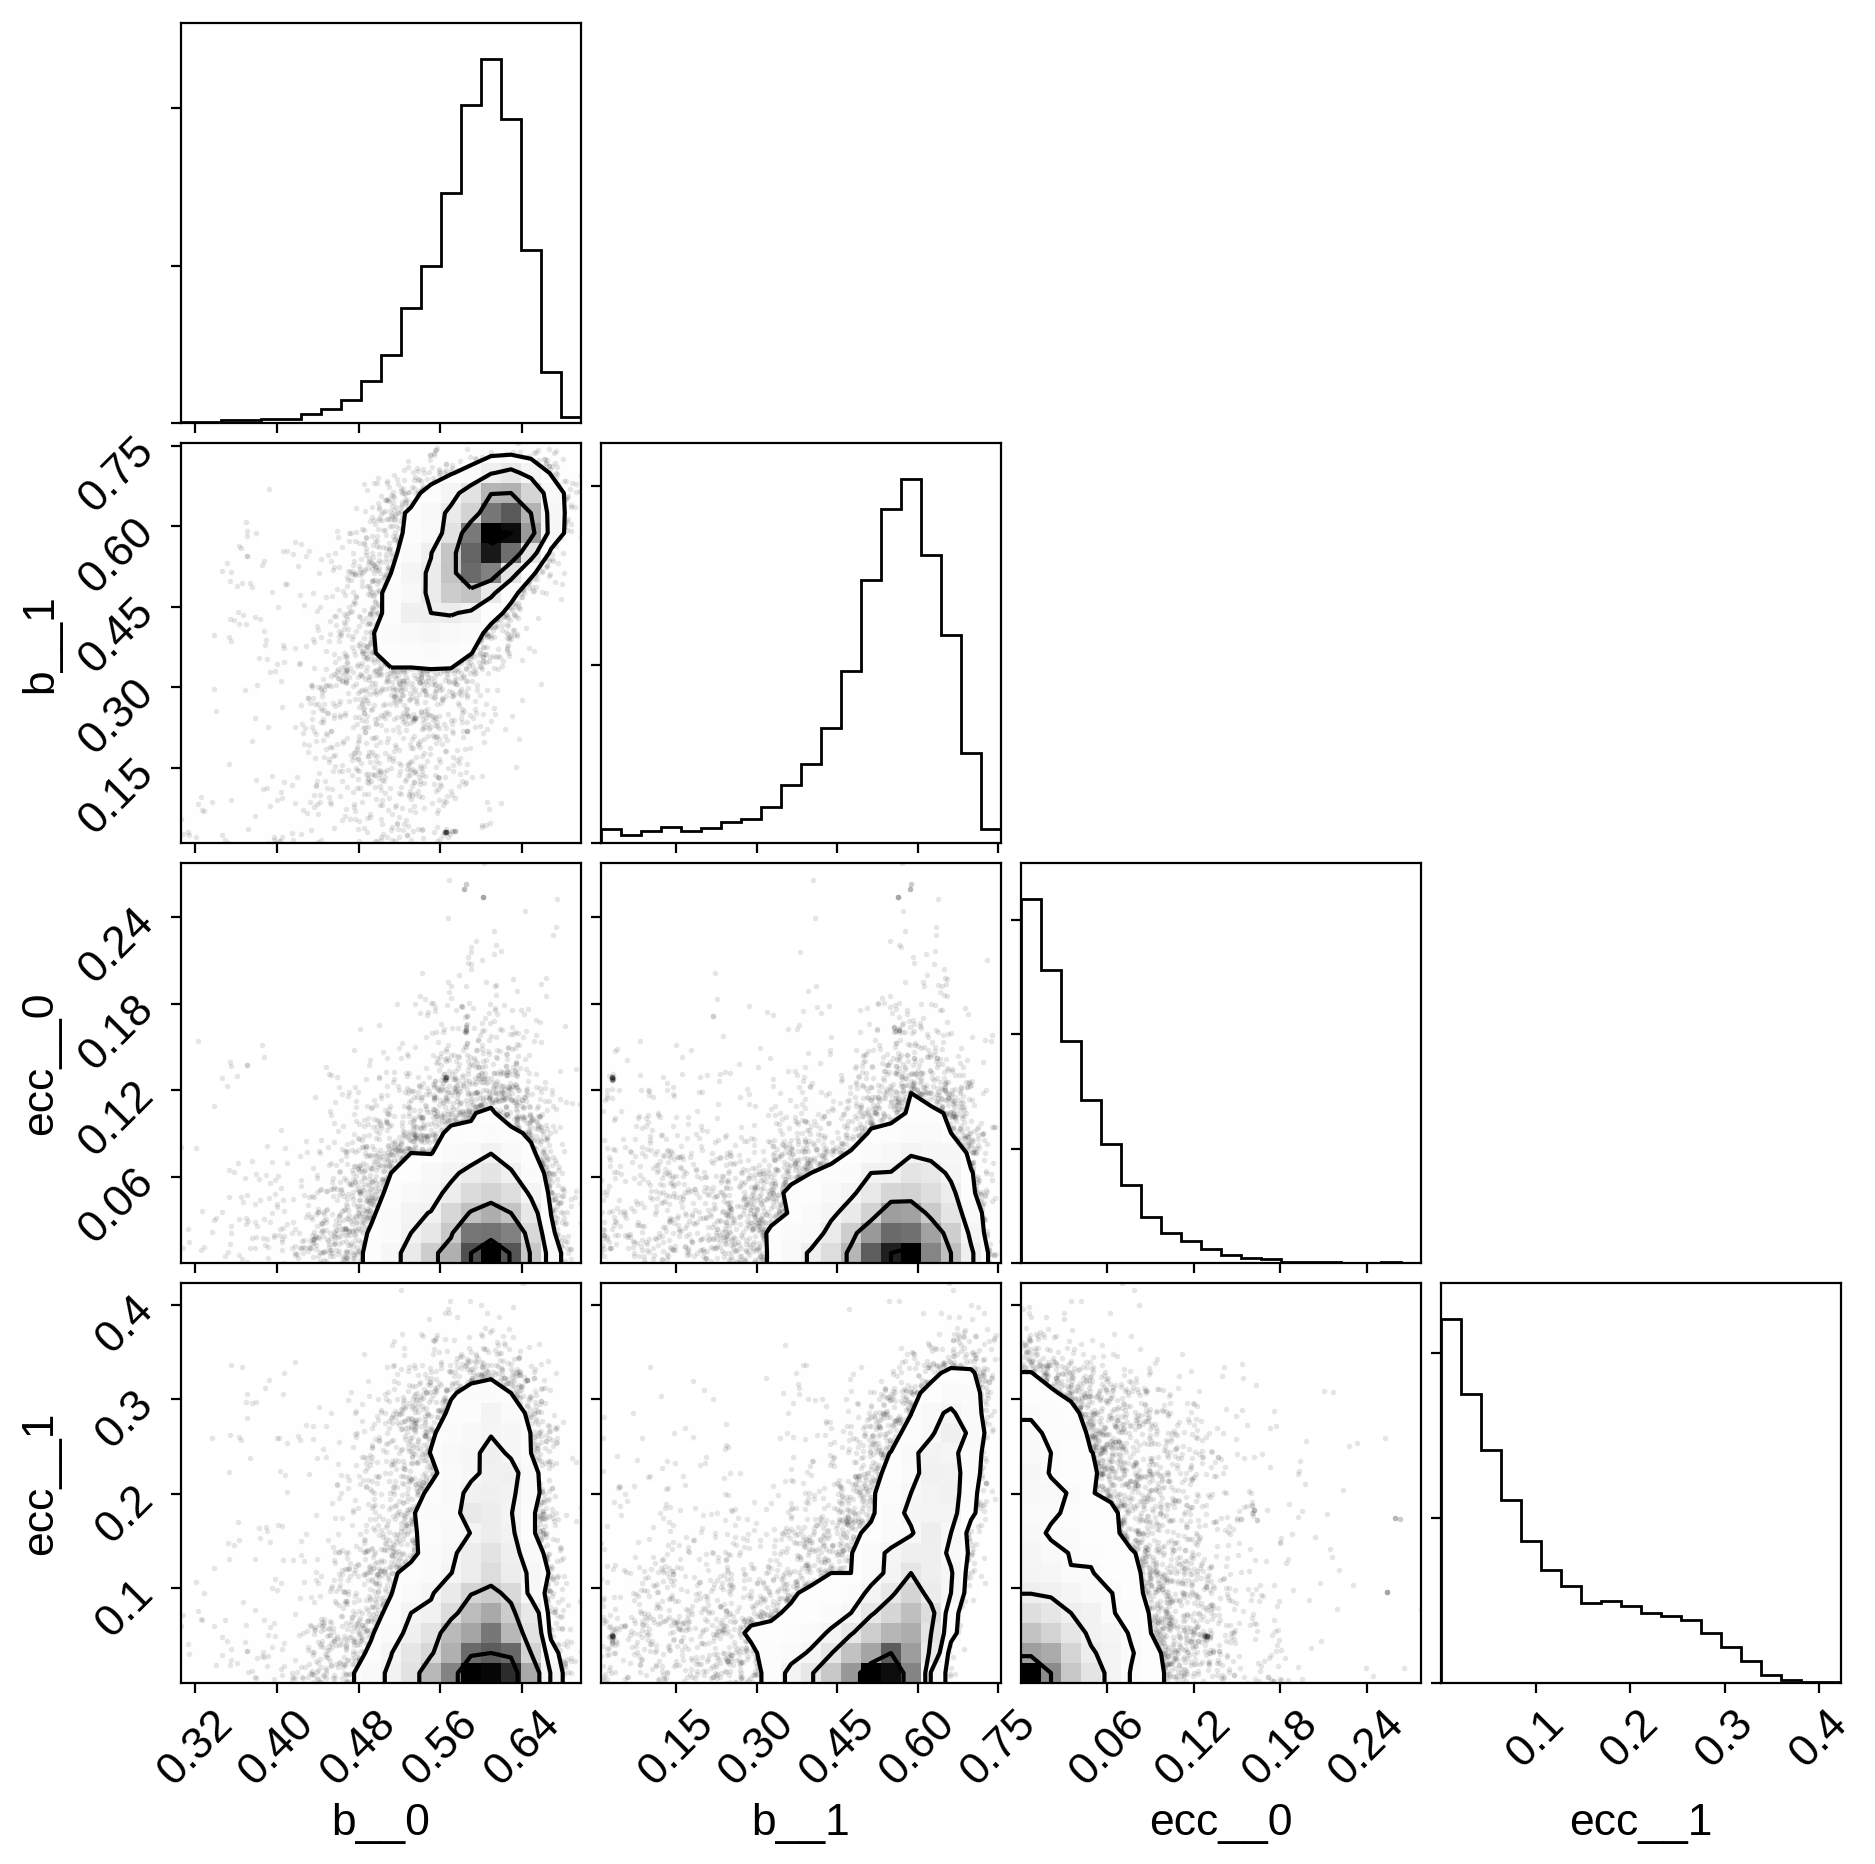

In [16]:
import corner
varnames = ["b", "ecc"]
samples = pm.trace_to_dataframe(trace, varnames=varnames)
fig = corner.corner(samples);

## Phase plots

Finally, as in the :ref:`rv` and :ref:`transit` tutorials, we can make folded plots of the transits and the radial velocities and compare to the posterior model predictions. (Note: planets b and c in this tutorial are swapped compared to the labels from [Petigura et al. (2016)](https://arxiv.org/abs/1511.04497))

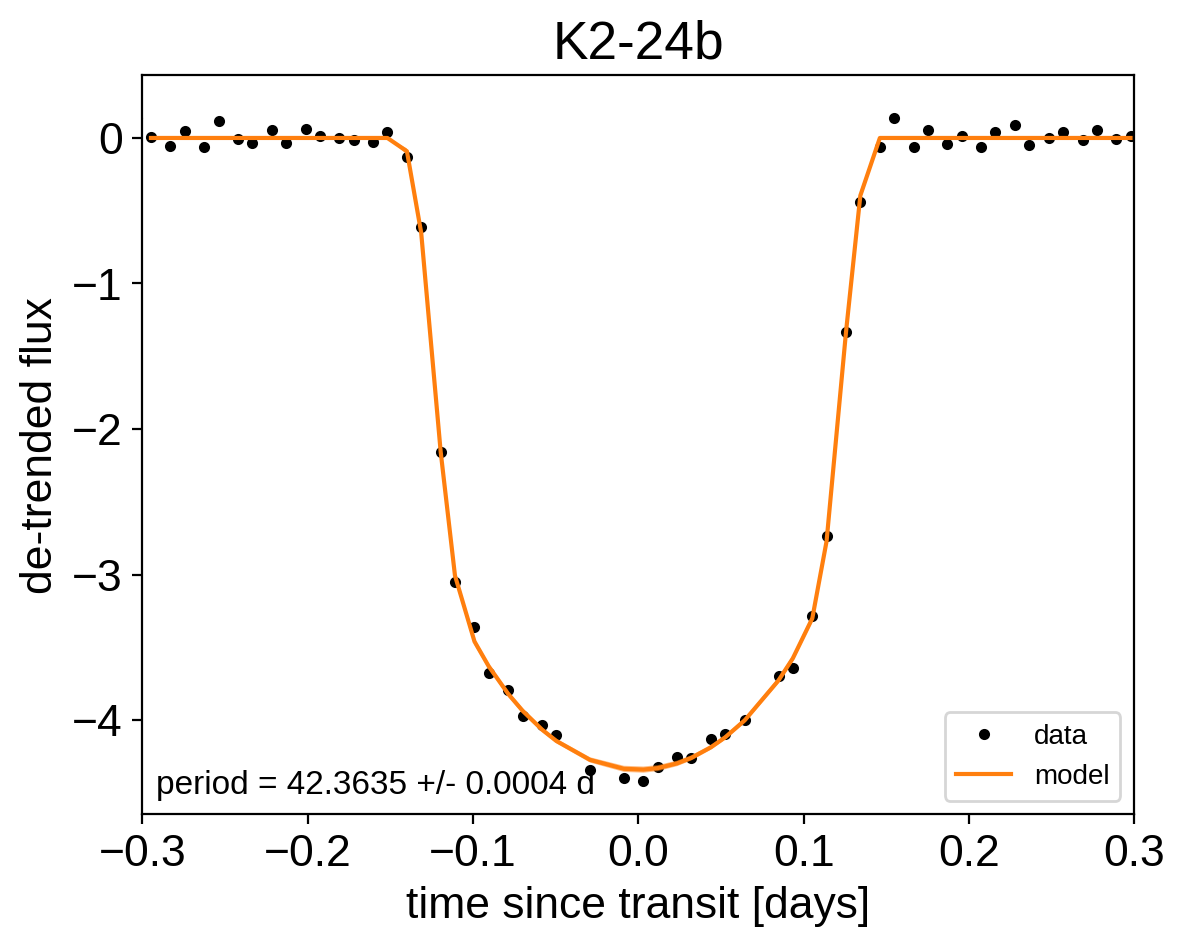

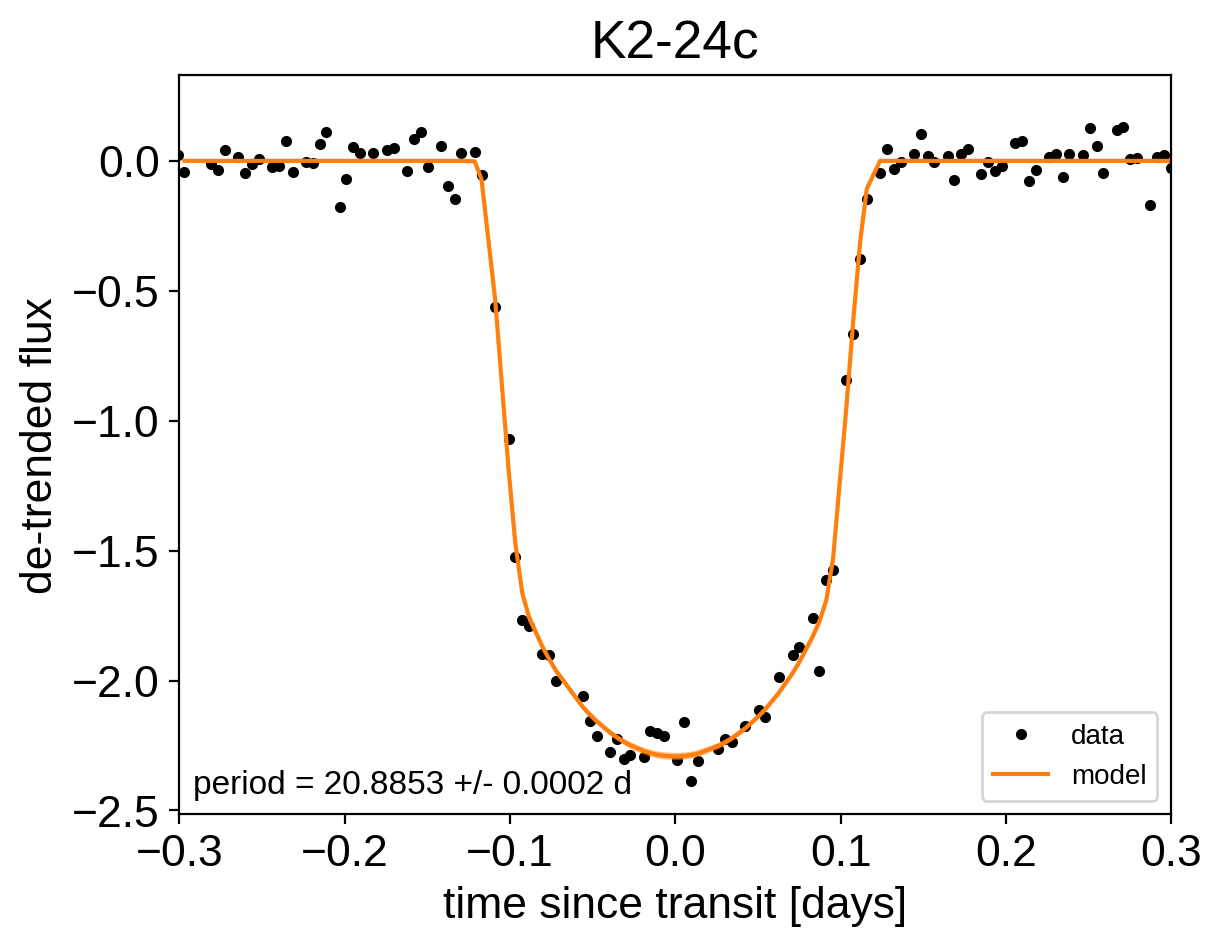

In [17]:
for n, letter in enumerate("bc"):
    plt.figure()
    
    # Compute the GP prediction
    gp_mod = np.median(trace["gp_pred"] + trace["mean"][:, None], axis=0)

    # Get the posterior median orbital parameters
    p = np.median(trace["period"][:, n])
    t0 = np.median(trace["t0"][:, n])
    
    # Compute the median of posterior estimate of the contribution from
    # the other planet. Then we can remove this from the data to plot
    # just the planet we care about.
    other = np.median(trace["light_curves"][:, :, (n + 1) % 2], axis=0)

    # Plot the folded data
    x_fold = (x[mask] - t0 + 0.5*p) % p - 0.5*p
    plt.plot(x_fold, y[mask] - gp_mod - other, ".k", label="data", zorder=-1000)
    
    # Plot the folded model
    inds = np.argsort(x_fold)
    inds = inds[np.abs(x_fold)[inds] < 0.3]
    pred = trace["light_curves"][:, inds, n]
    pred = np.percentile(pred, [16, 50, 84], axis=0)
    plt.plot(x_fold[inds], pred[1], color="C1", label="model")
    art = plt.fill_between(x_fold[inds], pred[0], pred[2], color="C1", alpha=0.5,
                           zorder=1000)
    art.set_edgecolor("none")
    
    # Annotate the plot with the planet's period
    txt = "period = {0:.4f} +/- {1:.4f} d".format(
        np.mean(trace["period"][:, n]), np.std(trace["period"][:, n]))
    plt.annotate(txt, (0, 0), xycoords="axes fraction",
                 xytext=(5, 5), textcoords="offset points", 
                 ha="left", va="bottom", fontsize=12)

    plt.legend(fontsize=10, loc=4)
    plt.xlim(-0.5*p, 0.5*p)
    plt.xlabel("time since transit [days]")
    plt.ylabel("de-trended flux")
    plt.title("K2-24{0}".format(letter));
    plt.xlim(-0.3, 0.3)

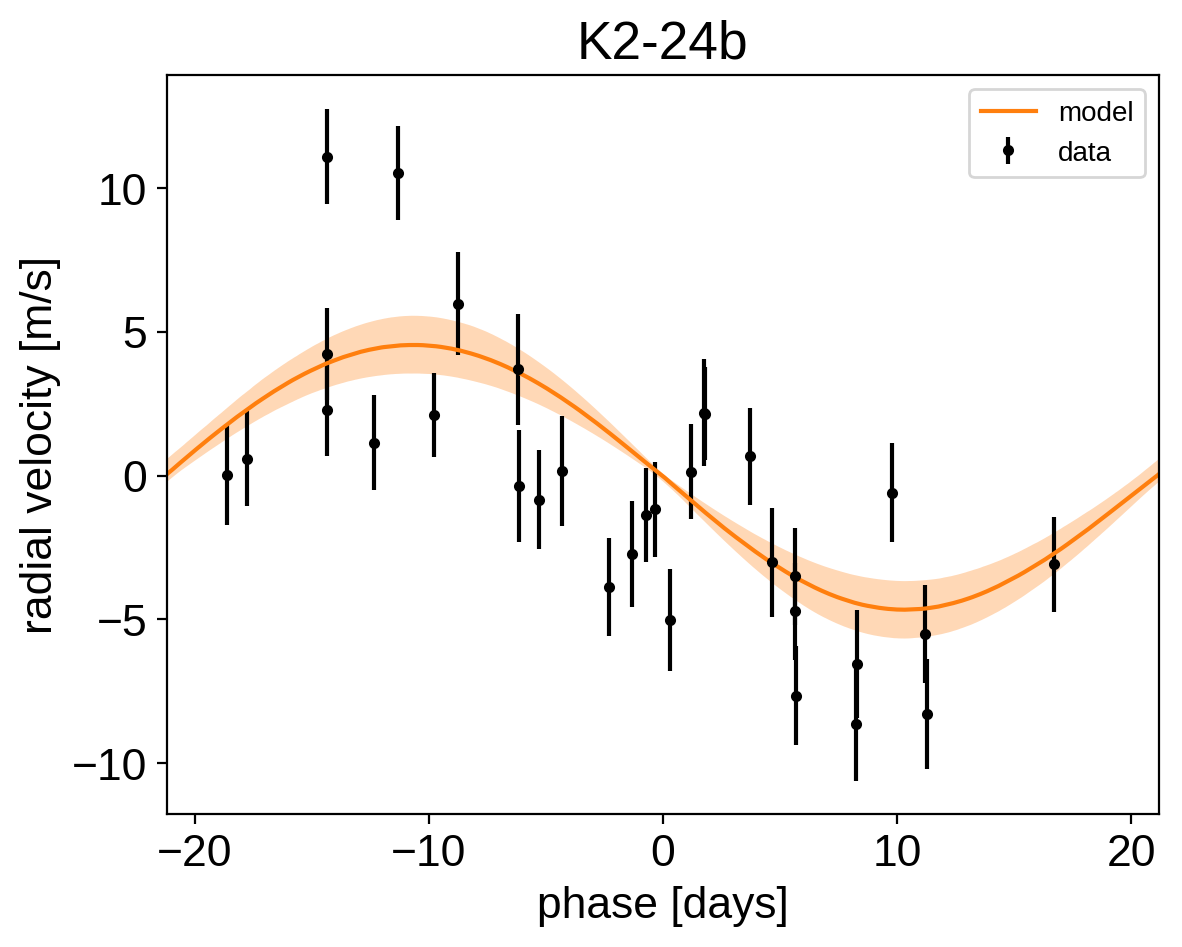

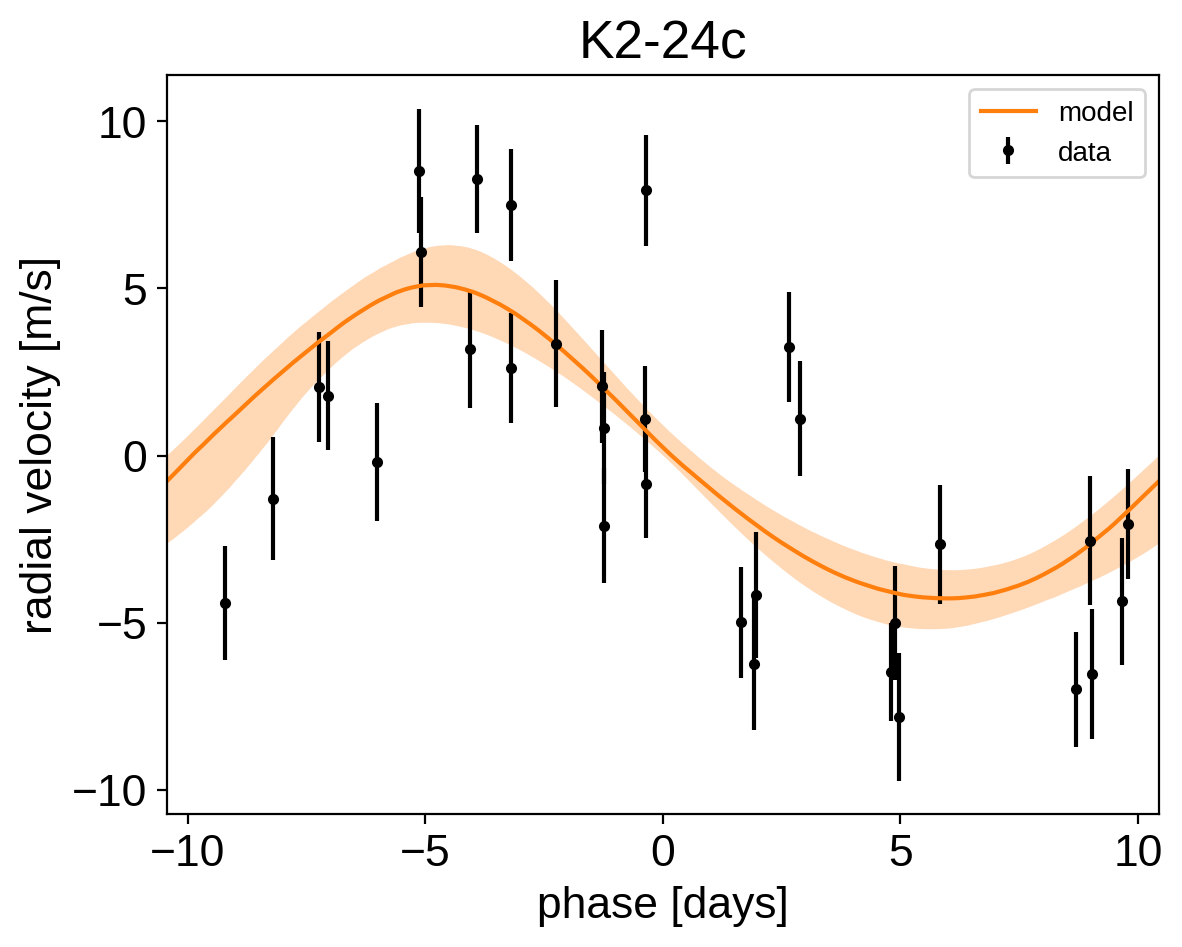

In [18]:
for n, letter in enumerate("bc"):    
    plt.figure()

    # Get the posterior median orbital parameters
    p = np.median(trace["period"][:, n])
    t0 = np.median(trace["t0"][:, n])
    
    # Compute the median of posterior estimate of the background RV
    # and the contribution from the other planet. Then we can remove
    # this from the data to plot just the planet we care about.
    other = np.median(trace["vrad"][:, :, (n + 1) % 2], axis=0)
    other += np.median(trace["bkg"], axis=0)

    # Plot the folded data
    x_fold = (x_rv - t0 + 0.5*p) % p - 0.5*p
    plt.errorbar(x_fold, y_rv - other, yerr=yerr_rv, fmt=".k", label="data")
    
    # Compute the posterior prediction for the folded RV model for this
    # planet
    t_fold = (t_rv - t0 + 0.5*p) % p - 0.5*p
    inds = np.argsort(t_fold)
    pred = np.percentile(trace["vrad_pred"][:, inds, n], [16, 50, 84], axis=0)
    plt.plot(t_fold[inds], pred[1], color="C1", label="model")
    art = plt.fill_between(t_fold[inds], pred[0], pred[2], color="C1", alpha=0.3)
    art.set_edgecolor("none")

    plt.legend(fontsize=10)
    plt.xlim(-0.5*p, 0.5*p)
    plt.xlabel("phase [days]")
    plt.ylabel("radial velocity [m/s]")
    plt.title("K2-24{0}".format(letter));

We can also compute the posterior constraints on the planet densities.

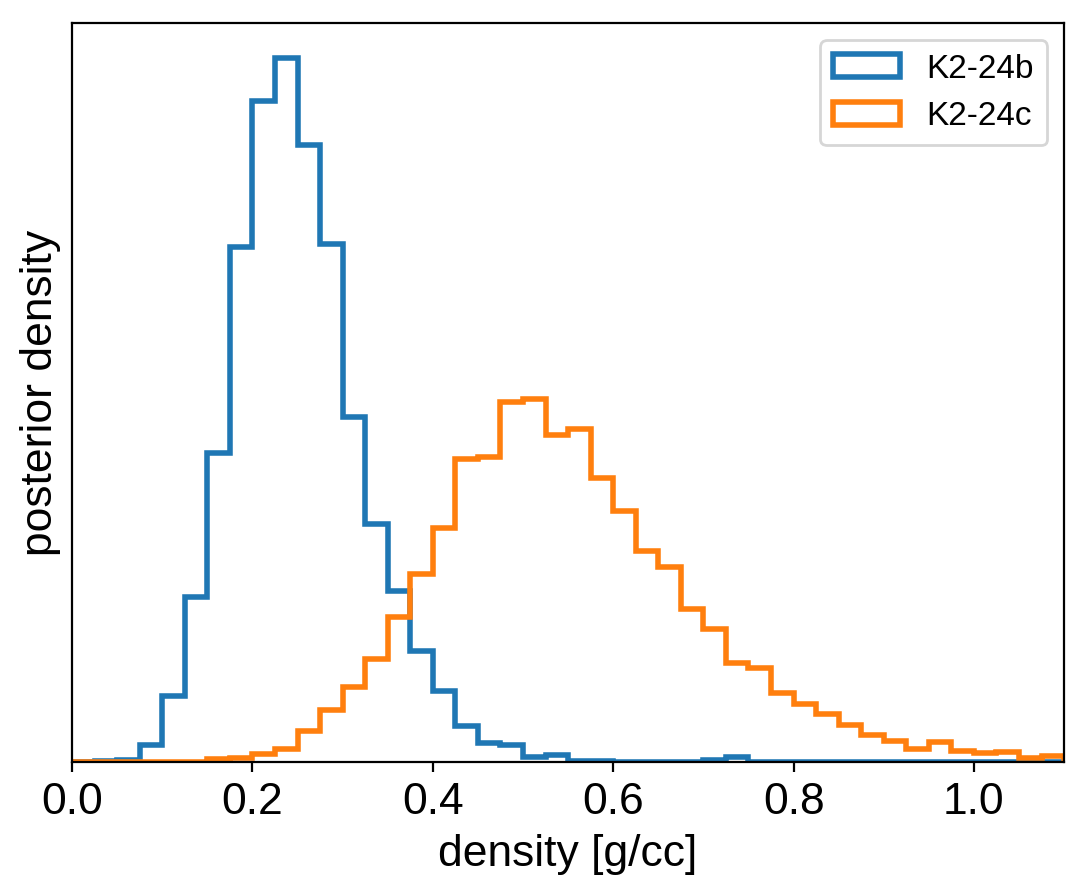

In [19]:
volume = 4/3*np.pi*trace["r_pl"]**3
density = u.Quantity(trace["m_pl"] / volume, unit=u.M_earth / u.R_sun**3)
density = density.to(u.g / u.cm**3).value

bins = np.linspace(0, 1.1, 45)
for n, letter in enumerate("bc"):    
    plt.hist(density[:, n], bins, histtype="step", lw=2,
             label="K2-24{0}".format(letter), density=True)
plt.yticks([])
plt.legend(fontsize=12)
plt.xlim(bins[0], bins[-1])
plt.xlabel("density [g/cc]")
plt.ylabel("posterior density");

## Citations

As described in the :ref:`citation` tutorial, we can use :func:`exoplanet.citations.get_citations_for_model` to construct an acknowledgement and BibTeX listing that includes the relevant citations for this model.

In [20]:
with model:
    txt, bib = xo.citations.get_citations_for_model()
print(txt)

This research made use of \textsf{exoplanet} \citep{exoplanet} and its
dependencies \citep{exoplanet:agol19, exoplanet:astropy13, exoplanet:astropy18,
exoplanet:exoplanet, exoplanet:foremanmackey17, exoplanet:foremanmackey18,
exoplanet:kipping13, exoplanet:luger18, exoplanet:pymc3, exoplanet:theano,
exoplanet:vaneylen19}.


In [21]:
print("\n".join(bib.splitlines()[:10]) + "\n...")


@misc{exoplanet:exoplanet,
  author = {Daniel Foreman-Mackey and Ian Czekala and Eric Agol and
            Rodrigo Luger and Geert Barentsen and Tom Barclay},
   title = {dfm/exoplanet: exoplanet v0.2.0},
   month = aug,
    year = 2019,
     doi = {10.5281/zenodo.3359880},
     url = {https://doi.org/10.5281/zenodo.3359880}
}
...
